In [12]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests

In [13]:
cnx = mysql.connector.connect(user='david', password='daviddung1993',
                              host='127.0.0.1',
                              database='computervision')
cursor = cnx.cursor()

In [3]:
headers = {"x-api-key": "M7HSjQNeTfai6l7JUiDZB8XYc85BHnHt3R0NXSEd"}

# Random stuff

In [384]:
cursor.execute("create temporary table aff_info as (select p.PaperID, count(affiliatedTo)/count(p2.`primary author`) as info from Papers p join referencedBy b on p.PaperID = b.ReferencedByID join Papers p2 on b.ReferenceID = p2.PaperID left join affiliatedTo a on p2.`primary author` = a.AuthorID group by p.PaperID)")

In [385]:
cursor.execute("select distinct p.`primary author` from Papers p, aff_info af, Authors a where p.PaperID in (%s) and p.PaperID = af.PaperID and af.info >= 0.8 and p.`primary author`=a.AuthorID and a.PaperCount>70 and p.ReferenceCount > 5" % params, test_paper_ids)
test_paper_idss = cursor.fetchall()
len(test_paper_idss)

ProgrammingError: Not enough parameters for the SQL statement

In [9]:
cnx.close()

In [4]:
test_paper_ids = pd.read_csv("test_set.csv")
test_paper_ids = test_paper_ids["0"].to_list()
params = ','.join(['%s'] * len(test_paper_ids))

In [7]:
test_paper_ids = [x[0] for x in test_paper_idss]

In [8]:
test_paper_ids

['0307caf20f0ea22d6ae979b65c7ab85f3abf2af1',
 '050dedbeeb1af878389cf57e44e47c166f737211',
 '090bdc4215242b05e67310dde780ea32f824cc13',
 '0a67ebaec615ef25f193f718e5758b6bba7a640f',
 '0ab26253c70e32ab9f6829795e5ba7f0b8e61187',
 '0c4054d6c4a9cb978e86d19bad45036570a25c21',
 '0ee84b24111ba16f08bd3db54db465da7937d303',
 '12c53b63aad94266d338f8cb7b57f90808a8c234',
 '12dae93be3c4cb772d03fc35f38d94af1621065d',
 '1676b5be40772ad189d0f68fac9e769790034d9e',
 '1cc529c36edb9d41d78daed360a2eb81c848edae',
 '1eb1377380e0d1414497ea9eb7fde7ad0d22f379',
 '1f087c8c79a26634386e510ed76b8a555ca0b64c',
 '25c110fa479e1e1b21de703ad310ca75f4132102',
 '2fabdf56e94693503c6fe9c7f3f3ba99a2d06d2f',
 '3015818cf63e891d2902ec73ff0eb30751e0ab6d',
 '302a8905b62627acbad2319607cc87734c1b33c8',
 '31bf1dd2a2e14af5c5d6acbee32c139e44bc6394',
 '3eb748f6279de5cfc582b3179bd1012bbd95614e',
 '3f190dd3b1254d10b9b7377642c11507bd99c121',
 '3f627eb4fe07353d38a8de4c66b7f8bbc2940504',
 '403fe61c2bb5b102e8ba934f10bdc5e777b10794',
 '41ec4928

In [62]:
def fetch_paper_neighbours(paperID):
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2, aff_info af where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID and p2.PaperID = af.PaperID and af.info >= 0.9 and p.`primary author` = p2.`primary author`", [paperID])
    paper_identical = len(cursor.fetchall())
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2, aff_info af where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID and p2.PaperID = af.PaperID and af.info >= 0.9", [paperID])
    paper_neighbours = len(cursor.fetchall())
    return paper_neighbours, paper_identical

In [63]:
len(fetch_paper_neighbours("79479f6818d35c97f1b50c3d5ce648afb29f12ce"))

2

In [151]:
test_papers = []
papers_distribution = []
paper_identical = []
for idx, test_paper_id in enumerate(test_paper_ids):
    if idx % 100 == 0:
        print(idx)
    a,b = fetch_paper_neighbours(test_paper_id)
    if b >= 3:
        test_papers.append(test_paper_id)
        continue
    papers_distribution.append(a)
    paper_identical.append(b)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [152]:
test = list(zip(papers_distribution, paper_identical))
#list(filter(lambda x: x[1]>=2, test))

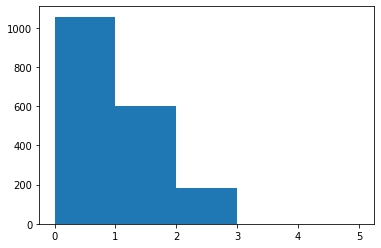

In [153]:
plt.hist(paper_identical, range=(0,5), bins=5)
plt.show()

In [66]:
cursor.fetchall()

[('0f885fd46064d271d4404cf9bb3d758e1a6f8d55',),
 ('1e56e0f525ab59d8a2fef5ef4a0b737323488052',),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d',),
 ('36ad8eaa6d01ceec2efda3a9563320822920088f',),
 ('3d1e82b69663758a1db87fbebed6525d23090146',),
 ('540b5b4919d345e4da3cc4f3e8a7862329bf41a2',),
 ('71b7178df5d2b112d07e45038cb5637208659ff7',),
 ('7d39d69b23424446f0400ef603b2e3e22d0309d6',),
 ('9831dc24bba0aaaf32218989a5259d9110437950',)]

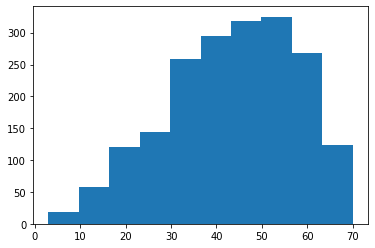

In [56]:
plt.hist(papers_distribution)
plt.show()

# Vector Space classifier

In [15]:
def map_class_to_vector(class_names, classes):
    binary_vector = [1 if c in class_names else 0 for c in classes]
    return binary_vector

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude_v1 = np.linalg.norm(vector1)
    magnitude_v2 = np.linalg.norm(vector2)
    return dot_product / (magnitude_v1 * magnitude_v2)

def add_authors(paper_id_batch):
    authors_dict = {}
    response = requests.post("https://api.semanticscholar.org/graph/v1/paper/batch?fields=authors", json={"ids": paper_id_batch}).json()
    for paper in response:
        authors_dict[paper["paperId"]] = [x["authorId"] for x in paper["authors"] if x["authorId"]]
    return authors_dict


In [182]:
def references_from_database(all_papers):
    all_references = []
    cursor.execute("select distinct(p2.PaperID) from Papers p, referencedBy b, referencedBy b2, Papers p2 where p.PaperID = %s and p.PaperID = b.ReferencedByID and b.ReferenceID = b2.ReferenceID and p.PaperID != b2.ReferencedByID and b2.ReferenceID = p2.PaperID", [paperID])
    neighbour_papers =  cursor.fetchall()
    all_papers.extend([paper[0] for paper in neighbour_papers])
    in_params = ','.join(['%s'] * len(all_papers))
    cursor.execute("select b.ReferencedByID, group_concat(b.ReferenceID), group_concat(a.AuthoredByID) from referencedBy b, Papers p, authoredBy a where b.ReferencedByID in (%s) and b.ReferencedByID = p.PaperID and p.PaperID = a.PaperID group by b.ReferencedByID having count(*)>=5" % in_params, all_papers)
    all_mapped_references = cursor.fetchall()
    for idx, x in  enumerate(all_mapped_references):
        all_references.extend(x[1].split(","))
        all_mapped_references[idx] = (all_mapped_references[idx][0], all_mapped_references[idx][1], all_mapped_references[idx][2].split(","))
    all_references = list(set(all_references))
    return all_references, all_mapped_references

def fetch_from_scholar(all_papers):
    all_mapped_references = []
    all_references = []
    paper_id = all_papers[0]
    already_visited = [paper_id]
    paper_link = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=references,references.citationCount,authors"
    response = requests.get(paper_link, headers=headers).json()
    primary_author_id = [x["authorId"] for x in response["authors"]]
    primary_author_id_set = set([x["authorId"] for x in response["authors"]])
    reference_ids = [x["paperId"] for x in response["references"] if x["paperId"]]
    if not len(reference_ids):
        return ValueError
    reference_ids_string = ",".join(reference_ids)
    all_mapped_references.append((paper_id, reference_ids_string, primary_author_id))

    for idx, reference_id in enumerate(reference_ids):
        print(f"{idx}/{len(reference_ids)}")
        link = f"https://api.semanticscholar.org/graph/v1/paper/{reference_id}?fields=citations,citations.authors"
        resp = requests.get(link, headers=headers).json()
        if "citations" not in resp:
            continue
        citations = resp["citations"]
        cit = []
        same_authors = [1 if len(set([a["authorId"] for a in x["authors"]]).intersection(primary_author_id_set)) > 0 else 0 for x in resp["citations"]]
        for idx, element in enumerate(same_authors):
            if element:
                cit.append(citations[idx])
        cit.extend(citations)
        for citation in cit[:30]:
            if citation["paperId"] and citation["paperId"] not in already_visited:
                citation_link = f"https://api.semanticscholar.org/graph/v1/paper/{citation['paperId']}?fields=references,authors"
                citation_resp = requests.get(citation_link, headers=headers).json()
                already_visited.append(citation["paperId"])
                if not "authors" in citation_resp:
                    continue
                if not citation_resp["authors"]:
                    continue
                citation_primary_author_id = [x["authorId"] for x in citation_resp["authors"]]
                if not citation_primary_author_id:
                    continue
                citation_reference_ids = [x["paperId"] for x in citation_resp["references"] if x["paperId"]]
                if len(citation_reference_ids) < 6:
                    continue
                citation_reference_string = ",".join(citation_reference_ids)
                all_mapped_references.append((citation["paperId"], citation_reference_string, citation_primary_author_id))

    for x in  all_mapped_references:
        all_references.extend(x[1].split(","))
    all_references = list(set(all_references))
    return all_references, all_mapped_references

def classifier(paperID, classify_from_database=True):
    all_papers = [paperID]
    all_mapped_references = []
    # Fetch all papers that have at least one reference in common:
    if classify_from_database:
        all_references, all_mapped_references = references_from_database(all_papers)
    else:
        all_references, all_mapped_references = fetch_from_scholar(all_papers)

    test_paper_vector = None
    paper_ranking = {}
    author_correct = set(all_mapped_references[0][2])
    index_match = []
    for idx, mapped_references in enumerate(all_mapped_references):

        class_vector = map_class_to_vector(mapped_references[1].split(","), all_references)
        if idx == 0:
            test_paper_vector = class_vector
            continue
        similarity_index = cosine_similarity(test_paper_vector, class_vector)

        if len(author_correct.intersection(set(mapped_references[2]))) > 0:
            index_match.append(idx)
        paper_ranking[mapped_references[0]] = [similarity_index, mapped_references[2]]

    sorted_paper_ranking = sorted(paper_ranking.items(), key=lambda x:x[1][0], reverse=True)
    return sorted_paper_ranking, index_match, author_correct

def rank_authors(result, authors):
    author_ranking = {}
    # Weight
    weight_factor = len(result)
    fn = lambda x: weight_factor * ((1/1.09)**x)
    for idx, paper in enumerate(result):
        for author in paper[1][1]:
            if author not in author_ranking:
                author_ranking[author] = []
            author_ranking[author].append(idx)
    for author, indices in author_ranking.items():
        author_ranking[author] = sum([fn(x) for x in indices])
    author_match_indices = []
    author_ranking = sorted(author_ranking.items(), key=lambda x: x[1], reverse=True)
    author_ranking = list(filter(lambda x: x[0], author_ranking))
    for author in authors:
        author_match_indices.extend([x+1 for x, y in enumerate(author_ranking) if y[0] == author])
    return author_ranking, author_match_indices

In [114]:
hit = 0
current_id = 0
total_matches = []
total_authors_matches = []
total_run = 0
author_hit = 0
final = []
author_rankings = []
solution_test_papers = []

In [115]:
test_papers = test_paper_ids
len(test_papers)

107

In [388]:
for idx,paperID in enumerate(test_papers): #[current_id:47]
    if idx < current_id:
        continue

    print(f"{idx}/{len(test_papers)}")
    try:
        result, matches, authors = classifier(paperID, classify_from_database=False)
        author_ranking, author_matches = rank_authors(result, authors)
    except (ValueError, TypeError):
        print("error")
        current_id = idx+1
        continue
    author_rankings.append(author_ranking)
    total_matches.append(matches)
    total_authors_matches.append(author_matches)
    final.append(result)
    if 1 in matches:
        #print("hit")
        hit += 1
    if 1 in author_matches:
        author_hit += 1
    total_run += 1
    current_id = idx+1
    solution_test_papers.append(paperID)
print(hit/total_run)
print(author_hit/total_run)

98/107
0/57
1/57
2/57
3/57
4/57
5/57
6/57
7/57
8/57
9/57
10/57
11/57
12/57
13/57
14/57
15/57
16/57
17/57
18/57
19/57
20/57
21/57
22/57
23/57
24/57
25/57
26/57
27/57
28/57
29/57
30/57
31/57
32/57
33/57
34/57
35/57
36/57
37/57
38/57
39/57
40/57
41/57
42/57
43/57
44/57
45/57
46/57
47/57
48/57
49/57
50/57
51/57
52/57
53/57
54/57
55/57
56/57
99/107
0/41
1/41
2/41
3/41
4/41
5/41
6/41
7/41
8/41
9/41
10/41
11/41
12/41
13/41
14/41
15/41
16/41
17/41
18/41
19/41
20/41
21/41
22/41
23/41
24/41
25/41
26/41
27/41
28/41
29/41
30/41
31/41
32/41
33/41
34/41
35/41
36/41
37/41
38/41
39/41
40/41
100/107
0/46
1/46
2/46
3/46
4/46
5/46
6/46
7/46
8/46
9/46
10/46
11/46
12/46
13/46
14/46
15/46
16/46
17/46
18/46
19/46
20/46
21/46
22/46
23/46
24/46
25/46
26/46
27/46
28/46
29/46
30/46
31/46
32/46
33/46
34/46
35/46
36/46
37/46
38/46
39/46
40/46
41/46
42/46
43/46
44/46
45/46
101/107
0/11
1/11
2/11
3/11
4/11
5/11
6/11
7/11
8/11
9/11
10/11
102/107
0/41
1/41
2/41
3/41
4/41
5/41
6/41
7/41
8/41
9/41
10/41
11/41
12/41
13/4

In [387]:
print(hit/total_run)
print(author_hit/total_run)

0.5157894736842106
0.45263157894736844


In [201]:
first_ranked = []
percentages = []
for idx, x in enumerate(total_authors_matches):
    if x:
        x.sort()
        if x[0] == 1 or x[0] > 10:
            continue
        first_place = author_rankings[idx][0][1]
        next_place_match = author_rankings[idx][x[0]-1][1]
        percentage = (first_place-next_place_match)/next_place_match
        percentages.append(percentage)
        first_ranked.append(x[0])
sum(first_ranked)/len(first_ranked)
sum(percentages)/len(percentages)

0.5035330266429131

In [197]:
len(first_ranked)

44

In [7]:
author_rankings = [[('145690248', 4217.334510516629), ('3202968', 4118.096586510362), ('3431141', 3729.657922067626), ('144025741', 3107.2166724281083), ('47636228', 1206.4108658147054), ('2150209964', 892.4481049145477), ('2070183551', 866.6258788174842), ('3430743', 614.7885397720909), ('143652253', 594.2260752461941), ('47748186', 594.2260752461914), ('134880677', 594.2260752461914), ('143663410', 594.2260752461914), ('144111674', 561.2866573086587), ('2000125058', 561.2866573086587), ('46389488', 561.2866573086587), ('7924036', 503.28555321268436), ('8053308', 502.10650954366093), ('2152452738', 502.10650320331325), ('2119576', 458.86951599483126), ('2145123079', 458.85155872663177), ('2109394216', 450.07353110628594), ('145000409', 420.96473277672635), ('2134071343', 417.5387969135863), ('1752427', 354.31759344897426), ('2108129578', 325.06201233850845), ('2145473584', 325.06201233850845), ('1800117', 325.06201233850845), ('144953181', 325.06201233850845), ('2149191538', 298.22202966835636), ('1409856741', 298.22202966835636), ('2144385006', 298.22202966835636), ('1679209', 298.22202966835636), ('145030935', 273.71533861120224), ('49408564', 273.5981923562902), ('46314360', 273.5981923562902), ('2138050195', 230.28212470018534), ('2180656864', 230.28212470018534), ('67214258', 230.28212470018534), ('3597137', 230.28212470018534), ('2115382645', 216.31168062675587), ('2108373912', 216.30119036157612), ('47122432', 216.30119036157612), ('2110950699', 216.30119036157612), ('2792418', 211.26800431209662), ('2125653756', 211.26800431209662), ('2148896494', 193.8238571670611), ('1400258083', 193.8238571670611), ('1753529', 193.8238571670611), ('102665943', 177.82005244684504), ('2075413603', 177.82005244684504), ('2140026613', 177.82005244684504), ('46348792', 163.13766279527067), ('2192054415', 163.13766279527067), ('145815308', 163.13766279527067), ('49353948', 163.13766279527067), ('145779142', 163.13766279527067), ('145786594', 163.13766279527067), ('1917800589', 149.6677481617699), ('50190972', 149.6677481617699), ('1699819', 139.571173562645), ('2121308857', 137.30970692304575), ('143602033', 126.16867418337809), ('2115638126', 125.97220818628048), ('47672151', 125.97220818628048), ('40400195', 125.97220818628048), ('50763020', 121.5393480570157), ('48902313', 113.60188208079299), ('1785510', 106.02828733800226), ('2132165840', 106.02828733800226), ('2155914046', 106.02828733800226), ('2088877145', 106.02828733800226), ('2167297289', 106.02828733800226), ('2110754566', 89.24188817271461), ('40096492', 89.24188817271461), ('2066429', 81.87329190157304), ('30889568', 81.87329190157304), ('2150637593', 76.6240668871827), ('66916694', 75.11311183630554), ('21072153', 75.11311183630554), ('143626433', 75.11311183630554), ('2428115', 75.11311183630554), ('153216896', 69.6267410612572), ('48141156', 68.91112554681344), ('1394465427', 63.221203464612), ('2111610160', 58.00110409597431), ('1856671082', 53.21202210639844), ('2643877', 50.65693599929257), ('72322311', 50.647311831029555), ('6468417', 50.647311831029555), ('2144059167', 50.647311831029555), ('2193085838', 48.8183689049527), ('2192865005', 48.8183689049527), ('119582419', 44.78749440821348), ('40626640', 44.78749440821348), ('144806394', 44.78749440821348), ('2110348767', 34.97563410152884), ('2062835', 34.97563410152884), ('47267313', 26.70531956840328), ('2066227834', 26.70531956840328), ('40647710', 26.70531956840328), ('145199659', 26.70531956840328), ('2399573', 26.70531956840328), ('2199669463', 24.50029318202136), ('2199668946', 24.50029318202136), ('47795533', 24.50029318202136), ('1583657241', 22.477333194515005), ('8277017', 22.477333194515005), ('2145534529', 22.477333194515005), ('2110983471', 17.356625368632674), ('2174213183', 17.356625368632674), ('152393567', 14.608724323400951), ('2116486153', 14.608724323400951), ('4639656', 14.608724323400951), ('29451560', 14.608724323400951), ('2118959398', 14.608724323400951), ('67180560', 12.29587099015314), ('2061016773', 12.29587099015314), ('7828998', 12.29587099015314), ('2111862800', 11.28061558729646), ('3281912', 11.28061558729646), ('2220570', 11.28061558729646), ('2108011590', 10.349188612198587), ('2151480743', 10.349188612198587), ('2118224291', 10.349188612198587), ('2087917205', 10.349188612198587), ('1972263989', 9.494668451558336), ('34694214', 9.494668451558336), ('144702900', 8.71070500160188), ('29957038', 8.71070500160188), ('2157624864', 8.710705001429664), ('2107995927', 8.710705001429664), ('2124948371', 8.710705001429664), ('2148904543', 8.710705001429664), ('2108571702', 8.710705001429664), ('144988571', 8.710705001429664), ('2145253136', 8.710705001429664), ('1823518756', 8.710705001429664), ('2136211561', 8.059620813834051), ('3247966', 7.378186576024262), ('5462268', 7.331627360067022), ('2193451398', 7.331626126950312), ('2143731503', 7.331626126950312), ('153194420', 7.331626126950312), ('143971529', 7.331626126950312), ('2410938', 7.331626126950312), ('4443395', 7.331626126950312), ('2153638435', 7.331626126950312), ('2846025', 7.046537510158198), ('2187234912', 6.726262501789275), ('2057132169', 6.726262501789275), ('2920863', 6.726262501789275), ('2187272840', 6.726262501789275), ('1664673953', 6.1708830291644725), ('66390551', 6.1708830291644725), ('92203474', 6.1708830291644725), ('49678252', 5.661971114280215), ('1707342', 5.661971114280215), ('1724027', 5.661971114280215), ('145459057', 5.1949327182716125), ('50644077', 4.765053932509984), ('2022404080', 4.765053932509984), ('144843657', 4.765053932509984), ('1895813', 4.371609232756298), ('2158236323', 4.37160911239448), ('144007938', 4.37160911239448), ('2202017481', 4.010650561829798), ('50763101', 4.010650561829798), ('2202018059', 4.010650561829798), ('3468983', 3.91291717943588), ('3492481', 3.91291717943588), ('1843795', 3.91291717943588), ('1741922', 3.91291717943588), ('10098888', 3.6794959282842177), ('2066004861', 3.375684337875429), ('145464131', 3.375684337875429), ('2370774', 3.375684337875429), ('2166247811', 3.096958108142595), ('145899359', 3.096958108142595), ('2155468228', 2.8508700672682172), ('51175635', 2.606647679608278), ('50232214', 2.606647679608278), ('50621243', 2.606647679608278), ('3651407', 2.606647679608278), ('2109174377', 2.3914198895488785), ('2162632820', 2.3914198895488785), ('2108838133', 2.3914198895488785), ('2198770103', 2.3914198895488785), ('2108508109', 2.194005308597271), ('46693127', 2.0128102765330174), ('2158088016', 2.0128102765330174), ('145617383', 1.8466149325990988), ('1397181875', 1.8466149325990988), ('2185414397', 1.8466149325990988), ('70123284', 1.694142139999173), ('9225677', 1.694142139999173), ('2112322350', 1.5542588440359384), ('145552439', 1.5542588440359384), ('2144230222', 1.5542588440359384), ('2108035782', 1.5542588440359384), ('2087957454', 1.5542588440359384), ('40434674', 1.426183442441411), ('1784500', 1.3106125922828424), ('114850729', 1.3081885733826597), ('2113601486', 1.3081885733826597), ('2774427', 1.2033122882993283), ('2143429738', 1.2001731135270437), ('7590116', 1.101089920022459), ('2054288292', 1.101076149636108), ('73596205', 1.101076149636108), ('2105729435', 1.101076149636108), ('2409659', 1.101076149636108), ('1760581', 1.101076149636108), ('34672380', 1.010161605170741), ('143738453', 1.010161605170741), ('2027001162', 0.926753766211689), ('144089638', 0.926753766211689), ('3170717', 0.926753766211689), ('144144027', 0.926753766211689), ('46300450', 0.8796541485244658), ('2142541693', 0.8502328130382466), ('2158247504', 0.8502328130382466), ('2110676255', 0.8502328130382466), ('2158247729', 0.8502328130382466), ('1887625', 0.7844613050839474), ('7607499', 0.7800301037132498), ('39978626', 0.7800301037048135), ('34779291', 0.7156239483530401), ('1704919', 0.6565357324340254), ('144041168', 0.6565357324339814), ('2197431596', 0.6565357324339814), ('2055427921', 0.6565357324339814), ('2129483108', 0.6565357324339814), ('2193560705', 0.6565357324339814), ('2193649870', 0.6565357324339814), ('1927674', 0.5525929908542895), ('123685996', 0.5525929908542895), ('2061592207', 0.5525929908542895), ('144620586', 0.5525929908542895), ('36263371', 0.5525929908542895), ('2017636292', 0.5525929908542895), ('2116528857', 0.5525929908542895), ('2152916734', 0.5525929908542895), ('31799453', 0.5525929908542895), ('2144395949', 0.5069660466553114), ('2056283222', 0.5069660466553114), ('48033068', 0.5069660466553114), ('2153953256', 0.5069660466553114), ('51300695', 0.4651064648213866), ('2109036744', 0.4651064648213866), ('117908148', 0.4651064648213866), ('2073517', 0.4651064648213866), ('2146067439', 0.42670317873521707), ('33642939', 0.42670317873521707), ('40622539', 0.3591475286046772), ('66808667', 0.3591475286046772), ('2118888090', 0.3591475286046772), ('145017151', 0.3591475286046772), ('3233021', 0.32949314558817144), ('2181197223', 0.30228728945768635), ('2280472', 0.30228728945768635), ('2066418917', 0.30228728945768635), ('2181203153', 0.30228728945768635), ('2090467921', 0.30228728945768635), ('2684226', 0.25446184853509113), ('1911972', 0.2544617632677449), ('2144978965', 0.2544617632677449), ('2433269', 0.2544617632677449), ('2054511289', 0.23342125115166246), ('3144258', 0.23342125115166246), ('2155698456', 0.21414793683638755), ('143892958', 0.21414793683638755), ('2108000555', 0.21414793683638755), ('2119292652', 0.21414793683638755), ('2108195409', 0.21414793683638755), ('145977143', 0.19646891633330915), ('1993695002', 0.19646599709760326), ('145857599', 0.19646599709760326), ('144536249', 0.19646599709760326), ('1736513', 0.18024470859156688), ('39061055', 0.1802440340344986), ('2152657808', 0.18024403403449837), ('2162041184', 0.18024403403449837), ('2194625416', 0.18024403403449837), ('2116473094', 0.1653614991142187), ('1992912155', 0.1653614991142187), ('19263795', 0.1653614991142187), ('1770200', 0.1653614991142187), ('2237192', 0.1653614991142187), ('50506129', 0.1517077973524942), ('49795151', 0.1517077973524942), ('2109061406', 0.13918146546100385), ('3141604', 0.13918146546100385), ('143860661', 0.12768941785413196), ('1450708782', 0.12768941785413196), ('2152686890', 0.12768941785413196), ('2090399851', 0.12768941785413196), ('38026572', 0.12768941785413196), ('2116581959', 0.11714625491204768), ('39458374', 0.11714625491204768), ('2152597151', 0.11714625491204768), ('2056267903', 0.11714625491204768), ('2118421986', 0.10747362835967675), ('39368603', 0.10747362835967675), ('2151705015', 0.10747362835967675), ('2144199042', 0.098599659045575), ('2202881717', 0.098599659045575), ('2187499663', 0.098599659045575), ('2187367722', 0.098599659045575), ('153715987', 0.098599659045575), ('145945370', 0.0904584027941055), ('2153393758', 0.0904584027941055), ('2190040478', 0.0904584027941055), ('2128663650', 0.08298936036156467), ('2109090493', 0.08298936036156467), ('2004969144', 0.08298936036156467), ('2087287857', 0.08298936036156467), ('2110147653', 0.08298936036156467), ('51934339', 0.07613702785464647), ('2107434470', 0.07613702785464647), ('33407218', 0.07613702785464647), ('2142010093', 0.07613702785464647), ('2134885511', 0.07613702785464647), ('2119197128', 0.07613702785464647), ('2047390507', 0.06985048427031787), ('1700011', 0.06985048427031787), ('2856622', 0.06752258765328648), ('2420608', 0.06375858246573418), ('2112477373', 0.06375858246573418), ('2147394376', 0.06375858246573418), ('3429328', 0.06375858246573418), ('2047358650', 0.06375858246573418), ('2134838910', 0.05879175513030709), ('2158368117', 0.05879175513030709), ('8718120', 0.05879175513030709), ('2348236', 0.05879175513030709), ('12358136', 0.05879175513030709), ('143953573', 0.05393739002780466), ('2110464428', 0.05393739002780466), ('2117101322', 0.05393739002780466), ('1749609', 0.05393739002780466), ('1749590', 0.05393739002780466), ('2903226', 0.05393739002780466), ('50978260', 0.04948384406220612), ('47398812', 0.04948384406220612), ('2157221339', 0.04948384406220612), ('2111863589', 0.04948384406220612), ('1747500', 0.04948384406220612), ('2109292017', 0.04539802207541845), ('2108850820', 0.041649561537081145), ('2117884196', 0.041649561537081145), ('2151810158', 0.041649561537081145), ('2114925498', 0.041649561537081145), ('28955559', 0.041649561537081145), ('2111526678', 0.041649561537081145), ('2118430214', 0.03942714026204449), ('40372975', 0.03821060693652237), ('2144289455', 0.038210606914753344), ('2115711820', 0.03505560267408563), ('2156746599', 0.03505560267408563), ('145470045', 0.03505560267408563), ('145532184', 0.03505560267408563), ('2111824809', 0.03216110337072076), ('2108760177', 0.03216110337072076), ('3249639', 0.03216110337072076), ('2155659550', 0.03216110337072076), ('2157144652', 0.03216110337072076), ('14915205', 0.029505599422679597), ('1693885', 0.029505599422679597), ('2144385383', 0.029505599422679597), ('34739384', 0.027069357511611106), ('144876831', 0.027069357294377164), ('2110191063', 0.027069357268513387), ('1572139630', 0.027069357268513387), ('2056100172', 0.027069357268513387), ('1759841', 0.027069357268513387), ('2713947', 0.027069357268513387), ('46246806', 0.027069357268513387), ('143715293', 0.02090258226643635), ('50081620', 0.02090251049861693), ('2113973358', 0.02090251049861693), ('2064059144', 0.02090251049861693), ('2157962527', 0.02090251049861693), ('1717861', 0.019573422337454637), ('2118434440', 0.019176615136345807), ('143672748', 0.015164042592891818), ('2109418754', 0.014807865411775183), ('2170325018', 0.014807865411775183), ('66756715', 0.014807865411775183), ('2188821556', 0.014807865411775183), ('2188987736', 0.014807865411775183), ('2118748196', 0.013585197625481818), ('2160455235', 0.013585197625481818), ('1453653507', 0.013585197625481818), ('2109230200', 0.013585197625481818), ('49933077', 0.012493391869646424), ('145124475', 0.012463562286998228), ('87683234', 0.012463484060075062), ('145639633', 0.012463484060075062), ('79887581', 0.012463484060075062), ('2141348277', 0.012463484060075062), ('2115467507', 0.011434389045940421), ('144289450', 0.011434389045940421), ('1379499848', 0.010490265179761853), ('2110503552', 0.010490265179761853), ('67273856', 0.010490265179761853), ('48623026', 0.010490265179761853), ('2154731170', 0.010490265179761853), ('144346838', 0.010490265179761853), ('120157163', 0.010094724210931274), ('1828787912', 0.010094719861802784), ('2128124484', 0.010094719861802784), ('153668454', 0.009624168263013782), ('2144524205', 0.00962410824344746), ('1419971650', 0.009624096495194362), ('145404204', 0.00882944768828587), ('32671565', 0.008829446325866387), ('1821761', 0.008829446325866387), ('40457242', 0.008829446325866387), ('1820934', 0.008829446325866387), ('122009001', 0.00810040947327194), ('28291661', 0.008100409473271914), ('9085797', 0.008100409473271914), ('2365530', 0.008100409473271914), ('67100504', 0.008100409473271914), ('1770205', 0.008100409473271914), ('36690046', 0.008100409473271914), ('6367313', 0.008100409473271914), ('2184148534', 0.007431568324102672), ('145305954', 0.007431568324102672), ('2187974564', 0.007431568324102672), ('3153079', 0.007431568324102672), ('40562844', 0.007431568324102672), ('2112851375', 0.007431568324102672), ('2152447294', 0.007431568324102672), ('2065684504', 0.007431568324102672), ('1384107090', 0.006817952590919883), ('2100777743', 0.006255002376990717), ('48739327', 0.006255002376990717), ('2111865928', 0.006255002376990717), ('2112274777', 0.0057385342908171716), ('70995048', 0.0057385342908171716), ('2152311405', 0.0057385342908171716), ('48441311', 0.0052647147076763535), ('3386593', 0.005264710530764418), ('9325940', 0.005264710358547864), ('40589056', 0.005264710358547864), ('2108904535', 0.005264710358547864), ('2116644664', 0.005264710358547864), ('145347147', 0.005264710358547864), ('2112852471', 0.00483000950325492), ('2026123', 0.00483000950325492), ('2124575579', 0.004431201379132954), ('1429806753', 0.004431201379132954), ('2117857712', 0.004431201379132954), ('2159334660', 0.0040653223661770215), ('2120884999', 0.003729653546951396), ('1779035', 0.003729653546951396), ('2111638241', 0.003421700501790271), ('7296648', 0.003421700501790271), ('2145230605', 0.003421700501790271), ('46359335', 0.003421700501790271), ('144799987', 0.003421700501790271), ('2188347870', 0.003421700501790271), ('73723234', 0.0031391747722846522), ('2149413376', 0.0031391747722846522), ('2038484809', 0.0028799768553070203), ('2109522921', 0.0028799768553070203), ('2143910095', 0.0028799768553070203), ('1653004267', 0.002642180601199101), ('150180524', 0.002642180601199101), ('48567169', 0.002642180601199101), ('1438045779', 0.002642180601199101), ('51017707', 0.002642180601199101), ('2064619864', 0.0024289147507085846), ('143729959', 0.0024240190121116046), ('120838645', 0.002424018900182661), ('2542427', 0.002424018900182661), ('2571049', 0.002424018900182661), ('145479841', 0.002424018900182661), ('1783184', 0.002424018900182661), ('2198888423', 0.0022238705506262943), ('47343413', 0.0022238705506262943), ('2198870826', 0.0022238705506262943), ('2193810165', 0.0022238705506262943), ('2129996534', 0.0020402482115837567), ('1681735', 0.0020402482115837567), ('2152601849', 0.0018717873500768405), ('1721329', 0.0018717873500768405), ('2111969902', 0.0017172361009879272), ('2075397413', 0.0017172361009879272), ('1696083', 0.0017172361009879272), ('7782886', 0.0015754460369552408), ('2145571830', 0.0015754459677726543), ('52203056', 0.0015754459642091073), ('10774714', 0.0015754459642091073), ('1742501819', 0.0015754459642091073), ('49292851', 0.001445363269916612), ('3333315', 0.001445363269916612), ('1737285', 0.0014177636912029552), ('1560385163', 0.0013260215362633943), ('51439692', 0.0013260213485473504), ('2904055', 0.0013260213485473504), ('1682479', 0.0013260213485473504), ('2146401839', 0.0012165333472911471), ('1556433845', 0.0011160856397166487), ('2065785558', 0.0011160856397166487), ('2127191901', 0.0011160856397166487), ('1681921', 0.0011160856397166487), ('144556913', 0.0011160856397166487), ('9024867', 0.0009393869537216131), ('2847986', 0.0009393869537216131), ('144036125', 0.0009393869537216131), ('24672324', 0.0008618228933225808), ('3251678', 0.0008618228933225808), ('2174873197', 0.0007906632048831015), ('9280756', 0.0007906632048831015), ('50164642', 0.0007253790870487169), ('2154412756', 0.0007253790870487169), ('2192827518', 0.0006654854009621256), ('2059713', 0.0006654854009621256), ('2116407914', 0.0006654854009621256), ('2155590336', 0.0006654854009621256), ('2111370537', 0.0005601257478007959), ('40627107', 0.0005601257478007959), ('145461134', 0.0005601257478007959), ('2161132883', 0.0005138768328447668), ('2181831169', 0.0005138768328447668), ('2181791187', 0.0005138768328447668), ('46224017', 0.0005138768328447668), ('2109718401', 0.0005138768328447668), ('2163749664', 0.0004714466356374007), ('1857481751', 0.0004714466356374007), ('2135494421', 0.0004714466356374007), ('145578392', 0.0004714466356374007), ('38542466', 0.00046094973785593677), ('1419474253', 0.00043251984920862445), ('102857185', 0.00043251984920862445), ('48058214', 0.00043251984920862445), ('1393341930', 0.00043251984920862445), ('46706940', 0.00043251984920862445), ('2109950644', 0.00043251984920862445), ('38438821', 0.0004221869643631032), ('49298718', 0.0004221869643631032), ('97471775', 0.0004221869643631032), ('3070171', 0.0004221869643631032), ('3099139', 0.00039680720110882973), ('35782003', 0.00039680720110882973), ('39825530', 0.00034220658562515596), ('2146332319', 0.00033398468235740236), ('2127874572', 0.00033398468235740236), ('2109695014', 0.00033398468235740236), ('2109434511', 0.00033398468235740236), ('2148948454', 0.00033398468235740236), ('1744254', 0.0003260057993783175), ('2146525712', 0.0003064079654655067), ('150348622', 0.0003064079654655067), ('2161344325', 0.0003064079654655067), ('2193107509', 0.00028110822519771255), ('145906066', 0.00025789745431149114), ('2108058646', 0.00023660316909158532), ('1718355', 0.00023660316909158532), ('2146239824', 0.00021706712760695898), ('2216377', 0.00021706712760695898), ('2881401', 0.00021706712760695898), ('47940821', 0.00021706712760695898), ('2059199', 0.00020063017229434351), ('1826472', 0.0001991441537678523), ('2115754222', 0.0001991441537678523), ('3271393', 0.0001991441537678523), ('51428464', 0.0001991441537678523), ('144950946', 0.00018270105850261677), ('51056374', 0.00018270105850261677), ('50591162', 0.00018270105850261677), ('49969948', 0.00018270105850261677), ('2466164', 0.00018270105850261677), ('145788702', 0.00018270105850261677), ('1820419411', 0.000153867183678421), ('84005711', 0.00015377582569027585), ('1471355792', 0.00015377582569027585), ('143962510', 0.00015377582569027585), ('1500550984', 0.00014107873916539067), ('2159889626', 0.00014107873916539067), ('2182883129', 0.00014107873916539067), ('2124827667', 0.00014107873916539067), ('2615648', 0.00012943003593155107), ('145017437', 0.00012943003593155107), ('52406707', 0.00012943003593155107), ('2869436', 0.00012943003593155107), ('48920094', 0.00012943003593155107), ('151471590', 0.00011874315224935311), ('1527090216', 0.00011874315224935311), ('2199321695', 0.0001187431522307808), ('2190755364', 0.0001187431522307808), ('48514532', 0.0001187431522307808), ('2153092440', 0.0001187431522307808), ('2006373', 0.0001187431522307808), ('2947115', 0.0001089386717713585), ('115817749', 0.0001089386717713585), ('145382418', 0.0001089386717713585), ('2189767301', 0.0001089386717713585), ('2197077091', 0.0001089386717713585), ('1500313566', 0.0001089386717713585), ('40632403', 0.0001089386717713585), ('2053571265', 0.0001089386717713585), ('2197482186', 0.0001089386717713585), ('2131639924', 0.0001089386717713585), ('2014277', 9.994373557005368e-05), ('2121454', 9.994373557005368e-05), ('116503584', 9.994373557005368e-05), ('2148432280', 9.994373557005368e-05), ('2150252180', 9.994373557005368e-05), ('12166382', 9.994373557005368e-05), ('3446916', 9.994373557005368e-05), ('2148301235', 9.994373557005368e-05), ('144145103', 9.994373557005368e-05), ('2210661', 9.994373557005368e-05), ('1698675', 9.994373557005368e-05), ('2118478414', 9.169150052298501e-05), ('2143737082', 9.169150052298501e-05), ('2084551830', 9.169150052298501e-05), ('1793529', 9.169150052298501e-05), ('2074580611', 9.169150052298501e-05), ('2595180', 9.169150052298501e-05), ('144735785', 9.169150052298501e-05), ('37144787', 9.169150052298501e-05), ('40206014', 9.169150052298501e-05), ('145862990', 8.412065949131781e-05), ('9747715', 8.412065949131781e-05), ('2052746421', 7.717490154278681e-05), ('2149253467', 7.717490154278681e-05), ('2166702840', 7.717490154278681e-05), ('47120131', 7.717490154278681e-05), ('1492146530', 7.080266196585945e-05), ('2075348957', 7.080266196585945e-05), ('1948247850', 7.080266196585945e-05), ('1730054', 7.080266196585945e-05), ('49037170', 6.495657061088022e-05), ('3438176', 6.495657061088022e-05), ('104535529', 6.495657061088022e-05), ('2186410322', 5.9593184046679105e-05), ('145171629', 5.9593184046679105e-05), ('48258938', 5.4672645976448115e-05), ('144801562', 5.4672645976448115e-05), ('2116845042', 5.46726459143845e-05), ('37081450', 5.46726459143845e-05), ('144714141', 5.015839074714173e-05), ('1760658', 5.015839074714173e-05), ('143780023', 4.601703024192275e-05), ('2152820439', 4.601687224508416e-05), ('1993531055', 4.601687224508416e-05), ('145134722', 4.601687224508416e-05), ('2173892322', 4.601687224508416e-05), ('2161240241', 4.221731398631574e-05), ('3205667', 4.221731398631574e-05), ('3238408', 4.221731398631574e-05), ('14320047', 3.8731480721390584e-05), ('2112386387', 3.8731480721390584e-05), ('2118974163', 3.5798620159649245e-05), ('33427918', 3.5798620159649245e-05), ('84109730', 3.5798620159649245e-05), ('2159000865', 3.5798620159649245e-05), ('2117883527', 3.5798620159649245e-05), ('48128428', 3.5798620159649245e-05), ('117965603', 3.553346855173448e-05), ('34728357', 3.553346855173448e-05), ('143997772', 3.259951243278392e-05), ('3386570', 3.259951243278392e-05), ('3149518', 2.9907809571361392e-05), ('1400419309', 2.9907809571361392e-05), ('2144394956', 2.743835740491871e-05), ('1752303', 2.743835740491871e-05), ('2108151704', 2.743835740491871e-05), ('2133436537', 2.743835740491871e-05), ('39089563', 2.743835740491871e-05), ('2160694495', 2.3094316475817445e-05), ('2203365882', 2.3094316475817445e-05), ('2064568487', 2.3094316475817445e-05), ('2155454846', 2.1187446308089395e-05), ('115419489', 2.1187446308089395e-05), ('2155378520', 2.1187446308089395e-05), ('2115902980', 2.1187446308089395e-05), ('144072508', 2.1187446308089395e-05), ('2154737444', 2.1187446308089395e-05), ('2116642640', 2.1187446308089395e-05), ('1677643972', 2.1187446308089395e-05), ('3404042', 1.783304966592828e-05), ('8511875', 1.783304966592828e-05), ('2108231093', 1.783304966592828e-05), ('84454592', 1.783304966592828e-05), ('32325164', 1.5009721122740748e-05), ('88262714', 1.5009721122740748e-05), ('2109473144', 1.5009721122740748e-05), ('1412946239', 1.5009721122740748e-05), ('40389675', 1.5009721122740748e-05), ('2165304543', 1.5009721122740748e-05), ('2162690609', 1.5009721122740748e-05), ('1770172', 1.5009721122740748e-05), ('1698222', 1.5009721122740748e-05), ('152244300', 1.2633514956299422e-05), ('2671321', 1.2633401945102398e-05), ('2346105', 1.2633401945102398e-05), ('2055131785', 1.2633381973521375e-05), ('2087218319', 1.1597894249726502e-05), ('38272296', 1.1597894249726502e-05), ('2067292515', 1.0633264854407352e-05), ('1637414390', 1.0633264854407352e-05), ('51021910', 1.0633264854407352e-05), ('1409253593', 9.75528885725445e-06), ('145481136', 9.75528885725445e-06), ('92816666', 9.75528885725445e-06), ('49043723', 9.75528885725445e-06), ('1738214662', 9.75528885725445e-06), ('144906579', 8.949806291059128e-06), ('2158254850', 8.949806291059128e-06), ('143786724', 8.949806291059128e-06), ('2158608822', 8.949806291059128e-06), ('2072609829', 8.949806291059128e-06), ('1737306149', 8.210831459687272e-06), ('2159543846', 8.210831459687272e-06), ('1737981', 8.210831459687272e-06), ('2201604404', 7.532872898795662e-06), ('153003087', 7.532872898795662e-06), ('143753918', 7.532872898795662e-06), ('9208016', 6.910892567702442e-06), ('47583423', 6.910892567702442e-06), ('2676758', 6.910892567702442e-06), ('2145044089', 6.340268410736185e-06), ('1744930', 6.340268410736185e-06), ('39914710', 6.340268410736185e-06), ('1962835975', 5.8167600098497105e-06), ('34389431', 5.8167600098497105e-06), ('2155333248', 5.536404113267036e-06), ('2146423021', 5.536404113267036e-06), ('2604251', 5.536404113267036e-06), ('120722271', 4.895850525923499e-06), ('2054111097', 4.895850525923499e-06), ('153695382', 4.895850525923499e-06), ('1850512', 4.895850525923499e-06), ('1381309155', 4.491605987085779e-06), ('2150210605', 4.491605987085779e-06), ('2052503999', 4.491605987085779e-06), ('150068346', 4.491605987085779e-06), ('2149543222', 4.491605987085779e-06), ('40892875', 4.12073943860316e-06), ('2193630782', 4.120739437693375e-06), ('98118636', 4.120739437693375e-06), ('2469581', 4.120739437693375e-06), ('2051299429', 4.120739437693375e-06), ('2621738', 3.7804948969663987e-06), ('40263913', 3.7804948969663987e-06), ('35484757', 3.7804948969663987e-06), ('2188848049', 3.1819669194229423e-06), ('2145493892', 3.1819669194229423e-06), ('46874536', 2.9192357058926077e-06), ('2628886', 2.9192357058926077e-06), ('48754075', 2.9192357058926077e-06), ('2152491656', 2.9192357058926077e-06), ('2308649', 2.9192357058926077e-06), ('2047640322', 2.9192357058926077e-06), ('2158624366', 2.678197895314319e-06), ('46930271', 2.678197895314319e-06), ('145194969', 2.678197895314319e-06), ('30996506', 2.4570622892791914e-06), ('3211546', 2.4570622892791914e-06), ('153075298', 2.4570622892791914e-06), ('2200063525', 2.4570622892791914e-06), ('1519274136', 2.4570622892791914e-06), ('40806187', 2.4570622892791914e-06), ('145184961', 2.4570622892791914e-06), ('2109120259', 2.254185586505896e-06), ('2182294722', 2.254185586494671e-06), ('2110007038', 2.254185586494671e-06), ('2105165911', 2.254185586494671e-06), ('2753987', 2.0680601710960283e-06), ('2427516', 1.8973029092624111e-06), ('2053136437', 1.8973029092624111e-06), ('2145639720', 1.8973029092624111e-06), ('3186326', 1.8973029092624111e-06), ('26385137', 1.8973029092624111e-06), ('2045764913', 1.8973029092624111e-06), ('2111637475', 1.740644870882946e-06), ('2145520273', 1.740644870882946e-06), ('2829848', 1.5969218998926108e-06), ('2116515859', 1.5969218998926108e-06), ('1601207488', 1.5969218998926108e-06), ('4418074', 1.5969218998926108e-06), ('2143863346', 1.3440972139488348e-06), ('48015811', 1.3440972139488348e-06), ('10438891', 1.3440972139488348e-06), ('2156642737', 1.3440972139488348e-06), ('2145895583', 1.3440972139488348e-06), ('1714354', 1.3440972139488348e-06), ('2150439420', 1.3440972139488348e-06), ('7792071', 1.2331167100448078e-06), ('48043335', 1.2331167100448025e-06), ('48929163', 1.2331167100448025e-06), ('2062795734', 1.2331167100448025e-06), ('9180790', 1.1312997339860572e-06), ('2062772903', 1.1312997339860572e-06), ('41019330', 1.0401745780738618e-06), ('113940484', 1.0401745780738618e-06), ('46258223', 1.0401745780738618e-06), ('2769805', 1.0401745780738618e-06), ('35119829', 9.521923524838525e-07), ('2201342844', 9.521923524838457e-07), ('1630359492', 9.521923524838457e-07), ('2201319923', 9.521923524838457e-07), ('2108129670', 9.521923524838457e-07), ('2113342436', 9.521923524838457e-07), ('2201613261', 9.521923524838457e-07), ('2201585526', 9.521923524838457e-07), ('2542603', 9.521923524838457e-07), ('2160884081', 9.521923524838457e-07), ('1776220', 9.521923524838457e-07), ('145542943', 8.735709655815097e-07), ('51897508', 8.735709655815097e-07), ('2117806268', 8.735709655815097e-07), ('145617142', 8.735709655815097e-07), ('143900943', 8.735709655815097e-07), ('2190282389', 8.01441252827073e-07), ('2046142', 8.01441252827073e-07), ('144179461', 8.01441252827073e-07), ('145401977', 7.352672044285073e-07), ('143779329', 6.853352821343014e-07), ('1390925224', 6.745570682830342e-07), ('2117902065', 6.745570682830342e-07), ('2153656874', 6.745570682830342e-07), ('2004701476', 6.745570682830342e-07), ('3360722', 6.745570682830342e-07), ('1798067', 6.745570682830342e-07), ('2141313179', 6.745570682830342e-07), ('2115238490', 6.745570682830342e-07), ('1753344', 6.745570682830342e-07), ('2200070491', 6.188596956725084e-07), ('9209959', 6.188596956725084e-07), ('2200026307', 6.188596956725084e-07), ('2200336932', 6.188596956725084e-07), ('2116850890', 6.188596956725084e-07), ('2200038997', 6.188596956725084e-07), ('144158271', 5.677611886903746e-07), ('2976163', 5.677611886903746e-07), ('2048438762', 5.677611886903746e-07), ('2118962649', 5.208818244865823e-07), ('2109027083', 5.208818244865823e-07), ('2114045027', 5.208818244865823e-07), ('50685621', 4.77873313848113e-07), ('1443782509', 4.778732334739287e-07), ('145880092', 4.778732334739287e-07), ('14966740', 4.778732334739287e-07), ('52564092', 4.3841581052654006e-07), ('2060413406', 4.3841581052654006e-07), ('2774166', 4.3841581052654006e-07), ('1720258', 4.3841581052654006e-07), ('1702003', 4.3841581052654006e-07), ('2310278', 4.022163399326055e-07), ('1398643531', 4.022163399326055e-07), ('2202224287', 3.6900581645193163e-07), ('2202228606', 3.6900581645193163e-07), ('1947473', 3.6900581645193163e-07), ('1466533438', 3.6900581645193163e-07), ('102872728', 3.6900581645193163e-07), ('3213196', 3.3853744628617576e-07), ('38690169', 3.3853744628617576e-07), ('2112683049', 3.3853744628617576e-07), ('2125204509', 3.3853744628617576e-07), ('2146021729', 3.3853744628617576e-07), ('152567984', 3.105848131065833e-07), ('7325479', 3.105848131065833e-07), ('72285615', 3.105848131065833e-07), ('2143754479', 3.105848131065833e-07), ('2145971171', 3.105848131065833e-07), ('2157795112', 3.105848131065833e-07), ('10096695', 3.105848131065833e-07), ('2153104630', 3.010949102114611e-07), ('153075429', 2.8494019551062685e-07), ('152764010', 2.8494019551062685e-07), ('2106586023', 2.8494019551062685e-07), ('2136357662', 2.8494019551062685e-07), ('2108589268', 2.8494019551062685e-07), ('145530876', 2.8494019551062685e-07), ('2052293586', 2.614130234042448e-07), ('47954512', 2.3982846183875667e-07), ('2175555823', 2.3982846183875667e-07), ('2040839502', 2.2002611177867582e-07), ('2144474491', 2.2002611177867582e-07), ('2118393515', 2.2002611177867582e-07), ('2154722020', 2.2002611177867582e-07), ('2155601587', 2.2002611177867582e-07), ('1745056', 2.2002611177867582e-07), ('2110120874', 2.2002611177867582e-07), ('7987770', 2.0185881814557414e-07), ('2115350367', 2.0185881814557414e-07), ('10734287', 2.0185881814557414e-07), ('8797855', 2.0185881814557414e-07), ('145426908', 2.0185881814557414e-07), ('28964350', 1.8519157628034321e-07), ('2145782712', 1.8519157628034321e-07), ('1771551', 1.8519157628034321e-07), ('2088576944', 1.8519157628034321e-07), ('2032184078', 1.8519157628034321e-07), ('98177814', 1.6990052869756256e-07), ('2182389706', 1.6990052869756256e-07), ('66273773', 1.6990052869756256e-07), ('2112674270', 1.6990052869756256e-07), ('145149308', 1.622987414382905e-07), ('37747652', 1.622987414382905e-07), ('47309247', 1.5587204467666292e-07), ('1659115161', 1.5587204467666292e-07), ('3290098', 1.5587204467666292e-07), ('47977519', 1.5587204467666292e-07), ('49102717', 1.4300187585014944e-07), ('70123445', 1.4300187585014944e-07), ('49835220', 1.4300187585014944e-07), ('30917866', 1.4300187585014944e-07), ('145458655', 1.4300187585014944e-07), ('2111044238', 1.4300187585014944e-07), ('1998966583', 1.4300187585014944e-07), ('143982887', 1.203618179026603e-07), ('46214872', 1.2036181790265924e-07), ('2159538259', 1.2036181790265924e-07), ('33977299', 1.2036181790265924e-07), ('145837397', 1.2036181790265924e-07), ('2117857837', 1.2036181790265924e-07), ('134348127', 1.0130613408186113e-07), ('1795469', 1.0130613408186113e-07), ('2186379902', 1.0130613408186113e-07), ('1402116949', 1.0130613408186113e-07), ('2393332', 1.0130613408186113e-07), ('122477845', 1.0130613408186113e-07), ('1755194', 1.0130613408186113e-07), ('145246866', 9.29414074145515e-08), ('2693875', 9.29414074145515e-08), ('2083603', 9.29414074145515e-08), ('2143688197', 9.29414074145515e-08), ('153866008', 8.526734625188211e-08), ('145704057', 8.526734625188211e-08), ('20745881', 8.526734625188211e-08), ('23978705', 7.822692316686431e-08), ('47070750', 7.822692316686431e-08), ('2623871', 6.584203619331595e-08), ('2786986', 6.584203616435004e-08), ('144258295', 6.584203616435004e-08), ('48009996', 6.040553776545876e-08), ('145583986', 6.040553776545876e-08), ('3322871', 5.5417924555466746e-08), ('2849740', 5.5417924555466746e-08), ('108085542', 5.5417924555466746e-08), ('1802277', 5.5417924555466746e-08), ('1698363', 5.5417924555466746e-08), ('30658665', 5.5417924555466746e-08), ('2146232510', 5.5417924555466746e-08), ('7685850', 5.084213261969426e-08), ('2066767241', 5.084213261969426e-08), ('2047456358', 4.664415836669198e-08), ('2155544346', 4.279280584100181e-08), ('2164555285', 4.279280584100181e-08), ('2082171598', 3.925945490000166e-08), ('144077615', 3.925945490000166e-08), ('1749815', 3.925945490000166e-08), ('40790239', 3.601784853211161e-08), ('2198013843', 3.601784853211161e-08), ('2122374530', 3.304389773588238e-08), ('30482318', 3.304389773588221e-08), ('2115462987', 3.304389773588221e-08), ('2109035901', 3.304389773588221e-08), ('2134759582', 3.304389773588221e-08), ('49824581', 3.304389773588221e-08), ('1741931', 3.304389773588221e-08), ('2202292434', 3.031550250998368e-08), ('2196109750', 3.031550250998368e-08), ('2130028588', 3.031550250998368e-08), ('2110510561', 3.031550250998368e-08), ('2146563008', 3.031550250998368e-08), ('3459502', 2.7812387623838232e-08), ('3461833', 2.7812387623838232e-08), ('152396628', 2.7812387623838232e-08), ('2157913354', 2.7812387623838232e-08), ('2157913765', 2.7812387623838232e-08), ('2157914980', 2.7812387623838232e-08), ('2310152', 2.7812387623838232e-08), ('46386277', 2.5515951951834705e-08), ('5524736', 2.5515951948475442e-08), ('2115370682', 2.5515951948475442e-08), ('1807923287', 2.340913022795912e-08), ('2203427924', 2.340913022795912e-08), ('72292605', 2.340913022795912e-08), ('144727983', 2.340913022795912e-08), ('2061747201', 2.1476266264182676e-08), ('1994180819', 2.1476266264182676e-08), ('31393587', 2.1476266264182676e-08), ('2027609816', 2.1476266264182676e-08), ('9941076', 2.1476266264182676e-08), ('1591101831', 2.1476266264182676e-08), ('3482320', 1.9703092065213014e-08), ('145684318', 1.9702996572644657e-08), ('1688642', 1.9702996572644657e-08), ('2070013248', 1.8076143644628126e-08), ('2150457576', 1.8076143644628126e-08), ('2390951', 1.8076143644628126e-08), ('1452981772', 1.8076143644628126e-08), ('2143776204', 1.8076143644628126e-08), ('2108465600', 1.8076143644628126e-08), ('2152084771', 1.8076143644628126e-08), ('113307686', 1.8076143644628126e-08), ('2118403695', 1.658361802259461e-08), ('2153898517', 1.658361802259461e-08), ('2146044737', 1.521432846109597e-08), ('50017440', 1.521432846109597e-08), ('144056443', 1.521432846109597e-08), ('2190480968', 1.521432846109597e-08), ('2124928131', 1.521432846109597e-08), ('51284866', 1.3958099505592631e-08), ('2157950504', 1.3958099505592631e-08), ('2169482', 1.2805595876690488e-08), ('1882505527', 1.2805595876690488e-08), ('51149142', 1.2805595876690488e-08), ('50516802', 1.2805595876690488e-08), ('145587209', 1.2805595876690488e-08), ('143977389', 1.1748253097881182e-08), ('2116668814', 1.1748253097881182e-08), ('2108998895', 1.0778213851267138e-08), ('2118071462', 1.0778213851267138e-08), ('2948393', 1.0778213851267138e-08), ('2108125912', 1.0778213851267138e-08), ('2143685231', 1.0778213851267138e-08), ('2188994384', 1.0778213851267138e-08), ('2056432541', 1.0778213851267138e-08), ('2152917235', 9.888269588318473e-09), ('1569814116', 9.888269588318473e-09), ('7558881', 9.888269588318473e-09), ('1943764', 9.888269588318473e-09), ('2039675061', 9.071806961760067e-09), ('2059816', 9.071806961760067e-09), ('2062641025', 9.071806961760067e-09), ('1724252', 9.071806961760067e-09), ('1864183', 9.071806961760067e-09), ('1388286177', 9.071806961760067e-09), ('46696601', 8.322758680513824e-09), ('1409846329', 8.322758680513824e-09), ('1736703701', 8.322758680513824e-09), ('35337770', 8.322758680513824e-09), ('2154894226', 8.322758680513824e-09), ('2142605063', 7.005099470174077e-09), ('2152293592', 7.005099470174077e-09), ('2664450', 7.005099470174077e-09), ('39729530', 7.005099470174077e-09), ('2157339587', 7.005099470174077e-09), ('36119737', 6.426696761627594e-09), ('49900686', 6.426696761627594e-09), ('50039334', 6.426696761627594e-09), ('2144086553', 5.896064145620146e-09), ('2186400636', 5.8960520748877e-09), ('2186871686', 5.8960520748877e-09), ('2057945212', 5.8960520748877e-09), ('2186731490', 5.8960520748877e-09), ('46844119', 5.8960520748877e-09), ('2186734035', 5.8960520748877e-09), ('3065972', 5.8960520748877e-09), ('2108959570', 5.4092220870529355e-09), ('46208708', 5.4092220870529355e-09), ('28919105', 5.4092220870529355e-09), ('2128965052', 4.962589070690767e-09), ('143639865', 4.962589070690767e-09), ('2070275930', 4.962589070690767e-09), ('2197197024', 4.962589070690767e-09), ('47002748', 4.962589070690767e-09), ('2117345656', 4.962589070690767e-09), ('84279437', 4.552834009808042e-09), ('1725853', 4.552834009808042e-09), ('2109737569', 4.349128489674273e-09), ('1527091339', 4.176911935603708e-09), ('2143856368', 4.176911935603708e-09), ('2152862795', 4.176911935603708e-09), ('46185973', 4.176911935603708e-09), ('144756076', 4.176911935603708e-09), ('2199184870', 3.832029298718998e-09), ('92385001', 3.832029298718998e-09), ('49441320', 3.832029298718998e-09), ('2176362703', 3.832029298718998e-09), ('48502143', 3.832029298718998e-09), ('2054671931', 3.832029298718998e-09), ('1717179', 3.832029298718998e-09), ('30771413', 3.5156232098339434e-09), ('35347012', 3.5156232098339434e-09), ('77304753', 3.2253423943430668e-09), ('49141099', 3.2253423943430668e-09), ('35803432', 2.959029719580795e-09), ('2183456533', 2.959029719580795e-09), ('40478976', 2.959029719580795e-09), ('2152920518', 2.959029719580795e-09), ('48803503', 2.959029719580795e-09), ('2118253366', 2.959029719580795e-09), ('47909156', 2.7147061647530227e-09), ('2163540971', 2.7147061647530227e-09), ('2152844433', 2.7147061647530227e-09), ('144958813', 2.7147061647530227e-09), ('2151739092', 2.7147061647530227e-09), ('8088602', 2.490556114452314e-09), ('2838646', 2.490556114452314e-09), ('1509240145', 2.490556114452314e-09), ('3177281', 2.490556114452314e-09), ('5546141', 2.490556114452314e-09), ('47558511', 2.0962512536422136e-09), ('2192075405', 2.0962512536422136e-09), ('2110872951', 2.0962512536422136e-09), ('2539841', 2.0962512536422136e-09), ('2157405031', 2.0962512536422136e-09), ('1387190008', 2.0962512536422136e-09), ('2155389960', 1.92316628774515e-09), ('2144382768', 1.92316628774515e-09), ('2148611577', 1.92316628774515e-09), ('2111224425', 1.92316628774515e-09), ('2044341079', 1.764372741050596e-09), ('2143860787', 1.764372741050596e-09), ('2118918734', 1.764372741050596e-09), ('2208651', 1.764372741050596e-09), ('2283134', 1.764372741050596e-09), ('51459833', 1.618690588119813e-09), ('119119640', 1.618690588119813e-09), ('1870353', 1.618690588119813e-09), ('1768153749', 1.618690588119813e-09), ('2151860122', 1.618690588119813e-09), ('1418480916', 1.618690588119813e-09), ('2180027829', 1.618690588119813e-09), ('47783130', 1.618690588119813e-09), ('2110360195', 1.4850372368071676e-09), ('69947789', 1.4850372368071676e-09), ('2114196273', 1.4850372368071676e-09), ('50415746', 1.4850372368071676e-09), ('2116440', 1.4850372368071676e-09), ('1753278', 1.4850372368071676e-09), ('2067103717', 1.362419483309328e-09), ('70448703', 1.2499266291598987e-09), ('2143819911', 1.2499261314764477e-09), ('47740650', 1.2499261314764477e-09), ('1702138', 1.2499261314764477e-09), ('2179694096', 1.2499261314764477e-09), ('30268445', 1.2499261314764477e-09), ('47681424', 1.2499261314764477e-09), ('1940528', 1.2499261314764477e-09), ('1754435', 1.1467212215380253e-09), ('50062514', 1.1467212215380253e-09), ('1713783414', 1.0520378179247937e-09), ('30175138', 1.0520378179247937e-09), ('37259000', 1.0520378179247937e-09), ('1709035', 1.0520378179247937e-09), ('2108421081', 9.651723100227465e-10), ('2145910727', 9.651723100227465e-10), ('49461161', 9.651723100227465e-10), ('2193535165', 9.651723100227465e-10), ('2051530162', 9.651723100227465e-10), ('2201470466', 9.651723100227465e-10), ('2117121934', 8.854863808904756e-10), ('2146052482', 8.854863808904756e-10), ('3413162', 8.854863808904756e-10), ('2143500842', 8.854863808904756e-10), ('2144385063', 8.854791835071068e-10), ('2105731471', 8.123662234010154e-10), ('3020186', 8.123662234010154e-10), ('1398348743', 8.123662234010154e-10), ('2607587', 8.123662234010154e-10), ('3680817', 8.123662234010154e-10), ('143616348', 8.123662234010154e-10), ('2336994', 8.123662234010154e-10), ('145840758', 8.123662234010154e-10), ('2470189', 8.123662234010154e-10), ('2150015728', 7.452901132119408e-10), ('2361153', 7.452901132119408e-10), ('2472548', 7.452901132119408e-10), ('41189343', 7.452901132119408e-10), ('40963316', 7.452901132119408e-10), ('1473277273', 6.837523974421474e-10), ('2109193504', 6.837523974421474e-10), ('2069451', 6.2729577746986e-10), ('122729689', 6.2729577746986e-10), ('2110674789', 5.755007132751009e-10), ('2123930262', 5.755007132751009e-10), ('3008832', 5.755007132751009e-10), ('145927745', 5.755007132751009e-10), ('50560514', 4.843874364742873e-10), ('51199825', 4.843874364742873e-10), ('3705939', 4.843874364742873e-10), ('2144213014', 4.44392143554392e-10), ('50224945', 4.44392143554392e-10), ('2118485386', 4.44392143554392e-10), ('49454803', 4.44392143554392e-10), ('2110951325', 4.44392143554392e-10), ('49992877', 4.44392143554392e-10), ('2195153953', 4.44392143554392e-10), ('47824616', 4.44392143554392e-10), ('2117709282', 4.44392143554392e-10), ('3001348', 4.44392143554392e-10), ('144508458', 4.0769921427008437e-10), ('2153408839', 4.0769921427008437e-10), ('2028300167', 4.0769921427008437e-10), ('2067521131', 4.0769921427008437e-10), ('2782886', 4.0769921427008437e-10), ('65772252', 3.740359763945728e-10), ('2129472514', 3.431522719216264e-10), ('2195638273', 3.431522719216264e-10), ('2087287933', 3.431522719216264e-10), ('2195457290', 3.431522719216264e-10), ('18004192', 3.431522719216264e-10), ('3064908', 3.431522719216264e-10), ('89355510', 3.1481859809323523e-10), ('2190750613', 3.1481859809323523e-10), ('1740397', 3.1481859809323523e-10), ('2108541101', 2.8882440192039926e-10), ('3212892', 2.8882440192039926e-10), ('145084658', 2.8882440192039926e-10), ('49133777', 2.6497654993703334e-10), ('3102850', 2.6497654993703334e-10), ('1732879', 2.6497654993703334e-10), ('1794409', 2.6497654993703334e-10), ('2111374759', 2.4309772066357984e-10), ('1384467395', 2.4309772066357984e-10), ('23181435', 2.4309772066357984e-10), ('2107521158', 2.4309772066357984e-10), ('40354707', 2.4309772066357984e-10), ('2152883046', 2.2302543180144939e-10), ('2151076640', 2.2302543180144939e-10), ('2108020756', 2.2302543180144939e-10), ('2067662568', 2.2302543180144939e-10), ('3393245', 2.2302543180144939e-10), ('3058378', 2.2302543180144939e-10), ('2055481853', 2.2302543180144939e-10), ('2186227815', 2.2302543180144939e-10), ('10375507', 2.0461048789123795e-10), ('35723919', 2.0461048789123795e-10), ('30702454', 2.0461048789123795e-10), ('2172702597', 2.0461048789123795e-10), ('2108464208', 1.8771604393691555e-10), ('1830034', 1.8771604393691555e-10), ('1882962264', 1.7221655407056473e-10), ('14199369', 1.7221655407056473e-10), ('50703697', 1.7221655407056473e-10), ('145560551', 1.7221655407056473e-10), ('2117974486', 1.7221655407056473e-10), ('2150687325', 1.7221655407056473e-10), ('3157053', 1.7221655407056473e-10), ('2197607827', 1.7221655407056473e-10), ('2109226340', 1.5799683859684834e-10), ('2154712612', 1.5799683859684834e-10), ('2192303', 1.5799683859684834e-10), ('2146340269', 1.5799683859684834e-10), ('151481622', 1.5799683859684834e-10), ('12081764', 1.5799683859684834e-10), ('1387147326', 1.4495122807050305e-10), ('2115177932', 1.4495122807050305e-10), ('2078507351', 1.4495122807050305e-10), ('2186748179', 1.4495122807050305e-10), ('3306272', 1.4495122807050305e-10), ('145993626', 1.3298277804633308e-10), ('2175043468', 1.3298277804633308e-10), ('41018841', 1.3298277804633308e-10), ('2943819', 1.3298277804633308e-10), ('3431752', 1.3298277804633308e-10), ('1713586', 1.3298277804633308e-10), ('1751555138', 1.220025486663606e-10), ('2195263009', 1.220025486663606e-10), ('2179880784', 1.220025486663606e-10), ('41072400', 1.220025486663606e-10), ('22579225', 1.1192894373060605e-10), ('2110519123', 1.1192894373060605e-10), ('10146912', 1.1192894373060605e-10), ('7326223', 1.1192894373060605e-10), ('2197070385', 1.0268710434000555e-10), ('2203223', 1.0268710434000555e-10), ('46448389', 1.0268710434000555e-10), ('2196723330', 1.0268710434000555e-10), ('2145027105', 9.420835260550967e-11), ('41016119', 9.420835260550967e-11), ('1703980', 9.420835260550967e-11), ('2203495345', 9.420835260550967e-11), ('144922928', 9.420835260550967e-11), ('3460031', 8.64296812894584e-11), ('2157519136', 8.64296812894584e-11), ('2285263', 7.274613356574227e-11), ('7408951', 7.274613356574227e-11), ('152831141', 7.274613356574227e-11), ('19200186', 7.274613356574227e-11), ('2159207795', 7.274613356574227e-11), ('66535271', 7.274613356574227e-11), ('3257286', 7.274613356574227e-11), ('1697879', 7.274613356574227e-11), ('2143434227', 7.274613356574227e-11), ('47447264', 7.274613356574227e-11), ('81387328', 7.274613356574227e-11), ('2143538252', 7.274613356574227e-11), ('12159303', 7.274613356574227e-11), ('22237490', 7.274613356574227e-11), ('48398849', 7.274613356574227e-11), ('2412073', 7.274613356574227e-11), ('49601928', 7.274613356574227e-11), ('10698483', 7.274613356574227e-11), ('148016269', 7.274613356574227e-11), ('2065040422', 7.274613356574227e-11), ('3208081', 7.274613356574227e-11), ('9961753', 7.274613356574227e-11), ('2026369796', 7.274613356574227e-11), ('1689108', 7.274613356574227e-11), ('2066793426', 7.274613356574227e-11), ('34838386', 7.274613356574227e-11), ('2132949341', 6.673957207866263e-11), ('2193828707', 6.673957207866263e-11), ('1783268858', 6.673957207866263e-11), ('2199184432', 6.122896520978224e-11), ('2155493233', 6.122896520978224e-11), ('2155542913', 6.122896520978224e-11), ('2149191873', 6.122896520978224e-11), ('2115641252', 6.122896520978224e-11), ('2108581086', 6.122896520978224e-11), ('2109034880', 5.617336257778186e-11), ('49606029', 5.617336257778186e-11), ('1694235', 5.617336257778186e-11), ('2199186785', 5.1535195025487944e-11), ('89937230', 5.1535195025487944e-11), ('47774069', 5.1535195025487944e-11), ('8542739', 5.1535195025487944e-11), ('2037817645', 4.727999543622747e-11), ('40306284', 4.727999543622747e-11), ('2073524965', 4.727999543622747e-11), ('1696030', 4.727999543622747e-11), ('2111181991', 4.337614260204354e-11), ('1708906', 4.337614260204354e-11), ('2050217059', 4.337614260204354e-11), ('1784286', 4.337614260204354e-11), ('2115025012', 4.337614260204354e-11), ('2111746399', 3.979462624040692e-11), ('1712223981', 3.979462624040692e-11), ('11431595', 3.979462624040692e-11), ('2046569169', 3.6508831413217353e-11), ('2200080037', 3.6508831413217353e-11), ('2116950888', 3.6508831413217353e-11), ('2112245791', 3.6508831413217353e-11), ('3374128', 3.6508831413217353e-11), ('1783497', 3.6508831413217353e-11), ('2193121259', 3.349434074607096e-11), ('2202452133', 3.349434074607096e-11), ('2089557481', 3.0728752978046753e-11), ('102780514', 3.0728752978046753e-11), ('2064928598', 3.0728752978046753e-11), ('1718134', 3.0728752978046753e-11), ('144843868', 3.0728752978046753e-11), ('145237361', 3.0728752978046753e-11), ('2196800918', 2.8191516493620872e-11), ('1717480', 2.8191516493620872e-11), ('2847159', 2.5863776599652178e-11), ('47672591', 2.5863776599652178e-11), ('1689702', 2.5863776599652178e-11), ('49243413', 2.372823541252493e-11), ('2476328', 2.372823541252493e-11), ('3490569', 2.372823541252493e-11), ('3182065', 2.372823541252493e-11), ('50521003', 2.372823541252493e-11), ('2050979', 2.372823541252493e-11), ('46956675', 2.372823541252493e-11), ('1945962', 2.372823541252493e-11), ('51170295', 2.1769023314243053e-11), ('2201671142', 2.1769023314243053e-11), ('7137727', 2.1769023314243053e-11), ('1724454', 2.1769023314243053e-11), ('30619669', 2.1769023314243053e-11), ('2115218570', 2.1769023314243053e-11), ('2154930006', 1.997158102224133e-11), ('31081539', 1.997158102224133e-11), ('2120462661', 1.997158102224133e-11), ('2191092379', 1.997158102224133e-11), ('2190104481', 1.8322551396551682e-11), ('1753135', 1.8322551396551682e-11), ('2281115', 1.8322551396551682e-11), ('30949464', 1.5421724936075816e-11), ('145353127', 1.5421724936075816e-11), ('2053965325', 1.4148371500986988e-11), ('2190227103', 1.4148371500986988e-11), ('2065546723', 1.4148371500986988e-11), ('144092361', 1.4148371500986988e-11), ('34066479', 1.2980157340355032e-11), ('39077217', 1.2980157340355032e-11), ('144542135', 1.2980157340355032e-11), ('2114042282', 1.1908401229683516e-11), ('47029037', 1.1908401229683516e-11), ('3289587', 1.1908401229683516e-11), ('1806773', 1.1908401229683516e-11), ('51519704', 1.1908401229683516e-11), ('2070161409', 1.0925138742828912e-11), ('2108270774', 1.0925138742828912e-11), ('2115313035', 1.0925138742828912e-11), ('2195040403', 1.0925138742828912e-11), ('1719780', 1.0925138742828912e-11), ('48001871', 1.0925138742828912e-11), ('2203360728', 1.0023063066815514e-11), ('2109925415', 1.0023063066815514e-11), ('49416727', 1.0023063066815514e-11), ('41127680', 9.195470703500472e-12), ('2203264894', 9.195470703500472e-12), ('34079649', 9.195470703500472e-12), ('1733174', 9.195470703500472e-12), ('1707726', 9.195470703500472e-12), ('2065221458', 8.43621165458759e-12), ('2143957368', 8.43621165458759e-12), ('2116564326', 8.43621165458759e-12), ('2199228567', 8.43621165458759e-12), ('2199183937', 8.43621165458759e-12), ('2143491050', 8.43621165458759e-12), ('51499340', 7.739643719805127e-12), ('2850880', 7.739643719805127e-12), ('40464924', 7.739643719805127e-12), ('2116729195', 7.739643719805127e-12), ('2059096514', 7.739643719805127e-12), ('2203232362', 7.100590568628556e-12), ('1680022', 7.100590568628556e-12), ('144686633', 7.100590568628556e-12), ('1720763480', 6.514303273971152e-12), ('2108232566', 6.514303273971152e-12), ('2237813', 6.514303273971152e-12), ('2137991649', 6.514303273971152e-12), ('2146072620', 6.514303273971152e-12), ('2146064162', 6.514303273971152e-12), ('3452475', 6.514303273971152e-12), ('2145282330', 5.976425021991882e-12), ('143866320', 5.976425021991882e-12), ('152497361', 5.976425021991882e-12), ('2110643465', 5.976425021991882e-12), ('2202945126', 5.482958735772369e-12), ('2058353796', 5.482958735772369e-12), ('2114003577', 5.030237372268228e-12), ('1864717', 5.030237372268228e-12), ('2151875694', 5.030237372268228e-12), ('2153323940', 5.030237372268228e-12), ('2179725338', 5.030237372268228e-12), ('2200163495', 5.030237372268228e-12), ('2218938', 4.98929980853254e-12), ('2954698', 4.98929980853254e-12), ('30023177', 4.989299808448834e-12), ('2067996', 4.989299808448834e-12), ('2199317976', 4.614896671805714e-12), ('122132149', 4.614896671805714e-12), ('2158951945', 4.614896671805714e-12), ('1429837660', 3.884266199651302e-12), ('3448411', 3.884266199651302e-12), ('150341221', 3.884266199651302e-12), ('2048028927', 3.884266199651302e-12), ('3452584', 3.884266199651302e-12), ('2134457930', 3.884266199651302e-12), ('2790926', 3.884266199651302e-12), ('47957145', 3.5635469721571583e-12), ('151504883', 3.5635469721571583e-12), ('50561049', 3.5635469721571583e-12), ('79682148', 3.392974794073637e-12), ('2112209120', 3.269309148768035e-12), ('2145947120', 3.269309148768035e-12), ('2054050418', 3.269309148768035e-12), ('2457835', 3.269309148768035e-12), ('2175476644', 2.999366191530307e-12), ('1750706', 2.999366191530307e-12), ('118691388', 2.999366191530307e-12), ('101438221', 2.999366191530307e-12), ('2148665451', 2.999366191530307e-12), ('2177442327', 2.999366191530307e-12), ('47047521', 2.751712102321382e-12), ('1703491092', 2.751712102321382e-12), ('3238568', 2.751712102321382e-12), ('46340240', 2.751712102321382e-12), ('3383271', 2.751712102321382e-12), ('1945538888', 2.524506515891176e-12), ('1699693', 2.524506515891176e-12), ('2394244', 2.524506515891176e-12), ('82910116', 2.524506515891176e-12), ('2188846010', 2.316061023753373e-12), ('2203345261', 2.124826627296672e-12), ('2203352447', 2.124826627296672e-12), ('2203358290', 2.124826627296672e-12), ('2203345383', 2.124826627296672e-12), ('2203351584', 2.124826627296672e-12), ('2203358296', 2.124826627296672e-12), ('3050387', 1.9493822268776806e-12), ('2202027088', 1.9493822268776806e-12), ('2119451438', 1.9493822268776806e-12), ('145010833', 1.9493822268776806e-12), ('2149219663', 1.9493822268776806e-12), ('2190015609', 1.78842406135567e-12), ('47435360', 1.78842406135567e-12), ('2004421', 1.78842406135567e-12), ('2190030938', 1.78842406135567e-12), ('2154900837', 1.78842406135567e-12), ('35466544', 1.6407560195923577e-12), ('52207562', 1.5756097587445502e-12), ('1702999721', 1.5756097587445502e-12), ('51893810', 1.5756097587445502e-12), ('1632957174', 1.5756097587445502e-12), ('2151613320', 1.5756097587445502e-12), ('5547527', 1.5756097587445502e-12), ('2166205114', 1.5756097587445502e-12), ('2166250082', 1.5756097587445502e-12), ('144695232', 1.5756097587445502e-12), ('48964143', 1.5756097587445502e-12), ('143787583', 1.5756097587445502e-12), ('2057199908', 1.5052807519195942e-12), ('1748333480', 1.5052807519195942e-12), ('2111000143', 1.5052807519195942e-12), ('2145670004', 1.5052807519195942e-12), ('2130315051', 1.5052807519195942e-12), ('2196599408', 1.5052807519195942e-12), ('40590308', 1.3809915155225634e-12), ('2117796823', 1.3809915155225634e-12), ('2145067386', 1.3809915155225634e-12), ('145798959', 1.3809915155225634e-12), ('120436437', 1.2669646931399662e-12), ('2362902', 1.2669646931399662e-12), ('41033132', 1.2669646931399662e-12), ('2107018151', 1.2669646931399662e-12), ('2150136794', 1.2669646931399662e-12), ('2144279674', 1.2669646931399662e-12), ('2127380174', 1.0663788343910161e-12), ('48749954', 1.0663788343910161e-12), ('2203371175', 1.0663788343910161e-12), ('2203363212', 1.0663788343910161e-12), ('1726415', 1.0663788343910161e-12), ('1789737', 1.0663788343910161e-12), ('34320634', 1.0663788343910161e-12), ('2781059', 1.0663788343910161e-12), ('51931569', 9.785583531495904e-13), ('1699771', 9.785583531495904e-13), ('2008204268', 9.783292058633174e-13), ('2090434843', 9.783292058633174e-13), ('51041954', 8.975497301498325e-13), ('1579391016', 8.975497301498325e-13), ('2821130', 8.975497301498325e-13), ('2185718412', 8.975497301498325e-13), ('2113534106', 8.23440119403516e-13), ('2760287', 8.23440119403516e-13), ('2143857042', 8.23440119403516e-13), ('2068905418', 8.23440119403516e-13), ('144467554', 8.23440119403516e-13), ('2274395', 8.23440119403516e-13), ('49299019', 6.930730741549666e-13), ('2981509', 6.930730741549666e-13), ('1702137', 6.930730741549666e-13), ('2184854289', 6.930730741549666e-13), ('2107992389', 6.358468570229052e-13), ('2065126389', 6.358468570229052e-13), ('2357866', 6.358468570229052e-13), ('47158869', 5.833457403879863e-13), ('2139938109', 5.833457403879863e-13), ('2117448524', 5.833457403879863e-13), ('2188547138', 5.833457403879863e-13), ('2116208994', 5.833457403879863e-13), ('1724393', 5.833457403879863e-13), ('2150610138', 4.909904388418368e-13), ('90745780', 4.909904388418368e-13), ('1703777', 4.909904388418368e-13), ('1767493', 4.909904388418368e-13), ('2113269100', 4.5044994389159327e-13), ('12282768', 4.5044994389159327e-13), ('153802755', 4.5044994389159327e-13), ('2156255943', 4.5044994389159327e-13), ('1791125', 3.7913470574159857e-13), ('152454152', 3.7913470574159857e-13), ('2146332311', 3.478300052675216e-13), ('8759332', 3.478300052675216e-13), ('41152329', 3.478300052675216e-13), ('145419642', 3.478300052675216e-13), ('145590324', 3.478300052675216e-13), ('2117567142', 3.478300052675216e-13), ('49495876', 3.1911009657570783e-13), ('34777660', 3.1911009657570783e-13), ('2261494', 3.1911009657570783e-13), ('1737436', 3.1911009657570783e-13), ('3177797', 2.927615564914751e-13), ('47113192', 2.6858942997996887e-13), ('2145045676', 2.685885839371331e-13), ('24296227', 2.685885839371331e-13), ('46844068', 2.685885839371331e-13), ('2112063456', 2.685885839371331e-13), ('143849609', 2.4666131543848994e-13), ('50531782', 2.4641154489645233e-13), ('66892346', 2.4641154489645233e-13), ('31392693', 2.4641154489645233e-13), ('2198283035', 2.4641154489645233e-13), ('2143213273', 2.4641154489645233e-13), ('2108524110', 2.4641154489645233e-13), ('152307789', 2.4641154489645233e-13), ('2155042473', 2.4641154489645233e-13), ('66063792', 2.4641154489645233e-13), ('49978809', 2.2606563751968105e-13), ('2694222', 2.2606563751968105e-13), ('49265991', 2.2606563751968105e-13), ('2180699015', 2.0739966744924866e-13), ('2152929015', 2.0739966744924866e-13), ('2162020480', 2.0739966744924866e-13), ('2119051583', 2.0739966744924866e-13), ('2156101884', 2.0739966744924866e-13), ('143931711', 2.0739966744924866e-13), ('51452833', 2.0739966744924866e-13), ('104225344', 1.9027492426536572e-13), ('2200348571', 1.9027492426536572e-13), ('1471741255', 1.9027492426536572e-13), ('1588414939', 1.745641507021704e-13), ('2143378764', 1.745641507021704e-13), ('35645215', 1.745641507021704e-13), ('39576170', 1.745641507021704e-13), ('1747075', 1.745641507021704e-13), ('2066432072', 1.601505969744682e-13), ('2116494241', 1.601505969744682e-13), ('2152810790', 1.601505969744682e-13), ('145463658', 1.601505969744682e-13), ('1752741369', 1.601505969744682e-13), ('10127337', 1.469271531875855e-13), ('122819100', 1.469271531875855e-13), ('2101184394', 1.469271531875855e-13), ('145305666', 1.469271531875855e-13), ('2065683787', 1.3479555338310597e-13), ('2203864747', 1.3479555338310597e-13), ('1683562', 1.3479555338310597e-13), ('3279808', 1.3479555338310597e-13), ('2520427', 1.236656453056018e-13), ('2203423170', 1.236656453056018e-13), ('2112724', 1.236656453056018e-13), ('2119078220', 1.236656453056018e-13), ('2127993635', 1.1345472046385486e-13), ('2198273522', 1.1345472046385486e-13), ('25910248', 1.1345472046385486e-13), ('8307724', 1.1345472046385486e-13), ('1829635', 1.1345472046385486e-13), ('1697660033', 1.0408689950812372e-13), ('2108593118', 1.0408689950812372e-13), ('2168557552', 1.0408689950812372e-13), ('2179637033', 1.0408689950812372e-13), ('2393458', 9.54925683560768e-14), ('1400659302', 9.54925683560768e-14), ('2152629962', 9.54925683560768e-14), ('39702333', 8.760786087713467e-14), ('2072956242', 8.760786087713467e-14), ('31317708', 8.760786087713467e-14), ('34223028', 8.760786087713467e-14), ('144490441', 8.037418429094923e-14), ('2119056741', 8.037418429094923e-14), ('1706574', 8.037418429094923e-14), ('50139529', 8.037418429094923e-14), ('2148955491', 8.037418429094923e-14), ('2166872540', 7.373778375316443e-14), ('2627972', 7.373778375316443e-14), ('30791153', 7.373778375316443e-14), ('30565252', 6.76493428928114e-14), ('1926727', 6.76493428928114e-14), ('35572013', 6.76493428928114e-14), ('48873988', 6.76493428928114e-14), ('3064412', 6.206361733285448e-14), ('2110714728', 6.206361733285448e-14), ('2108699657', 6.206361733285448e-14), ('1774060', 6.206361733285448e-14), ('12373817', 6.206361733285448e-14), ('51460259', 6.206361733285448e-14), ('2037848556', 5.693909847050871e-14), ('2171130495', 5.693909847050871e-14), ('2121914227', 5.693909847050871e-14), ('144417522', 5.693909847050871e-14), ('2115537449', 5.223770501881532e-14), ('40835934', 5.223770501881532e-14), ('2145153958', 5.223770501881532e-14), ('3493222', 5.223770501881532e-14), ('2130352807', 5.223770501881532e-14), ('2117084561', 4.7924500017261757e-14), ('2115513067', 4.7924500017261757e-14), ('1958036', 4.7924500017261757e-14), ('38805213', 4.7924500017261757e-14), ('2144507400', 4.7924500017261757e-14), ('31303065', 4.7924500017261757e-14), ('48505793', 4.396743120849702e-14), ('151480423', 4.396743120849702e-14), ('2116007552', 4.396743120849702e-14), ('2053864035', 4.396743120849702e-14), ('2110241927', 4.396743120849702e-14), ('2035290', 4.396743120849702e-14), ('2152732685', 4.396743120849702e-14), ('1392768628', 4.033709285183213e-14), ('32860892', 4.033709285183213e-14), ('2052272431', 4.033709285183213e-14), ('108227400', 4.033709285183213e-14), ('153575522', 4.033709285183213e-14), ('2064408469', 3.700650724205632e-14), ('145515614', 3.700650720351571e-14), ('10796506', 3.700650720351571e-14), ('2290930', 3.700650720351571e-14), ('144814492', 3.700650720351571e-14), ('2118461694', 3.700650720351571e-14), ('2149668064', 3.700650720351571e-14), ('100965894', 3.395092403992267e-14), ('49114220', 3.395092403992267e-14), ('103178781', 3.395092403992267e-14), ('95970247', 3.395092403992267e-14), ('11627820', 3.395092403992267e-14), ('3550923', 3.395092403992267e-14), ('94634977', 3.395092403992267e-14), ('1473082436', 3.395092403992267e-14), ('6969757', 3.395092403992267e-14), ('103021179', 3.395092403992267e-14), ('88128054', 3.395092403992267e-14), ('48563045', 3.395092403992267e-14), ('50135754', 3.114763673387401e-14), ('2310472', 3.114763673387401e-14), ('47912755', 3.114763673387401e-14), ('2119402245', 2.85758135173156e-14), ('134809888', 2.85758135173156e-14), ('40093162', 2.85758135173156e-14), ('1634494276', 2.85758135173156e-14), ('2483916', 2.85758135173156e-14), ('2193630544', 2.621634267643633e-14), ('2112311595', 2.621634267643633e-14), ('46868295', 2.621634267643633e-14), ('2107963331', 2.621634267643633e-14), ('46772896', 2.621634267643633e-14), ('2135609879', 2.621634267643633e-14), ('144060462', 2.621634267643633e-14), ('144539156', 2.621634267643633e-14), ('1739965103', 2.4051690528840667e-14), ('79336591', 2.4051690528840667e-14), ('2135496332', 2.4051690528840667e-14), ('2139281', 2.4051690528840667e-14), ('49252696', 2.4051690528840667e-14), ('2151298698', 2.4051690528840667e-14), ('2115461370', 2.2065771127376757e-14), ('47561503', 2.2065771127376757e-14), ('2144191881', 2.2065771127376757e-14), ('1614041297', 2.2065771127376757e-14), ('144627269', 2.0243826722363998e-14), ('2026499351', 2.0243826722363998e-14), ('2187350260', 1.8572318093911924e-14), ('2144399900', 1.8572318093911924e-14), ('66200440', 1.8572318093911924e-14), ('2087380523', 1.8572318093911924e-14), ('2038268012', 1.7038823939368734e-14), ('1850630812', 1.7038823939368734e-14), ('1630270601', 1.7038823939368734e-14), ('145128145', 1.7038823939368734e-14), ('1388323541', 1.7038823939368734e-14), ('1820336089', 1.5631948568228196e-14), ('2203370006', 1.5631948568228196e-14), ('1710259', 1.5631948568228196e-14), ('1665200836', 1.4341237218557975e-14), ('70031326', 1.4341237218557975e-14), ('2115134031', 1.3157098365649518e-14), ('2203417239', 1.3157098365649518e-14), ('2184497726', 1.3157098365649518e-14), ('6678695', 1.3157098365649518e-14), ('2144695493', 1.3157098365649518e-14), ('2034368149', 1.3157098365649518e-14), ('2202284881', 1.3157098365649518e-14), ('7852704', 1.3157098365649518e-14), ('114466389', 1.3157098365649518e-14), ('145721072', 1.3157098365649518e-14), ('2123019329', 1.2070732445550018e-14), ('1764969', 1.2070732445550018e-14), ('2065719911', 1.2070732445550018e-14), ('145533683', 1.2070732445550018e-14), ('2113658058', 1.2070732445550018e-14), ('2202795990', 1.2070732445550018e-14), ('2179242991', 1.2070732445550018e-14), ('47730694', 1.1074066463807355e-14), ('2112199848', 1.1074066463807355e-14), ('2155521320', 1.1074066463807355e-14), ('2466436', 1.1074066463807355e-14), ('50079136', 1.1074066463807355e-14), ('2186207381', 1.1074066463807355e-14), ('50367281', 1.1074066463807355e-14), ('2805420', 1.1074066463807355e-14), ('28940893', 1.0159694003492984e-14), ('27857518', 1.0159694003492984e-14), ('1828728', 1.0159694003492984e-14), ('2116640035', 1.0159694003492984e-14), ('2116573849', 1.0159694003492984e-14), ('2149105521', 9.320820186690811e-15), ('1510493704', 9.320820186690811e-15), ('2929280', 9.320820186690811e-15), ('1562306480', 8.551211180450285e-15), ('48026939', 8.551211180450285e-15), ('2199242535', 8.551211180450285e-15), ('1972449475', 8.551211180450285e-15), ('1717081702', 7.845147871972738e-15), ('2143792558', 7.845147871972738e-15), ('2145762946', 7.845147871972738e-15), ('1862967', 7.845147871972738e-15), ('1999889514', 7.845147871972738e-15), ('143908242', 7.845147871972738e-15), ('1688428', 7.845147871972738e-15), ('12459603', 7.845147871972738e-15), ('3432275', 6.603104008057181e-15), ('3356725', 6.603104008057181e-15), ('40097378', 6.603104008057181e-15), ('143609903', 6.603104008057181e-15), ('2048981220', 6.603104008057181e-15), ('148121358', 6.603104008057181e-15), ('100576986', 6.05789358537356e-15), ('1957122', 6.05789358537356e-15), ('2156057937', 6.05789358537356e-15), ('39584070', 6.05789358537356e-15), ('47112013', 5.557700537039963e-15), ('2052674293', 5.557700537039963e-15), ('145669829', 5.557700537039963e-15), ('34921427', 5.098807832146755e-15), ('2086705137', 5.098807832146755e-15), ('2741138', 5.098807832146755e-15), ('2118713959', 4.677805350593353e-15), ('93622525', 4.677805350593353e-15), ('66762806', 4.677805350593353e-15), ('32153737', 4.677805350593353e-15), ('144240743', 4.677805350593353e-15), ('2180442960', 4.291564541828764e-15), ('2543454', 4.291564541828764e-15), ('1389940060', 4.291564541828764e-15), ('144223220', 4.291564541828764e-15), ('2166005800', 4.291564541828764e-15), ('2116591214', 4.291564541828764e-15), ('2785110', 3.937215175989691e-15), ('1924358', 3.937215175989691e-15), ('2350548', 3.937215175989691e-15), ('2124017717', 3.612124409521162e-15), ('8853112', 3.612124014669441e-15), ('2056778003', 3.612124014669441e-15), ('2183117788', 3.612124014669441e-15), ('7526783', 3.612124014669441e-15), ('143769760', 3.612124014669441e-15), ('40978050', 3.313875242816001e-15), ('47792365', 3.313875242816001e-15), ('26161085', 3.0402525163449546e-15), ('2203427167', 3.0402525163449546e-15), ('2003338023', 3.0402525163449546e-15), ('2136562', 3.0402525163449546e-15), ('2697425', 3.0402525163449546e-15), ('2527954', 3.0402525163449546e-15), ('46258841', 3.0402525163449546e-15), ('49279687', 2.7892224920595915e-15), ('1492126621', 2.7892224920595915e-15), ('2143528464', 2.7892224920595915e-15), ('2151271026', 2.7892224920595915e-15), ('51293593', 2.7892224920595915e-15), ('1380937828', 2.5589197174858634e-15), ('31639700', 2.5589197174858634e-15), ('2112663697', 2.3476327683356547e-15), ('38188331', 2.3476327683356547e-15), ('145439284', 2.3476327683356547e-15), ('1699035', 2.3476327683356547e-15), ('153086403', 2.3476327683356547e-15), ('2146088591', 2.153791530583169e-15), ('10225694', 2.153791530583169e-15), ('144452270', 2.153791530583169e-15), ('3211859', 2.153791530583169e-15), ('2075339632', 2.153791530583169e-15), ('2152917259', 1.9759555326451093e-15), ('2115621097', 1.9759555326451093e-15), ('1886666', 1.9759555326451093e-15), ('1403069822', 1.8128032409588155e-15), ('2111191142', 1.525800219643814e-15), ('72871419', 1.525800219643814e-15), ('2146276586', 1.525800219643814e-15), ('1742573', 1.525800219643814e-15), ('26888084', 1.525800219643814e-15), ('144539424', 1.525800219643814e-15), ('1470716407', 1.525800219643814e-15), ('2114168214', 1.399816715269554e-15), ('2108579469', 1.399816715269554e-15), ('2159255814', 1.2842355185959208e-15), ('1454363000', 1.2842355185959208e-15), ('36126076', 1.2842355185959208e-15), ('47423401', 1.1781977234824964e-15), ('47845863', 1.1781977234824964e-15), ('2149485164', 1.1781977234824964e-15), ('2153919145', 1.1781977234824964e-15), ('2152858950', 1.1781977234824964e-15), ('1816754420', 1.080915342644492e-15), ('79462643', 1.080915342644492e-15), ('51249380', 1.080915342644492e-15), ('11754930', 1.080915342644492e-15), ('2153615743', 9.916654519674237e-16), ('2110746550', 9.916654519674237e-16), ('1922835693', 9.916654519674237e-16), ('2057226778', 9.916654519674237e-16), ('7597481', 9.916654519674237e-16), ('2111893379', 9.916654519674237e-16), ('2202219859', 9.916654519674237e-16), ('2202338252', 9.916654519674237e-16), ('2202249211', 9.916654519674237e-16), ('2202247816', 9.916654519674237e-16), ('2181504484', 9.097848183187373e-16), ('143772714', 9.097848183187373e-16), ('9259512', 8.346649709346213e-16), ('2064992064', 8.346649709346213e-16), ('2052598556', 8.346649709346213e-16), ('50739103', 6.445145019413628e-16), ('49646874', 6.445145019413628e-16), ('3451382', 5.912977082030852e-16), ('144424020', 5.912977082030852e-16), ('48098273', 5.912977082030852e-16), ('144679302', 5.912977082030852e-16), ('143635540', 5.912977082030852e-16), ('1732672', 5.912977082030852e-16), ('7622560', 5.912977082030852e-16), ('2145957934', 5.424749616542064e-16), ('47074461', 5.424749616542064e-16), ('67075028', 5.424749616542064e-16), ('1692947908', 5.424749616542064e-16), ('2109525713', 5.424749616542064e-16), ('96231873', 4.97683451058905e-16), ('73536730', 4.97683451058905e-16), ('2130305124', 4.97683451058905e-16), ('2136457589', 4.97683451058905e-16), ('2163228430', 4.565903220723899e-16), ('2163229799', 4.565903220723899e-16), ('2163232148', 4.565903220723899e-16), ('2163231966', 4.565903220723899e-16), ('2424127', 4.565903220723899e-16), ('2203253753', 4.188902037361375e-16), ('1390725100', 4.188902037361375e-16), ('2111329651', 3.8430293920746553e-16), ('2200244881', 3.8430293920746553e-16), ('2714199', 3.8430293920746553e-16), ('151261268', 3.8430293920746553e-16), ('38952862', 3.8430293920746553e-16), ('2056157586', 3.8430293920746553e-16), ('2069990363', 3.5257150386006015e-16), ('37843131', 3.5257150386006015e-16), ('2144290168', 3.5257150386006015e-16), ('2180619078', 3.5257150386006015e-16), ('2183897342', 3.5257150386006015e-16), ('2091609', 3.5257150386006015e-16), ('1448901830', 2.967523809949163e-16), ('1397391746', 2.967523809949163e-16), ('2051808883', 2.967523809949163e-16), ('1416694659', 2.967523809949163e-16), ('2057038049', 2.722498908210241e-16), ('2108102904', 2.497705420376368e-16), ('2145500840', 2.497705420376368e-16), ('2272668', 2.497705420376368e-16), ('39939186', 2.497705420376368e-16), ('51144460', 2.2914728627306125e-16), ('1806203', 2.1022686814042316e-16), ('2093921524', 2.1022686814042316e-16), ('2085239', 2.1022686814042316e-16), ('2991958', 2.1022686814042316e-16), ('2818440', 1.928686863673607e-16), ('35103216', 1.928686863673607e-16), ('46485362', 1.928686863673607e-16), ('1581985953', 1.928686863673607e-16), ('2116782926', 1.7694374896088137e-16), ('2116329047', 1.6233371464301043e-16), ('33605260', 1.6233371464301043e-16), ('1390515708', 1.4893001343395447e-16), ('46702482', 1.4893001343395447e-16), ('93290208', 1.4893001343395447e-16), ('2116462763', 1.4893001343395447e-16), ('2109955632', 1.4893001343395447e-16), ('2124947080', 1.4893001343395447e-16), ('2145504298', 1.4893001343395447e-16), ('2109839268', 1.3831883319548562e-16), ('2124474141', 1.3831883319548562e-16), ('2124835995', 1.3831883319548562e-16), ('2111476466', 1.3831883319548562e-16), ('145568008', 1.3663303984766466e-16), ('2115379677', 1.3663303984766466e-16), ('2111433781', 1.253514127042795e-16), ('2119840207', 1.253514127042795e-16), ('2115235230', 1.253514127042795e-16), ('2197603944', 1.1500129605897202e-16), ('1739140134', 1.1500129605897202e-16), ('4034687', 1.1500129605897202e-16), ('2783370', 1.1500129605897202e-16), ('2657951', 1.1500129605897202e-16), ('1798000', 9.679429009256122e-17), ('143865718', 9.679429009256122e-17), ('3530540', 8.880210100234975e-17), ('2051867856', 8.880210100234975e-17), ('2144231046', 8.880210100234975e-17), ('152536301', 8.880210100234975e-17), ('2144499343', 8.880210100234975e-17), ('144019071', 8.880210100234975e-17), ('2054275000', 8.880210100234975e-17), ('2187427456', 8.146981743334838e-17), ('1713149', 8.146981743334838e-17), ('2552801', 8.146981743334838e-17), ('1788781', 8.146981743334838e-17), ('2109106392', 7.474295177371411e-17), ('2188070777', 7.474295177371411e-17), ('3191045', 7.474295177371411e-17), ('2092414451', 7.474295177371411e-17), ('2156657305', 6.857151538872854e-17), ('2087049620', 6.857151538872854e-17), ('2110106642', 6.857151538872854e-17), ('2153630155', 6.857151538872854e-17), ('32496125', 6.857151538872854e-17), ('2202314480', 6.857151538872854e-17), ('49446796', 6.29096471456225e-17), ('2072782990', 6.29096471456225e-17), ('2104448722', 6.29096471456225e-17), ('2112809567', 6.29096471456225e-17), ('2151533883', 6.29096471456225e-17), ('1491144036', 6.29096471456225e-17), ('2046961346', 6.29096471456225e-17), ('2112465246', 6.29096471456225e-17), ('2158629014', 6.29096471456225e-17), ('2131383902', 6.29096471456225e-17), ('2117159447', 6.29096471456225e-17), ('50975488', 6.29096471456225e-17), ('51027868', 6.29096471456225e-17), ('2052212945', 6.29096471456225e-17), ('2111606340', 6.29096471456225e-17), ('2067613615', 6.29096471456225e-17), ('2108029216', 5.771527261066284e-17), ('2184017943', 5.771527261066284e-17), ('71984839', 5.771527261066284e-17), ('2093771867', 5.771527261066284e-17), ('119556751', 5.771527261066284e-17), ('2203122552', 5.771527261066284e-17), ('2109811606', 5.771527261066284e-17), ('2114009661', 5.294979138592921e-17), ('2555622', 5.294979138592921e-17), ('2203795932', 5.294979138592921e-17), ('2115723816', 5.294979138592921e-17), ('2144177561', 5.294979138592921e-17), ('51012694', 5.294979138592921e-17), ('46961961', 4.8577790262320375e-17), ('144285797', 4.8577790262320375e-17), ('2135947844', 4.8577790262320375e-17), ('143937986', 4.8577790262320375e-17), ('1978722157', 4.4566780057174657e-17), ('2068336901', 4.4566780057174657e-17), ('153401894', 4.088695418089418e-17), ('2112244313', 3.751096713843502e-17), ('143736623', 3.751096713843502e-17), ('2165982922', 3.751096713843502e-17), ('50078858', 3.751096713843502e-17), ('2111039172', 3.751096713843502e-17), ('50469060', 3.751096713843502e-17), ('2054670495', 3.751096713843502e-17), ('46854712', 3.157223056850014e-17), ('19201674', 3.157223056850014e-17), ('144369497', 3.157223056850014e-17), ('2283009', 3.157223056850014e-17), ('2186749683', 3.157223056850014e-17), ('2115913164', 3.157223056850014e-17), ('2128199540', 2.8965349145412965e-17), ('2054060643', 2.6573714812305474e-17), ('2544305', 2.6573714812305474e-17), ('2144812050', 2.6573714812305474e-17), ('2148908186', 2.6573714812305474e-17), ('2108079762', 2.6573714812305474e-17), ('2976994', 2.6573714812305474e-17), ('152736264', 2.4379554873674746e-17), ('6497606', 2.2366564104288757e-17), ('2116995043', 2.2366564104288757e-17), ('2151809729', 2.2366564104288757e-17), ('2109494336', 2.2366564104288757e-17), ('2158769471', 2.2366564104288757e-17), ('2118046486', 2.2366564104288757e-17), ('2203790534', 2.051978358191629e-17), ('145747556', 2.051978358191629e-17), ('144140810', 2.051978358191629e-17), ('66860739', 1.8825489524693843e-17), ('1840085892', 1.727109130705857e-17), ('1722399', 1.727109130705857e-17), ('34539242', 1.584503789638401e-17), ('46241251', 1.584503789638401e-17), ('2131059444', 1.584503789638401e-17), ('3208169', 1.584503789638401e-17), ('2113609662', 1.45367320150312e-17), ('2152155772', 1.45367320150312e-17), ('48935458', 1.45367320150312e-17), ('2151812045', 1.45367320150312e-17), ('1992974336', 1.333645138993688e-17), ('101274924', 1.333645138993688e-17), ('123247306', 1.333645138993688e-17), ('12484753', 1.333645138993688e-17), ('2155701174', 1.333645138993688e-17), ('2161797382', 1.333645138993688e-17), ('2026037751', 1.333645138993688e-17), ('2199727501', 1.333645138993688e-17), ('1410008621', 1.2235276504529245e-17), ('1398241819', 1.2235276504529245e-17), ('144995050', 1.2235276504529245e-17), ('108148310', 1.1225024316081876e-17), ('2108045320', 1.1225024316081876e-17), ('2110971997', 1.1225024316081876e-17), ('1723357', 1.1225024316081876e-17), ('47904971', 9.447878390776765e-18), ('2054614582', 9.447878390776765e-18), ('2178883582', 9.447878390776765e-18), ('2109349021', 9.447878390776765e-18), ('2150590658', 9.447878390776765e-18), ('8332513', 9.447878390776765e-18), ('1471653413', 8.667778340162168e-18), ('1711957', 8.667778340162168e-18), ('51108892', 7.952090220332265e-18), ('1875869', 7.952090220332265e-18), ('2005177132', 7.952090220332265e-18), ('5412474', 7.952090220332265e-18), ('72050839', 7.952090220332265e-18), ('9261775', 7.952090220332265e-18), ('15363846', 7.952090220332265e-18), ('2162339050', 7.295495614983729e-18), ('47869908', 7.295495614983729e-18), ('72347348', 7.295495614983729e-18), ('150106469', 7.295495614983729e-18), ('152249019', 6.693115243104338e-18), ('2124953127', 6.693115243104338e-18), ('2144213852', 6.693115243104338e-18), ('30551285', 6.693115243104338e-18), ('30819405', 6.693115243104338e-18), ('143775304', 6.693115243104338e-18), ('2191081562', 6.693115243104338e-18), ('2121927121', 6.140472700095723e-18), ('1397781384', 6.140472700095723e-18), ('50705889', 6.140472700095723e-18), ('3274508', 6.140472700095723e-18), ('47298374', 5.633461192748368e-18), ('2107589998', 5.633461192748368e-18), ('2066170934', 5.633461192748368e-18), ('144028176', 5.633461192748368e-18), ('103026382', 5.633461192748368e-18), ('2056383257', 5.168313020870063e-18), ('66845023', 5.168313020870063e-18), ('144368930', 5.168313020870063e-18), ('150339741', 5.168313020870063e-18), ('145314150', 4.741571578779874e-18), ('2155182631', 4.741571578779874e-18), ('32769872', 4.350065668605389e-18), ('2105788339', 4.350065668605389e-18), ('2146033431', 3.990885934500356e-18), ('92819760', 3.990885934500356e-18), ('2124418209', 3.990885934500356e-18), ('1382434710', 3.990885934500356e-18), ('153524499', 3.990885934500356e-18), ('1516775952', 3.661363242660877e-18), ('2152409296', 3.661363242660877e-18), ('2845210', 3.661363242660877e-18), ('46772519', 3.661363242660877e-18), ('35374692', 3.661363242660877e-18), ('2117103575', 3.3590488464778683e-18), ('2586918', 3.0816961894292373e-18), ('2200716159', 2.8272442104855384e-18), ('2388768', 2.8272442104855384e-18), ('1943020', 2.8272442104855384e-18), ('1791585', 2.5938020279683837e-18), ('7164154', 2.5938020279683837e-18), ('38917723', 2.5938020279683837e-18), ('9082931', 2.3796348880443884e-18), ('2181646908', 2.3796348880443884e-18), ('2114783511', 2.3796348880443884e-18), ('2151434120', 2.3796348880443884e-18), ('2197361403', 2.1831512734352186e-18), ('2197415764', 2.1831512734352186e-18), ('66646443', 2.1831512734352186e-18), ('2197361489', 2.1831512734352186e-18), ('66260588', 2.1831512734352186e-18), ('102316342', 2.002891076546072e-18), ('2202900227', 2.002891076546072e-18), ('2118691216', 2.002891076546072e-18), ('2108987176', 2.002891076546072e-18), ('2152204689', 2.002891076546072e-18), ('2796730', 2.002891076546072e-18), ('2202785354', 2.002891076546072e-18), ('2202469261', 2.002891076546072e-18), ('34683092', 2.002891076546072e-18), ('24601953', 1.8375147491248364e-18), ('2157539181', 1.8375147491248364e-18), ('1515118694', 1.8375147491248364e-18), ('2135771346', 1.8375147491248364e-18), ('2111016185', 1.685793347820951e-18), ('2005050610', 1.685793347820951e-18), ('2026738', 1.685793347820951e-18), ('40916384', 1.5465994016705972e-18), ('1863366', 1.5465994016705972e-18), ('1780967252', 1.5465994016705972e-18), ('2111784275', 1.5465994016705972e-18), ('46867473', 1.4188985336427494e-18), ('2118560801', 1.4188985336427494e-18), ('3293543', 1.4188985336427494e-18), ('4520695', 1.3017417739841738e-18), ('2113219076', 1.3017417739841738e-18), ('2136627931', 1.3017417739841738e-18), ('32885778', 1.3017417739841738e-18), ('2127663672', 1.3017417739841738e-18), ('2082388436', 1.3017417739841738e-18), ('90621627', 1.194258508242361e-18), ('144173388', 1.194258508242361e-18), ('50103967', 1.194258508242361e-18), ('2977931', 1.194258508242361e-18), ('31906657', 1.0956500075617992e-18), ('2115935682', 1.0956500075617992e-18), ('36741170', 1.0956500075617992e-18), ('2201108890', 1.0956500075617992e-18), ('119903706', 1.0051834931759624e-18), ('2112889274', 1.0051834931759624e-18), ('2061634293', 1.0051834931759624e-18), ('2054368546', 9.221866909871215e-19), ('4966350', 9.221866909871215e-19), ('11429952', 8.4604283576800125e-19), ('2164214077', 8.4604283576800125e-19), ('144207288', 8.4604283576800125e-19), ('144025674', 8.4604283576800125e-19), ('2192107920', 7.761860878605515e-19), ('2109763702', 7.761860878605515e-19), ('2183166504', 7.761860878605515e-19), ('14596884', 7.120973283124327e-19), ('95832745', 7.120973283124327e-19), ('2478791', 6.668185504968216e-19), ('150040509', 6.668185504968216e-19), ('145646246', 6.533003012040666e-19), ('2158237141', 5.993580744991436e-19), ('2110350293', 5.993580744991436e-19), ('93602971', 5.993580744991436e-19), ('1755210', 5.993580744991436e-19), ('104171062', 5.498697931184803e-19), ('2461054', 5.498697931184803e-19), ('2153758420', 4.628144037694473e-19), ('7832731', 4.628144037694473e-19), ('2115858770', 4.628144037694473e-19), ('2150653439', 4.628144037694473e-19), ('2109115505', 4.628144037694473e-19), ('50177417', 4.628144037694473e-19), ('2198916969', 4.628144037694473e-19), ('2087314401', 4.2460037043068546e-19), ('39988436', 4.2460037043068546e-19), ('2202210903', 4.2460037043068546e-19), ('2143407311', 4.2460037043068546e-19), ('1574119285', 3.895416242483353e-19), ('48211069', 3.895416242483353e-19), ('1720819393', 3.573776369250782e-19), ('103562840', 3.278693916743837e-19), ('1445295059', 3.278693916743837e-19), ('35260430', 3.278693916743837e-19), ('94510122', 3.278693916743837e-19), ('13604108', 3.278693916743837e-19), ('144605807', 3.278693916743837e-19), ('88515259', 3.0079760704071894e-19), ('1860268', 2.759611073768064e-19), ('143858687', 2.759611073768064e-19), ('2203365003', 2.322709429987428e-19), ('13838086', 2.322709429987428e-19), ('2151038979', 2.322709429987428e-19), ('50384171', 2.322709429987428e-19), ('143826491', 2.322709429987428e-19), ('2146327608', 2.1309260825572732e-19), ('2005260613', 1.9549780573919937e-19), ('2200128640', 1.9549780573919937e-19), ('2191394508', 1.9549780573919937e-19), ('2113553662', 1.9549780573919937e-19), ('2193635663', 1.9549780573919937e-19), ('1881510664', 1.7935578508183426e-19), ('97562539', 1.7935578508183426e-19), ('2185507457', 1.7935578508183426e-19), ('2075356250', 1.7935578508183426e-19), ('2788104', 1.6459238191767332e-19), ('2152551107', 1.645465918181966e-19), ('2872740', 1.645465918181966e-19), ('144102533', 1.645465918181966e-19), ('2108263055', 1.645465918181966e-19), ('2118791811', 1.645465918181966e-19), ('12551457', 1.5096017597999685e-19), ('31998772', 1.5096017597999685e-19), ('2071750288', 1.5096017597999685e-19), ('2198135271', 1.5096017597999685e-19), ('3422926', 1.5096017597999685e-19), ('2052135690', 1.5096017597999685e-19), ('2179451077', 1.3849557429357509e-19), ('145970294', 1.3849557429357509e-19), ('2117852260', 1.2706015990236247e-19), ('2822471', 1.2706015990236247e-19), ('1387249067', 1.0694399453106846e-19), ('38866509', 1.0694399453106846e-19), ('2054461', 1.0694399453106846e-19), ('148385111', 1.0694399453106846e-19), ('2029486869', 1.0694399453106846e-19), ('2026851', 1.0694399453106846e-19), ('3313708', 1.0694399453106846e-19), ('2531268', 1.0694399453106846e-19), ('1896817', 1.0694399453106846e-19), ('2255803', 1.0694399453106846e-19), ('2955579', 9.811375645052151e-20), ('3293286', 9.811375645052151e-20), ('2202160116', 9.001262059680872e-20), ('5921413', 9.001262059680872e-20), ('1399547386', 9.001262059680872e-20), ('2151531219', 8.258038586863184e-20), ('2146156470', 8.258038586863184e-20), ('2109205464', 8.258038586863184e-20), ('51239418', 8.258038586863184e-20), ('2127386159', 7.576182189782739e-20), ('2127388182', 7.576182189782739e-20), ('1740127', 7.576182189782739e-20), ('1806767', 7.576182189782739e-20), ('31918896', 6.950625862185997e-20), ('2115258625', 6.950625862185997e-20), ('2075403123', 6.950625862185997e-20), ('72674208', 6.376720974482567e-20), ('2117664409', 6.376720974482567e-20), ('2149023654', 6.376720974482567e-20), ('2022173', 6.376720974482567e-20), ('2111904276', 5.850202728883089e-20), ('49016035', 5.850202728883089e-20), ('133730578', 5.367158466865218e-20), ('2113361342', 5.367158466865218e-20), ('1408498659', 5.367158466865218e-20), ('8520788', 5.367158466865218e-20), ('2115384591', 5.367158466865218e-20), ('2052688556', 5.367158466865218e-20), ('117746395', 5.367158466865218e-20), ('2158624076', 4.9239985934543283e-20), ('2115980973', 4.9239985934543283e-20), ('2155506304', 4.9239985934543283e-20), ('2112536080', 4.9239985934543283e-20), ('2004872473', 4.517429902251677e-20), ('144259094', 4.517429902251677e-20), ('2110837466', 4.517429902251677e-20), ('2149234038', 4.517429902251677e-20), ('2117728946', 4.517429902251677e-20), ('2156546701', 4.517429902251677e-20), ('52196310', 4.144431102983189e-20), ('34727566', 4.144431102983189e-20), ('113273965', 4.144431102983189e-20), ('2150536218', 3.8022303697093483e-20), ('3411924', 3.8022303697093483e-20), ('2136070', 3.8022303697093483e-20), ('10407798', 3.8022303697093483e-20), ('2042977', 3.8022303697093483e-20), ('1643874211', 3.488284742852613e-20), ('19327513', 3.488284742852613e-20), ('1783477', 3.488284742852613e-20), ('2145032647', 3.200261231974874e-20), ('2589584', 3.200261231974874e-20), ('40626717', 3.200261231974874e-20), ('2200101052', 3.200261231974874e-20), ('2114843889', 3.200261231974874e-20), ('2624174', 2.9360194788760305e-20), ('36519163', 2.9360194788760305e-20), ('39699556', 2.9360194788760305e-20), ('153015119', 2.9360194788760305e-20), ('3431194', 2.9360194788760305e-20), ('2149733337', 2.6935958521798448e-20), ('2149736011', 2.6935958521798448e-20), ('2323566', 2.6935958521798448e-20), ('1572338288', 2.4711888552108662e-20), ('144608955', 2.4711888552108662e-20), ('51480861', 2.4711888552108662e-20), ('28135044', 2.2671457387255652e-20), ('2042114626', 2.2671457387255652e-20), ('2145488789', 2.0799502190142798e-20), ('2806891', 2.0799502190142798e-20), ('2153245382', 2.0799502190142798e-20), ('2116324304', 2.0799502190142798e-20), ('40809654', 1.908211210104844e-20), ('2112464167', 1.908211210104844e-20), ('144638120', 1.908211210104844e-20), ('2143650282', 1.908211210104844e-20), ('1687831', 1.908211210104844e-20), ('3419701', 1.908211210104844e-20), ('1693997', 1.7533828003559717e-20), ('2175288404', 1.750652486334719e-20), ('2149006622', 1.750652486334719e-20), ('2153326034', 1.750652486334719e-20), ('2004809910', 1.750652486334719e-20), ('2031486421', 1.606103198472219e-20), ('2194183386', 1.606103198472219e-20), ('1961291450', 1.606103198472219e-20), ('2070242259', 1.606103198472219e-20), ('9756930', 1.606103198472219e-20), ('49039950', 1.606103198472219e-20), ('121713030', 1.512974345033869e-20), ('2143378699', 1.4734891729102926e-20), ('3136503', 1.4734891729102926e-20), ('1977592', 1.4734891729102926e-20), ('2159511438', 1.4734891729102926e-20), ('2064421087', 1.3518249292754978e-20), ('1490931831', 1.2402063571334842e-20), ('47064303', 1.2402063571334842e-20), ('2165537259', 1.2402063571334842e-20), ('2129485845', 1.2402063571334842e-20), ('2928371', 1.2402063571334842e-20), ('2144220448', 1.2402063571334842e-20), ('152399820', 1.137803997370169e-20), ('39822639', 1.137803997370169e-20), ('49034945', 1.137803997370169e-20), ('2037792812', 1.137803997370169e-20), ('143756261', 1.137803997370169e-20), ('2416851', 1.137803997370169e-20), ('144133815', 1.137803997370169e-20), ('1409866591', 1.0438568783212558e-20), ('97522134', 1.0438568783212558e-20), ('1519969356', 9.667908250028504e-21), ('2146294864', 9.667908250028504e-21), ('143700133', 9.576668608451886e-21), ('145599121', 9.576668608451886e-21), ('2118366529', 8.785934503166869e-21), ('2117425184', 8.785934503166869e-21), ('2136101378', 8.785934503166869e-21), ('2256618', 8.785934503166869e-21), ('145066132', 8.785934503166869e-21), ('144177718', 8.785934503166869e-21), ('1743113', 8.785934503166869e-21), ('2202392249', 8.06049036987786e-21), ('2106141565', 8.06049036987786e-21), ('47949448', 8.06049036987786e-21), ('122899085', 8.06049036987786e-21), ('2070693475', 7.394945293465926e-21), ('1390131683', 7.394945293465926e-21), ('1390131709', 7.394945293465926e-21), ('2199175880', 6.784353480243969e-21), ('2109029275', 6.784353480243969e-21), ('2175653791', 6.784353480243969e-21), ('3009919', 6.784353480243969e-21), ('2199187711', 6.784353480243969e-21), ('2199183420', 6.784353480243969e-21), ('2072971680', 6.22417750481098e-21), ('2174422', 6.22417750481098e-21), ('2052467501', 6.22417750481098e-21), ('2115440336', 6.22417750481098e-21), ('3068147', 6.22417750481098e-21), ('2115240686', 5.710254591569706e-21), ('3265985', 5.710254591569706e-21), ('31097203', 5.710254591569706e-21), ('2059659161', 5.710254591569706e-21), ('23151125', 5.710254591569706e-21), ('2149515228', 5.23876568033918e-21), ('49281242', 5.23876568033918e-21), ('49953590', 5.23876568033918e-21), ('39948674', 5.23876568033918e-21), ('2131361229', 4.806207046182733e-21), ('29926739', 4.806207046182733e-21), ('104492007', 4.806207046182733e-21), ('51037075', 4.806207046182733e-21), ('49318218', 4.806207046182733e-21), ('2093775821', 4.806207046182733e-21), ('2055499', 4.806207046182733e-21), ('2655297', 4.806207046182733e-21), ('2144056487', 4.409364262552966e-21), ('2113204999', 4.409364262552966e-21), ('2108730385', 4.409364262552966e-21), ('2143826946', 4.409364262552966e-21), ('2113269531', 4.045288314268776e-21), ('2686775', 4.045288314268776e-21), ('7513726', 4.045288314268776e-21), ('9305845', 4.045288314268776e-21), ('2119797589', 4.045288314268776e-21), ('2109018731', 3.711273682815391e-21), ('40177644', 3.711273682815391e-21), ('2115330820', 3.404838241115037e-21), ('2119294173', 3.404838241115037e-21), ('30350949', 3.404838241115037e-21), ('2176622230', 3.404838241115037e-21), ('10648494', 3.404838241115037e-21), ('2152753984', 3.404838241115037e-21), ('8985292', 3.404838241115037e-21), ('2108635909', 3.404838241115037e-21), ('2150383433', 3.404838241115037e-21), ('1715872', 3.404838241115037e-21), ('38288911', 3.123704808362419e-21), ('2117010291', 3.123704808362419e-21), ('7706346', 3.123704808362419e-21), ('145515557', 3.123704808362419e-21), ('1717710', 3.123704808362419e-21), ('2064774', 3.123704808362419e-21), ('66767033', 2.8657842278554305e-21), ('2057667802', 2.8657842278554305e-21), ('2203626291', 2.8657842278554305e-21), ('2140026643', 2.6291598420692018e-21), ('2666765', 2.6291598420692018e-21), ('2162064', 2.6291598420692018e-21), ('48727916', 2.412073249604772e-21), ('1808775', 2.412073249604772e-21), ('1912476', 2.412073249604772e-21), ('2192487555', 2.2129112381695157e-21), ('1710250', 2.2129112381695157e-21), ('31818619', 2.030193796485794e-21), ('31893703', 2.030193796485794e-21), ('2200555819', 2.030193796485794e-21), ('26831180', 2.030193796485794e-21), ('2066408177', 1.862563116042013e-21), ('2186857668', 1.862563116042013e-21), ('2116152118', 1.862563116042013e-21), ('2186824098', 1.862563116042013e-21), ('1706104', 1.862563116042013e-21), ('30507748', 1.862563116042013e-21), ('66873962', 1.708773500955975e-21), ('2268704', 1.708773500955975e-21), ('2165242583', 1.708773500955975e-21), ('51502693', 1.708773500955975e-21), ('2150499763', 1.5676821109687841e-21), ('1779987', 1.5676821109687841e-21), ('2167611666', 1.5676821109687841e-21), ('2144080515', 1.5676821109687841e-21), ('143993105', 1.5676821109687841e-21), ('1986727294', 1.5676821109687841e-21), ('46583369', 1.5676821109687841e-21), ('47653902', 1.438240468778701e-21), ('3364022', 1.438240468778701e-21), ('47781070', 1.438240468778701e-21), ('2156060357', 1.438240468778701e-21), ('1562383795', 1.438240468778701e-21), ('2108645988', 1.438240468778701e-21), ('2148950326', 1.438240468778701e-21), ('2201601981', 1.2105382280773509e-21), ('2057072853', 1.2105382280773509e-21), ('2110251770', 1.2105382280773509e-21), ('2190278563', 1.2105382280773509e-21), ('2110975688', 1.2105382280773509e-21), ('26981150', 1.2105382280773509e-21), ('2068343314', 1.1105855303461936e-21), ('7756290', 1.1105855303461936e-21), ('3063432', 1.1105855303461936e-21), ('1689176705', 1.0188858076570582e-21), ('1390575046', 1.0188858076570582e-21), ('1730108', 1.0188858076570582e-21), ('2203430217', 9.34757621703723e-22), ('103266941', 9.34757621703723e-22), ('1772856', 9.34757621703723e-22), ('1744439', 9.34757621703723e-22), ('2082158275', 8.575757997281863e-22), ('2116511123', 8.575757997281863e-22), ('145829312', 8.575757997281863e-22), ('2153581488', 8.575757997281863e-22), ('2199680581', 8.575757997281863e-22), ('2104468515', 8.575757997281863e-22), ('2199711063', 8.575757997281863e-22), ('2116642618', 7.867667887414553e-22), ('46937612', 7.867667887414553e-22), ('49687511', 7.867667887414553e-22), ('2111320741', 7.867667887414553e-22), ('2126191237', 7.2180439334078455e-22), ('1716310', 7.2180439334078455e-22), ('51119730', 7.2180439334078455e-22), ('2175529', 7.2180439334078455e-22), ('2130461741', 6.703762336431133e-22), ('2120553429', 6.622058654502611e-22), ('3090801', 6.622058654502611e-22), ('2013977299', 6.07528316926845e-22), ('3174714', 6.07528316926845e-22), ('1723493', 6.07528316926845e-22), ('2150058877', 6.07528316926845e-22), ('2116458585', 6.07528316926845e-22), ('2109194379', 5.710679537750964e-22), ('2151571755', 5.573654283732522e-22), ('2117994655', 5.573654283732522e-22), ('2202471576', 5.113444297002313e-22), ('14574487', 5.113444297002313e-22), ('35944610', 5.113444297002313e-22), ('2104716', 5.113444297002313e-22), ('2200068439', 4.691233300002122e-22), ('2555126', 4.691233300002122e-22), ('144278699', 4.691233300002122e-22), ('9444011', 4.303883761469837e-22), ('32761519', 4.303883761469837e-22), ('144041755', 4.303883761469837e-22), ('37090109', 4.303883761469837e-22), ('2189470689', 3.948517212357648e-22), ('2118636142', 3.948517212357648e-22), ('91552522', 3.948517212357648e-22), ('30779431', 3.622492855373989e-22), ('2201117538', 3.622492855373989e-22), ('47094820', 3.622492855373989e-22), ('89656779', 3.622492855373989e-22), ('51345714', 3.622492855373989e-22), ('2201271085', 3.622492855373989e-22), ('2159131258', 3.622492855373989e-22), ('2116414652', 3.622492855373989e-22), ('2149944739', 3.323387940710081e-22), ('2378404', 3.323387940710081e-22), ('20407283', 3.323387940710081e-22), ('2203743037', 3.0489797621193406e-22), ('50496698', 3.0489797621193406e-22), ('50258954', 3.0489797621193406e-22), ('2013337', 3.0489797621193406e-22), ('1882859', 3.0489797621193406e-22), ('2111505433', 3.0489797621193406e-22), ('2986033', 2.797229139559028e-22), ('2193510033', 2.797229139559028e-22), ('70335909', 2.797229139559028e-22), ('10385459', 2.797229139559028e-22), ('2924889', 2.797229139559028e-22), ('153739217', 2.797229139559028e-22), ('2888256', 2.797229139559028e-22), ('2161500647', 2.566265265650484e-22), ('1991254277', 2.566265265650484e-22), ('2161500706', 2.566265265650484e-22), ('46563018', 2.3543718033490677e-22), ('114684906', 2.3543718033490677e-22), ('150345237', 2.3543718033490677e-22), ('2179418355', 2.3543718033490677e-22), ('2110260731', 2.3543718033490677e-22), ('2113438417', 2.3543718033490677e-22), ('2154764321', 2.3543718033490677e-22), ('2141554117', 2.159974131512906e-22), ('2153010939', 2.159974131512906e-22), ('1800425', 2.159974131512906e-22), ('2185593294', 1.981627643589822e-22), ('1423372001', 1.981627643589822e-22), ('1405319696', 1.981627643589822e-22), ('2084043446', 1.981627643589822e-22), ('2203317597', 1.981627643589822e-22), ('1401533251', 1.981627643589822e-22), ('2109821285', 1.8180070124677263e-22), ('2155514103', 1.8180070124677263e-22), ('47103519', 1.8180070124677263e-22), ('1569376331', 1.8180070124677263e-22), ('2155880902', 1.8180070124677263e-22), ('1720539', 1.8180070124677263e-22), ('2150796972', 1.66789634171351e-22), ('2760404', 1.66789634171351e-22), ('51894641', 1.5301801300123945e-22), ('51894872', 1.5301801300123945e-22), ('33014152', 1.5301801300123945e-22), ('1602259700', 1.5301801300123945e-22), ('144418438', 1.5301801300123945e-22), ('2150301336', 1.4038349816627474e-22), ('2124865712', 1.4038349816627474e-22), ('2112741027', 1.4038349816627474e-22), ('2111455444', 1.287922001525456e-22), ('2879326', 1.287922001525456e-22), ('32949796', 1.287922001525456e-22), ('1997555', 1.287922001525456e-22), ('8794835', 1.0840181815718003e-22), ('2021895', 1.0840181815718003e-22), ('2145151965', 9.945120931851379e-23), ('89914053', 9.945120931851379e-23), ('2203137576', 9.945120931851379e-23), ('6415802', 9.945120931851379e-23), ('100856182', 9.945120931851379e-23), ('3241935', 9.945120931851379e-23), ('2005927', 9.945120931851379e-23), ('1500409356', 9.123964157661815e-23), ('40397682', 9.123964157661815e-23), ('145754448', 9.123964157661815e-23), ('2065538033', 8.370609318955793e-23), ('2146328721', 7.67945809078513e-23), ('2199711', 7.67945809078513e-23), ('2202223551', 7.045374395215716e-23), ('88881168', 7.045374395215716e-23), ('146011636', 7.045374395215716e-23), ('2785130', 7.045374395215716e-23), ('120438377', 7.045374395215716e-23), ('87786432', 7.045374395215716e-23), ('5573444', 7.045374395215716e-23), ('1442064922', 6.463646234142858e-23), ('2202916417', 6.463646234142858e-23), ('2165344000', 6.463646234142858e-23), ('2165345683', 6.463646234142858e-23), ('1834908', 6.463646234142858e-23), ('117018834', 5.929950673525557e-23), ('2198971571', 5.929950673525557e-23), ('2165227254', 5.929950673525557e-23), ('1996839134', 5.929950673525557e-23), ('2102688033', 5.440321718830786e-23), ('2111724608', 5.440321718830786e-23), ('7385562', 5.440321718830786e-23), ('1964297', 5.440321718830786e-23), ('2053108760', 4.991120842964024e-23), ('40561809', 4.991120842964024e-23), ('2070275382', 4.991120842964024e-23), ('2115853393', 4.991120842964024e-23), ('145244210', 4.991120842964024e-23), ('2180533787', 4.991120842964024e-23), ('144408598', 4.991120842964024e-23), ('2154002448', 4.579009947673416e-23), ('2151285785', 4.579009947673416e-23), ('2989256', 4.579009947673416e-23), ('2080123731', 4.200926557498547e-23), ('1455835132', 4.200926557498547e-23), ('2108733121', 4.200926557498547e-23), ('2154869314', 4.200926557498547e-23), ('2561045', 4.200926557498547e-23), ('49994056', 4.200926557498547e-23), ('152747612', 3.8540610619252716e-23), ('2151251543', 3.8540610619252716e-23), ('2142734769', 3.8540610619252716e-23), ('2118801701', 3.8540610619252716e-23), ('120607997', 3.8540610619252716e-23), ('2057237074', 3.8540610619252716e-23), ('2110713858', 3.8540610619252716e-23), ('1682418', 3.8540610619252716e-23), ('2138443697', 3.8540610619252716e-23), ('2146226874', 3.8540610619252716e-23), ('2075355155', 3.8540610619252716e-23), ('1725546057', 3.5358358366286896e-23), ('2156232198', 3.5358358366286896e-23), ('36137927', 3.5358358366286896e-23), ('31302391', 3.5358358366286896e-23), ('66112377', 3.5358358366286896e-23), ('1388032367', 3.5358358366286896e-23), ('153903838', 3.5358358366286896e-23), ('2193098014', 3.2438860886501733e-23), ('37756359', 3.2438860886501733e-23), ('49198778', 3.2438860886501733e-23), ('2137455903', 3.2438860886501733e-23), ('2153575918', 3.2438860886501733e-23), ('1405883487', 2.9760422831652963e-23), ('2152917998', 2.9760422831652963e-23), ('2119329870', 2.9760422831652963e-23), ('2146227275', 2.9760422831652963e-23), ('2068263257', 2.9760422831652963e-23), ('2121930095', 2.9760422831652963e-23), ('2108714551', 2.9760422831652963e-23), ('2055099064', 2.730314021252566e-23), ('145200778', 2.730314021252566e-23), ('32162257', 2.730314021252566e-23), ('1757186', 2.730314021252566e-23), ('144665670', 2.5048752488555644e-23), ('2202605172', 2.5048752488555644e-23), ('66449564', 2.5048752488555644e-23), ('21182750', 2.5048752488555644e-23), ('2202281705', 2.5048752488555644e-23), ('1949197826', 2.2980506870234534e-23), ('11346358', 2.2980506870234534e-23), ('2202543460', 2.2980506870234534e-23), ('3063461', 2.2980506870234534e-23), ('2140478393', 2.2980506870234534e-23), ('2070258563', 2.1083033825903245e-23), ('7572514', 2.1083033825903245e-23), ('2110395844', 2.1083033825903245e-23), ('2156396892', 2.1083033825903245e-23), ('144688379', 2.1083033825903245e-23), ('2119023732', 2.1083033825903245e-23), ('2161470606', 2.1083033825903245e-23), ('1910720', 1.934223286780114e-23), ('2192602652', 1.934223286780114e-23), ('2198960748', 1.934223286780114e-23), ('1685947', 1.934223286780114e-23), ('50974884', 1.7745167768624897e-23), ('35986985', 1.7745167768624897e-23), ('38686411', 1.7745167768624897e-23), ('50534501', 1.7745167768624897e-23), ('2108078103', 1.493575268801018e-23), ('2109360525', 1.493575268801018e-23), ('1519290245', 1.493575268801018e-23), ('6968256', 1.493575268801018e-23), ('2152782257', 1.37025254018442e-23), ('1406182682', 1.37025254018442e-23), ('2149417027', 1.37025254018442e-23), ('48598633', 1.37025254018442e-23), ('2197961987', 1.37025254018442e-23), ('2159626880', 1.2571124221875412e-23), ('2108514244', 1.2571124221875412e-23), ('3082612', 1.1533141487959094e-23), ('120280982', 1.1533141487959094e-23), ('2007705864', 1.1533141487959094e-23), ('49681157', 1.1533141487959094e-23), ('102446355', 1.1533141487959094e-23), ('145911050', 1.0580863750421186e-23), ('2187954449', 1.0580863750421186e-23), ('122370066', 1.0580863750421186e-23), ('2557610', 1.0580863750421186e-23), ('3056418', 1.0580863750421186e-23), ('8037681', 8.905701330208892e-24), ('2140445316', 8.905701330208892e-24), ('30135714', 8.170368192852195e-24), ('144730155', 8.170368192852195e-24), ('1699827', 8.170368192852195e-24), ('47647355', 8.170368192852195e-24), ('143666486', 8.170368192852195e-24), ('32036584', 8.170368192852195e-24), ('2055950577', 7.495750635644215e-24), ('2066155196', 7.495750635644215e-24), ('3056447', 7.495750635644215e-24), ('1605867255', 6.876835445545151e-24), ('2116150173', 6.876835445545151e-24), ('50818758', 6.876835445545151e-24), ('2143774308', 6.876835445545151e-24), ('2150062338', 6.309023344536834e-24), ('2055344082', 6.309023344536834e-24), ('2152196072', 6.309023344536834e-24), ('2200420014', 5.788094811501683e-24), ('1399737986', 5.788094811501683e-24), ('1399737981', 5.788094811501683e-24), ('2198080104', 5.788094811501683e-24), ('1698607', 5.788094811501683e-24), ('2198249048', 5.310178726148332e-24), ('2198254237', 5.310178726148332e-24), ('2198254207', 5.310178726148332e-24), ('2093461647', 5.310178726148332e-24), ('2152450822', 4.871723601970947e-24), ('2048417401', 4.871723601970947e-24), ('2076795745', 4.871723601970947e-24), ('6896909', 4.871723601970947e-24), ('1651263731', 4.871723601970947e-24), ('30814773', 4.871723601970947e-24), ('145439403', 4.871723601970947e-24), ('2392624', 4.871723601970947e-24), ('29906897', 4.871723601970947e-24), ('31874555', 4.871723601970947e-24), ('2191983299', 4.871723601970947e-24), ('2200078732', 4.871723601970947e-24), ('2054543810', 4.871723601970947e-24), ('144554131', 4.871723601970947e-24), ('1739110', 4.871723601970947e-24), ('2110457925', 4.871723601970947e-24), ('2075078', 4.469471194468759e-24), ('2200178055', 4.469471194468759e-24), ('2200065656', 4.469471194468759e-24), ('1690116', 4.469471194468759e-24), ('49257924', 4.100432288503448e-24), ('1992693405', 4.100432288503448e-24), ('145185576', 4.100432288503448e-24), ('1768765', 4.100432288503448e-24), ('1714296', 4.100432288503448e-24), ('1405279380', 3.761864484865548e-24), ('2065486840', 3.451251820977567e-24), ('2124151562', 3.451251820977567e-24), ('103784444', 3.1662860742913453e-24), ('2169501480', 3.1662860742913453e-24), ('2112641353', 3.1662860742913453e-24)], [('3365707', 1464.2989493632415), ('1761978', 1464.2989493632415), ('46881670', 1451.0626009885723), ('1736651', 1451.0626009885723), ('3446334', 1384.3192350012023), ('143775101', 1336.9245013046038), ('3530540', 605.9127452503977), ('2948393', 592.6245489849448), ('3277592', 538.4031604095493), ('1703189', 538.4031604095493), ('2051867856', 493.9478535867424), ('2144231046', 493.9478535867424), ('152536301', 493.9478535867424), ('2144499343', 493.9478535867424), ('144019071', 493.9478535867424), ('2054275000', 493.9478535867424), ('145965355', 475.3230850557143), ('3175853', 475.3230850557143), ('1755176', 475.3230850557143), ('10634370', 475.3230850557143), ('2153706048', 475.3230850557143), ('1760871', 470.1405807352809), ('3436589', 470.14058061641117), ('2482072', 470.14058061641117), ('29391870', 453.163168428204), ('8048561', 453.163168428204), ('2117124982', 453.163168428204), ('41017467', 453.163168428204), ('1993702394', 453.163168428204), ('1962824654', 429.1271950269555), ('2111728470', 429.1271950269555), ('1390908654', 429.1271950269555), ('152330322', 418.68238218537516), ('14364286', 418.68238218537516), ('1410609209', 418.55204907879966), ('36596402', 418.55204907879966), ('40897201', 381.4183725513038), ('94288126', 381.4183725513038), ('49044307', 381.4183725513038), ('1803730', 381.4183725513038), ('145718481', 381.4183725513038), ('9653518', 369.24538002576924), ('1944655894', 349.9251124323887), ('143653164', 349.9251124323887), ('3422336', 349.9251124323887), ('2135853922', 321.03221324072354), ('1726095131', 321.03221324072354), ('2757335', 321.03221324072354), ('152298373', 270.20639107880106), ('1410236705', 270.20639107880106), ('1397392435', 270.20639107880106), ('1410269918', 270.20639107880106), ('1405686926', 270.20639107880106), ('1404938651', 270.20639107880106), ('1689415', 270.20639107880106), ('47767812', 208.64891139796947), ('2054554660', 194.4311896973171), ('2118683985', 191.42101963116463), ('2135974249', 191.42101963116463), ('2186361109', 191.42101963116463), ('1693900', 191.42101963116463), ('1946865681', 187.77633221941701), ('31039722', 187.77633221941701), ('2462253', 184.81484112268382), ('1781242', 172.25601212510202), ('1856025', 161.1152425159792), ('1491624845', 161.11524251423668), ('1694199', 161.11524251423668), ('1702318', 161.11524251423668), ('87459556', 151.77307955667249), ('145646305', 151.77307955667249), ('2057049438', 135.60747623452292), ('145171629', 135.60747623452292), ('2814161', 127.37444805863754), ('2065472725', 119.71951262578371), ('4734949', 114.13809968396843), ('2027156855', 111.96489166365535), ('46875597', 111.96489166365535), ('2157189845', 111.96489166365535), ('2108463322', 104.71385292107196), ('2048748128', 104.71385292107196), ('2155468989', 104.71385292107196), ('9251414', 104.71385292107196), ('122024152', 100.76584842501424), ('2118155623', 96.0677549734605), ('2146647966', 96.0677549734605), ('144956994', 88.13555568771795), ('1381359648', 88.13555502152339), ('2115307529', 80.85830735919575), ('2190653912', 80.85830735919575), ('2112298497', 80.85830735919575), ('2165252858', 74.18193335706032), ('2144615506', 74.18193335706032), ('2146653554', 74.18193335706032), ('143672328', 68.05681959363332), ('1683956', 68.05681959363332), ('2072391584', 62.437449168470934), ('2155273305', 57.28206345731277), ('153652147', 52.55239348964504), ('7217794', 52.55235179569979), ('38236002', 52.55235179569979), ('1596786698', 52.55235179569979), ('1770537', 48.21316678504568), ('34280810', 48.21316678504568), ('145056568', 48.21316678504568), ('3234247', 48.21316678504568), ('145456137', 48.21316678504568), ('2052302701', 48.21316678504568), ('2118882066', 48.21316678504568), ('2112409826', 48.21316678504568), ('116705687', 48.21316678504568), ('50465425', 48.21316678504568), ('3393217', 48.21316678504568), ('2055291154', 45.66884138434339), ('1689992', 45.66884138434339), ('2067714176', 45.41755754424825), ('3436470', 45.41755754424825), ('32324034', 44.23226310554649), ('1471678984', 34.97697153243891), ('145977143', 31.36439640779754), ('48768451', 28.74793607930098), ('47747957', 28.74793607930098), ('2931718', 28.74793607930098), ('2110895669', 26.374253283762368), ('2906716', 26.374253283762368), ('144398147', 26.374253283762368), ('2130620', 24.196562645653547), ('143953573', 24.196562645653547), ('1873736', 24.196562645653547), ('69869231', 24.196562645653547), ('29955511', 24.196562645653547), ('2301680', 24.196562645653547), ('1393355394', 23.699598608447136), ('144189388', 23.699598608447136), ('2153300234', 22.198681326287655), ('2109665253', 22.198681326287655), ('2109313407', 22.198681326287655), ('41020222', 20.672043383762247), ('47120131', 18.684185949236305), ('3047772', 18.684185949236305), ('1895768', 18.684185949236305), ('152876475', 18.684185949236305), ('143721723', 17.141455280728643), ('31577391', 17.14145499929936), ('2072560571', 17.14145499929936), ('38121240', 17.14145499929936), ('3033895', 15.726105503944366), ('2111131796', 15.726105503944366), ('2135541738', 14.427619728389326), ('2025664854', 14.427619728389326), ('1811235696', 14.427619728389326), ('145689714', 14.427619728389326), ('144543406', 13.236348374669104), ('2113697', 13.236348374669104), ('2186980336', 13.236348374669104), ('2146205308', 13.236348374669104), ('145691225', 13.236348374669104), ('32768402', 13.236348374669104), ('2118319604', 12.143515094006238), ('1705256', 12.143515094006238), ('49561363', 11.140769610865334), ('145582202', 10.633363935877428), ('1429192914', 10.2208895512526), ('9381012', 10.2208895512526), ('2136104377', 10.2208895512526), ('5462268', 10.2208895512526), ('121994889', 10.2208895512526), ('47866340', 10.2208895512526), ('2185483116', 9.37696289105743), ('2151484905', 9.37696289105743), ('2185576756', 9.37696289105743), ('70578742', 9.37696289105743), ('2066312627', 8.602718248676542), ('2112266475', 8.602718248676542), ('2164782542', 8.602718248676542), ('2164782294', 8.602718248676542), ('50755536', 8.602718248676542), ('51170241', 8.602718248676542), ('144596911', 8.602718248676542), ('67100504', 7.892402063006001), ('2317183', 7.892402063006001), ('1770205', 7.892402063006001), ('2282025', 7.240735837620183), ('7880672', 7.240735837620183), ('1390046746', 7.240735837620183), ('3179069', 7.240735837620183), ('144978989', 6.642876915247874), ('144139198', 6.642876915247874), ('1752091', 6.642876915247874), ('38376240', 6.642876915247874), ('144152346', 6.642876915247874), ('1711560', 6.642876915247874), ('7607499', 6.094382507545438), ('2048438762', 5.7649650668749794), ('2108078469', 5.591176597296417), ('2145416911', 5.12951981403341), ('2145321165', 5.12951981403341), ('2109620498', 5.12951981403341), ('2052088734', 4.705981480764596), ('1750599181', 4.705981480764596), ('9962692', 4.705981480764596), ('48206594', 4.705981480764596), ('2577039', 4.705981480764596), ('143720148', 4.705981480764596), ('51499340', 4.317414202536327), ('2161662704', 4.317414202536327), ('2110162580', 4.317414202536327), ('1557290137', 4.317414202536327), ('35708956', 4.317414202536327), ('2059096514', 4.317414202536327), ('2109967526', 4.317414202536327), ('153432684', 4.317414202536327), ('2117714519', 3.9609304610425005), ('2131614', 3.6338811569197254), ('80937411', 3.6338811569197254), ('143864954', 3.6338811569197254), ('1726262', 3.6338811569197254), ('2057358715', 3.0585650676876734), ('2155355448', 3.0585650676876734), ('2091914915', 3.0585650676876734), ('2146021802', 3.0585650676876734), ('2109892798', 3.0585650676876734), ('36130434', 3.0585650676876734), ('2122837137', 2.8060229978785993), ('1763086', 2.5746628698454694), ('1907688', 2.574333033117597), ('1761103', 2.574333033117597), ('49244945', 2.574333033117597), ('2679394', 2.5743330255766965), ('1454226629', 2.5743330255766965), ('2195314', 2.5743330255766965), ('1596793949', 2.5743330255766965), ('2976930', 2.5743330255766965), ('101299817', 2.37939702873699), ('19173439', 2.37939702873699), ('6387775', 2.37939702873699), ('51922893', 2.361773417960272), ('2187419029', 2.361773417960272), ('2121298138', 2.361773417960272), ('144323097', 2.361773417960272), ('2072248', 2.361773417960272), ('3099587', 2.344774149421954), ('40811261', 2.344774149421954), ('1698103472', 2.166764603633277), ('10753214', 2.166764603633277), ('1680185', 2.166764603633277), ('3407706', 2.166764603633277), ('2112477373', 1.987857434525942), ('46388894', 1.987857434525942), ('2084646762', 1.987857434525942), ('2148766061', 1.987857434525942), ('1682479', 1.987857434525942), ('144499674', 1.987857434525942), ('51118864', 1.823722416996277), ('1712479', 1.823722416996277), ('1666222692', 1.673139832106676), ('2182219547', 1.673139832106676), ('2510315', 1.673139832106676), ('26997269', 1.5349906716575006), ('2909056', 1.5349906716575006), ('46243486', 1.5349906716575006), ('2062946', 1.5349906716575006), ('2507859', 1.5349906716575006), ('1793739', 1.4082527585450342), ('2126278', 1.40824832262156), ('144333684', 1.40824832262156), ('2114866083', 1.40824832262156), ('21040156', 1.40824832262156), ('9659905', 1.40824832262156), ('2194424', 1.40824832262156), ('1726807', 1.40824832262156), ('16443937', 1.40824832262156), ('144739074', 1.40824832262156), ('2887364', 1.40824832262156), ('1998964080', 1.2919709381849176), ('1725762', 1.0874260905520725), ('48004138', 0.9976412643067504), ('25445698', 0.9976386151853877), ('71692259', 0.9976386151853877), ('49890268', 0.9976386151853877), ('3045089', 0.9976386151853877), ('2065917078', 0.9976386151853877), ('2051612391', 0.9157722908670707), ('2148915112', 0.9157722908670707), ('1508668394', 0.9157722908670707), ('2118775141', 0.9157722908670707), ('2130911252', 0.8396924629116972), ('1564031469', 0.8396924629116972), ('50415746', 0.8396924629116972), ('2116440', 0.8396924629116972), ('2140651477', 0.7703600577171534), ('49997381', 0.7703600577171534), ('40832988', 0.7067523465294984), ('7532506', 0.7067523465294984), ('2109530495', 0.7067523465294984), ('2004501562', 0.6483966481922003), ('24015161', 0.6483966481922003), ('3035541', 0.6483966481922003), ('41016725', 0.6483966481922003), ('48354614', 0.6286680024114613), ('1709719', 0.5948593102685186), ('1466503743', 0.5948593102680737), ('2961618', 0.5457424864844733), ('1401723615', 0.5457424864844712), ('2061666783', 0.5457424864844712), ('30112153', 0.5014184915967823), ('79262652', 0.5007021050461715), ('2052773838', 0.5006811802609827), ('3407762', 0.4593405323495255), ('48920094', 0.4593405323495255), ('1739548', 0.4593405323495255), ('2111148803', 0.42141333243075724), ('50219447', 0.42141333243075724), ('2112192853', 0.3866177361750066), ('49984891', 0.3866177361750066), ('2117687899', 0.3866177361750066), ('121983635', 0.3866177361750066), ('145291669', 0.3866177361750066), ('2057207589', 0.3546951708027583), ('2057924944', 0.3546951708027583), ('31885584', 0.3443472959045277), ('2108538501', 0.32540841358051226), ('2157093124', 0.32540841358051226), ('47558284', 0.32540841358051226), ('1898901004', 0.32540841358051226), ('2115601124', 0.32540841358051226), ('2109787739', 0.32540841358051226), ('2145369560', 0.298539828972947), ('2144298123', 0.298539828972947), ('1830653', 0.298539828972947), ('20615377', 0.298539828972947), ('7741774', 0.2738897538110081), ('2153561291', 0.2738897538110081), ('46705049', 0.2512838400951457), ('104384081', 0.25127500123975), ('1698982', 0.23052752451204808), ('18119920', 0.23052752407316507), ('2161644219', 0.23052752407316507), ('143619442', 0.23052752407316507), ('2191612140', 0.23052752407316507), ('2117789022', 0.23052752407316507), ('2913357', 0.21149314135152758), ('2170282282', 0.21149314135152758), ('2110146387', 0.1940304049096583), ('2110775592', 0.1940304049096583), ('1576615443', 0.17800954578867736), ('7405787', 0.17800954578867736), ('49305855', 0.17800954578867736), ('1403581832', 0.17257047332714132), ('1687325', 0.17257047332714132), ('3429328', 0.17257047332714132), ('46506697', 0.17257047332714132), ('41172759', 0.16331150989948956), ('2831602', 0.16331150989948956), ('2165477224', 0.16331150989786913), ('8196487', 0.16331150989786913), ('2062768160', 0.14982707330079734), ('2146071468', 0.14982707330079734), ('50775044', 0.14982707330079734), ('1783468', 0.14982707330079734), ('2174668306', 0.1374560305511902), ('1625912574', 0.1374560305511902), ('51295849', 0.1374560305511902), ('151434651', 0.1374560305511902), ('2125579253', 0.1261064500469635), ('2119244414', 0.1261064500469635), ('2066297871', 0.1261064500469635), ('31694039', 0.1261064500469635), ('2151060199', 0.1261064500469635), ('2045768', 0.11569399086877383), ('2190106459', 0.11569399086877383), ('2190106468', 0.11569399086877383), ('2355828', 0.11569399086877383), ('49804834', 0.10614127602639802), ('2022922', 0.10614127602639802), ('34668905', 0.10614127602639802), ('2088052409', 0.09146532631329997), ('38491732', 0.09146532631329997), ('48624955', 0.09146532631329997), ('2051273323', 0.08933698849120277), ('2146035830', 0.08933698849120277), ('2192455492', 0.08933698849120277), ('2192506053', 0.08933698849120277), ('2192403589', 0.08933698849120277), ('2191617821', 0.06898454667131218), ('67022886', 0.06898454667131218), ('144611617', 0.06898454667131218), ('2064746210', 0.06638341943765477), ('2142402604', 0.06638341943765477), ('148008137', 0.06638341943765477), ('147958750', 0.06638341943765477), ('144661829', 0.06638341943765477), ('2106871731', 0.06638341943765477), ('2067230587', 0.06328857492780933), ('2406046', 0.06328857492780933), ('153125952', 0.06328857492780933), ('39227113', 0.06328857492780933), ('3431679', 0.06328857492780933), ('30441189', 0.05806291277780672), ('2156176763', 0.05806291277780672), ('50763255', 0.05806291277780672), ('9612761', 0.053268727319088736), ('13012540', 0.053268727319088736), ('2149343737', 0.053268727319088736), ('1737486', 0.053268727319088736), ('2116581861', 0.053268727319088736), ('2128113578', 0.053268727319088736), ('2006270114', 0.04887039203586122), ('3334896', 0.04887039203586122), ('119843260', 0.04887039203586122), ('1660819540', 0.04887039203586122), ('3150825', 0.04887039203586122), ('1796707', 0.04887039203586122), ('2186873909', 0.044835222051248826), ('2119798365', 0.044835222051248826), ('2122901495', 0.044835222051248826), ('1657422367', 0.04113323123967782), ('98345265', 0.04113323123967782), ('118136316', 0.04113323123967782), ('2054824163', 0.04113323123967782), ('71186396', 0.04113323123967782), ('12685335', 0.04113323123967782), ('31971452', 0.04113323123967782), ('15841989', 0.03773690939419983), ('2050148807', 0.03773690939419983), ('2098925256', 0.03773690939419983), ('7179962', 0.030157317927293228), ('2628886', 0.029139818224836214), ('1490933487', 0.029139818022762286), ('50067121', 0.02673377800253421), ('2117205196', 0.024526401837187344), ('2155869405', 0.024526401837187344), ('145382463', 0.024526401837187344), ('2107999614', 0.024526401837187344), ('1768533', 0.0225012860891627), ('2885341', 0.0225012860891627), ('2153722972', 0.02064338173317679), ('2555019', 0.02064338173317679), ('2120219189', 0.0189388823240154), ('151121318', 0.0189388823240154), ('2197529437', 0.0189388823240154), ('10025861', 0.0189388823240154), ('66775278', 0.0189388823240154), ('1763245', 0.0189388823240154), ('1745056', 0.0189388823240154), ('1560385163', 0.01762982169351865), ('46867228', 0.01762982169351865), ('1830034', 0.01762982169351865), ('2110977217', 0.017375121398179264), ('2115671351', 0.017375121398179264), ('2124880049', 0.015940478346953453), ('2049498790', 0.015940478346953453), ('2116214277', 0.015940478346953453), ('1753247015', 0.015940478346953453), ('66130078', 0.015940478346953453), ('2158653461', 0.015940478346953453), ('50077870', 0.015940478346953453), ('150925638', 0.014624292061425185), ('1722677', 0.014624292061425185), ('2470383', 0.014624292061425185), ('2108581755', 0.013416781707729529), ('73311239', 0.013416781707729529), ('2155682536', 0.013416781707729529), ('2056301072', 0.013416781707729529), ('2152915604', 0.013416781707729529), ('1563747197', 0.012308974043788555), ('47909156', 0.012308974043788555), ('2153467142', 0.012308974043788555), ('2109151723', 0.012308974043788555), ('2149581020', 0.012308974043788555), ('1904521', 0.011292636737420692), ('32554306', 0.011292636737420692), ('2107651600', 0.011292636737420692), ('1732445', 0.010360217190294212), ('2059016889', 0.010360217190294212), ('144451975', 0.010360217190294212), ('2198638067', 0.008719987534966932), ('2198618900', 0.008719987534966932), ('2198500425', 0.008719987534966932), ('2198611511', 0.008719987534966932), ('2184794', 0.007999988564189845), ('2175860384', 0.007999988564189845), ('2116186140', 0.007999988564189845), ('1645264327', 0.007999988564189845), ('121900676', 0.007339548104477356), ('2054764860', 0.0073394390497154545), ('2130320791', 0.0073394390497154545), ('1500719589', 0.0073394390497154545), ('2047503646', 0.0073394390497154545), ('2195707', 0.0073394390497154545), ('2149698929', 0.0073394390497154545), ('2118595298', 0.006733430320839865), ('2056283035', 0.006733430320839865), ('2145956514', 0.006733430320839865), ('2142495347', 0.006733430320839865), ('145698310', 0.0061774590527832384), ('2090244014', 0.00617745900994483), ('145909988', 0.00617745900994483), ('144850642', 0.00617745900994483), ('46382489', 0.00617745900994483), ('2108075709', 0.0056673935871053484), ('2200074844', 0.0056673935871053484), ('144036068', 0.0056673935871053484), ('144954808', 0.0056673935871053484), ('2120884999', 0.005199443657894815), ('2000168770', 0.005199443657894815), ('1779035', 0.005199443657894815), ('143672748', 0.005199443657894815), ('2147300753', 0.0047701317962337755), ('2145970171', 0.0047701317962337755), ('2108025184', 0.0047701317962337755), ('2155401342', 0.0047701317962337755), ('2127627978', 0.0047701317962337755), ('2107459869', 0.0047701317962337755), ('2135125231', 0.0047701317962337755), ('2154012229', 0.0047701317962337755), ('2460849', 0.004376267702966765), ('4337102', 0.004376267702966765), ('1955694', 0.004376267702966765), ('2067208983', 0.004376267702966765), ('145824029', 0.004376267702966765), ('2830278', 0.0040149244981350606), ('2430001', 0.004014924498134647), ('2146071116', 0.0036834169825265034), ('1697700', 0.0036834169825265034), ('2450987', 0.003683416970765731), ('2108485135', 0.003683416970765731), ('25270373', 0.003379281624555716), ('2118652703', 0.003100258371152033), ('52060590', 0.003100258371152033), ('1441095666', 0.002844273735001865), ('2059726195', 0.0026094254449558394), ('2109236858', 0.0026094254449558394), ('2107758603', 0.0026094254449558394), ('48568213', 0.0026094254449558394), ('3450617', 0.0026094254449558394), ('2111165172', 0.0026094254449558394), ('2108785879', 0.002393968298124623), ('2110552703', 0.002393968298124623), ('2202223876', 0.002196301190940021), ('145115635', 0.002196301190940021), ('1411419895', 0.002196301190940021), ('2238326', 0.002196301190940021), ('2108741097', 0.0020149552210458905), ('2142692325', 0.0020149552210458905), ('2152196565', 0.0020149552210458905), ('77733241', 0.0018485827716017346), ('1741177', 0.0018485827716017346), ('1878753365', 0.0016959474968823252), ('2127734772', 0.0016959474968823252), ('46402216', 0.0016959474968823252), ('3247966', 0.0016959474968823252), ('2108508109', 0.0016959474968823252), ('2116782926', 0.0016959474968823252), ('2153691464', 0.0015559151347544265), ('10800912', 0.0015559151347544265), ('2144429848', 0.0015559151347544265), ('2146024331', 0.0015559151347544265), ('3223068', 0.0015559151347544265), ('144457723', 0.0015559151347544265), ('3400166', 0.0014274450777563546), ('1959622', 0.0014274450777563546), ('1903092', 0.0014274450777563546), ('3122285', 0.0014274450777563546), ('2788576', 0.0014274450777563546), ('1716180', 0.0014274450777563546), ('2192541034', 0.0014274450777563546), ('40959390', 0.0013095826401434444), ('2124674', 0.0013095826401434444), ('122634575', 0.0013095826401434444), ('2118375819', 0.0013095826401434444), ('2072957749', 0.0011439434529904268), ('2108511234', 0.0011439434529904268), ('144177248', 0.0011439434529904268), ('3363027', 0.0009277413582509368), ('23518602', 0.0009277413582509368), ('2153627148', 0.0009277413582509368), ('2057345569', 0.0009277413582509368), ('2150274786', 0.0009277413582509368), ('1868751553', 0.0008511388607806759), ('2285263', 0.0008511388607806759), ('19200186', 0.0008511388607806759), ('143991676', 0.0008511388607806759), ('1782755', 0.0008511388607806759), ('2060129432', 0.0007808613401965192), ('2152801405', 0.0007808613401657576), ('2074638007', 0.0007163865506107868), ('30507647', 0.0007163865506107868), ('1404112858', 0.0007163865506107868), ('47472631', 0.0006572353675328319), ('2154281', 0.0006572353675328319), ('1990768', 0.0006029682270943411), ('1726357', 0.0006029682270943411), ('97112341', 0.0005885633361570268), ('2153695702', 0.0005885633361570268), ('21619930', 0.000553181859719579), ('153684040', 0.000553181859719579), ('101643752', 0.0005075062933207146), ('2130362031', 0.0005075062933207146), ('8547960', 0.00046560210396395834), ('2198464317', 0.00046560210396395834), ('1729571', 0.00046560210396395834), ('143923528', 0.00046560210396395834), ('2146204239', 0.00046560210396395834), ('2914394', 0.00046560210396395834), ('145788702', 0.00046560210396395834), ('37144787', 0.00046560210396395834), ('2153968179', 0.00046560210396395834), ('145955800', 0.00046560210396395834), ('39978626', 0.00046560210396395834), ('2154314501', 0.00042715789354491585), ('2122815366', 0.00042715789354491585), ('50728924', 0.00042715789354491585), ('1387190008', 0.00042715789354491585), ('143832240', 0.00042715789354491585), ('2153639190', 0.0003918879757292806), ('34313265', 0.00038553945998156625), ('2108520530', 0.00035953025296264274), ('2190315015', 0.00035953025296264274), ('1747075', 0.00035953025296264274), ('2066318366', 0.00035953025296264274), ('51451501', 0.0003298442687730667), ('2391885', 0.0003298442687730667), ('2131957731', 0.00030260942089272173), ('8296242', 0.00030260942089272173), ('2065785622', 0.00030260942089272173), ('144247521', 0.00030260942089272173), ('2193852439', 0.00027762332191992817), ('1728523', 0.00027762332191992817), ('48513370', 0.00025470029533938366), ('2056012214', 0.00025470029533938366), ('152949394', 0.00025470029533938366), ('15376265', 0.00025470029533938366), ('49299169', 0.00025470029533938366), ('3183032', 0.00023366999572420514), ('144711236', 0.00023366999572420514), ('2117776492', 0.00023366999572420514), ('40947466', 0.00023366999572420514), ('2990741', 0.00023366999572420514), ('144621288', 0.00021437614286624326), ('2066473257', 0.00021437614286624326), ('90729588', 0.00021437614286624326), ('1702711', 0.00021437614286624326), ('2158996561', 0.0001804361104841707), ('2118579001', 0.0001804361104841707), ('2189375468', 0.0001804361104841707), ('50815378', 0.0001804361104841707), ('1697732', 0.0001804361104841707), ('143938532', 0.0001804361104841707), ('2110711666', 0.0001804361104841707), ('1491635482', 0.00016553771604052356), ('2068813868', 0.00016553771604052356), ('9164314', 0.00016553771604052356), ('1679246', 0.00016553771604052356), ('1721130', 0.00016553771604052356), ('1695800', 0.00016553771604052356), ('2133452357', 0.00015186946425736108), ('150920166', 0.00015186946425736108), ('1399315491', 0.00015186946425736108), ('3081854', 0.00015186946425736108), ('49432923', 0.00015186946425736108), ('22574075', 0.00015186946425736108), ('144154444', 0.00015186946425736108), ('145981974', 0.00015186946425736108), ('2114389447', 0.00012782548965353173), ('48668934', 0.00012782548965353173), ('47924870', 0.00012782548965353173), ('2036985418', 0.00011727109142525845), ('153673581', 0.00011727109142525845), ('145460361', 0.00011727109142525845), ('2110227237', 0.00010839098272124105), ('2407738', 0.00010839098272124105), ('1421686725', 0.00010839098272124105), ('14910845', 0.00010839098272124105), ('9399556', 0.00010839098272124105), ('1473876432', 0.00010839098272124105), ('49280434', 0.00010839098272124105), ('23533818', 0.00010758815727087932), ('2129463952', 0.00010758815727087932), ('145312416', 0.00010758815727087932), ('1763452', 0.00010758815727087932), ('2111433781', 9.870473144117367e-05), ('2119840207', 9.870473144117367e-05), ('2115235230', 9.870473144117367e-05), ('2137242188', 9.055479948731529e-05), ('3015996', 9.055479948731529e-05), ('1771640', 9.055479948731529e-05), ('1491234743', 8.307779769478467e-05), ('2153094361', 8.307779769478467e-05), ('1581706823', 6.992492020434698e-05), ('2991579', 6.992492020434698e-05), ('1710743', 6.992492020434698e-05), ('1727574', 6.992492020434698e-05), ('98177814', 6.415130293977394e-05), ('143814074', 6.415130293976788e-05), ('3399462', 6.415130293976788e-05), ('2075436077', 6.415130293976788e-05), ('1984662', 5.399486822638487e-05), ('2158027311', 4.544640032521241e-05), ('40627142', 4.544640032521241e-05), ('2058350144', 4.544640032521241e-05), ('2149500853', 4.544640032521241e-05), ('2116415007', 4.544640032521241e-05), ('2819930', 4.544640032521241e-05), ('2186419211', 4.544640032521241e-05), ('2149537706', 4.544640032521241e-05), ('143805211', 4.16950777577882e-05), ('2047358650', 4.169438413549531e-05), ('1794409', 4.169394525248845e-05), ('2127379149', 4.169394525248845e-05), ('2132203390', 4.169394525248845e-05), ('103272524', 4.169394525248845e-05), ('1792681', 4.169394525248845e-05), ('3102850', 4.169394525248845e-05), ('2132855455', 4.169394525248845e-05), ('143891655', 4.169394525248845e-05), ('2146036705', 4.169394525248845e-05), ('2110608350', 4.169394525248845e-05), ('38661780', 4.169394525248845e-05), ('30407997', 4.169394525248845e-05), ('21810992', 4.169394525248845e-05), ('119797486', 4.169394525248845e-05), ('50857765', 4.169394525248845e-05), ('145032628', 4.169394525248845e-05), ('97375393', 4.169394525248845e-05), ('2065722815', 4.169394525248845e-05), ('2109529407', 4.169394525248845e-05), ('16936840', 4.169394525248845e-05), ('1746610', 4.169394525248845e-05), ('51002409', 4.169394525248845e-05), ('36856979', 4.169394525248845e-05), ('145756059', 4.169394525248845e-05), ('2132839352', 4.169394525248845e-05), ('2132829391', 4.169394525248845e-05), ('2322150', 4.169394525248845e-05), ('2078661958', 4.169394525248845e-05), ('2153259742', 4.169394525248845e-05), ('39547770', 4.169394525248845e-05), ('150013809', 4.169394525248845e-05), ('2086769306', 4.169394525248845e-05), ('3325232', 4.169394525248845e-05), ('2118520784', 4.169394525248845e-05), ('48355651', 4.169394525248845e-05), ('15626408', 4.169394525248845e-05), ('30380885', 4.169394525248845e-05), ('2150275', 4.169394525248845e-05), ('47311290', 4.169394525248845e-05), ('102333508', 4.169394525248845e-05), ('2150358103', 4.169394525248845e-05), ('3128506', 4.169394525248845e-05), ('2109633863', 4.169394525248845e-05), ('11379939', 4.169394525248845e-05), ('2037870106', 4.169394525248845e-05), ('47077615', 4.169394525248845e-05), ('1388373582', 4.169394525248845e-05), ('2047039599', 4.169394525248845e-05), ('50065546', 4.169394525248845e-05), ('1946687752', 4.169394525248845e-05), ('4042496', 4.169394525248845e-05), ('2769735', 4.169394525248845e-05), ('31604945', 4.169394525248845e-05), ('7824981', 4.169394525248845e-05), ('1751242', 4.169394525248845e-05), ('1866636284', 4.169394525248845e-05), ('1500674963', 4.169394525248845e-05), ('2108898718', 4.169394525248845e-05), ('2155226697', 4.169394525248845e-05), ('2052544968', 4.169394525248845e-05), ('2882203', 4.169394525248845e-05), ('9739979', 4.169394525248845e-05), ('2821130', 4.169394525248845e-05), ('145089978', 4.169394525248845e-05), ('1729739', 4.169394525248845e-05), ('2931652', 4.169394525248845e-05), ('2736958', 4.169394525248845e-05), ('1694502', 4.169394525248845e-05), ('7996087', 4.169394525248845e-05), ('144040368', 4.169394525248845e-05), ('2108493029', 4.169394525248845e-05), ('50366818', 4.169394525248845e-05), ('143868587', 4.169394525248845e-05), ('2110440192', 4.169394525248845e-05), ('2110962740', 4.169394525248845e-05), ('46865129', 4.169394525248845e-05), ('1732879', 4.169394525248845e-05), ('47901986', 4.169394525248845e-05), ('2115604214', 3.825132591971417e-05), ('2709802', 3.825132591971417e-05), ('1981334', 3.825132591971417e-05), ('145594432', 3.825132591971417e-05), ('40634311', 3.825132591971417e-05), ('143967473', 3.825132591971417e-05), ('1785306', 3.825132591971417e-05), ('2183504780', 3.5093244803211866e-05), ('1714033', 3.5093244803211866e-05), ('117489847', 3.219537574254201e-05), ('1807927', 3.219537574254201e-05), ('2633176', 3.219537574254201e-05), ('1723468', 3.219537574254201e-05), ('1416706418', 3.219537574254201e-05), ('2100777743', 3.219537574254201e-05), ('2152908367', 2.953704196563487e-05), ('2151879170', 2.953704196563487e-05), ('1678473', 2.953704196563487e-05), ('9621748', 2.953704196563487e-05), ('2153388667', 2.953704196563487e-05), ('2780029', 2.953704196563487e-05), ('2152990262', 2.953704196563487e-05), ('2065015906', 2.7098203638197126e-05), ('2108571702', 2.7098203638197126e-05), ('3373601', 2.7098203638197126e-05), ('2144620206', 2.7098203638197126e-05), ('2021307128', 2.7098203638197126e-05), ('8527184', 2.486073728274966e-05), ('2068496087', 2.486073728274966e-05), ('1423817932', 2.486073728274966e-05), ('2064214858', 2.2808015855733626e-05), ('2167698534', 2.2808015855733626e-05), ('2554483', 2.2808015855733626e-05), ('3027512', 1.9197050631886802e-05), ('147572870', 1.919705063187747e-05), ('49688210', 1.919705063187747e-05), ('145541197', 1.919705063187747e-05), ('144432036', 1.919705063187747e-05), ('1790922', 1.919705063187747e-05), ('152578297', 1.7611973056768324e-05), ('144111674', 1.7611973056768324e-05), ('2162766981', 1.7611973056768324e-05), ('46389488', 1.7611973056768324e-05), ('2109074276', 1.623516198292576e-05), ('2108816395', 1.6158943810004776e-05), ('144894849', 1.6157773446576443e-05), ('2067070468', 1.4823645363831596e-05), ('2033380403', 1.4823645363831596e-05), ('2033381520', 1.4823645363831596e-05), ('116865200', 1.4823645363831596e-05), ('2033382593', 1.4823645363831596e-05), ('81703837', 1.4823645363831596e-05), ('2808366', 1.4823645363831596e-05), ('3012475', 1.3638447400510837e-05), ('143787583', 1.3638447400510837e-05), ('2883417', 1.3599674645717061e-05), ('152462964', 1.3599674645717061e-05), ('2116028094', 1.3599674645717061e-05), ('2110972744', 1.247676573001565e-05), ('2133421507', 1.247676573001565e-05), ('2189748531', 1.247676573001565e-05), ('2717669', 1.247676573001565e-05), ('2189859827', 1.247676573001565e-05), ('2120102345', 1.247676573001565e-05), ('2165414377', 1.1446574064234542e-05), ('103284094', 1.1446574064234542e-05), ('79241469', 1.1446574064234542e-05), ('108138234', 1.0501444095628019e-05), ('101002663', 1.0501444095628019e-05), ('2153833080', 1.0501444095628019e-05), ('2175272847', 1.0501444095628019e-05), ('50468629', 9.634352381310108e-06), ('2155857668', 9.634352381310108e-06), ('2088150138', 9.634352381310108e-06), ('93937308', 9.634352381310108e-06), ('143844357', 9.634352381310108e-06), ('35006479', 8.840200926886484e-06), ('40952709', 8.109041647428758e-06), ('1986319211', 7.439487749934641e-06), ('144599741', 7.439487749934641e-06), ('2144291975', 6.825218119206091e-06), ('2065328523', 5.744649540616186e-06), ('2217478', 5.744649540616186e-06), ('2053800378', 5.744649540616186e-06), ('3433525', 5.744649540616186e-06), ('152137821', 5.744649540616186e-06), ('2141583641', 5.744649540616186e-06), ('14201699', 5.744649540616186e-06), ('94158576', 5.744649540616186e-06), ('92598419', 5.744649540616186e-06), ('35431760', 5.744649540616186e-06), ('9608938', 5.744649540616186e-06), ('2763102', 5.744649540616186e-06), ('2153212470', 5.744649540616186e-06), ('2128301059', 5.744649540616186e-06), ('2231126', 5.744649540616186e-06), ('1500396195', 5.744649540616186e-06), ('46575152', 5.744649540616186e-06), ('2131845803', 5.744649540616186e-06), ('33016134', 5.744649540616186e-06), ('1410423255', 5.744649540616186e-06), ('2154421935', 5.744649540616186e-06), ('1913256', 5.744649540616186e-06), ('30857225', 5.744649540616186e-06), ('2160887534', 5.744649540616186e-06), ('144015890', 5.744649540616186e-06), ('1413957680', 5.744649540616186e-06), ('2133448644', 5.744649540616186e-06), ('35729970', 5.744649540616186e-06), ('2361447', 5.744649540616186e-06), ('144314388', 5.744649540616186e-06), ('8042564', 5.744649540616186e-06), ('2244591', 5.744649540616186e-06), ('2053847175', 5.744649540616186e-06), ('1790005', 5.744649540616186e-06), ('2058236577', 5.744649540616186e-06), ('29846943', 5.744649540616186e-06), ('3308557', 5.744649540616186e-06), ('2111191142', 5.2703206794643895e-06), ('72871419', 5.2703206794643895e-06), ('2146276586', 5.2703206794643895e-06), ('1742573', 5.2703206794643895e-06), ('26888084', 5.2703206794643895e-06), ('144539424', 5.2703206794643895e-06), ('1470716407', 5.2703206794643895e-06), ('9101760', 4.8351565866645776e-06), ('2064451264', 4.8351565866645776e-06), ('2112615253', 4.435923474004199e-06), ('2117261512', 4.435923474004199e-06), ('2161660107', 4.435923474004199e-06), ('2150198218', 4.435923474004199e-06), ('2138892698', 4.435923474004199e-06), ('47423401', 4.0696545633066045e-06), ('47845863', 4.0696545633066045e-06), ('2149485164', 4.0696545633066045e-06), ('2153919145', 4.0696545633066045e-06), ('2152858950', 4.0696545633066045e-06), ('2203254686', 3.73362803973083e-06), ('2192704287', 3.73362803973083e-06), ('2203254825', 3.73362803973083e-06), ('145545054', 3.73362803973083e-06), ('2084553341', 3.425346825441128e-06), ('14140001', 3.425346825441128e-06), ('2110781021', 3.1425200233404843e-06), ('2110200511', 3.1425200233404843e-06), ('2055375089', 3.1425200233404843e-06), ('144725842', 3.1425200233404843e-06), ('2118914507', 2.8830458929729213e-06), ('145451225', 2.8830458929729213e-06), ('2155099622', 2.8830458929729213e-06), ('2115729952', 2.8830458929729213e-06), ('2163690152', 2.8830458929729213e-06), ('1763295', 2.646128737384998e-06), ('29737051', 2.6449962320852488e-06), ('50844928', 2.6449962320852488e-06), ('2440995', 2.6449962320852488e-06), ('2072754269', 2.6449962320852488e-06), ('2112206529', 2.6449962320852488e-06), ('144012395', 2.6449962320852488e-06), ('2112211681', 2.6449962320852488e-06), ('2112206753', 2.6449962320852488e-06), ('34771975', 2.6449962320852488e-06), ('1931482', 2.6449962320852488e-06), ('2292273', 2.6449962320852488e-06), ('2108093132', 2.6449962320852488e-06), ('1681236', 2.4457221626376967e-06), ('1732855', 2.439899204017073e-06), ('2056108791', 2.4266020477846317e-06), ('2110733932', 2.4266020477846317e-06), ('2118560953', 2.4266020477846317e-06), ('2562263', 2.2262404108115882e-06), ('9734988', 2.2262404108115882e-06), ('153420733', 2.2262404108115882e-06), ('145791406', 2.2262404108115882e-06), ('2152786430', 2.2262404108115882e-06), ('2055448549', 2.042422395239989e-06), ('2007011382', 2.042422395239989e-06), ('2131142944', 2.042422395239989e-06), ('145585312', 2.042422395239989e-06), ('120692645', 2.042422395239989e-06), ('33642939', 2.042422395239989e-06), ('1412400549', 1.8737820139816416e-06), ('40222634', 1.8737820139816416e-06), ('1390619529', 1.7190660678730655e-06), ('1779016', 1.7190660678730655e-06), ('47689605', 1.7190660678730655e-06), ('32579488', 1.7190660678730655e-06), ('1930235', 1.7190660678730655e-06), ('33112030', 1.7190660678730655e-06), ('1729760', 1.7190660678730655e-06), ('3140440', 1.7190660678730655e-06), ('46781563', 1.577124832911069e-06), ('48561436', 1.4469035164321735e-06), ('2054160611', 1.4469035164321735e-06), ('2118712301', 1.4469035164321735e-06), ('81807371', 1.3274344187451132e-06), ('2234451', 1.3274344187451132e-06), ('3274359', 1.3274344187451132e-06), ('2181071960', 1.3274344187451132e-06), ('2181074428', 1.3274344187451132e-06), ('1490700819', 1.3274344187451132e-06), ('151474246', 1.3274344187451132e-06), ('2067226607', 1.3274344187451132e-06), ('38272296', 1.21906417274472e-06), ('2144406784', 1.21906417274472e-06), ('2113276516', 1.2178297419679935e-06), ('2109472920', 1.2178297419679935e-06), ('2087218319', 1.2178297419679935e-06), ('1978432182', 1.2178297419679935e-06), ('2197561850', 1.1172749926311867e-06), ('2197575015', 1.1172749926311867e-06), ('2173743', 1.0250229290194373e-06), ('1388812849', 1.0250229290194373e-06), ('33801185', 1.0250229290194373e-06), ('2675748', 1.0250229290194373e-06), ('145929920', 1.0250229290194373e-06), ('145005453', 1.0054137996369632e-06), ('2202020856', 9.403880082747131e-07), ('2142454988', 8.627412919951494e-07), ('2148838020', 8.627412919951494e-07), ('3493472', 8.627412919951494e-07), ('2112388851', 8.627412919951494e-07), ('1731170', 8.627412919951494e-07), ('1744254', 8.627412919951494e-07), ('2136720703', 7.915057724726141e-07), ('2146046309', 7.915057724726141e-07), ('2184490862', 7.915057724726141e-07), ('2118421986', 7.915057724726141e-07), ('2184544985', 7.915057724726141e-07), ('39368603', 7.915057724726141e-07), ('2151705015', 7.915057724726141e-07), ('19270587', 7.261520848372607e-07), ('2057044370', 7.261520848372607e-07), ('1753376', 7.261520848372607e-07), ('2889431', 6.661945732451933e-07), ('2188495611', 6.661945732451933e-07), ('2188554616', 6.661945732451933e-07), ('2146271101', 6.661945732451933e-07), ('3333169', 6.661945732451933e-07), ('2091365324', 6.11187681876324e-07), ('2174396866', 6.11187681876324e-07), ('11392021', 5.60722643923233e-07), ('2155353920', 5.60722643923233e-07), ('50386263', 5.144244439662688e-07), ('2111071878', 5.144244439662688e-07), ('1390661138', 5.144244439662688e-07), ('2179740258', 5.144244439662688e-07), ('51246324', 5.144244439662688e-07), ('2109556133', 4.719490311617145e-07), ('2057533105', 4.719490311617145e-07), ('2125749391', 4.719490311617145e-07), ('2202878941', 4.719490311617145e-07), ('2158029472', 4.719490311617145e-07), ('2077528078', 4.329807625336829e-07), ('1697162', 4.329807625336829e-07), ('2064347514', 3.972312053135725e-07), ('31803582', 3.972312053135725e-07), ('47948270', 3.972312053135725e-07), ('1708654', 3.972312053135725e-07), ('3407143', 3.9723005737035135e-07), ('41037204', 3.9723005737035135e-07), ('2007581998', 3.9723005737035135e-07), ('3429927', 3.9723005737035135e-07), ('16927419', 3.9723005737035135e-07), ('2439765', 3.9723005737035135e-07), ('145840757', 3.9723005737035135e-07), ('11501567', 3.9723005737035135e-07), ('37666967', 3.9723005737035135e-07), ('1808897', 3.9723005737035135e-07), ('2110156575', 3.6443124529390027e-07), ('2116312827', 3.6443124529390027e-07), ('2149073694', 3.6443124529390027e-07), ('2115234672', 3.6443124529390027e-07), ('48633875', 3.6443124529390027e-07), ('145102437', 3.343405920127525e-07), ('144758575', 3.343405920127525e-07), ('51284866', 3.06734488085094e-07), ('2157950504', 3.06734488085094e-07), ('3101271', 2.814292863864064e-07), ('50421897', 2.814292863864064e-07), ('13477045', 2.368553044642969e-07), ('1735303', 2.368553044642969e-07), ('1689001', 2.368553044642969e-07), ('1598447771', 2.1729844446265772e-07), ('2711717', 2.1729844446265772e-07), ('2118007555', 2.1729844446265772e-07), ('7827503', 2.1729844446265772e-07), ('2157221557', 2.1729844446265772e-07), ('51190170', 2.1729844446265772e-07), ('144349791', 1.9935637106665842e-07), ('2115684309', 1.9935637106665842e-07), ('1724520', 1.9935637106665842e-07), ('36326845', 1.8289575327216368e-07), ('2107130243', 1.8289575327216368e-07), ('2073610291', 1.8289575327216368e-07), ('2061495352', 1.8289575327216368e-07), ('143867129', 1.8289575327216368e-07), ('1720842162', 1.8289575327216368e-07), ('7377650', 1.8289575327216368e-07), ('2116564103', 1.8289575327216368e-07), ('47833418', 1.8289575327216368e-07), ('46412998', 1.6779426905703088e-07), ('92947604', 1.6779426905703088e-07), ('47875689', 1.5393969638259713e-07), ('47272000', 1.5393969638259713e-07), ('144818584', 1.5393969638259713e-07), ('2274348', 1.412290792500891e-07), ('1819830', 1.412290792500891e-07), ('1753880', 1.412290792500891e-07), ('2065067542', 1.412290792500891e-07), ('2490663', 1.412290792500891e-07), ('92030646', 1.412290792500891e-07), ('2189911154', 1.2956796261476064e-07), ('2108831879', 1.2956796261476064e-07), ('2182706', 1.1886969047225745e-07), ('2180669059', 1.0905476190115363e-07), ('2151299602', 1.0905476190115363e-07), ('143771778', 1.0905476190115363e-07), ('40440632', 1.0905476190115363e-07), ('35647880', 1.0905476190115363e-07), ('144745977', 1.0905476190115363e-07), ('9433002', 1.0005024027628773e-07), ('1914793', 1.0005024027628773e-07), ('2027115784', 9.178921126264929e-08), ('2062835', 9.178921126264929e-08), ('143681703', 9.178921126264929e-08), ('1746594', 9.178921126264929e-08), ('148385111', 8.421028556206356e-08), ('3282425', 8.421028556206356e-08), ('48622443', 8.421028556206356e-08), ('2193705', 8.421028556206356e-08), ('144097639', 8.421028556206356e-08), ('2150348516', 8.421028556206356e-08), ('1896817', 8.421028556206356e-08), ('2113825170', 8.421028556206356e-08), ('3313708', 8.421028556206356e-08), ('2143685231', 7.72571427174915e-08), ('2188994384', 7.72571427174895e-08), ('2056445386', 7.087811258485274e-08), ('40843509', 7.087811258485274e-08), ('1760459', 7.087811258485274e-08), ('144185115', 7.087811258485274e-08), ('46992062', 6.502579136225022e-08), ('152440513', 6.502579136225022e-08), ('46570673', 6.502579136225022e-08), ('2812035', 6.502579136225022e-08), ('2436224', 6.502579136225022e-08), ('2151869073', 5.965668932316534e-08), ('1410064789', 5.965668932316534e-08), ('24488086', 5.965668932316534e-08), ('2150548896', 5.965668932316534e-08), ('2110402345', 5.965668932316534e-08), ('2110096532', 5.965668932316534e-08), ('51431689', 5.47309076359315e-08), ('2118911266', 5.47309076359315e-08), ('1763008', 5.47309076359315e-08), ('2065915521', 5.47309076359315e-08), ('2198737691', 5.47309076359315e-08), ('2139577042', 5.47309076359315e-08), ('2203081624', 5.0211841867827056e-08), ('2153094259', 5.0211841867827056e-08), ('50212920', 5.0211841867827056e-08), ('2065158579', 5.0211841867827056e-08), ('2157995412', 5.0211841867827056e-08), ('1767527', 5.0211841867827056e-08), ('2073327115', 4.226230272521425e-08), ('32970572', 3.877275479377454e-08), ('20745881', 3.877275479377454e-08), ('2027404090', 3.557133467318765e-08), ('10426726', 3.557133467318765e-08), ('29346046', 3.557133467318765e-08), ('2087482252', 3.557133467318765e-08), ('2140047795', 3.557133467318765e-08), ('2185653692', 3.557133467318765e-08), ('2068288139', 3.557133467318765e-08), ('2116458522', 3.557133467318765e-08), ('48569669', 3.557133467318765e-08), ('2184487090', 3.557133467318765e-08), ('2114028642', 3.2634251993750135e-08), ('8399127', 3.2634251993750135e-08), ('2108259060', 3.2634251993750135e-08), ('25056820', 2.993968072821113e-08), ('153918727', 2.993968072821113e-08), ('2036425970', 2.7467596998358833e-08), ('2054036302', 2.7467596998358833e-08), ('2050001', 2.5199630273723698e-08), ('1390931144', 2.5199630273723698e-08), ('2153466362', 2.5199630273723698e-08), ('2289713', 2.5199630273723698e-08), ('38444449', 2.5199630273723698e-08), ('50434167', 2.5199630273723698e-08), ('133730578', 2.3118926856627246e-08), ('2113361342', 2.3118926856627246e-08), ('1408498659', 2.3118926856627246e-08), ('8520788', 2.3118926856627246e-08), ('2115384591', 2.3118926856627246e-08), ('2052688556', 2.3118926856627246e-08), ('117746395', 2.3118926856627246e-08), ('2186386355', 2.1210024639107565e-08), ('2202025144', 2.1210024639107565e-08), ('2202025150', 2.1210024639107565e-08), ('146187355', 2.1210024639107565e-08), ('1698957', 2.1210024639107565e-08), ('146201691', 1.9458738201016114e-08), ('2725340', 1.9458738201016114e-08), ('143957784', 1.9458738201016114e-08), ('2157688945', 1.9458738201016114e-08), ('2450423', 1.9458738201016114e-08), ('2088244130', 1.9458738201016114e-08), ('2074707975', 1.9458738201016114e-08), ('2200712459', 1.7852053395427624e-08), ('2202109016', 1.6378030638006993e-08), ('32607722', 1.6378030638006993e-08), ('2202148578', 1.6378030638006993e-08), ('145297195', 1.6378030638006993e-08), ('93519074', 1.6378030638006993e-08), ('94845899', 1.502571618165779e-08), ('3374337', 1.502571618165779e-08), ('2109488490', 1.3785060717117239e-08), ('40505818', 1.3785060717117239e-08), ('2110770224', 1.2646844694602972e-08), ('2005663349', 1.2646844694602972e-08), ('2163662859', 1.2646844694602972e-08), ('107606140', 1.1602609811562358e-08), ('117808559', 1.1602609811562358e-08), ('107705437', 1.1602609811562358e-08), ('46546356', 1.1602609811562358e-08), ('145715321', 1.1602609811562358e-08), ('133760864', 1.0644596157396657e-08), ('28135044', 9.765684548070327e-09), ('2042114626', 9.765684548070327e-09), ('40961502', 8.959343622082868e-09), ('143983679', 8.959343622082868e-09), ('1760750', 8.959343622082868e-09), ('2118929751', 8.959343622082868e-09), ('2109566342', 8.959343622082868e-09), ('39041697', 8.959343622082868e-09), ('2134146', 8.219581304663182e-09), ('1713648', 8.219581304663182e-09), ('103642338', 7.540900279507504e-09), ('100563136', 7.540900279507504e-09), ('36436218', 7.540900279507504e-09), ('2118521878', 6.918257137162849e-09), ('14912282', 6.918257137162849e-09), ('144782498', 6.918257137162849e-09), ('48569885', 6.918257137162849e-09), ('2142442453', 6.3470248964796775e-09), ('9184647', 6.3470248964796775e-09), ('2111917823', 6.3470248964796775e-09), ('2202061577', 6.3470248964796775e-09), ('2190005244', 6.3470248964796775e-09), ('5413137', 6.3470248964796775e-09), ('2110832828', 5.822958620623557e-09), ('7593607', 5.822958620623557e-09), ('145270228', 5.822958620623557e-09), ('2075415986', 5.822958620623557e-09), ('32879676', 5.822958620623557e-09), ('144110274', 5.822958620623557e-09), ('2113805888', 5.822958620623557e-09), ('2148352079', 5.822958620623557e-09), ('2150425638', 5.342163872131703e-09), ('2144235668', 5.342163872131703e-09), ('2143467579', 4.901067772597892e-09), ('143798882', 4.901067772597892e-09), ('3286534', 4.901067772597892e-09), ('3057834', 4.901067772597892e-09), ('29905643', 4.901067772597892e-09), ('2148752926', 4.496392451924672e-09), ('78072729', 4.496392451924672e-09), ('2112640402', 4.496392451924672e-09), ('3260759', 4.496392451924672e-09), ('2164017012', 4.496392451924672e-09), ('2152011288', 4.496392451924672e-09), ('12723949', 4.125130689839148e-09), ('2113771356', 4.125130689839148e-09), ('2109750123', 4.125130689839148e-09), ('2188824211', 4.125130689839148e-09), ('2111671950', 4.125130689839148e-09), ('2188772365', 4.125130689839148e-09), ('2109222405', 3.7845235686597685e-09), ('2064544730', 3.7845235686597685e-09), ('2158638087', 3.7845235686597685e-09), ('2203452179', 3.472039971247494e-09), ('2061743494', 3.472039971247494e-09), ('2203584770', 3.472039971247494e-09), ('7192903', 3.472039971247494e-09), ('2116309451', 3.472039971247494e-09), ('1997347', 3.472039971247494e-09), ('2130024076', 3.472039971247494e-09), ('51454878', 3.1853577717866916e-09), ('1935310411', 3.1853577717866916e-09), ('2128038565', 3.1853577717866916e-09), ('2203247974', 3.1853577717866916e-09), ('51185898', 3.1853577717866916e-09), ('2143781661', 3.1853577717866916e-09), ('1981539', 3.1853577717866916e-09), ('2077526861', 2.922346579620818e-09), ('38900275', 2.922346579620818e-09), ('2153298823', 2.922346579620818e-09), ('1906183', 2.922346579620818e-09), ('23028998', 2.922346579620818e-09), ('2073463', 2.922346579620818e-09), ('121072929', 2.922346579620818e-09), ('2090923107', 2.922346579620818e-09), ('2262978', 2.922346579620818e-09), ('144894837', 2.681051907911012e-09), ('1399250364', 2.4596806494578043e-09), ('46393469', 2.4596806494578043e-09), ('2193048621', 2.0702639924735323e-09), ('2121046806', 2.0702639924735323e-09), ('144757691', 2.0702639924735323e-09), ('2143665076', 2.0702639924735323e-09), ('34602236', 1.899324763737195e-09), ('2144725415', 1.8993247637371856e-09), ('143823463', 1.8993247637371856e-09), ('2093237935', 1.7424997832451244e-09), ('2118210785', 1.622665355026447e-09), ('2117803201', 1.598623654353325e-09), ('37583154', 1.598623654353325e-09), ('31085074', 1.598623654353325e-09), ('3042223', 1.598623654353325e-09), ('2146237388', 1.598623654353325e-09), ('2152081288', 1.598623654353325e-09), ('7284555', 1.3455295466318701e-09), ('2140773408', 1.3455295466318701e-09), ('2114034081', 1.3455295466318701e-09), ('1748421', 1.3455295466318701e-09), ('2184184737', 1.3455295466318701e-09), ('2193075656', 1.2344307767264863e-09), ('9324504', 1.2344307767264863e-09), ('49336780', 1.2344307767264863e-09), ('2156060279', 1.2344307767264863e-09), ('2056157586', 1.1325052997490698e-09), ('150894502', 1.1325052997490698e-09), ('2094770', 1.1325052997490698e-09), ('8433849', 1.0389956878431833e-09), ('144411970', 1.0389956878431833e-09), ('2168776792', 9.532070530671406e-10), ('1999324', 9.532070530671406e-10), ('27075251', 9.532070530671406e-10), ('2087062459', 9.532070530671406e-10), ('82605048', 9.532070530671406e-10), ('121030599', 9.532070530671406e-10), ('2587470', 9.532070530671406e-10), ('2166320620', 9.532070530671406e-10), ('2045830318', 9.532070530671406e-10), ('2067338205', 9.532070530671406e-10), ('2860335', 9.532070530671406e-10), ('38667267', 9.532070530671406e-10), ('2148627734', 9.532070530671406e-10), ('1482476128', 9.532070530671406e-10), ('1557389407', 8.745018835478353e-10), ('1738579357', 8.745018835478353e-10), ('2109583784', 8.745018835478353e-10), ('1707645', 8.745018835478353e-10), ('2145312301', 8.022953060071883e-10), ('2142612001', 8.022953060071883e-10), ('2108914385', 8.022953060071883e-10), ('2081160', 8.022953060071883e-10), ('2144832332', 8.022953060071883e-10), ('1771189', 8.022953060071883e-10), ('2150209602', 8.022953060071883e-10), ('2119158', 7.36050739456136e-10), ('1682080', 7.36050739456136e-10), ('2117807802', 6.752759077579229e-10), ('2146501046', 6.752759077579229e-10), ('1685418', 6.752759077579229e-10), ('2062997508', 6.752759077579229e-10), ('46958716', 6.752759077579229e-10), ('2038030133', 6.19519181429287e-10), ('1452735766', 6.19519181429287e-10), ('7829127', 6.19519181429287e-10), ('2158028718', 6.19519181429287e-10), ('2144049133', 6.19519181429287e-10), ('50702526', 6.19519181429287e-10), ('2182163977', 6.19519181429287e-10), ('2182230769', 6.19519181429287e-10), ('2077454998', 5.683662214947587e-10), ('2142717128', 5.683662214947587e-10), ('30127857', 5.683662214947587e-10), ('2110765910', 5.683662214947587e-10), ('1895813', 5.683662214947587e-10), ('2087238859', 5.683662214947587e-10), ('121698214', 5.683662214947587e-10), ('51228065', 5.21436900453907e-10), ('2052092061', 5.21436900453907e-10), ('1753908', 5.21436900453907e-10), ('1880407', 5.21436900453907e-10), ('39251318', 4.783824774806486e-10), ('2071345269', 4.783824774806486e-10), ('144885169', 4.783824774806486e-10), ('2065723181', 4.3888300686298035e-10), ('2107968449', 4.3888300686298035e-10), ('123200208', 4.3888300686298035e-10), ('2108126147', 4.3888300686298035e-10), ('2052830285', 4.3888300686298035e-10), ('50676465', 4.026449604247526e-10), ('148427191', 4.026449604247526e-10), ('2122806600', 4.026449604247526e-10), ('145798292', 4.026449604247526e-10), ('2117084576', 4.026449604247526e-10), ('2628601', 4.026449604247526e-10), ('144970872', 4.026449604247526e-10), ('1978245', 4.026449604247526e-10), ('2108911758', 4.026449604247526e-10), ('2164917714', 3.6939904626124087e-10), ('2065336122', 3.6939904626124087e-10), ('2193153934', 3.6939904626124087e-10), ('2124787701', 3.6939904626124087e-10), ('2124800753', 3.6939904626124087e-10), ('2151202355', 3.6939904626124087e-10), ('31818570', 3.6939904626124087e-10), ('6630091', 3.6939904626124087e-10), ('8309847', 3.6939904626124087e-10), ('123469536', 3.3889820757912005e-10), ('2607065', 3.3889820757912005e-10), ('1750195', 3.3889820757912005e-10), ('31983857', 3.3889820757912005e-10), ('9444011', 3.109157867698349e-10), ('32761519', 3.109157867698349e-10), ('144041755', 3.109157867698349e-10), ('37090109', 3.109157867698349e-10), ('2192448300', 2.6169159731490183e-10), ('2188885550', 2.6169159731490183e-10), ('2188979296', 2.6169159731490183e-10), ('2149105521', 2.4008403423385487e-10), ('1510493704', 2.4008403423385487e-10), ('2929280', 2.4008403423385487e-10), ('46563018', 2.2026058186592187e-10), ('114684906', 2.2026058186592187e-10), ('150345237', 2.2026058186592187e-10), ('2179418355', 2.2026058186592187e-10), ('2110260731', 2.2026058186592187e-10), ('2113438417', 2.2026058186592187e-10), ('2154764321', 2.2026058186592187e-10), ('2146291548', 2.0207392831735953e-10), ('2000311149', 2.0207392831735953e-10), ('2109781618', 2.0207392831735953e-10), ('41172535', 1.8538892506179772e-10), ('7415267', 1.8538892506179772e-10), ('40506635', 1.8538892506179772e-10), ('150352923', 1.8538892506179772e-10), ('2156930301', 1.7008158262550247e-10), ('27029227', 1.7008158262550247e-10), ('151491970', 1.7008158262550247e-10), ('1492164677', 1.7008158262550247e-10), ('152200812', 1.5603814919770924e-10), ('1744045', 1.5603814919770867e-10), ('1806441894', 1.4315426531899878e-10), ('50812160', 1.4315426531899878e-10), ('2035769900', 1.4315426531899878e-10), ('1749527352', 1.4315426531899878e-10), ('1682548', 1.4315426531899878e-10), ('2066462063', 1.4315426531899878e-10), ('2145743561', 1.2049008106977421e-10), ('2148378238', 1.2049008106977421e-10), ('2167087557', 1.2049008106977421e-10), ('2167039403', 1.2049008106977421e-10), ('2167044593', 1.2049008106977421e-10), ('3038767', 1.1054135877960937e-10), ('40900825', 1.1054135877960937e-10), ('50317060', 1.0141409062349483e-10), ('2157336725', 1.0141409062349483e-10), ('2739016', 1.0141409062349483e-10), ('1387045253', 1.0141409062349483e-10), ('2115377800', 1.0141409062349483e-10), ('11774802', 1.0141409062349483e-10), ('52208619', 9.3040450113298e-11), ('12700847', 9.3040450113298e-11), ('17245812', 9.3040450113298e-11), ('1800745', 9.3040450113298e-11), ('150337563', 8.535821111311744e-11), ('47364472', 8.535821111311744e-11), ('2135209657', 8.535821111311744e-11), ('47891239', 8.535821111311744e-11), ('2772258', 8.535821111311744e-11), ('2198049010', 8.535821111311744e-11), ('2143851362', 8.535821111311744e-11), ('2111455444', 7.831028542487838e-11), ('2879326', 7.831028542487838e-11), ('32949796', 7.831028542487838e-11), ('1997555', 7.831028542487838e-11), ('2190653413', 7.184429855493428e-11), ('2041970272', 7.184429855493428e-11), ('2306648', 7.184429855493428e-11), ('2117797761', 6.591220050911401e-11), ('2188661824', 6.591220050911401e-11), ('2042443691', 6.591220050911401e-11), ('2153877698', 6.591220050911401e-11), ('152621421', 6.046990872395781e-11), ('51506875', 6.046990872395781e-11), ('121075286', 5.5476980480695237e-11), ('2171060550', 5.5476980480695237e-11), ('2066089384', 5.5476980480695237e-11), ('65956716', 5.5476980480695237e-11), ('2141781735', 5.5476980480695237e-11), ('8683310', 5.5476980480695237e-11), ('103126760', 5.0896312367610306e-11), ('2201044578', 5.0896312367610306e-11), ('145111764', 5.0896312367610306e-11), ('2114788772', 4.6693864557440644e-11), ('2124446931', 4.6693864557440644e-11), ('2778492', 4.6693864557440644e-11), ('6468417', 4.283840785107629e-11), ('2107916834', 4.283840785086297e-11), ('102320235', 4.283840785086297e-11), ('2821480', 4.283840785086297e-11), ('2115404510', 4.283840785086297e-11), ('2116273145', 4.283840785086297e-11), ('2117800727', 4.283840785086297e-11), ('49279687', 3.93012916062963e-11), ('1492126621', 3.93012916062963e-11), ('2143528464', 3.93012916062963e-11), ('2151271026', 3.93012916062963e-11), ('51293593', 3.93012916062963e-11), ('2118275555', 3.6056230831464495e-11), ('47446949', 3.6056230831464495e-11), ('1477287936', 3.6056230831464495e-11), ('2176859698', 3.6056230831464495e-11), ('2106504583', 3.6056230831464495e-11), ('2144385063', 3.6056230831464495e-11), ('1389572577', 3.307911085455458e-11), ('145314891', 3.307911085455458e-11), ('35268081', 3.307911085455458e-11), ('39058310', 3.034780812344456e-11), ('2115552858', 3.034780812344456e-11), ('1690572', 3.034780812344456e-11), ('51243449', 2.9767241504767654e-11), ('1798357', 2.9767241504767654e-11), ('1596870919', 2.9767241504767654e-11), ('145761351', 2.9767241504767654e-11), ('48079273', 2.5543142936995674e-11), ('116733687', 2.5543142936995674e-11), ('1740140', 2.5543142936995674e-11), ('89196722', 2.5543142936995674e-11), ('145708463', 2.3434076088986857e-11), ('144990548', 2.3434076088986857e-11), ('1783071', 2.3434076088986857e-11), ('34454585', 2.3434076088986857e-11), ('1718803', 2.3434076088986857e-11), ('2054344321', 2.2304601707821135e-11), ('2203202168', 1.9723993004786512e-11), ('30436383', 1.9723993004786512e-11), ('121178411', 1.9723993004786512e-11), ('47067803', 1.9723993004786512e-11), ('2170908724', 1.8095406426409643e-11), ('152982806', 1.8095406426409643e-11), ('2170537525', 1.6601290299458385e-11), ('2108411345', 1.6601290299458385e-11), ('1516239265', 1.6601290299458385e-11), ('8601526', 1.5230541559136135e-11), ('2155782512', 1.5230541559136135e-11), ('7177254', 1.5230541559136135e-11), ('143680961', 1.5230541559136135e-11), ('1786350', 1.5230541559136135e-11), ('9091877', 1.5230541559136135e-11), ('3001348', 1.3972977224871004e-11), ('2192303', 1.3972973934066374e-11), ('2063915398', 1.3972973907464341e-11), ('50224945', 1.3972973907464341e-11), ('2109226340', 1.3972973907464341e-11), ('2145059072', 1.3972973907464341e-11), ('9669257', 1.3972973907464341e-11), ('2876022', 1.2819242116939762e-11), ('2110655701', 1.2819242116939762e-11), ('2184680076', 1.2819242116939762e-11), ('7807689', 1.2819242116939762e-11), ('153028515', 1.2819242116939762e-11), ('2184703053', 1.2819242116939762e-11), ('2114791457', 1.1760772584348405e-11), ('48128428', 1.1760772584348405e-11), ('1741196907', 1.078969961866826e-11), ('47519958', 1.078969961866826e-11), ('144045763', 1.078969961866826e-11), ('8080821', 9.898806989603909e-12), ('72388323', 9.898806989603909e-12), ('10771328', 9.898806989603909e-12), ('1796272751', 9.12880468159352e-12), ('2240006', 9.12880468159352e-12), ('2038533343', 9.081474302388906e-12), ('144325904', 9.081474302388906e-12), ('144874817', 8.331627800356794e-12), ('2116046963', 8.331627800356794e-12), ('38188040', 8.331627800356794e-12), ('2086930198', 7.64369522968513e-12), ('8274740', 7.64369522968513e-12), ('117965435', 7.012564430903789e-12), ('2890092', 7.012564430903789e-12), ('69010848', 7.012564430903789e-12), ('2016889', 7.012564430903789e-12), ('2155840412', 6.4335453494530175e-12), ('2158636203', 6.4335453494530175e-12), ('10424771', 6.4335453494530175e-12), ('2163745699', 6.4335453494530175e-12), ('2287686', 6.4335453494530175e-12), ('2068248485', 6.4335453494530175e-12), ('2142754529', 5.902335182984419e-12), ('2184498947', 5.902335182984419e-12), ('2079508931', 5.902335182984419e-12), ('2136581434', 5.414986406407724e-12), ('96707125', 5.414986406407724e-12), ('2138931667', 5.414986406407724e-12), ('2045486489', 4.557685722083767e-12), ('2200049729', 4.557685722083767e-12), ('2200086435', 4.557685722083767e-12), ('2164992428', 4.557685722083767e-12), ('104821631', 4.557685722083767e-12), ('2153390727', 4.557685722083767e-12), ('2187475691', 3.836112887874561e-12), ('39871938', 3.836112887874561e-12), ('49659134', 3.836112887874561e-12), ('2158383583', 3.836112887874561e-12), ('2158366067', 3.836112887874561e-12), ('1777185', 3.836112887874561e-12), ('2187310058', 3.836112887874561e-12), ('2055099064', 3.519369621903267e-12), ('145200778', 3.519369621903267e-12), ('32162257', 3.519369621903267e-12), ('1757186', 3.519369621903267e-12), ('1693997', 3.519369621903267e-12), ('2107909505', 3.2287794696360245e-12), ('2151329094', 3.2287794696360245e-12), ('3057896', 3.2287794696360245e-12), ('2647338', 3.2287794696360245e-12), ('2088214573', 3.2287794696360245e-12), ('2048566074', 3.2287794696360245e-12), ('1744228', 3.2287794696360245e-12), ('2143483151', 2.962182999666077e-12), ('2135200924', 2.962182999666077e-12), ('79809958', 2.962182999666077e-12), ('2194482010', 2.962182999666077e-12), ('48937310', 2.962182999666077e-12), ('40584023', 2.962182999666077e-12), ('1420209643', 2.717599082262456e-12), ('2109379640', 2.717599082262456e-12), ('8786274', 2.717599082262456e-12), ('1747909', 2.717599082262456e-12), ('7618574', 2.4932101672132623e-12), ('2173618593', 2.4932101672132623e-12), ('1773944', 2.4932101672132623e-12), ('152349861', 2.4932101672132623e-12), ('1715610', 2.4932101672132623e-12), ('46717188', 2.2873487772598736e-12), ('2067528551', 2.2873487772598736e-12), ('1901892', 2.2873487772598736e-12), ('3379835', 2.098485116752177e-12), ('2452570', 2.098485116752177e-12), ('103197727', 2.098485116752177e-12), ('26599977', 2.098485116752177e-12), ('153502009', 1.7662529389379488e-12), ('1569688173', 1.7662529389379488e-12), ('14908022', 1.7662529389379488e-12), ('2152033846', 1.7662529389379488e-12), ('66527290', 1.7662529389379488e-12), ('34937505', 1.7662529389379488e-12), ('47442453', 1.7662529389379488e-12), ('3674456', 1.7662529389379488e-12), ('144522872', 1.7662529389379488e-12), ('2146376768', 1.6204155403100447e-12), ('48481226', 1.6204155403100447e-12), ('2084645394', 1.6204155403100447e-12), ('151216052', 1.4866197617523346e-12), ('2154628831', 1.4866197617523346e-12), ('2459493', 1.4866197617523346e-12), ('1883622337', 1.3638713410571875e-12), ('1637066875', 1.3638713410571875e-12), ('145942580', 1.3638713410571875e-12), ('2143744718', 1.3638713410571875e-12), ('2108640124', 1.25125811106164e-12), ('29528457', 1.25125811106164e-12), ('80702150', 1.25125811106164e-12), ('123723354', 1.1479432211574679e-12), ('3120031', 1.1479432211574679e-12), ('2152782257', 9.662008426542106e-13), ('1406182682', 9.662008426542106e-13), ('2149417027', 9.662008426542106e-13), ('48598633', 9.662008426542106e-13), ('2197961987', 9.662008426542106e-13), ('2109194379', 9.662008426542106e-13), ('2191623346', 8.864227914258812e-13), ('1500686216', 8.864227914258812e-13), ('2151647458', 8.864227914258812e-13), ('2166060888', 8.864227914258812e-13), ('2152550072', 8.864227914258812e-13), ('2148626932', 8.132319187393405e-13), ('2042036678', 8.132319187393405e-13), ('11755659', 8.132319187393405e-13), ('145958865', 8.132319187393405e-13), ('2041932723', 8.132319187393405e-13), ('102464690', 7.46084329118661e-13), ('1423730113', 6.844810358886799e-13), ('1922664060', 6.844810358886799e-13), ('2112157837', 6.844810358886799e-13), ('2154320955', 6.844810358886799e-13), ('9107185', 6.844810358886799e-13), ('4634733', 6.844810358886799e-13), ('3343974', 6.279642531088804e-13), ('2184761031', 6.279642531088804e-13), ('2118154098', 5.76113993677872e-13), ('40404493', 5.76113993677872e-13), ('144783904', 5.76113993677872e-13), ('117911521', 5.285449483283228e-13), ('30003928', 5.285449483283228e-13), ('92116666', 5.285449483283228e-13), ('2395747', 5.285449483283228e-13), ('2194258797', 4.849036223195622e-13), ('2192103887', 4.849036223195622e-13), ('46956309', 4.44865708550057e-13), ('1806773', 4.44865708550057e-13), ('2249000', 4.081336775688597e-13), ('2075336490', 4.081336775688597e-13), ('2148905022', 4.081336775688597e-13), ('2075357965', 4.081336775688597e-13), ('2068056981', 4.081336775688597e-13), ('2189830011', 4.081336775688597e-13), ('2155585976', 4.081336775688597e-13), ('145341650', 4.081336775688597e-13), ('2107477831', 4.081336775688597e-13), ('2035837474', 4.081336775688597e-13), ('2069668406', 4.081336775688597e-13), ('2147266431', 4.081336775688597e-13), ('2107058081', 4.081336775688597e-13), ('1712242063', 3.744345665769354e-13), ('1580475220', 3.744345665769354e-13), ('120155330', 3.435179509880141e-13), ('144326503', 3.435179509880141e-13), ('2145764593', 3.435179509880141e-13), ('1993656298', 3.435179509880141e-13), ('2116562125', 3.435179509880141e-13), ('8397576', 3.435179509880141e-13), ('144479026', 3.435179509880141e-13), ('144968898', 3.435179509880141e-13), ('7021018', 3.151540834752423e-13), ('69372472', 3.151540834752423e-13), ('2797656', 3.151540834752423e-13), ('145958570', 3.151540834752423e-13), ('145311475', 3.151540834752423e-13), ('47790469', 3.151540834752423e-13), ('4583616', 3.151540834752423e-13), ('34855451', 2.8913218667453423e-13), ('1704728', 2.8913218667453423e-13), ('1768441', 2.8913218667453423e-13), ('2344116', 2.652588868573708e-13), ('2176145443', 2.652588868573708e-13), ('34825854', 2.652588868573708e-13), ('2176081710', 2.652588868573708e-13), ('2152967237', 2.652588868573708e-13), ('1518605305', 2.433567769333677e-13), ('2202648389', 2.2326309810400704e-13), ('2202809331', 2.2326309810400704e-13), ('1769876', 2.2326309810400704e-13), ('1393384417', 2.2326309810400704e-13), ('1557369810', 2.2326309810400704e-13), ('2145112656', 2.0482853037064865e-13), ('50598233', 2.0482853037064865e-13), ('46734475', 2.0482853037064865e-13), ('38191498', 2.0482853037064865e-13), ('2915726', 2.0482853037064865e-13), ('2197603944', 1.8791608290885198e-13), ('1739140134', 1.8791608290885198e-13), ('4034687', 1.8791608290885198e-13), ('2783370', 1.8791608290885198e-13), ('2657951', 1.8791608290885198e-13), ('1719301', 1.5816520739740084e-13), ('3386308', 1.5816520739740084e-13), ('1397100964', 1.5816520739740084e-13), ('1699388', 1.5816520739740084e-13), ('19235619', 1.5816520739740084e-13), ('2608035', 1.5816520739740084e-13), ('1576906891', 1.4510569486000077e-13), ('46655363', 1.4510569486000077e-13), ('2192385007', 1.4510569486000077e-13), ('46386724', 1.4510569486000077e-13), ('2144697316', 1.331244906972484e-13), ('1723652', 1.331244906972484e-13), ('88178297', 1.331244906972484e-13), ('1439045876', 1.331244906972484e-13), ('3293265', 1.2213256027270495e-13), ('8794101', 1.2213256027270495e-13), ('49558195', 1.2213256027270495e-13), ('1715782', 1.2213256027270495e-13), ('1695302', 1.2213256027270495e-13), ('145040409', 1.2213256027270495e-13), ('2122961034', 1.1204822043367426e-13), ('1381928106', 1.1204822043367426e-13), ('2052941521', 1.0279653250795802e-13), ('1686093', 1.0279653250795802e-13), ('2066349923', 1.0279653250795802e-13), ('1471738497', 1.0279653250795802e-13), ('2110463972', 1.0279653250795802e-13), ('2155238758', 1.0279653250795802e-13), ('2188648730', 1.0279653250795802e-13), ('120811666', 1.0279653250795802e-13), ('50513922', 1.0279653250795802e-13), ('32941315', 1.0279653250795802e-13), ('2146421869', 1.0279653250795802e-13), ('2071601030', 1.0279653250795802e-13), ('2177274699', 1.0279653250795802e-13), ('2126248746', 1.0279653250795802e-13), ('40205557', 1.0279653250795802e-13), ('2167029856', 1.0279653250795802e-13), ('2028233128', 1.0279653250795802e-13), ('2108639291', 1.0279653250795802e-13), ('2087388945', 1.0279653250795802e-13), ('2145895248', 1.0279653250795802e-13), ('2188714336', 1.0279653250795802e-13), ('36976772', 1.0279653250795802e-13), ('3177444', 1.0279653250795802e-13), ('73730489', 1.0279653250795802e-13), ('2112477074', 1.0279653250795802e-13), ('2135206935', 9.496698646433527e-14), ('1519289247', 9.496698646433527e-14), ('117964227', 9.430874542014497e-14), ('112959493', 9.430874542014497e-14), ('3139818', 7.937778421020534e-14), ('2127322', 7.937778421020534e-14), ('2162924781', 7.937778421020534e-14), ('2190026623', 7.937778421020534e-14), ('2539074', 7.937778421020534e-14), ('2134037611', 7.282365523872048e-14), ('2198788122', 7.282365523872048e-14), ('2144277918', 6.681069287956008e-14), ('48502339', 6.681069287956008e-14), ('2148897013', 6.681069287956008e-14), ('2157958094', 6.681069287956008e-14), ('2145096839', 6.681069287956008e-14), ('2156657305', 6.129421365097254e-14), ('2087049620', 6.129421365097254e-14), ('2110106642', 6.129421365097254e-14), ('2153630155', 6.129421365097254e-14), ('32496125', 6.129421365097254e-14), ('2202314480', 6.129421365097254e-14), ('8140754', 5.6233223538718664e-14), ('4614137', 5.6233223533002325e-14), ('7301007', 5.6233223533002325e-14), ('117539586', 5.6233223533002325e-14), ('2109111388', 5.159011333302965e-14), ('2135849144', 5.159011333302965e-14), ('2108038780', 5.159011333302965e-14), ('2144220024', 5.159011333302965e-14), ('2118133535', 5.159011333302965e-14), ('2156072316', 5.159011333302965e-14), ('2153199568', 5.159011333302965e-14), ('2148317030', 5.159011333302965e-14), ('2108309521', 5.159011333302965e-14), ('2146399505', 5.159011333302965e-14), ('14669320', 5.159011333302965e-14), ('3055690', 5.159011333302965e-14), ('2141760883', 4.7330379204614357e-14), ('2072856977', 4.7330379204614357e-14), ('1803808', 4.7330379204614357e-14), ('78466891', 4.3422366242765465e-14), ('1778681', 4.3422366242765465e-14), ('2200108405', 4.3422366242765465e-14), ('2108149049', 3.9837033250243543e-14), ('102260524', 3.9837033250243543e-14), ('145293784', 3.9837033250243543e-14), ('49231681', 3.9837033250243543e-14), ('47420539', 3.654773692682893e-14), ('143615848', 3.654773692682893e-14), ('40457423', 3.076149897048139e-14), ('6497606', 2.822155868851503e-14), ('2116995043', 2.822155868851503e-14), ('2151809729', 2.822155868851503e-14), ('2109494336', 2.822155868851503e-14), ('2158769471', 2.822155868851503e-14), ('2118046486', 2.822155868851503e-14), ('7435343', 2.589133824634406e-14), ('39436559', 2.589133824634406e-14), ('1388023083', 2.3753521326921156e-14), ('1388023080', 2.3753521326921156e-14), ('153376331', 2.3753521326921156e-14), ('7576393', 2.1792221400845096e-14), ('2959887', 2.1792221400845096e-14), ('1443783431', 2.1792221400845096e-14), ('2154365408', 2.1792221400845096e-14), ('46875441', 2.1792221400845096e-14), ('2184755828', 1.9992863670500086e-14), ('2153557760', 1.9992863670500086e-14), ('144056872', 1.9992863670500086e-14), ('2147412955', 1.9992863670500086e-14), ('2172680', 1.9992863670500086e-14), ('2613438', 1.83420767939634e-14), ('2183249173', 1.834207676192668e-14), ('2112375458', 1.834207676192668e-14), ('2187934726', 1.834207676192668e-14), ('1695133', 1.6838679227071316e-14), ('2110683813', 1.6827593359565764e-14), ('37989322', 1.6827593359565764e-14), ('50821559', 1.6827593359565764e-14), ('26663607', 1.5438159045473175e-14), ('2187298576', 1.5438159045473175e-14), ('145380991', 1.5438159045473175e-14), ('1713084', 1.5438159045473175e-14), ('2198793360', 1.416344866557172e-14), ('46520636', 1.416344866557172e-14), ('2111361209', 1.416344866557172e-14), ('38690169', 1.416344866557172e-14), ('2110668029', 1.416344866557172e-14), ('2196954512', 1.2993989601441946e-14), ('34888122', 1.2993989601441946e-14), ('1478161060', 1.1921091377469674e-14), ('50024685', 1.1921091377469674e-14), ('1524735522', 1.1921091377469674e-14), ('5642772', 1.1921091377469674e-14), ('1587513668', 1.1921091377469674e-14), ('104994367', 1.1921091377469674e-14), ('2154461554', 1.0936781080247405e-14), ('11969645', 1.0936781080247405e-14), ('2151803043', 1.0936781080247405e-14), ('35041003', 1.0936781080247405e-14), ('2125159330', 1.0936781080247405e-14), ('2351434', 1.003374411031872e-14), ('7590116', 1.003374411031872e-14), ('2065024724', 1.003374411031872e-14), ('2179302425', 9.205269825980477e-15), ('51239629', 9.205269825980477e-15), ('2114719042', 9.205269825980477e-15), ('145093625', 9.205269825980477e-15), ('2274692', 7.747891445148115e-15), ('2692770', 7.747891445148115e-15), ('1404727582', 7.747891445148115e-15), ('34306524', 7.108157289126712e-15), ('2172207895', 7.108157289126712e-15), ('2066502196', 7.108157289126712e-15), ('1747938', 7.108157289126712e-15), ('2116460952', 6.521245219382303e-15), ('2048952723', 6.521245219382303e-15), ('152151377', 6.521245219382303e-15), ('2200115956', 6.521245219382303e-15), ('2199010115', 6.521245219382303e-15), ('1409216630', 5.982793779249819e-15), ('1379982213', 5.982793779249819e-15), ('49409814', 5.488801632339283e-15), ('1410210537', 5.488801632339283e-15), ('2191048702', 5.488801632339283e-15), ('2152206745', 5.488801632339283e-15), ('2144415124', 5.488801632339283e-15), ('2881010', 5.035597827834204e-15), ('1806122', 4.619814520948811e-15), ('4146892', 4.619814520948811e-15), ('2111824520', 4.619814520948811e-15), ('2169199920', 4.619814520948811e-15), ('2169349438', 4.619814520948811e-15), ('2111321447', 4.619814520948811e-15), ('2118933149', 4.619814520948811e-15), ('3389323', 4.619814520948811e-15), ('2155264236', 4.619814520948811e-15), ('2155601771', 4.619814520948811e-15), ('2155755432', 4.619814520948811e-15), ('2088403427', 4.619814520948811e-15), ('2184789387', 4.2383619458245965e-15), ('2149959016', 4.2383619458245965e-15), ('2148392066', 4.2383619458245965e-15), ('2202883751', 3.888405454884951e-15), ('3486012', 3.888405454884951e-15), ('117326185', 3.888405454884951e-15), ('49664958', 3.888405454884951e-15), ('144350498', 3.888405454884951e-15), ('46326977', 3.888405454884951e-15), ('8349692', 3.888405454884951e-15), ('2184124004', 3.56734445402289e-15), ('1485278258', 3.56734445402289e-15), ('2152176630', 3.56734445402289e-15), ('151506524', 3.56734445402289e-15), ('143994657', 3.56734445402289e-15), ('1994847', 3.56734445402289e-15), ('2117772986', 3.56734445402289e-15), ('108395140', 3.2727930770852204e-15), ('3281772', 3.2727930770852204e-15), ('2156012460', 3.2727930770852204e-15), ('39945992', 3.2727930770852204e-15), ('40218878', 3.002562456041487e-15), ('2116381688', 3.002562456041487e-15), ('1379496628', 3.002562456041487e-15), ('3176991', 2.754644455083932e-15), ('3362787', 2.754644455083932e-15), ('2114938344', 2.754644455083932e-15), ('2189783363', 2.754644455083932e-15), ('1739875', 2.754644455083932e-15), ('2116378888', 2.754644455083932e-15), ('2145947371', 2.754644455083932e-15), ('1740250', 2.5271967477834242e-15), ('5128101', 2.5271967477834242e-15), ('21776965', 2.5271967477834242e-15), ('2117345606', 2.318529126406811e-15), ('2144252487', 2.318529126406811e-15), ('7434636', 2.1270909416576246e-15), ('46637939', 2.1270909416576246e-15), ('2066832277', 2.1270909416576246e-15), ('1471743441', 2.1270909416576246e-15), ('144069571', 2.1270909416576246e-15), ('41226293', 2.1270909416576246e-15), ('1585278372', 2.1270909416576246e-15), ('47966782', 2.1270909416576246e-15), ('2253410', 2.1270909416576246e-15), ('3198259', 2.1270909416576246e-15), ('2162768', 2.1270909416576246e-15), ('1795014', 2.1270909416576246e-15), ('37895334', 2.1270909416576246e-15), ('2052131918', 1.9600199032523405e-15), ('2108795448', 1.951459579502408e-15), ('143959773', 1.951459579502408e-15), ('2056214907', 1.951459579502408e-15), ('49970350', 1.79032988945175e-15), ('2108838304', 1.79032988945175e-15), ('2177258906', 1.79032988945175e-15), ('2619654', 1.79032988945175e-15), ('3721965', 1.79032988945175e-15), ('31143488', 1.6425044857355504e-15), ('2542999', 1.6425044857355504e-15), ('1752960807', 1.50688484929867e-15), ('2146886801', 1.50688484929867e-15), ('2202368412', 1.3824631644941925e-15), ('2547050', 1.3824631644941925e-15), ('49329709', 1.3824631644941925e-15), ('2183712', 1.3824631644941925e-15), ('51227917', 1.3824631644941925e-15), ('2056199289', 1.3824631644941925e-15), ('144672493', 1.2683148298111858e-15), ('2162187888', 1.2683148298111858e-15), ('2162194800', 1.2683148298111858e-15), ('2162193910', 1.2683148298111858e-15), ('145471990', 1.1635915869827391e-15), ('145299510', 1.1635915869827391e-15), ('2175014160', 1.067515217415357e-15), ('1915299', 1.067515217415357e-15), ('2107669', 9.793717590966577e-16), ('2131073585', 9.793717590966577e-16), ('2824966', 9.793717590966577e-16), ('2195301558', 9.793717590966577e-16), ('1691338', 9.793717590966577e-16), ('2329530', 8.985062010061078e-16), ('2203382328', 8.985062010061078e-16), ('2440174', 8.985062010061078e-16), ('1787545', 8.243176156019338e-16), ('2517860', 8.243176156019338e-16), ('1804182', 8.243176156019338e-16), ('2906509', 7.562546932127833e-16), ('2162467767', 7.562546932127833e-16), ('2056213280', 7.562546932127833e-16), ('2162860801', 7.562546932127833e-16), ('2162860873', 7.562546932127833e-16), ('2162860875', 7.562546932127833e-16), ('2189905808', 7.562546932127833e-16), ('2189903093', 7.562546932127833e-16), ('2189904832', 7.562546932127833e-16), ('49327819', 7.562546932127833e-16), ('2160687586', 7.562546932127833e-16), ('2066181657', 6.938116451493424e-16), ('1856242', 6.938116451493424e-16), ('47304191', 6.938116451493424e-16), ('26047907', 6.938116451493424e-16), ('90437554', 6.938116451493424e-16), ('145420218', 6.365244450911398e-16), ('2134848676', 6.365244450911398e-16), ('3438192', 5.839673808175593e-16), ('145193332', 5.839673808175593e-16), ('2189374239', 5.357498906583113e-16), ('2108375482', 5.357498906583113e-16), ('1686057', 5.357498906583113e-16), ('2197361403', 4.91513661154414e-16), ('2197415764', 4.91513661154414e-16), ('66646443', 4.91513661154414e-16), ('2197361489', 4.91513661154414e-16), ('66260588', 4.91513661154414e-16), ('2145183568', 4.509299643618477e-16), ('70308237', 4.509299643618477e-16), ('1666418119', 4.509299643618477e-16), ('2016481042', 4.509299643618477e-16), ('2757702', 4.509299643618477e-16), ('144878703', 4.509299643618477e-16), ('2187168815', 4.136972150108694e-16), ('2162860305', 3.795387293677701e-16), ('1387789563', 3.795387293677701e-16), ('3415124', 3.795387293677701e-16), ('2924283', 3.795387293677701e-16), ('1743758', 3.795387293677701e-16), ('2114088160', 3.482006691447432e-16), ('2156577662', 3.482006691447432e-16), ('47796458', 3.1945015517866345e-16), ('2108775182', 3.1945015517866345e-16), ('2110251551', 3.1945015517866345e-16), ('2141775420', 3.1945015517866345e-16), ('2168973364', 2.930735368611591e-16), ('1659093377', 2.930735368611591e-16), ('2114048392', 2.6887480445977897e-16), ('2108562840', 2.6887480445977897e-16), ('2165604795', 2.6887480445977897e-16), ('2829987', 2.6887480445977897e-16), ('2075623771', 2.466741325319073e-16), ('144100882', 2.466741325319073e-16), ('20892208', 2.263065436072544e-16), ('35841257', 2.263065436072544e-16), ('48017396', 2.263065436072544e-16), ('2946255', 2.263065436072544e-16), ('2108878428', 2.263065436072544e-16), ('9259472', 2.263065436072544e-16), ('2118446044', 2.263065436072544e-16), ('51899031', 2.0762068220849027e-16), ('2113865666', 2.0762068220849027e-16), ('3345554', 2.0762068220849027e-16), ('31625887', 2.0762068220849027e-16), ('95460807', 1.9047769009953234e-16), ('104037450', 1.9047769009953234e-16), ('46868553', 1.9047769009953234e-16), ('2072399434', 1.9047769009953234e-16), ('2190929908', 1.9047769009953234e-16), ('2093561216', 1.9047769009953234e-16), ('2146280496', 1.9047769009953234e-16), ('116048019', 1.7475017440324068e-16), ('2167031417', 1.7475017440324068e-16), ('102518212', 1.7475017440324068e-16), ('1685634085', 1.6032126092040425e-16), ('1917510', 1.6032126092040425e-16), ('2109712448', 1.6032126092040425e-16), ('39332220', 1.6032126092040425e-16), ('34672156', 1.6032126092040425e-16), ('2139535041', 1.4708372561504976e-16), ('7377314', 1.4708372561504976e-16), ('2273098', 1.4708372561504976e-16), ('144863550', 1.4708372561504976e-16), ('40027632', 1.3493919781197225e-16), ('2067056951', 1.3493919781197225e-16), ('2075395906', 1.3493919781197225e-16), ('2157169504', 1.2379742918529565e-16), ('2689358', 1.2379742918529565e-16), ('2149122022', 1.2379742918529565e-16), ('2163097', 1.2379742918529565e-16), ('3198263', 1.2379742918529565e-16), ('14596884', 1.1357562310577582e-16), ('95832745', 1.1357562310577582e-16), ('89779095', 1.0419781936309707e-16), ('2493161', 1.0419781936309707e-16), ('2143819774', 1.0419781936309707e-16), ('144570483', 1.0419781936309707e-16), ('23210328', 1.0419781936309707e-16), ('2200040843', 9.559432969091475e-17), ('1382438221', 9.559432969091475e-17), ('2202173072', 9.559432969091475e-17), ('9209645', 9.559432969091475e-17), ('2040089628', 8.770121989992177e-17), ('1700906', 8.770121989992177e-17), ('2154314544', 8.045983477057043e-17), ('47827121', 8.045983477057043e-17), ('2931295', 8.045983477057043e-17), ('2138977677', 8.045983477057043e-17), ('15592955', 7.381636217483526e-17), ('2145057006', 7.381636217483526e-17), ('1477769637', 7.282567454751532e-17), ('2151287486', 7.282567454751532e-17), ('2149169986', 7.282567454751532e-17), ('1634494276', 7.282567454751532e-17), ('2166509706', 6.212975521827729e-17), ('2186212547', 6.212975521827729e-17), ('2055357592', 6.212975521827729e-17), ('152854523', 6.212975521827729e-17), ('2111125827', 6.212975521827729e-17), ('49732389', 6.212975521827729e-17), ('46756074', 5.699977542961218e-17), ('2116031210', 5.699977542961218e-17), ('117636048', 5.229337195377264e-17), ('2155557947', 5.229337195377264e-17), ('37953292', 5.229337195377264e-17), ('2317297', 5.229337195377264e-17), ('2197197024', 4.7975570599791415e-17), ('143639865', 4.7975570599791415e-17), ('2128965052', 4.7975570599791415e-17), ('2070275930', 4.7975570599791415e-17), ('47002748', 4.7975570599791415e-17), ('2117345656', 4.7975570599791415e-17), ('2057199908', 4.401428495393707e-17), ('1748333480', 4.401428495393707e-17), ('2111000143', 4.401428495393707e-17), ('2145670004', 4.401428495393707e-17), ('2130315051', 4.401428495393707e-17), ('2196599408', 4.401428495393707e-17), ('2981571', 4.03800779393918e-17), ('121241104', 4.03800779393918e-17), ('2202976639', 4.03800779393918e-17), ('1678485', 4.03800779393918e-17), ('1749015', 4.03800779393918e-17), ('144433010', 4.03800779393918e-17), ('8506003', 3.70459430636622e-17), ('2189191447', 3.70459430636622e-17), ('2199741632', 3.70459430636622e-17), ('2140560357', 3.70459430636622e-17), ('2199741472', 3.70459430636622e-17), ('9397002', 3.70459430636622e-17), ('2189193459', 3.70459430636622e-17), ('2066551350', 3.398710372813046e-17), ('52139533', 3.398710372813046e-17), ('46563653', 3.1180829108376564e-17), ('34475645', 3.1180829108376564e-17), ('2089923', 3.1180829108376564e-17), ('2063043040', 3.1180829108376564e-17), ('2170503933', 2.860626523704272e-17), ('2169839490', 2.860626523704272e-17), ('8241983', 2.860626523704272e-17), ('2166752792', 2.860626523704272e-17), ('2013791323', 2.860626523704272e-17), ('50824384', 2.6244280033984145e-17), ('2121363821', 2.6244280033984145e-17), ('2133438164', 2.4077321132095545e-17), ('2153216984', 2.4077321132095545e-17), ('13565132', 2.4077321132095545e-17), ('8503739', 2.026539948833898e-17), ('2196026914', 2.026539948833898e-17), ('2185507147', 2.026539948833898e-17), ('2196944467', 2.026539948833898e-17), ('1402943547', 2.026539948833898e-17), ('66041685', 2.026539948833898e-17), ('2195736241', 2.026539948833898e-17), ('2196938269', 2.026539948833898e-17), ('2162736903', 1.8592109622329338e-17), ('2191646240', 1.8592109622329338e-17), ('2191610598', 1.8592109622329338e-17), ('3422899', 1.8592109622329338e-17), ('1979489', 1.8592109622329338e-17), ('1688882', 1.8592109622329338e-17), ('1773235', 1.70569813048893e-17), ('50591107', 1.70569813048893e-17), ('8103173', 1.70569813048893e-17), ('2107903140', 1.70569813048893e-17), ('2156346698', 1.56486067017333e-17), ('2109495261', 1.56486067017333e-17), ('46867896', 1.56486067017333e-17), ('40348902', 1.56486067017333e-17), ('3349249', 1.4356519909847067e-17), ('47226701', 1.3171119183345929e-17), ('150238936', 1.2083595581051311e-17), ('2108680668', 1.2083595581051311e-17), ('2130200316', 1.2083595581051311e-17), ('29790429', 1.2083595581051311e-17), ('2108667643', 1.108586750555166e-17), ('1765965', 1.108586750555166e-17), ('49097095', 1.108586750555166e-17), ('8584850', 1.108586750555166e-17), ('2072689432', 1.108586750555166e-17), ('51182361', 1.01705206472951e-17), ('2201060881', 1.01705206472951e-17), ('2201116250', 1.01705206472951e-17), ('1513024865', 1.01705206472951e-17), ('28307299', 1.01705206472951e-17), ('35376332', 1.01705206472951e-17), ('2826082', 1.01705206472951e-17), ('144707852', 1.01705206472951e-17), ('1379958688', 9.330752887426696e-18), ('2160245', 9.330752887426696e-18), ('47287647', 9.330752887426696e-18), ('2403354', 9.330752887426696e-18), ('145387780', 9.330752887426696e-18), ('51987067', 8.56032374993275e-18), ('145107889', 8.56032374993275e-18), ('2145401968', 8.56032374993275e-18), ('19173161', 7.853508027461237e-18), ('3403576', 7.853508027461237e-18), ('153802755', 7.20505323620297e-18), ('1491247995', 7.20505323620297e-18), ('1898524487', 7.20505323620297e-18), ('49546023', 7.20505323620297e-18), ('2137541053', 7.20505323620297e-18), ('2156255943', 7.20505323620297e-18), ('11907256', 6.6101405836724496e-18), ('1716222635', 6.6101405836724496e-18), ('2108648724', 6.6101405836724496e-18), ('2199267778', 6.6101405836724496e-18), ('3204214', 6.6101405836724496e-18), ('2184743626', 6.6101405836724496e-18), ('2114187488', 6.6101405836724496e-18), ('2064361060', 6.064349159332522e-18), ('2149264819', 6.064349159332522e-18), ('2116918420', 6.064349159332522e-18), ('2067571077', 6.064349159332522e-18), ('3406199', 6.064349159332522e-18), ('2347748', 5.563623081956441e-18), ('2200594335', 5.563623081956441e-18), ('2152193572', 5.563623081956441e-18), ('2069990363', 4.682790238158775e-18), ('37843131', 4.682790238158775e-18), ('2118193654', 4.682790238158775e-18), ('2180619078', 4.682790238158775e-18), ('2091609', 4.682790238158775e-18), ('12551457', 4.296137833173188e-18), ('31998772', 4.296137833173188e-18), ('2071750288', 4.296137833173188e-18), ('2198135271', 4.296137833173188e-18), ('3422926', 4.296137833173188e-18), ('2052135690', 4.296137833173188e-18), ('2110414842', 3.94141085612219e-18), ('2113405419', 3.94141085612219e-18), ('7597771', 3.94141085612219e-18), ('2117921378', 3.94141085612219e-18), ('3407754', 3.94141085612219e-18), ('2119280292', 3.94141085612219e-18), ('2443564', 3.94141085612219e-18), ('2202573502', 3.615973262497422e-18), ('2202587320', 3.615973262497422e-18), ('2202587356', 3.615973262497422e-18), ('1825253', 3.615973262497422e-18), ('39163743', 3.615973262497422e-18), ('1658778617', 3.615973262497422e-18), ('1887625', 3.3174066628416717e-18), ('9919679', 3.3174066628416717e-18), ('145808756', 3.3174066628416717e-18), ('144761066', 3.3174066628416717e-18), ('1821935133', 3.043492351230891e-18), ('40901369', 3.043492351230891e-18), ('50755057', 3.043492351230891e-18), ('2053556687', 2.7921948176430195e-18), ('2841631', 2.7921948176430195e-18), ('1573070899', 2.561646621690843e-18), ('30562968', 2.561646621690843e-18), ('2116702521', 2.561646621690843e-18), ('2087651619', 2.561646621690843e-18), ('2027022715', 2.3501345153127e-18), ('38292217', 2.3501345153127e-18), ('1443776158', 2.156266258211027e-18), ('1688071', 2.156266258211027e-18), ('2117852260', 1.9780612030239035e-18), ('2822471', 1.9780612030239035e-18), ('2061313', 1.814735048645783e-18), ('6611386', 1.814735048645783e-18), ('2644036', 1.814735048645783e-18), ('6932834', 1.814735048645783e-18), ('3004725', 1.664902609122007e-18), ('35143529', 1.6648945400420026e-18), ('144243819', 1.6648945400420026e-18), ('89413960', 1.6648945400420026e-18), ('2191690211', 1.6648945400420026e-18), ('79524136', 1.6648945400420026e-18), ('2065764061', 1.6648945400420026e-18), ('46347050', 1.6648945400420026e-18), ('2159555745', 1.5274261835247726e-18), ('2259081', 1.5274261835247726e-18), ('2159555624', 1.5274261835247726e-18), ('117737459', 1.4013084252520851e-18), ('2152962270', 1.4013084252520851e-18), ('2708397', 1.4013084252520851e-18), ('1412706485', 1.4013084252520851e-18), ('40587963', 1.4013084252520851e-18), ('2188743988', 1.4013084252520851e-18), ('144564069', 1.4013084252520851e-18), ('32367213', 1.2856040598642982e-18), ('2145324183', 1.2856040598642982e-18), ('1761583', 1.1794532659305486e-18), ('2117690213', 1.1794532659305486e-18), ('2068310778', 1.0820672164500446e-18), ('2114019375', 1.0820672164500446e-18), ('2202704871', 9.927222169266462e-19), ('2202758060', 9.927222169266462e-19), ('2596437', 9.927222169266462e-19), ('2127386159', 9.107543274556388e-19), ('2127388182', 9.107543274556388e-19), ('1740127', 9.107543274556388e-19), ('1806767', 9.107543274556388e-19), ('2053665504', 8.355544288583841e-19), ('2146314212', 8.355544288583841e-19), ('2163120051', 8.355544288583841e-19), ('120379125', 8.355544288583841e-19), ('2243339', 8.355544288583841e-19), ('2108901759', 8.355544288583841e-19), ('48513712', 8.355544288583841e-19), ('2110670695', 7.6656369620035245e-19), ('2160734190', 7.6656369620035245e-19), ('93174483', 7.6656369620035245e-19), ('2146024398', 7.6656369620035245e-19), ('78650298', 7.6656369620035245e-19), ('46636770', 7.6656369620035245e-19), ('2152550373', 7.6656369620035245e-19), ('2165251007', 7.032694460553691e-19), ('4580036', 7.032694460553691e-19), ('2173933915', 7.032694460553691e-19), ('2187566958', 7.032694460553691e-19), ('2179287890', 7.032694460553691e-19), ('2158624076', 6.452013266563019e-19), ('2115980973', 6.452013266563019e-19), ('2155506304', 6.452013266563019e-19), ('2112536080', 6.452013266563019e-19), ('2059258480', 5.919278226204604e-19), ('2201312042', 5.919278226204604e-19), ('2111929859', 5.919278226204604e-19), ('50734043', 5.919278226204604e-19), ('2200710758', 5.430530482756517e-19), ('2046742994', 5.430530482756517e-19), ('2184283935', 5.430530482756517e-19), ('2200187593', 5.430530482756517e-19), ('2199949720', 5.430530482756517e-19), ('2155518921', 4.982138057574786e-19), ('2376100', 4.982138057574786e-19), ('2132632531', 4.982138057574786e-19), ('46608983', 4.982138057574786e-19), ('145956876', 4.982138057574786e-19), ('40415330', 4.982138057574786e-19), ('39681786', 4.982138057574786e-19), ('100755515', 4.570768860160354e-19), ('1807080', 4.570768860160354e-19), ('2208531', 4.570768860160354e-19), ('6260845', 4.1933659267526176e-19), ('2145972671', 4.1933659267526176e-19), ('144246357', 4.1933659267526176e-19), ('7690426', 4.1933659267526176e-19), ('2059229501', 4.1933659267526176e-19), ('2166872540', 3.8471247034427685e-19), ('2627972', 3.8471247034427685e-19), ('30791153', 3.8471247034427685e-19), ('2044341079', 3.529472204993366e-19), ('2143860787', 3.529472204993366e-19), ('2118918734', 3.529472204993366e-19), ('2208651', 3.529472204993366e-19), ('2283134', 3.529472204993366e-19), ('2601786', 3.238047894489326e-19), ('2116741236', 3.238047894489326e-19), ('40405236', 3.238047894489326e-19), ('2199431735', 2.970686141733326e-19), ('2862433', 2.970686141733326e-19), ('49969948', 2.7254001300305745e-19), ('2082966', 2.7254001300305745e-19), ('2145133452', 2.5003670917711687e-19), ('2189114115', 2.5003670917711687e-19), ('2157405012', 2.5003670917711687e-19), ('151494083', 2.5003670917711687e-19), ('2129753172', 2.5003670917711687e-19), ('2107842791', 2.293914763092815e-19), ('151480299', 2.293914763092815e-19), ('4322142', 2.293914763092815e-19), ('49228086', 2.293914763092815e-19), ('2028219264', 2.293914763092815e-19), ('69911844', 2.293914763092815e-19), ('4607239', 2.293914763092815e-19), ('34930361', 2.293914763092815e-19), ('145492053', 2.293914763092815e-19), ('80968444', 2.293914763092815e-19), ('2197584816', 2.1045089569658857e-19), ('49508079', 2.1045089569658857e-19), ('2155221192', 2.1045089569658857e-19), ('2869289', 2.1045089569658857e-19), ('2682477', 2.1045089569658857e-19), ('145625917', 2.1045089569658857e-19), ('2143819911', 1.9307421623540232e-19), ('47740650', 1.9307421623540232e-19), ('70448703', 1.9307421623540232e-19), ('1702138', 1.9307421623540232e-19), ('2179694096', 1.9307421623540232e-19), ('30268445', 1.9307421623540232e-19), ('47681424', 1.9307421623540232e-19), ('1940528', 1.9307421623540232e-19), ('3395273', 1.7713230847284618e-19), ('2160860889', 1.7713230847284618e-19), ('2258702', 1.7713230847284618e-19), ('2157629327', 1.7713230847284618e-19), ('2154548041', 1.7713230847284618e-19), ('2149534610', 1.7713230847284618e-19), ('2146233072', 1.7713230847284618e-19), ('14128921', 1.6250670502095978e-19), ('46331602', 1.6250670502095978e-19), ('1390650607', 1.6250670502095978e-19), ('83539859', 1.6250670502095978e-19), ('2144146000', 1.490887202027154e-19), ('2118361550', 1.490887202027154e-19), ('48559520', 1.490887202027154e-19), ('144984311', 1.490887202027154e-19), ('2111137251', 1.490887202027154e-19), ('2153612541', 1.3677864238781227e-19), ('28070336', 1.3677864238781227e-19), ('1390851515', 1.3677864238781227e-19), ('4308702', 1.2548499301634152e-19), ('2188054521', 1.2548499301634152e-19), ('2299758', 1.2548499301634152e-19), ('2149515591', 1.2548499301634152e-19), ('2188146045', 1.2548499301634152e-19), ('144050305', 1.2548499301634152e-19), ('2164214077', 1.2548499301634152e-19), ('2181285750', 1.1512384680398304e-19), ('2122295747', 1.1512384680398304e-19), ('47892681', 1.1512384680398304e-19), ('2152975905', 1.1512384680398304e-19), ('27084141', 1.0561820807704865e-19), ('3144258', 1.0561820807704865e-19), ('2115293259', 1.0561820807704865e-19), ('144308998', 1.0561820807704865e-19), ('1717522', 1.0561820807704865e-19), ('2000868265', 9.689887837592183e-20), ('2118927447', 9.689887837592183e-20), ('2193443', 9.689887837592183e-20), ('2913108', 9.689887837592183e-20), ('2146853517', 9.689743860279693e-20), ('2149417533', 9.689743860279693e-20), ('2118913818', 8.889673266311644e-20), ('48986151', 8.889673266311644e-20), ('2118396467', 8.889673266311644e-20), ('4312741', 8.889673266311644e-20), ('2738528', 8.889673266311644e-20), ('1857441288', 8.889673266311644e-20), ('2048698216', 8.889673266311644e-20), ('2117928606', 8.889673266311644e-20), ('30393528', 8.155663547074902e-20), ('2605094', 8.155663547074902e-20), ('88258871', 8.155663547074902e-20), ('2064806166', 8.155663547074902e-20), ('1915496777', 8.155663547074902e-20), ('7275181', 8.155663547074902e-20), ('47632094', 8.155663547074902e-20), ('5700046', 8.155663547074902e-20), ('1759884', 8.155663547074902e-20), ('2199844686', 7.482260134931102e-20), ('9455273', 7.482260134931102e-20), ('2948465', 7.482260134931102e-20), ('2142715105', 6.864458839386332e-20), ('2072514064', 6.864458839386332e-20), ('2108755257', 6.864458839386332e-20), ('2109918054', 6.864458839386332e-20), ('5768669', 6.864458839386332e-20), ('49422576', 6.864458839386332e-20), ('2122440452', 6.297668659987461e-20), ('2144038433', 6.297668659987461e-20), ('2200060918', 6.297668659987461e-20), ('1759909', 6.297668659987461e-20), ('1519069604', 6.297668659987461e-20), ('2154560250', 6.297668659987461e-20), ('2151978334', 6.297668659987461e-20), ('2120049474', 6.297668659987461e-20), ('2118746490', 5.777677669713266e-20), ('31463937', 5.777677669713266e-20), ('152568027', 5.777677669713266e-20), ('1807606', 5.777677669713266e-20), ('2109120086', 5.777677669713266e-20), ('9147639', 5.3006217153332714e-20), ('152727497', 5.3006217153332714e-20), ('32904145', 4.862955702140615e-20), ('2314391', 4.862955702140615e-20), ('152867067', 4.4614272496702886e-20), ('2107185412', 4.4614272496702886e-20), ('11176788', 4.4614272496702886e-20), ('2222210', 4.4614272496702886e-20), ('2246414', 4.4614272496702886e-20), ('144826390', 4.4614272496702886e-20), ('2115322295', 4.4614272496702886e-20), ('3046544', 4.0930525226332926e-20), ('2119326519', 4.0930525226332926e-20), ('2118653344', 4.0930525226332926e-20), ('8395077', 4.0930525226332926e-20), ('2142479001', 3.755094057461736e-20), ('101322603', 3.755094057461736e-20), ('47079483', 3.755094057461736e-20), ('2075375891', 3.755094057461736e-20), ('48925082', 3.755094057461736e-20), ('2023890831', 3.445040419689666e-20), ('145724713', 3.445040419689666e-20), ('28430987', 3.445040419689666e-20), ('1807555', 3.445040419689666e-20), ('2038172417', 3.445040419689666e-20), ('2129045937', 3.160587540999693e-20), ('2113454208', 3.160587540999693e-20), ('50109140', 3.160587540999693e-20), ('2155882739', 3.160587540999693e-20), ('2625651', 3.160587540999693e-20), ('2069513234', 2.899621597247425e-20), ('2112349534', 2.899621597247425e-20), ('152247501', 2.899621597247425e-20), ('2037259', 2.899621597247425e-20), ('2118066379', 2.899621597247425e-20), ('1746794', 2.899621597247425e-20), ('2143837618', 2.6602033002269948e-20), ('48568672', 2.6602033002269948e-20), ('2146340269', 2.6602033002269948e-20), ('2108103431', 2.6602033002269948e-20), ('2156123232', 2.6602033002269948e-20), ('38467018', 2.525006052609486e-20), ('2162465802', 2.525006052609486e-20), ('49756115', 2.525006052609486e-20), ('2068227', 2.525006052609486e-20), ('2113269531', 2.440553486446784e-20), ('2686775', 2.440553486446784e-20), ('7513726', 2.440553486446784e-20), ('9305845', 2.440553486446784e-20), ('2119797589', 2.440553486446784e-20), ('2135966356', 2.2390398958227377e-20), ('2087080354', 2.2390398958227377e-20), ('2154460722', 2.2390398958227377e-20), ('2007598141', 2.054165042039209e-20), ('152429494', 2.054165042039209e-20), ('1802251', 2.054165042039209e-20), ('145936545', 2.054165042039209e-20), ('2118913987', 1.884555084439641e-20), ('92978195', 1.884555084439641e-20), ('2062840226', 1.884555084439641e-20), ('51206044', 1.884555084439641e-20), ('3949038', 1.884555084439641e-20), ('66084013', 1.884555084439641e-20), ('2058910982', 1.728949618751964e-20), ('2146988289', 1.5861923107816182e-20), ('97594738', 1.5861923107816182e-20), ('2153199805', 1.5861923107816182e-20), ('2108965170', 1.5861923107816182e-20), ('47537639', 1.5861923107816182e-20), ('153116539', 1.5861923107816182e-20), ('1998066311', 1.4552223034693744e-20), ('2111759172', 1.4552223034693744e-20), ('3364522', 1.4552223034693744e-20), ('2613532', 1.3350663334581417e-20), ('2127250', 1.3350663334581417e-20), ('39728405', 1.3350663334581417e-20), ('37766916', 1.3350663334581417e-20), ('143755613', 1.3350663334581417e-20), ('2478227', 1.3350663334581417e-20), ('47681863', 1.3350663334581417e-20), ('145254857', 1.2248314985854511e-20), ('2706021', 1.2248314985854511e-20), ('2146417774', 1.1594744700758513e-20), ('51305314', 1.1594744700758513e-20), ('2186151254', 1.1236986225554594e-20), ('14593707', 1.1236986225554594e-20), ('2143481782', 1.1236986225554594e-20), ('50844674', 1.1236986225554594e-20), ('1909776', 1.0309161674820727e-20), ('34483344', 1.0309161674820727e-20), ('1438950769', 1.0309161674820727e-20), ('2375421', 1.0309161674820727e-20), ('31618584', 1.0309161674820727e-20), ('2187874918', 1.0309161674820727e-20), ('47645184', 1.0309161674820727e-20), ('1745672', 1.0309161674820727e-20), ('143774737', 1.0309161674820727e-20), ('51245193', 9.457946490661218e-21), ('3429139', 9.457946490661218e-21), ('153892533', 9.457946490661218e-21), ('22633281', 9.457946490661218e-21), ('1894623', 9.457946490661218e-21), ('2744777', 9.457946490661218e-21), ('2054003585', 8.677015129046989e-21), ('36903861', 8.677015129046989e-21), ('2587808', 7.960564338575218e-21), ('2175963312', 7.303270035390109e-21), ('72002635', 7.303270035390109e-21), ('2163052404', 7.303270035390109e-21), ('2116706317', 7.303270035390109e-21), ('2118351627', 7.303270035390109e-21), ('72059959', 6.7002477388900075e-21), ('144085877', 6.7002477388900075e-21), ('2125723000', 6.7002477388900075e-21), ('35217367', 6.7002477388900075e-21), ('32081039', 6.1470162742110155e-21), ('145930468', 6.1470162742110155e-21), ('2057593479', 6.1470162742110155e-21), ('2046135', 6.1470162742110155e-21), ('1527091203', 5.6394644717532246e-21), ('46808264', 5.6394644717532246e-21), ('2109042505', 5.6394644717532246e-21), ('11032852', 5.6394644717532246e-21), ('39063641', 5.6394644717532246e-21), ('12400507', 5.173820616287362e-21), ('1790095', 5.173820616287362e-21), ('51113848', 4.75234075831746e-21), ('2126966292', 4.746624418612258e-21), ('12887111', 4.746624418612258e-21), ('2110601402', 4.746624418612258e-21), ('19275599', 4.746624418612258e-21), ('2109446216', 4.746624418612258e-21), ('2054370308', 4.3547013014791355e-21), ('2189477023', 4.3547013014791355e-21), ('2189476785', 4.3547013014791355e-21), ('72874024', 4.3547013014791355e-21), ('2197593515', 3.995138808696455e-21), ('3288514', 3.995138808696455e-21), ('1665200836', 3.665264962106839e-21), ('70031326', 3.665264962106839e-21), ('2115134031', 3.362628405602604e-21), ('2203417239', 3.362628405602604e-21), ('2184497726', 3.362628405602604e-21), ('6678695', 3.362628405602604e-21), ('2144695493', 3.362628405602604e-21), ('2034368149', 3.362628405602604e-21), ('2202284881', 3.362628405602604e-21), ('7852704', 3.362628405602604e-21), ('114466389', 3.362628405602604e-21), ('145721072', 3.362628405602604e-21), ('2116921931', 3.0849801886262425e-21), ('2346105', 3.0849801886262425e-21), ('2671321', 3.0849801886262425e-21), ('2161419571', 3.0849801886262425e-21), ('2148452614', 3.0849801886262425e-21), ('2141323711', 2.830257053785543e-21), ('2117882197', 2.830257053785543e-21), ('2110714728', 2.830257053785543e-21), ('144801562', 2.830257053785543e-21), ('51460259', 2.830257053785543e-21), ('2003328534', 2.596566104390406e-21), ('34798355', 2.596566104390406e-21), ('2110206668', 2.596566104390406e-21), ('2105661227', 2.3821707379728497e-21), ('7439276', 2.3821707379728497e-21), ('2201527000', 2.3821707379728497e-21), ('32617778', 2.3821707379728497e-21), ('5756024', 2.3821707379728497e-21), ('144874642', 2.3821707379728497e-21), ('144174841', 2.3821707379728497e-21), ('2200068439', 2.185477741259495e-21), ('2555126', 2.185477741259495e-21), ('144278699', 2.185477741259495e-21), ('35618308', 2.0050254506967845e-21), ('2272668', 2.0050254506967845e-21), ('1591125925', 2.0050254506967845e-21), ('1705557', 1.8394728905475084e-21), ('3699889', 1.6875898078417506e-21), ('2165791167', 1.6875898078417506e-21), ('2109686715', 1.6875898078417506e-21), ('2201918733', 1.5482475301300464e-21), ('2067690423', 1.5482475301300464e-21), ('38092305', 1.5482475301300464e-21), ('1659006297', 1.5482475301300464e-21), ('102303915', 1.5482475301300464e-21), ('145069229', 1.5482475301300464e-21), ('151416919', 1.42041057810096e-21), ('2056197571', 1.42041057810096e-21), ('49152600', 1.42041057810096e-21), ('1500377626', 1.3031289707348254e-21), ('2152619993', 1.3031289707348254e-21), ('145980903', 1.3031289707348254e-21), ('2109318534', 1.1955311658117664e-21), ('2149619900', 1.1955311658117664e-21), ('2109060286', 1.1955311658117664e-21), ('2203364757', 1.1955311658117664e-21), ('2197070385', 1.0968175833135471e-21), ('2203223', 1.0968175833135471e-21), ('46448389', 1.0968175833135471e-21), ('2196723330', 1.0968175833135471e-21), ('2187268185', 9.231694161379908e-22), ('153253956', 9.231694161379908e-22), ('2176561281', 9.231694161379908e-22), ('2159070', 7.770132279589182e-22), ('6959558', 7.770132279589182e-22), ('2108497743', 7.770132279589182e-22), ('1527091339', 7.128561724393746e-22), ('152998391', 7.128561724393746e-22), ('2054975', 7.128561724393746e-22), ('2177801', 7.128561724393746e-22), ('144756076', 7.128561724393746e-22), ('50339742', 7.128561724393746e-22), ('2134577162', 6.539964884764904e-22), ('2064243209', 6.539964884764904e-22), ('39499001', 6.539964884764904e-22), ('2304222', 6.539964884764904e-22), ('2231179', 6.539964884764904e-22), ('1849327', 6.539964884764904e-22), ('144074133', 6.539964884764904e-22), ('3228800', 6.539964884764904e-22), ('30557120', 5.999967784187984e-22), ('144655318', 5.999967784187984e-22), ('1398347979', 5.999967784187984e-22), ('65794868', 5.999967784187984e-22), ('72492981', 5.999967784187984e-22), ('2161856190', 5.504557600172462e-22), ('47031598', 5.504557600172462e-22), ('71566277', 5.504557600172462e-22), ('2154939023', 5.504557600172462e-22), ('144051988', 5.504557600172462e-22), ('2401976', 5.504557600172462e-22), ('2108201397', 5.504557600172462e-22), ('2600667', 5.504557600172462e-22), ('2946890', 5.504557600172462e-22), ('2266415', 5.504557600172462e-22), ('2136350750', 5.050052844194919e-22), ('2136324854', 5.050052844194919e-22), ('2064736863', 5.050052844194919e-22), ('3069579', 4.633076003848549e-22), ('152320135', 4.633076003848549e-22), ('2110443113', 4.633076003848549e-22), ('143891667', 4.633076003848549e-22), ('48030192', 4.633076003848549e-22), ('2067641876', 4.633076003848549e-22), ('2122374530', 4.633076003848549e-22), ('2189306350', 4.250528443897751e-22), ('9408205', 4.250528443897751e-22), ('2189305855', 4.250528443897751e-22), ('2189305838', 4.250528443897751e-22), ('51107945', 3.8995673797227076e-22), ('2182518941', 3.8995673797227076e-22), ('49694325', 3.8995673797227076e-22), ('1809633', 3.8995673797227076e-22), ('143744603', 3.8995673797227076e-22), ('1708170439', 3.577584752039181e-22), ('94100416', 3.577584752039181e-22), ('2146250417', 3.577584752039181e-22), ('2199805090', 3.577584752039181e-22), ('117018834', 3.2821878459075054e-22), ('2198971571', 3.2821878459075054e-22), ('2165227254', 3.2821878459075054e-22), ('1996839134', 3.2821878459075054e-22), ('50579545', 3.0111815100068853e-22), ('122699959', 3.0111815100068853e-22), ('2121340452', 3.0111815100068853e-22), ('143807806', 3.0111815100068853e-22), ('123914790', 3.0111815100068853e-22), ('2165187922', 2.762551844043014e-22), ('2145026286', 2.762551844043014e-22), ('151492531', 2.762551844043014e-22), ('47706566', 2.762551844043014e-22), ('2145230902', 2.762551844043014e-22), ('2065069446', 2.534451233066985e-22), ('1932916846', 2.534451233066985e-22), ('153187535', 2.534451233066985e-22), ('2117241343', 2.534451233066985e-22), ('2894970', 2.534451233066985e-22), ('2145733730', 2.534451233066985e-22), ('2887871', 2.534451233066985e-22), ('1994220582', 2.3251846174926466e-22), ('2126490970', 2.3251846174926466e-22), ('1750375688', 2.1503028412792424e-22), ('2144796430', 2.1503028412792424e-22), ('50202110', 2.1503028412792424e-22), ('1707161', 2.1503028412792424e-22), ('122653574', 2.1331968967822446e-22), ('2031508773', 2.1331968967822446e-22), ('47905677', 2.1331968967822446e-22), ('1391123823', 2.1331968967822446e-22), ('2114168214', 1.9570613731947197e-22), ('2108579469', 1.9570613731947197e-22), ('12459603', 1.838656004998918e-22), ('2192519240', 1.795469149719926e-22), ('1492178134', 1.647219403412776e-22), ('4525094', 1.647219403412776e-22), ('26348170', 1.647219403412776e-22), ('1409896471', 1.647219403412776e-22), ('48952500', 1.5112104618465835e-22), ('3409084', 1.5112104618465835e-22), ('38167449', 1.5112104618465835e-22), ('34400093', 1.5112104618465835e-22), ('152641840', 1.5112104618465835e-22), ('2266413', 1.5112104618465835e-22), ('120340181', 1.5112104618465835e-22), ('30529290', 1.5112104618465835e-22), ('2069520672', 1.3864316163730122e-22), ('1490732820', 1.3864316163730122e-22), ('2029503517', 1.3864316163730122e-22), ('144802394', 1.2719556113513875e-22), ('9518553', 1.1669317535333826e-22), ('2191552910', 1.1669317535333826e-22), ('2034346649', 1.1669317535333826e-22), ('2111216507', 1.1669317535333826e-22), ('1780252', 1.1669317535333826e-22), ('2113832251', 1.1669317535333826e-22), ('2108128645', 1.070579590397599e-22), ('1794006', 1.070579590397599e-22), ('30176430', 1.070579590397599e-22), ('2518836', 1.070579590397599e-22), ('153716287', 1.070579590397599e-22), ('2115864460', 1.070579590397599e-22), ('50457387', 1.070579590397599e-22), ('71597686', 9.821831104565126e-23), ('48582897', 9.821831104565126e-23), ('144592996', 9.010854224371675e-23), ('2202629129', 9.010854224371675e-23), ('2082155548', 9.010854224371675e-23), ('2156545584', 9.010854224371675e-23), ('2148640030', 8.266838737955664e-23), ('143997402', 8.266838737955664e-23), ('24040678', 8.266838737955664e-23), ('1969352', 8.266838737955664e-23), ('2111552372', 7.584255722895105e-23), ('9325297', 7.584255722895105e-23), ('2911928', 7.584255722895105e-23), ('2109042832', 7.584255722895105e-23), ('2117835076', 7.584255722895105e-23), ('2053913061', 7.584255722895105e-23), ('2070262520', 6.958032773298261e-23), ('1831434', 6.958032773298261e-23), ('40495683', 6.958032773298261e-23), ('145229527', 6.958032773298261e-23), ('48444897', 6.958032773298261e-23), ('2118233348', 6.958032773298261e-23), ('2110832778', 6.958032773298261e-23), ('2149181702', 6.958032773298261e-23), ('144665670', 6.38351630577822e-23), ('2202605172', 6.38351630577822e-23), ('66449564', 6.38351630577822e-23), ('21182750', 6.38351630577822e-23), ('2202281705', 6.38351630577822e-23), ('145401977', 5.856436977778183e-23), ('2116459561', 5.372877961264388e-23), ('2122754853', 5.372877961264388e-23), ('1492114156', 4.929245836022374e-23), ('2118428778', 4.929245836022374e-23), ('2352456', 4.929245836022374e-23), ('2154709897', 4.522243886259059e-23), ('49049926', 4.522243886259059e-23), ('144344681', 4.522243886259059e-23), ('2052092142', 4.14884760207253e-23), ('2131918160', 4.14884760207253e-23), ('145356646', 4.14884760207253e-23), ('1694051', 4.14884760207253e-23), ('30091296', 3.806282203736266e-23), ('2065488098', 3.806282203736266e-23), ('2118750315', 3.6627627522524864e-23), ('1926478', 3.492002021776391e-23), ('11858101', 3.492002021776391e-23), ('1780587', 3.492002021776391e-23), ('2110655808', 3.203671579611367e-23), ('2285442', 2.9949441764726225e-23), ('2113286981', 2.9391482381755666e-23), ('51515065', 2.696466273555565e-23), ('145552439', 2.696466273555565e-23), ('2144230222', 2.696466273555565e-23), ('2108035782', 2.696466273555565e-23), ('2108846176', 2.696466273555565e-23), ('1400120070', 2.696466273555565e-23), ('34816469', 2.4738222693170322e-23), ('31692099', 2.4738222693170322e-23), ('10680632', 2.4738222693170322e-23), ('2108078103', 2.2695617149697543e-23), ('2109360525', 2.2695617149697543e-23), ('1519290245', 2.2695617149697543e-23), ('6968256', 2.2695617149697543e-23), ('2194683399', 2.0821667109814256e-23), ('9498423', 2.0821667109814256e-23), ('67111411', 2.0821667109814256e-23), ('1822411', 2.0821667109814256e-23), ('2201316733', 1.9102446889737848e-23), ('2118495672', 1.9102446889737848e-23), ('1521990632', 1.9102446889737848e-23), ('2201331001', 1.9102446889737848e-23), ('2113762559', 1.9102446889737848e-23), ('3152615', 1.9102446889737848e-23), ('2797623', 1.9102446889737848e-23), ('2201340810', 1.9102446889737848e-23), ('1491471239', 1.9102446889737848e-23), ('2197778663', 1.607814736952937e-23), ('2108142645', 1.4750593916999424e-23), ('1993592720', 1.4750593916999424e-23), ('47672591', 1.4750593916999424e-23), ('145422145', 1.4750593916999424e-23), ('153142919', 1.4750593916999424e-23), ('1689702', 1.4750593916999424e-23), ('1713093', 1.353265496972424e-23), ('1763052', 1.353265496972424e-23), ('2124854855', 1.2415279788737834e-23), ('40661962', 1.2415279788737834e-23), ('1709198', 1.2415279788737834e-23), ('1838218557', 1.2415279788737834e-23), ('2954796', 1.2218835550626475e-23), ('39677614', 1.2218835550626475e-23), ('28130078', 1.1390164943796178e-23), ('144802290', 1.1390164943796178e-23), ('49933077', 1.1390164943796178e-23), ('2197479315', 1.0449692608987317e-23), ('2197478199', 1.0449692608987317e-23), ('2197480088', 1.0449692608987317e-23), ('146572560', 1.0449692608987317e-23), ('2197463256', 1.0449692608987317e-23), ('2197479310', 1.0449692608987317e-23), ('2197476140', 1.0449692608987317e-23), ('30258243', 1.0449692608987317e-23), ('1388811741', 9.586873953199373e-24), ('2065248680', 9.586873953199373e-24), ('145462888', 8.795297204770067e-24), ('50842187', 8.795297204770067e-24), ('2716810', 8.795297204770067e-24), ('2111722773', 8.795297204770067e-24), ('1429806753', 8.795297204770067e-24), ('39337007', 8.795297204770067e-24), ('152362727', 8.069080004376208e-24), ('2829330', 7.402825692088264e-24), ('143605244', 7.402825692088264e-24), ('7638730', 7.402825692088264e-24), ('1448901830', 6.7915832037507e-24), ('1397391746', 6.7915832037507e-24), ('2051808883', 6.7915832037507e-24), ('1416694659', 6.7915832037507e-24), ('103341138', 6.2308102786703665e-24), ('50282775', 6.2308102786703665e-24), ('102809426', 6.2308102786703665e-24), ('2185406398', 5.716339705202171e-24), ('145124475', 5.716339705202171e-24), ('2198283269', 5.244348353396487e-24), ('1586432280', 5.244348353396487e-24), ('123785798', 5.244348353396487e-24), ('2198283102', 5.244348353396487e-24), ('146299952', 5.244348353396487e-24), ('1698275', 5.244348353396487e-24), ('134488190', 5.244348353396487e-24), ('2968885', 5.244348353396487e-24), ('3038211', 5.244348353396487e-24), ('2706315', 5.244348353396487e-24), ('40622539', 4.8113287645839324e-24), ('66808667', 4.8113287645839324e-24), ('2118888090', 4.8113287645839324e-24), ('145017151', 4.8113287645839324e-24), ('2118182846', 4.41406308677425e-24), ('144622313', 4.41406308677425e-24), ('2108935659', 4.41406308677425e-24), ('2143686721', 4.41406308677425e-24), ('37188689', 4.04959916217821e-24), ('5845405', 4.04959916217821e-24), ('144665620', 4.04959916217821e-24), ('2015840497', 4.04959916217821e-24), ('49004436', 4.04959916217821e-24), ('1734991546', 4.04959916217821e-24), ('22291541', 4.04959916217821e-24), ('1733087752', 4.04959916217821e-24), ('35022173', 4.04959916217821e-24), ('16787428', 3.715228589154321e-24), ('2090511698', 3.715228589154321e-24), ('1380103052', 3.715228589154321e-24), ('104444594', 3.715228589154321e-24), ('2163950075', 3.715228589154321e-24), ('2112739650', 3.715228589154321e-24), ('121068894', 3.715228589154321e-24), ('5164568', 3.715228589154321e-24), ('3422872', 3.715228589154321e-24), ('2142628', 3.427097653675824e-24), ('52216762', 3.4084665955544226e-24), ('46930271', 3.4084665955544226e-24), ('2059713', 3.4084665955544226e-24), ('145194969', 3.4084665955544226e-24), ('2142122415', 3.12703357390314e-24), ('1929254', 3.12703357390314e-24), ('2276914', 3.12703357390314e-24), ('2107385', 3.12703357390314e-24), ('47287725', 2.8688381411955413e-24), ('2850880', 2.8688381411955413e-24), ('2068427', 2.8688381411955413e-24), ('36407236', 2.8688381411955413e-24), ('69416958', 2.8688381411955413e-24), ('51466615', 2.6319615974271018e-24), ('123542315', 2.6319615974271018e-24), ('1729762', 2.6319615974271018e-24), ('6200403', 2.4146436673643137e-24), ('2118289759', 2.4146436673643137e-24), ('89197172', 2.4146436673643137e-24), ('1708655', 2.4146436673643137e-24), ('2109184424', 2.4146436673643137e-24), ('2190897431', 1.864547950172786e-24), ('2201605955', 1.864547950172786e-24), ('2176189708', 1.864547950172786e-24), ('2165889987', 1.864547950172786e-24), ('2110564218', 1.864547950172786e-24), ('2140448089', 1.864547950172786e-24), ('1993645769', 1.7105944496998036e-24), ('102316900', 1.7105944496998036e-24), ('2075456784', 1.7105944496998036e-24), ('40115662', 1.7105944496998036e-24), ('2155791973', 1.5693527061466088e-24), ('2155496769', 1.5693527061466088e-24), ('1753269123', 1.4397731249051455e-24), ('2142451286', 1.3208927751423351e-24), ('8770121', 1.3208927751423351e-24), ('144265026', 1.1117690220876484e-24), ('34587136', 1.1117690220876484e-24), ('2066268521', 1.1117690220876484e-24), ('40602626', 1.1117690220876484e-24), ('143624165', 1.019971579896925e-24), ('3359894', 1.019971579896925e-24), ('143781682', 1.019971579896925e-24), ('1398072321', 1.019971579896925e-24), ('49107588', 1.019971579896925e-24), ('32798688', 1.019971579896925e-24), ('2092067441', 9.357537430247018e-25), ('1562597481', 9.357537430247018e-25), ('2197756916', 9.357537430247018e-25), ('145795454', 9.357537430247018e-25), ('145419167', 9.357537430247018e-25), ('3326677', 8.584896724997264e-25), ('144950946', 8.584896724997264e-25), ('1443742776', 8.584896724997264e-25), ('2144695405', 8.469679031836903e-25), ('2203813086', 7.876052041281893e-25), ('2152101871', 7.876052041281893e-25), ('2124919221', 7.225735817689809e-25), ('2195304694', 7.225735817689809e-25), ('2152737769', 7.225735817689809e-25), ('2108536365', 7.225735817689809e-25), ('3099139', 7.225735817689809e-25), ('2069321324', 7.225735817689809e-25), ('2159938240', 7.225735817689809e-25), ('104147693', 6.62911542907322e-25), ('34066178', 6.62911542907322e-25), ('145410662', 6.62911542907322e-25), ('153075298', 6.0817572743791e-25), ('3211546', 6.0817572743791e-25), ('30996506', 6.0817572743791e-25), ('40806187', 6.0817572743791e-25), ('1519274136', 6.0817572743791e-25), ('145184961', 6.0817572743791e-25), ('8025400', 5.118893421748253e-25), ('145707219', 5.118893421748253e-25), ('2146711389', 4.696232497016745e-25), ('2023803374', 4.696232497016745e-25), ('120897058', 4.696232497016745e-25), ('145027490', 4.696232497016745e-25), ('2143910876', 4.696232497016745e-25), ('144987609', 4.696232497016745e-25), ('6170657', 4.696232497016745e-25), ('2174434539', 4.696232497016745e-25), ('1813213604', 4.696232497016745e-25), ('2117811114', 4.696232497016745e-25), ('2202670633', 4.696232497016745e-25), ('2150062338', 4.308470180749307e-25), ('2055344082', 4.308470180749307e-25), ('2152196072', 4.308470180749307e-25), ('2112404443', 3.9527249364672544e-25), ('2151324704', 3.9527249364672544e-25), ('2173129111', 3.9527249364672544e-25), ('50384171', 3.9527249364672544e-25), ('66187823', 3.9527249364672544e-25), ('48016595', 3.9527249364672544e-25), ('1862782', 3.9527249364672544e-25), ('2144180493', 3.9527249364672544e-25), ('71053973', 3.626353152722252e-25), ('1382503013', 3.626353152722252e-25), ('2048115086', 3.3269294979103224e-25), ('33277789', 3.3269294979103224e-25), ('2118681888', 3.3269294979103224e-25), ('1801336', 3.3269294979103224e-25), ('2034269422', 3.052228897165433e-25), ('104208035', 3.052228897165433e-25), ('2202991307', 3.052228897165433e-25), ('84062741', 3.052228897165433e-25), ('2065734571', 3.052228897165433e-25), ('3107149', 3.052228897165433e-25), ('1398038292', 2.8002099973994796e-25), ('5361210', 2.8002099973994796e-25), ('2152450822', 2.568999997614201e-25), ('2048417401', 2.568999997614201e-25), ('2076795745', 2.568999997614201e-25), ('6896909', 2.568999997614201e-25), ('1651263731', 2.568999997614201e-25), ('30814773', 2.568999997614201e-25), ('145439403', 2.568999997614201e-25), ('2392624', 2.568999997614201e-25), ('29906897', 2.568999997614201e-25), ('31874555', 2.568999997614201e-25), ('2191983299', 2.568999997614201e-25), ('2200078732', 2.568999997614201e-25), ('2054543810', 2.568999997614201e-25), ('144554131', 2.568999997614201e-25), ('1739110', 2.568999997614201e-25), ('2110457925', 2.568999997614201e-25), ('2145204794', 2.356880731756148e-25), ('1410302742', 2.356880731756148e-25), ('3124110', 2.356880731756148e-25), ('2053179501', 2.356880731756148e-25), ('40900227', 2.356880731756148e-25), ('143841496', 2.356880731756148e-25), ('1389854357', 2.356880731756148e-25), ('1864353', 2.356880731756148e-25), ('1582597007', 2.1622759006937136e-25), ('10249696', 2.1622759006937136e-25), ('2047891802', 2.1622759006937136e-25), ('151501965', 2.1622759006937136e-25), ('36360198', 2.1622759006937136e-25), ('2188515', 1.9837393584345993e-25), ('2011284', 1.9837393584345993e-25), ('90146345', 1.8199443655363297e-25), ('2007655125', 1.8199443655363297e-25), ('2940762', 1.8199443655363297e-25), ('2193256378', 1.8199443655363297e-25), ('1664669083', 1.6696737298498437e-25), ('2276622', 1.6696737298498437e-25), ('2053350', 1.6696737298498437e-25), ('21525592', 1.5318107613301316e-25), ('1690464', 1.5318107613301316e-25), ('2189896194', 1.4053309736973682e-25), ('48891880', 1.4053309736973682e-25), ('2153687490', 1.2892944712819893e-25), ('2191043236', 1.2892944712819893e-25), ('1993657480', 1.2892944712819893e-25), ('47039788', 1.2892944712819893e-25), ('2156154955', 1.2892944712819893e-25), ('2195227889', 1.1828389644788892e-25), ('48353961', 1.1828389644788892e-25), ('1696403', 1.1828389644788892e-25), ('49499897', 1.1828389644788892e-25), ('2202730514', 1.1828389644788892e-25), ('2202246010', 1.1828389644788892e-25), ('2196170228', 1.1828389644788892e-25), ('2068006964', 1.1828389644788892e-25), ('1491621971', 1.0851733619072378e-25), ('1403618750', 1.0851733619072378e-25), ('144672103', 1.0851733619072378e-25), ('1755985', 1.0851733619072378e-25), ('144372023', 9.955718916580162e-26), ('143995880', 9.955718916580162e-26), ('51440610', 9.955718916580162e-26), ('46964021', 9.955718916580162e-26), ('3066869', 9.955718916580162e-26), ('2601522', 9.955718916580162e-26), ('2066449716', 9.955718916580162e-26), ('2761251', 9.133687079431339e-26), ('2447541', 9.133687079431339e-26), ('2200169010', 9.133687079431339e-26), ('2124819243', 9.133687079431339e-26), ('2064100826', 9.133687079431339e-26), ('34831223', 8.379529430670953e-26), ('2115932018', 8.379529430670953e-26), ('2245676', 8.379529430670953e-26), ('1716613', 8.379529430670953e-26), ('2158600045', 8.379529430670953e-26), ('2157693567', 8.379529430670953e-26), ('1453398244', 7.687641679514636e-26), ('2825244', 7.687641679514636e-26), ('2111312892', 7.05288227478407e-26), ('40898720', 7.05288227478407e-26), ('2068251467', 7.05288227478407e-26), ('2144718801', 7.05288227478407e-26), ('2066299001', 7.05288227478407e-26), ('1519070643', 7.05288227478407e-26), ('2109541439', 7.05288227478407e-26), ('145298976', 6.470534197049605e-26), ('123794951', 6.470534197049605e-26), ('1399112649', 6.470534197049605e-26), ('144094780', 5.936269905550095e-26), ('48805574', 5.936269905550095e-26), ('143874948', 5.936269905550095e-26), ('39514620', 5.446119179403756e-26), ('2189809', 5.446119179403756e-26), ('103784444', 4.9964396141318867e-26), ('2169501480', 4.9964396141318867e-26), ('2112641353', 4.9964396141318867e-26), ('119568420', 4.583889554249437e-26), ('2118172084', 4.583889554249437e-26), ('1902093678', 4.583889554249437e-26), ('65939441', 4.583889554249437e-26), ('10804714', 4.583889554249437e-26), ('35172990', 4.583889554249437e-26), ('10795229', 4.583889554249437e-26), ('2143474686', 4.583889554249437e-26), ('2190288591', 4.583889554249437e-26), ('2146625218', 4.583889554249437e-26), ('13211796', 4.583889554249437e-26), ('3449314', 4.2054032607792996e-26), ('31190626', 4.2054032607792996e-26), ('150944133', 4.2054032607792996e-26), ('2124810107', 4.2054032607792996e-26), ('40513470', 4.2054032607792996e-26), ('1889014', 4.2054032607792996e-26), ('2155812814', 4.2054032607792996e-26), ('2118454973', 4.2054032607792996e-26), ('32870119', 3.858168129155321e-26), ('145675086', 3.5396037882158906e-26), ('3282202', 3.5396037882158906e-26), ('2157058', 3.5396037882158906e-26), ('3314907', 3.247342924968706e-26), ('145858006', 3.247342924968706e-26), ('2076029173', 3.247342924968706e-26), ('20594904', 3.247342924968706e-26), ('103436017', 3.247342924968706e-26), ('72674208', 2.979213692631841e-26), ('2117664409', 2.979213692631841e-26), ('2149023654', 2.979213692631841e-26), ('2022173', 2.979213692631841e-26)], [('151481595', 2272.6136203507212), ('2054670443', 2239.2093278586567), ('50490186', 2128.2419402590867), ('7348573', 2125.2683409412475), ('2109823023', 2125.268340941202), ('1389933660', 2124.978094432742), ('134726918', 1091.7305467932715), ('1757506', 1091.7305467932715), ('39759946', 1091.7305467932715), ('1411899733', 1043.0), ('144536249', 1043.0), ('143602033', 1043.0), ('2788104', 1043.0), ('2061446304', 877.872232977022), ('2153682565', 877.872232977022), ('2153678938', 877.872232977022), ('2119039250', 877.872232977022), ('2005229120', 677.8784359091741), ('3064904', 677.8784359091741), ('2091875', 677.8784359091741), ('2398366', 621.9068219350221), ('2944905', 621.9068219350221), ('3334492', 621.9068219350221), ('1753719', 621.9068219350221), ('40608983', 570.8731125485332), ('2397257', 570.8731124112272), ('145887139', 570.8731124112272), ('2110373357', 570.8730860658012), ('46652144', 570.5567173715798), ('2108163338', 570.5567173715798), ('2111431647', 570.5567173715798), ('145824699', 523.4465297005437), ('145819440', 523.4465296986971), ('37670752', 523.4465296986971), ('117578373', 523.4465296986971), ('1632349288', 480.22617403550186), ('3360312', 480.22617403550186), ('1774956', 474.2985828098335), ('2144502570', 440.5744762930413), ('35587961', 404.1967629286271), ('145669829', 404.1967629286271), ('2052674293', 404.1967629286271), ('2108784363', 378.8322338929692), ('152763940', 377.8623092910873), ('144956958', 371.792642885026), ('26997269', 340.2043287001321), ('46243486', 340.2043287001321), ('2909056', 340.2043287001321), ('2062946', 340.2043287001321), ('2507859', 340.2043287001321), ('49107074', 330.8205386394441), ('2135923799', 312.11406302764414), ('79558827', 312.11406302764414), ('2157222739', 312.11406302764414), ('1604576916', 312.11406302764414), ('2167475638', 312.11406302764414), ('2624059', 312.11406302764414), ('24271810', 262.7001624675062), ('145515576', 262.7001624675062), ('52200127', 262.7001624675062), ('38786096', 262.7001624675062), ('2145793564', 241.0164589169677), ('145419855', 241.0164589169677), ('2117418381', 241.00932336468458), ('20889401', 221.1094709772818), ('3000774', 221.1094709772818), ('10774886', 211.14017211112193), ('2111888352', 210.45244818854846), ('2109516841', 210.45244818854803), ('1800783', 186.10343838640722), ('2146368491', 186.10341804290445), ('2065295039', 186.10341804290445), ('17319524', 170.73708077330684), ('3359353', 170.73708077330684), ('153185504', 170.73708077330684), ('2355626', 149.11820032564552), ('97598888', 149.11820032564552), ('144096223', 149.11820032564552), ('1808179', 143.70598504041524), ('145921274', 143.70598499562902), ('52194462', 143.70598499562902), ('40805585', 141.2577023984594), ('39957689', 141.2577023984594), ('1700569', 141.2577023984594), ('72963250', 141.25770239753268), ('9075154', 141.25770239753268), ('144952644', 132.52807712957252), ('26149670', 120.95445248348538), ('69969800', 120.95445248348538), ('47478870', 113.94098691740878), ('1803459', 101.80494275278714), ('2687827', 93.42991010204018), ('144556913', 93.42991010204018), ('1769788', 93.42991010204018), ('1876581', 93.42991010204018), ('52089022', 93.42991010204018), ('1710348', 93.39903004757835), ('2147009877', 85.6871835298884), ('2065773497', 85.6871835298884), ('147006584', 85.6871835298884), ('143900755', 85.6871835298884), ('2118385029', 73.49031578757005), ('2121359854', 73.49031578757005), ('47861039', 73.49031578757005), ('30592774', 72.12118805646695), ('1735697', 68.64592227832397), ('50880909', 66.16622757474032), ('33327048', 66.16622757474032), ('4118522', 62.95035567363293), ('32871666', 62.898566730872204), ('47775965', 62.898566730872204), ('2150481142', 60.70475830760352), ('2152196077', 60.70475830760352), ('2114897261', 60.70475830760352), ('145475178', 46.87382373502323), ('1562383795', 46.87382373502323), ('1784371', 46.87382373502323), ('2143163793', 39.452759645672266), ('1395003227', 36.19519233547914), ('50688512', 36.19519233547914), ('2153511960', 36.19519233547914), ('1492127127', 36.19519233547914), ('47655556', 36.19519233547914), ('2110750202', 36.19519233547914), ('7179962', 33.694539000520685), ('49020088', 33.69337092442622), ('2113287153', 33.20776654901111), ('10638646', 33.20776654901111), ('2116254370', 30.464769241207925), ('48873988', 30.464769241207925), ('2144499630', 28.395909811386783), ('2000231390', 28.39590980983257), ('2110981624', 28.39590980983257), ('144329386', 28.39590980983257), ('1931607157', 25.641586769807194), ('1788384', 23.5243915319332), ('2119408492', 23.5243915319332), ('2122833885', 23.5243915319332), ('2108528258', 22.471849664050577), ('144821966', 22.471849664050577), ('40977996', 19.800009706197457), ('2110523103', 19.800009706197457), ('31725329', 19.800009706197457), ('2062526904', 18.165146519447205), ('2152437036', 18.165146519447205), ('51457443', 18.165146519447205), ('2197694', 18.165146519447205), ('145350969', 18.165146519447205), ('51310352', 16.665272036190096), ('24235135', 16.665272036190096), ('9093838', 16.665272036190096), ('31240838', 15.2892404001744), ('2155890422', 15.2892404001744), ('2142884880', 15.2892404001744), ('2065597823', 14.975220481462728), ('2163274995', 12.868647757069605), ('1390750746', 12.868647757069605), ('47988396', 11.85788780245761), ('50580380', 10.831283357520077), ('2165969306', 10.831283357520077), ('37317250', 9.939328149318044), ('1778824573', 9.936957211830885), ('2109446794', 9.1164745034257), ('50019203', 9.1164745034257), ('2149484421', 9.1164745034257), ('73438475', 8.36373807653734), ('50812076', 8.009515609825149), ('2053830662', 7.673154198658109), ('145350978', 7.673154198658109), ('2834189', 7.673154198658109), ('2035778047', 7.673154198658109), ('2144909282', 7.673154198658109), ('144956965', 7.039591007943219), ('143943645', 6.4583403742598335), ('2158048762', 6.4583403742598335), ('2190333082', 6.4583403742598335), ('2108434206', 6.4583403742598335), ('2055468', 6.4583403742598335), ('48387131', 5.925082912164985), ('2060342872', 5.925082912164985), ('2116735748', 5.925082912164985), ('2075325454', 5.925082912164985), ('30177384', 5.435855882720169), ('31365416', 5.435855882720169), ('2892216', 5.435855882720169), ('30455934', 5.069368811954893), ('2074183', 5.069368811954893), ('144985887', 4.987023745614834), ('40613624', 4.987023745614834), ('51187561', 4.599096210684719), ('34358756', 4.575251142765902), ('2158373045', 4.197478112629267), ('2191239491', 4.197478112629267), ('1732108', 4.197478112629267), ('2155992419', 4.197478112629267), ('2017906', 3.8508973510360254), ('7251290', 3.8508973510360254), ('1396210565', 3.532933349574335), ('2129763042', 3.532933349574335), ('38622491', 3.532933349574335), ('40457242', 3.2412232564902155), ('2152776908', 3.2412232564902155), ('2152482342', 3.2412232564902155), ('10402205', 2.728072768698102), ('7792456', 2.728072768698102), ('1686028', 2.728072768698102), ('80234254', 2.503168596514528), ('13166728', 2.503168596514528), ('153750328', 2.503168596514528), ('38007788', 2.503168596493626), ('1390147631', 2.503168596493626), ('1720942', 2.503168596493626), ('2129203557', 2.2961642695885036), ('4387567', 2.2961642695885036), ('144406261', 2.2961642695885036), ('2157857232', 2.1065727243931227), ('48458745', 2.1065727243931227), ('46676269', 2.1065727243931227), ('123266340', 1.9326355270955706), ('1388747155', 1.9326355269661675), ('2108669515', 1.9326355269661675), ('2069745948', 1.9326355269661675), ('34181727', 1.829525773008687), ('121640365', 1.8295100640919122), ('1484389076', 1.7730601164827224), ('145987219', 1.7730601164827224), ('151489036', 1.7730601164827224), ('147705130', 1.6267230265282553), ('1406546938', 1.6267230265282553), ('2135924070', 1.4923492269023837), ('2152199133', 1.4923492269023837), ('1708171550', 1.4923492269023837), ('153457261', 1.4923492269023837), ('2052295119', 1.4923492269023837), ('6030884', 1.3691277311031043), ('26339425', 1.2565331551088836), ('5246425', 1.1523674194959213), ('144202060', 1.1523674194959213), ('3041937', 1.1523674194959213), ('2272096', 1.1523674194959213), ('1732440', 1.1523674194959213), ('1400120070', 1.1523674194959213), ('32173796', 1.057217879525126), ('8834504', 1.057217879525126), ('145986707', 1.057217879270704), ('34952697', 1.057217816051304), ('2089565', 1.057217816051304), ('2110320888', 1.057217816051304), ('2118480228', 0.9699246018819301), ('2203130', 0.9402886058543627), ('143896613', 0.9402886058543627), ('2108565731', 0.8898390842953486), ('2149670612', 0.8163661323810537), ('3419487', 0.8163661323810537), ('50088002', 0.8163661323810537), ('1999092', 0.8163661323810537), ('2158860089', 0.7555274520268196), ('101429720', 0.7555274520268196), ('2390300', 0.7555274520268196), ('50999295', 0.7540147596102792), ('2152544163', 0.748959754478031), ('2045324909', 0.748959754478031), ('2111606069', 0.748959754478031), ('2159070511', 0.748959754478031), ('1718355', 0.6303844411059935), ('2108574374', 0.6303844411059935), ('2108504141', 0.6303844411059935), ('2118171896', 0.6303844411059935), ('49681469', 0.578334349638526), ('70348508', 0.578334349638526), ('2078694075', 0.578334349638526), ('2146384724', 0.578334349638526), ('2096167947', 0.578334349638526), ('2829987', 0.578334349638526), ('40235216', 0.5305819721454367), ('52426798', 0.5305819721454367), ('144303230', 0.48677245150957493), ('2115939117', 0.48677245150957493), ('2151165113', 0.4465802307427293), ('34876535', 0.4465802307427293), ('1700906', 0.375877680187696), ('73611836', 0.3758776456045192), ('1794688', 0.3451360797500904), ('1741718', 0.3451360797500904), ('8086806', 0.3163686942214621), ('1387822126', 0.3163686942214621), ('1390977843', 0.3163686942214621), ('1382744618', 0.3163686942214621), ('2053781067', 0.2662812028134222), ('47968984', 0.2662812028134222), ('40766707', 0.2662812028134222), ('151481622', 0.2662812028134222), ('2153387674', 0.26628120042207054), ('2065882847', 0.26628120042207054), ('2145071874', 0.24429467928630327), ('2027757', 0.24429467928630327), ('145141220', 0.24429467928630327), ('2144533037', 0.22625912136542287), ('2111002926', 0.22625912136542287), ('2109368318', 0.22412383256864804), ('2118773095', 0.20561794401675215), ('3103514', 0.20561794401675215), ('2153231624', 0.20561794401675215), ('144876831', 0.18864307316030654), ('144079770', 0.1886419869227793), ('2066538894', 0.1886419869227793), ('50592574', 0.18864031561169922), ('2766571', 0.18864031561169922), ('1720340', 0.17306450973550386), ('1819415', 0.17306450973550386), ('143804490', 0.17306450973550386), ('2160543803', 0.17306450973550386), ('2143819911', 0.17306450973550386), ('144068739', 0.17306450973550386), ('2739353', 0.15884276200693268), ('1734989', 0.15884276200693268), ('2115585931', 0.14566493538885938), ('2154360691', 0.14566493538885938), ('2111107664', 0.14566493538885938), ('2198794006', 0.1336375554026233), ('2126105233', 0.1336375554026233), ('145531712', 0.12260326183727173), ('2051713558', 0.12260326183726905), ('2091878621', 0.11248005673143949), ('1713331', 0.11248005673143949), ('1686193', 0.11248005673143949), ('2168623120', 0.1115646606655922), ('2161729535', 0.10319271259765089), ('46185527', 0.10319271259765089), ('2161854634', 0.10319271259765089), ('2188340680', 0.10319271259765089), ('2198774661', 0.09467221339234028), ('2168192620', 0.08703066530975496), ('2106794', 0.08703066530975496), ('50737981', 0.07968371012449589), ('2149171019', 0.07968370793059527), ('9622534', 0.07968370793059527), ('2116816825', 0.07968370793059527), ('65762092', 0.06706818275447818), ('2069986056', 0.06706818275447818), ('2087543', 0.06706818275447797), ('3168562', 0.06706818275447797), ('2088934485', 0.06153044289401648), ('50369071', 0.06153044289401648), ('2072578366', 0.06153044289401648), ('40116577', 0.05646565652596442), ('151251817', 0.05644994760918943), ('2111076685', 0.05644994760918943), ('2115610705', 0.051788942760724245), ('144684444', 0.051788942760724245), ('2119016639', 0.051788942760724245), ('2139103448', 0.051788942760724245), ('2185558696', 0.04751279152360022), ('2149504953', 0.04751279152360022), ('2185510558', 0.04751279152360022), ('2110878314', 0.04751279152360022), ('151493231', 0.04358971699412864), ('51111702', 0.04358971699412864), ('51132746', 0.04358971699412864), ('1399284744', 0.04358971699412864), ('1810561', 0.04358971699412864), ('2992382', 0.04358971699412864), ('1785932', 0.039990566049659296), ('2057411945', 0.039990566049659296), ('1768107', 0.03668859270610945), ('2189147620', 0.03668859270610945), ('1901634', 0.03668859270610945), ('38184483', 0.03668859270610945), ('2100503948', 0.03668859270610945), ('90378106', 0.03668859270610945), ('2052127081', 0.03365925936340316), ('2186380588', 0.03365925936340316), ('123313777', 0.03088005446183776), ('2118240944', 0.029572217109259214), ('1993694712', 0.028330325194346567), ('2133192476', 0.028330325194346567), ('151494647', 0.028330325194346567), ('2111635565', 0.028330325194346567), ('1891766', 0.028330325194346567), ('2113288945', 0.028330325194346567), ('2283107', 0.023845067918817072), ('4759148', 0.023845067918817072), ('1409216630', 0.0230503869160901), ('2135755796', 0.021876209099832174), ('1754430080', 0.020069916605350617), ('2109367933', 0.020069916605350617), ('1379982213', 0.01844688561947733), ('2143198233', 0.018412767528706398), ('2115596061', 0.016892447273251926), ('9164674', 0.015497658048854977), ('2112283999', 0.015497658048854977), ('2154404294', 0.014426457072226643), ('134310072', 0.014426455764075384), ('144801562', 0.014426455764075384), ('2193168659', 0.014218034907206401), ('48258938', 0.014218034907206401), ('80949614', 0.013044068722207708), ('145654022', 0.013044068722207708), ('52194250', 0.011967035524961199), ('3215589', 0.011967035524961199), ('39051422', 0.011967035524961199), ('2113276815', 0.011967035524961199), ('66613008', 0.010978931674276328), ('47103797', 0.010978931674276328), ('2114134045', 0.010978931674276328), ('2107917643', 0.010978931674276328), ('2191628818', 0.010978931674276328), ('1935044483', 0.010978931674276328), ('115766725', 0.010072414380070024), ('2114375511', 0.009240747137678921), ('36452710', 0.009240747137678921), ('48085005', 0.009240747137678921), ('2151037069', 0.009240747137678921), ('52074494', 0.009240747137678921), ('1573830661', 0.00847774966759534), ('2156586680', 0.007777751988619577), ('48054592', 0.007135552283137226), ('2117945350', 0.007135552283137226), ('2112229756', 0.007135552283137226), ('9391905', 0.007135552283137226), ('2155470292', 0.006567697548788588), ('2155588822', 0.006567697548788588), ('2144800327', 0.006546378241410299), ('3235363', 0.006546378241410299), ('2193626542', 0.006005851597624127), ('2176796497', 0.006005851597624127), ('2750381', 0.006005851597624127), ('1685621', 0.006005851597624127), ('2111409323', 0.005509955594150575), ('34346368', 0.005509955594150575), ('2061093346', 0.005509955594150575), ('2152543632', 0.005055005132248234), ('2160954489', 0.005055005132248234), ('145835429', 0.0046376193873837), ('152639054', 0.0046376193873837), ('1727969', 0.0046376193873837), ('2093724164', 0.004254696685673119), ('2012763', 0.0039033914547459804), ('103750709', 0.003285406512523413), ('144596911', 0.003285406512523413), ('3320845', 0.0032854064933473446), ('1392685263', 0.0030141343975663712), ('30470965', 0.0030141343975663712), ('2327468', 0.0030141343975663712), ('2102398147', 0.002789431030854044), ('2097971', 0.002789431030854044), ('2135070888', 0.002789431030854044), ('3116845', 0.002789431030854044), ('23324061', 0.0027652609151985054), ('153168468', 0.00253693661944817), ('2107915885', 0.00253693661944817), ('1474586490', 0.002370937487160254), ('5642772', 0.0023274647884845593), ('1390606776', 0.0023274647884845593), ('48354147', 0.0023274647884845593), ('50024685', 0.0023274647884845593), ('1524735522', 0.0023274647884845593), ('3380543', 0.0023274647884845593), ('1587513668', 0.0023274647884845593), ('104994367', 0.0023274647884845593), ('122616068', 0.002135288796774825), ('2202794682', 0.0019589805474998392), ('2202355149', 0.0019589805474998392), ('2202423100', 0.0019589805474998392), ('78424579', 0.0016488347340289865), ('49121016', 0.0016488347340289865), ('9280578', 0.0016488347340289865), ('1712192495', 0.0016488347340289865), ('2070335485', 0.0016488347340289865), ('2189362394', 0.0016488347340289865), ('2152549690', 0.0015126924165403547), ('1518626713', 0.0015126924165403547), ('2112528845', 0.0015126924165403547), ('1816294', 0.0015126924165403547), ('2111298876', 0.0015126924165403547), ('1936493479', 0.0015126924165403547), ('2084782776', 0.0013877912078351876), ('3069077', 0.0012854730213549684), ('2152206037', 0.001273202942968062), ('2799300', 0.001273202942968062), ('3309006', 0.001273202942968062), ('2146493404', 0.0011681864059228178), ('2933674', 0.0011680760944661117), ('1696121', 0.0010788622661336402), ('1895813', 0.0010788622661336402), ('51110256', 0.0010774870903894611), ('2108319311', 0.001072223653589747), ('2143860946', 0.0010716294444643225), ('2135731515', 0.0010716294444643225), ('2151980954', 0.0009831462793250666), ('2192840468', 0.0009019690636009785), ('2192840794', 0.0009019690636009785), ('1679290', 0.0009019690636009785), ('27011207', 0.0008274947340012582), ('47677716', 0.0008274945537623655), ('1717204', 0.0008274945537623655), ('2199951009', 0.000759169315378317), ('30131186', 0.000759169315378317), ('2116660063', 0.0006964856104388228), ('40830909', 0.0006389776242558007), ('2145416890', 0.0006389776242558007), ('9645431', 0.0006389776242558007), ('9249617', 0.0006389776242558007), ('1822413', 0.0006389776242558007), ('2000123285', 0.00053781468281508), ('2151969624', 0.00053781468281508), ('2000124994', 0.00053781468281508), ('2131159013', 0.0004934079656212114), ('3247912', 0.0004934079656212114), ('2504258', 0.0004526678583293534), ('2642628', 0.0004526678583293534), ('82117876', 0.0004526678583293534), ('2140163207', 0.00041529161314619574), ('26588990', 0.00041529161314619574), ('31824061', 0.00041529161314619574), ('2108254394', 0.00041529161314619574), ('2114238920', 0.00041529161314619574), ('2145046568', 0.00040145125181694223), ('2108978948', 0.00040145125181694223), ('2108597824', 0.00040145125181694223), ('2087093506', 0.00040145125181694223), ('2034182', 0.00038100147995063827), ('2157338786', 0.0003411925465726339), ('2020137', 0.0003411925465726339), ('4697712', 0.0003411925465726339), ('3437362', 0.0003411920800341138), ('70371417', 0.00029420304869669966), ('32989252', 0.00029420304869669966), ('2140324828', 0.0002699110538501831), ('41028251', 0.0002699110538501831), ('70395789', 0.00024762482004603954), ('1727243', 0.00024762482004603954), ('2137372255', 0.00024762482004603954), ('51255849', 0.00020842085686898369), ('2115798003', 0.00020842085686898369), ('2117882197', 0.00020842085686898369), ('2117800110', 0.00019144207084873305), ('1917517237', 0.00019144207084873305), ('1477974191', 0.00019144207084873305), ('2186117294', 0.00019121179529264556), ('35153729', 0.0001609391425744011), ('2627936', 0.00014765058951779885), ('1709835', 0.00014765058951779885), ('2052835090', 0.00013545925643834755), ('2118395571', 0.00013545925643834755), ('2069054644', 0.00013545925643834755), ('2174402478', 0.00013545925643834755), ('2054058842', 0.00013545925643834755), ('2118513568', 0.00013545925643834755), ('1972257246', 0.00013545925643834755), ('7357719', 0.00013545925643834755), ('1388566371', 0.00012431563546351233), ('49838829', 0.00012431563546351233), ('2426757', 0.00012431563546351233), ('1711298', 0.00012431563546351233), ('101883058', 0.00010459940004304732), ('143648851', 0.00010459940004304732), ('2056226743', 0.00010459940004304732), ('1411402819', 0.00010459940004304732), ('144750464', 0.00010459940004304732), ('1723917', 0.00010378978312781301), ('2134832268', 0.0001031955740023885), ('2115845593', 9.596275233307092e-05), ('2122829456', 9.596275233307092e-05), ('2118629106', 9.596275233307092e-05), ('3321190', 9.596275233307092e-05), ('2174428497', 8.803922232391828e-05), ('32536619', 8.803922232391828e-05), ('2161126484', 8.803922232391828e-05), ('2860188', 8.803922232391828e-05), ('2106772353', 7.41008520527887e-05), ('2178392611', 7.41008520527887e-05), ('1420603171', 7.41008520527887e-05), ('20997935', 7.41008520527887e-05), ('6920060', 7.41008520527887e-05), ('48003519', 7.41008520527887e-05), ('30518952', 5.721945381361243e-05), ('2163373459', 5.721945381361243e-05), ('2139706603', 5.2494911755607736e-05), ('1847260', 5.2494911755607736e-05), ('1522347808', 5.2494911755607736e-05), ('2113639245', 5.2494911755607736e-05), ('35972662', 5.2494911755607736e-05), ('72579517', 4.8160469500557545e-05), ('2096396110', 4.8160469500557545e-05), ('1398090111', 4.8160469500557545e-05), ('1720812', 4.8160469500557545e-05), ('9654407', 4.4183916972988575e-05), ('49708159', 4.0535703644943646e-05), ('39803999', 4.0535703644943646e-05), ('3087532', 3.7188718942383264e-05), ('72091723', 3.7188718940315264e-05), ('1394765173', 3.7188718940315264e-05), ('9188438', 3.7188718940315264e-05), ('2165805082', 3.7188718940315264e-05), ('2169943204', 3.7188718940315264e-05), ('50138049', 3.4118090770931435e-05), ('2106939854', 3.130100070727655e-05), ('2106938013', 3.130100070727655e-05), ('2106937165', 3.130100070727655e-05), ('144505177', 3.130100070727655e-05), ('2809592', 3.130100070727655e-05), ('2042450284', 2.8716514410345454e-05), ('2000934940', 2.8716514410345454e-05), ('2199182063', 2.8716514410345454e-05), ('2061594090', 2.8716514410345454e-05), ('2199182741', 2.8716514410345454e-05), ('32231986', 2.8716514410345454e-05), ('30405367', 2.8716514410345454e-05), ('3280806', 2.7298331280194437e-05), ('1757287', 2.729833125254165e-05), ('3381691', 2.729833125029131e-05), ('2044333117', 2.729833125028748e-05), ('2185412383', 2.634542606453711e-05), ('2154899624', 2.634542606453711e-05), ('2144793525', 2.634542606453711e-05), ('2185646906', 2.634542606453711e-05), ('1988076', 2.417011565553863e-05), ('37948271', 2.2174418032604248e-05), ('2153898698', 2.2174418032604248e-05), ('145607944', 2.034350278220573e-05), ('2454625', 2.034350278220573e-05), ('2087090934', 2.034350278220573e-05), ('1779404', 2.034350278220573e-05), ('1687433', 1.866376402037223e-05), ('2149781094', 1.712271928474516e-05), ('2131226', 1.712271928474516e-05), ('2116617858', 1.712271928474516e-05), ('2158162521', 1.712271928474516e-05), ('1687690', 1.570891677499556e-05), ('2187310201', 1.4411850252289505e-05), ('1405349115', 1.4411850252289505e-05), ('2060620188', 1.4411850252289505e-05), ('2314558', 1.4411850252289505e-05), ('2187310269', 1.4411850252289505e-05), ('2064867214', 1.3221880965403215e-05), ('2116416168', 1.3221880965403215e-05), ('9148713', 1.3221880965403215e-05), ('2053860489', 1.3221880965403215e-05), ('51021338', 1.2130166023305701e-05), ('2054737', 1.2130166023305701e-05), ('38978232', 1.2130166023305701e-05), ('2827090', 1.1128592681931859e-05), ('2145588406', 1.1128592681931835e-05), ('145879750', 1.0209718056818197e-05), ('1391546994', 1.0209718056818197e-05), ('1789677', 1.0209718056818197e-05), ('3178184', 1.0209718056818197e-05), ('144829054', 1.0209718056818197e-05), ('2048016823', 9.366713813594675e-06), ('2874205', 9.366713813594675e-06), ('1491641310', 9.366713813594675e-06), ('2041274813', 9.366713813594675e-06), ('41096643', 9.366713813594675e-06), ('3366445', 9.366713813594675e-06), ('2019715123', 8.593315425316216e-06), ('2171720422', 8.593315425316216e-06), ('2171720885', 8.593315425316216e-06), ('2155187656', 8.593315425316216e-06), ('145864185', 7.899698674863343e-06), ('1811396', 7.88377561955616e-06), ('31243357', 7.88377561955616e-06), ('1754270', 7.88377561955616e-06), ('1776444', 7.88377561955616e-06), ('2192625279', 7.232821669317577e-06), ('47968272', 7.232821669317577e-06), ('2051278867', 6.635616210383098e-06), ('2153219906', 6.635616210383098e-06), ('2132557255', 6.635616210383098e-06), ('2109145419', 6.087721293929448e-06), ('2146068448', 6.087721293929448e-06), ('2184324974', 5.585065407274722e-06), ('72592763', 5.585065407274722e-06), ('2011072', 5.585065407274722e-06), ('2152798968', 5.123913217683231e-06), ('2153897097', 5.123913217683231e-06), ('2110660693', 4.700837814388285e-06), ('2136192669', 4.700837814388285e-06), ('51455664', 4.312695242558059e-06), ('48801828', 4.312695242558059e-06), ('1403913348', 4.312695242558059e-06), ('2054177665', 4.312695242558059e-06), ('2084599848', 3.956601139961522e-06), ('2185500745', 3.956601139961522e-06), ('39724818', 3.956601139961522e-06), ('144878269', 3.6299093027169925e-06), ('47082209', 3.6299093027169925e-06), ('9005939', 3.330192020841277e-06), ('2118485102', 3.330192020841277e-06), ('2115329086', 3.330192020841277e-06), ('1742468683', 3.055222037469061e-06), ('1982304', 3.055222037469061e-06), ('2545894', 3.055222037469061e-06), ('66846482', 2.802955997678038e-06), ('1388248508', 2.802955997678038e-06), ('50258624', 2.802955997678038e-06), ('2109146174', 2.802955997678038e-06), ('143700665', 2.5717157243178683e-06), ('48630507', 2.5717157243178683e-06), ('2066792672', 2.5715192639248054e-06), ('2117123511', 2.5715192639248054e-06), ('145366409', 2.5715192639248054e-06), ('2163134242', 2.3610385475115208e-06), ('2090950337', 2.3591920207845694e-06), ('33019350', 2.3591919852521145e-06), ('143889734', 2.3591919852521145e-06), ('2167508062', 2.3591919852521145e-06), ('14187829', 2.1643963167471552e-06), ('29649669', 2.1643963167471552e-06), ('145337740', 1.9856846942615223e-06), ('2091025457', 1.9856846942615223e-06), ('2132158166', 1.9856846942615223e-06), ('2076629484', 1.9856846942615223e-06), ('143730686', 1.9856846942615223e-06), ('2145175123', 1.8217672868211366e-06), ('2159189631', 1.8217672868211366e-06), ('2139136374', 1.8217290773041488e-06), ('2651246', 1.8217290773041488e-06), ('2112762808', 1.671311080095549e-06), ('2812440', 1.671311080095549e-06), ('50323570', 1.5333129176292728e-06), ('41172759', 1.5333129175188523e-06), ('33977299', 1.5333129175188523e-06), ('2407432', 1.5333129175188523e-06), ('2150092789', 1.5333129175188523e-06), ('143982887', 1.5333129175188523e-06), ('122607748', 1.5333129175188523e-06), ('3106835', 1.4067090986411489e-06), ('2145057258', 1.4067090986411489e-06), ('2109401181', 1.4067090986411489e-06), ('2113279142', 1.4067090986411489e-06), ('1832319766', 1.290558806092797e-06), ('143671715', 1.290558806092797e-06), ('2072972723', 1.290558806092797e-06), ('1387964524', 1.290558806092797e-06), ('2061532892', 1.290558806092797e-06), ('1997993126', 1.290558806092797e-06), ('144223670', 1.1839989046722907e-06), ('51235014', 1.1839989046722907e-06), ('40199896', 1.1839989046722907e-06), ('3194727', 1.1839989046722907e-06), ('1695589', 1.086237527222364e-06), ('1776581', 1.0862375272222849e-06), ('34097174', 1.0862375272222849e-06), ('2153576035', 1.0862375272222849e-06), ('1819654', 9.96548190112188e-07), ('1693375', 9.96548190112188e-07), ('40935273', 9.96548190112188e-07), ('2152131016', 9.142643945983375e-07), ('49329558', 9.142643945983375e-07), ('3609091', 9.142643945983375e-07), ('2057475741', 9.142643945983375e-07), ('2146631099', 9.142643945983375e-07), ('2158210143', 8.387746739434288e-07), ('2146711821', 7.695180494893842e-07), ('2146270790', 7.695180494893842e-07), ('2156155919', 7.695180494893842e-07), ('144799222', 7.059798619168663e-07), ('47039337', 7.059798619168663e-07), ('120636597', 7.059798619168663e-07), ('5950537', 7.059798619168663e-07), ('103981515', 7.059798619168663e-07), ('2257418', 7.059798619168663e-07), ('2268731', 7.059798619168663e-07), ('152986691', 6.476879467127213e-07), ('2309030', 6.476879467127213e-07), ('4754441', 6.476879467127213e-07), ('145455919', 5.955180673235207e-07), ('2150079868', 5.942091254245148e-07), ('2057917419', 5.942091254245148e-07), ('3050780', 5.942091254245148e-07), ('2122262218', 5.451459866279953e-07), ('101535191', 5.451459866279953e-07), ('145191958', 5.451459866279953e-07), ('1755574', 5.451459866279953e-07), ('80232487', 5.001339326862342e-07), ('2910862', 5.001339326862342e-07), ('2109008354', 5.001339326862342e-07), ('31950589', 5.001339326862342e-07), ('2467369', 5.001339326862342e-07), ('11305882', 4.5883847035434327e-07), ('3333315', 4.5883847035434327e-07), ('2189898161', 4.2095272509572775e-07), ('2672583', 4.2095272509572775e-07), ('8720546', 3.861951606382823e-07), ('2156004436', 3.861951606382823e-07), ('2112677491', 3.861951606382823e-07), ('2108690355', 3.861951606382823e-07), ('2193204040', 3.5430748682411217e-07), ('66948257', 3.5430748682411217e-07), ('34487314', 3.5430748682411217e-07), ('2193206528', 3.5430748682411217e-07), ('9725901', 3.2505274020560746e-07), ('148186467', 3.2505274020560746e-07), ('1832869317', 3.2505274020560746e-07), ('50442549', 3.2505274020560746e-07), ('2182926885', 2.9821352312441055e-07), ('2125533600', 2.9821352312441055e-07), ('2182908718', 2.9821352312441055e-07), ('2119019798', 2.9821352312441055e-07), ('1755872', 2.9821352312441055e-07), ('22037109', 2.652308480317573e-07), ('2135775938', 2.652308480317573e-07), ('40116893', 2.652308480317573e-07), ('134692127', 2.510003561353509e-07), ('2181627848', 2.510003561353509e-07), ('2144423918', 2.510003561353509e-07), ('46261444', 2.510003561353509e-07), ('2111313786', 2.3027555608747793e-07), ('2072561427', 2.1126197806190633e-07), ('1792593', 2.1126197806190633e-07), ('2143483504', 2.0029167231925877e-07), ('2188719128', 1.9381832849716175e-07), ('2110552503', 1.9381832849716175e-07), ('3350185', 1.9381832849716175e-07), ('2188818514', 1.9381832849716175e-07), ('2443426', 1.9381832849716175e-07), ('2144414568', 1.9381832849716175e-07), ('2179104522', 1.7781498027262548e-07), ('1397923285', 1.7781498027262548e-07), ('40811261', 1.7781498027262548e-07), ('94510137', 1.6313300942442702e-07), ('9166960', 1.6313300942442702e-07), ('2144908293', 1.6313300942442702e-07), ('1765674', 1.6313300942442702e-07), ('2150717748', 1.4966331139855687e-07), ('2117024910', 1.4966331139855687e-07), ('152682690', 1.373057902739054e-07), ('2056131779', 1.373057902739054e-07), ('2175291366', 1.373057902739054e-07), ('49472873', 1.2596861493018843e-07), ('145929589', 1.2596861493018843e-07), ('2196678636', 1.1556753663320038e-07), ('38695118', 1.1556753663320038e-07), ('9302400', 1.0602526296623888e-07), ('1409991504', 1.0602526296623888e-07), ('16298397', 1.0602526296623888e-07), ('2055219', 9.727088345526501e-08), ('1790420', 9.727088345526501e-08), ('3201840', 9.727088345526501e-08), ('2094506382', 8.923934261950918e-08), ('2185792134', 8.923934261950918e-08), ('51288413', 8.923934261950918e-08), ('2202653175', 8.923934261950918e-08), ('2110094817', 8.923934261950918e-08), ('50002884', 8.18709565316598e-08), ('9313707', 8.18709565316598e-08), ('2151284425', 7.511096929510073e-08), ('1490755622', 7.511096929510073e-08), ('1698059', 7.511096929510073e-08), ('3489545', 6.890914614229424e-08), ('148276614', 6.890914614229424e-08), ('150345365', 6.321940013054517e-08), ('1380953170', 5.9425334532656455e-08), ('2849817', 5.321050428074592e-08), ('145623745', 5.321050427619322e-08), ('2109920246', 4.88169764005204e-08), ('2144048373', 4.88169764005204e-08), ('2188285729', 4.881697640017726e-08), ('47825073', 4.881697640017726e-08), ('2163121843', 4.881697640017726e-08), ('2188288354', 4.881697640017726e-08), ('2201774038', 4.881697640017726e-08), ('145105413', 4.478621688089657e-08), ('2180710', 4.478621688089657e-08), ('1405800294', 3.769566272274771e-08), ('144064292', 3.769566272274771e-08), ('143667487', 3.769566272274771e-08), ('1387162177', 3.458317680986029e-08), ('121790694', 3.458317680986029e-08), ('18186434', 3.458317680986029e-08), ('1697680', 3.458317680986029e-08), ('1697856', 3.458317680986029e-08), ('123573516', 3.172768514666081e-08), ('72312918', 3.172768514666081e-08), ('2142974292', 2.9107968024459457e-08), ('2118572168', 2.9107968024459457e-08), ('102745528', 2.9107968024459457e-08), ('2134975656', 2.6704557820605007e-08), ('2130912736', 2.6704557820605007e-08), ('2134975661', 2.6704557820605007e-08), ('2036616674', 2.6704557820605007e-08), ('2173743100', 2.6704557820605007e-08), ('2163164891', 2.449959433083028e-08), ('2163136759', 2.449959433083028e-08), ('2149446135', 2.449959433083028e-08), ('2056633103', 2.449959433083028e-08), ('2163400812', 2.449959433083028e-08), ('2163133109', 2.449959433083028e-08), ('102320235', 2.449959433083028e-08), ('38639547', 2.247669204663328e-08), ('2804997', 2.247669204663328e-08), ('1964397', 2.247669204663328e-08), ('145429878', 2.247669204663328e-08), ('1881977', 2.062107628150467e-08), ('20480792', 2.062081839140668e-08), ('2186559869', 2.062081839140668e-08), ('2145421089', 1.8918182010464843e-08), ('2115014124', 1.8918182010464843e-08), ('2114967551', 1.8918182010464843e-08), ('8589942', 1.735613028483013e-08), ('2087724198', 1.735613028483013e-08), ('1697626', 1.735613028483013e-08), ('145245424', 1.5923055307183606e-08), ('2143851554', 1.5923055307183606e-08), ('2074983', 1.5923055307183606e-08), ('1391012871', 1.5923055307183606e-08), ('2610880', 1.5923055307183606e-08), ('2150283773', 1.4937791368250824e-08), ('1630421985', 1.4937791368250824e-08), ('9437414', 1.4937791368250824e-08), ('3193106', 1.4608307621269361e-08), ('35197988', 1.3402119596141904e-08), ('2164781844', 1.3402117083733357e-08), ('1996160422', 1.2295520260305831e-08), ('1805815', 1.2295520260305831e-08), ('3491835', 1.128029381679434e-08), ('2048393535', 1.128029381679434e-08), ('2056304162', 1.128029381679434e-08), ('2117199155', 1.128029381679434e-08), ('2168250361', 1.0348893409903062e-08), ('1720539', 1.0348893409903062e-08), ('2048571', 9.494397623764278e-09), ('2187601599', 9.494397623764278e-09), ('1822655', 9.494397623764278e-09), ('2187593579', 9.494397623764278e-09), ('2151566880', 8.710456535563557e-09), ('2144571268', 8.710456535563557e-09), ('2110269758', 8.710456535563557e-09), ('2173110048', 8.710456535563557e-09), ('46186979', 7.99124452803996e-09), ('2116950930', 7.99124452803996e-09), ('34901397', 7.99124452803996e-09), ('51303212', 7.99124452803996e-09), ('49502373', 7.99124452803996e-09), ('34814857', 7.331416998206828e-09), ('36513717', 7.331416998206828e-09), ('145619139', 7.331416998206828e-09), ('2202984986', 6.726070640552108e-09), ('2155800359', 6.726070640552108e-09), ('2203166194', 6.726070640552108e-09), ('40011790', 6.726070640552108e-09), ('2197907132', 6.1707070096808326e-09), ('2535958', 6.1707070096808326e-09), ('98906012', 6.1707070096808326e-09), ('145484940', 6.1707070096808326e-09), ('2136692419', 5.661199091450304e-09), ('1403710028', 5.661199091450304e-09), ('144240262', 5.661199091450304e-09), ('2069492551', 5.193760634358077e-09), ('2151222333', 5.193760634358077e-09), ('145975443', 4.764918013172547e-09), ('31160874', 4.764918013172547e-09), ('3166885', 4.764918013172547e-09), ('2057079958', 4.3714844157546305e-09), ('2109270851', 4.3714844157546305e-09), ('2853710', 4.010536163165892e-09), ('9349050', 4.0105361612427805e-09), ('51211231', 4.0105361612427805e-09), ('2180659687', 3.679390973617229e-09), ('1847642', 3.679390973617229e-09), ('145469296', 3.679390973617229e-09), ('51117589', 3.679390973617229e-09), ('1908725', 3.679390973617229e-09), ('90391432', 3.679390973617229e-09), ('3408469', 3.3755880491901183e-09), ('2115594822', 3.3755880491901183e-09), ('92896134', 3.3755880491901183e-09), ('143872259', 3.3755880491901183e-09), ('2155521256', 3.3755880491901183e-09), ('50126200', 3.3755880491901183e-09), ('2213494', 3.3755880491901183e-09), ('145350701', 3.3755880491901183e-09), ('144610224', 3.3755880491901183e-09), ('114483585', 3.3755880491901183e-09), ('2177782440', 3.096869769899191e-09), ('2177782442', 3.096869769899191e-09), ('145526770', 2.841164926513019e-09), ('2118681985', 2.841164926513019e-09), ('153315870', 2.841164926513019e-09), ('1783889', 2.841164926513019e-09), ('47939505', 2.841164926513019e-09), ('1490935563', 2.606573327076164e-09), ('1697341', 2.606573327076164e-09), ('144754529', 2.606573327076164e-09), ('144964053', 2.606573327076164e-09), ('143710669', 2.391351676216664e-09), ('1753639029', 2.1939006203822603e-09), ('2108680668', 2.1939006203822603e-09), ('29790429', 2.1939006203822603e-09), ('150238936', 2.1939006203822603e-09), ('145417367', 2.1939006203822603e-09), ('2064714838', 2.1939006203822603e-09), ('144945109', 2.0127528627360186e-09), ('1770200', 2.0127528627360186e-09), ('48265485', 1.846562259406264e-09), ('2142768442', 1.8465622593908427e-09), ('2123571521', 1.8465622593908427e-09), ('2109755021', 1.8465622593908427e-09), ('1896730', 1.6940938159549015e-09), ('2680441', 1.6940938159549015e-09), ('30414833', 1.4258848716058423e-09), ('1659097472', 1.2001387691320949e-09), ('2161481270', 1.2001387691320949e-09), ('40994384', 1.2001387691320949e-09), ('2110323723', 1.2001387691320949e-09), ('2163544685', 1.2001387691320949e-09), ('2095778832', 1.2001387691320949e-09), ('66645650', 1.2001387691320949e-09), ('1768559', 1.2001387691320949e-09), ('2066970240', 1.2001387691320949e-09), ('38189339', 1.2001387691320949e-09), ('1801348', 1.1422945431803334e-09), ('2091909928', 1.1422945431241617e-09), ('2091913488', 1.1422945431241617e-09), ('2185241500', 1.101044742323023e-09), ('1904787098', 1.0101327911220392e-09), ('7530124', 1.0101327911220392e-09), ('143736508', 1.0101327911220392e-09), ('2044549474', 9.267273313046231e-10), ('1409214266', 8.502085608299294e-10), ('48700251', 7.800078539724123e-10), ('2036835190', 6.565170052793638e-10), ('73032001', 6.565170052793638e-10), ('153162213', 6.023102170154388e-10), ('2152485690', 6.023091791553796e-10), ('50488331', 6.023091791553796e-10), ('1778111', 6.023091791553796e-10), ('2901849', 5.52577228582917e-10), ('2110072201', 5.52577228582917e-10), ('2180213936', 5.52577228582917e-10), ('1819203', 5.52577228582917e-10), ('8301475', 5.52577228582917e-10), ('143993575', 5.069515858558872e-10), ('1716618', 5.069515858558872e-10), ('143736991', 4.665385200750139e-10), ('2140408254', 3.914596397886743e-10), ('1791319', 3.914596397886743e-10), ('2140790538', 3.5913728420979293e-10), ('2140787125', 3.5913728420979293e-10), ('2122931375', 3.5913728420979293e-10), ('2140626927', 3.5913728420979293e-10), ('2497319', 3.2948374698146134e-10), ('2112038901', 3.022786669554691e-10), ('9285043', 3.022786669554691e-10), ('2116451265', 2.7731987794079736e-10), ('1490667974', 2.7731987794079736e-10), ('2109267267', 2.7731987794079736e-10), ('2153141018', 2.54421906367704e-10), ('2148383751', 2.54421906367704e-10), ('2112542651', 2.54421906367704e-10), ('46436526', 2.334145929978935e-10), ('2117095747', 2.334145929978935e-10), ('2064339772', 2.334145929978935e-10), ('2447042', 2.334145929978935e-10), ('1401396797', 2.334145929978935e-10), ('2185313389', 2.334145929978935e-10), ('2056307187', 2.141418284384344e-10), ('2187438389', 2.141418284384344e-10), ('3360767', 2.141418284384344e-10), ('2108909198', 2.141418284384344e-10), ('145194969', 2.141418284384344e-10), ('2186782858', 1.9646039306278386e-10), ('30979431', 1.9646039306278386e-10), ('9222228', 1.802388927181503e-10), ('1703601', 1.802388927181503e-10), ('2089014130', 1.6535678231022962e-10), ('2200691585', 1.5170347000938496e-10), ('2200673775', 1.5170347000938496e-10), ('2142824223', 1.391774954214541e-10), ('3470264', 1.391774954214541e-10), ('144392699', 1.391774954214541e-10), ('144029207', 1.391774954214541e-10), ('82490907', 1.2940296273421986e-10), ('2116486976', 1.2940296273421986e-10), ('2160110069', 1.2940296273421986e-10), ('2134566337', 1.2940296273421986e-10), ('2159714914', 1.2940296273421986e-10), ('2134796036', 1.2940296273421986e-10), ('1721329', 1.2940296273421986e-10), ('2115286901', 1.276857756160129e-10), ('83895120', 1.276857756160129e-10), ('31990615', 1.276857756160129e-10), ('2109905684', 1.276857756160129e-10), ('2159712417', 1.276857756160129e-10), ('36795151', 1.1714291340918615e-10), ('2292650', 1.1714291340918615e-10), ('1747242', 1.1714291340918615e-10), ('2162149500', 1.0747056276072124e-10), ('143720237', 1.0747056276072124e-10), ('2193211660', 9.859684656946902e-11), ('1904597', 9.859684656946902e-11), ('144490056', 9.20312235666752e-11), ('37146710', 9.045582254079726e-11), ('2988495', 9.045582254079726e-11), ('47147237', 9.045582254079726e-11), ('2739790', 9.045582254079726e-11), ('2300629', 9.045582254079726e-11), ('1809085', 9.045582254079726e-11), ('2343145', 9.045582254079726e-11), ('9407879', 8.298699315669473e-11), ('3001928', 8.298699315669473e-11), ('39367287', 7.613485610705939e-11), ('48627696', 7.613485610705939e-11), ('51330074', 7.613485610705939e-11), ('145192869', 6.984849184133888e-11), ('145217388', 6.984849184133888e-11), ('115095193', 6.984849184133888e-11), ('2082507787', 6.984849184133888e-11), ('152455469', 6.984849184133888e-11), ('2108453921', 6.419012073992345e-11), ('2108261094', 6.419012073992345e-11), ('2152683858', 5.879007814269747e-11), ('2159824617', 5.879007814269747e-11), ('2116212927', 5.879007814269747e-11), ('2177432855', 5.879007814269747e-11), ('2159831689', 5.879007814269747e-11), ('2116160320', 5.879007814269747e-11), ('144113066', 5.3935851507061896e-11), ('150059744', 4.948243257528614e-11), ('2152095486', 4.948243257528614e-11), ('1800903', 4.948243257528614e-11), ('1596812783', 4.1648373516779844e-11), ('2156200354', 4.1648373516779844e-11), ('1773394', 4.1648373516779844e-11), ('2109137384', 4.1648373516779844e-11), ('2152941386', 4.1648373516779844e-11), ('2187312655', 3.8209516987871415e-11), ('90324496', 3.505460399105691e-11), ('2143664303', 3.5054602741166435e-11), ('9368578', 3.5054602741166435e-11), ('2162867683', 3.5054602741166435e-11), ('9746454', 3.5054602741166435e-11), ('2139788353', 3.216018600107012e-11), ('2108037110', 3.216018600107012e-11), ('2146099886', 3.216018600107012e-11), ('2158256142', 3.216018600107012e-11), ('2108087957', 3.216018600107012e-11), ('145779142', 3.216018600107012e-11), ('40508880', 3.216018600107012e-11), ('2146342187', 2.9504757799146894e-11), ('2147228446', 2.9504757799146894e-11), ('2191344647', 2.7068585136832014e-11), ('1723081', 2.7068585136832014e-11), ('35151837', 2.7068585136832014e-11), ('2066437106', 2.483356434571744e-11), ('1449099653', 2.483356434571744e-11), ('2100419077', 2.483356434571744e-11), ('73718422', 2.483356434571744e-11), ('2115602623', 2.483356434571744e-11), ('2118208144', 2.2783086555704074e-11), ('2182827661', 2.2783086555704074e-11), ('48017396', 2.2783086555704074e-11), ('49673455', 2.2783086555704074e-11), ('2108027307', 2.2783086555704074e-11), ('2157623638', 2.2783086555704074e-11), ('151358655', 1.9176068138796458e-11), ('51170241', 1.9176068138796458e-11), ('2117868552', 1.61401129019413e-11), ('145380991', 1.61401129019413e-11), ('2922281', 1.61401129019413e-11), ('35659040', 1.4807443029303942e-11), ('1578863240', 1.4807443029303942e-11), ('91598955', 1.4807443029303942e-11), ('2739515', 1.3584810118627606e-11), ('2054108830', 1.3584810118627469e-11), ('51436507', 1.3584810118627469e-11), ('31289209', 1.2463128549199512e-11), ('2186467387', 1.2463128549199512e-11), ('2144523955', 1.2463128549199512e-11), ('145302989', 1.1434062889173864e-11), ('143869061', 1.1434062889173864e-11), ('1709042', 1.1434062889173864e-11), ('121252403', 1.0491097220835086e-11), ('9273662', 1.0491097220835086e-11), ('9237057', 1.0489965953370516e-11), ('3464854', 1.0489965953370516e-11), ('1739107', 1.0489965953370516e-11), ('2067138373', 9.62382197556928e-12), ('2202010606', 9.62382197556928e-12), ('2201648692', 9.62382197556928e-12), ('144344071', 9.62382197556928e-12), ('1412929805', 8.829194472999339e-12), ('2119728000', 8.829194472999339e-12), ('37853256', 8.829194472999339e-12), ('144981172', 8.829194472999339e-12), ('46188109', 8.100178415595722e-12), ('2131083068', 8.100178415595722e-12), ('31583256', 8.100178415595722e-12), ('30079913', 7.431356344584631e-12), ('1692878', 7.431356344584631e-12), ('1712027', 7.431356344584631e-12), ('1747421451', 7.431356344583232e-12), ('1789308', 6.8177581142965425e-12), ('2352394', 6.8177581142965425e-12), ('2183452333', 6.8177581142965425e-12), ('1397312440', 6.8177581142965425e-12), ('1720420', 6.8177581142965425e-12), ('2071582658', 6.2548239580702225e-12), ('51054295', 6.2548239580702225e-12), ('2186392543', 5.738370603734148e-12), ('2072847819', 5.738370603734148e-12), ('2186331135', 5.738370603734148e-12), ('2186391685', 5.738370603734148e-12), ('2052029290', 5.264560186912063e-12), ('35318940', 5.264560186912063e-12), ('2070374678', 5.264560186912063e-12), ('2062398', 5.264560186912063e-12), ('2754680', 4.829871731111984e-12), ('1403815013', 4.829871731111984e-12), ('1403176127', 4.829871731111984e-12), ('1389895482', 4.829871731111984e-12), ('1403147785', 4.829871731111984e-12), ('1389895602', 4.829871731111984e-12), ('2195972014', 4.431074982671544e-12), ('122538234', 4.065206406120682e-12), ('3161955', 3.729547161578607e-12), ('1930388', 3.729547161578607e-12), ('2523983', 3.729547161578607e-12), ('2097800792', 3.4216029005308326e-12), ('2308598', 3.1390852298448003e-12), ('2583473', 3.1390852298448003e-12), ('21472040', 3.1390852298448003e-12), ('2598614', 2.87990751151024e-12), ('40341306', 2.87990751151024e-12), ('2110345324', 2.879894706279633e-12), ('94955378', 2.642105235118929e-12), ('2170709', 2.642105235118929e-12), ('2087080027', 2.642105235118929e-12), ('2961552', 2.642105235118929e-12), ('2065825705', 2.423949756989843e-12), ('2670511', 2.423949756989843e-12), ('2187558000', 2.423949756989843e-12), ('2152798111', 2.423949756989843e-12), ('2148958013', 2.423949756989843e-12), ('2033539', 2.423949756989843e-12), ('65863521', 2.423949756989843e-12), ('145858545', 2.423949756989843e-12), ('3406140', 2.223807116504443e-12), ('2153481549', 2.223807116504443e-12), ('2121366199', 2.223807116504443e-12), ('7550152', 2.223807116504443e-12), ('2184206008', 2.0401900151416906e-12), ('2184206465', 2.0401900151416906e-12), ('2184179368', 2.0401900151416906e-12), ('2184188496', 2.0401900151416906e-12), ('2184184919', 2.0401900151416906e-12), ('3294320', 2.0401900151416906e-12), ('48430625', 1.8717339588455876e-12), ('2146647785', 1.8717339588455876e-12), ('2134574522', 1.8717339588455876e-12), ('2978492', 1.8717339588455876e-12), ('144888860', 1.8717339588455876e-12), ('152948089', 1.8717339588455876e-12), ('2109487432', 1.8717339588455876e-12), ('2149478284', 1.8717339588455876e-12), ('50024946', 1.575401025877946e-12), ('2185562', 1.575401025877946e-12), ('144906854', 1.575401025877946e-12), ('2195991087', 1.3259835248530811e-12), ('2964221', 1.3259835248530811e-12), ('145411696', 1.2604989929008506e-12), ('46203745', 1.2164986466542028e-12), ('2141768778', 1.2164986466542028e-12), ('52553663', 1.2164986466542028e-12), ('1683562', 1.2164986466542028e-12), ('2138532362', 1.1160538042699106e-12), ('8024606', 1.1160538042699106e-12), ('36359915', 1.1160538042699106e-12), ('6164138', 1.023903719413201e-12), ('1742930', 1.023903719413201e-12), ('2565410', 1.0239025727246886e-12), ('40503452', 1.0239025727246886e-12), ('40384275', 1.0239025727246886e-12), ('2117816108', 9.393601584630172e-13), ('143917530', 9.393601584630172e-13), ('51186373', 7.955363627257451e-13), ('83724070', 7.906406518500268e-13), ('35649732', 7.906406518500268e-13), ('3299530', 7.906406518500268e-13), ('143761112', 7.906406518500268e-13), ('144703904', 7.906406518500268e-13), ('2282672', 7.906406518500268e-13), ('144103389', 7.906406518500268e-13), ('46772547', 7.906406518500268e-13), ('1455997719', 7.253583961926852e-13), ('2113614142', 7.253583961926852e-13), ('3063091', 7.253583961926852e-13), ('2156422657', 6.654664185253991e-13), ('79991717', 6.654664185253991e-13), ('1749096', 6.654664185253991e-13), ('30579299', 6.654664185253991e-13), ('46505439', 5.601097706635797e-13), ('26580633', 5.601097706635797e-13), ('3097498', 5.601097706635797e-13), ('8354557', 5.601097706635797e-13), ('2109764799', 5.138621749207153e-13), ('2155327584', 5.138621749207153e-13), ('8230366', 5.138621749207153e-13), ('2163792006', 5.138621749207153e-13), ('2137349663', 5.138621749207153e-13), ('2150452138', 5.138621749207153e-13), ('1995272212', 5.138621749207153e-13), ('2115662834', 5.138621749207153e-13), ('48034675', 5.138621749207153e-13), ('2115623736', 5.138621749207153e-13), ('6702418', 5.138621749207153e-13), ('2115567419', 5.138621749207153e-13), ('2144521397', 5.138621749207153e-13), ('144712124', 4.714331880006562e-13), ('9195990', 4.714331880006562e-13), ('1390619529', 3.9679588250202523e-13), ('1729760', 3.9679588250202523e-13), ('1779016', 3.9679588250202523e-13), ('1980700', 3.9679588250202523e-13), ('144858748', 3.9679588250202523e-13), ('3140440', 3.9679588250202523e-13), ('1713582', 3.640329197266286e-13), ('10761771', 3.640329197266286e-13), ('2647592', 3.640329197266286e-13), ('2145193216', 3.640329197266286e-13), ('2159078282', 3.3397515571250334e-13), ('2110770763', 3.3397515571250334e-13), ('9194664', 3.3397515571250334e-13), ('2143687534', 3.3397515571250334e-13), ('2778556', 3.3397515571250334e-13), ('9391440', 3.063992254243149e-13), ('2164458773', 3.063992254243149e-13), ('2150161444', 3.063992254243149e-13), ('71132376', 3.063992254243149e-13), ('2066052767', 2.811002068112981e-13), ('2132356460', 2.811002068112981e-13), ('2065235315', 2.811002068112981e-13), ('2132340171', 2.811002068112981e-13), ('2132925277', 2.578900979920166e-13), ('3089290', 2.578900979920166e-13), ('152735195', 2.578900979920166e-13), ('2124680', 2.36596420176162e-13), ('1795528', 2.36596420176162e-13), ('1709997', 2.36596420176162e-13), ('145635430', 2.36596420176162e-13), ('145387780', 2.36596420176162e-13), ('46521769', 2.17060935941433e-13), ('2648413', 2.17060935941433e-13), ('2385738', 2.17060935941433e-13), ('2621987', 1.991384733407642e-13), ('2005656160', 1.991384733407642e-13), ('9279619', 1.991384733407642e-13), ('2067173222', 1.991384733407642e-13), ('2138522061', 1.991384733407642e-13), ('1491094083', 1.8269584710161853e-13), ('1686744', 1.8269584710161853e-13), ('3073046', 1.8269584710161853e-13), ('2109097810', 1.6761086939154387e-13), ('2155988893', 1.6761086890056745e-13), ('51349878', 1.5377143935831876e-13), ('3222840', 1.4107471500763187e-13), ('2290378', 1.4107471500763187e-13), ('72050817', 1.2942634404369894e-13), ('2109400593', 1.2942634404369894e-13), ('2187475686', 1.2942634404369894e-13), ('2107962976', 1.2942634404369894e-13), ('2138212598', 1.2942634404369894e-13), ('2114174216', 1.2942634404369894e-13), ('3489930', 1.1873976517770544e-13), ('1690448', 1.1873976517770544e-13), ('1719389', 1.1873976517770544e-13), ('2189738771', 1.1873976517770544e-13), ('3046414', 1.1873976517770544e-13), ('2109519706', 1.0893556438321601e-13), ('2109616054', 1.0893556438321601e-13), ('2720873', 9.994091824862938e-14), ('33383055', 9.994091824862938e-14), ('1687248', 9.994091824862938e-14), ('39437994', 9.168888509655416e-14), ('9091048', 9.168888509655416e-14), ('143649437', 9.168888509655416e-14), ('2043264089', 9.168888509655416e-14), ('2082365994', 9.168888509655416e-14), ('143702038', 9.168888509655416e-14), ('48986699', 8.411824320784784e-14), ('2057767878', 8.411824320784784e-14), ('1944237946', 8.411824320784784e-14), ('117684805', 8.132880485120827e-14), ('2292484', 8.132880485120827e-14), ('1796455', 8.132880485120827e-14), ('2072798390', 8.132880485120827e-14), ('2136453688', 7.717270019068609e-14), ('2146314058', 7.717270019068609e-14), ('2217653', 7.717270019068609e-14), ('121983569', 7.717270019068609e-14), ('90137165', 7.717270019068609e-14), ('2065984781', 7.458102943816115e-14), ('46911732', 7.458102943816115e-14), ('145086898', 7.458102943816115e-14), ('145968749', 7.458102943816115e-14), ('2153586098', 7.080064237677622e-14), ('2179073078', 7.080064237677622e-14), ('46852411', 5.959148419895313e-14), ('2863792', 5.959148419895313e-14), ('2047188576', 5.467108642105791e-14), ('3206548', 5.467108642105791e-14), ('2052749238', 5.015696001931918e-14), ('2199263249', 5.015696001931918e-14), ('2060633237', 5.015696001931918e-14), ('2089476647', 4.6015559650751543e-14), ('1730228', 4.221610977133169e-14), ('35084130', 3.873037593700155e-14), ('1381379336', 3.873037593700155e-14), ('2044356402', 3.873037593700155e-14), ('2114843043', 3.873037593700155e-14), ('2952129', 3.553245498807481e-14), ('2055951839', 3.553245498807481e-14), ('79511834', 3.553245498807481e-14), ('2105789117', 3.553245498807481e-14), ('2043233315', 3.553245498807481e-14), ('2196933094', 3.553245498807481e-14), ('2657442', 3.553245498807481e-14), ('104604270', 3.553245498807481e-14), ('2196111557', 3.553245498807481e-14), ('5412223', 3.553245498807481e-14), ('11515788', 3.553245498807481e-14), ('90510224', 3.553245498807481e-14), ('2196677160', 3.553245498807481e-14), ('145889162', 3.553245498807481e-14), ('2196914836', 3.553245498807481e-14), ('2196396465', 3.553245498807481e-14), ('2067869853', 3.553245498807481e-14), ('2112234964', 3.553245498807481e-14), ('2090766587', 3.553245498807481e-14), ('37856042', 3.553245498807481e-14), ('2196922581', 3.553245498807481e-14), ('2142327833', 3.25985825578668e-14), ('1689047', 3.25985825578668e-14), ('2072478786', 3.25985825578668e-14), ('2152138875', 2.991078839510031e-14), ('47909156', 2.990695647510715e-14), ('3339638', 2.990695647510715e-14), ('1660855299', 2.5172086924591557e-14), ('3322806', 2.5172086924591487e-14), ('23672613', 2.5172086924591487e-14), ('97575997', 2.5172086924591487e-14), ('2190692906', 2.5172086924591487e-14), ('51261315', 2.5172086924591487e-14), ('2190692902', 2.5172086924591487e-14), ('2110029574', 2.5172086924591487e-14), ('48628965', 2.5172086924591487e-14), ('93492632', 2.5172086924591487e-14), ('2057151752', 2.5172086924591487e-14), ('66286536', 2.5172086924591487e-14), ('2066366615', 2.3093657728983015e-14), ('117206525', 2.3093657728983015e-14), ('145566532', 2.3093657728983015e-14), ('115909093', 2.3093657728983015e-14), ('67342771', 2.3093657728983015e-14), ('113208627', 2.3093657728983015e-14), ('2197560137', 2.1186841953195424e-14), ('2197563669', 2.1186841953195424e-14), ('2127010126', 1.9437469681830664e-14), ('1742111692', 1.9437469681830664e-14), ('90929148', 1.9437469681830664e-14), ('48547871', 1.7832540992505195e-14), ('2151869073', 1.7832540992505195e-14), ('2116520074', 1.5009292982497425e-14), ('2195046340', 1.5009292982497425e-14), ('2117808258', 1.5009292982497425e-14), ('123583352', 1.5009292982497425e-14), ('143620286', 1.5009292982497425e-14), ('2048605661', 1.5009292982497425e-14), ('2189732643', 1.3769993561924244e-14), ('1759118', 1.3769993561924244e-14), ('2189752200', 1.3769993561924244e-14), ('1923910', 1.3769993561924244e-14), ('2091496393', 1.2633021616444259e-14), ('2200713824', 1.2633021616444259e-14), ('2109755127', 1.158992808848097e-14), ('10401086', 1.158992808848097e-14), ('2197848856', 1.158992808848097e-14), ('3891313', 1.158992808848097e-14), ('89478513', 1.158992808848097e-14), ('2190934768', 1.158992808848097e-14), ('2117240693', 1.158992808848097e-14), ('2152839986', 1.158992808848097e-14), ('2910166', 1.0632961549065111e-14), ('2725995', 1.0632961549065111e-14), ('71852618', 1.0632961549065111e-14), ('10269507', 1.0632961549065111e-14), ('9854817', 1.0632961549065111e-14), ('98279298', 9.755010595472579e-15), ('144094780', 9.755010595472579e-15), ('2150075124', 9.755010595472579e-15), ('2107374385', 9.755010595472579e-15), ('2155567545', 9.755010595472579e-15), ('2155480971', 9.755010595472579e-15), ('2128124386', 8.949551005020713e-15), ('2102790', 8.949551005020713e-15), ('1452352887', 8.949551005020713e-15), ('2380195', 8.949551005020713e-15), ('2053116984', 8.21059725231258e-15), ('2198497910', 8.21059725231258e-15), ('34216359', 8.21059725231258e-15), ('2225348', 8.21059725231258e-15), ('1791959', 8.21059725231258e-15), ('1743692', 8.21059725231258e-15), ('48395027', 7.532658029644568e-15), ('2332795', 7.532658029644568e-15), ('10162770', 6.9108073657919355e-15), ('145816989', 6.9108073657919355e-15), ('1626104365', 6.910695440040888e-15), ('2197134884', 6.340087559670539e-15), ('2197129436', 6.340087559670539e-15), ('1452351174', 6.340087559670539e-15), ('31083244', 6.340087559670539e-15), ('2029354766', 6.340087559670539e-15), ('13823903', 6.340087559670539e-15), ('2057833497', 5.816594091440861e-15), ('2056632265', 5.816594091440861e-15), ('2153663841', 5.816594091440861e-15), ('51151350', 5.816594091440861e-15), ('3408086', 5.3363248545329e-15), ('145113143', 5.3363248545329e-15), ('39797601', 5.3363248545329e-15), ('145407517', 5.3363248545329e-15), ('2942991', 4.895710875718256e-15), ('1830025', 4.895710875718256e-15), ('2518836', 4.4914778676314275e-15), ('48631088', 4.4914778676314275e-15), ('143719920', 4.4914778676314275e-15), ('72768353', 4.120621896909566e-15), ('2110653262', 4.120621896909566e-15), ('11564718', 4.120621896909566e-15), ('2666236', 4.120621896909566e-15), ('2240125', 3.780387061384923e-15), ('30423115', 3.780387061384923e-15), ('66636865', 3.780387061384923e-15), ('2179073073', 3.780387061384923e-15), ('2151248737', 3.780387061384923e-15), ('32551479', 3.780387061384923e-15), ('2198525074', 3.4682450104448832e-15), ('2109155646', 3.4682450104448832e-15), ('2107968221', 3.4682450104448832e-15), ('2127381082', 3.4682450104448832e-15), ('2126820722', 3.4682450104448832e-15), ('2108237396', 3.4682450104448832e-15), ('2156854391', 3.1818761563714523e-15), ('2136277243', 3.1818761563714523e-15), ('2202014918', 2.9191524370380297e-15), ('2202013948', 2.9191524370380297e-15), ('144298518', 2.9191524370380297e-15), ('9706655', 2.6781215018697518e-15), ('2464052', 2.6781215018697518e-15), ('47932625', 2.2541212876608375e-15), ('2026749552', 2.2541212876607618e-15), ('145962204', 2.2541212876607618e-15), ('2141440589', 2.0680011813401483e-15), ('2774447', 2.0680011813401483e-15), ('2065555353', 2.0680011813401483e-15), ('2192209216', 1.8972487902203194e-15), ('2192209214', 1.8972487902203194e-15), ('2192209309', 1.8972487902203194e-15), ('2192329788', 1.8972487902203194e-15), ('9448806', 1.8972487902203194e-15), ('1456147301', 1.7405952203856141e-15), ('51906624', 1.7405952203856141e-15), ('3444569', 1.7405952203856141e-15), ('39309719', 1.5968763489776277e-15), ('50658722', 1.5968763489776277e-15), ('143661772', 1.5968763489776277e-15), ('40573798', 1.4650241733739702e-15), ('2632038', 1.4650241733739702e-15), ('3269265', 1.3440588746550185e-15), ('2192566985', 1.3440588746550185e-15), ('3163699', 1.3440588746550185e-15), ('11579204', 1.3440588746550185e-15), ('24632356', 1.3440588746550185e-15), ('2203367420', 1.3440588746550185e-15), ('2152929181', 1.233081536380751e-15), ('119837541', 1.233081536380751e-15), ('49230982', 1.233081536380751e-15), ('31229419', 1.233081536380751e-15), ('1769639', 1.233081536380751e-15), ('1715282', 1.233081536380751e-15), ('2153732825', 1.233081536380751e-15), ('1413986092', 1.131267464569496e-15), ('2037909214', 1.0886119605091066e-15), ('2037906863', 1.0886119605091066e-15), ('1710772', 1.0378600595348135e-15), ('1896138', 1.0378600592380697e-15), ('2119077209', 1.0378600592380697e-15), ('2145067225', 9.521651919615318e-16), ('2171100884', 9.521651919615318e-16), ('2144801282', 9.521651919615318e-16), ('2118394531', 9.521651919615318e-16), ('1726081863', 9.521651919615318e-16), ('49336711', 9.521651919615318e-16), ('2150652518', 9.521651919615318e-16), ('48754077', 9.521651919615318e-16), ('2187255842', 8.7354604767113e-16), ('2154946399', 8.014183923588347e-16), ('3314152', 8.014183923588347e-16), ('1975480', 8.014183923588347e-16), ('2198499252', 7.352462315218667e-16), ('2198499919', 7.352462315218667e-16), ('2198500534', 7.352462315218667e-16), ('70666371', 7.352462315218667e-16), ('2198500683', 7.352462315218667e-16), ('1398847179', 7.352462315218667e-16), ('2183427890', 6.745378270842815e-16), ('2109191977', 6.745378270842815e-16), ('2117703048', 6.745378270842815e-16), ('2005227499', 6.745378270842815e-16), ('40426796', 6.745378270842815e-16), ('2108636954', 6.745378270842815e-16), ('2115679627', 6.745378270842815e-16), ('152984996', 6.745378270842815e-16), ('144931047', 6.745378270842815e-16), ('2627302', 6.188420431965884e-16), ('2152134412', 6.188420431965884e-16), ('2153687039', 6.188420431965884e-16), ('9125443', 6.188420431965884e-16), ('2114191642', 6.188420431965884e-16), ('2956002', 6.188420431965884e-16), ('2108091532', 6.188420431965884e-16), ('2064236', 6.188420431965884e-16), ('2144841209', 6.188420431965884e-16), ('2186863210', 5.677449937583379e-16), ('2186863873', 5.677449937583379e-16), ('3302494', 5.208669667507688e-16), ('34326647', 4.77859602523641e-16), ('1456101466', 4.77859602523641e-16), ('1856121554', 4.77859602523641e-16), ('2082630951', 4.77859602523641e-16), ('66216435', 4.4176662179867e-16), ('2108317102', 4.3840330506756054e-16), ('2052144964', 4.3840330506756054e-16), ('88828078', 4.3840330506756054e-16), ('120268859', 4.3840330506756054e-16), ('2197785696', 4.0220486703445913e-16), ('2197574624', 4.0220486703445913e-16), ('2197668040', 4.0220486703445913e-16), ('152348954', 4.0220486703445913e-16), ('38117987', 4.0220486703445913e-16), ('49149762', 3.6899529085730198e-16), ('2145895020', 3.6899529085730198e-16), ('2201618980', 3.6899529085730198e-16), ('2166702657', 3.385277897773412e-16), ('2423536', 3.385277897773412e-16), ('2480650', 3.385277897773412e-16), ('115105556', 3.1057598249916464e-16), ('46227259', 3.1057595392416624e-16), ('2111162634', 2.84932067820336e-16), ('3468964', 2.84932067820336e-16), ('2168651021', 2.84932067820336e-16), ('2145180337', 2.84932067820336e-16), ('2185423672', 2.84932067820336e-16), ('152727951', 2.614055668076477e-16), ('2158115811', 2.614055668076477e-16), ('2109721262', 2.614055668076477e-16), ('144246357', 2.614055668076477e-16), ('143833178', 2.614055668076477e-16), ('2149505731', 2.614055668076477e-16), ('9162326', 2.614055668076477e-16), ('39755829', 2.398217343806731e-16), ('1738657', 2.398216209244474e-16), ('1750631', 2.398216209244474e-16), ('2118285', 2.398216209244474e-16), ('1739256', 2.398216209244474e-16), ('6042025', 2.398216209244474e-16), ('2683903', 2.398216209244474e-16), ('1730798', 2.398216209244474e-16), ('47153896', 2.398216209244474e-16), ('2146341566', 2.2001983571050217e-16), ('120789068', 2.2001983571050217e-16), ('121961911', 2.2001983571050217e-16), ('120805203', 2.2001983571050217e-16), ('2087083230', 2.2001983571050217e-16), ('2108885424', 2.0185306028486436e-16), ('2145346008', 2.0185306028486436e-16), ('2152128506', 2.0185306028486436e-16), ('144595173', 1.851862938393251e-16), ('144987292', 1.851862938393251e-16), ('37108181', 1.851862938393251e-16), ('145801638', 1.851862938393251e-16), ('37314783', 1.6989568242139915e-16), ('1804577', 1.6989568242139915e-16), ('1837287', 1.6989568242139915e-16), ('3679611', 1.6989568242139915e-16), ('1759950', 1.6989568242139915e-16), ('1793798', 1.6989568242139915e-16), ('1801359', 1.6989568242139915e-16), ('1727734', 1.6989568242139915e-16), ('2202208756', 1.5586759855174231e-16), ('71962155', 1.5586759855174231e-16), ('19201200', 1.5586759855174231e-16), ('118200902', 1.5586759855174231e-16), ('1560221518', 1.4299779683646085e-16), ('47209857', 1.4299779683646085e-16), ('88726644', 1.311906678745038e-16), ('2093317974', 1.311906678745038e-16), ('2026960514', 1.3119063929950537e-16), ('144306576', 1.3119063929950537e-16), ('2115793467', 1.2035838467844527e-16), ('50879986', 1.2035838467844527e-16), ('2202585885', 1.2035838467844527e-16), ('2202842086', 1.2035838467844527e-16), ('2514235', 1.2035838467844527e-16), ('2155060774', 1.1042053640224336e-16), ('2150012803', 1.0130324440572785e-16), ('145007121', 1.0130324440572785e-16), ('1403978925', 1.0130324440572785e-16), ('1388521984', 1.0130324440572785e-16), ('122842837', 9.293875633553014e-17), ('2114676017', 9.293875633553014e-17), ('2224640', 9.293875633553014e-17), ('145176148', 9.293875633553014e-17), ('1792909', 9.293875633553014e-17), ('34612071', 8.526491406929369e-17), ('2143375772', 8.526491406929369e-17), ('1453610918', 8.526491406929369e-17), ('2138686', 8.526491406929369e-17), ('144039832', 7.822469180669145e-17), ('145741020', 7.822469180669145e-17), ('1736513', 7.822469180669145e-17), ('143726012', 7.176577229971693e-17), ('19255650', 7.176577229971693e-17), ('122259101', 7.176577229971693e-17), ('48670855', 7.176577229971693e-17), ('146619622', 7.176577229971693e-17), ('145191867', 7.176577229971693e-17), ('1764521', 7.176577229971693e-17), ('2745944', 6.58401580731348e-17), ('1873269', 6.58401580731348e-17), ('1961262949', 6.58401580731348e-17), ('2086803090', 6.040381474599522e-17), ('40654575', 6.040381474599522e-17), ('2086794129', 6.040381474599522e-17), ('66590890', 6.040381474599522e-17), ('48907802', 6.040381474599522e-17), ('2109162107', 6.040381474599522e-17), ('70135137', 6.040381474599522e-17), ('2054480045', 6.040381474599522e-17), ('2086794102', 6.040381474599522e-17), ('52226473', 5.0840682388683786e-17), ('153045750', 5.0840682388683786e-17), ('2152273605', 5.0840682388683786e-17), ('69527645', 5.0840682388683786e-17), ('46464159', 5.0840682388683786e-17), ('2144576989', 4.664282787952641e-17), ('2198689219', 4.664282787952641e-17), ('2117199883', 4.664282787952641e-17), ('2197853518', 4.2791585210574684e-17), ('2176828896', 4.2791585210574684e-17), ('2197951843', 4.2791585210574684e-17), ('2195711721', 3.92583350555731e-17), ('2195692981', 3.92583350555731e-17), ('2196602186', 3.92583350555731e-17), ('2113362003', 3.92583350555731e-17), ('2190252626', 3.6016821151901926e-17), ('2143544359', 3.6016821151901926e-17), ('2988183', 3.6016821151901926e-17), ('145655298', 3.6016821151901926e-17), ('1724027', 3.6016821151901926e-17), ('2202878032', 3.3042955185231124e-17), ('2477816', 3.3042955185231124e-17), ('3144827', 3.3042955185231124e-17), ('2113764936', 3.3042955185231124e-17), ('9721935', 3.3042955185231124e-17), ('2273596', 3.3042955185231124e-17), ('1388222773', 3.0314637784615705e-17), ('2523120', 3.0314637784615705e-17), ('2070033085', 2.781159429781257e-17), ('1803336738', 2.781159429781257e-17), ('49933077', 2.551878757175849e-17), ('1803815', 2.5515224126433552e-17), ('1396239754', 2.5515224126433552e-17), ('1801452', 2.5515224126433552e-17), ('48971500', 2.5515224126433552e-17), ('2105984203', 2.5515224126433552e-17), ('2115902872', 2.3408462501315183e-17), ('37437068', 2.3408462501315183e-17), ('47103943', 2.3408462501315183e-17), ('71108051', 2.3408462501315183e-17), ('134440729', 2.147565367093136e-17), ('2587303', 2.147565367093136e-17), ('9460156', 2.147565367093136e-17), ('2195559075', 1.9702434560487485e-17), ('50156644', 1.9702434560487485e-17), ('2196386638', 1.8075628037144478e-17), ('2064470630', 1.8075628037144478e-17), ('66167652', 1.8075628037144478e-17), ('1684403', 1.6583144988205944e-17), ('24661165', 1.6583144988205944e-17), ('1739122608', 1.6583144988205944e-17), ('2144635603', 1.6583144988205944e-17), ('2130615984', 1.6583144988205944e-17), ('1726355', 1.6583144988205944e-17), ('2791396', 1.5213894484592606e-17), ('1657779628', 1.5213894484592606e-17), ('145086187', 1.5213894484592606e-17), ('1785845', 1.5213894484592606e-17), ('145948903', 1.280523060735006e-17), ('2165428289', 1.174791798839455e-17), ('2271789', 1.174791798839455e-17), ('2072263905', 1.174791798839455e-17), ('2357985', 1.174791798839455e-17), ('2023646', 1.0777906411371145e-17), ('2184254019', 1.0777906411371145e-17), ('90744463', 1.0777906411371145e-17), ('2144343731', 1.0777906411371145e-17), ('2191750', 1.0777906411371145e-17), ('2101065', 9.887987533368024e-18), ('2105546466', 9.887987533368024e-18), ('1692210', 9.887987533368024e-18), ('8269676', 9.07154819575048e-18), ('143732842', 9.07154819575048e-18), ('2146673166', 9.07154819575048e-18), ('2199953749', 8.322521280505026e-18), ('144018134', 8.322521280505026e-18), ('2199953311', 8.322521280505026e-18), ('2184504034', 8.322521280505026e-18), ('2488745', 8.322521280505026e-18), ('49709250', 8.322521280505026e-18), ('2114792386', 7.004899655336272e-18), ('2189024354', 7.004899655336272e-18), ('2146249347', 7.004899655336272e-18), ('2189027662', 7.004899655336272e-18), ('1682441', 7.004899655336272e-18), ('145509325', 6.426513445262635e-18), ('1576441295', 5.895883894736362e-18), ('16585544', 5.895883894736362e-18), ('2076420819', 5.895883894736362e-18), ('3281530', 5.8934414130477e-18), ('47924142', 5.8934414130477e-18), ('2184921674', 5.409067793336111e-18), ('1381317000', 5.409067793336111e-18), ('9406402', 4.9624475168221204e-18), ('1738798', 4.9624475168221204e-18), ('31071831', 4.552704143873505e-18), ('2192910461', 4.176792792544499e-18), ('18975632', 4.176792792544499e-18), ('2071967718', 4.176792792544499e-18), ('21311567', 4.176792792544499e-18), ('2046785789', 3.831919993160091e-18), ('145439284', 3.831919993160091e-18), ('1992912155', 3.51552292950467e-18), ('2185312877', 3.51552292950467e-18), ('19263795', 3.51552292950467e-18), ('2015158170', 3.51552292950467e-18), ('144294758', 3.51552292950467e-18), ('71687093', 3.51552292950467e-18), ('2185313614', 3.51552292950467e-18), ('2237192', 3.51552292950467e-18), ('88317864', 3.2252503940409817e-18), ('101723467', 3.2252503940409817e-18), ('2813105', 3.2252503940409817e-18), ('2152605394', 2.958945315633928e-18), ('2108692560', 2.958945315633928e-18), ('2090468337', 2.958945315633928e-18), ('1491181136', 2.958945315633928e-18), ('2153235689', 2.958945315633928e-18), ('153389740', 2.958945315633928e-18), ('2152501005', 2.958945315633928e-18), ('2090556973', 2.958945315633928e-18), ('2094462197', 2.714628729939383e-18), ('16787428', 2.4904850733388838e-18), ('2090511698', 2.4904850733388838e-18), ('1380103052', 2.4904850733388838e-18), ('104444594', 2.4904850733388838e-18), ('2163950075', 2.4904850733388838e-18), ('2112739650', 2.4904850733388838e-18), ('121068894', 2.4904850733388838e-18), ('5164568', 2.4904850733388838e-18), ('3422872', 2.4904850733388838e-18), ('47856158', 2.2848486911365902e-18), ('2487831', 2.2848486911365902e-18), ('19164143', 1.9231114309709537e-18), ('2110773563', 1.7643224137348196e-18), ('8555426', 1.7643224137348196e-18), ('40326660', 1.7643224137348196e-18), ('67177717', 1.6186444162704767e-18), ('2115860056', 1.6186444162704767e-18), ('145030935', 1.6186444162704767e-18), ('46314360', 1.6186444162704767e-18), ('2187353832', 1.4849948773123637e-18), ('2464131', 1.4849948773123637e-18), ('2187366440', 1.4849948773123637e-18), ('2066079784', 1.3623806213874897e-18), ('2197850013', 1.3623806213874897e-18), ('144573771', 1.3623806213874897e-18), ('144285776', 1.3623806213874897e-18), ('11287311', 1.2498904783371463e-18), ('2097572506', 1.0520078093907467e-18), ('2110783656', 1.0520078093907467e-18), ('89582896', 1.0520078093907467e-18), ('2182665966', 1.0520078093907467e-18), ('2067731220', 1.0520078093907467e-18), ('2108028171', 9.651447792575659e-19), ('9182989', 9.651447792575659e-19), ('2118355938', 9.651447792575659e-19), ('1758285', 9.651447792575659e-19), ('48810993', 8.85453925924372e-19), ('35162075', 8.85453925924372e-19), ('2737830', 8.85453925924372e-19), ('2186366225', 8.85453925924372e-19), ('143964618', 8.85453925924372e-19), ('2152452264', 8.85453925924372e-19), ('40317951', 8.123430513067634e-19), ('145390499', 8.123430513067634e-19), ('144950163', 8.123430513067634e-19), ('2140185272', 7.452688544098747e-19), ('2099441062', 6.837328939540135e-19), ('2104741', 6.837328939540135e-19), ('145713159', 6.837328939540135e-19), ('50060890', 6.837328939540135e-19), ('2110421131', 6.272778843614801e-19), ('2190894499', 5.754842975793395e-19), ('2069183044', 5.754842975793395e-19), ('1380111622', 5.279672454856325e-19), ('37794440', 5.279672454856325e-19), ('2161605351', 4.843736197115895e-19), ('2794131', 4.843736197115895e-19), ('2161601799', 4.843736197115895e-19), ('2161604576', 4.843736197115895e-19), ('88741922', 4.843736197115895e-19), ('9459731', 4.843736197115895e-19), ('88727080', 4.843736197115895e-19), ('2112187302', 4.843736197115895e-19), ('2107503358', 4.443794676253114e-19), ('83482724', 4.443794676253114e-19), ('1397876274', 4.443794676253114e-19), ('88656182', 4.443794676253114e-19), ('144339506', 4.443794676253114e-19), ('2064631360', 4.443794676253114e-19), ('3217069', 4.0768758497735963e-19), ('145004716', 4.0768758497735963e-19), ('144761205', 4.0768758497735963e-19), ('145788192', 4.076875849773499e-19), ('36326884', 3.740253073186696e-19), ('145357606', 3.740253073186696e-19), ('1681921', 3.740253073186696e-19), ('153915824', 3.740253073186696e-19), ('145689461', 3.740253073186696e-19), ('2155127208', 3.4314248377859594e-19), ('1830379838', 3.4314248377859594e-19), ('2144464605', 3.4314248377859594e-19), ('2130206790', 3.4314248377859594e-19), ('73574424', 3.1480961814550085e-19), ('143719379', 3.1480961814550085e-19), ('2167155247', 2.888161634362393e-19), ('2202225708', 2.888161634362393e-19), ('122267929', 2.6496895728095344e-19), ('2134231949', 2.6496895728095344e-19), ('1491174013', 2.430907864962876e-19), ('79419186', 2.430907864962876e-19), ('2125680712', 2.430907864962876e-19), ('1800953', 2.430907864962876e-19), ('34824636', 2.430907864962876e-19), ('2006025886', 2.230190702781913e-19), ('1965009', 2.230190702781913e-19), ('9258684', 2.230190702781913e-19), ('30084330', 2.0460465154135808e-19), ('2061326129', 2.0460465154135808e-19), ('2053931067', 2.0460465154135808e-19), ('66070979', 2.0460465154135808e-19), ('2055767031', 2.0460465154135808e-19), ('2099666638', 2.0460465154135808e-19), ('153253956', 2.0460465154135808e-19), ('144438693', 2.0460465154135808e-19), ('2127195431', 1.8771068948748447e-19), ('51259694', 1.7221164173163712e-19), ('50546725', 1.57992331864674e-19), ('2135655869', 1.4494709345310867e-19), ('145169280', 1.4494709345310754e-19), ('2152582807', 1.3297898481936473e-19), ('2029319614', 1.3297898481936473e-19), ('36124320', 1.3297898481936473e-19), ('2196698773', 1.3297898481936473e-19), ('2195711593', 1.3297898481936473e-19), ('2191430341', 1.3297898481936473e-19), ('143889954', 1.21999068641619e-19), ('2053449911', 1.21999068641619e-19), ('40367526', 1.21999068641619e-19), ('2506911', 1.21999068641619e-19), ('2068869291', 1.21999068641619e-19), ('2152052711', 1.21999068641619e-19), ('2078529696', 1.119257510473569e-19), ('2174877163', 1.119257510473569e-19), ('2201044787', 1.0268417527280448e-19), ('51182462', 1.0268417527280448e-19), ('152781458', 1.0268417527280448e-19), ('2151516184', 1.0268417527280448e-19), ('2093307304', 1.0268417527280448e-19), ('71756373', 1.0268417527280448e-19), ('50264698', 9.4205665387894e-20), ('50084045', 8.642721595219634e-20), ('10014825', 8.642721595219634e-20), ('2847743', 8.642721595219634e-20), ('10038063', 8.642721595219634e-20), ('50055146', 7.929102380935442e-20), ('48551029', 7.929102380935442e-20), ('2115623895', 7.929102380935442e-20), ('2112590480', 7.274405854069214e-20), ('2191528060', 7.274405854069214e-20), ('2191442728', 7.274405854069214e-20), ('2144039269', 7.274405854069214e-20), ('2200181050', 6.673766838595608e-20), ('2200169212', 6.673766838595608e-20), ('2091802881', 6.673766838595608e-20), ('2196412995', 6.673766838595608e-20), ('2789205', 6.673766838595608e-20), ('2110901071', 6.122721873759384e-20), ('2019095750', 6.122721870271199e-20), ('144912447', 5.617176027771743e-20), ('1831273650', 5.1533725025428825e-20), ('2151288', 5.1533725025428825e-20), ('2149051548', 5.1533725025428825e-20), ('1915941538', 5.1533725025428825e-20), ('1502872895', 5.1533725025428825e-20), ('2133232848', 4.727864681232002e-20), ('2079586900', 4.727864681232002e-20), ('2720976', 4.3374905332403683e-20), ('2165408475', 3.979349113064558e-20), ('143718461', 3.979349113064558e-20), ('1407989769', 3.979349113064558e-20), ('150321125', 3.6507790028115205e-20), ('2014967', 3.6507790028115205e-20), ('1405378395', 3.6507790028115205e-20), ('2717428', 3.6507790028115205e-20), ('49387921', 3.072787646504099e-20), ('2116104944', 3.072787646504099e-20), ('145754448', 3.072787646504099e-20), ('46285538', 3.072787646504099e-20), ('2190302446', 3.072787646504099e-20), ('34679741', 3.072787646504099e-20), ('93671028', 2.8190712353248617e-20), ('5291936', 2.8190712353248617e-20), ('28008238', 2.8190712353248617e-20), ('3124596', 2.8190712353248617e-20), ('92134677', 2.8190712353248617e-20), ('4585333', 2.8190712353248617e-20), ('2129743364', 2.586303885619139e-20), ('2052873429', 2.586303885619139e-20), ('120014760', 2.586303885619139e-20), ('144798233', 2.586303885619139e-20), ('2165848734', 2.372755858366182e-20), ('152991106', 2.1768402370331946e-20), ('2191400297', 2.1768402370331946e-20), ('50516128', 2.1768402370331946e-20), ('1705449', 2.0026209101674614e-20), ('2119999470', 1.997101134892839e-20), ('2055546221', 1.833218816469114e-20), ('2169561444', 1.833218816469114e-20), ('2140414538', 1.833218816469114e-20), ('2049001731', 1.833218816469114e-20), ('30704179', 1.680920069769244e-20), ('10789372', 1.680920069769244e-20), ('2089568804', 1.680920069769244e-20), ('2127651636', 1.680920069769244e-20), ('2193087451', 1.542128504375453e-20), ('2111166645', 1.542128504375453e-20), ('2151059432', 1.542128504375453e-20), ('143978339', 1.542128504375453e-20), ('2053814068', 1.4147967930050025e-20), ('2708986', 1.4147967930050025e-20), ('2111130873', 1.4147967930050025e-20), ('2053816215', 1.4147967930050025e-20), ('50314944', 1.4147967930050025e-20), ('3267192', 1.4147967930050025e-20), ('2192210507', 1.4147967930050025e-20), ('2192210422', 1.4147967930050025e-20), ('2145534001', 1.2979787091789013e-20), ('2115413747', 1.2979787091789013e-20), ('1863216', 1.2979787091789013e-20), ('50383766', 1.190806155431286e-20), ('2075436650', 1.1908061552100012e-20), ('2119296056', 1.1908061552100012e-20), ('46476917', 1.1908061552100012e-20), ('144378760', 1.1908061552100012e-20), ('2767360', 1.1908061552100012e-20), ('2116974078', 1.1908061552100012e-20), ('2163628912', 1.0924827112018359e-20), ('2183505109', 1.0924827112018359e-20), ('2183507200', 1.0924827112018359e-20), ('50684858', 1.0924827112018359e-20), ('2109205095', 1.0924827112018359e-20), ('2019267858', 1.002277716698932e-20), ('32196215', 1.002277716698932e-20), ('1658978637', 9.195208410081945e-21), ('115211768', 9.195208410081945e-21), ('9431469', 9.195208410081945e-21), ('2189413032', 9.195208410081945e-21), ('2149105034', 9.195208410081945e-21), ('2168534903', 8.435971018423802e-21), ('34011214', 8.435971018423802e-21), ('143959913', 8.435971018423802e-21), ('2223052', 7.739422952682386e-21), ('2148966199', 7.739422952682386e-21), ('5985705', 7.739422952682386e-21), ('2044862915', 7.739422952682386e-21), ('49298388', 7.739422952682386e-21), ('2044859716', 7.739422952682386e-21), ('46743801', 7.739422952682386e-21), ('2044856011', 7.739422952682386e-21), ('2527747', 7.739422952682386e-21), ('12106281', 7.739422952682386e-21), ('4558632', 7.739422952682386e-21), ('145606703', 7.739422952682386e-21), ('39043959', 7.739422952682386e-21), ('2066624106', 7.10038802998384e-21), ('2115446166', 7.10038802998384e-21), ('1777078', 7.10038802998384e-21), ('1781916', 6.5141174587007715e-21), ('2153561173', 6.51411745870077e-21), ('1455999484', 6.51411745870077e-21), ('2618576', 5.976254549266761e-21), ('145440152', 5.976254549266761e-21), ('1703189', 5.976254549266761e-21), ('1569693605', 5.482802338776845e-21), ('2120208574', 5.482802338776845e-21), ('2149128036', 5.482802338776845e-21), ('3152835', 4.614765035583573e-21), ('1961370098', 4.614765035583573e-21), ('1682235', 4.614765035583573e-21), ('2070261899', 4.614765035583573e-21), ('3033486', 4.614765035583573e-21), ('1405098296', 4.233729390443646e-21), ('145416680', 4.233729390443646e-21), ('2192863689', 3.884155404076738e-21), ('144777670', 3.884155404076738e-21), ('1756344', 3.5634453248410444e-21), ('40038450', 3.4446869167451e-21), ('2110938353', 3.269215894349582e-21), ('2199818575', 3.269215894349582e-21), ('2199818387', 3.269215894349582e-21), ('2087032384', 3.269215894349582e-21), ('8756516', 2.9992806370179647e-21), ('2838960', 2.9992806370179647e-21), ('7878341', 2.5244345063698044e-21), ('2143709440', 2.5244345063698044e-21), ('1898780', 2.5244345063698044e-21), ('2185561000', 2.315994959972297e-21), ('2465021', 2.315994959972297e-21), ('116409648', 2.1247660183232083e-21), ('2153465984', 2.1247660183232083e-21), ('33337574', 1.94932662231487e-21), ('2198022213', 1.94932662231487e-21), ('1890955', 1.94932662231487e-21), ('2624156', 1.94932662231487e-21), ('1800607', 1.94932662231487e-21), ('2189577872', 1.94932662231487e-21), ('1978834976', 1.7883730479952934e-21), ('2186326243', 1.7883730479952934e-21), ('2157125442', 1.6407092183443058e-21), ('50341413', 1.6407092183443058e-21), ('2155653203', 1.6407092183443058e-21), ('2109107485', 1.6407092183443058e-21), ('2000380787', 1.5052378149947757e-21), ('49469354', 1.5052378149947757e-21), ('3026894', 1.5052378149947757e-21), ('2199033730', 1.3809521238484181e-21), ('2130003379', 1.3809521238484181e-21), ('6184593', 1.3809521238484181e-21), ('51891042', 1.3809521238484181e-21), ('1576952461', 1.3809521238484181e-21), ('87486581', 1.3809521238484181e-21), ('145393238', 1.3809521238484181e-21), ('2199089159', 1.3809521238484181e-21), ('89348679', 1.3809521238484181e-21), ('2819532', 1.3809521238484181e-21), ('7984784', 1.3809521238484181e-21), ('143649850', 1.3809521238484181e-21), ('33322605', 1.3809521238484181e-21), ('145343752', 1.2669285539893742e-21), ('9319614', 1.2669285539893742e-21), ('1808440', 1.1623197743021783e-21), ('1733441858', 1.1623197743021783e-21), ('1992769979', 1.066348416790989e-21), ('1654173982', 1.066348416790989e-21), ('51268269', 1.066348416790989e-21), ('19199811', 1.066348416790989e-21), ('2730765', 1.066348416790989e-21), ('116857224', 9.78301299808247e-22), ('2187933127', 9.78301299808247e-22), ('2143885624', 9.78301299808247e-22), ('10807625', 9.78301299808247e-22), ('2064595630', 9.78301299808247e-22), ('2144226963', 8.975241282644467e-22), ('2041113409', 8.975241282644467e-22), ('2041294715', 8.975241282644467e-22), ('7819636', 8.975241282644467e-22), ('48661888', 8.975241282644467e-22), ('2826074', 8.23416631435272e-22), ('2004918', 8.23416631435272e-22), ('2187310329', 8.23416631435272e-22), ('1576157233', 7.554281024009793e-22), ('1695172', 7.554281024009793e-22), ('3415463', 6.489854430731672e-22), ('39894514', 6.489854430731672e-22), ('2106357683', 5.833291009191256e-22), ('2115301117', 5.833291009191256e-22), ('2065702179', 5.833291009191256e-22), ('2158251829', 5.833291009191256e-22), ('2145966726', 5.3516431276984e-22), ('144553573', 5.3516431276984e-22), ('144317233', 5.3516431276984e-22), ('1726487', 5.3516431276984e-22), ('39540970', 5.3516431276984e-22), ('2165651900', 4.909764337337981e-22), ('50728924', 4.909764337337981e-22), ('3323264', 4.504370951686221e-22), ('2343158', 4.132450414391028e-22), ('2073590610', 4.132450414391028e-22), ('153261948', 4.132450414391028e-22), ('102669249', 4.132450414391028e-22), ('1423656568', 4.132450414391028e-22), ('2055667512', 4.132450414391028e-22), ('7284302', 4.132450414391028e-22), ('2134545481', 3.7912389122853465e-22), ('2147432248', 3.7912389122853465e-22), ('2143071032', 3.478200836959033e-22), ('2122989481', 3.478200836959033e-22), ('2114923852', 3.478200836959033e-22), ('50502520', 3.478200836959033e-22), ('2152699615', 3.478200836959033e-22), ('40161233', 3.478200836959033e-22), ('48914210', 3.191009942164251e-22), ('3436905', 3.191009942164251e-22), ('1776612', 3.191009942164251e-22), ('48236457', 2.9275320570314227e-22), ('144380582', 2.9275320570314227e-22), ('2184930308', 2.9275320570314227e-22), ('2056478597', 2.6858092266343326e-22), ('2056479500', 2.6858092266343326e-22), ('1728184', 2.6858092266343326e-22), ('32445888', 2.6858092266343326e-22), ('2316109', 2.6858092266343326e-22), ('2063993928', 2.464045162049846e-22), ('3404457', 2.2605918917888494e-22), ('1704509', 2.2605918917888494e-22), ('73827946', 2.0739375154026138e-22), ('1564630480', 1.9026949682592786e-22), ('39119171', 1.7455917139993383e-22), ('1642486203', 1.7455917139993383e-22), ('8485579', 1.7455917139993383e-22), ('2087141532', 1.6797725361512275e-22), ('2163899777', 1.601460288072787e-22), ('2078887223', 1.601460288072787e-22), ('2157352611', 1.469229622085126e-22), ('2144483138', 1.469229622085126e-22), ('3102084', 1.469229622085126e-22), ('2172267488', 1.3479170844817665e-22), ('1926336', 1.3479170844817665e-22), ('1398466553', 1.3479170844817665e-22), ('1485719896', 1.2366211784236391e-22), ('1410589166', 1.134562256953787e-22), ('31133151', 1.134562256953787e-22), ('1724944', 1.134562256953787e-22), ('2202577761', 1.1345148425904944e-22), ('2182697715', 1.040839305128894e-22), ('144342894', 1.040839305128894e-22), ('2148292904', 9.548984450723797e-23), ('1916219', 9.548984450723797e-23), ('2153403333', 9.548984450723797e-23), ('1421981004', 9.548984450723797e-23), ('2116921472', 8.760536193324584e-23), ('143904954', 8.760536193324584e-23), ('2113823458', 7.423334969712697e-23), ('2158118651', 7.373568044208891e-23), ('2178556796', 7.373568044208891e-23), ('2066175926', 7.373568044208891e-23), ('2178323132', 7.373568044208891e-23), ('2178341169', 7.373568044208891e-23), ('145943410', 6.764741324962285e-23), ('153901868', 6.764741324962285e-23), ('2060289084', 6.764741324962285e-23), ('38672851', 6.764741324962285e-23), ('1724022', 6.764741324962285e-23), ('2551735', 6.764741324962285e-23), ('150293672', 6.20618470180026e-23), ('2110274615', 6.20618470180026e-23), ('2415815', 6.20618470180026e-23), ('2198837176', 5.693747432844276e-23), ('2198761512', 5.693747432844276e-23), ('2026796335', 5.693747432844276e-23), ('2198778273', 5.693747432844276e-23), ('49297986', 5.693747432844276e-23), ('2118205050', 5.223621498022271e-23), ('2156127420', 5.223621498022271e-23), ('2110569629', 5.223621498022271e-23), ('122772259', 4.792313300937863e-23), ('2178857782', 4.792313300937863e-23), ('2178859036', 4.792313300937863e-23), ('2178854397', 4.792313300937863e-23), ('2147481592', 4.396617707282442e-23), ('2490122', 4.396617707282442e-23), ('9231636', 4.033594226864626e-23), ('2190373813', 4.033594226864626e-23), ('1719346', 4.033594226864626e-23), ('2105511792', 3.700545162261124e-23), ('3182397', 3.700545162261124e-23), ('1796306', 3.700545162261124e-23), ('145322642', 3.394995561707453e-23), ('145352460', 3.394995561707453e-23), ('1471439894', 3.394995561707453e-23), ('1718742', 3.394995561707453e-23), ('2030268', 3.394995561707453e-23), ('51259256', 3.1146748272545447e-23), ('1995801492', 2.85749984151793e-23), ('2144405715', 2.6215594876311285e-23), ('2153200123', 2.6215594876311285e-23), ('2153648649', 2.6215594876311285e-23), ('2186399611', 2.6215594876311285e-23), ('27060683', 2.4051004473680076e-23), ('2171070970', 2.4051004473680076e-23), ('2197605760', 2.4051004473680076e-23), ('2143603424', 2.4051004473680076e-23), ('26981612', 2.024324928346105e-23), ('30858844', 2.024324928346105e-23), ('145870636', 1.8571788333450502e-23), ('1883803', 1.8571788333450502e-23), ('122192511', 1.8571788333450502e-23), ('1807719', 1.8571788333450502e-23), ('73409823', 1.703833792059679e-23), ('11064745', 1.703833792059679e-23), ('1720972', 1.703833792059679e-23), ('19251475', 1.703833792059679e-23), ('2146398099', 1.703833792059679e-23), ('100462117', 1.5631502679446598e-23), ('6465649', 1.5631502679446598e-23), ('2318594', 1.5631502679446598e-23), ('145305039', 1.5631502679446598e-23), ('2184769156', 1.434082814628128e-23), ('2184769144', 1.434082814628128e-23), ('2184769058', 1.434082814628128e-23), ('2108412003', 1.434082814628128e-23), ('2184903849', 1.434082814628128e-23), ('2145958767', 1.2070388137598922e-23), ('2057999118', 1.2070388137598922e-23), ('1804844', 1.2070388137598922e-23), ('2040073', 1.2070388137598922e-23), ('145739665', 1.2070388137598922e-23), ('1707008430', 1.2070388137598922e-23), ('3306372', 1.2070388137598922e-23), ('2149941753', 1.1073750584953139e-23), ('1505758575', 1.1073750584953139e-23), ('1774783', 1.1073750584953139e-23), ('1505709769', 1.1073750584953139e-23), ('2149477222', 9.320554317778921e-24), ('39558462', 9.320554317778921e-24), ('145097486', 9.320554317778921e-24), ('144706631', 9.320554317778921e-24), ('2750689', 9.320554317778921e-24), ('1720483', 9.320554317778921e-24), ('48219791', 8.550967264059939e-24), ('48077408', 8.550967264059939e-24), ('2118441776', 8.550967264017358e-24), ('2115656089', 8.550967264017358e-24), ('2998493', 8.550967264017358e-24), ('2130356642', 8.550967264017358e-24), ('150152651', 7.844924095428769e-24), ('2119660477', 7.844924095428769e-24), ('2194231061', 7.844924095428769e-24), ('2182909149', 7.197178069200704e-24), ('48845622', 7.197178069200704e-24), ('2156232650', 7.197178069200704e-24), ('2114097485', 7.197178069200704e-24), ('2163652', 7.197178069200704e-24), ('2189520187', 6.602929177680856e-24), ('2109196522', 6.602929177680856e-24), ('2152918638', 6.6029156598171605e-24), ('2846021', 6.057720788823083e-24), ('145555360', 6.057720788823083e-24), ('145898058', 6.057720788823083e-24), ('2108883326', 5.706467773419471e-24), ('2156142205', 5.706467773419471e-24), ('47171633', 5.0986623927473116e-24), ('2299056', 5.0986623927473116e-24), ('1786276', 5.0986623927473116e-24), ('34894065', 5.0986623927473116e-24), ('2116758319', 4.681333178756876e-24), ('8283163', 4.6776719199516616e-24), ('152252625', 4.6776719199516616e-24), ('152550893', 4.6776719199516616e-24), ('3374192', 4.6776719199516616e-24), ('2428553', 4.6776719199516616e-24), ('2145443576', 4.6776719199516616e-24), ('40505112', 4.29144212839602e-24), ('2184290526', 4.29144212839602e-24), ('2108039158', 4.29144212839602e-24), ('2786986', 4.29144212839602e-24), ('39527172', 4.29144212839602e-24), ('40353343', 4.29144212839602e-24), ('144258295', 4.29144212839602e-24), ('2116116610', 4.29144212839602e-24), ('2075331694', 4.29144212839602e-24), ('2140150511', 3.937144313216955e-24), ('19307729', 3.937102870088091e-24), ('2148944595', 3.937102870088091e-24), ('2148448319', 3.937102870088091e-24), ('40443271', 3.937102870088091e-24), ('46910049', 3.612020981732194e-24), ('38690169', 3.612020981732194e-24), ('1721071', 3.612020981732194e-24), ('3300112', 3.612020981732194e-24), ('2149191340', 3.612020981732194e-24), ('2055414424', 3.313780717185499e-24), ('2199255731', 3.313780717185499e-24), ('39682947', 3.313780717185499e-24), ('2045201', 3.0401657955830262e-24), ('2019219578', 3.0401657955830262e-24), ('11362028', 3.0401657955830262e-24), ('2153518193', 3.0401657955830262e-24), ('2200078589', 3.0401657955830262e-24), ('2007043751', 2.789142931727547e-24), ('2118864422', 2.789142931727547e-24), ('1755418', 2.789142931727547e-24), ('35429302', 2.558846726355547e-24), ('1724827', 2.558846726355547e-24), ('2153634200', 2.558846726355547e-24), ('1787510', 2.558846726355547e-24), ('2067528984', 2.558846726355547e-24), ('2152647273', 2.558846726355547e-24), ('31568614', 2.3475658039959147e-24), ('51245858', 2.3475658039959147e-24), ('2160402991', 2.3475658039959147e-24), ('2320718', 2.3475658039959147e-24), ('3245675', 2.1537300955513894e-24), ('2108493009', 2.1537300955513894e-24), ('35324425', 2.1537300954090962e-24), ('2023862', 2.1537300954090962e-24), ('1742722', 2.1537300954090962e-24), ('2005605120', 1.9758991701000878e-24), ('2984557', 1.9758991701000878e-24), ('3144188', 1.8127515322019152e-24), ('26206130', 1.8127515322019152e-24), ('9194037', 1.8127515322019152e-24), ('1745407', 1.8127515322019152e-24), ('1382657362', 1.663074801217989e-24), ('104823998', 1.6630748001852433e-24), ('8422060', 1.6630748001852433e-24), ('2084668236', 1.6630748001852433e-24), ('2152351719', 1.5257566974176544e-24), ('2178347804', 1.5257566974176544e-24), ('2124910344', 1.5257566974176544e-24), ('2107926829', 1.5257566974176544e-24), ('2118255588', 1.5257566974176544e-24), ('147574346', 1.399776786621701e-24), ('2041768342', 1.2841988868089e-24), ('2151708215', 1.2841988868089e-24), ('2071007157', 1.1781641163384403e-24), ('30431603', 1.1781641163384403e-24), ('2186526846', 1.0808845104022388e-24), ('2114712177', 1.0808845104022388e-24), ('2108516787', 1.0808845104022388e-24), ('2193070773', 1.0808845104022388e-24), ('3493061', 1.0808845104022388e-24), ('2841988', 1.0808845104022388e-24), ('2108758606', 1.0808845104022388e-24), ('2161783432', 1.0808845104022388e-24), ('2193752435', 9.91637165506641e-25), ('2797057', 9.91637165506641e-25), ('37058153', 9.91637165506641e-25), ('2193818322', 9.91637165506641e-25), ('2193730415', 9.91637165506641e-25), ('2130133881', 9.097588674372854e-25), ('2801063', 9.097588674372854e-25), ('144223253', 9.097588674372854e-25), ('2152834163', 9.097588674372854e-25), ('145858008', 8.346411627865001e-25), ('51248530', 8.346411627865001e-25), ('9342944', 8.346411627865001e-25), ('1423460482', 7.657258374188075e-25), ('2118758023', 7.657258374188075e-25), ('2072847482', 7.657258374188075e-25), ('48607432', 7.657258374188075e-25), ('2112412361', 7.025007682741352e-25), ('2108224795', 7.025007682741352e-25), ('144753103', 7.025007682741352e-25), ('2152356', 7.025007682741352e-25), ('2128192586', 6.444961176826928e-25), ('3334291', 6.444961176826928e-25), ('2115741745', 6.444961176826928e-25), ('1729398228', 6.444961176826928e-25), ('2763884', 5.912808419246163e-25), ('1405432430', 5.912808419107273e-25), ('1687365', 5.912808419107273e-25), ('144999310', 5.912808419107273e-25), ('2181239130', 5.424594879914929e-25), ('50530221', 5.424594879914929e-25), ('2181895440', 5.424594879914929e-25), ('2088158192', 5.424594879914929e-25), ('145720023', 5.424594879914929e-25), ('2144733753', 5.424594879914929e-25), ('2143866647', 5.424594879914929e-25), ('2075785157', 4.976692550380669e-25), ('51266084', 4.976692550380669e-25), ('2153600867', 4.976692550380669e-25), ('2202672796', 4.976692550380669e-25), ('51264919', 4.565772982000613e-25), ('2174864548', 4.565772982000613e-25), ('1754043', 4.565772982000613e-25), ('2084598384', 4.18878255229414e-25), ('2124256828', 4.18878255229414e-25), ('34402687', 4.18878255229414e-25), ('122900519', 3.842919772746917e-25), ('2145925933', 3.842919772746917e-25), ('2108194033', 3.842919772746917e-25), ('7642675', 3.842919772746917e-25), ('2110887906', 3.5256144704100157e-25), ('2091458283', 3.5256144704100157e-25), ('2064360836', 3.5256144704100157e-25), ('2072785415', 3.5256144704100157e-25), ('2158234987', 3.5256144704100157e-25), ('2139814867', 3.2345086884495557e-25), ('145856420', 3.2345086884495557e-25), ('143672988', 2.9674391637151884e-25), ('2124916085', 2.759033839166993e-25), ('72259333', 2.759033839166993e-25), ('2117875687', 2.759033839166993e-25), ('2135176888', 2.7224212511148514e-25), ('2115826917', 2.7224212511148514e-25), ('50535545', 2.7224212511148514e-25), ('2053903039', 2.7224212511148514e-25), ('9741068', 2.4976544766935944e-25), ('38478804', 2.4976544766935944e-25), ('2677488', 2.4976544766935944e-25), ('152168837', 2.2914075003070883e-25), ('145207523', 2.2914075003070883e-25), ('8019125', 2.102208715878062e-25), ('2047939160', 2.102208715878062e-25), ('133747261', 2.102208715878062e-25), ('48211292', 1.9286318494294146e-25), ('2119796633', 1.9286318494294146e-25), ('2152828596', 1.9286318494294146e-25), ('147145849', 1.769387017825151e-25), ('35109505', 1.769387017825151e-25), ('26573231', 1.6232908420414228e-25), ('2140939946', 1.6232908420414228e-25), ('35466947', 1.6232908420414228e-25), ('1388043889', 1.3662914249990934e-25), ('2491802', 1.3662914249990934e-25), ('1744434', 1.3662914249990934e-25), ('30967731', 1.3662914249990934e-25), ('144770397', 1.253478371558801e-25), ('1405634022', 1.253478371558801e-25), ('144699677', 1.253478371558801e-25), ('2064994465', 1.253478371558801e-25), ('2155848028', 1.1499801573933953e-25), ('145905461', 1.1499801573933953e-25), ('1762744', 1.1499801573933953e-25), ('1709878', 1.1499801573933953e-25), ('2186245915', 1.0550276673333902e-25), ('2073306552', 1.0550276673333902e-25), ('2022446088', 1.0550276673333902e-25), ('30885313', 1.0550276673333902e-25), ('18088974', 9.679152911315505e-26), ('2152827767', 9.679152911315505e-26), ('2048678396', 9.679152911315505e-26), ('2105569007', 9.679152911315505e-26), ('2090381785', 8.879956799372023e-26), ('2143694914', 8.879956799372023e-26), ('2152103862', 8.879956799372023e-26), ('2145365818', 8.879956799372023e-26), ('2000647333', 8.879956799372023e-26), ('2137288738', 8.879956799372023e-26), ('2143100433', 8.879956799372023e-26), ('2164149525', 8.14674935722204e-26), ('145053511', 8.14674935722204e-26), ('47246327', 7.474081979102787e-26), ('2098041', 7.474081979102787e-26), ('2181927593', 7.474081979102787e-26), ('35196812', 7.474081979102787e-26), ('2198536449', 6.856955944130998e-26), ('2805369', 6.856955944130998e-26), ('2149892001', 6.856955944130998e-26), ('1694166', 6.856955944130998e-26), ('2196412', 6.312093922840969e-26), ('1492128083', 6.290785269844952e-26), ('38885898', 6.290785269844952e-26), ('93382502', 6.290785269844952e-26), ('2139409409', 5.771362632885276e-26), ('2139927693', 5.771362632885276e-26), ('2139961613', 5.771362632885276e-26), ('2135810789', 5.771362632885276e-26), ('120454230', 5.771362632885276e-26), ('51173394', 5.294828103564474e-26), ('2052128405', 5.294828103564474e-26), ('19306344', 5.294828103564474e-26), ('1812793', 5.294828103564474e-26), ('108145938', 4.8576404619857547e-26), ('121063929', 4.8576404619857547e-26), ('87317979', 4.8576404619857547e-26), ('2157221410', 4.4565508825557377e-26), ('2143426164', 4.4565508825557377e-26), ('121589722', 4.4565508825557377e-26), ('1403182749', 4.088578791335539e-26), ('143850196', 4.088578791335539e-26), ('1393591007', 4.088578791335539e-26), ('2054590355', 4.0046050198402067e-26), ('1703272', 4.0046050198402067e-26), ('51057546', 3.750989716821595e-26), ('2924805', 3.750989716821595e-26), ('2116615931', 3.441274969561097e-26), ('47604621', 3.441274969561097e-26), ('2116668739', 3.441274969561097e-26), ('30507647', 3.157132999597336e-26), ('2072498542', 3.157132999597336e-26), ('2067025553', 3.157132999597336e-26), ('48500893', 3.157132999597336e-26), ('49917048', 3.157132999597336e-26), ('2106941194', 2.896452293208565e-26), ('2105786136', 2.896452293208565e-26), ('37604899', 2.896452293208565e-26), ('2152964410', 2.6572956818427197e-26), ('145833455', 2.6572956818427197e-26), ('2196544970', 2.6572956818427197e-26), ('66230037', 2.6572956818427197e-26), ('2197049870', 2.6572956818427197e-26), ('2148950948', 2.4378859466446967e-26), ('2108303585', 2.4378859466446967e-26), ('2180018248', 2.4378859466446967e-26), ('2150797967', 2.4378859466446967e-26), ('1899761467', 2.4378859466446967e-26), ('23122476', 2.4378859466446967e-26), ('2179667349', 2.2365926116006392e-26), ('2137957503', 2.2365926116006392e-26), ('2194483443', 2.2365926116006392e-26), ('1585141422', 2.2365926116006392e-26), ('2198372', 2.2365926116006392e-26), ('1399684830', 2.2365926116006392e-26), ('2151791443', 2.0519198271565497e-26), ('2146696888', 2.0519198271565497e-26), ('36929554', 1.8824952542720637e-26), ('2119326360', 1.8824952542720637e-26), ('2159139319', 1.7270598663046458e-26), ('2149164773', 1.7270598663046458e-26), ('7895577', 1.7270598663046458e-26), ('2119043581', 1.7270598663046458e-26), ('2067777532', 1.7270598663046458e-26), ('1931627951', 1.7270598663046458e-26), ('46217896', 1.5844585929400416e-26), ('35654996', 1.5844585929400416e-26), ('2110665', 1.4536317369366764e-26), ('1797655', 1.45363173664224e-26), ('2135380337', 1.3336070978369176e-26), ('145204681', 1.3336070978369176e-26), ('1713369', 1.3336070978369176e-26), ('2177254560', 1.2234927503090984e-26), ('2177492836', 1.2234927503090984e-26), ('2188555915', 1.2234927503090984e-26), ('21146219', 1.2234927503090984e-26), ('2176659433', 1.2234927503090984e-26), ('2108172177', 1.2234927503090984e-26), ('2108503405', 1.1224704131276132e-26), ('47808723', 1.0297893698418468e-26), ('2184788152', 1.0297893698418468e-26), ('2153586024', 9.447608897631623e-27), ('2056236635', 9.447608897631623e-27), ('2167509773', 8.667531098744607e-27), ('2144804101', 8.667531098744607e-27), ('2109797967', 8.667531098744607e-27), ('1491011922', 7.951863393343675e-27), ('144782474', 7.951863393343675e-27), ('2115253312', 7.295287516829058e-27), ('2144059167', 7.295287516829058e-27), ('49080665', 7.295287516829058e-27), ('2107916834', 7.295287516829058e-27), ('48499775', 6.692924327366108e-27), ('1840050', 6.1402975480423014e-27), ('2179234722', 6.1402975480423014e-27), ('2089562384', 6.1402975480423014e-27), ('3435583', 6.1402975480423014e-27), ('2143498697', 6.1402975480423014e-27), ('37178775', 6.1402975480423014e-27), ('2152503334', 5.633300502791102e-27), ('2186478309', 5.168165598890919e-27), ('30975302', 5.168165598890919e-27), ('4365053', 4.741436329257724e-27), ('2133541379', 4.741436329257724e-27), ('2101805', 4.741436329257724e-27), ('1423321194', 4.741436329257724e-27), ('46669879', 4.349941586474976e-27), ('2107176546', 4.349941586474976e-27), ('2181245405', 3.9907720976834634e-27), ('2140721744', 3.9907720976834634e-27), ('2108972024', 3.9907720976834634e-27), ('2109656049', 3.9907720976834634e-27), ('2159591741', 3.9907720976834634e-27), ('2181213557', 3.9907720976834634e-27), ('7167149', 3.661258805214187e-27), ('35572385', 3.3589530323065925e-27), ('1865779744', 3.3589530323065925e-27), ('3400775', 3.3589530323065925e-27), ('1725427', 3.3589530323065925e-27), ('1787883', 3.3589530323065925e-27), ('2187645735', 3.0816082865198096e-27), ('2187641040', 3.0816082865198096e-27), ('1686808', 2.827163565614504e-27), ('1705089', 2.827163565614504e-27), ('143940718', 2.827163565614504e-27), ('2107921983', 2.5937280418481687e-27), ('2052884617', 2.5937280418481687e-27), ('2144453172', 2.5937280418481687e-27), ('2108909080', 2.5937280418481687e-27), ('2184502084', 2.5937280418481687e-27), ('5333311', 2.5937280418481687e-27), ('1379934616', 2.3795670108698793e-27), ('3021718', 2.0028339456862884e-27), ('3339990', 2.0028339456862884e-27), ('2153683352', 1.8502871601780565e-27), ('49697513', 1.8502871601780565e-27), ('144403678', 1.8502871601780565e-27), ('2114011850', 1.8374623354920074e-27), ('1689115', 1.8374623354920074e-27), ('152194319', 1.8374623354920074e-27), ('48544861', 1.8374623354920074e-27), ('1820603', 1.6857452619192727e-27), ('50495880', 1.5465552861644703e-27), ('2117861003', 1.5465552861644703e-27), ('2144140139', 1.5465552861644703e-27), ('35372976', 1.5465552861644703e-27), ('2156121714', 1.5465552861644703e-27), ('2089784201', 1.445793250896558e-27), ('2108722892', 1.4188580607013488e-27), ('2195761124', 1.4188580607013488e-27), ('2108261331', 1.4188580607013488e-27), ('2196946050', 1.4188580607013488e-27), ('84187467', 1.3017046428452742e-27), ('50991649', 1.3017046428452742e-27), ('4309674', 1.3017046428452742e-27), ('2155177403', 1.3017046428452742e-27), ('2153198819', 1.3017046428452742e-27), ('2116978902', 1.3017046428452742e-27), ('2110829542', 1.3017046428452742e-27), ('2114904474', 1.3017046428452742e-27), ('148377375', 1.3017046428452742e-27), ('92939984', 1.3017046428452742e-27), ('2172108849', 1.3017046428452742e-27), ('33733584', 1.3017046428452742e-27), ('2150496095', 1.3017046428452742e-27), ('3253700', 1.1942244429773157e-27), ('9297705', 1.1942244429773157e-27), ('2037963368', 1.1942244429773157e-27), ('115665360', 1.1942244429773157e-27), ('104462976', 1.1942244429773157e-27), ('2088248842', 1.1942244429773157e-27), ('9742182', 1.0956187550250601e-27), ('9101749', 1.0956187550250601e-27), ('103055487', 1.0956187550250601e-27), ('35004059', 1.0956187550250601e-27), ('2149189356', 1.0051548211239082e-27), ('2072806930', 1.0051548211239082e-27), ('2187956018', 1.0051548211239082e-27), ('2116822933', 1.0051548211239082e-27), ('2110245621', 1.0051548211239082e-27), ('38435748', 9.221603863522093e-28), ('1716857', 9.221603863522093e-28), ('51130608', 8.460187030754214e-28), ('71340271', 8.460187030754214e-28), ('2144889522', 8.460187030754214e-28), ('1999426204', 8.460187030754214e-28), ('2116478482', 8.141187719323189e-28), ('2047488711', 8.141187719323189e-28), ('2053747470', 8.141187719323189e-28), ('2110667327', 8.141187719323189e-28), ('101372834', 8.141187719323189e-28), ('1879138767', 7.761639477756159e-28), ('2156642352', 7.761639477756159e-28), ('2144826036', 7.761639477756159e-28), ('48574020', 7.761639477756159e-28), ('2140056718', 7.761639477756159e-28), ('2128251318', 7.761639477756159e-28), ('2153278062', 7.761639477756159e-28), ('2140029265', 7.761639477756159e-28), ('2197271922', 7.761639477756159e-28), ('2197267647', 7.761639477756159e-28), ('48569910', 7.761639477756159e-28), ('2197269835', 7.761639477756159e-28), ('6733500', 7.761639477756159e-28), ('7752242', 7.761639477756159e-28), ('2146175459', 7.761639477756159e-28), ('2152783721', 7.761639477756159e-28), ('2189737904', 7.120770163079044e-28), ('29781792', 7.120770163079044e-28), ('51164082', 6.532816663375269e-28), ('2116458754', 6.532816663375269e-28), ('1680740', 6.532816663375269e-28), ('2084926', 6.532816663375269e-28), ('98220533', 6.532816663375269e-28), ('6369230', 5.993409782913091e-28), ('2063948476', 5.993409782913091e-28), ('6557827', 5.993409782913091e-28), ('2109128603', 5.498541085241367e-28), ('2192054107', 5.498541085241367e-28), ('2130455601', 5.498541085241367e-28), ('2128386211', 5.498541085241367e-28), ('2192170193', 5.498541085241367e-28), ('2118095778', 5.498541085241367e-28), ('2079323762', 5.044533105726025e-28), ('2903379', 5.044533105726025e-28), ('71714401', 5.044533105726025e-28), ('2051291966', 4.628012023601857e-28), ('1519960577', 4.628012023601857e-28), ('2143808540', 4.628012023601857e-28), ('2114040398', 4.628012023601857e-28), ('1937960', 4.628012023601857e-28), ('52010900', 3.57367443014933e-28), ('2461683', 3.57367443014933e-28), ('1779121', 3.57367443014933e-28), ('145791378', 3.57367443014933e-28), ('2810171', 3.2786003946324125e-28), ('1744443', 3.2786003946324125e-28), ('49419199', 3.2786003946324125e-28), ('143828252', 3.2786003946324125e-28), ('47905661', 3.2786003946324125e-28), ('40457423', 3.2786003946324125e-28), ('151222164', 3.007890270304965e-28), ('2119321914', 3.007890270304965e-28), ('48775544', 3.007890270304965e-28), ('47592543', 3.007890270304965e-28), ('30512587', 3.007890270304965e-28), ('9148956', 2.75953235807795e-28), ('51043468', 2.75953235807795e-28), ('2164194218', 2.75953235807795e-28), ('1728462', 2.75953235807795e-28), ('1924398', 2.532101143129778e-28), ('2170572669', 2.531681062456834e-28), ('152856232', 2.531681062456834e-28), ('2189842074', 2.322643176565903e-28), ('2125457724', 2.322643176565903e-28), ('2189911319', 2.322643176565903e-28), ('2116723496', 2.2350657304253965e-28), ('2062835', 2.2350657304253965e-28), ('49480497', 2.2350657304253965e-28), ('1805655', 2.2350657304253965e-28), ('1801266', 2.2350657304253965e-28), ('1746594', 2.2350657304253965e-28), ('2158259969', 2.130865299601746e-28), ('2197768539', 2.130865299601746e-28), ('2969364', 2.130865299601746e-28), ('1884555', 1.9549222932126108e-28), ('145811892', 1.9549222932126108e-28), ('2133181885', 1.7935066910207437e-28), ('38163595', 1.7935066910207437e-28), ('2160826646', 1.7935066910207437e-28), ('145150691', 1.7935066910207437e-28), ('145015904', 1.645418982587838e-28), ('29851654', 1.5095586996218696e-28), ('96070535', 1.3849162381852015e-28), ('1709287', 1.3849162381852015e-28), ('2164005939', 1.2705653561332123e-28), ('144142354', 1.2705653561332123e-28), ('2152532206', 1.2705653561332123e-28), ('2146041728', 1.2705653561332123e-28), ('2144838825', 1.2705653561332123e-28), ('38924826', 1.2705653561332123e-28), ('2070030916', 9.001005305907973e-29), ('2138106390', 9.001005305907973e-29), ('2105917986', 9.001005305907973e-29), ('46241552', 8.257803032943094e-29), ('2116942732', 8.257803032943094e-29), ('47653392', 6.950427601164122e-29), ('152613855', 6.950427601164122e-29), ('40539650', 6.950427601164122e-29), ('2146682702', 6.376539083636809e-29), ('144666283', 6.376539083636809e-29), ('144109865', 6.376539083636809e-29), ('1706028', 6.376539083636809e-29), ('2069019172', 6.376539083636809e-29), ('145338168', 5.850035856547531e-29), ('2182383410', 5.850035856547531e-29), ('51516859', 5.367005372979386e-29), ('1992921690', 5.367005372979386e-29), ('1684805', 5.367005372979386e-29), ('1486464114', 5.367005372979386e-29), ('1419465685', 4.9238581403480596e-29), ('50507068', 4.9238581403480596e-29), ('32553939', 4.9238581403480596e-29), ('1991090', 4.9238581403480596e-29), ('1723285', 4.9238581403480596e-29), ('1741922', 4.9238581403480596e-29), ('2060445410', 4.5173010461908804e-29), ('1702532', 4.5173010461908804e-29), ('2066389614', 4.144312886413651e-29), ('2144385916', 4.144312886413651e-29), ('2145118823', 4.144312886413651e-29), ('47707948', 4.144312886413651e-29), ('2114120930', 3.4881852423311597e-29), ('2153431166', 3.4881852423311597e-29), ('2070899068', 3.4881852423311597e-29), ('2199588577', 3.4881852423311597e-29), ('2146070693', 3.4881852423311597e-29), ('2199490047', 3.4881852423311597e-29), ('2200052872', 3.2001699470928064e-29), ('1423427399', 3.2001699470928064e-29), ('2185649885', 3.2001699470928064e-29), ('1958248687', 2.935935731277804e-29), ('7833949', 2.935935731277804e-29), ('2152123064', 2.471118366532955e-29), ('32518385', 2.471118366532955e-29), ('2111101242', 2.471118366532955e-29), ('50017274', 2.471118366532955e-29), ('2135546879', 2.471118366532955e-29), ('2115953679', 2.26708107021372e-29), ('2057038014', 2.26708107021372e-29), ('1853048147', 2.26708107021372e-29), ('2971582', 2.26708107021372e-29), ('7792071', 2.26708107021372e-29), ('144291579', 2.26708107021372e-29), ('2069647800', 2.07989089010433e-29), ('2184054680', 2.07989089010433e-29), ('2184076842', 2.07989089010433e-29), ('2157385477', 1.9081567799122292e-29), ('2143530804', 1.9081567799122292e-29), ('2056599766', 1.9081567799122292e-29), ('2152369922', 1.9081567799122292e-29), ('2152809014', 1.9081567799122292e-29), ('104205538', 1.7506025503781918e-29), ('20752067', 1.7506025503781918e-29), ('2943771', 1.7506025503781918e-29), ('2884607', 1.7506025503781918e-29), ('145461632', 1.7506025503781918e-29), ('153521546', 1.7506025503781918e-29), ('1677558107', 1.6060573856680657e-29), ('1963124375', 1.6060573856680657e-29), ('2294567', 1.6060573856680657e-29), ('2152569226', 1.6060573856680657e-29), ('2108609623', 1.4734471428147393e-29), ('2151879215', 1.4734471428147393e-29), ('94584790', 1.4734471428147393e-29), ('1714410', 1.4734471428147393e-29), ('2143945278', 1.4734471428147393e-29), ('2199940639', 1.4734471428147393e-29), ('9621748', 1.4734471428147393e-29), ('2780029', 1.4734471428147393e-29), ('2189512803', 1.3517863695548065e-29), ('2189565057', 1.3517863695548065e-29), ('2189599124', 1.3517863695548065e-29), ('2152923713', 1.3517863695548065e-29), ('2199534006', 1.2401709812429417e-29), ('2107736422', 1.2401709812429417e-29), ('2117483657', 1.1377715424247172e-29), ('145467683', 1.1377715424247172e-29), ('2686200', 1.0438271031419422e-29), ('46193344', 1.0438271031419422e-29), ('2931390', 1.0438271031419422e-29), ('2629216', 1.0438271031419422e-29), ('2100422719', 9.576395441669193e-30), ('9385449', 9.576395441669193e-30), ('28225834', 8.785683891439628e-30), ('1799121', 8.785683891439628e-30), ('144211100', 8.785683891439628e-30), ('2189884747', 8.060260450862042e-30), ('2189872590', 8.060260450862042e-30), ('3440080', 7.394734358589029e-30), ('2152831533', 7.394734358589029e-30), ('46866813', 7.394734358589029e-30), ('10699750', 7.394734358589029e-30), ('2186111511', 6.784159962008283e-30), ('2186276998', 6.784159962008283e-30), ('2124094768', 6.2239999651452144e-30), ('2187115662', 6.2239999651452144e-30), ('36000692', 6.2239999651452144e-30), ('2068336', 6.2239999651452144e-30), ('2375931', 6.2239999651452144e-30), ('2048984324', 5.7100917111423974e-30), ('2108314228', 5.7100917111423974e-30), ('2119227830', 5.7100917111423974e-30), ('2144144773', 5.7100917111423974e-30), ('2115553846', 5.238616248754493e-30), ('144135496', 5.238616248754493e-30), ('2108245249', 5.238616248754493e-30), ('2198341698', 5.238616248754493e-30), ('2154461142', 5.238616248754493e-30), ('8280240', 5.238616248754493e-30), ('2112618719', 4.4092384889777734e-30), ('1725011', 4.045172925667682e-30), ('31568254', 4.045172925667682e-30), ('2075495172', 4.045172925667682e-30), ('1687627', 4.045172925667682e-30), ('2187059392', 3.711167821713469e-30), ('1396817932', 3.711167821713469e-30), ('2163453087', 3.711167821713469e-30), ('46245898', 3.711167821713469e-30), ('1856025', 3.711167821713469e-30), ('2119604009', 3.404741120838045e-30), ('1399712141', 3.404741120838045e-30), ('2150805531', 3.404741120838045e-30), ('2190752054', 3.1236157071908666e-30), ('2193560002', 3.1236157071908666e-30), ('2193556444', 3.1236157071908666e-30), ('144067348', 3.1236157071908666e-30), ('38780930', 2.865702483661345e-30), ('1780130', 2.865702483661345e-30), ('2143861894', 2.6290848473957295e-30), ('34214347', 2.6290848473957295e-30), ('41016744', 2.6290848473957295e-30), ('38780927', 2.6290848473957295e-30), ('1721937', 2.6290848473957295e-30), ('34945374', 2.6290848473957295e-30), ('21807263', 2.412004447152045e-30), ('2061259132', 2.412004447152045e-30), ('2111005730', 2.2128481166532522e-30), ('2112700929', 2.2128481166532522e-30), ('2150466129', 2.2128481166532522e-30), ('1770654', 2.2128481166532522e-30), ('9517849', 2.2128481166532522e-30), ('2359832', 2.2128481166532522e-30), ('2173129111', 2.2128481166532522e-30), ('2207538', 1.8625099879246294e-30), ('37970192', 1.8625099879246294e-30), ('2420746', 1.8625099879246294e-30), ('2108013962', 1.7087247595638798e-30), ('46641573', 1.7087247595638798e-30), ('2155467847', 1.7087247595638798e-30), ('2115255766', 1.5676373940953027e-30), ('2004104210', 1.5676373940953027e-30), ('48802933', 1.5676373940953027e-30), ('72541440', 1.5676373940953027e-30), ('1807508122', 1.5676373940953027e-30), ('2150081263', 1.5676373940953027e-30), ('1768190', 1.5676373940953027e-30), ('2118232803', 1.5676373940953027e-30), ('2186038535', 1.4381994441241308e-30), ('3522728', 1.4381994441241308e-30), ('5085350', 1.4381994441241308e-30), ('48480903', 1.3194490313065419e-30), ('2142430', 1.3194490313065419e-30), ('1801538', 1.3194490313065419e-30), ('1796030', 1.3194490313065419e-30), ('1387715413', 1.2105036984463685e-30), ('50367281', 1.2105036984463685e-30), ('2110481810', 1.2105036984463685e-30), ('1576870272', 1.1105538517856591e-30), ('2443424', 1.0188567447574853e-30), ('1681512', 1.0188567447574853e-30), ('153132697', 1.0188567447574853e-30), ('2108233011', 9.347309584931059e-31), ('2716684', 9.347309584931059e-31), ('2147020544', 9.347309584931059e-31), ('2124941588', 9.347309584931059e-31), ('23487020', 9.347309584931059e-31), ('2151722100', 9.347309584931059e-31), ('35180269', 9.347309584931059e-31), ('2056427208', 8.575513380670695e-31), ('46791907', 8.575513380670695e-31), ('49889909', 8.575513380670695e-31), ('47130544', 8.575513380670695e-31), ('1691997', 8.575513380670695e-31), ('146634864', 8.575513380670695e-31), ('2571038', 8.575513380670695e-31), ('2064626084', 7.867443468505224e-31), ('2112838988', 7.217838044500205e-31), ('48418655', 7.217838044500205e-31), ('2155485066', 7.217838044500205e-31), ('2118209463', 7.217838044500205e-31), ('2156266446', 7.217838044500205e-31), ('2201604404', 6.621869765596518e-31), ('153003087', 6.621869765596518e-31), ('143753918', 6.621869765596518e-31), ('1783205', 6.075109876694053e-31), ('1706751', 6.075109876694053e-31), ('119116602', 6.075109876694053e-31), ('2187259350', 6.075109876694053e-31), ('1500658134', 5.573495299719314e-31), ('2113743979', 5.573495299719314e-31), ('2192071215', 5.573495299719314e-31), ('46524522', 5.573495299719314e-31), ('2192182245', 5.573495299719314e-31), ('2116778166', 5.1407980520458395e-31), ('1699159', 5.1407980520458395e-31), ('40399407', 5.113298440109462e-31), ('1456106683', 5.113298440109462e-31), ('2146642607', 4.303760996641244e-31), ('2053742370', 3.948404584074536e-31), ('2117062812', 3.948404584074536e-31), ('2154930006', 3.948404584074536e-31), ('2115298670', 3.948404584074536e-31), ('2137340755', 3.948404584074536e-31), ('1720424', 3.948404584074536e-31), ('2118515032', 3.6223895266738853e-31), ('2110929493', 3.6223895266738853e-31), ('2116487085', 3.6223895266738853e-31), ('2108867445', 3.6223895266738853e-31), ('2065782333', 3.6223895266738853e-31), ('1726648', 3.6223895266738853e-31), ('2192606987', 3.6223895266738853e-31), ('46836946', 3.3232931437375095e-31), ('2143736330', 3.3232931437375095e-31), ('3293254', 3.3232931437375095e-31), ('2110941240', 3.3232931437375095e-31), ('2152581972', 3.3232931437375095e-31), ('46782621', 3.048892792419733e-31), ('1490706823', 3.048892792419733e-31), ('1409355344', 3.048892792419733e-31), ('3195814', 3.048892792419733e-31), ('144463965', 3.048892792419733e-31), ('39496048', 3.048892792419733e-31), ('12687697', 2.7971493508437916e-31), ('2444665', 2.7971493508437916e-31), ('5311676', 2.7971493508437916e-31), ('2056359031', 2.7971493508437916e-31), ('35070738', 2.5661920649943045e-31), ('32045503', 2.5661920649943045e-31), ('3097425', 2.5661920649943045e-31), ('3097477', 2.5661920649943045e-31), ('49225885', 2.354304646783765e-31), ('14320605', 2.354304646783765e-31), ('2736804', 2.354304646783765e-31), ('10106191', 2.354304646783765e-31), ('14753707', 2.354304646783765e-31), ('2003021123', 1.6678487663095616e-31), ('2054385088', 1.5301364828528085e-31), ('2191471500', 1.5301364828528085e-31), ('2134822306', 1.5301364828528085e-31), ('145055104', 1.5301364828528085e-31), ('8366208', 1.5301364828528085e-31), ('2365449', 1.5301364828528085e-31), ('5010651', 1.5301364828528085e-31), ('34065195', 1.4037949383970719e-31), ('35647506', 1.4037949383970719e-31), ('30537439', 1.2878852645844695e-31), ('145402398', 1.2878852645844695e-31), ('49865638', 1.2878852645844695e-31), ('2125469909', 1.2878852645844695e-31), ('1737218', 1.2878852645844695e-31), ('47086363', 1.1815461142976783e-31), ('114192855', 1.1815461142976783e-31), ('1737918', 1.1815461142976783e-31), ('2331345', 1.1815461142976783e-31), ('24268964', 1.0839872608235581e-31), ('2154601232', 1.0839872608235581e-31), ('2149297987', 1.0839872608235581e-31), ('50876245', 1.0839872608235581e-31), ('2188601827', 1.0839872608235581e-31), ('2127663672', 1.0839872608235581e-31), ('1736448', 9.944837255262001e-32), ('41016245', 9.944837255262001e-32), ('145992553', 9.123703903910091e-32), ('49349172', 9.123703903910091e-32), ('48377040', 9.123703903910091e-32), ('1814402', 9.123703903910091e-32), ('2108048534', 9.123703903910091e-32), ('2142967967', 7.679239040409133e-32), ('145024315', 7.679239040409133e-32), ('145552439', 7.679239040409133e-32), ('2948393', 7.679239040409133e-32), ('39436559', 7.679239040409133e-32), ('2145680574', 7.045173431568011e-32), ('2142728312', 7.045173431568011e-32), ('2163513215', 7.045173431568011e-32), ('1879967943', 6.463461863823863e-32), ('1398099309', 6.463461863823863e-32), ('2151394036', 5.929781526443911e-32), ('1381822097', 5.929781526443911e-32), ('1701745', 5.929781526443911e-32), ('19168395', 5.929781526443911e-32), ('145268827', 5.929781526443911e-32), ('2112632528', 5.440166538021936e-32), ('144605807', 5.440166538021936e-32), ('67180560', 5.440166538021936e-32), ('38261340', 4.990978475249482e-32), ('40022080', 4.990978475249482e-32), ('2180756387', 4.990978475249482e-32), ('103731594', 4.990978475249482e-32), ('2197358474', 4.990978475249482e-32), ('6103457', 4.990978475249482e-32), ('2142187883', 4.5788793350912684e-32), ('2090021583', 4.5788793350912684e-32), ('138325551', 4.5788793350912684e-32), ('2153323303', 4.5788793350912684e-32), ('1944601', 4.2008067294415304e-32), ('2845539', 4.2008067294415304e-32), ('3351205', 4.2008067294415304e-32), ('47547317', 4.2008067294415304e-32), ('67166156', 3.8539511279280087e-32), ('2197636870', 3.8539511279280087e-32), ('34877649', 3.8539511279280087e-32), ('1694397', 3.8539511279280087e-32), ('2041774975', 3.5357349797504665e-32), ('1415843305', 3.5357349797504665e-32), ('148314462', 3.5357349797504665e-32), ('2065162360', 3.5357349797504665e-32), ('51242704', 3.243793559404097e-32), ('2152619001', 3.243793559404097e-32), ('2059836079', 3.243793559404097e-32), ('48847695', 3.243793559404097e-32), ('41075481', 3.243793559404097e-32), ('2152797936', 3.243793559404097e-32), ('49108912', 2.975957393948713e-32), ('2110584502', 2.975957393948713e-32), ('122717417', 2.975957393948713e-32), ('144488128', 2.975957393948713e-32), ('1729432085', 2.975957393948713e-32), ('2154929141', 2.975957393948713e-32), ('2064243209', 2.730236141237352e-32), ('153605523', 2.730236141237352e-32), ('1849327', 2.730236141237352e-32), ('2231179', 2.730236141237352e-32), ('144074133', 2.730236141237352e-32), ('1738975', 2.730236141237352e-32), ('2114168214', 2.504803799300322e-32), ('2108579469', 2.504803799300322e-32), ('2128365150', 2.2979851369727726e-32), ('2198666418', 2.2979851369727726e-32), ('2506761', 2.2979851369727726e-32), ('2159638214', 2.2979851369727726e-32), ('2133441782', 2.108243244929149e-32), ('2108354640', 2.108243244929149e-32), ('2111541663', 2.108243244929149e-32), ('2051291905', 1.934168114613898e-32), ('2065024252', 1.934168114613898e-32), ('2163094335', 1.934168114613898e-32), ('32008334', 1.934168114613898e-32), ('1389846455', 1.934168114613898e-32), ('38438622', 1.934168114613898e-32), ('14795299', 1.7744661601962366e-32), ('121713179', 1.7744661601962366e-32), ('2138787714', 1.7744661601962366e-32), ('1569892822', 1.7744661601962366e-32), ('1926733792', 1.6279506056846208e-32), ('1997975597', 1.6279506056846208e-32), ('1997972361', 1.6279506056846208e-32), ('28251244', 1.6279506056846208e-32), ('2539134', 1.6279506056846208e-32), ('2155988250', 1.6279506056846208e-32), ('2056306670', 1.493532665765707e-32), ('1877840988', 1.493532665765707e-32), ('26143972', 1.493532665765707e-32), ('2163055891', 1.493532665765707e-32), ('2017385377', 1.493532665765707e-32), ('2149224424', 1.3702134548309239e-32), ('2116329956', 1.3702134548309239e-32), ('2145530636', 1.3702134548309239e-32), ('2143573544', 1.3702134548309239e-32), ('144563871', 1.3702134548309239e-32), ('1694936', 1.3702134548309239e-32), ('24350293', 1.3702134548309239e-32), ('1747832', 1.3702134548309239e-32), ('30888277', 1.2570765640650676e-32), ('7451374', 1.2570765640650676e-32), ('1718470', 1.2570765640650676e-32), ('1701876', 1.2570765640650676e-32), ('1793354', 1.2169568825824185e-32), ('2121355156', 1.2169568825824185e-32), ('2152639881', 1.1534168181120082e-32), ('2152639717', 1.1534168181120082e-32), ('2154626581', 1.1532812514358416e-32), ('1410317787', 1.0580561939778363e-32), ('2190804', 1.0580561939778363e-32), ('2159357308', 9.70693755942969e-33), ('2072410853', 9.70693755942969e-33), ('2111304487', 8.905447302229074e-33), ('48157923', 8.905447302229074e-33), ('2932484', 8.905447302229074e-33), ('27024812', 8.905447302229074e-33), ('30838108', 8.905447302229074e-33), ('3053666', 8.345527215220158e-33), ('1389233020', 8.1701351396597e-33), ('1490932569', 7.495536825375871e-33), ('2147393387', 7.495536825375871e-33), ('34777509', 7.495536825375871e-33), ('2182222454', 7.495536825375871e-33), ('10854963', 6.876639289335662e-33), ('9392149', 6.876639289335662e-33), ('2145769518', 6.308843384711616e-33), ('2116644664', 6.308843384711616e-33), ('2054421528', 6.308843384711616e-33), ('40589056', 6.308843384711616e-33), ('153655416', 6.308843384711616e-33), ('8233965', 6.308843384711616e-33), ('2122374530', 6.308843384711616e-33), ('2150687325', 6.308843384711616e-33), ('2067913661', 5.7879297107446005e-33), ('2439686', 5.7879297107446005e-33), ('2118961529', 5.7879297107446005e-33), ('2185346773', 5.7879297107446005e-33), ('2109595478', 5.7879297107446005e-33), ('113450666', 5.7879297107446005e-33), ('2149181699', 5.7879297107446005e-33), ('2192561021', 5.310027257563853e-33), ('30768895', 5.310027257563853e-33), ('1403716454', 5.310027257563853e-33), ('1975507', 5.310027257563853e-33), ('2156276', 4.8715846399668374e-33), ('144524309', 4.8715846399668374e-33), ('2167639693', 4.469343706391594e-33), ('3103758', 4.469343706391594e-33), ('144180065', 4.469343706391594e-33), ('2202015416', 4.1003153269647646e-33), ('3228145', 4.1003153269647646e-33), ('2782896', 4.1003153269647646e-33), ('1916966', 4.1003153269647646e-33), ('50113109', 3.761757180701619e-33), ('1389596256', 3.761757180701619e-33), ('122073467', 3.761757180701619e-33), ('1727204', 3.761757180701619e-33), ('2069176123', 3.451153376790475e-33), ('2576655', 3.451153376790475e-33), ('36887062', 3.451153376790475e-33), ('1924147195', 3.1661957585233725e-33), ('2027644060', 3.1661957585233725e-33), ('1930490732', 3.1661957585233725e-33), ('2152844062', 3.1661957585233725e-33), ('2462281', 2.9047667509388734e-33), ('2197575008', 2.9047667509388734e-33), ('2197654063', 2.9047667509388734e-33), ('11285851', 2.9047667509388734e-33), ('2069057', 2.9047667509388734e-33), ('3068975', 2.9047667509388734e-33), ('48785659', 2.6649236247145627e-33), ('2375527', 2.6649236247145627e-33), ('2230836', 2.6649236247145627e-33), ('3895374', 2.444884059371158e-33), ('1573652366', 2.444884059371158e-33), ('3674456', 2.2430128985056494e-33), ('144522872', 2.2430128985056494e-33), ('81930629', 2.057809998629036e-33), ('1878839', 2.057809998629036e-33), ('37431106', 1.887899081311042e-33), ('2203551554', 1.887899081311042e-33), ('2158645364', 1.887899081311042e-33), ('2119060908', 1.732017505789947e-33), ('1787641', 1.732017505789947e-33), ('1703084', 1.732017505789947e-33), ('46391387', 1.5890068860458225e-33), ('4764336', 1.5890068860458225e-33), ('35054816', 1.5890068860458225e-33), ('145836825', 1.5890068860458225e-33), ('2152874676', 1.5890068860458225e-33), ('6438700', 1.5890068860458225e-33), ('16152947', 1.5890068860458225e-33), ('32291719', 1.5890068860458225e-33), ('46375013', 1.5890068860458225e-33), ('5741703', 1.5890068860458225e-33), ('2004215', 1.5890068860458225e-33), ('2129053815', 1.4578044826108464e-33), ('1396919612', 1.4578044826108464e-33), ('51502711', 1.4578044826108464e-33), ('81168293', 1.4578044826108464e-33), ('2120388535', 1.4578044826108464e-33), ('3268526', 1.4578044826108464e-33), ('1791000234', 1.4578044826108464e-33), ('40246514', 1.4578044826108464e-33), ('8692741', 1.4578044826108464e-33), ('2156930608', 1.4578044826108464e-33), ('9726578', 1.2270048671078579e-33), ('2118626092', 1.2270048671078579e-33), ('3086596', 1.2270048671078579e-33), ('2151587', 1.2270048671078579e-33), ('2647582', 1.2270048671078579e-33), ('2707832', 1.2270048671078579e-33), ('2382193', 1.2270048671078579e-33), ('2162466285', 1.0327454482853782e-33), ('1996023', 1.0327454482853782e-33), ('1780746', 1.0327454482853782e-33), ('2162473370', 1.0327454482853782e-33), ('152867067', 9.474728883352094e-34), ('47403551', 9.474728883352094e-34), ('2222210', 9.474728883352094e-34), ('2246414', 9.474728883352094e-34), ('144826390', 9.474728883352094e-34), ('2115322295', 9.474728883352094e-34), ('24040678', 8.692411819589076e-34), ('1814487', 8.692411819589076e-34), ('33330713', 8.692411819589076e-34), ('1770270', 8.692411819589076e-34), ('81531261', 7.97468974274227e-34), ('1405324312', 7.97468974274227e-34), ('1505839520', 7.97468974274227e-34), ('2161865877', 7.97468974274227e-34), ('1888228', 7.97468974274227e-34), ('2106107317', 7.97468974274227e-34), ('47431548', 7.97468974274227e-34), ('8139395', 7.97468974274227e-34), ('117944438', 7.3162291217818995e-34), ('2122804953', 6.712136808974219e-34), ('144898067', 6.712136808974219e-34), ('2090288234', 6.712136808974219e-34), ('2150980214', 6.712136808974219e-34), ('144554843', 5.649471264181649e-34), ('2578008', 5.649471264181649e-34), ('2052359', 5.649471264181649e-34), ('118596770', 5.183001159799678e-34), ('2087402132', 4.362428381280766e-34), ('1843700', 4.362428381280766e-34), ('2285796', 4.362428381280766e-34), ('50309616', 4.002227872734647e-34), ('2420618', 4.002227872734647e-34), ('1953319', 4.002227872734647e-34), ('143944127', 3.6717686905822452e-34), ('3431949', 3.6717686905822452e-34), ('1739739267', 3.6717686905822452e-34), ('1741884468', 3.6717686905822452e-34), ('2041722811', 3.6717686905822452e-34), ('2087048590', 3.6717686905822452e-34), ('144222395', 3.6717686905822452e-34), ('47210234', 3.6717686905822452e-34), ('8051062', 3.3685951289745366e-34), ('36993333', 3.3685951289745366e-34), ('1972639', 3.3685951289745366e-34), ('1396871443', 3.0904542467656296e-34), ('87081068', 3.0904542467656296e-34), ('1685147', 3.0904542467656296e-34), ('1679516', 3.0904542467656296e-34), ('19176661', 2.8352791254730547e-34), ('1691995', 2.8352791254730547e-34), ('2181457153', 2.601173509608307e-34), ('102587995', 2.601173509608307e-34), ('145619880', 2.601173509608307e-34), ('2108008897', 2.3863977152369786e-34), ('48437245', 2.3863977152369786e-34), ('2144439454', 2.3863977152369786e-34), ('33623312', 2.3863977152369786e-34), ('2108355432', 2.3863977152369786e-34), ('1720769720', 2.3863977152369786e-34), ('3941918', 2.3863977152369786e-34), ('2153210861', 2.3863977152369786e-34), ('1399310016', 2.1893557020522736e-34), ('2055786057', 2.008583212891994e-34), ('3114281', 2.008583212891994e-34), ('46753972', 2.008583212891994e-34), ('9750881', 1.8427368925614624e-34), ('9764388', 1.8427368925614624e-34), ('2044775692', 1.8427368925614624e-34), ('1753737918', 1.8427368925614624e-34), ('145463079', 1.8427368925614624e-34), ('1398585056', 1.8427368925614624e-34), ('143989030', 1.7539207556045952e-34), ('145821922', 1.690584305102259e-34), ('1811222079', 1.690584305102259e-34), ('1455704977', 1.690584305102259e-34), ('1801006', 1.690584305102259e-34), ('30744258', 1.5737306640857143e-34), ('2322366', 1.5737306640857143e-34), ('1794896', 1.5737306640857143e-34), ('2202297058', 1.5509947753231731e-34), ('46519385', 1.4229309865350213e-34), ('2457835', 1.4229309865350213e-34), ('2185880038', 1.305441272050478e-34), ('2082468443', 1.305441272050478e-34), ('3328262', 1.305441272050478e-34), ('117560649', 1.1976525431655761e-34), ('145798787', 1.0080401844672806e-34), ('2152476008', 9.248075086855783e-35), ('2152933243', 9.248075086855783e-35), ('48418149', 9.248075086855783e-35), ('2003647402', 8.484472556748425e-35), ('2512283', 8.484472556748425e-35), ('2156927668', 8.484472556748425e-35), ('2175781422', 8.484472556748425e-35), ('2175781239', 8.484472556748425e-35), ('46961961', 7.783919776833417e-35), ('144285797', 7.783919776833417e-35), ('2135947844', 7.783919776833417e-35), ('143937986', 7.783919776833417e-35), ('51422555', 7.141210804434327e-35), ('2192287946', 7.141210804434327e-35), ('2657966', 7.141210804434327e-35), ('2159617633', 7.141210804434327e-35), ('2192291957', 7.141210804434327e-35), ('2142427793', 6.010614261791369e-35), ('50212781', 6.010614261791369e-35), ('90477010', 6.010614261791369e-35), ('2109314260', 6.010614261791369e-35), ('144404428', 6.010614261791369e-35), ('1804818', 6.010614261791369e-35), ('1796886', 6.010614261791369e-35), ('1766623', 6.010614261791369e-35), ('122905659', 6.010614261791369e-35), ('2065158579', 6.010614261791369e-35), ('1380401372', 5.51432501081777e-35), ('34086027', 5.51432501081777e-35), ('3021370', 5.51432501081777e-35), ('2143400724', 5.51432501081777e-35), ('2185865831', 5.059013771392449e-35), ('143714727', 5.059013771392449e-35), ('144139962', 4.86825889756664e-35), ('2106709947', 4.6412970379747234e-35), ('77397689', 4.6412970379747234e-35), ('48227462', 4.6412970379747234e-35), ('144114389', 4.6412970379747234e-35), ('2106709703', 4.6412970379747234e-35), ('2075291917', 4.6412970379747234e-35), ('1997177', 4.25807067704103e-35), ('2069487011', 3.9064868596706695e-35), ('1694612', 3.9064868596706695e-35), ('2157248384', 3.9064868596706695e-35), ('2110130919', 3.583932898780431e-35), ('68991961', 3.288011833743514e-35), ('66847570', 3.288011833743514e-35), ('1379969603', 3.288011833743514e-35), ('2056546100', 3.288011833743514e-35), ('2140937833', 3.288011833743514e-35), ('2149451116', 3.0165246181133157e-35), ('46191110', 3.0165246181133157e-35), ('2070292357', 3.0165246181133157e-35), ('145586343', 3.0165246181133157e-35), ('1731727', 3.0165246181133157e-35), ('9215658', 3.0165246181133157e-35), ('2321433', 2.943016555155014e-35), ('151390073', 2.7674537780856107e-35), ('3030006', 2.7674537780856107e-35), ('1699069', 2.7674537780856107e-35), ('35120880', 2.538948420262028e-35), ('2807460', 2.3293104773046124e-35), ('36583823', 2.3293104773046124e-35), ('2804453', 2.3293104773046124e-35), ('2197566510', 2.1369820892702865e-35), ('145607451', 2.1369820892702865e-35), ('1429837629', 1.9605340268534738e-35), ('94314731', 1.9605340268534738e-35), ('1960847', 1.9605340268534738e-35), ('2109125031', 1.7986550705077742e-35), ('1721867', 1.7986550705077742e-35), ('49277935', 1.6501422665208934e-35), ('84302036', 1.6501422665208934e-35), ('2921540', 1.6501422665208934e-35), ('145625749', 1.6501422665208934e-35), ('144530800', 1.6501422665208934e-35), ('2510828', 1.6501422665208934e-35), ('2851200', 1.6501422665208934e-35), ('2201224662', 1.6501422665208934e-35), ('52585549', 1.6501422665208934e-35), ('38449357', 1.5138919876338472e-35), ('2105729816', 1.5138919876338472e-35), ('2028192005', 1.5138919876338472e-35), ('50335674', 1.5138919876338472e-35), ('38584253', 1.5138919876338472e-35), ('2150112963', 1.5138919876338472e-35), ('2198871696', 1.5138919876338472e-35), ('1717035', 1.3888917317741716e-35), ('2051502134', 1.3888917317741716e-35), ('1826819', 1.3888917317741716e-35), ('2155098378', 1.2742125979579556e-35), ('145272529', 1.2742125979579556e-35), ('145911158', 1.2742125979579556e-35), ('1953710', 1.1690023834476654e-35), ('2061445599', 1.1690023834476654e-35), ('2070469855', 1.1690023834476654e-35), ('47300698', 1.0724792508694179e-35), ('2108571952', 1.0724792508694179e-35), ('49723481', 1.0724792508694179e-35), ('2108073541', 1.0724792508694179e-35), ('2164499583', 1.0724792508694179e-35), ('1697068', 1.0724792508694179e-35), ('1452346602', 9.839259182288237e-36), ('1994492127', 9.839259182288237e-36), ('1794921', 9.839259182288237e-36), ('1750021', 9.839259182288237e-36), ('49973098', 9.839259182288237e-36), ('24071491', 9.839259182288237e-36), ('1705118', 9.026843286502968e-36), ('7745361', 9.026843286502968e-36), ('2862325', 8.2815076022963e-36), ('1971059', 8.2815076022963e-36), ('2152333812', 7.597713396602112e-36), ('2079788', 6.970379262937716e-36), ('71401455', 6.970379262937716e-36), ('40916188', 6.970379262937716e-36), ('9287298', 6.970379262937716e-36), ('35645171', 6.394843360493316e-36), ('1962287', 6.394843360493316e-36), ('2139658395', 6.394843360493316e-36), ('2143911708', 6.394843360493316e-36), ('40577737', 6.394843360493316e-36), ('2489111', 6.394843360493316e-36), ('1792693', 6.394843360493316e-36), ('50874971', 6.394843360493316e-36), ('35187533', 5.8668287710947856e-36), ('1486070346', 5.8668287710947856e-36), ('69033285', 5.8668287710947856e-36), ('2188057782', 5.38241171660072e-36), ('6371214', 5.38241171660072e-36), ('2417539', 5.38241171660072e-36), ('1832551', 4.937992400551119e-36), ('71727639', 4.530268257386348e-36), ('144786679', 4.530268257386348e-36), ('1405547782', 4.15620941044619e-36), ('1405264619', 4.15620941044619e-36), ('2076944180', 3.813036156372651e-36), ('144434599', 3.813036156372651e-36), ('3270882', 3.813036156372651e-36), ('101624948', 3.813036156372651e-36), ('1755487', 3.498198308598763e-36), ('51116041', 3.498198308598763e-36), ('152123943', 3.498198308598763e-36), ('38329336', 3.498198308598763e-36), ('144078686', 3.498198308598763e-36), ('145411697', 3.498198308598763e-36), ('1732330', 3.498198308598763e-36), ('77857606', 3.209356246420883e-36), ('2591069', 3.209356246420883e-36), ('2261911', 3.209356246420883e-36), ('1438306099', 3.209356246420883e-36), ('2201175146', 2.7012509438775208e-36), ('2109276885', 2.7012509438775208e-36), ('2114138622', 2.7012509438775208e-36), ('2200132001', 2.7012509438775208e-36), ('31040848', 2.7012509438775208e-36), ('2151864031', 2.7012509438775208e-36), ('66158573', 2.478211875116991e-36), ('115946788', 2.478211875116991e-36), ('143667260', 2.478211875116991e-36), ('2121404274', 2.2735888762541204e-36), ('2155661660', 2.085861354361578e-36), ('2333077', 2.085861354361578e-36), ('2114967922', 2.085861354361578e-36), ('2119319577', 2.085861354361578e-36), ('2108752690', 2.085861354361578e-36), ('50080477', 2.085861354361578e-36), ('2199541734', 2.085861354361578e-36), ('2095864496', 1.9136342700564937e-36), ('145411400', 1.9136342700564937e-36), ('1679943', 1.9136342700564937e-36), ('39176756', 1.9136342700564937e-36), ('12092873', 1.7556277706940306e-36), ('1740615089', 1.7556277706940306e-36), ('49495876', 1.610667679535808e-36), ('34777660', 1.610667679535808e-36), ('2261494', 1.610667679535808e-36), ('1737436', 1.610667679535808e-36), ('1708439', 1.4776767702163374e-36), ('2109501904', 1.4776767702163374e-36), ('2108681776', 1.4776767702163374e-36), ('8555475', 1.4776767702163374e-36), ('145401977', 1.2437309740058389e-36), ('49257924', 1.1410375908310449e-36), ('1992693405', 1.1410375908310449e-36), ('145185576', 1.1410375908310449e-36), ('1768765', 1.1410375908310449e-36), ('1714296', 1.1410375908310449e-36), ('2764826', 1.0468234778266465e-36), ('1399251774', 1.0468234778266465e-36), ('1743774', 1.0468234778266465e-36)], [('1760556', 2207.6444387822135), ('145500880', 1256.8722383940012), ('8285912', 1104.0324578329407), ('23490764', 810.5878928296681), ('8160084', 703.5260939025763), ('49603527', 703.5260939025763), ('5391880', 697.7378777281186), ('2046872193', 695.9420519711467), ('1572982762', 628.6644358905139), ('1572959066', 628.6644358905139), ('1396262358', 471.0565673659058), ('153008685', 471.0565673659058), ('2045146', 471.0565673659058), ('1960622', 451.97115369240225), ('7795727', 413.72590545679486), ('1396263257', 355.84667832885594), ('2146280213', 353.2110091743119), ('2049051647', 297.2906435921975), ('2007924620', 292.36452100448156), ('144453600', 193.21851767401571), ('2070253255', 177.26469511377584), ('31778202', 136.88086916491895), ('1722062', 135.549177020519), ('2046781918', 129.77068380914932), ('2157865953', 125.98774603824185), ('25884999', 125.57877905038434), ('3414541', 125.57877905038434), ('2228395', 125.57877905038434), ('2056477143', 115.20988903704985), ('144289450', 84.56531160359852), ('143821423', 84.56309467851214), ('103446702', 83.25899176423974), ('145203824', 83.25899176423974), ('2710669', 76.67959418391008), ('2087773544', 74.87852289712835), ('51116776', 74.87852289712835), ('2068063041', 63.02375464786494), ('1731691', 63.02375464786494), ('145481920', 63.02375464786494), ('20507743', 53.193507015431), ('2633683', 53.06347184259309), ('8290468', 53.045833387648294), ('145145871', 53.045833387648294), ('1797014', 53.045833387648294), ('3124004', 48.66590219050301), ('2110062011', 48.66590219050301), ('1771769', 48.66590219050301), ('2701301', 44.647616688534875), ('2146846101', 42.96764021156806), ('2052575443', 42.96764021156806), ('2108838651', 42.96764021156806), ('2109230352', 40.96111622801364), ('30851451', 40.96111622801364), ('1382168584', 37.57900578531766), ('143611184', 36.66326317305962), ('143930563', 36.66326317305962), ('1491152801', 36.66326317305962), ('2075424317', 36.66326317305962), ('1959377834', 34.4761520309853), ('1381852002', 34.4761520309853), ('46182147', 29.01788748084028), ('2170583325', 29.017887409296602), ('38504276', 26.621915054400553), ('1443773797', 26.621915054400553), ('1891336', 24.423813891873056), ('2149394984', 24.423813891873056), ('33953379', 24.423813889783354), ('1892125214', 24.42377527926656), ('2072248', 22.40713328375657), ('2049084252', 22.407133283730786), ('46394129', 22.407133283730786), ('2049016310', 22.407133283730786), ('3083572', 22.407133283730786), ('1751475', 22.407133283730786), ('49409822', 18.859635791373442), ('3056521', 17.30241815722334), ('31367273', 17.30241815722334), ('1944885', 15.873778125892972), ('2125501809', 15.873778125892972), ('1422624765', 15.873778125892972), ('2094953309', 15.873778125892972), ('78388682', 14.565316123153316), ('2880100', 14.565316123153316), ('8815141', 13.360641466116462), ('49252656', 13.360641466116462), ('7661726', 13.360641466116462), ('3133097', 12.282468053955432), ('2279183', 12.282466318746843), ('1938650', 12.25746923496923), ('38837571', 12.25746923496923), ('48310549', 11.290640856828764), ('51130117', 11.245384619237825), ('2104964955', 10.316866623153969), ('2148372674', 10.316866623153969), ('1387366105', 10.316866623153969), ('145492266', 10.316866623153969), ('2113411989', 9.970397970134673), ('9728126', 9.970397970134673), ('32831237', 8.683500229908228), ('34437651', 8.683500229908228), ('1713579', 8.683500229908228), ('2752791', 7.989226551984621), ('143875536', 7.96651397239287), ('145013346', 7.96651397239287), ('3293097', 7.3087284150393295), ('3267987', 7.3087284150393295), ('1903933', 7.3087284150393295), ('2622503', 7.3087284150393295), ('2027004084', 6.705255426641585), ('80734807', 6.705255426641585), ('2372093', 6.705255426641585), ('40233085', 6.1897017529082285), ('2228024', 6.151610483157418), ('1990369', 5.685198826374639), ('2455813', 5.643679342369909), ('3442936', 5.643679342346255), ('104682441', 5.643679342346255), ('39048414', 5.643679342346255), ('2631507', 5.643679342346255), ('2353401', 5.643679342346255), ('145203312', 5.643679342346255), ('144214578', 5.293178404265729), ('121170932', 5.177687470042436), ('2069912638', 5.177687470042436), ('40497160', 5.177687470042436), ('2066330629', 5.177687470042436), ('2068730248', 5.177687470042436), ('2947867', 5.177687470042436), ('145755333', 5.177687470042436), ('32699203', 5.177687470042436), ('47134532', 5.177687470042436), ('1772285', 5.177687470042436), ('144282658', 5.177687470042436), ('144303757', 5.177687470042436), ('2152832219', 5.177687470042436), ('145277136', 5.177687470042436), ('2643843', 4.750171994369262), ('1749896', 4.750171990864619), ('51312748', 4.357959723609542), ('1725973', 4.357959723609542), ('47968778', 4.357955954921669), ('21271105', 4.357955954921669), ('40535272', 4.357955954921669), ('1680165', 4.00157099542946), ('144267500', 4.00157099542946), ('2110191039', 3.9982431015864), ('152512241', 3.9981247292859345), ('51304373', 3.6680043387944345), ('1801440', 3.6680043387944345), ('3209065', 3.6680043387944345), ('2174067217', 3.3651415952242516), ('50819527', 3.3651415952242516), ('2519197', 3.3651415952242516), ('71885387', 3.3651415952242516), ('145940006', 3.3651415952242516), ('2113659224', 3.3651415952242516), ('1696911938', 3.087292756487079), ('2074746226', 3.087285870393482), ('51261259', 2.8323723552093694), ('51263749', 2.8323723552093694), ('2182420844', 2.598506747898504), ('2056982862', 2.598506747898504), ('2181587032', 2.598506747898504), ('2977931', 2.383951145349353), ('47744684', 2.3839511448610127), ('1753678', 2.3839511448610127), ('2091618', 2.3839511448610127), ('31345973', 2.3839511448610127), ('46946977', 2.1871111420743232), ('2188015654', 2.1871111420743232), ('2406328', 2.1871111420743232), ('2117885036', 2.1871111420743232), ('47892947', 2.0065239835544246), ('30439086', 1.8408476913343346), ('82710835', 1.8408476913343346), ('2052615272', 1.8408476913343346), ('49483759', 1.8408476913343346), ('2530070', 1.8408476913343346), ('145587210', 1.8408476913343346), ('50516802', 1.8408476913343346), ('2053319727', 1.6888510929672793), ('39901820', 1.6888510929672793), ('2101579679', 1.6888510929672793), ('9680224', 1.6888510929672793), ('10750853', 1.6888510929672793), ('48658160', 1.6888510929672793), ('31589308', 1.6888510929672793), ('37956314', 1.6888510929672793), ('39849632', 1.625174065471294), ('153357870', 1.549404672447045), ('2144692874', 1.4215221782958758), ('2120527824', 1.421472176556922), ('2152584282', 1.421472176556922), ('2153468129', 1.421472176556922), ('1419462518', 1.3041029142724054), ('2696298', 1.3041029142724054), ('1417364288', 1.3041029142724054), ('3006204', 1.1990586206881504), ('2065769024', 1.1964246919930326), ('2886224', 1.1964246919930326), ('48100390', 1.1964246919930326), ('2586813', 1.1964246919930326), ('1720483', 1.1964246919930326), ('144147879', 1.1964246919930326), ('66959488', 1.0976373321036994), ('143609728', 1.0976373321036994), ('2174713210', 1.0976373321036994), ('1491637164', 0.9288279509772663), ('32822249', 0.9238593822941666), ('1419377365', 0.9238593822941666), ('2603859', 0.9238593822941666), ('1397136266', 0.9238593822941666), ('1863509', 0.9238593822941666), ('2049341', 0.9238593822941666), ('3015563', 0.9238593822941666), ('145350172', 0.9238593822941666), ('27774453', 0.9092413587324714), ('144502488', 0.9092413587324714), ('84597071', 0.8475774149487766), ('41125946', 0.8475774149487766), ('2113855227', 0.8475774149487766), ('144391600', 0.8475774149487766), ('1736465', 0.8475774149487766), ('29137627', 0.7775939586686024), ('2556576', 0.7133889529069746), ('7764753', 0.6963461144940277), ('1713935', 0.6790050898407309), ('143789098', 0.6790050692387919), ('67009246', 0.654485277896307), ('144630747', 0.654485277896307), ('36057704', 0.6004452090791806), ('72219559', 0.5508671642928262), ('119568420', 0.5508671642928262), ('2183631407', 0.5508671642928262), ('2119451112', 0.5508671642928262), ('9244403', 0.5053827195347029), ('2146648', 0.4636538711327549), ('1491121598', 0.4253705239750045), ('81582104', 0.39024818713303167), ('1850704898', 0.39024818713303167), ('143842388', 0.39024818713303167), ('1809966', 0.3580258642936897), ('2185710624', 0.35802585975507484), ('48108532', 0.35802585975507484), ('35694882', 0.32846409151841727), ('47460280', 0.32846409151841727), ('2062334347', 0.30134320322790575), ('2819421', 0.30134320322790575), ('1404899339', 0.30134320322790575), ('2075371', 0.30134320322790575), ('2144837244', 0.2764616543375282), ('2112220938', 0.2764616543375282), ('2203377706', 0.2764616543375282), ('2151684710', 0.2764616543375282), ('2203372945', 0.2764616543375282), ('16508329', 0.2134791223497915), ('1762477', 0.2134791223497915), ('150127161', 0.19585240582549676), ('2005228797', 0.17968110648425253), ('50184120', 0.17968110626192363), ('2109332471', 0.17968110626192363), ('2149918296', 0.17968110626192363), ('2089150568', 0.17968110626192363), ('2998107', 0.1661669316115858), ('65813496', 0.1648450516164437), ('2107576773', 0.1648450516164437), ('2112538311', 0.15123399230866394), ('2118461398', 0.12920494990346212), ('5738033', 0.12920494990346212), ('121238711', 0.1292049493297588), ('1872394', 0.12729062562803123), ('2110470737', 0.11678039048443231), ('48783268', 0.11678039048443231), ('2686325', 0.10713797295213032), ('1778354', 0.10713797295213032), ('3368377', 0.10713797292149753), ('3365649', 0.10713797292149753), ('81230546', 0.09829171827660323), ('2815960', 0.09829171827660323), ('1717056', 0.09829171827660323), ('38000929', 0.09017588832715892), ('1395884764', 0.09017588832715892), ('3333254', 0.09017588832715892), ('51310250', 0.08273017277721002), ('152168072', 0.08273017277721002), ('122413378', 0.08273017277721002), ('2053131368', 0.08273017277721002), ('80854164', 0.07589924108000919), ('2118044519', 0.07589924108000919), ('2851181', 0.06963233127447334), ('1710379', 0.06963233126606347), ('2965112', 0.06615261337487793), ('2125369452', 0.06388287272115914), ('2424127', 0.06388287272115914), ('2507012', 0.058608140111155164), ('13160854', 0.058608140111155164), ('2145311811', 0.058608140111155164), ('97251476', 0.058608140111155164), ('9244445', 0.05376893588179373), ('2190231455', 0.05376893588179373), ('33478778', 0.05376893588179373), ('39157931', 0.05376893588179373), ('2126028', 0.05376893588179373), ('2673428', 0.05376893588179373), ('153680513', 0.05376893588179373), ('153603584', 0.05376893588179373), ('2190069989', 0.05376893588179373), ('2145794017', 0.049329298974122686), ('2152739080', 0.049329298974122686), ('46858888', 0.049329298974122686), ('8674073', 0.041529208850085375), ('65876214', 0.041529208850085375), ('46444899', 0.041529208850085375), ('144789900', 0.0415194840283837), ('32829874', 0.0415194840283837), ('3333710', 0.0415194840283837), ('1390870084', 0.03809126975081074), ('2042692068', 0.03494611903744104), ('2117230499', 0.032060659667377096), ('1884418505', 0.032060659667377096), ('2144143438', 0.032060659667377096), ('2054294133', 0.032060659667377096), ('2118133408', 0.032060659667377096), ('151180769', 0.029413449236125773), ('46243709', 0.027026452204755965), ('3340527', 0.026984815812959428), ('2861297', 0.026984815812959428), ('2611816', 0.026984815812959428), ('1698603', 0.026984815812959428), ('2965851', 0.024756711755008647), ('3838914', 0.024756711755008647), ('2074007497', 0.024756711755008647), ('102972774', 0.024756711755008647), ('52213085', 0.020850956362732456), ('9673153', 0.01911672383785123), ('70240187', 0.01911672383785123), ('2343856', 0.01911672383785123), ('2097252885', 0.01911672383785123), ('151078664', 0.01911672383785123), ('144904089', 0.01911672383785123), ('2090336697', 0.01911672383785123), ('2071619464', 0.01753827875032223), ('1500525865', 0.01609016399112131), ('2126497830', 0.01609016399112131), ('66814047', 0.01609016399112131), ('32157038', 0.014761618340478264), ('2056050303', 0.014761618340478264), ('3272622', 0.014761618340478264), ('2116310183', 0.013542769119704829), ('9207556', 0.013542769119704829), ('2113906797', 0.013542769119704829), ('2117102821', 0.013542769119704829), ('92447292', 0.01242455884532648), ('152874938', 0.011398677821483736), ('1412899554', 0.011398677821483736), ('36567789', 0.011398677821483736), ('1759797', 0.010457502588517189), ('1992911630', 0.009594039072034117), ('34591012', 0.009594039072034117), ('66339717', 0.009594039072034117), ('31165386', 0.009594039072034117), ('2431669', 0.008805329466121002), ('50146735', 0.00880187070828818), ('2270194', 0.00880187070828818), ('48252497', 0.00807511074154879), ('145622705', 0.00807511074154879), ('153769096', 0.007408358478485127), ('2525880', 0.007408358478485127), ('1890167', 0.007408358478485127), ('2145179768', 0.006796659154573511), ('48446759', 0.006796659154573511), ('2114111160', 0.006796659154573511), ('2976163', 0.006796659154573511), ('2061501638', 0.006796659154573511), ('145625690', 0.006796659154573511), ('2109689495', 0.006796659154573511), ('3079766', 0.006235552115331817), ('47864350', 0.005720612031456535), ('1979699', 0.005720612031456535), ('1695302', 0.005720612031456535), ('2066246905', 0.005248267918767463), ('144025055', 0.005248267918767463), ('144731848', 0.005248267918767463), ('2078313709', 0.004814924735787281), ('4117626', 0.004814924696116939), ('35189595', 0.004814924696116939), ('3238262', 0.004417362106529301), ('1757772', 0.004417362106529301), ('144024502', 0.004417362106529301), ('3280431', 0.00405262579352217), ('1443789500', 0.004052625785806698), ('39224184', 0.0037180053080795392), ('32219528', 0.0037180053080795392), ('145007186', 0.0037180053080795392), ('21792966', 0.0037180053080795392), ('2044357634', 0.0034110567032674863), ('144092833', 0.0034110567032674863), ('2110646476', 0.003327892880900701), ('2745001', 0.003129370682669421), ('2070039108', 0.0028709822776783675), ('1557574934', 0.0028709822776783675), ('2082145', 0.0028709822776783675), ('2150624410', 0.002416448344144741), ('121559908', 0.002416448344144741), ('34903080', 0.0018659434089294477), ('2153214260', 0.0018659434089294477), ('2125498438', 0.0018659434089294477), ('145631839', 0.0018659434089294477), ('2117011367', 0.0018659434089294477), ('40801989', 0.0017118729282288826), ('2231479', 0.0017118729282288826), ('2057544785', 0.0015705256222283326), ('2771818', 0.001440849194704892), ('2116754229', 0.001440849194704892), ('10798443', 0.001440849194704892), ('2398271', 0.001440849194704892), ('2106441965', 0.0013218799951421028), ('114443081', 0.0013218799951421028), ('2649159', 0.0013218799951421028), ('143630011', 0.0013218799951421028), ('38512773', 0.0012127339404973418), ('2202778799', 0.0011125999454104055), ('2113793334', 0.0011125999454104055), ('2144520345', 0.0011125999454104055), ('2202261918', 0.0011125999454104055), ('2112528137', 0.0011125999454104055), ('2116853481', 0.0010207338948719313), ('2166370150', 0.0010207338948719313), ('2187557955', 0.0010207338948719313), ('144458634', 0.0010207338948719313), ('49844771', 0.0010207338948719313), ('2110414813', 0.000936453114561405), ('144594510', 0.000936453114561405), ('2186998819', 0.000936453114561405), ('92268616', 0.000936453114561405), ('2151316497', 0.000936453114561405), ('2117668696', 0.0008591312977627569), ('2202175734', 0.0008591312977627569), ('1920213', 0.0007881938511584924), ('3084749', 0.0007881938511584924), ('50553562', 0.0007881938511584924), ('2116581591', 0.0007231136249160481), ('144303648', 0.0007231136249160481), ('1491344300', 0.0006634069953358238), ('1960340327', 0.0006634069953358238), ('2154828463', 0.0006634069953358238), ('7177339', 0.0006086302709502971), ('3364726', 0.0006086302709502971), ('22234757', 0.000558376395367245), ('1735349', 0.000558376395367245), ('30811890', 0.000558376395367245), ('14829409', 0.0005122719223552706), ('7390954', 0.0005122719223552706), ('2004738270', 0.0005122719223552706), ('2075454880', 0.0005122719223552706), ('120414501', 0.0005122719223552706), ('2112144235', 0.0005122719223552706), ('2147150478', 0.00046997424069290876), ('1792701', 0.00046997424069290876), ('143951722', 0.00046997424069290876), ('2148645796', 0.00046997424069290876), ('2855561', 0.00046997424069290876), ('1737580', 0.00046997424069290876), ('1794952', 0.00046997424069290876), ('1408358404', 0.00046295387768908205), ('2110817577', 0.00043116902815863186), ('2260386', 0.00043116902815863186), ('2152352691', 0.00043116902815863186), ('2052215257', 0.00043116902815863186), ('2116458619', 0.00043116902815863186), ('50219212', 0.00043116902815863186), ('1476814144', 0.00043116902815863186), ('2119317886', 0.00043116902815863186), ('35556335', 0.0003968561446943777), ('100839429', 0.0003968561446943777), ('2143685743', 0.0003968561446943777), ('1999177221', 0.0003968561446943777), ('2118662037', 0.0003968561446943777), ('2146295524', 0.00039556791574186405), ('2066398439', 0.00039556791574186405), ('2110098549', 0.00039556791574186405), ('2115665076', 0.00039556791574186405), ('2057830469', 0.0003629063447173065), ('2047398507', 0.0003629063447173065), ('36875852', 0.0003629063447173065), ('1684594', 0.0003629063447173065), ('1739390020', 0.00033294160065807933), ('51266650', 0.00033294160065807933), ('2074256145', 0.00033294160065807933), ('2980843', 0.00033294160065807933), ('143858003', 0.00032231574750596055), ('1885337265', 0.0002802302842000499), ('1885362765', 0.0002802302842000499), ('1410076303', 0.00025709200385325674), ('2353054', 0.00025709200385325674), ('3292710', 0.00023586422371858415), ('2115311608', 0.00021638919607209554), ('2118023664', 0.00021638919607209554), ('2118675841', 0.00021638919607209554), ('2056469260', 0.00019424951738342602), ('2823897', 0.00019424951738342602), ('47338222', 0.00016709216247056668), ('2093732814', 0.00016709216247056668), ('2463159', 0.00016709216247056668), ('1995938', 0.00016709216247056668), ('2070553128', 0.00016709216247056668), ('2117198828', 0.00015329556189960246), ('145621177', 0.00015329556189960246), ('1557391497', 0.0001406381301831215), ('1557392417', 0.0001406381301831215), ('1557394683', 0.0001406381301831215), ('2061271449', 0.0001290258075074509), ('1485531923', 0.0001290258075074509), ('145936532', 0.0001290258075074509), ('2108531807', 0.00012119236691758194), ('1393616664', 0.00012119236691758194), ('2175554531', 0.00011837230046555128), ('2175554502', 0.00011837230046555128), ('48633254', 0.0001085985133130208), ('1793038', 0.00010859844079408376), ('1491069777', 9.963159705879243e-05), ('1411366973', 9.963159705879243e-05), ('3124953', 9.963159705879243e-05), ('145657392', 8.385792194158101e-05), ('40167706', 8.385792194158101e-05), ('2095297761', 8.385792194158101e-05), ('144995007', 8.385792194158101e-05), ('49202426', 8.385792194158101e-05), ('51258452', 7.693387334090002e-05), ('1405120941', 7.693387334090002e-05), ('5665874', 7.693387334090002e-05), ('3343803', 5.940706605095329e-05), ('2311957', 5.940706605095329e-05), ('2310648', 5.940706605095329e-05), ('2031987889', 5.940706605095329e-05), ('73125940', 5.940706605095329e-05), ('2099913538', 5.940706605095329e-05), ('2197604849', 5.450189545959018e-05), ('1455125091', 5.450189545959018e-05), ('2113998744', 5.450189545959018e-05), ('1934822874', 5.450189545959018e-05), ('2197584758', 5.450189545959018e-05), ('2118792907', 5.450189545959018e-05), ('2197526325', 5.450189545959018e-05), ('2164306777', 5.450189545959018e-05), ('47330207', 5.450189545959018e-05), ('1943165', 5.450189545959018e-05), ('2197781066', 5.450189545959018e-05), ('2186543842', 5.0001738953752454e-05), ('145103012', 4.612062475804793e-05), ('8193421', 4.5873155003442616e-05), ('48497104', 4.208546330591065e-05), ('1481709715', 4.208546330591065e-05), ('40514591', 3.861051679441344e-05), ('134552467', 3.2497699515540304e-05), ('2115905365', 3.2497699515540304e-05), ('3453447', 3.2497699515540304e-05), ('1572198155', 2.9814403225266334e-05), ('2186350298', 2.9814403225266334e-05), ('2153911050', 2.735266350941865e-05), ('2165517724', 2.735266350941865e-05), ('1871394', 2.50941899649873e-05), ('1861698', 2.50941899649873e-05), ('9669905', 2.302218963842997e-05), ('144526699', 2.302218963842997e-05), ('101979555', 2.1121274897642173e-05), ('2150169593', 1.9377316419855203e-05), ('2118961878', 1.9377316419855203e-05), ('66662175', 1.7777354513628624e-05), ('2376187', 1.7777354513628624e-05), ('2181140340', 1.7777354513628624e-05), ('1393987712', 1.630949955378773e-05), ('51161454', 1.630949955378773e-05), ('2156721022', 1.630949955378773e-05), ('2149788579', 1.630949955378773e-05), ('2110468678', 1.630949955378773e-05), ('145156173', 1.5330696986094437e-05), ('1696085', 1.5330696986094437e-05), ('73235537', 1.3727379474613019e-05), ('1714016', 1.3727379474613019e-05), ('2166308724', 1.2593926123498182e-05), ('51234414', 1.2593926123498182e-05), ('2181503358', 1.2593926123498182e-05), ('1846419', 1.2593926123498182e-05), ('2052243440', 1.2119060290508321e-05), ('75170118', 1.1554060663759799e-05), ('9161048', 1.1554060663759799e-05), ('51041421', 1.0600055654825502e-05), ('1512176492', 1.0600055654825502e-05), ('13788075', 1.0600055654825502e-05), ('36904080', 9.724821701674771e-06), ('2108118360', 8.92185477217869e-06), ('3045089', 8.92185477217869e-06), ('143967473', 8.92185477217869e-06), ('1798912', 8.92185477217869e-06), ('40029556', 8.369801061013266e-06), ('1710493', 8.18518786438412e-06), ('2746423', 8.18518786438412e-06), ('152818748', 8.18518786438412e-06), ('1702137', 8.18518786438412e-06), ('2059507489', 7.509346664572585e-06), ('2149503192', 7.509346664572585e-06), ('1699433', 7.509346664572585e-06), ('2156710041', 6.889308866580353e-06), ('2115902236', 6.889308866580353e-06), ('2088575371', 6.889308866580353e-06), ('2261781', 6.243009783206229e-06), ('2066792378', 5.3198104958115625e-06), ('2108079765', 5.3198104958115625e-06), ('2113269610', 5.3198104958115625e-06), ('2146571049', 5.3198104958115625e-06), ('2117848711', 5.3198104958115625e-06), ('1423690004', 4.8805600879005155e-06), ('50588067', 4.8805600879005155e-06), ('46759150', 4.8805600879005155e-06), ('145211099', 4.8805600879005155e-06), ('2112532953', 4.107869781921147e-06), ('1801287', 4.107869781921147e-06), ('2118512135', 4.107869781921147e-06), ('2119050236', 4.107869781921147e-06), ('2108669841', 4.107869781921147e-06), ('9747967', 3.7686878733221533e-06), ('39256583', 3.4575118103872963e-06), ('144172139', 3.4575118103872963e-06), ('143935823', 3.4575118103872963e-06), ('37487690', 3.172029183841556e-06), ('21081966', 3.172029183841556e-06), ('2015380', 3.172029183841556e-06), ('1783666', 2.9104323526606338e-06), ('1879114089', 2.910118517285831e-06), ('2165287758', 2.910118517285831e-06), ('2165287195', 2.910118517285831e-06), ('1443786253', 2.910118517285831e-06), ('2108130571', 2.6698335020970924e-06), ('2734674', 2.6698335020970924e-06), ('46651866', 2.6698335020970924e-06), ('98220605', 2.6698335020970924e-06), ('66751428', 2.6698335020970924e-06), ('2031134', 2.6698335020970924e-06), ('2064431971', 2.4493885340340295e-06), ('46571359', 2.4493885340340295e-06), ('2357931', 2.4493885340340295e-06), ('2730753', 2.4493885340340295e-06), ('1944330', 2.4493885340340295e-06), ('2060717', 2.247145444067917e-06), ('40313071', 2.247145444067917e-06), ('2132749', 2.247145444067917e-06), ('46995592', 2.247145444067917e-06), ('144981074', 2.061601324832951e-06), ('46803141', 2.061601324832951e-06), ('2986542', 2.061601324832951e-06), ('144903450', 2.061601324832951e-06), ('1737438', 2.061601324832951e-06), ('89591808', 1.897783987504989e-06), ('3342194', 1.741615214476653e-06), ('153008816', 1.5919344855080084e-06), ('143980462', 1.5919344855080084e-06), ('1689241', 1.5919344855080084e-06), ('9690944', 1.4604903536770718e-06), ('2145399684', 1.4604903536770718e-06), ('2115688340', 1.4604903536770718e-06), ('3185775', 1.4604903536770718e-06), ('2155687557', 1.4604903536770718e-06), ('2109477790', 1.4604903536770718e-06), ('1443742098', 1.3398994070431853e-06), ('2118242059', 1.3398994070431853e-06), ('2108787238', 1.3398994070431853e-06), ('2186402409', 1.3398994070431853e-06), ('2155033230', 1.3398994070431853e-06), ('145257016', 1.3398994070431853e-06), ('2117620562', 1.2292655110487937e-06), ('48966748', 1.2165619381556323e-06), ('123624286', 1.131439272444926e-06), ('2054844775', 1.1277665238979757e-06), ('31733011', 1.1277665238979757e-06), ('4421084', 1.1277665238979757e-06), ('2659339', 1.1277665238979757e-06), ('2069721756', 1.034648187062363e-06), ('2099305', 1.034648187062363e-06), ('1380374163', 1.034648187062363e-06), ('8452952', 9.492185202407e-07), ('1687893', 9.492185202407e-07), ('2124950899', 9.492185202407e-07), ('2201091', 9.492185202407e-07), ('70672707', 9.492185202407e-07), ('1685701', 9.492185202407e-07), ('145261912', 9.492185202407e-07), ('9708686', 8.339606009040136e-07), ('2623222', 8.339606009040136e-07), ('134487394', 8.339606009040136e-07), ('24803601', 7.989382377246862e-07), ('3233872', 7.989382377246862e-07), ('1866900', 7.989382377246862e-07), ('1491245298', 6.724503305485113e-07), ('2148362967', 6.724503305485113e-07), ('2862986', 6.724503305485113e-07), ('2018496347', 6.16926908760102e-07), ('2153304497', 6.16926908760102e-07), ('2143616392', 6.16926908760102e-07), ('8421253', 6.16926908760102e-07), ('2152775861', 5.65987989688167e-07), ('2206165', 5.65987989688167e-07), ('3232627', 5.65987989688167e-07), ('144174591', 5.65987989688167e-07), ('143822882', 5.192550364111623e-07), ('1382077503', 5.192550364111623e-07), ('52135088', 5.192550364111623e-07), ('1604961365', 5.192550364111623e-07), ('2140521336', 5.192550364111623e-07), ('2112539378', 4.7638076734969015e-07), ('3221342', 4.7638076734969015e-07), ('2965430', 4.7638076734969015e-07), ('2726371', 4.7638076734969015e-07), ('49998719', 4.370465755501744e-07), ('2004587733', 4.370465755501744e-07), ('151245628', 4.370465755501744e-07), ('32981010', 4.370465755501744e-07), ('1490892140', 4.009601610552058e-07), ('1785385911', 4.009601610552058e-07), ('4141749', 4.009601610552058e-07), ('96163716', 4.009601610552058e-07), ('152152987', 4.009601610552058e-07), ('145215439', 4.009601610552058e-07), ('1773036', 4.009601610552058e-07), ('2222213', 4.009601610552058e-07), ('2109978768', 3.3748014565710447e-07), ('50677780', 3.3748014565710447e-07), ('2073537598', 3.3748014565710447e-07), ('1742185866', 3.3748014565710447e-07), ('38792670', 3.099027348916582e-07), ('1491643960', 3.099027348916582e-07), ('2055662897', 2.840502867242694e-07), ('143657159', 2.840502867242694e-07), ('145801672', 2.608845156872223e-07), ('2114133970', 2.570991326926807e-07), ('1679542', 2.570991326926807e-07), ('1813796', 2.570991326926807e-07), ('32162658', 2.570991326926807e-07), ('2159002587', 2.3907944341744747e-07), ('2110789180', 2.3907944341744747e-07), ('2132365', 2.3520639880905925e-07), ('15311108', 2.3520639880905925e-07), ('2737160', 2.3520639880905925e-07), ('1816586', 2.3520639880905925e-07), ('21766306', 2.3520639880905925e-07), ('1811909', 2.3520639880905925e-07), ('2564480', 2.193389389150894e-07), ('2144436825', 2.0122838432577009e-07), ('2115927575', 2.0122838432577009e-07), ('2152128613', 2.0122838432577009e-07), ('50860639', 2.0122838432577009e-07), ('3005568', 1.8461319662914683e-07), ('1681236', 1.8461319662914683e-07), ('1717841', 1.8461319662914683e-07), ('2143183492', 1.693699051643549e-07), ('46245898', 1.693699051643549e-07), ('7700460', 1.693699051643549e-07), ('37432086', 1.693699051643549e-07), ('2307158', 1.693699051643549e-07), ('1856025', 1.693699051643549e-07), ('2111118335', 1.5538523409573843e-07), ('66568838', 1.5538523409573843e-07), ('73216764', 1.5538523409573843e-07), ('30703186', 1.5538523409573843e-07), ('2166037542', 1.5538523409573843e-07), ('2118861371', 1.5538523409573843e-07), ('2155286384', 1.5538523409573843e-07), ('1387701355', 1.3078464278742394e-07), ('2152834810', 1.3078464278742394e-07), ('2048678396', 1.3078464278742394e-07), ('2117415588', 1.3078464278742394e-07), ('2112618719', 1.199859108141504e-07), ('2985328', 1.199859108141504e-07), ('152973423', 1.199859108141504e-07), ('50884658', 1.199859108141504e-07), ('144334479', 1.199859108141504e-07), ('1690623', 1.1007881726068845e-07), ('148257347', 1.1007881726068845e-07), ('1742948', 1.1007881726068845e-07), ('1995333', 8.500104419336433e-08), ('1717736', 8.500104419336433e-08), ('50172592', 8.500104419336433e-08), ('2108501989', 8.362404234320673e-08), ('67240014', 8.362404234320673e-08), ('2111405080', 7.79826093517104e-08), ('1744712', 7.79826093517104e-08), ('48230848', 7.154367830432146e-08), ('51210562', 6.563640211405638e-08), ('1388731230', 6.563640211405638e-08), ('2157863363', 6.563640211405638e-08), ('1712479', 6.563640211405638e-08), ('1678595', 6.563640211405638e-08), ('2065191228', 6.285655797616104e-08), ('7431623', 6.021688267344621e-08), ('3428207', 6.021688267344621e-08), ('1696615', 6.021688267344621e-08), ('9533837', 6.021688267344621e-08), ('2118389100', 6.021688267344621e-08), ('143633801', 4.7433607555087045e-08), ('87222581', 4.7433607555087045e-08), ('96247516', 4.64984820212105e-08), ('1657609821', 4.64984820212105e-08), ('46196071', 4.64984820212105e-08), ('2149832386', 4.64984820212105e-08), ('2105611463', 3.913684203451771e-08), ('2078783239', 3.590535966469514e-08), ('3442990', 3.590535966469514e-08), ('2653543', 3.590535966469514e-08), ('9259924', 2.7781523503899705e-08), ('2064571798', 2.7725525578728456e-08), ('69420890', 2.5436261998833445e-08), ('2107150810', 2.3336020182416e-08), ('2818862', 2.3336020182416e-08), ('145192293', 2.140919282790459e-08), ('143832410', 2.140919282790459e-08), ('71432976', 2.140919282790459e-08), ('1755224', 2.140919282790459e-08), ('145132210', 2.140919282790459e-08), ('3056236', 1.973537543651578e-08), ('52090133', 1.964146131000421e-08), ('48213047', 1.964146131000421e-08), ('145695951', 1.964146131000421e-08), ('2151302586', 1.8019689275233217e-08), ('3211806', 1.8019689275233217e-08), ('1752784128', 1.653182502314974e-08), ('2031538', 1.653182502314974e-08), ('48887538', 1.653182502314974e-08), ('1398956065', 1.653182502314974e-08), ('2202093258', 1.5166811947843796e-08), ('49200755', 1.5166811947843796e-08), ('2108301687', 1.5166811947843796e-08), ('2065112493', 1.5166811947843796e-08), ('2119032995', 1.5166811947843796e-08), ('143673673', 1.4963258528250605e-08), ('144785150', 1.391450637416862e-08), ('2153557760', 1.2765602178136348e-08), ('2108806270', 1.2765602178136348e-08), ('144056872', 1.2765602178136348e-08), ('2109023611', 1.2765602178136348e-08), ('2172680', 1.2765602178136348e-08), ('2149189356', 1.171156163131775e-08), ('2120518220', 1.171156163131775e-08), ('2115411060', 1.171156163131775e-08), ('2143842917', 1.171156163131775e-08), ('144749222', 1.171156163131775e-08), ('46389502', 1.0803282873290166e-08), ('2186404762', 1.0744551955337384e-08), ('2142834', 1.0744551955337384e-08), ('40928869', 9.857387114988426e-09), ('2152767613', 9.043474417420574e-09), ('40177644', 9.043474417420574e-09), ('48982253', 9.043474417420574e-09), ('51877153', 8.296765520569333e-09), ('2113338095', 8.296765520569333e-09), ('26418382', 8.296765520569333e-09), ('1643250033', 8.296765520569333e-09), ('34732654', 8.296765520569333e-09), ('2057973992', 8.296765520569333e-09), ('2109317433', 8.296765520569333e-09), ('143837078', 8.296765520569333e-09), ('1598468595', 8.296765520569333e-09), ('1643688922', 8.296765520569333e-09), ('2153281190', 8.296765520569333e-09), ('7572177', 8.296765520569333e-09), ('26339128', 8.296765520569333e-09), ('2115340731', 8.296765520569333e-09), ('2135949193', 8.296765520569333e-09), ('4103612', 7.429867951917453e-09), ('35181410', 7.429867951917453e-09), ('117519653', 6.983221547487023e-09), ('48570713', 6.983221547487023e-09), ('8201937', 6.406625272923874e-09), ('2942664', 6.406625272923874e-09), ('151471681', 5.877637865067773e-09), ('145564537', 5.877637865067773e-09), ('2135789366', 5.3923283165759385e-09), ('2111877589', 5.3923283165759385e-09), ('2180397299', 5.3923283165759385e-09), ('2054915667', 4.538614861186717e-09), ('1781121', 4.538614861186717e-09), ('37673186', 4.538614861186717e-09), ('46570618', 4.538614861186717e-09), ('3422291', 4.1698246049214465e-09), ('46246850', 4.163866845125428e-09), ('20128275', 4.163866845125428e-09), ('3414881', 4.163866845125428e-09), ('8168419', 4.163866845125428e-09), ('2065832137', 4.163866845125428e-09), ('40517410', 4.163866845125428e-09), ('2090568043', 4.163866845125428e-09), ('35117729', 4.163866845125428e-09), ('50366818', 4.163866845125428e-09), ('1432785211', 3.820061325803144e-09), ('47968272', 3.820061325803144e-09), ('2087752104', 3.820061325803144e-09), ('2146643792', 3.820061325803144e-09), ('1485515066', 3.2152691909798365e-09), ('2187934485', 3.2152691909798365e-09), ('1991013662', 3.2152691909798365e-09), ('2154800543', 3.2152691909798365e-09), ('35504842', 3.2152691909798365e-09), ('1734720', 3.2152691909798365e-09), ('1596798526', 2.9497882486053543e-09), ('2111222926', 2.9497882486053543e-09), ('46637795', 2.9497882486053543e-09), ('47513708', 2.9497882486053543e-09), ('143986385', 2.9497882486053543e-09), ('40359161', 2.9497882486053543e-09), ('2144802410', 2.9497882486053543e-09), ('51259825', 2.7062277510140864e-09), ('144724466', 2.7062277510140864e-09), ('4191953', 2.7062277510140864e-09), ('2057826220', 2.7062277510140864e-09), ('2663651', 2.4827777532239324e-09), ('2789311', 2.4827777532239324e-09), ('2087650501', 2.277777755251314e-09), ('9399539', 2.277777755251314e-09), ('1713079', 2.277777755251314e-09), ('2156503868', 2.277777755251314e-09), ('1657308414', 2.277777755251314e-09), ('1724402', 2.277777755251314e-09), ('2087258940', 2.277777755251314e-09), ('51130409', 2.277777755251314e-09), ('1993608', 2.277777755251314e-09), ('46204030', 2.089704362615884e-09), ('2052130982', 2.089704362615884e-09), ('31793703', 2.089704362615884e-09), ('1490774129', 1.9459921338695563e-09), ('2146239824', 1.9459921338695563e-09), ('143800486', 1.9459921338695563e-09), ('7877133', 1.9459921338695563e-09), ('2109386135', 1.9459921338695563e-09), ('2548483', 1.9459921338695563e-09), ('2122294758', 1.9459921338695563e-09), ('144647626', 1.6136351870235214e-09), ('2042522543', 1.6136351870235214e-09), ('2399696', 1.6136351870235214e-09), ('46579570', 1.6136351870235214e-09), ('1587627172', 1.4803992541500195e-09), ('90227282', 1.4803992541500195e-09), ('2167378517', 1.4803992541500195e-09), ('2324666', 1.4803992541500195e-09), ('2065001062', 1.4803992541500195e-09), ('2645055', 1.4803992541500195e-09), ('2078501322', 1.3581644533486415e-09), ('151496750', 1.3581644533486415e-09), ('2196170312', 1.3581644533486415e-09), ('2106610892', 1.3581644533486415e-09), ('2052114813', 1.3581644533486415e-09), ('145846953', 1.3581644533486415e-09), ('1699429', 1.3581644533486415e-09), ('40228633', 1.3581644533486415e-09), ('39230373', 1.3581644533486415e-09), ('2083532256', 1.2460224342648087e-09), ('2662160', 1.2460224342648087e-09), ('2578887', 1.2460224342648087e-09), ('1742325', 1.2460224342648087e-09), ('9010344', 1.1431398479493657e-09), ('1681374', 1.1431398479493657e-09), ('2109069038', 1.0487521540819868e-09), ('9387083', 9.621579395247585e-10), ('2109060286', 9.621579395247585e-10), ('39063641', 9.621579395247585e-10), ('2412834', 8.82713705986017e-10), ('151502810', 8.82713705986017e-10), ('1803714', 8.82713705986017e-10), ('98220533', 8.82713705986017e-10), ('1744943', 8.82713705986017e-10), ('2113972931', 8.098290880605659e-10), ('49541991', 8.098290880605659e-10), ('2157185109', 8.098290880605659e-10), ('121310445', 8.098290880605659e-10), ('2152347321', 8.098290880605659e-10), ('2202586265', 8.098290880605659e-10), ('2112573990', 8.098290880605659e-10), ('2110446882', 8.098290880605659e-10), ('2110837466', 7.429624661106109e-10), ('2110238778', 7.429624661106109e-10), ('1807606', 7.429624661106109e-10), ('51246930', 6.816169413858815e-10), ('2409281', 6.253366434732857e-10), ('31627893', 5.737033426360419e-10), ('9568431', 5.737033426360419e-10), ('51120682', 5.737033426360419e-10), ('1490773282', 5.737033426360419e-10), ('2116733876', 5.737033426360419e-10), ('2150624', 5.263333418679284e-10), ('2148758931', 5.263333418679284e-10), ('2148629286', 5.263333418679284e-10), ('2110734206', 5.263333418679284e-10), ('9313028', 5.263333418679284e-10), ('1747970', 5.263333418679284e-10), ('35041003', 4.828746255669067e-10), ('46875623', 4.828746255669067e-10), ('1893915', 4.828746255669067e-10), ('144542193', 4.828746255669067e-10), ('1680727', 4.828746255669067e-10), ('1730023', 4.828746255669067e-10), ('144634327', 4.828746255669067e-10), ('2433821', 4.430042436393639e-10), ('2118462083', 4.430042436393639e-10), ('7708266', 4.430042436393639e-10), ('47940821', 4.430042436393639e-10), ('80804241', 4.0642591159574673e-10), ('2131012006', 4.0642591159574673e-10), ('2132460236', 4.0642591159574673e-10), ('20406113', 4.0642591159574673e-10), ('2607607', 4.0642591159574673e-10), ('9395079', 4.0642591159574673e-10), ('1398826846', 3.7538443092616424e-10), ('3414374', 3.728678088034373e-10), ('2540102', 3.728678088034373e-10), ('2573908', 3.728678088034373e-10), ('2087090896', 3.4208055853526356e-10), ('47107418', 3.4208055853526356e-10), ('2116539927', 3.4208055853526356e-10), ('2128740321', 3.4208055853526356e-10), ('3409018', 3.4208055853526356e-10), ('3227305', 3.1383537480299406e-10), ('2112054168', 2.879223622045817e-10), ('145249286', 2.6414895615099237e-10), ('47058893', 2.6414895615099237e-10), ('2114089686', 2.6414895615099237e-10), ('2109571576', 2.6414895615099237e-10), ('2413415', 2.6414895615099237e-10), ('2202756449', 2.4233849188164436e-10), ('2067322072', 2.4233849188164436e-10), ('48458661', 2.223288916345361e-10), ('12092698', 2.223288916345361e-10), ('32871698', 2.223288916345361e-10), ('2128092444', 2.223288916345361e-10), ('2116431994', 2.223288916345361e-10), ('34890364', 2.039714602151707e-10), ('2160875728', 1.871297800139181e-10), ('2108689869', 1.7167869726047528e-10), ('1557412467', 1.7167869726047528e-10), ('9756930', 1.7167869726047528e-10), ('152988335', 1.7167869726047528e-10), ('153883459', 1.7167869726047528e-10), ('2055790840', 1.7167869726047528e-10), ('2128146909', 1.5750339198208742e-10), ('30626356', 1.5750339198208742e-10), ('1740011425', 1.4449852475420862e-10), ('1807914', 1.4449852475420862e-10), ('2124540046', 1.4449852475420862e-10), ('1471341851', 1.4449852475420862e-10), ('9727243', 1.325674539029437e-10), ('2272708', 1.325674539029437e-10), ('47703700', 1.325674539029437e-10), ('2056002474', 1.2162151734215016e-10), ('2131137588', 1.1157937370839463e-10), ('1933618161', 1.1157937370839463e-10), ('143923265', 1.1157937370839463e-10), ('8555475', 1.0236639789760975e-10), ('51149566', 1.0236639789760975e-10), ('1708439', 1.0236639789760975e-10), ('2202416679', 9.391412651156858e-11), ('2475428', 9.391412651156858e-11), ('3242930', 9.391412651156858e-11), ('2300845', 9.391412651156858e-11), ('3250857', 9.391412651156858e-11), ('2143666203', 7.904564136989189e-11), ('3462332', 7.904564136989189e-11), ('31727033', 7.904564136989189e-11), ('2116565951', 7.904564136989189e-11), ('2203438485', 7.904564136989189e-11), ('1849907', 7.251893703659806e-11), ('2059458430', 7.251893703659806e-11), ('116166748', 7.251893703659806e-11), ('144156575', 7.251893703659806e-11), ('3293051', 7.251893703659806e-11), ('40415884', 7.251893703659806e-11), ('31136789', 7.251893703659806e-11), ('2073074897', 7.251893703659806e-11), ('2186061500', 7.251893703659806e-11), ('2070425794', 7.251893703659806e-11), ('104552372', 7.251893703659806e-11), ('1725433668', 7.251893703659806e-11), ('1726178835', 7.251893703659806e-11), ('2071002369', 7.251893703659806e-11), ('49234955', 7.251893703659806e-11), ('40143841', 7.251893703659806e-11), ('38515882', 7.251893703659806e-11), ('1782162', 7.251893703659806e-11), ('2065992641', 7.251893703659806e-11), ('50276096', 7.251893703659806e-11), ('153673581', 7.251893703659806e-11), ('39892865', 7.251893703659806e-11), ('31834733', 7.251893703659806e-11), ('145371551', 7.251893703659806e-11), ('88726258', 7.251893703659806e-11), ('2065557091', 7.251893703659806e-11), ('2064137200', 7.251893703659806e-11), ('38990427', 7.251893703659806e-11), ('2487768', 7.251893703659806e-11), ('1752197', 7.251893703659806e-11), ('2146212296', 6.653113489596152e-11), ('151091452', 6.653113489596152e-11), ('72802941', 6.653113489596152e-11), ('1786435', 6.653113489596152e-11), ('2109186166', 6.103773843666194e-11), ('3246971', 6.103773843666194e-11), ('2141934656', 6.103773843666194e-11), ('2057155807', 6.103773843666194e-11), ('1744846', 6.103773843666194e-11), ('2056550', 5.599792517124949e-11), ('2047929225', 5.599792517124949e-11), ('2030952544', 5.1374243276375666e-11), ('1403831150', 5.1374243276375666e-11), ('1953808', 5.1374243276375666e-11), ('49617737', 5.1374243276375666e-11), ('144235212', 5.1374243276375666e-11), ('3178632', 4.713233328107859e-11), ('2109828344', 4.324067273493449e-11), ('73057419', 4.324067273493449e-11), ('1410266687', 4.324067273493449e-11), ('145242475', 4.324067273493449e-11), ('2168418', 4.324067273493449e-11), ('1763010', 4.324067273493449e-11), ('2726949', 4.324067273493449e-11), ('2113276516', 3.6394809136381184e-11), ('38272296', 3.6394809136381184e-11), ('2109472920', 3.6394809136381184e-11), ('2087218319', 3.6394809136381184e-11), ('1978432182', 3.6394809136381184e-11), ('2144406784', 3.6394809136381184e-11), ('2126028236', 3.3389733152643285e-11), ('40355450', 3.3389733152643285e-11), ('107838463', 3.3389733152643285e-11), ('114340202', 3.3389733152643285e-11), ('40383247', 3.3389733152643285e-11), ('120593023', 3.3389733152643285e-11), ('145479156', 3.3389733152643285e-11), ('65763735', 3.063278270884705e-11), ('2052432855', 2.8103470375089034e-11), ('89140693', 2.5783000344118376e-11), ('2108020010', 2.5783000344118376e-11), ('1796480', 2.5783000344118376e-11), ('2202838', 2.5783000344118376e-11), ('51446798', 2.3654128756071904e-11), ('1780093804', 2.170103555602927e-11), ('146543800', 2.170103555602927e-11), ('2096834', 2.170103555602927e-11), ('145541197', 2.170103555602927e-11), ('2064445681', 2.170103555602927e-11), ('2699340', 1.9909206932136943e-11), ('2149517178', 1.9909206932136943e-11), ('2135719210', 1.9909206932136943e-11), ('2149891860', 1.9909206932136943e-11), ('2118596104', 1.8265327460676092e-11), ('2128964185', 1.8265327460676092e-11), ('2115347299', 1.8265327460676092e-11), ('1741060', 1.8265327460676092e-11), ('2366196', 1.6757181156583568e-11), ('21798862', 1.6757181156583568e-11), ('2197077866', 1.6757181156583568e-11), ('47139824', 1.6757181156583568e-11), ('144689023', 1.6757181156583568e-11), ('1757457', 1.6757181156583568e-11), ('1388016413', 1.5373560694113364e-11), ('1770066', 1.5373560694113364e-11), ('2059060373', 1.4104184123039785e-11), ('2203428788', 1.4104184123039785e-11), ('143632912', 1.2939618461504388e-11), ('1389866701', 1.2939618461504388e-11), ('35480371', 1.1871209597710447e-11), ('1759129', 1.1871209597710447e-11), ('2167703904', 1.1871209597710447e-11), ('2199162377', 1.1871209597710447e-11), ('2092171024', 1.1871209597710447e-11), ('2110381386', 1.1871209597710447e-11), ('2115729952', 1.1871209597710447e-11), ('2186749683', 1.1871209597710447e-11), ('2152193547', 1.1871209597710447e-11), ('40321132', 1.0891017979550868e-11), ('71973468', 1.0891017979550868e-11), ('2643840', 1.0891017979550868e-11), ('2523161', 1.0891017979550868e-11), ('30891599', 1.0891017979550868e-11), ('2108481914', 9.991759614266851e-12), ('35615871', 9.991759614266851e-12), ('145530876', 9.991759614266851e-12), ('2108589268', 9.991759614266851e-12), ('9267171', 9.686461916216639e-12), ('2139632050', 9.166751939694359e-12), ('2166007996', 9.166751939694359e-12), ('1403812418', 9.166751939694359e-12), ('144457775', 9.166751939694359e-12), ('2169415614', 9.166751939694359e-12), ('1405083784', 9.166751939694359e-12), ('2136387641', 9.166751939694359e-12), ('1403812422', 9.166751939694359e-12), ('31307885', 9.166751939694359e-12), ('22176871', 7.715471710878173e-12), ('46378881', 7.0784144136496995e-12), ('48927894', 7.0784144136496995e-12), ('2007064152', 7.0784144136496995e-12), ('2072528961', 7.0784144136496995e-12), ('2028614325', 7.0784144136496995e-12), ('2188773882', 7.0784144136496995e-12), ('2052467415', 7.0784144136496995e-12), ('2188778654', 7.0784144136496995e-12), ('50536989', 7.0784144136496995e-12), ('2026855', 7.0784144136496995e-12), ('2156004395', 7.0784144136496995e-12), ('1403239601', 6.493958177660274e-12), ('1807409', 6.493958177660274e-12), ('117933734', 6.493958177660274e-12), ('2066236763', 5.9577597960186e-12), ('36133315', 5.9577597960186e-12), ('31726618', 5.9577597960186e-12), ('2097398190', 5.9577597960186e-12), ('9546294', 5.9577597960186e-12), ('51466615', 5.9577597960186e-12), ('2057797257', 5.9577597960186e-12), ('32451493', 5.9577597960186e-12), ('46635103', 5.9577597960186e-12), ('1773498', 5.9577597960186e-12), ('2874057', 5.9577597960186e-12), ('1405141088', 5.465834675246421e-12), ('1716806', 5.465834675246421e-12), ('2158041686', 5.014527224996716e-12), ('1405766988', 5.014527224996716e-12), ('1398754189', 5.014527224996716e-12), ('1414174309', 5.014527224996716e-12), ('1403894871', 5.014527224996716e-12), ('40465379', 4.600483692657538e-12), ('2547290', 4.600483692657538e-12), ('2118860832', 4.600483692657538e-12), ('144329939', 4.600483692657538e-12), ('3084614', 4.600483692657538e-12), ('10664203', 4.600483692657538e-12), ('1881964177', 4.600483692657538e-12), ('2053680322', 3.872135083458915e-12), ('2240021', 3.552417507760472e-12), ('3436875', 2.989998744011844e-12), ('2380070', 2.989998744011844e-12), ('31330222', 2.989998744011844e-12), ('49050572', 2.743118113772334e-12), ('1829824', 2.743118113772334e-12), ('93009989', 2.5166221227269116e-12), ('3486806', 2.5166221227269116e-12), ('2554020', 2.5166221227269116e-12), ('1848715', 2.5166221227269116e-12), ('8544314', 2.1181904913112627e-12), ('144466308', 1.943294028725929e-12), ('46740059', 1.943294028725929e-12), ('47205733', 1.943294028725929e-12), ('37991449', 1.943294028725929e-12), ('144854796', 1.943294028725929e-12), ('1699080', 1.943294028725929e-12), ('19220122', 1.782838558464155e-12), ('9312385', 1.782838558464155e-12), ('2154461554', 1.782838558464155e-12), ('49593492', 1.782838558464155e-12), ('2125159330', 1.782838558464155e-12), ('95582732', 1.635631705012986e-12), ('2145286425', 1.635631705012986e-12), ('2152977966', 1.635631705012986e-12), ('2505139', 1.635631705012986e-12), ('2179599274', 1.635631705012986e-12), ('5944519', 1.635631705012986e-12), ('2147104611', 1.635631705012986e-12), ('2109837688', 1.635631705012986e-12), ('81721311', 1.635631705012986e-12), ('144176852', 1.635631705012986e-12), ('2076226534', 1.635631705012986e-12), ('6720090', 1.635631705012986e-12), ('2196117516', 1.635631705012986e-12), ('2196855187', 1.635631705012986e-12), ('3287928', 1.635631705012986e-12), ('2471547', 1.635631705012986e-12), ('152568031', 1.635631705012986e-12), ('121367347', 1.635631705012986e-12), ('35184761', 1.635631705012986e-12), ('152528302', 1.635631705012986e-12), ('1775308', 1.635631705012986e-12), ('93607603', 1.635631705012986e-12), ('2196687211', 1.635631705012986e-12), ('8934157', 1.635631705012986e-12), ('2426757', 1.635631705012986e-12), ('145823469', 1.635631705012986e-12), ('144404189', 1.635631705012986e-12), ('2196230974', 1.635631705012986e-12), ('2051953698', 1.635631705012986e-12), ('39923613', 1.635631705012986e-12), ('48355059', 1.635631705012986e-12), ('2485554', 1.635631705012986e-12), ('6301053', 1.635631705012986e-12), ('2196141214', 1.635631705012986e-12), ('3025971', 1.635631705012986e-12), ('2155666003', 1.635631705012986e-12), ('50072808', 1.635631705012986e-12), ('49322534', 1.635631705012986e-12), ('3893193', 1.635631705012986e-12), ('15946704', 1.635631705012986e-12), ('2322605', 1.635631705012986e-12)], [('1730200', 3362.2566695581613), ('1732705', 3008.480258000028), ('35206224', 1811.4594789004339), ('1716469', 1779.8048887327432), ('3393640', 780.5226976502236), ('2145044110', 733.2411177220151), ('1688071', 565.6749192749077), ('2304222', 557.9350161768328), ('2111981', 557.9350161768328), ('3060081', 557.9350161768328), ('1704728', 557.9350161768328), ('2113434990', 528.2927836034805), ('145587210', 528.0000122379001), ('46505857', 528.0000122379001), ('2642022', 459.24980904218404), ('5796401', 448.4150140787618), ('6881850', 420.35899290550196), ('1720770', 420.35899290550196), ('40495154', 407.7128774722418), ('1381861828', 353.4828472087098), ('31249730', 264.98539566722155), ('1902524', 223.03290604092373), ('143991676', 223.03290604092373), ('2462253', 223.03290604092373), ('2107922873', 204.61734499167315), ('2153511999', 204.61734499167315), ('8143876', 204.61734499167315), ('1900810', 204.61734499167315), ('8086812', 204.61734499167315), ('2145499370', 187.722334854746), ('48043335', 187.722334854746), ('47446553', 187.722334854746), ('144876831', 187.722334854746), ('1708998', 172.2223255548128), ('1402997421', 172.2223255548128), ('37853120', 172.2223255548128), ('2145418947', 172.2223255548128), ('3105474', 158.00213353652552), ('2108970546', 158.00213353652552), ('1742248', 158.00213353652552), ('2283107', 147.13608034573608), ('46882231', 144.95608581346653), ('50098979', 144.95608581332615), ('2979208', 144.95608581332615), ('143756268', 144.95608581332615), ('34358756', 132.98723469283374), ('144067348', 132.9872346911249), ('49409536', 122.00663733130725), ('2118439352', 122.00663733130725), ('144862593', 122.00663733130725), ('46396571', 111.93269479936444), ('2057663102', 111.93269479936444), ('2356016', 111.93269479936444), ('1795291', 102.6905456874903), ('1702868', 102.6905456874903), ('39556328', 94.21150980503697), ('1711610', 94.21150980503697), ('9127836', 94.21150980503697), ('145143348', 86.4325778027862), ('1717204', 86.4325778027862), ('153832589', 83.17355614001815), ('2075302123', 79.29594293833597), ('1720100', 79.29594293833597), ('1759841', 79.29594293833597), ('2648498', 79.29594293833597), ('1755487', 79.29594293833597), ('2118683985', 79.29594293833597), ('2118533297', 72.74857150306052), ('2056267528', 72.74857150306052), ('46365410', 72.74857150306052), ('2149189356', 66.74180871840413), ('144749222', 66.74180871840413), ('2185725330', 66.74180871840413), ('2115411060', 66.74180871840413), ('2143842917', 66.74180871840413), ('14387448', 63.982821493151036), ('6435894', 63.982821493151036), ('7496553', 56.17524511270442), ('2146158647', 56.17524511270442), ('1692274', 56.17524511270442), ('2118667090', 56.17524511270442), ('1484094470', 43.37759626441139), ('3108668', 36.510064379944346), ('2046961516', 33.495463240137), ('2890306', 33.495463240137), ('2223085', 33.495463240137), ('38796462', 30.72978278911651), ('31259963', 30.72978278911651), ('2880991', 30.72978278911651), ('1707715', 30.72978278911651), ('2152830261', 30.206247235269103), ('34798935', 30.206247235269103), ('35735210', 28.192461274418815), ('9256497', 28.192461274418815), ('1703247', 28.192461274418815), ('2622649', 28.192461274418815), ('1705627', 28.192461274418815), ('2154711618', 25.864643371026435), ('2116735804', 25.864643371026435), ('2149479861', 25.864643371026435), ('2072900676', 25.864643371026435), ('3085797', 25.864643371026435), ('2054649594', 25.864643371026435), ('2042497896', 23.83312100338745), ('3292655', 23.72903061562058), ('38101706', 23.241669041729768), ('2115388993', 21.769752858367504), ('36983690', 21.769752858367504), ('2118011762', 18.323165439245436), ('50199457', 18.323165439245436), ('2074196', 18.323165439245436), ('2345507', 18.323165439245436), ('1805398', 18.323165439245436), ('2848703', 16.810243522243518), ('2149574979', 16.810243522243518), ('2050128', 16.810243522243518), ('1721510', 16.810243522243518), ('1688714', 16.810243522243518), ('1743274', 16.810243522243518), ('1783403', 16.810243522243518), ('72865756', 15.42224176352616), ('1471721735', 15.42224176352616), ('29340675', 15.42224176352616), ('2057271328', 15.42224176352616), ('2139309682', 15.42224176352616), ('40908547', 15.42224176352616), ('70611576', 14.148845654611156), ('3439788', 12.983151349154385), ('1571584056', 11.908800315302713), ('1390919401', 11.908800315302713), ('1697856', 10.92573403139018), ('49976473', 10.925504876424506), ('1683263', 10.925504876424506), ('1751089', 10.925504876424506), ('144919173', 10.925504876424506), ('2116874308', 10.023398969196794), ('2115828677', 10.023398969196794), ('150348973', 10.023398969196794), ('2146643542', 10.023398969196794), ('36803638', 9.195778870822746), ('143966794', 9.195778870822746), ('2691929', 9.121293478012456), ('145273587', 9.120940894692886), ('144082425', 8.436494376901601), ('2346105', 8.436494376901601), ('23911916', 7.739903098074864), ('1766837', 7.100828530343912), ('2109120086', 7.100828530343912), ('2144802227', 7.100828530343912), ('143970608', 7.100828530343912), ('2167294644', 5.9766253096068604), ('1708261561', 5.9766253096068604), ('1883926', 5.9766253096068604), ('2151214153', 5.9766253096068604), ('36396159', 5.4831424858778535), ('143602033', 5.030405950346653), ('47672151', 5.030405950346653), ('144536249', 5.030405950346653), ('2788104', 5.030405950346653), ('2145050375', 5.030405950346653), ('51303461', 4.61505133059326), ('2643261', 4.61505133059326), ('2646598', 4.61505133059326), ('84175736', 4.61505133059326), ('2110489079', 4.61505133059326), ('91007923', 4.357661836121652), ('144682579', 3.895470810446973), ('2331880', 3.8843963728585633), ('144228552', 3.8843963728585633), ('144367279', 3.8843963728585633), ('1692174', 3.567958105482752), ('1690887', 3.567958105482752), ('1935138633', 3.563666397117948), ('3105254', 3.2694187129522456), ('35484757', 3.2694187129522456), ('11882108', 2.9994667091305005), ('49683468', 2.5245911195442305), ('1784639', 2.5245911195442305), ('2107559762', 2.5245911195442305), ('145732825', 2.3161386417836973), ('2467033', 2.3161386417836973), ('28962067', 2.3161386417836973), ('2382085', 2.3161386417836973), ('18186434', 2.125126991464479), ('153580352', 1.9494475564209217), ('2069513234', 1.7884839967164419), ('9660929', 1.7884839967164419), ('5107812', 1.7884839967164419), ('144428174', 1.7884839967164419), ('2109075519', 1.6408110061618733), ('1890165', 1.6408110061618733), ('2124948505', 1.6408110061618733), ('47807456', 1.6408110061618733), ('1759210', 1.6408110061618733), ('41048383', 1.5053311983136448), ('1749968', 1.5053311983136448), ('32861512', 1.2670127905559818), ('143775049', 1.2670127905559818), ('47848775', 1.267007156905995), ('32178243', 1.2670071528605713), ('9219862', 1.2670071528605713), ('2076814871', 1.2026151269714864), ('144889214', 1.2026151269714864), ('1874027997', 1.1623918833583222), ('72002635', 1.1623918833583222), ('2054590685', 1.0664145718883689), ('143879230', 1.0664145718883689), ('1929093', 1.0664145718883689), ('144704038', 1.0664145718883689), ('144078686', 1.0664145718883689), ('67180560', 1.0664145718883689), ('9334697', 0.9783619925581365), ('46875996', 0.9783619925581365), ('2150419397', 0.9783619925581365), ('52212723', 0.8975798096863637), ('145937063', 0.7554749681730187), ('2060085', 0.7554749681730187), ('144499901', 0.7554749681730187), ('2187954057', 0.693096301076164), ('2145295212', 0.6358701690831203), ('1685696', 0.635868166124921), ('1719314', 0.635868166124921), ('51064498', 0.635868166124921), ('103825173', 0.5833652900228633), ('145598806', 0.5833652900228633), ('144692146', 0.5351975137824434), ('2890746', 0.5351975137824434), ('49527719', 0.5351975137824434), ('2145903332', 0.5351975137824434), ('145535042', 0.4910068933783884), ('1751461', 0.4910068933783884), ('2074185654', 0.4910068933783884), ('1687768', 0.4910068933783884), ('3407486', 0.45046503979668884), ('26851746', 0.45046503979668884), ('20505300', 0.45046503979668656), ('34935749', 0.45046503979668656), ('50544018', 0.45046503979668656), ('10756539', 0.45046503979668656), ('143730686', 0.41327067871255646), ('82892298', 0.41327067871255646), ('2142829881', 0.41327067871255646), ('35846271', 0.41327067871255646), ('144247371', 0.41327067871255646), ('2109444276', 0.34784166207605116), ('2853071', 0.34784166207605116), ('2154707273', 0.34784166207605116), ('49722633', 0.3191207908954598), ('2136332879', 0.3191207908954598), ('2037859', 0.3090942672892059), ('51936306', 0.26859758513210985), ('3185334', 0.26859758513210985), ('8525901', 0.24641980287349527), ('2153255154', 0.24641980287349527), ('2155201159', 0.24641980287349527), ('3050512', 0.24641980287349527), ('1990768', 0.24641980287349527), ('2108776795', 0.24641980287349527), ('134614008', 0.24641980287349527), ('50731654', 0.24144265726755193), ('2145942', 0.2260732136454085), ('4509077', 0.2260732136454085), ('1719855', 0.2260732136454085), ('2708950', 0.2260732136454085), ('2138991122', 0.20740661802331053), ('2110730973', 0.20740661802331053), ('50081620', 0.19028130093881698), ('2108773755', 0.19028130093881698), ('145829312', 0.19028130093881698), ('2871082', 0.19028130093881698), ('2728603', 0.19028130093881698), ('2106816751', 0.19028130093881698), ('69458617', 0.17457000086129998), ('2158637', 0.16015596409293573), ('143731133', 0.16015596409293573), ('9284940', 0.1469320771494823), ('1980700', 0.1469320771494823), ('1729760', 0.1469320771494823), ('3140440', 0.1469320771494823), ('2229862', 0.13480007077934156), ('151486061', 0.13480007077934156), ('3015119', 0.13480007077934156), ('2155263757', 0.13480007077934156), ('1840008', 0.13480007077934156), ('1717861', 0.13480007077934156), ('1727204', 0.12366978970582289), ('49124777', 0.12366978970581795), ('27555915', 0.11345852266588803), ('9618379', 0.11345852266588803), ('40897201', 0.11345852266588803), ('27538483', 0.11345852266588803), ('9200530', 0.11345852266588803), ('145718481', 0.11345852266588803), ('143894230', 0.10409038776686973), ('2159397743', 0.10409038776686973), ('1471424585', 0.09549576859345847), ('1791477', 0.09549576859345847), ('2155391146', 0.08761079687473254), ('2070242113', 0.08761079687473254), ('2095855', 0.08761079687473254), ('2111193124', 0.08761079687473254), ('2882531', 0.08761079687473254), ('92599875', 0.07374025492360284), ('35035828', 0.062065697267572446), ('1393632401', 0.05694102272906789), ('153083570', 0.05694100666749765), ('1951977', 0.05694100666749765), ('1686295', 0.05223945565825472), ('102643163', 0.05223945565825472), ('2179680349', 0.05223945565825472), ('2179680303', 0.05223945565825472), ('2131462070', 0.05223945565825472), ('2163374384', 0.05223945565825472), ('2165702672', 0.05223945565825472), ('2179680038', 0.05223945565825472), ('2179680031', 0.05223945565825472), ('2162445179', 0.05223945565825472), ('2081929246', 0.04792610610849057), ('144124573', 0.04792610610849057), ('1974609', 0.04792610610849057), ('9405253', 0.04792610610849057), ('10128454', 0.044057709763711046), ('145025479', 0.044057709763711046), ('1403434192', 0.04396890468668859), ('150125682', 0.04396890468668859), ('1909194', 0.04396890468668859), ('46602660', 0.04396890468668859), ('120036567', 0.040338444666686776), ('1694334', 0.040338444666686776), ('2511154', 0.040338444666686776), ('2077526861', 0.03395206183544043), ('2053103034', 0.03395206183544043), ('2047942611', 0.031148680582972866), ('1787344', 0.031148680582972866), ('35201456', 0.031148680582972866), ('37091695', 0.031148680582972866), ('2066433213', 0.031148680582972866), ('2196954512', 0.02857677117703933), ('34888122', 0.02857677117703933), ('2198793360', 0.026217221263338832), ('46520636', 0.026217221263338832), ('2111361209', 0.026217221263338832), ('38690169', 0.026217221263338832), ('2110668029', 0.026217221263338832), ('2063985376', 0.024052496571870485), ('2141809868', 0.024052496571870485), ('1411287938', 0.024052496571870485), ('3051209', 0.02206651061639494), ('52627754', 0.02206651061639494), ('2290338', 0.02206651061639494), ('144694506', 0.02206651061639494), ('2126995071', 0.020244505152655905), ('2116432448', 0.020244505152655905), ('2165375195', 0.020244505152655905), ('2119399851', 0.020244505152655905), ('39336958', 0.020244505152655905), ('40508880', 0.020244505152655905), ('2823637', 0.018572940507025123), ('2112902589', 0.018572940507023766), ('2158502526', 0.018572940507023766), ('34192119', 0.018572940507023766), ('50289966', 0.018572940507023766), ('144158271', 0.018572940507023766), ('46246362', 0.01703939496057226), ('7818698', 0.01703939496057226), ('71732787', 0.01703939496057226), ('2152699', 0.01563247244089198), ('2570000', 0.01563247244089198), ('1843759', 0.01563247244089198), ('2149571031', 0.01563247244089198), ('51134196', 0.014341717835680716), ('21082244', 0.014341717835680716), ('3186827', 0.014341717835680716), ('3458261', 0.013157539298789647), ('1961065', 0.013157539298789647), ('2155624484', 0.013157539298789647), ('2080595221', 0.012071136971366648), ('144444772', 0.010178860605201928), ('34799829', 0.010178860605201928), ('70441825', 0.00942664186685405), ('2136673', 0.009321132554843672), ('48349928', 0.008551497756737312), ('145988166', 0.008551497756737312), ('36352940', 0.007845410785997533), ('35041003', 0.007845410785997533), ('51151222', 0.007845410785997533), ('39943835', 0.007845410785997533), ('2125159330', 0.007845410785997533), ('2196775886', 0.007197624574309664), ('143930442', 0.007197624574309664), ('2199251', 0.006760644358851189), ('2122754919', 0.0066033252975318014), ('2948393', 0.0066033252975318014), ('145353089', 0.0066033252975318014), ('1628244042', 0.006058096603240185), ('50824384', 0.005557886791963472), ('2121363821', 0.005557886791963472), ('2163400201', 0.005557886791963472), ('1398073504', 0.005557886791963472), ('145883076', 0.0050989787082233685), ('1416537783', 0.0050989787082233685), ('2053152951', 0.0050989787082233685), ('144115528', 0.004677962117636117), ('35153150', 0.004677962117636117), ('3221613', 0.004291708364803777), ('2156924833', 0.003612245067590082), ('2201337582', 0.003612245067590082), ('2152083916', 0.003612245067590082), ('2201087443', 0.003612245067590082), ('4459759', 0.003612245067590082), ('2153899129', 0.0033139863005413597), ('143846033', 0.0033139863005413597), ('50386263', 0.0030403544041663843), ('2111071878', 0.0030403544041663843), ('1390661138', 0.0030403544041663843), ('2179740258', 0.0030403544041663843), ('51246324', 0.0030403544041663843), ('8047613', 0.002789315967125123), ('153766043', 0.002789315967125123), ('7827503', 0.0025590054744267184), ('2112150948', 0.0025590054744267184), ('2303260', 0.0025590054744267184), ('3165803', 0.002347711444428182), ('71690136', 0.002347711444428182), ('47825073', 0.002178244082389036), ('2402821', 0.0021538637104845703), ('2119034747', 0.0021538637104845703), ('2180117097', 0.001976021752738138), ('2393547', 0.001976021752738138), ('37912608', 0.001976021752738138), ('2167197', 0.001812863993337741), ('25599189', 0.001812863993337741), ('2164069647', 0.001812863993337741), ('40862506', 0.001812863993337741), ('144192725', 0.001812863993337741), ('2177459720', 0.0016631779755392118), ('66204749', 0.001525851353705699), ('144950832', 0.001525851353705699), ('2130156857', 0.0013998636272529346), ('1877155774', 0.0013998636272529346), ('1878916102', 0.0013998636272529346), ('2143244060', 0.0013998636272529346), ('93327693', 0.0013998636272529346), ('1387195504', 0.001284278557112784), ('2142644061', 0.001284278557112784), ('2198946778', 0.001284278557112784), ('2125592151', 0.001284278557112784), ('2198952337', 0.001284278557112784), ('2198915759', 0.001284278557112784), ('2186898355', 0.0011782372083603524), ('3233021', 0.0011782372083603524), ('26403069', 0.0011782372083603524), ('2055863706', 0.0011782372083603524), ('2150603674', 0.0010809515673030753), ('1723242', 0.0010809515673030753), ('2244733', 0.0010809515673030753), ('144353664', 0.0010809515673030753), ('3274359', 0.0010809515673030753), ('37041694', 0.0009916986855991517), ('41127426', 0.0008346929430175503), ('3384254', 0.0008346929430175503), ('50557221', 0.0008346929430175503), ('3128506', 0.0008346929430175503), ('9956463', 0.0008346929430175503), ('98532515', 0.000765773342217936), ('47217872', 0.000765773342217936), ('47767671', 0.000765773342217936), ('51383605', 0.000765773342217936), ('1730682', 0.000765773342217936), ('6261561', 0.0007025443506586568), ('2047035586', 0.0007025443506586568), ('1718406', 0.0007025443506586568), ('1389422664', 0.0006445361015217034), ('3016430', 0.0006445361015217034), ('47542183', 0.0006445361015217034), ('144681901', 0.0006445361015217034), ('101002179', 0.000591317524331838), ('48988627', 0.000591317524331838), ('2200499109', 0.0005424931415888421), ('2200502799', 0.0005424931415888421), ('2200510547', 0.0005424931415888421), ('2200499091', 0.0005424931415888421), ('2200507053', 0.0005424931415888421), ('2198011628', 0.0004977001298980203), ('2159461716', 0.0004977001298980203), ('2198013739', 0.0004977001298980203), ('2198005500', 0.0004977001298980203), ('2198005552', 0.0004977001298980203), ('2086439298', 0.00045660562375965163), ('1685553515', 0.00045660562375965163), ('2289713', 0.00045660562375965163), ('143719920', 0.00045660562375965163), ('48354147', 0.0004189042419814041), ('2144489', 0.00041890424198133173), ('145850486', 0.00041890424198133173), ('3422195', 0.000384315818331497), ('1430720118', 0.000384315818331497), ('47634649', 0.000384315818331497), ('1827383', 0.000384315818331497), ('2155775', 0.0003525833195701807), ('46194997', 0.0003525833195701807), ('2138115', 0.00032347093538548686), ('144103389', 0.00032347093538548686), ('2085076', 0.000296762326041731), ('2196783567', 0.000296762326041731), ('2341308', 0.000296762326041731), ('2118820515', 0.000296762326041731), ('2054720935', 0.00027225901471718446), ('3428208', 0.00027225901471718446), ('1726191', 0.00027225901471718446), ('32773287', 0.0002497789125845729), ('70174686', 0.0002497789125845729), ('1697680', 0.00022915496567392003), ('2809162', 0.00022915496567392003), ('2152204728', 0.00021023391346231194), ('2072971337', 0.00021023391346231194), ('40962452', 0.0002066522113371352), ('47731526', 0.0002066522113371352), ('2111077812', 0.00019287514996542377), ('2114987536', 0.00019287514996542377), ('144914929', 0.00019287514996542377), ('1687334', 0.00019287514996542377), ('145389998', 0.00019287514996542377), ('2118666715', 0.00019287514996542377), ('2155612', 0.00017694967886736125), ('2142692640', 0.00017694967886736125), ('3320759', 0.0001625923387367046), ('40813600', 0.0001625923387367046), ('1606672639', 0.00016233915492418462), ('1607097044', 0.00016233915492418462), ('32614479', 0.00016233915492418462), ('145052847', 0.00016233915492418462), ('2145913818', 0.00013663761882348676), ('2156300', 0.00013663761882348676), ('2034215321', 0.00013663761882348676), ('93578184', 0.00013663761882348676), ('2117713352', 0.00013663761882348676), ('2032227478', 0.00012535561359952913), ('2963236', 0.00012535561359952913), ('34882309', 0.00012535561359952913), ('1738333', 0.00011500515009131111), ('2094075700', 0.00011500515009131111), ('9010479', 0.00011500515009131111), ('2115367242', 0.00011500515009131111), ('2064003190', 0.00010550931201037717), ('145873652', 0.00010042397967478116), ('46956675', 0.00010042397967478116), ('2137856822', 8.880507702245363e-05), ('35887972', 8.880507702245363e-05), ('46395058', 8.15891205876297e-05), ('2107644032', 8.15891205876297e-05), ('49177963', 8.15891205876297e-05), ('2107765959', 8.15891205876297e-05), ('2191330078', 7.47454566302951e-05), ('2191330069', 7.47454566302951e-05), ('2191328040', 7.47454566302951e-05), ('2191326523', 7.47454566302951e-05), ('2191330368', 7.47454566302951e-05), ('2191327809', 7.47454566302951e-05), ('2191327005', 7.47454566302951e-05), ('2191326924', 7.47454566302951e-05), ('2152782999', 6.857381342228907e-05), ('2125709', 6.857381342228907e-05), ('2116782926', 6.857381342228907e-05), ('6018169', 6.291175543329272e-05), ('3331197', 5.295156588948129e-05), ('1606178706', 5.295156588948129e-05), ('51151397', 5.295156588948129e-05), ('144666086', 5.295156588948129e-05), ('7807689', 5.295156588948129e-05), ('1723019', 4.8579418247230534e-05), ('2152542209', 4.8579418247230534e-05), ('1390537599', 4.8579418247230534e-05), ('47196249', 4.8579418247230534e-05), ('2155523311', 4.8579418247230534e-05), ('2177378242', 4.08883244232224e-05), ('145419122', 4.08883244232224e-05), ('2152129187', 4.08883244232224e-05), ('2154719456', 3.4414884625218746e-05), ('32203534', 3.4414884625218746e-05), ('2155657253', 3.4414884625218746e-05), ('2154556798', 3.4414884625218746e-05), ('2650100', 3.4414884625218746e-05), ('30662590', 3.4414884625218746e-05), ('145702263', 3.157328864767008e-05), ('144020730', 3.157328864767008e-05), ('121983272', 3.1573288646989676e-05), ('3205375', 2.8966319859623553e-05), ('1381855534', 2.6574605375801422e-05), ('2150796972', 2.6574605375801422e-05), ('88999446', 2.6574605375801422e-05), ('2156736146', 2.6574605375801422e-05), ('2520427', 2.6574605375801422e-05), ('48030192', 2.6574605375801422e-05), ('143891667', 2.6574605375801422e-05), ('2170360733', 2.6574605375801422e-05), ('2029349225', 2.6574605375801422e-05), ('2122374530', 2.6574605375801422e-05), ('2152339044', 2.438037190440497e-05), ('1887625', 2.438037190440497e-05), ('2148359591', 2.438037190440497e-05), ('2523453', 2.438037190440497e-05), ('3289155', 2.236731367376603e-05), ('51257856', 2.236731367376603e-05), ('6079502', 2.236731367376603e-05), ('1932916846', 2.236731367376603e-05), ('50355189', 2.236731367376603e-05), ('1451670068', 2.236731367376603e-05), ('2188369979', 2.236731367376603e-05), ('152434613', 2.236731367376603e-05), ('2146163872', 2.0520471260335805e-05), ('2146167880', 2.0520471260335805e-05), ('9194910', 1.727167011222608e-05), ('2088579386', 1.727167011222608e-05), ('2024229608', 1.727167011222608e-05), ('6620636', 1.584556891029915e-05), ('9931036', 1.453721918376069e-05), ('2627188', 1.453721918376069e-05), ('2122170909', 1.453721918376069e-05), ('2179212621', 1.453721918376069e-05), ('2159555285', 1.453721918376069e-05), ('66115878', 1.453721918376069e-05), ('1897285', 1.453721918376069e-05), ('145813521', 1.453721918376069e-05), ('145675086', 1.3336898333725401e-05), ('3282202', 1.3336898333725401e-05), ('2157058', 1.3336898333725401e-05), ('1882784', 1.2235687063034474e-05), ('48631088', 1.2235686544702203e-05), ('2166314', 1.2235686544702203e-05), ('40487171', 1.2235686544702203e-05), ('2464991', 1.2235686544702203e-05), ('144523132', 1.2235686544702203e-05), ('1717736', 1.2235686544702203e-05), ('49993325', 1.2235686544702203e-05), ('31624593', 1.1225400499726792e-05), ('65882139', 1.1225400499726792e-05), ('2145108199', 1.1225400499726792e-05), ('1721324', 1.1225400499726792e-05), ('1845870613', 1.1225400499726792e-05), ('10779576', 1.1225400499726792e-05), ('2274395', 1.1225400499726792e-05), ('32991017', 1.1225400499726792e-05), ('1631691658', 1.0298532568556687e-05), ('46661197', 1.0298532568556687e-05), ('50442311', 1.0298532568556687e-05), ('66307389', 1.0298532568556687e-05), ('1744956', 1.0298532568556687e-05), ('46427523', 9.448195019298214e-06), ('2116211077', 9.448195017024485e-06), ('40993111', 8.668068822958241e-06), ('1745008', 8.668068822958241e-06), ('47917835', 8.668068822958241e-06), ('2183476', 8.668068822958241e-06), ('47743503', 8.668068822958241e-06), ('49026373', 7.952356718310314e-06), ('143804834', 7.952356718310314e-06), ('2380002', 7.952356718310314e-06), ('2155862658', 7.2957401085415705e-06), ('2057969225', 7.2957401085415705e-06), ('2130177099', 7.2957401085415705e-06), ('2087073439', 7.2957401085415705e-06), ('1802364254', 6.693339549120707e-06), ('2250949', 6.693339549120707e-06), ('1964266', 6.693339549120707e-06), ('145429761', 6.693339549120707e-06), ('144000830', 6.693339549120707e-06), ('2150925171', 6.140678485431841e-06), ('2109799875', 6.140678485431841e-06), ('2135156432', 6.140678485431841e-06), ('2135261884', 6.140678485431841e-06), ('144541192', 6.140678485431841e-06), ('9305829', 5.6376954105185175e-06), ('144286739', 5.633649986634716e-06), ('46352329', 5.5840440686446586e-06), ('145391884', 5.5840440686446586e-06), ('48338800', 5.5840440686446586e-06), ('2088930288', 5.5840440686446586e-06), ('2287686', 5.16848631875687e-06), ('2155840412', 5.168486226270382e-06), ('2158636203', 5.168486226270382e-06), ('10424771', 5.168486226270382e-06), ('2163745699', 5.168486226270382e-06), ('2068248485', 5.168486226270382e-06), ('48882412', 4.7417304828168634e-06), ('1696638', 4.7417304828168634e-06), ('2153732825', 4.7417304828168634e-06), ('2356111', 4.7417304828168634e-06), ('77061496', 4.350211452125562e-06), ('3049900', 4.350211452125562e-06), ('2188151273', 4.350211452125562e-06), ('2188149170', 4.350211452125562e-06), ('2188153677', 4.350211452125562e-06), ('2188151271', 4.350211452125562e-06), ('1714354', 4.20517532026184e-06), ('2108582373', 4.205175318784072e-06), ('1679198', 4.066675103095657e-06), ('3048768', 3.661485945733155e-06), ('2581044', 3.661485945733155e-06), ('1398643531', 3.661485945733155e-06), ('2145957934', 3.359161418103812e-06), ('47074461', 3.359161418103812e-06), ('67075028', 3.359161418103812e-06), ('1692947908', 3.359161418103812e-06), ('2109525713', 3.359161418103812e-06), ('96231873', 3.081799466150286e-06), ('70448703', 3.081799466150286e-06), ('73536730', 3.081799466150286e-06), ('2130305124', 3.081799466150286e-06), ('2136457589', 3.081799466150286e-06), ('1443766284', 2.827338959770904e-06), ('2878772', 2.827338959770904e-06), ('1814260', 2.827338959770904e-06), ('144910981', 2.827338959770904e-06), ('2949307', 2.827338959770904e-06), ('145303200', 2.827338959770904e-06), ('117730463', 2.5938889539182607e-06), ('2088543554', 2.5938889539182607e-06), ('39886524', 2.5938889539182607e-06), ('2108991161', 2.5193254750600126e-06), ('2062729266', 2.5193254750600126e-06), ('50695412', 2.5193254750600126e-06), ('2055746218', 2.183224437268126e-06), ('1740145984', 2.002958199328556e-06), ('9456262', 2.002958199328556e-06), ('2192386326', 1.8375763296592254e-06), ('40236409', 1.8375763296592254e-06), ('2192364923', 1.8375763296592254e-06), ('145881578', 1.8375763296592254e-06), ('2087211409', 1.6858498437240597e-06), ('2777789', 1.6858498437240597e-06), ('2238592', 1.5466512327743667e-06), ('40287156', 1.5466512327743667e-06), ('66556569', 1.4189460851140977e-06), ('1387972156', 1.4189460851140977e-06), ('144095614', 1.4189460851140977e-06), ('2110007038', 1.4189460851140977e-06), ('47285696', 1.3017853991872456e-06), ('40163061', 1.3017853991872456e-06), ('145322333', 1.3017853991872456e-06), ('145398628', 1.3017853991872456e-06), ('46930271', 1.1942985315863793e-06), ('2155590336', 1.1942985315863793e-06), ('152991771', 1.1942985313644455e-06), ('2201361191', 1.095686726022427e-06), ('1405646811', 1.095686726022427e-06), ('2074836661', 1.005217179837089e-06), ('48409659', 1.005217179837089e-06), ('1965908781', 1.005217179837089e-06), ('2089238089', 1.005217179837089e-06), ('2089235221', 1.005217179837089e-06), ('151195130', 9.222175961808154e-07), ('2996971', 9.222175961808154e-07), ('115378660', 9.222175961808154e-07), ('145558869', 9.222175961808154e-07), ('144299201', 9.222175961808154e-07), ('145678691', 9.222175961808154e-07), ('3329685', 7.762121001437718e-07), ('32511219', 7.121211927924511e-07), ('73255071', 7.121211927924511e-07), ('70216722', 7.121211927924511e-07), ('145462888', 6.533221952224322e-07), ('50842187', 6.533221952224322e-07), ('2716810', 6.533221952224322e-07), ('2111722773', 6.533221952224322e-07), ('1429806753', 6.533221952224322e-07), ('39337007', 6.533221952224322e-07), ('3408151', 5.993781607545249e-07), ('144094698', 5.993781607545249e-07), ('1723067', 5.993781607545249e-07), ('1731691', 5.993781607545249e-07), ('145481920', 5.993781607545249e-07), ('1729109', 5.768349942539031e-07), ('2038504366', 5.498923214454169e-07), ('39022868', 5.498923214454169e-07), ('38829693', 5.498923214454169e-07), ('9371711', 5.04492102309832e-07), ('2107434470', 5.04492102309832e-07), ('2107435074', 5.04492102309832e-07), ('2918557', 5.044846063079916e-07), ('2108825411', 4.6282991404402896e-07), ('2144534324', 4.6282991404402896e-07), ('35762412', 4.6282991404402896e-07), ('73630464', 4.6282991404402896e-07), ('2940191', 4.6282991404402896e-07), ('2195732617', 4.6282991404402896e-07), ('2195716719', 4.6282991404402896e-07), ('119916267', 4.246146000403935e-07), ('2109109331', 4.246146000403935e-07), ('48210927', 4.246146000403935e-07), ('2158501827', 4.246146000403935e-07), ('2155081686', 4.246146000403935e-07), ('2881935', 4.246146000403935e-07), ('134548624', 3.2788037954392797e-07), ('2038726601', 3.2788037954392797e-07), ('2058142265', 3.2788037954392797e-07), ('2798136', 3.2788037954392797e-07), ('2108702972', 3.008076880606834e-07), ('8433849', 3.0080768765497975e-07), ('3079475', 3.0080768765497975e-07), ('33642939', 3.0080768765497975e-07), ('2051957048', 2.759703556467704e-07), ('10016958', 2.759703556467704e-07), ('2330639', 2.5318381251997283e-07), ('2158628207', 2.3227872708254386e-07), ('3238568', 2.3227872708254386e-07), ('1720787109', 2.3227872708254386e-07), ('14566984', 2.3227872708254386e-07), ('1380055201', 2.3227872708254386e-07), ('21240743', 2.13132189565021e-07), ('2999650', 2.13132189565021e-07), ('48902208', 2.130997496170127e-07), ('3050837', 2.130997496170127e-07), ('143750989', 2.130997496170127e-07), ('49293260', 1.9550435744680061e-07), ('47196393', 1.9550435744680061e-07), ('2192850860', 1.7936179582275284e-07), ('2510362', 1.7936179582275284e-07), ('1390515708', 1.6455210625940627e-07), ('46702482', 1.6455210625940627e-07), ('93290208', 1.6455210625940627e-07), ('2116462763', 1.6455210625940627e-07), ('2109955632', 1.6455210625940627e-07), ('2124947080', 1.6455210625940627e-07), ('2145504298', 1.6455210625940627e-07), ('2106682559', 1.5096523510037272e-07), ('2110469991', 1.5096523510037272e-07), ('1474741004', 1.5096523510037272e-07), ('2150347675', 1.5096523510037272e-07), ('1896881665', 1.5096523510037272e-07), ('2088150138', 1.5096523510037272e-07), ('2152941386', 1.5096523510037272e-07), ('1515883521', 1.3850021568841532e-07), ('2194127710', 1.2706441806276635e-07), ('118034909', 1.2706441806276635e-07), ('50132426', 1.2706441806276635e-07), ('1687929', 1.2706441806276635e-07), ('8930772', 1.2706441806276635e-07), ('2167734422', 1.0694757853948854e-07), ('50621243', 1.0694757853948854e-07), ('2143957850', 1.0694757853948854e-07), ('72795417', 1.0694757853948854e-07), ('46185527', 1.0694757853948854e-07), ('2116819228', 1.0694757853948854e-07), ('1721158', 1.0694757853948854e-07), ('2183450906', 9.811704453164086e-08), ('9735250', 9.811704453164086e-08), ('1694317', 9.811704453164086e-08), ('153309500', 9.001563718499161e-08), ('123950133', 9.001563718499161e-08), ('2176826184', 9.001563718499161e-08), ('2080519', 9.001563718499161e-08), ('8465855', 8.258315338072624e-08), ('2111304055', 8.258315338072624e-08), ('2176559778', 7.576436089974884e-08), ('2196767449', 7.576436089974884e-08), ('2195401938', 7.576436089974884e-08), ('2196776967', 7.576436089974884e-08), ('2005128891', 6.950858798142095e-08), ('2199952460', 6.950858798142095e-08), ('1446264362', 6.950858798142095e-08), ('1403843935', 6.950858798142095e-08), ('1403029686', 6.950858798142095e-08), ('2203370276', 6.376934677194582e-08), ('3310154', 6.376934677194582e-08), ('1406429247', 6.376934677194582e-08), ('1859768', 6.376934677194582e-08), ('3436875', 5.8503991362585806e-08), ('31330222', 5.8503991362585806e-08), ('40312005', 5.8503987864170473e-08), ('2108029216', 5.3673383361624286e-08), ('2184017943', 5.3673383361624286e-08), ('71984839', 5.3673383361624286e-08), ('2093771867', 5.3673383361624286e-08), ('119556751', 5.3673383361624286e-08), ('2203122552', 5.3673383361624286e-08), ('2109811606', 5.3673383361624286e-08), ('3387849', 4.92416361115819e-08), ('66808667', 4.92416361115819e-08), ('1794409', 4.92416361115819e-08), ('1732879', 4.92416361115819e-08), ('2153682157', 4.5175812946405417e-08), ('1699559', 4.5175812946405417e-08), ('2112244313', 4.1445699950830654e-08), ('143736623', 4.1445699950830654e-08), ('2165982922', 4.1445699950830654e-08), ('50078858', 4.1445699950830654e-08), ('2111039172', 4.1445699950830654e-08), ('50469060', 4.1445699950830654e-08), ('2054670495', 4.1445699950830654e-08), ('39727023', 3.802357793654188e-08), ('84243115', 3.802357793654188e-08), ('2158121081', 3.802357793654188e-08), ('9054180', 3.802357793654188e-08), ('8584850', 3.488401645554301e-08), ('152369112', 3.488401645554301e-08), ('2642333', 3.488401645554301e-08), ('2165623189', 3.488401645554301e-08), ('50815748', 3.488401645554301e-08), ('3239273', 3.200368482159909e-08), ('2149515303', 3.200368482159909e-08), ('2158629394', 3.200368482159909e-08), ('2197597816', 3.200368482159909e-08), ('2054284309', 3.200368482159909e-08), ('2194446247', 3.0680709623903106e-08), ('2194506791', 3.0680709623903106e-08), ('2194866321', 3.0680709623903106e-08), ('2772755', 2.693686122514863e-08), ('65930676', 2.4712716720319842e-08), ('2145172270', 2.4712716720319842e-08), ('2153066189', 2.4712716720319842e-08), ('47399096', 2.2672217174605356e-08), ('1792681', 2.2672217174605356e-08), ('1729739', 2.2672217174605356e-08), ('51289865', 2.0800199242757206e-08), ('46911886', 2.0800199242757206e-08), ('144258123', 2.0800199242757206e-08), ('1812787', 2.0800199242757206e-08), ('2282727', 2.0800199242757206e-08), ('2161851', 2.0800199242757206e-08), ('1796707', 2.0800199242757206e-08), ('122543283', 1.908275159885982e-08), ('73717272', 1.908275159885982e-08), ('2068192', 1.908275159885982e-08), ('2851192', 1.908275159885982e-08), ('66860739', 1.7507111558586993e-08), ('113400170', 1.606157023723577e-08), ('2412102', 1.606157023723577e-08), ('66919958', 1.606157023723577e-08), ('1770687', 1.606157023723577e-08), ('51105591', 1.4735385538748412e-08), ('77259716', 1.4735385538748412e-08), ('1729018', 1.4735385538748412e-08), ('144706031', 1.4735385538748412e-08), ('35404907', 1.4735385538748412e-08), ('1796150', 1.4735385538748412e-08), ('1877377', 1.3518985874629294e-08), ('2109745229', 1.3518702329126983e-08), ('2155477121', 1.3518702329126983e-08), ('143969578', 1.3518702329126983e-08), ('12528620', 1.2402479201033929e-08), ('2161998708', 1.2402479201033929e-08), ('144410771', 1.2402479201033929e-08), ('65930659', 1.1378421285352227e-08), ('1691371', 1.1378421285352227e-08), ('1695620', 1.1378421285352227e-08), ('2150143553', 1.0438918610414886e-08), ('21458369', 1.0438918610414886e-08), ('2372791', 1.0438918610414886e-08), ('3456003', 9.576989550839345e-09), ('143719278', 9.576989550839345e-09), ('123331898', 8.78622894572417e-09), ('2168539585', 8.78622894572417e-09), ('2158318928', 8.78622894572417e-09), ('2109155311', 8.78622894572417e-09), ('47384812', 8.78622894572417e-09), ('26966269', 8.060760500664375e-09), ('144598689', 8.060760500664375e-09), ('2153731909', 7.395193119875572e-09), ('2075456548', 7.395193119875572e-09), ('31577401', 7.395193119875572e-09), ('2111665387', 7.395193119875572e-09), ('2141309823', 7.395193119875572e-09), ('9385436', 7.395193119875572e-09), ('32299281', 7.395193119875572e-09), ('1485586412', 6.784580843922543e-09), ('2105818441', 6.784580843922543e-09), ('2184572528', 6.784580843922543e-09), ('1882027', 6.784580843922543e-09), ('51398865', 6.224386095341783e-09), ('1922138', 6.224386095341783e-09), ('2059102803', 6.224386095341783e-09), ('1587090852', 6.224386095341783e-09), ('2087082939', 5.710445959029158e-09), ('1896366', 5.710445959029158e-09), ('2199308915', 5.710445959029158e-09), ('2125006014', 5.710445959029158e-09), ('2511943', 5.23894124681574e-09), ('2600472', 5.23894124681574e-09), ('1923910', 5.23894124681574e-09), ('1712692', 5.23894124681574e-09), ('1678909', 5.23894124681574e-09), ('2047076844', 4.806368116344716e-09), ('73218829', 4.806368116344716e-09), ('1423583013', 4.806368116344716e-09), ('2047071514', 4.806368116344716e-09), ('2153605472', 4.409512033343776e-09), ('2157388004', 4.409512033343776e-09), ('2119603583', 4.045423883801628e-09), ('144350339', 3.7113980585336043e-09), ('143862817', 3.7113980585336043e-09), ('1968318', 3.7113980585336043e-09), ('2072439172', 3.7113980585336043e-09), ('144021168', 3.7113980585336043e-09), ('47298374', 3.1238094929160877e-09), ('2107589998', 3.1238094929160877e-09), ('2066170934', 3.1238094929160877e-09), ('144028176', 3.1238094929160877e-09), ('103026382', 3.1238094929160877e-09), ('2119120701', 2.8658802687303553e-09), ('3202319', 2.8658802687303553e-09), ('1711127', 2.8658802687303553e-09), ('2230588', 2.8658802687303553e-09), ('2115322357', 2.629247952963629e-09), ('2189584459', 2.629247952963629e-09), ('2189584595', 2.629247952963629e-09), ('2189595276', 2.629247952963629e-09), ('2189565201', 2.629247952963629e-09), ('2189600909', 2.629247952963629e-09), ('2109249385', 2.629247952963629e-09), ('9734988', 2.4702294320733214e-09), ('153420733', 2.4702294320733214e-09), ('8900391', 2.4121540852877324e-09), ('31158891', 2.4121540852877324e-09), ('48908877', 2.2129912665392867e-09), ('1719388', 2.2129912665392867e-09), ('2087029', 2.212985399346544e-09), ('2153457501', 2.031209365931408e-09), ('145460996', 2.031209365931408e-09), ('46739237', 2.031209365931408e-09), ('144620591', 2.031209365931408e-09), ('2176108484', 2.030261834262884e-09), ('2562263', 1.862680755082194e-09), ('145791406', 1.8626255360209943e-09), ('2152786430', 1.8626255360209943e-09), ('31471978', 1.7088307669917378e-09), ('51187561', 1.7088307669917378e-09), ('2127779600', 1.7088307669917378e-09), ('67062511', 1.567734648616273e-09), ('35650385', 1.567734648616273e-09), ('150041356', 1.4382886684552961e-09), ('2151114763', 1.4382886684552961e-09), ('2139103448', 1.4382886684552961e-09), ('2115197048', 1.4382886684552961e-09), ('2180625076', 1.4382886684552961e-09), ('46308012', 1.4382886684552961e-09), ('2110351154', 1.4382886684552961e-09), ('1959347387', 1.2105787967808234e-09), ('2110633081', 1.2105787967808234e-09), ('32904521', 1.2105787967808234e-09), ('1654099742', 1.2105787967808234e-09), ('2652075', 1.2105787967808234e-09), ('2184037', 1.2105787967808234e-09), ('2144409349', 1.0189199535231235e-09), ('2143721798', 1.0189199535231235e-09), ('12438606', 1.0189199535231235e-09), ('2202693249', 1.0189199535231235e-09), ('1703677', 9.347889481863518e-10), ('1666212515', 9.347889481863518e-10), ('2062837363', 9.347889481863518e-10), ('144258318', 9.347889481863518e-10), ('47944258', 9.347889481863518e-10), ('2061818151', 9.347889481863518e-10), ('4599275', 9.347889481863518e-10), ('1713989', 8.713075242343579e-10), ('3394813', 8.576045396205063e-10), ('2202945126', 7.867931556151432e-10), ('2058353796', 7.867931556151432e-10), ('2075623771', 7.218285831331589e-10), ('144100882', 7.218285831331589e-10), ('2504776', 6.622280579203292e-10), ('2088921907', 6.622280579203292e-10), ('1781162', 6.622280579203292e-10), ('2144220723', 6.622280579203292e-10), ('1690341', 6.622280579203292e-10), ('46876083', 6.622280579203292e-10), ('2510538', 6.076038960523271e-10), ('144067957', 6.076038236622632e-10), ('144308998', 6.076038236622632e-10), ('2109722597', 6.075486769911277e-10), ('121046315', 5.573841073313098e-10), ('115428367', 5.573841073313098e-10), ('2140753118', 5.113615663589998e-10), ('2077088755', 5.113615663589998e-10), ('4520695', 4.691390517055044e-10), ('2113219076', 4.691390517055044e-10), ('2136627931', 4.691390517055044e-10), ('32885778', 4.691390517055044e-10), ('2127663672', 4.691390517055044e-10), ('2082388436', 4.691390517055044e-10), ('115314043', 4.3040279972982047e-10), ('1637242169', 4.3040279972982047e-10), ('1795847', 4.3040279972982047e-10), ('2200365107', 3.948649538805692e-10), ('93836278', 3.948649538805692e-10), ('1959030360', 3.6226142557850384e-10), ('2149184259', 3.6226142557850384e-10), ('102665013', 3.6226142557850384e-10), ('9274668', 3.3234993172339797e-10), ('2567962', 3.3234993172339797e-10), ('66840788', 3.049081942416495e-10), ('2007615289', 3.049081942416495e-10), ('9127664', 3.049081942416495e-10), ('65746341', 3.049081942416495e-10), ('52306135', 3.049081942416495e-10), ('9406971', 3.049081942416495e-10), ('2149531398', 2.7973228829509126e-10), ('145882175', 2.7973228829509126e-10), ('3249639', 2.7973228829509126e-10), ('66751755', 2.7973228829509126e-10), ('2155701451', 2.7973228829509126e-10), ('2705884', 2.7973228829509126e-10), ('2129181498', 2.566351268762305e-10), ('1484771503', 2.566351268762305e-10), ('40892875', 2.3544760017721885e-10), ('1557485864', 2.354450705286518e-10), ('2145763586', 2.1600465186114846e-10), ('40592209', 2.1600465186114846e-10), ('2132053528', 2.1600465186114846e-10), ('35374692', 2.1600465186114846e-10), ('9346131', 1.9816940537720042e-10), ('2191919604', 1.9816940537720042e-10), ('2118003023', 1.9816940537720042e-10), ('2191998298', 1.9816940537720042e-10), ('2933005', 1.8180679392403707e-10), ('2134413512', 1.8180679392403707e-10), ('1402559967', 1.8180679392403707e-10), ('90325728', 1.8180679392403707e-10), ('3091544', 1.667952237835202e-10), ('2118286053', 1.667952237835202e-10), ('2155409567', 1.667952237835202e-10), ('2145283378', 1.667952237835202e-10), ('2108146191', 1.667952237835202e-10), ('9154897', 1.5302314108579835e-10), ('8943033', 1.5302314108579835e-10), ('50882643', 1.4038820283100767e-10), ('1896240', 1.4038820283100767e-10), ('39208120', 1.4038820283100767e-10), ('3212425', 1.4038820283100767e-10), ('1716513692', 1.2879651635872263e-10), ('5351581', 1.1816194161350697e-10), ('1759118', 1.1816194161350697e-10), ('2169958', 1.1816194161350697e-10), ('145558735', 1.1816194161350697e-10), ('2067551210', 1.0840545102156603e-10), ('144046232', 1.0840545102156603e-10), ('30732087', 1.0840545102156603e-10), ('2061045613', 1.0840545102156603e-10), ('2197087755', 1.0840545102156603e-10), ('2110408493', 9.945454222162021e-11), ('8092869', 9.945454222162021e-11), ('88515259', 9.124269928589009e-11), ('2109196449', 8.370889842742208e-11), ('1718694', 8.370889842742208e-11), ('1750897', 8.370889842742208e-11), ('49780826', 8.370889842742208e-11), ('2108567655', 8.370889842742208e-11), ('2118102766', 8.370889842742208e-11), ('6755631', 7.679715452057072e-11), ('2639928', 7.679715452057072e-11), ('2688228', 7.045610506474378e-11), ('2189737892', 7.045610506474378e-11), ('2148573129', 7.045610506474378e-11), ('2189739308', 7.045610506474378e-11), ('2110816848', 6.463862849976493e-11), ('50109663', 6.463862849976493e-11), ('2143856692', 6.463862849976493e-11), ('119700639', 5.930149403648159e-11), ('144906579', 5.930149403648159e-11), ('3887469', 5.930149403648159e-11), ('46429989', 5.930149403648159e-11), ('2149069626', 5.930149403648159e-11), ('8253080', 5.930149403648159e-11), ('143849609', 5.930149403648159e-11), ('1766319', 5.4405040400441814e-11), ('2068207496', 5.4405040400441814e-11), ('29011744', 5.4405040400441814e-11), ('122981364', 5.4405040400441814e-11), ('40640256', 5.4405040400441814e-11), ('145689714', 5.2353647167286445e-11), ('31482741', 4.991288110132276e-11), ('2110117732', 4.991288110132276e-11), ('35359230', 4.579163403791079e-11), ('3225435', 4.579163403791079e-11), ('1806302', 4.579163403791079e-11), ('2187298790', 4.201067342927595e-11), ('2187300134', 4.201067342927595e-11), ('2177451081', 3.8541902228693535e-11), ('2079672875', 3.8541902228693535e-11), ('2070864413', 3.8541902228693535e-11), ('2148336327', 3.8541902228693535e-11), ('1791709', 3.8541902228693535e-11), ('3424256', 3.8541902228693535e-11), ('144031869', 3.535978523690993e-11), ('47142844', 3.535954332907663e-11), ('34678431', 3.535954332907663e-11), ('2122804909', 3.2439948008327184e-11), ('122369339', 2.976142019112585e-11), ('47002659', 2.976142019112585e-11), ('117025233', 2.976142019112585e-11), ('1889486', 2.7304055221216375e-11), ('41022481', 2.7304055221216375e-11), ('2089575482', 2.7304055221216375e-11), ('2647267', 2.7304055221216375e-11), ('1581475970', 2.5049591946070067e-11), ('2181480', 2.5049591946070067e-11), ('117539586', 2.5049591946070067e-11), ('1811235696', 2.5049591946070067e-11), ('7948550', 2.464379299638935e-11), ('37416755', 2.464379299638935e-11), ('1907688', 2.464379299638935e-11), ('145799132', 2.464379299638935e-11), ('145403226', 2.464379299638935e-11), ('1721779', 2.464379299638935e-11), ('2126563', 2.298127701474318e-11), ('2153781757', 2.298127701474318e-11), ('49692565', 2.298127701474318e-11), ('2955579', 2.108374038049833e-11), ('3293286', 2.108374038049833e-11), ('2199572', 1.934288108302599e-11), ('2186115140', 1.934288108302599e-11), ('2186147967', 1.934288108302599e-11), ('2152930349', 1.934288108302599e-11), ('1758652', 1.934288108302599e-11), ('3330863', 1.774576246149173e-11), ('37759796', 1.774576246149173e-11), ('1985894550', 1.774576246149173e-11), ('1986291097', 1.774576246149173e-11), ('2056161231', 1.774576246149173e-11), ('2120814918', 1.774576246149173e-11), ('145470864', 1.774576246149173e-11), ('9571908', 1.6280516019717183e-11), ('2188536976', 1.6280516019717183e-11), ('9250788', 1.6280516019717183e-11), ('1401940506', 1.3702984613851681e-11), ('2055987017', 1.2571545517295119e-11), ('145222369', 1.2571545517295119e-11), ('2179191377', 1.2571545517295119e-11), ('46970817', 1.2571545517295119e-11), ('152354751', 1.2571545517295119e-11), ('144701907', 1.2149358568403807e-11), ('143659180', 1.2149358568403807e-11), ('35964920', 1.1533527997518457e-11), ('9215506', 1.0981465963007625e-11), ('2150426474', 1.0981465963007625e-11), ('1742529108', 1.0981465963007625e-11), ('2056253122', 1.0981465963007625e-11), ('2110868233', 1.0981465963007625e-11), ('143744070', 1.0981465963007625e-11), ('2111041256', 8.170642005968365e-12), ('2112562479', 8.170642005968365e-12), ('2144547931', 8.170642005968365e-12), ('2061001748', 8.170642005968365e-12), ('33407218', 7.49600184033795e-12), ('2087704778', 7.49600184033795e-12), ('2119197128', 7.49600184033795e-12), ('40809654', 6.877065908566926e-12), ('2112464167', 6.877065908566926e-12), ('144638120', 6.877065908566926e-12), ('2143650282', 6.877065908566926e-12), ('1687831', 6.877065908566926e-12), ('3419701', 6.877065908566926e-12), ('2007174849', 6.309234778501766e-12), ('1410507913', 6.309234778501766e-12), ('2186446869', 6.309234778501766e-12), ('1412756302', 6.309234778501766e-12), ('2124674870', 6.309234778501766e-12), ('1410922914', 6.309234778501766e-12), ('1410028464', 6.309234778501766e-12), ('1500652557', 5.811583337468262e-12), ('37370925', 5.811583337468262e-12), ('48356288', 5.310356685886512e-12), ('2146628687', 5.310356685886512e-12), ('2152564626', 5.310356685886512e-12), ('3441149', 5.310356685886512e-12), ('2854740', 5.310356685886512e-12), ('33721540', 5.310356685886512e-12), ('2179184029', 4.871886867785791e-12), ('2109396631', 4.871886867785791e-12), ('46485395', 4.871886867785791e-12), ('2071473580', 4.469620979619991e-12), ('145105283', 4.469620979619991e-12), ('1754435', 3.7619905560306294e-12), ('50062514', 3.7619905560306294e-12), ('50006507', 3.533591834181031e-12), ('1724393', 3.533591834181031e-12), ('47892681', 3.4513980609422437e-12), ('2181285750', 3.4513674825969073e-12), ('2122295747', 3.4513674825969073e-12), ('2152975905', 3.4513674825969073e-12), ('6897666', 3.1663921858687225e-12), ('144618699', 3.1663921858687225e-12), ('3333315', 3.1663921858687225e-12), ('145994209', 2.9049469595125887e-12), ('1780187', 2.9049469595125887e-12), ('2072971680', 2.665088953681274e-12), ('2174422', 2.665088953681274e-12), ('2052467501', 2.665088953681274e-12), ('2115440336', 2.665088953681274e-12), ('3068147', 2.665088953681274e-12), ('2115240686', 2.44503573732227e-12), ('3265985', 2.44503573732227e-12), ('31097203', 2.44503573732227e-12), ('2059659161', 2.44503573732227e-12), ('23151125', 2.44503573732227e-12), ('2199175880', 2.2431520525892383e-12), ('2109029275', 2.2431520525892383e-12), ('2175653791', 2.2431520525892383e-12), ('3009919', 2.2431520525892383e-12), ('35119829', 2.2431520525892383e-12), ('2199187711', 2.2431520525892383e-12), ('2199183420', 2.2431520525892383e-12), ('145393666', 2.0579376629259062e-12), ('49711808', 2.0579376629259062e-12), ('2165855977', 2.0579376629259062e-12), ('2191901027', 1.88801620451918e-12), ('2149202023', 1.88801620451918e-12), ('9764377', 1.88801620451918e-12), ('2191392502', 1.732124958274477e-12), ('37454905', 1.732124958274477e-12), ('2069451', 1.5891054663068595e-12), ('122729689', 1.5891054663068595e-12), ('150348841', 1.4578949232173022e-12), ('1381411615', 1.4578949232173022e-12), ('2146385707', 1.337518278181011e-12), ('2109125031', 1.337518278181011e-12), ('66983655', 1.337518278181011e-12), ('145953637', 1.337518278181011e-12), ('1721867', 1.337518278181011e-12), ('2154432442', 1.2270809891568907e-12), ('2153857205', 1.2270809891568907e-12), ('2198372', 1.2270809891568907e-12), ('34646933', 1.2270809891568907e-12), ('1399684830', 1.2270809891568907e-12), ('2052286354', 1.1257623753732943e-12), ('46180236', 1.1257623753732943e-12), ('48210950', 1.1257623753732943e-12), ('1695957219', 1.1257623753732943e-12), ('2230189', 1.1257623753732943e-12), ('143844110', 1.1257623753732943e-12), ('2117803201', 1.0328095186910955e-12), ('37583154', 1.0328095186910955e-12), ('31085074', 1.0328095186910955e-12), ('3042223', 1.0328095186910955e-12), ('2146237388', 1.0328095186910955e-12), ('2152081288', 1.0328095186910955e-12), ('2202729603', 9.475316685239408e-13), ('2194204665', 9.475316685239408e-13), ('2111275708', 9.475316685239408e-13), ('47061663', 8.692951087375603e-13), ('47835373', 8.692951087375603e-13), ('2160469', 8.692951087375603e-13), ('49209779', 8.692951087375603e-13), ('1725764', 8.692951087375603e-13), ('145879842', 7.980438463804728e-13), ('145237361', 7.975184483830829e-13), ('2075401003', 7.975184483830829e-13), ('48004138', 7.975184483830829e-13), ('2114008101', 7.316683012688832e-13), ('2143845636', 7.316683012688832e-13), ('153884743', 7.316683012688832e-13), ('2067731860', 7.316683012688832e-13), ('2111252266', 6.712553222650305e-13), ('2115589155', 6.712553222650305e-13), ('1678633', 6.712553222650305e-13), ('49003061', 6.158305708853491e-13), ('3847867', 6.158305708853491e-13), ('3597555', 6.158305708853491e-13), ('2116729534', 6.158305708853491e-13), ('66767033', 5.649821751241733e-13), ('2057667802', 5.649821751241733e-13), ('2203626291', 5.649821751241733e-13), ('40404576', 5.183322707561224e-13), ('1906895', 5.183322707561224e-13), ('48920094', 5.183322707561224e-13), ('2157835140', 4.755341933542407e-13), ('1679704', 4.755341933542407e-13), ('2157268741', 4.755341933542407e-13), ('117601575', 4.3626990215985376e-13), ('73512424', 4.3626990215985376e-13), ('144876001', 4.002476166604163e-13), ('2152283122', 3.671996483123085e-13), ('1790553', 3.671996483123085e-13), ('1389557243', 3.368804112956958e-13), ('34867466', 3.368804112956958e-13), ('2771041', 3.368804112956958e-13), ('2139102220', 3.09064597518987e-13), ('80796321', 3.09064597518987e-13), ('2139610110', 3.09064597518987e-13), ('2118910518', 2.8354550231099724e-13), ('1825745413', 2.8354550231099724e-13), ('2066160726', 2.8354550231099724e-13), ('1754818', 2.8354550231099724e-13), ('46585071', 2.8354550231099724e-13), ('40478976', 2.8354550231099724e-13), ('2068343314', 2.60133488358713e-13), ('7756290', 2.60133488358713e-13), ('3063432', 2.60133488358713e-13), ('2116642618', 2.386545764758835e-13), ('46937612', 2.386545764758835e-13), ('49687511', 2.386545764758835e-13), ('2111320741', 2.386545764758835e-13), ('145792589', 2.1894915273016833e-13), ('2045279858', 2.1894915273016833e-13), ('51196960', 2.1894915273016833e-13), ('3631473', 2.1894915273016833e-13), ('2185594334', 2.0087078232125534e-13), ('2993680', 2.0087078232125534e-13), ('10421359', 2.0087078232125534e-13), ('2108819252', 1.842851213956471e-13), ('1519069604', 1.842851213956471e-13), ('2189719207', 1.6906891871160283e-13), ('46221860', 1.6906891871160283e-13), ('2189755465', 1.6906891871160283e-13), ('31215717', 1.6906891871160283e-13), ('145091336', 1.6906891871160283e-13), ('2115772715', 1.5521128421847428e-13), ('49803789', 1.5521128421847428e-13), ('1727057', 1.5521128421847428e-13), ('97926901', 1.4230192636276644e-13), ('40173139', 1.4230192636276644e-13), ('1398585056', 1.4230192636276644e-13), ('145463079', 1.4230192636276644e-13), ('51020567', 1.3055222602088664e-13), ('2954675', 1.3055222602088664e-13), ('153890027', 1.3055222602088664e-13), ('1879311', 1.3055222602088664e-13), ('1767030', 1.3055222602088664e-13), ('2835420', 1.3055222602088664e-13), ('144075750', 1.3055222602088664e-13), ('2778050', 1.3055222602088664e-13), ('48446764', 1.1977268442283177e-13), ('47895423', 1.1977268442283177e-13), ('2787075', 1.1977268442283177e-13), ('39123575', 1.1977268442283177e-13), ('2152883046', 1.0988319671819427e-13), ('2151076640', 1.0988319671819427e-13), ('2108020756', 1.0988319671819427e-13), ('2067662568', 1.0988319671819427e-13), ('3393245', 1.0988319671819427e-13), ('3058378', 1.0988319671819427e-13), ('2055481853', 1.0988319671819427e-13), ('2186227815', 1.0988319671819427e-13), ('2130461741', 1.009426040874381e-13), ('2120553429', 1.0081027221852684e-13), ('3090801', 1.0081027221852684e-13), ('1390911745', 9.248648827387785e-14), ('2272096', 9.248648827387785e-14), ('8053308', 9.248648827387785e-14), ('2117130999', 8.484998924208976e-14), ('2111510510', 8.484998924208976e-14), ('66002555', 8.484998924208976e-14), ('2153851564', 8.484998924208976e-14), ('2368691', 8.484998924208976e-14), ('2013977299', 7.784402682760528e-14), ('3174714', 7.784402682760528e-14), ('1723493', 7.784402682760528e-14), ('2150058877', 7.784402682760528e-14), ('2116458585', 7.784402682760528e-14), ('123713644', 7.141653837394979e-14), ('2420590', 7.141653837394979e-14), ('1580671162', 7.141653837394979e-14), ('30779431', 6.551975997610072e-14), ('2201117538', 6.551975997610072e-14), ('47094820', 6.551975997610072e-14), ('89656779', 6.551975997610072e-14), ('51345714', 6.551975997610072e-14), ('2201271085', 6.551975997610072e-14), ('2159131258', 6.551975997610072e-14), ('2116414652', 6.551975997610072e-14), ('2149944739', 6.010987153770707e-14), ('2378404', 6.010987153770707e-14), ('20407283', 6.010987153770707e-14), ('153076184', 5.0593276271111077e-14), ('2420746', 5.0593276271111077e-14), ('2110427104', 4.2583348431201976e-14), ('2004701476', 4.2583348431201976e-14), ('1491087002', 4.2583348431201976e-14), ('41022741', 3.90672921387174e-14), ('46651287', 3.90672921387174e-14), ('2149141560', 3.90672921387174e-14), ('2136790887', 3.90672921387174e-14), ('98320047', 3.90672921387174e-14), ('2152834748', 3.90672921387174e-14), ('152993153', 3.5841552420841655e-14), ('2159499546', 3.5841552420841655e-14), ('2044603890', 3.5841552420841655e-14), ('2199005640', 3.5841552420841655e-14), ('2181841585', 3.5841552420841655e-14), ('152600668', 3.5841552420841655e-14), ('31190267', 3.288215818425839e-14), ('2152040463', 3.288215818425839e-14), ('2107903068', 3.288215818425839e-14), ('2070990228', 3.016711760023706e-14), ('144634420', 3.016711760023706e-14), ('1705782', 3.016711760023706e-14), ('2111265640', 3.016711760023706e-14), ('2091559280', 2.7676254679116565e-14), ('144977773', 2.7676254679116565e-14), ('38083155', 2.539105933863905e-14), ('2143807994', 2.539105933863905e-14), ('2200527356', 2.539105933863905e-14), ('2200529733', 2.539105933863905e-14), ('48623901', 2.1371146653176542e-14), ('1758655', 2.1371146653176542e-14), ('101401292', 1.9606556562547282e-14), ('2153635220', 1.9606556562547282e-14), ('2109473743', 1.7987666571144293e-14), ('118493408', 1.7987666571144293e-14), ('1917445', 1.7987666571144293e-14), ('145455328', 1.7987666571144293e-14), ('108666950', 1.7987666571144293e-14), ('2960527', 1.7987666571144293e-14), ('2109811849', 1.6502446395545224e-14), ('1815304', 1.6502446395545224e-14), ('2180810', 1.6502446395545224e-14), ('2118282311', 1.6502446395545224e-14), ('2031911039', 1.5139859078481855e-14), ('47371758', 1.5139859078481855e-14), ('2059735197', 1.5139859078481855e-14), ('2102688033', 1.388977897108427e-14), ('2111724608', 1.388977897108427e-14), ('7385562', 1.388977897108427e-14), ('1964297', 1.388977897108427e-14), ('2055429583', 1.2870075169622803e-14), ('2109006870', 1.2870075169622803e-14), ('2144440453', 1.2870075169622803e-14), ('49822251', 1.2742916487233274e-14), ('2863630', 1.2742916487233274e-14), ('3359894', 1.2742916487233274e-14), ('2207877', 1.2742916487233274e-14), ('2111290255', 1.2742916487233274e-14), ('34779291', 1.1690749070856215e-14), ('3430743', 1.1690749070856215e-14), ('3202968', 1.1690749070856215e-14), ('145690248', 1.1690749070856215e-14), ('143977389', 1.1690749070856215e-14), ('2070183551', 1.1690749070856215e-14), ('51209425', 1.0784084410688717e-14), ('51136673', 1.0784084410688717e-14), ('2026702667', 1.0725457863170838e-14), ('80284696', 1.0725457863170838e-14), ('2115014555', 1.0725457863170838e-14), ('38902487', 1.0725457863170838e-14), ('103198079', 1.0725457863170838e-14), ('6588375', 1.0725457863170838e-14), ('2134426841', 1.0725457863170838e-14), ('144519519', 1.0725457863170838e-14), ('2070316', 1.0725457863170838e-14), ('2144871848', 1.0725457863170838e-14), ('2143950860', 9.8398695992393e-15), ('2068300130', 9.8398695992393e-15), ('2112729242', 9.8398695992393e-15), ('2001982365', 9.027403302054405e-15), ('2059829222', 9.027403302054405e-15), ('1401728112', 9.027403302054405e-15), ('2062398', 8.282021378031563e-15), ('1412609219', 8.282021378031563e-15), ('1949960689', 8.282021378031563e-15), ('2031064509', 8.282021378031563e-15), ('32101780', 8.282021378031563e-15), ('2268298', 8.282021378031563e-15), ('1412561558', 8.282021378031563e-15), ('2175253735', 8.282021378031563e-15), ('133870992', 7.598184750487671e-15), ('2115535476', 7.598184750487671e-15), ('2145312301', 7.598184750487671e-15), ('2124711962', 7.598184750487671e-15), ('1420171530', 7.598184750487671e-15), ('134728478', 7.598184750487671e-15), ('2174683380', 7.598184750487671e-15), ('2174683144', 7.598184750487671e-15), ('2186410769', 6.970811697695111e-15), ('2152639881', 6.395240089628541e-15), ('2152639717', 6.395240089628541e-15), ('35266069', 5.867192742778478e-15), ('34863995', 5.867192742778478e-15), ('2266326', 5.867192742778478e-15), ('2047838169', 5.382745635576585e-15), ('39706529', 5.382745635576585e-15), ('2154002707', 5.382745635576585e-15), ('3393678', 4.9382987482353994e-15), ('2133706169', 4.9382987482353994e-15), ('39268286', 4.9382987482353994e-15), ('1389596256', 4.9382987482353994e-15), ('39916333', 4.9382987482353994e-15), ('48730300', 4.9382987482353994e-15), ('2351204', 4.9382987482353994e-15), ('1491524475', 4.530549310307705e-15), ('2096297200', 4.530549310307705e-15), ('145450214', 4.156467257163032e-15), ('2143694337', 4.156467257163032e-15), ('49593403', 4.156467257163032e-15), ('66273773', 4.156467257163032e-15), ('2176137981', 4.156467257163032e-15), ('2153104630', 4.156467257163032e-15), ('2142985939', 4.156467257163032e-15), ('2380070', 3.4984153330216578e-15), ('1690116', 3.4984153330216578e-15), ('1731553', 3.4984153330216578e-15), ('2004905657', 3.209555351396016e-15), ('1757886', 3.209555351396016e-15), ('3169159', 3.209555351396016e-15), ('2189361031', 2.9445461939412986e-15), ('2202785609', 2.9445461939412986e-15), ('2202468557', 2.9445461939412986e-15), ('2119407226', 2.9445461939412986e-15), ('1514974462', 2.9445461939412986e-15), ('2199317570', 2.9445461939412986e-15), ('6244435', 2.9445461939412986e-15), ('2202467938', 2.9445461939412986e-15), ('2202442090', 2.9445461939412986e-15), ('2145252536', 2.9445461939412986e-15), ('2110540739', 2.9445461939412986e-15), ('153503656', 2.9445461939412986e-15), ('2114164610', 2.9445461939412986e-15), ('2153615743', 2.7014185265516502e-15), ('2110746550', 2.7014185265516502e-15), ('1922835693', 2.7014185265516502e-15), ('2057226778', 2.7014185265516502e-15), ('7597481', 2.7014185265516502e-15), ('2111893379', 2.7014185265516502e-15), ('2202219859', 2.7014185265516502e-15), ('2202338252', 2.7014185265516502e-15), ('2202249211', 2.7014185265516502e-15), ('2202247816', 2.7014185265516502e-15), ('2181504484', 2.478365620689587e-15), ('143772714', 2.478365620689587e-15), ('2092250395', 2.2837039305439414e-15), ('1739117278', 2.2837039305439414e-15), ('29998543', 2.273729927238153e-15), ('2057259383', 2.273729927238153e-15), ('32383571', 2.0859907589340857e-15), ('2186802770', 2.0859907589340857e-15), ('145216712', 1.9137529898477844e-15), ('2107176546', 1.9137529898477844e-15), ('2276574', 1.9137529898477844e-15), ('2070613', 1.9137529898477844e-15), ('2899186', 1.9137529898477844e-15), ('2055099064', 1.7557366879337473e-15), ('145200778', 1.7557366879337473e-15), ('32162257', 1.7557366879337473e-15), ('1757186', 1.7557366879337473e-15), ('1693997', 1.7557366879337473e-15), ('144665670', 1.6107676036089424e-15), ('2202605172', 1.6107676036089424e-15), ('66449564', 1.6107676036089424e-15), ('21182750', 1.6107676036089424e-15), ('2202281705', 1.6107676036089424e-15), ('2140879677', 1.4777684436779287e-15), ('2380479', 1.4777684436779287e-15), ('2692910', 1.4777684436779287e-15), ('32278515', 1.4777684436779287e-15), ('5305357', 1.4777684436779287e-15), ('1810691540', 1.3557508657595676e-15), ('1421268306', 1.3557508657595676e-15), ('1718919', 1.3557508657595676e-15), ('2118268610', 1.3557508657595676e-15), ('1406172228', 1.3557508657595676e-15), ('2118094413', 1.3557508657595676e-15), ('2108754292', 1.3557508657595676e-15), ('8797855', 1.2869719636654926e-15), ('7987770', 1.2869719636654926e-15), ('145426908', 1.2869719636654926e-15), ('145607579', 1.1411083795636455e-15), ('3355010', 1.1411083795636455e-15), ('2176047470', 1.1411083795636455e-15), ('2337630', 1.1411083795636455e-15), ('48888242', 1.0468884216180234e-15), ('2074006921', 1.0468884216180234e-15), ('69911986', 1.0468884216180234e-15), ('2143483151', 9.604480932275443e-16), ('2135200924', 9.604480932275443e-16), ('79809958', 9.604480932275443e-16), ('2194482010', 9.604480932275443e-16), ('48937310', 9.604480932275443e-16), ('40584023', 9.604480932275443e-16), ('38463326', 8.811450396582975e-16), ('2108070035', 8.811450396582975e-16), ('2187311854', 8.811450396582975e-16), ('2146235527', 8.811450396582975e-16), ('2057012759', 8.083899446406399e-16), ('1995779', 7.416421510464586e-16), ('2550012', 7.416421510464586e-16), ('2115671281', 7.416421510464586e-16), ('2143514677', 7.416421510464586e-16), ('48837492', 7.416421510464586e-16), ('3341497', 6.804056431618886e-16), ('1806614253', 6.242253606989802e-16), ('38654394', 6.242253606989802e-16), ('1736046', 6.242253606989802e-16), ('8559994', 6.242253606989802e-16), ('2194683399', 5.726838171550277e-16), ('9498423', 5.726838171550277e-16), ('67111411', 5.726838171550277e-16), ('1822411', 5.726838171550277e-16), ('40918154', 5.253979973899337e-16), ('2140027162', 5.253979973899337e-16), ('48362501', 5.253979973899337e-16), ('100525940', 5.253979973899337e-16), ('48407932', 4.820165113669116e-16), ('1709709', 4.820165113669116e-16), ('1491632645', 4.4221698290542344e-16), ('1748235', 4.4221698290542344e-16), ('1831194092', 4.0570365404167284e-16), ('2124568872', 4.0570365404167284e-16), ('2053864411', 4.0570365404167284e-16), ('40119164', 4.0570365404167284e-16), ('2188974580', 3.7220518719419523e-16), ('2203359208', 3.7220518719419523e-16), ('2203359205', 3.7220518719419523e-16), ('2203359566', 3.7220518719419523e-16), ('2857125', 3.7220518719419523e-16), ('2298691', 3.7220518719419523e-16), ('2465181', 3.7220518719419523e-16), ('2152782257', 3.4147264880201396e-16), ('1406182682', 3.4147264880201396e-16), ('2149417027', 3.4147264880201396e-16), ('48598633', 3.4147264880201396e-16), ('2197961987', 3.4147264880201396e-16), ('2109194379', 3.4147264880201396e-16), ('1448901830', 3.1327765945138896e-16), ('1397391746', 3.1327765945138896e-16), ('2051808883', 3.1327765945138896e-16), ('1416694659', 3.1327765945138896e-16), ('151201787', 2.8741069674439347e-16), ('2536574', 2.8741069674439347e-16), ('48075282', 2.6367953829760874e-16), ('50545657', 2.6367953829760874e-16), ('2187437060', 2.6367953829760874e-16), ('2723253', 2.6367953829760874e-16), ('1688328', 2.6367953829760874e-16), ('2366786', 2.6367953829760874e-16), ('1734802895', 2.4190783330055845e-16), ('1821935133', 2.4190783330055845e-16), ('49252800', 2.2193379201886094e-16), ('8390940', 2.036089835035421e-16), ('2737650', 2.036089835035421e-16), ('145500880', 2.036089835035421e-16), ('1760556', 2.036089835035421e-16), ('145007186', 2.036089835035421e-16), ('72919456', 1.8679723257205697e-16), ('144179581', 1.8679723257205697e-16), ('22642806', 1.7137360786427245e-16), ('46329495', 1.7137360786427245e-16), ('2065532935', 1.7137360786427245e-16), ('47181644', 1.7137360786427245e-16), ('3381195', 1.5722349345346095e-16), ('1935569', 1.5722349345346095e-16), ('40892631', 1.5722349345346095e-16), ('2155470432', 1.5722349345346095e-16), ('2115503750', 1.5722349345346095e-16), ('145404204', 1.4503017851715048e-16), ('122851212', 1.4424173711326692e-16), ('49299169', 1.4424173711326692e-16), ('2112779385', 1.4424173711326692e-16), ('2155590466', 1.4424173711326692e-16), ('2171155650', 1.4424173711326692e-16), ('35964034', 1.4424173711326692e-16), ('2110436501', 1.4424173711326692e-16), ('1830034', 1.4424173711326692e-16), ('30135714', 1.3233186891125405e-16), ('144730155', 1.3233186891125405e-16), ('1699827', 1.3233186891125405e-16), ('47647355', 1.3233186891125405e-16), ('143666486', 1.3233186891125405e-16), ('32036584', 1.3233186891125405e-16), ('2786693', 1.2140538432225141e-16), ('2110759501', 1.2140538432225141e-16), ('72361999', 1.2140538432225141e-16), ('39257069', 1.2140538432225141e-16), ('1466466597', 1.2140538432225141e-16), ('3152281', 1.2140538432225141e-16), ('35681810', 1.2140538432225141e-16), ('2066793426', 1.2140538432225141e-16), ('7607499', 1.2140538432225141e-16), ('2118746490', 1.113810865341756e-16), ('46270766', 1.113810865341756e-16), ('71074736', 1.113810865341756e-16), ('2110050420', 1.113810865341756e-16), ('2175180374', 9.374723216410705e-17), ('28798386', 9.374723216410705e-17), ('1905867', 8.600663501294224e-17), ('2427242', 8.600663501294224e-17), ('2150062338', 7.890516973664425e-17), ('2055344082', 7.890516973664425e-17), ('2152196072', 7.890516973664425e-17), ('2108674591', 7.23900639785727e-17), ('2155564793', 7.23900639785727e-17), ('2167693005', 7.23900639785727e-17), ('31801455', 6.641290273263551e-17), ('144723397', 6.641290273263551e-17), ('2053144245', 6.092926856205091e-17), ('2152906075', 6.092926856205091e-17), ('2150591283', 6.092926856205091e-17), ('2115349856', 6.092926856205091e-17), ('2668759', 5.589841152481734e-17), ('1688869', 5.589841152481734e-17), ('2067103717', 5.128294635304344e-17), ('2092341832', 4.704857463581967e-17), ('2124446938', 4.704857463581967e-17), ('1491706822', 4.3163829941118956e-17), ('1766489', 4.3163829941118956e-17), ('2560945', 3.9599843982677934e-17), ('2088421', 3.9599843982677934e-17), ('40595091', 3.9599843982677934e-17), ('2099742603', 3.9599843982677934e-17), ('3173959', 3.9599843982677934e-17), ('8032437', 3.9599843982677934e-17), ('146022620', 3.633013209419994e-17), ('48775690', 3.633013209419994e-17), ('1691504297', 3.633013209419994e-17), ('2200420014', 3.3330396416697193e-17), ('1399737986', 3.3330396416697193e-17), ('1399737981', 3.3330396416697193e-17), ('2198080104', 3.3330396416697193e-17), ('1698607', 3.3330396416697193e-17), ('2152973295', 3.0578345336419444e-17), ('31067082', 3.0578345336419444e-17), ('2153821312', 3.0578345336419444e-17), ('1697700', 3.0578345336419444e-17), ('66117656', 3.0578345336419444e-17), ('2190806660', 2.805352783157746e-17), ('1411371254', 2.805352783157746e-17), ('84292654', 2.805352783157746e-17), ('49122412', 2.5737181496860057e-17), ('9577062', 2.5737181496860057e-17), ('2061091626', 2.5737181496860057e-17), ('14806669', 2.5737181496860057e-17), ('2195557920', 2.5737181496860057e-17), ('2195557963', 2.5737181496860057e-17), ('2152112194', 2.3612093116385373e-17), ('2203726249', 2.3612093116385373e-17), ('2149193636', 2.3612093116385373e-17), ('2154926125', 2.3612093116385373e-17), ('2108312885', 2.3612093116385373e-17), ('2175154627', 2.3612093116385373e-17), ('2118260861', 2.3612093116385373e-17), ('2186050533', 2.3612093116385373e-17), ('3180489', 2.1662470748977404e-17), ('2145415334', 2.1662470748977404e-17), ('1430768604', 2.1662470748977404e-17), ('2149615771', 2.1662470748977404e-17), ('2144692966', 2.1662470748977404e-17), ('82405367', 1.9873826375208627e-17), ('152837945', 1.9873826375208627e-17), ('2817582', 1.8232868234136352e-17), ('2188125051', 1.8232868234136352e-17), ('2099966517', 1.672740204966638e-17), ('1644079894', 1.534624041253796e-17), ('2073370027', 1.534624041253796e-17), ('31262173', 1.534624041253796e-17), ('2007436848', 1.534624041253796e-17), ('81428243', 1.4079119644530238e-17), ('2152968633', 1.4079119644530238e-17), ('145465576', 1.4079119644530238e-17), ('143951813', 1.4079119644530238e-17), ('1402980701', 1.291662352709196e-17), ('1405474843', 1.291662352709196e-17), ('1404820615', 1.291662352709196e-17), ('89208746', 1.1850113327607304e-17), ('2118681645', 1.1850113327607304e-17), ('2518097', 1.0871663603309451e-17), ('31363196', 1.0871663603309451e-17), ('49985630', 1.0871663603309451e-17), ('4695106', 1.0871663603309451e-17), ('2180773899', 1.0871663603309451e-17), ('47311590', 1.0871663603309451e-17), ('9935341', 9.974003305788488e-18), ('2554424', 9.974003305788488e-18), ('22219521', 9.974003305788488e-18), ('22174281', 9.974003305788488e-18), ('2053663139', 9.974003305788488e-18), ('3217653', 9.974003305788488e-18)], [('1698844', 2647.250413327384), ('50842187', 2647.2504132494146), ('2155697482', 2014.0318624564436), ('3465974', 1310.3621368870056), ('145815308', 645.8012056393516), ('48019101', 645.8012056393516), ('145786594', 645.8012056393516), ('2116553250', 645.5685548354514), ('2109066332', 645.5685548354514), ('2149123398', 645.5685548354514), ('2128133437', 645.5685548354514), ('46239649', 543.3621368870056), ('2114345014', 543.3621368870056), ('3307496', 543.3621368870056), ('2112388851', 543.3621368870056), ('48847643', 498.4973732908308), ('2146290270', 498.4973732908308), ('3114683', 498.4973732908308), ('2149514737', 498.4973732908308), ('2155652043', 457.3370397163585), ('2118548491', 457.3370397163585), ('2150717293', 457.3370397163585), ('2600667', 427.5403610347264), ('2113999038', 419.5752657948243), ('2946890', 419.5752657948243), ('30599882', 419.5752657948243), ('1972876', 419.5752657948243), ('2266415', 419.5752657948243), ('48514386', 384.93145428320173), ('2119452786', 384.9314365090131), ('2075389893', 384.9314365090131), ('2142987544', 384.9314365090131), ('30565252', 379.7652809266946), ('1926727', 379.7652809266946), ('48873988', 379.7652809266946), ('35572013', 353.1481068890028), ('2189500216', 323.98908888899336), ('2189509622', 323.98908888899336), ('2158952667', 323.98908888899336), ('2189513403', 323.98908888899336), ('2096527', 323.98908888899336), ('2093827', 323.98908888899336), ('2108111804', 297.2376965658543), ('2911928', 297.2376965658543), ('2045742496', 297.2376962284345), ('2109042832', 297.2376962284343), ('2164965791', 272.69513415452684), ('153188951', 272.69513415452684), ('41207290', 272.69513415452684), ('144125122', 250.1790221602608), ('66257773', 250.17902216011635), ('2115313580', 250.17902216011635), ('47681424', 250.17902216011635), ('2181495638', 229.52203867900582), ('2108863912', 229.52203867900582), ('2146886103', 229.52203867900582), ('1769325588', 229.52203867900582), ('2176362038', 229.52203867900582), ('48068407', 216.21335196364333), ('102318534', 210.5706776871613), ('2107786672', 210.5706776871613), ('38315694', 210.5706776871613), ('47862789', 210.5706776871613), ('2164904445', 193.1841079698727), ('2399585', 193.1841079698727), ('2048576', 193.1841079698727), ('2144661097', 193.1841079698727), ('144010725', 193.1841079698727), ('1490939023', 177.23312657786488), ('2004193826', 177.23312657786488), ('2184600027', 177.23312657786488), ('2202470189', 177.23312657786488), ('144145103', 177.23312657786488), ('1957459', 177.23312657786488), ('2184588676', 177.23312657786488), ('2170233846', 162.5991986952889), ('6388272', 162.5991986952889), ('1768413', 162.5991986952889), ('143865267', 162.5991986952889), ('1707161', 161.27591818565176), ('2109069775', 149.17357678466868), ('2086780107', 149.17357678466868), ('3199896', 149.17357678466868), ('46688158', 136.85649246299877), ('2149261893', 136.85649246299877), ('87449936', 136.85649246299877), ('2004605044', 136.85649246299877), ('40115662', 136.85649246299877), ('2055054674', 125.5564151036686), ('2152042450', 125.5564151036686), ('48109224', 115.18937165474183), ('2048582572', 115.18937165474183), ('2113652614', 115.18937165474183), ('2147225988', 115.18937165474183), ('2198892553', 115.18937165474183), ('2108877095', 115.18937165474183), ('2108770743', 105.6783226190292), ('2128077736', 105.6783226190292), ('2119107096', 105.6783226190292), ('2158171848', 105.6783226190292), ('1742524331', 96.95258955908437), ('49696876', 96.95258955874236), ('3134961', 96.95258955874236), ('1742451661', 96.95258955874236), ('40404883', 96.95258955874236), ('2113567261', 88.94732987040584), ('2107244484', 88.94732987040584), ('2090116166', 81.60305492697782), ('2089761647', 81.60305492697782), ('2108932985', 81.60305492697782), ('2108564685', 74.86518800640167), ('1469416354', 74.86518800640167), ('2146027536', 74.86518800640167), ('2070324', 74.86518800640167), ('144833365', 74.86518800640167), ('49409814', 74.86518800640167), ('3435598', 68.68365872146941), ('2108842769', 68.68365872146941), ('2202971567', 68.68365872146941), ('2180707251', 68.68365872146941), ('108296324', 63.0125309371279), ('1502896498', 63.0125309371279), ('2159451729', 63.0125309371279), ('2118962194', 63.0125309371279), ('2146002234', 63.0125309371279), ('46947647', 63.0125309371279), ('2107920349', 57.809661410209074), ('47065840', 57.809661410209074), ('8155680', 53.03638661487071), ('81049704', 53.03638661487071), ('2146721', 53.03638661487071), ('72387933', 53.03638661487071), ('145905113', 53.03638661487071), ('2088908371', 48.80844248598915), ('2155954441', 48.65723542648689), ('2154040733', 48.65723542648689), ('2145911462', 48.65723542648689), ('26388978', 48.65723542648689), ('1728913', 44.639665528887065), ('2168656027', 44.63966552888705), ('5182423', 44.63966552888705), ('2149123909', 40.95382159889824), ('50579740', 40.95382158613604), ('2052687799', 40.95382158613491), ('2116442426', 40.95382158613491), ('2109020531', 40.95382158613491), ('1410360567', 37.69467351257732), ('145462888', 37.66389012519288), ('2155602695', 37.572313381775146), ('3075767', 37.572313381775146), ('2109090707', 37.572313381775146), ('2114024749', 37.572313381775146), ('144742695', 34.47001237644954), ('50146827', 34.47001227696949), ('40811261', 34.47001227696949), ('1399225831', 34.47001227685793), ('1397923285', 34.47001227685793), ('145573466', 34.47001227685793), ('1382657362', 34.47001227685793), ('2184776117', 31.623864474181584), ('2117986115', 31.623864474181584), ('2158055974', 29.012719701084016), ('2189659778', 29.012719701084016), ('1891336', 29.012719701084016), ('35094091', 29.012719701084016), ('2115894501', 26.617174037691758), ('145244113', 24.41942572265299), ('2239079', 24.41942572265299), ('97703028', 24.41942572265299), ('2130183893', 24.41942572265299), ('2176632311', 24.41942572265299), ('2108928465', 24.41942572265299), ('2193245524', 24.41942572265299), ('1712181235', 22.40314286481925), ('46497146', 22.40314286481925), ('2156641277', 22.40314286481925), ('95965009', 22.40314286481925), ('120063102', 22.40314286481925), ('2064609680', 20.553342077815827), ('2064984115', 20.553342077815827), ('2053158058', 20.553342077815827), ('2052883669', 20.553342077815827), ('152502885', 20.553342077815827), ('66092076', 18.85627713561085), ('1932974', 18.85627713561085), ('2187004330', 17.299336821661328), ('39793900', 17.299336821661328), ('2153624321', 17.299336821661328), ('2145229733', 17.299336821661328), ('13607382', 17.299336821661328), ('2110311219', 17.299336821661328), ('2146244310', 17.299336821661328), ('2166259139', 17.299336821661328), ('145064601', 15.887038511108965), ('3227305', 15.887038511075582), ('151079664', 15.870951212533328), ('2165596053', 15.870951212533328), ('2108304291', 14.56050569957186), ('2146263253', 14.56050569957186), ('2007084', 14.56050569957186), ('2345507', 14.56050569957186), ('2114791760', 13.358262109698952), ('30548955', 13.358262109698952), ('66125335', 13.358262109698952), ('2118045788', 13.358262109698952), ('1574093027', 12.25528633917335), ('2143572859', 12.25528633917335), ('2150637113', 12.25528633917335), ('2055580012', 11.24338196254494), ('2147242721', 11.243381962544358), ('48462575', 11.243381962544358), ('46276037', 11.243381962544358), ('9372970', 11.243381962544358), ('2049467', 11.243381962544358), ('1380888308', 10.31502932343519), ('2385428', 10.31502932343519), ('2414452', 10.31502932343519), ('2117789022', 9.463329654527696), ('2149257316', 9.463329654527696), ('2187163781', 9.463329654527696), ('1794500', 9.463329654527696), ('50177639', 9.463329654527696), ('2038360724', 8.704662346270124), ('2135429590', 8.6819538114933), ('147320039', 8.6819538114933), ('2108879285', 8.6819538114933), ('2165719636', 7.965095239902109), ('2116390003', 7.965095239902109), ('2142155', 7.965095239902109), ('2107740187', 7.965095239902109), ('145849314', 7.307426825598263), ('151224659', 7.307426825598263), ('2184652', 7.307426825598263), ('2004792335', 7.307426825598263), ('1782898', 7.307426825598263), ('2152937077', 6.704061307888315), ('2057207589', 6.704061307888315), ('48354614', 6.704061307888315), ('148363178', 6.150514961365427), ('49092252', 6.150514961365427), ('2124957737', 6.150514961365427), ('1973204912', 6.150514961365427), ('2086782044', 6.150514961365427), ('47782157', 6.150514961365427), ('9421491', 5.642674276482042), ('8199702', 5.642674276482042), ('1747567', 5.642674276482042), ('148438070', 5.176765391267928), ('7778612', 5.176765391267928), ('2111717740', 5.176765391267928), ('2108810714', 5.176765391267928), ('25059098', 5.176765391267928), ('3459894', 5.176765391267928), ('2121417136', 5.176765391267928), ('152790163', 5.176765391267928), ('1729056', 5.176765391267928), ('2087123911', 4.749326047034796), ('50445816', 4.749326047034796), ('46874496', 4.749326047034796), ('23311050', 4.749326047034796), ('2118718620', 4.749326047034796), ('1739297808', 4.749326047034796), ('2116489667', 4.749326047034796), ('2145180126', 4.35717985966495), ('49537313', 4.35717985966495), ('1452339871', 4.35717985966495), ('35796399', 4.35717985966495), ('3086493', 4.35717985966495), ('72541440', 3.9974127152889447), ('1390839656', 3.9974127152889447), ('2115255766', 3.9974127152889447), ('9749111', 3.9974127152889447), ('2108668623', 3.9974127152889447), ('2155697964', 3.9974127152889447), ('1807508122', 3.9974127152889447), ('2112571509', 3.9974127152889447), ('152632557', 3.9974127152889447), ('2118232586', 3.9974127152889447), ('150352016', 3.8047456250345597), ('120245655', 3.6685636329123468), ('152391648', 3.6685636329123468), ('1924061', 3.667351114943986), ('2118234075', 3.3645423072880605), ('2108054626', 3.3645423072880605), ('2146562811', 3.3645423072880605), ('48873657', 3.3645423072880605), ('2117857570', 3.1938771473892276), ('3422205', 3.086757970397161), ('3056447', 3.0867442462720387), ('2151587327', 2.831867946543271), ('2055314040', 2.831867946543271), ('2171210471', 2.831867946543271), ('96026393', 2.831867946543271), ('144442279', 2.831867946543271), ('2143140237', 2.5980439876543766), ('2112797419', 2.5980439876543766), ('2187278744', 2.5980439876543766), ('145210961', 2.5980439876543766), ('2051260311', 2.383565197819091), ('2109077611', 2.3835265941783272), ('2108638305', 2.3835265941783272), ('2120099734', 2.3835265941783272), ('2113972931', 2.186721646035162), ('49541991', 2.186721646035162), ('2157185109', 2.186721646035162), ('121310445', 2.186721646035162), ('2152347321', 2.186721646035162), ('2202586265', 2.186721646035162), ('2112573990', 2.186721646035162), ('2110446882', 2.186721646035162), ('1744943', 2.0124010043974017), ('2056411051', 2.006166647738681), ('30150645', 2.006166647738681), ('2112779729', 2.006166647738681), ('21704078', 2.006166647738681), ('2187554232', 1.8405198603107162), ('91436383', 1.8405198603107162), ('2154764512', 1.8405198603107162), ('2148905158', 1.8405198603107162), ('2005814530', 1.68855033056029), ('79788431', 1.68855033056029), ('1941614', 1.68855033056029), ('2192297537', 1.68855033056029), ('2119112762', 1.68855033056029), ('2109628039', 1.549128743633367), ('2109766410', 1.5491287436332934), ('2145307803', 1.5491287436332934), ('2113963150', 1.5491287436332934), ('2116264613', 1.5491287436332934), ('144625128', 1.5491287436332934), ('144557708', 1.5491287436332934), ('48934067', 1.5491287436332934), ('2118169906', 1.5491287436332934), ('2112798294', 1.4212190308562325), ('2052871146', 1.4212190308562325), ('48447537', 1.4212190308562325), ('2134220', 1.303870670510305), ('2147425260', 1.303870670510305), ('2197771258', 1.303870670510305), ('2114108886', 1.1962116243213807), ('2187182267', 1.1962116243213807), ('2119063530', 1.1962116243213807), ('2144423413', 1.1962116243213807), ('2152767413', 1.0974418571755784), ('46550737', 1.0974418571755784), ('2155228384', 1.0974418571755784), ('2109576581', 1.0974418571755784), ('2145422062', 1.0974418571755784), ('12081764', 1.0974418571755784), ('1712220853', 1.0069043120766192), ('2191458256', 1.0068273919042003), ('2152105799', 1.0068273919042003), ('2108158051', 1.0068273919042003), ('2054590600', 0.9236948549579819), ('2108347407', 0.9236948549579819), ('46972705', 0.9236948549579819), ('2154646253', 0.9236948549579819), ('2195874873', 0.9236948549579819), ('2192330601', 0.8474264724385155), ('144368930', 0.8474264724385155), ('2192209986', 0.8474264724385155), ('152645158', 0.8360531820653084), ('2129669086', 0.8360531820653084), ('2118480304', 0.8360531820653084), ('2115889958', 0.8360531820653084), ('2192468429', 0.7774554793013904), ('2202123450', 0.7132619076159543), ('3461535', 0.7132619076159543), ('1822117843', 0.6543687225834443), ('2112890833', 0.6543687225834443), ('50488377', 0.6543687225834443), ('35307884', 0.6543687225834443), ('2189645', 0.6543687225834443), ('2144080515', 0.6283869952680943), ('46583369', 0.6283869952680943), ('2141897317', 0.6003382775994901), ('2118213252', 0.6003382775994901), ('2152593387', 0.6003382775994901), ('1502879117', 0.5507690620178809), ('1491280600', 0.5507690620178809), ('2113972302', 0.5507690620178809), ('2178835806', 0.5507690620178809), ('15678918', 0.5507690620178809), ('145210913', 0.5507690620178809), ('1876307820', 0.5052927174475971), ('2153281460', 0.5052927174475971), ('95952596', 0.5052927174475971), ('8555475', 0.5052927174475971), ('1779987', 0.46357158441034063), ('1986727294', 0.46357158441034063), ('2150499763', 0.46357130041063954), ('2167611666', 0.46357130041063954), ('143993105', 0.46357130041063954), ('2108609623', 0.42529477101893526), ('2151879215', 0.42529477101893526), ('94584790', 0.42529477101893526), ('1714410', 0.42529477101893526), ('2143945278', 0.42529477101893526), ('2199940639', 0.42529477101893526), ('9621748', 0.42529477101893526), ('2780029', 0.42529477101893526), ('2179043191', 0.39017868900819747), ('8053308', 0.39017868900819747), ('145210800', 0.39017868900819747), ('2153650177', 0.3579621000075206), ('121310313', 0.3579621000075206), ('2194575132', 0.3579621000075206), ('2194659434', 0.3579621000075206), ('2051285284', 0.3579621000075206), ('28909797', 0.32840559633717487), ('1753880144', 0.32840559633717487), ('114333070', 0.32840559633717487), ('2199522895', 0.32840559633717487), ('2115528642', 0.32840559633717487), ('2153953256', 0.32840559633717487), ('33058822', 0.32840559633717487), ('2156545584', 0.3013809267808646), ('2146853189', 0.3012895379240136), ('2187112705', 0.3012895379240136), ('2227434', 0.3012895379240136), ('2199949367', 0.2764124201137739), ('2190512405', 0.2764124201137739), ('32074407', 0.2764124201137739), ('8280406', 0.25358937625116873), ('67022954', 0.25358937625116873), ('2108069183', 0.25358937625116873), ('2143063127', 0.25358937625116873), ('92387212', 0.25358937625116873), ('144522097', 0.25358937625116873), ('2111733292', 0.25358937625116873), ('2116553369', 0.23265080390015475), ('113087438', 0.23265080390015475), ('2114921908', 0.23265080390015475), ('2115844515', 0.2134411044955548), ('2161487', 0.2134411044955548), ('2069590037', 0.2134411044955548), ('2194830078', 0.19581752706014202), ('47119103', 0.19581752706014202), ('2057049328', 0.19581752706014202), ('2199257316', 0.19581752706014202), ('2114811429', 0.19581752706014202), ('2135750595', 0.19581752706014202), ('1572217570', 0.1796491073946257), ('144634327', 0.1796491073946257), ('33486548', 0.1796491073946257), ('1730707', 0.1796491073946257), ('47440048', 0.16481569485745476), ('2118223909', 0.16481569485745476), ('37495810', 0.15120705950225205), ('1725441174', 0.15120705950225205), ('2055895052', 0.15120705950225205), ('1766837', 0.15120705950225205), ('2110837466', 0.1387220729378459), ('2110238778', 0.1387220729378459), ('1807606', 0.1387220729378459), ('2053743505', 0.12726795682371186), ('47593253', 0.12726795682371186), ('153431402', 0.11675959341624938), ('2115412518', 0.11675959341624938), ('1429806753', 0.10711974995332652), ('2716810', 0.10711907762283737), ('15132338', 0.10711907762275005), ('40074541', 0.10711907762275005), ('2146231517', 0.10711889304243064), ('70448703', 0.09827421394486786), ('2108767701', 0.09827421380039507), ('3291902', 0.09827421380039507), ('2179156', 0.09827421380039507), ('151478378', 0.09827421380039507), ('2192473603', 0.09015982917467437), ('1740797901', 0.09015982917467437), ('2155122474', 0.09015982917467437), ('145642245', 0.09015982917467437), ('2671378', 0.09015982917467437), ('12563856', 0.09015982917467437), ('3208012', 0.09015982917467437), ('3096188', 0.08740500025902215), ('31667755', 0.08271543961042672), ('1491503849', 0.08271543961042672), ('24921532', 0.08271543961042672), ('144533942', 0.08271543961042672), ('1950449', 0.08271543961042672), ('1752576743', 0.08271543961042672), ('1747022', 0.08271543961042672), ('2199821628', 0.08271543960979298), ('2161153623', 0.08271543960979298), ('32222187', 0.08271543960979298), ('2155466760', 0.07588572441265411), ('90185685', 0.07588572441265411), ('153099048', 0.07588572441265411), ('1720801277', 0.06961993065381111), ('122676168', 0.06961993065381111), ('89961883', 0.06961993065381111), ('3182566', 0.06961993065381111), ('6452946', 0.06387149601267074), ('2115846924', 0.06387149601267074), ('48457249', 0.06387149601267074), ('2664450', 0.06387149601267074), ('31745748', 0.058597702763918104), ('2080057848', 0.05375936033387058), ('51330074', 0.05375936033387058), ('66132798', 0.05375936033386982), ('2078501022', 0.04932051406777047), ('13776753', 0.04932051406777047), ('82305033', 0.04932051406777047), ('1490698429', 0.045248178043826116), ('16318789', 0.045248178043826116), ('107729610', 0.045248178043826116), ('2160695521', 0.045248178043826116), ('103572128', 0.045248178043826116), ('153306027', 0.045248178043826116), ('2798207', 0.041547506132651214), ('2056297309', 0.04151208994846432), ('2982382', 0.04151208994846432), ('2109431320', 0.04151208994846432), ('2084880', 0.04151208994846432), ('2110918', 0.038084486191251675), ('2164107780', 0.038084486191251675), ('1925072169', 0.034939895588304286), ('51129190', 0.034939895588304286), ('152847183', 0.034939895588304286), ('2108565863', 0.034939895588304286), ('2146230964', 0.034939895588304286), ('3447227', 0.032054950081013105), ('1415464008', 0.032054950081013105), ('2158108474', 0.032054950081013105), ('40009007', 0.032054950081013105), ('10675458', 0.032054950081013105), ('145288122', 0.032054950081013105), ('2157784700', 0.032054950081013105), ('91066345', 0.029408211083498254), ('33512063', 0.029408211083498254), ('36330213', 0.029408211083498254), ('4520695', 0.026980010168347023), ('2143740756', 0.026980010168347023), ('2199572', 0.026980010168347023), ('37864689', 0.026980010168347023), ('2151264175', 0.026980010168347023), ('27054098', 0.024752302906740384), ('3485755', 0.024752302906740384), ('145200770', 0.024752302906740384), ('2877821', 0.024752302906740384), ('1657595987', 0.024752302906740384), ('32872622', 0.024752302906740384), ('2108419989', 0.024752302906740384), ('2118205480', 0.024752302906740384), ('2155872033', 0.022708534776826043), ('2108881195', 0.022708534776826043), ('2619078', 0.0208335181438771), ('2109132771', 0.0208335181438771), ('28906842', 0.0208335181438771), ('2110482469', 0.0208335181438771), ('1935722991', 0.0208335181438771), ('2145903636', 0.0208335181438771), ('2195367823', 0.0208335181438771), ('2111259961', 0.01911331939805239), ('2087083235', 0.01911331939805239), ('2112808303', 0.019113319398052383), ('2152146223', 0.017535155411057234), ('2112666964', 0.017535155411057234), ('2180543829', 0.017535155411057234), ('2128151709', 0.017535155411057234), ('3664125', 0.016087298542254342), ('2109018813', 0.014758989488306734), ('50853628', 0.014758989488306734), ('6035068', 0.014758989488306734), ('2108516982', 0.014758989488306734), ('2146026549', 0.014758989488306734), ('2077603725', 0.013540357328721773), ('2319631', 0.013540357328721773), ('1639441927', 0.012422347531061822), ('2262209', 0.01242234617313924), ('3256722', 0.01242234617313924), ('2874347', 0.01242234617313924), ('2109168016', 0.01242234617313924), ('145017151', 0.01242234617313924), ('1817030', 0.01242234617313924), ('2141638142', 0.011396647865265357), ('2192513641', 0.011396647865265357), ('40336981', 0.011396647865265357), ('2113865666', 0.011396647865265357), ('2035469', 0.011396647865265357), ('1978245', 0.01045564027699561), ('4250745', 0.010455640243362712), ('2155079845', 0.010455640243362712), ('2088067256', 0.010455640243362712), ('2191585473', 0.010455640243362712), ('2068033698', 0.010455640243362712), ('2086001', 0.010455640243362712), ('2144146507', 0.009592330498497902), ('35372976', 0.009592330498497902), ('46968861', 0.009592330498497902), ('144799987', 0.009592330498497902), ('2113412929', 0.009592330498497902), ('2114967322', 0.008800303209631101), ('2112272505', 0.008800303209631101), ('51286038', 0.008800303209631101), ('2087119724', 0.008800303209631101), ('46448333', 0.008800303209631101), ('39874278', 0.008800303209631101), ('2155412283', 0.008800303209631101), ('17836199', 0.008800303209631101), ('2184467783', 0.008073672669386332), ('2113959598', 0.008073672669386332), ('2110734164', 0.008073672669386332), ('103985655', 0.008073672669386332), ('71288094', 0.007407039146225991), ('2133959183', 0.007407039146225991), ('2068197340', 0.007407039146225991), ('145066193', 0.007407039146225991), ('31292557', 0.007407039146225991), ('2143473147', 0.006795448758005496), ('2143198026', 0.006795448758005496), ('2068744988', 0.006795448758005496), ('6015897', 0.006795448758005496), ('2145368148', 0.006795448758005496), ('2153876538', 0.006795448758005496), ('145739804', 0.006234356658720638), ('2412834', 0.006234356658720638), ('2139380', 0.005719601560169294), ('2048336450', 0.005719593264881319), ('2058100154', 0.005719593264881319), ('10827204', 0.005719593264881319), ('48404122', 0.005719593264881319), ('145499195', 0.005719593264881319), ('39870324', 0.00524733327053332), ('66172275', 0.00524733327053332), ('51486223', 0.00524733327053332), ('2152107352', 0.00524733327053332), ('2163578428', 0.00524733327053332), ('2114324699', 0.00524733327053332), ('2146086229', 0.00524733327053332), ('2116077209', 0.00481406722067277), ('153709848', 0.00481406722067277), ('2155642184', 0.00481406722067277), ('2144386213', 0.00481406722067277), ('46582303', 0.00481406722067277), ('50827007', 0.00481406722067277), ('2185058445', 0.00441657543180988), ('3004903', 0.00441657543180988), ('48550254', 0.00441657543180988), ('2119144422', 0.004051904065880624), ('71187302', 0.004051904065880624), ('2119109160', 0.004051904065880624), ('1665039007', 0.004051904065880624), ('3373010', 0.004051904065880624), ('2110437963', 0.004051904065880624), ('2031781376', 0.004051904065880624), ('2145135308', 0.004051904065880624), ('1934959729', 0.003717343179706994), ('2148956724', 0.003717343179706994), ('2309098', 0.003717343179706994), ('2166163271', 0.003717343179706994), ('2146290960', 0.003717343179706994), ('2154868', 0.003717343179706994), ('2187592814', 0.0034104065868871504), ('2007673928', 0.0034104065868871504), ('2144695287', 0.0034104065868871504), ('2144831649', 0.0031288133824652754), ('2110100524', 0.0031288133824652754), ('2163218931', 0.0031288133824652754), ('2150389970', 0.0031288133824652754), ('92349421', 0.0031288133824652754), ('3435003', 0.0031288133824652754), ('2153624172', 0.0031288133824652754), ('2108760719', 0.0028704709930874087), ('50185288', 0.0028704709930874087), ('2029321875', 0.0028704709930874087), ('36083734', 0.0028704709930874087), ('2038164', 0.0028704709930874087), ('2048678396', 0.0027214146190609255), ('2117415588', 0.0027214146190609255), ('40908839', 0.002633459626685696), ('2149500724', 0.002633459626685696), ('2152170475', 0.002633459626685696), ('2145444422', 0.002633459626685696), ('47912181', 0.002633459626685696), ('2152511790', 0.002633459626685696), ('2152491768', 0.0024160180061336654), ('2152827767', 0.0024160180061336654), ('1660920205', 0.0024160180061336654), ('2110980035', 0.0024160180061336654), ('2105569007', 0.0024160180061336654), ('51161145', 0.002216530280856574), ('2862986', 0.002216530280856574), ('66227102', 0.002216530280856574), ('2110074668', 0.002033514019134471), ('30922024', 0.002033514019134471), ('2157155762', 0.002033514019134471), ('20418604', 0.002033514019134471), ('38501056', 0.0018656091918664874), ('2118757479', 0.0018656091918664874), ('2143836214', 0.0018656091918664874), ('4639656', 0.0018656091918664874), ('9690944', 0.001711568065932557), ('2145399684', 0.001711568065932557), ('2115688340', 0.001711568065932557), ('3185775', 0.001711568065932557), ('2155687557', 0.001711568065932557), ('2109477790', 0.001711568065932557), ('2162335965', 0.0015702459320482173), ('1645221291', 0.0015702459320482173), ('2151420121', 0.0015702459320482173), ('3473563', 0.0015702459320482173), ('2162080445', 0.0015702459320482173), ('2165112787', 0.0015702459320482173), ('144954902', 0.0015702459320482173), ('2157175645', 0.0014405925982093736), ('2144798049', 0.0014405925982093736), ('1713478', 0.0014405925982093736), ('2136538439', 0.0013216445855131868), ('2190612948', 0.0013216445855131868), ('2159697214', 0.0013216445855131868), ('2190696384', 0.0013216445855131868), ('2190686795', 0.0013216445855131868), ('120699496', 0.0012125179683607217), ('2112895827', 0.0011124018058355245), ('2113651354', 0.0011124018058355245), ('95614728', 0.0011124018058355245), ('1380316837', 0.0011124018058355245), ('2202949619', 0.0011124018058355245), ('2095722548', 0.0011124018058355245), ('1741931', 0.0011124018058355245), ('1741483', 0.0011124018058355245), ('2143724527', 0.0010205521154454352), ('2148268844', 0.0010205521154454352), ('2149258801', 0.0010205521154454352), ('2124889066', 0.0010205521154454352), ('2145303030', 0.0010205521154454352), ('101603582', 0.0009362863444453532), ('144977816', 0.0009362863444453532), ('2501646', 0.0009362863444453532), ('2163794505', 0.0009362863444453532), ('2164571758', 0.0008589782976562874), ('3353552', 0.0008589782976562874), ('3039690', 0.0008589782976562874), ('1947111', 0.0008589782976562874), ('2112621462', 0.0008589782976562874), ('2132949341', 0.000788053484088337), ('2193828707', 0.000788053484088337), ('1783268858', 0.000788053484088337), ('3355553', 0.0006632888511811607), ('144398147', 0.0006632888511811607), ('1710980', 0.0006632888511811607), ('2116451683', 0.0006085218818175785), ('98697295', 0.0005775954922706805), ('2065869680', 0.0005775954922706805), ('2111188854', 0.0005582769557959436), ('2187729306', 0.0005582769557959436), ('97126407', 0.0005582769557959436), ('2108379956', 0.0005582769557959436), ('2144322193', 0.0005582769557959436), ('2180150505', 0.0005582769557959436), ('2165482779', 0.0005121806933907738), ('40575321', 0.0005121806933907738), ('46910705', 0.0005121806933907738), ('2116587010', 0.0004698905443952053), ('2058910233', 0.0004698905443952053), ('2116430856', 0.0004310922425644085), ('2158124169', 0.0004310922425644085), ('2087816711', 0.0004310922425644085), ('2473461', 0.0004310922425644085), ('2117997460', 0.0004310922425644085), ('10709392', 0.0003628417158188776), ('50504790', 0.0003628417158188776), ('26936326', 0.00033288230809071337), ('1754666', 0.00033288230809071337), ('1387701355', 0.00030539661292726), ('2152834810', 0.00030539661292726), ('32451167', 0.00028018037883234857), ('2188460927', 0.00028018037883234857), ('10740303', 0.00028018037883234857), ('2115842897', 0.00028018037883234857), ('2116750058', 0.00028018037883234857), ('2140426708', 0.00028018037883234857), ('6612098', 0.00028018037883234857), ('2178994659', 0.0002570462191122464), ('145268389', 0.0002570462191122464), ('1774000', 0.0002570462191122464), ('2114182496', 0.0002570462191122464), ('1678473', 0.0002570462191122464), ('2186803276', 0.00023582221936903333), ('2186559146', 0.00023582221936903333), ('1703610', 0.00023582221936903333), ('2108048863', 0.00023582221936903333), ('2143948107', 0.00023582221936903333), ('2115551894', 0.00023582221936903333), ('2108236361', 0.00023582221936903333), ('2189803203', 0.00021635065997159024), ('2110271768', 0.00021635065997159024), ('2109779093', 0.00021635065997159024), ('2181484979', 0.00021635065997159024), ('78907141', 0.00021635065997159024), ('2189870678', 0.00021635065997159024), ('2149094906', 0.00019848684401063324), ('2203261411', 0.00019848684401063324), ('2203284117', 0.00019848684401063324), ('31578755', 0.00019848684401063324), ('2203261630', 0.00019848684401063324), ('2203265660', 0.00019848684401063324), ('2203273030', 0.00019848684401063324), ('2144140617', 0.00019848684401063324), ('3249508', 0.00016706240553037048), ('2202468740', 0.00016706240553037048), ('2202461115', 0.00016706240553037048), ('1682173', 0.00016706240553037048), ('144163810', 0.00016706240553037048), ('5418691', 0.00016706240553037048), ('144762183', 0.00016706240553037048), ('1404614608', 0.00016706240553037048), ('2146235686', 0.00015326826195446834), ('49372392', 0.00015326826195446834), ('40491375', 0.00015326826195446834), ('8452952', 0.00015326826195446834), ('2138218254', 0.00015326826195446834), ('48211524', 0.00014061308436189756), ('2110327701', 0.00014061308436189756), ('2185486915', 0.00014061308436189756), ('48017277', 0.00014061308436189756), ('2145972409', 0.00014061308436189756), ('3228800', 0.00014061308436189756), ('2304222', 0.00014061308436189756), ('2166481315', 0.00012900282968981427), ('50084360', 0.00012900282968981427), ('2202342175', 0.00012900282968981427), ('2109311723', 0.00011835121989891214), ('144166300', 0.00011835121989891214), ('3765158', 0.00011835121989891214), ('3329685', 0.00010857910082469005), ('2189309919', 0.00010857910082469005), ('1907591', 0.00010857910082469005), ('1411370729', 9.961385396760553e-05), ('40538943', 9.961385396760553e-05), ('2115622662', 9.961385396760553e-05), ('2088588647', 9.961385396760553e-05), ('2166597539', 9.961385396760553e-05), ('50771379', 9.961385396760553e-05), ('3078465', 9.961385396760553e-05), ('144592996', 9.138885685101425e-05), ('2202629129', 9.138885685101425e-05), ('2082155548', 9.138885685101425e-05), ('2047164091', 8.384298793671032e-05), ('2191702745', 8.384298793671032e-05), ('2116421904', 8.384298793671032e-05), ('2115375677', 8.384298793671032e-05), ('2198278114', 8.384298793671032e-05), ('2150376553', 7.692017241900029e-05), ('2155286557', 7.692017241900029e-05), ('48269821', 7.692017241900029e-05), ('2108158765', 7.692017241900029e-05), ('40432248', 7.05689655220186e-05), ('2109367442', 7.05689655220186e-05), ('95289709', 7.05689655220186e-05), ('49033381', 7.05689655220186e-05), ('2035051222', 7.05689655220186e-05), ('2115771635', 6.474217108411915e-05), ('3166513', 6.474217108411915e-05), ('1819495', 6.474217108411915e-05), ('2115232413', 5.939648642540074e-05), ('3104454', 5.939648642540074e-05), ('1500381342', 5.9396486425400723e-05), ('7829255', 5.449218938110157e-05), ('2055871026', 5.449218938110157e-05), ('2049475369', 5.449218938110157e-05), ('2199209240', 5.449218938110157e-05), ('1754435', 4.999283429458859e-05), ('50062514', 4.999283429458859e-05), ('2108594617', 4.586498559264568e-05), ('2115306375', 4.586498559136568e-05), ('50714413', 4.586498559136568e-05), ('1400300542', 4.586498559136568e-05), ('2109322649', 4.586498559136568e-05), ('2136624487', 4.586498559136568e-05), ('2162026046', 4.2077968432445575e-05), ('2196367093', 4.2077968432445575e-05), ('2153100778', 4.2077968432445575e-05), ('3025588', 4.2077968432445575e-05), ('2155524357', 3.8603640763711536e-05), ('50621207', 3.8603640763711536e-05), ('3204961', 3.8603640763711536e-05), ('2152840208', 3.541618418689131e-05), ('120964457', 3.541618418689131e-05), ('2108356779', 3.541618418689131e-05), ('46509279', 3.541618418689131e-05), ('38410614', 3.541618418689131e-05), ('2118580425', 3.541618418689131e-05), ('2032247', 3.249191209806542e-05), ('144542193', 3.249191209806542e-05), ('2507579', 3.249191209806542e-05), ('1380217809', 2.980909366794993e-05), ('122710531', 2.980909366794993e-05), ('145906066', 2.980909366794993e-05), ('2107317062', 2.980909366794993e-05), ('2202247763', 2.980909366794993e-05), ('1734213', 2.980909366794993e-05), ('103290990', 2.980909366794993e-05), ('40804183', 2.980909366794993e-05), ('114456248', 2.980909366794993e-05), ('2112280388', 2.7347792355917363e-05), ('2177243797', 2.7347792355917363e-05), ('51169133', 2.7347792355917363e-05), ('145140331', 2.7347792355917363e-05), ('46348471', 2.7347792355917363e-05), ('2111193560', 2.5089717757722354e-05), ('2047901742', 2.5089717757722354e-05), ('2068201434', 2.5089717757722354e-05), ('1949177', 2.5089717757722354e-05), ('145084657', 2.5089717757722354e-05), ('2527986', 2.5089717757722354e-05), ('46296916', 2.5089717757722354e-05), ('18142692', 2.3018175830388968e-05), ('2115934881', 2.3018175830388968e-05), ('2109387726', 2.1117513473379638e-05), ('37126285', 2.1117513473379638e-05), ('47112947', 2.1117513473379638e-05), ('2188408147', 2.1117513473379638e-05), ('2145943433', 2.1117513473379638e-05), ('2154567947', 2.1117513473379638e-05), ('2188422341', 2.1117513473379638e-05), ('2107214086', 1.9373865571907923e-05), ('2180421417', 1.9373865571907923e-05), ('2108526541', 1.9373865571907923e-05), ('145147421', 1.9373865571907923e-05), ('8626548', 1.9373865571907923e-05), ('49418324', 1.777418859808066e-05), ('2154940189', 1.777418859808066e-05), ('2120309719', 1.777418859808066e-05), ('2127645275', 1.777418859808066e-05), ('48258938', 1.630930078991776e-05), ('144801562', 1.630930078991776e-05), ('37081450', 1.630930078991776e-05), ('2155442462', 1.6306595044110698e-05), ('4243457', 1.6306595044110698e-05), ('2115306807', 1.4960178939551098e-05), ('101002663', 1.4960178939551098e-05), ('50627777', 1.4960178939551098e-05), ('2153833080', 1.4960178939551098e-05), ('86955149', 1.3725744579114344e-05), ('2055950577', 1.3724934806927612e-05), ('15150972', 1.25916833091079e-05), ('2131872995', 1.25916833091079e-05), ('32581309', 1.25916833091079e-05), ('40522169', 1.25916833091079e-05), ('2164985593', 1.25916833091079e-05), ('7238174', 1.1552003035878808e-05), ('2162339050', 1.0598167922824592e-05), ('47869908', 1.0598167922824592e-05), ('72347348', 1.0598167922824592e-05), ('150106469', 1.0598167922824592e-05), ('51915873', 9.723089837453755e-06), ('3493677', 9.723089837453755e-06), ('31752042', 9.723089837453755e-06), ('1580315694', 9.723089837453755e-06), ('2180288694', 8.920265905920874e-06), ('39578061', 8.920265905920874e-06), ('3587688', 8.249354902043031e-06), ('2116919945', 7.508009347631406e-06), ('2152310020', 7.508009347631406e-06), ('143926204', 7.508009347631406e-06), ('2156266413', 7.508009347631406e-06), ('2192674728', 6.888081970304042e-06), ('1733181', 6.888081970304042e-06), ('2192609499', 6.888081970304042e-06), ('2146047131', 6.3193412571596715e-06), ('2158138440', 6.3193412571596715e-06), ('2068793923', 5.797560786385019e-06), ('2188713272', 5.797560786385019e-06), ('2120345366', 5.797560786385019e-06), ('122665197', 5.797560786385019e-06), ('2110499985', 5.797560786385019e-06), ('2203256329', 5.797560786385019e-06), ('3009699', 5.797560786385019e-06), ('2187553861', 5.797560786385019e-06), ('2159759210', 5.797560786385019e-06), ('2203247469', 5.797560786385019e-06), ('2161597584', 5.797560786385019e-06), ('2112653598', 5.797560786385019e-06), ('1661032692', 5.318863106775246e-06), ('2136403721', 5.318863106775246e-06), ('2108641381', 4.879690923647015e-06), ('2114178522', 4.879690923647015e-06), ('103592934', 4.879690923647015e-06), ('3103874', 4.879690923647015e-06), ('2905999', 4.879690923647015e-06), ('104551249', 4.879690923647015e-06), ('1896719712', 4.1071382237581126e-06), ('1796229955', 4.1071382237581126e-06), ('2112119296', 4.1071382237581126e-06), ('2144632579', 4.1071382237581126e-06), ('143983679', 4.1071382237581126e-06), ('8349792', 4.1071382237581126e-06), ('1614036574', 3.76801671904414e-06), ('50412212', 3.76801671904414e-06), ('2141912671', 3.76801671904414e-06), ('2115815595', 3.76801671904414e-06), ('2070796141', 3.76801671904414e-06), ('2133332534', 3.456896072517559e-06), ('2201867285', 3.456896072517559e-06), ('2183196790', 3.456896072517559e-06), ('2185474240', 3.456896072517559e-06), ('2157349136', 3.456896072517559e-06), ('2183184133', 3.456896072517559e-06), ('2069541516', 3.171464286713357e-06), ('2115723775', 3.171464286713357e-06), ('2112453846', 3.171464286713357e-06), ('2119195457', 3.171464286713357e-06), ('1997356143', 2.909600263039777e-06), ('2891860', 2.909600263039777e-06), ('2115698208', 2.909600263039777e-06), ('145429878', 2.909600263039777e-06), ('2111208986', 2.669358039486034e-06), ('34745420', 2.669358039486034e-06), ('3044594', 2.4489523298037004e-06), ('152330322', 2.4489523298037004e-06), ('14364286', 2.4489523298037004e-06), ('2196242059', 2.2467452567006426e-06), ('2196169584', 2.2467452567006426e-06), ('2175520633', 2.2467452567006426e-06), ('2149536593', 2.2467452567006426e-06), ('2108907504', 2.2467452567006426e-06), ('2055907623', 2.2467452567006426e-06), ('2137184124', 2.061234180459305e-06), ('1390007596', 2.061234180459305e-06), ('2110992573', 2.061234180459305e-06), ('144581812', 2.061234180459305e-06), ('2118933275', 1.8910405325314724e-06), ('2146171859', 1.8910405325314724e-06), ('9136930', 1.8910405325314724e-06), ('2115485896', 1.8910405325314724e-06), ('2187832435', 1.8910405325314724e-06), ('2155558305', 1.8910405325314724e-06), ('2116799354', 1.8910405325314724e-06), ('2977931', 1.734899618896127e-06), ('1405141088', 1.734899618896108e-06), ('1716806', 1.734899618896108e-06), ('145093110', 1.5916510195722422e-06), ('50769256', 1.5916510195722422e-06), ('2148662056', 1.5916510195722422e-06), ('2105584973', 1.5916509826878814e-06), ('2055724954', 1.5916509826878814e-06), ('8092707', 1.5916509826878814e-06), ('2108153967', 1.4602302593466804e-06), ('2152171704', 1.4602302593466804e-06), ('153819248', 1.4602302593466804e-06), ('2144426196', 1.4602302593466804e-06), ('2114773601', 1.4602302593466804e-06), ('1912531', 1.3396610137109183e-06), ('2107472639', 1.3396607883914496e-06), ('2925196', 1.3396607883914496e-06), ('2825987', 1.3396607883914496e-06), ('51307485', 1.3396607883914496e-06), ('153399911', 1.3396607883914496e-06), ('9244445', 1.2290465948545409e-06), ('2190231455', 1.2290465948545409e-06), ('33478778', 1.2290465948545409e-06), ('39157931', 1.2290465948545409e-06), ('2126028', 1.2290465948545409e-06), ('2673428', 1.2290465948545409e-06), ('153680513', 1.2290465948545409e-06), ('153603584', 1.2290465948545409e-06), ('2190069989', 1.2290465948545409e-06), ('2118752900', 1.1275656833527898e-06), ('116065148', 1.1275656833527898e-06), ('2192499462', 1.1275656833527898e-06), ('39041583', 1.1275656833527898e-06), ('153235112', 1.1275656833527898e-06), ('144437514', 1.1275656833527898e-06), ('152960824', 1.1275656833527898e-06), ('108102986', 1.1275656833527898e-06), ('91839306', 1.1275656833527898e-06), ('145954403', 1.1275656833527898e-06), ('2202897935', 1.1275656833527898e-06), ('2203257195', 1.1275656833527898e-06), ('2330156', 1.1275656833527898e-06), ('2141311615', 1.1275656833527898e-06), ('3108239', 1.034472338047936e-06), ('4442460', 1.0344639296814585e-06), ('2107956387', 9.490494767719802e-07), ('102316900', 9.490494767719802e-07), ('2145489099', 8.70687593368789e-07), ('2072677192', 8.70687593368789e-07), ('2118213267', 8.70687593368789e-07), ('2143493067', 8.70687593368789e-07), ('2436931', 8.70687593368789e-07), ('2053903039', 8.70687593368789e-07), ('2110878390', 7.98795957219095e-07), ('47129972', 7.987959572190724e-07), ('35041003', 7.987959572190724e-07), ('143635540', 7.381775791886454e-07), ('2143666203', 7.328403277239196e-07), ('3462332', 7.328403277239196e-07), ('31727033', 7.328403277239196e-07), ('2116565951', 7.328403277239196e-07), ('2203438485', 7.328403277239196e-07), ('144082425', 6.72330576348589e-07), ('46999404', 6.168170421041323e-07), ('2054597214', 6.168170421041323e-07), ('2138719315', 6.168170421041323e-07), ('2145417761', 6.168170421041323e-07), ('24803601', 5.65887194590947e-07), ('3233872', 5.65887194590947e-07), ('1866900', 5.65887194590947e-07), ('48202772', 5.191625638449055e-07), ('9707805', 5.191625638449055e-07), ('47579207', 5.191625638449055e-07), ('2059226096', 4.762959301329408e-07), ('144850642', 4.762959301329408e-07), ('2108289655', 4.762959301329408e-07), ('2067809051', 4.762959301329408e-07), ('1750157', 4.762959301329408e-07), ('2149214322', 4.762959301329408e-07), ('145717893', 4.762959301329408e-07), ('2118936196', 4.3696874324123003e-07), ('2110764973', 4.3696874324123003e-07), ('2157388004', 4.3696874324123003e-07), ('2199187670', 4.3696874324123003e-07), ('2144295015', 4.3696874324123003e-07), ('49287373', 4.3696874324123003e-07), ('2155363605', 4.3696874324123003e-07), ('2144640682', 4.008887552671835e-07), ('2057746077', 4.008887552671835e-07), ('50212920', 4.008887552671835e-07), ('2143392248', 4.008887552671835e-07), ('3213404', 4.008887552671835e-07), ('10785756', 4.008887552671835e-07), ('2281116', 3.6778784886897567e-07), ('89007696', 3.6778784886897567e-07), ('145401062', 3.6778784886897567e-07), ('2152176094', 3.6778784886897567e-07), ('2462626', 3.6778784886897567e-07), ('97547551', 3.6778784886897567e-07), ('37144787', 3.37420050373279e-07), ('2580349', 3.374200448339226e-07), ('1761842', 3.374200448339226e-07), ('2108061520', 3.374200448339226e-07), ('2156276', 3.09559674159562e-07), ('144524309', 3.09559674159562e-07), ('2143476872', 2.8399970106381835e-07), ('50737788', 2.8399970106381835e-07), ('2061356685', 2.8399970106381835e-07), ('2165547872', 2.8399970106381835e-07), ('49948838', 2.6055018446221865e-07), ('145572097', 2.6055018446221865e-07), ('2181683227', 2.3903686647909964e-07), ('2152305686', 2.3903686647909964e-07), ('2181209998', 2.3903686647909964e-07), ('2181226057', 2.3903686647909964e-07), ('2188413693', 2.3903686647909964e-07), ('2191243411', 2.3903686647909964e-07), ('2115316578', 2.1929987750376113e-07), ('2143726285', 2.1929987750376113e-07), ('3135593', 2.1929987750376113e-07), ('2189360948', 2.1929987750376113e-07), ('2189203858', 2.1929987750376113e-07), ('46220626', 2.1929987750376113e-07), ('2623486', 2.0119254816858817e-07), ('32829345', 2.0119254816858817e-07), ('77107793', 2.0119254816858817e-07), ('66749532', 2.0119254816858817e-07), ('2175271193', 1.8458031942072306e-07), ('2115253312', 1.6933974258781934e-07), ('2144059167', 1.6933974258781934e-07), ('49080665', 1.6933974258781934e-07), ('2107916834', 1.6933974258781934e-07), ('2175558528', 1.553575620071737e-07), ('48000039', 1.553575620071737e-07), ('27035092', 1.553575620071737e-07), ('66113490', 1.553575620071737e-07), ('3258279', 1.553575620071737e-07), ('144113160', 1.553575620071737e-07), ('1693233', 1.553575620071737e-07), ('2950749', 1.553575620071737e-07), ('2072539630', 1.4252987340107675e-07), ('2430445', 1.4252987340107675e-07), ('2149052056', 1.4252987340107675e-07), ('113515560', 1.4252987340107675e-07), ('2108263055', 1.3076135832541644e-07), ('2153094924', 1.3076135174410713e-07), ('2116685625', 1.3076135174410713e-07), ('143993124', 1.3076135174410713e-07), ('2198914250', 1.3076135174410713e-07), ('1752766465', 1.3076135174410713e-07), ('1705421', 1.3076135174410713e-07), ('1703601', 1.279812554233489e-07), ('2166554669', 1.1996454288450193e-07), ('13806574', 1.1996454288450193e-07), ('2167176697', 1.1996454288450193e-07), ('48574888', 1.1996454288450193e-07), ('2097572551', 1.1996454288450193e-07), ('145738420', 1.1996454288450193e-07), ('2007312327', 1.1005921365550636e-07), ('36681848', 1.1005921365550636e-07), ('10035513', 1.1005921365550636e-07), ('2145488789', 1.0097175564725354e-07), ('2806891', 1.0097175564725354e-07), ('2117101322', 1.0097175564725354e-07), ('2153245382', 1.0097175564725354e-07), ('2116324304', 1.0097175564725354e-07), ('2109654566', 9.263463820848949e-08), ('2140663261', 9.263463820848949e-08), ('2149076975', 9.263463820848949e-08), ('2149298829', 9.263463820848949e-08), ('1857500861', 9.263463820848949e-08), ('6884087', 9.263463820848949e-08), ('2044341079', 8.498590661329309e-08), ('2143860787', 8.498590661329309e-08), ('2118918734', 8.498590661329309e-08), ('2208651', 8.498590661329309e-08), ('2283134', 8.498590661329309e-08), ('2114975397', 7.796872166357164e-08), ('144451455', 7.796872166357164e-08), ('2059060373', 7.153093730602901e-08), ('2203428788', 7.153093730602901e-08), ('2118199301', 6.020615883008923e-08), ('2145225917', 6.020615883008923e-08), ('49969637', 6.020615883008923e-08), ('2109219585', 6.020615883008923e-08), ('2198493830', 6.020615883008923e-08), ('2152831530', 6.020615883008923e-08), ('2180060592', 6.020615883008923e-08), ('2146847465', 6.020615883008923e-08), ('2058633', 6.020615883008923e-08), ('2107200019', 5.523500810099929e-08), ('3370667', 5.523500810099929e-08), ('48479348', 5.523500810099929e-08), ('2893664', 5.523500810099929e-08), ('48920094', 5.523500810099929e-08), ('2246414', 5.067431993093986e-08), ('144826390', 5.067431993093986e-08), ('47188964', 5.067431935871494e-08), ('2152880480', 4.649020124652746e-08), ('2187675697', 4.649020124652746e-08), ('2114051718', 4.649020124652746e-08), ('2192891829', 4.26515607766307e-08), ('2161340971', 4.26515607766307e-08), ('2108134321', 4.26515607766307e-08), ('3019414', 4.26515607766307e-08), ('2108850862', 4.26515607766307e-08), ('2118064537', 4.26515607766307e-08), ('2145895583', 4.26515607766307e-08), ('8800524', 3.912987227213825e-08), ('143796160', 3.912987227213825e-08), ('153773753', 3.912987227213825e-08), ('47535039', 3.912987227213825e-08), ('2034276772', 3.58989653872828e-08), ('2034274163', 3.58989653872828e-08), ('2109671362', 3.58989653872828e-08), ('2066278645', 3.58989653872828e-08), ('1397166162', 3.0215440945444654e-08), ('46378275', 3.0215440945444654e-08), ('47875339', 3.0215440945444654e-08), ('1813403691', 3.0215440945444654e-08), ('1752593147', 3.0215440945444654e-08), ('2183681474', 2.7720588023343717e-08), ('1849987', 2.7720588023343717e-08), ('46865040', 2.7720588023343717e-08), ('2144796747', 2.7720588023343717e-08), ('48510386', 2.7720588023343717e-08), ('25018511', 2.7720588023343717e-08), ('1443759609', 2.7720588023343717e-08), ('1424533252', 2.5431732131507996e-08), ('2141760923', 2.5431732131507996e-08), ('17658109', 2.5431732131507996e-08), ('121567547', 2.5431732131507996e-08), ('2059031347', 2.5431732131507996e-08), ('1734987', 2.5431732131507996e-08), ('150276255', 2.5431732131507996e-08), ('153875364', 2.5431732131507996e-08), ('2111722773', 2.3331864340834454e-08), ('100806134', 2.1405380129204607e-08), ('2119079516', 2.1405380129204607e-08), ('2127330276', 2.1405380129204607e-08), ('2117710883', 2.1405380129204607e-08), ('2157466242', 2.1405380129204607e-08), ('2149206604', 2.1405380129204607e-08), ('2117116276', 2.1405380129204607e-08), ('2188060747', 2.1405380129204607e-08), ('101829183', 1.963796342128863e-08), ('2153863041', 1.963796342128863e-08), ('2150192311', 1.963796342128863e-08), ('46235088', 1.963796342128863e-08), ('35652536', 1.963796342128863e-08), ('2093454507', 1.963796342128863e-08), ('145401977', 1.801648020301709e-08), ('2049400634', 1.6528880920199164e-08), ('48447391', 1.6528880920199164e-08), ('2057328637', 1.6528880920199164e-08), ('152530946', 1.6528880920199164e-08), ('2115650528', 1.6528880920199164e-08), ('2068126886', 1.5164110935962534e-08), ('35644777', 1.5164110935962534e-08), ('2156586053', 1.5164110935962534e-08), ('2128560374', 1.3912028381617004e-08), ('2055639419', 1.3912028381617004e-08), ('2065021421', 1.3912028381617004e-08), ('9759716', 1.2763328790474314e-08), ('48811901', 1.2763328790474314e-08), ('48755357', 1.2763328790474314e-08), ('1780948108', 1.2763328790474314e-08), ('2180283262', 1.2763328790474314e-08), ('144522284', 1.170951977687268e-08), ('46757744', 1.170947595456359e-08), ('3629544', 1.170947595456359e-08), ('2135537112', 1.170947595456359e-08), ('143602033', 1.170947595456359e-08), ('1757186', 1.170947595456359e-08), ('2199957421', 1.0742638490425311e-08), ('2119113565', 1.0742638490425311e-08), ('2199957668', 1.0742638490425311e-08), ('2060106368', 9.855631642592027e-09), ('2108094268', 9.855631642592027e-09), ('3096952', 9.855631642592027e-09), ('8548405', 9.855631642592027e-09), ('2078701909', 9.041863892286263e-09), ('2000565678', 9.041863892286263e-09), ('48092101', 9.041863892286263e-09), ('38997847', 9.041863892286263e-09), ('144810819', 9.041863892286263e-09), ('1753678', 9.041863892286263e-09), ('2150458595', 8.295287974574552e-09), ('3021593', 8.295287974574552e-09), ('2065132733', 8.295287974574552e-09), ('2145729008', 8.295287974574552e-09), ('3283858', 7.610355939976654e-09), ('2797159', 7.610355939976654e-09), ('107717239', 7.610355939976654e-09), ('48530589', 7.610355939976654e-09), ('2223414', 7.610355939976654e-09), ('1820336089', 6.981977926584086e-09), ('2203370006', 6.981977926584086e-09), ('1710259', 6.981977926584086e-09), ('2145067915', 6.405484336315675e-09), ('87060236', 6.405484336315675e-09), ('2182527616', 6.405484336315675e-09), ('8202434', 6.405484336315675e-09), ('2639069', 5.876591134234563e-09), ('1914607785', 5.876591134234563e-09), ('2154736723', 5.876591134234563e-09), ('2118255490', 5.876591134234563e-09), ('2115407338', 5.876591134234563e-09), ('2197194766', 5.391368013059232e-09), ('2112379349', 5.391368013059232e-09), ('2361228', 5.391368013059232e-09), ('2118903991', 5.16977684725384e-09), ('2327422', 4.537806592929241e-09), ('3262634', 4.537806592929241e-09), ('113558434', 4.537806592929241e-09), ('46867043', 4.163125314613982e-09), ('18126618', 4.163125314613982e-09), ('2167197935', 4.163125314613982e-09), ('2148907494', 4.163125314613982e-09), ('2568383', 4.163125314613982e-09), ('2153076607', 4.163125314613982e-09), ('103335030', 3.819381022581635e-09), ('2158419157', 3.819381022581635e-09), ('2118728287', 3.819381022581635e-09), ('46275537', 3.504019286772142e-09), ('2154993676', 3.504019286772142e-09), ('145072964', 3.504019286772142e-09), ('2721212', 3.504019286772142e-09), ('7741488', 3.504019286772142e-09), ('2072520527', 3.504019286772142e-09), ('2146177047', 3.2146965933689375e-09), ('2166870646', 3.2146965933689375e-09), ('90271341', 3.2146965933689375e-09), ('2188311442', 3.2146965933689375e-09), ('2115389031', 3.2146965933689375e-09), ('2152835225', 3.2146965933689375e-09), ('2070013248', 2.9492629296962728e-09), ('2150457576', 2.9492629296962728e-09), ('2390951', 2.9492629296962728e-09), ('1452981772', 2.9492629296962728e-09), ('2143776204', 2.9492629296962728e-09), ('2108465600', 2.9492629296962728e-09), ('2152084771', 2.9492629296962728e-09), ('113307686', 2.9492629296962728e-09), ('2122829318', 2.7057458070608e-09), ('2135759981', 2.7057458070608e-09), ('2202316981', 2.4823356028080736e-09), ('1576028647', 2.4823356028080736e-09), ('2054060643', 2.2773721126679574e-09), ('2544305', 2.2773721126679574e-09), ('122009001', 2.2773721126679574e-09), ('2144812050', 2.2773721126679574e-09), ('2148908186', 2.2773721126679574e-09), ('2108079762', 2.2773721126679574e-09), ('2976994', 2.2773721126679574e-09), ('2203420258', 2.089332213456841e-09), ('1471618793', 2.089332213456841e-09), ('2203394668', 2.089332213456841e-09), ('2203460967', 2.089332213456841e-09), ('46690332', 2.089332213456841e-09), ('2203419014', 2.089332213456841e-09), ('2203570729', 2.089332213456841e-09), ('151266810', 2.089332213456841e-09), ('2112838988', 1.9168185444558178e-09), ('48418655', 1.9168185444558178e-09), ('2155485066', 1.9168185444558178e-09), ('2118209463', 1.9168185444558178e-09), ('2156266446', 1.9168185444558178e-09), ('1853816835', 1.758549123353961e-09), ('145184568', 1.758549123353961e-09), ('2060744795', 1.758549123353961e-09), ('1852871573', 1.758549123353961e-09), ('2147416932', 1.758549123353961e-09), ('1707112475', 1.6133478195907898e-09), ('144003795', 1.6133478195907898e-09), ('2640252', 1.6133478195907898e-09), ('2134146', 1.4801356143034767e-09), ('1713648', 1.4801356143034767e-09), ('2153554889', 1.3579225819297953e-09), ('152699317', 1.3579225819297953e-09), ('2115854674', 1.3579225819297953e-09), ('1932187449', 1.3579225819297953e-09), ('2187786695', 1.2458008052318287e-09), ('2117861071', 1.2458008052318287e-09), ('2072711796', 1.2458008052318287e-09), ('2354254', 1.2458008052318287e-09), ('2111056663', 1.2458005338805459e-09), ('1384784192', 1.1429362696151796e-09), ('2109435403', 1.1429362696151796e-09), ('34976414', 1.1429362696151796e-09), ('1410020185', 1.0485653849680547e-09), ('1614037619', 1.0485653849680547e-09), ('71309591', 1.0485653849680547e-09), ('1557268505', 1.0485653849680547e-09), ('46395826', 1.0485653849680547e-09), ('153776490', 1.0485653849680547e-09), ('1716836', 1.0485653849680547e-09), ('50615630', 9.619865917138115e-10), ('26887655', 9.619865917138115e-10), ('2055690884', 9.619865917138115e-10), ('144787387', 9.619865917138115e-10), ('144474380', 9.619865917138115e-10), ('2143819911', 9.619865917138115e-10), ('2162573774', 8.8255650615946e-10), ('31395803', 8.8255650615946e-10), ('2187592844', 7.42830154161653e-10), ('2063047805', 7.42830154161653e-10), ('2067809683', 7.42830154161653e-10), ('2135278418', 7.42830154161653e-10), ('2181466229', 6.814955542767459e-10), ('2067672840', 6.814955542767459e-10), ('2672831', 6.814955542767459e-10), ('10200050', 6.252252791529778e-10), ('51021910', 6.252252791529778e-10), ('1660848177', 6.252252791529778e-10), ('2150326110', 5.73601173534842e-10), ('2155954606', 5.73601173534842e-10), ('2149112280', 5.73601173534842e-10), ('13557074', 5.262396087475614e-10), ('13689008', 5.262396087475614e-10), ('2193124647', 5.262396087475614e-10), ('2155660385', 5.262396087475614e-10), ('2145279344', 5.262396087475614e-10), ('144455082', 5.262396087475614e-10), ('2150034924', 5.262396087475614e-10), ('2066898061', 4.827886319540085e-10), ('2100401888', 4.827886319540085e-10), ('134223498', 4.827886318784967e-10), ('2166994331', 4.827886318784967e-10), ('2144284496', 4.827886318784967e-10), ('2051417741', 4.4292535034724464e-10), ('40401747', 4.4292535034724464e-10), ('143936663', 4.4292535034724464e-10), ('1450301228', 4.0635353242866474e-10), ('2142710215', 4.0635353242866474e-10), ('2167153845', 4.0635353242866474e-10), ('2135939080', 4.0635353242866474e-10), ('2167192237', 4.0635353242866474e-10), ('2023891', 4.0635353242866474e-10), ('4726019', 4.0635353242866474e-10), ('2595425', 3.7280140589785756e-10), ('2140011323', 3.7280140589785756e-10), ('2075375099', 3.7280140589785756e-10), ('49777241', 3.4201963843912086e-10), ('2154719108', 3.4201963843912086e-10), ('2108078404', 3.4201963843912086e-10), ('1904818', 3.4201963843912086e-10), ('2112548750', 3.420196384384014e-10), ('2158119856', 3.1377948480587287e-10), ('1771029', 3.1377948480587287e-10), ('47002621', 3.1377948480587287e-10), ('2115536196', 3.1377948480587287e-10), ('8283047', 3.1377948480587287e-10), ('104261499', 2.87871086977865e-10), ('2108498093', 2.87871086977865e-10), ('2109691461', 2.87871086977865e-10), ('8412892', 2.87871086977865e-10), ('1561622231', 2.87871086977865e-10), ('2109704952', 2.87871086977865e-10), ('2073007936', 2.87871086977865e-10), ('2186553331', 2.87871086977865e-10), ('34097174', 2.87871086977865e-10), ('143804268', 2.641019146585917e-10), ('2202482201', 2.641019146585917e-10), ('2149502334', 2.641019146585917e-10), ('4497030', 2.641019146585917e-10), ('2193798011', 2.641019146585917e-10), ('144666089', 2.641019146585917e-10), ('2153615743', 2.422953345491667e-10), ('2110746550', 2.422953345491667e-10), ('1922835693', 2.422953345491667e-10), ('2057226778', 2.422953345491667e-10), ('7597481', 2.422953345491667e-10), ('2111893379', 2.422953345491667e-10), ('2202219859', 2.422953345491667e-10), ('2202338252', 2.422953345491667e-10), ('2202249211', 2.422953345491667e-10), ('2202247816', 2.422953345491667e-10), ('143689952', 2.0393513555186152e-10), ('2186369284', 2.0393513555186152e-10), ('2115383792', 2.0393513555186152e-10), ('2170334786', 2.0393513555186152e-10), ('2183770624', 1.8709645463473532e-10), ('2112888907', 1.8709645463473532e-10), ('2152915357', 1.8709645463473532e-10), ('2152765143', 1.8709645463473532e-10), ('2183780477', 1.8709645463473532e-10), ('2116902783', 1.8709645463473532e-10), ('2141335832', 1.8709645463473532e-10), ('1883126', 1.8709645463473532e-10), ('2184030978', 1.8709645463473532e-10), ('2107658343', 1.7164812351810577e-10), ('48354580', 1.7164812351810577e-10), ('7700987', 1.7164812351810577e-10), ('2952204', 1.7164812351810577e-10), ('2115976546', 1.574753426918475e-10), ('2112819263', 1.574753426918475e-10), ('2144392844', 1.574753426918475e-10), ('2150075425', 1.574753426918475e-10), ('1410234316', 1.574753426918475e-10), ('2144415124', 1.574753426918475e-10), ('2108885106', 1.574753426918475e-10), ('2109330905', 1.5747534267716124e-10), ('2202739591', 1.5747534267716124e-10), ('2110620811', 1.4447279144693694e-10), ('2110952179', 1.4447279144693694e-10), ('1702138', 1.4447279144693694e-10), ('1940528', 1.4447279144693694e-10), ('144842685', 1.325438453641623e-10), ('2065227782', 1.325438453641623e-10), ('143846499', 1.325438453641623e-10), ('2146862549', 1.2159985813225898e-10), ('2117102528', 1.2159985813225898e-10), ('2125036930', 1.2159985813225898e-10), ('2198879368', 1.2159985813225898e-10), ('2144126874', 1.2159985813225898e-10), ('47364599', 1.1156020307564765e-10), ('1596870919', 9.389740162749943e-11), ('2074164240', 9.389740162749943e-11), ('2137180434', 9.389740162749943e-11), ('75160107', 9.389740162749943e-11), ('2189377880', 9.389740162749943e-11), ('2098822351', 9.389740162749943e-11), ('1425690003', 7.90315643695812e-11), ('26931250', 7.90315643695812e-11), ('1848533', 7.90315643695812e-11), ('145073907', 7.90315643695812e-11), ('50130731', 7.250602235741395e-11), ('1704595', 7.250602235741395e-11), ('2156492379', 6.651928656643481e-11), ('51214880', 6.651928656643481e-11), ('87917854', 6.10268684095732e-11), ('2053308882', 6.10268684095732e-11), ('144184998', 6.10268684095732e-11), ('2116515651', 6.10268684095732e-11), ('2144386341', 6.10268684095732e-11), ('47538816', 6.10268684095732e-11), ('1476827272', 6.10268684095732e-11), ('1719250', 6.10268684095732e-11), ('41070989', 5.598795266933322e-11), ('46669879', 5.598795266933322e-11), ('66880896', 5.598795266933322e-11), ('2067871623', 5.136509419204882e-11), ('2075396213', 5.136509419204882e-11), ('2731070', 5.136509419204882e-11), ('2154930338', 4.712393962573286e-11), ('2144356294', 4.712393962573286e-11), ('5651929', 4.323297213369987e-11), ('12092698', 4.323297213369987e-11), ('2107789841', 4.323297213369987e-11), ('32871698', 4.323297213369987e-11), ('1780093804', 3.9663277186880605e-11), ('146543800', 3.9663277186880605e-11), ('2096834', 3.9663277186880605e-11), ('145541197', 3.9663277186880605e-11), ('2064445681', 3.9663277186880605e-11), ('2146382123', 3.638832769438588e-11), ('2145212370', 3.638832769438588e-11), ('14630448', 3.638832769438588e-11), ('2155446206', 3.638832769438588e-11), ('3368222', 3.638832769438588e-11), ('2200524363', 3.638832769438588e-11), ('2200704898', 3.638832769438588e-11), ('2108251712', 3.638832769438588e-11), ('2203251329', 3.3632897506465276e-11), ('2052157475', 3.3632897506465276e-11), ('2203248093', 3.3632897506465276e-11), ('2119028480', 3.3632897506465276e-11), ('2057491839', 3.3632897506465276e-11), ('2157835870', 3.3632897506465276e-11), ('68974657', 3.338378687558337e-11), ('94858681', 3.338378687558337e-11), ('65805243', 3.338378687558337e-11), ('51908839', 3.338378687558337e-11), ('2202292434', 3.062732740879208e-11), ('2196109750', 3.062732740879208e-11), ('2130028588', 3.062732740879208e-11), ('2110510561', 3.062732740879208e-11), ('2146563008', 3.062732740879208e-11), ('2124932147', 2.8098465512653286e-11), ('2155368573', 2.8098465512653286e-11), ('1898172', 2.8098465512653286e-11), ('41127426', 2.8098465512653286e-11), ('2109799366', 2.5778408727204845e-11), ('50610290', 2.5778408727204845e-11), ('2153635103', 2.5778408727204845e-11), ('1412342851', 2.364991626349068e-11), ('51247926', 2.364991626349068e-11), ('2033171', 2.364991626349068e-11), ('2196953683', 2.1697170883936403e-11), ('2158616159', 2.1697170883936403e-11), ('2116579703', 2.1697170883936403e-11), ('1831390', 2.1697170883936403e-11), ('2109068223', 2.1697170883936403e-11), ('2195871376', 2.1697170883936403e-11), ('1490801486', 2.1697170883936403e-11), ('19220122', 1.9905661361409545e-11), ('9312385', 1.9905661361409545e-11), ('2154461554', 1.9905661361409545e-11), ('49593492', 1.9905661361409545e-11), ('2125159330', 1.9905661361409545e-11), ('1833512578', 1.6754196920637607e-11), ('2136772286', 1.6754196920637607e-11), ('143848064', 1.6754196920637607e-11), ('36596402', 1.6754196920637607e-11), ('2108170703', 1.410167235134888e-11), ('3257015', 1.410167235134888e-11), ('47967921', 1.410167235134888e-11), ('1452327477', 1.410167235134888e-11), ('2153913554', 1.410167235134888e-11), ('2054820407', 1.410167235134888e-11), ('2143382112', 1.410167235134888e-11), ('2145955660', 1.410167235134888e-11), ('2055395895', 1.410167235134888e-11), ('47265573', 1.2937314083806311e-11), ('47264639', 1.2937314083806311e-11), ('2183685388', 1.2937314083806311e-11), ('2154901090', 1.186909548973056e-11), ('2199781202', 1.186909548973056e-11), ('2111434807', 1.186909548973056e-11), ('2149499588', 1.186909548973056e-11), ('2053834046', 1.186909548973056e-11), ('153150488', 1.186909548973056e-11), ('50207831', 1.186909548973056e-11), ('41020000', 1.186909548973056e-11), ('37145669', 1.186909548973056e-11), ('3001348', 1.186909548973056e-11), ('1388486428', 1.186909548973056e-11), ('2202955739', 1.0889078430945468e-11), ('2203029286', 1.0889078430945468e-11), ('2110683804', 1.0889078430945468e-11), ('2196927333', 1.0889078430945468e-11), ('2203056357', 1.0889078430945468e-11), ('67151593', 9.989980211876576e-12), ('2153874', 9.989980211876576e-12), ('2109527586', 9.989980211876576e-12), ('1902659405', 9.989980211876576e-12), ('2199909048', 9.989980211876576e-12), ('1997813570', 9.989980211876576e-12), ('98227841', 9.989980211876576e-12), ('2152001654', 9.989980211876576e-12), ('2191183282', 9.165119460437225e-12), ('31017743', 9.165119460437225e-12), ('143601426', 9.165119460437225e-12), ('2194261916', 8.408366477465344e-12), ('9208016', 7.714097685748021e-12), ('47583423', 7.714097685748021e-12), ('2676758', 7.714097685748021e-12), ('2057199908', 7.0771538401357975e-12), ('1748333480', 7.0771538401357975e-12), ('2111000143', 7.0771538401357975e-12), ('2145670004', 7.0771538401357975e-12), ('2130315051', 7.0771538401357975e-12), ('2196599408', 7.0771538401357975e-12), ('2151333412', 6.4928016881979794e-12), ('34872128', 6.4928016881979794e-12), ('2088591787', 6.4928016881979794e-12), ('2152876232', 6.4928016881979794e-12), ('2148953517', 6.4928016881979794e-12), ('2134563054', 6.4928016881979794e-12), ('2179232581', 5.956698796511907e-12), ('25096379', 5.956698796511907e-12), ('2107929936', 5.956698796511907e-12), ('2179420565', 5.956698796511907e-12), ('2116086066', 5.956698796511907e-12), ('2179307758', 5.956698796511907e-12), ('2160871523', 5.956698796511907e-12), ('2199540729', 5.464861281203585e-12), ('2510385', 5.464861281203585e-12), ('100817486', 5.464861281203585e-12), ('2555126', 5.0187161812732114e-12), ('2057360406', 5.013634202939068e-12), ('33523542', 5.013634202939068e-12), ('145677760', 5.013634202939068e-12), ('31431421', 5.013634202939068e-12), ('38755864', 4.599664406366118e-12), ('32296167', 4.599664406366118e-12), ('2190523552', 4.599664406366118e-12), ('2076312167', 4.599664406366118e-12), ('2189911154', 4.219875602170749e-12), ('2108831879', 4.219875602170749e-12), ('2189407266', 3.8714455065786695e-12), ('2152233401', 3.8714455065786695e-12), ('2149936033', 3.8714455065786695e-12), ('2156564120', 3.8714455065786695e-12), ('2186560840', 3.8714455065786695e-12), ('2146267547', 3.5517848684207973e-12), ('2144483344', 3.5517848684207973e-12), ('2055309208', 3.5517848684207973e-12), ('2119050535', 3.5517848684207973e-12), ('1689702', 3.5517848684207973e-12), ('47294785', 3.258518227908988e-12), ('3429789', 3.258518227908988e-12), ('2139168', 3.258518227908988e-12), ('1791803', 3.258518227908988e-12), ('48994896', 3.258518227908988e-12), ('143759734', 2.9894662641366855e-12), ('2003477104', 2.9894662641366855e-12), ('2047582841', 2.7426296001253996e-12), ('2084374330', 2.7426296001253996e-12), ('19203702', 2.7426296001253996e-12), ('30848054', 2.7426296001253996e-12), ('2025342076', 2.7426296001253996e-12), ('3018662', 2.7426296001253996e-12), ('1712215', 2.7426296001253996e-12), ('2186992018', 2.7426296001253996e-12), ('2145507556', 2.7426296001253996e-12), ('121895501', 2.516173945069174e-12), ('144447710', 2.516173945069174e-12), ('151482182', 2.3084164633662144e-12), ('2145493727', 2.3084164633662144e-12), ('88199429', 2.3084164633662144e-12), ('3403352', 2.3084164633662144e-12), ('2121517120', 2.117813269143316e-12), ('9166312', 2.117813269143316e-12), ('2038399', 2.117813269143316e-12), ('2113453671', 1.9429479533424914e-12), ('150959230', 1.9429479533424914e-12), ('2194185492', 1.9429479533424914e-12), ('2117858556', 1.9429479533424914e-12), ('2203648165', 1.7825210581123773e-12), ('2203638666', 1.7825210581123773e-12), ('3005372', 1.6353404202865847e-12), ('2863287', 1.6353404202865847e-12), ('1686049429', 1.6353404202865847e-12), ('1841066', 1.6353404202865847e-12), ('151235838', 1.5003123121895272e-12), ('153075298', 1.3764333139353457e-12), ('3211546', 1.3764333139353457e-12), ('30996506', 1.3764333139353457e-12), ('40806187', 1.3764333139353457e-12), ('1519274136', 1.3764333139353457e-12), ('145184961', 1.3764333139353457e-12), ('2154550420', 1.2627828568214183e-12), ('1397716631', 1.2423259983593647e-12), ('4183573', 1.1585163824049708e-12), ('50316001', 1.1585163824049708e-12), ('2089051', 1.1585163824049708e-12), ('2108672800', 1.0628590664265785e-12), ('2136545881', 1.0628590664265785e-12), ('23183093', 1.0628590664265785e-12), ('2202148587', 1.0628590664265785e-12), ('2152106371', 1.0628590664265785e-12), ('2111274755', 1.0628590664265785e-12), ('2111214180', 8.945872118732249e-13), ('1691325766', 8.945872118732249e-13), ('2054505448', 8.945872118732249e-13), ('2181072758', 8.945872118732249e-13), ('2117699190', 8.945872118732249e-13), ('2452732', 8.945872118732249e-13), ('2113347820', 8.945872118732249e-13), ('2154461295', 8.945872118732249e-13), ('46932056', 8.945872118732249e-13), ('2155797568', 8.945872118732249e-13), ('2097028917', 8.207222127277291e-13), ('145419343', 8.207222127277291e-13), ('145614961', 8.207222127277291e-13), ('2152664995', 7.529561584658066e-13), ('151350098', 6.337481343875149e-13), ('2130496115', 6.337481343875149e-13), ('2998931', 6.337481343875149e-13), ('2163197716', 6.337481343875149e-13), ('2166536709', 5.814203067775365e-13), ('46448423', 5.814203067775365e-13), ('2138204673', 5.814203067775365e-13), ('2156640335', 5.814203067775365e-13), ('2074816503', 5.814203067775365e-13), ('1588414939', 5.334131254839784e-13), ('2143378764', 5.334131254839784e-13), ('35645215', 5.334131254839784e-13), ('39576170', 5.334131254839784e-13), ('1747075', 5.334131254839784e-13), ('40568051', 4.893698398935581e-13), ('1490483730', 4.4896315586564964e-13), ('1996705', 4.4896315586564964e-13), ('49071560', 4.4896315586564964e-13), ('1865800402', 4.4896315586564964e-13), ('2114809026', 4.4896315586564964e-13), ('2142867508', 4.118928035464676e-13), ('2143714632', 4.118928035464676e-13), ('2065740449', 4.118928035464676e-13), ('3409475', 4.118928035464676e-13), ('152869379', 4.118928035464676e-13), ('1519065889', 4.118928035464676e-13), ('7590116', 4.118928035464676e-13), ('66318169', 3.778833060059335e-13), ('35277013', 3.778833060059335e-13), ('144745977', 3.778833060059335e-13), ('1724520', 3.778833060059335e-13), ('40508880', 3.778833060059335e-13), ('2145365630', 3.466819321155353e-13), ('95269024', 3.466819321155353e-13), ('51069266', 3.466819321155353e-13), ('2154462345', 3.466819321155353e-13), ('2642441', 3.466819321155353e-13), ('2056988209', 3.466819321155353e-13), ('2152748175', 3.180568184546195e-13), ('2118727708', 3.180568184546195e-13), ('2642847', 3.180568184546195e-13), ('2109284733', 3.180568184546195e-13), ('1700249', 3.180568184546195e-13), ('2110606700', 3.180568184546195e-13), ('2155660656', 3.180568184546195e-13), ('145200778', 3.180568184546195e-13), ('2116915707', 2.9179524628864175e-13), ('2845896', 2.9179524628864175e-13), ('2202236655', 2.9179524628864175e-13), ('2053186510', 2.6770206081526764e-13), ('70626305', 2.6770206081526764e-13), ('145617383', 2.455982209314382e-13), ('1397181875', 2.455982209314382e-13), ('2185414397', 2.455982209314382e-13), ('2109013932', 2.2531946874443868e-13), ('2107970685', 2.2531946874443868e-13), ('1996186053', 2.2531946874443868e-13), ('2109136702', 2.2531946874443868e-13), ('2141912819', 2.0671510893985199e-13), ('1999326', 2.0671510893985199e-13), ('1410112765', 2.0671510893985199e-13), ('153690296', 1.7398797150059083e-13), ('1933741', 1.7398797150059083e-13), ('2108584830', 1.7398797150059083e-13), ('2145909731', 1.7398797150059083e-13), ('2155069460', 1.7398797150059083e-13), ('2145544346', 1.464421946810797e-13), ('3013390', 1.464421946810797e-13), ('2108421081', 1.3435063732209149e-13), ('2145910727', 1.3435063732209149e-13), ('49461161', 1.3435063732209149e-13), ('2193535165', 1.3435063732209149e-13), ('2051530162', 1.3435063732209149e-13), ('2201470466', 1.3435063732209149e-13), ('2115763473', 1.2325746543311144e-13), ('2118878570', 1.2325746543311144e-13), ('2109976423', 1.2325746543311144e-13), ('2307158', 1.1343165129718707e-13), ('2190434700', 1.1308024351661599e-13), ('2110440192', 1.1308024351661599e-13), ('2179574506', 1.0374334267579448e-13), ('2111845156', 1.0374334267579448e-13), ('2152323960', 1.0374334267579448e-13), ('1557259665', 1.0374334267579448e-13), ('2116230995', 1.0374334267579448e-13), ('2824791', 9.51773786016463e-14), ('2109199610', 9.51773786016463e-14), ('2190692579', 9.51773786016463e-14), ('2142738734', 9.51773786016463e-14), ('2109080839', 8.731869596481311e-14), ('2116407914', 8.01088953805625e-14), ('2059713', 8.01088953805625e-14), ('2155590336', 8.01088953805625e-14), ('50125895', 7.34943994317087e-14), ('37342845', 6.742605452450339e-14), ('2190436684', 6.185876561881044e-14), ('1437972053', 6.185876561881044e-14), ('2108856576', 6.185876561881044e-14), ('2144620206', 6.185876561881044e-14), ('2114925665', 5.675116111817471e-14), ('2155552055', 5.675116111817471e-14), ('1576535050', 5.675116111817471e-14), ('1746416', 5.675116111817471e-14), ('2116748051', 5.206528542951808e-14), ('2169614', 5.206528542951808e-14), ('9267171', 4.776631690781475e-14), ('2143433101', 4.382230908973831e-14), ('2152226813', 4.382230908973831e-14), ('1637808147', 4.025237074419321e-14), ('2338028', 4.020395329333789e-14), ('2951229', 4.020395329333789e-14), ('3288214', 4.020395329333789e-14), ('2125239096', 4.020395329333789e-14), ('49330355', 4.020395329333789e-14), ('145134722', 4.020395329333789e-14), ('2358803', 4.020395329333789e-14), ('2107647842', 3.6884360819576044e-14), ('2111920552', 3.6884360819576044e-14), ('38294833', 3.6884360819576044e-14), ('2842310', 3.6884360819576044e-14), ('2152508261', 3.383886313722573e-14), ('1633564264', 3.383886313722573e-14), ('8516515', 3.383886313722573e-14), ('50535096', 3.383886313722573e-14), ('2152349534', 3.383886313722573e-14), ('2149196373', 3.1044828566262137e-14), ('2118772469', 3.1044828566262137e-14), ('2093090552', 3.1044828566262137e-14), ('40096023', 3.1044828566262137e-14), ('2111612160', 3.1044828566262137e-14), ('2451742', 2.8481494099072e-14), ('123106254', 2.848149409748819e-14), ('2118433479', 2.848149409748819e-14), ('2108364661', 2.848149409748819e-14), ('114896439', 2.848149409748819e-14), ('2118182857', 2.848149409748819e-14), ('2144056487', 2.612981109861302e-14), ('2113204999', 2.612981109861302e-14), ('2108730385', 2.612981109861302e-14), ('2143826946', 2.612981109861302e-14), ('2145744284', 2.397230376019543e-14), ('39061055', 2.397230376019543e-14), ('2152947347', 2.1992939229537092e-14), ('1481700281', 2.1992939229537092e-14), ('4590999', 2.1992939229537092e-14), ('2202456249', 2.1992939229537092e-14), ('152702629', 2.1992939229537092e-14), ('2149395156', 2.017700846746522e-14), ('2109839506', 2.017700846746522e-14), ('2109167274', 2.017700846746522e-14), ('2156053331', 2.017700846746522e-14), ('143740945', 2.017700846746522e-14), ('49142159', 1.851101694262864e-14), ('5399284', 1.851101694262864e-14), ('144760098', 1.851101694262864e-14), ('2116855161', 1.851101694262864e-14), ('2054905798', 1.851101694262864e-14), ('2108987750', 1.698258435103545e-14), ('2152151877', 1.698258435103545e-14), ('2108712846', 1.698258435103545e-14), ('2116412921', 1.698258435103545e-14), ('2149869407', 1.42939014822283e-14), ('5872436', 1.42939014822283e-14), ('2156055187', 1.42939014822283e-14), ('2107984786', 1.42939014822283e-14), ('2110070154', 1.42939014822283e-14), ('2203447300', 1.42939014822283e-14), ('2024729449', 1.3113671084613122e-14), ('2090345877', 1.3113671084613122e-14), ('2201327528', 1.3113671084613122e-14), ('1713989', 1.3113671084613122e-14), ('2111896340', 1.203089090331479e-14), ('2119402245', 1.203089090331479e-14), ('2483916', 1.203089090331479e-14), ('8671599', 1.1037514590197052e-14), ('1685647584', 1.1037514590197052e-14), ('2189719207', 1.0126160174492708e-14), ('46221860', 1.0126160174492708e-14), ('2189755465', 1.0126160174492708e-14), ('31215717', 1.0126160174492708e-14), ('145091336', 1.0126160174492708e-14), ('2153501026', 9.290055205956613e-15), ('145109822', 8.52298642748313e-15), ('152324406', 8.52298642748313e-15), ('2176887744', 8.52298642748313e-15), ('46583478', 7.819253603195532e-15), ('47056487', 7.819253603195532e-15), ('2108159811', 7.819253603195532e-15), ('2744089', 7.819253603195532e-15), ('2198676824', 7.819253603195532e-15), ('2115461370', 7.173627158894984e-15), ('47561503', 7.173627158894984e-15), ('2144191881', 7.173627158894984e-15), ('1614041297', 7.173627158894984e-15), ('2152686420', 6.58130932008714e-15), ('2146263406', 6.58130932008714e-15), ('40400195', 6.58130932008714e-15), ('2068300100', 6.58130932008714e-15), ('2155756684', 6.58130932008714e-15), ('2191951665', 6.58130932008714e-15), ('2118791811', 6.58130932008714e-15), ('102505821', 6.037898458795541e-15), ('12259639', 6.037898458795541e-15), ('65761264', 6.037898458795541e-15), ('2203363778', 6.037898458795541e-15), ('12650171', 5.5393563842160916e-15), ('2103483', 5.5393563842160916e-15), ('1720987', 5.5393563842160916e-15), ('2200068439', 5.081978334143203e-15), ('144278699', 5.081978334143203e-15), ('2109723408', 4.662365444168076e-15), ('3470080', 4.662365444168076e-15), ('143850529', 4.662365444168076e-15), ('2196166195', 4.277399490062455e-15), ('30656761', 4.277399490062455e-15), ('30028563', 4.277399490062455e-15), ('2180607', 4.277399490062455e-15), ('1879024544', 4.277399490062455e-15), ('2115467983', 4.277399490062455e-15), ('2158104269', 4.277399490062455e-15), ('2122593064', 3.9242197156536286e-15), ('2122586067', 3.9242197156536286e-15), ('17030351', 3.6002015739941536e-15), ('1726755', 3.6002015739941536e-15), ('48183663', 3.3029372238478474e-15), ('2986914', 3.3029372238478474e-15), ('1611035623', 3.3029372238478474e-15), ('8283100', 3.3029372238478474e-15), ('9603170', 3.0302176365576585e-15), ('2172788058', 3.0302176365576585e-15), ('2150458657', 3.0302176365576585e-15), ('2124619255', 3.0302176365576585e-15), ('2053845891', 2.7800161803281264e-15), ('2111041765', 2.7800161803281264e-15), ('2110225052', 2.7800161803281264e-15), ('3468964', 2.7800161803281264e-15), ('40233076', 2.7800161803281264e-15), ('49722489', 2.7800161803281264e-15), ('1751555138', 2.550473559934061e-15), ('2195263009', 2.550473559934061e-15), ('2179880784', 2.550473559934061e-15), ('41072400', 2.550473559934061e-15), ('1718827', 2.339883999939505e-15), ('81270041', 2.339883999939505e-15), ('50341218', 2.339883999939505e-15), ('65749624', 2.339883999939505e-15), ('2631712', 2.339883999939505e-15), ('2628245', 2.339883999939505e-15), ('2199015905', 2.339883999939505e-15), ('143711233', 2.339883999939505e-15), ('1753210', 2.339883999939505e-15), ('1804785', 2.1466825687518398e-15), ('3250908', 2.1466825687518398e-15), ('145892680', 2.1466825687518398e-15), ('1978300', 2.1466825687518398e-15), ('115054733', 2.1466825687518398e-15), ('2109324989', 1.969433549313614e-15), ('2176114507', 1.969433549313614e-15), ('2480483', 1.969433549313614e-15), ('49176273', 1.969433549313614e-15), ('2107983441', 1.969433549313614e-15), ('144678172', 1.969433549313614e-15), ('2181791187', 1.8068197700124897e-15), ('2181831169', 1.8068197700124897e-15), ('2152237937', 1.8068197700124897e-15), ('2108001487', 1.65763281652522e-15), ('2107886103', 1.65763281652522e-15), ('3800924', 1.65763281652522e-15), ('2118117059', 1.65763281652522e-15), ('4256544', 1.5207640518579999e-15), ('2162746319', 1.5207640518579999e-15), ('10441013', 1.5207640518579999e-15), ('116247526', 1.5207640518579999e-15), ('48727403', 1.5207640518579999e-15), ('2143476947', 1.395196377851376e-15), ('6927068', 1.395196377851376e-15), ('2196578957', 1.395196377851376e-15), ('2058001458', 1.2799966769278679e-15), ('2146661498', 1.2799966769278679e-15), ('2034349109', 1.2799966769278679e-15), ('2090415217', 1.2799966769278679e-15), ('2065845369', 1.2799966769278679e-15), ('1697700', 1.174308877951197e-15), ('2150968779', 1.174308877915475e-15), ('1491624055', 1.174308877915475e-15), ('39358728', 1.174308877915475e-15), ('48128428', 1.174308877915475e-15), ('2128396502', 1.0773475944178669e-15), ('2108696104', 1.0773475944178669e-15), ('46461417', 1.0773475944178669e-15), ('2109546223', 1.0773475944178669e-15), ('1575823222', 1.0773475944178669e-15), ('34923463', 1.0773475944178669e-15), ('2108098621', 1.0773475944178669e-15), ('2145326420', 1.0773475944178669e-15), ('2175942518', 1.0773475944178669e-15), ('2037817645', 9.883922884567586e-16), ('40306284', 9.883922884567586e-16), ('2073524965', 9.883922884567586e-16), ('1696030', 9.883922884567586e-16), ('2116325864', 9.067819160153748e-16), ('2146347782', 9.067819160153748e-16), ('12692416', 9.067819160153748e-16), ('2561964', 9.067819160153748e-16), ('2185905144', 9.067819160153748e-16), ('2203425092', 9.067819160153748e-16), ('2054275000', 9.067819160153748e-16), ('1643678706', 8.319100146930043e-16), ('94083691', 8.319100146930043e-16), ('2167503072', 8.319100146930043e-16), ('2176825029', 8.319100146930043e-16), ('2048570848', 8.319100146930043e-16), ('2017931678', 8.319100146930043e-16), ('2170198705', 8.319100146930043e-16), ('1412706485', 7.632201969660589e-16), ('2173742690', 7.632201969660589e-16), ('2158217249', 7.632201969660589e-16), ('120241560', 6.42387170243295e-16), ('97693374', 6.42387170243295e-16), ('2185614276', 6.42387170243295e-16), ('2185538958', 6.42387170243295e-16), ('51290368', 6.42387170243295e-16), ('2185539532', 6.42387170243295e-16), ('2118351484', 6.42387170243295e-16), ('2146062922', 5.893460277461422e-16), ('49298718', 5.893460277461422e-16), ('1954203', 5.893460277461422e-16), ('2202348975', 5.893460277461422e-16), ('2051286976', 5.893460277461422e-16), ('2111307740', 5.893460277461422e-16), ('2153507956', 5.893460277461422e-16), ('24329943', 5.4068442912490105e-16), ('2072957333', 5.4068442912490105e-16), ('1820915', 5.4068442912490105e-16), ('2145367012', 5.4068442912490105e-16), ('1878895877', 5.314729249629248e-16), ('50560752', 4.964290165397232e-16), ('2144168234', 4.964290165397232e-16), ('1716310', 4.9604076066504685e-16), ('47561344', 4.9604076066504685e-16), ('40397893', 4.9604076066504685e-16), ('152867067', 4.237864805323595e-16), ('2115322295', 4.237864805323595e-16), ('2108391663', 3.830344808224733e-16), ('144839077', 3.830344808224733e-16), ('1735685', 3.830344808224733e-16), ('32167409', 3.5140778057107636e-16), ('2116952', 3.5140778057107636e-16), ('2097342779', 3.5140778057107636e-16), ('102983910', 3.5140778057107636e-16), ('1836885', 3.5140778057107636e-16), ('2057158105', 3.5140778057107636e-16), ('2065670046', 3.223924592395196e-16), ('2295141', 3.223924592395196e-16), ('145955800', 3.223924592395196e-16), ('121944615', 3.223924592395196e-16), ('4690624', 3.223924592395196e-16), ('1746610', 3.223924592395196e-16), ('11988414', 2.957728983848803e-16), ('2170435', 2.7135128292190853e-16), ('2117599671', 2.48946131121017e-16), ('2118902798', 2.48946131121017e-16), ('145767869', 2.48946131121017e-16), ('144042435', 2.48946131121017e-16), ('2189109604', 2.2839094598258436e-16), ('144842331', 2.2839094598258436e-16), ('1958036', 2.2839094598258436e-16), ('1388829359', 2.2839094598258436e-16), ('2126204620', 2.2839094598258436e-16), ('2152689662', 2.2839094598258436e-16), ('2047484852', 2.0953297796567374e-16), ('16075035', 2.0953297796567374e-16), ('2152510334', 2.0953297796567374e-16), ('2110065928', 1.9223208987676488e-16), ('1936377', 1.9223208987676488e-16), ('32212145', 1.9223208987676488e-16), ('9438154', 1.9223208987676488e-16), ('1857275600', 1.763597154832705e-16), ('100942697', 1.763597154832705e-16), ('2183829337', 1.763597154832705e-16), ('2183889263', 1.763597154832705e-16), ('2001221773', 1.763597154832705e-16), ('2183832294', 1.763597154832705e-16), ('2183829689', 1.763597154832705e-16), ('2151677567', 1.763597154832705e-16), ('1854370935', 1.763597154832705e-16), ('121010441', 1.763597154832705e-16), ('7650293', 1.763597154832705e-16), ('1956017', 1.763597154832705e-16), ('1696306', 1.763597154832705e-16), ('2877399', 1.6179790411309218e-16), ('31602842', 1.6179790411309218e-16), ('48317300', 1.6179790411309218e-16), ('48218808', 1.6179790411309218e-16), ('2071332998', 1.6179790411309218e-16), ('2108756318', 1.4843844414045155e-16), ('19269060', 1.4843844414045155e-16), ('1795291', 1.4843844414045155e-16), ('2053711345', 1.3618205884445096e-16), ('143994657', 1.3618205884445096e-16), ('2115715779', 1.3618205884445096e-16), ('143962510', 1.3618205884445096e-16), ('2145050375', 1.3618205884445096e-16), ('1412125303', 1.249376686646339e-16), ('121928528', 1.249376686646339e-16), ('2300845', 1.249376686646339e-16), ('47744684', 1.249376686646339e-16), ('2194407918', 1.1462171437122374e-16), ('39924323', 1.1462171437122374e-16), ('2117962580', 1.1462171437122374e-16), ('14126957', 1.1462171437122374e-16), ('2140255825', 1.1462171437122374e-16), ('2188181273', 1.1462171437122374e-16), ('2194592367', 1.1462171437122374e-16), ('2194655131', 1.1462171437122374e-16), ('41218787', 1.1462171437122374e-16), ('2108734625', 1.1462171437122374e-16), ('2108267455', 1.1462171437122374e-16), ('2108947363', 1.0515753612038875e-16), ('152504009', 1.0515753612038875e-16), ('2114850768', 9.647480378017317e-17), ('47965462', 9.647480378017317e-17), ('73395556', 9.647480378017317e-17), ('2152533055', 8.850899429373684e-17), ('2118616605', 8.850899429373684e-17), ('1641939256', 8.850899429373684e-17), ('2156012350', 8.850899429373684e-17), ('102460658', 8.120091219608884e-17), ('14873147', 8.120091219608884e-17), ('2780687', 8.120091219608884e-17), ('2111079455', 7.449624972118241e-17), ('71854808', 7.449624972118241e-17), ('49813885', 7.449624972118241e-17), ('2004177444', 7.449624972118241e-17), ('65939441', 7.449624972118241e-17), ('49050340', 7.449624972118241e-17), ('2144377240', 7.449624972118241e-17), ('2189380927', 6.270200296370878e-17), ('1752649', 6.270200296370878e-17), ('2109115702', 5.752477336120072e-17), ('2178269585', 5.752477336120072e-17), ('2178359064', 5.752477336120072e-17), ('2146269592', 4.841745085531581e-17), ('2144004922', 4.841745085531581e-17), ('2128021100', 4.841745085531581e-17), ('47177956', 4.441967968377597e-17), ('2162639524', 4.441967968377597e-17), ('2340435', 4.441967968377597e-17), ('40227204', 4.441967968377597e-17), ('39586294', 4.441967968377597e-17), ('47403551', 4.07519997098862e-17), ('2222210', 4.07519997098862e-17), ('48594980', 3.7387155697143305e-17), ('2146034263', 3.7387155697143305e-17), ('2183793985', 3.7387155697143305e-17), ('2192295983', 3.7387155697143305e-17), ('26933133', 3.430014284141587e-17), ('2108818054', 3.430014284141587e-17), ('1491094941', 3.430014284141587e-17), ('2498428', 3.430014284141587e-17), ('1561587870', 3.14680209554274e-17), ('2195869401', 3.14680209554274e-17), ('2061930', 3.14680209554274e-17), ('101635014', 3.14680209554274e-17), ('2117193907', 2.886974399580496e-17), ('47421616', 2.886974399580496e-17), ('2135339955', 2.886974399580496e-17), ('2144801549', 2.886974399580496e-17), ('2149869685', 2.886974399580496e-17), ('35480371', 2.6486003665876103e-17), ('1759129', 2.6486003665876103e-17), ('2167703904', 2.6486003665876103e-17), ('2199162377', 2.6486003665876103e-17), ('2092171024', 2.6486003665876103e-17), ('2110381386', 2.6486003665876103e-17), ('2115729952', 2.6486003665876103e-17), ('2186749683', 2.6486003665876103e-17), ('2152193547', 2.6486003665876103e-17), ('104639579', 2.4299085931996425e-17), ('108127136', 2.4299085931996425e-17), ('152765321', 2.4299085931996425e-17), ('3474521', 2.4299085931996425e-17), ('2186232414', 2.229273938715268e-17), ('2186233371', 2.229273938715268e-17), ('2142756886', 2.0452054483626314e-17), ('2136549047', 2.0452054483626314e-17), ('2156279295', 2.0452054483626314e-17), ('2126770697', 2.0452054483626314e-17), ('2156281304', 2.0452054483626314e-17), ('2156279316', 2.0452054483626314e-17), ('2036585936', 1.8763352737271844e-17), ('2112632528', 1.8763352737271844e-17), ('46210481', 1.8763352737271844e-17), ('2196270470', 1.8763352737271844e-17), ('1997177', 1.8763352737271844e-17), ('2094400175', 1.7214085080065913e-17), ('1715581', 1.7214085080065913e-17), ('34890364', 1.7214085080065913e-17), ('2706292', 1.5792738605565056e-17), ('2053111572', 1.5792738605565056e-17), ('2154568552', 1.5792738605565056e-17), ('51194966', 1.449314582467228e-17), ('145201272', 1.4488751014279868e-17), ('26548201', 1.4488751014279868e-17), ('2199654141', 1.3292432123192537e-17), ('2144798314', 1.3292432123192537e-17), ('40405236', 1.3292432123192537e-17), ('2108932369', 1.3292432123192537e-17), ('2169435006', 1.3292432123192537e-17), ('2202292145', 1.3292432123192537e-17), ('2156657305', 1.2194891856139942e-17), ('2087049620', 1.2194891856139942e-17), ('2110106642', 1.2194891856139942e-17), ('2153630155', 1.2194891856139942e-17), ('32496125', 1.2194891856139942e-17), ('2202314480', 1.2194891856139942e-17), ('2144277918', 1.0264196495362294e-17), ('48502339', 1.0264196495362294e-17), ('2148897013', 1.0264196495362294e-17), ('2157958094', 1.0264196495362294e-17), ('2145096839', 1.0264196495362294e-17), ('2196238151', 9.416694032442469e-18), ('2473056', 9.416694032442469e-18), ('92865034', 9.416694032442469e-18), ('2150652973', 9.416694032442469e-18), ('2117195326', 9.416694032442469e-18), ('2108694513', 9.416694032442469e-18), ('2136937109', 8.639168837103184e-18), ('98177814', 8.639168837103184e-18), ('2166243678', 8.639168837103184e-18), ('2110414813', 7.271415568641681e-18), ('144594510', 7.271415568641681e-18), ('2186998819', 7.271415568641681e-18), ('92268616', 7.271415568641681e-18), ('2151316497', 7.271415568641681e-18), ('2155988355', 6.671023457469433e-18), ('2130502098', 6.12020500685269e-18), ('34686857', 6.12020500685269e-18), ('2202681903', 6.12020500685269e-18), ('2087416503', 6.12020500685269e-18), ('2115376215', 5.6148669787639345e-18), ('2189585388', 5.6148669787639345e-18), ('2149051973', 5.6148669787639345e-18), ('2189603918', 5.6148669787639345e-18), ('2940908', 5.6148669787639345e-18), ('2115890072', 5.1512541089577384e-18), ('1410774297', 5.1512541089577384e-18), ('40262099', 5.1512541089577384e-18), ('34704575', 5.1512541089577384e-18), ('1404423838', 5.1512541089577384e-18), ('1722881', 4.725921200878659e-18), ('50762381', 4.725921200878659e-18), ('2152989400', 4.725921200878659e-18), ('2068941038', 4.725921200878659e-18), ('2145404421', 4.725921200878659e-18), ('2118207869', 4.725921200878659e-18), ('153379182', 4.3357075237418885e-18), ('2166265567', 4.3357075237418885e-18), ('2152584566', 4.3357075237418885e-18), ('2203037282', 3.6492782793888456e-18), ('2153307332', 3.6492782793888456e-18), ('92309390', 3.6492782793888456e-18), ('95266112', 3.6492782793888456e-18), ('1737486', 3.6492782793888456e-18), ('2048947815', 3.6492782793888456e-18), ('3213296', 3.3479617242099503e-18), ('151482760', 3.3479617242099503e-18), ('144369496', 3.3479617242099503e-18), ('2152748132', 3.3479617242099503e-18), ('2935231', 3.3479617242099503e-18), ('2193061989', 3.0715245176238072e-18), ('2109066623', 3.0715245176238072e-18), ('2158626681', 3.0715245176238072e-18), ('152736264', 2.8179124014897313e-18), ('2113676050', 2.5852407353116796e-18), ('2998031', 2.5852407353116796e-18), ('31276375', 2.5852407353116796e-18), ('1454202737', 2.5852407353116796e-18), ('2000311149', 2.5852407353116796e-18), ('1786343', 2.5852407353116796e-18), ('2145072603', 2.5852407353116796e-18), ('2051695812', 2.371780491111633e-18), ('2143853205', 2.371780491111633e-18), ('2108424611', 2.371780491111633e-18), ('144410771', 2.371780491111633e-18), ('2155233601', 2.175945404689571e-18), ('7741774', 2.175945404689571e-18), ('2111284966', 1.996280187788597e-18), ('2166025432', 1.996280187788597e-18), ('2131059413', 1.8314497135675204e-18), ('84685161', 1.8314497135675204e-18), ('2105292212', 1.8314497135675204e-18), ('2047074838', 1.8314497135675204e-18), ('2047077393', 1.8314497135675204e-18), ('2132051880', 1.8314497135675204e-18), ('2203359821', 1.8314497135675204e-18), ('103588611', 1.6802290950160737e-18), ('31834207', 1.6802290950160737e-18), ('150005814', 1.5414945825835535e-18), ('19324907', 1.5414945825835535e-18), ('145788569', 1.5414945825835535e-18), ('2059662563', 1.5414945825835535e-18), ('2111328988', 1.5414945825835535e-18), ('31471839', 1.414215213379407e-18), ('1792727', 1.414215213379407e-18), ('2109404595', 1.297445149889364e-18), ('2200015285', 1.297445149889364e-18), ('2042516545', 1.297445149889364e-18), ('90510259', 1.297445149889364e-18), ('30136630', 1.297445149889364e-18), ('147300271', 1.297445149889364e-18), ('2077526861', 1.1903166512746457e-18), ('38900275', 1.1903166512746457e-18), ('2153298823', 1.1903166512746457e-18), ('1906183', 1.1903166512746457e-18), ('23028998', 1.1903166512746457e-18), ('2073463', 1.1903166512746457e-18), ('121072929', 1.1903166512746457e-18), ('2090923107', 1.1903166512746457e-18), ('2262978', 1.1903166512746457e-18), ('2162215733', 1.0920336250226108e-18), ('2118288033', 1.0920336250226108e-18), ('2162171020', 1.0920336250226108e-18), ('2110133096', 1.0920336250226108e-18), ('2162173177', 1.0920336250226108e-18), ('2158126996', 1.001865711029918e-18), ('2148240304', 1.001865711029918e-18), ('40913396', 9.191428541558881e-19), ('2698329', 9.191428541558881e-19), ('2113609662', 8.4325032491365865e-19), ('2152155772', 8.4325032491365865e-19), ('48935458', 8.4325032491365865e-19), ('2151812045', 8.4325032491365865e-19), ('1992974336', 7.736241512969347e-19), ('101274924', 7.736241512969347e-19), ('123247306', 7.736241512969347e-19), ('12484753', 7.736241512969347e-19), ('2155701174', 7.736241512969347e-19), ('2161797382', 7.736241512969347e-19), ('2026037751', 7.736241512969347e-19), ('2199727501', 7.736241512969347e-19), ('2111635565', 7.097469277953528e-19), ('2049040685', 7.097469277953528e-19), ('144761066', 7.097469277953528e-19), ('2118068259', 7.097469277953528e-19), ('7472429', 7.097469277953528e-19), ('2183186568', 6.5114397045445205e-19), ('2153657664', 6.5114397045445205e-19), ('3492133', 6.5114397045445205e-19), ('2110606684', 6.5114397045445205e-19), ('50528328', 6.321474999590959e-19), ('47253043', 6.321474999590959e-19), ('1742452', 6.321474999590959e-19), ('2093915168', 5.480548526676644e-19), ('2909056', 5.480548526676644e-19), ('2200264664', 5.028026171262976e-19), ('145833455', 5.028026171262976e-19), ('2402307', 5.028026171262976e-19), ('2143715017', 5.028026171262976e-19), ('2052999709', 5.028026171262976e-19), ('2202884724', 4.2319890339727077e-19), ('2786889', 4.2319890339727077e-19), ('50439956', 4.2319890339727077e-19), ('2202803901', 4.2319890339727077e-19), ('2145319978', 4.2319890339727077e-19), ('2115371594', 3.882558746763952e-19), ('1754175', 3.882558746763952e-19), ('2189846863', 3.5619805016183046e-19), ('144717607', 3.5619805016183046e-19), ('1683948', 3.5619805016183046e-19), ('9323852', 3.5619805016183046e-19), ('2153215150', 3.5619805016183046e-19), ('2159530936', 3.267872019833306e-19), ('2119311927', 3.267872019833306e-19), ('2159330785', 3.267872019833306e-19), ('2153092436', 3.267872019833306e-19), ('2202529233', 2.998047724617712e-19), ('30703186', 2.998047724617712e-19), ('2782594', 2.998047724617712e-19), ('2114775600', 2.998047724617712e-19), ('51248329', 2.998047724617712e-19), ('150276075', 2.750502499649277e-19), ('2296039', 2.750502499649277e-19), ('32381130', 2.750502499649277e-19), ('1862952', 2.750502499649277e-19), ('1404367702', 2.750502499649277e-19), ('2156744418', 2.750502499649277e-19), ('19228318', 2.750502499649277e-19), ('1921177', 2.750502499649277e-19), ('1382518078', 2.750502499649277e-19), ('2115185588', 2.750502499649277e-19), ('2055510097', 2.750502499649277e-19), ('144402064', 2.750502499649277e-19), ('2728840', 2.750502499649277e-19), ('2125795095', 2.5233967886690614e-19), ('2152615196', 2.5233967886690614e-19), ('2143855625', 2.5233967886690614e-19), ('2152994431', 2.5233967886690614e-19), ('39918071', 2.5233967886690614e-19), ('2144585741', 2.3150429253844597e-19), ('2145493332', 2.3150429253844597e-19), ('9166995', 2.3150429253844597e-19), ('2107926812', 2.3150429253844597e-19), ('47904971', 2.1238925920958345e-19), ('2054614582', 2.1238925920958345e-19), ('2178883582', 2.1238925920958345e-19), ('2109349021', 2.1238925920958345e-19), ('2150590658', 2.1238925920958345e-19), ('8332513', 2.1238925920958345e-19), ('2110512710', 1.9485253138493892e-19), ('2109585702', 1.9485253138493892e-19), ('2151530463', 1.9485253138493892e-19), ('2120816543', 1.9485253138493892e-19), ('2197060979', 1.9485253138493892e-19), ('2194683333', 1.9485253138493892e-19), ('3674234', 1.7876379026141186e-19), ('2108370371', 1.7876379026141186e-19), ('2155069683', 1.7876379026141186e-19), ('2086799366', 1.6400347730404757e-19), ('2182676769', 1.6400347730404757e-19), ('3037945', 1.6400347730404757e-19), ('2144525182', 1.6400347730404757e-19), ('1410107910', 1.5046190578352987e-19), ('7286047', 1.5046190578352987e-19), ('144211237', 1.5046190578352987e-19), ('50878048', 1.5046190578352987e-19), ('101279855', 1.3803844567296317e-19), ('2144317374', 1.3803844567296317e-19), ('2236509', 1.3803844567296317e-19), ('2157561305', 1.3803844567296317e-19), ('36620472', 1.3803844567296317e-19), ('2142731242', 1.266407758467552e-19), ('2000791833', 1.266407758467552e-19), ('2203361383', 1.1618419802454604e-19), ('2612587', 1.1618419802454604e-19), ('2095536186', 1.1618419802454604e-19), ('2103696493', 1.1618419802454604e-19), ('1752933778', 1.0659100736196883e-19), ('2055047961', 1.0659100736196883e-19), ('2069094008', 1.0659100736196883e-19), ('2147138064', 1.0659100736196883e-19), ('32435496', 1.0659100736196883e-19), ('2146033431', 9.778991501098058e-20), ('92819760', 9.778991501098058e-20), ('2124418209', 9.778991501098058e-20), ('1382434710', 9.778991501098058e-20), ('153524499', 9.778991501098058e-20), ('1516775952', 8.971551835869777e-20), ('2152409296', 8.971551835869777e-20), ('2845210', 8.971551835869777e-20), ('46772519', 8.971551835869777e-20), ('35374692', 8.971551835869777e-20), ('3005262', 8.230781500797961e-20), ('1704209397', 8.230781500797961e-20), ('2067075870', 8.230781500797961e-20), ('2130421072', 7.551175688805468e-20), ('2155562048', 7.551175688805468e-20), ('2186625244', 7.551175688805468e-20), ('49415097', 7.551175688805468e-20), ('2150209554', 6.927684118170154e-20), ('2187628704', 6.927684118170154e-20), ('2145519098', 6.927684118170154e-20), ('2112342277', 6.927684118170154e-20), ('2164119802', 6.927684118170154e-20), ('2121330923', 6.927684118170154e-20), ('2203368031', 6.355673502908398e-20), ('8068377', 6.355673502908398e-20), ('2030986322', 6.355673502908398e-20), ('8778956', 6.355673502908398e-20), ('2125981955', 6.355673502908398e-20), ('30547794', 5.830893121934309e-20), ('2069126588', 5.3494432311323936e-20), ('2112500519', 5.3494432311323936e-20), ('2161452458', 5.3494432311323936e-20), ('2115367888', 5.3494432311323936e-20), ('3164372', 5.3494432311323936e-20), ('2161458011', 5.3494432311323936e-20), ('2114048392', 4.9077460836076997e-20), ('2108562840', 4.9077460836076997e-20), ('2165604795', 4.9077460836076997e-20), ('2829987', 4.9077460836076997e-20), ('2203267522', 4.502519342759357e-20), ('1572122429', 4.502519342759357e-20), ('2056229473', 4.130751690604915e-20), ('2122974898', 4.130751690604915e-20), ('2163077870', 4.130751690604915e-20), ('2199103055', 4.130751690604915e-20), ('16150583', 4.130751690604915e-20), ('4300195', 4.130751690604915e-20), ('2111017594', 4.130751690604915e-20), ('2172660496', 3.789680450096252e-20), ('2113901589', 3.789680450096252e-20), ('2151983077', 3.789680450096252e-20), ('2172725422', 3.789680450096252e-20), ('144227267', 3.789680450096252e-20), ('2150802130', 3.476771055134176e-20), ('118691408', 3.1896982157194275e-20), ('2152095276', 3.1896982157194275e-20), ('2110793204', 3.1896982157194275e-20), ('2154412756', 3.1896982157194275e-20), ('1690572', 2.9263286382747037e-20), ('2062987065', 2.6847051727290856e-20), ('95694208', 2.6847051727290856e-20), ('2115474401', 2.6847051727290856e-20), ('2113698470', 2.6847051727290856e-20), ('39358396', 2.463032268558794e-20), ('2112565235', 2.463032268558794e-20), ('2110437298', 2.463032268558794e-20), ('2108022952', 2.463032268558794e-20), ('2166659219', 2.2596626317053156e-20), ('2149124133', 2.2596626317053156e-20), ('47113192', 2.2045981306571506e-20), ('11429952', 2.073084983215886e-20), ('2164214077', 2.073084983215886e-20), ('144207288', 2.073084983215886e-20), ('144025674', 2.073084983215886e-20), ('90621627', 1.9019128286384272e-20), ('144173388', 1.9019128286384272e-20), ('50103967', 1.9019128286384272e-20), ('31906657', 1.744874154714153e-20), ('2115935682', 1.744874154714153e-20), ('36741170', 1.744874154714153e-20), ('2201108890', 1.744874154714153e-20), ('2116421991', 1.600801976801975e-20), ('2148753383', 1.600801976801975e-20), ('2188972756', 1.600801976801975e-20), ('2722184', 1.600801976801975e-20), ('2189040394', 1.600801976801975e-20), ('2145472014', 1.600801976801975e-20), ('2188880323', 1.600801976801975e-20), ('2090423583', 1.600801976801975e-20), ('2109331345', 1.4686256667908027e-20), ('2153758420', 1.2361128413355802e-20), ('7832731', 1.2361128413355802e-20), ('2115858770', 1.2361128413355802e-20), ('2150653439', 1.2361128413355802e-20), ('2109115505', 1.2361128413355802e-20), ('50177417', 1.2361128413355802e-20), ('2198916969', 1.2361128413355802e-20), ('3289090', 1.134059017029779e-20), ('46519745', 1.1340484782895229e-20), ('46895706', 1.1340484782895229e-20), ('2110765445', 1.1340484782895229e-20), ('1783889', 1.1340484782895229e-20), ('2053640948', 1.0765168098774873e-20), ('8180253', 1.0404114479720392e-20), ('2152982812', 1.0404114479720392e-20), ('26351715', 1.0404114479720392e-20), ('2106415186', 1.0404114479720392e-20), ('2128846', 9.545059155706783e-21), ('145495205', 9.545059155706783e-21), ('2916301', 9.545059155706783e-21), ('2125057000', 8.756935005235579e-21), ('2179627648', 8.756935005235579e-21), ('2182276242', 8.756935005235579e-21), ('2108127596', 8.756935005235579e-21), ('2112899620', 8.756935005235579e-21), ('1500608771', 8.0338853259042e-21), ('2117815280', 8.0338853259042e-21), ('37527850', 7.370536996242385e-21), ('100793629', 7.370536996242385e-21), ('147763978', 7.370536996242385e-21), ('50644386', 7.370536996242385e-21), ('146709762', 7.370536996242385e-21), ('1879063052', 7.370536996242385e-21), ('2111302778', 7.370536996242385e-21), ('2048030869', 7.370536996242385e-21), ('2152403800', 7.370536996242385e-21), ('1685701', 7.370536996242385e-21), ('2121188', 7.370536996242385e-21), ('35331735', 6.761960547011363e-21), ('2443631', 6.761960547011363e-21), ('2162017356', 6.761960547011363e-21), ('2159108650', 6.761960547011363e-21), ('2111213724', 6.761960547011363e-21), ('2133438164', 6.203633529368222e-21), ('2153216984', 6.203633529368222e-21), ('13565132', 6.203633529368222e-21), ('9180065', 5.2214742272268506e-21), ('3017041', 5.2214742272268506e-21), ('2157851308', 5.2214742272268506e-21), ('2109325819', 5.2214742272268506e-21), ('3286242', 5.2214742272268506e-21), ('9095876', 4.790343327731055e-21), ('2157160914', 4.790343327731055e-21), ('2109504433', 4.790343327731055e-21), ('3541501', 4.790343327731055e-21), ('143701666', 4.031936139829185e-21), ('2163377526', 4.031936139829185e-21), ('2200290972', 4.031936139829185e-21), ('2125585621', 4.031936139829185e-21), ('2141145092', 4.031936139829185e-21), ('118117089', 4.031936139829185e-21), ('113913349', 4.031936139829185e-21), ('12142365', 3.699023981494665e-21), ('2191239684', 3.699023981494665e-21), ('2111014410', 3.699023981494665e-21), ('3019137', 3.432043450222206e-21), ('102249377', 3.432013383684019e-21), ('2184402720', 3.393599983022628e-21), ('51320503', 3.393599983022628e-21), ('2202757214', 3.393599983022628e-21), ('47350736', 3.393599983022628e-21), ('2378908', 3.393599983022628e-21), ('2802787', 3.393599983022628e-21), ('2823948', 3.393599983022628e-21), ('2193597950', 3.393599983022628e-21), ('2142605063', 3.1133944798372737e-21), ('2152293592', 3.1133944798372737e-21), ('39729530', 3.1133944798372737e-21), ('2157339587', 3.1133944798372737e-21), ('2144401601', 2.8563252108598834e-21), ('2202913039', 2.8563252108598834e-21), ('3799488', 2.8563252108598834e-21), ('3251114', 2.8563252108598834e-21), ('2202933494', 2.8563252108598834e-21), ('2202750036', 2.8563252108598834e-21), ('2091861256', 2.620481844825581e-21), ('2056015188', 2.620481844825581e-21), ('2190768827', 2.620481844825581e-21), ('123608804', 2.620481844825581e-21), ('1445838668', 2.620481844825581e-21), ('2140879677', 2.4041117842436523e-21), ('2164221025', 2.4041117842436523e-21), ('3371529', 2.4041117842436523e-21), ('89729943', 2.4041117842436523e-21), ('1714354', 2.4041117842436523e-21), ('2198421856', 2.2056071415079378e-21), ('51286055', 2.2056071415079378e-21), ('2198440589', 2.2056071415079378e-21), ('2198437481', 2.2056071415079378e-21), ('51310398', 2.2056071415079378e-21), ('2264932', 2.2056071415079378e-21), ('147865102', 2.0234927903742547e-21), ('143741754', 2.0234927903742547e-21), ('1410026254', 2.0234927903742547e-21), ('1720539', 2.0234927903742547e-21), ('39598299', 2.0234927903742547e-21), ('2005260613', 1.8564154040130776e-21), ('2200128640', 1.8564154040130776e-21), ('2191394508', 1.8564154040130776e-21), ('2113553662', 1.8564154040130776e-21), ('2193635663', 1.8564154040130776e-21), ('12551457', 1.7031333981771352e-21), ('31998772', 1.7031333981771352e-21), ('2071750288', 1.7031333981771352e-21), ('2198135271', 1.7031333981771352e-21), ('3422926', 1.7031333981771352e-21), ('2052135690', 1.7031333981771352e-21), ('46411719', 1.5625077047496654e-21), ('2199182871', 1.5625077047496654e-21), ('11475447', 1.5625077047496654e-21), ('145279674', 1.5625077047496654e-21), ('1774797', 1.4334933071097845e-21), ('2705961', 1.4334933071097845e-21), ('2145045676', 1.3151314744126461e-21), ('24296227', 1.3151314744126461e-21), ('46844068', 1.3151314744126461e-21), ('2112063456', 1.3151314744126461e-21), ('2202774255', 1.2065426370758222e-21), ('2202767534', 1.2065426370758222e-21), ('1483617894', 1.2065426370758222e-21), ('3562753', 1.2065426370758222e-21), ('117930416', 1.2065426370758222e-21), ('4186602', 1.2065426370758222e-21), ('2028027378', 1.2065426370758222e-21), ('2198057225', 1.1069198505282772e-21), ('49091537', 1.1069198505282772e-21), ('153839379', 1.1069198505282772e-21), ('2146554214', 1.1069198505282772e-21), ('2144337712', 1.1069198505282772e-21), ('3330863', 1.0155227986497954e-21), ('37759796', 1.0155227986497954e-21), ('1985894550', 1.0155227986497954e-21), ('1986291097', 1.0155227986497954e-21), ('2056161231', 1.0155227986497954e-21), ('2120814918', 1.0155227986497954e-21), ('145470864', 1.0155227986497954e-21), ('2117419734', 9.316722923392618e-22), ('1380121037', 9.316722923392618e-22), ('7216245', 9.316722923392618e-22), ('2067778255', 8.547452223295981e-22), ('1752239', 8.547452223295981e-22), ('1576152870', 8.547452223295981e-22), ('9699540', 8.547452223295981e-22), ('2115622989', 7.841699287427504e-22), ('2047243096', 7.841699287427504e-22), ('2162913704', 7.841699287427504e-22), ('2168894465', 7.841699287427504e-22), ('50876633', 6.60020140344037e-22), ('9510376', 6.60020140344037e-22), ('91950518', 6.60020140344037e-22), ('50276167', 6.60020140344037e-22), ('50141969', 6.60020140344037e-22), ('2115931479', 6.60020140344037e-22), ('35186090', 6.60020140344037e-22), ('145201685', 6.60020140344037e-22), ('41017424', 6.055230645358137e-22), ('1430779854', 6.055230645358137e-22), ('151507542', 6.055230645358137e-22), ('152437356', 5.55525747280563e-22), ('2109933335', 5.55525747280563e-22), ('2151856645', 5.55525747280563e-22), ('1794240', 5.55525747280563e-22), ('122439944', 5.55525747280563e-22), ('47802553', 5.55525747280563e-22), ('2151531219', 5.096566488812504e-22), ('2146156470', 5.096566488812504e-22), ('2109205464', 5.096566488812504e-22), ('51239418', 5.096566488812504e-22), ('48503550', 4.675749072305049e-22), ('2011882017', 4.675749072305049e-22), ('10167301', 4.675749072305049e-22), ('2145762695', 4.289678047986283e-22), ('2118604443', 4.289678047986283e-22), ('1617851686', 4.289678047986283e-22), ('2157473801', 4.289678047986283e-22), ('2145273236', 4.289678047986283e-22), ('3144952', 4.289678047986283e-22), ('1763245', 4.289678047986283e-22), ('1841911', 4.289678047986283e-22), ('2109755002', 3.9354844476938375e-22), ('2111697008', 3.9354844476938375e-22), ('2145913201', 3.9354844476938375e-22), ('26953623', 3.9354844476938375e-22), ('2131682588', 3.9354844476938375e-22), ('2147393387', 3.9354844476938375e-22), ('2160484323', 3.610536190544805e-22), ('2156841088', 3.610536190544805e-22), ('2175574891', 3.610536190544805e-22), ('2164928394', 3.610536190544805e-22), ('2189205231', 3.610536190544805e-22), ('2175730722', 3.610536190544805e-22), ('2067227943', 3.610536190544805e-22), ('3255169', 3.610536190544805e-22), ('1692476780', 3.3124185234356006e-22), ('37178775', 3.3124185234356006e-22), ('46519955', 3.3124185234356006e-22), ('2047934192', 3.3124185234356006e-22), ('9303726', 3.3124185234356006e-22), ('1733041', 3.3124185234356006e-22), ('2168454155', 3.038916076546422e-22), ('115851127', 3.038916076546422e-22), ('2144439048', 3.038916076546422e-22), ('2146236917', 3.038916076546422e-22), ('2152832719', 2.7879964005013046e-22), ('2154603968', 2.7879964005013046e-22), ('84235391', 2.5577948628452337e-22), ('2111953049', 2.5577948628452337e-22), ('66857164', 2.5577948628452337e-22), ('21215430', 2.5577948628452337e-22), ('2177281106', 2.5577948628452337e-22), ('97797018', 2.5577948628452337e-22), ('2390155', 2.5577948628452337e-22), ('2166872540', 2.3466007916011317e-22), ('2627972', 2.3466007916011317e-22), ('30791153', 2.3466007916011317e-22), ('1572338288', 2.152844762936818e-22), ('144608955', 2.152844762936818e-22), ('51480861', 2.152844762936818e-22), ('1690963', 1.9750869384741447e-22), ('2157940005', 1.9750869384741447e-22), ('2119044714', 1.9750869384741447e-22), ('2082388436', 1.9750869384741447e-22), ('2151905208', 1.9750869384741447e-22), ('32078983', 1.8120063655726095e-22), ('31949212', 1.8120063655726095e-22), ('47058260', 1.8120063655726095e-22), ('1746678', 1.8120063655726095e-22), ('2424104', 1.8120063655726095e-22), ('1685827', 1.8120063655726095e-22), ('2118426736', 1.6623911610757886e-22), ('46285930', 1.6623911610757886e-22), ('2110172547', 1.6623911610757886e-22), ('2108688200', 1.6623911610757886e-22), ('2115977668', 1.6623911610757886e-22), ('2057768334', 1.5251295055741179e-22), ('2119079079', 1.5251295055741179e-22), ('50552730', 1.5251295055741179e-22), ('1834051', 1.5251295055741179e-22), ('49556055', 1.5251295055741179e-22), ('1409961430', 1.3992013812606584e-22), ('2064186445', 1.3992013812606584e-22), ('2116002070', 1.3992013812606584e-22), ('3025640', 1.3992013812606584e-22), ('2115537449', 1.2836709919822554e-22), ('40835934', 1.2836709919822554e-22), ('2145153958', 1.2836709919822554e-22), ('3493222', 1.2836709919822554e-22), ('2130352807', 1.2836709919822554e-22), ('27081105', 1.1776798091580323e-22), ('2107926914', 1.1776798091580323e-22), ('1688428', 1.1776798091580323e-22), ('47528390', 1.1776798091580323e-22), ('2133435692', 1.1776798091580323e-22), ('2190226805', 1.080440191888103e-22), ('1753082027', 1.080440191888103e-22), ('134778079', 1.080440191888103e-22), ('2338646', 1.080440191888103e-22), ('2132565711', 9.912295338422962e-23), ('2049810260', 9.912295338422962e-23), ('2166177393', 9.912295338422962e-23), ('2202954703', 9.912295338422962e-23), ('2202956423', 9.912295338422962e-23), ('3776399', 9.912295338422962e-23), ('2181706', 9.912295338422962e-23), ('2152023348', 9.093848934332993e-23), ('2163675698', 9.093848934332993e-23), ('145270896', 9.093848934332993e-23), ('34632006', 9.093848934332993e-23), ('1410145702', 8.342980673699992e-23), ('2146277288', 8.342980673699992e-23), ('152241957', 8.342980673699992e-23), ('1388837786', 8.342980673699992e-23), ('40539618', 8.342980673699992e-23), ('49286808', 8.342980673699992e-23), ('2145409831', 8.342980673699992e-23), ('2146331055', 7.654110709816506e-23), ('2115436040', 7.654110709816506e-23), ('2116020799', 7.654110709816506e-23), ('2155446187', 7.654110709816506e-23), ('2035529415', 7.654110709816506e-23), ('2166939040', 7.654110709816506e-23), ('2166589386', 7.654110709816506e-23), ('2047351928', 7.654110709816506e-23), ('2166610989', 7.654110709816506e-23), ('2154172643', 7.654110709816506e-23), ('144826648', 7.654110709816506e-23), ('2143033178', 7.654110709816506e-23), ('51477868', 7.02211991726285e-23), ('12459409', 7.02211991726285e-23), ('1693811', 7.02211991726285e-23), ('2202392249', 6.442311850699861e-23), ('2106141565', 6.442311850699861e-23), ('47949448', 6.442311850699861e-23), ('122899085', 6.442311850699861e-23), ('2070693475', 5.910377844678772e-23), ('1390131683', 5.910377844678772e-23), ('1390131709', 5.910377844678772e-23), ('48075954', 5.422364995118139e-23), ('48302567', 5.422364995118139e-23), ('9117747', 5.422364995118139e-23), ('48586167', 5.422364995118139e-23), ('48633875', 5.422364995118139e-23), ('2155026865', 5.422364995118139e-23), ('2182987646', 5.422364995118139e-23), ('13376795', 5.422364995118139e-23), ('37843131', 4.974646784512054e-23), ('2200857553', 4.974646784512054e-23), ('1959060036', 4.974646784512054e-23), ('2091609', 4.974646784512054e-23), ('2149135027', 4.563896132579866e-23), ('2185043544', 4.563896132579866e-23), ('2185057601', 4.563896132579866e-23), ('2115256820', 4.563896132579866e-23), ('14617406', 4.563896132579866e-23), ('2145231487', 4.563896132579866e-23), ('2115309539', 4.563896132579866e-23), ('15196384', 4.563896132579866e-23), ('8548358', 4.563896132579866e-23), ('4087831', 4.563896132579866e-23), ('2115624614', 4.187060672091619e-23), ('2042796111', 4.187060672091619e-23), ('51141721', 3.844346719957849e-23), ('51170231', 3.8413400661391004e-23), ('1696389', 3.8413400661391004e-23), ('49032213', 3.8413400661391004e-23), ('1988554', 3.8413400661391004e-23), ('1932145046', 3.8413400661391004e-23), ('2137837', 3.8413400661391004e-23), ('1932154640', 3.8413400661391004e-23), ('40326071', 3.8413400661391004e-23), ('1893334', 3.5241651982927523e-23), ('145831065', 3.5241651982927523e-23), ('2133437999', 3.5241651982927523e-23), ('2125129983', 3.5241651982927523e-23), ('2151842027', 3.5241651982927523e-23), ('1687386', 3.5241651982927523e-23), ('2153557760', 3.233179081002525e-23), ('2108806270', 3.233179081002525e-23), ('144056872', 3.233179081002525e-23), ('2109023611', 3.233179081002525e-23), ('2172680', 3.233179081002525e-23), ('1380224383', 2.966219340369289e-23), ('2642638', 2.966219340369289e-23), ('2148652687', 2.966219340369289e-23), ('117656654', 2.966219340369289e-23), ('50686770', 2.966219340369289e-23), ('2113269531', 2.7213021471277873e-23), ('2686775', 2.7213021471277873e-23), ('7513726', 2.7213021471277873e-23), ('9305845', 2.7213021471277873e-23), ('2119797589', 2.7213021471277873e-23), ('2110230657', 2.4966074744291626e-23), ('145285033', 2.4966074744291626e-23), ('3056521', 2.4966074744291626e-23), ('2370080', 2.2904655728707915e-23), ('2655698', 2.2904655728707915e-23), ('6611386', 2.2904655728707915e-23), ('2686301', 2.2904655728707915e-23), ('9209515', 2.2904655728707915e-23), ('2963826', 2.2904655728707915e-23), ('1703272', 2.2904655728707915e-23), ('46176538', 2.2904655728707915e-23), ('2971695', 2.2904655728707915e-23), ('1682001', 2.2904655728707915e-23), ('2157741267', 2.101344562266781e-23), ('2118464654', 2.101344562266781e-23), ('2033951', 2.101344562266781e-23), ('2152975427', 2.101344562266781e-23), ('9429441', 1.927839047951175e-23), ('51919852', 1.927839047951175e-23), ('50038488', 1.927839047951175e-23), ('98521278', 1.927839047951175e-23), ('1918327', 1.927839047951175e-23), ('1900219', 1.927839047951175e-23), ('38288911', 1.7686596770194265e-23), ('2117010291', 1.7686596770194265e-23), ('7706346', 1.7686596770194265e-23), ('145515557', 1.7686596770194265e-23), ('1717710', 1.7686596770194265e-23), ('2064774', 1.7686596770194265e-23), ('2115330820', 1.6226235568985563e-23), ('2119294173', 1.6226235568985563e-23), ('30350949', 1.6226235568985563e-23), ('2176622230', 1.6226235568985563e-23), ('10648494', 1.6226235568985563e-23), ('2152753984', 1.6226235568985563e-23), ('8985292', 1.6226235568985563e-23), ('2108635909', 1.6226235568985563e-23), ('2150383433', 1.6226235568985563e-23), ('1715872', 1.6226235568985563e-23), ('2061496038', 1.488645465044547e-23), ('2034068458', 1.488645465044547e-23), ('143800486', 1.488645465044547e-23), ('1740718257', 1.488645465044547e-23), ('1823941979', 1.488645465044547e-23), ('2115300590', 1.488645465044547e-23), ('46511611', 1.3657297844445384e-23), ('2003642221', 1.3657297844445384e-23), ('2258036', 1.3657297844445384e-23), ('3221975', 1.3657297844445384e-23), ('66873962', 1.2529631049949893e-23), ('2268704', 1.2529631049949893e-23), ('2165242583', 1.2529631049949893e-23), ('51502693', 1.2529631049949893e-23), ('21315386', 1.1495074357752195e-23), ('40483038', 1.1495074357752195e-23), ('2008300601', 1.1495074357752195e-23), ('1781304523', 1.1495074357752195e-23), ('1572726796', 1.1495074357752195e-23), ('1779417', 1.1495074357752195e-23), ('2085395', 1.0545939777754306e-23), ('2145968210', 1.0545939777754306e-23), ('2143574451', 1.0545939777754306e-23), ('2112340816', 1.0545939777754306e-23), ('2109122674', 1.0545939777754306e-23), ('2189372058', 9.675174108031472e-24), ('6507497', 9.675174108031472e-24), ('2082158275', 8.876306521129791e-24), ('2116511123', 8.876306521129791e-24), ('145829312', 8.876306521129791e-24), ('2153581488', 8.876306521129791e-24), ('2199680581', 8.876306521129791e-24), ('2104468515', 8.876306521129791e-24), ('2199711063', 8.876306521129791e-24), ('1423446455', 8.143400478100726e-24), ('7969330', 8.143400478100726e-24), ('50025199', 8.143400478100726e-24), ('2117917432', 8.143400478100726e-24), ('2090301451', 7.471009612936446e-24), ('26157918', 7.471009612936446e-24), ('32309758', 7.471009612936446e-24), ('2143432936', 7.471009612936446e-24), ('145223726', 7.471009612936446e-24), ('2152883046', 6.854137259574718e-24), ('2151076640', 6.854137259574718e-24), ('2108020756', 6.854137259574718e-24), ('2067662568', 6.854137259574718e-24), ('3393245', 6.854137259574718e-24), ('3058378', 6.854137259574718e-24), ('2055481853', 6.854137259574718e-24), ('2186227815', 6.854137259574718e-24), ('1706428', 6.288199320710752e-24), ('2115567239', 6.288199320710752e-24), ('2253059', 6.288199320710752e-24), ('147011636', 5.7689902024869275e-24), ('1721062', 5.7689902024869275e-24), ('2046959684', 5.292651561914612e-24), ('1809324', 5.292651561914612e-24), ('9250788', 5.292651561914612e-24), ('3011721', 5.292651561914612e-24), ('143929828', 5.292651561914612e-24), ('144081316', 5.292651561914612e-24), ('1665200836', 4.855643634784048e-24), ('70031326', 4.855643634784048e-24), ('48497716', 4.454718930994539e-24), ('3651407', 4.454718930994539e-24), ('2314567', 4.14680756258718e-24), ('2114784556', 4.0868981018298516e-24), ('144614914', 4.0868981018298516e-24), ('3169698', 4.0868981018298516e-24), ('3326435', 4.0868981018298516e-24), ('1679704', 4.0868981018298516e-24), ('1587627172', 3.7494477998439e-24), ('90227282', 3.7494477998439e-24), ('2167378517', 3.7494477998439e-24), ('2324666', 3.7494477998439e-24), ('2065001062', 3.7494477998439e-24), ('2645055', 3.7494477998439e-24), ('2110185490', 3.439860366829266e-24), ('2154866532', 3.439860366829266e-24), ('2427960', 3.439860366829266e-24), ('2147415011', 3.439860366829266e-24), ('31243066', 3.439860366829266e-24), ('51150962', 3.439860366829266e-24), ('2149944739', 3.155835198925932e-24), ('2378404', 3.155835198925932e-24), ('20407283', 3.155835198925932e-24), ('2572896', 2.8952616503907634e-24), ('2148351171', 2.8952616503907634e-24), ('2109702245', 2.8952616503907634e-24), ('2116115983', 2.8952616503907634e-24), ('143801538', 2.8952616503907634e-24), ('2164439', 2.6562033489823516e-24), ('40348902', 2.6562033489823516e-24), ('2162047995', 2.436883806405827e-24), ('2136056033', 2.436883806405827e-24), ('1994847', 2.436883806405827e-24), ('2117772986', 2.436883806405827e-24), ('2145169829', 2.436883806405827e-24), ('2055900', 2.436883806405827e-24), ('2161500647', 2.2356732168860795e-24), ('1991254277', 2.2356732168860795e-24), ('2161500706', 2.2356732168860795e-24), ('26376631', 2.2195815761347863e-24), ('2404629', 2.2195815761347863e-24), ('1527095531', 2.2195815761347863e-24), ('2146982418', 1.8817214181349038e-24), ('40998316', 1.8817214181349038e-24), ('2153392864', 1.8817214181349038e-24), ('2144494460', 1.8817214181349038e-24), ('2128399707', 1.8817214181349038e-24), ('1768630', 1.8817214181349038e-24), ('121856987', 1.8817214181349038e-24), ('122174488', 1.8817214181349038e-24), ('2153171', 1.8817214181349038e-24), ('2201604404', 1.726349924894407e-24), ('153003087', 1.726349924894407e-24), ('143753918', 1.726349924894407e-24), ('2119957562', 1.5838072705453275e-24), ('152924943', 1.5838072705453275e-24), ('2153099217', 1.4530341931608507e-24), ('8157255', 1.4530341931608507e-24), ('3087279', 1.4530341931608507e-24), ('2101077245', 1.4530341931608507e-24), ('80804241', 1.3330588928081199e-24), ('2131012006', 1.3330588928081199e-24), ('2132460236', 1.3330588928081199e-24), ('20406113', 1.3330588928081199e-24), ('2607607', 1.3330588928081199e-24), ('9395079', 1.3330588928081199e-24), ('150337563', 1.2229898099157062e-24), ('47364472', 1.2229898099157062e-24), ('2135209657', 1.2229898099157062e-24), ('47891239', 1.2229898099157062e-24), ('2772258', 1.2229898099157062e-24), ('2198049010', 1.2229898099157062e-24), ('2143851362', 1.2229898099157062e-24), ('144149886', 1.1220089999226663e-24), ('14264791', 1.1220089999226663e-24), ('2164916299', 1.1220089999226663e-24), ('151503689', 1.029366054974923e-24), ('2111435548', 1.029366054974923e-24), ('152338671', 1.029366054974923e-24), ('2120212200', 1.029366054974923e-24), ('2110814131', 1.029366054974923e-24), ('2151188214', 1.029366054974923e-24), ('144144027', 1.029366054974923e-24), ('102690737', 1.029366054974923e-24), ('1397160951', 9.443725274999293e-25), ('2153663731', 9.443725274999293e-25), ('48252042', 9.443725274999293e-25), ('2118708595', 9.443725274999293e-25), ('49800631', 8.663968142201186e-25), ('13161378', 8.663968142201186e-25), ('2144471585', 7.948594625872648e-25), ('2065461963', 7.948594625872648e-25), ('2108661287', 7.948594625872648e-25), ('2163942255', 7.948594625872648e-25), ('50017230', 7.292288647589584e-25), ('47653902', 7.292288647589584e-25), ('1791983892', 7.292288647589584e-25), ('47781070', 7.292288647589584e-25), ('49648991', 7.292288647589584e-25), ('2203746845', 7.292288647589584e-25), ('2148950326', 7.292288647589584e-25), ('2185019551', 6.690173071183105e-25), ('2110807475', 6.690173071183105e-25), ('2109464222', 6.690173071183105e-25), ('96582301', 6.137773459801013e-25), ('2062875357', 6.137773459801013e-25), ('98464159', 6.137773459801013e-25), ('30538341', 5.630984825505516e-25), ('1379986135', 5.630984825505516e-25), ('1702310', 5.630984825505516e-25), ('96668091', 5.166041124316987e-25), ('2940124', 5.166041124316987e-25), ('2109069235', 5.166041124316987e-25), ('2053108760', 4.739487270015583e-25), ('40561809', 4.739487270015583e-25), ('2070275382', 4.739487270015583e-25), ('2115853393', 4.739487270015583e-25), ('145244210', 4.739487270015583e-25), ('2180533787', 4.739487270015583e-25), ('144408598', 4.739487270015583e-25), ('30175138', 4.348153458729893e-25), ('37259000', 4.348153458729893e-25), ('2159942', 4.348153458729893e-25), ('2140427932', 3.989131613513663e-25), ('1775944', 3.989131613513663e-25), ('144462746', 3.989131613513663e-25), ('1725546057', 3.6597537738657463e-25), ('2156232198', 3.6597537738657463e-25), ('36137927', 3.6597537738657463e-25), ('31302391', 3.6597537738657463e-25), ('66112377', 3.6597537738657463e-25), ('1388032367', 3.6597537738657463e-25), ('153903838', 3.6597537738657463e-25), ('146187355', 3.3575722696016016e-25), ('2047361034', 3.3575722696016016e-25), ('104018588', 3.3575722696016016e-25), ('1730023', 3.3575722696016016e-25), ('1698957', 3.3575722696016016e-25), ('27647516', 3.0803415317445884e-25), ('2130187850', 3.0803415317445884e-25), ('1743773', 3.0803415317445884e-25), ('144325123', 3.0803415317445884e-25), ('2152691925', 3.0803415317445884e-25), ('40506509', 3.0803415317445884e-25), ('3177797', 3.0803415317445884e-25), ('2176892363', 2.826001405270264e-25), ('2142500390', 2.826001405270264e-25), ('2128223259', 2.826001405270264e-25), ('2140178654', 2.5926618396974903e-25), ('12036865', 2.5926618396974903e-25), ('2145914735', 2.5926618396974903e-25), ('1382544251', 2.5926618396974903e-25), ('1831448', 2.5926618396974903e-25), ('144130492', 2.378588843759165e-25), ('1794409', 2.378588843759165e-25), ('3429328', 2.378588843759165e-25), ('7634810', 2.378588843759165e-25), ('2116117769', 2.1821915997790504e-25), ('2186243204', 2.1821915997790504e-25), ('1714762', 2.1821915997790504e-25), ('151502810', 2.1821915997790504e-25), ('2155922327', 2.1821915997790504e-25), ('1752879605', 2.0020106419991285e-25), ('51263928', 2.0020106419991285e-25), ('98198000', 2.0020106419991285e-25), ('145350701', 2.0020106419991285e-25), ('145199941', 2.0020106419991285e-25), ('2199138212', 2.0020106419991285e-25), ('2202754992', 1.8367070110083748e-25), ('26945165', 1.8367070110083748e-25), ('2118596104', 1.5459195446581722e-25), ('2128964185', 1.5459195446581722e-25), ('2115347299', 1.5459195446581722e-25), ('1741060', 1.5459195446581722e-25), ('11946275', 1.418274811613002e-25), ('2203419634', 1.418274811613002e-25), ('2202388690', 1.418274811613002e-25), ('2181050417', 1.3011695519385338e-25), ('15064076', 1.3011695519385338e-25), ('2145372477', 1.3011695519385338e-25), ('2118894575', 1.193733533888563e-25), ('4241648', 1.193733533888563e-25), ('33390229', 1.193733533888563e-25), ('1742325', 1.193733533888563e-25), ('1653004267', 1.095168379714278e-25), ('150180524', 1.095168379714278e-25), ('48567169', 1.095168379714278e-25), ('1438045779', 1.095168379714278e-25), ('51017707', 1.095168379714278e-25), ('2107886686', 1.0538740256107682e-25), ('144795824', 1.0538740256107682e-25), ('2147410539', 1.0538740256107682e-25), ('35544381', 1.0047416327653927e-25), ('145546032', 1.0047416327653927e-25), ('2202029653', 1.0047416327653927e-25), ('2168012979', 1.0047416327653927e-25), ('2201851405', 1.0047416327653927e-25), ('2158599168', 1.0047416327653927e-25), ('2390798', 1.0047416327653927e-25), ('13394773', 1.0047416327653927e-25), ('2048323359', 8.45670930700608e-26), ('2143566', 8.45670930700608e-26), ('2116339437', 8.45670930700608e-26), ('40367806', 8.45670930700608e-26), ('144688438', 8.45670930700608e-26), ('145716219', 8.45670930700608e-26), ('143879097', 8.45670930700608e-26), ('152366936', 8.45670930700608e-26), ('66979179', 8.45670930700608e-26), ('50326523', 8.45670930700608e-26), ('2185200989', 8.45670930700608e-26), ('2127637952', 8.45670930700608e-26), ('143608356', 7.758448905510166e-26), ('4311699', 7.758448905510166e-26), ('48728660', 7.758448905510166e-26), ('12374307', 7.758448905510166e-26), ('2118462026', 7.117843032578133e-26), ('2112409609', 7.117843032578133e-26), ('36079174', 6.530131222548745e-26), ('2145759523', 6.530131222548745e-26), ('2074082038', 6.530131222548745e-26), ('2155392347', 6.530131222548745e-26), ('143854349', 6.530131222548745e-26), ('3412721', 6.530131222548745e-26), ('2118579417', 5.990946075732794e-26), ('51190170', 5.990946075732794e-26), ('26437978', 5.990946075732794e-26), ('2108607860', 5.990946075732794e-26), ('7827503', 5.990946075732794e-26), ('23999143', 5.496280803424581e-26), ('103104211', 5.0424594526831013e-26), ('2031861306', 4.626109589617524e-26), ('46878971', 4.626109589617524e-26), ('2104072526', 4.626109589617524e-26), ('49455375', 4.626109589617524e-26), ('3203279', 4.626109589617524e-26), ('87594634', 4.626109589617524e-26), ('3301487', 4.626109589617524e-26), ('2136483701', 4.2441372381812145e-26), ('2153406720', 4.2441372381812145e-26), ('2116702469', 4.2441372381812145e-26), ('12978505', 4.2441372381812145e-26), ('81652290', 4.2441372381812145e-26), ('2160633483', 4.2441372381812145e-26), ('2108474358', 4.2441372381812145e-26), ('2149338123', 4.2441372381812145e-26), ('2129478905', 4.2441372381812145e-26), ('2153605233', 4.2441372381812145e-26), ('2152616727', 4.2441372381812145e-26), ('2179888012', 3.893703888239646e-26), ('39381351', 3.893703888239646e-26), ('1927756', 3.893703888239646e-26), ('2024403', 3.893703888239646e-26), ('47892681', 3.5722054020547207e-26), ('2152973295', 3.5722054020547207e-26), ('31067082', 3.5722054020547207e-26), ('2153821312', 3.5722054020547207e-26), ('66117656', 3.5722054020547207e-26), ('9222620', 3.2772526624355233e-26), ('2228506', 3.2772526624355233e-26), ('2109193504', 3.2772526624355233e-26), ('2110376246', 3.2772526624355233e-26), ('1418224498', 3.006653818748186e-26), ('98847197', 3.006653818748186e-26), ('1419500966', 3.006653818748186e-26), ('2726885', 3.006653818748186e-26), ('40400586', 3.006653818748186e-26), ('2064514790', 3.006653818748186e-26), ('1715604', 3.006653818748186e-26), ('32402902', 2.758397998851547e-26), ('6230167', 2.758397998851547e-26), ('2116490191', 2.758397998851547e-26), ('145402386', 2.5306403659188504e-26), ('30601143', 2.5306403659188504e-26), ('3248270', 2.5306403659188504e-26), ('2643329', 2.5306403659188504e-26), ('2998107', 2.5306403659188504e-26), ('144110409', 2.5306403659188504e-26), ('1825952', 2.5306403659188504e-26), ('34752408', 2.5306403659188504e-26), ('2185471665', 2.5306403659188504e-26), ('2649159', 2.5306403659188504e-26), ('144464817', 2.5306403659188504e-26), ('2066645653', 2.5306403659188504e-26), ('2066168294', 2.5306403659188504e-26), ('2111885167', 2.5306403659188504e-26), ('2047288177', 2.3216884090998627e-26), ('108186575', 2.3216884090998627e-26), ('32790482', 2.3216884090998627e-26), ('30134122', 2.3216884090998627e-26), ('3410824', 2.129989366146663e-26), ('2196933024', 1.9541186845382226e-26), ('2143732608', 1.9541186845382226e-26), ('2158626338', 1.9541186845382226e-26), ('2147394595', 1.9541186845382226e-26), ('2117200447', 1.9541186845382226e-26), ('2058056792', 1.9541186845382226e-26), ('95582732', 1.7927694353561674e-26), ('2145286425', 1.7927694353561674e-26), ('2152977966', 1.7927694353561674e-26), ('2505139', 1.7927694353561674e-26), ('2179599274', 1.7927694353561674e-26), ('5944519', 1.7927694353561674e-26), ('2147104611', 1.7927694353561674e-26), ('2109837688', 1.7927694353561674e-26), ('81721311', 1.7927694353561674e-26), ('144176852', 1.7927694353561674e-26), ('2076226534', 1.7927694353561674e-26), ('6720090', 1.7927694353561674e-26), ('2196117516', 1.7927694353561674e-26), ('2196855187', 1.7927694353561674e-26), ('3287928', 1.7927694353561674e-26), ('2471547', 1.7927694353561674e-26), ('152568031', 1.7927694353561674e-26), ('121367347', 1.7927694353561674e-26), ('35184761', 1.7927694353561674e-26), ('152528302', 1.7927694353561674e-26), ('1775308', 1.7927694353561674e-26), ('93607603', 1.7927694353561674e-26), ('2196687211', 1.7927694353561674e-26), ('8934157', 1.7927694353561674e-26), ('2426757', 1.7927694353561674e-26), ('145823469', 1.7927694353561674e-26), ('144404189', 1.7927694353561674e-26), ('2196230974', 1.7927694353561674e-26), ('2051953698', 1.7927694353561674e-26), ('39923613', 1.7927694353561674e-26), ('48355059', 1.7927694353561674e-26), ('2485554', 1.7927694353561674e-26), ('6301053', 1.7927694353561674e-26), ('2196141214', 1.7927694353561674e-26), ('3025971', 1.7927694353561674e-26), ('2155666003', 1.7927694353561674e-26), ('50072808', 1.7927694353561674e-26), ('49322534', 1.7927694353561674e-26), ('3893193', 1.7927694353561674e-26), ('15946704', 1.7927694353561674e-26), ('2322605', 1.7927694353561674e-26), ('28130078', 1.6447426012441902e-26), ('144802290', 1.6447426012441902e-26), ('49933077', 1.6447426012441902e-26)], [('2038457977', 939.3606416315539), ('1779035', 906.412531903982), ('1726178', 840.4309862415828), ('1728758', 840.4309862415828), ('1753336', 821.4690572491521), ('6835136', 536.113096927576), ('3119455', 536.113096927576), ('2854608', 500.381751619397), ('145211574', 500.381751619397), ('46782042', 473.3457056239197), ('2107696156', 472.0), ('2113510314', 472.0), ('143672748', 434.37322637044764), ('3078190', 433.0275229357798), ('1696871', 409.28134290667435), ('1759809', 397.2729568218163), ('8955013', 354.8637848602243), ('2069065990', 334.3766996227727), ('2108503771', 334.3766996227727), ('48214333', 301.91369792499376), ('143838744', 301.91369792499376), ('73002018', 281.43817828698985), ('2064974727', 281.43817828698985), ('145716041', 258.2001635660457), ('144698893', 258.2001635660457), ('49640256', 258.2001635660457), ('2260171', 213.6194533654515), ('2111230207', 199.37790085476516), ('39952920', 199.37790085476516), ('2151264226', 199.37790085476516), ('49671775', 191.54843598440988), ('1800903', 182.91550537134418), ('2061880', 182.91550537134418), ('1769295', 182.91550537134418), ('2084763585', 167.8123902489396), ('2382316', 167.8123902489396), ('1797883', 129.58195549979155), ('1783797', 129.58195549979155), ('28018513', 129.58195549979155), ('3167760', 126.92052078704548), ('2110981932', 109.06653943253224), ('23130105', 109.06653943253224), ('152882497', 109.06653943253224), ('49243502', 109.06653943253224), ('32278515', 99.35089093934391), ('8677944', 99.34083884544124), ('145597666', 91.79912417518072), ('2144127151', 91.79912417518072), ('2140217', 84.21937997723002), ('3276713', 84.21937997723002), ('3075767', 84.21937997723002), ('2055196224', 77.2654862176422), ('47676179', 77.2654862176422), ('2937875', 77.2654862176422), ('1796157', 74.9046432839016), ('3092661', 74.9046432839016), ('51330836', 70.88576717214882), ('48848338', 70.88576717214882), ('1742319', 59.66313203614914), ('1727204', 59.66313203614914), ('113876267', 54.73681838178821), ('16607428', 54.73681838178821), ('2116247358', 50.217436989142556), ('152899522', 50.21726457044789), ('1683512', 50.21726457044789), ('47570456', 50.21726457044789), ('144389653', 42.26686690551964), ('2110972856', 40.59042628870234), ('1746296', 40.59042628870234), ('37074907', 40.59042628870234), ('2113288945', 37.96155359516991), ('2042414', 35.57517625243636), ('2153239696', 35.57517625243636), ('1962403710', 35.57517625243636), ('1410143955', 32.63777637838197), ('48654928', 32.63777637838197), ('2153306647', 29.942914108607315), ('2141145097', 29.942914108607315), ('2072778815', 27.47056340239203), ('2111070627', 27.47056340239203), ('2108088586', 27.47056340239203), ('9112684', 27.47056340239203), ('66387222', 27.47056340239203), ('3336224', 27.419316150007347), ('6399243', 25.202351745313788), ('103283160', 25.202351745313788), ('3446893', 25.202351745313788), ('92618234', 25.202351745313788), ('2156122727', 25.202351745313788), ('3046567', 23.121423619553934), ('151494647', 21.21231524729838), ('1773816', 21.212315247297184), ('2053590480', 19.460839676419436), ('2333267', 19.460839676419436), ('40943004', 19.460839676419436), ('2108731397', 17.85398135451324), ('2108101675', 17.85398135451324), ('2145947605', 17.85398135451324), ('1877096', 17.85398135451324), ('1471758619', 17.85398135451324), ('50592201', 16.379799407810314), ('145493559', 15.027338906247993), ('145653310', 15.027338906247993), ('1411536754', 15.027338906247993), ('2109607385', 15.027338906247993), ('2153206151', 13.786549455273386), ('49599759', 13.786549455273386), ('144696183', 12.648210509425125), ('2875891', 12.648210509425125), ('143770929', 12.648210509425125), ('2662221', 12.648210509425125), ('2150637087', 11.6038628526836), ('9452165', 11.6038628526836), ('144082425', 11.6038628526836), ('1724520', 11.6038628526836), ('1803714', 11.6038628526836), ('36685537', 11.6038628526836), ('66396175', 11.6038628526836), ('2180076194', 10.64574573640697), ('2073517', 9.200421162203112), ('1739614930', 9.200421162203112), ('49470539', 8.960311199736529), ('47219238', 8.22046899058397), ('1719250', 8.22046899058397), ('2914975', 8.087298849950791), ('2116884095', 8.087298849950791), ('2115781335', 8.087298849950791), ('144962210', 7.758874741203741), ('67180560', 7.758874741203741), ('2143436176', 7.541714670260523), ('71218258', 7.541714670260523), ('48397356', 7.139288653878078), ('2116373645', 6.919004284642681), ('2109324634', 6.347710352883194), ('145722791', 6.347710352883194), ('2115607282', 6.347710352883194), ('2112664210', 6.347710352883194), ('145718481', 6.347710352883194), ('2055961353', 5.823587479709351), ('2099978229', 5.823587479709351), ('2747879', 5.823587479709351), ('29823814', 5.348864933368058), ('48028532', 5.3427408070728), ('2112282421', 4.9015970707089895), ('144987142', 4.698973842552536), ('4607942', 4.496903940656428), ('1664623023', 4.496903940656428), ('2663366', 4.496903940656428), ('2143202419', 4.496878170752189), ('2978106', 4.496878170752189), ('1396636555', 4.125576189469732), ('2801947', 4.125576189469732), ('1689738', 3.7849322839171933), ('144003484', 3.7849322839171853), ('1397181875', 3.7849322839171853), ('1726793', 3.4724149393744113), ('48912652', 3.4724149393735644), ('11927151', 3.4724149393735644), ('2230843', 3.4724149393735644), ('2112282278', 3.185701779241802), ('2646766', 2.922662182790644), ('2108318972', 2.922662182790644), ('2831015', 2.922662182790644), ('3160425', 2.922662182790644), ('2051973969', 2.681341452101508), ('2109047531', 2.681341452101508), ('2111114212', 2.681341452101508), ('2152732685', 2.681341452101508), ('2055196715', 2.4599462863316583), ('2110763418', 2.0704875737251887), ('2108113219', 2.0704875737157296), ('2540029', 2.0704875737157296), ('2183689064', 2.0704875737157296), ('2140317164', 2.0704875737157296), ('2313417', 1.8995298841428707), ('2110751547', 1.7426879671035511), ('2152811260', 1.7426879671035511), ('144940189', 1.7426879671035511), ('89712914', 1.7426879671035511), ('1747644', 1.7426879671035511), ('145402163', 1.598796300095001), ('2108879285', 1.598796300095001), ('1745262', 1.598796300095001), ('1758039', 1.4902222033043562), ('1388408717', 1.4670508839513179), ('40811261', 1.4667855964174321), ('2047940813', 1.2345640909161113), ('2140070566', 1.2345640909161113), ('2047941548', 1.2345640909161113), ('143719920', 1.1326276072559103), ('145728792', 1.1326276063745098), ('2107901992', 1.1326276063450562), ('49347080', 1.1326276063450562), ('144329386', 1.1326276063450562), ('103042502', 1.0397924506868466), ('152396325', 1.0397924506868466), ('2147260371', 0.9533099960820267), ('10715223', 0.9533099960820267), ('2149917043', 0.9533099960820267), ('2153954241', 0.9533099960820267), ('2039115', 0.8745963269101746), ('9332590', 0.8745963266807584), ('31283885', 0.8398704565610591), ('3316866', 0.8104757672636989), ('16576043', 0.8104757672636989), ('1710872', 0.8079822878385415), ('65743809', 0.8023819510832646), ('2108680668', 0.8023819510832646), ('29790429', 0.8023819510832646), ('2124000625', 0.8023819510832646), ('150238936', 0.8023819510832646), ('49525026', 0.8023819510832646), ('145424190', 0.7136378092498716), ('2171106375', 0.6753488351849714), ('2120099498', 0.5684276030510658), ('120082097', 0.5684276030510658), ('2183080608', 0.5215016599220446), ('98694906', 0.5215016599220446), ('30797846', 0.5214932138083173), ('2171124', 0.5214932138083173), ('2152152996', 0.5214932138083173), ('1729316', 0.4784406630580389), ('145618691', 0.47843414110854793), ('8131625', 0.46043187889492837), ('2145499094', 0.46043187889492837), ('2468306', 0.46043187889492837), ('3063894', 0.4389304046867411), ('2285442', 0.4389304046867411), ('1808816', 0.4389304046867411), ('1691128', 0.4389304046867411), ('2150593706', 0.36943894006242034), ('3059846', 0.3694389400612247), ('1986343', 0.3694389400612247), ('2190791870', 0.3694389400612247), ('2479650', 0.338934807395619), ('144779869', 0.338934807395619), ('3333315', 0.338934807395619), ('2118853461', 0.28527464640654737), ('3441080', 0.28527464640654737), ('1744068', 0.28527464640654737), ('73567160', 0.26171985908857553), ('2121118385', 0.26171985908857553), ('17324395', 0.26171985908857553), ('40574179', 0.24010996246658306), ('2167026315', 0.2020957515921076), ('1922956280', 0.2020957515921076), ('46763132', 0.2020957515921076), ('2110544163', 0.2020957515921076), ('2694895', 0.2020957515921076), ('1689494029', 0.1854089464147776), ('7185375', 0.1854089464147776), ('48605343', 0.1700999508392455), ('2636068', 0.1700999508392455), ('40507824', 0.1700999508392455), ('145337818', 0.1700999508392455), ('2132573330', 0.16761665652333774), ('3003649', 0.16761665652333774), ('46434445', 0.16761665652333774), ('2136352466', 0.1431697254770183), ('2135250632', 0.1431697254770183), ('2135531030', 0.1431697254770183), ('2134546347', 0.1431697254770183), ('2026006', 0.13134837199726448), ('2199744059', 0.13134837199726448), ('49416382', 0.13134837199726448), ('2199744686', 0.13134837199726448), ('2163740089', 0.12050309357547201), ('2145407160', 0.1105532968582312), ('2007498924', 0.1105532968582312), ('2156641454', 0.1105532968582312), ('14886336', 0.1105532968582312), ('8349792', 0.1105532968582312), ('2149552494', 0.10142504298920293), ('37335286', 0.10142504298920293), ('27954119', 0.09305055087363336), ('2109184424', 0.09305055087363336), ('1688882', 0.09305055087363336), ('34811346', 0.09305049815523203), ('2135943609', 0.08536742950021288), ('2108825928', 0.08536742950021288), ('3259148', 0.07831874266074576), ('1735685', 0.07831874266074576), ('3094320', 0.07831874266074576), ('2518111', 0.07831874266074576), ('9146447', 0.07831874266074576), ('1831081930', 0.0718520574869227), ('103097506', 0.0718520574869227), ('48920094', 0.0718520574869227), ('9362578', 0.06591931879534192), ('2065065255', 0.060476439261781575), ('2192716694', 0.060476439261781575), ('2117205218', 0.060476439261781575), ('144335593', 0.060476439261781575), ('143776511', 0.05548297179979961), ('30410277', 0.05548297179979961), ('1992953', 0.05090180899064184), ('2109046537', 0.05090180899064184), ('1517220629', 0.05090180899064184), ('2145159135', 0.05090180899064184), ('2342909', 0.05090180899064184), ('144897102', 0.04669890733086407), ('34659351', 0.04669890733086407), ('145802386', 0.04669890733086407), ('1746575', 0.04669890733086407), ('1962083', 0.04669890733086407), ('2196343010', 0.04284303424849915), ('2113566814', 0.04284303424849915), ('2185203620', 0.04284303424849915), ('2143609339', 0.04284303424849915), ('144835580', 0.03930553625786109), ('1803945', 0.039305536007797376), ('3293097', 0.03606012477779576), ('3267987', 0.03606012477779576), ('1903933', 0.03606012477779576), ('2622503', 0.03606012477779576), ('4451697', 0.03332954707091609), ('2027004084', 0.033082683282381425), ('80734807', 0.033082683282381425), ('2372093', 0.033082683282381425), ('50482269', 0.030351085580166443), ('143990643', 0.027845032642354533), ('29677728', 0.027845032642354533), ('2152179988', 0.027845032642354533), ('3362723', 0.027845032642354533), ('33270642', 0.025545901506829956), ('144495852', 0.02554590150674728), ('2061374720', 0.02554590150674728), ('152186078', 0.023436606886924106), ('145203884', 0.021501474208187252), ('2122851046', 0.020612641648752296), ('84008421', 0.020612641648752296), ('2052406306', 0.019726123126777295), ('2586582', 0.018097360666768158), ('2116008288', 0.018097360666768158), ('2110104925', 0.016603083180521245), ('2199116753', 0.016603083180521245), ('143732623', 0.016603083180521245), ('2135392890', 0.015232186404147929), ('2145302366', 0.015232186404147929), ('1714297', 0.015232186404147929), ('1747316', 0.013974482939585257), ('2019773', 0.013974482939585257), ('50444365', 0.013974482939585257), ('144899181', 0.013974482939585257), ('2105479560', 0.012820626550078216), ('150152641', 0.012820626550078216), ('144134805', 0.012820626550078216), ('3782375', 0.011762042706493775), ('3438518', 0.011762042706493775), ('89624087', 0.011762042706493775), ('2146357194', 0.011762042706493775), ('1784491', 0.011762042706493775), ('143755246', 0.010790864868342912), ('1492131237', 0.010790864868342912), ('117170382', 0.010790864868342912), ('2188163307', 0.010790864868342912), ('5305357', 0.010052093902672657), ('1714354', 0.010052093902672657), ('2692910', 0.009979262382734866), ('2088927740', 0.009899876026002672), ('2371027', 0.009899876026002672), ('1713217', 0.00908245506972722), ('2044946801', 0.00908245506972722), ('2075397079', 0.00764452072193184), ('3300112', 0.00764452072193184), ('2065914541', 0.00701332176324022), ('2734333', 0.00701332176324022), ('2182420844', 0.006434240149761669), ('2056982862', 0.006434240149761669), ('2181587032', 0.006434240149761669), ('2114312695', 0.006124122977493928), ('2153952759', 0.006124122977493928), ('2135362319', 0.006124122977493928), ('144851415', 0.005902972614460247), ('1744973', 0.005902972614460247), ('39152733', 0.005902972614460247), ('1800662', 0.005902972614460247), ('50445382', 0.005415571205926832), ('1727608', 0.005415571205926832), ('3246990', 0.005415571205926832), ('66599763', 0.005415571205926832), ('1741000', 0.005415571205926832), ('145967056', 0.005415571205926832), ('40120440', 0.005101552848483844), ('1784453', 0.005101552848483844), ('1990768', 0.004558177936166039), ('48837175', 0.004558177936139072), ('1962897', 0.004558177936139072), ('66816470', 0.004558177936139072), ('2145178656', 0.004558177936139072), ('2154990667', 0.004182228362203931), ('152491425', 0.004181814620311074), ('2202411790', 0.0035197497014654274), ('1774747', 0.0035197497014654274), ('143735124', 0.0035197497014654274), ('2155041542', 0.0035197497014654274), ('50025648', 0.002962502905029397), ('2300564', 0.002962502905029397), ('2106386023', 0.002717892573421465), ('7756290', 0.002717892573421465), ('145729210', 0.002717892573421465), ('3154212', 0.002493479425157307), ('120249954', 0.002493479425157307), ('15302761', 0.002098711745776708), ('40609113', 0.002098711745776708), ('3393628', 0.002098711745776708), ('143982862', 0.002098711745776708), ('1738441', 0.002098711745776708), ('2672380', 0.001925423619978631), ('2105670362', 0.0017664436880537899), ('2143857187', 0.0017664436880537899), ('2639279', 0.0017664436880537899), ('2143974377', 0.0016205905394988897), ('121679198', 0.0016205905394988897), ('2051688983', 0.001486780311466871), ('3268490', 0.001486780311466871), ('26906906', 0.001486780311466871), ('2146279', 0.001486780311466871), ('1961858', 0.001486780311466871), ('47908786', 0.0013640186343732764), ('134059919', 0.00125139324254429), ('2464851', 0.00125139324254429), ('5874768', 0.00125139324254429), ('6770837', 0.00125139324254429), ('1717958', 0.00125139324254429), ('2068800231', 0.00125139324254429), ('4144897', 0.00125139324254429), ('1692863', 0.00125139324254429), ('2122284027', 0.00125139324254429), ('2067328840', 0.00125139324254429), ('143603672', 0.00125139324254429), ('2114891202', 0.00125139324254429), ('35757133', 0.00125139324254429), ('2117131236', 0.00125139324254429), ('2186283577', 0.00125139324254429), ('2144837244', 0.0011480671949947615), ('2112220938', 0.0011480671949947615), ('2203377706', 0.0011480671949947615), ('2151684710', 0.0011480671949947615), ('2203372945', 0.0011480671949947615), ('2144495221', 0.0010532726559584968), ('51152107', 0.0010532726559584968), ('2190036355', 0.0010532726559584968), ('50017230', 0.0009663051889527492), ('47653902', 0.0009663051889527492), ('47717322', 0.0009663051889527492), ('25274194', 0.0009663051889527492), ('1737121128', 0.0009663051889527492), ('2123553641', 0.0009663051889527492), ('46927960', 0.0008865185219749992), ('2852628', 0.0008865185219749992), ('2163836485', 0.0008133197449311919), ('2141059135', 0.0008133197449311919), ('3163699', 0.0008133197449311919), ('2712233', 0.0007461660831872407), ('2145946877', 0.000746164903606598), ('152200830', 0.000746164903606598), ('1683510', 0.000746164903606598), ('2118645196', 0.000746164903606598), ('7693286', 0.0006845549574372458), ('9305091', 0.0006280320710433448), ('3181529', 0.0006280320710433448), ('3282583', 0.0006280320710433448), ('1758071', 0.0006280320710433448), ('2166788752', 0.0005761762119663713), ('9544761', 0.0005761762119663713), ('48978319', 0.0005761762119663713), ('143978751', 0.0005761762119663713), ('143735150', 0.0005286020293269461), ('2086456469', 0.0005286020293269461), ('2061148310', 0.00048495599020820734), ('32492090', 0.00048495599020820734), ('4843370', 0.0004449137524845939), ('3105815', 0.0004449137524845939), ('2189756457', 0.0004449137524845939), ('2056429025', 0.0004449137524845939), ('10778211', 0.0004299723294572627), ('47883329', 0.00037447500419543294), ('2072752137', 0.00037447500419543294), ('2143710378', 0.00037447500419543294), ('9404097', 0.00037447500419543294), ('2116273644', 0.00037447500419543294), ('145779142', 0.00037447500419543294), ('1861868312', 0.0003435550497205806), ('40295530', 0.0003435550497205806), ('2068833264', 0.0003435550497205806), ('102981797', 0.0003435550497205806), ('1780452', 0.00031526194334378975), ('145512630', 0.000315188119009707), ('2060928288', 0.000315188119009707), ('2158257300', 0.000289163411935511), ('2754632', 0.000289163411935511), ('2129519081', 0.000289163411935511), ('49243413', 0.000289163411935511), ('46956675', 0.000289163411935511), ('1698103472', 0.00026528753388578986), ('2020692980', 0.00026528753388578986), ('2155046844', 0.00026528753388578986), ('3407706', 0.00026528753388578986), ('2507012', 0.0002433830586108164), ('13160854', 0.0002433830586108164), ('2145311811', 0.0002433830586108164), ('97251476', 0.0002433830586108164), ('8518293', 0.000226568210618119), ('103048180', 0.000226568210618119), ('40331840', 0.0002048506511327467), ('2155372197', 0.0002048506511327467), ('9319681', 0.0002048506511327467), ('2064482089', 0.00018793637718600613), ('145956876', 0.00018793637718600613), ('35026302', 0.00017241869466606065), ('2143574185', 0.00017241869466606065), ('2069970163', 0.00017241869466606065), ('2409281', 0.00015818229128130584), ('1681236', 0.00015818228868445932), ('2140879677', 0.00015221787666998548), ('114994760', 0.000145121365765559), ('2847105', 0.000145121365765559), ('35377720', 0.000145121365765559), ('2360024', 0.000145121365765559), ('34796800', 0.000145121365765559), ('84017954', 0.000145121365765559), ('1682385', 0.00012214575184816176), ('2202206164', 0.0001221457501603897), ('1711572', 0.0001221457501603897), ('152187139', 0.00011206032124806391), ('2155217018', 0.00011206032124806391), ('2140842', 0.00011206032124806391), ('50341086', 0.00011206032124806391), ('2161201864', 0.00011206032124806391), ('2107724333', 0.00010280763417253569), ('2107446699', 0.00010280763417253569), ('38965492', 0.00010280763417253569), ('2127603033', 0.00010280763417253569), ('104604270', 0.00010280763417253569), ('2054555427', 0.00010280763417253569), ('145624461', 0.00010280763417253569), ('3458975', 9.431893043351898e-05), ('2090407062', 8.65311288380908e-05), ('33224509', 8.65311288380908e-05), ('33383055', 8.65311288380908e-05), ('2380479', 7.938635673219339e-05), ('150147118', 7.283151993779209e-05), ('10441989', 6.681790819980926e-05), ('153080552', 6.681790819980926e-05), ('50044989', 6.681790819980926e-05), ('1705900', 6.681790819980926e-05), ('153339670', 6.130083321083418e-05), ('2154609769', 6.130083321083418e-05), ('145327359', 5.6239296523701075e-05), ('2134565', 5.6239296523701075e-05), ('49841660', 5.346188342531034e-05), ('2149123764', 5.346188342531034e-05), ('50434708', 5.346188342531034e-05), ('48894044', 5.159568488412943e-05), ('39724818', 5.159568488412943e-05), ('144441742', 5.159568488412943e-05), ('7928685', 5.159568488412943e-05), ('90706464', 5.159568488412943e-05), ('2495319', 4.733549071938479e-05), ('69559632', 4.733549071938479e-05), ('143931327', 4.34270557058576e-05), ('2099736873', 3.98413355099611e-05), ('2293746', 3.655168395409275e-05), ('40396948', 3.655168395409275e-05), ('2146075914', 3.353365500375481e-05), ('72682780', 3.353365500375481e-05), ('47002847', 3.353365500375481e-05), ('1678689', 3.353365500375481e-05), ('1682208', 3.076482110436221e-05), ('1720880', 3.076482110436221e-05), ('3066517', 2.822485658147576e-05), ('2112534494', 2.8224606517763496e-05), ('3157379', 2.8224606517763496e-05), ('2067935464', 2.6758973346066802e-05), ('50061431', 2.6017945218839483e-05), ('1596786698', 2.6017945218839483e-05), ('144561756', 2.5894134419966507e-05), ('1396461326', 2.0202665934091905e-05), ('1704263', 2.0202665934091905e-05), ('143655174', 2.0202665934091905e-05), ('51149615', 1.9995022829578723e-05), ('3279009', 1.9995022829578723e-05), ('144132989', 1.9995022829578723e-05), ('2198764515', 1.834405764181534e-05), ('9231629', 1.834405764181534e-05), ('2202949766', 1.682941068056453e-05), ('52196987', 1.682941068056453e-05), ('2592185', 1.682941068056453e-05), ('2202778799', 1.5439826312444523e-05), ('2113793334', 1.5439826312444523e-05), ('2144520345', 1.5439826312444523e-05), ('2202261918', 1.5439826312444523e-05), ('2112528137', 1.5439826312444523e-05), ('2116853481', 1.4164978268297727e-05), ('2166370150', 1.4164978268297727e-05), ('2187557955', 1.4164978268297727e-05), ('144458634', 1.4164978268297727e-05), ('49844771', 1.4164978268297727e-05), ('2622096', 1.2995392906695162e-05), ('144754529', 1.2995392906695162e-05), ('46206984', 1.2995392906695162e-05), ('2115683254', 1.1922378813481799e-05), ('153081278', 1.1922378813481799e-05), ('2153599034', 1.1922378813481799e-05), ('2193098893', 1.1922378813481799e-05), ('2005346', 1.1922378813481799e-05), ('2156154042', 1.1922378813481799e-05), ('9414250', 1.0937962214203484e-05), ('2068991952', 1.0937962214203484e-05), ('2203362831', 1.0937962214203484e-05), ('49172474', 1.0034827719452738e-05), ('2165113733', 9.206263962800675e-06), ('2143423148', 9.206263962800675e-06), ('2165034842', 9.206263962800675e-06), ('50369459', 9.206263962800675e-06), ('2191238576', 8.44611372734007e-06), ('48093292', 7.748728190220246e-06), ('2174538814', 7.748728190220246e-06), ('2199256134', 7.748728190220246e-06), ('119548089', 7.748728190220246e-06), ('47314177', 7.1089249451561895e-06), ('1780524', 7.1089249451561895e-06), ('2200096080', 5.983439899971541e-06), ('2190152764', 5.983439899971541e-06), ('2145751863', 5.983439899971541e-06), ('2108872465', 5.983439899971541e-06), ('2119034129', 5.489394403643615e-06), ('144704038', 5.489394403643615e-06), ('2055691681', 5.489394403643615e-06), ('144281199', 5.489394403643615e-06), ('11880810', 5.036141654718913e-06), ('2008738435', 5.036141654718913e-06), ('1959234899', 5.036141654718913e-06), ('2810154', 5.036141654718913e-06), ('153409079', 4.620313444696251e-06), ('35694435', 4.620313444696251e-06), ('3426095', 4.620313444696251e-06), ('2203429611', 4.620313444696251e-06), ('8966170', 4.620313444696251e-06), ('1566160358', 4.238819674033257e-06), ('2020018634', 4.238819674033257e-06), ('2107126682', 4.238819674033257e-06), ('2164226613', 4.238819674033257e-06), ('2159031402', 4.238819674033257e-06), ('145353422', 3.888825389021336e-06), ('2109465975', 3.567729714698473e-06), ('34968683', 3.567729714698473e-06), ('97749851', 3.567729714698473e-06), ('40211404', 3.567729714698473e-06), ('102425592', 3.281000883425059e-06), ('24284226', 3.2731465272463053e-06), ('52100920', 3.002886722244317e-06), ('3336889', 2.7549419470131344e-06), ('2373331', 2.7549419470131344e-06), ('3134331', 2.7549419470131344e-06), ('2108966969', 2.5274696761588386e-06), ('2000180302', 2.5274696761588386e-06), ('2182073943', 2.5274696761588386e-06), ('2053666374', 2.3187795194117788e-06), ('94451829', 2.3187795194117788e-06), ('2061271449', 2.1273206600108055e-06), ('1485531923', 2.1273206600108055e-06), ('145936532', 2.1273206600108055e-06), ('2041980', 1.9528499109278845e-06), ('2004864336', 1.9516703302851427e-06), ('2109527427', 1.9516703302851427e-06), ('2145753839', 1.9516703302851427e-06), ('2108347976', 1.9516703302851427e-06), ('1783239', 1.9516703302851427e-06), ('152297693', 1.9516703302851427e-06), ('40901820', 1.9516703302851427e-06), ('2108784858', 1.790523238793709e-06), ('2059078029', 1.790523238793709e-06), ('145199626', 1.790523238793709e-06), ('144795824', 1.790523238793709e-06), ('8472917', 1.642681870452944e-06), ('2030981791', 1.642681870452944e-06), ('137243233', 1.642681870452944e-06), ('2089105692', 1.507047587571508e-06), ('3114703', 1.507047587571508e-06), ('2068058351', 1.507047587571508e-06), ('2115721354', 1.507047587571508e-06), ('2108773407', 1.507047587571508e-06), ('2125065143', 1.507047587571508e-06), ('2109627263', 1.382612465661934e-06), ('40478971', 1.382612465661934e-06), ('2119735653', 1.382612465661934e-06), ('2145532006', 1.382612465661934e-06), ('1694235', 1.382612465661934e-06), ('51258452', 1.2684518033595722e-06), ('1405120941', 1.2684518033595722e-06), ('5665874', 1.2684518033595722e-06), ('2110730973', 1.0676305053106406e-06), ('2166300793', 1.0676305053106406e-06), ('2111699499', 1.0676305053106406e-06), ('2060832673', 9.794775278079271e-07), ('1732091', 9.794775278079271e-07), ('1720589', 9.794775278079271e-07), ('152106398', 8.98603236521034e-07), ('2056197498', 8.98603236521034e-07), ('2108127385', 8.244066390101229e-07), ('2322578', 8.244066390101229e-07), ('88153849', 7.563363660643328e-07), ('2150566', 7.563363660643328e-07), ('152551711', 7.563363660643328e-07), ('152536349', 6.938865743709475e-07), ('39902370', 6.938865743709475e-07), ('1409263446', 6.938865743709475e-07), ('2139022606', 6.365931874962821e-07), ('2769710', 6.365931874962821e-07), ('122607693', 5.840304472442955e-07), ('3371779', 5.840304472442955e-07), ('93666055', 5.840304472442955e-07), ('15963227', 5.840304472442955e-07), ('11965187', 5.840304472442955e-07), ('3372603', 5.840304472442955e-07), ('2057811150', 5.358077497654086e-07), ('2199738217', 5.358077497654086e-07), ('9361067', 5.358077497654086e-07), ('3130483', 5.358077497654086e-07), ('144695005', 5.358077497654086e-07), ('84032505', 4.915667429040446e-07), ('50216819', 4.915667429040446e-07), ('2868174', 4.915667429040446e-07), ('1924061872', 4.915667429040446e-07), ('1705664', 4.915667429040446e-07), ('143959662', 4.915667429040446e-07), ('144987531', 4.915667429040446e-07), ('3132282', 4.915667429040446e-07), ('2150169593', 4.509786632147198e-07), ('2118961878', 4.509786632147198e-07), ('66589145', 4.1374189285754106e-07), ('2139647446', 4.1374189285754106e-07), ('46356431', 4.1374189285754106e-07), ('2156120273', 4.1374189285754106e-07), ('2115375282', 4.1374189285754106e-07), ('33581613', 3.7957971821792755e-07), ('6608972', 3.7957971821792755e-07), ('2110985282', 3.7957971821792755e-07), ('1391205998', 3.7957971821792755e-07), ('10098994', 3.7957971821792755e-07), ('1879428', 3.7957971821792755e-07), ('2933896', 3.7957971821792755e-07), ('2055358112', 3.7957971821792755e-07), ('2885826', 3.1948465467378797e-07), ('37405910', 3.1948465467378797e-07), ('144117143', 3.1948465467378797e-07), ('1698645', 3.1948465467378797e-07), ('2152854422', 2.931051877741174e-07), ('2190147818', 2.931051877741174e-07), ('2145671432', 2.467007724721129e-07), ('1682381', 2.467007724721129e-07), ('1578600341', 2.2633098391936962e-07), ('2180637455', 2.2633098391936962e-07), ('2173966', 2.2633098391936962e-07), ('1490934714', 2.2633098391936962e-07), ('20818833', 2.2633098391936962e-07), ('9613506', 1.914915538063454e-07), ('2109503396', 1.914915538063454e-07), ('39847092', 1.914915538063454e-07), ('2157283197', 1.9049826102126893e-07), ('2061150787', 1.747690468085036e-07), ('116996362', 1.747690468085036e-07), ('2141569789', 1.747690468085036e-07), ('2183636184', 1.60338575053673e-07), ('2183634548', 1.60338575053673e-07), ('2183634611', 1.60338575053673e-07), ('2183636178', 1.60338575053673e-07), ('2181114066', 1.470996101409844e-07), ('2164757090', 1.470996101409844e-07), ('2181078616', 1.470996101409844e-07), ('18093660', 1.470996101409844e-07), ('2090480665', 1.349537707715453e-07), ('2108262888', 1.349537707715453e-07), ('144382264', 1.349537707715453e-07), ('2843320', 1.349537707715453e-07), ('152303292', 1.2423018075253225e-07), ('2057992816', 1.2423018075253225e-07), ('2139535041', 1.1358788887429112e-07), ('7377314', 1.1358788887429112e-07), ('2273098', 1.1358788887429112e-07), ('144863550', 1.1358788887429112e-07), ('2680237', 1.0908096407682308e-07), ('2132571691', 1.0420907236173498e-07), ('50876633', 1.0420907236173498e-07), ('2070973104', 1.0420907236173498e-07), ('40227204', 1.0420907236173498e-07), ('2112532953', 9.560465354287612e-08), ('1801287', 9.560465354287612e-08), ('2118512135', 9.560465354287612e-08), ('2119050236', 9.560465354287612e-08), ('2108669841', 9.560465354287612e-08), ('2191024347', 8.771069132373955e-08), ('2127237550', 8.771069132373955e-08), ('2191031526', 8.771069132373955e-08), ('2191028222', 8.771069132373955e-08), ('2191031486', 8.771069132373955e-08), ('2191024343', 8.771069132373955e-08), ('2085615132', 8.771069132373955e-08), ('2184837556', 8.771069132373955e-08), ('52164988', 8.771069132373955e-08), ('151163701', 8.771069132373955e-08), ('2068378660', 8.771069132373955e-08), ('2191027083', 8.771069132373955e-08), ('2160324881', 8.046852415021977e-08), ('2420746', 8.046852415021977e-08), ('144020730', 7.383163814153334e-08), ('143732881', 7.382433408277043e-08), ('2116694946', 7.382433408277043e-08), ('1706983', 7.382433408277043e-08), ('2155341731', 6.213646501369449e-08), ('1808561', 6.213646501369449e-08), ('26966619', 6.213646501369449e-08), ('145941019', 6.213646501369449e-08), ('2114026852', 6.213646501369449e-08), ('2069550892', 5.70059312052243e-08), ('2108481070', 5.70059312052243e-08), ('1759997', 5.70059312052243e-08), ('2154484599', 5.70059312052243e-08), ('1711569', 5.70059312052243e-08), ('39341617', 5.70059312052243e-08), ('1453740540', 5.229901945433421e-08), ('2741749', 4.798075179296716e-08), ('2524571', 4.798075179296716e-08), ('1394490348', 4.798075179296716e-08), ('145541445', 4.798075179296716e-08), ('34762467', 4.40190383421717e-08), ('93596028', 4.40190383421717e-08), ('2003192571', 4.042199384197343e-08), ('2720445', 4.042199384197343e-08), ('71274407', 4.042199384197343e-08), ('1432774754', 4.038443884602908e-08), ('2201072641', 3.399077421599956e-08), ('46389488', 3.399077421599956e-08), ('2133389952', 3.399077421599956e-08), ('2158032122', 3.399077421599956e-08), ('144111674', 3.399077421599956e-08), ('2110687600', 3.118419652843996e-08), ('2128094166', 3.118419652843996e-08), ('2115606165', 3.118419652843996e-08), ('144785135', 2.8609354613247667e-08), ('2110484106', 2.624711432408043e-08), ('1430664220', 2.624711432408043e-08), ('2113533760', 2.624711432408043e-08), ('2115691296', 2.624711432408043e-08), ('1576024512', 2.4079921398238925e-08), ('2156633416', 2.4079921398238925e-08), ('2130902233', 2.4079921398238925e-08), ('2154012142', 2.4079921398238925e-08), ('101678185', 2.4079921398238925e-08), ('10982506', 2.4079921398238925e-08), ('3399997', 2.4079921398238925e-08), ('30627289', 2.4079921398238925e-08), ('1413375343', 2.2091671007558645e-08), ('33176364', 2.2091671007558645e-08), ('2160043586', 2.0267588080329032e-08), ('144607514', 2.0267588080329032e-08), ('145208061', 2.0267588080329032e-08), ('2149236731', 2.0267588080329032e-08), ('2203362902', 2.0267588080329032e-08), ('1726055285', 2.0267588080329032e-08), ('7678325', 1.8594117504889018e-08), ('2113829543', 1.8594117504889018e-08), ('2107920487', 1.8594117504889018e-08), ('5719436', 1.8594117504889018e-08), ('2157188619', 1.8594117504889018e-08), ('2143819911', 1.8594117504889018e-08), ('47002903', 1.705882339898075e-08), ('2116562643', 1.705882339898075e-08), ('31840472', 1.705882339898075e-08), ('1753618958', 1.5650296696312612e-08), ('1403577260', 1.5650296696312612e-08), ('1726138', 1.5650296696312612e-08), ('1443742098', 1.4358070363589552e-08), ('2118242059', 1.4358070363589552e-08), ('2108787238', 1.4358070363589552e-08), ('2186402409', 1.4358070363589552e-08), ('2155033230', 1.4358070363589552e-08), ('145257016', 1.4358070363589552e-08), ('2067740122', 1.3172541617972067e-08), ('143606667', 1.3172541617972067e-08), ('145848221', 1.3172541617972067e-08), ('34805991', 1.2084900566946849e-08), ('2143540487', 1.2084900566946849e-08), ('4842461', 1.2084900566946849e-08), ('2162478926', 1.1087064740318209e-08), ('46281419', 1.1087064740318209e-08), ('2680492', 1.1087064740318209e-08), ('65790992', 1.0171619027814869e-08), ('1701466', 1.0171619027814869e-08), ('2036920329', 9.331760575976943e-09), ('49456482', 9.331760575976943e-09), ('2374911', 9.331760575976943e-09), ('2272116', 8.561248234841232e-09), ('2069562346', 8.561248234841232e-09), ('1966959', 8.561248234841232e-09), ('83427190', 7.205831356654517e-09), ('104350259', 7.205831356654517e-09), ('2433988', 7.205831356654517e-09), ('145827252', 7.205831356654517e-09), ('2152775861', 6.610854455646345e-09), ('2206165', 6.610854455646345e-09), ('3232627', 6.610854455646345e-09), ('144174591', 6.610854455646345e-09), ('2087012032', 6.06500408774894e-09), ('134881499', 6.06500408774894e-09), ('50655187', 6.06500408774894e-09), ('2681557', 6.06500408774894e-09), ('52200257', 6.06500408774894e-09), ('2146321725', 5.564223933714624e-09), ('145888409', 5.564223933714624e-09), ('2152508605', 5.564223933714624e-09), ('50762444', 5.564223933714624e-09), ('3189256', 5.104792599738187e-09), ('1680329', 5.104792599738187e-09), ('1773822', 5.104792599738187e-09), ('2109377447', 4.6832959630625555e-09), ('47882735', 4.6832959630625555e-09), ('145283850', 4.6832959630625555e-09), ('145358514', 4.6832959630625555e-09), ('153802755', 4.296601800974822e-09), ('1491247995', 4.296601800974822e-09), ('1898524487', 4.296601800974822e-09), ('49546023', 4.296601800974822e-09), ('2137541053', 4.296601800974822e-09), ('2156255943', 4.296601800974822e-09), ('2138298910', 4.134594387779126e-09), ('145645752', 4.134594387779126e-09), ('2174616697', 4.134594387779126e-09), ('2109155646', 3.9418365146558e-09), ('2488892', 3.9418365146558e-09), ('144625576', 3.9418365146558e-09), ('2055662897', 3.6163637749135775e-09), ('143657159', 3.6163637749135775e-09), ('2054380155', 3.3177649311133737e-09), ('1820310', 3.0438210377186913e-09), ('1944228579', 3.0438210377186913e-09), ('36856144', 3.0438210377186913e-09), ('2152122587', 3.0438210377186913e-09), ('2761710', 2.792496364879533e-09), ('2117084576', 2.792496364879533e-09), ('2075400138', 2.792496364879533e-09), ('2430623', 2.792496364879533e-09), ('2141789977', 2.7244475257061997e-09), ('144289450', 2.7244475257061997e-09), ('51280933', 2.7244475257061997e-09), ('1858702', 2.5619232705316816e-09), ('9368148', 2.3503883215886985e-09), ('145487536', 2.3503883215886985e-09), ('2111682654', 2.3503883215886985e-09), ('1785381533', 2.3503883215886985e-09), ('2196885587', 2.3503883215886985e-09), ('1746034', 2.3503883215886985e-09), ('47120131', 2.3503883215886985e-09), ('47230560', 1.978274826688577e-09), ('8066103', 1.8149310336592447e-09), ('2057490886', 1.8149310336592447e-09), ('2116508870', 1.8149310336592447e-09), ('1430756411', 1.8149310336592447e-09), ('38329336', 1.8149310336592447e-09), ('1783847', 1.8149310336592447e-09), ('23555244', 1.6650743428066464e-09), ('143601370', 1.6650743428066464e-09), ('2156017833', 1.6650743428066464e-09), ('2190263651', 1.5275911401895838e-09), ('2151793', 1.5275911401895838e-09), ('2118902608', 1.5275911401895838e-09), ('2143565315', 1.5275911401895838e-09), ('1646709980', 1.5275911401895838e-09), ('2149237336', 1.5275911401895838e-09), ('2075420316', 1.476681339282655e-09), ('7860707', 1.40145976164182e-09), ('2182324415', 1.40145976164182e-09), ('2204708', 1.40145976164182e-09), ('2055240644', 1.2857429005888255e-09), ('9212992', 1.2857429005888255e-09), ('2182007578', 1.1795806427420416e-09), ('1807998', 1.1795806427420416e-09), ('2155432076', 1.1795806427420416e-09), ('51490462', 1.08218407591013e-09), ('2145912767', 1.08218407591013e-09), ('2118386720', 1.08218407591013e-09), ('2125995569', 1.08218407591013e-09), ('2352456', 1.08218407591013e-09), ('2117178189', 9.932927850764649e-10), ('2109124052', 9.932927850764649e-10), ('2145183568', 9.92829427440486e-10), ('2130609047', 9.76745766687255e-10), ('78070743', 9.76745766687255e-10), ('39182349', 9.76745766687255e-10), ('2064030578', 9.76745766687255e-10), ('50814586', 9.76745766687255e-10), ('48873988', 9.109428039988665e-10), ('2108667109', 9.108526857252165e-10), ('3372915', 9.108526857252165e-10), ('121698214', 9.108526857252165e-10), ('23105729', 8.356446658029509e-10), ('24015755', 8.356446658029509e-10), ('1730963', 8.356446658029509e-10), ('150103821', 7.666464823880283e-10), ('10934473', 7.666464823880283e-10), ('5096080', 7.666464823880283e-10), ('32850013', 7.666464823880283e-10), ('144595715', 7.666464823880283e-10), ('5537287', 7.666464823880283e-10), ('96247516', 7.033453966862644e-10), ('1657609821', 7.033453966862644e-10), ('46196071', 7.033453966862644e-10), ('2149832386', 7.033453966862644e-10), ('145762443', 6.452710061341875e-10), ('2108190282', 6.452710061341875e-10), ('2007712144', 6.452710061341875e-10), ('144125122', 6.452710061341875e-10), ('2110431579', 6.452710061341875e-10), ('48642094', 5.431116960981292e-10), ('2154689505', 5.431116960981292e-10), ('1471744152', 5.431116960981292e-10), ('2119016889', 5.431116960981292e-10), ('2155576270', 5.431116960981292e-10), ('2151270245', 4.982676110992012e-10), ('144040387', 4.982676110992012e-10), ('2116553826', 4.982676110992012e-10), ('2201663703', 4.571262487148634e-10), ('50193194', 4.571262487148634e-10), ('2128672095', 4.571262487148634e-10), ('120886680', 4.571262487148634e-10), ('2108976119', 4.571262487148634e-10), ('36030629', 3.5298533755990277e-10), ('1934801', 3.5298533755990277e-10), ('9376037', 3.5298533755990277e-10), ('67231340', 3.2602547299445063e-10), ('1742426', 3.2602547299445063e-10), ('2154996069', 2.971006965406134e-10), ('2110441450', 2.971006965406134e-10), ('143941721', 2.971006965406134e-10), ('1800117', 2.971006965406134e-10), ('9245535', 2.971006965406134e-10), ('1796288253', 2.7256944636753514e-10), ('2051551482', 2.7256944636753514e-10), ('2077225987', 2.7256944636753514e-10), ('32428666', 2.7256944636753514e-10), ('144754478', 2.7256944636753514e-10), ('2312064', 2.5006371226379367e-10), ('1978060856', 2.2941624978329697e-10), ('17744884', 2.1047362365440089e-10), ('1720633', 2.1047362365440089e-10), ('2193073821', 2.1047362365440089e-10), ('37517247', 1.9309506757284482e-10), ('2492398', 1.9309506757284482e-10), ('2065348960', 1.9309506757284482e-10), ('1996203134', 1.9309506757284482e-10), ('2053191682', 1.9309506757284482e-10), ('72880330', 1.771514381402246e-10), ('38469552', 1.771514381402246e-10), ('38547813', 1.6252425517451798e-10), ('2054733874', 1.4910482126102565e-10), ('152247501', 1.4910482126102565e-10), ('2107881808', 1.4910482126102565e-10), ('2115159771', 1.3679341400094094e-10), ('69005136', 1.3679341400094094e-10), ('2115141897', 1.3679341400094094e-10), ('108221080', 1.3679341400094094e-10), ('12392652', 1.3679341400094094e-10), ('3477693', 1.3679341400094094e-10), ('5443724', 1.254985449549917e-10), ('2122377622', 1.254985449549917e-10), ('84311375', 1.254985449549917e-10), ('31924645', 1.1534962250267746e-10), ('37202877', 1.1534962250267746e-10), ('70561463', 9.690790318594538e-11), ('2143426098', 9.690790318594538e-11), ('74337486', 9.690790318594538e-11), ('48131887', 8.890633319811503e-11), ('2196003969', 8.156544330102295e-11), ('102746634', 8.156544330102295e-11), ('2076288357', 8.156544330102295e-11), ('5611524', 8.156544330102295e-11), ('2118949132', 7.483068192754399e-11), ('1952385', 7.483068192754399e-11), ('1441978593', 6.865200176838898e-11), ('2104150253', 6.865200176838898e-11), ('1481095347', 6.865200176838898e-11), ('1403904006', 6.298348786090731e-11), ('50171285', 6.298348786090731e-11), ('5019467', 5.778301638615349e-11), ('51122311', 5.778301638615349e-11), ('2118802162', 5.778301638615349e-11), ('1805301', 5.778301638615349e-11), ('144003475', 5.301194163867293e-11), ('145525840', 5.301194163867293e-11), ('2152767613', 4.86348088428192e-11), ('40177644', 4.86348088428192e-11), ('48982253', 4.86348088428192e-11), ('1728657', 4.46190906814855e-11), ('2766473', 4.09349455793445e-11), ('2082604', 4.09349455793445e-11), ('145909702', 4.09349455793445e-11), ('143729223', 4.09349455793445e-11), ('12217443', 4.09349455793445e-11), ('29163569', 4.09349455793445e-11), ('134638645', 3.7554995944352747e-11), ('103461236', 3.4454124719589673e-11), ('2110563862', 3.4454124719589673e-11), ('2151485917', 3.4454124719589673e-11), ('2186641246', 3.4454124719589673e-11), ('2153420893', 3.4454124719589673e-11), ('2054820532', 3.4454124719589673e-11), ('2153727902', 3.4454124719589673e-11), ('151471681', 3.16092887335685e-11), ('145564537', 3.16092887335685e-11), ('2110547020', 3.041743076350494e-11), ('2149916742', 2.899934746198945e-11), ('2144385260', 2.899934746198945e-11), ('151474661', 2.6604905928430688e-11), ('2599803', 2.6604905928430688e-11), ('2152760943', 2.6604905928430688e-11), ('47672719', 2.6604905928430688e-11), ('2108124290', 2.6604905928430688e-11), ('72871365', 2.6604905928430688e-11), ('1390722278', 2.440817057654191e-11), ('2117664427', 2.440817057654191e-11), ('2148990145', 2.440817057654191e-11), ('143692578', 2.440817057654191e-11), ('73764427', 2.2392817042699e-11), ('1720539', 2.2392817042699e-11), ('2114922295', 2.0543868846512842e-11), ('2090470020', 2.0543868846512842e-11), ('2067163139', 2.0543868846512842e-11), ('146909724', 1.8847586097718204e-11), ('31625869', 1.8847586097718204e-11), ('3164397', 1.729136339240202e-11), ('2053167296', 1.729136339240202e-11), ('33284234', 1.729136339240202e-11), ('2108884952', 1.335210515934548e-11), ('2193613738', 1.335210515934548e-11), ('2136056033', 1.335210515934548e-11), ('1994847', 1.335210515934548e-11), ('2117772986', 1.335210515934548e-11), ('2193586337', 1.335210515934548e-11), ('2116480959', 1.1238199780612304e-11), ('2194256039', 1.1238199780612304e-11), ('2109507952', 1.1238199780612304e-11), ('48518029', 1.0310275028084682e-11), ('1932149570', 1.0310275028084682e-11), ('143954840', 1.0310275028084682e-11), ('50411298', 1.0310275028084682e-11), ('49917467', 9.45896791567402e-12), ('2155697613', 9.45896791567402e-12), ('10993312', 9.45896791567402e-12), ('2055644948', 9.45896791567402e-12), ('3289090', 9.45896791567402e-12), ('2119088147', 9.45896791567402e-12), ('50071699', 9.45896791567402e-12), ('2178988068', 8.677952216214696e-12), ('49584450', 8.677952216214696e-12), ('1387466862', 8.412797835236879e-12), ('2883417', 8.412797835236879e-12), ('3340170', 8.412797835236879e-12), ('2188546172', 7.961424051573116e-12), ('2985278', 7.961424051573116e-12), ('1696667', 7.961424051573116e-12), ('3211335', 7.961424051573116e-12), ('70134643', 7.961424051573116e-12), ('1935869075', 7.961424051573116e-12), ('40494989', 7.304058762911115e-12), ('3449986', 7.304058762911115e-12), ('2108218644', 6.7009713421202874e-12), ('2195716281', 6.7009713421202874e-12), ('2152169996', 6.7009713421202874e-12), ('2148991061', 6.7009713421202874e-12), ('144102533', 6.7009713421202874e-12), ('2115565032', 6.7009713421202874e-12), ('144955064', 6.7009713421202874e-12), ('2110954235', 6.7009713421202874e-12), ('2155391123', 6.147680130385585e-12), ('49723869', 6.147680130385585e-12), ('46933412', 6.147680130385585e-12), ('144787387', 6.147680130385585e-12), ('2114012493', 5.640073514115216e-12), ('9802604', 5.640073514115216e-12), ('2052785030', 5.1743793707479036e-12), ('1752843067', 5.1743793707479036e-12), ('81226635', 5.1743793707479036e-12), ('2331585', 5.1743793707479036e-12), ('2150374116', 5.1743793707479036e-12), ('2143536808', 5.1743793707479036e-12), ('2056610892', 4.355171593929722e-12), ('3259308', 4.355171593929722e-12), ('2643178', 4.355171593929722e-12), ('72662865', 3.995570269660295e-12), ('2176863976', 3.665660797853481e-12), ('10747984', 3.3629915576637444e-12), ('1823831', 3.3629915576637444e-12), ('49678252', 3.3629915576637444e-12), ('2061048569', 3.3629915576637444e-12), ('2158235189', 3.0853133556548113e-12), ('46737397', 2.8305627116099185e-12), ('72107105', 2.3824280040484118e-12), ('145461147', 2.3824280040484118e-12), ('48631868', 2.3824280040484118e-12), ('2146342872', 2.3824280040484118e-12), ('2155119195', 2.3824280040484118e-12), ('2117843395', 2.3824280040484118e-12), ('2188161269', 2.005241986405531e-12), ('143762509', 2.005241986405531e-12), ('2108880193', 2.005241986405531e-12), ('2144034152', 2.005241986405531e-12), ('3292904', 2.005241986405531e-12), ('48707981', 1.8396715471610374e-12), ('1682835', 1.8396715471610374e-12), ('2665610', 1.8396715471610374e-12), ('2152687739', 1.8396715471610374e-12), ('2115715815', 1.8396715471610374e-12), ('2155302248', 1.6877720616156304e-12), ('2561459', 1.6877720616156304e-12), ('1734000', 1.6877720616156304e-12), ('2175389147', 1.5692386512039385e-12), ('3451806', 1.5692386512039385e-12), ('2110792274', 1.5692386512039385e-12), ('103145485', 1.5692386512039385e-12), ('1417035074', 1.5692386512039385e-12), ('30947218', 1.420563977456132e-12), ('2152348673', 1.3032697040881944e-12), ('50706692', 1.3032697040881944e-12), ('1779360407', 1.3032697040881944e-12), ('2939096', 1.3032697040881944e-12), ('2116782926', 1.3032697040881944e-12), ('2964822', 1.3032697040881944e-12), ('2110564326', 1.1956602789799946e-12), ('2586101', 1.1956602789799946e-12), ('1409487749', 1.096936035761463e-12), ('1389846455', 1.096936035761463e-12), ('2462253', 1.096936035761463e-12), ('72492981', 1.096936035761463e-12), ('52024680', 1.0290614037576374e-12), ('51392852', 1.0063633355609752e-12), ('1466240669', 1.0063633355609752e-12), ('152998482', 1.0063633355609752e-12), ('1749615', 1.0063633355609752e-12), ('6942639', 9.232691151935552e-13), ('2465657', 9.232691151935552e-13), ('1403835093', 9.232691151935552e-13), ('3089515', 8.470358854986743e-13), ('144390922', 8.470358854986743e-13), ('143733913', 8.470358854986743e-13), ('32760647', 8.091373183082685e-13), ('1388407684', 8.091373183082685e-13), ('1695302', 8.091373183082685e-13), ('3190848', 7.129331584030589e-13), ('1929023139', 7.129331584030589e-13), ('2113275204', 6.540671178009714e-13), ('1784358', 6.540671178009714e-13), ('144569016', 6.540671178009714e-13), ('2115858706', 6.540671178009714e-13), ('1780413', 6.540671178009714e-13), ('1934306', 6.00061575964194e-13), ('2960355', 6.00061575964194e-13), ('2485097', 6.00061575964194e-13), ('2156158437', 5.505152073066e-13), ('2170476701', 5.505152073066e-13), ('2170484925', 5.505152073066e-13), ('2115448385', 5.505152073066e-13), ('2064698184', 5.505152073066e-13), ('2138773874', 5.505152073066e-13), ('2153688519', 5.505152073066e-13), ('2156154955', 5.505152073066e-13), ('1766588', 5.505152073066e-13), ('2202756449', 5.050598232170641e-13), ('2067322072', 5.050598232170641e-13), ('1754818', 4.250987486045485e-13), ('1688642', 4.250987486045485e-13), ('1697700', 4.250987486045485e-13), ('144530541', 4.250987486045485e-13), ('65980198', 3.899988519307784e-13), ('7689062', 3.899988519307784e-13), ('2118002607', 3.899988519307784e-13), ('134641461', 3.899988519307784e-13), ('6322215', 3.899988519307784e-13), ('2054042729', 3.577971118630994e-13), ('3107769', 3.577971118630994e-13), ('2203734651', 3.577971118630994e-13), ('48566562', 3.577971118630994e-13), ('2201330126', 3.2825423106706364e-13), ('66410312', 3.2825423106706364e-13), ('2109458081', 3.2825423106706364e-13), ('6016393', 3.2825423106706364e-13), ('2126061921', 3.0115067070372807e-13), ('1505823696', 3.0115067070372807e-13), ('6981701', 3.0115067070372807e-13), ('143792571', 3.0115067070372807e-13), ('1970823605', 3.0115067070372807e-13), ('51110100', 3.0115067070372807e-13), ('144092035', 3.0115067070372807e-13), ('50728992', 3.0115067070372807e-13), ('144586483', 3.0115067070372807e-13), ('47247578', 3.0115067070372807e-13), ('1689051', 2.7628501899424596e-13), ('145002004', 2.7628501899424596e-13), ('2145498628', 2.7628501899424596e-13), ('2494850', 2.7628501899424596e-13), ('2168268487', 2.7628501899424596e-13), ('2179887245', 2.7628501899424596e-13), ('2808670', 2.7628501899424596e-13), ('114942319', 2.561047403301723e-13), ('4023505', 2.561047403301723e-13), ('94352457', 2.561047403301723e-13), ('2143851648', 2.325435729267283e-13), ('2201607200', 2.325435729267283e-13), ('41221942', 2.325435729267283e-13), ('2288530', 2.325435729267283e-13), ('2108997565', 2.325435729267283e-13), ('2110192041', 1.9572727289515049e-13), ('47158869', 1.9572727289515049e-13), ('144618699', 1.9572727289515049e-13), ('1621039417', 1.9572727289515049e-13), ('1724393', 1.9572727289515049e-13), ('12082263', 1.7956630540839495e-13), ('2104719791', 1.7956630540839495e-13), ('1398191958', 1.7956630540839495e-13), ('6938420', 1.7956630540839495e-13), ('2945426', 1.7956630540839495e-13), ('1443742776', 1.647397297324724e-13), ('2112515172', 1.647397297324724e-13), ('2146104027', 1.647397297324724e-13), ('51460259', 1.647397297324724e-13), ('2200139559', 1.511373667270389e-13), ('2027562', 1.511373667270389e-13), ('144531730', 1.3865813461196227e-13), ('46220633', 1.3865813461196227e-13), ('144605807', 1.3865813461196227e-13), ('9373095', 1.3865813461196227e-13), ('2155585554', 1.3865813461196227e-13), ('2046996227', 1.3865813461196227e-13), ('8555475', 1.272092978091397e-13), ('51149566', 1.272092978091397e-13), ('1708439', 1.272092978091397e-13), ('2052795384', 1.1670577780655018e-13), ('2067918750', 1.1670577780655018e-13), ('2117879393', 1.1670577780655018e-13), ('2152254490', 1.1670577780655018e-13), ('2150440228', 1.1670577780655018e-13), ('2163430108', 1.0706952092344052e-13), ('2005203065', 1.0706952092344052e-13), ('144588182', 1.0706952092344052e-13), ('2170265558', 1.0706952092344052e-13), ('1801123', 1.0706952092344052e-13), ('1384302700', 9.822891827838579e-14), ('2194065973', 9.822891827838579e-14), ('51254451', 9.011827364989521e-14), ('2187312753', 9.011827364989521e-14), ('3198263', 9.011827364989521e-14), ('4026843', 8.267731527513322e-14), ('2151037031', 8.267731527513322e-14), ('145801638', 8.267731527513322e-14), ('2064250748', 7.585074795883781e-14), ('3331321', 7.585074795883781e-14), ('1756036', 7.585074795883781e-14), ('2109186166', 6.958784216407139e-14), ('3246971', 6.958784216407139e-14), ('2141934656', 6.958784216407139e-14), ('2057155807', 6.958784216407139e-14), ('1744846', 6.958784216407139e-14), ('2108935561', 6.384205703125814e-14), ('2149123909', 6.384205703125814e-14), ('1829252', 6.384205703125814e-14), ('9759716', 6.384205703125814e-14), ('121145046', 6.384205703125814e-14), ('50842187', 6.384205703125814e-14), ('7503302', 5.857069452409004e-14), ('1390481263', 5.373458213219269e-14), ('151091452', 5.373458213219269e-14), ('72802941', 5.373458213219269e-14), ('2111638477', 5.373458213219269e-14), ('1786435', 5.373458213219269e-14), ('47417736', 4.9297781772653844e-14), ('71042977', 4.9297781772653844e-14), ('97072262', 4.9297781772653844e-14), ('2203200201', 4.9297781772653844e-14), ('2058661759', 4.9297781772653844e-14), ('47293388', 4.9297781772653844e-14), ('46573879', 4.9297781772653844e-14), ('2198273849', 4.9297781772653844e-14), ('50412109', 4.522732272720536e-14), ('90748992', 4.522732272720536e-14), ('122198720', 4.522732272720536e-14), ('4092476', 4.522732272720536e-14), ('144305247', 4.522732272720536e-14), ('3064621', 4.522732272720536e-14), ('48806121', 4.522732272720536e-14), ('113701508', 4.522732272720536e-14), ('97580762', 4.1492956630463624e-14), ('2130293971', 4.1492956630463624e-14), ('2112231675', 3.806693268849874e-14), ('2162944112', 3.806693268849874e-14), ('1961502544', 3.492379145733829e-14), ('144854334', 3.492379145733829e-14), ('21458369', 3.492379145733829e-14), ('2722437', 3.492379145733829e-14), ('2655297', 3.492379145733829e-14), ('1741196907', 2.939465655865523e-14), ('10096695', 2.939465655865523e-14), ('2135778448', 2.939465655865523e-14), ('47519958', 2.939465655865523e-14), ('2108250420', 2.939465655865523e-14), ('144045763', 2.939465655865523e-14), ('2056267781', 2.939465655865523e-14), ('1726357', 2.6967574824454343e-14), ('2087115558', 2.4740894334361778e-14), ('2111321753', 2.4740894334361778e-14), ('19267181', 2.4740894334361778e-14), ('1585442738', 2.4740894334361778e-14), ('39123575', 2.4740894334361778e-14), ('2108268571', 2.282213836603603e-14), ('1380638756', 2.269806819666218e-14), ('2144465123', 2.269806819666218e-14), ('2118596104', 1.9104509886930545e-14), ('2128964185', 1.9104509886930545e-14), ('2115347299', 1.9104509886930545e-14), ('1741060', 1.9104509886930545e-14), ('50379154', 1.7527073290761964e-14), ('36665147', 1.7527073290761964e-14), ('31553652', 1.7527073290761964e-14), ('1770537', 1.7527073290761964e-14), ('2064068973', 1.7527073290761964e-14), ('2150204630', 1.6079883752992626e-14), ('2109024695', 1.6079883752992626e-14), ('2160954489', 1.6079883752992626e-14), ('2155470292', 1.6079883752992626e-14), ('2190969187', 1.6079883752992626e-14), ('2111606069', 1.6079883752992626e-14), ('2155588822', 1.6079883752992626e-14), ('2146020265', 1.4752186929351032e-14), ('2440853', 1.4752186929351032e-14), ('34567611', 1.4752186929351032e-14), ('2118481055', 1.4752186929351032e-14), ('145498976', 1.4752186929351032e-14), ('145687022', 1.4752186929351032e-14), ('2903379', 1.4752186929351032e-14), ('1388016413', 1.3534116448945903e-14), ('1770066', 1.3534116448945903e-14), ('151260228', 1.2416620595363211e-14), ('52013360', 1.2416620595363211e-14), ('2923600', 1.2416620595363211e-14), ('2952777', 1.2416620595363211e-14), ('2153605980', 1.1391395041617625e-14), ('2144383782', 1.1391395041617625e-14), ('48141156', 1.1391395041617625e-14), ('3202968', 1.1391395041617625e-14), ('145690248', 1.1391395041617625e-14), ('47636228', 1.1391395041617625e-14), ('144025741', 1.1391395041617625e-14), ('1500648889', 1.0450821139098737e-14), ('2119658026', 1.0450821139098737e-14), ('2145955032', 9.818529611672872e-15), ('2108481914', 9.587909301925446e-15), ('35615871', 9.587909301925446e-15), ('145530876', 9.587909301925446e-15), ('2108589268', 9.587909301925446e-15), ('2118579417', 8.796247065986646e-15), ('51190170', 8.796247065986646e-15), ('26437978', 8.796247065986646e-15), ('2108607860', 8.796247065986646e-15), ('2314567', 8.796247065986646e-15), ('7827503', 8.796247065986646e-15), ('103081517', 8.069951436684998e-15), ('40313071', 8.069951436684998e-15), ('2116642640', 8.069951436684998e-15), ('3250857', 8.069951436684998e-15), ('51950738', 6.7923166708904935e-15), ('2528439', 6.7923166708904935e-15), ('47448498', 6.7923166708904935e-15), ('1744254', 6.7923166708904935e-15), ('2355828', 6.7923166708904935e-15), ('1432613394', 6.231483184303205e-15), ('15476516', 6.231483184303205e-15), ('2179214213', 6.231483184303205e-15), ('2202260307', 6.231483184303205e-15), ('2202236141', 6.231483184303205e-15), ('1845783166', 6.231483184303205e-15), ('1398549240', 6.231483184303205e-15), ('1396203703', 6.231483184303205e-15), ('2064761373', 5.716957049819454e-15), ('2181352969', 5.716957049819454e-15), ('1925698', 5.716957049819454e-15), ('2108521420', 5.716957049819454e-15), ('2108013021', 5.716957049819454e-15), ('7770241', 5.716957049819454e-15), ('51187814', 5.244914724605003e-15), ('2724824', 5.244914724605003e-15), ('2118386589', 5.244914724605003e-15), ('2109555526', 5.244914724605003e-15), ('2130592374', 5.244914724605003e-15), ('4639011', 5.244914724605003e-15), ('2066317678', 5.244914724605003e-15), ('49252063', 5.244914724605003e-15), ('1403239601', 4.81184837119725e-15), ('1807409', 4.81184837119725e-15), ('117933734', 4.81184837119725e-15), ('4174818', 3.715629820797256e-15), ('2909402', 3.715629820797256e-15), ('2065813820', 3.715629820797256e-15), ('3284287', 3.715629820797256e-15), ('32396614', 3.4088346979791334e-15), ('1712848', 3.4088346979791334e-15), ('7813697', 3.4088346979791334e-15), ('40963885', 3.4088346979791334e-15), ('38593989', 3.4088346979791334e-15), ('2153707204', 3.127371282549664e-15), ('2145060926', 3.127371282549664e-15), ('50875009', 3.127371282549664e-15), ('2156622663', 3.127371282549664e-15), ('2189935605', 3.127371282549664e-15), ('2202640484', 3.127371282549664e-15), ('144716741', 3.127371282549664e-15), ('2118064239', 3.127371282549664e-15), ('51310908', 3.127371282549664e-15), ('2187702641', 3.127371282549664e-15), ('7979349', 3.127371282549664e-15), ('144458645', 3.127371282549664e-15), ('145849768', 3.127371282549664e-15), ('38511863', 2.869147965641893e-15), ('2201728965', 2.869147965641893e-15), ('1402608976', 2.869147965641893e-15), ('2131075', 2.869147965641893e-15), ('2186614114', 2.6322458400384338e-15), ('27020162', 2.6322458400384338e-15), ('2057894067', 2.6322458400384338e-15), ('2080071486', 2.6322458400384338e-15), ('153079537', 2.6322458400384338e-15), ('2186738946', 2.6322458400384338e-15), ('1721835', 2.6322458400384338e-15), ('2165749167', 2.215508660919479e-15), ('20434970', 2.215508660919479e-15), ('3047803', 2.215508660919479e-15), ('2337070', 2.215508660919479e-15), ('2153911759', 2.0325767531371367e-15), ('1878912895', 2.0325767531371367e-15), ('1931304', 2.0325767531371367e-15), ('144598687', 2.0325767531371367e-15), ('2055676991', 1.8647493148047127e-15), ('1388666353', 1.8647493148047127e-15), ('47979467', 1.8647493148047127e-15), ('2201673408', 1.7107791878942316e-15), ('1405297291', 1.7107791878942316e-15), ('40136362', 1.7107791878942316e-15), ('2201670839', 1.7107791878942316e-15), ('2614183', 1.569522190728653e-15), ('34736442', 1.569522190728653e-15), ('143987790', 1.4399286153473879e-15), ('1757186', 1.4399286153473879e-15), ('1743600', 1.4399286153473879e-15), ('143874948', 1.4399286153473879e-15), ('1838640', 1.321035426924209e-15), ('152747612', 1.2119591072699163e-15), ('2151251543', 1.2119591072699163e-15), ('2142734769', 1.2119591072699163e-15), ('2118801701', 1.2119591072699163e-15), ('120607997', 1.2119591072699163e-15), ('2057237074', 1.2119591072699163e-15), ('2110713858', 1.2119591072699163e-15), ('1682418', 1.2119591072699163e-15), ('2138443697', 1.2119591072699163e-15), ('2146226874', 1.2119591072699163e-15), ('2064408469', 1.2119591072699163e-15), ('2075355155', 1.2119591072699163e-15), ('95582732', 1.1118890892384552e-15), ('2145286425', 1.1118890892384552e-15), ('2152977966', 1.1118890892384552e-15), ('2505139', 1.1118890892384552e-15), ('2179599274', 1.1118890892384552e-15), ('5944519', 1.1118890892384552e-15), ('2147104611', 1.1118890892384552e-15), ('2109837688', 1.1118890892384552e-15), ('81721311', 1.1118890892384552e-15), ('144176852', 1.1118890892384552e-15), ('2076226534', 1.1118890892384552e-15), ('6720090', 1.1118890892384552e-15), ('2196117516', 1.1118890892384552e-15), ('2196855187', 1.1118890892384552e-15), ('3287928', 1.1118890892384552e-15), ('2471547', 1.1118890892384552e-15), ('152568031', 1.1118890892384552e-15), ('121367347', 1.1118890892384552e-15), ('35184761', 1.1118890892384552e-15), ('152528302', 1.1118890892384552e-15), ('1775308', 1.1118890892384552e-15), ('93607603', 1.1118890892384552e-15), ('2196687211', 1.1118890892384552e-15), ('8934157', 1.1118890892384552e-15), ('2426757', 1.1118890892384552e-15), ('145823469', 1.1118890892384552e-15), ('144404189', 1.1118890892384552e-15), ('2196230974', 1.1118890892384552e-15), ('2051953698', 1.1118890892384552e-15), ('39923613', 1.1118890892384552e-15), ('48355059', 1.1118890892384552e-15), ('2485554', 1.1118890892384552e-15), ('6301053', 1.1118890892384552e-15), ('2196141214', 1.1118890892384552e-15), ('3025971', 1.1118890892384552e-15), ('2155666003', 1.1118890892384552e-15), ('50072808', 1.1118890892384552e-15), ('49322534', 1.1118890892384552e-15), ('3893193', 1.1118890892384552e-15), ('15946704', 1.1118890892384552e-15), ('2322605', 1.1118890892384552e-15)], [('47122432', 1143.9167609495296), ('1724421', 1088.0860991418383), ('48749954', 1045.6196268781598), ('1915796', 1045.6196227659723), ('39978626', 1045.6195770749985), ('2040091191', 1045.6195770749985), ('7661726', 1045.6195770749985), ('144007938', 995.1401594140448), ('2117884196', 994.9275281056563), ('40030651', 992.6259228209791), ('2018393', 850.77490084791), ('2152732685', 643.3318973634343), ('143719920', 643.1192723504115), ('48494603', 604.0740807532493), ('145460361', 604.0740807532493), ('2109604805', 541.300619522806), ('2511637', 496.6060729567027), ('143749205', 460.4740902840601), ('2931652', 459.00161432722456), ('50535497', 459.0016142846237), ('9951160', 459.0016142846237), ('1717056', 459.0016142846237), ('1944225', 455.60190179514), ('2118661916', 417.98339614233026), ('2146255', 417.98339614233026), ('49480298', 417.98339614233026), ('3334291', 417.98339614233026), ('6222832', 417.98339614233026), ('47909531', 417.98339614233026), ('144532998', 417.98339614233026), ('144894849', 407.63892385830184), ('144663765', 390.6335283772162), ('133678193', 390.6335283772162), ('2109966583', 383.47100563516534), ('2153652080', 383.47100563516534), ('2109107985', 362.08415612589545), ('51055350', 351.80826205061044), ('2712862', 322.7598734409269), ('2054884807', 322.7598734409269), ('1765710', 322.7598734409269), ('41052836', 296.1099756338779), ('1685538', 296.1099756338779), ('1714982', 296.1099756338779), ('2026685090', 271.66052810447513), ('46571755', 271.66052810447513), ('89507637', 271.66052810447513), ('144622313', 271.66052810447513), ('2110312091', 239.67176413452535), ('145974111', 232.39136544117355), ('3945955', 229.39587005924034), ('2406263', 228.65135997915735), ('2128105507', 192.45116696049553), ('7754251', 192.45116696049553), ('31394603', 192.45116696049553), ('1730023', 192.45116696049553), ('2977931', 192.45116696049553), ('3290437', 176.56070363348212), ('14454974', 169.9264393218053), ('2699095', 161.98242542484408), ('144282676', 161.98229691145147), ('1780381', 161.98229691145147), ('2948393', 148.60761185122263), ('1740838657', 136.33725857373238), ('2152235736', 136.33725857373238), ('2116795208', 136.33725857373238), ('2187113334', 136.33725857373238), ('2184172245', 136.33725857373238), ('2189407266', 125.08005373736916), ('2152233401', 125.08005373736916), ('2149936033', 125.08005373736916), ('2156564120', 125.08005373736916), ('2186560840', 125.08005373736916), ('8511875', 121.29479107696616), ('1381535116', 114.75234287832032), ('1935410', 114.75234287832032), ('1785396300', 105.27737878744983), ('2150206207', 105.27737878744983), ('2055984792', 96.58475118114663), ('66295616', 96.58475118114663), ('2158440028', 96.58475118114663), ('116065165', 96.58475118114663), ('84277486', 96.58475118114663), ('2152188439', 96.58475118114663), ('20812150', 88.60986346894184), ('144398147', 88.60986346894184), ('2065486840', 79.90847668644903), ('2704856', 79.90847668644903), ('2141309817', 74.58114928788977), ('2109888076', 74.58114928788977), ('2135571077', 74.58114928788977), ('2111276620', 68.42307274118328), ('1382193868', 62.77346123044336), ('26900125', 52.83516642575823), ('3436470', 48.47262974840204), ('143720148', 48.47262974840204), ('1596812491', 45.30092478097626), ('2155424274', 45.30092478097626), ('16132631', 45.30092478097626), ('2026123', 45.30092478097626), ('2111409424', 44.47030252146976), ('1844594', 44.47030252146976), ('52177701', 44.47030252146976), ('2153408979', 40.79844268024748), ('2068906553', 40.79844268024748), ('2108136730', 40.79844268024748), ('2146088591', 37.42976392683256), ('10225694', 37.42976392683256), ('144452270', 37.42976392683256), ('3211859', 37.42976392683256), ('2075339632', 37.42976392683256), ('144618699', 34.33923335976463), ('1724393', 34.33923335976463), ('2671321', 34.339232965767756), ('145496509', 34.33923296039684), ('2115066276', 34.33923296039684), ('5462268', 31.503902750266427), ('50854337', 31.503883449905352), ('7792071', 31.503883449905352), ('72123224', 28.902645366885647), ('2041938978', 28.902645366885647), ('2113219791', 28.902645366885647), ('2150417482', 28.902645366885647), ('2086794813', 28.902645366885647), ('2188066399', 28.902645366885647), ('51237531', 24.32677835778608), ('2114057147', 24.32677835778608), ('2146281359', 24.32677835778608), ('2059761581', 20.47536264437848), ('31985246', 20.47536264437848), ('2112852471', 18.78473637098943), ('2198693102', 17.233703092650856), ('3338916', 15.810736782248489), ('2148384884', 15.810736782248489), ('47763032', 15.810736782248489), ('143913561', 15.810736782248489), ('9150238', 15.810736782248489), ('97886651', 15.810736782248489), ('2198500537', 14.505263102980264), ('3278840', 14.505263102980264), ('2154930338', 13.307580828422449), ('2144356294', 13.307580828422449), ('2144443564', 12.208789750846108), ('2115306399', 12.208789750846108), ('2146628334', 12.208789750846108), ('2154715428', 12.208789750846108), ('2110384161', 12.208789750846108), ('1707275', 12.208789750846108), ('2118223312', 11.20072454206065), ('39358728', 11.20072454206065), ('35299091', 11.20072454206065), ('48128428', 11.20072454206065), ('1697700', 11.20072454206065), ('80389349', 9.565621518173595), ('2780587', 9.565621518173595), ('2110652561', 9.4274257571422), ('2111160883', 9.4274257571422), ('145081362', 9.4274257571422), ('9208016', 8.649014456093761), ('47583423', 8.649014456093761), ('2676758', 8.649014456093761), ('2184531838', 7.934875647792442), ('39978786', 7.934875647792442), ('40592359', 7.934875647792442), ('2110749968', 7.934875647792442), ('2134206', 7.934875647792442), ('2144132675', 7.934875647792442), ('9747715', 7.27970242916853), ('14320047', 7.279702429167377), ('2143579097', 6.678626081804932), ('2183063739', 6.678626081804932), ('2117085549', 6.678626081804932), ('3177797', 6.1271798915641575), ('86912250', 5.621265955563447), ('1785381533', 5.621265955563447), ('1705713', 5.621265955563447), ('66738425', 5.157124729874721), ('2060815426', 5.157124729874721), ('72820291', 5.157124729874721), ('2075413603', 4.731307091628185), ('2112467814', 4.731307091628185), ('2125024057', 4.731307091628185), ('102827958', 4.731307091628185), ('2151495740', 4.731307091628185), ('2153297754', 4.731307091628185), ('72643925', 4.3407133731512735), ('2115467507', 3.982246521023638), ('144289450', 3.982246521023638), ('143672748', 3.982246521023638), ('2150928826', 3.741314186439494), ('1962368', 3.741314186439494), ('2155425760', 3.741314186439494), ('2193063563', 3.6534371752510433), ('2896701', 3.6534371752510433), ('144695333', 3.6534371752510433), ('46450499', 3.351777225000957), ('2143927473', 3.351777225000957), ('2186627475', 3.351777225000957), ('2971263', 3.351777225000957), ('2144470995', 3.351777225000957), ('34589688', 3.075024977065098), ('35041003', 3.075024977065098), ('50621207', 3.075024977065098), ('2125159330', 3.075024977065098), ('2678541', 2.5881870019906557), ('2490119', 2.5881870019906557), ('2144527606', 2.5881870019906557), ('84184549', 2.3744834880648216), ('2141044760', 2.3744834880648216), ('145830541', 2.3744834880648216), ('2119997154', 2.178425218408093), ('2109834659', 2.178425218408093), ('3407628', 1.9985552462459566), ('2187387762', 1.9985552462459566), ('46586815', 1.9985552462459566), ('2144131669', 1.9985552462459566), ('3391487', 1.9985552462459566), ('2149513498', 1.9985552462459566), ('151482578', 1.833536923161428), ('2171202113', 1.833536923161428), ('2149505731', 1.833536923161428), ('40998214', 1.833536923161428), ('2497553', 1.833536923161428), ('40584023', 1.833536923161428), ('47827612', 1.833536923161428), ('2055686180', 1.833536923161428), ('2113762355', 1.833536923161428), ('2180085844', 1.6821439662031448), ('7550713', 1.6821439662031448), ('51304315', 1.6821439662031448), ('2153291412', 1.6821439662031448), ('103245682', 1.6821439662031448), ('145820358', 1.6821439662031448), ('2112313134', 1.6821439662031448), ('2462253', 1.5436778161435527), ('1782755', 1.5436453420923093), ('2064599701', 1.5436453420923089), ('19200186', 1.5436453420923089), ('143991676', 1.5436453420923089), ('2109473743', 1.4158269221472473), ('118493408', 1.4158269221472473), ('1917445', 1.4158269221472473), ('145455328', 1.4158269221472473), ('108666950', 1.4158269221472473), ('2960527', 1.4158269221472473), ('2198730', 1.2989237817864654), ('2157960356', 1.2989237817864654), ('2140051107', 1.2989237817864654), ('34846449', 1.1916731942995094), ('3139858', 1.1916731942995094), ('143997772', 1.1916731942995094), ('35789996', 1.1916731942995094), ('3012475', 1.1916731942995094), ('2151229830', 1.0932781599078067), ('2068197042', 1.0932781599078067), ('1681906', 1.0932781599078067), ('2724075', 1.003007486153951), ('2157200195', 1.003007486153951), ('2111633134', 1.003007486153951), ('38861160', 1.003007486153951), ('2118878083', 1.003007486153951), ('2118671161', 1.003007486153951), ('2170932308', 0.9201903542696799), ('151212441', 0.8442113341923667), ('2120160915', 0.8442113341923667), ('3193584', 0.8442113341923667), ('1684454', 0.8442113341923667), ('2174436552', 0.7745058111856575), ('3385327', 0.7745058111856575), ('46923811', 0.7105557900785849), ('3219433', 0.7105557900785849), ('2190937653', 0.7105557900785849), ('1398481836', 0.7105557900785849), ('2784315', 0.7105557900785849), ('2109769234', 0.6518860459436557), ('2145904924', 0.6518860459436557), ('2184566110', 0.6518860459436557), ('2146421835', 0.6518860459436557), ('2113638775', 0.6518860459436557), ('2132013004', 0.5980605926088585), ('2143899852', 0.5980605926088585), ('47539715', 0.5980605926088585), ('2053947248', 0.5980605926088585), ('2154712594', 0.5980605926088585), ('2150077416', 0.5980605926088585), ('2186152189', 0.5980605926088585), ('2115749704', 0.5980605926088585), ('2186421744', 0.5980605926088585), ('1597328852', 0.5931933981077072), ('2202796987', 0.5486794427604206), ('2015028', 0.5486794427604206), ('2202755495', 0.5486794427604206), ('2195931960', 0.5486794427604206), ('2145746253', 0.5033756355600189), ('144544919', 0.5033756355600189), ('1846440', 0.5033756355600189), ('2263014', 0.4618125096880907), ('2112306591', 0.4618125096880907), ('2133927260', 0.4618125096880907), ('7828998', 0.4618125096880907), ('2205770', 0.4470737329715199), ('2185315713', 0.42368120154870703), ('3397911', 0.42368120154870703), ('1791187', 0.42368120154870703), ('2064619864', 0.356604002531734), ('120838645', 0.3566039908666839), ('1784500', 0.3566039908666839), ('81331041', 0.3566039908666837), ('2187312290', 0.32715962464833365), ('2119545962', 0.32715962464833365), ('2052285467', 0.32715962464833365), ('2186798869', 0.32715962464833365), ('1689702', 0.32715962464833365), ('2155599809', 0.30014644463149875), ('2115593256', 0.30014644463149875), ('2068343314', 0.27536371067109977), ('7756290', 0.27536371067109977), ('3063432', 0.27536371067109977), ('1717861', 0.2526272574964241), ('2162961341', 0.2526272574964218), ('8159002', 0.2526272574964218), ('2108536365', 0.2526272574964218), ('2072677192', 0.2526272574964218), ('152978186', 0.2526272574964218), ('40794855', 0.23176812614350623), ('39191648', 0.23176812614350623), ('21409233', 0.23176812614350623), ('1832905919', 0.23176812614350623), ('3262263', 0.23176812614350623), ('2159822630', 0.21263130838853778), ('2153201715', 0.21263130838853778), ('2285442', 0.21263130838853778), ('2082171598', 0.1950745948518695), ('144077615', 0.1950745948518695), ('1749815', 0.1950745948518695), ('2109556133', 0.17896751821272433), ('2057533105', 0.17896751821272433), ('2125749391', 0.17896751821272433), ('2202878941', 0.17896751821272433), ('2158029472', 0.17896751821272433), ('47267313', 0.16419038368139846), ('144672395', 0.16419038368139846), ('46415033', 0.16419038368139846), ('2068804643', 0.16419038368139846), ('6254479', 0.16419038368139846), ('1998464503', 0.15063337952421876), ('1777567', 0.15063337952421876), ('6782471', 0.15063337952421876), ('2075359500', 0.15063337952421876), ('2144804903', 0.13819576103139333), ('1405407255', 0.13819576103139333), ('148351777', 0.13819576103139333), ('7536576', 0.13819576103139333), ('2193026628', 0.13819576103139333), ('7737288', 0.13819576103139333), ('2193020822', 0.13819576103139333), ('102519559', 0.13819576103139333), ('8797855', 0.12678510186366362), ('1491706822', 0.12678510186366362), ('7987770', 0.12678510186366362), ('1766489', 0.12678510186366362), ('145426908', 0.12678510186366362), ('34721166', 0.11631660721437029), ('1730844', 0.11631660721437029), ('34849128', 0.11631660721437029), ('1721168', 0.11631660721437029), ('2061666816', 0.11631660721437029), ('1777528', 0.11631660721437029), ('1760871', 0.11631660721437029), ('2064417202', 0.11631660721437029), ('145859270', 0.10671248368290849), ('2460282', 0.10671248368290849), ('2180594167', 0.10671248368290849), ('2149214231', 0.09790136117698028), ('3353201', 0.09790136117698028), ('10811281', 0.09790136117698028), ('2113609032', 0.09790136117698028), ('2176000626', 0.08981776254768832), ('2118168316', 0.08981776254768832), ('2150072524', 0.08981776254768832), ('3091544', 0.08240161701622781), ('2118286053', 0.08240161701622781), ('2155409567', 0.08240161701622781), ('2145283378', 0.08240161701622781), ('2108146191', 0.08240161701622781), ('2113492974', 0.07559781377635579), ('2178381493', 0.07559781377635579), ('145628560', 0.07559781377635579), ('2144413886', 0.07559781377635579), ('40620796', 0.07559781377635579), ('1864078340', 0.06935579245537227), ('1993645769', 0.06935579245537227), ('34337966', 0.06935579245537227), ('2181367030', 0.06935579245537227), ('3082766', 0.06935579245537227), ('50165674', 0.06362916739024979), ('34935264', 0.06362916739024979), ('146500182', 0.06362916739024979), ('1777991', 0.06362916739024979), ('143754991', 0.06362916739024979), ('46270259', 0.053555397180582255), ('51290123', 0.053555397180582255), ('48577275', 0.053555397180582255), ('2108992937', 0.053555397180582255), ('2157404951', 0.053555397180582255), ('2180730242', 0.053555397180582255), ('1382865186', 0.053555397180582255), ('152516150', 0.04913339190879106), ('2153658851', 0.04913339190879106), ('2135381714', 0.04913339190879106), ('2072248', 0.04913339190879106), ('46258988', 0.04913339190879106), ('66536530', 0.04913339190879106), ('1491516930', 0.04507650633834042), ('2064347311', 0.04507650633834042), ('2138963159', 0.04507650633834042), ('2151063121', 0.04507650633834042), ('2244794', 0.04507650633834042), ('2819135', 0.04507650633834042), ('2108326935', 0.04507650633834042), ('2201361191', 0.04135459297095451), ('1405646811', 0.04135459297095451), ('1711819', 0.04014811431052567), ('1446912194', 0.03793999355133441), ('2084552907', 0.03793999355133441), ('1722663', 0.03793999355133441), ('1967156622', 0.03793999355133441), ('145770644', 0.03793999355133441), ('2118082208', 0.03480733353333432), ('1405907659', 0.03480733353333432), ('153386875', 0.03480733353333432), ('2141166345', 0.03193333351682047), ('2134945086', 0.03193333351682047), ('3377410', 0.03193333351682047), ('2782896', 0.03193333351682047), ('1916966', 0.03193333351682047), ('3433494', 0.03193333351682047), ('2150514744', 0.03193333351682047), ('2175650034', 0.029296636253963736), ('2116192348', 0.029296636253963736), ('145353089', 0.029296636253963736), ('2118932128', 0.026877647939416268), ('49352079', 0.026877647939416268), ('2113563394', 0.026877647939416268), ('9430995', 0.024658392604969052), ('1840177', 0.024658392604969052), ('1914793', 0.024658392604969052), ('145527707', 0.023090486315113356), ('2183492748', 0.023090486315113356), ('1720987', 0.023090486315113356), ('1560026463', 0.020754475721714544), ('30983656', 0.020754475721714544), ('1707180', 0.020754475721714544), ('2164396303', 0.020754475721714544), ('1994847', 0.020754475721714544), ('2117772986', 0.020754475721714544), ('2167223085', 0.020754475721714544), ('2784644', 0.020754475721714544), ('22185078', 0.019040803414417013), ('1705153', 0.019040803414417013), ('2190897431', 0.019040803414417013), ('2190984841', 0.019040803414417013), ('40107085', 0.019040803414417013), ('145836234', 0.019040803414417013), ('2119308901', 0.019040803414417013), ('145193332', 0.019040803414417013), ('1387837930', 0.01746862698570368), ('2117162044', 0.01746862698570368), ('1752876325', 0.01746862698570368), ('2111526601', 0.01746862698570368), ('2146068375', 0.01746862698570368), ('1992749098', 0.0160262632896364), ('2111623202', 0.0160262632896364), ('31134334', 0.01470299384370312), ('3882507', 0.01470299384370312), ('2167435415', 0.01470299384370312), ('51895670', 0.01470299384370312), ('1401238067', 0.01470299384370312), ('1658932217', 0.01470299384370312), ('2070014999', 0.01470299384370312), ('71917557', 0.01470299384370312), ('1887625', 0.013488985177709287), ('2124575579', 0.013488985177709283), ('1429806753', 0.013488985177709283), ('2117857712', 0.013488985177709283), ('103601807', 0.012375215759366315), ('2259675', 0.012375215759366315), ('49039580', 0.012375215759366315), ('2162298942', 0.012375215759366315), ('98579574', 0.011981043203584243), ('2055950577', 0.011353408953547075), ('2066155196', 0.011353408953547075), ('3056447', 0.011353408953547075), ('2153245185', 0.01041631947781404), ('2117739499', 0.010415971517015666), ('1486300471', 0.010415971517015666), ('48696491', 0.009555937171574004), ('1581526988', 0.009555937171574004), ('2118079049', 0.009555937171574004), ('2065041692', 0.009555937171574004), ('3331521', 0.008766928695552536), ('2128816752', 0.008766914836306426), ('2108482048', 0.008766914836306426), ('50557221', 0.008766914836306426), ('2890820', 0.008766914836306426), ('22539483', 0.008766914836306426), ('2117991985', 0.008766914836306426), ('2397422', 0.008766914836306426), ('1398834003', 0.008766914836306426), ('2112144126', 0.008766914836306426), ('2153687490', 0.008043041134226103), ('50997773', 0.008043041134226103), ('2191043236', 0.008043041134226103), ('2156154955', 0.008043041134226103), ('2187312706', 0.008043041134226079), ('19248639', 0.007378936820390897), ('2052881806', 0.007378936820390897), ('2101470', 0.007378936820390897), ('50383766', 0.006769666854643221), ('2047997844', 0.0067696668076980705), ('7177756', 0.0067696668076980705), ('2145971294', 0.0067696668076980705), ('2187417059', 0.0067696668076980705), ('2155905435', 0.0067696668076980705), ('2142349315', 0.0067696668076980705), ('2173129111', 0.0067696668076980705), ('48387349', 0.0067696668076980705), ('144802290', 0.006257086895471793), ('1746416', 0.0062570479156874945), ('47860328', 0.0062570479140583585), ('73368394', 0.0062570479140583585), ('8223433', 0.0062570479140583585), ('153015119', 0.0062570479140583585), ('67273856', 0.006210703493300981), ('2149511037', 0.006210703493300981), ('39699474', 0.006210703493300981), ('1700892', 0.006210703493300981), ('2108853215', 0.006210703493300981), ('2202234132', 0.005697893113120166), ('1411310265', 0.005697893113120166), ('2202139128', 0.005697893113120166), ('2113953288', 0.005697893113120166), ('2202230978', 0.005697893113120166), ('2202246079', 0.005697893113120166), ('2199987468', 0.005227424874422171), ('2343449', 0.005227424874422171), ('2154106216', 0.005227424874422171), ('2078216626', 0.005227424874422171), ('97478722', 0.00479580263708456), ('1423700756', 0.00479580263708456), ('2186756946', 0.00479580263708456), ('2186559661', 0.004399818933105101), ('9074985', 0.004399818933105101), ('39799707', 0.004399818933105101), ('3377054', 0.004036531131289082), ('1382461130', 0.004036531131289082), ('47159088', 0.004036531131289082), ('1690565', 0.004036531131289082), ('48660997', 0.0037032395699899837), ('1721625', 0.0037032395699899837), ('1703323', 0.0037032395699899837), ('1999177921', 0.0033974674954036542), ('2146543534', 0.003116942664710093), ('2047087220', 0.003116942656333628), ('153194420', 0.003116942656333628), ('143971529', 0.003116942656333628), ('2122989639', 0.003116942656333628), ('2555622', 0.003116942656333628), ('2158624629', 0.003116942656333628), ('2128193841', 0.003116942656333628), ('153030252', 0.003116942656333628), ('2145903446', 0.003116942656333628), ('2114000051', 0.003116942656333628), ('2158984751', 0.003116942656333628), ('2143052022', 0.003116942656333628), ('2144177561', 0.003116942656333628), ('2410938', 0.003116942656333628), ('2087380523', 0.003116942656333628), ('2059080424', 0.003116942656333628), ('35122767', 0.0028595804202838403), ('66320873', 0.002623468273995141), ('67022972', 0.002623468273995141), ('144978572', 0.002623468273995141), ('145142172', 0.002623468273995141), ('2181791187', 0.002464744213939059), ('2181831169', 0.002464744213939059), ('3289155', 0.002406851627518478), ('51257856', 0.002406851627518478), ('6079502', 0.002406851627518478), ('1932916846', 0.002406851627518478), ('50355189', 0.002406851627518478), ('1451670068', 0.002406851627518478), ('2188369979', 0.002406851627518478), ('152434613', 0.002406851627518478), ('2066206391', 0.002208120759191264), ('2112870455', 0.002208120759191264), ('2064036452', 0.002208120759191264), ('2153564286', 0.002025798861643362), ('144958813', 0.002025798861643362), ('2151739092', 0.002025798861643362), ('2152237937', 0.0018585310657278544), ('2064860026', 0.0017050743722273895), ('35191617', 0.0017050743722273895), ('31328150', 0.0017050743722273895), ('30847803', 0.0017050743722273895), ('1981732', 0.0017050743722273895), ('1387447444', 0.0017050743722273895), ('1410064789', 0.0017050743722273895), ('2146242085', 0.0015647237257702031), ('90221637', 0.001435126986135333), ('27035674', 0.001435126986135333), ('40860251', 0.001435126986135333), ('47650401', 0.001435126986135333), ('2117051718', 0.001435126986135333), ('2121718678', 0.001435126986135333), ('96462559', 0.001435126986135333), ('50224945', 0.0013166302625094825), ('3001348', 0.0013166302625094825), ('2109074276', 0.0013166302625094797), ('2131127', 0.0013166302625094797), ('2109534192', 0.0013166302625094797), ('1698559', 0.0013166302625094797), ('145719046', 0.0012079176720270455), ('1840494152', 0.0012079176720270455), ('2155201020', 0.0012079176720270455), ('1840458982', 0.0012079176720270455), ('3207464', 0.0012079176720270455), ('8456451', 0.0012079176720270455), ('2054473366', 0.0012079176720270455), ('145745355', 0.0011081813506425445), ('2645224', 0.0011081813506425445), ('144103389', 0.0011081813506425445), ('2647267', 0.0011081813506425445), ('2024765611', 0.001108181350483528), ('2109946741', 0.001108181350483528), ('10392396', 0.001108181350483528), ('2059199', 0.0010166801380582825), ('2692973', 0.0010166801380582825), ('1711977', 0.0010166801380582825), ('2904055', 0.0010166801380582825), ('2506388', 0.0010166801380582825), ('2145309103', 0.0010166801380582825), ('1737285', 0.0010166801380582825), ('3442255', 0.0009327340716131031), ('2003456770', 0.0009327340716131031), ('2154925588', 0.0009327340716131031), ('2114903015', 0.0009327340716131031), ('2005306', 0.0009327340716131031), ('2110394629', 0.0009327340716131031), ('1682664', 0.0009327340716131031), ('41172759', 0.0008941765102051329), ('2082196362', 0.0008557193317551403), ('122607748', 0.0008557193317551403), ('2203373249', 0.0007850636071148077), ('2201805337', 0.0007850636071148077), ('2201985041', 0.0007850636071148077), ('2164097842', 0.0007202418413897317), ('3388571', 0.0007202418413897317), ('9162326', 0.0007202418413897317), ('2177431664', 0.0006607723315502126), ('2145262855', 0.0006607723315502126), ('2201316927', 0.0006607723315502126), ('2201305863', 0.0006607723315502126), ('2102972615', 0.0006607723315502126), ('2161132883', 0.0006062131482112041), ('46224017', 0.0006062131482112041), ('2109718401', 0.0006062131482112041), ('2161240241', 0.000556158851569912), ('3205667', 0.000556158851569912), ('3238408', 0.000556158851569912), ('47629145', 0.0005102374785045064), ('49068936', 0.0005102374785045064), ('39892403', 0.00042945667747201945), ('2117570481', 0.00042945667747201945), ('3432960', 0.00042945667747201945), ('4045460', 0.00042945667747201945), ('4814195', 0.00042945667747201945), ('1981539', 0.00042945667747201945), ('2149236437', 0.00036146509340292856), ('123204692', 0.00036146509340292856), ('143778275', 0.00036146509340292856), ('2084583049', 0.00036146509340292856), ('1645209767', 0.00036146509340292856), ('2067102504', 0.000331619351745806), ('97598888', 0.000331619351745806), ('144096223', 0.000331619351745806), ('2155235297', 0.000331619351745806), ('144418414', 0.0003042379373814734), ('104522101', 0.0003042379373814734), ('37725006', 0.0003042379373814734), ('40240283', 0.000279117373744471), ('9931285', 0.000279117373744471), ('46200183', 0.000279117373744471), ('48520256', 0.000279117373744471), ('145789906', 0.000279117373744471), ('2115535572', 0.000279117373744471), ('47446553', 0.000279117373744471), ('20720816', 0.0002560709850866706), ('2191864', 0.0002560709850866706), ('2155550850', 0.0002560709850866706), ('47761719', 0.0002560709850866706), ('48808770', 0.0002560709850866706), ('3333330', 0.0002560709850866706), ('2059950', 0.0002560709850866706), ('2064728738', 0.0002349275092538262), ('2118768398', 0.0002349275092538262), ('1741126', 0.0002349275092538262), ('2105984203', 0.00021552982663264618), ('145691225', 0.00021552982500351025), ('2142468208', 0.00021552982500351025), ('2148841821', 0.00021552982500351025), ('1803815', 0.00021552982500351025), ('8525901', 0.00019773378440689018), ('2153255154', 0.00019773378440689018), ('2155201159', 0.00019773378440689018), ('3050512', 0.00019773378440689018), ('1990768', 0.00019773378440689018), ('2108776795', 0.00019773378440689018), ('134614008', 0.00019773378440689018), ('2072655717', 0.0001814071416576974), ('2173640151', 0.0001814071416576974), ('2152079767', 0.0001814071416576974), ('134168068', 0.0001814071416576974), ('2149789389', 0.0001814071416576974), ('2113920080', 0.00016642857032816272), ('2149413235', 0.00016642857032816272), ('2109138445', 0.00016642857032816272), ('2172744919', 0.00016642857032816272), ('144102533', 0.00016642857032816272), ('50386263', 0.0001526867617689566), ('2111071878', 0.0001526867617689566), ('1390661138', 0.0001526867617689566), ('2179740258', 0.0001526867617689566), ('51246324', 0.0001526867617689566), ('2109967617', 0.0001400795979531712), ('41151701', 0.0001400795979531712), ('144784813', 0.0001400795979531712), ('40457423', 0.0001400795979531712), ('114180826', 0.00012851339261758826), ('8088602', 0.00012851339261758826), ('5546141', 0.00012851339261758826), ('32297257', 0.00011790219506200756), ('2175832637', 0.00010816715143303444), ('117125568', 0.00010816715143303444), ('2111107686', 0.00010816715143303444), ('49372630', 0.00010816715143303444), ('2203675921', 9.923591874590316e-05), ('3000498', 9.923591874590316e-05), ('2069628030', 9.104212728981939e-05), ('9319340', 9.104212728981939e-05), ('2069703061', 8.35248874218648e-05), ('2116470908', 8.352488742185266e-05), ('2108390370', 8.352488742185266e-05), ('143847408', 8.352488742185266e-05), ('2055941352', 8.352488742185266e-05), ('2108898773', 8.352488742185266e-05), ('2154438351', 8.352488742185266e-05), ('2164973480', 7.667082682491233e-05), ('2200712612', 7.66283370842685e-05), ('1757896', 7.66283370842685e-05), ('2402821', 7.030122668281513e-05), ('47825073', 7.030122668281513e-05), ('2119034747', 7.030122668281513e-05), ('2161133253', 5.917113600102274e-05), ('46819684', 5.917113600102274e-05), ('2129996534', 5.4285445872497926e-05), ('1681735', 5.4285445872497926e-05), ('2127380174', 4.9803161350915516e-05), ('2203371175', 4.9803161350915516e-05), ('2203363212', 4.9803161350915516e-05), ('1726415', 4.9803161350915516e-05), ('1789737', 4.9803161350915516e-05), ('34320634', 4.9803161350915516e-05), ('2781059', 4.9803161350915516e-05), ('2151009619', 4.569097371643625e-05), ('2084013', 4.569097371643625e-05), ('2155661682', 4.569097371643625e-05), ('2054600625', 4.569097371643625e-05), ('144546726', 4.569097371643625e-05), ('12459603', 4.569097371643625e-05), ('2110191063', 4.191832451049197e-05), ('1572139630', 4.191832451049197e-05), ('2056100172', 4.191832451049197e-05), ('1759841', 4.191832451049197e-05), ('34739384', 4.191832451049197e-05), ('2713947', 4.191832451049197e-05), ('46246806', 4.191832451049197e-05), ('144876831', 4.191832451049197e-05), ('150257726', 3.845717844999263e-05), ('8196487', 3.845717844999263e-05), ('9748140', 3.528181509173636e-05), ('50853059', 3.528181509173636e-05), ('19263506', 3.2474051243715456e-05), ('46365427', 3.236863769884069e-05), ('2151496379', 3.236863769884069e-05), ('2116493850', 3.236863769884069e-05), ('2171170893', 3.236863769884069e-05), ('46509042', 3.236863769884069e-05), ('2171299303', 3.236863769884069e-05), ('2113793819', 2.969599788884467e-05), ('1491630660', 2.969599788884467e-05), ('2718487', 2.969599788884467e-05), ('2183146597', 2.969599788884467e-05), ('2135196448', 2.969599788884467e-05), ('2117719321', 2.969599788884467e-05), ('1682848', 2.7244034760407953e-05), ('2178881509', 2.7244034760407953e-05), ('2149215129', 2.7244034760407953e-05), ('1491624845', 2.4994527327007945e-05), ('2535887', 2.499452730312656e-05), ('2059354282', 2.499452730312656e-05), ('2066267536', 2.499452730312656e-05), ('49923155', 2.2930758993694103e-05), ('71309591', 2.2930758993694092e-05), ('30797712', 2.2930758993694092e-05), ('2142343820', 2.2930758993694092e-05), ('153776490', 2.2930758993694092e-05), ('1716836', 2.2930758993694092e-05), ('50981688', 2.103739357219641e-05), ('144326521', 2.103739357219641e-05), ('1964397', 2.103739357219641e-05), ('10944885', 2.103739357219641e-05), ('2087106420', 2.103739357219641e-05), ('2143731503', 1.930036107540955e-05), ('118565563', 1.930036107540955e-05), ('2152629962', 1.930036107540955e-05), ('29854019', 1.7706753280192247e-05), ('3106892', 1.7706753280192247e-05), ('14829648', 1.7706753280192247e-05), ('2712996', 1.7706753280192247e-05), ('2125564044', 1.6244727779992886e-05), ('2706729', 1.6244727779992886e-05), ('46665218', 1.6244727779992886e-05), ('143977268', 1.6244727779992886e-05), ('2057072853', 1.5058188116656664e-05), ('26981150', 1.5058188116656664e-05), ('2122815366', 1.491323822099529e-05), ('28969692', 1.490341998164485e-05), ('2118474315', 1.490341998164485e-05), ('2144536737', 1.490341998164485e-05), ('1678473', 1.3672862368481511e-05), ('2112639366', 1.3672862368481511e-05), ('32584231', 1.3672862368481511e-05), ('2118567009', 1.3672862368481511e-05), ('2114182496', 1.3672862368481511e-05), ('5068280', 1.3672862368481511e-05), ('2155229619', 1.3158387266437553e-05), ('2152308864', 1.2543910429799552e-05), ('66350249', 1.2543910429799552e-05), ('71074736', 1.2543910429799552e-05), ('2115137018', 1.2543910429799552e-05), ('2122374530', 1.1508174708213913e-05), ('2513111', 1.1508174708038086e-05), ('2145769518', 1.1508174708038086e-05), ('2782886', 1.1508174708038086e-05), ('2145970893', 1.1508174706238121e-05), ('2108769389', 1.1508174706238121e-05), ('2184492183', 1.0557958446090018e-05), ('2145945068', 1.0557958446090018e-05), ('34985336', 9.686200409256896e-06), ('34894653', 9.686200409256896e-06), ('3156595', 9.686200409256896e-06), ('2166914438', 9.686200409256896e-06), ('70657736', 9.686200409256896e-06), ('2193341368', 9.686200409256896e-06), ('2071347436', 9.686200409256896e-06), ('2195306348', 9.686200409256896e-06), ('27081045', 9.193926892006776e-06), ('1409848027', 9.193926892006776e-06), ('2806891', 9.193926892006776e-06), ('1883622337', 8.887045246986479e-06), ('145942580', 8.887045246986479e-06), ('1637066875', 8.887045246986479e-06), ('48537499', 8.886422393813666e-06), ('2184294391', 8.152709087101755e-06), ('1719165', 8.152709087101755e-06), ('2101830371', 6.86488664276606e-06), ('1806773', 6.86488664276606e-06), ('2482072', 6.86488664276606e-06), ('2179451077', 5.775564825643976e-06), ('145970294', 5.775564825643976e-06), ('151076930', 5.298683326278876e-06), ('2201596761', 5.298683326278876e-06), ('2118748124', 5.298683326278876e-06), ('2099966517', 4.861177363558602e-06), ('1485719213', 4.4597957463840385e-06), ('1488731837', 4.4597957463840385e-06), ('1804618', 4.4597957463840385e-06), ('144253386', 4.4597957463840385e-06), ('145940006', 4.4597957463840385e-06), ('2162783923', 4.4597957463840385e-06), ('2152274215', 4.4597957463840385e-06), ('2107517561', 4.4597957463840385e-06), ('2027662138', 4.4597957463840385e-06), ('2197521771', 4.0915557306275575e-06), ('2072677041', 4.0915557306275575e-06), ('2188465108', 4.0915557306275575e-06), ('97807824', 4.0915557306275575e-06), ('2154853698', 4.0915557306275575e-06), ('1380374163', 3.7537208847137943e-06), ('153177135', 3.75372085378675e-06), ('2103464', 3.75372085378675e-06), ('1453061423', 3.4437805998043577e-06), ('3151799', 3.4437805998043577e-06), ('2152541575', 3.4437805998043577e-06), ('47775167', 3.4437805998043577e-06), ('2145269793', 3.159431742939777e-06), ('2140448089', 2.9055167203389657e-06), ('48929163', 2.898561232054841e-06), ('102233136', 2.6592304881237074e-06), ('3215589', 2.6592304881237074e-06), ('2113276815', 2.6592304881237074e-06), ('2047358650', 2.4396609982786843e-06), ('2150653481', 2.439660998278631e-06), ('2157175894', 2.439660998278631e-06), ('3446334', 2.439660998278631e-06), ('2108267932', 2.439660998278631e-06), ('2144487201', 2.439660998278631e-06), ('1972886', 2.439660998278631e-06), ('117737459', 2.238221099338193e-06), ('2152962270', 2.238221099338193e-06), ('2708397', 2.238221099338193e-06), ('1412706485', 2.238221099338193e-06), ('40587963', 2.238221099338193e-06), ('2188743988', 2.238221099338193e-06), ('144564069', 2.238221099338193e-06), ('2004872473', 2.0534138526038468e-06), ('144259094', 2.0534138526038468e-06), ('2110837466', 2.0534138526038468e-06), ('2149234038', 2.0534138526038468e-06), ('2117728946', 2.0534138526038468e-06), ('2156546701', 2.0534138526038468e-06), ('2146282506', 1.8838659198200427e-06), ('2107930982', 1.8838659198200427e-06), ('2768931', 1.8838659198200427e-06), ('2198377503', 1.8838659198200427e-06), ('48229640', 1.7653176518788118e-06), ('46666605', 1.753652601706553e-06), ('24364033', 1.7283173576330667e-06), ('2188739803', 1.7283173576330667e-06), ('2799181', 1.7283173576330667e-06), ('1805894', 1.7283173576330667e-06), ('2073215412', 1.5856122547092354e-06), ('88885763', 1.5856122547092354e-06), ('2933549', 1.5856122547092354e-06), ('1397923285', 1.5856122547092354e-06), ('40811261', 1.5856122547092354e-06), ('9734988', 1.4546901419350782e-06), ('2109722597', 1.4546901419350782e-06), ('153420733', 1.4546901419350782e-06), ('2112645912', 1.4546901419350782e-06), ('2144151725', 1.4546901419350782e-06), ('48354147', 1.4546901419350782e-06), ('2878414', 1.3345781118670443e-06), ('2143530330', 1.3345781118670443e-06), ('8801869', 1.3345781118670443e-06), ('78167846', 1.3345781118670443e-06), ('144060462', 1.3345781118670443e-06), ('2117861045', 1.2243835888688477e-06), ('2118046679', 1.2243835888688477e-06), ('2142726660', 1.2243835888688477e-06), ('2152343740', 1.2243835888688477e-06), ('2171156502', 1.2243835888688477e-06), ('2157501829', 1.2243835888688477e-06), ('2159540074', 1.1232876962099519e-06), ('40348219', 1.1232876962099519e-06), ('2075451954', 1.1232876962099519e-06), ('2099470814', 1.0305391708348182e-06), ('1724972', 1.0305391708348182e-06), ('26663607', 9.45448780582402e-07), ('2187298576', 9.45448780582402e-07), ('145380991', 9.45448780582402e-07), ('1713084', 9.45448780582402e-07), ('2152657808', 8.673842023691762e-07), ('2162041184', 8.673842023691762e-07), ('2194625416', 8.673842023691762e-07), ('39061055', 8.673842023691762e-07), ('1736513', 8.673842023691762e-07), ('1612386066', 7.957653232744734e-07), ('2481918', 7.957653232744734e-07), ('1715983', 7.957653232744734e-07), ('2078619062', 7.957653232744734e-07), ('1733049', 7.957653232744734e-07), ('2157484482', 7.300599296096086e-07), ('2122807395', 7.300599296096086e-07), ('2154497546', 7.300599296096086e-07), ('50779016', 7.300599296096086e-07), ('2167492165', 6.697797519354207e-07), ('2118492219', 6.697797519354207e-07), ('2072590105', 6.697797519354207e-07), ('2979082', 6.697797519354207e-07), ('2115623282', 6.697797519354207e-07), ('2148896317', 6.697797519354207e-07), ('66288759', 6.697797519354207e-07), ('47903936', 6.227406522683691e-07), ('2093202334', 6.227406522683691e-07), ('46393411', 6.144768366380006e-07), ('2115468491', 6.144768366380006e-07), ('2154568284', 6.144768366380006e-07), ('2118918324', 6.144768366380006e-07), ('2191161982', 6.144768366380006e-07), ('2191234320', 6.144768366380006e-07), ('2191200765', 6.144768366380006e-07), ('3259789', 6.144768366380006e-07), ('2153631309', 6.144768366380006e-07), ('2108306851', 6.144768366380006e-07), ('2191075284', 6.144768366380006e-07), ('7588865', 6.144768366380006e-07), ('2116034742', 6.144768366380006e-07), ('2109120086', 6.144768366380006e-07), ('2118449544', 5.63740217099083e-07), ('2111069982', 5.63740217099083e-07), ('2115427792', 5.63740217099083e-07), ('2151264175', 5.63740217099083e-07), ('1696121', 5.63740217099083e-07), ('37864689', 5.63740217099083e-07), ('2199307586', 5.171928597239294e-07), ('1637554746', 5.171928597239294e-07), ('2105634495', 5.171928597239294e-07), ('2199286435', 5.171928597239294e-07), ('21606013', 5.171928597239294e-07), ('2108126306', 5.171928597239294e-07), ('2188825606', 4.744888621320453e-07), ('51912474', 4.353108826899498e-07), ('47158869', 3.9936778557476344e-07), ('2117448524', 3.9936778557476344e-07), ('2173241447', 3.9936778228435755e-07), ('2108026537', 3.9936778228435755e-07), ('2186400636', 3.663924608113372e-07), ('2186871686', 3.663924608113372e-07), ('2144086553', 3.663924608113372e-07), ('2057945212', 3.663924608113372e-07), ('2186731490', 3.663924608113372e-07), ('46844119', 3.663924608113372e-07), ('2186734035', 3.663924608113372e-07), ('3065972', 3.663924608113372e-07), ('29673017', 3.4777160869628565e-07), ('2153511069', 3.4777160869628565e-07), ('12287885', 3.3613987230397906e-07), ('49024484', 3.3613987230397906e-07), ('2108550003', 3.3613987230397906e-07), ('33221685', 3.3613987230397906e-07), ('144534218', 3.3613987230397906e-07), ('50289966', 3.3613987230397906e-07), ('152567984', 3.083852039486046e-07), ('7325479', 3.083852039486046e-07), ('72285615', 3.083852039486046e-07), ('2143754479', 3.083852039486046e-07), ('2145971171', 3.083852039486046e-07), ('2157795112', 3.083852039486046e-07), ('10096695', 3.083852039486046e-07), ('34758272', 2.8292220545743543e-07), ('2193075656', 2.5956165638296827e-07), ('38272296', 2.5956165638296827e-07), ('9324504', 2.5956165638296827e-07), ('49336780', 2.5956165638296827e-07), ('2156060279', 2.5956165638296827e-07), ('2144406784', 2.5956165638296827e-07), ('2956815', 2.383009568744644e-07), ('2108718393', 2.381299599843745e-07), ('2199227471', 2.381299599843745e-07), ('2152918213', 2.381299599843745e-07), ('2199130144', 2.381299599843745e-07), ('49755259', 2.381299599843745e-07), ('46335547', 2.381299599843745e-07), ('2162737605', 2.1846785319667384e-07), ('2046142', 2.1846785319667384e-07), ('32545338', 2.1846785319667384e-07), ('7520920', 2.1846785319667384e-07), ('144179461', 2.1846785319667384e-07), ('2144468595', 2.0042922311621455e-07), ('40448951', 2.0042922311621455e-07), ('47775965', 2.0042922311621455e-07), ('2159739962', 2.0042922311621455e-07), ('2160884081', 2.0042922311621455e-07), ('2152686420', 1.8388002120753625e-07), ('2146263406', 1.8388002120753625e-07), ('40400195', 1.8388002120753625e-07), ('2108263055', 1.8388002120753625e-07), ('2068300100', 1.8388002120753625e-07), ('2155756684', 1.8388002120753625e-07), ('2191951665', 1.8388002120753625e-07), ('2118791811', 1.8388002120753625e-07), ('2108693459', 1.6869726716287727e-07), ('51218808', 1.6869726716287727e-07), ('2201601981', 1.5476813501181403e-07), ('2110251770', 1.5476813501181403e-07), ('2190278563', 1.5476813501181403e-07), ('2110975688', 1.5476813501181403e-07), ('2118230875', 1.4198911468973764e-07), ('2111261421', 1.4198911468973764e-07), ('2109159293', 1.4198911468973764e-07), ('2143855867', 1.4198911468973764e-07), ('2158836794', 1.4198911468973764e-07), ('2149183386', 1.4198911468973764e-07), ('2192338358', 1.4198911468973764e-07), ('2115815557', 1.4198911468973764e-07), ('2175963312', 1.3026524283462165e-07), ('72002635', 1.3026524283462165e-07), ('2163052404', 1.3026524283462165e-07), ('2116706317', 1.3026524283462165e-07), ('2118351627', 1.3026524283462165e-07), ('1753497636', 1.1950939709598318e-07), ('145194507', 1.1950939709598318e-07), ('153468113', 1.0983083839028572e-07), ('47116540', 1.0964164871191116e-07), ('3085483', 1.0059237988370704e-07), ('2150468893', 1.0058866854303775e-07), ('51123495', 1.0058866854303775e-07), ('46522599', 1.0058866854303775e-07), ('2146710596', 1.0058866854303775e-07), ('2143481782', 1.0058866854303775e-07), ('152988335', 1.0058866854303775e-07), ('143982887', 9.228318214957593e-08), ('2115935679', 9.228318214957593e-08), ('2146058717', 9.228318214957593e-08), ('2113828170', 9.228318214957593e-08), ('2684226', 8.46634698635319e-08), ('1911972', 8.466346986199625e-08), ('2144978965', 8.466346986199625e-08), ('2433269', 8.466346986199625e-08), ('2191897976', 7.767290813027178e-08), ('2608909', 7.767290813027178e-08), ('1880091', 7.767290813027178e-08), ('9320293', 7.767290813027178e-08), ('2159642', 7.12595487433686e-08), ('2201779872', 7.12595487433686e-08), ('2201722389', 7.12595487433686e-08), ('39689385', 7.12595487433686e-08), ('31318016', 7.12595487433686e-08), ('143779329', 7.123002812422898e-08), ('143891667', 6.53757327922188e-08), ('2072613978', 6.537573279208128e-08), ('1887997', 6.537573279208128e-08), ('145077638', 6.537573279208128e-08), ('2202954591', 5.997773650649659e-08), ('2190154429', 5.997773650649659e-08), ('1716199590', 5.50254463362354e-08), ('2140794438', 5.50254463362354e-08), ('2203209035', 5.048206085893155e-08), ('2203362365', 5.048206085893155e-08), ('28130078', 4.6562895664400105e-08), ('2203016077', 4.631381730177206e-08), ('2056454369', 4.631381730177206e-08), ('2149257316', 4.2489740643827574e-08), ('50177639', 4.2489740643827574e-08), ('39646508', 4.2489740643827574e-08), ('49933077', 3.89814134347042e-08), ('2234806', 3.5762764618994676e-08), ('2108421213', 3.5762764618994676e-08), ('15086992', 3.5762764618994676e-08), ('2144279674', 3.5762764618994676e-08), ('40232931', 3.5762764618994676e-08), ('49807919', 3.5762764618994676e-08), ('8160667', 3.280987579724282e-08), ('144707373', 3.280987579724282e-08), ('2110669406', 3.010080348370901e-08), ('2151480743', 3.010080348370901e-08), ('2116441766', 3.010080348370901e-08), ('2112321824', 3.010080348370901e-08), ('12317074', 3.010080348370901e-08), ('1715610', 3.010080348370901e-08), ('3312309', 2.7615419058820986e-08), ('26400211', 2.7615416040100002e-08), ('2166136235', 2.7615416040100002e-08), ('1740721', 2.7615416040100002e-08), ('1690706', 2.7615416040100002e-08), ('3451494', 2.7615416040100002e-08), ('121629466', 2.324334318668462e-08), ('152809910', 2.324334318668462e-08), ('2120475806', 2.324334318668462e-08), ('47954042', 2.324334318668462e-08), ('3442345', 2.324334318668462e-08), ('145915876', 2.324334318668462e-08), ('2108079253', 2.132416806117855e-08), ('40810445', 2.132416806117855e-08), ('50079717', 2.132416806117855e-08), ('2115451819', 2.132416806117855e-08), ('2159553601', 1.9563456936861054e-08), ('2035597', 1.9563456936861054e-08), ('2159553813', 1.9563456936861054e-08), ('2052114858', 1.7948125630147755e-08), ('2127203', 1.7948125630147755e-08), ('2091849209', 1.646617030288785e-08), ('2130876661', 1.646617030288785e-08), ('2087046629', 1.646617030288785e-08), ('48664471', 1.54103848881755e-08), ('2056268011', 1.54103848881755e-08), ('2108797128', 1.5106578259530136e-08), ('1716469', 1.5106578259530136e-08), ('2072728559', 1.3859246109660673e-08), ('50875615', 1.3859246109660673e-08), ('39893222', 1.2714904687762086e-08), ('144078016', 1.2714904687762086e-08), ('2181606', 1.2714904687762086e-08), ('1817207', 1.1665050172258794e-08), ('1580418311', 1.1665050172258794e-08), ('2887562', 1.1665050172258794e-08), ('2144484107', 1.1665050172258794e-08), ('2129663', 1.1665050172258794e-08), ('2590556', 1.1665050172258794e-08), ('3385516', 1.1665050172258794e-08), ('48323507', 1.1665050172258794e-08), ('51043791', 1.1665050172258794e-08), ('2165962153', 1.0701880891980544e-08), ('1717610', 1.0701880891980544e-08), ('2194089146', 9.818239350440864e-09), ('2193802892', 9.818239350440864e-09), ('2168520984', 9.818239350440864e-09), ('144125122', 9.008309136542546e-09), ('2110952179', 9.008309136542546e-09), ('1557391036', 9.00755903710171e-09), ('2115974348', 9.00755903710171e-09), ('47185625', 9.00755903710171e-09), ('2165983663', 8.263815630368541e-09), ('46220633', 8.263815630368541e-09), ('1920802076', 8.263815630368541e-09), ('2187493699', 8.263815630368541e-09), ('2164225707', 8.263815630368541e-09), ('15563286', 6.955488284124685e-09), ('49299019', 6.955488284124685e-09), ('2981509', 6.955488284124685e-09), ('73137089', 6.955488284124685e-09), ('152358042', 6.955488284124685e-09), ('2184854289', 6.955488284124685e-09), ('2054951569', 6.381181912040996e-09), ('145385998', 6.381181912040996e-09), ('2108998895', 5.8542953321477025e-09), ('2118071462', 5.8542953321477025e-09), ('2108125912', 5.8542953321477025e-09), ('2143685231', 5.8542953321477025e-09), ('2188994384', 5.8542953321477025e-09), ('2056432541', 5.8542953321477025e-09), ('2346105', 5.370913149084907e-09), ('2154930006', 5.370913148759359e-09), ('31081539', 5.370913148759359e-09), ('2120462661', 5.370913148759359e-09), ('2191092379', 5.370913148759359e-09), ('2181504484', 4.927443255742532e-09), ('40892875', 4.927443255742532e-09), ('143772714', 4.927443255742532e-09), ('143935939', 4.520590142883056e-09), ('1491879836', 4.520590142883056e-09), ('2125044899', 4.520590142883056e-09), ('2108363412', 4.520590142883056e-09), ('145383433', 4.488052421353059e-09), ('39019048', 4.488052421353059e-09), ('51039718', 4.14733040631473e-09), ('2154958541', 4.14733040631473e-09), ('2010337706', 4.14733040631473e-09), ('145229654', 4.14733040631473e-09), ('1740249', 4.14733040631473e-09), ('2115655467', 3.804890281022688e-09), ('13046204', 3.804890281022688e-09), ('2087721069', 3.804890281022688e-09), ('2111812798', 3.4907250284611814e-09), ('2151101910', 3.4907250284611814e-09), ('2118898255', 3.4907250284611814e-09), ('2072590696', 3.4907250284611814e-09), ('2202148875', 3.4907250284611814e-09), ('2202211621', 3.4907250284611814e-09), ('71307529', 3.2025000261111754e-09), ('2614755', 3.2025000261111754e-09), ('1737962', 3.2025000261111754e-09), ('1738818', 3.2025000261111754e-09), ('1741231', 3.2025000261111754e-09), ('38698856', 2.9380734184506195e-09), ('2329288', 2.9380734184506195e-09), ('2065988715', 2.9380734184506195e-09), ('2066127975', 2.9380734184506195e-09), ('1688882', 2.9380734184506195e-09), ('145730774', 2.695480200413412e-09), ('2262209', 2.472917615058176e-09), ('3256722', 2.472917615058176e-09), ('2874347', 2.472917615058176e-09), ('1639441927', 2.472917615058176e-09), ('2109168016', 2.472917615058176e-09), ('145017151', 2.472917615058176e-09), ('1817030', 2.472917615058176e-09), ('3444866', 2.268731756934106e-09), ('39040543', 2.268731756934106e-09), ('2972920', 2.268731756934106e-09), ('34742006', 2.268731756934106e-09), ('144992211', 2.268731756934106e-09), ('2133187991', 2.268731756934106e-09), ('2175073154', 2.268731756934106e-09), ('2621022', 2.268731756934106e-09), ('1681799', 2.268731756934106e-09), ('1474218176', 2.081405281590923e-09), ('152531232', 2.081405281590923e-09), ('2108871838', 2.081405281590923e-09), ('2090583192', 1.909546129899929e-09), ('35512322', 1.909546129899929e-09), ('2380967', 1.7518771833944306e-09), ('2114856638', 1.7518771833944306e-09), ('2467367', 1.7518771833944306e-09), ('153626248', 1.6072267737563582e-09), ('145572097', 1.6072267737563582e-09), ('40349048', 1.6072267737563582e-09), ('1722602', 1.6072267737563582e-09), ('1718829', 1.6072267737563582e-09), ('2181683227', 1.4745199759232642e-09), ('2152305686', 1.4745199759232642e-09), ('2181209998', 1.4745199759232642e-09), ('2181226057', 1.4745199759232642e-09), ('2188413693', 1.4745199759232642e-09), ('2191243411', 1.4745199759232642e-09), ('3451382', 1.3527706201130863e-09), ('144424020', 1.3527706201130863e-09), ('48098273', 1.3527706201130863e-09), ('144679302', 1.3527706201130863e-09), ('143635540', 1.3527706201130863e-09), ('1732672', 1.3527706201130863e-09), ('7622560', 1.3527706201130863e-09), ('1490935563', 1.2840199105408087e-09), ('2155590336', 1.2840199105408087e-09), ('2001424', 1.2410739634065012e-09), ('2115812574', 1.2410739634065012e-09), ('2155304116', 1.2410739634065012e-09), ('2199027212', 1.2410739634065012e-09), ('2198039103', 1.2410739634065012e-09), ('2199002288', 1.2410739634065012e-09), ('1732879', 1.15007518818394e-09), ('2111329651', 1.1385999664279827e-09), ('2200244881', 1.1385999664279827e-09), ('2714199', 1.1385999664279827e-09), ('151261268', 1.1385999664279827e-09), ('38952862', 1.1385999664279827e-09), ('2056157586', 1.1385999664279827e-09), ('46506170', 1.0445873339012961e-09), ('2110430736', 1.0445871251632868e-09), ('3439053', 9.583368120764097e-10), ('1380664820', 9.583368120764097e-10), ('2105347564', 9.583368120764097e-10), ('2196759978', 9.583368120764097e-10), ('2113754237', 9.583368120764097e-10), ('1666266773', 9.583368120764097e-10), ('2190107304', 9.583368120764097e-10), ('2061321863', 9.583368120764097e-10), ('2158813858', 9.583368120764097e-10), ('148070327', 9.583368120764097e-10), ('2149890773', 9.583368120764097e-10), ('2111073313', 9.583368120764097e-10), ('2056658938', 9.583368120764097e-10), ('98468166', 9.583368120764097e-10), ('2197480993', 9.583368120764097e-10), ('2190108315', 9.583368120764097e-10), ('37232298', 9.583368120764097e-10), ('2149274508', 9.583368120764097e-10), ('2154608472', 9.583368120764097e-10), ('2698777', 9.583368120764097e-10), ('1943097969', 9.583368120764097e-10), ('2108506462', 9.583368120764097e-10), ('2175781319', 9.583368120764097e-10), ('17120113', 9.583368120764097e-10), ('1583434563', 9.583368120764097e-10), ('84120990', 9.583368120764097e-10), ('2067765208', 9.583368120764097e-10), ('2190111475', 9.583368120764097e-10), ('2190108479', 9.583368120764097e-10), ('6904213', 9.583368120764097e-10), ('1978097132', 9.583368120764097e-10), ('1513853706', 9.583368120764097e-10), ('2154608229', 9.583368120764097e-10), ('1453354442', 9.583368120764097e-10), ('2054578129', 9.583368120764097e-10), ('2197482471', 9.583368120764097e-10), ('116858958', 9.583368120764097e-10), ('2866708', 9.583368120764097e-10), ('2117706920', 9.583368120764097e-10), ('2190107517', 9.583368120764097e-10), ('2142833890', 9.583368120764097e-10), ('48177730', 9.583368120764097e-10), ('48810415', 9.583368120764097e-10), ('52238703', 9.583368120764097e-10), ('2154610174', 9.583368120764097e-10), ('49604482', 9.583368120764097e-10), ('2154609053', 9.583368120764097e-10), ('46239941', 9.583368120764097e-10), ('1419532638', 9.583368120764097e-10), ('31035595', 9.583368120764097e-10), ('103143311', 9.583368120764097e-10), ('2162194147', 9.583368120764097e-10), ('1486307451', 9.583368120764097e-10), ('1573482302', 9.583368120764097e-10), ('2115193883', 9.583368120764097e-10), ('1799822', 9.583368120764097e-10), ('119609682', 9.583368120764097e-10), ('2060238333', 9.583368120764097e-10), ('39182747', 9.583368120764097e-10), ('2081806483', 9.583368120764097e-10), ('146614650', 9.583368120764097e-10), ('2833768', 9.583368120764097e-10), ('2053807409', 9.583368120764097e-10), ('2153555260', 8.792080844737704e-10), ('2192609683', 8.06612921535569e-10), ('2192613173', 8.06612921535569e-10), ('91955511', 8.06612921535569e-10), ('144173516', 8.06612921535569e-10), ('2111079455', 7.400118546197882e-10), ('71854808', 7.400118546197882e-10), ('49813885', 7.400118546197882e-10), ('2004177444', 7.400118546197882e-10), ('65939441', 7.400118546197882e-10), ('49050340', 7.400118546197882e-10), ('2144377240', 7.400118546197882e-10), ('2143744718', 6.228531728135578e-10), ('1409173278', 5.714249291867503e-10), ('2124854855', 5.242430542997708e-10), ('40661962', 5.242430542997708e-10), ('1709198', 5.242430542997708e-10), ('1838218557', 5.242430542997708e-10), ('2110674789', 4.809569305502484e-10), ('34432092', 4.809569305502484e-10), ('2157887017', 4.809569305502484e-10), ('2151797416', 4.809569305502484e-10), ('2145103541', 4.809569305502484e-10), ('144000223', 4.809569305502484e-10), ('3190846', 4.4124489041307196e-10), ('51021910', 4.4124489041307196e-10), ('144565371', 4.4124489041307196e-10), ('145929484', 4.048118260670384e-10), ('2116922376', 4.048118260670384e-10), ('2187011683', 3.713869963917783e-10), ('2187010797', 3.713869963917783e-10), ('1578424440', 3.713869963917783e-10), ('95521947', 3.713869963917783e-10), ('2116701834', 3.407220150383288e-10), ('1766588', 3.407220150383288e-10), ('2142732978', 3.407220150383288e-10), ('119589612', 3.407220150383288e-10), ('2139424603', 3.407220150383288e-10), ('98262982', 3.407220150383288e-10), ('50860979', 3.1258900462231995e-10), ('2130584246', 3.1258900462231995e-10), ('2130601823', 3.1258900462231995e-10), ('2194017790', 2.867789033232293e-10), ('2194017783', 2.867789033232293e-10), ('2194004424', 2.867789033232293e-10), ('2159084594', 2.867789033232293e-10), ('2194006767', 2.867789033232293e-10), ('2194004001', 2.867789033232293e-10), ('2150960008', 2.6309991130571495e-10), ('2128226854', 2.6309991130571495e-10), ('35366320', 2.6309991130571495e-10), ('2095249687', 2.4137606541808706e-10), ('2337081', 2.4137606541808706e-10), ('3358255', 2.4137606541808706e-10), ('2630117', 2.4137606541808706e-10), ('2184160102', 2.2144593157622666e-10), ('30547948', 2.2144593157622666e-10), ('9253089', 2.0316140511580425e-10), ('2108240717', 2.0316140511580425e-10), ('2175375667', 2.0316140511580425e-10), ('2157314293', 2.0316140511580425e-10), ('2203483457', 2.0316140511580425e-10), ('2141668661', 1.8638661019798556e-10), ('2133342170', 1.8638661019798556e-10), ('2169817311', 1.8638661019798556e-10), ('1797833', 1.8638661019798556e-10), ('145765726', 1.70996890089895e-10), ('1763608', 1.5687788083856362e-10), ('1904906987', 1.568778808164174e-10), ('2817917', 1.568778808164174e-10), ('2197075714', 1.439246612994655e-10), ('1643955575', 1.439246612994655e-10), ('2167318002', 1.439246612994655e-10), ('145897899', 1.439246612994655e-10), ('2196117122', 1.320409736692344e-10), ('48164435', 1.320409736692344e-10), ('25667469', 1.320409736692344e-10), ('2175343168', 1.2113850795342603e-10), ('2146314517', 1.2113850795342603e-10), ('2175454100', 1.2113850795342603e-10), ('2147415393', 1.2113850795342603e-10), ('2186804417', 1.2113850795342603e-10), ('1500194870', 1.1113624582883121e-10), ('2107935382', 1.1113624582883121e-10), ('2202713317', 1.1113624582883121e-10), ('8403201', 1.1113624582883121e-10), ('1794409', 1.0571252762817362e-10), ('49133777', 1.0548806302065309e-10), ('3102850', 1.0548806302065309e-10), ('2203361591', 1.0195985855856075e-10), ('9253849', 1.0195985855856075e-10), ('143676396', 1.0195985855856075e-10), ('145273634', 1.0195985855856075e-10), ('145580092', 9.354115464088141e-11), ('1959267293', 9.354115464088141e-11), ('2236496', 9.354115464088141e-11), ('1381345946', 9.354115464088141e-11), ('1639895183', 9.354115464088141e-11), ('3027952', 9.354115464088141e-11), ('48278763', 9.354115464088141e-11), ('2158423375', 8.581757306502881e-11), ('2183273276', 8.581757306502881e-11), ('101246501', 7.873171840828331e-11), ('2108404505', 7.873171840828331e-11), ('2176400796', 7.873171840828331e-11), ('37833805', 7.873171840828331e-11), ('48667025', 7.873171840828331e-11), ('66693901', 6.626691221974859e-11), ('2136793226', 6.626691221974859e-11), ('2075098', 6.079533231169596e-11), ('2476317', 6.079533231169596e-11), ('2075369514', 6.079533231169596e-11), ('2155954441', 6.079533231169596e-11), ('145638781', 6.079533231169596e-11), ('2047254409', 5.577553423091372e-11), ('2953159', 5.577553423091372e-11), ('2730885', 5.577553423091372e-11), ('153014090', 5.1170214890746525e-11), ('2110526786', 5.1170214890746525e-11), ('1819221', 5.1170214890746525e-11), ('46398586', 5.1170214890746525e-11), ('2144226910', 4.694515127591424e-11), ('2153233192', 4.694515127591424e-11), ('2088931329', 4.694515127591424e-11), ('40196785', 4.306894612469196e-11), ('2649571', 4.306894612469196e-11), ('1745129', 4.306894612469196e-11), ('2088329461', 3.625027028422856e-11), ('29794331', 3.625027028422856e-11), ('2105167644', 3.051112724874047e-11), ('2065785558', 3.051112724874047e-11), ('1556433845', 3.051112724874047e-11), ('144556913', 3.051112724874047e-11), ('97150590', 2.799185986122979e-11), ('2080432906', 2.799185986122979e-11), ('1380093098', 2.5680605377275038e-11), ('1754622', 2.5680605377275038e-11), ('47829900', 2.5680605377275038e-11), ('6966340', 2.356018841951838e-11), ('2158764618', 2.356018841951838e-11), ('2200329520', 2.356018841951838e-11), ('1438948811', 2.356018841951838e-11), ('145944286', 2.356018841951838e-11), ('2200385270', 2.356018841951838e-11), ('2155469799', 2.1614851761026034e-11), ('2109274578', 2.1614851761026034e-11), ('1753504447', 2.1614851761026034e-11), ('122024319', 2.1614851761026034e-11), ('2185555627', 2.1614851761026034e-11), ('2115564926', 2.1614851761026034e-11), ('3468983', 1.9830139230299113e-11), ('34656387', 1.9830139230299113e-11), ('1843795', 1.9830139230299113e-11), ('1741922', 1.9830139230299113e-11), ('2691094', 1.8192788284678086e-11), ('1848521041', 1.6714512841246124e-11), ('145424989', 1.6690631453833104e-11), ('2116047003', 1.6690631453833104e-11), ('1405408066', 1.6690631453833104e-11), ('1471734043', 1.53125059209478e-11), ('51496081', 1.4048170569676882e-11), ('2173118738', 1.4048170569676882e-11), ('1685761', 1.4048170569676882e-11), ('2159266611', 1.4048170569676882e-11), ('1557267924', 1.2888229880437504e-11), ('80644791', 1.2888229880437504e-11), ('2199235383', 1.1824064110493122e-11), ('2779420', 1.1824064110493122e-11), ('2110765445', 1.1824064110493122e-11), ('2199187146', 1.1824064110493122e-11), ('2149170197', 1.0847765238984516e-11), ('2181205816', 1.0847765238984516e-11), ('51197465', 1.0847765238984516e-11), ('2151452386', 1.0847765238984516e-11), ('2181220387', 1.0847765238984516e-11), ('2152218126', 1.0847765238984516e-11), ('2175279136', 1.0847765238984516e-11), ('114556264', 9.952078200903224e-12), ('2510190', 9.952078200903224e-12), ('3390831', 9.952078200903224e-12), ('2046965836', 9.952078200903224e-12), ('3026404', 9.13034697330571e-12), ('2087470', 9.13034697330571e-12), ('2187461305', 9.13034697330571e-12), ('1390848082', 9.13034697330571e-12), ('2132238310', 9.13034697330571e-12), ('2186190382', 9.13034697330571e-12), ('2187308691', 9.13034697330571e-12), ('2051645646', 9.13034697330571e-12), ('2125204509', 9.13034697330571e-12), ('145977143', 9.13034697330571e-12), ('2144796430', 8.376465113124504e-12), ('50202110', 8.376465113124504e-12), ('1750375688', 8.376465113124504e-12), ('2452739', 8.376465113124504e-12), ('40115662', 8.376465113124504e-12), ('1707161', 8.376465113124504e-12), ('8589942', 7.684830476432205e-12), ('2112618876', 7.684830379013306e-12), ('2052822414', 7.050303100012206e-12), ('2185093662', 7.050303100012206e-12), ('2117061472', 7.050303100012206e-12), ('153761120', 7.050303100012206e-12), ('145745152', 7.050303100012206e-12), ('9249199', 7.0473823782801075e-12), ('145988166', 7.0473823782801075e-12), ('37619618', 5.934099065745481e-12), ('1979505', 5.934099065745481e-12), ('1448415978', 5.444127583252734e-12), ('2198018168', 5.444127583252734e-12), ('1931660', 4.994612461699756e-12), ('51152717', 4.994612461699756e-12), ('51149466', 4.994612461699756e-12), ('2054989849', 4.994612461699756e-12), ('3224737', 4.994612461699756e-12), ('2087117151', 4.994612461699756e-12), ('9335899', 4.994612461699756e-12), ('2073732555', 4.994612461699756e-12), ('2023734704', 4.994612461699756e-12), ('2066168076', 4.994612461699756e-12), ('2051417506', 4.994612461699756e-12), ('152973423', 4.994612461699756e-12), ('8278495', 4.994612461699756e-12), ('144463467', 4.994612461699756e-12), ('90090777', 4.994612461699756e-12), ('1754181', 4.994612461699756e-12), ('1396788118', 4.582213267614455e-12), ('144704038', 4.582213267614455e-12), ('1929093', 4.582213267614455e-12), ('10638646', 4.582213267614455e-12), ('104843747', 4.203865383132527e-12), ('2555230', 4.203865383132527e-12), ('145229872', 4.203865383132527e-12), ('47278503', 4.203865383132527e-12), ('119562053', 3.856757232231676e-12), ('2158028672', 3.856757232231676e-12), ('153091692', 3.711340669295952e-12), ('2235704', 3.711340669295952e-12), ('35564043', 3.711340669295952e-12), ('2144227140', 3.711340669295952e-12), ('2117936923', 3.711340669295952e-12), ('48217073', 3.5383093873877152e-12), ('1802161', 3.5383093873781485e-12), ('2007020247', 3.2461554012555133e-12), ('2184724897', 3.2461554012555133e-12), ('2065226591', 3.2461554012555133e-12), ('151257231', 2.9781242213353333e-12), ('2188349080', 2.9781242213353333e-12), ('2167971040', 2.9781242213353333e-12), ('2118869261', 2.9781242213353333e-12), ('40238834', 2.9781242213353333e-12), ('2109716565', 2.9781242213353333e-12), ('70258862', 2.7322240562709473e-12), ('2165580913', 2.7322240562709473e-12), ('3383265', 2.7322240562709473e-12), ('7588974', 2.7322240562709473e-12), ('2143201559', 2.7322240562709473e-12), ('13557074', 2.506627574560502e-12), ('13689008', 2.506627574560502e-12), ('2193124647', 2.506627574560502e-12), ('2155660385', 2.506627574560502e-12), ('2145279344', 2.506627574560502e-12), ('144455082', 2.506627574560502e-12), ('2150034924', 2.506627574560502e-12), ('51444310', 2.301796863334353e-12), ('2149919', 2.2996583252848645e-12), ('2199840606', 2.2996583252848645e-12), ('2199905150', 2.2996583252848645e-12), ('2166787704', 2.2996583252848645e-12), ('153317808', 2.2996583252848645e-12), ('144906579', 2.1097783333693316e-12), ('2420608', 2.1097783333693316e-12), ('2068251801', 2.109778280077857e-12), ('81970097', 2.109778280077857e-12), ('1707911472', 2.109778280077857e-12), ('2130521470', 2.109778280077857e-12), ('143977389', 2.109778280077857e-12), ('2195345', 2.109778280077857e-12), ('2072609829', 2.109778280077857e-12), ('32528506', 1.6291359344677658e-12), ('2154915622', 1.4946201233649228e-12), ('2176587767', 1.4946201233649228e-12), ('2124947706', 1.4946201233649228e-12), ('49834418', 1.4946201233649228e-12), ('47905615', 1.3712111223531402e-12), ('2111399423', 1.3712111223531402e-12), ('2134220', 1.2579918553698532e-12), ('2118855165', 1.2579918553698532e-12), ('2135665994', 1.2579918553698532e-12), ('1866330577', 1.2579918553698532e-12), ('2147425260', 1.2579918553698532e-12), ('145862990', 1.1541209682292232e-12), ('2113298172', 1.0588265763570854e-12), ('48613426', 1.0588265763570854e-12), ('12251071', 9.71400528767968e-13), ('31611310', 9.71400528767968e-13), ('2008351', 9.71400528767968e-13), ('2465812', 9.71400528767968e-13), ('2114187727', 8.911931456586864e-13), ('2110746455', 8.911931456586864e-13), ('2146274878', 8.176083905125563e-13), ('2121460624', 8.176083905125563e-13), ('2047516786', 8.176083905125563e-13), ('2118538484', 8.176083905125563e-13), ('2110620811', 7.500994408372075e-13), ('70448703', 7.500994408372075e-13), ('1702138', 7.500994408372075e-13), ('1940528', 7.500994408372075e-13), ('2120312660', 6.881646246212912e-13), ('120692716', 6.881646246212912e-13), ('148024293', 6.881646246212912e-13), ('2116922952', 6.313436923131113e-13), ('48459333', 6.313436923131113e-13), ('40539618', 6.313436923131113e-13), ('2110793204', 5.573745728618333e-13), ('2152095276', 5.573745728618333e-13), ('2187930164', 5.573745728618333e-13), ('2111303312', 5.573745728618333e-13), ('118691408', 5.573745728618333e-13), ('2187923088', 5.573745728618333e-13), ('2149635515', 5.313893546949845e-13), ('2202219178', 5.313893546949845e-13), ('27006912', 5.313893546949845e-13), ('2927349', 4.875131694449399e-13), ('24277779', 4.875131694449399e-13), ('7826646', 4.875131694449399e-13), ('2074241507', 4.875131694449399e-13), ('2924113', 4.875131694449399e-13), ('1746678', 4.875131694449399e-13), ('2113216556', 4.4725978848159614e-13), ('2108357211', 4.4725978848159614e-13), ('2146033431', 4.1033008117577627e-13), ('92819760', 4.1033008117577627e-13), ('2124418209', 4.1033008117577627e-13), ('1382434710', 4.1033008117577627e-13), ('153524499', 4.1033008117577627e-13), ('46636356', 3.764496157575929e-13), ('1706216', 3.764496157575929e-13), ('145401977', 3.453666199610944e-13), ('2106618828', 3.1685011005604987e-13), ('2118269255', 3.1685011005604987e-13), ('2074114063', 3.1685011005604987e-13), ('2154412756', 2.906881743633485e-13), ('2064471084', 2.6668639849848487e-13), ('2114088160', 2.4466642064081175e-13), ('2156577662', 2.4466642064081175e-13), ('21810992', 2.2446460609248785e-13), ('1390024605', 2.2446460609248785e-13), ('1947558407', 2.0593083127751174e-13), ('2174854274', 2.0593083127751174e-13), ('2174985766', 2.0593083127751174e-13), ('2174854190', 2.0593083127751174e-13), ('1834105', 2.0593083127751174e-13), ('41021480', 1.7332786068303322e-13), ('2114167577', 1.7332786068303322e-13), ('144154709', 1.7332786068303322e-13), ('89417685', 1.5901638594773686e-13), ('1959174', 1.5901638594773686e-13), ('145404204', 1.4588659263353634e-13), ('36124320', 1.4588659261260263e-13), ('2127383427', 1.4588659261260263e-13), ('1388317459', 1.4588659261260263e-13), ('1909303', 1.4588659261260263e-13), ('32885778', 1.3384091066521531e-13), ('4520695', 1.3384091065376386e-13), ('2113219076', 1.3384091065376386e-13), ('2136627931', 1.3384091065376386e-13), ('2127663672', 1.3384091065376386e-13), ('2082388436', 1.3384091065376386e-13), ('1387822299', 1.2278982628785675e-13), ('1697626', 1.2278982628785675e-13), ('2172660496', 1.1265121677785022e-13), ('2113901589', 1.1265121677785022e-13), ('2151983077', 1.1265121677785022e-13), ('2172725422', 1.1265121677785022e-13), ('144227267', 1.1265121677785022e-13), ('46910049', 1.0334974016316533e-13), ('38690169', 1.0334974016316533e-13), ('1721071', 1.0334974016316533e-13), ('3300112', 1.0334974016316533e-13), ('2149191340', 1.0334974016316533e-13), ('2110348767', 9.481627537905076e-14), ('2062835', 9.481627537905076e-14), ('2118596309', 8.698740860463372e-14), ('35782003', 8.698740860463372e-14), ('144970872', 8.698740860463372e-14), ('39746867', 8.698740860463372e-14), ('2146280986', 8.698740860463372e-14), ('1978245', 8.698740860463372e-14), ('31696419', 7.980496202259973e-14), ('2512283', 7.980496202259973e-14), ('31766982', 7.980496202259973e-14), ('1423719032', 7.980496202259973e-14), ('145411696', 7.980496202259973e-14), ('2134794330', 7.321556148862361e-14), ('2118425321', 7.321556148862361e-14), ('2175961382', 7.321556148862361e-14), ('2149140708', 6.717023989781982e-14), ('1934459700', 6.717023989781982e-14), ('144159726', 6.717023989781982e-14), ('2064951472', 6.717023989781982e-14), ('143758236', 6.717023989781982e-14), ('145233583', 6.717023989781982e-14), ('2407368', 6.162407330075212e-14), ('144533687', 6.162407330075212e-14), ('88310784', 5.707448013590114e-14), ('2047446108', 5.707448013590114e-14), ('2175653404', 5.65358470649102e-14), ('47047521', 5.1867749600835037e-14), ('1703491092', 5.1867749600835037e-14), ('3238568', 5.1867749600835037e-14), ('143652253', 5.1867749600835037e-14), ('46340240', 5.1867749600835037e-14), ('3383271', 5.1867749600835037e-14), ('31906657', 4.758509137691288e-14), ('2115935682', 4.758509137691288e-14), ('36741170', 4.758509137691288e-14), ('2201108890', 4.758509137691288e-14), ('46985523', 4.365604713478245e-14), ('2874733', 4.365604713478245e-14), ('2117934467', 3.674442145844832e-14), ('2158087392', 3.674442145844832e-14), ('145526607', 3.674442145844832e-14), ('2176145510', 3.674442145844832e-14), ('143780023', 3.371047840224616e-14), ('2152954266', 3.371047840224616e-14), ('2119287804', 3.371047840224616e-14), ('145134722', 3.371047840224616e-14), ('2173892322', 3.371047840224616e-14), ('2117340932', 3.092704440573043e-14), ('34317896', 3.092704440573043e-14), ('1694974', 3.092704440573043e-14), ('2159456244', 2.8373435234615068e-14), ('1576189551', 2.8373435234615068e-14), ('26338769', 2.8373435234615068e-14), ('2198562537', 2.8373435234615068e-14), ('2187969668', 2.8373435234615068e-14), ('2142063505', 2.8373435234615068e-14), ('1993664989', 2.6030674527169782e-14), ('39745976', 2.3881352777219983e-14), ('152375898', 2.1909497960752277e-14), ('47446949', 2.1909497960752277e-14), ('2128321530', 2.1909497960752277e-14), ('2189281', 2.1909497960752277e-14), ('144097210', 2.0100456844726858e-14), ('2174596', 2.0100456844726858e-14), ('48876302', 2.0100456844726858e-14), ('3451566', 2.0100456844726858e-14), ('2544107', 2.0100456844726858e-14), ('2052143361', 2.0100456844726858e-14), ('1783941', 2.0100456844726858e-14), ('50638196', 2.0100456844726858e-14), ('117595858', 2.0100456844726858e-14), ('48598633', 1.8440786603802696e-14), ('2109194379', 1.8440786603802696e-14), ('2144453576', 1.8440786096079685e-14), ('2116613438', 1.8440786096079685e-14), ('2154405185', 1.8440786096079685e-14), ('8122092', 1.8440786096079685e-14), ('2115097065', 1.8440786096079685e-14), ('2198038078', 1.8440786096079685e-14), ('51007180', 1.691815238172448e-14), ('2114872797', 1.5521240717178422e-14), ('48740035', 1.5521240717178422e-14), ('48355608', 1.5521240717178422e-14), ('2168780584', 1.5521240717178422e-14), ('1723689', 1.4239670382732495e-14), ('2124642878', 1.4239670382732495e-14), ('2109465030', 1.4239670382732495e-14), ('2007662529', 1.306391778232339e-14), ('2106179049', 1.306391778232339e-14), ('2109712677', 1.306391778232339e-14), ('2108186146', 1.306391778232339e-14), ('2051532008', 1.306391778232339e-14), ('2153309317', 1.306391778232339e-14), ('2026994095', 1.306391778232339e-14), ('40233076', 1.306391778232339e-14), ('35331735', 1.1985245671856321e-14), ('2443631', 1.1985245671856321e-14), ('2162017356', 1.1985245671856321e-14), ('2159108650', 1.1985245671856321e-14), ('2111213724', 1.1985245671856321e-14), ('47538862', 1.0995638231060844e-14), ('2174116032', 1.0995638231060844e-14), ('2146341130', 1.0995638231060844e-14), ('2174088210', 1.0995638231060844e-14), ('3181359', 1.0995638231060844e-14), ('2170509327', 1.0995638231060844e-14), ('2117897', 1.0995638231060844e-14), ('2203365973', 1.0087741496386093e-14), ('151470800', 1.0087741496386093e-14), ('1735732', 1.0087741496386093e-14), ('2200223397', 9.25480871228082e-15), ('40142989', 9.25480871228082e-15), ('35613969', 9.25480871228082e-15), ('3277321', 9.25480871228082e-15), ('2056293988', 8.490650194753045e-15), ('152807307', 8.490650194753045e-15), ('1684835', 8.490650194753045e-15), ('3206433', 7.789587334635821e-15), ('2187944448', 7.146410398748459e-15), ('117172343', 7.146410398748459e-15), ('2578480', 7.146410398748459e-15), ('2116515859', 7.146410398748459e-15), ('1692756', 7.146410398748459e-15), ('1396817932', 6.557110504384808e-15), ('2112891312', 6.556340049135337e-15), ('2187933412', 6.5563398153655585e-15), ('2187933424', 6.5563398153655585e-15), ('2062808558', 6.5563398153655585e-15), ('3040439', 6.5563398153655585e-15), ('2143720530', 6.014990656298677e-15), ('2041748611', 6.014990656298677e-15), ('2110178060', 6.014990656298677e-15), ('8673797', 5.518340051650162e-15), ('1498525252', 5.518340051650162e-15), ('69865775', 5.518340051650162e-15), ('2180669059', 5.062697295091891e-15), ('2151299602', 5.062697295091891e-15), ('121900676', 5.062697295091891e-15), ('143771778', 5.062697295091891e-15), ('40440632', 5.062697295091891e-15), ('35647880', 5.062697295091891e-15), ('144745977', 5.062697295091891e-15), ('2090381785', 4.644676417515496e-15), ('2143694914', 4.644676417515496e-15), ('2152103862', 4.644676417515496e-15), ('2145365818', 4.644676417515496e-15), ('2000647333', 4.644676417515496e-15), ('2137288738', 4.644676417515496e-15), ('2143100433', 4.644676417515496e-15), ('2148950948', 4.2611710252435746e-15), ('2108303585', 4.2611710252435746e-15), ('2180018248', 4.2611710252435746e-15), ('2150797967', 4.2611710252435746e-15), ('1899761467', 4.2611710252435746e-15), ('23122476', 4.2611710252435746e-15), ('2688228', 3.909331215819793e-15), ('2189737892', 3.909331215819793e-15), ('2148573129', 3.909331215819793e-15), ('2189739308', 3.909331215819793e-15), ('2047512273', 3.586542399834672e-15), ('2165740441', 3.586542399834672e-15), ('2139938109', 3.2904058714079555e-15), ('2188547138', 3.2904058714079555e-15), ('2116208994', 3.2904058714079555e-15), ('3373316', 3.0187209829430784e-15), ('51152502', 3.0187209829430784e-15), ('144547315', 3.0187209829430784e-15), ('2144264780', 2.7694687916908976e-15), ('2111780454', 2.7694687916908976e-15), ('2153265631', 2.7694687916908976e-15), ('2118768148', 2.7694687916908976e-15), ('2146315575', 2.7694687916908976e-15), ('2108522209', 2.7694687916908976e-15), ('48495880', 2.7694687916908976e-15), ('2108439999', 2.5407970565971534e-15), ('2621689', 2.5407970565971534e-15), ('2080091282', 2.5407970565971534e-15), ('1753860508', 2.3310064739423425e-15), ('1576788264', 2.1385380494883876e-15), ('2116673399', 1.9619615132920985e-15), ('2151748242', 1.9619615132920985e-15), ('144757016', 1.9619615132920985e-15), ('2068172926', 1.799964691093668e-15), ('8147588', 1.6513454499686486e-15), ('23980155', 1.651343753296943e-15), ('1709360', 1.651343753296943e-15), ('1791319', 1.5149942690797642e-15), ('2067736953', 1.5149942690797642e-15), ('2113332121', 1.5149942690797642e-15), ('2056780019', 1.5149942690797642e-15), ('2072633091', 1.3899029991557469e-15), ('2248421', 1.3899029991557469e-15), ('2198269823', 1.3899029991557469e-15), ('1397103701', 1.2751403661979328e-15), ('2042837176', 1.2751403661979328e-15), ('10434227', 1.2751403661979328e-15), ('48903106', 1.2751403661979328e-15), ('118331533', 1.2751403661979328e-15), ('13966458', 1.2751403661979328e-15), ('2567798', 1.2751403661979328e-15), ('2202955219', 1.2751403661979328e-15), ('2202953458', 1.2751403661979328e-15), ('145794892', 1.2751403661979328e-15), ('5473434', 1.2751403661979328e-15), ('89737574', 1.1698535469705807e-15), ('1721190', 1.1698535469705807e-15), ('2982851', 1.1698535469705807e-15), ('2213949', 1.1698535469705807e-15), ('15986474', 1.0732601348353949e-15), ('1742203875', 1.0732601348353949e-15), ('152857443', 1.0732601348353949e-15), ('11799701', 1.0732601348353949e-15), ('49640045', 1.0732601348353949e-15), ('46507139', 1.0732601348353949e-15), ('123101866', 1.0732601348353949e-15), ('152863528', 1.0732601348353949e-15), ('2152125887', 1.0732601348353949e-15), ('2137109653', 1.0732601348353949e-15), ('2160237007', 1.0732601348353949e-15), ('2142577014', 1.0732601348353949e-15), ('83877811', 1.0732601348353949e-15), ('145276074', 1.0732601348353949e-15), ('2111527614', 1.0732601348353949e-15), ('51123134', 9.846423255370596e-16), ('2356016', 9.846423255370596e-16), ('145654220', 9.846423255370596e-16), ('2151332229', 9.033415830615223e-16), ('2150702365', 9.033415830615223e-16), ('103674713', 9.033415830615223e-16), ('145833455', 9.033415830615223e-16), ('2108506031', 9.033415830615223e-16), ('143996930', 8.287537459280022e-16), ('2119233118', 8.287537459280022e-16), ('3458560', 7.6032453754862575e-16), ('51149404', 7.6032453754862575e-16), ('2118240359', 7.6032453754862575e-16), ('144924128', 7.6032453754862575e-16), ('2542603', 7.6032453754862575e-16), ('153693432', 7.6032453754862575e-16), ('1774579', 6.975454472923172e-16), ('1751569', 6.975454472923172e-16), ('2047543498', 6.975454472923172e-16), ('2192703008', 6.975454472923172e-16), ('2159675684', 6.399499516443277e-16), ('1915470', 6.399499516443277e-16), ('2165050014', 6.399499516443277e-16), ('2108927025', 5.871100473801171e-16), ('35190886', 5.871100473801171e-16), ('48607792', 5.871100473801171e-16), ('2041744341', 5.871100473801171e-16), ('145794264', 5.871100473801171e-16), ('47909106', 5.871100473801171e-16), ('40441224', 5.871100473801171e-16), ('2087651627', 5.871100473801171e-16), ('2237039', 4.941587807256267e-16), ('1941800', 4.941587807256267e-16), ('2128333389', 4.941587807256267e-16), ('31131854', 4.941587807256267e-16), ('25910248', 4.533567212765446e-16), ('2199945656', 4.53356679564795e-16), ('2199945958', 4.53356679564795e-16), ('14424634', 4.53356679564795e-16), ('32451167', 4.1592355923375693e-16), ('2188460927', 4.1592355923375693e-16), ('10740303', 4.1592355923375693e-16), ('2115842897', 4.1592355923375693e-16), ('2116750058', 4.1592355923375693e-16), ('2140426708', 4.1592355923375693e-16), ('6612098', 4.1592355923375693e-16), ('2194642220', 3.8158124700344667e-16), ('2194332157', 3.8158124700344667e-16), ('2333334', 3.8158124700344667e-16), ('2113819149', 3.8158124700344667e-16), ('2108702972', 3.8158124700344667e-16), ('2182968282', 3.5007453853527217e-16), ('49507285', 3.5007453853527217e-16), ('7519068', 3.5007453853527217e-16), ('2140188860', 3.5007453853527217e-16), ('144539290', 3.5007453853527217e-16), ('2056065557', 3.2116930140850654e-16), ('1491178778', 3.2116930140850654e-16), ('9728126', 3.2116930140850654e-16), ('3350812', 3.2116930140850654e-16), ('1722062', 3.2116930140850654e-16), ('1994699704', 2.9465073523716194e-16), ('2160742979', 2.9465073523716194e-16), ('2115370572', 2.9465073523716194e-16), ('48843025', 2.9465073523716194e-16), ('51053956', 2.9465073523716194e-16), ('2108796008', 2.9465073523716194e-16), ('2108260436', 2.9465073523716194e-16), ('2200842782', 2.7032177544693753e-16), ('2108094898', 2.7032177544693753e-16), ('2110478626', 2.7032177544693753e-16), ('2146643326', 2.7032177544693753e-16), ('2025196615', 2.7032177544693753e-16), ('2034020316', 2.480016288504014e-16), ('1728108', 2.480016288504014e-16), ('32130484', 2.480016288504014e-16), ('1717278', 2.480016288504014e-16), ('8837664', 2.275244301379829e-16), ('1737640', 2.275244301379829e-16), ('145825175', 2.275244301379829e-16), ('2165999063', 2.0873800930090176e-16), ('2108261491', 2.0873800930090176e-16), ('143925221', 2.0873800930090176e-16), ('7743268', 2.0873800930090176e-16), ('3011497', 2.0873800930090176e-16), ('2542427', 1.9150276082651538e-16), ('2571049', 1.9150276082651538e-16), ('143729959', 1.9150276082651538e-16), ('145479841', 1.9150276082651538e-16), ('1783184', 1.9150276082651538e-16), ('2110443113', 1.7569060626285813e-16), ('3221010', 1.7569060626285813e-16), ('34280810', 1.7569060626285813e-16), ('2176833957', 1.611840424429891e-16), ('2108445716', 1.611840424429891e-16), ('2190801942', 1.611840424429891e-16), ('2190657246', 1.611840424429891e-16), ('11032852', 1.4787526829632024e-16), ('2108194670', 1.4787526829632024e-16), ('1686594', 1.4787526829632024e-16), ('2736861', 1.4787526829632024e-16), ('2056267781', 1.4787526829632024e-16), ('2173711438', 1.3566538375809195e-16), ('2173711447', 1.3566538375809195e-16), ('1945451', 1.3566538375809195e-16), ('144986814', 1.3566538375809195e-16), ('2075292864', 1.2446365482393757e-16), ('1403621152', 1.2446365482393757e-16), ('2055623340', 1.2446365482393757e-16), ('2109541439', 1.2446365482393757e-16), ('6143600', 1.1418683928801612e-16), ('2201112686', 1.1418683928801612e-16), ('2051776628', 1.1418683928801612e-16), ('2201251094', 1.1418683928801612e-16), ('1500675780', 1.1418683928801612e-16), ('34663046', 1.1418683928801612e-16), ('143983078', 1.1418683928801612e-16), ('2157125448', 1.1418683928801612e-16), ('2144139823', 1.1418683928801612e-16), ('9749495', 1.1418683928801612e-16), ('2102060529', 1.0475856815414321e-16), ('2199184419', 1.0475856815414321e-16), ('2199183439', 1.0475856815414321e-16), ('2003308715', 9.610877812306716e-17), ('15350545', 9.610877812306716e-17), ('2144398912', 9.610877812306716e-17), ('32334554', 9.610877812306716e-17), ('2111049203', 9.610877812306716e-17), ('3054462', 9.610877812306716e-17), ('3068677', 9.610877812306716e-17), ('2110139532', 8.817319093859373e-17), ('2054618348', 8.817319093859373e-17), ('50248868', 8.817319093859373e-17), ('2152919188', 8.817319093859373e-17), ('2155226596', 8.089283572348047e-17), ('2152644192', 8.089283572348047e-17), ('1818920', 8.089283572348047e-17), ('2135394423', 8.089283572348047e-17), ('2126086577', 8.089283572348047e-17), ('40845069', 8.089283572348047e-17), ('47558511', 7.421361075548667e-17), ('2192075405', 7.421361075548667e-17), ('2110872951', 7.421361075548667e-17), ('2539841', 7.421361075548667e-17), ('2157405031', 7.421361075548667e-17), ('1387190008', 7.421361075548667e-17), ('1572338288', 6.808588142705199e-17), ('144608955', 6.808588142705199e-17), ('51480861', 6.808588142705199e-17), ('2044341079', 6.246411140096512e-17), ('2143860787', 6.246411140096512e-17), ('2118918734', 6.246411140096512e-17), ('2208651', 6.246411140096512e-17), ('2283134', 6.246411140096512e-17), ('2202541289', 5.257479286336597e-17), ('2146694644', 5.257479286336597e-17), ('2605311', 5.257479286336597e-17), ('1404022411', 5.257479286336597e-17), ('2051867212', 4.823375492051924e-17), ('51109237', 4.823375492051924e-17), ('2107033749', 4.823375492051924e-17), ('2070966889', 4.425115130322866e-17), ('1705314', 4.425115130322866e-17), ('1395667346', 4.059738651672354e-17), ('2006479562', 4.059738651672354e-17), ('2054143697', 4.059738651672354e-17), ('2200164864', 4.059738651672354e-17), ('2183105', 4.059738651672354e-17), ('2182148', 4.059738651672354e-17), ('1490774193', 3.724530873093902e-17), ('2108691450', 3.724530873093902e-17), ('2109017090', 3.724530873093902e-17), ('2272986', 3.724530873093902e-17), ('46394797', 3.4170008010035794e-17), ('2190699139', 3.4170008010035794e-17), ('2075395906', 3.4170008010035794e-17), ('2197480753', 3.13486312018677e-17), ('1564627090', 3.13486312018677e-17), ('2161187235', 3.13486312018677e-17), ('49810860', 3.13486312018677e-17), ('4570808', 3.13486312018677e-17), ('145661448', 3.13486312018677e-17), ('5620367', 3.13486312018677e-17), ('6797372', 3.13486312018677e-17), ('2200700677', 3.13486312018677e-17), ('2200700777', 3.13486312018677e-17), ('2143860695', 2.8760212111805225e-17), ('1918424', 2.8760212111805225e-17), ('2119798694', 2.8760212111805225e-17), ('72793550', 2.6385515698903878e-17), ('1956049324', 2.6385515698903878e-17), ('2265721', 2.6385515698903878e-17), ('2178720', 2.6385515698903878e-17), ('145307900', 2.6385515698903878e-17), ('2187335390', 2.420689513660906e-17), ('2187312395', 2.420689513660906e-17), ('2114040398', 2.420689513660906e-17), ('2140495277', 2.2208160675788128e-17), ('1712260962', 2.2208160675788128e-17), ('2065762420', 2.2208160675788128e-17), ('3382568', 2.2208160675788128e-17), ('39824354', 2.2208160675788128e-17), ('3159752', 2.2208160675788128e-17), ('144567028', 2.0374459335585437e-17), ('2183488064', 2.0374459335585437e-17), ('2201195990', 2.0374459335585437e-17), ('153803316', 2.0374459335585437e-17), ('2201286329', 2.0374459335585437e-17), ('2199175880', 1.8692164528060035e-17), ('2109029275', 1.8692164528060035e-17), ('2175653791', 1.8692164528060035e-17), ('3009919', 1.8692164528060035e-17), ('35119829', 1.8692164528060035e-17), ('2199187711', 1.8692164528060035e-17), ('2199183420', 1.8692164528060035e-17), ('2114096746', 1.714877479638535e-17), ('22676240', 1.714877479638535e-17), ('2107986804', 1.714877479638535e-17), ('2825549', 1.714877479638535e-17), ('8560037', 1.714877479638535e-17), ('2181484975', 1.714877479638535e-17), ('2066164982', 1.5732820914115e-17), ('2190934', 1.5732820914115e-17), ('1993386784', 1.4433780655151374e-17), ('81631713', 1.4433780655151374e-17), ('2155168124', 1.4433780655151374e-17), ('1516116834', 1.4433780655151374e-17), ('48106522', 1.3242000601056307e-17), ('145722953', 1.3242000601056307e-17), ('1393591007', 1.3242000601056307e-17), ('2154495113', 1.2148624404638811e-17), ('2057583205', 1.2148624404638811e-17), ('3313330', 1.2148624404638811e-17), ('2190436684', 1.1145526976732855e-17), ('1437972053', 1.1145526976732855e-17), ('2108856576', 1.1145526976732855e-17), ('2144620206', 1.1145526976732855e-17), ('2202392249', 1.022525410709436e-17), ('2106141565', 1.022525410709436e-17), ('47949448', 1.022525410709436e-17), ('122899085', 1.022525410709436e-17), ('2171114803', 9.380967070728771e-18), ('145807545', 9.380967070728771e-18), ('33857890', 9.380967070728771e-18), ('9105583', 9.380967070728771e-18), ('116842721', 8.606391808008045e-18), ('2766209', 8.606391808008045e-18), ('74413590', 7.895772300924813e-18), ('1387887318', 7.895772300924813e-18), ('103810496', 7.895772300924813e-18), ('46278255', 7.895772300924813e-18), ('40909736', 7.895772300924813e-18), ('47121193', 7.895772300924813e-18), ('2181492219', 7.895772300924813e-18), ('2181491585', 7.895772300924813e-18), ('104085203', 7.895772300924813e-18), ('50701112', 7.895772300924813e-18), ('144301805', 7.895772300924813e-18), ('50321864', 7.243827799013589e-18), ('2046154988', 7.243827799013589e-18), ('2114061521', 7.243827799013589e-18), ('2170651267', 7.243827799013589e-18), ('2065668700', 7.243827799013589e-18), ('117572102', 7.243827799013589e-18), ('2199115543', 6.645713577076687e-18), ('2118428168', 6.645713577076687e-18), ('2115361682', 5.5935641588053915e-18), ('14799547', 5.5935641588053915e-18), ('1800564', 5.5935641588053915e-18), ('144757691', 5.5935641588053915e-18), ('2114104308', 5.1317102374361384e-18), ('1785372925', 5.1317102374361384e-18), ('100664938', 5.1317102374361384e-18), ('2006905770', 5.1317102374361384e-18), ('134007132', 5.1317102374361384e-18), ('2138579860', 5.1317102374361384e-18), ('1709797', 5.1317102374361384e-18), ('2202224287', 4.7079910435193935e-18), ('2202228606', 4.7079910435193935e-18), ('1947473', 4.7079910435193935e-18), ('1466533438', 4.7079910435193935e-18), ('102872728', 4.7079910435193935e-18), ('2118949132', 4.319257838091186e-18), ('1952385', 4.319257838091186e-18), ('2163394237', 3.962621869808427e-18), ('2187839156', 3.962621869808427e-18), ('2114014332', 3.962621869808427e-18), ('2200023713', 3.962621869808427e-18), ('36958140', 3.962621869808427e-18), ('7607499', 3.68872438237677e-18), ('2053965325', 3.4175632677310225e-18), ('144092361', 3.4175632677310225e-18), ('1684580863', 3.33525954869828e-18), ('3067177', 3.33525954869828e-18), ('2150653870', 3.33525954869828e-18), ('2067732732', 3.33525954869828e-18), ('2116472793', 3.0598711455947526e-18), ('2144213014', 2.8072212344905983e-18), ('2118485386', 2.8072212344905983e-18), ('49454803', 2.8072212344905983e-18), ('2110951325', 2.8072212344905983e-18), ('49992877', 2.8072212344905983e-18), ('2195153953', 2.8072212344905983e-18), ('47824616', 2.8072212344905983e-18), ('2117709282', 2.8072212344905983e-18), ('2004016203', 2.575432325220732e-18), ('2199117838', 2.575432325220732e-18), ('2199185317', 2.575432325220732e-18), ('3415312', 2.575432325220732e-18), ('1697493', 2.575432325220732e-18), ('2065684239', 2.362781949743791e-18), ('2066698888', 2.362781949743791e-18), ('2145421089', 2.167689862150267e-18), ('2115014124', 2.167689862150267e-18), ('2114967551', 2.167689862150267e-18), ('2401064', 1.988706295550703e-18), ('39778972', 1.988706295550703e-18), ('49890776', 1.988706295550703e-18), ('3204665', 1.988706295550703e-18), ('3077853', 1.988706295550703e-18), ('9704563', 1.988706295550703e-18), ('34772057', 1.988706295550703e-18), ('47954512', 1.8245011885786266e-18), ('2175555823', 1.8245011885786266e-18), ('2187551227', 1.6738543014482814e-18), ('2086805745', 1.6738543014482814e-18), ('98347343', 1.6738543014482814e-18), ('98409777', 1.6738543014482814e-18), ('50135338', 1.6738543014482814e-18), ('2158131417', 1.6738543014482814e-18), ('1632957174', 1.5356461481176892e-18), ('52207562', 1.5356461481176892e-18), ('46372713', 1.5356461481176892e-18), ('5547527', 1.5356461481176892e-18), ('143787583', 1.5356461481176892e-18), ('2180326164', 1.4088496771721917e-18), ('2118224291', 1.4088496771721917e-18), ('70333631', 1.4088496771721917e-18), ('48460406', 1.4088496771721917e-18), ('2087917205', 1.4088496771721917e-18), ('1747395', 1.2925226396075153e-18), ('1770702618', 1.1858005867958854e-18), ('34672932', 1.1858005867958854e-18), ('2112691707', 1.0878904466017297e-18), ('2068196141', 1.0878904466017297e-18), ('2146366699', 1.0878904466017297e-18), ('34201957', 1.0878904466017297e-18), ('98162394', 9.980646299098437e-19), ('2158254850', 9.980646299098437e-19), ('2109627251', 9.980646299098437e-19), ('33559754', 9.980646299098437e-19), ('102636815', 9.980646299098437e-19), ('123903445', 9.980646299098437e-19), ('2113217290', 9.980646299098437e-19), ('2108585311', 9.980646299098437e-19), ('65855107', 9.156556237704988e-19), ('2152883046', 8.400510309821089e-19), ('2151076640', 8.400510309821089e-19), ('2108020756', 8.400510309821089e-19), ('2067662568', 8.400510309821089e-19), ('3393245', 8.400510309821089e-19), ('3058378', 8.400510309821089e-19), ('2055481853', 8.400510309821089e-19), ('2186227815', 8.400510309821089e-19), ('2187059392', 7.706890192496411e-19), ('2163453087', 7.706890192496411e-19), ('46245898', 7.706890192496411e-19), ('1856025', 7.706890192496411e-19), ('2117130999', 7.070541461005883e-19), ('2111510510', 7.070541461005883e-19), ('66002555', 7.070541461005883e-19), ('2153851564', 7.070541461005883e-19), ('2368691', 7.070541461005883e-19), ('2187504043', 6.486735285326497e-19), ('2142839441', 6.486735285326497e-19), ('1954845', 6.486735285326497e-19), ('2200096', 6.486735285326497e-19), ('11447228', 6.486735285326497e-19), ('2115134031', 5.9511332892903635e-19), ('2203417239', 5.9511332892903635e-19), ('2184497726', 5.9511332892903635e-19), ('6678695', 5.9511332892903635e-19), ('2144695493', 5.9511332892903635e-19), ('2034368149', 5.9511332892903635e-19), ('2202284881', 5.9511332892903635e-19), ('7852704', 5.9511332892903635e-19), ('114466389', 5.9511332892903635e-19), ('145721072', 5.9511332892903635e-19), ('2193558456', 5.459755311275562e-19), ('3459255', 5.459755311275562e-19), ('1880407', 5.459755311275562e-19), ('121310531', 5.008949826858314e-19), ('48325722', 5.008949826858314e-19), ('48020362', 5.008949826858314e-19), ('2228323', 5.008949826858314e-19), ('92240102', 4.59536681363148e-19), ('3458679', 4.59536681363148e-19), ('2927032', 4.59536681363148e-19), ('2959340', 4.215932856542642e-19), ('2934285', 4.215932856542642e-19), ('2136343999', 3.867828308754717e-19), ('1752893100', 3.867828308754717e-19), ('2167871472', 3.867828308754717e-19), ('52013156', 3.867828308754717e-19), ('2119114885', 3.867828308754717e-19), ('1732330', 3.867828308754717e-19), ('1753210', 3.867828308754717e-19), ('1718827', 3.867828308754717e-19), ('2115839846', 3.5484663383070796e-19), ('2055131785', 3.2554737048688805e-19), ('152244300', 3.2554737048688805e-19), ('2149944739', 2.9866731237329174e-19), ('2378404', 2.9866731237329174e-19), ('20407283', 2.9866731237329174e-19), ('31833458', 2.740067085993502e-19), ('1387977754', 2.740067085993502e-19), ('145950884', 2.740067085993502e-19), ('39257069', 2.513823014672938e-19), ('2115329672', 2.513823014672938e-19), ('35681810', 2.513823014672938e-19), ('2202227281', 2.513823014672938e-19), ('48169460', 2.513823014672938e-19), ('2285263', 2.513823014672938e-19), ('152831141', 2.513823014672938e-19), ('1466466597', 2.513823014672938e-19), ('38637384', 2.513823014672938e-19), ('2066793426', 2.513823014672938e-19), ('144461647', 2.306259646488933e-19), ('2119251083', 2.306259646488933e-19), ('2201918733', 2.1158345380632416e-19), ('2067690423', 2.1158345380632416e-19), ('38092305', 2.1158345380632416e-19), ('1659006297', 2.1158345380632416e-19), ('102303915', 2.1158345380632416e-19), ('145069229', 2.1158345380632416e-19), ('2830865', 1.9411326037277446e-19), ('2197325950', 1.9411326037277446e-19), ('2198850023', 1.9411326037277446e-19), ('1826285', 1.9411326037277446e-19), ('2115711820', 1.780855599750224e-19), ('2156746599', 1.780855599750224e-19), ('145470045', 1.780855599750224e-19), ('145532184', 1.780855599750224e-19), ('2184794', 1.633812476835068e-19), ('2175860384', 1.633812476835068e-19), ('2116186140', 1.633812476835068e-19), ('1645264327', 1.633812476835068e-19), ('1997356143', 1.4989105292064844e-19), ('2891860', 1.4989105292064844e-19), ('2115698208', 1.4989105292064844e-19), ('145429878', 1.4989105292064844e-19), ('1381855534', 1.3751472745013616e-19), ('2150796972', 1.3751472745013616e-19), ('88999446', 1.3751472745013616e-19), ('2156736146', 1.3751472745013616e-19), ('2520427', 1.3751472745013616e-19), ('48030192', 1.3751472745013616e-19), ('2170360733', 1.3751472745013616e-19), ('2029349225', 1.3751472745013616e-19), ('2112364325', 1.2616030041296897e-19), ('2151284730', 1.2616030041296897e-19), ('2147196141', 1.2616030041296897e-19), ('2162669086', 1.2616030041296897e-19), ('12459624', 1.2616030041296897e-19), ('34742115', 1.1574339487428342e-19), ('47175627', 1.1574339487428342e-19), ('103556621', 1.1574339487428342e-19), ('22220222', 1.0618660080209489e-19), ('1747893', 1.0618660080209489e-19), ('1707642', 9.75467798925248e-20), ('74882743', 9.741889981843566e-20), ('2155469242', 9.741889981843566e-20), ('144368930', 9.741889981843566e-20), ('123865558', 9.741889981843566e-20), ('1741155', 9.741889981843566e-20), ('153733568', 8.93751374481061e-20), ('39589154', 8.93751374481061e-20), ('143724481', 8.93751374481061e-20), ('2116235416', 8.93751374481061e-20), ('2059363961', 8.93751374481061e-20), ('48662861', 8.93751374481061e-20), ('2347956', 8.93751374481061e-20), ('2059026941', 8.19955389432166e-20), ('2117801257', 8.19955389432166e-20), ('50409899', 7.522526508551983e-20), ('79701068', 7.522526508551983e-20), ('2116341314', 7.522526508551983e-20), ('2362902', 7.522526508551983e-20), ('2154235', 7.522526508551983e-20), ('47775696', 6.901400466561452e-20), ('144816629', 6.901400466561452e-20), ('144320549', 6.901400466561452e-20), ('1706784', 6.901400466561452e-20), ('30548955', 6.901400466561452e-20), ('2190031555', 6.901400466561452e-20), ('1897728736', 6.901400466561452e-20), ('2202900384', 6.901400466561452e-20), ('2176368067', 6.901400466561452e-20), ('40218878', 6.331560061065551e-20), ('3477486', 6.331560061065551e-20), ('2034075449', 5.808770698225276e-20), ('39321163', 5.808770698225276e-20), ('2108164931', 5.808770698225276e-20), ('145432684', 5.808770698225276e-20), ('3434048', 5.808770698225276e-20), ('115667923', 5.808770698225276e-20), ('2116644664', 5.3291474295644726e-20), ('1577493882', 4.889126082169241e-20), ('143914394', 4.889126082169241e-20), ('2338122', 4.889126082169241e-20), ('2041134713', 4.889126082169241e-20), ('2166702657', 4.485436772632331e-20), ('2423536', 4.485436772632331e-20), ('2480650', 4.485436772632331e-20), ('2065594926', 4.115079607919569e-20), ('2065532971', 4.115079607919569e-20), ('47792365', 4.115079607919569e-20), ('49359942', 4.115079607919569e-20), ('51107945', 3.775302392586761e-20), ('2182518941', 3.775302392586761e-20), ('49694325', 3.775302392586761e-20), ('1809633', 3.775302392586761e-20), ('143744603', 3.775302392586761e-20), ('2127600348', 3.463580176685101e-20), ('2160885489', 3.463580176685101e-20), ('151480423', 3.1775964923716525e-20), ('9252833', 3.1775964923716525e-20), ('50982080', 3.1775964923716525e-20), ('2087264100', 3.1775964923716525e-20), ('150978762', 3.1775964923716525e-20), ('37202877', 3.1775964923716525e-20), ('146289396', 2.9152261397905065e-20), ('1414168256', 2.6745193943032168e-20), ('2203221275', 2.6745193943032168e-20), ('2037817645', 2.4536875177093727e-20), ('40306284', 2.4536875177093727e-20), ('2073524965', 2.4536875177093727e-20), ('1696030', 2.4536875177093727e-20), ('2202696446', 2.2510894657884154e-20), ('2143575928', 2.2510894657884154e-20), ('1800903', 2.2510894657884154e-20), ('122808682', 2.2510894657884154e-20), ('145988394', 2.0652196933838673e-20), ('1758708', 2.0652196933838673e-20), ('1778998', 2.0652196933838673e-20), ('1492124117', 1.8946969664072177e-20), ('22668680', 1.8946969664072177e-20), ('2138204614', 1.7382540976213005e-20), ('7574699', 1.7382540976213005e-20), ('2115793087', 1.7382540976213005e-20), ('2148832584', 1.7382540976213005e-20), ('2174964', 1.7382540976213005e-20), ('2115555933', 1.7382540976213005e-20), ('2090610064', 1.5947285299277985e-20), ('117095364', 1.5947285299277985e-20), ('40976341', 1.5947285299277985e-20), ('1708847', 1.5947285299277985e-20), ('1762757', 1.5947285299277985e-20), ('28291661', 1.4630536971814662e-20), ('9085797', 1.4630536971814662e-20), ('2365530', 1.4630536971814662e-20), ('67100504', 1.4630536971814662e-20), ('1770205', 1.4630536971814662e-20), ('122009001', 1.4630536971814662e-20), ('36690046', 1.4630536971814662e-20), ('6367313', 1.4630536971814662e-20), ('72436283', 1.3422510983316204e-20), ('2118533632', 1.3422510983316204e-20), ('2109409802', 1.3422510983316204e-20), ('2149163534', 1.3422510983316204e-20), ('1667413380', 1.3422510983316204e-20), ('2167348504', 1.3422510983316204e-20), ('2061747201', 1.2314230259923123e-20), ('1994180819', 1.2314230259923123e-20), ('31393587', 1.2314230259923123e-20), ('2027609816', 1.2314230259923123e-20), ('9941076', 1.2314230259923123e-20), ('1591101831', 1.2314230259923123e-20), ('1972263989', 1.129745895405791e-20), ('34694214', 1.129745895405791e-20), ('1492154932', 1.0364641242254962e-20), ('2012510', 1.0364641242254962e-20), ('143984034', 1.0364641242254962e-20), ('2501810', 1.0364641242254962e-20), ('2744777', 1.0364641242254962e-20), ('2691021', 1.0364641242254962e-20), ('121983635', 9.508845176380698e-21), ('1752091', 9.508845176380698e-21), ('2125701522', 9.508845176380698e-21), ('2072712025', 9.508845176380698e-21), ('51118864', 9.508845176380698e-21), ('10753214', 9.508845176380698e-21), ('49984891', 9.508845176380698e-21), ('2117687899', 9.508845176380698e-21), ('145291669', 9.508845176380698e-21), ('145582202', 9.508845176380698e-21), ('2156155948', 8.723711170991466e-21), ('145262322', 8.723711170991466e-21), ('71034258', 8.003404744028867e-21), ('2090799565', 8.003404744028867e-21), ('1400900759', 8.003404744028867e-21), ('7878225', 7.34257315965951e-21), ('2176778244', 7.34257315965951e-21), ('2118032433', 7.34257315965951e-21), ('2141009426', 7.34257315965951e-21), ('1379537891', 6.736305651063771e-21), ('107924965', 6.736305651063771e-21), ('143927093', 6.736305651063771e-21), ('2108550927', 6.736305651063771e-21), ('1722881', 6.180096927581441e-21), ('2141312455', 6.180096927581441e-21), ('2068941038', 6.180096927581441e-21), ('2114855189', 6.180096927581441e-21), ('144125487', 6.180096927581441e-21), ('66395694', 5.669813695028844e-21), ('46199760', 5.669813695028844e-21), ('2111071099', 5.669813695028844e-21), ('1390839656', 5.2016639403934345e-21), ('144931047', 5.2016639403934345e-21), ('2602987', 5.2016639403934345e-21), ('3280236', 5.2016639403934345e-21), ('7830359', 5.2016639403934345e-21), ('40372975', 4.772168752654527e-21), ('51170295', 4.772168752654527e-21), ('2201671142', 4.772168752654527e-21), ('7137727', 4.772168752654527e-21), ('1724454', 4.772168752654527e-21), ('30619669', 4.772168752654527e-21), ('2115218570', 4.772168752654527e-21), ('2153615743', 4.378136470325254e-21), ('2110746550', 4.378136470325254e-21), ('1922835693', 4.378136470325254e-21), ('2057226778', 4.378136470325254e-21), ('7597481', 4.378136470325254e-21), ('2111893379', 4.378136470325254e-21), ('2202219859', 4.378136470325254e-21), ('2202338252', 4.378136470325254e-21), ('2202249211', 4.378136470325254e-21), ('2202247816', 4.378136470325254e-21), ('35228570', 4.0166389636011505e-21), ('2055029363', 4.0166389636011505e-21), ('2005394', 4.0166389636011505e-21), ('46347050', 4.0166389636011505e-21), ('2152452738', 3.6849898748634405e-21), ('3431141', 3.6849898748634405e-21), ('3202968', 3.6849898748634405e-21), ('145690248', 3.6849898748634405e-21), ('8053308', 3.6849898748634405e-21), ('2070183551', 3.6849898748634405e-21), ('144874817', 3.3807246558380183e-21), ('2054344321', 3.3807246558380183e-21), ('2116046963', 3.3807246558380183e-21), ('38188040', 3.3807246558380183e-21), ('48379272', 3.1015822530624017e-21), ('2155169802', 3.1015822530624017e-21), ('3404500', 3.1015822530624017e-21), ('2190227103', 2.8454883055618367e-21), ('2065546723', 2.8454883055618367e-21), ('2055099064', 2.610539729873244e-21), ('145200778', 2.610539729873244e-21), ('32162257', 2.610539729873244e-21), ('1757186', 2.610539729873244e-21), ('1693997', 2.610539729873244e-21), ('2072439434', 2.3949905778653615e-21), ('2116275395', 2.3949905778653615e-21), ('1380458205', 2.3949905778653615e-21), ('143730686', 2.3949905778653615e-21), ('1967561', 2.3949905778653615e-21), ('2151430475', 2.3949905778653615e-21), ('2151496478', 2.1972390622617997e-21), ('123451944', 2.1972390622617997e-21), ('145451225', 2.1972390622617997e-21), ('2883861', 2.1972390622617997e-21), ('2057833679', 2.1972390622617997e-21), ('144549416', 2.015815653451192e-21), ('105042132', 2.015815653451192e-21), ('1924396135', 2.015815653451192e-21), ('2116343384', 2.015815653451192e-21), ('2069097976', 2.015815653451192e-21), ('41127680', 1.849372159129534e-21), ('2203264894', 1.849372159129534e-21), ('34079649', 1.849372159129534e-21), ('1733174', 1.849372159129534e-21), ('1707726', 1.849372159129534e-21), ('34708406', 1.6966717056234254e-21), ('35477977', 1.6966717056234254e-21), ('30319988', 1.6966717056234254e-21), ('48870901', 1.6966717056234254e-21), ('2053711345', 1.5565795464435095e-21), ('143994657', 1.5565795464435095e-21), ('2115715779', 1.5565795464435095e-21), ('143962510', 1.5565795464435095e-21), ('2145050375', 1.5565795464435095e-21), ('117435761', 1.4280546297646876e-21), ('38661780', 1.4280546297646876e-21), ('147178951', 1.310141862169438e-21), ('2028852606', 1.310141862169438e-21), ('3075033', 1.310141862169438e-21), ('2108822506', 1.310141862169438e-21), ('2152173042', 1.2019650111646218e-21), ('3040379', 1.2019650111646218e-21), ('11348687', 1.2019650111646218e-21), ('1705260', 1.2019650111646218e-21), ('2112209725', 1.2019650111646218e-21), ('144339506', 1.2019650111646218e-21), ('2072801764', 1.2019650111646218e-21), ('1685669', 1.2019650111646218e-21), ('1982950', 1.2019650111646218e-21), ('48881008', 1.2019650111646218e-21), ('46696601', 1.1027201937290109e-21), ('1736703701', 1.1027201937290109e-21), ('2167096108', 1.1027201937290109e-21), ('1409846329', 1.1027201937290109e-21), ('35337770', 1.1027201937290109e-21), ('2154894226', 1.1027201937290109e-21), ('10697756', 1.0116699025036796e-21), ('37921320', 1.0116699025036796e-21), ('49005632', 1.0116699025036796e-21), ('3346079', 1.0116699025036796e-21), ('2115723816', 9.98092304992595e-22), ('2199011713', 9.281375252327336e-22), ('145303057', 9.281375252327336e-22), ('2116921809', 9.281375252327336e-22), ('143857288', 9.281375252327336e-22), ('1720763480', 8.515023167272785e-22), ('2108232566', 8.515023167272785e-22), ('2237813', 8.515023167272785e-22), ('2137991649', 8.515023167272785e-22), ('2146072620', 8.515023167272785e-22), ('2146064162', 8.515023167272785e-22), ('3452475', 8.515023167272785e-22), ('113731669', 7.811947859883288e-22), ('49659193', 7.811947859883288e-22), ('144463015', 7.811947859883288e-22), ('1722904', 7.811947859883288e-22), ('49102717', 7.25535094000519e-22), ('70123445', 7.25535094000519e-22), ('30917866', 7.25535094000519e-22), ('145458655', 7.25535094000519e-22), ('2111044238', 7.25535094000519e-22), ('145764891', 7.166924642094758e-22), ('2108169608', 6.575160222105284e-22), ('2111896316', 6.575160222105284e-22), ('2007763379', 6.03225708450026e-22), ('2683103', 6.03225708450026e-22), ('1706831', 6.03225708450026e-22), ('49331106', 6.03225708450026e-22), ('2135012914', 5.534180811468128e-22), ('1414468312', 5.534180811468128e-22), ('5462319', 5.534180811468128e-22), ('2152782257', 5.0772301022643365e-22), ('1406182682', 5.0772301022643365e-22), ('2149417027', 5.0772301022643365e-22), ('2197961987', 5.0772301022643365e-22), ('47969138', 4.658009268132419e-22), ('2122806374', 4.658009268132419e-22), ('38373258', 4.658009268132419e-22), ('50439333', 4.658009268132419e-22), ('2203358700', 4.2734029982866225e-22), ('2184031502', 4.2734029982866225e-22), ('104687259', 4.2734029982866225e-22), ('1699520', 4.2734029982866225e-22), ('2185571736', 3.9205532094372676e-22), ('2000011573', 3.9205532094372676e-22), ('1927674', 3.9205532094372676e-22), ('144620586', 3.9205532094372676e-22), ('36263371', 3.9205532094372676e-22), ('2847159', 3.9205532094372676e-22), ('31799453', 3.9205532094372676e-22), ('47740650', 3.9205532094372676e-22), ('1448901830', 3.5968378068231815e-22), ('1397391746', 3.5968378068231815e-22), ('2051808883', 3.5968378068231815e-22), ('1416694659', 3.5968378068231815e-22), ('2005399692', 3.2998511989203497e-22), ('3277569', 3.2998511989203497e-22), ('2155862771', 3.2998511989203497e-22), ('2111092001', 3.2998511989203497e-22), ('2054282588', 3.2998511989203497e-22), ('2112342083', 3.0273864210278436e-22), ('2039962468', 3.0273864210278436e-22), ('150206486', 3.0273864210278436e-22), ('31227090', 3.0273864210278436e-22), ('1746363', 3.0273864210278436e-22), ('50703697', 2.8292957335670927e-22), ('144702900', 2.8292957335670927e-22), ('143786724', 2.8292957335670927e-22), ('2145253136', 2.8292957335670927e-22), ('29957038', 2.8292957335670927e-22), ('2065597963', 2.7774187348879297e-22), ('31922487', 2.7774187348879297e-22), ('35735210', 2.7774187348879297e-22), ('1699771', 2.54809058246599e-22), ('51931569', 2.54809058246599e-22), ('51144460', 2.54809058246599e-22), ('19206251', 2.33769778207889e-22), ('1879586831', 2.33769778207889e-22), ('1429640900', 2.33769778207889e-22), ('2207538', 2.1446768642925595e-22), ('2121274', 2.1446768642925595e-22), ('2112349534', 2.1446768642925595e-22), ('2155299858', 2.1446768642925595e-22), ('143832240', 2.1446768642925595e-22), ('145210800', 2.1446768642925595e-22), ('2118066379', 2.1446768642925595e-22), ('152247501', 2.1446768642925595e-22), ('1395932715', 1.9675934534794125e-22), ('34961417', 1.9675934534794125e-22), ('3493855', 1.9675934534794125e-22), ('39734131', 1.9675934534794125e-22), ('2202297058', 1.8051316086967085e-22), ('30744258', 1.8051316086967085e-22), ('2322366', 1.8051316086967085e-22), ('1794896', 1.8051316086967085e-22), ('1955556', 1.6560840446758792e-22), ('2107890439', 1.6560840446758792e-22), ('51041954', 1.5193431602531e-22), ('1579391016', 1.5193431602531e-22), ('2821130', 1.5193431602531e-22), ('2185718412', 1.5193431602531e-22), ('36326884', 1.3938928075716514e-22), ('145357606', 1.3938928075716514e-22), ('1681921', 1.3938928075716514e-22), ('153915824', 1.3938928075716514e-22), ('145689461', 1.3938928075716514e-22), ('2054168194', 1.2788007408914231e-22), ('1382117611', 1.2788007408914231e-22), ('2663366', 1.2788007408914231e-22), ('2151896230', 1.2788007408914231e-22), ('41020222', 1.1732116888912138e-22), ('1682479', 1.1732116888912138e-22), ('51162868', 1.0763409989827648e-22), ('26316634', 1.0763409989827648e-22), ('35923416', 1.0763409989827648e-22), ('1699559', 1.0763409989827648e-22), ('2146280823', 9.874688064062064e-23), ('2093561216', 9.874688064062064e-23), ('2110257737', 9.05934684776336e-23), ('2148967021', 9.05934684776336e-23), ('1690572', 9.05934684776336e-23), ('2184870063', 8.311327383269138e-23), ('3012649', 8.311327383269138e-23), ('2148733', 8.311327383269138e-23), ('30996506', 7.625070993824896e-23), ('3211546', 7.625070993824896e-23), ('153075298', 7.625070993824896e-23), ('2200063525', 7.625070993824896e-23), ('1519274136', 7.625070993824896e-23), ('40806187', 7.625070993824896e-23), ('145184961', 7.625070993824896e-23), ('2114009661', 6.995477975986142e-23), ('2203795932', 6.995477975986142e-23), ('51012694', 6.995477975986142e-23), ('2146711389', 6.41786970273958e-23), ('2023803374', 6.41786970273958e-23), ('120897058', 6.41786970273958e-23), ('145027490', 6.41786970273958e-23), ('2143910876', 6.41786970273958e-23), ('144987609', 6.41786970273958e-23), ('6170657', 6.41786970273958e-23), ('2174434539', 6.41786970273958e-23), ('1813213604', 6.41786970273958e-23), ('2117811114', 6.41786970273958e-23), ('2202670633', 6.41786970273958e-23), ('2153387648', 5.887953855724384e-23), ('144640870', 5.887953855724384e-23), ('153150524', 5.887953855724384e-23), ('150961360', 5.887953855724384e-23), ('2202932486', 5.887953855724384e-23), ('2153979261', 5.887953855724384e-23), ('2202611236', 5.887953855724384e-23), ('2161346561', 5.887953855724384e-23), ('2122293564', 5.887953855724384e-23), ('1978722157', 5.401792528187509e-23), ('2068336901', 5.401792528187509e-23), ('2152099796', 4.9557729616399154e-23), ('2109656535', 4.9557729616399154e-23), ('3326677', 4.9557729616399154e-23), ('40508553', 4.9557729616399154e-23), ('1737121128', 4.9557729616399154e-23), ('145095579', 4.9557729616399154e-23), ('2840330', 4.9557729616399154e-23), ('145636428', 4.546580698752216e-23), ('3293051', 4.546580698752216e-23), ('31136789', 4.546580698752216e-23), ('36854588', 4.546580698752216e-23), ('3619154', 4.546580698752216e-23), ('2037963', 4.546580698752216e-23), ('2248453', 4.546580698752216e-23), ('145040834', 4.546580698752216e-23), ('16343855', 4.546580698752216e-23), ('88726258', 4.546580698752216e-23), ('11007025', 4.546580698752216e-23), ('143904954', 4.546580698752216e-23), ('2857477', 4.546580698752216e-23), ('2073074897', 4.546580698752216e-23), ('1904850', 4.546580698752216e-23), ('48610210', 4.546580698752216e-23), ('2057332523', 4.546580698752216e-23), ('2191674', 4.546580698752216e-23), ('143724999', 4.546580698752216e-23), ('8307724', 4.1711749529836846e-23), ('2127993635', 4.1711749529836846e-23), ('2127986181', 4.1711749529836846e-23), ('1829635', 4.1711749529836846e-23), ('2149218046', 3.8267660119116363e-23), ('2110050420', 3.8267660119116363e-23), ('152732684', 3.8267660119116363e-23), ('94106850', 3.8267660119116363e-23), ('2118071846', 3.8267660119116363e-23), ('2153288116', 3.8267660119116363e-23), ('2117940996', 3.8267660119116363e-23), ('1717179', 3.8267660119116363e-23), ('2199016233', 3.5107945063409507e-23), ('2813347', 3.5107945063409507e-23), ('23163730', 3.220912391138487e-23), ('2182252907', 3.220912391138487e-23), ('133864309', 3.1224975796740566e-23), ('52402923', 3.1224975796740566e-23), ('1416353805', 3.1224975796740566e-23), ('51117789', 3.1224975796740566e-23), ('2108063298', 3.1224975796740566e-23), ('2579449', 3.1224975796740566e-23), ('2022124', 3.1224975796740566e-23), ('1693184', 2.954965496457327e-23), ('7828007', 2.954965496457327e-23), ('1789838', 2.954965496457327e-23), ('143844123', 2.954965496457327e-23), ('5177595', 2.954965496457327e-23), ('2130577391', 2.954965496457327e-23), ('9200297', 2.710977519685621e-23), ('1397289779', 2.48713533916112e-23), ('17771023', 2.48713533916112e-23), ('2065312024', 2.48713533916112e-23), ('98768906', 2.2817755405147886e-23), ('51215337', 2.2817755405147886e-23), ('1403400694', 2.2817755405147886e-23), ('1749003', 2.2817755405147886e-23), ('1952547576', 2.093372055518155e-23), ('3449407', 1.761949377592925e-23), ('2200323356', 1.616467318892592e-23), ('2200335026', 1.616467318892592e-23), ('2112663697', 1.482997540268433e-23), ('38188331', 1.482997540268433e-23), ('145439284', 1.482997540268433e-23), ('1699035', 1.482997540268433e-23), ('153086403', 1.482997540268433e-23), ('2047288177', 1.2482093597074595e-23), ('108186575', 1.2482093597074595e-23), ('32790482', 1.2482093597074595e-23), ('30134122', 1.2482093597074595e-23), ('144772321', 1.1451462015664766e-23), ('144152334', 1.1451462015664766e-23), ('31964291', 1.1451462015664766e-23), ('143712929', 1.1451462015664766e-23), ('2052029290', 1.0505928454738317e-23), ('35318940', 1.0505928454738317e-23), ('2070374678', 1.0505928454738317e-23), ('2062398', 1.0505928454738317e-23), ('2150926347', 9.638466472236986e-24), ('1862330484', 9.638466472236986e-24), ('49835220', 8.842629791043106e-24), ('1998966583', 8.842629791043106e-24), ('2110844037', 8.112504395452391e-24), ('2125259032', 8.112504395452391e-24), ('25636121', 8.112504395452391e-24), ('2065683787', 7.442664582983844e-24), ('2203864747', 7.442664582983844e-24), ('1683562', 7.442664582983844e-24), ('3279808', 7.442664582983844e-24), ('103784444', 6.828132644939306e-24), ('2169501480', 6.828132644939306e-24), ('2112641353', 6.828132644939306e-24), ('2115553846', 6.264341876091106e-24), ('144135496', 6.264341876091106e-24), ('2108245249', 6.264341876091106e-24), ('2198341698', 6.264341876091106e-24), ('2154461142', 6.264341876091106e-24), ('8280240', 6.264341876091106e-24), ('2109218468', 5.7471026386156934e-24), ('2590565', 5.7471026386156934e-24), ('144753437', 5.7471026386156934e-24), ('46867608', 5.2725712280877915e-24), ('152290618', 5.2725712280877915e-24), ('1820419411', 4.837221310172285e-24), ('46386277', 4.837221310172285e-24), ('2117103575', 4.837221310172285e-24), ('144025741', 4.837221310172285e-24), ('2412497', 4.4378177157543905e-24), ('2017088782', 4.4378177157543905e-24), ('38412172', 4.4378177157543905e-24), ('1931482', 4.4378177157543905e-24), ('1763295', 4.4378177157543905e-24), ('144733430', 4.4378177157543905e-24)], [('47932625', 1069.3205746635817), ('2282656', 1036.6699087976092), ('143620829', 1036.6699087976092), ('2836716', 1036.6699087976092), ('2117035', 1036.6699087976092), ('49939827', 830.0207047401925), ('144054357', 744.1946676172911), ('2116429451', 743.0577427605413), ('9185305', 743.0577427605413), ('48218551', 695.0), ('46398687', 695.0), ('2456308', 695.0), ('2152479590', 695.0), ('49110314', 637.6233707761313), ('2144228889', 637.6146788990825), ('47599111', 637.6146788990825), ('145779142', 637.6146788990825), ('2152490940', 637.6146788990825), ('2115850839', 584.9675953202592), ('1761861', 584.9675953202592), ('145809610', 582.4902393006948), ('145353981', 582.4902393006948), ('1748777', 547.91720277198), ('2113708067', 536.6675186424395), ('2113653561', 536.6675186424395), ('2113611183', 536.6675186424395), ('97650523', 536.4451939476888), ('39528728', 530.1072996917048), ('52153930', 451.70231347734995), ('134769402', 418.36943381373845), ('48265485', 384.8796110486755), ('37670752', 384.8796110486755), ('46326993', 380.2046892573841), ('143971861', 380.2046892573841), ('2108080548', 380.2046892573841), ('2740129', 380.18880016610547), ('1757287', 372.71425029796865), ('145986708', 348.7970643725738), ('7886608', 348.7970643725738), ('48108511', 348.7970643725738), ('32173796', 348.7970643725738), ('8834504', 348.7970643725738), ('2412102', 337.6651830498811), ('2163652', 321.2852516763287), ('47539666', 319.99730677880643), ('2115243210', 319.99730676382916), ('5130083', 319.99730676382916), ('2144470995', 319.99730676382916), ('39888137', 303.1370138270941), ('145274714', 301.15296360371093), ('2411411', 293.5755107925038), ('2072795977', 269.33533100229704), ('2006058338', 269.33533100229704), ('3052518', 269.33533100229704), ('2066629461', 269.33533100229704), ('9172048', 263.5543014732436), ('2111005730', 247.10480061558303), ('50383766', 247.10480061558303), ('2173129111', 247.10480061558303), ('2112700929', 247.10279149189435), ('2150466129', 247.09864307075017), ('2359832', 247.09864307075017), ('1770654', 247.0966339470615), ('9517849', 247.0966339470615), ('1704722', 233.77348172581193), ('1697632', 233.77348172581193), ('1418290028', 227.15201934798822), ('1931304', 227.15201934798822), ('40608983', 225.1828345989951), ('145887139', 220.3337026601516), ('1922250026', 211.58273225513773), ('1695435', 211.58273225513773), ('2153528815', 207.97629319675232), ('2111475', 207.97629319675232), ('1557330913', 190.8054896119725), ('2830507', 190.8054896119725), ('2127114043', 190.8039387126168), ('1390977843', 188.15965237274693), ('152682690', 186.49175277117143), ('3069077', 186.49175277117143), ('46761465', 165.0721411228565), ('4729239', 161.6164000896641), ('2108484003', 160.59585785086844), ('32024963', 160.59585785086844), ('2146043120', 160.59585785086844), ('1746616', 160.59585785086844), ('1490935563', 147.33564940446647), ('2109086112', 147.33564940446647), ('3381691', 124.22424964302469), ('145962204', 95.75806286861189), ('1831273650', 95.75806286861186), ('3122515', 87.85143382441453), ('2110942819', 73.94279422979085), ('6364267', 73.94279422979085), ('40861754', 73.94279422979085), ('1917901', 65.85833722105222), ('46757744', 62.23617054944099), ('2198614847', 57.09740417379908), ('2198498151', 57.09740417379908), ('2155609090', 57.09740417379908), ('2152847627', 57.09740417379908), ('2082339559', 52.38293960898997), ('2082324923', 52.38293960898997), ('2113781247', 52.38293960898997), ('8239114', 48.05774276054125), ('2064846826', 44.0896722573773), ('22037109', 40.46822591814348), ('40116893', 40.46822567377356), ('2117024910', 40.46811843244653), ('1484986152', 40.44924060309843), ('2056131779', 39.15610336670495), ('2146668161', 37.10939504871416), ('2146054500', 37.10939504871416), ('2582824', 37.10939504871416), ('144718621', 37.10939504871416), ('145820427', 34.04531655845336), ('2110477040', 34.04531655845336), ('2116664246', 34.04531655845336), ('46578497', 33.801682824796714), ('49297714', 33.35408712782496), ('2153825422', 29.263419637143894), ('2155613761', 28.657104435201433), ('50178505', 28.657104435201433), ('3359353', 26.289231019887083), ('17319524', 26.289231019887083), ('153185504', 26.289231019887083), ('2144793525', 25.312839791031095), ('1502872895', 20.362196276630762), ('7917586', 20.300109897065685), ('12581289', 20.300109897065685), ('2055037004', 18.623954034005216), ('2198263956', 18.623954034005216), ('2198253147', 18.623954034005216), ('2119079985', 18.623954034005216), ('2074583479', 18.623954034005216), ('2145757893', 17.09745259431535), ('2106414942', 17.09745259431535), ('2155870880', 17.086196361472673), ('2122997171', 17.086196361472673), ('1890437', 17.086196361472673), ('30470673', 16.815845239019893), ('2208651', 15.676481428605888), ('2151839354', 15.67540950593823), ('11304206', 15.67540950593823), ('51257183', 14.38110963847544), ('2168376904', 14.38110963847544), ('2117121117', 14.38110963847544), ('2684786', 14.38110963847544), ('39653209', 14.38110963847544), ('2109801774', 14.38110963847544), ('143937986', 13.252718235855415), ('144801562', 12.81987506434599), ('145684956', 12.430424647905943), ('2152845715', 12.430424647905943), ('1404438700', 12.430424647905943), ('2149261984', 12.113766409660897), ('2152550710', 12.104292263677667), ('3247912', 11.104878022267691), ('2131159013', 11.104878022267691), ('2118517291', 11.104855287777676), ('2089784201', 10.201314161229076), ('1388566371', 10.190129851998163), ('2426757', 10.190129851998163), ('30913384', 10.187940630988694), ('1734896894', 9.346734523842839), ('1733491451', 9.346734523842839), ('47058109', 9.346734523842839), ('89410424', 9.346734523842839), ('1954466', 9.346734523842839), ('48367428', 9.346734523842839), ('2110298473', 7.866959451092364), ('32727260', 7.866959451092364), ('2800112', 7.866959451092364), ('46787804', 7.866959451092364), ('48860017', 7.866959451092364), ('2397257', 6.092057103678983), ('122050993', 5.573152409581449), ('101815374', 5.573152409581449), ('2111917472', 5.573152409581449), ('2112561360', 5.573152409581449), ('2152603422', 5.573152409581449), ('2064328997', 5.573152409581449), ('1500527693', 5.112983862001329), ('3226584', 5.112983862001329), ('32850843', 5.112983862001329), ('2144614619', 4.690810882570027), ('143978339', 4.690810882570027), ('2117800110', 4.36267731978324), ('1477974191', 4.36267731978324), ('2111313631', 4.361371958823976), ('145721651', 3.948161672056246), ('2048021283', 3.6367438195732507), ('2177254560', 3.5356332300188447), ('2177492836', 3.5356332300188447), ('21146219', 3.5356332300188447), ('2176659433', 3.5356332300188447), ('2108172177', 3.5356332300188447), ('2171664855', 3.323088689551591), ('144029286', 3.323088689551591), ('2111737487', 3.323088689551591), ('2146419923', 3.323088689551591), ('2072848539', 3.1857181354879622), ('102517285', 3.0487052197721014), ('134310072', 2.7969772658459644), ('2154404294', 2.7969772658459644), ('2193168659', 2.7969772658459644), ('48258938', 2.7969772658459644), ('2111101646', 2.5660341888495086), ('2151532394', 2.5660341888495086), ('2188555915', 2.354159806283953), ('2348135', 2.1597796387926174), ('1729778', 2.1597796387926174), ('2108584021', 2.1597796387926174), ('2157959010', 2.1597796387926174), ('2113676050', 2.1597796387926174), ('2152862985', 1.9840502233828337), ('2034348071', 1.9814492099014833), ('2167439688', 1.9814492099014833), ('2154479867', 1.9814492099014833), ('27011207', 1.920906131811157), ('49420491', 1.9209061318111564), ('72682780', 1.9209061318111564), ('144802394', 1.9209061318111564), ('49149762', 1.6901749066963916), ('2145895020', 1.6901749066963916), ('39077217', 1.6677461576479111), ('144952644', 1.5300423464659734), ('10774886', 1.5300423464659734), ('2189876071', 1.403708574739425), ('1831028182', 1.403708574739425), ('1393619139', 1.403708574739425), ('2156232650', 1.2879449124995306), ('2182909149', 1.287806031871032), ('48845622', 1.287806031871032), ('2114097485', 1.287806031871032), ('2176370070', 1.1814734237348916), ('2112831065', 0.9944225433338031), ('144966716', 0.9944225433338031), ('2087097580', 0.9944225433338031), ('2154608735', 0.9944225433338031), ('3125772', 0.9780721823019805), ('1993649553', 0.9256940316620103), ('2112810642', 0.9256877901796512), ('1711298', 0.9145034809487382), ('2187430914', 0.912314259939269), ('2115781597', 0.7678766601626705), ('2184359', 0.7678766601626705), ('40083578', 0.7678766601626705), ('2175291366', 0.704474000149239), ('2185322818', 0.646306422155265), ('1491232731', 0.646306422155265), ('2115502755', 0.646306422155265), ('2108564710', 0.646306422155265), ('2143827490', 0.5947842952265869), ('2186298907', 0.5929416717020779), ('2118917954', 0.5476547278454141), ('2155391607', 0.4990671422456678), ('1845277073', 0.420054828924895), ('2152477417', 0.420054828924895), ('2141186048', 0.3853714026833898), ('4570506', 0.3853714026833898), ('2141196275', 0.3853714026833898), ('52589645', 0.3853714026833898), ('2139409409', 0.3535517455810916), ('2139927693', 0.3535517455810916), ('2139961613', 0.3535517455810916), ('2135810789', 0.3535517455810916), ('120454230', 0.3535517455810916), ('152386137', 0.3261323842282755), ('39839552', 0.32435939961568033), ('2166206447', 0.32435939961568033), ('2053666', 0.32435939961568033), ('143828040', 0.32435939961568033), ('2333267', 0.32435939961568033), ('2070004568', 0.2975774308400737), ('2112701476', 0.27300681728447124), ('2158686846', 0.27300681728447124), ('48628167', 0.27300681728447124), ('121712197', 0.2504649699857534), ('2187009476', 0.2504649699857534), ('1396487479', 0.2504649699857534), ('2187010673', 0.2504649699857534), ('144765635', 0.2504649699857534), ('145330310', 0.22978437613371872), ('2153237977', 0.22978437613371872), ('46993267', 0.22978437613371872), ('2135241057', 0.22978437613371872), ('38585497', 0.22978437613371872), ('8879413', 0.22978437613371872), ('2146017276', 0.22978437613371872), ('2481153', 0.22978437613371872), ('7885056', 0.22978437613371872), ('2144384778', 0.22978437613371872), ('2630100', 0.21081135425111808), ('2111524540', 0.20878430690245872), ('2056312247', 0.19340491215698905), ('3339800', 0.17743569922659544), ('1687334', 0.17743569922659544), ('1726789', 0.17743569922659544), ('2085526360', 0.16278504516201417), ('8053321', 0.14934407813028822), ('2145536649', 0.14934407813028822), ('2113728380', 0.14934407813028822), ('2153624671', 0.14934407813028822), ('2110373357', 0.13701291571586072), ('2195559075', 0.12569992267510158), ('50156644', 0.12569992267510158), ('47492455', 0.11532102997715742), ('2152802602', 0.1057991100707866), ('3339638', 0.1057991100707866), ('33351491', 0.10298519683167212), ('2840913', 0.10298519683167212), ('2115980997', 0.09706340373466661), ('37254976', 0.09706340373466661), ('2105761407', 0.09706340373466661), ('102330692', 0.0890489942519877), ('9244976', 0.08169632500182358), ('46447543', 0.07495075688240695), ('2151647260', 0.07495075688240695), ('2153198670', 0.07495075688240695), ('144831568', 0.07495075688240695), ('150059744', 0.07367383975334704), ('2152095486', 0.07367383975334704), ('1800903', 0.07367383975334704), ('145439284', 0.06876216434102776), ('2046785789', 0.06876216227743756), ('2152138875', 0.06876216227743756), ('2149874543', 0.06308455254810785), ('2051231', 0.06308455254810785), ('1742379323', 0.06308455254810785), ('2510306', 0.05033981115373054), ('2067765911', 0.04469068745384678), ('1968489', 0.04469068745384678), ('2165408475', 0.03761525751523169), ('143718461', 0.03761525751523169), ('1407989769', 0.03761525751523169), ('145095579', 0.03450941056443274), ('2075389111', 0.03450941056443274), ('2056410676', 0.03450941056443274), ('2359191', 0.03450941056443274), ('2194833988', 0.031660009692140126), ('4035837', 0.031660009692140126), ('1412425011', 0.031660009692140126), ('3377447', 0.0290458804515047), ('1732570', 0.0290458804515047), ('1756036', 0.0290458804515047), ('2157997642', 0.02664759674449972), ('66063851', 0.02664759674449972), ('72983592', 0.02664759674449972), ('1443734040', 0.02664759674449972), ('91353860', 0.02664759674449972), ('41015475', 0.024448273819338086), ('2201618980', 0.02242874904848053), ('2135775938', 0.018985070675129504), ('2150717748', 0.01887782934810246), ('2108997568', 0.017319109493671977), ('2140721744', 0.017319109493671977), ('2116548467', 0.017319109493671977), ('2116824585', 0.015889091278598146), ('2087843015', 0.015889091278598146), ('36059631', 0.013373530240382242), ('2148947932', 0.01125623284267506), ('2157233709', 0.01125623284267506), ('2115999722', 0.01125623284267506), ('2111680817', 0.01033306060442166), ('2111782006', 0.01032681912206265), ('2165372897', 0.009474145983229576), ('2165003677', 0.009474145983229576), ('2144293699', 0.008691877048834474), ('2151570584', 0.008691877048834474), ('2115548408', 0.008691877048834474), ('2119617958', 0.007974199127371077), ('2182115787', 0.007974199127371077), ('3306968', 0.007974199127371077), ('40962243', 0.007327458178180321), ('2176089299', 0.007316048504256162), ('144859096', 0.00731580413433139), ('47326061', 0.007315779015936766), ('2176156985', 0.007315779015936766), ('2187312485', 0.006157544832873298), ('2187311960', 0.006157544832873298), ('40399533', 0.006157544832873298), ('2145914685', 0.005649123699883759), ('39470164', 0.005649123699883759), ('2167325163', 0.005649123699883759), ('2167531355', 0.005649123699883759), ('2224475', 0.0052365030992935725), ('50671086', 0.004754754397680127), ('2035803194', 0.004754754397680127), ('120692716', 0.004754754397680127), ('39912059', 0.004754754397680127), ('16323128', 0.004362159997871676), ('1707271', 0.004362159997871676), ('1643853330', 0.004001981649423555), ('66020806', 0.004001981649423555), ('2031124546', 0.004001981649423555), ('31787537', 0.004001981649423555), ('2179667349', 0.0033683878877397142), ('2137957503', 0.0033683878877397142), ('2194483443', 0.0033683878877397142), ('1585141422', 0.0033683878877397142), ('2198372', 0.0033683878877397142), ('1399684830', 0.0033683878877397142), ('2144536737', 0.003217677537833231), ('2691929', 0.003217677537833231), ('1486438257', 0.0028351046946719248), ('47905615', 0.0028351046946719248), ('2190266079', 0.0028351046946719248), ('152351945', 0.0028351046946719248), ('2152615223', 0.0028351046946719248), ('8103211', 0.0026010134813503898), ('3150561', 0.0023862509003214584), ('1821070450', 0.0023862509003214584), ('2157413', 0.0023862509003214584), ('144085188', 0.0023862509003214584), ('49838829', 0.002189221009469228), ('2187308257', 0.0020091236886872065), ('2187472259', 0.0020091236886872065), ('2108441054', 0.002008459641714888), ('36824741', 0.001842623524509071), ('2182821718', 0.001842623524509071), ('2064379126', 0.0016904802977147442), ('1705900', 0.0016904802977147442), ('2947268', 0.0015508993557016), ('70258862', 0.001422843445597798), ('2165580913', 0.001422843445597798), ('3383265', 0.001422843445597798), ('7588974', 0.001422843445597798), ('2143201559', 0.001422843445597798), ('2111313615', 0.0013053609592640347), ('29440284', 0.0011975788617101235), ('2608086', 0.0011975788617101235), ('1847261', 0.0011975788617101235), ('2099808044', 0.001098696203403783), ('2118443077', 0.001098696203403783), ('2067731948', 0.001098696203403783), ('2110324359', 0.001098696203403783), ('2179290725', 0.001098696203403783), ('2126883413', 0.001098696203403783), ('152633362', 0.001098696203403783), ('2148755935', 0.0010079781682603515), ('2152883046', 0.0009247506130828911), ('2151076640', 0.0009247506130828911), ('2108020756', 0.0009247506130828911), ('2067662568', 0.0009247506130828911), ('3393245', 0.0009247506130828911), ('3058378', 0.0009247506130828911), ('2055481853', 0.0009247506130828911), ('2186227815', 0.0009247506130828911), ('35605350', 0.0008483950578742119), ('49225833', 0.0007783440897928549), ('2118939836', 0.0007783440897928549), ('3217069', 0.0007140771465989494), ('145004716', 0.0007140771465989494), ('144761205', 0.0007140771465989494), ('2170639643', 0.0006551166482559169), ('1407376234', 0.0006551166482559169), ('2155189397', 0.0006010244479412081), ('2199861221', 0.0006010244479412081), ('2199864068', 0.0006010244479412081), ('2199863921', 0.0006010244479412081), ('9326680', 0.0006010244479412081), ('2119078004', 0.0005513985760928514), ('2201328028', 0.0005513985760928514), ('1993738', 0.0005513985760928514), ('1744904', 0.0005513985760928514), ('1818853', 0.0005513985760928514), ('35172187', 0.0005424660168912622), ('2554665', 0.0005424660168912622), ('2197121848', 0.000505870253296194), ('2724563', 0.000505870253296194), ('2070311494', 0.000505870253296194), ('2153201593', 0.00046613698808343514), ('115367392', 0.00046613698808343514), ('2152133009', 0.00046613698808343514), ('2153239491', 0.00046613698808343514), ('2128817355', 0.0004641011498130219), ('2066339452', 0.0004641011498130219), ('2155060774', 0.00042578087138809347), ('50323570', 0.00042578087138809347), ('1747242', 0.00042578087138809347), ('2292650', 0.00042578087138809347), ('2507859', 0.00042578087138809347), ('14911004', 0.000390624652649627), ('2127379864', 0.000390624652649627), ('2145949072', 0.000390624652649627), ('2118872878', 0.0003583712409629606), ('1724294', 0.0003583712409629606), ('145129130', 0.0003583712409629606), ('2144264780', 0.00030163390368063335), ('2111780454', 0.00030163390368063335), ('2153265631', 0.00030163390368063335), ('2118768148', 0.00030163390368063335), ('2146315575', 0.00030163390368063335), ('2108522209', 0.00030163390368063335), ('48495880', 0.00030163390368063335), ('2108439999', 0.0002767283520005811), ('2621689', 0.0002767283520005811), ('2080091282', 0.0002767283520005811), ('2152549690', 0.00025387922201888167), ('1518626713', 0.00025387922201888167), ('2112528845', 0.00025387922201888167), ('1816294', 0.00025387922201888167), ('2111298876', 0.00025387922201888167), ('1936493479', 0.00025387922201888167), ('101429720', 0.00025387922201888167), ('2158860089', 0.00025387922201888167), ('2390300', 0.00025387922201888167), ('2155470292', 0.00025387922201888167), ('2155588822', 0.00025387922201888167), ('15986474', 0.0002329167174485153), ('1742203875', 0.0002329167174485153), ('152857443', 0.0002329167174485153), ('11799701', 0.0002329167174485153), ('49640045', 0.0002329167174485153), ('46507139', 0.0002329167174485153), ('123101866', 0.0002329167174485153), ('152863528', 0.0002329167174485153), ('2152125887', 0.0002329167174485153), ('2137109653', 0.0002329167174485153), ('2160237007', 0.0002329167174485153), ('2142577014', 0.0002329167174485153), ('83877811', 0.0002329167174485153), ('145276074', 0.0002329167174485153), ('2111527614', 0.0002329167174485153), ('2117821937', 0.00019604134117373563), ('113731669', 0.00017985444144379413), ('49659193', 0.00017985444144379413), ('144463015', 0.00017985444144379413), ('1722904', 0.00017985444144379413), ('1720763480', 0.00016500407471907715), ('2108232566', 0.00016500407471907715), ('2237813', 0.00016500407471907715), ('2137991649', 0.00016500407471907715), ('2146072620', 0.00016500407471907715), ('2146064162', 0.00016500407471907715), ('3452475', 0.00016500407471907715), ('32451167', 0.00015137988506337352), ('2188460927', 0.00015137988506337352), ('10740303', 0.00015137988506337352), ('2115842897', 0.00015137988506337352), ('2116750058', 0.00015137988506337352), ('2140426708', 0.00015137988506337352), ('6612098', 0.00015137988506337352), ('2156072810', 0.00013888062849850782), ('2146070971', 0.00013888062849850782), ('2109803377', 0.00013888062849850782), ('1765212', 0.00012741342064083287), ('34749896', 0.00012741342064083287), ('49976473', 0.00011689304645947968), ('1683263', 0.00011689304645947968), ('1751089', 0.00011689304645947968), ('144919173', 0.00011689304645947968), ('1697856', 0.00011689304645947968), ('2196678636', 0.00010724132702704555), ('38695118', 0.00010724132702704555), ('2142903979', 9.838653855692253e-05), ('2144332671', 9.838653855692253e-05), ('2145122375', 9.838653855692253e-05), ('2145409257', 9.838653855692253e-05), ('1557350184', 9.026287941002066e-05), ('41022152', 9.026287941002066e-05), ('2118503811', 9.026287941002066e-05), ('2144695316', 9.026287941002066e-05), ('143635540', 9.026287941002066e-05), ('2089510960', 8.280998111011069e-05), ('2089916018', 8.280998111011069e-05), ('2076830598', 8.280998111011069e-05), ('78393448', 8.280998111011069e-05), ('9377338', 8.280998111011069e-05), ('2074090', 8.280998111011069e-05), ('9284940', 7.597245973404651e-05), ('1404441879', 7.597245973404651e-05), ('1980700', 7.597245973404651e-05), ('1403195877', 7.597245973404651e-05), ('47773335', 7.597245973404651e-05), ('3140440', 7.597245973404651e-05), ('1572338288', 6.969950434316193e-05), ('144608955', 6.969950434316193e-05), ('51480861', 6.969950434316193e-05), ('2044341079', 6.394449939739625e-05), ('2143860787', 6.394449939739625e-05), ('2118918734', 6.394449939739625e-05), ('2283134', 6.394449939739625e-05), ('2145588406', 5.86646783462351e-05), ('2827090', 5.86646783462351e-05), ('2450987', 5.382080582223403e-05), ('15585183', 5.382080582223403e-05), ('8120382', 5.382080582223403e-05), ('1754435', 4.937688607544406e-05), ('50062514', 4.937688607544406e-05), ('2087405234', 4.1559537139503455e-05), ('2129550857', 4.1559537139503455e-05), ('31744173', 3.812801572431509e-05), ('3553195', 3.812801572431509e-05), ('5814277', 3.812801572431509e-05), ('151494684', 3.497983093973862e-05), ('145844275', 3.497983093973862e-05), ('144395433', 3.497983093973862e-05), ('2153205094', 3.497983093973862e-05), ('10779576', 3.2091588018108816e-05), ('1685677', 3.2091588018108816e-05), ('2118949132', 2.94418238698246e-05), ('1952385', 2.94418238698246e-05), ('1690572', 2.478059417256116e-05), ('2110257737', 2.4780594116509214e-05), ('2148967021', 2.4780594116509214e-05), ('2202063999', 2.085733028912483e-05), ('2178577253', 2.085733028912483e-05), ('50015718', 2.085733028912483e-05), ('2178863670', 2.085733028912483e-05), ('2202012835', 2.085733028912483e-05), ('2145106337', 2.085733028912483e-05), ('2128816752', 1.9135165402866817e-05), ('2108482048', 1.9135165402866817e-05), ('50557221', 1.9135165402866817e-05), ('2890820', 1.9135165402866817e-05), ('3331521', 1.9135165402866817e-05), ('22539483', 1.9135165402866817e-05), ('2117991985', 1.9135165402866817e-05), ('2397422', 1.9135165402866817e-05), ('1398834003', 1.9135165402866817e-05), ('2112144126', 1.9135165402866817e-05), ('1827383', 1.766657129461625e-05), ('3422195', 1.76655356483224e-05), ('47634649', 1.765492532720545e-05), ('1430720118', 1.765492532720545e-05), ('39970431', 1.7555197617309002e-05), ('51178751', 1.6105685887439454e-05), ('1686788', 1.6105685887439454e-05), ('2110931294', 1.4775858612329772e-05), ('39881203', 1.4775858612329772e-05), ('1707279', 1.4775858612329772e-05), ('1822214', 1.4775858612329772e-05), ('2151237311', 1.4775858612329772e-05), ('2171243223', 1.3555833589293368e-05), ('2171247802', 1.3555833589293368e-05), ('2171248057', 1.3555833589293368e-05), ('2171247279', 1.3555833589293368e-05), ('73440955', 1.3555833589293368e-05), ('2111919480', 1.3555833589293368e-05), ('9102603', 1.3555833589293368e-05), ('2111552220', 1.167907716051186e-05), ('2152757291', 1.1654043848931556e-05), ('2080072507', 1.1434792318782548e-05), ('48387349', 1.046759075610922e-05), ('2146294850', 1.046759075610922e-05), ('2187450163', 1.046759075610922e-05), ('7792071', 1.046759075610922e-05), ('2145312301', 1.046759075610922e-05), ('2146058472', 1.046759075610922e-05), ('1896314195', 9.603294271659833e-06), ('5445603', 9.603294271659833e-06), ('3556597', 9.603294271659833e-06), ('66080543', 9.603294271659833e-06), ('2075302123', 8.082900657907443e-06), ('1720100', 8.082900657907443e-06), ('1759841', 8.082900657907443e-06), ('2648498', 8.082900657907443e-06), ('1755487', 8.082900657907443e-06), ('2118683985', 8.082900657907443e-06), ('1997356143', 7.415505190740773e-06), ('2891860', 7.415505190740773e-06), ('2115698208', 7.415505190740773e-06), ('145429878', 7.415505190740773e-06), ('19263506', 6.803215771321809e-06), ('7641268', 6.803215771321809e-06), ('1688869', 6.803215771321809e-06), ('1993664620', 6.241482359010833e-06), ('2152929181', 5.729591451807908e-06), ('119837541', 5.729591451807908e-06), ('49230982', 5.729591451807908e-06), ('31229419', 5.729591451807908e-06), ('1769639', 5.729591451807908e-06), ('1715282', 5.729591451807908e-06), ('2153732825', 5.729591451807908e-06), ('30176430', 5.253330829905597e-06), ('2904307', 5.253330829905597e-06), ('143766349', 5.25333082990559e-06), ('2193631132', 5.25333082990559e-06), ('2158117676', 5.25333082990559e-06), ('2152186704', 5.25333082990559e-06), ('2125219273', 5.25333082990559e-06), ('2109763673', 5.25333082990559e-06), ('2167298215', 5.25333082990559e-06), ('2241348', 4.819569568720725e-06), ('71314403', 4.819569568720725e-06), ('3108070', 4.819569568720725e-06), ('3216953', 4.819569568720725e-06), ('1836642462', 4.4216234575419495e-06), ('13557074', 4.056535282148577e-06), ('13689008', 4.056535282148577e-06), ('2193124647', 4.056535282148577e-06), ('2155660385', 4.056535282148577e-06), ('2145279344', 4.056535282148577e-06), ('144455082', 4.056535282148577e-06), ('2150034924', 4.056535282148577e-06), ('1996217739', 3.7215920019711713e-06), ('2523120', 3.7215920019711713e-06), ('144785115', 3.4143045889643773e-06), ('1760691', 3.4143045889643773e-06), ('2155443479', 3.4143045889643773e-06), ('100934415', 3.4143045889643773e-06), ('2158039019', 3.132389531159979e-06), ('2115718227', 3.132389531159979e-06), ('2200540617', 3.132389531159979e-06), ('2152639881', 2.8737518634495393e-06), ('2152639717', 2.8737518634495393e-06), ('2087359509', 2.636469599494974e-06), ('2074851993', 2.636469599494974e-06), ('10424073', 2.636469599494974e-06), ('2054368546', 2.418779500501761e-06), ('4966350', 2.418779500501761e-06), ('2153615743', 2.2190637147504195e-06), ('2110746550', 2.2190637147504195e-06), ('1922835693', 2.2190637147504195e-06), ('2057226778', 2.2190637147504195e-06), ('7597481', 2.2190637147504195e-06), ('2111893379', 2.2190637147504195e-06), ('2202219859', 2.2190637147504195e-06), ('2202338252', 2.2190637147504195e-06), ('2202249211', 2.2190637147504195e-06), ('2202247816', 2.2190637147504195e-06), ('2181059148', 2.035838270413229e-06), ('2185412383', 1.8677415324892007e-06), ('2154899624', 1.8677415324892007e-06), ('2185646906', 1.8677415324892007e-06), ('2053957505', 1.7135243417332117e-06), ('2155543625', 1.7135243417332117e-06), ('47602206', 1.7135243417332117e-06), ('2188018376', 1.7135243417332117e-06), ('2124965568', 1.7135243417332117e-06), ('2150659883', 1.7135243417332117e-06), ('2188211237', 1.7135243417332117e-06), ('2187996034', 1.7135243417332117e-06), ('2151987044', 1.7135243417332117e-06), ('2109404457', 1.7135243417332117e-06), ('2153510443', 1.7135243417332117e-06), ('47298374', 1.5720406804891847e-06), ('2107589998', 1.5720406804891847e-06), ('2066170934', 1.5720406804891847e-06), ('144028176', 1.5720406804891847e-06), ('103026382', 1.5720406804891847e-06), ('1486414917', 1.442239156412096e-06), ('2174126602', 1.442239156412096e-06), ('2174125419', 1.442239156412096e-06), ('40960929', 1.442239156412096e-06), ('1486464114', 1.442239156412096e-06), ('2056896949', 1.442239156412096e-06), ('1684805', 1.442239156412096e-06), ('3384254', 1.3231551893688956e-06), ('41127426', 1.3231551893688956e-06), ('3128506', 1.3231551893688956e-06), ('35310979', 1.3231551893688956e-06), ('70448703', 1.2142720516780904e-06), ('144125122', 1.213903843457702e-06), ('2110620811', 1.213903843457702e-06), ('2110952179', 1.213903843457702e-06), ('1702138', 1.213903843457702e-06), ('1940528', 1.213903843457702e-06), ('2150463812', 1.1136732508786258e-06), ('3396985', 1.1136732508786258e-06), ('2128934337', 1.1136732508786258e-06), ('2190858252', 1.1136732508786258e-06), ('2056750529', 1.1136732508786258e-06), ('80996261', 1.1136732508786258e-06), ('2122426620', 1.1136732508786258e-06), ('2190928502', 1.1136732508786258e-06), ('2201592682', 1.1136732508786258e-06), ('2005963461', 1.02171857878773e-06), ('9129179', 1.02171857878773e-06), ('35643444', 1.02171857878773e-06), ('2198846323', 1.02171857878773e-06), ('113670561', 1.02171857878773e-06), ('2152831909', 1.02171857878773e-06), ('2950785', 1.02171857878773e-06), ('2108314505', 8.599600865143758e-07), ('145475178', 8.599600865143758e-07), ('2108332452', 8.599600865143758e-07), ('47300491', 8.599600865143758e-07), ('46643535', 8.599600865143758e-07), ('2161322299', 7.889542078113538e-07), ('1409839198', 7.889542078113538e-07), ('2201699', 7.889542078113538e-07), ('1500585641', 7.889542078113538e-07), ('2108185949', 7.889542078113538e-07), ('2197759045', 7.2381119982693e-07), ('2197759040', 7.2381119982693e-07), ('2197743921', 7.2381119982693e-07), ('2197750769', 7.2381119982693e-07), ('9407879', 6.092174057965911e-07), ('3001928', 6.092174057965911e-07), ('2092605150', 5.589150511895332e-07), ('2172415501', 5.589150511895332e-07), ('2113865666', 5.589150511895332e-07), ('3419364', 5.589150511895332e-07), ('3345554', 5.589150511895332e-07), ('2141708441', 5.589150511895332e-07), ('2098019237', 5.12766102008746e-07), ('2198871712', 5.12766102008746e-07), ('14685173', 5.12766102008746e-07), ('2153291412', 5.12766102008746e-07), ('2198870858', 5.12766102008746e-07), ('2198757669', 5.12766102008746e-07), ('2012763', 4.704276165217853e-07), ('145462888', 4.315849692860415e-07), ('50842187', 4.315849692860415e-07), ('2716810', 4.315849692860415e-07), ('2111722773', 4.315849692860415e-07), ('1429806753', 4.315849692860415e-07), ('39337007', 4.315849692860415e-07), ('31906657', 3.9594951310646005e-07), ('2115935682', 3.9594951310646005e-07), ('36741170', 3.9594951310646005e-07), ('2201108890', 3.9594951310646005e-07), ('2117124857', 3.6325643404262394e-07), ('1689532', 3.6325643404262394e-07), ('2133068017', 3.6325643404262394e-07), ('2109543832', 3.6325643404262394e-07), ('2149170952', 3.6325643404262394e-07), ('47557829', 3.6325643404262394e-07), ('2108128060', 3.33262783525343e-07), ('2173966', 3.33262783525343e-07), ('2111275632', 3.33262783525343e-07), ('41221908', 3.33262783525343e-07), ('2130133881', 3.0574567295903026e-07), ('2801063', 3.0574567295903026e-07), ('144223253', 3.0574567295903026e-07), ('2152834163', 3.0574567295903026e-07), ('49043601', 2.8050061739360575e-07), ('145947148', 2.8050061739360575e-07), ('29788443', 2.8050061739360575e-07), ('1486424824', 2.8050061739360575e-07), ('1759837', 2.8050061739360575e-07), ('145089869', 2.8050061739360575e-07), ('2218561', 2.694032363528094e-07), ('9356559', 2.5734001595743644e-07), ('89697404', 2.5734001595743644e-07), ('144461161', 2.5734001595743644e-07), ('2155355572', 2.443699247725059e-07), ('2108494824', 2.165979428982715e-07), ('1873269', 1.9871370908100535e-07), ('2106938831', 1.9871370908098304e-07), ('47875171', 1.9871370908098304e-07), ('145532503', 1.9871370908098304e-07), ('2664450', 1.6950266654674596e-07), ('2142605063', 1.6725335332125493e-07), ('2152293592', 1.6725335332125493e-07), ('39729530', 1.6725335332125493e-07), ('2157339587', 1.6725335332125493e-07), ('17963996', 1.5344344341399535e-07), ('2157222898', 1.5344344341399535e-07), ('2142924460', 1.5344344341399535e-07), ('2153649124', 1.5344344341399535e-07), ('50079222', 1.5344344341399535e-07), ('30455934', 1.4077380129724343e-07), ('2074183', 1.4077380129724343e-07), ('38074568', 1.2915027641948937e-07), ('47504666', 1.2915027641948937e-07), ('2130313498', 1.2915027641948937e-07), ('2151103672', 1.2915027641948937e-07), ('2175378950', 1.2915027641948937e-07), ('3896521', 1.1848649212797191e-07), ('2148375491', 1.0870320378713018e-07), ('14955937', 1.0870320378713018e-07), ('2164845189', 1.0870320378713018e-07), ('2165303544', 1.0870320378713018e-07), ('2143074035', 1.0870320378713018e-07), ('1484910903', 1.0870320378713018e-07), ('146201691', 9.149331183160522e-08), ('2725340', 9.149331183160522e-08), ('143957784', 9.149331183160522e-08), ('2157688945', 9.149331183160522e-08), ('2450423', 9.149331183160522e-08), ('2088244130', 9.149331183160522e-08), ('2074707975', 9.149331183160522e-08), ('2000985672', 8.393881819413324e-08), ('2109479299', 8.393881819413324e-08), ('30921201', 8.393881819413324e-08), ('2135640887', 8.393881819413324e-08), ('2166872540', 7.700809008636076e-08), ('2627972', 7.700809008636076e-08), ('30791153', 7.700809008636076e-08), ('2202026326', 7.064962393244105e-08), ('2067392494', 7.064962393244105e-08), ('113121746', 7.064962393244105e-08), ('145338224', 6.481630144069814e-08), ('2047314682', 6.481616874535876e-08), ('112888476', 6.481616874535876e-08), ('102614893', 6.481616874535876e-08), ('2079847196', 6.481616874535876e-08), ('2005398517', 6.481616874535876e-08), ('2189276558', 6.481616874535876e-08), ('3078342', 6.481616874535876e-08), ('145225640', 6.481616874535876e-08), ('50139096', 6.481616874535876e-08), ('1397320951', 5.946437499574198e-08), ('70450182', 5.946437499574198e-08), ('5361202', 5.946437499574198e-08), ('1695873', 5.946437499574198e-08), ('2155725168', 5.455447247315778e-08), ('2155725255', 5.455447247315778e-08), ('2155725249', 5.455447247315778e-08), ('2155731512', 5.455447247315778e-08), ('2115656174', 5.004997474601631e-08), ('14878299', 5.004997474601631e-08), ('3045089', 5.004997474601631e-08), ('2184192853', 5.004997474601631e-08), ('49722633', 4.591740802386817e-08), ('2048577921', 4.591740802386817e-08), ('47530538', 4.591740802386817e-08), ('2056679410', 4.591740802386817e-08), ('1687386', 4.591740802386817e-08), ('143854143', 4.21260624072185e-08), ('50310517', 4.21260624072185e-08), ('2202392249', 3.864776367634724e-08), ('2106141565', 3.864776367634724e-08), ('47949448', 3.864776367634724e-08), ('122899085', 3.864776367634724e-08), ('2519667', 3.545666392325435e-08), ('2108699425', 3.545666392325435e-08), ('2110617306', 3.545666392325435e-08), ('2036985418', 3.252904947087555e-08), ('153673581', 3.252904947087555e-08), ('145460361', 3.252904947087555e-08), ('2069451', 2.98431646521794e-08), ('122729689', 2.98431646521794e-08), ('2145421089', 2.7379050139614124e-08), ('2115014124', 2.7379050139614124e-08), ('2114967551', 2.7379050139614124e-08), ('2192061996', 2.5118394623499196e-08), ('18124644', 2.5118394623499196e-08), ('7260386', 2.4040995013147753e-08), ('2147259893', 2.3044398737155223e-08), ('9176396', 2.11416502175736e-08), ('145350352', 2.11416502175736e-08), ('2108445003', 2.11416502175736e-08), ('34656387', 1.9396009373920732e-08), ('1843795', 1.9396009373920732e-08), ('3144258', 1.9396009373920732e-08), ('102613292', 1.9396009373920732e-08), ('1741922', 1.9396009373920732e-08), ('1405196499', 1.7794504012771314e-08), ('1402973336', 1.7794504012771314e-08), ('1402975934', 1.7794504012771314e-08), ('1401824341', 1.7794504012771314e-08), ('1398470117', 1.7794504012771314e-08), ('147011636', 1.6325233039239735e-08), ('1721062', 1.6325233039239735e-08), ('9094348', 1.4977278017651133e-08), ('2188268877', 1.4977278017651133e-08), ('2154896960', 1.4977278017651133e-08), ('3449207', 1.4977278017651133e-08), ('2038030133', 1.3740622034542322e-08), ('1452735766', 1.3740622034542322e-08), ('7829127', 1.3740622034542322e-08), ('2158028718', 1.3740622034542322e-08), ('2144049133', 1.3740622034542322e-08), ('50702526', 1.3740622034542322e-08), ('2182163977', 1.3740622034542322e-08), ('2182230769', 1.3740622034542322e-08), ('88705090', 1.2606075261048002e-08), ('143965185', 1.2606075261048002e-08), ('151388091', 1.2606075261048002e-08), ('40331104', 1.2606075261048002e-08), ('2125721010', 1.156520748532134e-08), ('144375591', 1.1565206663661065e-08), ('49614668', 1.1565206661511929e-08), ('3441429', 1.1565206661511929e-08), ('2115134031', 9.734203064987733e-09), ('2203417239', 9.734203064987733e-09), ('2184497726', 9.734203064987733e-09), ('6678695', 9.734203064987733e-09), ('2144695493', 9.734203064987733e-09), ('2034368149', 9.734203064987733e-09), ('2202284881', 9.734203064987733e-09), ('7852704', 9.734203064987733e-09), ('114466389', 9.734203064987733e-09), ('145721072', 9.734203064987733e-09), ('87003090', 8.930461527511681e-09), ('1875315185', 8.930461527511681e-09), ('2072731848', 8.930461527511681e-09), ('2152633600', 8.930461527511681e-09), ('2114784556', 7.516590798343305e-09), ('144614914', 7.516590798343305e-09), ('3169698', 7.516590798343305e-09), ('3326435', 7.516590798343305e-09), ('2314567', 7.516590798343305e-09), ('1679704', 7.516590798343305e-09), ('1729299256', 7.0618249370141e-09), ('145229652', 6.895954860865416e-09), ('51376843', 6.895954860865416e-09), ('2155750931', 6.895954860865416e-09), ('48183663', 6.326564092537079e-09), ('2986914', 6.326564092537079e-09), ('1611035623', 6.326564092537079e-09), ('8283100', 6.326564092537079e-09), ('2202618386', 5.804187240859705e-09), ('2096415868', 5.804187240859705e-09), ('2078243707', 5.804187240859705e-09), ('31347203', 5.804187240859705e-09), ('2131429146', 5.324942422807068e-09), ('2000591656', 5.324942422807068e-09), ('2114998822', 5.324942422807068e-09), ('2128370826', 5.324942422807068e-09), ('52300398', 5.324942422807068e-09), ('2006725001', 5.324942422807068e-09), ('71333624', 5.324942422807068e-09), ('2176703401', 4.88526827780465e-09), ('2885649', 4.88526827780465e-09), ('1500658134', 4.481897502573073e-09), ('2113743979', 4.481897502573073e-09), ('2192071215', 4.481897502573073e-09), ('46524522', 4.481897502573073e-09), ('2192182245', 4.481897502573073e-09), ('2114069742', 4.111832571167957e-09), ('46698300', 4.111832571167957e-09), ('49417466', 4.111832571167957e-09), ('47781592', 4.111832571167957e-09), ('150127950', 4.111832571167957e-09), ('48017300', 4.111832571167957e-09), ('20515689', 4.111832571167957e-09), ('2115659426', 4.111832571167957e-09), ('3269265', 3.772323459787115e-09), ('2192566985', 3.772323459787115e-09), ('3163699', 3.772323459787115e-09), ('11579204', 3.772323459787115e-09), ('24632356', 3.772323459787115e-09), ('2203367420', 3.772323459787115e-09), ('2100700603', 3.1750891842329054e-09), ('2202426476', 3.1750891842329054e-09), ('145864062', 3.1750891842329054e-09), ('122565542', 3.1750891842329054e-09), ('9663571', 3.1750891842329054e-09), ('2149721012', 3.1750891842329054e-09), ('2121003748', 3.1750891842329054e-09), ('1423663591', 2.912925857094409e-09), ('34178882', 2.912925857094409e-09), ('2110106844', 2.912925857094409e-09), ('48673355', 2.912925857094409e-09), ('153931440', 2.6724090432058792e-09), ('2202227947', 2.6724090432058792e-09), ('2075231928', 2.6724090432058792e-09), ('15890915', 2.6724090432058792e-09), ('2112675495', 2.6724090432058792e-09), ('30169372', 2.6724090432058792e-09), ('26843185', 2.6724090432058792e-09), ('2108212685', 2.45175141578521e-09), ('2110018851', 2.45175141578521e-09), ('2124922910', 2.45175141578521e-09), ('2056354019', 2.45175141578521e-09), ('2141348565', 2.45175141578521e-09), ('2151308042', 2.45175141578521e-09), ('2164095806', 2.45175141578521e-09), ('2062987065', 2.2493132254910183e-09), ('2115307930', 2.2493132254910183e-09), ('46781563', 2.2493132254910183e-09), ('95694208', 2.2493132254910183e-09), ('2115474401', 2.2493132254910183e-09), ('2113698470', 2.2493132254910183e-09), ('2112663697', 2.0635901151293745e-09), ('38188331', 2.0635901151293745e-09), ('1699035', 2.0635901151293745e-09), ('153086403', 2.0635901151293745e-09), ('143943645', 1.8932307626419753e-09), ('2055468', 1.8932307626419753e-09), ('2158048762', 1.8932300710669598e-09), ('12381000', 1.8932019404856646e-09), ('2162599885', 1.7368825142070316e-09), ('2162597422', 1.7368825142070316e-09), ('2162597844', 1.7368825142070316e-09), ('2000594423', 1.7368825142070316e-09), ('2162597215', 1.7368825142070316e-09), ('2150131821', 1.7368825142070316e-09), ('2150131819', 1.7368825142070316e-09), ('2054104343', 1.5934701965202126e-09), ('2188798837', 1.5934701965202126e-09), ('8518293', 1.5934701965202126e-09), ('2194742890', 1.46189926286258e-09), ('10732399', 1.46189926286258e-09), ('77379681', 1.46189926286258e-09), ('46380593', 1.3411919842775963e-09), ('145544528', 1.3411919842775963e-09), ('105012838', 1.2304513617225655e-09), ('2022433074', 1.2304513617225655e-09), ('72998193', 1.2304513617225655e-09), ('2140366059', 1.2304513617225655e-09), ('144612567', 1.2304513617225655e-09), ('121527897', 1.2304513617225655e-09), ('2119116236', 1.1288544602959314e-09), ('1411584308', 1.1288544602959314e-09), ('2636421', 1.0356464093357123e-09), ('88420241', 1.0356462938494784e-09), ('38986192', 1.0356462938494784e-09), ('38752116', 1.0356462938494784e-09), ('2052243821', 1.0356462938494784e-09), ('2144187918', 9.501342145408057e-10), ('2190454007', 9.501342145408057e-10), ('2108376998', 9.501342145408057e-10), ('2190502265', 9.501342145408057e-10), ('2154591342', 9.501342145408057e-10), ('2153294901', 9.501342145408057e-10), ('50688616', 8.892185471066025e-10), ('2167688587', 8.716827656337667e-10), ('2167492165', 8.716827656337667e-10), ('66288759', 8.716827656337667e-10), ('2148896317', 8.716827656337667e-10), ('2979082', 8.716827656337667e-10), ('2118492219', 8.716827656337667e-10), ('9019720', 7.997089592970335e-10), ('2068950154', 7.997089592970335e-10), ('46213931', 7.997089592970335e-10), ('144955709', 7.997089592970335e-10), ('145746362', 7.997089592970335e-10), ('1872544', 7.336834154169296e-10), ('2162250', 7.336779443094605e-10), ('10405090', 7.336779443092052e-10), ('2139572687', 7.336779443092052e-10), ('2561937', 7.336779443092052e-10), ('2007316692', 6.767782657669836e-10), ('2377943', 6.767782657669836e-10), ('2158027669', 6.730990314763349e-10), ('2157547642', 6.730990314763349e-10), ('144665670', 6.175220472259953e-10), ('2202605172', 6.175220472259953e-10), ('66449564', 6.175220472259953e-10), ('21182750', 6.175220472259953e-10), ('2202281705', 6.175220472259953e-10), ('30101290', 5.665339882807296e-10), ('2128604145', 5.665339882807296e-10), ('145933616', 5.665339882807296e-10), ('2109619283', 5.665339882807296e-10), ('1717070', 5.665339882807296e-10), ('104930926', 5.665339882807296e-10), ('2200115442', 5.19755952551128e-10), ('3012546', 5.19755952551128e-10), ('2200043564', 5.19755952551128e-10), ('2161283006', 5.19755952551128e-10), ('119568269', 5.19755952551128e-10), ('49455434', 5.19755952551128e-10), ('2199957688', 5.19755952551128e-10), ('2199911147', 5.19755952551128e-10), ('2199926264', 5.19755952551128e-10), ('2199922035', 5.19755952551128e-10), ('46960130', 4.768403234414019e-10), ('2054344770', 4.768403234414019e-10), ('2113514752', 4.768403234414019e-10), ('2116739933', 4.768403234414019e-10), ('2175289496', 4.768403234414019e-10), ('2119020111', 4.768403234414019e-10), ('2167946417', 4.768403234414019e-10), ('1896956', 4.374681866434879e-10), ('2064572497', 4.374681866434879e-10), ('2145957934', 4.0134696022338335e-10), ('47074461', 4.0134696022338335e-10), ('67075028', 4.0134696022338335e-10), ('1692947908', 4.0134696022338335e-10), ('2109525713', 4.0134696022338335e-10), ('96231873', 3.6820822038842504e-10), ('73536730', 3.6820822038842504e-10), ('2130305124', 3.6820822038842504e-10), ('2136457589', 3.6820822038842504e-10), ('102878991', 3.378057067783716e-10), ('143842535', 3.378057067783716e-10), ('1769100', 3.378057067783716e-10), ('2115744225', 3.0991349245722165e-10), ('39727023', 3.0991349245722165e-10), ('2116287579', 3.0991349245722165e-10), ('49282672', 3.0991349245722165e-10), ('145252358', 2.843243050066253e-10), ('152991771', 2.608479862446104e-10), ('46930271', 2.608479862446104e-10), ('2155590336', 2.608479862446104e-10), ('2804590', 2.3931007912349576e-10), ('2060820816', 2.1955053130595938e-10), ('1954941', 2.1955053130595938e-10), ('89902908', 2.1955053130595938e-10), ('2114846402', 2.1955053130595938e-10), ('145273587', 2.0142250578528382e-10), ('2065093915', 2.0142250578528382e-10), ('2156534853', 2.0142250578528382e-10), ('1389559662', 2.0142250578528382e-10), ('2136441825', 2.0142250578528382e-10), ('1761704', 1.8479128971126955e-10), ('1448901830', 1.6953329331309134e-10), ('1397391746', 1.6953329331309134e-10), ('2051808883', 1.6953329331309134e-10), ('1416694659', 1.6953329331309134e-10), ('31935400', 1.5554060279727448e-10), ('1491243829', 1.5554060279719277e-10), ('2118113707', 1.5553513147990028e-10), ('1737842162', 1.5553513147990028e-10), ('2087692344', 1.5553513147990028e-10), ('2200066644', 1.4269278117422044e-10), ('2143817028', 1.4269278117422044e-10), ('2153513423', 1.4269278117422044e-10), ('2200190452', 1.4269278117422044e-10), ('2155794002', 1.3091080841671598e-10), ('2153817763', 1.3091080841671598e-10), ('2185471296', 1.3091080841671598e-10), ('2185478454', 1.3091080841671598e-10), ('46961245', 1.2010165909790457e-10), ('1746258', 1.2010165909790457e-10), ('145556190', 1.2010165909790457e-10), ('145309461', 1.1018500834670143e-10), ('1644912978', 1.1018500834670143e-10), ('2110773563', 1.0108716362082699e-10), ('8555426', 1.0108716362082699e-10), ('40326660', 1.0108716362082699e-10), ('1675121813', 9.27405170833275e-11), ('2155099136', 8.50830431957133e-11), ('48170028', 8.50830431957133e-11), ('1390515708', 7.805783779423239e-11), ('46702482', 7.805783779423239e-11), ('93290208', 7.805783779423239e-11), ('2116462763', 7.805783779423239e-11), ('2109955632', 7.805783779423239e-11), ('2124947080', 7.805783779423239e-11), ('2145504298', 7.805783779423239e-11), ('2153401960', 7.161269522406641e-11), ('2164537126', 7.161269522406641e-11), ('2115854850', 7.161269522406641e-11), ('2158164495', 7.161269522406641e-11), ('2145949284', 7.161269522406641e-11), ('2152950787', 7.161269522406641e-11), ('2117884633', 7.161269522406641e-11), ('1581558852', 6.569972038905174e-11), ('2048386896', 6.569972038905174e-11), ('2099672498', 6.569972038905174e-11), ('46940717', 6.569972038905174e-11), ('47492294', 6.569972038905174e-11), ('2203361591', 6.027497283399242e-11), ('9253849', 6.027497283399242e-11), ('143676396', 6.027497283399242e-11), ('145273634', 6.027497283399242e-11), ('2197603944', 5.529814021467194e-11), ('1739140134', 5.529814021467194e-11), ('4034687', 5.529814021467194e-11), ('2783370', 5.529814021467194e-11), ('2657951', 5.529814021467194e-11), ('2108075709', 5.073223872905683e-11), ('2937927', 5.073223872905683e-11), ('2162076413', 5.073223872905683e-11), ('1713611', 4.654333828353837e-11), ('17324395', 4.654333828353837e-11), ('1690892', 4.654333828353837e-11), ('1870120', 4.654333828353837e-11), ('1751121', 4.654333828353837e-11), ('2135926671', 4.654333828353837e-11), ('2115499532', 4.654333828353837e-11), ('2108029216', 4.270031035187006e-11), ('2184017943', 4.270031035187006e-11), ('71984839', 4.270031035187006e-11), ('2093771867', 4.270031035187006e-11), ('119556751', 4.270031035187006e-11), ('2203122552', 4.270031035187006e-11), ('2109811606', 4.270031035187006e-11), ('2151529854', 3.9174596653091796e-11), ('2202352205', 3.9174596653091796e-11), ('23528237', 3.9174596653091796e-11), ('2152512370', 3.9174596653091796e-11), ('17074442', 3.593999692944201e-11), ('2200037487', 3.593999692944201e-11), ('2200250531', 3.593999692944201e-11), ('2832410', 3.593999692944201e-11), ('1996160422', 3.29724742471945e-11), ('1805815', 3.29724742471945e-11), ('1978722157', 3.0249976373572935e-11), ('2068336901', 3.0249976373572935e-11), ('2278801', 2.7752272603362817e-11), ('2158519951', 2.775227190236049e-11), ('1884418505', 2.775227190236049e-11), ('48003145', 2.775227190236049e-11), ('51299154', 2.775227190236049e-11), ('134151536', 2.775227190236049e-11), ('1807106', 2.775227190236049e-11), ('2194068242', 2.775227190236049e-11), ('2187426059', 2.5460799910422467e-11), ('2147247023', 2.5460799910422467e-11), ('2187374387', 2.5460799910422467e-11), ('71102062', 2.5460799910422467e-11), ('2072644577', 2.5460799910422467e-11), ('2187421531', 2.5460799910422467e-11), ('2187313056', 2.5460799910422467e-11), ('2184414690', 2.5460799910422467e-11), ('2187421805', 2.5460799910422467e-11), ('2152867905', 2.3358532027910518e-11), ('144317565', 2.3358532027910518e-11), ('50702851', 2.3358532027910518e-11), ('2112244313', 2.1429845897165613e-11), ('143736623', 2.1429845897165613e-11), ('2165982922', 2.1429845897165613e-11), ('50078858', 2.1429845897165613e-11), ('2111039172', 2.1429845897165613e-11), ('50469060', 2.1429845897165613e-11), ('2054670495', 2.1429845897165613e-11), ('144779803', 1.966040907996845e-11), ('2152326861', 1.966040907996845e-11), ('2017385755', 1.966040907996845e-11), ('2184546268', 1.966040907996845e-11), ('95952596', 1.966040907996845e-11), ('3370925', 1.966040907996845e-11), ('2110296602', 1.803707255042977e-11), ('31873124', 1.803707255042977e-11), ('2170490336', 1.803707255042977e-11), ('16351604', 1.803707255042977e-11), ('145407018', 1.803707255042977e-11), ('102453592', 1.803707255042977e-11), ('39232044', 1.803707255042977e-11), ('144521534', 1.803707255042977e-11), ('40610723', 1.803707255042977e-11), ('49342429', 1.803707255042977e-11), ('66329976', 1.803707255042977e-11), ('40274041', 1.803707255042977e-11), ('34703133', 1.803707255042977e-11), ('98633119', 1.803707255042977e-11), ('19782724', 1.803707255042977e-11), ('145278456', 1.803707255042977e-11), ('48195881', 1.803707255042977e-11), ('17976177', 1.6547772982045658e-11), ('2855895', 1.6547772982045658e-11), ('2112649723', 1.5181443102794183e-11), ('2109120914', 1.5181443102794183e-11), ('2054060643', 1.3927929452104754e-11), ('2544305', 1.3927929452104754e-11), ('122009001', 1.3927929452104754e-11), ('2144812050', 1.3927929452104754e-11), ('2148908186', 1.3927929452104754e-11), ('2108079762', 1.3927929452104754e-11), ('2976994', 1.3927929452104754e-11), ('152736264', 1.277791692853647e-11), ('2111175208', 1.172285956746465e-11), ('2143806505', 1.172285956746465e-11), ('152702592', 1.172285956746465e-11), ('2036471371', 1.172285956746465e-11), ('12147720', 1.172285956746465e-11), ('2194830078', 1.172285956746465e-11), ('2019267858', 1.0754917034371238e-11), ('32196215', 1.0754917034371238e-11), ('2145028286', 9.866896361808474e-12), ('1500425695', 9.866896361808474e-12), ('2154820789', 9.866896361808474e-12), ('147792322', 9.866896361808474e-12), ('152292148', 9.866896361808474e-12), ('1486432126', 9.052198497071995e-12), ('48362179', 9.052198497071995e-12), ('2097555', 9.052198497071995e-12), ('4832915', 9.052198497071995e-12), ('2042895610', 8.502619614332432e-12), ('2133337173', 8.502619614332432e-12), ('2155570438', 8.502619614332432e-12), ('66860739', 8.304769263368803e-12), ('47903939', 7.61905437006312e-12), ('133647082', 6.989958137672587e-12), ('143771569', 6.989958137672587e-12), ('1564481142', 6.989958137672587e-12), ('95863108', 6.989958137672587e-12), ('8610236', 6.989958137672587e-12), ('2078265999', 6.989958137672587e-12), ('2185648045', 6.989958137672587e-12), ('2185561000', 6.412805630892281e-12), ('2465021', 6.412805630892281e-12), ('2179379907', 5.883307918249799e-12), ('2679178', 5.883307918249799e-12), ('2067861355', 5.883307918249799e-12), ('50571532', 5.883307918249799e-12), ('145675086', 5.397530200229173e-12), ('3282202', 5.397530200229173e-12), ('2157058', 5.397530200229173e-12), ('2113609662', 4.95186256901759e-12), ('2152155772', 4.95186256901759e-12), ('48935458', 4.95186256901759e-12), ('2151812045', 4.95186256901759e-12), ('2054902314', 4.5429931825849445e-12), ('2065287879', 4.5429931825849445e-12), ('2199033730', 4.1678836537476556e-12), ('2130003379', 4.1678836537476556e-12), ('6184593', 4.1678836537476556e-12), ('51891042', 4.1678836537476556e-12), ('1576952461', 4.1678836537476556e-12), ('87486581', 4.1678836537476556e-12), ('145393238', 4.1678836537476556e-12), ('2199089159', 4.1678836537476556e-12), ('89348679', 4.1678836537476556e-12), ('2819532', 4.1678836537476556e-12), ('7984784', 4.1678836537476556e-12), ('143649850', 4.1678836537476556e-12), ('33322605', 4.1678836537476556e-12), ('2112514637', 3.823746471328123e-12), ('2143794595', 3.823746471328123e-12), ('1748879110', 3.508024285622132e-12), ('2041490', 3.508024285622132e-12), ('1862407', 3.508024285622132e-12), ('74094786', 3.508024285622132e-12), ('2140591119', 3.508024285622132e-12), ('2203622166', 3.508024285622132e-12), ('2203622792', 3.508024285622132e-12), ('2203618599', 3.508024285622132e-12), ('2203608338', 3.508024285622132e-12), ('2107276236', 3.2183709042404876e-12), ('1406126531', 3.2183709042404876e-12), ('144209660', 3.2183709042404876e-12), ('2186890902', 3.2183709042404876e-12), ('1795646', 3.2183709042404876e-12), ('39271955', 3.2183709042404876e-12), ('2115939117', 3.2183709042404876e-12), ('2057293096', 2.9526338571013645e-12), ('1791260', 2.9526338571013645e-12), ('2202478526', 2.7088384010104256e-12), ('2109471531', 2.7088384010104256e-12), ('2581371', 2.485172844963693e-12), ('2536574', 2.485172844963693e-12), ('152434316', 2.2799750871226543e-12), ('35085997', 2.2799750871226543e-12), ('2704856', 2.2799750871226543e-12), ('2048423713', 2.091720263415279e-12), ('2591791', 2.091720263415279e-12), ('2130537542', 2.091720263415279e-12), ('2145254172', 2.091720263415279e-12), ('47904971', 1.9190094159773203e-12), ('2054614582', 1.9190094159773203e-12), ('2178883582', 1.9190094159773203e-12), ('2109349021', 1.9190094159773203e-12), ('2150590658', 1.9190094159773203e-12), ('8332513', 1.9190094159773203e-12), ('2197476160', 1.760559097226899e-12), ('2197478214', 1.760559097226899e-12), ('35040103', 1.760559097226899e-12), ('1765983', 1.760559097226899e-12), ('3458721', 1.760559097226899e-12), ('2155198740', 1.6151918323182559e-12), ('2091163163', 1.6151918323182559e-12), ('2124982304', 1.6151918323182559e-12), ('1491625476', 1.4818273690993173e-12), ('82127929', 1.4818273690993173e-12), ('2143361143', 1.4818273690993173e-12), ('25621222', 1.3594746505498323e-12), ('2116336464', 1.3594746505498323e-12), ('5956581', 1.3594746505498323e-12), ('37630360', 1.3594746505498323e-12), ('7174732', 1.3594746505498323e-12), ('2112343369', 1.2472244500457174e-12), ('2144456526', 1.2472244500457174e-12), ('49283134', 1.2472244500457174e-12), ('3049056', 1.2472244500457174e-12), ('2196170312', 1.1442426147208419e-12), ('120874997', 1.1442426147208419e-12), ('2197669780', 1.1442426147208419e-12), ('2197669138', 1.1442426147208419e-12), ('2139919792', 1.1442426147208419e-12), ('2152325947', 1.0497638667163686e-12), ('2057374903', 1.0497638667163686e-12), ('4289746', 1.0497638667163686e-12), ('1678393', 1.0497638667163686e-12), ('12314842', 1.0497638667163686e-12), ('2152373165', 1.0497638667163686e-12), ('1659003446', 9.63086116253549e-13), ('2198032908', 9.63086116253549e-13), ('1658849235', 9.63086116253549e-13), ('13424508', 9.63086116253549e-13), ('30056509', 9.63086116253549e-13), ('2191910497', 8.83565244269311e-13), ('89954520', 8.106103158434046e-13), ('2180163560', 8.106103158434046e-13), ('2104886001', 8.106103158434046e-13), ('2003292550', 8.106103158434046e-13), ('2091905908', 8.106103158434046e-13), ('32402902', 7.4367918884716e-13), ('6230167', 7.4367918884716e-13), ('2116490191', 7.4367918884716e-13), ('150293672', 6.822744851808808e-13), ('2110274615', 6.822744851808808e-13), ('2415815', 6.822744851808808e-13), ('2146033431', 6.259398946613586e-13), ('92819760', 6.259398946613586e-13), ('2124418209', 6.259398946613586e-13), ('1382434710', 6.259398946613586e-13), ('153524499', 6.259398946613586e-13), ('8350485', 5.742567840929894e-13), ('9422314', 5.742567840929894e-13), ('9263815', 5.742567840929894e-13), ('2172053', 5.742567840929894e-13), ('2193913521', 5.742567840929894e-13), ('3005262', 5.268410863238434e-13), ('1704209397', 5.268410863238434e-13), ('2067075870', 5.268410863238434e-13), ('2082168713', 4.833404461686637e-13), ('2884980', 4.833404461686637e-13), ('9629225', 4.434316019895996e-13), ('122090607', 4.434316019895996e-13), ('2144351225', 4.434316019895996e-13), ('46259459', 4.0681798347669687e-13), ('2062366957', 4.0681798347669687e-13), ('51892537', 3.732275077767861e-13), ('96889685', 3.732275077767861e-13), ('47434776', 3.732275077767861e-13), ('2149585358', 3.732275077767861e-13), ('46984574', 3.141381262324603e-13), ('2113907061', 3.141381262324603e-13), ('121719794', 3.141381262324603e-13), ('2107740419', 3.141381262324603e-13), ('2099990607', 3.141381262324603e-13), ('2149174335', 3.141381262324603e-13), ('2202945126', 2.8820011580959657e-13), ('2058353796', 2.8820011580959657e-13), ('2197154416', 2.6440377597210693e-13), ('2022948851', 2.6440377597210693e-13), ('2052471503', 2.6440377597210693e-13), ('2201259165', 2.4257227153404305e-13), ('1774944', 2.4257227153404305e-13), ('1405321345', 2.4257227153404305e-13), ('51939853', 2.4257227153404305e-13), ('2202292434', 2.22543368379856e-13), ('2196109750', 2.22543368379856e-13), ('2130028588', 2.22543368379856e-13), ('2110510561', 2.22543368379856e-13), ('2146563008', 2.22543368379856e-13), ('2051810', 2.0416822787142748e-13), ('33911030', 2.0416822787142748e-13), ('2201308104', 2.0416822787142748e-13), ('103255673', 2.0416822787142748e-13), ('2172660496', 1.8731030079947477e-13), ('2113901589', 1.8731030079947477e-13), ('2151983077', 1.8731030079947477e-13), ('2172725422', 1.8731030079947477e-13), ('144227267', 1.8731030079947477e-13), ('2152854424', 1.7184431266006858e-13), ('16065546', 1.7184431266006858e-13), ('2116885132', 1.7184431266006858e-13), ('2196278150', 1.7184431266006858e-13), ('2108111790', 1.7184431266006858e-13), ('2148911320', 1.7184431266006858e-13), ('2045201', 1.5765533271565922e-13), ('2019219578', 1.5765533271565922e-13), ('11362028', 1.5765533271565922e-13), ('2153518193', 1.5765533271565922e-13), ('2200078589', 1.5765533271565922e-13), ('4520695', 1.4463791992262314e-13), ('2113219076', 1.4463791992262314e-13), ('2136627931', 1.4463791992262314e-13), ('32885778', 1.4463791992262314e-13), ('2127663672', 1.4463791992262314e-13), ('2082388436', 1.4463791992262314e-13), ('2199182110', 1.3269533937855334e-13), ('14614810', 1.3269533937855334e-13), ('2149792542', 1.3269533937855334e-13), ('25024230', 1.217388434665627e-13), ('2140407259', 1.217388434665627e-13), ('3112491', 1.217388434665627e-13), ('123756435', 1.217388434665627e-13), ('2156258249', 1.217388434665627e-13), ('48784957', 1.217388434665627e-13), ('2121713091', 1.1168701235464466e-13), ('2170420150', 1.0246514894921528e-13), ('2203365415', 9.400472380661951e-14), ('2192503140', 9.400472380661951e-14), ('1390755408', 9.400472380661951e-14), ('50031157', 9.400472380661951e-14), ('2072876523', 9.400472380661951e-14), ('96805080', 8.624286587763257e-14), ('35225765', 8.624286587763257e-14), ('102725291', 8.624286587763257e-14), ('143807743', 8.624286587763257e-14), ('2686547', 8.624286587763257e-14), ('1678909', 8.624286587763257e-14), ('2289980', 8.624286587763257e-14), ('2038528517', 8.624286587763257e-14), ('2179905339', 8.624286587763257e-14), ('3035529', 8.624286587763257e-14), ('95718138', 7.912189530058033e-14), ('2201172843', 7.912189530058033e-14), ('1946757', 7.912189530058033e-14), ('90621627', 7.258889477117461e-14), ('144173388', 7.258889477117461e-14), ('50103967', 7.258889477117461e-14), ('2977931', 7.258889477117461e-14), ('121084622', 6.659531630382992e-14), ('2145209205', 6.659531630382992e-14), ('2165383226', 6.659531630382992e-14), ('121640365', 6.659531630382992e-14), ('35698126', 6.109662046222928e-14), ('1739548', 6.109662046222928e-14), ('48920094', 6.109662046222928e-14), ('39058310', 5.6051945378192e-14), ('2115552858', 5.6051945378192e-14), ('145460233', 4.717780100849422e-14), ('2146230289', 4.717780100849422e-14), ('2193751021', 4.717780100849422e-14), ('1752804475', 4.328238624632497e-14), ('2146033501', 4.328238624632497e-14), ('1874811676', 4.328238624632497e-14), ('34417285', 4.328238624632497e-14), ('1733737', 4.328238624632497e-14), ('2153758420', 3.642991856436745e-14), ('7832731', 3.642991856436745e-14), ('2115858770', 3.642991856436745e-14), ('2150653439', 3.642991856436745e-14), ('2109115505', 3.642991856436745e-14), ('50177417', 3.642991856436745e-14), ('2198916969', 3.642991856436745e-14), ('2190546590', 3.066233361195812e-14), ('2190548081', 3.066233361195812e-14), ('2190545283', 3.066233361195812e-14), ('2190333082', 2.8130581295374424e-14), ('2108434206', 2.8130581295374424e-14), ('2054990164', 2.580787274804993e-14), ('48088445', 2.580787274804993e-14), ('2944304', 2.580787274804993e-14), ('47050304', 2.580787274804993e-14), ('31042626', 2.580787274804993e-14), ('3313928', 2.580787274804993e-14), ('2377467', 2.580787274804993e-14), ('2271773', 2.580787274804993e-14), ('2320944', 2.367694747527516e-14), ('2063995000', 2.367694747527516e-14), ('72712252', 2.367694747527516e-14), ('2116240415', 2.367694747527516e-14), ('2047288177', 2.17219701608029e-14), ('108186575', 2.17219701608029e-14), ('32790482', 2.17219701608029e-14), ('30134122', 2.17219701608029e-14), ('67200092', 1.9928412991562292e-14), ('1975253', 1.9928412991562292e-14), ('1757033', 1.9928412991562292e-14), ('2192482769', 1.9928412991562292e-14), ('15663270', 1.9928412991562292e-14), ('2007221984', 1.9928412991562292e-14), ('97930679', 1.9928412991562292e-14), ('1704879', 1.9928412991562292e-14), ('1764521', 1.9928412991562292e-14), ('40125014', 1.8282947698681e-14), ('2151860309', 1.8282947698681e-14), ('2151861387', 1.8282947698681e-14), ('122644143', 1.8282947698681e-14), ('1698675', 1.8282947698681e-14), ('15164233', 1.6773346512551374e-14), ('2194527619', 1.6773346512551374e-14), ('92033612', 1.6773346512551374e-14), ('145413832', 1.6773346512551374e-14), ('70184557', 1.6773346512551374e-14), ('2709820', 1.6773346512551374e-14), ('3357546', 1.6773346512551374e-14), ('35331735', 1.5388391295918693e-14), ('2443631', 1.5388391295918693e-14), ('2162017356', 1.5388391295918693e-14), ('2159108650', 1.5388391295918693e-14), ('2111213724', 1.5388391295918693e-14), ('2152137083', 1.4117790179741917e-14), ('2106596629', 1.4117790179741917e-14), ('2194210952', 1.4117790179741917e-14), ('2109540603', 1.4117790179741917e-14), ('1394957714', 1.2952101082332034e-14), ('13671251', 1.2952101082332034e-14), ('3041209', 1.2952101082332034e-14), ('2149701918', 1.1882661543423885e-14), ('24558526', 1.1882661543423885e-14), ('2085508', 1.1882661543423885e-14), ('2098827898', 1.1882661543423885e-14), ('2156228963', 1.1882661543423885e-14), ('2051287425', 1.0901524351765032e-14), ('103681029', 1.0901524351765032e-14), ('2158470755', 1.0001398487857825e-14), ('47586475', 1.0001398487857825e-14), ('2155988815', 1.0001398487857825e-14), ('1476817639', 1.0001398487857825e-14), ('2117015461', 1.0001398487857825e-14), ('2003232931', 9.17559494298883e-15), ('3312476', 9.17559494298883e-15), ('2141194', 9.17559494298883e-15), ('88515259', 8.474793038069912e-15), ('144962210', 7.869524263962678e-15), ('2161612744', 7.72291468983152e-15), ('11032852', 7.72291468983152e-15), ('48397356', 7.72291468983152e-15), ('2155784134', 7.72291468983152e-15), ('2188005787', 7.0852428347078156e-15), ('2108788774', 7.0852428347078156e-15), ('145358514', 7.0852428347078156e-15), ('2118394986', 7.0852428347078156e-15), ('151482300', 6.5002227841356104e-15), ('144129512', 6.5002227841356104e-15), ('2842605', 6.5002227841356104e-15), ('2144506689', 6.5002227841356104e-15), ('1996182800', 6.5002227841356104e-15), ('47723318', 6.5002227841356104e-15), ('2199529152', 5.963507141408816e-15), ('1896988284', 5.963507141408816e-15), ('1398140686', 5.963507141408816e-15), ('29019950', 5.4711074691824004e-15), ('2153628859', 5.4711074691824004e-15), ('16029613', 5.4711074691824004e-15), ('103517242', 5.4711074691824004e-15), ('2109421169', 5.4711074691824004e-15), ('2913108', 5.4711074691824004e-15), ('3016430', 5.019364675284529e-15), ('47542183', 5.019364675284529e-15), ('1389422664', 5.0193646506260545e-15), ('144681901', 5.0193646506260545e-15), ('1750926693', 4.604921697822068e-15), ('48100248', 4.604921697822068e-15), ('8193680', 4.604921697822068e-15), ('48934313', 4.604921697822068e-15), ('116022805', 4.604921697822068e-15), ('70158467', 4.224698805341347e-15), ('2310681', 4.224698805341347e-15), ('121527112', 3.875870463615914e-15), ('2563982', 3.875870463615914e-15), ('2055643714', 3.875870463615914e-15), ('2153421067', 3.555844462032949e-15), ('2187584302', 3.555844462032949e-15), ('49450978', 3.262242625718301e-15), ('114470751', 3.262242625718301e-15), ('2005260613', 2.9928831428608266e-15), ('2200128640', 2.9928831428608266e-15), ('2191394508', 2.9928831428608266e-15), ('2113553662', 2.9928831428608266e-15), ('2193635663', 2.9928831428608266e-15), ('2109512157', 2.745764351248465e-15), ('143901001', 2.745764351248465e-15), ('49336839', 2.745764351248465e-15), ('2186558896', 2.5190498635307014e-15), ('34356161', 2.5190498635307014e-15), ('89737574', 2.311054920670368e-15), ('1721190', 2.311054920670368e-15), ('2982851', 2.311054920670368e-15), ('2213949', 2.311054920670368e-15), ('1396210565', 2.1202338721746495e-15), ('2129763042', 2.1202338721746495e-15), ('38622491', 2.1202338721746495e-15), ('46276037', 1.9453306729032076e-15), ('144596180', 1.9451686900684856e-15), ('2259453', 1.9451686900684856e-15), ('153097123', 1.7845584312554913e-15), ('2111637115', 1.7845584312554913e-15), ('2140239150', 1.7845584312554913e-15), ('2340579', 1.7845584312554913e-15), ('39611773', 1.7845584312554913e-15), ('2193453636', 1.7845584312554913e-15), ('2193457829', 1.7845584312554913e-15), ('7264256', 1.7845584312554913e-15), ('8178746', 1.6372095699591661e-15), ('88321903', 1.6372095699591661e-15), ('2084797654', 1.6372095699591661e-15), ('2150239447', 1.6372095699591661e-15), ('2162684045', 1.6372095699591661e-15), ('80745023', 1.6372095699591661e-15), ('2162687942', 1.6372095699591661e-15), ('84662032', 1.6372095699591661e-15), ('116670057', 1.6372095699591661e-15), ('39135758', 1.6372095699591661e-15), ('2074264159', 1.5020271284029047e-15), ('2084604574', 1.5020271284029047e-15), ('48872429', 1.5020271284029047e-15), ('2241333', 1.5020271284029047e-15), ('145445150', 1.5020271284029047e-15), ('2151300686', 1.3780065398191784e-15), ('2196684109', 1.3780065398191784e-15), ('7668732', 1.306450109287441e-15), ('2376298', 1.306450109287441e-15), ('2152811914', 1.264226183320347e-15), ('2144141021', 1.264226183320347e-15), ('22173072', 1.264226183320347e-15), ('1992360', 1.264226183320347e-15), ('2117896939', 1.264226183320347e-15), ('2115938825', 1.1598405351562819e-15), ('2069022276', 1.1598405351562819e-15), ('48811990', 1.1598405351562819e-15), ('2531020', 1.0640738854644786e-15), ('102634413', 1.0640738854644786e-15), ('3722298', 1.0640738854644786e-15), ('2362647', 9.762145738206225e-16), ('2456467', 9.762145738206225e-16), ('28694764', 9.762145738206225e-16), ('3034963', 9.762145738206225e-16), ('144342085', 9.762145738206225e-16), ('102460658', 8.956097007528646e-16), ('14873147', 8.956097007528646e-16), ('2780687', 8.956097007528646e-16), ('2080120937', 8.216602759200592e-16), ('2679476', 8.216602759200592e-16), ('51054223', 7.538167668991369e-16), ('2145138660', 7.538167668991369e-16), ('2152798022', 7.538167668991369e-16), ('49053414', 7.538167668991369e-16), ('9093838', 6.915750155037953e-16), ('2955579', 6.344724912878855e-16), ('3293286', 6.344724912878855e-16), ('2144884115', 5.820848543925555e-16), ('2084621621', 5.820848543925555e-16), ('2116572060', 5.820848543925555e-16), ('144898065', 5.820848543925555e-16), ('48402291', 5.820848543925555e-16), ('2119235045', 5.340228021950049e-16), ('1418105099', 5.340228021950049e-16), ('2042010981', 5.340228021950049e-16), ('12674565', 5.340228021950049e-16), ('80071232', 5.340228021950049e-16), ('39610794', 5.340228021950049e-16), ('2059496831', 4.899291763256926e-16), ('1721398', 4.899291763256926e-16), ('2062822710', 4.899291763256926e-16), ('1716365', 4.899291763256926e-16), ('1820796930', 4.899291763256926e-16), ('3444212', 4.899291763256926e-16), ('145123169', 4.899291763256926e-16), ('2113568945', 4.494763085556813e-16), ('2182055208', 4.494763085556813e-16), ('2055117570', 4.494763085556813e-16), ('2116519899', 4.494763085556813e-16), ('121900636', 4.494763085556813e-16), ('2147410502', 4.494763085556813e-16), ('2151531219', 4.123635858309002e-16), ('2146156470', 4.123635858309002e-16), ('2109205464', 4.123635858309002e-16), ('51239418', 4.123635858309002e-16), ('2179024532', 3.78315216358624e-16), ('2109536847', 3.78315216358624e-16), ('13640971', 3.78315216358624e-16), ('145181396', 3.78315216358624e-16), ('145962296', 3.78315216358624e-16), ('1405128198', 3.78315216358624e-16), ('2200107638', 3.4707818014552664e-16), ('47074942', 3.4707818014552664e-16), ('2153828602', 3.4707818014552664e-16), ('97587570', 3.4707818014552664e-16), ('2065683787', 3.1842034875736386e-16), ('2203864747', 3.1842034875736386e-16), ('1683562', 3.1842034875736386e-16), ('3279808', 3.1842034875736386e-16), ('102053194', 2.921287603278567e-16), ('1752091', 2.921287603278567e-16), ('2177724', 2.921287603278567e-16), ('2956458', 2.921287603278567e-16), ('2109010804', 2.6800803699803365e-16), ('2057611870', 2.6800803699803365e-16), ('2108429351', 2.6800803699803365e-16), ('2112369139', 2.6800803699803365e-16), ('2109234009', 2.6800803699803365e-16), ('2109305689', 2.6800803699803365e-16), ('2282025', 2.4587893302571895e-16), ('2149172336', 2.4587893302571895e-16), ('2145300488', 2.4587893302571895e-16), ('8157332', 2.255770027758889e-16), ('2193565317', 2.255770027758889e-16), ('50095910', 2.255770027758889e-16), ('2107434470', 2.0695137869347606e-16), ('9371711', 2.0695137869347606e-16), ('33407218', 2.0695137869347606e-16), ('2087704778', 2.0695137869347606e-16), ('2119197128', 2.0695137869347606e-16), ('2107435074', 2.0695137869347606e-16), ('81230124', 1.7418683502523024e-16), ('2061395747', 1.7418683502523024e-16), ('3080513', 1.7418683502523024e-16), ('40809654', 1.5980443580296351e-16), ('2112464167', 1.5980443580296351e-16), ('144638120', 1.5980443580296351e-16), ('2143650282', 1.5980443580296351e-16), ('1687831', 1.5980443580296351e-16), ('3419701', 1.5980443580296351e-16), ('2157221518', 1.4660957413115916e-16), ('48427193', 1.4660957413115916e-16), ('2883861', 1.4660957413115916e-16), ('2109128603', 1.3450419645060472e-16), ('2192054107', 1.3450419645060472e-16), ('2130455601', 1.3450419645060472e-16), ('2128386211', 1.3450419645060472e-16), ('2192170193', 1.3450419645060472e-16), ('2118095778', 1.3450419645060472e-16), ('2170572669', 1.2339834536752726e-16), ('152856232', 1.2339834536752726e-16), ('1924398', 1.2339834536752726e-16), ('9096195', 1.154862339996627e-16), ('52140967', 1.141173095059796e-16), ('2144507794', 1.1320949116286904e-16), ('2148948454', 1.1320949116286904e-16), ('81549350', 1.1320949116286904e-16), ('1806122', 1.1320949116286904e-16), ('100784674', 1.0386191849804498e-16), ('121957099', 1.0386191849804498e-16), ('7684135', 1.0386191849804498e-16), ('152896849', 1.0386191849804498e-16), ('2203244927', 1.0386191849804498e-16), ('34248541', 9.52861637596743e-17), ('2189842074', 8.741849886208651e-17), ('2125457724', 8.741849886208651e-17), ('2189911319', 8.741849886208651e-17), ('7911942', 8.020045767163899e-17), ('2144037797', 8.020045767163899e-17), ('2191054120', 8.020045767163899e-17), ('66118262', 7.357840153361375e-17), ('3315354', 7.357840153361375e-17), ('1579866980', 7.357840153361375e-17), ('3660427', 7.357840153361375e-17), ('47654521', 7.357840153361375e-17), ('2810318', 7.357840153361375e-17), ('144714678', 6.192946850737626e-17), ('35597383', 6.192946850737626e-17), ('46478510', 6.192946850737626e-17), ('92148538', 6.192946850737626e-17), ('1742134', 6.192946850737626e-17), ('2007720077', 6.192946850737626e-17), ('2155945588', 6.192946850737626e-17), ('51360471', 5.68160261535562e-17), ('3406013', 5.68160261535562e-17), ('2046349108', 5.68160261535562e-17), ('2141362535', 5.2124794636290086e-17), ('145906012', 5.2124794636290086e-17), ('2198163064', 5.2124794636290086e-17), ('102193382', 5.2124794636290086e-17), ('2070693475', 4.7820912510357875e-17), ('1390131683', 4.7820912510357875e-17), ('1390131709', 4.7820912510357875e-17), ('2072971680', 4.3872396798493464e-17), ('2174422', 4.3872396798493464e-17), ('2052467501', 4.3872396798493464e-17), ('2115440336', 4.3872396798493464e-17), ('3068147', 4.3872396798493464e-17), ('2115240686', 4.024990531971877e-17), ('3265985', 4.024990531971877e-17), ('31097203', 4.024990531971877e-17), ('2059659161', 4.024990531971877e-17), ('23151125', 4.024990531971877e-17), ('114705598', 3.692651864194382e-17), ('103588611', 3.692651864194382e-17), ('144342630', 3.692651864194382e-17), ('94583808', 3.692651864194382e-17), ('143772779', 3.692651864194382e-17), ('1720124', 3.692651864194382e-17), ('2190393807', 3.387754003848057e-17), ('2040383318', 3.387754003848057e-17), ('143994832', 3.387754003848057e-17), ('2144056487', 3.108031196190878e-17), ('2113204999', 3.108031196190878e-17), ('2108730385', 3.108031196190878e-17), ('2143826946', 3.108031196190878e-17), ('2113269531', 2.851404767147594e-17), ('2686775', 2.851404767147594e-17), ('7513726', 2.851404767147594e-17), ('9305845', 2.851404767147594e-17), ('2119797589', 2.851404767147594e-17), ('2159087913', 2.6159676762821963e-17), ('1699198', 2.6159676762821963e-17), ('2108330949', 2.6159676762821963e-17), ('2196168322', 2.6159676762821963e-17), ('2112276021', 2.6159676762821963e-17), ('1808083612', 2.399970345213024e-17), ('4091757', 2.399970345213024e-17), ('2382975', 2.399970345213024e-17), ('2203394945', 2.2018076561587374e-17), ('1398619496', 2.2018076561587374e-17), ('2125055479', 2.2018076561587374e-17), ('2180988566', 2.2018076561587374e-17), ('7631475', 2.2018076561587374e-17), ('34964084', 2.0200070239988414e-17), ('101662570', 1.8532174532099464e-17), ('92771007', 1.8532174532099464e-17), ('1954108', 1.7001994983577488e-17), ('2584370', 1.7001994983577488e-17), ('119514964', 1.5598160535392188e-17), ('50792536', 1.5598160535392188e-17), ('93494839', 1.5598160535392188e-17), ('49921674', 1.5598160535392188e-17), ('2115330820', 1.4310239023295584e-17), ('2119294173', 1.4310239023295584e-17), ('30350949', 1.4310239023295584e-17), ('2176622230', 1.4310239023295584e-17), ('10648494', 1.4310239023295584e-17), ('2152753984', 1.4310239023295584e-17), ('8985292', 1.4310239023295584e-17), ('2108635909', 1.4310239023295584e-17), ('2150383433', 1.4310239023295584e-17), ('1715872', 1.4310239023295584e-17), ('50135754', 1.312865965439962e-17), ('2310472', 1.312865965439962e-17), ('47912755', 1.312865965439962e-17), ('2056199456', 1.204464188477029e-17), ('1712952508', 1.204464188477029e-17), ('3045412', 1.204464188477029e-17), ('8682419', 1.204464188477029e-17), ('2187055683', 1.204464188477029e-17), ('2123695974', 1.204464188477029e-17), ('3214043', 1.204464188477029e-17), ('1400853302', 1.204464188477029e-17), ('66767033', 1.1050130169514029e-17), ('2057667802', 1.1050130169514029e-17), ('2203626291', 1.1050130169514029e-17), ('1519523535', 1.0137734100471584e-17), ('2156582558', 1.0137734100471584e-17), ('1698032', 1.0137734100471584e-17), ('14968653', 9.300673486671178e-18), ('41064586', 9.300673486671178e-18), ('3463190', 9.300673486671178e-18), ('39926766', 8.532727969423098e-18), ('9123674', 8.532727969423098e-18), ('117240022', 8.532727969423098e-18), ('35100650', 8.532727969423098e-18), ('2664087', 8.532727969423098e-18), ('2150661080', 7.82819079763587e-18), ('2201430349', 7.82819079763587e-18), ('152239993', 7.82819079763587e-18), ('1761214', 7.82819079763587e-18), ('2201314818', 7.82819079763587e-18), ('46676242', 7.82819079763587e-18), ('2047249047', 7.181826419849421e-18), ('8053843', 7.181826419849421e-18), ('2202542353', 7.181826419849421e-18), ('66873962', 6.588831577843505e-18), ('2268704', 6.588831577843505e-18), ('2165242583', 6.588831577843505e-18), ('51502693', 6.588831577843505e-18), ('2150499763', 6.044799612700464e-18), ('1779987', 6.044799612700464e-18), ('2167611666', 6.044799612700464e-18), ('2144080515', 6.044799612700464e-18), ('143993105', 6.044799612700464e-18), ('1986727294', 6.044799612700464e-18), ('46583369', 6.044799612700464e-18), ('2109749941', 5.545687718073819e-18), ('145820358', 5.545687718073819e-18), ('2191037315', 5.545687718073819e-18), ('2082158275', 5.08778689731543e-18), ('2116511123', 5.08778689731543e-18), ('145829312', 5.08778689731543e-18), ('2153581488', 5.08778689731543e-18), ('2199680581', 5.08778689731543e-18), ('2104468515', 5.08778689731543e-18), ('2199711063', 5.08778689731543e-18), ('2116642618', 4.667694401206816e-18), ('46937612', 4.667694401206816e-18), ('49687511', 4.667694401206816e-18), ('2111320741', 4.667694401206816e-18), ('2203430217', 4.282288441474143e-18), ('103266941', 4.282288441474143e-18), ('1772856', 4.282288441474143e-18), ('1744439', 4.282288441474143e-18), ('2201316298', 3.9287049921781125e-18), ('80869424', 3.9287049921781125e-18), ('39773747', 3.9287049921781125e-18), ('1690903', 3.9287049921781125e-18), ('2118608231', 3.652789297271695e-18), ('1596794295', 3.652789297271695e-18), ('2077495721', 3.3067123913627742e-18), ('144015176', 3.3067123913627742e-18), ('2190656379', 3.3067123913627742e-18), ('2077494623', 3.3067123913627742e-18), ('2190657689', 3.3067123913627742e-18), ('5268148', 3.3067123913627742e-18), ('2078856209', 3.033681092993371e-18), ('2200391252', 3.033681092993371e-18), ('113242208', 3.033681092993371e-18), ('51253384', 3.033681092993371e-18), ('2191716138', 2.7831936632966703e-18), ('1716234', 2.7831936632966703e-18), ('1701376', 2.7831936632966703e-18), ('116745074', 2.5533886819235506e-18), ('2108805827', 2.5533886819235506e-18), ('2159829787', 2.5533886819235506e-18), ('1766837', 2.5533886819235506e-18), ('2130461741', 2.3430202378260623e-18), ('2120553429', 2.3425584237830735e-18), ('3090801', 2.3425584237830735e-18), ('47874061', 2.1491361686083243e-18), ('145231047', 2.1491361686083243e-18), ('72671607', 2.016155008527152e-18), ('2047665', 1.9716845583562608e-18), ('1665200836', 1.8088849159231747e-18), ('70031326', 1.8088849159231747e-18), ('1868751553', 1.6595274458010779e-18), ('2285263', 1.6595274458010779e-18), ('19200186', 1.6595274458010779e-18), ('143991676', 1.6595274458010779e-18), ('1782755', 1.6595274458010779e-18), ('2196737962', 1.5225022438541997e-18), ('32642876', 1.3967910494075224e-18), ('1490753410', 1.3967910494075224e-18), ('2155302519', 1.3967910494075224e-18), ('2462323', 1.3967910494075224e-18), ('39068933', 1.3967910494075224e-18), ('2064867834', 1.3967910494075224e-18), ('2072874701', 1.3967910494075224e-18), ('2057725021', 1.2814596783555252e-18), ('1796254983', 1.2814596783555252e-18), ('2152050811', 1.2814596783555252e-18), ('1722063', 1.2814596783555252e-18), ('3199888', 1.2814596783555252e-18), ('2118339358', 1.1756510810601148e-18), ('35572013', 1.1756510810601148e-18), ('1990768', 1.1756510810601148e-18), ('48873988', 1.1756510810601148e-18), ('3430692', 1.0785789734496465e-18), ('46854712', 1.0785789734496465e-18), ('2154941788', 1.0785789734496465e-18), ('2145421556', 1.0785789734496465e-18), ('7494341', 1.0785789734496465e-18), ('2115828748', 1.0785789734496465e-18), ('2158104356', 1.0785789734496465e-18), ('1699730', 1.0785789734496465e-18), ('2200249901', 9.895219939905012e-19), ('2117642064', 9.895219939905012e-19), ('23661908', 9.895219939905012e-19), ('2088609263', 9.895219939905012e-19), ('2052059107', 9.895219939905012e-19), ('108336762', 9.895219939905012e-19), ('3847125', 9.895219939905012e-19), ('7258051', 9.895219939905012e-19), ('1962332501', 9.895219939905012e-19), ('23638600', 9.895219939905012e-19), ('2431785', 9.895219939905012e-19), ('40602934', 9.895219939905012e-19), ('46948092', 9.078183431105515e-19), ('2108221563', 9.078183431105515e-19), ('3607957', 9.078183431105515e-19), ('2188687951', 9.078183431105515e-19), ('2117895101', 9.078183431105515e-19), ('2036466708', 9.078183431105515e-19), ('30779431', 8.32860865239038e-19), ('2201117538', 8.32860865239038e-19), ('47094820', 8.32860865239038e-19), ('89656779', 8.32860865239038e-19), ('51345714', 8.32860865239038e-19), ('2201271085', 8.32860865239038e-19), ('2159131258', 8.32860865239038e-19), ('2116414652', 8.32860865239038e-19), ('2149944739', 7.640925369165486e-19), ('2378404', 7.640925369165486e-19), ('20407283', 7.640925369165486e-19), ('1390752638', 7.010023274463749e-19), ('2118840917', 7.010023274463749e-19), ('1430772283', 7.010023274463749e-19), ('2115768914', 7.010023274463749e-19), ('145182621', 7.010023274463749e-19), ('2089556204', 6.431214013269494e-19), ('2189225876', 6.431214013269494e-19), ('2116723608', 6.431214013269494e-19), ('2189279503', 6.431214013269494e-19), ('3178200', 6.431214013269494e-19), ('2152861676', 6.431214013269494e-19), ('2161500647', 5.9001963424490765e-19), ('1991254277', 5.9001963424490765e-19), ('2161500706', 5.9001963424490765e-19), ('2110971777', 5.413024167384473e-19), ('50177639', 5.413024167384473e-19), ('1877782919', 5.413024167384473e-19), ('2143415234', 5.413024167384473e-19), ('116816861', 5.413024167384473e-19), ('2152666261', 4.966077217783921e-19), ('48583692', 4.966077217783921e-19), ('150119965', 4.966077217783921e-19), ('2157579697', 4.966077217783921e-19), ('40436527', 4.55603414475589e-19), ('2201688876', 4.55603414475589e-19), ('2201688954', 4.55603414475589e-19), ('3391366', 4.55603414475589e-19), ('5053815', 4.55603414475589e-19), ('2691183', 4.1798478392255865e-19), ('104209512', 4.1798478392255865e-19), ('2528991', 4.1798478392255865e-19), ('46244768', 4.1798478392255865e-19), ('90969259', 4.1798478392255865e-19), ('2197442155', 3.8347227882803546e-19), ('30831980', 3.8347227882803546e-19), ('2157488569', 3.8347227882803546e-19), ('2168329534', 3.8347227882803546e-19), ('2135935952', 3.518094301174637e-19), ('2120101287', 3.518094301174637e-19), ('144864333', 3.518094301174637e-19), ('47294059', 3.518094301174637e-19), ('2118872504', 3.2513543643367137e-19), ('2483305', 3.227609450618933e-19), ('66152522', 3.227609450618933e-19), ('3645331', 2.9611095877237913e-19), ('5824202', 2.9611095877237913e-19), ('145699786', 2.9611095877237913e-19), ('48939356', 2.9611095877237913e-19), ('39883859', 2.9611095877237913e-19), ('40954283', 2.9611095877237913e-19), ('48974493', 2.9611095877237913e-19), ('50696088', 2.9611095877237913e-19), ('48660949', 2.9611095877237913e-19), ('6019233', 2.9611095877237913e-19), ('39239235', 2.9611095877237913e-19), ('12278175', 2.9611095877237913e-19), ('2053066439', 2.9611095877237913e-19), ('41019317', 2.9611095877237913e-19), ('2301562', 2.9611095877237913e-19), ('144465403', 2.9611095877237913e-19), ('145628760', 2.9611095877237913e-19), ('2181457153', 2.7166143006640284e-19), ('145619880', 2.7166143006640284e-19), ('102587995', 2.7166143006640284e-19), ('2198746493', 2.7166143006640284e-19), ('2065801719', 2.492306697856907e-19), ('2197077777', 2.492306697856907e-19), ('1720942', 2.492306697856907e-19), ('12528620', 2.28651990629074e-19), ('2161998708', 2.28651990629074e-19), ('144410771', 2.28651990629074e-19), ('1791452', 2.0977246846704036e-19), ('2056896928', 2.0977246846704036e-19), ('2134802701', 2.0977246846704036e-19), ('32016133', 2.0977246846704036e-19), ('2149001875', 2.0977246846704036e-19), ('2152520846', 2.0977246846704036e-19), ('3352747', 1.9245180593306455e-19), ('50227009', 1.9245180593306455e-19), ('2089512960', 1.9245180593306455e-19), ('80905955', 1.9245180593306455e-19), ('144470585', 1.9245180593306455e-19), ('1699159', 1.9245180593306455e-19), ('2718563', 1.9245180593306455e-19), ('2157968200', 1.7656128984684819e-19), ('35331997', 1.7656128984684819e-19), ('2155675971', 1.6198283472187907e-19), ('2065726444', 1.4860810524943033e-19), ('1390538450', 1.4860810524943033e-19), ('1709901', 1.4860810524943033e-19), ('36620472', 1.4860810524943033e-19), ('32222907', 1.4860810524943033e-19), ('2109473743', 1.3633771123800946e-19), ('118493408', 1.3633771123800946e-19), ('1917445', 1.3633771123800946e-19), ('145455328', 1.3633771123800946e-19), ('108666950', 1.3633771123800946e-19), ('2960527', 1.3633771123800946e-19), ('1391714549', 1.2508046902569677e-19), ('1879216535', 1.2508046902569677e-19), ('34909838', 1.2508046902569677e-19), ('2179947212', 1.052777283273266e-19), ('2145539280', 1.052777283273266e-19), ('2115096061', 1.052777283273266e-19), ('144522284', 1.052777283273266e-19), ('1414168256', 8.861015766966297e-20), ('2203221275', 8.861015766966297e-20), ('2153099122', 8.129372263271832e-20), ('2203373298', 8.129372263271832e-20), ('2110294', 8.129372263271832e-20), ('2144696168', 8.129372263271832e-20), ('2111826340', 8.129372263271832e-20), ('2187843248', 8.129372263271832e-20), ('2057058430', 8.129372263271832e-20), ('2149629700', 7.458139691075076e-20), ('123820260', 7.458139691075076e-20), ('8931476', 7.458139691075076e-20), ('2870739', 7.458139691075076e-20), ('2202205636', 6.842329991811995e-20), ('2054331542', 6.842329991811995e-20), ('2123095261', 6.842329991811995e-20), ('2461073', 6.842329991811995e-20), ('79673810', 6.842329991811995e-20), ('8760576', 6.842329991811995e-20), ('143653424', 6.842329991811995e-20), ('2088607', 6.842329991811995e-20), ('48742565', 6.277366964965132e-20), ('26940993', 6.277366964965132e-20), ('2051449930', 6.277366964965132e-20), ('2102688033', 5.759052261435901e-20), ('2111724608', 5.759052261435901e-20), ('7385562', 5.759052261435901e-20), ('1964297', 5.759052261435901e-20), ('2137936892', 5.283534184803578e-20), ('33760329', 5.283534184803578e-20), ('2065552669', 5.283534184803578e-20), ('4071034', 5.283534184803578e-20), ('13832007', 4.8472790686271365e-20), ('10715360', 4.447045017089115e-20), ('33019350', 4.0798578138432244e-20), ('143889734', 4.0798578138432244e-20), ('2163134242', 4.0798578138432244e-20), ('2167508062', 4.0798578138432244e-20), ('2090950337', 4.0798578138432244e-20), ('13707546', 3.742988820039656e-20), ('3386094', 3.742988820039656e-20), ('144692146', 3.4339346972840876e-20), ('2089101153', 3.4339346972840876e-20), ('2110120373', 3.4339346972840876e-20), ('2057215907', 3.4339346972840876e-20), ('2108932317', 3.4339346972840876e-20), ('2150473132', 3.1503988048477865e-20), ('9408917', 2.890274132887877e-20), ('81060763', 2.890274132887877e-20), ('2489753', 2.890274132887877e-20), ('120585940', 2.890274132887877e-20), ('31895151', 2.6516276448512634e-20), ('2149698689', 2.6516276448512634e-20), ('34620893', 2.6516276448512634e-20), ('2144144773', 2.6516276448512634e-20), ('2075359702', 2.6516276448512634e-20), ('1967104', 2.6516276448512634e-20), ('134765210', 2.4326859127075808e-20), ('2745944', 2.2318219382638356e-20), ('1961262949', 2.2318219382638356e-20), ('152187139', 2.047543062627372e-20), ('2155217018', 2.047543062627372e-20), ('2140842', 2.047543062627372e-20), ('50341086', 2.047543062627372e-20), ('2161201864', 2.047543062627372e-20), ('153810264', 1.878479873970066e-20), ('46246888', 1.878479873970066e-20), ('47612314', 1.878479873970066e-20), ('1712857', 1.878479873970066e-20), ('3084978', 1.878479873970066e-20), ('2154626581', 1.723376031165198e-20), ('1725546057', 1.5810789276744934e-20), ('2156232198', 1.5810789276744934e-20), ('36137927', 1.5810789276744934e-20), ('31302391', 1.5810789276744934e-20), ('66112377', 1.5810789276744934e-20), ('1388032367', 1.5810789276744934e-20), ('153903838', 1.5810789276744934e-20), ('1517881123', 1.4505311263068746e-20), ('50355168', 1.4505311263068746e-20), ('1709198', 1.3307625011989673e-20), ('119672031', 1.3307625011989673e-20), ('2150625929', 1.3307625011989673e-20), ('1402113899', 1.3307625011989673e-20), ('2153649405', 1.3307625011989673e-20), ('143770549', 1.3307625011989673e-20), ('2105515502', 1.2208830286229058e-20), ('2155344', 1.2208830286229058e-20), ('2146384979', 1.2208830286229058e-20), ('2118212813', 1.2208830286229058e-20), ('1883234', 1.2208830286229058e-20), ('1384654908', 1.2208830286229058e-20), ('2089793193', 1.2208830286229058e-20), ('2176948610', 1.1200761730485374e-20), ('122200504', 1.1200761730485374e-20), ('2146230175', 1.1200761730485374e-20), ('48991090', 1.0275928193105846e-20), ('38410614', 1.0275928193105846e-20), ('2038360724', 1.0275928193105846e-20), ('2798207', 1.0275928193105846e-20), ('145401977', 9.42745705789527e-21), ('2186782858', 8.649043172380982e-21), ('143700665', 8.649043172380982e-21), ('48630507', 8.649043172380982e-21), ('30979431', 8.649043172380982e-21), ('2197874161', 7.934901993010075e-21), ('2008296710', 7.934901993010075e-21), ('1409985316', 7.934901993010075e-21), ('2047480434', 7.934901993010075e-21), ('50406099', 7.279726599091811e-21), ('40580215', 7.279726599091811e-21), ('2497319', 7.279726599091811e-21), ('2111692856', 7.279726599091811e-21), ('2111334485', 7.279726599091811e-21), ('145698440', 7.279726599091811e-21), ('2087273800', 6.678648256047533e-21), ('2145915052', 6.678648256047533e-21), ('2167482077', 6.678648256047533e-21), ('50350340', 6.678648256047533e-21), ('2114108760', 6.127200234905993e-21), ('145508089', 6.127200234905993e-21), ('1697109042', 6.127200234905993e-21), ('2052157588', 6.127200234905993e-21), ('2169897346', 6.127200234905993e-21), ('50439289', 6.127200234905993e-21), ('2203693922', 5.62128461917981e-21), ('152431116', 5.62128461917981e-21), ('1845840788', 4.731322800420679e-21), ('2203374886', 4.731322800420679e-21), ('3458975', 4.731322800420679e-21), ('2004801328', 4.340663119651999e-21), ('2192062428', 4.340663119651999e-21), ('2144781744', 4.340663119651999e-21), ('2192201001', 4.340663119651999e-21), ('2144511514', 4.340663119651999e-21), ('2186108324', 4.340663119651999e-21), ('151257754', 3.982259742799999e-21), ('1576226745', 3.982259742799999e-21), ('2111891155', 3.982259742799999e-21), ('3490608', 3.982259742799999e-21), ('9339310', 3.6534493053211e-21), ('2373768', 3.6534493053211e-21), ('2992382', 3.6534493053211e-21), ('50877430', 3.351788353505596e-21), ('2111275682', 3.351788353505596e-21), ('14342569', 3.351788353505596e-21), ('2145455434', 3.0750351867023814e-21), ('143863811', 3.0750351867023814e-21), ('2125785643', 3.0750351867023814e-21), ('2109446983', 3.0750351867023814e-21), ('101442651', 3.0750351867023814e-21), ('7186550', 2.8211331988095242e-21), ('2056536', 2.8211331988095242e-21), ('1708109', 2.8211331988095242e-21), ('3228458', 2.588195595238095e-21), ('113727681', 2.588195595238095e-21), ('2723309', 2.588195595238095e-21), ('1751019', 2.588195595238095e-21), ('2969311', 2.588195595238095e-21), ('2107713092', 2.588195595238095e-21), ('2116196317', 2.374491371778069e-21), ('2152782257', 2.1784324511725404e-21), ('1406182682', 2.1784324511725404e-21), ('2149417027', 2.1784324511725404e-21), ('48598633', 2.1784324511725404e-21), ('2197961987', 2.1784324511725404e-21), ('2109194379', 2.1784324511725404e-21), ('9573943', 1.9985618818096696e-21), ('2068055826', 1.9985618818096696e-21), ('2184924008', 1.9985618818096696e-21), ('2112593783', 1.9985618818096696e-21), ('2091678087', 1.8335430108345593e-21), ('51953890', 1.8335430108345593e-21), ('2129210146', 1.8335430108345593e-21), ('80833908', 1.6821495512243662e-21), ('46863533', 1.6821495512243662e-21), ('8938047', 1.6821495512243662e-21), ('2051340956', 1.5432564690131797e-21), ('73819368', 1.4158316229478714e-21), ('2075305201', 1.4158316229478714e-21), ('2116798605', 1.4158316229478714e-21), ('2145903446', 1.4158316229478714e-21), ('5238372', 1.2989280944475883e-21), ('33373721', 1.2989280944475883e-21), ('37747277', 1.2989280944475883e-21), ('2140467968', 1.2989280944475883e-21), ('4002634', 1.1916771508693469e-21), ('2188918552', 1.1916771508693469e-21), ('2121710937', 1.1916771508693469e-21), ('1753908', 1.0932817897883916e-21), ('2047309422', 1.0932817897883916e-21), ('46287512', 1.0932817897883916e-21), ('22207785', 1.0030108163196254e-21), ('2143731248', 1.0030108163196254e-21), ('40478936', 1.0030108163196254e-21), ('153091899', 1.0030108163196254e-21), ('2028614762', 1.0030108163196254e-21), ('20445926', 1.0030108163196254e-21), ('2109289793', 9.201934094675461e-22), ('2158502887', 9.201934094675461e-22), ('36317759', 9.201934094675461e-22), ('34662617', 9.201934094675461e-22), ('2155454155', 9.201934094675461e-22), ('2152840392', 9.201934094675461e-22), ('2259082', 9.201934094675461e-22), ('1693368392', 8.44214137126189e-22), ('1381334744', 8.44214137126189e-22), ('51151948', 8.44214137126189e-22), ('47838637', 8.44214137126189e-22), ('34638348', 8.44214137126189e-22), ('2136842695', 8.44214137126189e-22), ('119760606', 7.7450838268457715e-22), ('35605009', 7.7450838268457715e-22), ('2055397396', 7.7450838268457715e-22), ('3141873', 7.7450838268457715e-22), ('4322732', 7.105581492519054e-22), ('90249749', 7.105581492519054e-22), ('19620047', 7.105581492519054e-22), ('9750881', 5.980625782778432e-22), ('9764388', 5.980625782778432e-22), ('2044775692', 5.980625782778432e-22), ('1753737918', 5.980625782778432e-22), ('145463079', 5.980625782778432e-22), ('1398585056', 5.980625782778432e-22), ('81713347', 5.486812644750854e-22), ('50592282', 5.486812644750854e-22), ('2186133347', 5.033773068578765e-22), ('2048969829', 5.033773068578765e-22), ('2186131896', 5.033773068578765e-22), ('2066157542', 5.033773068578765e-22), ('2086854450', 5.033773068578765e-22), ('1491361180', 5.033773068578765e-22), ('30135714', 4.618140429888774e-22), ('144730155', 4.618140429888774e-22), ('1699827', 4.618140429888774e-22), ('47647355', 4.618140429888774e-22), ('143666486', 4.618140429888774e-22), ('32036584', 4.618140429888774e-22), ('1411098407', 4.236826082466765e-22), ('1838029', 4.236826082466765e-22), ('100849250', 4.236826082466765e-22), ('69035385', 3.8869964059328116e-22), ('51181453', 3.8869964059328116e-22), ('47723344', 3.8869964059328116e-22), ('2734584', 3.8869964059328116e-22), ('3246447', 3.8869964059328116e-22), ('2146711389', 3.566051748562213e-22), ('2023803374', 3.566051748562213e-22), ('120897058', 3.566051748562213e-22), ('145027490', 3.566051748562213e-22), ('2143910876', 3.566051748562213e-22), ('144987609', 3.566051748562213e-22), ('6170657', 3.566051748562213e-22), ('2174434539', 3.566051748562213e-22), ('1813213604', 3.566051748562213e-22), ('2117811114', 3.566051748562213e-22), ('2202670633', 3.566051748562213e-22), ('2150062338', 3.271607108772672e-22), ('2055344082', 3.271607108772672e-22), ('2152196072', 3.271607108772672e-22), ('14351898', 2.7536462492826122e-22), ('2202462162', 2.7536462492826122e-22), ('2198192521', 2.7536462492826122e-22), ('2110369156', 2.7536462492826122e-22), ('2110500977', 2.7536462492826122e-22), ('2202796992', 2.7536462492826122e-22), ('1714296', 2.7067330730941824e-22), ('2143905851', 2.526280962644598e-22), ('2176753976', 2.526280962644598e-22), ('2684483', 2.526280962644598e-22), ('3663999', 2.526280962644598e-22), ('2512383', 2.526280962644598e-22), ('2109206146', 2.317688956554677e-22), ('115946788', 2.317688956554677e-22), ('143667260', 2.317688956554677e-22), ('2199957599', 2.126320143628144e-22), ('2061183609', 2.126320143628144e-22), ('2112593457', 2.126320143628144e-22), ('2199956233', 2.126320143628144e-22), ('2199957190', 2.126320143628144e-22), ('2199957246', 2.126320143628144e-22), ('2330721', 2.126320143628144e-22), ('1735947', 1.950752425346921e-22), ('9258524', 1.950752425346921e-22), ('1757942', 1.950752425346921e-22), ('152357918', 1.950752425346921e-22), ('3216610', 1.950752425346921e-22), ('145575177', 1.950752425346921e-22), ('2143599088', 1.950752425346921e-22), ('49671775', 1.950752425346921e-22), ('145950884', 1.950752425346921e-22), ('47873182', 1.950752425346921e-22), ('1809144', 1.950752425346921e-22), ('2139628427', 1.789681124171487e-22), ('102872691', 1.789681124171487e-22), ('1471139638', 1.789681124171487e-22), ('1708244343', 1.789681124171487e-22), ('2047938289', 1.789681124171487e-22), ('2155504306', 1.789681124171487e-22), ('2147119585', 1.6419092882307217e-22), ('2182838718', 1.6419092882307217e-22), ('49732372', 1.5063387965419465e-22), ('4078611', 1.5063387965419465e-22), ('1453938166', 1.5063387965419465e-22), ('2047188093', 1.3819621986623361e-22), ('144560305', 1.3819621986623361e-22), ('2107273823', 1.3819621986623361e-22), ('21119833', 1.3819621986623361e-22), ('144618679', 1.3819621986623361e-22), ('122574050', 1.3819621986623361e-22), ('152890169', 1.2678552281305835e-22), ('2135187700', 1.2678552281305835e-22), ('2064103538', 1.2678552281305835e-22), ('2200329335', 1.2678552281305835e-22), ('6378527', 1.2678552281305835e-22), ('2055417349', 1.2678552281305835e-22), ('2134702935', 1.2678552281305835e-22), ('1394520478', 1.2678552281305835e-22), ('2164718048', 1.2678552281305835e-22), ('144558568', 1.2678552281305835e-22), ('144538090', 1.1631699340647556e-22), ('67090549', 1.1631699340647556e-22), ('144290837', 1.1631699340647556e-22), ('49337119', 1.1631699340647556e-22), ('2049687541', 1.1631699340647556e-22), ('31885116', 1.1631699340647556e-22), ('2176094408', 1.1631699340647556e-22), ('15659874', 1.1631699340647556e-22), ('145039164', 1.1631699340647556e-22), ('22644021', 1.0671283798759223e-22), ('2108598612', 1.0671283798759223e-22), ('51503470', 1.0671283798759223e-22), ('50210138', 1.0671283798759223e-22), ('2200420014', 9.790168622714885e-23), ('1399737986', 9.790168622714885e-23), ('1399737981', 9.790168622714885e-23), ('2198080104', 9.790168622714885e-23), ('1698607', 9.790168622714885e-23), ('2004635285', 8.981806075885214e-23), ('1500651419', 8.981806075885214e-23), ('49673413', 8.301677551942051e-23), ('2075078', 8.24018906044515e-23), ('2200178055', 8.24018906044515e-23), ('2200065656', 8.24018906044515e-23), ('1690116', 8.24018906044515e-23), ('49257924', 7.559806477472615e-23), ('1992693405', 7.559806477472615e-23), ('145185576', 7.559806477472615e-23), ('1768765', 7.559806477472615e-23), ('144211237', 6.935602272910655e-23), ('8206869', 6.935602272910655e-23), ('1410107910', 6.935602272910655e-23), ('7833679', 6.935602272910655e-23), ('6700056', 6.935602272910655e-23), ('9295745', 6.362937865055647e-23), ('2154460380', 6.362937865055647e-23), ('48784305', 6.362937865055647e-23), ('145075357', 6.362937865055647e-23), ('1500649433', 5.837557674362977e-23), ('40414175', 5.837557674362977e-23), ('2071747056', 5.837557674362977e-23), ('2618446', 5.837557674362977e-23), ('2162952028', 5.837557674362977e-23), ('145936387', 5.837557674362977e-23), ('34567297', 5.837557674362977e-23), ('144721708', 5.837557674362977e-23), ('90146345', 5.355557499415575e-23), ('2007655125', 5.355557499415575e-23), ('2940762', 5.355557499415575e-23), ('2193256378', 5.355557499415575e-23), ('2145012392', 5.2643162179246053e-23), ('2115761324', 5.083376559967635e-23), ('9416328', 4.913355504050986e-23), ('2003396186', 4.913355504050986e-23), ('51394448', 4.913355504050986e-23), ('1881965', 4.913355504050986e-23), ('2150801555', 4.5076656000467764e-23), ('2110996325', 4.5076656000467764e-23), ('145800766', 4.5076656000467764e-23), ('2117556947', 4.5076656000467764e-23), ('2122296028', 4.5076656000467764e-23), ('3140745', 4.13547302756585e-23), ('4575880', 4.13547302756585e-23), ('118903905', 4.13547302756585e-23), ('1700538', 4.13547302756585e-23), ('33105319', 4.13547302756585e-23), ('47841613', 4.13547302756585e-23), ('47601475', 3.794011951895275e-23), ('2120556260', 3.4807449099956644e-23), ('2862325', 3.1933439541244624e-23), ('1971059', 3.1933439541244624e-23), ('2153870', 3.072935916001301e-23), ('144489713', 2.9296733524077634e-23), ('2052029290', 2.6877737178052876e-23), ('35318940', 2.6877737178052876e-23), ('2070374678', 2.6877737178052876e-23), ('2062398', 2.6877737178052876e-23), ('2145841536', 2.4658474475277865e-23), ('1572561121', 2.2622453647043912e-23), ('40009599', 2.2622453647043912e-23), ('2188057782', 2.0754544630315517e-23), ('6371214', 2.0754544630315517e-23), ('2417539', 2.0754544630315517e-23), ('2108751309', 1.9040866633316983e-23), ('2111309617', 1.9040866633316983e-23), ('2282199', 1.9040866633316983e-23), ('2152298805', 1.9040866633316983e-23), ('49406483', 1.746868498469448e-23), ('2153422648', 1.746868498469448e-23), ('1390861238', 1.746868498469448e-23), ('2003837297', 1.746868498469448e-23), ('14233831', 1.746868498469448e-23), ('2295696', 1.746868498469448e-23), ('145464452', 1.746868498469448e-23), ('2123026233', 1.746868498469448e-23), ('2109133022', 1.746868498469448e-23), ('2145926069', 1.6810011782616792e-23), ('2135341098', 1.6026316499719705e-23), ('27421762', 1.6026316499719705e-23), ('47446957', 1.6026316499719705e-23), ('26969509', 1.6026316499719705e-23), ('2143756760', 1.4703042660293306e-23), ('2378265', 1.3489029963571843e-23), ('2330144', 1.3489029963571843e-23), ('32889814', 1.3489029963571843e-23), ('2144415458', 1.3489029963571843e-23), ('39068336', 1.2375256847313614e-23), ('1403779893', 1.2375256847313614e-23), ('2083163931', 1.2375256847313614e-23), ('2457914', 1.1353446648911573e-23), ('1719436', 1.1353446648911573e-23), ('8955013', 1.1353446648911573e-23), ('2007351860', 1.0416006099918873e-23), ('2143779862', 1.0416006099918873e-23), ('118242121', 1.0416006099918873e-23), ('2763884', 1.0416006099918873e-23), ('143687087', 1.0416006099918873e-23), ('67157774', 9.55596889900814e-24), ('2004180979', 9.55596889900814e-24), ('2203063643', 9.55596889900814e-24), ('94816247', 9.55596889900814e-24), ('3887827', 9.55596889900814e-24), ('2167734422', 7.378961319791401e-24), ('50621243', 7.378961319791401e-24), ('2143957850', 7.378961319791401e-24), ('72795417', 7.378961319791401e-24), ('46185527', 7.378961319791401e-24), ('2116819228', 7.378961319791401e-24), ('1721158', 7.378961319791401e-24)], [('51152511', 1876.1307290475356), ('2119606206', 1876.1307290475356), ('1990389', 1876.1307290475356), ('144167309', 1876.1307290475356), ('1801266', 1512.8532110091742), ('10753214', 720.4267138569969), ('2257769', 664.0855146873158), ('49015548', 664.0855146873158), ('2109638095', 664.0855146873158), ('1915350', 664.0855146873158), ('7164154', 609.2527657681795), ('143946810', 609.2527657681795), ('144398147', 609.2527657681795), ('145773449', 558.94749153044), ('2110510906', 558.94749153044), ('153140227', 558.94749153044), ('2276155', 558.94749153044), ('2087267348', 558.94749153044), ('145905113', 558.94749153044), ('7671691', 548.2545856752365), ('2947946', 512.7958637954396), ('144620591', 512.7958637893944), ('48018990', 512.7958637893944), ('3169698', 512.7958637893944), ('2149083778', 512.7958637893944), ('1403428213', 471.7961907519027), ('3267469', 470.45492090770125), ('3205238', 470.45492090770125), ('1702868', 431.6101638276922), ('2117934369', 431.61001918137725), ('40123446', 431.61001918137725), ('2061178036', 431.61001918137725), ('145909988', 431.61001918137725), ('145698310', 431.61001918137725), ('15415532', 395.97249466181404), ('2061244539', 395.97249466181404), ('2144695287', 395.97249466181404), ('2054975', 376.194938859239), ('2153076577', 333.28212664069855), ('2111434715', 333.28212664069855), ('2057323798', 333.28212664069855), ('2884662', 333.28212664069855), ('2548483', 333.28212664069855), ('2496412', 305.80996497615547), ('1847145', 305.7634189364207), ('145527707', 305.7634189364207), ('1763086', 305.7634189364207), ('13241013', 280.52106623237245), ('2063950967', 280.51689810680796), ('119521640', 280.51689810680796), ('2065795262', 280.51689810680796), ('82769413', 280.51689810680796), ('144029627', 280.51689810680796), ('1740145', 280.51689810680796), ('2186997597', 257.3549523915669), ('2153385777', 257.3549523915669), ('72764329', 257.3549523915669), ('2108067296', 257.3549523915669), ('2064397298', 236.47369050148828), ('15716390', 236.10546090969436), ('48966748', 236.10546090969436), ('144193843', 236.10546090969436), ('2217934', 236.10546090969436), ('3266545', 236.10546090969436), ('2168356310', 216.61051459604988), ('2052128848', 216.61051459604988), ('2064016306', 216.61051459604988), ('2151494835', 216.61051459604988), ('145853779', 216.61051459604988), ('49576171', 198.7252448690265), ('144585402', 198.7252427486696), ('46397019', 198.7252427486696), ('2151605931', 198.7252427486696), ('100602595', 182.31673646666934), ('2109811424', 182.31673646666934), ('2127663672', 182.31673646666934), ('2192860784', 167.26306097859572), ('2114185891', 167.26306097859572), ('2054590303', 167.26306097859572), ('2169883462', 157.1433761327404), ('2073517', 157.1433761327404), ('2118095697', 153.45234952164745), ('47478870', 153.45234952164745), ('7435343', 153.45234952164745), ('3263399', 153.45234952164745), ('1781120', 140.81547689718602), ('1975564', 140.7824854953915), ('2263107', 140.78234001801687), ('19216213', 140.78212169026213), ('1413639237', 138.46655377849774), ('145846953', 138.46655377849774), ('7827503', 132.61883737046713), ('1598447771', 129.15777251211802), ('2711717', 129.15777251211802), ('2118007555', 129.15777251211802), ('2157221557', 129.15777251211802), ('51190170', 129.15777251211802), ('145462888', 128.24305750051897), ('1703601', 111.17394808881751), ('2047214830', 108.70951309832338), ('1574306472', 108.70951309832338), ('145552439', 108.70951309832338), ('2108035782', 108.70951309832338), ('1716310', 107.92794138201741), ('2108055416', 107.92705776548956), ('2144168234', 99.73349825534254), ('86955149', 99.73349825534254), ('2007825905', 91.49862225260783), ('145606433', 91.49862225260783), ('143775270', 91.49862225260783), ('1387721378', 83.94369014000718), ('2108571702', 83.94369014000718), ('145608731', 83.94369014000718), ('144988571', 83.94369014000718), ('2021307128', 83.94369014000718), ('9551558', 77.01255976147446), ('145461380', 77.01255976147446), ('143874948', 75.53927637855257), ('144094780', 70.65372455181144), ('48805574', 70.65372455181144), ('2144695405', 70.65372455181144), ('39686979', 70.38497388308356), ('34432300', 64.81993078147838), ('2182446609', 64.81993078147838), ('2145574017', 64.81993078147838), ('2182445830', 64.81993078147838), ('2113688078', 61.4539940170233), ('50339742', 61.4539940170233), ('2190948565', 61.4539940170233), ('2154314544', 59.467826405026024), ('47827121', 59.467826405026024), ('2931295', 59.467826405026024), ('2138977677', 59.467826405026024), ('13012540', 50.12923871331746), ('2149786193', 50.05287972815932), ('47287647', 50.05287972815926), ('2115712433', 50.05287972815926), ('2130193247', 45.920479986696094), ('40115662', 45.920083147079225), ('2159099510', 45.92007314510024), ('2053888186', 45.92007314510024), ('30135277', 45.92007314510024), ('48934067', 45.92007314510024), ('2000506561', 42.12850747256903), ('2176429331', 42.12850747256903), ('2158874655', 42.12850747256903), ('2071197308', 42.12850747256903), ('2087717114', 42.12850747256903), ('2149662083', 42.12850747256903), ('2128113578', 37.52243177510655), ('2143377386', 35.45872188584212), ('2119079371', 35.45872188584212), ('2118716442', 35.45872188584212), ('2114406635', 32.530937509946895), ('2128965358', 32.530937509946895), ('20525031', 32.530937509946895), ('3304525', 32.530937509946895), ('2143805915', 29.844896798116416), ('10399868', 29.844896798116416), ('2108538584', 29.844896798116416), ('2074000909', 29.844896798116416), ('2152760967', 29.844896798116416), ('145158503', 29.844896798116416), ('2919563', 29.844896798116416), ('1429806753', 28.510442861704274), ('143635540', 27.380639264327197), ('144082425', 27.380639264326984), ('48805860', 25.1198525360798), ('1474377667', 25.1198525360798), ('51243613', 23.04573627163284), ('7787949', 23.04573627163284), ('23957307', 23.04573627163284), ('2118182865', 21.142900996834435), ('2143424560', 21.142900996834435), ('1466533438', 21.142900996834435), ('28033903', 21.142877313424627), ('2866310', 19.397135149930847), ('8523974', 19.397135149930847), ('70874887', 19.397135149930847), ('23162362', 17.79553683479894), ('2803030', 17.79553683479894), ('66867723', 17.79553683479894), ('2095124559', 16.32618058238435), ('3468983', 16.32618058238435), ('67344892', 16.32618058238435), ('3161964', 16.32618058238435), ('1741922', 16.32618058238435), ('2202743037', 14.978147323288391), ('108482185', 14.978147323288391), ('2202750251', 14.978147323288391), ('9612761', 14.670516827475348), ('2186554893', 13.741419562649899), ('2186628995', 13.741419562649899), ('36352159', 13.741419562649899), ('2155506093', 13.741419562649899), ('6681872', 13.741419562649899), ('145575334', 12.606806938210916), ('122132149', 12.606806938210916), ('2149457259', 11.565877924964143), ('143953573', 11.565877924964143), ('2856622', 11.565877924964143), ('2623871', 10.612989020536455), ('2124754244', 10.612989020536455), ('2118712523', 10.612989020536455), ('2183698676', 10.610897178866185), ('143994657', 10.610897178866185), ('2115715779', 10.610897178866185), ('2145050375', 10.610897178866185), ('9222620', 9.8834493353607), ('2110376246', 9.881169227940106), ('9071227', 9.734768054005674), ('2161967310', 9.734768054005674), ('144031869', 9.734768054005674), ('2045078305', 9.734768054005674), ('2098438', 8.930979866060252), ('2109724839', 8.930979866060252), ('2496409', 8.930979866060252), ('2112388851', 8.193559510147018), ('2069512103', 8.193559510147018), ('40397893', 8.193559510147018), ('144025741', 7.5170270735349956), ('2099696227', 7.517027073529374), ('2155468228', 7.517027073529374), ('144102268', 7.517027073529374), ('2144279674', 7.517027073529374), ('144445937', 6.326931296632903), ('2110050420', 6.326931296632754), ('51126032', 6.326931296632752), ('1509385629', 6.326931296632752), ('26418979', 5.804524125351149), ('2111181927', 5.804524125351149), ('2951229', 5.804524125351149), ('3288214', 5.804524125351149), ('144376259', 5.804524125351149), ('2111863589', 5.804524125351149), ('2358803', 5.804524125351149), ('2068929703', 5.325251491340306), ('2110048745', 5.325251491340306), ('11579204', 5.325251491147843), ('96606895', 5.325251491147843), ('1390977737', 5.325251491147843), ('2118721552', 5.325251491147843), ('2791618', 5.325251491147843), ('2158519105', 4.88555182674114), ('38722063', 4.88555182674114), ('2152148200', 4.88555182674114), ('51172945', 4.88555182674114), ('32162257', 4.88555182674114), ('1757186', 4.88555182674114), ('2115059135', 4.482157639212055), ('7537465', 4.482157639212055), ('1784810', 4.482157639212055), ('2114111123', 4.188877045135293), ('2153397698', 4.188877045135293), ('70325244', 4.112073747830985), ('1790553', 4.112073747830985), ('2112349534', 4.112071228634912), ('145676588', 4.112071228634912), ('2114003522', 3.772542411591662), ('2112441245', 3.772542411591662), ('2109643145', 3.772542411591662), ('51056311', 3.772542411591662), ('2592765', 3.772542411591662), ('1888007', 3.772542411591662), ('2144470995', 3.4610648583491126), ('145359362', 3.4610480840290476), ('50638833', 3.4610480840290476), ('3099587', 3.24689045783995), ('145582202', 3.246890323327947), ('40811261', 3.2468903233279467), ('2115690544', 2.913094928060809), ('66063851', 2.913094928060809), ('81065454', 2.913094928060809), ('2624637', 2.913094928060809), ('91353860', 2.913094928060809), ('1709580', 2.6726367472921773), ('1387977045', 2.6725641541842284), ('2141919202', 2.451893719435072), ('1596827002', 2.451893719435072), ('8199702', 2.451893719435072), ('2404897', 2.451893719435072), ('3278836', 2.2939830662644187), ('47237027', 2.2663196511015666), ('7590435', 2.2662291835749455), ('34105638', 2.2662291835749455), ('2745026', 2.2662291835749455), ('2209612', 2.2662291835749455), ('1756036', 2.2662291835749455), ('2171400000', 2.2494437792982307), ('2396484', 2.2494437792982307), ('2149343737', 2.063709889264432), ('1737486', 2.063709889264432), ('2116581861', 2.063709889264432), ('50884736', 1.8933118250132401), ('2153675914', 1.8933118250132401), ('2146483699', 1.8933118250132401), ('2056267827', 1.8933118250132401), ('2146059429', 1.8933118250132401), ('2026322565', 1.7372259120510443), ('2160706654', 1.73698332570022), ('2152340646', 1.73698332570022), ('2160890063', 1.73698332570022), ('2065277168', 1.73698332570022), ('46550737', 1.73698332570022), ('1706007', 1.73698332570022), ('1490754853', 1.593562684128642), ('2042705778', 1.593562684128642), ('2108564685', 1.593562684128642), ('1736711823', 1.593562684128642), ('2152265954', 1.5495596907109335), ('2136056033', 1.5495596907109335), ('1994847', 1.5495596907109335), ('2117772986', 1.5495596907109335), ('2145169829', 1.5495596907109335), ('2055900', 1.5495596907109335), ('8841047', 1.461984113879488), ('50323570', 1.461984113879488), ('1680185', 1.3412698442034492), ('14210288', 1.3412698292472367), ('46458089', 1.3412698292472367), ('9765909', 1.3412698292472367), ('2188654024', 1.3412698292472367), ('2228506', 0.9501893618798536), ('2109193504', 0.9501893618798536), ('153260070', 0.8764215914692939), ('3133575', 0.8717339940321186), ('49724467', 0.871733359522815), ('1680777', 0.871733359522815), ('2069518360', 0.8717333595228015), ('2187493528', 0.8717333595228015), ('41017836', 0.8717333595228015), ('2108078811', 0.8717333595228015), ('2143496929', 0.8717333595228015), ('2109393519', 0.7997553757089921), ('144313209', 0.7997553757089921), ('2135730693', 0.6175578892125133), ('40581656', 0.6175578892125133), ('33693852', 0.6175578892125133), ('2079760270', 0.6175578892125133), ('3426071', 0.6175578892125133), ('41136635', 0.6175578892125133), ('9381826', 0.5665668708371682), ('2072738419', 0.5665668708371682), ('2078685045', 0.5665668708371682), ('145385125', 0.5665668708371682), ('73125940', 0.5665668708371682), ('2169482', 0.5197861200340992), ('1882505527', 0.5197861200340992), ('51149142', 0.5197861200340992), ('50516802', 0.5197861200340992), ('145587209', 0.5197861200340992), ('1993645769', 0.47686800003128366), ('48741571', 0.47686800003128366), ('143708263', 0.47686800003128366), ('2110435874', 0.47686800003128366), ('1688533', 0.47686800003128366), ('40649030', 0.4374935780103519), ('24471802', 0.4374935780103519), ('1397689071', 0.4374935780103519), ('1690538', 0.41594375560454205), ('30401303', 0.4013702550553687), ('2906716', 0.4013702550553687), ('2063981', 0.4013702550553687), ('2577513', 0.4013702550553687), ('1952002', 0.4013702550553687), ('1897417', 0.38341191605242214), ('2121982', 0.38341191605242214), ('2824500', 0.38341191605242214), ('153088798', 0.36822959179391623), ('47514557', 0.33782531687930606), ('1716835', 0.33782531687930606), ('145803569', 0.33782531357240175), ('49543043', 0.3378253135724002), ('2143362134', 0.3378253135724002), ('102320235', 0.3378253135724002), ('2109732576', 0.3378253135724002), ('2157737759', 0.3378253135724002), ('144012660', 0.3099314803416515), ('2029248405', 0.3099314803416515), ('2073790697', 0.3099314803416515), ('144190194', 0.3099314803416515), ('2310152', 0.3099314803416515), ('2182453553', 0.2843408076528913), ('2077526619', 0.2843408076528913), ('2182453511', 0.2843408076528913), ('2266326', 0.2608631267426861), ('1961270856', 0.2608631262870562), ('1961645091', 0.2608631262870562), ('1961454423', 0.2608631262870562), ('14876871', 0.2608631262870562), ('1716055', 0.24112521123184386), ('2108911758', 0.24112505141803484), ('1409897231', 0.24112434126962903), ('2118505938', 0.23932412888440488), ('2144832213', 0.23932412888440488), ('40808027', 0.21956327437678325), ('2199249367', 0.21956327437678325), ('2007801611', 0.21956327437678325), ('145243744', 0.21956327437678325), ('144507165', 0.21956327437678325), ('2108082586', 0.20143419667594792), ('2158180', 0.20143419667594792), ('2155798242', 0.20143419667594792), ('1715282', 0.20143419667594792), ('2153732825', 0.20143419667594792), ('2152496651', 0.18480201529903478), ('72400660', 0.18480201529903478), ('48592042', 0.18480201529903478), ('39830875', 0.18480201529903478), ('2934372', 0.18480201529903478), ('2089784201', 0.16954313330186677), ('3384254', 0.16954313330186677), ('2109637140', 0.16954313330186677), ('3413443', 0.16954313330186677), ('41127426', 0.16954313330186677), ('2088989708', 0.1555441589925383), ('2065520948', 0.1555441589925383), ('1630421985', 0.1555441589925383), ('144000830', 0.1555441589925383), ('1515553980', 0.14270106329590668), ('2115622989', 0.13091840669349236), ('2047243096', 0.13091840669349236), ('2162913704', 0.13091840669349236), ('2168894465', 0.13091840669349236), ('119843260', 0.12010862999402967), ('3334896', 0.12010862999402967), ('2006270114', 0.12010862999402967), ('1796707', 0.12010862999402967), ('2044341079', 0.11019140366424741), ('2143860787', 0.11019140366424741), ('2118918734', 0.11019140366424741), ('2208651', 0.11019140366424741), ('2283134', 0.11019140366424741), ('2149473711', 0.10109303088463065), ('49421615', 0.10109303088463065), ('2110806664', 0.09274589989415655), ('2109754942', 0.09274589989415655), ('2153119109', 0.09274589989415655), ('2182531335', 0.09274589989415655), ('2109764730', 0.09274589989415655), ('2107915426', 0.08508798155427205), ('2108725064', 0.08508798155427205), ('145210800', 0.08508798155427205), ('2149051088', 0.08508798155427205), ('2191616414', 0.07806236839841472), ('2692917', 0.07806236839841472), ('2191610525', 0.07806236839841472), ('12742068', 0.07806236839841472), ('46461580', 0.07806236839841472), ('2933549', 0.07161685174166488), ('2110435879', 0.06575496049577007), ('2145312301', 0.060278471291696716), ('2112452542', 0.060278471291696716), ('2153079868', 0.060278471291696716), ('98285513', 0.060278471291696716), ('2144133074', 0.060278471291696716), ('2142612001', 0.060278471291696716), ('2163400298', 0.060278471291696716), ('2046869439', 0.055301349808896075), ('1679795', 0.055301349808896075), ('2116782926', 0.052959217575370775), ('3430787', 0.050735183310913826), ('2177801', 0.04654603973587666), ('2743695', 0.046546039734783315), ('2112754968', 0.046546039734783315), ('2183492748', 0.046546039734783315), ('2144188873', 0.046546039734783315), ('2116621936', 0.046546039734783315), ('1443726555', 0.046546039734783315), ('67289941', 0.046546039734783315), ('50859502', 0.04270278874750763), ('2112688949', 0.04270278874750763), ('2149141655', 0.04270278874750763), ('2152326795', 0.03917687041055746), ('2108869668', 0.03917687041055746), ('2155522807', 0.03917687041055746), ('1810720692', 0.03594208294546555), ('2141912671', 0.03594208294546555), ('143900943', 0.03594208294546555), ('151430205', 0.03299052985472962), ('7254236', 0.03299052985190832), ('2130620', 0.030251732131525585), ('39793900', 0.030251732131525585), ('1751019', 0.030251732131525585), ('2195314', 0.030251732131525585), ('2228417', 0.030251732131525585), ('2724721', 0.027753882778088313), ('145231047', 0.027753882689473014), ('1962758055', 0.025462277696764228), ('153244683', 0.025462277696764228), ('9115495', 0.02335988779519654), ('2162979387', 0.02335988779519654), ('2200702573', 0.02335988779519654), ('2110101507', 0.02335988779519654), ('2200692685', 0.02335988779519654), ('2200524396', 0.02335988779519654), ('2200724936', 0.02335988779519654), ('2200531834', 0.02335988779519654), ('2115348355', 0.021431089720363797), ('3252333', 0.021431089720363797), ('2146340269', 0.021431089720363797), ('2192303', 0.021431089720363797), ('50224945', 0.021431089720363797), ('2145320620', 0.021431089720363797), ('48568672', 0.021431089720363797), ('2144385608', 0.021431089720363797), ('2197593515', 0.01966155020216862), ('3288514', 0.01966155020216862), ('2113382215', 0.018038119451530842), ('2198905631', 0.018038119451530842), ('40096492', 0.018038119451530842), ('2130458663', 0.018038119451530842), ('152592102', 0.018038119451530842), ('2138149110', 0.018038119451530842), ('67178625', 0.016548733441771414), ('145897899', 0.016548733441771414), ('1881509', 0.016548733441771414), ('2066229431', 0.015182324258505884), ('7953315', 0.015182324258505884), ('2153010889', 0.01392873785184026), ('2696298', 0.01392873785184026), ('144289450', 0.01392873785184026), ('2915345', 0.01392873785184026), ('2200189854', 0.012778658579669961), ('2108124330', 0.012778658579669961), ('79755154', 0.012778658579669961), ('2916993', 0.012778658579669961), ('1842453', 0.012778658579669961), ('2045768', 0.011723539981348587), ('2190106459', 0.011723539981348587), ('2190106468', 0.011723539981348587), ('2355828', 0.011723539981348587), ('152330322', 0.011723539981348587), ('14364286', 0.011723539981348587), ('2157405516', 0.010755541267292282), ('2112273280', 0.010755541267292282), ('2194261916', 0.009867469052561726), ('3108239', 0.009867469052561726), ('49233245', 0.009052723901432776), ('2166702840', 0.009052723901432776), ('2196867384', 0.009052723901432776), ('2124836644', 0.009052723901432776), ('2159070511', 0.009052723901432776), ('2390300', 0.009052723901432776), ('7436326', 0.008305251285718141), ('144530541', 0.008305251285718141), ('2115670167', 0.008305251285718141), ('1693057', 0.008305251285718141), ('2157129484', 0.007619496592401965), ('2111926341', 0.007619496592401965), ('2144574343', 0.007619496592401965), ('2149140548', 0.006990363846240334), ('2144169485', 0.006990363846240334), ('6810556', 0.006990363846240334), ('121068894', 0.006990363846240334), ('48669017', 0.006413177840587462), ('1733982458', 0.006413177840587462), ('1766333', 0.006413177840587462), ('143758236', 0.006413177840587462), ('2185616793', 0.005883649395034368), ('40695293', 0.005883649395034368), ('1743771', 0.005883649395034368), ('2132436919', 0.005509536976533859), ('2516483', 0.005509536976533859), ('121895501', 0.004952149983195327), ('144447710', 0.004952149983195327), ('1481023982', 0.004543256865316813), ('2762640', 0.004168177692330881), ('91995183', 0.004168125564510837), ('2065198709', 0.004168125564510837), ('144139707', 0.004168125564510837), ('31525258', 0.0038239684078081072), ('2146872047', 0.0038239684078081072), ('2151326157', 0.0038239684078081072), ('2118956885', 0.0038239684078081072), ('35132667', 0.0038239684078081072), ('50579545', 0.003508227897071658), ('122699959', 0.003508227897071658), ('2121340452', 0.003508227897071658), ('143807806', 0.003508227897071658), ('123914790', 0.003508227897071658), ('146811974', 0.0032185577037354657), ('153832071', 0.0032185577037354657), ('2112706379', 0.002952805232784831), ('1992947066', 0.002952805232784831), ('2117207640', 0.002952805232784831), ('2117925498', 0.002952805232784831), ('73223488', 0.0027089956264081017), ('2053889359', 0.0027089956264081017), ('2112752586', 0.0027089956264081017), ('2115412234', 0.0027089956264081017), ('2052184997', 0.0027089956264081017), ('150301534', 0.0024853170884477993), ('2202171673', 0.0024853170884477993), ('2154945419', 0.0024853170884477993), ('12844802', 0.0024853170884477993), ('2202166604', 0.0024853170884477993), ('145958727', 0.0024853170884477993), ('3736059', 0.0022801074205943115), ('2110440192', 0.0022801074205943115), ('2149522114', 0.00209184167027001), ('144089410', 0.00209184167027001), ('2159216437', 0.00209184167027001), ('51294962', 0.0019191207984128535), ('1573843594', 0.0019191207984128535), ('2831602', 0.0019191207984128535), ('1725529', 0.0019191207984128535), ('1734140', 0.0019191207984128535), ('8196487', 0.0019191207984128535), ('2108884952', 0.0017606612829475718), ('1738536', 0.0016152855806858455), ('46223195', 0.0016152855806858455), ('145965355', 0.0016152855806858455), ('2118155941', 0.0016152855806858455), ('35580784', 0.0016152855806858455), ('2118897349', 0.001481913376776005), ('2136379302', 0.001481913376776005), ('115771744', 0.0013595535566752338), ('3140440', 0.0013595535566752338), ('2011218', 0.0013595535566752338), ('1704880', 0.0013595535566752338), ('2198435368', 0.001247296840986453), ('7005920', 0.001247296840986453), ('1732672', 0.001247296840986453), ('2145911462', 0.0011443090284279384), ('1486411393', 0.0011443090284279384), ('145950787', 0.0011443090284279384), ('2155605310', 0.0010498247967228793), ('144786497', 0.0010498247967228793), ('36326884', 0.0010498247967228793), ('2109413127', 0.0010498247967228793), ('100927803', 0.0010498247967228793), ('47825356', 0.0010498247967228793), ('1795130', 0.0010498247967228793), ('2145943273', 0.0010498247967228793), ('2143899452', 0.0010498247967228793), ('1400188907', 0.0009631420153420909), ('49336780', 0.0009631420153420909), ('38272296', 0.0009631420153420909), ('2144406784', 0.0009631420153420909), ('1646872838', 0.0008836165278367806), ('2109270851', 0.0008836165278367806), ('2780029', 0.0008836165278367806), ('2143781255', 0.0008836165278367806), ('49305855', 0.0008836165278367806), ('7405787', 0.0008836165278367806), ('2108543241', 0.0008106573649878721), ('2178827818', 0.0008106573649878721), ('1878752756', 0.0008106573649878721), ('33346640', 0.0008106573649878721), ('2157954135', 0.0008106573649878721), ('34772804', 0.0007437223532008303), ('7529840', 0.0007437223532008154), ('40245930', 0.0007437223532008154), ('39192292', 0.0007437223532008154), ('145604260', 0.0007437223532008154), ('1591143181', 0.0007437223532008154), ('3273714', 0.0007437223531998827), ('3374149', 0.0007437223531998827), ('3860190', 0.0007437223531998827), ('36485086', 0.0007437223531998827), ('3232265', 0.0007437223531998827), ('35119991', 0.0007437223531998827), ('36245739', 0.0006823140855044794), ('2191684969', 0.0006823140855044794), ('31396226', 0.0006823140855044794), ('145649740', 0.0006823140855044794), ('3449051', 0.0006259762252334673), ('2118616566', 0.0006259762252334673), ('40119164', 0.0006259762252334673), ('2108702972', 0.0006259762252334673), ('2143696138', 0.0005742901148930893), ('2055702073', 0.0005742901148930893), ('2152223896', 0.0005268716650397292), ('2180355675', 0.0005268716650395314), ('1785399445', 0.0005268716650395314), ('3371180', 0.0005268716650395314), ('3343578', 0.00048336850003626725), ('2152747900', 0.00048336850003626725), ('46956675', 0.00048336850003626725), ('152984116', 0.00044345733948281395), ('2118330754', 0.00044345733948281395), ('2112583628', 0.00044345733948281395), ('2117101328', 0.00044345733948281395), ('1726262', 0.00044345733948281395), ('2110338074', 0.0004068415958557927), ('2110968963', 0.0004068415958557927), ('2140029375', 0.0004068415958557927), ('2153557760', 0.00037872059553108227), ('144056872', 0.00037872059553108227), ('2172680', 0.00037872059553108227), ('2108806270', 0.0003732491705099015), ('2109023611', 0.0003732491705099015), ('2054306302', 0.00034243043166046005), ('2672583', 0.00034243043166046005), ('1997373', 0.00032079924664903754), ('1694199', 0.00032079924664903754), ('1768236', 0.0003161016409123539), ('2109537537', 0.0002882168434142412), ('50763255', 0.0002882168434142412), ('3435583', 0.0002882168434142412), ('144966714', 0.0002882168434142412), ('1765674', 0.0002882168434142412), ('2181395240', 0.0002882168434142412), ('1492128685', 0.00026441912239838646), ('34862665', 0.00026441912239838646), ('51301592', 0.00026441912239838646), ('2124751650', 0.0002425863508242077), ('2201977659', 0.0002425863508242077), ('2108601678', 0.0002425863508242077), ('50841357', 0.0002425863508242077), ('2146029936', 0.0002425863508242077), ('144585219', 0.0002425863508242077), ('153138926', 0.0002425863508242077), ('2143816927', 0.0002425863508242077), ('2202061268', 0.0002425863508242077), ('2191618830', 0.0002225562851598236), ('3188411', 0.0002225562851598236), ('145440152', 0.0002225562851598236), ('1388594887', 0.00020418007812827852), ('39727304', 0.00020418007812827852), ('88982598', 0.00020418007812827852), ('11568984', 0.00020418007812827852), ('48137887', 0.00020418007812827852), ('47515221', 0.00020418007812827852), ('30638294', 0.00018732117259475091), ('2119176593', 0.00018732117259475091), ('145490536', 0.00018732117259475091), ('3131188', 0.00018732117259475091), ('143713624', 0.00018732117259475091), ('2203479971', 0.00018732117259475091), ('1679542', 0.00018732117259475091), ('2115461370', 0.00017185428678417511), ('47561503', 0.00017185428678417511), ('2144191881', 0.00017185428678417511), ('1614041297', 0.00017185428678417511), ('48251263', 0.00015766448328823407), ('1527095795', 0.00015766448328823407), ('48784944', 0.00015766448328823407), ('2167490411', 0.00015766448328823407), ('46752821', 0.0001457564314150643), ('2124145960', 0.00014464631494333398), ('2055029346', 0.00014464631494333398), ('2143818379', 0.00014464631494333398), ('2145230192', 0.0001327030412324165), ('2064270362', 0.0001327030412324165), ('2150081325', 0.0001327030412324165), ('2118952622', 0.0001327030412324165), ('2112162680', 0.0001327030412324165), ('2152356', 0.0001327030412324165), ('32290441', 0.00012174590938753805), ('145111960', 0.00012174590938753805), ('97522173', 0.00012174590938753805), ('32693617', 0.00012174590938753805), ('40498509', 0.00012174590938753805), ('16202870', 0.00012174590938753805), ('2197157207', 0.00012174590938753805), ('41017330', 0.00010247153298846772), ('1380525875', 0.00010247151420257868), ('26906197', 9.401017999406811e-05), ('2117956039', 9.401017999406811e-05), ('2045166', 9.046546003110157e-05), ('2118360744', 8.624787155419092e-05), ('2091967666', 8.624787155419092e-05), ('2144244056', 8.624787155419092e-05), ('2182010800', 8.624787155419092e-05), ('47825073', 8.624787155419092e-05), ('2181936233', 8.624787155419092e-05), ('2161664033', 8.624787155419092e-05), ('1504295248', 8.624787155419092e-05), ('2142659262', 7.912648766439534e-05), ('1443761295', 7.912648766439534e-05), ('2144289260', 7.912648766439534e-05), ('38690089', 7.912648766439534e-05), ('2112665639', 7.912648766439534e-05), ('31155025', 7.259310794898654e-05), ('2201237980', 7.259310794898654e-05), ('8226549', 6.678905627997589e-05), ('51432757', 6.65991816045748e-05), ('2106584843', 6.110016660970166e-05), ('48624730', 6.110016660970166e-05), ('2000364685', 6.110016660970166e-05), ('2182854740', 6.110016660970166e-05), ('9420592', 6.110016660970166e-05), ('3409740', 5.605519872449692e-05), ('2143733', 5.605519872449692e-05), ('2164755147', 5.605519872449692e-05), ('2149151039', 5.605519872449692e-05), ('2149170952', 5.142678782063938e-05), ('13336152', 5.142678782063938e-05), ('2156622781', 4.04025311433486e-05), ('153680289', 3.971091598770326e-05), ('2115399535', 3.971091598770326e-05), ('2118674993', 3.971091598770326e-05), ('97205796', 3.643203301624152e-05), ('2154102080', 3.643203301624152e-05), ('2187209312', 3.342388350113901e-05), ('2115747583', 3.342388350113901e-05), ('2112724', 3.342388350113901e-05), ('2152854424', 3.0664113303797256e-05), ('16065546', 3.0664113303797256e-05), ('2116885132', 3.0664113303797256e-05), ('2196278150', 3.0664113303797256e-05), ('2108111790', 3.0664113303797256e-05), ('2148911320', 3.0664113303797256e-05), ('51295961', 2.8132214040180966e-05), ('2146333995', 2.8132214040180966e-05), ('2146020620', 2.8132214040180966e-05), ('2175650034', 2.5809370679065106e-05), ('2066410116', 2.5809370679065106e-05), ('2109397312', 2.5809370679065106e-05), ('46754870', 2.5809370679065106e-05), ('14545267', 2.5809370679065106e-05), ('2164998077', 2.5809370679065106e-05), ('2150380730', 2.36834098061137e-05), ('2105795', 2.3678321739940184e-05), ('2139659025', 2.3678321723912938e-05), ('40009278', 2.1723230939369667e-05), ('1398288379', 2.1723230939369667e-05), ('33603226', 2.1723230939369667e-05), ('2794365', 1.992956966914648e-05), ('1764099', 1.992956966914648e-05), ('143923528', 1.992956966914648e-05), ('27053481', 1.992956966914648e-05), ('1730200', 1.8284008870776587e-05), ('34935749', 1.8284008870776587e-05), ('2057705192', 1.8284008870776587e-05), ('2047035586', 1.8284008870776587e-05), ('2071317696', 1.8284008870776587e-05), ('1718406', 1.8284008870776587e-05), ('1381861828', 1.8284008870776587e-05), ('1732705', 1.8284008870776587e-05), ('50488872', 1.677432006493265e-05), ('7818093', 1.677432006493265e-05), ('2112806467', 1.677432006493265e-05), ('1388378798', 1.677432006493265e-05), ('1734823', 1.677432006493265e-05), ('2193772008', 1.5389284463240958e-05), ('2070242259', 1.5389284463240958e-05), ('1743814', 1.5389284463240958e-05), ('34589617', 1.5389284463240958e-05), ('1734292', 1.5389284463240958e-05), ('2193748838', 1.5389284463240958e-05), ('2006668788', 1.4166433287417726e-05), ('1936886', 1.4166433287417726e-05), ('2391398', 1.4166433287417726e-05), ('2131356945', 1.4166433287417726e-05), ('2128703790', 1.4118609599303632e-05), ('2117843389', 1.4118609599303632e-05), ('134014812', 1.2952852843397827e-05), ('2164571361', 1.2952852843397827e-05), ('2063033977', 1.2952852843397827e-05), ('2187934176', 1.2952852843397827e-05), ('144952844', 1.2952852843397827e-05), ('2155478009', 1.1883351232475072e-05), ('2117125595', 1.1883351232475072e-05), ('2156108606', 1.1883351232475072e-05), ('2192003838', 1.0902157094013824e-05), ('144608860', 1.0902157094013824e-05), ('51259366', 1.0001978985333785e-05), ('2118210995', 1.0001978985333785e-05), ('1707161', 1.0001978985333785e-05), ('7607499', 1.0001978985333785e-05), ('2152514221', 9.176127509480535e-06), ('26329506', 9.176127509480535e-06), ('145270976', 9.176127509480535e-06), ('2151989822', 9.176127509480535e-06), ('2155137130', 9.176127509480535e-06), ('144506587', 7.085654073754745e-06), ('1829964', 7.085654073754745e-06), ('9370721', 7.085654073754745e-06), ('2491361', 7.085654073754745e-06), ('2143070716', 7.085654073754745e-06), ('48561436', 6.5006000676649035e-06), ('2054160611', 6.5006000676649035e-06), ('2118712301', 6.5006000676649035e-06), ('2182423419', 5.963853283503676e-06), ('10801286', 5.963853273087066e-06), ('2152004826', 5.963853273087066e-06), ('1724520', 5.963853273087066e-06), ('2047640322', 5.963853273087066e-06), ('2116655944', 5.963853273087066e-06), ('145178229', 5.471425021180794e-06), ('2155988843', 5.019655982734673e-06), ('2047046139', 5.019655982734673e-06), ('2117181730', 5.019655982734673e-06), ('2155898280', 5.019655982734673e-06), ('2068325032', 5.019655982734673e-06), ('2113951006', 5.019655982734673e-06), ('2188991875', 4.605188974985939e-06), ('2203421436', 4.605188974985939e-06), ('2465903', 4.605188974985939e-06), ('2106059132', 4.451712532443714e-06), ('2195431055', 4.224944013748567e-06), ('51241296', 4.224944013748567e-06), ('2196044761', 4.224944013748567e-06), ('2116512234', 4.224944013748567e-06), ('2133256336', 3.876095425457401e-06), ('2192845593', 3.876095425457401e-06), ('2217000', 3.876095425457401e-06), ('2185337680', 3.876095425457401e-06), ('2202573502', 3.262431971599529e-06), ('2202587320', 3.262431971599529e-06), ('2202587356', 3.262431971599529e-06), ('1825253', 3.262431971599529e-06), ('39163743', 3.262431971599529e-06), ('1658778617', 3.262431971599529e-06), ('2867282', 2.9930568546784668e-06), ('2058608348', 2.9930568546784668e-06), ('21382564', 2.9930568546784668e-06), ('35514628', 2.7459237198885016e-06), ('2149214322', 2.7459237198885016e-06), ('2089183434', 2.7459237198885016e-06), ('2114791457', 2.7459237198885016e-06), ('2108485404', 2.7459237198885016e-06), ('31943350', 2.519196073292203e-06), ('39775678', 2.519196073292203e-06), ('1455962923', 2.3111890580662413e-06), ('1406041324', 2.3111890580662413e-06), ('2151599692', 2.3111890580662413e-06), ('2150597192', 2.3111890580662413e-06), ('1773394', 2.3111890580662413e-06), ('2108391663', 2.3111890580662413e-06), ('47995443', 2.235052559591731e-06), ('2118544431', 2.120356934005726e-06), ('2157145063', 2.120356934005726e-06), ('2185834986', 2.120356934005726e-06), ('2155911527', 2.120356934005726e-06), ('2152975905', 2.120356934005726e-06), ('1734973476', 1.7846620099366429e-06), ('2047074645', 1.7846620099366429e-06), ('2112353727', 1.7846620099366429e-06), ('2142455994', 1.6373045962721493e-06), ('145429147', 1.6373045962721493e-06), ('8809694', 1.6373045962721493e-06), ('2120172982', 1.6373045962721493e-06), ('2637535', 1.6373045962721493e-06), ('2187704017', 1.5021143085065592e-06), ('2159673843', 1.5021143085065592e-06), ('2110185490', 1.5021143085065592e-06), ('2154866532', 1.5021143085065592e-06), ('2055690526', 1.5021143085065592e-06), ('2147415011', 1.5021143085065592e-06), ('2094877789', 1.3780865215656504e-06), ('2081399390', 1.3780865215656504e-06), ('143786724', 1.2642995610694039e-06), ('1955556', 1.2642995610694039e-06), ('2155277898', 1.2642995610694039e-06), ('2145253136', 1.2642995610694039e-06), ('29957038', 1.2642995610694039e-06), ('2172522511', 1.1599078541921134e-06), ('2163050306', 1.1599078541921134e-06), ('2115068540', 1.1599078541921134e-06), ('2149525033', 1.1599078541921134e-06), ('152533579', 1.0641356460478106e-06), ('147345630', 1.0641356460478106e-06), ('70997764', 1.0641356460478106e-06), ('3003084', 1.0641356460478106e-06), ('2005203450', 9.76271234906248e-07), ('2118232798', 9.76271234906248e-07), ('2145524177', 9.76271234906248e-07), ('2118032268', 9.76271234906248e-07), ('38735385', 9.76271234906248e-07), ('2109108365', 9.76271234906248e-07), ('2148991565', 8.21707966422227e-07), ('1519066969', 8.21707966422227e-07), ('2107901992', 8.21707966422227e-07), ('143719920', 8.21707966422227e-07), ('2188453124', 7.538605196534194e-07), ('9431105', 7.538605196534194e-07), ('2048761555', 6.916151556453387e-07), ('1837509', 6.916151556453387e-07), ('123085067', 6.345093171058153e-07), ('2133404915', 6.345093171058153e-07), ('1596815075', 6.345093171058153e-07), ('35785179', 6.345093171058153e-07), ('2143573544', 6.345093171058153e-07), ('2108477934', 5.821186395466195e-07), ('2118666470', 5.821186395466195e-07), ('3198851', 5.821186395466195e-07), ('2149523204', 5.821186395466195e-07), ('2112281536', 5.821186395466195e-07), ('15686001', 5.821186395466195e-07), ('2596774', 5.821186395466195e-07), ('1914886', 5.779287409731317e-07), ('2144440734', 4.899576126139378e-07), ('20537874', 4.899576126139378e-07), ('2064635172', 4.495023968935208e-07), ('2066512744', 4.495023968935208e-07), ('2298523', 4.495023968935208e-07), ('2069504401', 4.495023968935208e-07), ('2157449120', 4.1238752008579894e-07), ('2195438125', 4.1238752008579894e-07), ('39747646', 4.1238752008579894e-07), ('2110564458', 4.1238752008579894e-07), ('47483054', 4.1238752008579894e-07), ('49287626', 4.1238752008579894e-07), ('1739620947', 3.7833717439064117e-07), ('2203370880', 3.7833717439064117e-07), ('2140448089', 3.4710305672644267e-07), ('2110435608', 3.4709832512902857e-07), ('2109080997', 3.4709832512902857e-07), ('1409848027', 3.4709832512902857e-07), ('46701032', 3.4709832512902857e-07), ('2064619959', 3.4709832512902857e-07), ('145858545', 3.4709832512902857e-07), ('2125701522', 3.184388303936042e-07), ('2117687899', 3.184388303936042e-07), ('47054925', 3.184388303936042e-07), ('66427434', 3.184388303936042e-07), ('143832240', 3.184388303936042e-07), ('40069452', 2.92145715957435e-07), ('2124618176', 2.92145715957435e-07), ('2145482325', 2.92145715957435e-07), ('2104451945', 2.92145715957435e-07), ('1912505', 2.92145715957435e-07), ('12081764', 2.92145715957435e-07), ('2109534192', 2.92145715957435e-07), ('79855266', 2.680235926215e-07), ('40261827', 2.680235926215e-07), ('36668046', 2.4589320423990823e-07), ('2087680311', 2.2559009563294333e-07), ('121900578', 2.2559009563294333e-07), ('2136501721', 2.2559009563294333e-07), ('1634494276', 2.2559009563294333e-07), ('2116758319', 2.2559009563294333e-07), ('151474724', 2.1444926900968057e-07), ('2061347150', 2.1444926900968057e-07), ('2158600401', 2.1444918660300723e-07), ('2152766773', 2.1444918660300723e-07), ('2041152', 2.0696339048893882e-07), ('2153910406', 2.0696339048893882e-07), ('47651566', 2.0696339048893882e-07), ('145081362', 2.0696339048893882e-07), ('2699340', 1.900232869040445e-07), ('40502376', 1.900232869040445e-07), ('2167562546', 1.598137111129857e-07), ('2198273567', 1.4661808358989514e-07), ('2188736335', 1.4661808358989514e-07), ('1977697', 1.4661808358989514e-07), ('1787626', 1.4661808358989514e-07), ('2126496026', 1.345120032934818e-07), ('2341378', 1.345120032934818e-07), ('34602236', 1.345120032934818e-07), ('2071811953', 1.2340550760949468e-07), ('2075030552', 1.2340550760869886e-07), ('1712247436', 1.2340550760869886e-07), ('29327920', 1.2340550760869886e-07), ('1500522135', 1.2340550760869886e-07), ('2036962692', 1.1321606202632922e-07), ('2422549', 1.1321606202632922e-07), ('3246095', 1.1321606202632922e-07), ('144413062', 1.1321606202632922e-07), ('46277240', 1.1321606202632922e-07), ('2676452', 1.0386794681314607e-07), ('50878899', 1.0386794681314607e-07), ('2117913722', 1.0386794681314607e-07), ('2190585435', 1.0386794681314607e-07), ('2115872124', 1.0386794681314607e-07), ('15678918', 1.0386794681314607e-07), ('8679572', 1.0386794681314607e-07), ('2172458055', 9.529169432398722e-08), ('2482149', 9.529169432398722e-08), ('2156119783', 9.529169432398722e-08), ('2172823098', 9.529169432398722e-08), ('2153667597', 9.529169432398722e-08), ('49505719', 8.74235727743002e-08), ('1519289247', 8.74235727743002e-08), ('48968649', 8.74235727743002e-08), ('2199688', 8.74235727743002e-08), ('1729607', 8.74235727743002e-08), ('2146370904', 8.74235727743002e-08), ('2854827', 8.020511263697265e-08), ('2193071836', 8.020511263697265e-08), ('37895334', 8.020511263697265e-08), ('2108776360', 7.35826721440116e-08), ('2183208828', 7.35826721440116e-08), ('1387888043', 7.35826721440116e-08), ('2109235950', 7.35826721440116e-08), ('2075330732', 6.750703869147706e-08), ('1519070643', 6.750703866423135e-08), ('2189436387', 6.750703866423083e-08), ('2187912295', 6.750703866423083e-08), ('1418320442', 6.750703866423083e-08), ('1877627581', 6.750703866423083e-08), ('2140193555', 6.750703866423083e-08), ('3358806', 6.193306299470718e-08), ('1864601', 6.193306299470718e-08), ('2200543540', 5.68193238483552e-08), ('2962715', 5.68193238483552e-08), ('1663280125', 5.68193238483552e-08), ('9399556', 5.212782004436257e-08), ('2150358103', 5.212782004436257e-08), ('2562254', 5.212782004436257e-08), ('49280434', 5.212782004436257e-08), ('1500674963', 5.212782004436257e-08), ('47196906', 4.782368811409409e-08), ('2109340892', 4.782368811409409e-08), ('2138208504', 3.6928661917296124e-08), ('40097226', 3.6928661917296124e-08), ('144003484', 3.6928661917296124e-08), ('1791054', 3.6928661917296124e-08), ('1397181875', 3.6928661917296124e-08), ('2064611147', 3.3879506346143234e-08), ('48009645', 3.3879506346143234e-08), ('34620893', 3.3879506346143234e-08), ('1423651904', 3.3879506346143234e-08), ('2151335870', 3.108211591389287e-08), ('2064929884', 3.108211591389287e-08), ('102361170', 3.108211591389287e-08), ('48442720', 2.851570267329621e-08), ('2108357670', 2.851570267329621e-08), ('2113540586', 2.851570267329621e-08), ('2175625059', 2.851570267329621e-08), ('2193061989', 2.616119511311579e-08), ('2109066623', 2.616119511311579e-08), ('2158626681', 2.616119511311579e-08), ('2195960246', 2.400109643405118e-08), ('3366855', 2.400109643405118e-08), ('2158008277', 2.400109643405118e-08), ('2000916040', 2.2019354526652456e-08), ('2141795915', 2.2019354526652456e-08), ('1399240767', 2.2019354526652456e-08), ('46843693', 2.2019354526652456e-08), ('2203420258', 2.0201242685002252e-08), ('1471618793', 2.0201242685002252e-08), ('2203394668', 2.0201242685002252e-08), ('2203460967', 2.0201242685002252e-08), ('46690332', 2.0201242685002252e-08), ('2203419014', 2.0201242685002252e-08), ('2203570729', 2.0201242685002252e-08), ('151266810', 2.0201242685002252e-08), ('2154850825', 1.8533250169726836e-08), ('2109396631', 1.8533250169726836e-08), ('2107969068', 1.8533250169726836e-08), ('100576986', 1.8533250169726836e-08), ('2142924458', 1.8533250169726836e-08), ('2131286', 1.700298180708884e-08), ('2066226610', 1.700298180708884e-08), ('3380804', 1.700298180708884e-08), ('2064281681', 1.700298180708884e-08), ('2112620866', 1.700298180708884e-08), ('2862871', 1.700298180708884e-08), ('153918727', 1.700298180708884e-08), ('22579225', 1.5599065878063153e-08), ('2110519123', 1.5599065878063153e-08), ('10146912', 1.5599065878063153e-08), ('7326223', 1.5599065878063153e-08), ('143729959', 1.5599065878063153e-08), ('48046803', 1.4954228342043696e-08), ('2118379786', 1.3129421663212821e-08), ('2143792314', 1.3129421663212821e-08), ('2201329580', 1.2045340975424605e-08), ('2201326879', 1.2045340975424605e-08), ('2202225526', 1.1050771537086792e-08), ('2120315453', 1.1050771537086792e-08), ('47572067', 1.1050771537086792e-08), ('39559368', 1.01383225110888e-08), ('2155688616', 1.01383225110888e-08), ('1726175', 1.01383225110888e-08), ('153176123', 9.309148675473165e-09), ('2108175799', 9.301213312925505e-09), ('2193629544', 9.301213312925505e-09), ('2118913842', 9.301213312925505e-09), ('2155446622', 9.301213312925505e-09), ('2000339630', 9.301213312925505e-09), ('3041045', 9.301213312925505e-09), ('2209864', 8.533223222867436e-09), ('2150277873', 8.533223222867436e-09), ('2109491142', 8.533223222867436e-09), ('2113341657', 8.533223222867436e-09), ('1713448', 8.533223222867436e-09), ('2157260169', 8.533223222867436e-09), ('1708191844', 7.828645158593975e-09), ('2089798904', 7.828645158593975e-09), ('1381528542', 7.828645158593975e-09), ('2146893278', 7.828645158593975e-09), ('2140244852', 7.828645158593975e-09), ('2111303397', 7.182243264765116e-09), ('3358033', 7.182243264765116e-09), ('2008509937', 6.589214004371665e-09), ('40420838', 6.589214004371665e-09), ('2185430935', 6.589214004371665e-09), ('152165644', 6.589214004371665e-09), ('143875881', 6.589214004371665e-09), ('4452076', 6.589214004371665e-09), ('6181834', 6.0451504627262975e-09), ('2416503', 6.0451504627262975e-09), ('35299091', 5.546009598831465e-09), ('2195005597', 5.546009598831465e-09), ('32301216', 5.546009598831465e-09), ('37606919', 5.546009598831465e-09), ('2171559579', 5.546009598831465e-09), ('39358728', 5.546009598831465e-09), ('1697700', 5.546009598831465e-09), ('48128428', 5.546009598831465e-09), ('2168520984', 5.546009598831465e-09), ('2200264664', 4.667965321800744e-09), ('145833455', 4.667965321800744e-09), ('2402307', 4.667965321800744e-09), ('2143715017', 4.667965321800744e-09), ('2052999709', 4.667965321800744e-09), ('3061449', 4.282536992477747e-09), ('2154884399', 4.282536992477747e-09), ('143962510', 4.282536992477747e-09), ('2072956242', 3.929436427145484e-09), ('39702333', 3.928936724088595e-09), ('34223028', 3.928936724088595e-09), ('31317708', 3.9289330206217865e-09), ('9212620', 3.604525706992464e-09), ('2112663859', 3.604525706992464e-09), ('2067614206', 3.604525706992464e-09), ('49025801', 3.306904360262607e-09), ('2146232466', 3.30690431834171e-09), ('2193794322', 3.30690431834171e-09), ('9324504', 3.30690431834171e-09), ('145347147', 3.30690431834171e-09), ('2107890439', 3.30690431834171e-09), ('47862527', 3.30690431834171e-09), ('2047192315', 3.30690431834171e-09), ('51027868', 3.30690431834171e-09), ('1708598', 3.30690431834171e-09), ('89843190', 3.0338571727905597e-09), ('2157423053', 3.0338571727905597e-09), ('2143370919', 3.0338571727905597e-09), ('46986298', 3.0338571727905597e-09), ('47008639', 2.783355204395008e-09), ('2169153790', 2.783355204395008e-09), ('1557380990', 2.783355204395008e-09), ('2149200935', 2.783355204395008e-09), ('2033829493', 2.5535368847660625e-09), ('2230164', 2.5535368847660625e-09), ('2197775898', 2.3426943896936353e-09), ('2820948', 2.3426943896936353e-09), ('2197550067', 2.3426943896936353e-09), ('2158119856', 2.149260907975812e-09), ('1771029', 2.149260907975812e-09), ('47002621', 2.149260907975812e-09), ('2115536196', 2.149260907975812e-09), ('8283047', 2.149260907975812e-09), ('39022868', 1.9718008567880555e-09), ('151478464', 1.9718008567880555e-09), ('2057028709', 1.9718008567880555e-09), ('1729109', 1.9718008567880555e-09), ('2054556985', 1.8089899065531622e-09), ('2028946', 1.8089899065531622e-09), ('1782101745', 1.659623767479965e-09), ('145551246', 1.659623767479965e-09), ('1398468834', 1.659623767479965e-09), ('2187451038', 1.5225906123669403e-09), ('1761159', 1.5225906123669403e-09), ('1471631664', 1.5225906123669403e-09), ('2155342634', 1.5225906123669403e-09), ('2187418752', 1.5225906123669403e-09), ('2192870184', 1.39687212143756e-09), ('2157406545', 1.39687212143756e-09), ('2160825594', 1.2815340563647336e-09), ('2054750807', 1.2815340563647336e-09), ('34981331', 1.2815340563647336e-09), ('2765806', 1.2815340563647336e-09), ('114221413', 1.2815340563647336e-09), ('1411361319', 1.2815340563647336e-09), ('2203361383', 1.1757193177658106e-09), ('2612587', 1.1757193177658106e-09), ('2095536186', 1.1757193177658106e-09), ('2103696493', 1.1757193177658106e-09), ('4020249', 1.0786415759319362e-09), ('2108601214', 1.0786415759319362e-09), ('2111637781', 1.0786415759319362e-09), ('1678602', 1.0786415759319362e-09), ('153618912', 1.0786415759319362e-09), ('2145403463', 1.0786415759319362e-09), ('2186637804', 9.89579427460492e-10), ('3583828', 9.89579427460492e-10), ('2517864', 9.89579427460492e-10), ('4110084', 9.89579427460492e-10), ('1527091339', 9.078710343674237e-10), ('2143856368', 9.078710343674237e-10), ('2152862795', 9.078710343674237e-10), ('46185973', 9.078710343674237e-10), ('120157163', 9.078710343674237e-10), ('48441311', 9.078710343674237e-10), ('2109737569', 9.078710343674237e-10), ('144756076', 9.078710343674237e-10), ('38879792', 8.329092058416732e-10), ('2112498584', 8.329092058416732e-10), ('1711982', 8.329092058416732e-10), ('2198754570', 8.329092058416732e-10), ('2136720703', 7.010430147644752e-10), ('2146046309', 7.010430147644752e-10), ('2184490862', 7.010430147644752e-10), ('2118421986', 7.010430147644752e-10), ('2184544985', 7.010430147644752e-10), ('39368603', 7.010430147644752e-10), ('2151705015', 7.010430147644752e-10), ('2155470646', 5.900538799465325e-10), ('8442644', 5.900538799465325e-10), ('1786011', 5.900538799465325e-10), ('2140026674', 5.900538799465325e-10), ('2119043600', 5.900538799465325e-10), ('144469230', 5.413338348133325e-10), ('102417059', 5.413338348133325e-10), ('39060641', 5.413338348133325e-10), ('97926901', 4.966365457003049e-10), ('40173139', 4.966365457003049e-10), ('1398585056', 4.966365457003049e-10), ('145463079', 4.966365457003049e-10), ('80804241', 4.5566466791002776e-10), ('20406113', 4.5566466791002776e-10), ('2064068973', 3.967649266388281e-10), ('2155828041', 3.834945361843672e-10), ('2489478', 3.834945361843672e-10), ('47666864', 3.518298497104286e-10), ('148427191', 3.518298497104286e-10), ('2140323921', 3.518298497104286e-10), ('2158820459', 3.518298497104286e-10), ('2114323322', 3.518298497104286e-10), ('2154869291', 3.518298497104286e-10), ('2144397839', 3.518298497104286e-10), ('2118274203', 3.227796786334207e-10), ('2001005327', 3.227796786334207e-10), ('2071249', 3.227796786334207e-10), ('2198465733', 3.227796786334207e-10), ('1812242106', 3.227796786334207e-10), ('2000492101', 2.9612814553524836e-10), ('2946203', 2.9612814553524836e-10), ('2072650446', 2.9612814553524836e-10), ('50049714', 2.9612814553524836e-10), ('2043230734', 2.716771977387599e-10), ('79955689', 2.716771977387599e-10), ('2120349755', 2.716771977387599e-10), ('2193014241', 2.716771977387599e-10), ('1693475', 2.716771977387599e-10), ('3414491', 2.716771977387599e-10), ('1831081930', 2.716771977387599e-10), ('2109297557', 2.492451355401467e-10), ('2115512404', 2.492451355401467e-10), ('145868988', 2.492451355401467e-10), ('1527092320', 2.492451355401467e-10), ('1771551', 2.492451355401467e-10), ('49231213', 2.492451355401467e-10), ('2032184078', 2.492451355401467e-10), ('1729056', 2.492451355401467e-10), ('143867160', 2.0978504104708424e-10), ('2052582769', 2.0978464400315351e-10), ('145252513', 2.0978464400315351e-10), ('2116461437', 1.9246297614968212e-10), ('2054637798', 1.9246297614968212e-10), ('47513708', 1.9246297614968212e-10), ('50685568', 1.9246297614968212e-10), ('2175618616', 1.9246297614968212e-10), ('2114069386', 1.9246297614968212e-10), ('2060717', 1.765715377520019e-10), ('40313071', 1.765715377520019e-10), ('2132749', 1.765715377520019e-10), ('46995592', 1.765715377520019e-10), ('3309893', 1.6199223646973072e-10), ('2041756383', 1.619922364697265e-10), ('2918822', 1.619922364697265e-10), ('2810420', 1.619922364697265e-10), ('144096365', 1.619922364697265e-10), ('145048708', 1.4862243627510803e-10), ('9366027', 1.3634562450107438e-10), ('2148959505', 1.3634562450107438e-10), ('2140802823', 1.3634562450107438e-10), ('38723538', 1.3634562450107438e-10), ('11801273', 1.2508772890006824e-10), ('36665147', 1.2508772890006824e-10), ('2202608607', 1.147593843119892e-10), ('2108696397', 1.147593843119892e-10), ('2675325', 1.147593843119892e-10), ('1994406332', 1.147593843119892e-10), ('2185802664', 1.147593843119892e-10), ('2111305720', 1.147593843119892e-10), ('2202664499', 1.147593843119892e-10), ('2202492975', 1.147593843119892e-10), ('2157283138', 1.052838388183387e-10), ('2111251935', 1.052838388183387e-10), ('2023729516', 9.659067781498963e-11), ('2145907063', 9.659067781498963e-11), ('2080027118', 9.659067781498963e-11), ('46522414', 8.129844105293295e-11), ('2049467751', 8.129844105293295e-11), ('2280315', 8.129844105293295e-11), ('2153417485', 8.129844105293295e-11), ('144826390', 8.129844105293295e-11), ('2183260122', 7.458572573663572e-11), ('2629169', 7.458572573663572e-11), ('2090667092', 7.458572573663572e-11), ('1808078', 7.458572573663572e-11), ('2189911154', 6.842727131801442e-11), ('2108831879', 6.842727131801442e-11), ('2186417983', 6.277731313579304e-11), ('2082546112', 6.277731313579304e-11), ('89995631', 6.277731313579304e-11), ('14986679', 6.277731313579304e-11), ('2091416', 6.277731313579304e-11), ('48173712', 5.759386526219545e-11), ('66593942', 5.759386526219545e-11), ('2113453633', 5.2838408497427013e-11), ('2151783718', 5.2838408497427013e-11), ('2109256978', 5.2838408497427013e-11), ('151485611', 5.2838408497427013e-11), ('2117098624', 5.2838408497427013e-11), ('2122824944', 5.2838408497427013e-11), ('2420700', 5.2838408497427013e-11), ('2153691468', 4.8475604126079824e-11), ('9280369', 4.8475604126079824e-11), ('2117421142', 4.8475604126079824e-11), ('2140195740', 4.8475604126079824e-11), ('1390914488', 4.4473031308330114e-11), ('144452270', 4.4473031308330114e-11), ('8392737', 4.080094615443129e-11), ('2057766551', 4.080094615443129e-11), ('2054753308', 4.080094615443129e-11), ('65820776', 4.080094615443129e-11), ('2192051153', 4.080094615443129e-11), ('2187619260', 4.080094615443129e-11), ('2114366631', 4.080094615443129e-11), ('2198258396', 3.7432060692138796e-11), ('2198827639', 3.7432060692138796e-11), ('2198834856', 3.7432060692138796e-11), ('2198831194', 3.7432060692138796e-11), ('2198831321', 3.7432060692138796e-11), ('2198831005', 3.7432060692138796e-11), ('2198834904', 3.7432060692138796e-11), ('2135345538', 3.4341340084531e-11), ('3385327', 3.4341340084531e-11), ('40306975', 3.4341340084531e-11), ('2138444020', 3.1505816591312844e-11), ('2115275581', 3.1505816591312844e-11), ('2065226239', 3.1505816591312844e-11), ('47064945', 3.1505816591312844e-11), ('7851498', 3.1505816591312844e-11), ('3298417', 3.1505816591312844e-11), ('145758312', 3.1505816591312844e-11), ('2153960931', 2.89044188911127e-11), ('40166275', 2.89044188911127e-11), ('2162545036', 2.89044188911127e-11), ('1733096', 2.89044188911127e-11), ('2110263120', 2.6517815496433667e-11), ('2198762043', 2.6517815496433667e-11), ('13611559', 2.6517815496433667e-11), ('9096403', 2.6517815496433667e-11), ('2199711203', 2.4328271097645565e-11), ('9642011', 2.4328271097645565e-11), ('2199767670', 2.4328271097645565e-11), ('2107915459', 2.0476619053653364e-11), ('2115066276', 2.0476619053653364e-11), ('2111876759', 2.0476619053653364e-11), ('2117518016', 1.8785889040048957e-11), ('2051634255', 1.7234760587200876e-11), ('2145755347', 1.7234760587200876e-11), ('2125378742', 1.581170696073475e-11), ('2199012510', 1.581170696073475e-11), ('2166413451', 1.581170696073475e-11), ('2202040524', 1.581170696073475e-11), ('2202033399', 1.581170696073475e-11), ('2056714', 1.4506153174986008e-11), ('2194314312', 1.4506153174986008e-11), ('7532506', 1.4506153174986008e-11), ('2056228837', 1.4506153174986008e-11), ('2145924307', 1.4506153174986008e-11), ('2140459315', 1.4506153174986008e-11), ('2202228184', 1.3308397408244042e-11), ('2202377828', 1.3308397408244042e-11), ('147178930', 1.3308397408244042e-11), ('1878778389', 1.220953890664591e-11), ('2144291592', 1.220953890664591e-11), ('3457738', 1.220953890664591e-11), ('2140245719', 1.220953890664591e-11), ('30176430', 1.220953890664591e-11), ('2201313993', 1.220953890664591e-11), ('2119391670', 1.220953890664591e-11), ('3006921', 1.1201411840959549e-11), ('2191367611', 1.1201411840959549e-11), ('2110028901', 1.1201411840959549e-11), ('2596437', 1.027666471292705e-11), ('2202704871', 1.0276524624733532e-11), ('2202758060', 1.0276524624733532e-11), ('2150653481', 9.428004242874799e-12), ('2157175894', 9.428004242874799e-12), ('3446334', 9.428004242874799e-12), ('2108267932', 9.428004242874799e-12), ('2144487201', 9.428004242874799e-12), ('2047358650', 9.428004242874799e-12), ('1972886', 9.428004242874799e-12), ('1752091', 8.64989135445209e-12), ('4938340', 8.64958709784606e-12), ('1510772128', 8.64958709784606e-12), ('2086829529', 8.649545176949357e-12), ('51181017', 8.649545176949357e-12), ('2153898855', 7.935362547659958e-12), ('1678473', 7.935362547659958e-12), ('1485000269', 7.935362547659958e-12), ('2109504316', 7.935362547659958e-12), ('37144787', 7.935362547659958e-12), ('2128319758', 7.280149127432208e-12), ('2152880412', 7.280149127432208e-12), ('2195370991', 7.280149126293539e-12), ('49480014', 7.280149126293539e-12), ('145463313', 7.280149126293539e-12), ('2180434182', 7.280149126293539e-12), ('2150570513', 7.280149126293539e-12), ('2160484323', 6.679035895682146e-12), ('2156841088', 6.679035895682146e-12), ('2053640948', 6.679035895682146e-12), ('2175574891', 6.679035895682146e-12), ('2164928394', 6.679035895682146e-12), ('2189205231', 6.679035895682146e-12), ('2175730722', 6.679035895682146e-12), ('2067227943', 6.679035895682146e-12), ('3255169', 6.679035895682146e-12), ('32103752', 6.1275558675982985e-12), ('1576172134', 6.1275558675982985e-12), ('49786051', 6.1275558675982985e-12), ('2165317526', 6.1275558675982985e-12), ('2190441166', 6.1275558675982985e-12), ('2108786784', 6.1275558675982985e-12), ('2202251807', 6.1275558675982985e-12), ('2109692374', 6.1275558675982985e-12), ('1820419411', 5.621610887704861e-12), ('46386277', 5.621610887704861e-12), ('2117103575', 5.621610887704861e-12), ('145401977', 5.1574411813806064e-12), ('26415158', 4.731597414110648e-12), ('93374657', 4.731597414110648e-12), ('51453887', 4.340915058817107e-12), ('2058071331', 4.340915058817107e-12), ('2117099589', 4.340915058817107e-12), ('2149050568', 3.982490879648722e-12), ('1717512', 3.982490879648722e-12), ('2199247393', 3.982490879648722e-12), ('1680006987', 3.982490879648722e-12), ('1719842', 3.982490879648722e-12), ('39849136', 3.6536613574758915e-12), ('2172427510', 3.6536613574758915e-12), ('2109238329', 3.6536613574758915e-12), ('2152979950', 3.6536613574758915e-12), ('40464924', 3.352003935451342e-12), ('2117181755', 3.352003935451342e-12), ('3877127', 3.352003935451342e-12), ('46352821', 3.352003935451342e-12), ('144739074', 3.352003935451342e-12), ('2141568352', 3.351982896766873e-12), ('2066549292', 3.0752136667585983e-12), ('2152170794', 3.0752136667585983e-12), ('2046965472', 3.0752136667585983e-12), ('2154459592', 3.0752136667585983e-12), ('2155945518', 3.0752136667585983e-12), ('1906895', 2.884930013783809e-12), ('108395140', 2.5883458183306107e-12), ('88354318', 2.5883458183306107e-12), ('39945992', 2.5883458183306107e-12), ('2153265465', 2.3746291911290004e-12), ('2518390', 2.3746291911290004e-12), ('2041742176', 2.3746291911290004e-12), ('33913193', 2.3746291911290004e-12), ('1754435', 2.178558890944037e-12), ('50062514', 2.178558890944037e-12), ('2203611653', 1.9986778816000334e-12), ('145458451', 1.9986778816000334e-12), ('14214933', 1.9842920553507662e-12), ('35230469', 1.833649432660581e-12), ('9102722', 1.833649432660581e-12), ('1854465', 1.833649432660581e-12), ('2486384', 1.6822471859271385e-12), ('2145740336', 1.6822471859271385e-12), ('2112821834', 1.6822471859271385e-12), ('151025136', 1.6822471859271385e-12), ('2178316973', 1.6822471859271385e-12), ('2202340221', 1.6822471859271385e-12), ('1687077', 1.6822471859271385e-12), ('1611035623', 1.5433460421349894e-12), ('2986914', 1.5433460421349894e-12), ('2049001042', 1.5433460421349894e-12), ('1916241', 1.5433460421349894e-12), ('2109217820', 1.423528665654347e-12), ('2142668751', 1.423528665654347e-12), ('2155169862', 1.4159138001238434e-12), ('2118666715', 1.4159138001238434e-12), ('2200191650', 1.4159138001238434e-12), ('2192824249', 1.4159138001238434e-12), ('2111077812', 1.4159138001238434e-12), ('1687334', 1.4159138001238434e-12), ('2194236900', 1.29900348635215e-12), ('2147319434', 1.29900348635215e-12), ('2136834390', 1.29900348635215e-12), ('2080160147', 1.29900348635215e-12), ('2200365687', 1.29900348635215e-12), ('2157283238', 1.191746317754266e-12), ('2125798191', 1.191746317754266e-12), ('145965455', 1.191746317754266e-12), ('2148390098', 1.191746317754266e-12), ('2158521200', 1.0933452456461153e-12), ('1971973', 1.0933452456461153e-12), ('2065972099', 1.0933452456461153e-12), ('13981526', 1.0933452456461153e-12), ('2615346', 1.0933452456461153e-12), ('1830653', 1.0933452456461153e-12), ('2202873617', 1.003069032702858e-12), ('66432778', 1.003069032702858e-12), ('97590790', 9.202468189934478e-13), ('2061055987', 9.202468189934478e-13), ('2143546', 9.202468189934478e-13), ('2150357919', 8.442631366912363e-13), ('24915708', 8.442631366912363e-13), ('2143718823', 8.442631366912363e-13), ('3070516', 8.442631366912363e-13), ('2146648122', 8.442631366912363e-13), ('22063226', 8.442631366912363e-13), ('2114757530', 7.745533364139783e-13), ('2117730571', 7.745533364139783e-13), ('2158012162', 7.745533364139783e-13), ('36359718', 7.745533364139783e-13), ('2703463', 7.105993912054847e-13), ('2109155646', 7.105993912054847e-13), ('40981554', 7.105993912054847e-13), ('2171088438', 7.105993912054847e-13), ('2185505465', 6.519260469775088e-13), ('2029288', 6.519260469775088e-13), ('1702477', 6.519260469775088e-13), ('107951126', 5.980972908050539e-13), ('2445131', 5.980972908050539e-13), ('1688527', 5.980972908050539e-13), ('144629409', 5.980972908050539e-13), ('2110685575', 5.487131108733961e-13), ('3103259', 5.487131108303246e-13), ('2145253422', 5.487131108303246e-13), ('2187482920', 5.487131108303246e-13), ('31115284', 5.487131108303246e-13), ('2128103691', 5.034065236975454e-13), ('2116570557', 5.034065236975454e-13), ('1557259665', 5.034065236975454e-13), ('2116230995', 5.034065236975454e-13), ('2179574506', 5.034065236975454e-13), ('2185534948', 4.618408474289408e-13), ('1382229621', 4.618408474289408e-13), ('2069141586', 4.618408474289408e-13), ('2108371811', 4.237071994760925e-13), ('2941564', 4.237071994760925e-13), ('1968574', 4.237071994760925e-13), ('1695527', 4.237071994760925e-13), ('2101944385', 3.887222013542132e-13), ('2108882839', 3.887222013542132e-13), ('2130180722', 3.887222013542132e-13), ('2640252', 3.887222013542132e-13), ('51245193', 3.5662587280251797e-13), ('153892533', 3.5662587280251797e-13), ('22633281', 3.5662587280251797e-13), ('1894623', 3.5662587280251797e-13), ('2744777', 3.5662587280251797e-13), ('3429139', 3.566258728020304e-13), ('2121403590', 3.2717969981837656e-13), ('81379642', 3.2717969981837656e-13), ('2358638', 3.2717969981837656e-13), ('50275370', 3.2717969981837656e-13), ('2153630820', 3.2717969981837656e-13), ('2115070327', 3.2717969981837656e-13), ('153319883', 3.2717969981837656e-13), ('98316275', 3.2717969981837656e-13), ('2182958715', 3.0016486221869405e-13), ('2199685339', 3.0016486221869405e-13), ('2199705105', 3.0016486221869405e-13), ('2828027', 3.0016486221869405e-13), ('2198887194', 3.0016486221869405e-13), ('3289090', 3.0016486221869405e-13), ('2117902299', 3.0016486221869405e-13), ('2101553129', 2.775888637939913e-13), ('104001444', 2.775888637939913e-13), ('31254594', 2.775888637939913e-13), ('2128008241', 2.5264275921108833e-13), ('1398045419', 2.5264275921108833e-13), ('2162960534', 2.31782347900081e-13), ('9091092', 2.31782347900081e-13), ('2749191', 2.1264435587163394e-13), ('34066479', 1.9508656501984765e-13), ('2199318406', 1.9508656501984765e-13), ('2162195471', 1.9508656501984765e-13), ('148416622', 1.9508656501984765e-13), ('2112671212', 1.9508656501984765e-13), ('2153414085', 1.9508656501984765e-13), ('39077217', 1.9508656501984765e-13), ('2199318474', 1.9508656501984765e-13), ('3407447', 1.9508656501984765e-13), ('89942851', 1.9508656501984765e-13), ('2199318663', 1.9508656501984765e-13), ('1705408', 1.9508656501984765e-13), ('2479521', 1.9508656501984765e-13), ('144542135', 1.9508656501984765e-13), ('2136771175', 1.7897850001820883e-13), ('2148904543', 1.7897850001820883e-13), ('1780032098', 1.7897850001820883e-13), ('152464732', 1.7897850001820883e-13), ('2058350144', 1.7897850001820883e-13), ('1823518756', 1.7897850001820883e-13), ('2186464891', 1.6420045873230165e-13), ('1855252', 1.6420045873230165e-13), ('2126816430', 1.6420045873230165e-13), ('2186634399', 1.6420045873230165e-13), ('2112692444', 1.50642622690185e-13), ('1717179', 1.50642622690185e-13), ('88705090', 1.3820424100016973e-13), ('143965185', 1.3820424100016973e-13), ('151388091', 1.3820424100016973e-13), ('40331104', 1.3820424100016973e-13), ('2108726615', 1.2679288165153185e-13), ('2087326119', 1.2679288165153185e-13), ('2108227423', 1.2679288165153185e-13), ('4677227', 1.2679288165153185e-13), ('10021245', 1.2679288165153185e-13), ('2144186052', 1.2679288165153185e-13), ('2108076606', 1.1632374463443287e-13), ('3102850', 1.1632374463443287e-13), ('2107881808', 1.1632374463443287e-13), ('1806773', 1.1632374463443287e-13), ('2158019748', 1.0671903177470906e-13), ('102629510', 1.0671903177470906e-13), ('2198461367', 1.0671903177470906e-13), ('2199908580', 1.0671903177470906e-13), ('40230095', 1.0671903177470906e-13), ('2202734032', 9.79073686006505e-14), ('2118353753', 8.982327394555091e-14), ('3024298', 8.982327394555091e-14), ('151484859', 8.240667334454212e-14), ('3247966', 8.240667334454212e-14), ('2064094111', 7.560245260967166e-14), ('1756344', 7.560245260967166e-14), ('34399452', 7.560245260967166e-14), ('9695654', 7.560245260967166e-14), ('35621667', 7.560245260967166e-14), ('2199183113', 7.560245260967166e-14), ('2109298549', 6.936004826575381e-14), ('2148892892', 6.936004826575381e-14), ('2184426457', 6.936004826575381e-14), ('2166137113', 6.363307180344386e-14), ('1716551', 6.363307180344386e-14), ('2112477373', 5.838711813864803e-14), ('2247302', 5.837896495728794e-14), ('3308665', 5.837896495728794e-14), ('2147354973', 5.837896495728794e-14), ('2188268450', 5.837896495728794e-14), ('2152329702', 5.837896495728794e-14), ('143856979', 5.355868344705315e-14), ('2132495', 5.355868344705315e-14), ('3039498', 5.355868344705315e-14), ('2145313395', 5.355868344705315e-14), ('2852820', 5.355868344705315e-14), ('1389995250', 5.355868344705315e-14), ('144280955', 5.355868344705315e-14), ('145956876', 4.9136406836015845e-14), ('2145537404', 4.913640683215885e-14), ('2118809263', 4.507927232308152e-14), ('2518212', 4.507927232308152e-14), ('52230981', 4.507927232308152e-14), ('153776540', 4.507927232308152e-14), ('3419565', 4.507927232308152e-14), ('1396817932', 4.135713057662933e-14), ('46245898', 4.135713057662933e-14), ('1856025', 4.135713057662933e-14), ('7700460', 4.1357130571634416e-14), ('2196554360', 4.1357130571634416e-14), ('2110694456', 4.1357130571634416e-14), ('48631993', 4.1357130571634416e-14), ('2153099217', 3.794232162535267e-14), ('8157255', 3.794232162535267e-14), ('3087279', 3.794232162535267e-14), ('2101077245', 3.794232162535267e-14), ('2607607', 3.480946938106849e-14), ('9395079', 3.480946938106849e-14), ('2131012006', 3.48094693810575e-14), ('2132460236', 3.48094693810575e-14), ('2141510194', 3.193529358160448e-14), ('2173256903', 3.193529358160448e-14), ('2125531332', 3.193529301014449e-14), ('2110655701', 3.193529301014449e-14), ('1705434580', 2.9298433954260996e-14), ('2188244444', 2.9298433954260996e-14), ('3429683', 2.9298433954260996e-14), ('47381330', 2.9298433954260996e-14), ('1747572', 2.9298433954260996e-14), ('2119402245', 2.687929720574403e-14), ('2110701828', 2.687929720574403e-14), ('2483916', 2.687929720574403e-14), ('2146532554', 2.4659905693343147e-14), ('145750616', 2.4659905693343147e-14), ('102858089', 2.4659905693343147e-14), ('51139941', 2.4659905693343147e-14), ('2046341996', 2.26237666911405e-14), ('46357976', 2.26237666911405e-14), ('88959807', 2.26237666911405e-14), ('50111977', 2.26237666911405e-14), ('98089930', 2.26237666911405e-14), ('2185049627', 2.26237666911405e-14), ('5841595', 2.26237666911405e-14), ('2180308930', 2.0755749257927063e-14), ('38580300', 2.0755749257927063e-14), ('2108660855', 2.0755749257927063e-14), ('2143570034', 2.0755749257927063e-14), ('2187870188', 2.0755749257927063e-14), ('2112473062', 1.904197179626336e-14), ('3388392', 1.904197179626336e-14), ('1740235', 1.904197179626336e-14), ('1695302', 1.7469698897764363e-14), ('41022419', 1.7469698895654456e-14), ('2004147017', 1.7469698895654456e-14), ('2190282373', 1.7469698895654456e-14), ('1940674', 1.6027246693301024e-14), ('144261075', 1.602724669326097e-14), ('1780750', 1.602724669326097e-14), ('39872583', 1.470389604886327e-14), ('2518211', 1.470389604886327e-14), ('33465926', 1.470389604886327e-14), ('8214269', 1.470389604886327e-14), ('49104216', 1.3489812888865388e-14), ('104405842', 1.3489812888865388e-14), ('1925072169', 1.2375975127399438e-14), ('51129190', 1.2375975127399438e-14), ('152847183', 1.2375975127399438e-14), ('2108565863', 1.2375975127399438e-14), ('2146230964', 1.2375975127399438e-14), ('1845782196', 1.1354105621467372e-14), ('1380181436', 1.1354105621467372e-14), ('2155711503', 1.1354105621467372e-14), ('2075419173', 1.1354105621467372e-14), ('2143688517', 1.1354105621467372e-14), ('8286187', 1.0416610661896672e-14), ('145782887', 1.0416610661896672e-14), ('2146647785', 1.0416610661896672e-14), ('2182566738', 9.556523543024468e-15), ('9271847', 9.556523543024468e-15), ('2199253042', 9.556523543024468e-15), ('2042287000', 9.556523543024468e-15), ('2147241341', 8.767452791765567e-15), ('102923541', 8.767452791765567e-15), ('35803304', 8.767452791765567e-15), ('1763081', 8.767452791765567e-15), ('2198798968', 8.043534671344556e-15), ('2198882616', 8.043534671344556e-15), ('2198859973', 8.043534671344556e-15), ('2109024197', 8.043534671344556e-15), ('1776996', 8.043534671344556e-15), ('2114924149', 8.043534671344556e-15), ('2143362618', 8.043534671344556e-15), ('67091669', 7.379389606738125e-15), ('2147242278', 7.379389606738125e-15), ('2069613264', 7.379389606738125e-15), ('2188066388', 7.379389606738125e-15), ('2108146704', 7.379389606738125e-15), ('2075407256', 6.770082208016627e-15), ('2150597873', 6.770082208016627e-15), ('2087062580', 6.770082208016627e-15), ('2755187', 6.770082208016627e-15), ('1846624', 6.770082208016627e-15), ('48837492', 6.770082208016627e-15), ('48471936', 6.770082208016627e-15), ('2109685046', 6.770082208016627e-15), ('2118752900', 6.211084594510667e-15), ('116065148', 6.211084594510667e-15), ('2192499462', 6.211084594510667e-15), ('39041583', 6.211084594510667e-15), ('153235112', 6.211084594510667e-15), ('144437514', 6.211084594510667e-15), ('152960824', 6.211084594510667e-15), ('108102986', 6.211084594510667e-15), ('91839306', 6.211084594510667e-15), ('145954403', 6.211084594510667e-15), ('2202897935', 6.211084594510667e-15), ('2203257195', 6.211084594510667e-15), ('2330156', 6.211084594510667e-15), ('2141311615', 6.211084594510667e-15), ('1507119531', 5.698242747257492e-15), ('32162658', 5.698242747257492e-15), ('2118802162', 5.698242747257492e-15), ('52211220', 5.227745639685773e-15), ('24420945', 5.227745639685773e-15), ('8687492', 4.7960969171429104e-15), ('2848320', 4.7960969171429104e-15), ('49141099', 4.7960969171429104e-15), ('2760194', 4.7960969171429104e-15), ('2065915235', 4.7960969171429104e-15), ('2165566517', 4.7960969171429104e-15), ('144137037', 4.7960969171429104e-15), ('96582301', 4.400088914810009e-15), ('2062875357', 4.400088914810009e-15), ('98464159', 4.400088914810009e-15), ('1886516644', 4.036778820926614e-15), ('2107593377', 4.036778820926614e-15), ('39379939', 4.036778820926614e-15), ('2203366502', 3.703466808189553e-15), ('2152507127', 3.703466808189553e-15), ('2109079276', 3.703466808189553e-15), ('2186150892', 3.703466808189553e-15), ('11032020', 3.3976759708161038e-15), ('9451906', 3.3976759708161038e-15), ('145213689', 3.3976759708161038e-15), ('2148808520', 3.117133918179912e-15), ('2727078', 3.117133918179912e-15), ('46356965', 3.117133918179912e-15), ('2127999517', 3.117133918179912e-15), ('2176453821', 2.859755888238451e-15), ('2176453788', 2.859755888238451e-15), ('2176453395', 2.859755888238451e-15), ('2176454204', 2.859755888238451e-15), ('2176455018', 2.859755888238451e-15), ('2203149670', 2.6236292552646338e-15), ('2203420645', 2.6236292552646338e-15), ('32231986', 2.4069993167565443e-15), ('2025140', 2.4069993167565443e-15), ('2061594090', 2.4069993167565443e-15), ('1807606', 2.0348101364027588e-15), ('2110696521', 2.0259231687202627e-15), ('2115911378', 2.0259231687202627e-15), ('145798292', 2.0259231687202627e-15), ('93584228', 2.0259231687202627e-15), ('2145253401', 2.0259231687202627e-15), ('2144354505', 1.7051789990070385e-15), ('2143707515', 1.7051789990070385e-15), ('1631287071', 1.7051789990070385e-15), ('84102771', 1.7051789990070385e-15), ('37843592', 1.7051789990070385e-15), ('2705961', 1.7051789990070385e-15), ('122616174', 1.7051789990070385e-15), ('2157857267', 1.5643844027587509e-15), ('2057716673', 1.5643844027587509e-15), ('2146320438', 1.5643844027587509e-15), ('40941551', 1.5643844027587509e-15), ('2125995569', 1.5643844027587509e-15), ('2053965325', 1.4352150665964282e-15), ('144092361', 1.4352150665964282e-15), ('2190227103', 1.4352150484025235e-15), ('2065546723', 1.4352150484025235e-15), ('2065868196', 1.316711053580297e-15), ('33977299', 1.316711053580297e-15), ('3437668', 1.316711053580297e-15), ('2154741072', 1.316711053580297e-15), ('2117857837', 1.316711053580297e-15), ('143982887', 1.316711053580297e-15), ('2060669937', 1.2079917922755016e-15), ('2115231104', 1.2079917922755016e-15), ('2203466250', 1.1082493507114692e-15), ('31171142', 1.1082493507114692e-15), ('2203466965', 1.1082493507114692e-15), ('120125990', 1.1082493507114692e-15), ('6751734', 1.1082493507114692e-15), ('2152510034', 1.0167425235885038e-15), ('40913460', 1.0167425235885038e-15), ('2148924717', 1.0167425235885038e-15), ('47876174', 1.0167425235885038e-15), ('2116819216', 1.0167425235885038e-15), ('143849611', 1.0167425235885038e-15), ('1953101', 9.327913060444989e-16), ('1405686926', 9.327913060444989e-16), ('2039726328', 9.327913060444989e-16), ('2191707979', 8.557718404077971e-16), ('2108434894', 8.557718404077971e-16), ('2108030458', 8.557718404077971e-16), ('51161145', 7.851117801906395e-16), ('2862986', 7.851117801906395e-16), ('2117180415', 7.202860368721462e-16), ('2145957934', 6.608128778643544e-16), ('47074461', 6.608128778643544e-16), ('67075028', 6.608128778643544e-16), ('1692947908', 6.608128778643544e-16), ('2109525713', 6.608128778643544e-16), ('50875615', 6.062503466645452e-16), ('2067730921', 6.062503466645452e-16), ('48657002', 5.561929785913258e-16), ('145646305', 5.561929785913258e-16), ('2047495217', 5.102687876984641e-16), ('2065177265', 5.102687876984641e-16), ('1922414910', 5.102687876984641e-16), ('51939462', 5.102687876984641e-16), ('22115097', 5.102687876984641e-16), ('80540602', 5.102687876984641e-16), ('7882417', 5.102687876984641e-16), ('2175558528', 4.294830297941789e-16), ('48000039', 4.294830297941789e-16), ('27035092', 4.294830297941789e-16), ('66113490', 4.294830297941789e-16), ('3258279', 4.294830297941789e-16), ('144113160', 4.294830297941789e-16), ('1693233', 4.294830297941789e-16), ('2950749', 4.294830297941789e-16), ('114621402', 3.970439307226615e-16), ('2203087922', 3.9402112825154032e-16), ('90852178', 3.9402112825154032e-16), ('2585861', 3.9402112825154032e-16), ('2573886', 3.9402112825154032e-16), ('1405622472', 3.9402112825154032e-16), ('47115703', 3.9402112825154032e-16), ('11156299', 3.316397005736388e-16), ('40453353', 3.316397005736388e-16), ('1698103472', 3.0425660603086125e-16), ('51118864', 3.0425660603086125e-16), ('38376240', 3.0425660603086125e-16), ('2184570346', 3.0425660603086125e-16), ('49923155', 3.0425660603086125e-16), ('2066306008', 2.5608669811536164e-16), ('47894545', 2.5608669811536164e-16), ('2299381', 2.5608669811536164e-16), ('151485208', 2.5608669811536164e-16), ('144689520', 2.5608669811536164e-16), ('144124794', 2.5608669811536164e-16), ('2055550', 2.5608669811536164e-16), ('1722889', 2.5608669811536164e-16), ('117849477', 2.5608669811536164e-16), ('2064388326', 2.5608669811536164e-16), ('2203247598', 2.3494192487647856e-16), ('1399074460', 2.3494192487647856e-16), ('144909919', 2.3494192487647856e-16), ('1403977304', 2.3494192487647856e-16), ('100797841', 2.155430503453932e-16), ('2110327681', 2.155430503453932e-16), ('2075326899', 2.155430503453932e-16), ('2202226424', 2.155430503453932e-16), ('2114133102', 1.9774591774806713e-16), ('31336649', 1.9774591774806713e-16), ('2047434854', 1.9774591774806713e-16), ('2115605742', 1.9774591774806713e-16), ('35228893', 1.8141827316336434e-16), ('1932187242', 1.8141827316336434e-16), ('1713189', 1.8141827316336434e-16), ('4677411', 1.8141827316336434e-16), ('151495731', 1.6643878271868284e-16), ('2111164052', 1.6643878271868284e-16), ('9754946', 1.6643878271868284e-16), ('2108708772', 1.6643878271868284e-16), ('29673017', 1.6643878271868284e-16), ('2510538', 1.6643878271868284e-16), ('144308998', 1.6643878271868284e-16), ('2150649686', 1.6643878271868284e-16), ('1735669', 1.6643878271868284e-16), ('144259229', 1.6643878271868284e-16), ('2199741820', 1.526961309345714e-16), ('2155754743', 1.526961309345714e-16), ('2113540414', 1.526961309345714e-16), ('2124728498', 1.526961309345714e-16), ('2199803822', 1.526961309345714e-16), ('2509750', 1.400881935289517e-16), ('2159544763', 1.400881935179554e-16), ('2159638303', 1.400881935179554e-16), ('2118886285', 1.400881935179554e-16), ('2197522268', 1.400881935179554e-16), ('2118513374', 1.2852127845683982e-16), ('2167260407', 1.2852127845683982e-16), ('144876211', 1.2852127845683982e-16), ('48302331', 1.2852127845683982e-16), ('144841699', 1.2852127845683982e-16), ('2112677648', 1.2852127845683982e-16), ('2153683768', 1.2852127845683982e-16), ('2143819911', 1.2852127845683982e-16), ('1387976878', 1.1790942977691724e-16), ('2183356017', 1.1790942977691724e-16), ('2191369501', 1.0817378878616262e-16), ('2109656315', 1.0817378878616262e-16), ('2191372492', 1.0817378878616262e-16), ('2197256452', 9.924200806069965e-17), ('2134560889', 9.924200806069965e-17), ('72346779', 9.924200806069965e-17), ('2202168300', 9.104771381715563e-17), ('2202173490', 9.104771381715563e-17), ('2202172422', 9.104771381715563e-17), ('2151702714', 9.104771381715563e-17), ('92113097', 8.353001267628957e-17), ('2053857470', 8.353001267628957e-17), ('1796150', 8.353001267628957e-17), ('1690177', 8.353001267628957e-17), ('2111026088', 7.663303915255923e-17), ('2155020251', 7.663303915255923e-17), ('1711542', 7.663303915255923e-17), ('144928956', 6.450049587792208e-17), ('152934160', 6.450049587792208e-17), ('2767124', 6.450049587792208e-17), ('2148298814', 6.450049587792208e-17), ('2757932', 5.917476686047896e-17), ('2876791', 5.917476686047896e-17), ('1759155', 5.917476686047896e-17), ('2731880', 5.917476686047896e-17), ('2203813086', 5.428877693621923e-17), ('2152101871', 5.428877693621923e-17), ('144435468', 4.980621737267819e-17), ('2120489266', 4.980621737267819e-17), ('1879725821', 4.980621737267819e-17), ('2064962363', 4.980621737267819e-17), ('2129472514', 4.569377740612678e-17), ('2195638273', 4.569377740612678e-17), ('2087287933', 4.569377740612678e-17), ('2195457290', 4.569377740612678e-17), ('18004192', 4.569377740612678e-17), ('3064908', 4.569377740612678e-17), ('2144350104', 4.1920896702868594e-17), ('2052890880', 4.1920896702868594e-17), ('49096972', 3.845953825951247e-17), ('2153213747', 3.845953825951247e-17), ('1726720', 3.845953825951247e-17), ('2201391074', 3.52839800545986e-17), ('2201283999', 3.52839800545986e-17), ('2111663787', 3.52839800545986e-17), ('2120785346', 3.52839800545986e-17), ('1687248', 3.52839800545986e-17), ('2031532900', 3.237062390330146e-17), ('9284668', 3.237062390330146e-17), ('40950352', 3.237062390330146e-17), ('2007351860', 2.9697820094771985e-17), ('2143779862', 2.9697820094771985e-17), ('118242121', 2.9697820094771985e-17), ('2763884', 2.9697820094771985e-17), ('143687087', 2.9697820094771985e-17), ('92385001', 2.7245706508965118e-17), ('2162061678', 2.7245706508965118e-17), ('2130306785', 2.7245706508965118e-17), ('2024825871', 2.7245706508965118e-17), ('48502143', 2.7245706508965118e-17), ('2054671931', 2.7245706508965118e-17), ('33383055', 2.7245706508965118e-17), ('2152843665', 2.499606101739919e-17), ('2223692', 2.499606101739919e-17), ('51305314', 2.499606101739919e-17), ('2342535', 2.499606101739919e-17), ('2174812277', 2.293216607100843e-17), ('1865091', 2.293216607100843e-17), ('143969578', 2.293216607100843e-17), ('2153814789', 2.1038684468815072e-17), ('47267576', 1.930154538423401e-17), ('2528439', 1.930154538423401e-17), ('1594022562', 1.930154538423401e-17), ('1777528', 1.930154538423401e-17), ('1589786778', 1.930154538423401e-17), ('1979489', 1.930154538423401e-17), ('2144182733', 1.770783980204955e-17), ('9764377', 1.770783980204955e-17), ('2671321', 1.770783980204955e-17), ('2346105', 1.770783980204955e-17), ('2197771153', 1.624572458903628e-17), ('143925061', 1.624572458903628e-17), ('1781941', 1.624572458903628e-17), ('2118943050', 1.4904334485354388e-17), ('2150680258', 1.4904334485354388e-17), ('1724429', 1.3673701362710446e-17), ('113753426', 1.2544680149275639e-17), ('2664127', 1.2544680149275639e-17), ('2202304086', 1.2544680149275639e-17), ('2505199', 1.2544680149275639e-17), ('123378793', 1.2544680149275639e-17), ('2202404675', 1.2544680149275639e-17), ('2579612', 1.2544680149275639e-17), ('2090378915', 1.1508880870895079e-17), ('1771967', 1.1508880870895079e-17), ('2182326352', 1.0558606303573468e-17), ('102736399', 1.0558606303573468e-17), ('2203761071', 1.0558606303573468e-17), ('100540103', 1.0558606303573468e-17), ('2087980', 1.0558606303573468e-17), ('1871846', 1.0558606303573468e-17), ('150325884', 8.886967682495973e-18), ('2194240071', 8.886967682495973e-18), ('2160705471', 8.886967682495973e-18), ('2143529999', 8.886967682495973e-18), ('1820909323', 8.886967682495973e-18), ('50379842', 8.886967682495973e-18), ('2165477990', 8.886967682495973e-18), ('2110238778', 8.886967682495973e-18), ('144461220', 8.886967682495973e-18), ('2164276341', 8.886967682495973e-18), ('41020222', 8.153181360088049e-18), ('46388894', 8.153181360088049e-18), ('2084646762', 8.153181360088049e-18), ('2148766061', 8.153181360088049e-18), ('1682479', 8.153181360088049e-18), ('144499674', 8.153181360088049e-18), ('2168623120', 7.479982899163346e-18), ('2198774661', 7.479982899163346e-18), ('2199674822', 6.862369632259951e-18), ('2162187222', 6.862369632259951e-18), ('2154073418', 6.862369632259951e-18), ('2200251824', 6.295751956201789e-18), ('6888205', 6.295751956201789e-18), ('3113798', 6.295751956201789e-18), ('66860739', 5.7759192258732004e-18), ('31471839', 5.2990084641038534e-18), ('1792727', 5.2990084641038534e-18), ('3422200', 4.861475655141149e-18), ('47792365', 4.861475655141149e-18), ('1687524', 4.861475655141149e-18), ('1637250588', 4.460069408386375e-18), ('46220261', 4.460069408386375e-18), ('2144288501', 4.092686058719191e-18), ('1714354', 4.092686058719191e-18), ('46307643', 4.091806796684748e-18), ('2198871058', 4.091806796684748e-18), ('2065791028', 3.7539511896190345e-18), ('47364220', 3.7539511896190345e-18), ('2348951', 3.7539511896190345e-18), ('2124979072', 3.4439919170816828e-18), ('49403991', 3.4439919170816828e-18), ('47988339', 3.4439919170816828e-18), ('2202022006', 3.4439919170816828e-18), ('2364183', 3.4439919170816828e-18), ('143893221', 3.4439919170816828e-18), ('1380217809', 3.1596256120015434e-18), ('122710531', 3.1596256120015434e-18), ('145906066', 3.1596256120015434e-18), ('2107317062', 3.1596256120015434e-18), ('2202247763', 3.1596256120015434e-18), ('1734213', 3.1596256120015434e-18), ('103290990', 3.1596256120015434e-18), ('40804183', 3.1596256120015434e-18), ('114456248', 3.1596256120015434e-18), ('2041980', 2.8987390935793976e-18), ('2004864336', 2.8987390935793976e-18), ('2109527427', 2.8987390935793976e-18), ('2145753839', 2.8987390935793976e-18), ('2108347976', 2.8987390935793976e-18), ('1783239', 2.8987390935793976e-18), ('152297693', 2.8987390935793976e-18), ('40901820', 2.8987390935793976e-18), ('51893497', 2.6593936638343094e-18), ('2197076310', 2.6593936638343094e-18), ('2197075812', 2.6593936638343094e-18), ('2122346529', 2.6593936638343094e-18), ('102260461', 2.6593936638343094e-18), ('1402371578', 2.6593936638343094e-18), ('90184169', 2.4398107007654214e-18), ('2059461187', 2.4398107007654214e-18), ('100918937', 2.4398107007654214e-18), ('2190762851', 2.4398107007654214e-18), ('1422182436', 2.4398107007654214e-18), ('6788132', 2.4398107007654214e-18), ('6496185', 2.4398107007654214e-18), ('2194242352', 2.2383584410691936e-18), ('2145400792', 2.2383584410691936e-18), ('2186738461', 2.2383584410691936e-18), ('2093915168', 1.8839815176072667e-18), ('2909056', 1.8839815176072667e-18), ('2046569169', 1.7284234106488685e-18), ('2200080037', 1.7284234106488685e-18), ('2116950888', 1.7284234106488685e-18), ('2112245791', 1.7284234106488685e-18), ('3374128', 1.7284234106488685e-18), ('1783497', 1.7284234106488685e-18), ('2119322998', 1.5857095510540075e-18), ('2175592639', 1.5857095510540075e-18), ('2202046376', 1.5857095510540075e-18), ('2180864824', 1.5857095510540075e-18), ('2192246616', 1.5857095510540075e-18), ('2110871830', 1.4547794046367042e-18), ('2065695561', 1.4547794046367042e-18), ('2052631495', 1.4547794046367042e-18), ('1748096', 1.4547794046367042e-18), ('150276075', 1.334660004253857e-18), ('2296039', 1.334660004253857e-18), ('32381130', 1.334660004253857e-18), ('1862952', 1.334660004253857e-18), ('1404367702', 1.334660004253857e-18), ('2156744418', 1.334660004253857e-18), ('19228318', 1.334660004253857e-18), ('1921177', 1.334660004253857e-18), ('1382518078', 1.334660004253857e-18), ('2115185588', 1.334660004253857e-18), ('2055510097', 1.334660004253857e-18), ('144402064', 1.334660004253857e-18), ('2728840', 1.334660004253857e-18), ('47904971', 1.2244587194989512e-18), ('2054614582', 1.2244587194989512e-18), ('2178883582', 1.2244587194989512e-18), ('2109349021', 1.2244587194989512e-18), ('2150590658', 1.2244587194989512e-18), ('8332513', 1.2244587194989512e-18), ('2115306807', 1.123356623393533e-18), ('101002663', 1.123356623393533e-18), ('50627777', 1.123356623393533e-18), ('2153833080', 1.123356623393533e-18), ('2147315384', 1.0306024067830579e-18), ('143805211', 1.0306024067830579e-18), ('1744254', 1.0306024067830579e-18), ('1398383933', 1.0306024067830579e-18), ('69416958', 1.0306024067830579e-18), ('2066075977', 1.0306024067830579e-18), ('2381485', 9.455067952138144e-19), ('2158119389', 9.455067952138144e-19), ('1723930', 9.455067952138144e-19), ('2329582', 9.455067952138144e-19), ('143689952', 8.674374268016645e-19), ('2186369284', 8.674374268016645e-19), ('2115383792', 8.674374268016645e-19), ('2170334786', 8.674374268016645e-19), ('80062058', 7.958250014599297e-19), ('2171943', 7.958250014599297e-19), ('2134979423', 7.958141530290501e-19), ('41127092', 7.958141530290501e-19), ('47051565', 7.958141530290501e-19), ('47036344', 7.958141530290501e-19), ('25579604', 7.958141530290501e-19), ('3454853', 7.301047275495871e-19), ('145784202', 7.301047275495871e-19), ('2141369215', 6.698208509629239e-19), ('2067042300', 6.698208509629239e-19), ('2184838588', 6.698208509629239e-19), ('1915906', 6.698208509629239e-19), ('40950555', 6.145145421678201e-19), ('1744526', 6.145145421678201e-19), ('49791678', 6.145145421678201e-19), ('2720925', 6.145145421678201e-19), ('2146862549', 5.637748093282753e-19), ('2117102528', 5.637748093282753e-19), ('2125036930', 5.637748093282753e-19), ('2198879368', 5.637748093282753e-19), ('2144126874', 5.637748093282753e-19), ('1752933778', 5.17224595714014e-19), ('2055047961', 5.17224595714014e-19), ('2069094008', 5.17224595714014e-19), ('2147138064', 5.17224595714014e-19), ('32435496', 5.17224595714014e-19), ('2112440091', 4.745179777192788e-19), ('80556447', 4.745179777192788e-19), ('2124828444', 4.745179777192788e-19), ('1952748', 4.745179777192788e-19), ('2196389310', 4.745179777192788e-19), ('10715223', 4.745179777192788e-19), ('1725431945', 4.44092617682346e-19), ('2036760', 4.44092617682346e-19), ('144178604', 4.44092617682346e-19), ('2070161409', 4.353375942378704e-19), ('2108270774', 4.353375942378704e-19), ('2115313035', 4.353375942378704e-19), ('2195040403', 4.353375942378704e-19), ('1719780', 4.353375942378704e-19), ('48001871', 4.353375942378704e-19), ('46858310', 3.9939228829162424e-19), ('2119032137', 3.9939228829162424e-19), ('3149601', 3.9939228829162424e-19), ('29863705', 3.9939228829162424e-19), ('113040260', 3.9939228829162424e-19), ('2617823', 3.9939228829162424e-19), ('48456204', 3.9939228829162424e-19), ('2138431', 3.9939228829162424e-19), ('31527457', 3.9939228829162424e-19), ('1809979', 3.9939228829162424e-19), ('6287983', 3.9939228829162424e-19), ('49199266', 3.9939228829162424e-19), ('145414873', 3.9939228829162424e-19), ('49629278', 3.9939228829162424e-19), ('1715604', 3.6641494338681125e-19), ('1493276636', 3.3616049852001024e-19), ('10292445', 3.3616049852001024e-19), ('1792623', 3.3616049852001024e-19), ('24601953', 3.084041270825782e-19), ('2157539181', 3.084041270825782e-19), ('1515118694', 3.084041270825782e-19), ('2135771346', 3.084041270825782e-19), ('2203486507', 2.829395661308057e-19), ('2192025946', 2.829395661308057e-19), ('145409858', 2.829395661308057e-19), ('46372932', 2.829395661308057e-19), ('2112615625', 2.829395661308057e-19), ('47180721', 2.595775836062437e-19), ('120378243', 2.595775836062437e-19), ('90805657', 2.595775836062437e-19), ('2143646681', 2.595775836062437e-19), ('79393598', 2.595775836062437e-19), ('2113246556', 2.381445721158199e-19), ('2182448711', 2.381445721158199e-19), ('2049111795', 2.381445721158199e-19), ('1403146029', 2.381445721158199e-19), ('2114048392', 2.184812588218531e-19), ('2108562840', 2.184812588218531e-19), ('2165604795', 2.184812588218531e-19), ('2829987', 2.184812588218531e-19), ('47057383', 2.004415218549111e-19), ('9416881', 2.004415218549111e-19), ('152949418', 2.004415218549111e-19), ('3367248', 2.004415218549111e-19), ('2116609855', 1.858009677575232e-19), ('2142123340', 1.858009677575232e-19), ('2072727444', 1.838913044540469e-19), ('47119707', 1.838913044540469e-19), ('2113233023', 1.687076187651806e-19), ('2199945420', 1.687076187651806e-19), ('20519461', 1.687076187651806e-19), ('2106437927', 1.687076187651806e-19), ('20892208', 1.547776318946611e-19), ('35841257', 1.547776318946611e-19), ('48017396', 1.547776318946611e-19), ('2946255', 1.547776318946611e-19), ('2108878428', 1.547776318946611e-19), ('9259472', 1.547776318946611e-19), ('2118446044', 1.547776318946611e-19), ('2114003577', 1.419978274262946e-19), ('1864717', 1.419978274262946e-19), ('2151875694', 1.419978274262946e-19), ('2153323940', 1.419978274262946e-19), ('2179725338', 1.419978274262946e-19), ('2200163495', 1.419978274262946e-19), ('2108025184', 1.3027323617091245e-19), ('39733833', 1.3027323617091245e-19), ('2145970171', 1.3027323617091245e-19), ('2147300753', 1.3027323617091245e-19), ('2154012229', 1.3027323617091245e-19), ('2112590881', 1.3027323617091245e-19), ('2153687490', 1.1951673043202977e-19), ('2191043236', 1.1951673043202977e-19), ('1993657480', 1.1951673043202977e-19), ('47039788', 1.1951673043202977e-19), ('2156154955', 1.1951673043202977e-19), ('11620133', 1.0964837654314656e-19), ('12521071', 1.0964837654314656e-19), ('2225375', 1.0964837654314656e-19), ('2184608803', 1.0964837654314656e-19), ('5279884', 1.0964837654314656e-19), ('10234248', 1.0964837654314656e-19), ('5804198', 1.0964837654314656e-19), ('48336463', 1.0964837654314656e-19), ('113282831', 1.0964837654314656e-19), ('145769910', 1.0964837654314656e-19), ('9497146', 1.0964837654314656e-19), ('2865589', 1.0964837654314656e-19), ('31809717', 1.0964837654314656e-19), ('2190734765', 1.0059484086527207e-19), ('2190724250', 1.0059484086527207e-19), ('2110515505', 1.0059484086527207e-19), ('49906062', 1.0059484086527207e-19), ('2061495976', 9.228884483052482e-20), ('152128108', 9.228884483052482e-20), ('40405236', 9.228884483052482e-20), ('47217948', 9.228884483052482e-20), ('71770366', 8.466866498213288e-20), ('2398734', 8.466866498213288e-20), ('145797742', 8.466866498213288e-20), ('2721172', 8.466866498213288e-20), ('1404856928', 7.767767429553474e-20), ('1698652', 7.767767429553474e-20), ('3427568', 7.506904512876376e-20), ('2202292434', 6.537974437802772e-20), ('2196109750', 6.537974437802772e-20), ('2130028588', 6.537974437802772e-20), ('2110510561', 6.537974437802772e-20), ('2146563008', 6.537974437802772e-20), ('2199378746', 5.998141686057588e-20), ('41049292', 5.998141686057588e-20), ('1894036', 5.998141686057588e-20), ('2108445489', 5.502882280786778e-20), ('2145184284', 5.502882280786778e-20), ('2164700420', 5.502882280786778e-20), ('2093362492', 5.502882280786778e-20), ('2553877', 5.502882280786778e-20), ('153761120', 5.502882280786778e-20), ('2059726195', 5.048515853932823e-20), ('2109378320', 5.048515853932823e-20), ('2197084485', 5.048515853932823e-20), ('11027268', 5.048515853932823e-20), ('2202538479', 4.6316659210392865e-20), ('145194506', 4.6316659210392865e-20), ('123200208', 4.2492347899443e-20), ('143619442', 4.2492347899443e-20), ('18119920', 4.2492347899443e-20), ('1698982', 4.2492347899443e-20), ('48518086', 3.898380541233302e-20), ('2461875', 3.898380541233302e-20), ('144954902', 3.898380541233302e-20), ('2154930282', 3.898380541233302e-20), ('2118874799', 3.898380541233302e-20), ('2057906513', 3.5764959093883505e-20), ('2109503278', 3.5764959093883505e-20), ('2038469', 3.5764959093883505e-20), ('2119908285', 3.5764959093883505e-20), ('2057539878', 3.5764959093883505e-20), ('2423168', 3.5764959093883505e-20), ('143740945', 3.5764959093883505e-20), ('2168454155', 3.023469960528659e-20), ('115851127', 3.023469960528659e-20), ('2144439048', 3.023469960528659e-20), ('40074541', 3.023469960528659e-20), ('46276037', 3.023469960528659e-20), ('2146236917', 3.023469960528659e-20), ('9171545', 2.761711057735656e-20), ('30696437', 2.761711057735656e-20), ('2192869490', 2.761711057735656e-20), ('70217747', 2.761711057735656e-20), ('145072782', 2.5336798694822536e-20), ('1966312', 2.5336798694822536e-20), ('2110453093', 2.5336798694822536e-20), ('145338224', 2.5336798694822536e-20), ('2052302070', 2.3244769444791316e-20), ('37016781', 2.3244769444791316e-20), ('1983816909', 2.132547655485442e-20), ('1792051776', 2.132547655485442e-20), ('31957390', 2.132547655485442e-20), ('2111194450', 1.9674895939912657e-20), ('1491635811', 1.7949226963096048e-20), ('2087694478', 1.7949226963096048e-20), ('2148471857', 1.7949226963096048e-20), ('2144175611', 1.7949226963096048e-20), ('145607942', 1.7949226963096048e-20), ('48737933', 1.7949226963096048e-20), ('3048822', 1.6467180700088117e-20), ('2161483675', 1.6467180700088117e-20), ('1796810', 1.6467180700088117e-20), ('2161431300', 1.6467180700088117e-20), ('2161467444', 1.6467180700088117e-20), ('40590308', 1.5107505229438638e-20), ('2117796823', 1.5107505229438638e-20), ('2145067386', 1.5107505229438638e-20), ('145798959', 1.5107505229438638e-20), ('3237009', 1.3860096540769392e-20), ('1395396098', 1.3860096540769392e-20), ('87194322', 1.3860096540769392e-20), ('2137355598', 1.2715684899788433e-20), ('30547794', 1.2715684899788433e-20), ('2086829087', 1.2514487417757541e-20), ('2153199359', 1.2514487417757541e-20), ('9939828', 1.2514487417757541e-20), ('2149791622', 1.2514487417757541e-20), ('89001266', 1.1665765963108652e-20), ('83095876', 1.1665765963108652e-20), ('1949614', 1.1665765963108652e-20), ('2071061', 1.1665765963108652e-20), ('2057524923', 1.0702537580833624e-20), ('1739691', 1.0702537580833624e-20), ('1412926880', 9.00811175897115e-21), ('36386684', 9.00811175897115e-21), ('2180669059', 8.264322714652431e-21), ('2151299602', 8.264322714652431e-21), ('121900676', 8.264322714652431e-21), ('143771778', 8.264322714652431e-21), ('40440632', 8.264322714652431e-21), ('35647880', 8.264322714652431e-21), ('144745977', 8.264322714652431e-21), ('2145314984', 7.762577503741845e-21), ('2049056249', 7.581947444635258e-21), ('2114069253', 7.581947444635258e-21), ('8713182', 7.581947444635258e-21), ('2110064896', 7.581947444635258e-21), ('2143463352', 7.581947444635258e-21), ('3310631', 6.955915086821336e-21), ('2144385900', 6.955915086821336e-21), ('48624792', 6.955915086821336e-21), ('2052575443', 6.955915086821336e-21), ('2108838651', 6.955915086821336e-21), ('9259512', 6.3815734741480145e-21), ('1887625', 6.3815734741480145e-21), ('2064992064', 6.3815734741480145e-21), ('2052598556', 6.3815734741480145e-21), ('2150543984', 5.854654563438545e-21), ('151118755', 5.854654563438545e-21), ('3084749', 5.854654563438545e-21), ('50553562', 5.854654563438545e-21), ('98177814', 5.3712427187509584e-21), ('2171043553', 5.3712427187509584e-21), ('2056354362', 5.3712427187509584e-21), ('2051328085', 4.9277456135329886e-21), ('1866802266', 4.9277456135329886e-21), ('2004146250', 4.9277456135329886e-21), ('2195124960', 4.9277456135329886e-21), ('2175252281', 4.9277456135329886e-21), ('2067732247', 4.5208675353513656e-21), ('2118202282', 4.5208675353513656e-21), ('2153011684', 4.5208675353513656e-21), ('2939096', 4.5208675353513656e-21), ('2144575720', 4.5208675353513656e-21), ('2004353', 4.5208675353513656e-21), ('2068164596', 4.5208675353513656e-21), ('2788055', 3.806015004544603e-21), ('2066145023', 3.805123756713547e-21), ('2138891424', 3.805123756713547e-21), ('2744069', 3.805123756713547e-21), ('2107992389', 3.490939226342703e-21), ('2065126389', 3.490939226342703e-21), ('2357866', 3.490939226342703e-21), ('144042760', 2.9382537045220963e-21), ('145386932', 2.9382537045220963e-21), ('1389944402', 2.9382537045220963e-21), ('49948838', 2.4730693582376033e-21), ('145572097', 2.4730693582376033e-21), ('2128965052', 2.268870970860186e-21), ('143639865', 2.268870970860186e-21), ('2070275930', 2.268870970860186e-21), ('2197197024', 2.268870970860186e-21), ('47002748', 2.268870970860186e-21), ('2117345656', 2.268870970860186e-21), ('151484195', 2.0815330007891616e-21), ('2087101209', 2.0815330007891616e-21), ('2179640731', 2.0815330007891616e-21), ('2152479137', 2.0815330007891616e-21), ('4736360', 1.909663303476295e-21), ('2187428706', 1.909663303476295e-21), ('2143625249', 1.909663303476295e-21), ('1387190008', 1.909663303476295e-21), ('50152745', 1.909663303476295e-21), ('2619519', 1.7519846820883436e-21), ('48055813', 1.7519846820883436e-21), ('2183101092', 1.7519846820883436e-21), ('1393273470', 1.7519846820883436e-21), ('1728947', 1.7519846820883436e-21), ('35110188', 1.6073253964113245e-21), ('9351260', 1.6073253964113245e-21), ('21468869', 1.6073253964113245e-21), ('2164802074', 1.6073253964113245e-21), ('2132420209', 1.6073253964113245e-21), ('2647783', 1.6073253964113245e-21), ('3185799', 1.6073253964113245e-21), ('2199382468', 1.6073253964113245e-21), ('1916563', 1.6073253964113245e-21), ('2439927', 1.6073253964113245e-21), ('47735926', 1.6073253964113245e-21), ('152949334', 1.4746104554232334e-21), ('2053584353', 1.4746104554232334e-21), ('2154871672', 1.4746104554232334e-21), ('2149343311', 1.4746104554232334e-21), ('47113192', 1.3528536288286542e-21), ('2145045676', 1.3528536288286542e-21), ('24296227', 1.3528536288286542e-21), ('46844068', 1.3528536288286542e-21), ('2112063456', 1.3528536288286542e-21), ('1644079894', 1.2411501181914259e-21), ('2073370027', 1.2411501181914259e-21), ('31262173', 1.2411501181914259e-21), ('2007436848', 1.2411501181914259e-21), ('2145726957', 1.138669833203143e-21), ('2151330326', 1.138669833203143e-21), ('2157221999', 1.138669833203143e-21), ('39737792', 1.138669833203143e-21), ('2116695723', 1.0446512231221495e-21), ('47842072', 1.0446512231221495e-21), ('153108488', 1.0446512231221495e-21), ('33126875', 1.0446512231221495e-21), ('2201293772', 9.583956175432562e-22), ('1810992', 9.583956175432562e-22), ('2143664336', 8.792620344433545e-22), ('2692910', 8.792620344433545e-22), ('2156492385', 8.792620344433545e-22), ('2140879677', 8.792620344433545e-22), ('103316281', 8.066624169205085e-22), ('1859380620', 8.066624169205085e-22), ('2035786373', 8.066624169205085e-22), ('2155690244', 8.066624169205085e-22), ('2144385127', 8.066624169205085e-22), ('2146642607', 8.066624169205085e-22), ('2192290726', 7.400572632298244e-22), ('2115467299', 7.400572632298244e-22), ('2111542187', 7.400572632298244e-22), ('2154334', 7.400572632298244e-22), ('2143379674', 7.400572632298244e-22), ('2169660464', 7.400572632298244e-22), ('2203338167', 6.789516176420407e-22), ('2155579834', 6.789516176420407e-22), ('2203512136', 6.789516176420407e-22), ('122737130', 6.789516176420407e-22), ('2087008347', 6.228913923321473e-22), ('153384376', 6.228913923321473e-22), ('50096824', 6.228913923321473e-22), ('2143491947', 6.228913923321473e-22), ('2143465035', 6.228913923321473e-22), ('2115553219', 5.714599929652727e-22), ('3062588', 5.242752229039198e-22), ('2115911434', 5.242752229039198e-22), ('10699750', 5.242752229039198e-22), ('1492038265', 5.242752229039198e-22), ('2091785134', 4.8098644303111915e-22), ('2569871', 4.8098644303111915e-22), ('145994816', 4.8098644303111915e-22), ('2200302132', 4.8098644303111915e-22), ('145901898', 4.8098644303111915e-22), ('2075457734', 4.8098644303111915e-22), ('1404365997', 4.412719660835955e-22), ('40415951', 4.412719660835955e-22), ('2031911881', 4.412719660835955e-22), ('2113380199', 4.412719660835955e-22), ('2116126933', 4.328302436295724e-22), ('3026334', 4.0483666613173895e-22), ('12254899', 4.0483666613173895e-22), ('46282607', 4.0483666613173895e-22), ('1881964177', 3.7149677818828865e-22), ('116230588', 3.7140978544196236e-22), ('2547290', 3.7140978544196236e-22), ('2118860832', 3.7140978544196236e-22), ('82997838', 3.4074292242381863e-22), ('94451829', 3.4074292242381863e-22), ('2065073497', 3.4074292242381863e-22), ('2195043100', 3.4074292242381863e-22), ('31798873', 3.4074292242381863e-22), ('2202029790', 3.126081857099253e-22), ('2658387', 3.126081857099253e-22), ('2113956020', 3.126081857099253e-22), ('2150536218', 2.867965006513076e-22), ('3411924', 2.867965006513076e-22), ('2136070', 2.867965006513076e-22), ('10407798', 2.867965006513076e-22), ('2042977', 2.867965006513076e-22), ('2041799105', 2.6311605564340147e-22), ('113188986', 2.6311605564340147e-22), ('1403796200', 2.6311605564340147e-22), ('2122244', 2.4139087673706555e-22), ('1776374', 2.4139087673706555e-22), ('2827962', 2.4139087673706555e-22), ('2150979905', 2.4139087673706555e-22), ('48679036', 2.4139087673706555e-22), ('151469503', 2.21459519942262e-22), ('2118372693', 2.21459519942262e-22), ('40161651', 2.21459519942262e-22), ('103399783', 2.0317387150666234e-22), ('144432036', 2.0317387150666234e-22), ('1849327', 2.0317387150666234e-22), ('145759447', 1.8639804725381863e-22), ('2116373272', 1.8639804725381863e-22), ('113039447', 1.7100738280166846e-22), ('2193741450', 1.7100738280166846e-22), ('2187573985', 1.7100738280166846e-22), ('33523605', 1.7100738280166846e-22), ('2087244325', 1.5688750715749399e-22), ('2129906247', 1.5688750715749399e-22), ('2164501868', 1.5688750715749399e-22), ('2145488789', 1.4393349280504036e-22), ('2806891', 1.4393349280504036e-22), ('2117101322', 1.4393349280504036e-22), ('2153245382', 1.4393349280504036e-22), ('2116324304', 1.4393349280504036e-22), ('2202541289', 1.2114594125497882e-22), ('2146694644', 1.2114594125497882e-22), ('2605311', 1.2114594125497882e-22), ('1404022411', 1.2114594125497882e-22), ('2044764675', 1.111430653715402e-22), ('46628099', 1.111430653715402e-22), ('34743962', 1.111430653715402e-22), ('1752521', 1.111430653715402e-22), ('2413675', 1.111430653715402e-22), ('7895943', 1.0196611501976164e-22), ('2052560996', 1.0196611501976164e-22), ('2113428566', 1.0196611501976164e-22), ('49297443', 1.0196611501976164e-22), ('2972690', 1.0196611501976164e-22), ('38410178', 1.0196611501976164e-22), ('40111850', 1.0196611501976164e-22), ('2068040289', 1.0196611501976164e-22), ('2065453624', 9.354689451354279e-23), ('2124781562', 9.354689451354279e-23), ('2115537449', 8.582283900325026e-23), ('40835934', 8.582283900325026e-23), ('2145153958', 8.582283900325026e-23), ('3493222', 8.582283900325026e-23), ('2130352807', 8.582283900325026e-23), ('121713030', 8.1982904136121e-23), ('2143378699', 7.873654954426629e-23), ('3136503', 7.873654954426629e-23), ('1977592', 7.873654954426629e-23), ('2159511438', 7.873654954426629e-23), ('2152015486', 7.223536655437273e-23), ('1723685', 7.223536655437273e-23), ('2114030841', 7.223536655437273e-23), ('2110980564', 7.223536655437273e-23), ('2152961179', 7.223536655437273e-23), ('2767692', 7.223536655437273e-23), ('15419658', 6.62709784902502e-23), ('46973863', 6.62709784902502e-23), ('2118572286', 6.62709784902502e-23), ('1783374', 6.62709784902502e-23), ('2108701139', 6.079906283509193e-23), ('1713430', 6.079906283509193e-23), ('34892093', 6.079906283509193e-23), ('145739642', 6.079906283509193e-23), ('1934675551', 5.577895672944213e-23), ('2108467008', 5.577895672944213e-23), ('2143492386', 5.577895672944213e-23), ('2144214885', 5.577895672944213e-23), ('2147400075', 5.117335479765333e-23), ('2194556340', 5.117335479765333e-23), ('31176242', 5.117335479765333e-23), ('1885493', 4.6948031924452593e-23), ('1686808', 4.6948031924452593e-23), ('2198540600', 4.3071588921516136e-23), ('2109058078', 4.3071588921516136e-23), ('2146653202', 4.3071588921516136e-23), ('145081293', 4.3071588921516136e-23), ('2108421081', 3.9515219194051504e-23), ('2145910727', 3.9515219194051504e-23), ('49461161', 3.9515219194051504e-23), ('2193535165', 3.9515219194051504e-23), ('2051530162', 3.9515219194051504e-23), ('2201470466', 3.9515219194051504e-23), ('1392768628', 3.625249467344174e-23), ('32860892', 3.625249467344174e-23), ('2052272431', 3.625249467344174e-23), ('108227400', 3.625249467344174e-23), ('153575522', 3.625249467344174e-23), ('2034276772', 3.3259169425175907e-23), ('2034274163', 3.3259169425175907e-23), ('2109671362', 3.3259169425175907e-23), ('2066278645', 3.3259169425175907e-23), ('35612895', 3.051299947263845e-23), ('3295127', 3.051299947263845e-23), ('2359302', 3.051299947263845e-23), ('143968761', 3.051299947263845e-23), ('2228301', 3.051299947263845e-23), ('11151124', 2.799357749783343e-23), ('2115740484', 2.799357749783343e-23), ('10691812', 2.799357749783343e-23), ('2825808', 2.5682181190672873e-23), ('2002103', 2.5682181190672873e-23), ('2121579', 2.5682181190672873e-23), ('2065981497', 2.5682181190672873e-23), ('144592996', 2.356163411988337e-23), ('1912923', 2.356163411988337e-23), ('2146485418', 2.356163411988337e-23), ('2149140483', 2.356163411988337e-23), ('2227434', 2.356163411988337e-23), ('143621713', 2.356163411988337e-23), ('7181955', 2.356163411988337e-23), ('48173961', 2.1616178091636115e-23), ('2115299749', 1.9831356047372582e-23), ('2212400', 1.9831356047372582e-23), ('1491637046', 1.9831356047372582e-23), ('2129511552', 1.9831356047372582e-23), ('2116472793', 1.8193904630617046e-23), ('38288911', 1.531344552699019e-23), ('2117010291', 1.531344552699019e-23), ('7706346', 1.531344552699019e-23), ('145515557', 1.531344552699019e-23), ('1717710', 1.531344552699019e-23), ('2064774', 1.531344552699019e-23), ('50135754', 1.404903259356898e-23), ('2310472', 1.404903259356898e-23), ('47912755', 1.404903259356898e-23), ('2458589', 1.2889020728044937e-23), ('2200911975', 1.2889020728044937e-23), ('2195796', 1.2889020728044937e-23), ('2200952225', 1.2889020728044937e-23), ('2047249047', 1.1824789658756822e-23), ('8053843', 1.1824789658756822e-23), ('2202542353', 1.1824789658756822e-23), ('2200163135', 1.0848430879593413e-23), ('31456650', 1.0848430879593413e-23), ('2158240645', 1.0848430879593413e-23), ('2154675890', 1.0848430879593413e-23), ('3147132', 9.952688880360928e-24), ('145822253', 9.952688880360928e-24), ('145202134', 9.952688880360928e-24), ('47231927', 9.952688880360928e-24), ('145280967', 9.952688880360928e-24), ('144908066', 9.952688880360928e-24), ('2143768792', 9.130907229688925e-24), ('2143833553', 9.130907229688925e-24), ('48873415', 9.130907229688925e-24), ('2200105788', 9.130907229688925e-24), ('2115670600', 8.376979109806353e-24), ('145205284', 8.376979109806353e-24), ('144497011', 8.376979109806353e-24), ('145843446', 8.376979109806353e-24), ('2196896739', 7.685301935602158e-24), ('143765213', 7.685301935602158e-24), ('143749919', 7.685301935602158e-24), ('77340962', 7.050735720735923e-24), ('3407874', 7.050735720735923e-24), ('2893664', 7.050735720735923e-24), ('145467703', 7.050735720735923e-24), ('3365029', 7.050735720735923e-24), ('48540238', 6.468564881409105e-24), ('26894216', 6.468564881409105e-24), ('98095377', 6.468564881409105e-24), ('145766926', 6.468564881409105e-24), ('1698675', 6.468564881409105e-24), ('1661026898', 6.468564881409105e-24), ('1632957174', 5.934463193953306e-24), ('52207562', 5.934463193953306e-24), ('46372713', 5.934463193953306e-24), ('5547527', 5.934463193953306e-24), ('2684226', 5.934463193953306e-24), ('3012475', 5.934463193953306e-24), ('143787583', 5.934463193953306e-24), ('1893258', 5.444461645828721e-24), ('2664220', 5.444461645828721e-24), ('31109976', 5.444461645828721e-24), ('2187059392', 4.994918941127267e-24), ('2163453087', 4.994918941127267e-24), ('2167295039', 4.582494441401162e-24), ('2185345011', 4.582494441401162e-24), ('12122434', 4.582494441401162e-24), ('2065221266', 4.582494441401162e-24), ('2124681750', 4.204123340735011e-24), ('2054940509', 4.204123340735011e-24), ('1417279721', 3.5385265051216306e-24), ('2123124723', 3.5385265051216306e-24), ('2160948921', 3.5385265051216306e-24), ('48416560', 3.5385265051216306e-24), ('91249347', 3.5385265051216306e-24), ('2189470689', 3.246354591854707e-24), ('2118636142', 3.246354591854707e-24), ('91552522', 3.246354591854707e-24), ('2124017717', 3.246354591854707e-24), ('23978705', 2.9783069650043185e-24), ('145124475', 2.9783069650043185e-24), ('47070750', 2.9783069650043185e-24), ('2427960', 2.732391711013136e-24), ('31243066', 2.732391711013136e-24), ('51150962', 2.732391711013136e-24), ('1587627172', 2.5067813862505833e-24), ('90227282', 2.5067813862505833e-24), ('2167378517', 2.5067813862505833e-24), ('2324666', 2.5067813862505833e-24), ('2065001062', 2.5067813862505833e-24), ('2645055', 2.5067813862505833e-24), ('2168100904', 2.2997994369271404e-24), ('2117569565', 2.2997994369271404e-24), ('2199011918', 2.2997994369271404e-24), ('2015193', 2.2997994369271404e-24), ('2028358105', 2.109907740300129e-24), ('2075331741', 2.109907740300129e-24), ('49359942', 2.109907740300129e-24), ('67314576', 1.935695174587274e-24), ('3458134', 1.935695174587274e-24), ('1388734543', 1.935695174587274e-24), ('2004318328', 1.935695174587274e-24), ('2110246953', 1.935695174587274e-24), ('3321919', 1.935695174587274e-24), ('2118289574', 1.775867132648875e-24), ('2118155623', 1.775867132648875e-24), ('51300324', 1.775867132648875e-24), ('1390908654', 1.775867132648875e-24), ('2112253375', 1.6292359015127294e-24), ('2135889930', 1.6292359015127294e-24), ('2107953789', 1.6292359015127294e-24), ('39804114', 1.4947118362502101e-24), ('52089622', 1.4947118362502101e-24), ('3013224', 1.4947118362502101e-24), ('47660386', 1.4947118362502101e-24), ('153437162', 1.4947118362502101e-24), ('1997356143', 1.3712952626148717e-24), ('2891860', 1.3712952626148717e-24), ('2115698208', 1.3712952626148717e-24), ('145429878', 1.3712952626148717e-24), ('1751555138', 1.2580690482705244e-24), ('2195263009', 1.2580690482705244e-24), ('2179880784', 1.2580690482705244e-24), ('41072400', 1.2580690482705244e-24), ('103030116', 1.1541917874041509e-24), ('2159724', 1.1541917874041509e-24), ('2065045823', 1.1541917874041509e-24), ('2145510842', 1.1541917874041509e-24), ('16031277', 1.0588915480772024e-24), ('38509414', 1.0588915480772024e-24), ('2054656008', 1.0588915480772024e-24), ('1802072', 1.0588915480772024e-24), ('2118024490', 9.714601358506444e-25), ('2741443', 9.714601358506444e-25), ('2139554669', 9.714601358506444e-25), ('50553292', 8.91247831055637e-25), ('148328692', 8.91247831055637e-25), ('2074967853', 8.91247831055637e-25), ('2051201223', 8.91247831055637e-25), ('1398656181', 8.91247831055637e-25), ('50317060', 8.176585606015018e-25), ('2157336725', 8.176585606015018e-25), ('2739016', 8.176585606015018e-25), ('1387045253', 8.176585606015018e-25), ('2115377800', 8.176585606015018e-25), ('11774802', 8.176585606015018e-25), ('2114110360', 7.501454684417447e-25), ('2188556115', 7.501454684417447e-25), ('2115781353', 7.501454684417447e-25), ('31582163', 7.501454684417447e-25), ('1499270869', 7.501454684417447e-25), ('35223379', 6.882068517814172e-25), ('51151622', 6.882068517814172e-25), ('2088342013', 6.882068517814172e-25), ('2961653', 6.882068517814172e-25), ('150142805', 6.882068517814172e-25), ('3008227', 6.882068517814172e-25), ('2111455444', 6.313824328269882e-25), ('2879326', 6.313824328269882e-25), ('32949796', 6.313824328269882e-25), ('1997555', 6.313824328269882e-25), ('2149199341', 5.792499383733836e-25), ('2185465975', 5.792499383733836e-25), ('2113846144', 5.792499383733836e-25), ('2202549770', 5.792499383733836e-25), ('2202572020', 5.792499383733836e-25), ('40897201', 5.314219618104436e-25), ('2056330', 5.314219618104436e-25), ('8158505', 5.314219618104436e-25), ('2072248', 5.314219618104436e-25), ('143612763', 5.314219618104436e-25), ('2064605577', 5.314219618104436e-25), ('2116798125', 4.875430842297647e-25), ('2490652', 4.875430842297647e-25), ('151503689', 4.472872332383163e-25), ('2111435548', 4.472872332383163e-25), ('152338671', 4.472872332383163e-25), ('2120212200', 4.472872332383163e-25), ('2110814131', 4.472872332383163e-25), ('2151188214', 4.472872332383163e-25), ('144144027', 4.472872332383163e-25), ('102690737', 4.472872332383163e-25), ('2180442960', 4.1035525985166627e-25), ('2543454', 4.1035525985166627e-25), ('1389940060', 4.1035525985166627e-25), ('144223220', 4.1035525985166627e-25), ('2166005800', 4.1035525985166627e-25), ('2116591214', 4.1035525985166627e-25), ('49938383', 3.764727154602443e-25), ('2111809508', 3.764727154602443e-25), ('3245182', 3.764727154602443e-25), ('2491927', 3.764727154602443e-25), ('2035529', 3.764727154602443e-25), ('2153897535', 3.764727154602443e-25), ('2118071462', 3.764727154602443e-25), ('2125211', 3.764727154602443e-25), ('2184617088', 3.764727154602443e-25), ('2114939732', 3.453878123488479e-25), ('143710447', 3.453878123488479e-25), ('2152619454', 3.453878123488479e-25), ('4315264', 3.453878123488479e-25), ('1802623', 3.453878123488479e-25), ('2954796', 3.168695526136219e-25), ('1388811741', 3.168695526136219e-25), ('39677614', 3.168695526136219e-25), ('2202919559', 3.168695526136219e-25), ('2110589232', 2.907060115721302e-25), ('143741775', 2.907060115721302e-25), ('1474234993', 2.907060115721302e-25), ('143740671', 2.907060115721302e-25), ('2056085054', 2.6670276291021116e-25), ('2872774', 2.6670276291021116e-25), ('2153897993', 2.6670276291021116e-25), ('1758552', 2.6670276291021116e-25), ('13834779', 2.4468143386257902e-25), ('103966035', 2.4468143386257902e-25), ('3393421', 2.4468143386257902e-25), ('80801489', 2.4468143386257902e-25), ('2108806482', 2.4468143386257902e-25), ('3407706', 2.2620050511009047e-25), ('2036833701', 2.2447837969043945e-25), ('1403754594', 2.2447837969043945e-25), ('2633624', 2.2447837969043945e-25), ('9294299', 2.2447837969043945e-25), ('2108348960', 2.0594346760590773e-25), ('47347567', 2.0594346760590773e-25), ('2155240940', 2.0594346760590773e-25), ('4639656', 2.0594346760590773e-25), ('2116325864', 1.8893896110633738e-25), ('2146347782', 1.8893896110633738e-25), ('12692416', 1.8893896110633738e-25), ('2561964', 1.8893896110633738e-25), ('2185905144', 1.8893896110633738e-25), ('2203425092', 1.8893896110633738e-25), ('2054275000', 1.8893896110633738e-25), ('2155350268', 1.7333849642783247e-25), ('143752798', 1.7333849642783247e-25), ('2118215215', 1.5902614351177287e-25), ('40899463', 1.5902614351177287e-25), ('48920094', 1.5902614351177287e-25), ('51163975', 1.4589554450621362e-25), ('2050550', 1.4589554450621362e-25), ('2046022', 1.4589554450621362e-25), ('2145443186', 1.4589554450621362e-25), ('3333315', 1.4589554450621362e-25), ('24329943', 1.3384912340019599e-25), ('2072957333', 1.3384912340019599e-25), ('1820915', 1.3384912340019599e-25), ('2145367012', 1.3384912340019599e-25), ('2075423631', 1.22797360917611e-25), ('2110032600', 1.22797360917611e-25), ('2176778244', 1.22797360917611e-25), ('10369841', 1.22797360917611e-25), ('2116664370', 1.22797360917611e-25), ('2155263950', 1.22797360917611e-25), ('2672448', 1.22797360917611e-25), ('1713084', 1.22797360917611e-25), ('2152093629', 1.1265812928221191e-25), ('2055117257', 1.1265812928221191e-25), ('2108712284', 1.1265812928221191e-25), ('49053414', 1.1265812928221191e-25), ('23911916', 1.1265812928221191e-25), ('1712576', 1.1265812928221191e-25), ('47773335', 1.1265812928221191e-25), ('2108931598', 1.0335608191028615e-25), ('2117098397', 1.0335608191028615e-25), ('145371954', 1.0335608191028615e-25), ('30538341', 9.482209349567535e-26), ('1379986135', 9.482209349567535e-26), ('1702310', 9.482209349567535e-26), ('2127987192', 8.699274632630765e-26), ('46378690', 8.699274632630765e-26), ('1388817146', 8.699274632630765e-26), ('2108446987', 8.699274632630765e-26), ('2115477080', 8.699274632630765e-26), ('1789737', 8.699274632630765e-26), ('120805419', 8.699274632630765e-26), ('144665670', 7.980985901496115e-26), ('2202605172', 7.980985901496115e-26), ('66449564', 7.980985901496115e-26), ('21182750', 7.980985901496115e-26), ('2202281705', 7.980985901496115e-26), ('2877399', 7.322005414216619e-26), ('31602842', 7.322005414216619e-26), ('48317300', 7.322005414216619e-26), ('48218808', 7.322005414216619e-26), ('2071332998', 7.322005414216619e-26), ('26988468', 6.717436159831761e-26), ('2780587', 6.717436159831761e-26), ('50308781', 6.16278546773556e-26), ('2118353177', 6.16278546773556e-26), ('40630305', 6.16278546773556e-26), ('2146673352', 6.16278546773556e-26), ('72910910', 6.16278546773556e-26), ('2113966790', 6.16278546773556e-26), ('31243357', 5.653931621775742e-26), ('2193628700', 5.653931621775742e-26), ('3234063', 5.653931621775742e-26), ('3007274', 5.653931621775742e-26), ('50383147', 5.653931621775742e-26), ('1776444', 5.653931621775742e-26), ('2483738', 5.187093230986919e-26), ('9200194', 5.187093230986919e-26), ('3490923', 5.187093230986919e-26), ('40844378', 5.187093230986919e-26), ('3482535', 5.187093230986919e-26), ('2444919', 5.187093230986919e-26), ('1718064', 5.187093230986919e-26), ('7975935', 5.187093230986919e-26), ('145217343', 5.187093230986919e-26), ('2128138890', 4.7588011293457976e-26), ('2140059299', 4.7588011293457976e-26), ('2140176484', 4.7588011293457976e-26), ('2109303346', 4.7588011293457976e-26), ('2056853311', 4.365872595730089e-26), ('144702316', 4.365872595730089e-26), ('35964034', 4.005387702504669e-26), ('2118458079', 4.005387702504669e-26), ('1752879605', 3.67466761697676e-26), ('51263928', 3.67466761697676e-26), ('98198000', 3.67466761697676e-26), ('145350701', 3.67466761697676e-26), ('145199941', 3.67466761697676e-26), ('2199138212', 3.67466761697676e-26), ('2106681735', 3.371254694474091e-26), ('1855978', 3.371254694474091e-26), ('2118094133', 3.371254694474091e-26), ('1384542642', 3.371254694474091e-26), ('2116330410', 3.092894215113845e-26), ('2142663191', 3.092894215113845e-26), ('2115468027', 2.837517628544812e-26), ('73312183', 2.837517628544812e-26), ('2051609794', 2.837517628544812e-26), ('98748394', 2.837517628544812e-26), ('47969138', 2.6032271821512035e-26), ('2122806374', 2.6032271821512035e-26), ('38373258', 2.6032271821512035e-26), ('50439333', 2.6032271821512035e-26), ('2087034921', 2.3882818184873424e-26), ('2151789838', 2.3882818184873424e-26), ('46219704', 2.3882818184873424e-26), ('88739736', 2.3882818184873424e-26), ('2501244', 2.3882818184873424e-26), ('51109984', 2.3882818184873424e-26), ('1780951', 2.3882818184873424e-26), ('144661829', 2.3882818184873424e-26), ('2057979953', 2.1910842371443507e-26), ('35635426', 2.1910842371443507e-26), ('2105128532', 2.1910842371443507e-26), ('1713159', 2.1910842371443507e-26), ('1470801433', 2.0101690249030738e-26), ('2057884454', 2.0101690249030738e-26), ('143632912', 1.8441917659661226e-26), ('1389866701', 1.8441917659661226e-26), ('3082612', 1.6919190513450665e-26), ('120280982', 1.6919190513450665e-26), ('2007705864', 1.6919190513450665e-26), ('49681157', 1.6919190513450665e-26), ('102446355', 1.6919190513450665e-26), ('145911050', 1.5522193131606113e-26), ('2187954449', 1.5522193131606113e-26), ('122370066', 1.5522193131606113e-26), ('2557610', 1.5522193131606113e-26), ('3056418', 1.5522193131606113e-26), ('2003467171', 1.42405441574368e-26), ('1693629', 1.42405441574368e-26), ('1805605', 1.42405441574368e-26), ('98073472', 1.42405441574368e-26), ('2202675343', 1.42405441574368e-26), ('3221499', 1.42405441574368e-26), ('1732891', 1.42405441574368e-26), ('50980272', 1.3064719410492476e-26), ('144473665', 1.3064719410492476e-26), ('51194966', 1.1985981110543556e-26), ('145201272', 1.1985981110543556e-26), ('26548201', 1.1985981110543556e-26), ('2202032302', 1.0996312945452804e-26), ('121670758', 1.0996312945452804e-26), ('10261545', 1.0996312945452804e-26), ('7434636', 1.0581686620393085e-26), ('46637939', 1.0581686620393085e-26), ('2961618', 1.0581686620393085e-26), ('144069571', 1.0581686620393085e-26), ('41226293', 1.0581686620393085e-26), ('1585278372', 1.0581686620393085e-26), ('47966782', 1.0581686620393085e-26), ('3198259', 1.0581686620393085e-26), ('2162768', 1.0581686620393085e-26), ('1795014', 1.0581686620393085e-26), ('5233271', 1.0088360500415416e-26), ('2132368532', 1.0088360500415416e-26), ('48504353', 1.0088360500415416e-26), ('2184927501', 1.0088360500415416e-26), ('2150062338', 9.255376605885701e-27), ('2055344082', 9.255376605885701e-27), ('2152196072', 9.255376605885701e-27), ('1978722157', 8.491171198060276e-27), ('2068336901', 8.491171198060276e-27), ('1485043101', 7.790065319321353e-27), ('47935810', 7.790065319321353e-27), ('2133115911', 7.790065319321353e-27), ('2119277493', 7.790065319321353e-27), ('49419199', 7.790065319321353e-27), ('143828252', 7.790065319321353e-27), ('145777691', 7.790065319321353e-27), ('2088706474', 7.146848916808581e-27), ('89981724', 7.146848916808581e-27), ('2087060984', 7.146848916808581e-27), ('114462877', 7.146848916808581e-27), ('69936582', 7.146848916808581e-27), ('28949232', 7.146848916808581e-27), ('35916359', 7.146848916808581e-27), ('38237427', 7.146848916808581e-27), ('1413822807', 6.556742125512459e-27), ('72492981', 6.556742125512459e-27), ('2295553', 6.556742125512459e-27), ('1944225', 6.556742125512459e-27), ('3469013', 6.015359748176567e-27), ('2050158121', 6.015359748176567e-27), ('2160973779', 6.015359748176567e-27), ('2460813', 6.015359748176567e-27), ('9947016', 6.015359748176567e-27), ('8111020', 6.015359748176567e-27), ('1388407684', 6.015359748176567e-27), ('2066832277', 5.518678668051896e-27), ('1471743441', 5.518678668051896e-27), ('2253410', 5.518678668051896e-27), ('2970150', 5.0630079523411884e-27), ('2060687770', 5.0630079523411884e-27), ('2096957486', 5.0630079523411884e-27), ('2102299108', 5.0630079523411884e-27), ('2083161852', 5.0630079523411884e-27), ('32402902', 4.644961424166228e-27), ('6230167', 4.644961424166228e-27), ('2116490191', 4.644961424166228e-27), ('2153399365', 4.261432499235072e-27), ('2185607229', 4.261432499235072e-27), ('47130096', 4.261432499235072e-27), ('1749353', 4.261432499235072e-27), ('4894686', 4.261432499235072e-27), ('50495911', 4.261432499235072e-27), ('2117142618', 3.9095711002156614e-27), ('144705313', 3.9095711002156614e-27), ('1714082', 3.9095711002156614e-27), ('51162868', 3.586762477262075e-27), ('1699559', 3.586762477262075e-27), ('2065683787', 3.2906077773046554e-27), ('2203864747', 3.2906077773046554e-27), ('1683562', 3.2906077773046554e-27), ('3279808', 3.2906077773046554e-27), ('1409216630', 3.0189062177106924e-27), ('1379982213', 3.0189062177106924e-27), ('2108079411', 2.7696387318446723e-27), ('1856242', 2.7696387318446723e-27), ('1409991504', 2.7696387318446723e-27), ('153621979', 2.7696387318446723e-27), ('2179318557', 2.5409529649951117e-27), ('120892153', 2.5409529649951117e-27), ('2103487700', 2.5409529649951117e-27), ('1397904824', 2.5409529649951117e-27)], [('1774960', 2335.6881450841483), ('2052307206', 2220.243335525326), ('11038787', 1240.5779816513761), ('1681266', 1095.1101634327727), ('73390405', 979.6653538739499), ('1776938', 684.0826513788065), ('3155610', 568.637841819984), ('2946655', 568.6376743871443), ('1717816', 554.6243928004275), ('1519290245', 499.60271159950844), ('2145903575', 499.60271159950844), ('49049043', 499.60271159950844), ('2153385777', 458.3511115591821), ('2186997597', 458.3511115591821), ('72764329', 458.3511115591821), ('2108067296', 458.3511115591821), ('2153465688', 385.7849604908526), ('2119019398', 385.7849604908526), ('1390847046', 385.7849604908526), ('1696146', 385.7849604908526), ('8452947', 385.7849604908526), ('46309964', 367.1909170193361), ('21126465', 367.1909170193361), ('2112752497', 353.93115641362624), ('2167909183', 353.93115641362624), ('2143493912', 353.93115641362624), ('2031695', 353.93115641362624), ('2118155959', 353.93115641362624), ('2180433027', 353.93115641362624), ('2097963482', 353.93115641362624), ('145711633', 332.521483988376), ('2191385', 332.5177508533328), ('7638730', 332.51775085306815), ('1500382109', 327.3795213938632), ('2162693474', 326.45377839309054), ('153802746', 324.7074829482809), ('2117729099', 324.7074829482809), ('2504872', 300.9904946778748), ('2500057', 300.9904946778748), ('2109710797', 297.8967733470467), ('12741202', 297.8967733470467), ('72346779', 274.2255350622833), ('2425405', 230.0350280871333), ('1397876274', 230.0309671420846), ('1382697030', 211.03758453402253), ('32693617', 211.03758453402253), ('145111960', 211.03758453402253), ('97522173', 211.03758453402253), ('40498509', 211.03758453402253), ('16202870', 211.03758453402253), ('2116637809', 193.61246287525), ('2107938765', 193.61246287525), ('4642456', 193.61246287525), ('2106620988', 177.62611272958716), ('38879071', 177.62611272958716), ('1935992', 177.62611272958716), ('2152169361', 177.62611272958716), ('153252248', 177.62611272958716), ('2192859129', 177.62611272958716), ('1774618', 162.95973644916253), ('1715071', 162.95973644916253), ('2057958607', 149.50434536620415), ('2158587566', 149.50434536620415), ('2146321079', 149.50434536620415), ('150336548', 149.50434536620415), ('50125395', 149.50434536620415), ('2043147', 149.50434536620415), ('1719250', 144.73290431971145), ('144850642', 138.79699691641449), ('41154933', 125.86428982024285), ('1490932987', 125.83481640114815), ('1821770', 125.83481640114815), ('2059836292', 125.83481640114815), ('2112828458', 125.83481640114815), ('2067418322', 115.44478568912673), ('2133842590', 105.91264742121719), ('2108340056', 105.91264742121719), ('6429027', 105.91264742121719), ('93738696', 105.91264742121719), ('2110394796', 105.91264742121719), ('48605934', 97.16756644148366), ('2153857630', 97.16756644148366), ('2198372', 97.16756644148366), ('1399684830', 97.16756644148366), ('2113829345', 89.14455636833362), ('2131884599', 89.14455636833362), ('2150637199', 75.03118960384951), ('8157332', 75.03118960384951), ('1681638', 75.03118960384951), ('1779618', 75.03118960384951), ('2187793638', 68.83595376499954), ('2114163902', 68.83595376499954), ('2565778', 68.83595376499954), ('2187717779', 68.83595376499954), ('2109344324', 68.83595376499954), ('2187725918', 68.83595376499954), ('2059126123', 68.83595376499954), ('2143578951', 63.155127996354096), ('2181474985', 63.15225116055004), ('2144207186', 63.15225116055004), ('2188985159', 57.93784510142205), ('21485082', 57.93784510142205), ('2120101492', 57.93784510142205), ('2116928651', 57.93784510142205), ('2115422512', 57.93784510142205), ('2143951130', 57.93784510142205), ('2141829684', 48.7651250748439), ('1500397702', 48.7651250748439), ('9416881', 48.7651250748439), ('1605974915', 48.7651250748439), ('144970872', 48.7651250748439), ('1978245', 48.7651250748439), ('49298244', 48.7651250748439), ('1835006', 48.7651250748439), ('2148956216', 48.7651250748439), ('2117563961', 48.7651250748439), ('2118461868', 44.738646857654956), ('3458362', 44.738646857654956), ('5608623', 44.738646857654956), ('2112590390', 44.738646857654956), ('2150589546', 44.738646857654956), ('8352695', 44.738646857654956), ('120004025', 44.738646857654956), ('40772863', 41.04463014463757), ('51169422', 41.04463014463757), ('1390882476', 41.04463014463757), ('1839581', 41.04463014463757), ('2104738582', 38.48702091864576), ('1739194311', 37.655623985906026), ('49938383', 37.655623985906026), ('2141504763', 37.655623985906026), ('2153417485', 34.84840162312145), ('2146397271', 34.546444023766995), ('2051260060', 34.546444023766995), ('2145728252', 34.546444023766995), ('2340831', 34.546444023766995), ('48016128', 34.546444023766995), ('9758954', 31.6939853429055), ('2110140', 31.6939853429055), ('2060853612', 30.84142782530985), ('153162213', 30.772824490590484), ('1519506374', 30.771499915469185), ('1778111', 30.771499915469185), ('2124017717', 29.07777536125901), ('121713030', 29.07777536125901), ('2143378699', 29.077050773307793), ('1977592', 29.077050773307793), ('2088394134', 29.077050773307793), ('2053957239', 26.67619337000715), ('33520260', 26.67619337000715), ('8397576', 26.67619337000715), ('18306323', 26.67619337000715), ('1476827272', 26.221717796055046), ('2081938322', 24.473571899089126), ('2054679436', 24.473571899089126), ('2133843028', 24.297419175190768), ('145210913', 24.297419175190768), ('3117925', 24.297419175190768), ('1752578989', 24.297419175190768), ('2158143984', 24.297419175190768), ('2156364964', 20.598915831234006), ('7706507', 20.598915831234006), ('145598806', 20.598915831234006), ('87917854', 18.898087918563306), ('2053308882', 18.898087918563306), ('144184998', 18.898087918563306), ('2116515651', 18.898087918563306), ('2144386341', 18.898087918563306), ('47538816', 18.898087918563306), ('1491265213', 17.337695338131475), ('1557343782', 17.337695338131475), ('2112895592', 17.337695338131475), ('31796215', 17.337695338131475), ('35580784', 17.337695338131475), ('144522472', 14.013384133831003), ('2151483661', 13.387881922436849), ('2109633745', 13.387881922436849), ('2192534168', 13.387881922436849), ('2112667083', 13.387881922436849), ('2336297', 12.282460490066319), ('144127595', 12.28246047929986), ('2109385826', 12.28246047929986), ('2072591143', 12.28246047929986), ('2146070693', 12.28246047929986), ('2149177116', 11.268331783154169), ('48162297', 11.268331783154169), ('2144742212', 11.268331783154169), ('144144027', 11.268312366330145), ('2108049049', 11.268312366330145), ('2153690170', 9.484313076618252), ('2118883453', 9.484313076618252), ('2117724160', 9.484313076618252), ('2190304311', 8.701204657447937), ('2108802765', 8.236908236657438), ('1806122', 8.236908236657438), ('38719861', 7.982756566465996), ('1734315', 7.982756566465996), ('1637940817', 7.982756566465996), ('2144523955', 7.982756566465996), ('2109044017', 7.982756566465996), ('72259333', 7.32362987749174), ('48096403', 7.32362987749174), ('2087296482', 7.32362987749174), ('2110476951', 7.32362987749174), ('2108247882', 6.718926493111687), ('2108222912', 6.718926493111687), ('2109826485', 6.718926493111687), ('2112809376', 6.718926493111687), ('1755779', 6.164152745974024), ('2159161919', 5.655186005480756), ('2107768283', 5.655186005480756), ('2562263', 5.655186005480756), ('40469830', 5.655186005480756), ('7741692', 5.655186005480756), ('2180423681', 5.655186005480756), ('9049821', 5.655186005480756), ('145859270', 5.655186005480756), ('2115290086', 5.188244041725464), ('1701119', 5.188244041725464), ('1895813', 5.188244041725464), ('2111338610', 5.188244041725464), ('8767958', 4.759856919014187), ('2180448693', 4.759856919014187), ('2115433473', 4.759856919014187), ('143785523', 4.382964179662177), ('2253695', 4.3693688301642934), ('49744086', 4.367147427827677), ('1404479123', 4.366841311300403), ('31385532', 4.3668412101047585), ('2112409826', 4.018844843932243), ('2179116494', 4.018726230287416), ('2075410481', 4.018726230287416), ('2161322091', 4.018726230287416), ('2118114087', 4.00627633954565), ('2198409329', 3.3720026424927605), ('2200545330', 3.3720026424927605), ('71314403', 3.3720026424927605), ('2154683', 3.093721330830202), ('27507167', 2.9871032660465837), ('1709035', 2.9871032660465837), ('20622859', 2.8381471614281293), ('2577847', 2.8381471614281293), ('1741177', 2.8381471614281293), ('1666194478', 2.603804735255164), ('2188745297', 2.603804735255164), ('2054104301', 2.603804735255164), ('2075784310', 2.603804735255164), ('1992800671', 2.603804735255164), ('2110804371', 2.603804735255164), ('1699601084', 2.603804735255164), ('2188057691', 2.603804735255164), ('2188058757', 2.603804735255164), ('72264416', 2.603804735255164), ('2109965964', 2.388811683720334), ('2901425', 2.388811683720334), ('46972603', 2.388811683720334), ('2188388695', 2.388811683720334), ('2145482973', 2.388811683720334), ('1576930064', 2.2079239033897204), ('4525397', 2.2079239033897204), ('2162252703', 2.1915703520370036), ('2401945', 2.1915703520370036), ('145089798', 2.1915703520370036), ('2150213079', 2.1915703520370036), ('2905045', 2.0106150018688105), ('2163757516', 1.692294421234585), ('1454206187', 1.692294421234585), ('2111285394', 1.692294421234585), ('2431628', 1.5525636892060422), ('2114167575', 1.5525636892060413), ('2152356', 1.5525636892060413), ('2111071623', 1.552563689206041), ('2127420696', 1.552563689206041), ('3034693', 1.4243703570697621), ('2109670665', 1.4243703570697621), ('151482148', 1.4243703570697621), ('1691260', 1.4243703570697621), ('2108336465', 1.306761795476846), ('2152062318', 1.306761795476846), ('1929093', 1.306761795476846), ('144745977', 1.306761795476846), ('2155727999', 1.306761795476846), ('108411369', 1.198864032547565), ('2175354696', 1.0998752592179495), ('2093184672', 1.0998752592179495), ('2024537593', 1.0998752592179495), ('49857575', 0.9406983319795847), ('2477358', 0.9406950747420005), ('2110397195', 0.9322075870363492), ('71969739', 0.932204353182364), ('91631622', 0.932204353182364), ('144207288', 0.9257430007726196), ('144315735', 0.9257430007726196), ('51256107', 0.91074612824086), ('143784265', 0.91074612824086), ('68973028', 0.91074612824086), ('2107736331', 0.91074612824086), ('2054388793', 0.7791793626568634), ('39100393', 0.7791793626568634), ('2199312325', 0.7148434519787739), ('2155241177', 0.7148434519787739), ('2199232396', 0.7148434519787739), ('2199210027', 0.7148434519787739), ('50177555', 0.7148434519787739), ('2199308142', 0.7148434519787739), ('2199227631', 0.7148434519787739), ('9340348', 0.7148434519787739), ('34655057', 0.7148434519787739), ('1904860264', 0.6558196807144714), ('2145238196', 0.6558196807144714), ('2113558379', 0.6558196807144714), ('2145513163', 0.6558196807144714), ('2116038612', 0.6558196807144714), ('1400414483', 0.6016694318481388), ('8107818', 0.6016694318481388), ('143891066', 0.6016694318481388), ('9075620', 0.5064131233466365), ('2468710', 0.5064131233466365), ('40133689', 0.5064131233466365), ('31215436', 0.5064131233466365), ('48379623', 0.5064131233466365), ('2093185579', 0.5064131233466365), ('2108849557', 0.46459919573085906), ('2144440287', 0.46459919573085906), ('2108108273', 0.46459919573085906), ('2191423134', 0.46459919573085906), ('2142076907', 0.4262377942484945), ('50088016', 0.4262377942484945), ('98095721', 0.4262377942484945), ('9432969', 0.4262377942484945), ('2142095151', 0.4262377942484945), ('9394064', 0.4262377942484945), ('47347493', 0.39104384793439867), ('2156555824', 0.39104384793439867), ('2145740571', 0.39104384793439867), ('48707797', 0.39104384793439867), ('2140289322', 0.39104384793439867), ('2133091488', 0.3291337832963543), ('1721696', 0.3291337832963543), ('46522414', 0.3019575993544535), ('2049467751', 0.3019575993544535), ('2280315', 0.3019575993544535), ('144826390', 0.3019575993544535), ('143876232', 0.2792505419631528), ('1635210800', 0.2792467655914585), ('144614404', 0.2770253205087132), ('1410319163', 0.2770253205086729), ('2108181211', 0.2770253205086729), ('2129461979', 0.2770253205086729), ('2189305501', 0.254151670191443), ('2189306149', 0.254151670191443), ('2155264236', 0.254151670191443), ('33851889', 0.23316666990040644), ('2276043', 0.23316666990040644), ('2109074416', 0.23316666990040644), ('2208378', 0.21613959750989864), ('72281641', 0.19627686650197426), ('3154228', 0.19627686650197426), ('2324312', 0.19625172115177458), ('1390049923', 0.19625172115177458), ('2140142934', 0.1800474505979452), ('2044336559', 0.1800474505979452), ('2156155037', 0.1800474505979452), ('101667580', 0.1800474505979452), ('1747804', 0.17260461177134778), ('2108390496', 0.1515423370069398), ('145779142', 0.1515423370069398), ('2118749594', 0.1515423370069398), ('2193070307', 0.1515423370069398), ('2193142463', 0.1515423370069398), ('145298129', 0.13963953816074695), ('46282029', 0.13769454480616286), ('2110996273', 0.136369969668074), ('144699610', 0.12755015319162188), ('2153721209', 0.12755015319159985), ('2024828858', 0.12755015319159985), ('8096435', 0.12755015319159985), ('2193876128', 0.12755015319159985), ('34222151', 0.12755015319159985), ('144612872', 0.11704836435717761), ('153318457', 0.11701848916660536), ('2116534877', 0.11701848916660536), ('145459762', 0.11701848916660536), ('2112981054', 0.11701848916660536), ('2116341055', 0.11701848916660536), ('2168581975', 0.11701848916660536), ('2114344103', 0.11701848916660536), ('46812189', 0.11701848916660536), ('143832240', 0.10735650491949518), ('2057937951', 0.10735641207945446), ('39245418', 0.10735641207945446), ('2145405606', 0.10735641207945446), ('1390516816', 0.10735641207945446), ('2145367012', 0.09849212117381141), ('24329943', 0.09849212117381141), ('2173880385', 0.09849212117381141), ('2112379730', 0.09849212117381141), ('145953640', 0.09035974419615772), ('1964397', 0.09035974419615772), ('2072838736', 0.09035974419615726), ('144904672', 0.09035974419615726), ('145429878', 0.09035974419615726), ('72088050', 0.07605398888658972), ('33045696', 0.07605398888658972), ('15213090', 0.07605398888658972), ('102327180', 0.07605398888658972), ('1943600', 0.06977430221732021), ('2154525178', 0.06977430173081625), ('7330375', 0.06401312085395985), ('2137364926', 0.06401312085395985), ('2108546484', 0.06401312085395985), ('2141800564', 0.058727633810972346), ('2120424496', 0.058727633810972346), ('3120689', 0.058727633810972346), ('2153152659', 0.05387856312933242), ('2116667345', 0.05387856312933242), ('2186043613', 0.05387856312933242), ('2118485689', 0.049429874430580195), ('2144079096', 0.049429874430580195), ('2937314', 0.0453485113636538), ('40219339', 0.04534850865190844), ('2052679781', 0.04534850865190844), ('1815078', 0.04534850865190844), ('40657287', 0.041604136377897644), ('2546322', 0.041604136377897644), ('48722548', 0.038168932456786826), ('2170689931', 0.038168932456786826), ('2731965', 0.03501736922640994), ('34798160', 0.03501736922640993), ('1753853', 0.03501736922640993), ('145737043', 0.03501736922640993), ('2221004', 0.03501736922640993), ('51490462', 0.03212602681322012), ('2145912767', 0.03212602681322012), ('2352456', 0.03212602681322012), ('2134771296', 0.029473419094697355), ('1657431665', 0.029473419094697355), ('3397429', 0.029473419094697355), ('145909988', 0.029473419094697355), ('2165396944', 0.029473419094697355), ('2115137018', 0.029473419094697355), ('2111154226', 0.027039834031832435), ('2189988172', 0.027039834031832435), ('2143507112', 0.027039834031832435), ('2200544162', 0.027039834031832435), ('2145753236', 0.027039834031832435), ('2135069374', 0.027039834031832435), ('52225779', 0.02480718718516737), ('145420028', 0.02480718718516737), ('123362981', 0.022758887325841623), ('30403997', 0.022758887325841623), ('30447557', 0.022758887325841623), ('2951925', 0.020879713142973964), ('2704856', 0.020879713142973964), ('102592559', 0.019155700131168775), ('51286297', 0.019155700131168775), ('66788924', 0.019155700131168775), ('2111260971', 0.019155700131168775), ('7379096', 0.019155700131168775), ('2145177380', 0.019155700131168775), ('2117713453', 0.019155700131168775), ('2144461349', 0.019155700131168775), ('2077821', 0.017655243793349006), ('1706229', 0.017574036817586028), ('145796910', 0.017574036817586028), ('2144283879', 0.016122969557418373), ('145335572', 0.016122969557418373), ('50194621', 0.016122969557418373), ('32105625', 0.016122969557418373), ('2132246103', 0.014791715190292085), ('2141369223', 0.014791715190292085), ('3114597', 0.014791715190292085), ('48362074', 0.013570380908524849), ('2058462093', 0.013570380908524849), ('1805748', 0.013570380908524849), ('2074391774', 0.013570380908524849), ('48779681', 0.013461536303619317), ('145644020', 0.013461536303619317), ('2119293955', 0.012449890741765914), ('47217989', 0.010478823955698942), ('1746794', 0.010144394326308384), ('144094780', 0.009613599959357325), ('1686744', 0.009613599959357325), ('2065577503', 0.009613599959356827), ('1688428', 0.009613599959356827), ('2069590499', 0.008819816476474153), ('9143093', 0.008819816476474153), ('2153825694', 0.008091574749058856), ('2153430142', 0.008091574749058856), ('13557328', 0.008091574749058856), ('49512302', 0.008091574749058856), ('7521019', 0.008091574749058856), ('31129552', 0.008091574749058856), ('1961869', 0.00742346307253106), ('2062121', 0.00742346307253106), ('1698728', 0.00742346307253106), ('9305072', 0.006810516580303724), ('2484799', 0.006810516580303724), ('2159679189', 0.0068105165803037234), ('2159678849', 0.0068105165803037234), ('2106720212', 0.0068105165803037234), ('40513205', 0.0068105165803037234), ('9214490', 0.006248180348902499), ('2091875031', 0.006248180348902499), ('31535905', 0.006248180348902499), ('51499293', 0.006248180348902499), ('2114187427', 0.005732275549451832), ('39879315', 0.005732275549451832), ('118392837', 0.005732275549451832), ('2141104457', 0.005732275549451832), ('3171727', 0.005258968394072794), ('2109348820', 0.005258968394072794), ('39948512', 0.005258968394072794), ('2108708926', 0.005258968393992507), ('73109851', 0.005258968393992507), ('2057072403', 0.005258968393992507), ('27041538', 0.005258968393992507), ('14456434', 0.004824741645864685), ('2047972825', 0.004824741645864685), ('81474480', 0.0034179686188067324), ('2127851', 0.0034179686188067324), ('2202417723', 0.0031357510264281947), ('2202229417', 0.0031357510264281947), ('50553562', 0.0031357510264281947), ('3084749', 0.0031357510264281947), ('150322710', 0.0028768358040625634), ('2052110043', 0.0028768358040625634), ('2407724', 0.0026397949187379854), ('38551815', 0.0026394929543761486), ('5866897', 0.0026393079647224725), ('143715293', 0.0024217437435520603), ('2194606464', 0.002421375140192377), ('2052970242', 0.002421375140192377), ('32189375', 0.002421375140192377), ('2109664013', 0.002421375140192377), ('2144516795', 0.002221445082749587), ('101541721', 0.0022214450827453), ('2057485904', 0.0022214450827453), ('1662771817', 0.0020380230116929356), ('66811223', 0.001869745882287097), ('2110539305', 0.001869745882287097), ('2109722597', 0.001869745882287097), ('2176324645', 0.0017153631947588043), ('94175879', 0.0017153631947588043), ('2698424', 0.001591541353115095), ('40630305', 0.0015737277016135832), ('18158517', 0.001573727701613582), ('3409475', 0.001573727701613582), ('1687386', 0.001573727701613582), ('143719920', 0.001573727701613582), ('2152947746', 0.0014437868822142952), ('40331074', 0.0014437868822142952), ('2106353087', 0.0014437868822142952), ('2144708026', 0.0014437868822142952), ('118420373', 0.0014437868822142952), ('31647506', 0.0013245751212975184), ('20877506', 0.0013245751212975184), ('3230086', 0.0013245751212975184), ('1758739', 0.0012152065333006854), ('152371044', 0.0011150740729667789), ('2027163437', 0.0011150740729667789), ('1795779', 0.0011150740729667789), ('66752754', 0.0011150740729667789), ('14165063', 0.0011149043577403576), ('145443919', 0.0011148683791747482), ('2109530863', 0.001022815026765824), ('3227620', 0.001022815026765824), ('2145783273', 0.001022815026765824), ('1714410', 0.001022815026765824), ('2160995109', 0.001022815026765824), ('2143945278', 0.001022815026765824), ('2202786180', 0.0009383624098769027), ('2157168659', 0.0009383624098769027), ('2202179029', 0.0009383624098769027), ('2147237898', 0.000860882944841195), ('39384557', 0.000860882944841195), ('2428141', 0.000860882944841195), ('2196341654', 0.000860882944841195), ('2201283821', 0.000860882944841195), ('2158179171', 0.000860882944841195), ('2170430405', 0.0007898008668267843), ('1761583', 0.0007898008668267843), ('2189470689', 0.0007245879512172333), ('2118636142', 0.0007245879512172333), ('91552522', 0.0007245879512172333), ('2111367658', 0.000664759588272691), ('145986798', 0.0006098711819015514), ('9243092', 0.0005595148457812399), ('2147218269', 0.0005595148457812399), ('3422195', 0.0005595148457812399), ('2146302846', 0.0005133163722763667), ('48015811', 0.0005133163722763667), ('35288217', 0.0005133163722763667), ('2420700', 0.0005133163722763667), ('2153638441', 0.0004709324516296942), ('29440446', 0.0004709324516296942), ('2242717', 0.0004709324516296942), ('2140435598', 0.00045317550048259834), ('2116879694', 0.00045317550048259834), ('152723671', 0.00045317550048259834), ('2191241159', 0.00045317550048259834), ('102135282', 0.00045317550048259834), ('2045072066', 0.00045317550048259834), ('2191243453', 0.00045317550048259834), ('2059664189', 0.00045317550048259834), ('1726720', 0.00043339075203341554), ('2150441002', 0.0004320481207611873), ('153122790', 0.0004320481207611873), ('46499863', 0.0004320481207611873), ('2153688129', 0.0004320481207611873), ('150167660', 0.00039637442271668556), ('2202536231', 0.00039637442271668556), ('8030942', 0.00039637442271668556), ('1637827479', 0.000363646259373106), ('2052884322', 0.000363646259373106), ('2179262424', 0.000363646259373106), ('2073747345', 0.000363646259373106), ('2113290482', 0.000363646259373106), ('2153636939', 0.000363646259373106), ('3161323', 0.00030607378114058616), ('1793812', 0.00030607378114058616), ('3271406', 0.00030607378114056566), ('1747291', 0.00030607378114056566), ('46175062', 0.00028111197425281374), ('143750814', 0.00028111197425281374), ('9250356', 0.00028111197425281374), ('2152103921', 0.0002808017281795175), ('2115700814', 0.0002808016340739134), ('2108016065', 0.0002576161780494618), ('2925658', 0.0002576161780494618), ('69028171', 0.00023634511747657044), ('93784982', 0.0002168303830060279), ('30663406', 0.000198926956894806), ('3177395', 0.000198926956894806), ('12895467', 0.000198926956894806), ('11998928', 0.0001989269568862641), ('2166736053', 0.0001989269568862641), ('2136683013', 0.00018250179530849919), ('40035385', 0.00018250179530849919), ('39131476', 0.000167450896161439), ('30908592', 0.00016743283973256806), ('2072661910', 0.00016743283973256806), ('34345093', 0.00014092487141870887), ('2153020418', 0.0001292888728612008), ('2156685365', 0.0001292888728612008), ('2190138118', 0.0001292888728612008), ('2153284940', 0.0001292888728612008), ('2162652135', 0.0001292888728612008), ('2111636335', 0.00011861364482678973), ('2150974076', 0.00011861364482678973), ('9393754', 0.00011861364482678973), ('2108936013', 0.00010881985763925688), ('52132315', 0.00010881985763925688), ('2110509718', 9.98347317791345e-05), ('2081318', 9.98347317791345e-05), ('9431544', 9.16518367014491e-05), ('2707214', 9.16518367014491e-05), ('145175023', 8.402889637163075e-05), ('103487130', 8.402889637163075e-05), ('1962341', 8.402889637163075e-05), ('8489468', 8.402889637163075e-05), ('2061198702', 7.072544093227063e-05), ('7797731', 7.072544093227063e-05), ('92157421', 6.488572562593636e-05), ('4756475', 6.488572562593636e-05), ('2154043161', 5.952818864764802e-05), ('1698569102', 5.952818864764802e-05), ('2150177735', 5.461301710793489e-05), ('51249938', 5.461301710793489e-05), ('1732672', 5.461301710793489e-05), ('145587210', 5.4613017107933966e-05), ('2139554669', 5.4613017107933966e-05), ('2387072', 5.0103685420122906e-05), ('69374866', 5.0103685420122906e-05), ('35052446', 5.0103685420122906e-05), ('51041292', 5.0103685420122906e-05), ('2119290480', 4.596668387169472e-05), ('1788427', 4.596668387169472e-05), ('1860490', 4.2171269607038876e-05), ('2193654836', 3.86892381715953e-05), ('34600101', 3.86892381715953e-05), ('81717938', 3.549472165009723e-05), ('31015751', 3.549472165009723e-05), ('144389879', 3.549471391889477e-05), ('47713057', 3.256395772375667e-05), ('2111315004', 3.256395772375667e-05), ('2109604527', 3.256395772375667e-05), ('2134290073', 2.987519057225382e-05), ('48683933', 2.987519057225382e-05), ('2117224092', 2.740843171766405e-05), ('2113274099', 2.740843171766405e-05), ('46485796', 2.740843171766405e-05), ('17086386', 2.740843171766405e-05), ('2676644', 2.740843171766405e-05), ('2054458018', 2.5145350199691793e-05), ('3462679', 2.5145350199691793e-05), ('2942618', 2.5145350199691793e-05), ('2099813440', 2.306912862357045e-05), ('2135557593', 2.116433818676188e-05), ('2135084144', 2.116433818676188e-05), ('50219096', 1.941682402455218e-05), ('2194226345', 1.7813600022524935e-05), ('7523259', 1.7813600022524935e-05), ('2054599089', 1.7813600022524935e-05), ('1717179', 1.7813600022524935e-05), ('2118673498', 1.6342752314243058e-05), ('2200465729', 1.6342752314243058e-05), ('47837548', 1.6342752314243058e-05), ('2109409856', 1.6342752314243058e-05), ('47196015', 1.6342752314243058e-05), ('2111825435', 1.6342752314243058e-05), ('2363479', 1.6342752314243058e-05), ('2004186994', 1.499335074701198e-05), ('2191002720', 1.499335074701198e-05), ('70877793', 1.499335074701198e-05), ('2190934450', 1.499335074701198e-05), ('48441289', 1.499335074701198e-05), ('115736221', 1.499335074701198e-05), ('1562383795', 1.499335074701198e-05), ('2108815641', 1.3755367657809155e-05), ('35008646', 1.3755367657809155e-05), ('2146205308', 1.3755367657809155e-05), ('2162023167', 1.3755367657809155e-05), ('1965932544', 1.2619603355788214e-05), ('2107932869', 1.2619603355788214e-05), ('1830041', 1.2619603355788214e-05), ('2107589692', 1.1577617757603867e-05), ('48380161', 1.1577617757603867e-05), ('2072531986', 1.1577617757603867e-05), ('2582170', 1.1577617757603867e-05), ('5781809', 1.0621667667526483e-05), ('40205339', 1.0621667667526483e-05), ('2199425397', 1.0621667667526483e-05), ('2391737', 1.022116769524674e-05), ('89930395', 1.0221167695141349e-05), ('2774580', 1.0221167695141349e-05), ('2108259026', 9.744649236262828e-06), ('2146488061', 9.744649236262828e-06), ('2190106517', 9.744649236262828e-06), ('2190147310', 9.744649236262828e-06), ('2110679759', 9.43364811294639e-06), ('2065817279', 8.940063473451204e-06), ('3188862', 8.940063473451204e-06), ('1703058', 8.940063473451204e-06), ('90095428', 8.201876303562684e-06), ('1500529343', 8.201876303562684e-06), ('2116461437', 7.5246571592318205e-06), ('48540087', 7.5246571592318205e-06), ('2150653974', 6.917298068038417e-06), ('34001443', 6.917298068038417e-06), ('144911519', 6.917298068038417e-06), ('2153433855', 6.917298068038417e-06), ('2109448494', 6.903355191955798e-06), ('2037259', 6.333370178476608e-06), ('3111852', 6.3333533871154106e-06), ('34077629', 6.3333533871154106e-06), ('35964920', 6.3333533871154106e-06), ('1779052', 5.8104214583990914e-06), ('81743367', 5.810419511149098e-06), ('2202838', 5.810415951482028e-06), ('1899671', 5.1291994049107806e-06), ('48399986', 4.486707210017711e-06), ('1741399', 4.486707210017711e-06), ('2029361573', 4.116245146805239e-06), ('144635174', 4.116245146805239e-06), ('143901820', 3.7763716943200887e-06), ('2589424', 3.776371694316733e-06), ('2130237199', 3.776371694316733e-06), ('122006836', 3.776371694316733e-06), ('8338508', 3.233965792022494e-06), ('123137273', 2.916051836921592e-06), ('74647218', 2.916051836921592e-06), ('143981387', 2.916051836921592e-06), ('120105705', 2.916051836921592e-06), ('145786039', 2.916051836921592e-06), ('2029291', 2.8316420378245934e-06), ('8085406', 2.6759035262233176e-06), ('1790448', 2.6759035262233176e-06), ('2111266486', 2.6759035262233176e-06), ('2151864063', 2.4543824904651053e-06), ('2203487346', 2.4543824904651053e-06), ('2146882652', 2.4543824904651053e-06), ('2203768225', 2.4543824904651053e-06), ('144726554', 2.2517270554725736e-06), ('2187310037', 2.2517270554725736e-06), ('1785510', 2.2517270554725736e-06), ('34452443', 2.065804638749987e-06), ('2183640', 1.8952336128882865e-06), ('1510779181', 1.7390974567775615e-06), ('2108941842', 1.7387464338424646e-06), ('152899869', 1.4634680867287807e-06), ('2116216396', 1.4634680867287807e-06), ('3621685', 1.4634680867287807e-06), ('2996416', 1.4634680867287807e-06), ('1898172', 1.3426312722282597e-06), ('1698982', 1.342631272228239e-06), ('2108622163', 1.342631272228239e-06), ('2118203146', 1.342631272228239e-06), ('41127426', 1.342631272228239e-06), ('9242992', 1.2317718093837056e-06), ('50278063', 1.2317718093837056e-06), ('3266760', 1.2317718093837056e-06), ('2154901106', 1.1300658801685372e-06), ('2122821926', 1.1300658801685372e-06), ('145012382', 1.0367576882280156e-06), ('2932529', 1.0367576882280156e-06), ('52498801', 9.511538424110234e-07), ('29065385', 9.511538424110234e-07), ('144973553', 9.511538424110234e-07), ('31856198', 9.511538424110234e-07), ('2159538', 9.152896919898266e-07), ('1502879590', 8.72618496489066e-07), ('3049217', 8.72618496489066e-07), ('2155697829', 8.72618496489066e-07), ('2459088', 8.005671596759728e-07), ('2137463745', 7.34465284106397e-07), ('41188385', 7.34465284106397e-07), ('2137451465', 7.34465284106397e-07), ('47873849', 7.34465284106397e-07), ('104057194', 6.738213615655017e-07), ('1643879815', 6.181847353811943e-07), ('2041773761', 6.181847353811943e-07), ('1644130959', 6.181847353811943e-07), ('1582581765', 6.181847353811943e-07), ('1573819886', 6.181847353811943e-07), ('2149233310', 5.671419590653158e-07), ('2141719954', 5.671419590653158e-07), ('2555126', 5.671419590653158e-07), ('2929885', 5.203137239131337e-07), ('2196493141', 5.203137239131337e-07), ('2086919', 5.203137239131337e-07), ('2152839999', 5.203137239131337e-07), ('2197316946', 5.203137239131337e-07), ('1734027', 5.007356393108815e-07), ('39902963', 4.773555999476627e-07), ('2031472690', 4.3793765163970513e-07), ('38227732', 4.3793765163970513e-07), ('2561984', 4.3793765163970513e-07), ('145280967', 4.017777142385856e-07), ('2910200', 4.017776620547754e-07), ('32134234', 4.017776620547754e-07), ('1745861', 4.017776620547754e-07), ('46515144', 3.6860335968328005e-07), ('47210666', 3.6860335968328005e-07), ('9272730', 3.3816821989291753e-07), ('2109701365', 3.3816821989291753e-07), ('2130170660', 3.3816821989291753e-07), ('145152765', 3.3816821989291753e-07), ('2127992260', 2.8462942504243535e-07), ('49423545', 2.8462942504243535e-07), ('1710992', 2.8462942504243535e-07), ('1717721', 2.8462942504243535e-07), ('2605028', 2.8462942504243535e-07), ('2671854', 2.611279128829682e-07), ('2109096232', 2.611279128829682e-07), ('145889563', 2.611279128829682e-07), ('2155799599', 2.3956689255318183e-07), ('92227660', 2.3956689255318183e-07), ('1434759007', 2.1978613995704753e-07), ('2474215', 2.1978613995704753e-07), ('2377595', 2.1978613995704753e-07), ('1782279', 2.1978613995704753e-07), ('2144304732', 2.0163866051105276e-07), ('145578365', 2.0163866051105276e-07), ('2149826263', 2.0163866051105276e-07), ('143730198', 2.0163866051105276e-07), ('1782417', 2.0163866051105276e-07), ('2056250830', 2.0163866051105276e-07), ('2318326', 1.8498965367612873e-07), ('2192712239', 1.8498959679913097e-07), ('2110930848', 1.4284591063144604e-07), ('145306208', 1.4284591063144604e-07), ('2106564795', 1.4284591063144604e-07), ('2109103069', 1.4284591063144604e-07), ('145786191', 1.3105129415728992e-07), ('31103212', 1.202305450984311e-07), ('30977156', 1.202305450984311e-07), ('31107759', 1.202305450984311e-07), ('2145229705', 1.1030325238388177e-07), ('3615612', 1.1030325238388177e-07), ('2564847', 1.0119564438888234e-07), ('2037462922', 1.0119564438888234e-07), ('2121274', 9.284004072374525e-08), ('2072727444', 9.284004072374525e-08), ('49543043', 9.284004072374525e-08), ('49113034', 8.517434932868206e-08), ('13981526', 8.517434928790912e-08), ('144374926', 8.517434928790912e-08), ('10728998', 8.517434928783969e-08), ('2109680747', 7.814160485122907e-08), ('2093917484', 7.814160485122907e-08), ('2126212117', 7.814160485122907e-08), ('2391387', 7.814160485122907e-08), ('145344345', 7.814160485122907e-08), ('144792811', 7.814160485122907e-08), ('3491311', 7.814160485122907e-08), ('48798299', 7.814160485122907e-08), ('2158136832', 7.168954573507254e-08), ('2126415408', 6.577022544502066e-08), ('144442924', 6.577022544502066e-08), ('32655644', 6.577022544502066e-08), ('123895521', 6.577022544502066e-08), ('2055950485', 5.078668156853681e-08), ('2152913073', 5.078668156853681e-08), ('2145504203', 5.078668156853681e-08), ('47053238', 5.078668156853681e-08), ('2118691022', 5.078668156853681e-08), ('2137012903', 4.659328584269431e-08), ('98231034', 4.659328584269431e-08), ('2379732', 4.659328584269431e-08), ('2136340661', 4.659328584269431e-08), ('2142907906', 4.659328584269431e-08), ('2108605345', 4.2746133800636986e-08), ('2111117489', 3.921663651434585e-08), ('36060293', 3.921663651434585e-08), ('2157975103', 3.921663651434585e-08), ('50771379', 3.921663651434585e-08), ('40538943', 3.921663651434585e-08), ('47478870', 3.3036019398656945e-08), ('2025349694', 3.303601912670398e-08), ('25865466', 3.028243885993738e-08), ('1737690', 3.028243885993738e-08), ('2054615364', 2.7782053999942548e-08), ('2109253104', 2.7782053999942548e-08), ('2153515948', 2.7782053999942548e-08), ('1759133', 2.7782053999942548e-08), ('3174773', 2.7782053999942548e-08), ('71155551', 2.5488122935727106e-08), ('47483054', 2.338359902360285e-08), ('22181490', 2.338359902360285e-08), ('7723706', 2.338359902360285e-08), ('9069648', 2.2016082013754154e-08), ('2085547938', 2.1452843140920044e-08), ('41207226', 2.1452843140920044e-08), ('2117410097', 2.1452843140920044e-08), ('82118380', 2.1452843140920044e-08), ('2095243849', 2.1452843140920044e-08), ('2117410102', 2.1452843140920044e-08), ('150329792', 2.1452843140920044e-08), ('2079776624', 2.1452843140920044e-08), ('2079213969', 2.1452843140920044e-08), ('2117409614', 2.1452843140920044e-08), ('2191521368', 1.9885894797877805e-08), ('1398981145', 1.9885894797877805e-08), ('145369990', 1.9681507468733983e-08), ('2724462', 1.8056429222585122e-08), ('2108960102', 1.805642887039815e-08), ('48203635', 1.805642887039815e-08), ('144432652', 1.805642887039815e-08), ('2070316', 1.661275951542036e-08), ('3450151', 1.65655310859817e-08), ('144519519', 1.65655310859817e-08), ('89092608', 1.6565531073759768e-08), ('2457540', 1.5197734930054835e-08), ('2148948454', 1.5197734930054835e-08), ('2187747624', 1.5197734930054835e-08), ('2088403427', 1.5197734930054835e-08), ('2143603552', 1.3942876082619112e-08), ('2116039094', 1.2791629433595514e-08), ('2110950786', 1.2791629433595514e-08), ('1381204994', 1.1735439847335335e-08), ('38731539', 1.1735439847335335e-08), ('9292775', 1.1735439847335335e-08), ('9282976', 1.1735439847335335e-08), ('2157950424', 1.0766458575537004e-08), ('4670300', 1.0766458575537004e-08), ('50202265', 1.0766458575537004e-08), ('144803009', 1.0766458575537004e-08), ('49721778', 1.0766458575537004e-08), ('1752192', 9.877492138493572e-09), ('2440718', 9.877484931704384e-09), ('22281743', 9.877484931704384e-09), ('2151810853', 9.877484931685323e-09), ('2931652', 9.877484931685323e-09), ('2111014438', 9.877484931685323e-09), ('2288126', 8.313681450791449e-09), ('1710657', 8.313681450791449e-09), ('2567271', 8.313681450791449e-09), ('1918745677', 7.627230688799495e-09), ('2118511114', 7.627230688799495e-09), ('48019052', 7.627230688799495e-09), ('2115894587', 7.627230688799495e-09), ('2149915556', 7.19431607624112e-09), ('2107967249', 7.19431607624112e-09), ('2116348053', 6.997619323450949e-09), ('50528721', 6.997619323450949e-09), ('2191364328', 6.4196874747912575e-09), ('2149163183', 6.4196874747912575e-09), ('73502951', 6.4196874747912575e-09), ('2145069226', 6.4196874747912575e-09), ('2152810740', 5.889621536505741e-09), ('1752791', 5.889621536505741e-09), ('38735298', 5.889621536505741e-09), ('38232180', 5.450550939994385e-09), ('2249127', 5.450550939994385e-09), ('51911136', 5.4505509399912646e-09), ('152405063', 4.9571766151887386e-09), ('46425859', 4.9571766151887386e-09), ('2080432901', 4.547868454301595e-09), ('47423890', 4.547868454301595e-09), ('2145064313', 4.547868454301595e-09), ('2065683118', 4.547868454301595e-09), ('2203137191', 4.547868454301595e-09), ('13797820', 4.172356380093206e-09), ('2113729212', 4.172356380093206e-09), ('2008256729', 4.172356380093206e-09), ('2117128152', 4.172356380093206e-09), ('2118580695', 4.172356380093206e-09), ('134264557', 4.172356380093206e-09), ('2108336977', 4.172356380093206e-09), ('2450841', 3.827849889993766e-09), ('2109165', 3.827849889993766e-09), ('1681236', 3.827849889993766e-09), ('2108319348', 3.511788889902538e-09), ('9741466', 3.511788889902538e-09), ('2113277779', 3.511788889902538e-09), ('97554305', 3.511788889902538e-09), ('102531847', 3.511788889902538e-09), ('2151239816', 3.511788889902538e-09), ('2157336909', 3.221824669635356e-09), ('1865301', 3.221824669635356e-09), ('2070611026', 2.955802449206748e-09), ('104083118', 2.955802449206748e-09), ('2187237565', 2.955802449206748e-09), ('2643868', 2.711745366244723e-09), ('2065814', 2.711745366244723e-09), ('144540027', 2.487839785545617e-09), ('2159707597', 2.487839785545617e-09), ('144642409', 2.487839785545617e-09), ('2146325677', 2.487839785545617e-09), ('144304402', 2.282421821601483e-09), ('8154358', 2.282421821601483e-09), ('39226129', 2.169702981658362e-09), ('2886444', 2.169702981658362e-09), ('2109859616', 2.169702981658362e-09), ('2152566508', 2.093964973946315e-09), ('2152118345', 2.093964973946315e-09), ('2116521287', 2.093964973946315e-09), ('37410801', 2.093964973946315e-09), ('2493498', 2.093964973946315e-09), ('2195200716', 1.921068783436986e-09), ('2006436580', 1.921068783436986e-09), ('11777168', 1.921068783436986e-09), ('2951325', 1.921068783436986e-09), ('2797610', 1.7624484251715467e-09), ('143913494', 1.7624484251715467e-09), ('2131130189', 1.616925160707841e-09), ('123169090', 1.616925160707841e-09), ('2157779370', 1.616925160707841e-09), ('8777116', 1.4834175786310467e-09), ('2194708899', 1.360933558377107e-09), ('3364849', 1.248562897593676e-09), ('97598888', 1.248562897593676e-09), ('2355626', 1.248562897593676e-09), ('144096223', 1.248562897593676e-09), ('2143350843', 1.248562897593676e-09), ('2149501131', 1.238401722380642e-09), ('2054898242', 1.1454705485785908e-09), ('145183032', 1.1454705485785908e-09), ('2918196', 1.1454705485785908e-09), ('137243233', 1.1454705485785908e-09), ('2118167628', 1.0514683784901037e-09), ('14196726', 1.0514683784901037e-09), ('30562169', 1.050977923550749e-09), ('48692073', 1.0508904112395217e-09), ('2146089476', 1.0508904112395217e-09), ('2185954229', 1.0508904112395217e-09), ('2703015', 9.641196433390107e-10), ('144509603', 9.641196433390107e-10), ('2197665680', 9.641196433390107e-10), ('2084541992', 8.845134342559731e-10), ('2510315', 8.845134342559731e-10), ('2878018', 8.114802149251024e-10), ('2059432208', 7.444772613887492e-10), ('2200533166', 7.444772613887492e-10), ('2200533598', 7.444772613887492e-10), ('145922964', 6.830066618245406e-10), ('51178334', 6.830066618245406e-10), ('2100740175', 6.830066618245406e-10), ('2108979069', 6.830066618245406e-10), ('2882931', 6.830066618245406e-10), ('83823288', 6.830066618245406e-10), ('2197528842', 5.748730425254949e-10), ('2843455', 5.748730425254949e-10), ('2108147785', 5.748730425254949e-10), ('80041567', 5.748730425254949e-10), ('2115103072', 5.748730425254949e-10), ('6588375', 5.301551719757937e-10), ('2057482732', 5.274064610325641e-10), ('103198079', 5.274064610325641e-10), ('2087152464', 5.274064610325641e-10), ('144134091', 5.274064610325641e-10), ('2144449958', 4.865039665162559e-10), ('2161250529', 4.838591385619854e-10), ('39838221', 4.838591385619854e-10), ('2109054123', 4.838591385619854e-10), ('2120457844', 4.838591385619854e-10), ('153533501', 4.4629482635596746e-10), ('47319995', 4.4629482635596746e-10), ('31250116', 4.4629482635596746e-10), ('2149175655', 4.4629482635596746e-10), ('2112702876', 4.439074665706288e-10), ('2111312317', 4.439074665706288e-10), ('2115735720', 4.439074665706288e-10), ('3368376', 4.439074665706288e-10), ('2048241393', 4.439074665706288e-10), ('2192078453', 4.072545564868153e-10), ('1992776209', 3.736280334741425e-10), ('9445933', 3.736280334741425e-10), ('2182656402', 3.736280334741425e-10), ('2143485019', 3.736280334741425e-10), ('2115793015', 3.4277801236159854e-10), ('2000567910', 3.4277801236159854e-10), ('1875569', 3.4277801236159854e-10), ('145959156', 3.4277801236159854e-10), ('98227841', 3.4277801236159854e-10), ('39970828', 2.8850939513643513e-10), ('3109670', 2.8850939513643513e-10), ('2161276', 2.6468751847379367e-10), ('3959317', 2.6468751847379367e-10), ('2153033870', 2.42832585755774e-10), ('9135737', 2.42832585755774e-10), ('2150428433', 2.42832585755774e-10), ('31619960', 2.42832585755774e-10), ('51319232', 2.42832585755774e-10), ('3279176', 2.42832585755774e-10), ('2185539036', 2.2278218876676513e-10), ('2006921791', 2.2278218876676513e-10), ('1653587980', 2.2278218876676513e-10), ('2185556211', 2.2278218876676513e-10), ('2185515668', 2.2278218876676513e-10), ('2167339256', 2.2278218876676513e-10), ('2750220', 1.997171764685631e-10), ('48977089', 1.997171764685631e-10), ('2216476', 1.9669675279017078e-10), ('2152359101', 1.9669675279017078e-10), ('2141008523', 1.7202872581754159e-10), ('2288911', 1.7202872581754159e-10), ('2374325', 1.662593663774135e-10), ('144195639', 1.662593663774135e-10), ('144829054', 1.578345071327057e-10), ('2157669329', 1.5783235569021122e-10), ('2185845723', 1.57824519098662e-10), ('1659442704', 1.57824519098662e-10), ('145286719', 1.57824519098662e-10), ('31121550', 1.4479313678776328e-10), ('47604559', 1.328377401722599e-10), ('2515126', 1.328377401722599e-10), ('2203021722', 1.328377401722599e-10), ('152743682', 1.328377401722599e-10), ('2152439863', 1.218694863965687e-10), ('2167734323', 1.218694863965687e-10), ('2167704590', 1.218694863965687e-10), ('2167623022', 1.218694863965687e-10), ('2167796522', 1.218694863965687e-10), ('1411228694', 1.1180686825373273e-10), ('1851790', 1.1180686825373273e-10), ('11879339', 1.1180686825373273e-10), ('35098340', 1.1180686825373273e-10), ('35475144', 1.1180686825373273e-10), ('4105038', 1.1180686825373273e-10), ('49296559', 1.1180686825373273e-10), ('5954465', 1.1180686825373273e-10), ('2152130152', 1.0257510848966305e-10), ('1968008', 1.0257510848966305e-10), ('47735058', 1.0257510848966305e-10), ('2110465434', 9.410560411895693e-11), ('143709654', 8.63355053281451e-11), ('151450940', 8.633541662289625e-11), ('51229368', 8.633541662289625e-11), ('145065329', 7.920680424118921e-11), ('2115296474', 7.266679288182497e-11), ('9264629', 7.266679288182497e-11), ('2148927376', 7.266679288182497e-11), ('2052522173', 6.666678246038988e-11), ('49581350', 6.666678246038988e-11), ('2067423704', 6.666678246038988e-11), ('2064083175', 6.666678246038988e-11), ('1780385', 6.116218574347695e-11), ('31443595', 5.611209701236417e-11), ('1393655644', 5.611209701236417e-11), ('2597239', 5.611209701236417e-11), ('1711163', 5.611209701236417e-11), ('1907801', 5.611209701236417e-11), ('47345303', 5.147898808473777e-11), ('50778914', 5.147898808473777e-11), ('144703687', 5.147898808473777e-11), ('10433220', 5.147898808473777e-11), ('2055736173', 5.147898808473777e-11), ('1411663494', 4.722842943553923e-11), ('2108590595', 4.33288343445314e-11), ('2159942', 4.33288343445314e-11), ('49507198', 4.33288343445314e-11), ('2149202797', 4.33288343445314e-11), ('1491175443', 4.33288343445314e-11), ('2051017495', 3.975122416929486e-11), ('2903785', 3.975122416929486e-11), ('83853329', 3.975122416929486e-11), ('38508797', 3.975122416929486e-11), ('1773294', 3.975122416929486e-11), ('2108230119', 3.345781009114961e-11), ('51060593', 3.345781009114961e-11), ('1471693724', 3.345781009114961e-11), ('113463892', 3.196082149185696e-11), ('1773340', 3.196082149185696e-11), ('31554190', 3.069523861573359e-11), ('3285644', 2.5835568238792976e-11), ('2117151162', 2.5835568238792976e-11), ('66000889', 2.3702356175601923e-11), ('34706726', 2.3702356175601923e-11), ('1822017', 2.3702356175601923e-11), ('3141277', 2.3702356175601923e-11), ('123459359', 2.1745280895047633e-11), ('2117995000', 2.1745280895047633e-11), ('145902213', 2.1745280895047633e-11), ('12064191', 2.1745280895047633e-11), ('1741375183', 1.994979898628223e-11), ('2084123782', 1.994979898628223e-11), ('4781894', 1.994979898628223e-11), ('2047222081', 1.6791346676443253e-11), ('52208619', 1.54049052077461e-11), ('50396562', 1.54049052077461e-11), ('17245812', 1.54049052077461e-11), ('2072686121', 1.54049052077461e-11), ('2155099336', 1.54049052077461e-11), ('1699117453', 1.413294055756523e-11), ('152550893', 1.413294055756523e-11), ('2130170741', 1.413294055756523e-11), ('2109321125', 1.413294055756523e-11), ('9125670', 1.413294055756523e-11), ('1683380', 1.413294055756523e-11), ('2148906735', 1.2966000511527736e-11), ('145956876', 1.2966000511527736e-11), ('2134376187', 1.1895413313328196e-11), ('2196651565', 1.1895413313328196e-11), ('2196136264', 1.1895413313328196e-11), ('1867929', 1.1895413313328196e-11), ('2083237242', 1.1895413313328196e-11), ('1749762246', 1.0913223223236875e-11), ('153623407', 1.0913223223236875e-11), ('151190719', 1.0913223223236875e-11), ('152124709', 1.0913223223236875e-11), ('1450680673', 1.0012131397465023e-11), ('1456351524', 1.0012131397465023e-11), ('2125265844', 1.0012131397465023e-11), ('144702690', 1.0012131397465023e-11), ('2191389822', 9.185441649050479e-12), ('3343254', 8.427010687202275e-12), ('2066138854', 8.427010687202275e-12), ('3270941', 8.427010687202275e-12), ('2154714920', 8.427010687202275e-12), ('2007163797', 7.0928462984616394e-12), ('115127177', 7.0928462984616394e-12), ('2187873297', 6.507198438955631e-12), ('2131019729', 6.507198438955631e-12), ('1685187', 6.507198438955631e-12), ('2118681781', 5.969906824729936e-12), ('1993092', 5.969906824729936e-12), ('5578867', 5.476978738284345e-12), ('3084673', 5.476978738284345e-12), ('2237156', 5.476978738284345e-12), ('4403425', 5.476978738284345e-12), ('3993762', 5.476978738284345e-12), ('2142412466', 5.0247511360406836e-12), ('2189692276', 5.0247511360406836e-12), ('1486466725', 5.0247511360406836e-12), ('2133797951', 5.0247511360406836e-12), ('93553162', 5.0247511360406836e-12), ('2349718', 5.0247511360406836e-12), ('2130822556', 4.60986342756026e-12), ('78680953', 4.60986342756026e-12), ('2161365747', 4.60986342756026e-12), ('2154896063', 4.60986342756026e-12), ('2161332938', 4.60986342756026e-12), ('2115994280', 4.60986342756026e-12), ('1909140421', 4.229232502348862e-12), ('68973452', 4.229232502348862e-12), ('1750105', 4.229232502348862e-12), ('118877222', 3.88002981866868e-12), ('31420088', 3.88002981866868e-12), ('34641328', 3.88002981866868e-12), ('4225822', 3.88002981866868e-12), ('2070221911', 3.88002981866868e-12), ('1691775', 3.88002981866868e-12), ('145434530', 3.88002981866868e-12), ('145826220', 3.5596603840997065e-12), ('91606399', 3.265743471651107e-12), ('119620801', 3.265743471651107e-12), ('2671121', 3.265743471651107e-12), ('144342021', 3.265743471651107e-12), ('2184924358', 3.265743471651107e-12), ('2184153417', 3.265743471651107e-12), ('2184922137', 3.265743471651107e-12), ('3454896', 2.996094928120281e-12), ('3272982', 2.996094928120281e-12), ('2015977865', 2.996094928120281e-12), ('2022457612', 2.996094928120281e-12), ('6072337', 2.7487109432296156e-12), ('46216595', 2.7487109432296156e-12), ('2068603778', 2.7487109432296156e-12), ('1894956', 2.7487109432296156e-12), ('39361077', 2.5217531589262526e-12), ('51446357', 2.5217531589262526e-12), ('145727250', 2.5217531589262526e-12), ('2152666322', 2.3135693843871524e-12), ('1921054677', 2.3135693843871524e-12), ('2190161', 2.3135693843871524e-12), ('2336918', 2.1225091818249747e-12), ('3309408', 2.1225091818249747e-12), ('2125040527', 2.1225091818249747e-12), ('2125018622', 2.1225091818249747e-12), ('2125027479', 2.1225091818249747e-12), ('2092067757', 2.1225091818249747e-12), ('2250391', 1.947293600170399e-12), ('51180802', 1.9472561301146553e-12), ('2115528376', 1.9472561301146553e-12), ('3176554', 1.9472561301146553e-12), ('46722165', 1.7864735138666562e-12), ('2182968735', 1.6389665264831706e-12), ('2108836365', 1.6389665264831706e-12), ('2187298413', 1.6389665264831706e-12), ('2199229975', 1.6389665264831706e-12), ('2108596271', 1.5036390151221747e-12), ('150044582', 1.5036390151221747e-12), ('1781457837', 1.5036390151221747e-12), ('2111802431', 1.5036390151221747e-12), ('9245535', 1.5036390151221747e-12), ('2108453921', 1.3798692187730803e-12), ('2108261094', 1.3798692187730803e-12), ('115153540', 1.265582876123369e-12), ('31088615', 1.1610852074526319e-12), ('2121973996', 1.1610852074526319e-12), ('2119363859', 1.1610852074526319e-12), ('1763935', 1.1610852074526319e-12), ('2943736', 1.1610852074526319e-12), ('2153423819', 1.0652157866537908e-12), ('1914665753', 1.0652157866537908e-12), ('2118294665', 1.0652157866537908e-12), ('1387898803', 1.0652157866537908e-12), ('3308963', 1.0652157866537908e-12), ('2110940896', 1.0652157866537908e-12), ('2152101871', 1.0652157866537908e-12), ('1992929387', 9.772621895906338e-13), ('2111825618', 9.772621895906338e-13), ('2176675691', 9.772621895906338e-13), ('2047719473', 9.772621895906338e-13), ('2320984', 8.96570816138196e-13), ('2144425341', 8.96570816138196e-13), ('2012145537', 8.96570816138196e-13), ('39568148', 8.225420331543082e-13), ('49341249', 8.225420331543082e-13), ('2116558491', 8.225420331543082e-13), ('2068176468', 7.54625718490191e-13), ('78974036', 7.54625718490191e-13), ('37130646', 7.54625718490191e-13), ('2972027', 7.54625718490191e-13), ('5139224', 6.923171729267807e-13), ('4965256', 6.923171729267807e-13), ('5473068', 6.923171729267807e-13), ('13775883', 6.923171729267807e-13), ('3535630', 6.923171729267807e-13), ('1897363', 6.923171729267807e-13), ('4380194', 6.923171729267807e-13), ('82945147', 6.351533696575969e-13), ('35346404', 6.351533696575969e-13), ('4166157', 6.351533696575969e-13), ('143867034', 6.351533696575969e-13), ('1658800050', 6.351533696575969e-13), ('47792696', 6.351533696575969e-13), ('2109397946', 6.351533696575969e-13), ('2045185248', 6.351533696575969e-13), ('1753279942', 6.351533696575969e-13), ('1750195', 6.351533696575969e-13), ('2197542', 6.351533696575969e-13), ('144357520', 6.351533696575969e-13), ('143669765', 6.351533696575969e-13), ('2138224562', 6.351533696575969e-13), ('5233221', 6.351533696575969e-13), ('2528757', 6.351533696575969e-13), ('104316893', 5.827095134473366e-13), ('80934567', 5.827095134473366e-13), ('123674334', 5.827095134473366e-13), ('13199289', 5.827095134473366e-13), ('2331324', 5.827095134473366e-13), ('51313351', 5.827095134473366e-13), ('2853177', 5.34595883896639e-13), ('3530038', 5.34595883896639e-13), ('143799348', 5.34595883896639e-13), ('153520446', 4.904549393547146e-13), ('13389460', 4.904549393547146e-13), ('49480460', 4.904549393547146e-13), ('31383077', 4.904549393547146e-13), ('2117910248', 4.904549393547146e-13), ('48403406', 4.4995865995845376e-13), ('10015769', 4.4995865995845376e-13), ('2254414', 4.4995865995845376e-13), ('2542157', 4.4995865995845376e-13), ('2202458403', 4.128061100536273e-13), ('116185221', 4.128061100536273e-13), ('144041880', 4.128061100536273e-13), ('1713579', 4.128061100536273e-13), ('2152492469', 3.7872120188406173e-13), ('2156252422', 3.7872120188406173e-13), ('40125587', 3.4745064393033185e-13), ('153035427', 3.4745064393033185e-13), ('1953515', 3.4745064393033185e-13), ('2146261308', 3.1876205865168056e-13), ('46660157', 2.9244225564374356e-13), ('2190990', 2.6829564737958127e-13), ('1402532456', 2.6829564737958127e-13), ('145182621', 2.461427957610837e-13), ('144451921', 2.461427957610837e-13), ('51025599', 2.461427957610837e-13), ('2056914606', 2.258190786798933e-13), ('2054095361', 2.258190786798933e-13), ('50155799', 2.258190786798933e-13), ('69034465', 2.258190786798933e-13), ('2215494', 2.0717346667880119e-13), ('2047833572', 1.9006740062275336e-13), ('2202686007', 1.9006740062275336e-13), ('2250135', 1.9006740062275336e-13), ('2254255', 1.9006740062275336e-13), ('2257746', 1.7437394119939368e-13), ('2228323', 1.7437376203922326e-13), ('65994620', 1.7437376203922326e-13), ('144142729', 1.7437376203922326e-13), ('2112162680', 1.467676181797164e-13), ('2117966440', 1.4676690685903815e-13), ('2150081325', 1.4676690685903815e-13), ('1484975518', 1.4676690685903815e-13), ('5174025', 1.4676690685903815e-13), ('2155403153', 1.4676690685903815e-13), ('2185025897', 1.346485384027873e-13), ('37498905', 1.346485384027873e-13), ('2114920342', 1.346485384027873e-13), ('2408757', 1.346485384027873e-13), ('2118582319', 1.2353076917686906e-13), ('2143592288', 1.2353076917686906e-13), ('2758382', 1.2353076917686906e-13), ('2118959388', 1.2353076917686906e-13), ('2152170576', 1.2353076917686906e-13), ('2154957056', 1.2353076917686906e-13), ('3198259', 1.1333098089621015e-13), ('2052581', 1.1333098089621015e-13), ('8838574', 1.1333098089621015e-13), ('7136913', 1.1333098089621015e-13), ('8007347', 1.0397337696900013e-13), ('2157387265', 1.0397337696900013e-13), ('30460635', 1.0397337696900013e-13), ('2110979829', 1.0397337696900013e-13), ('143767406', 1.0397337696900013e-13), ('9205444', 9.53884192376148e-14), ('1833046', 9.53884192376148e-14), ('2111260152', 8.751231122716953e-14), ('2108263454', 8.751231122716953e-14), ('38092096', 8.751231122716953e-14), ('143689952', 8.751231122716953e-14), ('1492135538', 8.028652406162341e-14), ('2127328664', 8.028652406162341e-14), ('2107993482', 8.028652406162341e-14), ('1491087002', 7.365736152442514e-14), ('2111143576', 7.365736152442514e-14), ('2154862213', 7.365736152442514e-14), ('2052015403', 6.757556103158271e-14), ('2157126', 6.757556103158271e-14), ('143873541', 6.757556103158271e-14), ('2463797', 6.757556103158271e-14), ('2145441574', 6.757556103158271e-14), ('35521877', 6.757556103158271e-14), ('1830410975', 6.199592755191073e-14), ('97583811', 6.199592755191073e-14), ('2115348139', 6.199592755191073e-14), ('2125040899', 6.199592755191073e-14), ('2139766305', 6.199592755191073e-14), ('66048885', 5.68769997820261e-14), ('146167555', 5.2183810219579036e-14), ('145589800', 5.2183810219579036e-14), ('2053897654', 5.218073188444636e-14), ('31105147', 5.218073188444636e-14), ('5680452', 5.218073188444636e-14), ('2154903085', 4.787223108664803e-14), ('11435813', 4.787223108664803e-14), ('2200516039', 4.391947806114498e-14), ('115223727', 4.391947806114498e-14), ('4555591', 4.391947806114498e-14), ('50721275', 4.391947806114498e-14), ('47488579', 4.391947806114498e-14), ('31748092', 4.391947806114498e-14), ('2521787', 4.391947806114498e-14), ('2391604', 4.391947806114498e-14), ('2318634', 4.391947806114498e-14), ('2302730', 4.391947806114498e-14), ('3130529', 4.391947806114498e-14), ('2175868630', 4.0293099138665113e-14), ('2158083690', 4.0293099138665113e-14), ('2179459838', 4.0293099138665113e-14), ('2170941831', 3.696614599877534e-14), ('2170942418', 3.696614599877534e-14), ('2170942503', 3.696614599877534e-14), ('2170942402', 3.696614599877534e-14), ('2170941782', 3.696614599877534e-14), ('3483011', 3.696614599877534e-14), ('143937501', 3.3929723168201603e-14), ('2781695', 3.391389541172049e-14), ('2110044921', 3.391389541172049e-14), ('145486492', 3.391389541172049e-14), ('1790911', 3.391389541172049e-14), ('3083909', 3.391389541172049e-14), ('39369855', 3.391389541172049e-14), ('1784306', 3.391389541172049e-14), ('49932705', 3.11136655153399e-14), ('2153638672', 3.11136655153399e-14), ('1560389723', 3.11136655153399e-14), ('2116812096', 3.11136655153399e-14), ('78885809', 3.11136655153399e-14), ('40862796', 2.8544647261779724e-14), ('3120358', 2.8544647261779724e-14), ('2053703052', 2.8544647261779724e-14), ('2969064', 2.8544647261779724e-14), ('1730681', 2.6187749781449284e-14), ('1739110837', 2.4025458515091083e-14), ('2173656', 2.4025458515091083e-14), ('2340182', 2.2041705059716587e-14), ('48974708', 2.2041705059716587e-14), ('1604586881', 2.022194304579363e-14), ('27996204', 2.022194304579363e-14), ('2152338117', 1.855206216624576e-14), ('2113742967', 1.855206216624576e-14), ('49370579', 1.855206216624576e-14), ('2155744988', 1.855206216624576e-14), ('2150931872', 1.855206216624576e-14), ('2115306782', 1.702024051949152e-14), ('2051301', 1.702024051949152e-14), ('31305155', 1.561489955916653e-14), ('3109298', 1.561489955916653e-14), ('2175715703', 1.3142748555817296e-14), ('1410028189', 1.3142748555817296e-14), ('1398871281', 1.3142748555817296e-14), ('2192295021', 1.3142748555817296e-14), ('49520344', 1.2057567482401187e-14), ('2090392914', 1.2057567482401187e-14), ('2110474774', 1.2057567482401187e-14), ('39429974', 1.2057567482401187e-14), ('112953122', 1.0148613317398526e-14), ('2129311595', 1.0148613317398526e-14), ('2140343312', 1.0148613317398526e-14), ('2069751492', 1.0148613317398526e-14), ('2148382154', 1.0148613317398526e-14), ('2026302645', 1.0148613317398526e-14), ('2153199463', 9.310654419631672e-15), ('9169035', 9.310654419631672e-15), ('35506746', 8.54188478865291e-15), ('2549703', 8.54188478865291e-15), ('3333753', 8.54188478865291e-15), ('2197581654', 8.54188478865291e-15), ('2157641170', 7.836591549222853e-15), ('2157667814', 7.836591549222853e-15), ('1936030', 7.836591549222853e-15), ('2134735396', 7.836591549222853e-15), ('3058286', 7.39953111527625e-15), ('8096004', 6.595902322382672e-15), ('40117822', 6.595902322382672e-15), ('46539493', 6.595902322382672e-15), ('40860287', 6.051286534296029e-15), ('2989695', 6.051286534296029e-15), ('2910492', 6.051286534296029e-15), ('2274555', 6.051286534296029e-15), ('3229645', 5.551639022289934e-15), ('70159787', 5.0932468094403066e-15), ('1729064', 5.0932468094403066e-15), ('2192727997', 5.0932468094403066e-15), ('2068883142', 5.0932468094403066e-15), ('50402759', 5.0932468094403066e-15), ('1708071', 5.0932468094403066e-15), ('2126597850', 4.672703494899363e-15), ('2629262', 4.672703494899363e-15), ('3037374', 4.672703494899363e-15), ('3119453', 4.672703494899363e-15), ('4889705', 4.672703494899363e-15), ('1739389999', 4.672703494899363e-15), ('2146505438', 4.286883940274645e-15), ('145615184', 4.286883940274645e-15), ('2152240898', 4.286883940274645e-15), ('145295794', 4.286883940274645e-15), ('1417818414', 3.932926750150221e-15), ('2054660189', 3.932926750150221e-15), ('144401550', 3.932926750150221e-15), ('2086794262', 3.932921046123527e-15), ('2134444813', 3.932921046123527e-15), ('1384329858', 3.932921046123527e-15), ('3164728', 3.932921046123527e-15), ('71592155', 3.608184445984887e-15), ('5288885', 3.608184445984887e-15), ('1406362553', 3.3102609596191625e-15), ('49380018', 3.3102609596191625e-15), ('3322724', 3.3102609596191625e-15), ('48183502', 3.3102609596191625e-15), ('1723389452', 3.036936660201066e-15), ('118920555', 3.036936660201066e-15), ('81309500', 3.036936660201066e-15), ('2122490783', 3.036936660201066e-15), ('50860705', 3.036936660201066e-15), ('118733616', 3.036936660201066e-15), ('2503541', 2.7861804222028126e-15), ('2798207', 2.7861804222028126e-15), ('9802604', 2.7861804222028126e-15), ('49724291', 2.55624526952693e-15), ('2152808704', 2.55624526952693e-15), ('2000239495', 2.5561288277090026e-15), ('69394323', 2.3450723189990846e-15), ('2172092989', 2.3450723189990846e-15), ('152364351', 2.3450723189990846e-15), ('2073146446', 2.3450723189990846e-15), ('2103064002', 2.3450723189990846e-15), ('2079218409', 2.3450723189990846e-15), ('2150156141', 2.3450723189990846e-15), ('145769725', 2.151442494494573e-15), ('2109168716', 1.9738004536647458e-15), ('2192725483', 1.9738004536647458e-15), ('2109270788', 1.9738004536647458e-15), ('9302417', 1.9738004536647458e-15), ('2122900909', 1.8108261042795832e-15), ('2216615', 1.8108261042795832e-15), ('2048969848', 1.8108261042795832e-15), ('2490230', 1.8108261042795832e-15), ('1712857', 1.8108261042795832e-15), ('1747765', 1.8108261042795832e-15), ('35429703', 1.8108261042795832e-15), ('151120792', 1.661308352550076e-15), ('47767026', 1.661308352550076e-15), ('2446076', 1.661308352550076e-15), ('115451343', 1.661308352550076e-15), ('1500660139', 1.661308352550076e-15), ('144199043', 1.661308352550076e-15), ('2195297475', 1.661308352550076e-15), ('29939164', 1.661308352550076e-15), ('2116090747', 1.5241361032569504e-15), ('145714320', 1.5241361032569504e-15), ('49215863', 1.3982900029880277e-15), ('46554339', 1.3982900029880277e-15), ('2119038387', 1.3982900029880277e-15), ('2000603559', 1.3982900029880277e-15), ('2109899028', 1.3982900029880277e-15), ('103487751', 1.2828348651266308e-15), ('2723957', 1.2828348651266308e-15), ('46247120', 1.1769127202996612e-15), ('2083709363', 1.1769127202996612e-15), ('2068324014', 1.1769127202996612e-15), ('5598067', 1.1769127202996612e-15), ('2152767748', 1.1769127202996612e-15), ('92675110', 1.0797364406418911e-15), ('89440588', 1.0797364406418911e-15), ('143822881', 1.0797364406418911e-15), ('145088167', 9.905838904971477e-16), ('2115858875', 9.905838904971477e-16), ('48993234', 9.905838904971477e-16), ('2423456', 9.905838904971477e-16), ('65869479', 9.087925600891263e-16), ('2317822', 9.087925600891263e-16), ('119914778', 8.33754642283602e-16), ('48288638', 8.33754642283602e-16), ('2152915963', 7.649125158565156e-16), ('2153721033', 7.649125158565156e-16), ('2100791', 7.649125158565156e-16), ('2115554199', 7.649125158565156e-16), ('144754529', 7.649125158565156e-16), ('150258199', 7.017546017032252e-16), ('121954492', 7.017546017032252e-16), ('2064469886', 7.017546017032252e-16), ('35151531', 6.438115611956195e-16), ('4558418', 6.438115611956195e-16), ('1801087', 6.438115611956195e-16), ('2108816505', 5.90652808436348e-16), ('34732654', 5.90652808436348e-16), ('51877153', 5.90652808436348e-16), ('134726418', 5.90652808436348e-16), ('2154866415', 5.90652808436348e-16), ('2142021761', 5.90652808436348e-16), ('87222581', 5.90652808436348e-16), ('2199353589', 5.418833104920625e-16), ('2118870582', 5.418833104920625e-16), ('2150606711', 5.418833104920625e-16), ('2199561586', 5.418833104920625e-16), ('2155468473', 4.971406518275801e-16), ('2146105428', 4.971406518275801e-16), ('2152516280', 4.560923411262203e-16), ('19279421', 4.560923411262203e-16), ('8723995', 4.560923411262203e-16), ('1713451', 4.3723829795798315e-16), ('1717715', 4.184333404827709e-16), ('1746369', 4.184333404827709e-16), ('2109519706', 3.838837986080467e-16), ('2109616054', 3.838837986080467e-16), ('115375919', 3.521869712000428e-16), ('2617152', 3.521869712000428e-16), ('145927985', 3.521869712000428e-16), ('49498848', 3.2313928073618294e-16), ('50883047', 3.231073130275622e-16), ('1760468', 3.231073130275622e-16), ('2111813054', 3.231073130275622e-16), ('2322366', 2.964287275482222e-16), ('2945861', 2.964287275482222e-16), ('13590271', 2.964287275482222e-16), ('150080352', 2.964287275482222e-16), ('13944061', 2.719529610534148e-16), ('2150927823', 2.719529610534148e-16), ('2072688281', 2.719529610534148e-16), ('1687515', 2.719529610534148e-16), ('2072820704', 2.719529610534148e-16), ('2150449497', 2.719529610534148e-16), ('2151481740', 2.719529610534148e-16), ('48831702', 2.719529610534148e-16), ('2574423', 2.4949812940680254e-16), ('2170955180', 2.4949812940680254e-16), ('1486484578', 2.4949812940680254e-16), ('2124228086', 2.4949812940680254e-16), ('2099901464', 2.4949812940680254e-16), ('4028531', 2.4949812940680254e-16), ('2145557667', 2.4949812940680254e-16), ('2152866321', 2.4949812940680254e-16), ('2086971846', 2.288973664282592e-16), ('150045277', 2.288973664282592e-16), ('1753673', 2.288973664282592e-16), ('1734355', 2.288973664282592e-16), ('150358056', 2.0999758387913688e-16), ('2052979956', 2.0999758387913688e-16), ('2056714', 2.0999758387913688e-16), ('46584351', 2.0999758387913688e-16), ('2067240083', 2.0999758387913688e-16), ('22352369', 1.9265833383407052e-16), ('1865732', 1.9265833383407052e-16), ('46893530', 1.9265833383407052e-16), ('3245182', 1.767507649853858e-16), ('2068202152', 1.767507649853858e-16), ('49451350', 1.767507649853858e-16), ('2491927', 1.767507649853858e-16), ('2035529', 1.767507649853858e-16), ('2850020', 1.767507649853858e-16), ('3433637', 1.767507649853858e-16), ('145912654', 1.6215666512420715e-16), ('2145153722', 1.6215666512420715e-16), ('2106691928', 1.6215666512420715e-16), ('41092803', 1.6215666512420715e-16), ('2161965923', 1.6215666512420715e-16), ('2161965884', 1.6215666512420715e-16), ('2161965774', 1.6215666512420715e-16), ('97439160', 1.6215666512420715e-16), ('32318111', 1.6215666512420715e-16), ('8638557', 1.6215666512420715e-16), ('7661972', 1.6215666512420715e-16), ('47683888', 1.6215666512420715e-16), ('9142238', 1.6215666512420715e-16), ('2820558', 1.6215666512420715e-16), ('4033160', 1.6215666512420715e-16), ('51253892', 1.4876758268275885e-16), ('145451225', 1.4876758268275885e-16), ('2111843899', 1.4876758268275885e-16), ('1891766', 1.4876758268275885e-16), ('2883861', 1.4876758268275885e-16), ('31151864', 1.3648402080987046e-16), ('46729326', 1.3648402080987046e-16), ('2116263789', 1.3648402080987046e-16), ('2145422998', 1.2521469799070684e-16), ('2182252', 1.2521469799070684e-16), ('2181799774', 1.1487586971624482e-16), ('119568654', 1.1487586971624482e-16), ('2213750', 1.1487586971624482e-16), ('144509678', 1.1487586971624482e-16), ('2181696150', 1.1487586971624482e-16), ('2133653590', 1.0539070616169249e-16), ('26974973', 1.0539070616169249e-16), ('2110847549', 1.0539070616169249e-16), ('2191899864', 9.668872124925914e-17), ('2046841034', 9.668872124925914e-17), ('145212929', 9.668872124925914e-17), ('2011099', 9.668872124925914e-17), ('26899365', 9.668872124925914e-17), ('1739452', 8.870524885253133e-17), ('1706605', 8.870524885253133e-17), ('144600495', 8.870524885253133e-17), ('47811393', 8.870524885253133e-17), ('1876589722', 8.138096225002873e-17), ('19214415', 8.138096225002873e-17), ('35860894', 8.138096225002873e-17), ('49917467', 7.466143325690709e-17), ('46867602', 7.466143325690709e-17), ('10993312', 7.466143325690709e-17), ('2119088147', 7.466143325690709e-17), ('3289090', 7.466143325690709e-17), ('50071699', 7.466143325690709e-17), ('2149134424', 6.849672775863035e-17), ('2032217931', 6.284103464094528e-17), ('1957883977', 6.284103464094528e-17), ('69928175', 5.765232535866538e-17), ('143705798', 5.765232535866538e-17), ('101087759', 5.765232535866538e-17), ('2055511758', 5.765232535866538e-17), ('4273085', 5.765232535866538e-17), ('2201643305', 5.765232535866538e-17), ('2057044784', 5.765232535866538e-17), ('5418712', 5.765232535866538e-17), ('2057277900', 5.2892041613454477e-17), ('1858970058', 5.2892041613454477e-17), ('65761991', 5.2892041613454477e-17), ('2144837244', 4.8524808819683e-17), ('2112220938', 4.8524808819683e-17), ('2203377706', 4.8524808819683e-17), ('2151684710', 4.8524808819683e-17), ('2203372945', 4.8524808819683e-17), ('1510767957', 4.451817322906697e-17), ('2065979941', 4.451817322906697e-17), ('50875025', 4.451817322906697e-17), ('2067217523', 4.451817322906697e-17), ('1676803990', 4.451817322906697e-17), ('102773016', 4.451817322906697e-17), ('2137853117', 4.451817322906697e-17), ('3451249', 4.451817322906697e-17), ('47606739', 4.451817322906697e-17), ('145276680', 4.451817322906697e-17), ('2112299574', 4.08423607606119e-17), ('2055943145', 4.08423607606119e-17), ('1752236', 4.08423607606119e-17), ('2142552068', 3.747005574368064e-17), ('3236133', 3.1537796266038743e-17), ('50341066', 3.1537796266038743e-17), ('49620653', 3.1537796266038743e-17), ('71700330', 3.1537796266038743e-17), ('90863684', 2.893375804223738e-17), ('1786884', 2.893375804223738e-17), ('2187448401', 2.654473214884163e-17), ('2121272943', 2.654473214884163e-17), ('2834887', 2.654473214884163e-17), ('2058233801', 2.049740364798134e-17), ('49528250', 2.049740364798134e-17), ('2108934394', 2.049740364798134e-17), ('2153930122', 1.8804957475212237e-17), ('14830866', 1.8804957475212237e-17), ('2108678389', 1.8804957475212237e-17), ('145558232', 1.8804957475212237e-17), ('144274551', 1.8804957475212237e-17), ('5053767', 1.8804957475212237e-17), ('22213809', 1.725565568916388e-17), ('1872757', 1.7252254564414896e-17), ('2062902', 1.7252254564414896e-17), ('2056962636', 1.7252254564414896e-17), ('3104671', 1.7252254564414896e-17), ('6366744', 1.7252254564414896e-17), ('145926833', 1.7252254564414896e-17), ('1798011', 1.7252254564414896e-17), ('1880120003', 1.7252254564414896e-17), ('96831583', 1.5827756481114582e-17), ('112993222', 1.5827756481114582e-17), ('2192827585', 1.5827756481114582e-17), ('151235328', 1.5827756481114582e-17), ('2107858955', 1.4520877505609706e-17), ('7380876', 1.4520877505609706e-17), ('2032038', 1.3321905968449271e-17), ('2767340', 1.3321905968449271e-17), ('143982862', 1.3321905968449271e-17), ('144738628', 1.3321905968449271e-17), ('2130175939', 1.2221932081146121e-17), ('2130177192', 1.2221932081146121e-17), ('144581711', 1.1212781725822127e-17), ('16014130', 1.1212781725822127e-17), ('144325333', 1.028695571176342e-17), ('3064970', 1.028695571176342e-17), ('2105515502', 1.028695571176342e-17), ('1384654908', 1.028695571176342e-17), ('2118212813', 1.028695571176342e-17), ('2146384979', 1.028695571176342e-17), ('2155344', 1.028695571176342e-17), ('1854493', 1.0041200681155891e-17), ('6398988', 9.437574047489374e-18), ('1753989', 9.437574047489374e-18), ('118794952', 9.437574047489374e-18), ('2151812984', 9.437574047489374e-18), ('40811261', 9.437574047489374e-18), ('1429806753', 9.437574047489374e-18), ('2152505765', 8.658324814210434e-18), ('2141559216', 7.943417260743517e-18), ('48783620', 7.943417260743517e-18), ('2118747777', 7.943417260743517e-18), ('115419395', 7.943417260743517e-18), ('120732007', 7.943417260743517e-18), ('145386363', 7.943417260743517e-18), ('28906842', 7.943417260743517e-18), ('46562788', 7.287538771324328e-18), ('2188846197', 7.287538771324328e-18), ('2188844448', 7.287538771324328e-18), ('2118973671', 7.287538771324328e-18), ('2349340', 7.287538771324328e-18), ('1380233567', 6.6858153865360795e-18), ('2052029559', 6.6858153865360795e-18), ('8278433', 6.6858153865360795e-18), ('9340074', 6.6858153865360795e-18), ('1819028', 6.6858153865360795e-18), ('2145423092', 6.1337755839780545e-18), ('1881799', 6.029275997385761e-18), ('1739786', 5.627317049521151e-18), ('1731170', 5.627317049521151e-18), ('2110366307', 5.162676192221239e-18), ('2109014813', 5.162676192221239e-18), ('2084530533', 5.162676192221239e-18), ('145013547', 5.162676192221239e-18), ('1576519926', 4.7390264686945505e-18), ('145156858', 4.7390264686945505e-18), ('40619533', 4.7364001763497595e-18), ('89914321', 3.986533268537799e-18), ('7311522', 3.986533268537799e-18), ('2184198426', 3.657369971135595e-18), ('2088434635', 3.657369971135595e-18), ('71440689', 3.355385294619812e-18), ('2115251127', 3.355385294619812e-18), ('1418468321', 3.0783351326787266e-18), ('2993177', 3.0783351326787266e-18), ('1730537', 3.0783351326787266e-18), ('2153058942', 2.824160672182318e-18), ('2110012331', 2.824160672182318e-18), ('2151529209', 2.824160672182318e-18), ('2118959398', 2.824160672182318e-18), ('47666606', 2.824160672182318e-18), ('2152175923', 2.5909730937452456e-18), ('1738740', 2.5909730937452456e-18), ('50386176', 2.3770395355460968e-18), ('144406546', 2.3770395355460968e-18), ('2382975', 2.3770395355460968e-18), ('71945781', 2.1807702160973362e-18), ('2108117701', 2.1807702160973362e-18), ('47988335', 2.1807702160973362e-18), ('2164755188', 2.1807702160973362e-18), ('2108084842', 2.1807702160973362e-18), ('39939136', 2.1807702160973362e-18), ('49866309', 2.1807702160973362e-18), ('143840300', 2.1807702160973362e-18), ('2110812737', 2.0007066202727854e-18), ('2111108121', 2.0007066202727854e-18), ('2115428696', 2.0007066202727854e-18), ('2144519835', 2.0007066202727854e-18), ('2166344993', 2.0007066202727854e-18), ('1500673788', 2.0007066202727854e-18), ('2156059845', 2.0007066202727854e-18), ('1753133400', 2.0007066202727854e-18), ('1802514', 1.8355106608007204e-18), ('46976902', 1.8355106608007204e-18), ('103583199', 1.8355106608007204e-18), ('2402002', 1.8355106608007204e-18), ('2462559', 1.6839547346795597e-18), ('2151517898', 1.5449126006234494e-18), ('3342733', 1.5449126006234494e-18), ('1972430902', 1.4173510097462838e-18), ('69374550', 1.4173510097462838e-18), ('94137889', 1.4173510097462838e-18), ('2187927173', 1.4173510097462838e-18), ('1708551', 1.4173510097462838e-18), ('50877490', 1.4173510097462838e-18), ('1404644448', 1.3003220272901682e-18), ('2113326515', 1.1929559883396041e-18), ('2111038300', 1.1929559883396041e-18), ('2115756539', 1.1929559883396041e-18), ('2145042346', 1.1929559883396041e-18), ('2151175632', 1.0944550351739485e-18), ('2833225', 1.0944550351739485e-18), ('2033965', 1.0944550351739485e-18), ('1745226', 1.0944550351739485e-18), ('2048817265', 1.0040871882329802e-18), ('40032906', 1.0040871882329802e-18), ('145157970', 1.0040871882329802e-18), ('47783903', 1.0040871882329802e-18), ('144421233', 1.0040871882329802e-18), ('9713443', 1.0040871882329802e-18), ('15116441', 1.0040871882329802e-18), ('1571196688', 1.0040871882329802e-18), ('93161719', 1.0040871882329802e-18), ('145924045', 1.0040871882329802e-18), ('2173967', 1.0040871882329802e-18), ('12707775', 1.0040871882329802e-18), ('143792946', 1.0040871882329802e-18), ('41021297', 9.211809066357615e-19), ('15629119', 9.211809066357615e-19), ('2144432524', 9.211809066357615e-19), ('1975616', 9.211809066357615e-19), ('2110348060', 9.211809066357615e-19), ('1935435', 9.211809066357615e-19), ('46505857', 9.211809066357615e-19), ('74504300', 8.451200978309739e-19), ('34678892', 8.451200978309739e-19), ('47901469', 8.451200978309739e-19), ('2981509', 7.753395392944714e-19), ('1654091065', 7.753395392944714e-19), ('2108283041', 7.113206782518086e-19), ('2107962491', 7.113206782518086e-19), ('2128656980', 7.113206782518086e-19), ('73557835', 6.525877782126684e-19), ('144876925', 6.525877782126684e-19), ('2056768486', 5.987043836813472e-19), ('1780393', 5.987043836813472e-19), ('48945457', 5.4927007677187805e-19), ('2199964695', 5.039175016255762e-19), ('1402083151', 5.039175016255762e-19), ('2161743975', 5.039175016255762e-19), ('4176460', 5.039175016255762e-19), ('2062987065', 4.623096345188772e-19), ('2115307930', 4.623096345188772e-19), ('46781563', 4.623096345188772e-19), ('95694208', 4.623096345188772e-19), ('2115474401', 4.623096345188772e-19), ('2113698470', 4.623096345188772e-19), ('2664450', 4.623096345188772e-19), ('2176359219', 4.2413727937511666e-19), ('46815461', 4.2413727937511666e-19), ('2109738530', 4.2413727937511666e-19), ('2055117570', 3.8911677006891434e-19), ('2116519899', 3.8911677006891434e-19), ('121900636', 3.8911677006891434e-19), ('145199626', 3.8911677006891434e-19), ('119288336', 3.569878624485452e-19), ('8032127', 3.569878624485452e-19), ('145507337', 3.569878624485452e-19), ('2394369', 3.569878624485452e-19), ('2070592948', 3.004695416619352e-19), ('2590934', 3.004695416619352e-19), ('9192595', 3.004695416619352e-19), ('2586236', 3.004695416619352e-19), ('2004250209', 2.7566012996507813e-19), ('34383881', 2.7566012996507813e-19), ('50771127', 2.7566012996507813e-19), ('28376198', 2.7566012996507813e-19), ('34471793', 2.7566012996507813e-19), ('145065788', 2.7566012996507813e-19), ('2144273644', 2.333356639012793e-19), ('2055457999', 2.333356639012793e-19), ('46317290', 2.333356639012793e-19), ('1803714', 2.333356639012793e-19), ('12861777', 2.32017616332866e-19), ('98220533', 2.32017616332866e-19), ('40069761', 2.1341695600741961e-19), ('2109339450', 2.1286019847051925e-19), ('2052868766', 2.1286019847051925e-19), ('144247566', 2.1286019847051925e-19), ('7449825', 1.6436712882145435e-19), ('2134774604', 1.6436712882145435e-19), ('2189804095', 1.507955310288572e-19), ('23151000', 1.507955310288572e-19), ('2181026483', 1.507955310288572e-19), ('50329712', 1.507955310288572e-19), ('1644065357', 1.383445238796855e-19), ('1390848724', 1.2692158154099586e-19), ('1943086111', 1.2692158154099586e-19), ('2116916030', 1.2692158154099586e-19), ('2183059892', 1.2692158154099586e-19), ('1959094042', 1.1644181792751914e-19), ('2203367078', 9.800674852918031e-20), ('47812406', 9.800674852918031e-20), ('2960355', 9.800674852918031e-20), ('33176364', 9.800674852918031e-20), ('37882247', 9.052131390712993e-20), ('3021654', 9.052131390712993e-20), ('73771674', 8.24903194421179e-20), ('46212608', 8.24903194421179e-20), ('1761558', 8.24903194421179e-20), ('51027413', 8.24903194421179e-20), ('104017404', 7.567919214873201e-20), ('2116837214', 6.943045151259819e-20), ('35813794', 6.943045151259819e-20), ('2593798', 6.943045151259819e-20), ('2110566959', 6.369766193816347e-20), ('32453998', 6.369766193816347e-20), ('150322732', 6.369766193816347e-20), ('145546032', 6.369766193816347e-20), ('1379535322', 6.369766193816347e-20), ('3526349', 6.369766193816347e-20), ('3493677', 5.843822196161786e-20), ('2128137266', 5.843822196161786e-20), ('2170232755', 5.843822196161786e-20), ('2170232169', 5.843822196161786e-20), ('1803315', 5.843822196161786e-20), ('2112191696', 5.843822196161786e-20), ('153095211', 5.843822196161786e-20), ('2399262', 5.843822196161786e-20), ('31104323', 5.596323638171447e-20), ('2151548704', 5.596323638171447e-20), ('40503368', 5.596323638171447e-20), ('91524807', 5.361304767120904e-20), ('14822830', 5.361304767120904e-20), ('38479815', 5.361304767120904e-20), ('1571902186', 5.361304767120904e-20), ('5068812', 5.361304767120904e-20), ('48438576', 5.361304767120904e-20), ('1398944192', 5.361304767120904e-20), ('2108079034', 4.733166721928881e-20), ('40318014', 4.733166721928881e-20), ('46371349', 4.512502960290298e-20), ('6854716', 4.512502960290298e-20), ('8301945', 4.512502960290298e-20), ('4559345', 4.139910972743392e-20), ('4412412', 4.139910972743392e-20), ('48213478', 3.79808346123247e-20), ('2859488', 3.79808346123247e-20), ('2112498157', 3.79808346123247e-20), ('2150326110', 3.79808346123247e-20), ('2113310646', 3.79808346123247e-20), ('2109487651', 3.79808346123247e-20), ('2108249280', 3.79808346123247e-20), ('145628086', 3.79808346123247e-20), ('2145339255', 3.4844802396628164e-20), ('1809341', 3.4844802396628164e-20), ('2148248214', 3.4844802396628164e-20), ('2069858641', 3.196770862075978e-20), ('35358480', 2.9532873121459464e-20), ('2059615966', 2.9328173046568604e-20), ('2108932404', 2.9328173046568604e-20), ('2185911921', 2.9328173046568604e-20), ('2152916774', 2.9328173046568604e-20), ('1726262', 2.9328173046568604e-20), ('1789549', 2.690658077666844e-20), ('2045078305', 2.690658077666844e-20), ('2931632', 2.4684936492356366e-20), ('49957841', 2.4684936492356366e-20), ('2146672059', 2.264673072693244e-20), ('2112780861', 2.264673072693244e-20), ('1700880', 2.264673072693244e-20), ('50077206', 2.264673072693244e-20), ('2141507823', 2.0776817180671963e-20), ('2040101270', 1.9061300165754095e-20), ('145142020', 1.9061300165754095e-20), ('150147118', 1.7487431344728527e-20), ('5305357', 1.7487431344728527e-20), ('32278515', 1.7487431344728527e-20), ('2140879677', 1.7487431344728527e-20), ('1714354', 1.7487431344728527e-20), ('104310841', 1.6043514995163786e-20), ('51360579', 1.6043514995163786e-20), ('2131171', 1.4718821096480535e-20), ('3212759', 1.4718821096480535e-20), ('2811427', 1.4718821096480535e-20), ('143923680', 1.4718821096480535e-20), ('3282521', 1.3503505593101408e-20), ('2073142', 1.3503505593101408e-20), ('98349935', 1.2388537241377438e-20), ('3465906', 1.2388537241377438e-20), ('2116112934', 1.042718394190509e-20), ('2118210468', 1.042718394190509e-20), ('2075360355', 1.042718394190509e-20), ('2255687', 1.042718394190509e-20), ('2112754809', 1.042718394190509e-20), ('1729056', 1.042718394190509e-20), ('145226860', 9.566223799912925e-21), ('36840372', 9.566223799912925e-21), ('2155165797', 9.566223799912925e-21), ('6887798', 9.566223799912925e-21), ('2028207281', 8.776352110011857e-21), ('143983174', 8.776352110011857e-21), ('153268172', 8.776352110011857e-21), ('1742005', 8.776352110011857e-21), ('2085334931', 8.051699183497117e-21), ('1950345583', 8.051699183497117e-21), ('1799006', 8.051699183497117e-21), ('1686965', 8.051699183497117e-21), ('66892346', 6.217389095917632e-21), ('145803569', 6.217389095917632e-21), ('49025801', 6.217389095917632e-21), ('153596089', 6.217389095917632e-21), ('47514557', 6.217389095917632e-21), ('1510772128', 6.217389095917632e-21), ('1716835', 6.217389095917632e-21), ('40805044', 5.233052012387536e-21), ('34407151', 5.233052012387536e-21), ('48118344', 4.8009651489793895e-21), ('1699597533', 4.8009651489793895e-21), ('1691679', 4.8009651489793895e-21), ('51122311', 4.8009651489793895e-21), ('144361326', 4.4045551825498986e-21), ('2152631956', 4.4045551825498986e-21), ('1721161', 4.4045551825498986e-21), ('144182746', 4.4045551825498986e-21), ('2087435864', 4.0408763142659616e-21), ('52165580', 4.0408763142659616e-21), ('98273266', 4.0408763142659616e-21), ('152592141', 3.70722597639079e-21), ('1977660', 3.70722597639079e-21), ('32693303', 3.70722597639079e-21), ('34653477', 3.70722597639079e-21), ('35726371', 3.70722597639079e-21), ('3368093', 3.401124748982377e-21), ('15784873', 3.1202979348462166e-21), ('32464128', 2.6262923447910247e-21), ('46458089', 2.6262923447910247e-21), ('1680185', 2.6262923447910247e-21), ('3291600', 2.6262923447910247e-21), ('2091164575', 2.409442518156903e-21), ('2242172', 2.409442518156903e-21), ('1403214095', 2.409442518156903e-21), ('66670504', 2.2104977230797274e-21), ('150035292', 1.860531708677491e-21), ('2055030816', 1.860531708677491e-21), ('2004173219', 1.860531708677491e-21), ('50708452', 1.860531708677491e-21), ('40910080', 1.860531708677491e-21), ('3833291', 1.860531708677491e-21), ('2111045524', 1.7069098244747624e-21), ('2157163071', 1.7069098244747624e-21), ('2045324909', 1.7069098244747624e-21), ('2446762', 1.7069098244747624e-21), ('2152880622', 1.7069098244747624e-21), ('1816294', 1.7069098244747624e-21), ('3882507', 1.565972316031892e-21), ('1967952', 1.565972316031892e-21), ('33525471', 1.565972316031892e-21), ('9745873', 1.565972316031892e-21), ('2124107771', 1.565972316031892e-21), ('2150698653', 1.436671849570543e-21), ('2030020081', 1.436671849570543e-21), ('1390175935', 1.436671849570543e-21), ('1904709', 1.436671849570543e-21), ('2402949', 1.436671849570543e-21), ('2521901', 1.436671849570543e-21), ('1984698', 1.436671849570543e-21), ('2110375965', 1.318047568413342e-21), ('20459404', 1.2092179526727908e-21), ('1643634306', 1.1093742685071475e-21), ('39547016', 1.1093742685071475e-21), ('9946160', 1.017774558263438e-21), ('34207023', 1.017774558263438e-21), ('144835386', 1.017774558263438e-21), ('144798254', 9.337381268471906e-22), ('116016121', 9.337381268471906e-22), ('1685023', 9.337381268471906e-22), ('2156698043', 9.337381268471906e-22), ('2789095', 8.566404833460465e-22), ('2146269332', 8.566404833460465e-22), ('2501978', 8.566404833460465e-22), ('123914790', 8.566404833460465e-22), ('145604260', 8.566404833460465e-22), ('51466135', 7.859087003174738e-22), ('29252446', 7.859087003174738e-22), ('1993363', 7.859087003174738e-22), ('3276066', 7.859087003174738e-22), ('34598337', 7.2101715625456315e-22), ('70180972', 6.614836295913422e-22), ('2156272870', 6.614836295913422e-22), ('9394261', 5.107867311012665e-22), ('2108079411', 4.686116799094188e-22), ('1856242', 4.686116799094188e-22), ('1409991504', 4.686116799094188e-22), ('153621979', 4.686116799094188e-22), ('1753908', 4.299189723939621e-22), ('2047309422', 4.299189723939621e-22), ('46287512', 4.299189723939621e-22)], [('39914710', 1447.6608035798736), ('2109120086', 1447.660803494473), ('1438633140', 1447.660803483351), ('2115485602', 755.0002530246355), ('9720088', 705.5981568807827), ('2154775882', 705.5981568807827), ('2144165304', 705.5981568807827), ('2039394292', 705.5981568807827), ('2159544735', 692.6605504587155), ('47113192', 651.0910391997764), ('2202608344', 635.4806229102041), ('2145039783', 635.4683949162528), ('2208128', 635.4683949162528), ('1693511', 635.4683949162528), ('1415464008', 582.9985274959848), ('2116987361', 582.9985274461034), ('145388313', 535.5054182596288), ('1634494276', 535.5051652349932), ('2820418', 534.8610343542233), ('2145200611', 534.8610343542233), ('2352456', 534.8610343542233), ('2145925832', 490.8750350856065), ('2152012728', 490.6981966552506), ('2153911238', 490.6981966552506), ('40296597', 450.18208481844346), ('2108728374', 450.18208481844346), ('46378881', 450.18183179380793), ('2143164613', 450.18183179380793), ('2120099498', 450.18183179380793), ('2173392', 450.18183179380793), ('38397817', 450.18183179380793), ('2137288738', 378.9090411529399), ('2143694914', 378.9090411529399), ('2145365818', 378.9090411529399), ('2000647333', 378.9090411529399), ('2090381785', 378.9090411529399), ('2152103862', 378.9090411529399), ('2143100433', 378.9090411529399), ('15720271', 348.9064470748258), ('49050340', 348.9064470748258), ('2162134297', 347.6229735348072), ('48707599', 318.9201592062451), ('145166399', 318.9201592062451), ('2142242521', 308.2915548740801), ('2148460100', 308.2915548740801), ('50857029', 308.2915548740801), ('2147415011', 308.2915548740801), ('2427960', 308.2915548740801), ('2153898855', 294.2131747171367), ('46417162', 294.1866168117613), ('2414877', 292.5873020240781), ('49927694', 268.43295898843934), ('2333334', 268.43295898843934), ('2108702972', 268.43295898843934), ('2566501', 268.4327059638038), ('51285938', 246.26487839750698), ('2110140', 225.93110188575235), ('9535762', 225.93108109863022), ('148009160', 225.93108109863022), ('83500873', 225.93108109863022), ('2110246953', 225.93108109863022), ('153176123', 218.79130786652323), ('40115662', 207.276221191404), ('1707161', 207.276221191404), ('51262812', 207.27622119140386), ('2195861', 207.27622119140386), ('1774797', 190.1616708178017), ('7668732', 190.1616708178017), ('143900241', 187.6095155920609), ('49042058', 187.6095155920609), ('2110566608', 187.6095155920609), ('39001620', 175.32597006556745), ('46276098', 175.32597006556745), ('39553344', 174.46024845669882), ('2047914556', 160.05527381348514), ('2152529454', 160.05527381348514), ('2111164613', 160.05527381348514), ('2196186303', 160.05527381348514), ('2149356339', 146.83970074631662), ('144399035', 146.83970074631662), ('48154097', 146.83970074631662), ('47446949', 134.71532178561156), ('2128664774', 134.71532178561156), ('2144385063', 134.71532178561156), ('2186106482', 130.59910209848906), ('2185541678', 130.59910209848906), ('2596039', 130.59910209848906), ('2111618676', 123.59203833542345), ('2563296', 123.59203833542345), ('7707388', 123.59203833542345), ('2155992419', 123.59203833542345), ('40562844', 114.73955095004374), ('2109445463', 114.46771612958679), ('2145230123', 114.46771612958679), ('9456848', 113.38719113341601), ('1678473', 104.05150389184374), ('37144787', 104.05150389184374), ('5765799', 104.04220941403099), ('2145484939', 104.0361647746578), ('2149265549', 95.43573026968772), ('1731396', 95.43573026968772), ('2188839', 95.43573026968772), ('11699008', 95.43573026968772), ('2157849778', 95.43573026968772), ('50491046', 87.56288277947863), ('2186517259', 87.5557158437502), ('2958911', 87.5557158437502), ('47845372', 87.5557158437502), ('9112684', 87.5557158437502), ('2002049', 80.33756437028536), ('48427193', 80.33756437028536), ('144950946', 80.33756315385466), ('9326186', 75.44955976756826), ('2117992459', 75.44955976756826), ('2118435499', 75.44955572468774), ('2129520569', 52.30178219933317), ('2358803', 52.26454658371522), ('145564537', 52.20686566501095), ('2228323', 52.2068656637888), ('7437251', 52.20661885962195), ('2115774820', 52.206612639149135), ('2118024128', 47.89597489830196), ('2108142262', 47.89597489830196), ('1382679286', 47.89597489830196), ('2053846185', 43.94126137458895), ('2066339452', 43.94126137458895), ('144306542', 40.340923624075366), ('2107956387', 40.31308382989812), ('102316900', 40.31308382989812), ('40506509', 40.29638337059024), ('2152691925', 37.0290208313733), ('2154885025', 37.0290208313733), ('1992699237', 36.98448057788818), ('2193787003', 33.930716126502915), ('2118717', 33.930716126502915), ('47477500', 33.930716126502915), ('46851451', 33.930716126502915), ('145072324', 33.930716126502915), ('144129903', 31.12909736376414), ('2108285464', 31.12909736376414), ('2145912490', 31.12909736376414), ('2102159690', 31.12909736376414), ('2152482375', 28.55880492088453), ('1789777', 28.55880492088453), ('2108119989', 28.55880492088453), ('2010664246', 28.55880492088453), ('51225743', 28.55880492088453), ('2152265918', 26.210180714450644), ('3374776', 26.210180714450644), ('38986010', 26.210180714450644), ('1785510', 26.20073845952709), ('2148962273', 26.20073845952709), ('2118528658', 26.20073845952709), ('2123557136', 24.03738351421612), ('2056018132', 24.03738351421612), ('2145497691', 24.03737473351109), ('2108783808', 24.03737473351109), ('46509258', 24.03737473351109), ('2124289540', 22.052637370193658), ('2144452462', 22.052637370193658), ('2141335653', 22.052637370193658), ('2169674021', 22.052637370193658), ('2334739', 22.052637370193658), ('79686217', 20.231777403847392), ('2148959505', 20.231777403847392), ('50075755', 18.561263675697987), ('2108722429', 18.561263673254487), ('88728613', 18.561263673254487), ('2202890211', 18.561263673254487), ('2154748254', 18.561263673254487), ('50445486', 17.028935293676312), ('39646508', 17.028935293676312), ('32531527', 17.02868226904081), ('2150979609', 17.02868226904081), ('2122804916', 17.02868226904081), ('2152747397', 17.02868226904081), ('2145068041', 17.02868226904081), ('2112616424', 17.02868226904081), ('2110051635', 16.678936612634246), ('3198263', 16.352811016973074), ('2146280866', 15.622836573489707), ('2150351480', 15.62264428352368), ('2192207177', 14.332701177544658), ('48268334', 13.24738728703727), ('2186635906', 13.24738728703727), ('2144228713', 13.14926713536207), ('2121953536', 13.14926713536207), ('2108109786', 13.14926713536207), ('1907582', 12.064423952740723), ('145463313', 12.063547830607405), ('2119121226', 12.063547830607405), ('2153606638', 12.063547830607405), ('2145075000', 12.063547830607405), ('2152511738', 12.063547830607405), ('144281199', 12.063547830607405), ('30135006', 11.067475073951748), ('3477974', 11.067475073951748), ('3042343', 11.067475073951748), ('2359960', 11.067475073951748), ('144145103', 10.153646861705289), ('51467264', 10.153646856836465), ('50025139', 10.153646856836465), ('2197854669', 10.153646856836465), ('1957459', 10.153646856836465), ('46947022', 9.315272345721526), ('2108232351', 9.315272345721526), ('2116484320', 9.315272345721526), ('2108240306', 9.315272345721526), ('2147239271', 8.86505042055616), ('2108377742', 8.86505042055616), ('19261979', 8.86505042055616), ('47030228', 8.86505042055616), ('2145951199', 7.840478365223066), ('2110033030', 7.19309941763584), ('2124943781', 7.19309941763584), ('81631713', 6.599173777647559), ('2114324566', 6.599173777647559), ('2153929458', 6.599173777647559), ('2150570513', 6.599173777647559), ('2112392275', 6.05428786940143), ('2186557568', 6.05428786940143), ('2186558307', 6.05428786940143), ('2112253547', 5.554396249799954), ('47062194', 5.554392540735257), ('48503745', 5.095772973151611), ('8049880', 5.095772973151611), ('2168534696', 5.095772973151611), ('2113288945', 5.095772973151611), ('38878764', 4.737893279010218), ('1397300329', 4.737893279010218), ('2106993275', 4.737893279010218), ('145045600', 4.737893279010218), ('1405682871', 4.737893279010218), ('52194462', 4.737893279010218), ('51254451', 4.289010161730166), ('2163097', 4.289010161730166), ('2188992004', 4.289010161730166), ('48873988', 4.289010161730166), ('148429073', 3.9348717080093265), ('2113845106', 3.9348717080093265), ('2057533415', 3.9348717080093265), ('2109184577', 3.9348717080093265), ('71888530', 3.9348717080093265), ('1739956171', 3.9348717080093265), ('96381098', 3.628877021890103), ('2153581520', 3.628877021890103), ('145617142', 3.628877021890103), ('145801638', 3.610248010916895), ('1814402', 3.610227068680755), ('2976854', 3.610227068680755), ('2186790011', 3.6099740440452535), ('2108048534', 3.6099740440452535), ('144574822', 3.311902792702067), ('2118068259', 3.0386750617775857), ('2111635565', 3.038442929084465), ('2108532518', 3.038442929084465), ('2118453121', 3.038442929084465), ('151494647', 3.038442929084465), ('7472429', 3.038442929084465), ('2054302742', 2.7875625998173974), ('2155644181', 2.7875625998173974), ('2149084349', 2.787562320260977), ('2113982824', 2.5573966240926396), ('2026302645', 2.3463624194798602), ('1978805583', 2.3462354349473755), ('143712003', 2.3462354349473755), ('46174575', 2.3462354349473755), ('1557267924', 2.1525095733462156), ('9187645', 2.1525095733462156), ('2827306', 2.1525095733462156), ('31342523', 2.1525095733462156), ('2108407085', 2.1525095733462156), ('2696142', 1.975032449723773), ('2116009560', 1.975032449723773), ('82527663', 1.975032449723773), ('2119273143', 1.9747794250882713), ('2151691950', 1.8117242432002487), ('1716208543', 1.8117242432002487), ('48377040', 1.8117242432002487), ('2117164666', 1.8117242432002487), ('2109916750', 1.8117242432002487), ('2119053360', 1.6621323332112372), ('3001678', 1.6621323332112372), ('2178979691', 1.6621323332112372), ('2116963939', 1.6621323332112372), ('7576095', 1.5248920488176487), ('2158816328', 1.5248920488176487), ('4210401', 1.5248920488176487), ('2130047150', 1.5248920488176487), ('2150081325', 1.5248920488176487), ('2117955848', 1.3990734900695931), ('40030651', 1.3990734900695931), ('40398594', 1.3989835310253655), ('2525635', 1.3989835310253655), ('72643925', 1.3989835310253655), ('145613610', 1.3523598166277195), ('2118448261', 1.2834735400186301), ('2876022', 1.2834711293810694), ('2146267547', 1.2834711293810694), ('2181899259', 1.2834711293810694), ('2187690439', 1.177496448973458), ('145668159', 1.177496448973458), ('2187669782', 1.177496448973458), ('9363144', 1.0714803977974636), ('2108172907', 0.9910752032433785), ('2179414057', 0.9910752032433785), ('49774013', 0.9910752032433785), ('1843747', 0.9910752032433785), ('2154568424', 0.9910752032433785), ('2135272104', 0.8657216088686364), ('2155517304', 0.8341681703925413), ('3470194', 0.8341681703925413), ('3492011', 0.8277687721538216), ('102745528', 0.8277687721538216), ('2145333000', 0.8273794623884589), ('49339104', 0.7714607393566771), ('38751989', 0.7714607008390063), ('2144371376', 0.7714607008390063), ('2115416375', 0.7714287172749463), ('2171430866', 0.7652918994426985), ('2154691942', 0.7652918994426985), ('2345507', 0.644384462439064), ('1742246640', 0.6443839054053848), ('50097069', 0.6441308807698832), ('1696087', 0.6441308807698832), ('38998702', 0.5909457621742048), ('2152833325', 0.5909457621742048), ('2153615463', 0.5909457621742048), ('2112077887', 0.5909457621742048), ('150192210', 0.5909457621742048), ('2031134', 0.5909457621742048), ('1605719859', 0.5421520753891786), ('47150160', 0.5421520753891786), ('2145477352', 0.4973872251276868), ('2145477607', 0.4973872251276868), ('47133874', 0.4973872251276868), ('2067333280', 0.4973872251276868), ('2145477201', 0.4973872251276868), ('2000570582', 0.4973872251276868), ('143635540', 0.45703411873074445), ('31553652', 0.456571579798859), ('2767859', 0.4565715797988584), ('1789756', 0.45631855516301545), ('37864689', 0.4369062729033043), ('2199572', 0.4188201253271543), ('1471729863', 0.41864163294671736), ('2153095461', 0.41864087629634433), ('2155445345', 0.41864087629634433), ('144129720', 0.41864087629634433), ('2156500438', 0.41864087629634433), ('2018958', 0.3840741984370131), ('2111072324', 0.3840741984370131), ('103900595', 0.3840741984370131), ('2154715166', 0.3840741984370131), ('49680854', 0.3840741984370131), ('49370397', 0.3840741984370131), ('35354697', 0.35236164994221386), ('2767912', 0.35236164994221386), ('2200695924', 0.32326756875432466), ('145979914', 0.32326756875432466), ('3185576', 0.32326756875432466), ('2200584284', 0.32326756875432466), ('2108186799', 0.3177607479378915), ('2162645925', 0.3177601407711812), ('2072594471', 0.2965757511507566), ('49452916', 0.27208784509243716), ('2067734811', 0.27208784509243716), ('50031004', 0.27208784509243716), ('2118483919', 0.24987490086709532), ('2190263365', 0.2496218762315937), ('1918691', 0.2496218762315937), ('2152691996', 0.2496218762315937), ('2162702093', 0.22901150279202562), ('2119186365', 0.22901089562531532), ('2182575251', 0.22901089562531532), ('2109975013', 0.21010173910579386), ('1997969614', 0.21010173910579386), ('2891860', 0.21010173910579386), ('13043024', 0.2017596440368605), ('1963412', 0.2017596440368605), ('32219349', 0.2017596440368605), ('2068770833', 0.19275388908788424), ('2109912721', 0.19275388908788424), ('2116118148', 0.19275388908788424), ('46395349', 0.19275388908788424), ('9446103', 0.19275388908788424), ('2153912969', 0.1768384303558571), ('1403261026', 0.16223709206959366), ('15556874', 0.13655171456072188), ('1596815357', 0.13655171456072188), ('2193068478', 0.13655171456072188), ('2164214077', 0.13655171456072188), ('143639865', 0.13211619880109934), ('2110732973', 0.12732823877306756), ('2197197024', 0.11972080622003733), ('2128965052', 0.11972080622003733), ('10692038', 0.11866561957714647), ('49036858', 0.10544297820418996), ('2112768501', 0.10544297820418996), ('3067177', 0.10544297820418996), ('2182173707', 0.10544297815780329), ('2056982862', 0.10544297815780329), ('2191914466', 0.09673667720899384), ('2067204676', 0.09673667720899384), ('2055035715', 0.09542258481953446), ('1681236', 0.09542258481953446), ('3289090', 0.08874924514586591), ('2072833203', 0.08142132582189532), ('23911916', 0.08142132582189532), ('2146354647', 0.08142132582189532), ('144418842', 0.08142132582189532), ('2179991331', 0.0746984640567847), ('32527933', 0.0746984640567847), ('1917901', 0.0746984640567847), ('2149115933', 0.0746984640567847), ('2151226938', 0.06853070096952724), ('145485967', 0.06853070096952724), ('2072175110', 0.06853070096952724), ('1398608251', 0.05768091993058431), ('2181502283', 0.05768091993058431), ('2181502432', 0.05768091993058431), ('47634649', 0.05768091993058431), ('2951229', 0.05768091993058431), ('2111181927', 0.05768091993058431), ('2153465901', 0.04854938733885582), ('2154554704', 0.04854887629878319), ('2117000083', 0.04854887629878319), ('2788104', 0.04854887629878319), ('2146242065', 0.045002792417349544), ('2146385107', 0.04454025348512219), ('3229403', 0.04454025348512219), ('2153701114', 0.04086261787625889), ('46250837', 0.04086261787625889), ('2153486826', 0.04086261787625889), ('50762417', 0.04086261787625889), ('1715634', 0.037488640253448516), ('143865718', 0.037488640253448516), ('33746152', 0.037488640253448516), ('2143819911', 0.034393247938943716), ('1702138', 0.034393247938943716), ('50549691', 0.03439324793894359), ('70448703', 0.03439324793894359), ('48210927', 0.03439324793894359), ('2152514014', 0.031553438476095035), ('2110606360', 0.031553438476095035), ('47057415', 0.031553438476095035), ('2109655624', 0.031553438476095035), ('2446368', 0.028948108693665212), ('2187593616', 0.028948108693665167), ('50151902', 0.028948108693665167), ('2109467167', 0.027722093438968434), ('1485000269', 0.026557905375385576), ('2109504316', 0.026557905375385576), ('2177775616', 0.024365043930363744), ('2865563', 0.024365043930363744), ('2157203762', 0.024365043930363744), ('48837492', 0.024365043930363744), ('2109979940', 0.020507570011247995), ('46728985', 0.020507570011247995), ('8036668', 0.020507570011247995), ('46853813', 0.020507570011247995), ('2057853452', 0.020507570011247995), ('2155421238', 0.018814284413988983), ('2152907849', 0.018814284413988983), ('113210853', 0.018814284413988983), ('30725975', 0.018814284413988983), ('9176577', 0.018814284413988983), ('2115399329', 0.018814284413988983), ('144389906', 0.01826539658736573), ('2151264175', 0.01826539658736573), ('40161651', 0.017263420071357338), ('2116505227', 0.01726100943379671), ('2141492218', 0.016171162647619284), ('1708507', 0.016171162647619284), ('1792681', 0.015835606778881392), ('1729739', 0.015835606778881392), ('83339225', 0.01452807961365265), ('1902149632', 0.01452807961365265), ('1704308', 0.01452807961365265), ('1852482', 0.01452807961365265), ('2158247225', 0.01332851340702078), ('2191836381', 0.01332851340702078), ('3471256', 0.01332851340702078), ('51159952', 0.01332851340702078), ('2119595', 0.01332851340702078), ('1869945', 0.01332851340702078), ('2135911674', 0.012420283917421443), ('2132475791', 0.012395392581061983), ('2182007574', 0.01222799395139521), ('2053234808', 0.01222799395139521), ('40939264', 0.01222799395139521), ('2118962823', 0.011218343074674505), ('2144118125', 0.010292057866673856), ('38272296', 0.010046180945866132), ('144041170', 0.010046180945754822), ('2255687', 0.010046180945754822), ('40457242', 0.009442254923553998), ('2162057920', 0.009442254923553998), ('97583954', 0.009442254923553998), ('1993645769', 0.008662619195921097), ('2144437324', 0.008662619195921097), ('32634992', 0.008662619195921097), ('2158087618', 0.008662619195921097), ('2149251052', 0.00794735706047807), ('2115981421', 0.00794735706047807), ('2116264404', 0.00794735706047807), ('2142412234', 0.00794735706047807), ('2263987', 0.00794735706047807), ('2046521817', 0.007291153266493642), ('1719806', 0.007291153266493642), ('2067012016', 0.007166935728421359), ('46658056', 0.0066891314371501295), ('1654091065', 0.0066891314371501295), ('2108508109', 0.0066891314371501295), ('2023526', 0.006136817832247825), ('2143717762', 0.005630108102979816), ('51181816', 0.005630108102979656), ('2057820075', 0.005630108102979656), ('2159477740', 0.005630108102979656), ('2070275930', 0.005440871478672923), ('47831558', 0.005165236791724454), ('47002748', 0.004787960028031755), ('2117345656', 0.004787960028031755), ('2139688', 0.0046005011035804505), ('2905558', 0.0046005011035804505), ('2187206742', 0.004347476468078826), ('1691679', 0.004347476468078826), ('9370093', 0.003988510521173235), ('143713952', 0.0038236326493598038), ('2872774', 0.0038236326493598038), ('122210922', 0.0038236326164983185), ('1758552', 0.0038236326164983185), ('2033687', 0.0038236326164983185), ('2153897993', 0.0038236326164983185), ('2161977307', 0.003659183964379114), ('2144406784', 0.003357049508749312), ('2157222741', 0.0033570495086046918), ('2114183278', 0.003079861934499717), ('1943594', 0.003079861934499717), ('2975670', 0.0028255614077979056), ('2107969068', 0.0028255614077979056), ('2108911758', 0.0028255614077979056), ('46323585', 0.0025922581722916563), ('2110789630', 0.0025922581722916563), ('39052951', 0.0025922581722916563), ('2110251636', 0.0025922581722916563), ('2108053778', 0.0025922581722916563), ('2118528970', 0.0025922581722916563), ('3491828', 0.0023782185066895927), ('72254962', 0.0023782185066895927), ('2143256399', 0.0023782185066895927), ('2140050571', 0.0023782185066895927), ('2108995694', 0.002181851840999626), ('2184702770', 0.002181851840999626), ('51031103', 0.002181851840999626), ('6169841', 0.002181851840999626), ('3004903', 0.002181851840999626), ('2108521788', 0.0020016989366969046), ('48437917', 0.001836421042841197), ('2199957708', 0.001836421042841197), ('2111878540', 0.001836421042841197), ('144765151', 0.001836421042841197), ('2143064656', 0.0016854517592749417), ('2042151', 0.0016854517592749417), ('145767614', 0.001684789947560731), ('2111219938', 0.001684789947560731), ('2100554553', 0.001684789947560731), ('2108908340', 0.001684789947560731), ('2121287235', 0.0015456788509731474), ('2115553022', 0.0015456788509731474), ('2798207', 0.0015456788509731474), ('2065560885', 0.0015456788509731474), ('2189417992', 0.0015456788509731474), ('2144423277', 0.0014560536641782), ('2156946498', 0.0014560536641782), ('2155471030', 0.0014560536641782), ('2199524434', 0.0014180539917184839), ('2199671453', 0.0014180539917184839), ('143911163', 0.0013009670074359192), ('2151671001', 0.0013009669648793428), ('1560026463', 0.0013009669648793428), ('50780902', 0.0013009669648793428), ('1405053418', 0.0011935476742012318), ('2150207543', 0.0011935476742012318), ('1405053416', 0.0011935476742012318), ('145194506', 0.0011935476742012318), ('2189712362', 0.0010949978662396624), ('2189576935', 0.0010949978662396624), ('50492525', 0.0010949978662396624), ('2189587866', 0.0010949978662396624), ('2075330732', 0.0010045851983850678), ('2144321588', 0.0010045851983850112), ('2109434594', 0.0009216377966834964), ('48831108', 0.0009216377966834964), ('2152611048', 0.0009216377966834964), ('2048563163', 0.0009216377966834964), ('2112298917', 0.0009216377966834964), ('2117927948', 0.0008455392630123819), ('2136893617', 0.0008455392630123819), ('2117885066', 0.0008455392630123819), ('2185987085', 0.0008455392630123819), ('2157997285', 0.0008455392630123819), ('2127634834', 0.0008455392630123819), ('2060473768', 0.0007757240945067723), ('2109972959', 0.0007757240945067723), ('2152585091', 0.0007757240945067723), ('2118484587', 0.0007757240945067723), ('39336958', 0.0007757240945067723), ('2109888219', 0.0007757240945067723), ('2187702402', 0.0007757240945067723), ('2064236', 0.0007386265990883039), ('2150207680', 0.0007116734811988737), ('2108846406', 0.0007116734811988737), ('2163282876', 0.0007116734811988737), ('2159191535', 0.0007116734811988737), ('2113998517', 0.0006529114506411685), ('2075199890', 0.000599257804643469), ('47149915', 0.000599257804643469), ('2748212', 0.0005990013308634573), ('2119050236', 0.0005990013308634573), ('2197416928', 0.0005495425053793187), ('48448949', 0.0005495425053793187), ('2107963149', 0.0005495425053793187), ('2108622642', 0.0005041674361278152), ('143857311', 0.0005041674361278152), ('2158503071', 0.0005041674361278152), ('145805403', 0.0004625389322273703), ('2152835959', 0.00046253893222735333), ('2271057', 0.00046253893222735333), ('2052307315', 0.00044840607908445127), ('2061501362', 0.00042434764424527827), ('2112264828', 0.00042434764424527827), ('3456570', 0.00042434764424527827), ('2198053056', 0.00042434764424527827), ('2121284009', 0.0003893097653626406), ('2151572042', 0.0003893097653626406), ('29866539', 0.00035716492235104644), ('2471971', 0.00035716492235104644), ('2152311405', 0.00035716492235104644), ('152122722', 0.00035716492235104644), ('2112653724', 0.0003276742406890334), ('2108032992', 0.0003276742406890334), ('2141381628', 0.0003276742406890334), ('2199874216', 0.0003276742406890334), ('80490641', 0.0003276742406890334), ('2183673307', 0.00030061856943948016), ('1822232', 0.00030061856943948016), ('2113542061', 0.00030061856943948016), ('2055312536', 0.00030061856943948016), ('2136436626', 0.00030061856943948016), ('33270642', 0.000275831081720152), ('9352965', 0.00027582919489091987), ('150084534', 0.00027579685269677075), ('50106853', 0.00027579685269677075), ('2622933', 0.00027579685269677075), ('2116570287', 0.00027396875847081245), ('2153953374', 0.0002610837773884495), ('1490890264', 0.0002530287334932967), ('1491425227', 0.0002530287334932967), ('2141494749', 0.0002530287334932967), ('9267562', 0.000253026223608018), ('34930176', 0.000253026223608018), ('2064068973', 0.00025302463584351485), ('34921427', 0.0002530246355016269), ('1732672', 0.00025302463550162455), ('2580656', 0.00025302463550162455), ('145196370', 0.00025302463550162455), ('2202688286', 0.00025302463550162455), ('2488938', 0.00025302463550162455), ('28938112', 0.00025302463550162455), ('2497911', 0.00025302463550162455), ('150150177', 0.00025302463550162455), ('2176196', 0.00025302463550162455), ('2111438285', 0.00025302463550162455), ('2144525378', 0.00025302463550162455), ('51084888', 0.00025302463550162455), ('134004274', 0.00025302463550162455), ('51442355', 0.00025302463550162455), ('49922196', 0.00025302463550162455), ('28319879', 0.00025302463550162455), ('47379576', 0.00025302463550162455), ('2118529288', 0.00025302463550162455), ('39819150', 0.00025302463550162455), ('2087313964', 0.00025302463550162455), ('2061472012', 0.00025302463550162455), ('1776111', 0.00025302463550162455), ('151071896', 0.00025302463550162455), ('30581381', 0.00025302463550162455), ('2509726', 0.00025302463550162455), ('2065277168', 0.00025302463550162455), ('2113908670', 0.00025302463550162455), ('2490471', 0.00025302463550162455), ('1744443', 0.00025302463550162455), ('70425380', 0.00025302463550162455), ('2145435430', 0.00025302463550162455), ('3451384', 0.00025302463550162455), ('30783102', 0.00025302463550162455), ('1572139630', 0.00025302463550162455), ('2146417955', 0.00025302463550162455), ('2119277493', 0.00025302463550162455), ('2067673036', 0.00025302463550162455), ('2066417319', 0.00025302463550162455), ('48925524', 0.00025302463550162455), ('40353287', 0.00025302463550162455), ('2108619274', 0.00025302463550162455), ('2155495971', 0.00025302463550162455), ('2116453302', 0.00025302463550162455), ('2049029951', 0.00025302463550162455), ('2156639492', 0.00025302463550162455), ('2130572701', 0.00025302463550162455), ('2150979358', 0.00025302463550162455), ('2153424575', 0.00025302463550162455), ('2143520747', 0.00025302463550162455), ('1736750', 0.00025302463550162455), ('8464688', 0.00025302463550162455), ('2637872', 0.00025302463550162455), ('35268081', 0.00025302463550162455), ('2484788', 0.00025302463550162455), ('2146345835', 0.00025302463550162455), ('2142247315', 0.00025302463550162455), ('48325722', 0.00025302463550162455), ('51218228', 0.00025302463550162455), ('144082425', 0.00025302463550162455), ('144906448', 0.00025302463550162455), ('2146848517', 0.00025302463550162455), ('145953515', 0.00025302463550162455), ('2141494719', 0.00025302463550162455), ('1732855', 0.00025302463550162455), ('152438412', 0.00025302463550162455), ('143987328', 0.00025302463550162455), ('46659669', 0.00025302463550162455), ('2118354131', 0.00025302463550162455), ('2955360', 0.00025302463550162455), ('2119023005', 0.00025302463550162455), ('47713338', 0.00025302463550162455), ('2112091876', 0.00025302463550162455), ('102864519', 0.00025302463550162455), ('93452551', 0.00025302463550162455), ('2155988709', 0.00025302463550162455), ('1557328669', 0.00025302463550162455), ('2108583280', 0.00025302463550162455), ('2118044519', 0.00025302463550162455), ('2155543565', 0.00025302463550162455), ('2128673883', 0.00025302463550162455), ('1557292434', 0.00025302463550162455), ('2418767', 0.00025302463550162455), ('2146052387', 0.00023213269312075642), ('2037735360', 0.00023213269312075642), ('2109367857', 0.00023213269312075642), ('2886689', 0.00021296577350528114), ('2153501076', 0.00021296577350528114), ('2155561427', 0.00021296577350528114), ('2143734491', 0.00021296577350528114), ('2198766411', 0.00019538144358282673), ('2109459759', 0.00019538144358282673), ('2112734055', 0.00017924903080993273), ('48002920', 0.00017924903080993273), ('144368930', 0.00017924903080993273), ('1430756411', 0.00017924903080993273), ('2144690699', 0.00017924903080993273), ('2125441024', 0.0001404421258141844), ('39810756', 0.0001404421258141844), ('2108056391', 0.0001404421258141844), ('32840926', 0.00013841314040838679), ('49106674', 0.00013841314040838679), ('47911425', 0.00013841314040838679), ('1694873', 0.00011649957108693439), ('145702758', 0.00011649957108693439), ('1684088', 0.00011649957108693439), ('1774000', 0.00011649957108693439), ('2026123', 0.00011649957108693439), ('2153693095', 0.0001068803404467288), ('46931357', 0.0001068803404467288), ('3246718', 0.0001068803404467288), ('31186224', 9.805535820800805e-05), ('8103173', 9.805535820800805e-05), ('2465933', 9.805535820800805e-05), ('3386346', 8.995904422753033e-05), ('2292315', 8.995904422753033e-05), ('2110250947', 7.57167277396939e-05), ('144094780', 7.57167277396939e-05), ('9674992', 7.57167277396939e-05), ('2146105428', 7.57167277396939e-05), ('1686744', 7.57167277396939e-05), ('1725529', 6.946489422580094e-05), ('1734140', 6.946489422580094e-05), ('2088843030', 6.946488783458154e-05), ('2115710422', 6.372925489411151e-05), ('48837199', 6.372925489411151e-05), ('151270088', 6.372925489411151e-05), ('2070649117', 6.372925489411151e-05), ('143623220', 5.846720632487294e-05), ('2153099868', 5.846720632487294e-05), ('6678623', 5.846720632487294e-05), ('2115297929', 5.846720632487294e-05), ('2159708582', 5.846720632487294e-05), ('2065429454', 5.846720632487294e-05), ('2196679835', 5.363963883015865e-05), ('2066703197', 5.363963883015865e-05), ('2191240771', 4.514741084938864e-05), ('2145275527', 4.514741084938864e-05), ('16789013', 4.514741084938864e-05), ('52166319', 4.514741084938864e-05), ('2191372801', 4.514741084938864e-05), ('1468560663', 4.514741084938864e-05), ('2191372902', 4.514741084938864e-05), ('2143534884', 4.514741084938864e-05), ('145858545', 4.514741084938864e-05), ('2182258289', 4.1419642981090494e-05), ('1806109', 3.799967245971605e-05), ('2118223733', 3.799967245971605e-05), ('2057842736', 3.4862084825427565e-05), ('2174176165', 3.4862084825427565e-05), ('2052777316', 3.4862084825427565e-05), ('1585915155', 3.4862084825427565e-05), ('2119293525', 3.4862084825427565e-05), ('145052847', 3.4862084825427565e-05), ('144775871', 3.4862084825427565e-05), ('1478052631', 3.2022081730905944e-05), ('2108808377', 3.2022081730905944e-05), ('2115415936', 3.1983564060025286e-05), ('2144194028', 3.1983564060025286e-05), ('46968115', 3.1983564060025286e-05), ('144612872', 3.1983564060025286e-05), ('2048988789', 2.9342719321124117e-05), ('2110238844', 2.9342719321124117e-05), ('2041859250', 2.9342719321124117e-05), ('2109811288', 2.6949668691827146e-05), ('2142335011', 2.6949668691827146e-05), ('2149811680', 2.6949668691827146e-05), ('2147020653', 2.6919925982682673e-05), ('2172694038', 2.4697179800626306e-05), ('2157135', 2.4697179800626306e-05), ('2075303229', 2.4697179800626306e-05), ('2136624487', 2.4697179800626306e-05), ('2064360918', 2.4697179800626306e-05), ('36889686', 2.4697179800626306e-05), ('2199259004', 2.265796311984064e-05), ('2199258577', 2.265796311984064e-05), ('2154965186', 2.265796311984064e-05), ('6332286', 2.265796311984064e-05), ('2199257784', 2.265796311984064e-05), ('2109227312', 2.0787122128294168e-05), ('3051818', 1.9070754246141437e-05), ('2423297', 1.9070754246141437e-05), ('2190951779', 1.9070754246141437e-05), ('2140690746', 1.9070754246141437e-05), ('2185038047', 1.9070754246141437e-05), ('143708263', 1.9070754246141437e-05), ('2043281157', 1.9070754246141437e-05), ('13361667', 1.7496104812973794e-05), ('2176762046', 1.7496104812973794e-05), ('27027181', 1.6051472305480546e-05), ('2146408853', 1.6051472305480546e-05), ('1591129123', 1.6051472305480546e-05), ('1934776221', 1.6051472305480546e-05), ('2191082682', 1.472612138117481e-05), ('2117062799', 1.3510203101995238e-05), ('2476653', 1.3510203101995238e-05), ('2064757576', 1.3510203101995238e-05), ('2199912826', 1.239468174494976e-05), ('2199942393', 1.239468174494976e-05), ('144010790', 1.239468174494976e-05), ('2155494585', 1.137126765591721e-05), ('1773394', 1.0441256048202403e-05), ('2113291384', 1.0432355647630465e-05), ('2158631673', 1.0432355647630465e-05), ('2118219796', 1.0432355647630465e-05), ('2201712827', 1.0432355647630465e-05), ('2156200354', 1.0432355647630465e-05), ('101145603', 9.570968484064648e-06), ('2145501685', 9.570968484064648e-06), ('48520620', 9.570968484064648e-06), ('2144034886', 8.78070503125197e-06), ('47630190', 8.05569268922199e-06), ('2143754167', 8.05569268922199e-06), ('2149267410', 8.05569268922199e-06), ('1859774', 8.05569268922199e-06), ('51231196', 7.390543751579807e-06), ('2145026286', 7.390543751579807e-06), ('104310792', 7.390543751579807e-06), ('2153457312', 6.780315368421841e-06), ('2069708572', 6.780315368421841e-06), ('46762692', 6.780315368421841e-06), ('49507207', 6.780315368421841e-06), ('2005643032', 6.220472815065909e-06), ('2184137042', 6.220472815065909e-06), ('1441816930', 6.220472815065909e-06), ('2184136815', 6.220472815065909e-06), ('2108099551', 6.220472815065909e-06), ('1802072', 6.220472815065909e-06), ('91961746', 5.706855793638447e-06), ('2068345583', 5.706855793638447e-06), ('2122825478', 5.706855793638447e-06), ('2118682029', 5.706855793638447e-06), ('8900391', 5.235647517099492e-06), ('2155254878', 5.235647517099492e-06), ('2110811563', 5.235647517099492e-06), ('2134766381', 5.235647517099492e-06), ('31158891', 5.235647517099492e-06), ('2125954387', 4.803346345962837e-06), ('1711610', 4.803346345962837e-06), ('9127836', 4.803346345962837e-06), ('2150036596', 4.406739766938382e-06), ('72046841', 4.406739766938382e-06), ('21128413', 4.406739766938382e-06), ('102691743', 4.406739766938382e-06), ('2202086075', 4.406739766938382e-06), ('2188178926', 4.042880520126956e-06), ('2116295698', 3.7090646973641796e-06), ('40497566', 3.4028116489579627e-06), ('2157732746', 3.4028116489579627e-06), ('7941329', 3.4028116489579627e-06), ('3283473', 3.4028116489579627e-06), ('2109587643', 3.4028116489579627e-06), ('2197430557', 3.4028116489579627e-06), ('47039995', 3.1218455495027177e-06), ('2149248253', 3.1218455495027177e-06), ('2108637558', 3.1218455495027177e-06), ('7925835', 3.1218455495027177e-06), ('2109093518', 2.86407848578231e-06), ('153216896', 2.86407848578231e-06), ('2065525906', 2.86407848578231e-06), ('145084178', 2.86407848578231e-06), ('2135759981', 2.736688392719412e-06), ('37081450', 2.662340939655302e-06), ('144801562', 2.6373070964228524e-06), ('9226765', 2.627594941084688e-06), ('2110714728', 2.627594941084688e-06), ('2114189483', 2.4106375606374234e-06), ('2118226349', 2.410637560628154e-06), ('2118939937', 2.410637560628154e-06), ('2918309', 2.2115940923194067e-06), ('97882394', 2.2115940923194067e-06), ('50142448', 2.2115940923194067e-06), ('2152833564', 2.2115940923194067e-06), ('2145976615', 2.028985405797621e-06), ('1798121', 2.028985405797621e-06), ('101347456', 1.7077564226896899e-06), ('98693119', 1.7077564226896899e-06), ('145462888', 1.5667490116419171e-06), ('144130492', 1.5667490116419171e-06), ('1794409', 1.5667490116419171e-06), ('3429328', 1.5667490116419171e-06), ('7634810', 1.5667490116419171e-06), ('2109656648', 1.437384480721532e-06), ('48207454', 1.437384480721532e-06), ('48628207', 1.437384480721532e-06), ('2108022969', 1.437384480721532e-06), ('2118403639', 1.437384480721532e-06), ('2152830800', 1.437384414350383e-06), ('36124320', 1.3187012975691584e-06), ('2149514090', 1.3187012975691584e-06), ('83145882', 1.2098177041918884e-06), ('66426684', 1.2098177041918884e-06), ('1576049648', 1.2098177041918884e-06), ('2158139830', 1.2098177041918884e-06), ('2182703858', 1.1099244992586131e-06), ('2905919', 1.1099244992586131e-06), ('2182716913', 1.1099244992586131e-06), ('97573990', 1.1099244992586131e-06), ('2182711256', 1.1099244992586131e-06), ('2112687011', 1.0182793580909221e-06), ('9514016', 1.0182793571179936e-06), ('47245198', 1.0182793571179936e-06), ('2149265937', 1.0182793571179936e-06), ('2061752691', 1.0182793571179936e-06), ('40470625', 1.0182793571179936e-06), ('2198902801', 9.342012450623794e-07), ('2153655177', 9.342012450623794e-07), ('2198869703', 9.342012450623794e-07), ('2048022818', 9.342012450623794e-07), ('46948114', 9.342012450623794e-07), ('2048380670', 8.570653624425498e-07), ('50352370', 8.570653624425498e-07), ('2125025696', 8.570653624425498e-07), ('2151237311', 7.862984976537153e-07), ('49969948', 7.862984976537153e-07), ('2065438867', 7.566503730414605e-07), ('3493929', 7.566503730414605e-07), ('153146760', 7.566503730414605e-07), ('2188996842', 7.566503730414605e-07), ('40800758', 7.566503730414605e-07), ('41022741', 7.566503730414605e-07), ('2067505413', 7.566503730414605e-07), ('65863521', 7.566503730414605e-07), ('6035829', 7.213747684896471e-07), ('145811527', 7.213747684896471e-07), ('40013368', 7.213747684896471e-07), ('2108187534', 7.213747684896471e-07), ('23061526', 7.213747684896471e-07), ('2153032832', 7.213747684896471e-07), ('2067841341', 6.618117142106854e-07), ('1943870', 6.618117142106854e-07), ('2152810653', 6.618117142106854e-07), ('2141890680', 6.618117142106854e-07), ('1491102936', 6.618117142106854e-07), ('50876880', 6.281770208792865e-07), ('2146392495', 6.071667102850324e-07), ('145309512', 6.071667102850324e-07), ('2163016384', 6.071667102850324e-07), ('2150367245', 5.570336791605802e-07), ('2151572191', 5.570336791605802e-07), ('2054584537', 5.570336791605802e-07), ('2007084', 5.570336791605802e-07), ('145200778', 5.570336791605802e-07), ('48016595', 5.570336791605802e-07), ('2047421875', 5.570336791605802e-07), ('2178436192', 5.570336791605802e-07), ('2989256', 5.110400726243854e-07), ('2156501132', 5.110400726243854e-07), ('2108682653', 5.110400726243854e-07), ('1728978', 5.110400726243854e-07), ('2143856589', 4.6884410332512424e-07), ('8163866', 4.6884410332512424e-07), ('1698967708', 4.6884410332512424e-07), ('2150632192', 4.6884410332512424e-07), ('2046783779', 4.6884410332512424e-07), ('2155566569', 4.3013220488543504e-07), ('49040378', 3.321409828547739e-07), ('2197901304', 3.321409828547739e-07), ('145242715', 3.321409828547739e-07), ('2186559608', 3.321409828547739e-07), ('2198798037', 3.321409828547739e-07), ('70101861', 3.0471649803190264e-07), ('2215094', 3.0471649803190264e-07), ('2146147140', 3.0471649803190264e-07), ('2106153216', 3.0471649803190264e-07), ('2135743236', 2.795564202127547e-07), ('2198763317', 2.795564202127547e-07), ('2160702503', 2.795564202127547e-07), ('2198883310', 2.795564202127547e-07), ('2119048509', 2.564737800117015e-07), ('32493342', 2.564737800117015e-07), ('2054901098', 2.564737800117015e-07), ('1655374142', 2.564737800117015e-07), ('2075198199', 2.564737800117015e-07), ('50386263', 2.3529704588229495e-07), ('31165511', 2.3529704588229495e-07), ('51246324', 2.3529704588229495e-07), ('2148992154', 2.1586884943329814e-07), ('2149124427', 2.1586884943329814e-07), ('2053815585', 2.1586884943329814e-07), ('49235483', 2.1586884943329814e-07), ('2352517', 2.1586884943329814e-07), ('9359471', 2.0513455561544084e-07), ('2157108595', 2.0513455561544084e-07), ('2112080628', 2.046593203911015e-07), ('1776581', 2.0010145982847977e-07), ('2144551444', 1.9804481599385146e-07), ('2153963934', 1.9804481599385146e-07), ('3079153', 1.8169249173747839e-07), ('1812614631', 1.8169249173747839e-07), ('102446387', 1.66690359392182e-07), ('143839972', 1.66690359392182e-07), ('15071340', 1.66690359392182e-07), ('2120905787', 1.66690359392182e-07), ('10402205', 1.5292693522218532e-07), ('1719515', 1.5292693522218532e-07), ('2513799', 1.402999405708122e-07), ('2155711495', 1.402999405708122e-07), ('2404629', 1.402999405708122e-07), ('2112676957', 1.402999405708122e-07), ('2115626185', 1.402999405708122e-07), ('2120099821', 1.402999405708122e-07), ('2199993104', 1.402999405708122e-07), ('1701502', 1.402999405708122e-07), ('3094164', 1.287155418080846e-07), ('1749627', 1.287155418080846e-07), ('2180652527', 1.1808765303493998e-07), ('2116647779', 1.1808765303493998e-07), ('2119907838', 1.1808765303493998e-07), ('2202118904', 1.0833729636233024e-07), ('2145971171', 1.0833729636233024e-07), ('47775744', 1.0833729636233024e-07), ('11162568', 1.0833729636233024e-07), ('2170489673', 1.0833729636233024e-07), ('2169813169', 9.939201501131215e-08), ('2169990126', 9.939201501131215e-08), ('2115785052', 9.939201501131215e-08), ('2115571993', 9.118533487276344e-08), ('2065275183', 9.118533487276344e-08), ('97375393', 8.365627052547104e-08), ('3128506', 8.365627052547104e-08), ('2084646762', 8.365627052547104e-08), ('2931652', 8.365627052547104e-08), ('2149786193', 8.365627052547104e-08), ('1397974082', 8.365627052547104e-08), ('153327703', 7.674887204171654e-08), ('2158895042', 7.674887204171654e-08), ('9271264', 7.674887204171654e-08), ('2135394803', 7.041180921258398e-08), ('6945618', 7.041180921258398e-08), ('2112670948', 7.041180921258398e-08), ('40405236', 7.041180921258398e-08), ('2118227607', 6.459799010328804e-08), ('2841320', 6.459799010328804e-08), ('2109791154', 6.459799010328804e-08), ('2577646', 6.459799010328804e-08), ('3431941', 5.9264211103933985e-08), ('2146341680', 5.9264211103933985e-08), ('50558582', 5.9264211103933985e-08), ('2022570142', 5.9264211103933985e-08), ('2025055742', 5.9264211103933985e-08), ('2150463795', 5.9264211103933985e-08), ('33467419', 5.9264211103933985e-08), ('2157927240', 5.9264211103933985e-08), ('31172112', 5.9264211103933985e-08), ('2153968324', 5.9264211103933985e-08), ('9453931', 5.437083587516879e-08), ('2192207314', 5.437083587516879e-08), ('3076028', 5.437083587516879e-08), ('34572707', 5.437083587516879e-08), ('153003062', 4.9881500802907145e-08), ('2182353336', 4.57628447733093e-08), ('90223876', 4.57628447733093e-08), ('144575574', 4.198426125991679e-08), ('2152582099', 4.198426125991679e-08), ('48571183', 4.198426125991679e-08), ('2124388697', 4.0981258651558467e-08), ('1471674162', 4.0981258651558467e-08), ('2115416753', 3.85176708806576e-08), ('1730243', 3.85176708806576e-08), ('143895326', 3.85176708806576e-08), ('144169960', 3.636947292445025e-08), ('2283134', 3.533736859782151e-08), ('2108768074', 3.5337312734548257e-08), ('48772024', 3.5337312734548257e-08), ('102849462', 3.3756230346037386e-08), ('2150349453', 3.3756230346037386e-08), ('2148831317', 3.2419552967475465e-08), ('2193574609', 3.2419552967475465e-08), ('49423713', 3.2419552967475465e-08), ('1430782711', 2.9742709144472898e-08), ('2149266466', 2.9742709144472898e-08), ('2184391560', 2.9742709144472898e-08), ('1471671208', 2.728688912336963e-08), ('2072874739', 2.728688912336963e-08), ('31481425', 2.50338432324492e-08), ('2151979878', 2.50338432324492e-08), ('2153721199', 2.50338432324492e-08), ('2179109691', 2.50338432324492e-08), ('2153623791', 2.50338432324492e-08), ('2141683808', 2.3442063877962447e-08), ('1491725515', 2.296682865362312e-08), ('51267329', 2.107048500332396e-08), ('2203373420', 2.107048500332396e-08), ('2109444276', 1.9330720186535743e-08), ('2159662380', 1.9330720186535743e-08), ('47796050', 1.9330720186535743e-08), ('35250883', 1.9330720186535743e-08), ('2128412611', 1.9330720186535743e-08), ('144922818', 1.9330720186535743e-08), ('2117203856', 1.7734605675720864e-08), ('2117737830', 1.7734605675720864e-08), ('7671691', 1.7734605675720864e-08), ('2108314797', 1.6270280436441157e-08), ('9416963', 1.6270280436441157e-08), ('2199307525', 1.6270280436441157e-08), ('2145146149', 1.512760728030426e-08), ('145269478', 1.512760728030426e-08), ('2146106', 1.512760728030426e-08), ('27026134', 1.4926862785725832e-08), ('2151700268', 1.3694369528188837e-08), ('2031486421', 1.3694369528188837e-08), ('2182178220', 1.3694369528188837e-08), ('2182613786', 1.2563641768980584e-08), ('2109852294', 1.2563641768980584e-08), ('143841156', 1.2563641768980584e-08), ('1443741328', 1.1526276852275764e-08), ('2109409962', 1.1526276852275764e-08), ('133935723', 1.1526276852275764e-08), ('152536294', 1.1121815891004501e-08), ('10435050', 1.0574565919519048e-08), ('2152014715', 1.0574565919519048e-08), ('2108983624', 1.0574565919519048e-08), ('49510836', 1.0574565919519048e-08), ('2521126', 1.0574565919519048e-08), ('2314905', 1.0574565919519048e-08), ('48258938', 9.712155338164725e-09), ('2122829318', 9.70143662341197e-09), ('2113288855', 8.900400571937587e-09), ('2112534418', 8.900400571937587e-09), ('46522098', 8.900400571937587e-09), ('51303943', 8.900400571937587e-09), ('2150597192', 8.900400571937587e-09), ('2198870889', 8.165505111869345e-09), ('2052052197', 8.165505111869345e-09), ('2130520770', 8.165505111869345e-09), ('2066085480', 7.491289093458113e-09), ('2036738436', 6.872742287576251e-09), ('1965907842', 6.872742287576251e-09), ('2130235796', 6.30526815373968e-09), ('48626682', 6.30526815373968e-09), ('48056276', 6.30526815373968e-09), ('2268983', 6.30526815373968e-09), ('2118914308', 5.7846496823299805e-09), ('143921504', 5.7846496823299805e-09), ('46220633', 4.868823905672906e-09), ('2143071032', 4.868823905672906e-09), ('2052304304', 4.868823905672906e-09), ('144531730', 4.868823905672906e-09), ('2142373960', 4.466810922635694e-09), ('2160110770', 4.466810922635694e-09), ('2123200', 4.466810922635694e-09), ('2047524570', 4.097991672142838e-09), ('2128663650', 3.759625387287007e-09), ('2109090493', 3.759625387287007e-09), ('2004969144', 3.759625387287007e-09), ('2087287857', 3.759625387287007e-09), ('2110147653', 3.759625387287007e-09), ('48783293', 3.4491976030156024e-09), ('2035718', 3.4491976030156024e-09), ('48082494', 3.4491976030156024e-09), ('2203029759', 3.164401470656516e-09), ('49695442', 3.164401470656516e-09), ('2109390813', 3.164401470656516e-09), ('2719996', 3.164401470656516e-09), ('2186408054', 3.164401470656516e-09), ('50875119', 2.9031206152812072e-09), ('2109155646', 2.9031206152812072e-09), ('31211187', 2.9031206152812072e-09), ('2108439495', 2.9031206152812072e-09), ('31501279', 2.9031206152812072e-09), ('2129514046', 2.9031206152812072e-09), ('2430883', 2.6634134085148685e-09), ('5595094', 2.6634134085148685e-09), ('2153627829', 2.6634134085148685e-09), ('2163939683', 2.6634134085148685e-09), ('70160290', 2.6634134085148685e-09), ('2145388147', 2.6634134085148685e-09), ('2044853', 2.443498539921898e-09), ('51482823', 2.443498539921898e-09), ('2619078', 2.24174177974486e-09), ('1935722991', 2.24174177974486e-09), ('2145903636', 2.24174177974486e-09), ('2108157992', 2.24174177974486e-09), ('2112623638', 2.24174177974486e-09), ('2117102532', 2.0566438346283116e-09), ('2150428452', 2.0566438346283116e-09), ('9095586', 1.7310359688816697e-09), ('2152552389', 1.7310359688816697e-09), ('50379842', 1.7310359688816697e-09), ('2525270', 1.7310359688816697e-09), ('2139959371', 1.7310359688816697e-09), ('2150627101', 1.7310359688816697e-09), ('49453102', 1.7310359688816697e-09), ('2164276341', 1.7310359688816697e-09), ('1771189', 1.7310359688816697e-09), ('2183411419', 1.5881063934694216e-09), ('38796157', 1.4569783426324966e-09), ('2144278047', 1.4569783426324966e-09), ('2157148776', 1.4569783426324966e-09), ('2092490952', 1.4569783426324966e-09), ('1780413', 1.3366773785619236e-09), ('1689115', 1.3366773785619236e-09), ('2158026950', 1.3366773785619236e-09), ('151471681', 1.2263095216164435e-09), ('9255081', 1.1250546069875627e-09), ('2196944419', 1.1250546069875627e-09), ('2196953577', 1.1250546069875627e-09), ('1491645996', 1.1250546069875627e-09), ('2146379156', 1.0321601899019862e-09), ('2109183216', 1.0321601898968465e-09), ('23670363', 1.0321601898968465e-09), ('2118003565', 1.0321601898968465e-09), ('2108199367', 1.0321601898968465e-09), ('2133355192', 9.469359540338042e-10), ('9392506', 9.469359540338042e-10), ('1699609', 9.469359540338042e-10), ('2132749', 9.469359540338042e-10), ('39870324', 7.970170474150358e-10), ('66172275', 7.970170474150358e-10), ('51486223', 7.970170474150358e-10), ('2152107352', 7.970170474150358e-10), ('2163578428', 7.970170474150358e-10), ('2114324699', 7.970170474150358e-10), ('2146086229', 7.970170474150358e-10), ('2113462561', 7.312083003807667e-10), ('2764676', 7.312083003807667e-10), ('144070506', 7.312083003807667e-10), ('1720676', 7.312083003807667e-10), ('38139964', 7.312083003807667e-10), ('38218448', 7.312083003807667e-10), ('6908459', 7.312083003807667e-10), ('2510362', 7.312083003807667e-10), ('27084774', 6.708333031016208e-10), ('2193581', 6.708333031016208e-10), ('2192533341', 6.708333031016208e-10), ('1742038', 6.708333031016208e-10), ('1685153', 6.708333031016208e-10), ('52208619', 6.154433973409365e-10), ('12700847', 6.154433973409365e-10), ('2155100929', 6.154433973409365e-10), ('1967177500', 5.646269700375564e-10), ('2122292005', 5.646269700375564e-10), ('2149074389', 5.646269700375564e-10), ('2110436501', 5.180063945298682e-10), ('49950983', 5.180063945298682e-10), ('2154422367', 5.180063945298682e-10), ('2190753845', 5.180063945298682e-10), ('2109336957', 5.180063945298682e-10), ('122851212', 5.180063945298682e-10), ('10398672', 5.180063945298682e-10), ('13099867', 5.180063945298682e-10), ('2118277566', 5.180063945298682e-10), ('2118256000', 5.180063945298682e-10), ('1830034', 5.180063945298682e-10), ('31081802', 4.752352243393286e-10), ('46264450', 4.359956189816089e-10), ('46935958', 4.359956189816089e-10), ('2109930553', 4.359956189816089e-10), ('2197785729', 4.359956186599344e-10), ('39767557', 4.359956186599344e-10), ('2087073517', 4.359956186599344e-10), ('2202519059', 3.999959804219581e-10), ('152985849', 3.999959804219581e-10), ('2108725064', 3.999959804219581e-10), ('3011497', 3.999959804219581e-10), ('2048620850', 3.6696878937794323e-10), ('46315174', 3.6696878937794323e-10), ('2115564060', 3.6696878937794323e-10), ('2191524383', 3.6696878937794323e-10), ('2055614125', 3.366686141082048e-10), ('2146817813', 3.366686141082048e-10), ('51237611', 3.088702881726649e-10), ('1699337', 3.088702881726649e-10), ('2202677975', 2.833672368556559e-10), ('2059617063', 2.833672368556559e-10), ('104677013', 2.833672368556559e-10), ('2064977672', 2.833672368556559e-10), ('2108464612', 2.5996994206940905e-10), ('2108818266', 2.5996994206940905e-10), ('1396536560', 2.5996994206940905e-10), ('2186752293', 2.5996994206940905e-10), ('69387233', 2.5996994206940905e-10), ('2066064058', 2.5996994206940905e-10), ('47002659', 2.5996994206940905e-10), ('1679009', 2.5996994206940905e-10), ('2228303', 2.5996994206940905e-10), ('116633894', 2.3850453400863214e-10), ('107595259', 2.3850453400863214e-10), ('35224533', 2.3850453400863214e-10), ('8179802', 2.1881149909048817e-10), ('2108145058', 2.1881149909048817e-10), ('2118431760', 2.1881149909048817e-10), ('2116066936', 2.1881149909048817e-10), ('123897763', 2.0074449457842953e-10), ('1411149404', 2.0074449457842953e-10), ('1521881610', 1.84169261081128e-10), ('2108298218', 1.84169261081128e-10), ('2112446715', 1.84169261081128e-10), ('1429839729', 1.84169261081128e-10), ('2108795780', 1.84169261081128e-10), ('47009264', 1.84169261081128e-10), ('6820648', 1.84169261081128e-10), ('2153874', 1.84169261081128e-10), ('30538341', 1.6896262484507154e-10), ('1379986135', 1.6896262484507154e-10), ('1702310', 1.6896262484507154e-10), ('2521776', 1.5501158242667112e-10), ('145041406', 1.5501158242667112e-10), ('2190039264', 1.5501158242667112e-10), ('3364593', 1.5501158242667112e-10), ('2190039953', 1.5501158242667112e-10), ('2397422', 1.5501158242667112e-10), ('3138577', 1.422124609419001e-10), ('2064470465', 1.422124609419001e-10), ('2022856866', 1.422124609419001e-10), ('2157936360', 1.422124609419001e-10), ('151025116', 1.422124609419001e-10), ('1941804', 1.422124609419001e-10), ('2199015066', 1.422124609419001e-10), ('97857856', 1.422124609419001e-10), ('2064829405', 1.422124609419001e-10), ('98041459', 1.422124609419001e-10), ('2199110529', 1.422124609419001e-10), ('2159091479', 1.422124609419001e-10), ('2616102', 1.422124609419001e-10), ('2064542945', 1.422124609419001e-10), ('2133860931', 1.3047014765311935e-10), ('2187289740', 1.3047014765311935e-10), ('48504353', 1.3047014765311935e-10), ('2064624278', 1.3047014765311935e-10), ('96580421', 1.3047014765311935e-10), ('5233271', 1.3047014765311935e-10), ('2082387897', 1.3047014765311935e-10), ('2152890115', 1.3047014765311935e-10), ('2116518387', 1.1969738316799938e-10), ('2134589428', 1.1969738316799938e-10), ('50828784', 1.1969738316799938e-10), ('153004056', 1.0981411299816457e-10), ('2107153622', 1.0981411299816457e-10), ('2009684615', 1.0074689265886656e-10), ('2093557659', 1.0074689265886656e-10), ('2144427857', 1.0074689265886656e-10), ('2093547007', 1.0074689265886656e-10), ('2164193106', 1.0074689265886656e-10), ('2152491656', 9.258546653569083e-11), ('2308649', 9.258546653569083e-11), ('66477506', 9.242834188886841e-11), ('144585402', 9.242834188886841e-11), ('2067055341', 9.242834188886841e-11), ('2108074584', 9.242834188886841e-11), ('2000499110', 8.479664393474166e-11), ('4933963', 8.479664393474166e-11), ('2121300444', 7.779508617866207e-11), ('39077217', 7.779508617866207e-11), ('2108316038', 7.779508617866207e-11), ('1404582907', 7.486174926382815e-11), ('2183082550', 7.137163869602024e-11), ('35376394', 7.137163869602024e-11), ('2862871', 7.137163869602024e-11), ('3365213', 6.547856761102774e-11), ('2157286648', 6.547856761102774e-11), ('2069861103', 6.547856761102774e-11), ('2107731286', 6.547856761102774e-11), ('2157678181', 6.547856761102774e-11), ('96871729', 6.547856761102774e-11), ('46714784', 6.007208037708966e-11), ('1399684830', 6.007208037708966e-11), ('2140029231', 5.5112000345953824e-11), ('2118653247', 5.5112000345953824e-11), ('2290608', 5.5112000345953824e-11), ('2153201572', 5.5112000345953824e-11), ('2061392689', 5.0561468207297076e-11), ('66854869', 5.0561468207297076e-11), ('65911138', 5.0561468207297076e-11), ('144036448', 5.0561468207297076e-11), ('1456023300', 4.638666808008906e-11), ('1477972805', 4.638666808008906e-11), ('2107954001', 4.255657622026519e-11), ('107648227', 4.255657622026519e-11), ('3212892', 4.255657622026519e-11), ('1805398', 4.255657622026519e-11), ('1382466496', 3.581901878652065e-11), ('7829127', 3.2861485125248297e-11), ('2072474011', 3.2861485125248297e-11), ('2145518289', 3.2861485125248297e-11), ('2138290510', 3.2861485125248297e-11), ('2196825140', 2.765885457894815e-11), ('3358659', 2.765885457894815e-11), ('2195776812', 2.765885457894815e-11), ('14681916', 2.765885457894815e-11), ('150078191', 2.5375095943989126e-11), ('2148594655', 2.5375095943989126e-11), ('3327011', 2.5375095943989126e-11), ('51937552', 2.5375095943989126e-11), ('2110461542', 2.5375095943989126e-11), ('2115548081', 2.3279904535769838e-11), ('2144533744', 2.3279904535769838e-11), ('2166005441', 2.3279904535769838e-11), ('2200042346', 2.3279904535769838e-11), ('2056816674', 2.3279904535769838e-11), ('2081440531', 2.1357710583275078e-11), ('1795291', 1.9594229892913113e-11), ('143989318', 1.9594229892912916e-11), ('3063894', 1.9594229892912916e-11), ('2112737557', 1.9594229892912916e-11), ('2055131783', 1.9594229892912916e-11), ('2115549022', 1.7976357699920106e-11), ('2117986607', 1.7976357699920106e-11), ('3298532', 1.7976357699920106e-11), ('2144440085', 1.7976357699920106e-11), ('37535930', 1.7976357699920106e-11), ('2145047607', 1.6492071284330368e-11), ('2108000555', 1.6492071284330368e-11), ('2189613295', 1.513034062782603e-11), ('2187674374', 1.513034062782603e-11), ('3261773', 1.513034062782603e-11), ('2114040398', 1.513034062782603e-11), ('2202921180', 1.3881046447546813e-11), ('2161019307', 1.3881046447546813e-11), ('1739414', 1.3881046447546813e-11), ('46583589', 1.3881046447546813e-11), ('2401976', 1.3881046447546813e-11), ('2144490279', 1.3881046447546813e-11), ('2143393253', 1.3881046447546813e-11), ('9075620', 1.3293159062920204e-11), ('2193735746', 1.2734904997749368e-11), ('145111960', 1.2734904997749368e-11), ('32693617', 1.2734904997749368e-11), ('16202870', 1.2734904997749368e-11), ('40498509', 1.2734904997749368e-11), ('97522173', 1.2734904997749368e-11), ('2187006952', 1.1683399080504007e-11), ('2186997034', 1.1683399080504007e-11), ('2116845042', 1.071871475275597e-11), ('48141156', 9.833683259409146e-12), ('3202968', 9.833683259409146e-12), ('145690248', 9.833683259409146e-12), ('2070183551', 9.833683259409146e-12), ('2145032031', 9.02172776092582e-12), ('1388738181', 9.02172776092582e-12), ('2119314566', 9.02172776092582e-12), ('48246959', 9.02172776092582e-12), ('2155857527', 9.02172776092582e-12), ('2054370308', 8.285959168405256e-12), ('2189477023', 8.285959168405256e-12), ('2189476785', 8.285959168405256e-12), ('72874024', 8.285959168405256e-12), ('2189477173', 8.276814459564973e-12), ('40033403', 7.593407761068781e-12), ('33992653', 7.593407761068781e-12), ('9747208', 7.593407761068781e-12), ('2108429236', 7.593407761068781e-12), ('50825490', 7.593407761068781e-12), ('2523734', 7.593407761068781e-12), ('2163335292', 7.593407761068781e-12), ('2115780568', 6.9664291385952115e-12), ('2145230488', 6.9664291385952115e-12), ('150059919', 6.9664291385952115e-12), ('2052882014', 6.9664291385952115e-12), ('2184566217', 6.9664291385952115e-12), ('2194444325', 6.9664291385952115e-12), ('2194528113', 6.9664291385952115e-12), ('2151692492', 6.9664291385952115e-12), ('27388096', 6.9664291385952115e-12), ('12399598', 6.9664291385952115e-12), ('51294962', 6.3912193932066164e-12), ('1573843594', 6.3912193932066164e-12), ('2831602', 6.3912193932066164e-12), ('8196487', 6.3912193932066164e-12), ('2189206828', 5.8635040304647846e-12), ('3415583', 5.8635040304647846e-12), ('2110294', 5.8635040304647846e-12), ('10712411', 5.379361495839252e-12), ('2145257447', 5.379361495839252e-12), ('2144029195', 5.379361495839252e-12), ('1753210', 5.379361495839252e-12), ('1807197', 5.379361495839252e-12), ('145718481', 5.379361495839252e-12), ('2117420061', 4.935194032880048e-12), ('2197190227', 4.935194032880048e-12), ('2201325083', 4.935194032880048e-12), ('2192444790', 4.935194032880048e-12), ('35615479', 4.935194032880048e-12), ('2163545672', 4.935194032880048e-12), ('2110381386', 4.935194032880048e-12), ('2126795', 4.534762340692809e-12), ('2202702489', 4.527700947596374e-12), ('2202327419', 4.527700947596374e-12), ('2199344428', 4.527700947596374e-12), ('49889909', 4.527700947596374e-12), ('2181121200', 4.527700947596374e-12), ('2063800527', 4.153854080363645e-12), ('19173439', 4.153854080363645e-12), ('6387775', 4.153854080363645e-12), ('2067506241', 3.810875303085913e-12), ('2498261', 3.810875303085913e-12), ('2115449110', 3.810875303085913e-12), ('2167492165', 3.4962158743907454e-12), ('2118492219', 3.4962158743907454e-12), ('2072590105', 3.4962158743907454e-12), ('2979082', 3.4962158743907454e-12), ('2115623282', 3.4962158743907454e-12), ('2148896317', 3.4962158743907454e-12), ('66288759', 3.4962158743907454e-12), ('2183621901', 3.207537499441051e-12), ('2163628794', 3.207537499441051e-12), ('2112564371', 3.207537499441051e-12), ('3385327', 2.9426949536156423e-12), ('144646841', 2.9426949536156423e-12), ('145159381', 2.9426949536156423e-12), ('2111221900', 2.699720140931782e-12), ('15401873', 2.699720140931782e-12), ('48504911', 2.699720140931782e-12), ('2128815617', 2.699720140931782e-12), ('2192342235', 2.699720140931782e-12), ('1959660898', 2.476807468744754e-12), ('19083548', 2.476807468744754e-12), ('2112152870', 2.476807468744754e-12), ('2146034590', 2.476807468744754e-12), ('152763828', 2.476807468744754e-12), ('2068476799', 2.476807468744754e-12), ('143908242', 2.476807468744754e-12), ('2149522109', 2.476807468744754e-12), ('2047640322', 2.4294250768634764e-12), ('2065005450', 2.2723004300410585e-12), ('2174541666', 2.08467929361565e-12), ('49347092', 2.08467929361565e-12), ('40630305', 2.08467929361565e-12), ('3080513', 2.08467929361565e-12), ('2114360615', 2.08467929361565e-12), ('2108884952', 1.912549810656559e-12), ('2193613738', 1.912549810656559e-12), ('2136056033', 1.912549810656559e-12), ('1994847', 1.912549810656559e-12), ('2117772986', 1.912549810656559e-12), ('2193586337', 1.912549810656559e-12), ('2198893568', 1.754632853813357e-12), ('2115720156', 1.754632853813357e-12), ('2236863', 1.754632853813357e-12), ('2156563885', 1.754632853813357e-12), ('2198794997', 1.754632853813357e-12), ('2468710', 1.6097599824161976e-12), ('40133689', 1.6097599824161976e-12), ('48379623', 1.6097599824161976e-12), ('2093185579', 1.6097599824161976e-12), ('2183934519', 1.6097549117553734e-12), ('2166014198', 1.6097549117553734e-12), ('27895311', 1.4768393685829114e-12), ('144897720', 1.4768393685829114e-12), ('50289773', 1.4768393685829114e-12), ('1838815', 1.4768393685829114e-12), ('2154901090', 1.362304529485702e-12), ('2989645', 1.3548985032870743e-12), ('3003954', 1.3548985032870743e-12), ('2197604007', 1.2430261498046555e-12), ('2197658959', 1.2430261498046555e-12), ('2056792303', 1.2430261498046555e-12), ('2197668651', 1.2430261498046555e-12), ('2153515643', 1.2430261498046555e-12), ('5420612', 1.2430261498046555e-12), ('2128195617', 1.2430261498046555e-12), ('2054060172', 1.1403909631235372e-12), ('2201332441', 1.1403909631235372e-12), ('1410085268', 1.1403909631235372e-12), ('49430611', 1.1403909631235372e-12), ('2409154', 1.1403909631235372e-12), ('2192251916', 1.0462302413977403e-12), ('2152938112', 1.0462302413977403e-12), ('2059443680', 1.0462302413977403e-12), ('48186663', 1.0462302413977403e-12), ('2191372008', 1.0462302413977403e-12), ('2192332351', 1.0462302413977403e-12), ('2203486507', 9.598442581630645e-13), ('2192025946', 9.598442581630645e-13), ('145409858', 9.598442581630645e-13), ('46372932', 9.598442581630645e-13), ('2112615625', 9.598442581630645e-13), ('2156121678', 8.805910625761371e-13), ('2057059491', 8.805910625349215e-13), ('47781645', 8.805910625349215e-13), ('2158162380', 8.805910625349215e-13), ('2146672664', 8.805910625349215e-13), ('2035538222', 8.805910625349215e-13), ('2274907', 8.805910625349215e-13), ('40504890', 8.805910625349215e-13), ('2146016491', 8.078817087476343e-13), ('2201465069', 8.078817087476343e-13), ('5235465', 8.078817087476343e-13), ('2198764595', 7.411758795849856e-13), ('47782990', 7.411758795849856e-13), ('2198764167', 7.411758795849856e-13), ('2198760219', 7.411758795849856e-13), ('2105843', 7.411758795849856e-13), ('2144692032', 7.411758795849856e-13), ('2190399904', 6.799778711788859e-13), ('2144797732', 6.799778711788859e-13), ('1576224871', 6.799778711788859e-13), ('3022691', 6.799778711788859e-13), ('40859449', 6.799778711788859e-13), ('2202292434', 6.238329093384273e-13), ('2196109750', 6.238329093384273e-13), ('2130028588', 6.238329093384273e-13), ('2110510561', 6.238329093384273e-13), ('2146563008', 6.238329093384273e-13), ('49104216', 5.723237700352544e-13), ('49724467', 5.723237700352544e-13), ('104405842', 5.723237700352544e-13), ('1680777', 5.723237700352544e-13), ('2065069446', 5.250676789314259e-13), ('1932916846', 5.250676789314259e-13), ('153187535', 5.250676789314259e-13), ('2117241343', 5.250676789314259e-13), ('2894970', 5.250676789314259e-13), ('2145733730', 5.250676789314259e-13), ('2887871', 5.250676789314259e-13), ('2199781202', 4.817134669507806e-13), ('2053834046', 4.817134669507806e-13), ('153150488', 4.817134669507806e-13), ('50207831', 4.817134669507806e-13), ('41020000', 4.817134669507806e-13), ('2111434807', 4.817134669095651e-13), ('2149499588', 4.817134669095651e-13), ('37145669', 4.817134669095651e-13), ('3001348', 4.817134669095651e-13), ('1388486428', 4.817134669095651e-13), ('152486368', 4.4193896046749086e-13), ('2164525140', 4.4193896046749086e-13), ('2183689067', 4.4193896046749086e-13), ('50115612', 4.4193896046749086e-13), ('2200633514', 4.4193896046749086e-13), ('46323221', 4.05448587584854e-13), ('1746114', 4.05448587584854e-13), ('98828088', 4.05448587584854e-13), ('2152129187', 4.05448587584854e-13), ('103694481', 3.719711812705082e-13), ('51182804', 3.719711812705082e-13), ('9260104', 3.719711812705082e-13), ('32827966', 3.719711812705082e-13), ('2108826749', 3.719711812705082e-13), ('150311231', 3.719711812705082e-13), ('123655484', 3.719711812705082e-13), ('50379154', 3.418903012526243e-13), ('1770537', 3.418903012526243e-13), ('51265481', 3.412579644683561e-13), ('2298523', 3.412579644683561e-13), ('1403379889', 3.130807013471157e-13), ('1771057', 3.130807013471157e-13), ('143749919', 3.130807013471157e-13), ('2186979889', 3.130807013471157e-13), ('9612761', 2.8723000123588597e-13), ('13012540', 2.8723000123588597e-13), ('2149343737', 2.8723000123588597e-13), ('1737486', 2.8723000123588597e-13), ('2116581861', 2.8723000123588597e-13), ('2128113578', 2.8723000123588597e-13), ('2109805860', 2.635137626017302e-13), ('2108065801', 2.635137626017302e-13), ('40342210', 2.417557455061745e-13), ('2202733828', 2.417557455061745e-13), ('2072864068', 2.417557455061745e-13), ('2118717262', 2.417557455061745e-13), ('121640365', 2.417557455061745e-13), ('2110468544', 2.2179426193227015e-13), ('2152857598', 2.2179426193227015e-13), ('49104770', 2.2179426193227015e-13), ('2052575433', 2.0348097424978913e-13), ('2139549553', 2.0348097424978913e-13), ('2168156063', 2.0348097424978913e-13), ('50084212', 2.0348097424978913e-13), ('1589707527', 1.866797928897148e-13), ('2191086005', 1.866797928897148e-13), ('143759734', 1.7126586503643557e-13), ('2003477104', 1.7126586503643557e-13), ('46874536', 1.5712464682241794e-13), ('2628886', 1.5712464682241794e-13), ('48754075', 1.5712464682241794e-13), ('145977143', 1.5712464682241794e-13), ('2087218319', 1.44620502638397e-13), ('2045683126', 1.4415105213065865e-13), ('2136455211', 1.4415105213065865e-13), ('2110156558', 1.4415105213065865e-13), ('143617697', 1.4415105213065865e-13), ('46688158', 1.3224867167950336e-13), ('2149261893', 1.3224867167950336e-13), ('87449936', 1.3224867167950336e-13), ('2004605044', 1.3224867167950336e-13), ('2184841876', 1.213290565867003e-13), ('7353741', 1.213290565867003e-13), ('144474786', 1.213290565867003e-13), ('2113276516', 1.1131106108871588e-13), ('2109472920', 1.1131106108871588e-13), ('1978432182', 1.1131106108871588e-13), ('48019188', 1.0212023953093199e-13), ('2000448588', 1.0212023953093199e-13), ('2691330', 1.0212023953093199e-13), ('2156813547', 1.0212023953093199e-13), ('3163396', 1.0212023953093199e-13), ('1490934781', 9.368829314764402e-14), ('1558664405', 9.368829314764402e-14), ('39150998', 9.368829314764402e-14), ('2585506', 9.368829314764402e-14), ('2152829465', 8.595256252077432e-14), ('6118685', 8.595256252077432e-14), ('152699258', 8.595256252077432e-14), ('50425592', 8.595256252077432e-14), ('2140584041', 7.885556194566452e-14), ('49909967', 7.885556194566452e-14), ('2150717381', 7.885556194566452e-14), ('2108152178', 7.23445522437289e-14), ('2109581766', 7.23445522437289e-14), ('2075377906', 7.23445522437289e-14), ('2152831205', 6.63711488474577e-14), ('51499924', 6.089096224537403e-14), ('15796537', 6.089096224537403e-14), ('101676287', 6.089096224537403e-14), ('2110421035', 6.089096224537403e-14), ('50253978', 6.089096224537403e-14), ('2044341079', 5.586326811502205e-14), ('2143860787', 5.586326811502205e-14), ('2118918734', 5.586326811502205e-14), ('2208651', 5.586326811502205e-14), ('2087752033', 5.125070469268077e-14), ('2108677317', 5.125070469268077e-14), ('2200246192', 5.125070469268077e-14), ('1932934', 5.125070469268077e-14), ('2183077886', 5.125070469268077e-14), ('2200240350', 5.125070469268077e-14), ('2118524750', 5.125070469268077e-14), ('2770491', 5.125070469268077e-14), ('48633875', 5.125070469268077e-14), ('2183078828', 5.125070469268077e-14), ('2200390889', 5.125070469268077e-14), ('2155376107', 4.701899513089979e-14), ('2798406', 4.701899513089979e-14), ('145274329', 4.701899513089979e-14), ('2047486630', 4.313669278064201e-14), ('144811716', 4.313669278064201e-14), ('1754435', 3.957494750517615e-14), ('50062514', 3.957494750517615e-14), ('2108421081', 3.630729128915243e-14), ('2145910727', 3.630729128915243e-14), ('49461161', 3.630729128915243e-14), ('2193535165', 3.630729128915243e-14), ('2051530162', 3.630729128915243e-14), ('2201470466', 3.630729128915243e-14), ('2190107615', 3.330944154968113e-14), ('2110151598', 3.330944154968113e-14), ('2192292208', 3.330944154968113e-14), ('2153635348', 3.330944154968113e-14), ('2124819888', 3.330944154968113e-14), ('2894335', 3.055912068778085e-14), ('2108811137', 3.055912068778085e-14), ('2110833051', 3.055912068778085e-14), ('2316043', 3.055912068778085e-14), ('2124882620', 2.8035890539248482e-14), ('2153577673', 2.8035890539248482e-14), ('2157764280', 2.8035890539248482e-14), ('2184031494', 2.8035890539248482e-14), ('145683918', 2.8035890539248482e-14), ('2161825911', 2.8035890539248482e-14), ('2007246539', 2.5721000494723375e-14), ('2007247849', 2.5721000494723375e-14), ('1643813715', 2.5721000494723375e-14), ('2007249915', 2.5721000494723375e-14), ('74112378', 2.5721000494723375e-14), ('30665090', 2.5721000494723375e-14), ('2069451', 2.3597248160296673e-14), ('122729689', 2.3597248160296673e-14), ('2109186166', 1.986133167266785e-14), ('2191079032', 1.986133167266785e-14), ('2203460332', 1.986133167266785e-14), ('152609527', 1.986133167266785e-14), ('2057156585', 1.986133167266785e-14), ('1744846', 1.986133167266785e-14), ('145401977', 1.822140520428243e-14), ('2196311534', 1.671688550851599e-14), ('2155404226', 1.671688550851599e-14), ('3425380', 1.671688550851599e-14), ('2202531974', 1.671688550851599e-14), ('2056995721', 1.5336592209647695e-14), ('2196166734', 1.5336592209647695e-14), ('4801654', 1.5336592209647695e-14), ('2129472514', 1.407026808224559e-14), ('2195638273', 1.407026808224559e-14), ('2087287933', 1.407026808224559e-14), ('2195457290', 1.407026808224559e-14), ('18004192', 1.407026808224559e-14), ('3064908', 1.407026808224559e-14), ('2143837925', 1.2908502827748249e-14), ('48539557', 1.2908502827748249e-14), ('1490738742', 1.2908502827748249e-14), ('2054221376', 1.2908502827748249e-14), ('2111824672', 1.2908502827748249e-14), ('2152883046', 1.1842663144723163e-14), ('2151076640', 1.1842663144723163e-14), ('2108020756', 1.1842663144723163e-14), ('2067662568', 1.1842663144723163e-14), ('3393245', 1.1842663144723163e-14), ('3058378', 1.1842663144723163e-14), ('2055481853', 1.1842663144723163e-14), ('2186227815', 1.1842663144723163e-14), ('94021033', 1.0864828573140514e-14), ('2107963082', 1.0864828573140514e-14), ('2087623308', 1.0864828573140514e-14), ('3356475', 1.0864828573140514e-14), ('145265400', 1.0864828573140514e-14), ('3181551', 1.0864828573140514e-14), ('2167386488', 9.967732635908728e-15), ('1519971191', 9.967732635908728e-15), ('119568420', 8.389641137874529e-15), ('37606919', 8.389641137874529e-15), ('2115436349', 8.389641137874529e-15), ('2200172223', 8.389641137874529e-15), ('13211796', 8.389641137874529e-15), ('2150321733', 7.696918475114246e-15), ('150297656', 7.696918475114246e-15), ('32409528', 7.061393096435088e-15), ('9347641', 7.061393096435088e-15), ('2154871174', 7.061393096435088e-15), ('2052289825', 7.061393096435088e-15), ('2148338860', 7.061393096435088e-15), ('2007668856', 7.061393096435088e-15), ('2168478659', 7.061393096435088e-15), ('39449475', 7.061393096435088e-15), ('2034263179', 7.061393096435088e-15), ('151480882', 7.061393096435088e-15), ('2111366691', 7.061393096435088e-15), ('2969311', 7.061393096435088e-15), ('2136922252', 7.061393096435088e-15), ('2148907471', 6.478342290307419e-15), ('2202228611', 6.478342290307419e-15), ('153606351', 6.478342290307419e-15), ('2788528', 6.478342290307419e-15), ('47905401', 5.943433293860018e-15), ('2197835053', 5.943433293860018e-15), ('2146642577', 5.943433293860018e-15), ('2116116554', 5.943433293860018e-15), ('2129160987', 5.943433293860018e-15), ('2197833806', 5.943433293860018e-15), ('1751555138', 5.452691095284419e-15), ('2195263009', 5.452691095284419e-15), ('2179880784', 5.452691095284419e-15), ('41072400', 5.452691095284419e-15), ('2128151709', 5.002468894756347e-15), ('2112666964', 5.002468894756347e-15), ('2152146223', 5.002468894756347e-15), ('3428539', 5.002468894756347e-15), ('2098799888', 5.002468894756347e-15), ('2115722071', 4.589421004363621e-15), ('2190474033', 4.589421004363621e-15), ('2140186980', 4.589421004363621e-15), ('2150439410', 4.589421004363621e-15), ('2190400802', 4.589421004363621e-15), ('2190358930', 4.589421004363621e-15), ('2109978236', 4.589421004363621e-15), ('2155688524', 4.589421004363621e-15), ('2304222', 4.250592405186594e-15), ('3228800', 4.250592405186594e-15), ('2134577162', 4.210477985654698e-15), ('2064243209', 4.210477985654698e-15), ('39499001', 4.210477985654698e-15), ('2231179', 4.210477985654698e-15), ('1849327', 4.210477985654698e-15), ('144074133', 4.210477985654698e-15), ('13557074', 3.543875082614845e-15), ('13689008', 3.543875082614845e-15), ('2193124647', 3.543875082614845e-15), ('2155660385', 3.543875082614845e-15), ('2145279344', 3.543875082614845e-15), ('144455082', 3.543875082614845e-15), ('2150034924', 3.543875082614845e-15), ('1783497', 3.254853727648062e-15), ('2046569169', 3.251261543683344e-15), ('2200080037', 3.251261543683344e-15), ('2116950888', 3.251261543683344e-15), ('2112245791', 3.251261543683344e-15), ('3374128', 3.251261543683344e-15), ('2184148534', 2.982808755672793e-15), ('145305954', 2.982808755672793e-15), ('2187974564', 2.982808755672793e-15), ('3153079', 2.982808755672793e-15), ('2112851375', 2.982808755672793e-15), ('2152447294', 2.982808755672793e-15), ('2065684504', 2.982808755672793e-15), ('1527103472', 2.736521794195222e-15), ('2146071116', 2.736521794195222e-15), ('2093600954', 2.736521794195222e-15), ('2004671930', 2.736521794195222e-15), ('2832303', 2.510570453390112e-15), ('35302986', 2.510570453390112e-15), ('144338216', 2.510570453390112e-15), ('3254699', 2.510570453390112e-15), ('2185036386', 2.3032756453120294e-15), ('120241560', 2.3032756453120294e-15), ('1454014370', 2.3032756453120294e-15), ('2201330510', 2.3032756453120294e-15), ('8155680', 2.113096922304614e-15), ('81049704', 2.113096922304614e-15), ('2146721', 2.113096922304614e-15), ('72387933', 2.113096922304614e-15), ('145905113', 2.113096922304614e-15), ('145068912', 1.9386210296372602e-15), ('101749936', 1.9386210296372602e-15), ('2193688739', 1.9386210296372602e-15), ('2033801522', 1.9386210296372602e-15), ('35027839', 1.9386210296372602e-15), ('2155368476', 1.778551403336936e-15), ('2118453217', 1.778551403336936e-15), ('2053696362', 1.778551403336936e-15), ('2154828276', 1.778551403336936e-15), ('144462570', 1.778551403336936e-15), ('2155229619', 1.6316985352357804e-15), ('2150428419', 1.6316985351715007e-15), ('1391155455', 1.6316985351715007e-15), ('2113488744', 1.6316985351715007e-15), ('2144354505', 1.496971133184863e-15), ('2143707515', 1.496971133184863e-15), ('1631287071', 1.496971133184863e-15), ('84102771', 1.496971133184863e-15), ('37843592', 1.496971133184863e-15), ('2705961', 1.496971133184863e-15), ('122616174', 1.496971133184863e-15), ('2070161409', 1.3733680120962044e-15), ('2108270774', 1.3733680120962044e-15), ('2115313035', 1.3733680120962044e-15), ('2195040403', 1.3733680120962044e-15), ('1719780', 1.3733680120962044e-15), ('48001871', 1.3733680120962044e-15), ('1720842659', 1.25997065329927e-15), ('2853312', 1.25997065329927e-15), ('144850642', 1.25997065329927e-15), ('7920385', 1.1565244127342717e-15), ('1764064', 1.1565244127342717e-15), ('2555126', 1.1559363791736422e-15), ('2115901828', 1.1559363791736422e-15), ('2155661996', 1.1559363791736422e-15), ('2152837069', 1.1559363791736422e-15), ('2119694149', 1.0604920909849928e-15), ('2111148603', 1.0604920909849928e-15), ('1521897131', 1.0604920909849928e-15), ('47786519', 1.0604920909849928e-15), ('2093923811', 9.72928523839443e-16), ('2143377386', 9.72928523839443e-16), ('1390851418', 9.72928523839443e-16), ('120675386', 8.925949759994888e-16), ('145117685', 8.925949759994888e-16), ('116740128', 8.925949759994888e-16), ('9756930', 8.925949759994888e-16), ('2152971079', 8.925949759994888e-16), ('2109302974', 8.925949759994888e-16), ('2202945126', 8.188944733940264e-16), ('2058353796', 8.188944733940264e-16), ('2114003577', 7.51279333389015e-16), ('1864717', 7.51279333389015e-16), ('2151875694', 7.51279333389015e-16), ('2153323940', 7.51279333389015e-16), ('2179725338', 7.51279333389015e-16), ('2200163495', 7.51279333389015e-16), ('47969138', 6.892470948523072e-16), ('2122806374', 6.892470948523072e-16), ('38373258', 6.892470948523072e-16), ('50439333', 6.892470948523072e-16), ('36665147', 6.323367842681718e-16), ('2192343739', 5.80125490154286e-16), ('3037760', 5.80125490154286e-16), ('48072449', 5.80125490154286e-16), ('2108727877', 5.80125490154286e-16), ('2112663697', 5.322252203250329e-16), ('38188331', 5.322252203250329e-16), ('145439284', 5.322252203250329e-16), ('1699035', 5.322252203250329e-16), ('153086403', 5.322252203250329e-16), ('2964097', 4.882800186468193e-16), ('2052511036', 4.882800186468193e-16), ('2144581716', 4.882800186468193e-16), ('1380729056', 4.882800186468193e-16), ('1799406', 4.882800186468193e-16), ('113284198', 4.109755228068505e-16), ('2113640425', 4.109755228068505e-16), ('2156123674', 4.109755228068505e-16), ('2148912977', 4.109755228068505e-16), ('2111199395', 3.770417640429822e-16), ('2203753342', 3.770417640429822e-16), ('47106110', 3.770417640429822e-16), ('2203426758', 3.770417640429822e-16), ('2113696758', 3.770417640429822e-16), ('27660491', 3.4590987526879095e-16), ('46806278', 3.4590987526879095e-16), ('49178343', 3.4590987526879095e-16), ('1890560', 3.173485094209091e-16), ('2192514324', 3.173485094209091e-16), ('2192514035', 3.173485094209091e-16), ('2192514202', 3.173485094209091e-16), ('1500659599', 3.173485094209091e-16), ('145414551', 3.173485094209091e-16), ('30455998', 2.911454214870725e-16), ('2145251278', 2.911454214870725e-16), ('5951460', 2.911454214870725e-16), ('2195446459', 2.911454214870725e-16), ('145906066', 2.911454214870725e-16), ('2057199908', 2.671058912725436e-16), ('1748333480', 2.671058912725436e-16), ('2111000143', 2.671058912725436e-16), ('2145670004', 2.671058912725436e-16), ('2130315051', 2.671058912725436e-16), ('2196599408', 2.671058912725436e-16), ('40590308', 2.45051276396829e-16), ('2117796823', 2.45051276396829e-16), ('2145067386', 2.45051276396829e-16), ('145798959', 2.45051276396829e-16), ('2074107547', 2.2481768476773297e-16), ('2146231776', 2.2481768476773297e-16), ('2135378799', 2.2481768476773297e-16), ('2122807955', 2.2481768476773297e-16), ('48430815', 2.2481768476773297e-16), ('2203151423', 2.0625475666764493e-16), ('8834417', 2.0625475666764493e-16), ('2103389026', 2.0625475666764493e-16), ('2152443112', 2.0625475666764493e-16), ('144115026', 2.0625475666764493e-16), ('2198864580', 2.0625475666764493e-16), ('2430445', 1.892245474015091e-16), ('1741174', 1.892245474015091e-16), ('1798719', 1.892245474015091e-16), ('144030870', 1.892245474015091e-16), ('2119329508', 1.7360050220321934e-16), ('2134152140', 1.7360050220321934e-16), ('1679327', 1.7360050220321934e-16), ('2144188741', 1.5926651578277002e-16), ('2151462789', 1.5926651578277002e-16), ('31959701', 1.5926651578277002e-16), ('2145311094', 1.5926651578277002e-16), ('2107992389', 1.4611606952547708e-16), ('2065126389', 1.4611606952547708e-16), ('2357866', 1.4611606952547708e-16), ('1940528', 1.229829930990222e-16), ('2108782769', 1.2298297241433975e-16), ('47185625', 1.2298297241433975e-16), ('2114745915', 1.1282841505902727e-16), ('2112667928', 1.1282841505902727e-16), ('95316716', 1.1282841505902727e-16), ('2146408923', 1.1282841505902727e-16), ('2081381244', 1.0351230739360301e-16), ('2115691721', 1.0351230739360301e-16), ('2023933935', 1.0351230739360301e-16), ('2111960866', 1.0351230739360301e-16), ('51280933', 1.0351230739360301e-16), ('2111214180', 9.496541962715873e-17), ('1691325766', 9.496541962715873e-17), ('2054505448', 9.496541962715873e-17), ('2181072758', 9.496541962715873e-17), ('2117699190', 9.496541962715873e-17), ('2452732', 9.496541962715873e-17), ('2113347820', 9.496541962715873e-17), ('2154461295', 9.496541962715873e-17), ('46932056', 9.496541962715873e-17), ('2155797568', 9.496541962715873e-17), ('2724075', 8.712423819005387e-17), ('2157200195', 8.712423819005387e-17), ('2111633134', 8.712423819005387e-17), ('38861160', 8.712423819005387e-17), ('2118878083', 8.712423819005387e-17), ('2118671161', 8.712423819005387e-17), ('1470808600', 7.993049375234299e-17), ('1383122136', 7.993049375234299e-17), ('2630620', 7.993049375234299e-17), ('2108240', 7.993049375234299e-17), ('9196998', 7.993049375234299e-17), ('2145045676', 7.33307282131587e-17), ('24296227', 7.33307282131587e-17), ('46844068', 7.33307282131587e-17), ('2112063456', 7.33307282131587e-17), ('2118637567', 6.727589744326487e-17), ('2063084800', 6.727589744326487e-17), ('23893836', 6.727589744326487e-17), ('2128677488', 6.727589744326487e-17), ('2188572124', 6.727589744326487e-17), ('2132743108', 6.727589744326487e-17), ('2111432032', 6.172100682868335e-17), ('49593492', 6.172100682868335e-17), ('144377539', 6.172100682868335e-17), ('2121512969', 6.172100682868335e-17), ('2125159330', 6.172100682868335e-17), ('92385001', 5.662477690704894e-17), ('2162061678', 5.662477690704894e-17), ('2130306785', 5.662477690704894e-17), ('2024825871', 5.662477690704894e-17), ('48502143', 5.662477690704894e-17), ('2054671931', 5.662477690704894e-17), ('33383055', 5.662477690704894e-17), ('2108554477', 5.194933661197151e-17), ('39367287', 5.194933661197151e-17), ('2108592031', 5.194933661197151e-17), ('2188225717', 5.194933661197151e-17), ('2933749', 4.765994184584542e-17), ('30902894', 4.765994184584542e-17), ('98271145', 4.765994184584542e-17), ('2004728222', 4.765994184584542e-17), ('144155678', 4.765994184584542e-17), ('2072779508', 4.3724717289766436e-17), ('2157222797', 4.3724717289766436e-17), ('2588731', 4.3724717289766436e-17), ('48211524', 4.0114419531895805e-17), ('2110327701', 4.0114419531895805e-17), ('2185486915', 4.0114419531895805e-17), ('48017277', 4.0114419531895805e-17), ('2145972409', 4.0114419531895805e-17), ('1618186344', 3.6802219754032845e-17), ('2109541562', 3.6802219754032845e-17), ('2166872540', 3.3763504361498026e-17), ('2627972', 3.3763504361498026e-17), ('30791153', 3.3763504361498026e-17), ('2115537449', 3.0975692074768824e-17), ('40835934', 3.0975692074768824e-17), ('2145153958', 3.0975692074768824e-17), ('3493222', 3.0975692074768824e-17), ('2130352807', 3.0975692074768824e-17), ('3359943', 2.841806612364112e-17), ('3252623', 2.841806612364112e-17), ('2181998659', 2.841806612364112e-17), ('2191320062', 2.841806612364112e-17), ('2148752462', 2.6071620296918458e-17), ('1392768628', 2.3918917703594917e-17), ('32860892', 2.3918917703594917e-17), ('2052272431', 2.3918917703594917e-17), ('108227400', 2.3918917703594917e-17), ('153575522', 2.3918917703594917e-17), ('2120101568', 2.1943961195958637e-17), ('2108901314', 2.1943961195958637e-17), ('2114079250', 2.1943961195958637e-17), ('2155169607', 2.1943961195958637e-17), ('2149504559', 2.1943961195958637e-17), ('1801452', 2.1943961195958637e-17), ('1701358', 2.1943961195958637e-17), ('153609350', 2.0132074491705173e-17), ('10052393', 2.0132074491705173e-17), ('2133332665', 1.846979311165612e-17), ('1750129', 1.846979311165612e-17), ('2484400', 1.846979311165612e-17), ('2135952852', 1.6944764322620292e-17), ('2149513498', 1.6944764322620292e-17), ('1642296684', 1.6944764322620292e-17), ('143863244', 1.6944764322620292e-17), ('143872550', 1.5545655341853478e-17), ('2482881', 1.5545655341853478e-17), ('3057024', 1.5545655341853478e-17), ('1390793945', 1.5545655341853478e-17), ('2100438019', 1.5545655341853478e-17), ('2167566620', 1.4262069120966494e-17), ('35053571', 1.4262069120966494e-17), ('50135754', 1.3084467083455496e-17), ('2310472', 1.3084467083455496e-17), ('47912755', 1.3084467083455496e-17), ('2053287486', 1.200409824170229e-17), ('2338028', 1.200409824170229e-17), ('2120390504', 1.200409824170229e-17), ('2136589598', 1.200409824170229e-17), ('2118869098', 1.200409824170229e-17), ('2285442', 1.200409824170229e-17), ('3109824', 1.200409824170229e-17), ('145134722', 1.200409824170229e-17), ('2113427498', 1.1012934166699347e-17), ('2115721354', 1.1012934166699347e-17), ('2164713022', 1.1012934166699347e-17), ('2115461370', 1.0103609327247107e-17), ('47561503', 1.0103609327247107e-17), ('2144191881', 1.0103609327247107e-17), ('1614041297', 1.0103609327247107e-17), ('2107974274', 9.269366355272573e-18), ('3213259', 8.504005830525298e-18), ('74235352', 8.504005830525298e-18), ('2081160', 8.504005830525298e-18), ('2112902868', 8.504005830525298e-18), ('1665200836', 7.801840211491097e-18), ('70031326', 7.801840211491097e-18), ('2115134031', 7.157651570175319e-18), ('2203417239', 7.157651570175319e-18), ('2184497726', 7.157651570175319e-18), ('6678695', 7.157651570175319e-18), ('2144695493', 7.157651570175319e-18), ('2034368149', 7.157651570175319e-18), ('2202284881', 7.157651570175319e-18), ('7852704', 7.157651570175319e-18), ('114466389', 7.157651570175319e-18), ('145721072', 7.157651570175319e-18), ('2075301556', 6.566652816674604e-18), ('1699645', 6.566652816674604e-18), ('23978705', 6.024452125389544e-18), ('145124475', 6.024452125389544e-18), ('47070750', 6.024452125389544e-18), ('2152620086', 5.527020298522517e-18), ('2145105739', 5.527020298522517e-18), ('2198668', 5.527020298522517e-18), ('2108277428', 5.527020298522517e-18), ('2302734', 5.527020298522517e-18), ('31215436', 5.070660824332585e-18), ('2149105521', 4.651982407644573e-18), ('1510493704', 4.651982407644573e-18), ('2929280', 4.651982407644573e-18), ('25096379', 4.267873768481259e-18), ('145447133', 4.267873768481259e-18), ('144262343', 4.267873768481259e-18), ('152176314', 4.267873768481259e-18), ('2194442946', 3.915480521542439e-18), ('2090612996', 3.915480521542439e-18), ('50191333', 3.915480521542439e-18), ('7987394', 3.915480521542439e-18), ('115820999', 3.592183964717834e-18), ('2155711470', 3.592183964717834e-18), ('2152444314', 3.592183964717834e-18), ('1746086', 3.592183964717834e-18), ('2492994', 3.295581619007187e-18), ('1717534', 3.295581619007187e-18), ('2145913638', 3.023469375235951e-18), ('2108659705', 3.023469375235951e-18), ('9729064', 3.023469375235951e-18), ('2337096', 3.023469375235951e-18), ('2107892005', 3.023469375235951e-18), ('2113954881', 2.773825114895368e-18), ('2193913900', 2.5447936833902454e-18), ('52400954', 2.5447936833902454e-18), ('2086806439', 2.5447936833902454e-18), ('123208737', 2.5447936833902454e-18), ('66299577', 2.5447936833902454e-18), ('2086705137', 2.334673104027748e-18), ('2741138', 2.334673104027748e-18), ('2180442960', 2.141901930300686e-18), ('2543454', 2.141901930300686e-18), ('1389940060', 2.141901930300686e-18), ('144223220', 2.141901930300686e-18), ('2166005800', 2.141901930300686e-18), ('2116591214', 2.141901930300686e-18), ('2142002025', 1.9650476424776933e-18), ('2956457', 1.9650476424776933e-18), ('47866097', 1.8027960022731133e-18), ('2064972902', 1.8027960022731133e-18), ('118150711', 1.8027960022731133e-18), ('2143443111', 1.6539412864890947e-18), ('2112429746', 1.6539412864890947e-18), ('2114747444', 1.6539412864890947e-18), ('2144339637', 1.6539412864890947e-18), ('2143685743', 1.6539412864890947e-18), ('9010344', 1.6539412864890947e-18), ('35556335', 1.6539412864890947e-18), ('2114168214', 1.517377327054215e-18), ('2108579469', 1.517377327054215e-18), ('9983569', 1.3920892908754267e-18), ('3882507', 1.3920892908754267e-18), ('134613525', 1.3920892908754267e-18), ('2185986607', 1.3920892908754267e-18), ('2186002925', 1.3920892908754267e-18), ('2131186196', 1.3920892908754267e-18), ('1404786833', 1.3920892908754267e-18), ('46519745', 1.2771461384178225e-18), ('46895706', 1.2771461384178225e-18), ('2109944547', 1.2771461384178225e-18), ('2153615743', 1.1716937049704793e-18), ('2110746550', 1.1716937049704793e-18), ('1922835693', 1.1716937049704793e-18), ('2057226778', 1.1716937049704793e-18), ('7597481', 1.1716937049704793e-18), ('2111893379', 1.1716937049704793e-18), ('2202219859', 1.1716937049704793e-18), ('2202338252', 1.1716937049704793e-18), ('2202249211', 1.1716937049704793e-18), ('2202247816', 1.1716937049704793e-18), ('9259512', 1.074948353183926e-18), ('1887625', 1.074948353183926e-18), ('2064992064', 1.074948353183926e-18), ('2052598556', 1.074948353183926e-18), ('2112146329', 9.861911497100237e-19), ('48265485', 9.861911497100237e-19), ('2152149016', 9.861911497100237e-19), ('2116301063', 9.861911497100237e-19), ('2113766540', 9.861911497100237e-19), ('2148640030', 8.300573602474736e-19), ('143997402', 8.300573602474736e-19), ('24040678', 8.300573602474736e-19), ('1969352', 8.300573602474736e-19), ('2145957934', 7.61520513988508e-19), ('47074461', 7.61520513988508e-19), ('67075028', 7.61520513988508e-19), ('1692947908', 7.61520513988508e-19), ('2109525713', 7.61520513988508e-19), ('96231873', 6.986426733839523e-19), ('73536730', 6.986426733839523e-19), ('2130305124', 6.986426733839523e-19), ('2136457589', 6.986426733839523e-19), ('113731669', 6.4095658108619465e-19), ('49659193', 6.4095658108619465e-19), ('144463015', 6.4095658108619465e-19), ('1722904', 6.4095658108619465e-19), ('49435152', 5.880335606295363e-19), ('1872802', 5.880335606295363e-19), ('1669721703', 5.880335606295363e-19), ('2113805888', 4.949360833511794e-19), ('2034192426', 4.949360833511794e-19), ('2110832828', 4.949360833511794e-19), ('2112313423', 4.949360833511794e-19), ('8689702', 4.949360833511794e-19), ('7200505', 4.949360833511794e-19), ('2190562835', 4.540698012396141e-19), ('2129768487', 4.540698012396141e-19), ('2190560924', 4.540698012396141e-19), ('2114860025', 4.1657779930239823e-19), ('1712041', 4.1657779930239823e-19), ('1448901830', 3.8218146724990657e-19), ('1397391746', 3.8218146724990657e-19), ('2051808883', 3.8218146724990657e-19), ('1416694659', 3.8218146724990657e-19), ('2153095837', 3.216744947815054e-19), ('2119288635', 3.216744947815054e-19), ('2112428315', 3.216744947815054e-19), ('2156151359', 2.951142153958765e-19), ('2052284998', 2.951142153958765e-19), ('2055906448', 2.951142153958765e-19), ('2155638834', 2.951142153958765e-19), ('2108052525', 2.951142153958765e-19), ('145644809', 2.951142153958765e-19), ('3286703', 2.951142153958765e-19), ('1390515708', 2.7074698660172153e-19), ('46702482', 2.7074698660172153e-19), ('93290208', 2.7074698660172153e-19), ('2116462763', 2.7074698660172153e-19), ('2109955632', 2.7074698660172153e-19), ('2124947080', 2.7074698660172153e-19), ('2145504298', 2.7074698660172153e-19), ('1719301', 2.4839173082726744e-19), ('3386308', 2.4839173082726744e-19), ('1397100964', 2.4839173082726744e-19), ('1699388', 2.4839173082726744e-19), ('19235619', 2.4839173082726744e-19), ('2608035', 2.4839173082726744e-19), ('46175006', 2.278823218598784e-19), ('1744930', 2.278823218598784e-19), ('2111433781', 2.0906635033016364e-19), ('2119840207', 2.0906635033016364e-19), ('2115235230', 2.0906635033016364e-19), ('2197603944', 1.9180399112859047e-19), ('1739140134', 1.9180399112859047e-19), ('4034687', 1.9180399112859047e-19), ('2783370', 1.9180399112859047e-19), ('2657951', 1.9180399112859047e-19), ('2198493326', 1.6143758196161138e-19), ('2198493177', 1.6143758196161138e-19), ('2079939518', 1.6143758196161138e-19), ('2183259990', 1.6143758196161138e-19), ('47202316', 1.6143758196161138e-19), ('2198492785', 1.6143758196161138e-19), ('6629607', 1.6143758196161138e-19), ('2198492856', 1.6143758196161138e-19), ('2198493000', 1.6143758196161138e-19), ('2198494207', 1.6143758196161138e-19), ('101297807', 1.6143758196161138e-19), ('2680961', 1.6143758196161138e-19), ('2198493580', 1.6143758196161138e-19), ('2198493373', 1.6143758196161138e-19), ('2198492820', 1.6143758196161138e-19), ('2198493046', 1.6143758196161138e-19), ('2955219', 1.6143758196161138e-19), ('2156657305', 1.4810787335927646e-19), ('2087049620', 1.4810787335927646e-19), ('2110106642', 1.4810787335927646e-19), ('2153630155', 1.4810787335927646e-19), ('32496125', 1.4810787335927646e-19), ('2202314480', 1.4810787335927646e-19), ('2108029216', 1.3587878289841877e-19), ('2184017943', 1.3587878289841877e-19), ('71984839', 1.3587878289841877e-19), ('2093771867', 1.3587878289841877e-19), ('119556751', 1.3587878289841877e-19), ('2203122552', 1.3587878289841877e-19), ('2109811606', 1.3587878289841877e-19), ('1978722157', 1.2465943385176032e-19), ('2068336901', 1.2465943385176032e-19), ('2112812239', 1.1436645307500948e-19), ('2203092326', 1.1436645307500948e-19), ('2203170052', 1.1436645307500948e-19), ('40387301', 1.049233514449628e-19), ('2140690656', 1.049233514449628e-19), ('2838249', 1.049233514449628e-19), ('2200714167', 9.625995545409431e-20), ('2200818194', 9.625995545409431e-20), ('2200839880', 9.625995545409431e-20), ('2200816586', 9.625995545409431e-20), ('2155590464', 8.83118857377012e-20), ('2154699585', 8.83118857377012e-20), ('36124902', 8.83118857377012e-20), ('2196253491', 8.83118857377012e-20), ('2112244313', 8.102007865844146e-20), ('143736623', 8.102007865844146e-20), ('2165982922', 8.102007865844146e-20), ('50078858', 8.102007865844146e-20), ('2111039172', 8.102007865844146e-20), ('50469060', 8.102007865844146e-20), ('2054670495', 8.102007865844146e-20), ('2203245759', 7.433034739306555e-20), ('2169369', 7.433034739306555e-20), ('2111664983', 6.819297925969317e-20), ('2145116668', 6.819297925969317e-20), ('2119078220', 6.819297925969317e-20), ('2549731', 6.819297925969317e-20), ('2125211', 6.819297925969317e-20), ('2143491050', 6.819297925969317e-20), ('6966340', 6.256236629329648e-20), ('2158764618', 6.256236629329648e-20), ('2200329520', 6.256236629329648e-20), ('1438948811', 6.256236629329648e-20), ('145944286', 6.256236629329648e-20), ('2200385270', 6.256236629329648e-20), ('95204072', 6.020339341284966e-20), ('2143553263', 6.020339341284966e-20), ('2176784', 6.020339341284966e-20), ('143852685', 6.020339341284966e-20), ('1792737', 6.020339341284966e-20), ('8464767', 6.020339341284966e-20), ('7382968', 6.020339341284966e-20), ('2827962', 6.020339341284966e-20), ('150350605', 5.739666632412521e-20), ('2199837681', 5.739666632412521e-20), ('120116947', 5.739666632412521e-20), ('2054060643', 5.265749204048184e-20), ('2544305', 5.265749204048184e-20), ('122009001', 5.265749204048184e-20), ('2144812050', 5.265749204048184e-20), ('2148908186', 5.265749204048184e-20), ('2108079762', 5.265749204048184e-20), ('2976994', 5.265749204048184e-20), ('152736264', 4.830962572521269e-20), ('6497606', 4.4320757546066687e-20), ('2116995043', 4.4320757546066687e-20), ('2151809729', 4.4320757546066687e-20), ('2109494336', 4.4320757546066687e-20), ('2158769471', 4.4320757546066687e-20), ('2118046486', 4.4320757546066687e-20), ('2188285537', 4.066124545510705e-20), ('2161717682', 3.730389491294225e-20), ('2148902521', 3.730389491294225e-20), ('143642314', 3.730389491294225e-20), ('2112230247', 3.730389491294225e-20), ('2110470285', 3.730389491294225e-20), ('2109045730', 3.730389491294225e-20), ('2191811622', 3.730389491294225e-20), ('66860739', 3.4223756800864446e-20), ('46782707', 2.6427019627255013e-20), ('2115812521', 2.4244972135096343e-20), ('32891169', 2.4244972135096343e-20), ('2117025167', 2.4244972135096343e-20), ('2108069174', 2.4244972135096343e-20), ('1846624', 2.4244972135096343e-20), ('3123990', 2.4244972135096343e-20), ('2113609662', 2.2243093701923248e-20), ('2152155772', 2.2243093701923248e-20), ('48935458', 2.2243093701923248e-20), ('2151812045', 2.2243093701923248e-20), ('1992974336', 2.0406507983415826e-20), ('101274924', 2.0406507983415826e-20), ('123247306', 2.0406507983415826e-20), ('12484753', 2.0406507983415826e-20), ('2155701174', 2.0406507983415826e-20), ('2161797382', 2.0406507983415826e-20), ('2026037751', 2.0406507983415826e-20), ('2199727501', 2.0406507983415826e-20), ('51127990', 1.872156695726222e-20), ('2986293', 1.872156695726222e-20), ('2191349770', 1.717574950207543e-20), ('2072188024', 1.717574950207543e-20), ('47904971', 1.575756835052792e-20), ('2054614582', 1.575756835052792e-20), ('2178883582', 1.575756835052792e-20), ('2109349021', 1.575756835052792e-20), ('2150590658', 1.575756835052792e-20), ('8332513', 1.575756835052792e-20), ('32399300', 1.445648472525497e-20), ('144968628', 1.445648472525497e-20), ('2187685484', 1.445648472525497e-20), ('144575699', 1.445648472525497e-20), ('2014232', 1.445648472525497e-20), ('2208039', 1.445648472525497e-20), ('2203364036', 1.3262830023169697e-20), ('8791164', 1.3262830023169697e-20), ('31888158', 1.3262830023169697e-20), ('1392760631', 1.1163058684596999e-20), ('120349002', 1.1163058684596999e-20), ('144764401', 1.1163058684596999e-20), ('2181289201', 1.1163058684596999e-20), ('2060657465', 1.0241338242749539e-20), ('2335868', 1.0241338242749539e-20), ('2199077574', 9.395723158485815e-21), ('36895724', 9.395723158485815e-21), ('87665538', 9.395723158485815e-21), ('51108892', 8.619929503197995e-21), ('1875869', 8.619929503197995e-21), ('2005177132', 8.619929503197995e-21), ('5412474', 8.619929503197995e-21), ('72050839', 8.619929503197995e-21), ('9261775', 8.619929503197995e-21), ('15363846', 8.619929503197995e-21), ('2162339050', 7.908192204768802e-21), ('47869908', 7.908192204768802e-21), ('72347348', 7.908192204768802e-21), ('150106469', 7.908192204768802e-21), ('152249019', 7.25522220620991e-21), ('2124953127', 7.25522220620991e-21), ('2144213852', 7.25522220620991e-21), ('30551285', 7.25522220620991e-21), ('30819405', 7.25522220620991e-21), ('143775304', 7.25522220620991e-21), ('2191081562', 7.25522220620991e-21), ('47298374', 6.656167161660468e-21), ('2107589998', 6.656167161660468e-21), ('2066170934', 6.656167161660468e-21), ('144028176', 6.656167161660468e-21), ('103026382', 6.656167161660468e-21), ('10801286', 6.1065753776701536e-21), ('2140842', 6.1065753776701536e-21), ('50010841', 6.1065753776701536e-21), ('47103943', 6.1065753776701536e-21), ('1724520', 6.1065753776701536e-21), ('46246806', 6.1065753776701536e-21), ('1490915779', 5.6023627318074794e-21), ('146108424', 5.6023627318074794e-21), ('48920094', 5.6023627318074794e-21), ('2121580846', 5.139782322759155e-21), ('2146033431', 4.715396626384546e-21), ('92819760', 4.715396626384546e-21), ('2124418209', 4.715396626384546e-21), ('1382434710', 4.715396626384546e-21), ('153524499', 4.715396626384546e-21), ('1516775952', 4.32605195081151e-21), ('2152409296', 4.32605195081151e-21), ('2845210', 4.32605195081151e-21), ('46772519', 4.32605195081151e-21), ('35374692', 4.32605195081151e-21), ('2113279986', 3.968855000744504e-21), ('2055010656', 3.968855000744504e-21), ('48805574', 3.968855000744504e-21), ('2197361403', 3.64115137682982e-21), ('2197415764', 3.64115137682982e-21), ('66646443', 3.64115137682982e-21), ('2197361489', 3.64115137682982e-21), ('66260588', 3.64115137682982e-21), ('1912922', 3.3405058503025867e-21), ('2121236561', 3.3405058503025867e-21), ('2134820063', 3.3405058503025867e-21), ('2092615644', 3.3405058503025867e-21), ('2068267498', 3.3405058503025867e-21), ('7286889', 3.3405058503025867e-21), ('1745273', 3.3405058503025867e-21), ('2068856936', 3.3405058503025867e-21), ('24601953', 3.0646842663326487e-21), ('2157539181', 3.0646842663326487e-21), ('1515118694', 3.0646842663326487e-21), ('2135771346', 3.0646842663326487e-21), ('1889110', 2.8116369415895853e-21), ('2983255', 2.8116369415895853e-21), ('83360108', 2.5794834326509957e-21), ('87892130', 2.5794834326509957e-21), ('47105731', 2.5794834326509957e-21), ('116403132', 2.5794834326509957e-21), ('2056971172', 2.5794834326509957e-21), ('144876646', 2.5794834326509957e-21), ('4520695', 2.3664985620651337e-21), ('2113219076', 2.3664985620651337e-21), ('2136627931', 2.3664985620651337e-21), ('32885778', 2.3664985620651337e-21), ('2127663672', 2.3664985620651337e-21), ('2082388436', 2.3664985620651337e-21), ('90621627', 2.171099598224893e-21), ('144173388', 2.171099598224893e-21), ('50103967', 2.171099598224893e-21), ('2977931', 2.171099598224893e-21), ('31906657', 1.9918344937843056e-21), ('2115935682', 1.9918344937843056e-21), ('36741170', 1.9918344937843056e-21), ('2201108890', 1.9918344937843056e-21), ('119903706', 1.827371095214959e-21), ('2112889274', 1.827371095214959e-21), ('2061634293', 1.827371095214959e-21), ('2054368546', 1.6764872433164758e-21), ('4966350', 1.6764872433164758e-21), ('47047521', 1.5380616911160329e-21), ('1703491092', 1.5380616911160329e-21), ('3238568', 1.5380616911160329e-21), ('143652253', 1.5380616911160329e-21), ('46340240', 1.5380616911160329e-21), ('3383271', 1.5380616911160329e-21), ('11429952', 1.4110657716660853e-21), ('144207288', 1.4110657716660853e-21), ('144025674', 1.4110657716660853e-21), ('14596884', 1.2945557538220963e-21), ('95832745', 1.2945557538220963e-21), ('2203366389', 1.1876658291945837e-21), ('103510102', 1.1876658291945837e-21), ('115608953', 1.1876658291945837e-21), ('1937068', 1.1876658291945837e-21), ('2556614', 1.1876658291945837e-21), ('2108032295', 1.0896016781601685e-21), ('46395117', 1.0896016781601685e-21), ('2932874', 1.0896016781601685e-21), ('2142349418', 1.0896016781601685e-21), ('2123642946', 9.996345671194205e-22), ('1683535', 9.996345671194205e-22), ('2153758420', 9.17095933137083e-22), ('7832731', 9.17095933137083e-22), ('2115858770', 9.17095933137083e-22), ('2150653439', 9.17095933137083e-22), ('2109115505', 9.17095933137083e-22), ('50177417', 9.17095933137083e-22), ('2198916969', 9.17095933137083e-22), ('2087314401', 8.413724157220945e-22), ('39988436', 8.413724157220945e-22), ('2202210903', 8.413724157220945e-22), ('2143407311', 8.413724157220945e-22), ('2054990164', 7.7190129882760955e-22), ('48088445', 7.7190129882760955e-22), ('2944304', 7.7190129882760955e-22), ('47050304', 7.7190129882760955e-22), ('31042626', 7.7190129882760955e-22), ('3313928', 7.7190129882760955e-22), ('2377467', 7.7190129882760955e-22), ('2271773', 7.7190129882760955e-22), ('95582732', 7.081663291996418e-22), ('2145286425', 7.081663291996418e-22), ('2152977966', 7.081663291996418e-22), ('2505139', 7.081663291996418e-22), ('2179599274', 7.081663291996418e-22), ('5944519', 7.081663291996418e-22), ('2147104611', 7.081663291996418e-22), ('2109837688', 7.081663291996418e-22), ('81721311', 7.081663291996418e-22), ('144176852', 7.081663291996418e-22), ('2076226534', 7.081663291996418e-22), ('6720090', 7.081663291996418e-22), ('2196117516', 7.081663291996418e-22), ('2196855187', 7.081663291996418e-22), ('3287928', 7.081663291996418e-22), ('2471547', 7.081663291996418e-22), ('152568031', 7.081663291996418e-22), ('121367347', 7.081663291996418e-22), ('35184761', 7.081663291996418e-22), ('152528302', 7.081663291996418e-22), ('1775308', 7.081663291996418e-22), ('93607603', 7.081663291996418e-22), ('2196687211', 7.081663291996418e-22), ('8934157', 7.081663291996418e-22), ('2426757', 7.081663291996418e-22), ('145823469', 7.081663291996418e-22), ('144404189', 7.081663291996418e-22), ('2196230974', 7.081663291996418e-22), ('2051953698', 7.081663291996418e-22), ('39923613', 7.081663291996418e-22), ('48355059', 7.081663291996418e-22), ('2485554', 7.081663291996418e-22), ('6301053', 7.081663291996418e-22), ('2196141214', 7.081663291996418e-22), ('3025971', 7.081663291996418e-22), ('2155666003', 7.081663291996418e-22), ('50072808', 7.081663291996418e-22), ('49322534', 7.081663291996418e-22), ('3893193', 7.081663291996418e-22), ('15946704', 7.081663291996418e-22), ('2322605', 7.081663291996418e-22), ('1430720118', 6.496938799996713e-22), ('2112713004', 6.496938799996713e-22), ('103864860', 6.496938799996713e-22), ('2147218269', 6.496938799996713e-22), ('3422195', 6.496938799996713e-22), ('1827383', 6.496938799996713e-22), ('2807249', 5.960494311923589e-22), ('47829900', 5.960494311923589e-22), ('2153100396', 5.960494311923589e-22), ('34708499', 5.960494311923589e-22), ('2055580280', 5.960494311923589e-22), ('2144805178', 5.960494311923589e-22), ('2190437239', 5.960494311923589e-22), ('2087121639', 5.468343405434485e-22), ('92403059', 5.468343405434485e-22), ('2115239483', 5.468343405434485e-22), ('2154706748', 5.468343405434485e-22), ('2146423004', 5.468343405434485e-22), ('2853212', 5.468343405434485e-22), ('14515494', 5.468343405434485e-22), ('2157325649', 5.468343405434485e-22), ('2198048051', 5.468343405434485e-22), ('2146279632', 5.468343405434485e-22), ('2142437076', 5.468343405434485e-22), ('2170346711', 5.468343405434485e-22), ('47723421', 5.468343405434485e-22), ('2170368670', 5.468343405434485e-22), ('2170370222', 5.468343405434485e-22), ('47624604', 5.468343405434485e-22), ('2143596555', 5.468343405434485e-22), ('7549706', 5.468343405434485e-22), ('2152529256', 5.468343405434485e-22), ('29889772', 5.468343405434485e-22), ('1720819393', 5.016828812325216e-22), ('88515259', 4.602595240665335e-22), ('144325355', 4.2225644409773713e-22), ('1390046746', 4.2225644409773713e-22), ('3179069', 4.2225644409773713e-22), ('120285805', 3.8739123311719003e-22), ('34456374', 3.8739123311719003e-22), ('2004508', 3.8739123311719003e-22), ('1404022411', 3.8739123311719003e-22), ('30657319', 3.5540480102494494e-22), ('83091035', 3.5540480102494494e-22), ('2188739849', 3.5540480102494494e-22), ('2417520', 3.5540480102494494e-22), ('1735023', 3.5540480102494494e-22), ('46347050', 3.5540480102494494e-22), ('49525366', 3.2605945048160084e-22), ('46267286', 3.2605945048160084e-22), ('152506763', 3.2605945048160084e-22), ('50033772', 3.2605945048160084e-22), ('1569668088', 2.991371105335787e-22), ('21433309', 2.991371105335787e-22), ('1865988', 2.991371105335787e-22), ('2117142618', 2.74437716085852e-22), ('144705313', 2.74437716085852e-22), ('1714082', 2.74437716085852e-22), ('2109530853', 2.5177772117968073e-22), ('2116352127', 2.5177772117968073e-22), ('2116835279', 2.5177772117968073e-22), ('49605602', 2.5177772117968073e-22), ('3082066', 2.5177772117968073e-22), ('2150495377', 2.5177772117968073e-22), ('2005260613', 2.3098873502723005e-22), ('2200128640', 2.3098873502723005e-22), ('2191394508', 2.3098873502723005e-22), ('2113553662', 2.3098873502723005e-22), ('2193635663', 2.3098873502723005e-22), ('2152551107', 2.119162706671835e-22), ('40400195', 2.119162706671835e-22), ('2872740', 2.119162706671835e-22), ('144102533', 2.119162706671835e-22), ('2108263055', 2.119162706671835e-22), ('2118791811', 2.119162706671835e-22), ('12551457', 1.9441859694237018e-22), ('31998772', 1.9441859694237018e-22), ('2071750288', 1.9441859694237018e-22), ('2198135271', 1.9441859694237018e-22), ('3422926', 1.9441859694237018e-22), ('2052135690', 1.9441859694237018e-22), ('2109622910', 1.783656852682295e-22), ('2202667928', 1.783656852682295e-22), ('2107965379', 1.783656852682295e-22), ('30628654', 1.6363824336534815e-22), ('2056354334', 1.6363824336534815e-22), ('153605909', 1.6363824336534815e-22), ('2818472', 1.6363824336534815e-22), ('51039568', 1.6363824336534815e-22), ('2108904089', 1.6363824336534815e-22), ('47949127', 1.6363824336534815e-22), ('2153198670', 1.5012682877554875e-22), ('2072645783', 1.5012682877554875e-22), ('46447543', 1.5012682877554875e-22), ('2149964566', 1.5012682877554875e-22), ('7792097', 1.5012682877554875e-22), ('2146240118', 1.3773103557389792e-22), ('2118113607', 1.3773103557389792e-22), ('2115900317', 1.3773103557389792e-22), ('2108026741', 1.3773103557389792e-22), ('2150929317', 1.3773103557389792e-22), ('2196744909', 1.3773103557389792e-22), ('2108265914', 1.3773103557389792e-22), ('2117852260', 1.2635874823293387e-22), ('2822471', 1.2635874823293387e-22), ('1621272724', 1.1592545709443474e-22), ('1768617', 1.1592545709443474e-22), ('2111638241', 1.0635363036186674e-22), ('7296648', 1.0635363036186674e-22), ('2145230605', 1.0635363036186674e-22), ('46359335', 1.0635363036186674e-22), ('144799987', 1.0635363036186674e-22), ('2188347870', 1.0635363036186674e-22), ('2136090371', 9.757213794666671e-23), ('2108306836', 9.757213794666671e-23), ('2152115730', 9.757213794666671e-23), ('2128715032', 9.757213794666671e-23), ('144745977', 9.757213794666671e-23), ('2190587776', 9.757213794666671e-23), ('2198359431', 9.757213794666671e-23), ('2955579', 8.95157228868502e-23), ('3293286', 8.95157228868502e-23), ('150129692', 8.21245164099543e-23), ('2054905798', 8.21245164099543e-23), ('1390819099', 8.21245164099543e-23), ('2151570796', 8.21245164099543e-23), ('2113959511', 8.21245164099543e-23), ('2087698465', 8.21245164099543e-23), ('2151531219', 7.534359303665531e-23), ('2146156470', 7.534359303665531e-23), ('2109205464', 7.534359303665531e-23), ('51239418', 7.534359303665531e-23), ('2127386159', 6.912256241894982e-23), ('2127388182', 6.912256241894982e-23), ('1740127', 6.912256241894982e-23), ('1806767', 6.912256241894982e-23), ('2144440965', 6.341519487977048e-23), ('2109964586', 6.341519487977048e-23), ('2854727', 6.341519487977048e-23), ('2145044886', 6.341519487977048e-23), ('2439315', 6.341519487977048e-23), ('47825073', 5.817907787134906e-23), ('7767755', 5.817907787134906e-23), ('2145365630', 5.33753007994028e-23), ('95269024', 5.33753007994028e-23), ('51069266', 5.33753007994028e-23), ('2154462345', 5.33753007994028e-23), ('2642441', 5.33753007994028e-23), ('2056988209', 5.33753007994028e-23), ('2158624076', 4.896816587101174e-23), ('2115980973', 4.896816587101174e-23), ('2155506304', 4.896816587101174e-23), ('2112536080', 4.896816587101174e-23), ('2150536218', 4.4924922817441967e-23), ('3411924', 4.4924922817441967e-23), ('2136070', 4.4924922817441967e-23), ('10407798', 4.4924922817441967e-23), ('2042977', 4.4924922817441967e-23), ('2153518580', 4.1215525520588955e-23), ('2118915440', 4.1215525520588955e-23), ('144389940', 4.1215525520588955e-23), ('1572338288', 3.781240873448528e-23), ('144608955', 3.781240873448528e-23), ('51480861', 3.781240873448528e-23), ('28135044', 3.4690283242647037e-23), ('2042114626', 3.4690283242647037e-23), ('2145488789', 3.182594792903398e-23), ('2806891', 3.182594792903398e-23), ('2117101322', 3.182594792903398e-23), ('2153245382', 3.182594792903398e-23), ('2116324304', 3.182594792903398e-23), ('40809654', 2.919811736608622e-23), ('2112464167', 2.919811736608622e-23), ('144638120', 2.919811736608622e-23), ('2143650282', 2.919811736608622e-23), ('1687831', 2.919811736608622e-23), ('3419701', 2.919811736608622e-23), ('1557331003', 2.678726363861121e-23), ('5475569', 2.678726363861121e-23), ('11018892', 2.678726363861121e-23), ('51895508', 2.678726363861121e-23), ('36130651', 2.678726363861121e-23), ('2022344', 2.678726363861121e-23), ('6984134', 2.678726363861121e-23), ('1972864', 2.678726363861121e-23), ('13905566', 2.678726363861121e-23), ('4101956', 2.678726363861121e-23), ('2338314', 2.678726363861121e-23), ('4682429', 2.678726363861121e-23), ('118416766', 2.678726363861121e-23), ('83061360', 2.678726363861121e-23), ('2697578', 2.678726363861121e-23), ('144203323', 2.678726363861121e-23), ('115550262', 2.678726363861121e-23), ('3869280', 2.678726363861121e-23), ('3804225', 2.678726363861121e-23), ('1387972032', 2.678726363861121e-23), ('108673597', 2.678726363861121e-23), ('2159668816', 2.678726363861121e-23), ('2006958960', 2.678726363861121e-23), ('5168367', 2.678726363861121e-23), ('1580639269', 2.678726363861121e-23), ('121713030', 2.4746999157657713e-23), ('2047311841', 2.4575471228083674e-23), ('2053741160', 2.4575471228083674e-23), ('2299396', 2.4575471228083674e-23), ('2082436553', 2.4575471228083674e-23), ('2152074637', 2.4575471228083674e-23), ('2181733941', 2.4575471228083674e-23), ('2181927300', 2.4575471228083674e-23), ('2151797785', 2.4575471228083674e-23), ('2143378699', 2.254630387897585e-23), ('3136503', 2.254630387897585e-23), ('1977592', 2.254630387897585e-23), ('2159511438', 2.254630387897585e-23), ('47740650', 2.0684682457776006e-23), ('2179694096', 2.0684682457776006e-23), ('30268445', 2.0684682457776006e-23), ('47681424', 2.0684682457776006e-23), ('3245182', 1.8976772897042205e-23), ('2068202152', 1.8976772897042205e-23), ('49451350', 1.8976772897042205e-23), ('2491927', 1.8976772897042205e-23), ('2035529', 1.8976772897042205e-23), ('2850020', 1.8976772897042205e-23), ('3433637', 1.8976772897042205e-23), ('2146359848', 1.7409883391781838e-23), ('7667827', 1.7409883391781838e-23), ('8139250', 1.7409883391781838e-23), ('1740430', 1.7409883391781838e-23), ('2202392249', 1.597237008420352e-23), ('2106141565', 1.597237008420352e-23), ('47949448', 1.597237008420352e-23), ('122899085', 1.597237008420352e-23), ('2070693475', 1.4653550535966532e-23), ('1390131683', 1.4653550535966532e-23), ('1390131709', 1.4653550535966532e-23), ('2109737945', 1.3443624344923422e-23), ('2145027221', 1.3443624344923422e-23), ('51438057', 1.3443624344923422e-23), ('2110772020', 1.3443624344923422e-23), ('49606678', 1.3443624344923422e-23), ('2847469', 1.3443624344923422e-23), ('2072971680', 1.2333600316443506e-23), ('2174422', 1.2333600316443506e-23), ('2052467501', 1.2333600316443506e-23), ('2115440336', 1.2333600316443506e-23), ('3068147', 1.2333600316443506e-23), ('2115240686', 1.1315229648113308e-23), ('3265985', 1.1315229648113308e-23), ('31097203', 1.1315229648113308e-23), ('2059659161', 1.1315229648113308e-23), ('23151125', 1.1315229648113308e-23), ('104138391', 1.0380944631296612e-23), ('145857587', 1.0380944631296612e-23), ('4844229', 1.0380944631296612e-23), ('1735299', 1.0380944631296612e-23), ('2144056487', 9.523802414033588e-24), ('2113204999', 9.523802414033588e-24), ('2108730385', 9.523802414033588e-24), ('2143826946', 9.523802414033588e-24), ('2113269531', 8.737433407370265e-24), ('2686775', 8.737433407370265e-24), ('7513726', 8.737433407370265e-24), ('9305845', 8.737433407370265e-24), ('2119797589', 8.737433407370265e-24), ('115801985', 8.015993951715839e-24), ('49258467', 8.015993951715839e-24), ('2075362576', 8.015993951715839e-24), ('21062872', 7.35412289148242e-24), ('3305080', 7.35412289148242e-24), ('1712535', 7.35412289148242e-24), ('2065001062', 7.35412289148242e-24), ('2115330820', 6.746901735304971e-24), ('2119294173', 6.746901735304971e-24), ('30350949', 6.746901735304971e-24), ('2176622230', 6.746901735304971e-24), ('10648494', 6.746901735304971e-24), ('2152753984', 6.746901735304971e-24), ('8985292', 6.746901735304971e-24), ('2108635909', 6.746901735304971e-24), ('2150383433', 6.746901735304971e-24), ('1715872', 6.746901735304971e-24), ('66767033', 6.189818105784377e-24), ('2057667802', 6.189818105784377e-24), ('2203626291', 6.189818105784377e-24), ('2190290290', 5.67873220714163e-24), ('2116723229', 5.67873220714163e-24), ('66873962', 5.209846061597826e-24), ('2268704', 5.209846061597826e-24), ('2165242583', 5.209846061597826e-24), ('51502693', 5.209846061597826e-24), ('2150499763', 4.779675285869565e-24), ('1779987', 4.779675285869565e-24), ('2167611666', 4.779675285869565e-24), ('2144080515', 4.779675285869565e-24), ('143993105', 4.779675285869565e-24), ('1986727294', 4.779675285869565e-24), ('46583369', 4.779675285869565e-24), ('2154566268', 4.385023198045472e-24), ('3293455', 4.385023198045472e-24), ('46770258', 4.385023198045472e-24), ('2161960406', 4.385023198045472e-24), ('2082158275', 4.022957062427038e-24), ('2116511123', 4.022957062427038e-24), ('145829312', 4.022957062427038e-24), ('2153581488', 4.022957062427038e-24), ('2199680581', 4.022957062427038e-24), ('2104468515', 4.022957062427038e-24), ('2199711063', 4.022957062427038e-24), ('2116642618', 3.6907862958046214e-24), ('46937612', 3.6907862958046214e-24), ('49687511', 3.6907862958046214e-24), ('2111320741', 3.6907862958046214e-24), ('151005623', 3.386042473215249e-24), ('2179885310', 3.386042473215249e-24), ('2139927555', 3.386042473215249e-24), ('1924061', 3.386042473215249e-24), ('2035674', 3.386042473215249e-24), ('2162960534', 3.106460984601146e-24), ('9091092', 3.106460984601146e-24), ('2142668751', 3.106460984601146e-24), ('2109217820', 3.106460984601146e-24), ('19248639', 2.849964206056097e-24), ('2052881806', 2.849964206056097e-24), ('2101470', 2.849964206056097e-24), ('2130461741', 2.7427272876832264e-24), ('2120553429', 2.6146460606019234e-24), ('3090801', 2.6146460606019234e-24), ('9444011', 2.3987578537632325e-24), ('32761519', 2.3987578537632325e-24), ('144041755', 2.3987578537632325e-24), ('37090109', 2.3987578537632325e-24), ('2189470689', 2.2006952786818645e-24), ('2118636142', 2.2006952786818645e-24), ('91552522', 2.2006952786818645e-24), ('2124017717', 2.2006952786818645e-24), ('30779431', 2.0189864942035453e-24), ('2201117538', 2.0189864942035453e-24), ('47094820', 2.0189864942035453e-24), ('89656779', 2.0189864942035453e-24), ('51345714', 2.0189864942035453e-24), ('2201271085', 2.0189864942035453e-24), ('2159131258', 2.0189864942035453e-24), ('2116414652', 2.0189864942035453e-24), ('2149944739', 1.852281187342702e-24), ('2378404', 1.852281187342702e-24), ('20407283', 1.852281187342702e-24), ('2161500647', 1.6993405388465154e-24), ('1991254277', 1.6993405388465154e-24), ('2161500706', 1.6993405388465154e-24), ('46563018', 1.5590280172903812e-24), ('114684906', 1.5590280172903812e-24), ('150345237', 1.5590280172903812e-24), ('2179418355', 1.5590280172903812e-24), ('2110260731', 1.5590280172903812e-24), ('2113438417', 1.5590280172903812e-24), ('2154764321', 1.5590280172903812e-24), ('2187785232', 1.4303009332939274e-24), ('2161776258', 1.4303009332939274e-24), ('2189170909', 1.4303009332939274e-24), ('1717054', 1.4303009332939274e-24), ('87837947', 1.4303009332939274e-24), ('2111455444', 1.3122026910953461e-24), ('2879326', 1.3122026910953461e-24), ('32949796', 1.3122026910953461e-24), ('1997555', 1.3122026910953461e-24), ('2124321873', 1.2038556799039873e-24), ('2183272481', 1.2038556799039873e-24), ('2217765', 1.2038556799039873e-24), ('3141513', 1.2038556799039873e-24), ('40899952', 1.1044547522054928e-24), ('2203431011', 1.1044547522054928e-24), ('2155507926', 1.013261240555498e-24), ('2143718733', 1.013261240555498e-24), ('2056750937', 1.013261240555498e-24), ('2053144359', 9.295974683995394e-25), ('144195594', 9.295974683995394e-25), ('2162586026', 8.528417141280178e-25), ('32208207', 8.528417141280178e-25), ('113898027', 8.528417141280178e-25), ('2191077580', 8.528417141280178e-25), ('2080428707', 8.528417141280178e-25), ('116805076', 8.528417141280178e-25), ('1787725', 8.528417141280178e-25), ('117018834', 7.8242359094313545e-25), ('2198971571', 7.8242359094313545e-25), ('2165227254', 7.8242359094313545e-25), ('1996839134', 7.8242359094313545e-25), ('46865135', 6.5855028275661595e-25), ('2764348', 6.5855028275661595e-25), ('2154896832', 6.5855028275661595e-25), ('2102688033', 6.041745713363448e-25), ('2111724608', 6.041745713363448e-25), ('7385562', 6.041745713363448e-25), ('1964297', 6.041745713363448e-25), ('29902732', 5.542885975562796e-25), ('9438975', 5.542885975562796e-25), ('2053108760', 5.085216491342014e-25), ('40561809', 5.085216491342014e-25), ('2070275382', 5.085216491342014e-25), ('2115853393', 5.085216491342014e-25), ('145244210', 5.085216491342014e-25), ('2180533787', 5.085216491342014e-25), ('144408598', 5.085216491342014e-25), ('4026843', 4.665336230589004e-25), ('2151037031', 4.665336230589004e-25), ('1725546057', 4.280124982191746e-25), ('2156232198', 4.280124982191746e-25), ('36137927', 4.280124982191746e-25), ('31302391', 4.280124982191746e-25), ('66112377', 4.280124982191746e-25), ('1388032367', 4.280124982191746e-25), ('153903838', 4.280124982191746e-25), ('51496903', 3.9267201671483907e-25), ('2152662386', 3.9267201671483907e-25), ('145859270', 3.9267201671483907e-25), ('1591651038', 3.9267201671483907e-25), ('2116999496', 3.9267201671483907e-25), ('144665670', 3.602495566191184e-25), ('2202605172', 3.602495566191184e-25), ('66449564', 3.602495566191184e-25), ('21182750', 3.602495566191184e-25), ('2202281705', 3.602495566191184e-25), ('71889557', 3.305041803845123e-25), ('2582210', 3.305041803845123e-25), ('1910720', 3.0321484438946077e-25), ('2192602652', 3.0321484438946077e-25), ('2198960748', 3.0321484438946077e-25), ('1685947', 3.0321484438946077e-25), ('2115918295', 2.5520986818404236e-25), ('32313805', 2.5520986818404236e-25), ('67002999', 2.5520986818404236e-25), ('144185115', 2.5520986818404236e-25), ('1777167', 2.3413749374682787e-25), ('7945465', 2.3413749374682787e-25), ('49280110', 2.3413749374682787e-25), ('3022738', 2.3413749374682787e-25), ('3126307', 2.3413749374682787e-25), ('2152782257', 2.1480504013470443e-25), ('1406182682', 2.1480504013470443e-25), ('2149417027', 2.1480504013470443e-25), ('48598633', 2.1480504013470443e-25), ('2197961987', 2.1480504013470443e-25), ('2109194379', 2.1480504013470443e-25), ('1900527137', 1.9706884416027927e-25), ('153115142', 1.9706884416027927e-25), ('3530540', 1.9706884416027927e-25), ('5796401', 1.9706884416027927e-25), ('3082612', 1.8079710473420116e-25), ('120280982', 1.8079710473420116e-25), ('2007705864', 1.8079710473420116e-25), ('49681157', 1.8079710473420116e-25), ('102446355', 1.8079710473420116e-25), ('145911050', 1.6586890342587264e-25), ('2187954449', 1.6586890342587264e-25), ('122370066', 1.6586890342587264e-25), ('2557610', 1.6586890342587264e-25), ('3056418', 1.6586890342587264e-25), ('2198854811', 1.3960853751862014e-25), ('152194471', 1.3960853751862014e-25), ('30135714', 1.2808122708130288e-25), ('144730155', 1.2808122708130288e-25), ('1699827', 1.2808122708130288e-25), ('47647355', 1.2808122708130288e-25), ('143666486', 1.2808122708130288e-25), ('32036584', 1.2808122708130288e-25), ('2055950577', 1.1750571291862648e-25), ('2066155196', 1.1750571291862648e-25), ('3056447', 1.1750571291862648e-25), ('2066389170', 1.0780340634736374e-25), ('2518341', 1.0780340634736374e-25), ('2118959656', 9.890220765813188e-26), ('2118689700', 9.890220765813188e-26), ('30901621', 9.890220765813188e-26), ('152781023', 9.890220765813188e-26), ('2177724', 9.890220765813188e-26), ('2956458', 9.890220765813188e-26), ('2672448', 9.890220765813188e-26), ('2148575818', 9.890220765813188e-26), ('3416865', 9.073597032856134e-26), ('144632376', 9.073597032856134e-26), ('1398574339', 9.073597032856134e-26), ('1704580', 9.073597032856134e-26), ('2111835184', 9.073597032856134e-26), ('1605867255', 8.324400947574434e-26), ('2116150173', 8.324400947574434e-26), ('50818758', 8.324400947574434e-26), ('2143774308', 8.324400947574434e-26), ('2150062338', 7.637065089517829e-26), ('2055344082', 7.637065089517829e-26), ('2152196072', 7.637065089517829e-26), ('2143681543', 7.006481733502596e-26), ('2144536737', 7.006481733502596e-26), ('46393411', 6.427964893121647e-26), ('2115468491', 6.427964893121647e-26), ('2154568284', 6.427964893121647e-26), ('2118918324', 6.427964893121647e-26), ('2191161982', 6.427964893121647e-26), ('2191234320', 6.427964893121647e-26), ('2191200765', 6.427964893121647e-26), ('3259789', 6.427964893121647e-26), ('2153631309', 6.427964893121647e-26), ('2108306851', 6.427964893121647e-26), ('2191075284', 6.427964893121647e-26), ('7588865', 6.427964893121647e-26), ('2116034742', 6.427964893121647e-26), ('47903936', 6.427964893121647e-26), ('2093202334', 6.427964893121647e-26), ('2200420014', 5.897215498276739e-26), ('1399737986', 5.897215498276739e-26), ('1399737981', 5.897215498276739e-26), ('2198080104', 5.897215498276739e-26), ('1698607', 5.897215498276739e-26), ('2152450822', 5.410289447960311e-26), ('2048417401', 5.410289447960311e-26), ('2076795745', 5.410289447960311e-26), ('6896909', 5.410289447960311e-26), ('1651263731', 5.410289447960311e-26), ('30814773', 5.410289447960311e-26), ('145439403', 5.410289447960311e-26), ('2392624', 5.410289447960311e-26), ('29906897', 5.410289447960311e-26), ('31874555', 5.410289447960311e-26), ('2191983299', 5.410289447960311e-26), ('2200078732', 5.410289447960311e-26), ('2054543810', 5.410289447960311e-26), ('144554131', 5.410289447960311e-26), ('1739110', 5.410289447960311e-26), ('2110457925', 5.410289447960311e-26), ('2060847114', 4.963568300881019e-26), ('26992982', 4.963568300881019e-26), ('2108262732', 4.5537323861293753e-26), ('4071358', 4.5537323861293753e-26), ('2051889233', 4.5537323861293753e-26), ('2149776066', 4.5537323861293753e-26), ('2108712795', 4.5537323861293753e-26), ('2179288315', 4.5537323861293753e-26), ('2152723343', 4.5537323861293753e-26), ('2145489194', 4.5537323861293753e-26), ('145990580', 4.5537323861293753e-26), ('2152750247', 4.5537323861293753e-26)], [('1391012871', 923.9445553903226), ('2933543', 912.4456777772971), ('12698154', 912.4456776517573), ('1491320619', 912.4456776516903), ('29955511', 844.9296001882383), ('2301680', 844.9296001882383), ('2101376864', 813.0), ('1873736', 751.8526523203818), ('2130620', 746.0202658334746), ('143953573', 745.8886117500098), ('69869231', 745.8715596330275), ('2610880', 700.7451278027579), ('48268603', 684.2858345257132), ('33981465', 684.2858345257132), ('35647880', 684.2858345257132), ('144856288', 684.2858345257132), ('1714602', 684.2858345257132), ('2146377373', 627.7851692896451), ('2146377457', 627.7851692896451), ('1809815492', 627.7851692896451), ('2027354611', 575.9496965972161), ('2130339621', 575.9496965972161), ('1729056', 575.9496965972161), ('2154458079', 575.9496965960046), ('2121417136', 575.9496965960046), ('2518212', 532.7273140030718), ('2053482699', 484.76533675280245), ('87881370', 484.76533675280245), ('3334896', 484.76533675280245), ('1796707', 484.76533675280245), ('3530540', 411.515709037683), ('2051867856', 408.0172853739605), ('2144231046', 408.0172853739605), ('152536301', 408.0172853739605), ('2144499343', 408.0172853739605), ('144019071', 408.0172853739605), ('2054275000', 408.0172853739605), ('1687524', 399.6371754571574), ('2110759501', 399.63717286504595), ('144834818', 399.6371728613318), ('2091360', 395.5503383297679), ('41015732', 374.3277847467526), ('121393599', 374.3277847467526), ('2109391098', 374.3277847467526), ('2108898473', 374.3277847467526), ('66563249', 315.06420734513307), ('119131638', 315.06420734513307), ('1962824654', 296.3495455114988), ('2111728470', 296.3495455114988), ('1390908654', 296.3495455114988), ('9541177', 289.0497315092964), ('49561363', 289.0497315092964), ('9215658', 289.0497315092964), ('1781242', 289.0497315092964), ('47767812', 265.1832399167856), ('2137359565', 223.1994276083804), ('2200029368', 223.19942758756468), ('2116782926', 204.77027956245115), ('48624767', 204.77011705281163), ('145585312', 204.77011705281163), ('143655284', 204.77011705281163), ('50706692', 204.77011705281163), ('47637491', 187.8624927090015), ('1717522', 187.8624927090015), ('145440152', 187.8624927090015), ('47999504', 172.3509107422032), ('8278433', 161.07349000850706), ('39231399', 161.07349000850706), ('1808255', 161.07349000850706), ('1854493', 161.07349000850706), ('152330322', 159.23409477433395), ('14364286', 159.23409477433395), ('1410609209', 159.0991940586916), ('36596402', 159.0991940586916), ('1607110104', 133.0865260486083), ('2071774114', 133.0865260486083), ('87459556', 127.45002271580529), ('145646305', 127.45002271580529), ('2118674259', 122.09773031982412), ('72347325', 122.09773031982412), ('2108724329', 122.09773031982412), ('2146385060', 122.09773031982412), ('2155036126', 122.09773031982412), ('2110049760', 122.09773031982412), ('49290256', 122.09773031982412), ('1492154174', 122.09773031982412), ('2145783477', 122.09773031982412), ('104269974', 122.09773031982412), ('1980780', 122.09773031982412), ('2110895669', 112.38106488676642), ('2906716', 112.38106488676642), ('3436589', 102.76721683345181), ('2482072', 102.76721683345181), ('1760871', 102.76721683345181), ('2457939', 99.05804055518539), ('2195314', 98.91254621185558), ('1690538', 98.89228559989532), ('39793900', 98.89228223822587), ('51013428', 94.2818503059191), ('2114879605', 94.2818503059191), ('28906842', 86.49711037240283), ('2536361', 86.49711037240283), ('1995333', 86.49711037240283), ('1821935133', 72.80288727582091), ('40901369', 72.80288727582091), ('50755057', 72.80288727582091), ('3365707', 68.38286384591026), ('2814161', 68.38286384591026), ('1761978', 68.38286384591026), ('4734949', 61.276733672099056), ('1736651', 61.276733672099056), ('46881670', 61.276733672099056), ('2152265954', 49.52225741203024), ('2136056033', 49.52225741203024), ('1994847', 49.52225741203024), ('2117772986', 49.52225741203024), ('2145169829', 49.52225741203024), ('2055900', 49.52225741203024), ('2436356', 47.31688145369675), ('153918727', 43.45035230519118), ('25056820', 43.45035225998164), ('153260070', 41.77657552257601), ('2079393172', 36.537314186552145), ('2881401', 36.537314186552145), ('2075295257', 36.537314186552145), ('8728869', 33.520471730781786), ('2525887', 33.520471730781786), ('147940380', 28.213510420656323), ('2113246146', 28.213510420656323), ('19310335', 28.213510420656323), ('1755628', 28.213510420656323), ('1388323541', 28.213510420656323), ('1471678984', 25.883954514363598), ('144398147', 25.883954514363598), ('1598447771', 23.74674726088403), ('2711717', 23.74674726088403), ('2118007555', 23.74674726088403), ('7827503', 23.74674726088403), ('2157221557', 23.74674726088403), ('51190170', 23.74674726088403), ('67022886', 22.054805145344154), ('144611617', 22.054805145344154), ('4478112', 22.054804787687704), ('1934858636', 22.054804787687704), ('31114823', 22.054804787687704), ('1944189', 22.054804787687704), ('2112779', 22.054804787687704), ('152298373', 19.987162074643575), ('1410236705', 19.987162074643575), ('1397392435', 19.987162074643575), ('1410269918', 19.987162074643575), ('1405686926', 19.987162074643575), ('1404938651', 19.987162074643575), ('1689415', 19.987162074643575), ('151121318', 18.40454806032459), ('2120219189', 18.40454806032459), ('31885584', 18.40454806032459), ('1763245', 18.40454806032459), ('1745056', 18.40454806032459), ('2154567773', 18.33684594003997), ('2146380510', 18.33684594003997), ('1438418837', 16.822794440403644), ('2108106092', 16.822794440403644), ('2136144815', 16.822794440403644), ('2119006', 16.822794440403644), ('2109577705', 16.822794440403644), ('1795455', 16.822794440403644), ('2113600668', 16.822794440403644), ('2117714519', 15.433756367342792), ('144323097', 14.423880856349824), ('2108261491', 14.15940951132366), ('2108047877', 14.15940951132366), ('2115468491', 14.15940951132366), ('50415746', 14.15940951132366), ('2116440', 14.15940951132366), ('1666222692', 13.814366490769183), ('2510315', 13.814366490769183), ('2054554660', 13.480895314582536), ('1455704811', 12.990283955342807), ('35144264', 12.990283955342807), ('50339742', 11.944077544004397), ('144756076', 11.917902093031124), ('1527091339', 11.91769170215214), ('1693900', 11.01524936508369), ('1783468', 10.936978572663303), ('2115428021', 10.933662112063637), ('2696275', 10.933662112063637), ('2115307529', 10.030882671618013), ('2190653912', 10.030882671618013), ('2112298497', 10.030882671618013), ('144956994', 9.202689254409892), ('1381359648', 9.202644652860563), ('51922893', 8.442793259505104), ('2187419029', 8.442793259505104), ('2121298138', 8.442793259505104), ('2072248', 8.442793259505104), ('144543406', 7.106130173811212), ('2113697', 7.106130173811212), ('2186980336', 7.106130173811212), ('2146205308', 7.106130173811212), ('145691225', 7.106130173811212), ('32768402', 7.106130173811212), ('1689992', 6.711124965482453), ('2064595477', 6.519842427096866), ('3468426', 6.519842427096866), ('2015193', 6.519842427096866), ('2090354013', 6.519385480560745), ('2007327602', 6.519385480560745), ('2588339', 6.519385480560745), ('2055291154', 6.127324121387881), ('1510663010', 5.98108759684472), ('8792285', 5.487236327380477), ('2064172797', 5.487236327380477), ('1688869', 5.487236327380477), ('2118683985', 5.034161768238969), ('2135974249', 5.034161768238969), ('2186361109', 5.034161768238969), ('23533818', 4.618497035081623), ('2129463952', 4.618497035081623), ('145312416', 4.618497035081623), ('1763452', 4.618497035081623), ('1753626950', 4.2371532431941485), ('2973035', 4.2371532431941485), ('51052400', 4.2371532431941485), ('9454279', 4.2371532431941485), ('46705049', 4.000839786822629), ('104384081', 3.8872965533891275), ('15307732', 3.566327113201034), ('2137242305', 3.566327113201034), ('2143855905', 3.566327113201034), ('38323397', 3.566327113201034), ('2140193987', 3.566327113201034), ('2027156855', 3.498423663722481), ('46875597', 3.498423663722481), ('2157189845', 3.498423663722481), ('13700560', 3.298237888894075), ('51313429', 3.2761546495356075), ('1740159', 3.2761546495356075), ('1690922', 3.2761546495356075), ('102500609', 3.271859736881682), ('3863504', 3.271859736881682), ('5258799', 3.271859736881682), ('152209593', 3.271859736881682), ('143988562', 3.271859736881682), ('2148629212', 3.0017061806253964), ('41052499', 3.0017061806253964), ('145460361', 3.0017061806253964), ('1380374163', 3.0017061806253964), ('48805860', 2.753858881307703), ('1474377667', 2.753858881307703), ('2168356310', 2.526476037896975), ('2052128848', 2.526476037896975), ('2064016306', 2.526476037896975), ('2151494835', 2.526476037896975), ('145853779', 2.526476037896975), ('2059079260', 2.317867924676124), ('3025260', 2.317867924676124), ('2067714176', 2.126484334565251), ('3436470', 2.126484334565251), ('32324034', 2.126484334565251), ('1515553980', 1.9509030592341752), ('2109344881', 1.7898193203983257), ('144452270', 1.7898193203983257), ('29391870', 1.6420360737599315), ('8048561', 1.6420360737599315), ('2117124982', 1.6420360737599315), ('41017467', 1.6420360737599315), ('1993702394', 1.6420360737599315), ('8602739', 1.5064551135412216), ('2152834943', 1.5064551135412216), ('48520620', 1.5064551135412216), ('2093561216', 1.5064551135412216), ('145254043', 1.5064551135412216), ('2131639924', 1.3820689118682399), ('144682140', 1.3820689118682399), ('115373370', 1.3820689115057079), ('2154621042', 1.3820689115057079), ('2154622177', 1.3820689115057079), ('2008802066', 1.3820689115057079), ('2122837137', 0.9790924603400772), ('2118319604', 0.9462118524669411), ('1705256', 0.9462118524669411), ('2182219547', 0.824082535426376), ('2153561291', 0.7560390235474636), ('48354614', 0.7560390235098411), ('7741774', 0.7560390235088928), ('49984891', 0.6936138056417285), ('2117687899', 0.6936138056417285), ('121983635', 0.693613805557957), ('145291669', 0.693613805557957), ('2112192853', 0.6936137828687616), ('1993645769', 0.6363429200630841), ('48741571', 0.6363429200630841), ('143708263', 0.6363429200630841), ('2110435874', 0.6363429200630841), ('1688533', 0.6363429200630841), ('8786274', 0.5838008440945726), ('38236002', 0.5838008440945726), ('2110146387', 0.5355971046739197), ('2110775592', 0.5355971046739197), ('48768451', 0.49137349052653184), ('47747957', 0.49137349052653184), ('2931718', 0.49137349052653184), ('2125579253', 0.45080136745553373), ('2119244414', 0.45080136745553373), ('2066297871', 0.45080136745553373), ('31694039', 0.45080136745553373), ('2151060199', 0.45080136745553373), ('2118155623', 0.41357923619773734), ('2146647966', 0.41357923619773734), ('143814074', 0.37943049192452966), ('3399462', 0.37943049192452966), ('98177814', 0.37943049192452966), ('2075436077', 0.37943049192452966), ('2153076577', 0.3481013687381006), ('2111434715', 0.3481013687381006), ('2057323798', 0.3481013687381006), ('2884662', 0.3481013687381006), ('2548483', 0.3481013687381006), ('9612761', 0.31953613568177214), ('13012540', 0.31953613568177214), ('145575334', 0.31935905388816566), ('122132149', 0.31935905388816566), ('144103389', 0.31418549381908994), ('3299530', 0.31418549381908994), ('2119049364', 0.3141854938190892), ('70325244', 0.2929899576955648), ('31943350', 0.2929899576955648), ('1790553', 0.2929899576955648), ('39775678', 0.2929899576955648), ('144152346', 0.24832499114192716), ('1387987945', 0.24660395029533733), ('2616773', 0.24660378562037263), ('48513370', 0.24660378562037263), ('143721760', 0.24660378562037263), ('122024152', 0.24660378562037263), ('145582202', 0.22861030963305437), ('1752091', 0.22859146945661338), ('38376240', 0.22859146945661338), ('144139198', 0.22626084533274615), ('1711560', 0.2262420051563203), ('144978989', 0.22624200515630516), ('152538833', 0.20756147262046343), ('1379949446', 0.20756147262046343), ('10756122', 0.20756147262046343), ('47641589', 0.20756147262046343), ('144109143', 0.20756147262046343), ('2135541738', 0.17470033887758896), ('2025664854', 0.17470033887758896), ('1811235696', 0.17470033887758896), ('145689714', 0.17470033887758896), ('49113720', 0.16027554025466872), ('145382786', 0.16027554025466872), ('31185129', 0.16027554025466872), ('1410112765', 0.16027554025466872), ('2062793285', 0.1470417800501548), ('2045768', 0.13490071564234385), ('2190106459', 0.13490071564234385), ('2190106468', 0.13490071564234385), ('2355828', 0.13490071564234385), ('2110919345', 0.12376212444251727), ('2110050420', 0.11852279043808825), ('35006479', 0.11354323355175243), ('51126032', 0.1041681040674331), ('1509385629', 0.1041681040674331), ('144445937', 0.1041681040674331), ('49336780', 0.09557502624590598), ('38272296', 0.09557502624590598), ('2144406784', 0.09557502624590598), ('1400188907', 0.09556706795177349), ('2192860784', 0.0876762091300674), ('2114185891', 0.0876762091300674), ('2054590303', 0.0876762091300674), ('2062946', 0.08043808430037595), ('26997269', 0.08043688911015358), ('2909056', 0.08043688911015358), ('46243486', 0.08043688911015358), ('2507859', 0.08043688911015358), ('39878282', 0.07379531111023263), ('107979543', 0.07379531111023263), ('144374926', 0.07379531111023263), ('73710317', 0.07379531111023263), ('2197529437', 0.06770212028461708), ('10025861', 0.06770212028461708), ('66775278', 0.06770212028461708), ('2148766061', 0.062113724066902666), ('3365553', 0.0621120369583643), ('35208858', 0.0621120369583643), ('2159099510', 0.05698352014528835), ('2053888186', 0.05698352014528835), ('2130193247', 0.05698352014528835), ('30135277', 0.05698352014528835), ('40115662', 0.05698352014528835), ('48934067', 0.05698352014528835), ('2186997597', 0.05227845884888839), ('2153385777', 0.05227845884888839), ('72764329', 0.05227845884888839), ('2108067296', 0.05227845884888839), ('2153300234', 0.044001732891918506), ('2109665253', 0.044001732891918506), ('2109313407', 0.044001732891918506), ('29370175', 0.04036856228616377), ('10461747', 0.04036856228616377), ('48397238', 0.04036856228616377), ('2065333924', 0.03703537824418694), ('2918822', 0.03703537824418694), ('35718005', 0.03397741929997788), ('144097734', 0.03397741929997788), ('1794837', 0.03397741929997788), ('9323852', 0.03397741123319903), ('3365573', 0.03124053349420305), ('2143183308', 0.03124053349420305), ('2141267644', 0.03124053349420305), ('5796401', 0.031177574767392295), ('2155954947', 0.031177574767392295), ('50015607', 0.031177574767392295), ('3418004', 0.028754427698133408), ('51044914', 0.028754427698133408), ('8181586', 0.028754427698133408), ('1404000098', 0.028754427698133408), ('1919157', 0.028754427698133408), ('2004014733', 0.028598107257974095), ('39754718', 0.028598107257974095), ('35012312', 0.028598107257974095), ('1699019', 0.028598107257974095), ('2054975', 0.026385891133436007), ('2113688078', 0.026385841852367867), ('1413639237', 0.026385841852367867), ('39686979', 0.026385841852367867), ('2190948565', 0.026385841852367867), ('145846953', 0.026385841852367867), ('49280434', 0.025259757427038034), ('2407738', 0.025259757407680713), ('1421686725', 0.025259757407680713), ('1473876432', 0.025259757407680713), ('9399556', 0.025247512605045635), ('2110227237', 0.025247512585688314), ('14910845', 0.025247512585688314), ('144025741', 0.024070454724547108), ('2099696227', 0.024070454724327995), ('2155468228', 0.024070454724327995), ('144102268', 0.024070454724327995), ('2144279674', 0.024070454724327995), ('7818121', 0.022083239358467444), ('3302320', 0.022083239358467444), ('2595180', 0.022083239358467444), ('2115431213', 0.022083239358467444), ('48096253', 0.02208298598563716), ('2115828677', 0.02208298598562201), ('36001694', 0.02208298598562201), ('48351473', 0.02208298598562201), ('1596793949', 0.020263973629716433), ('1763086', 0.020259621105782305), ('2679394', 0.020259620170295423), ('1454226629', 0.020259620170295423), ('1907688', 0.020259620170295423), ('1761103', 0.020259620170295423), ('49244945', 0.020259620170295423), ('2976930', 0.020259620170295423), ('145692128', 0.018586807495683873), ('3291967', 0.01705212037601188), ('2062359813', 0.017052116968517314), ('2055570627', 0.017052116968517314), ('2924393', 0.017052116968517314), ('2067230587', 0.015644144007814047), ('2406046', 0.015644144007814047), ('153125952', 0.015644144007814047), ('39227113', 0.015644144007814047), ('3431679', 0.015644144007814047), ('145798292', 0.014352501516170575), ('2145253401', 0.014352501516170575), ('31567595', 0.014352425695242244), ('2127773416', 0.014352425695242244), ('2064746210', 0.012670875212370784), ('2142402604', 0.012670875212370784), ('148008137', 0.012670875212370784), ('147958750', 0.012670875212370784), ('144661829', 0.012670875212370784), ('2106871731', 0.012670875212370784), ('1793739', 0.011098563420249988), ('2112615253', 0.011082706020669995), ('2117261512', 0.011082706020669995), ('2161660107', 0.011082706020669995), ('2150198218', 0.011082706020669995), ('2138892698', 0.011082706020669995), ('2137425339', 0.010167620202449535), ('1393355394', 0.009328091928852785), ('144189388', 0.009328091928852785), ('2462253', 0.009328091928852785), ('77733241', 0.008557882503534663), ('1741177', 0.008557882503534663), ('144082425', 0.007851272798524546), ('1429806753', 0.007851268351866808), ('145462888', 0.007851268351866664), ('143635540', 0.007851268351866664), ('2124754244', 0.007794757503677406), ('2623871', 0.007794757503677406), ('2118712523', 0.007794757503677406), ('2149522114', 0.007202998487951066), ('144089410', 0.007202998487951066), ('2159216437', 0.007202998487951066), ('1387190008', 0.005562036530611461), ('143832240', 0.005562036440032852), ('2154314501', 0.005562036439300638), ('2122815366', 0.005562036439300638), ('50728924', 0.005562036439300638), ('143932236', 0.005102785724129025), ('48569885', 0.005102785724129025), ('144782498', 0.005102785724129025), ('121178411', 0.005102785724129025), ('2072376267', 0.004681454792778921), ('2165751535', 0.004681454792778921), ('2110796623', 0.004681454792778921), ('145803569', 0.00431095107100483), ('9041758', 0.004294912653925616), ('116990729', 0.004294912653925616), ('2196943720', 0.004294912653925616), ('144780637', 0.004294912653925616), ('144842935', 0.004294912653925616), ('1824880', 0.004294912653925616), ('2082991', 0.004294912653925616), ('2195732414', 0.004294912653925616), ('2004501562', 0.003940286838463867), ('24015161', 0.003940286838463867), ('3035541', 0.003940286838463867), ('41016725', 0.003940286838463867), ('2045279896', 0.003614942053636575), ('2062768160', 0.0033164605996665827), ('2146071468', 0.0033164605996665827), ('50775044', 0.0033164605996665827), ('2069513234', 0.0030426244033638374), ('2112349534', 0.0030426244033638374), ('152247501', 0.0030426244033638374), ('2037259', 0.0030426244033638374), ('2118066379', 0.0030426244033638374), ('1746794', 0.0030426244033638374), ('145768524', 0.002791398535196181), ('34442260', 0.002791398535196181), ('2091849209', 0.0025609160873359452), ('2087046629', 0.0025609160873359452), ('49923155', 0.0023683044767491973), ('10753214', 0.002349464300308207), ('1698103472', 0.002349464300308207), ('51118864', 0.002349464300308207), ('2184570346', 0.002349464300308207), ('47514557', 0.0021554792358596865), ('1716835', 0.0021554792358596865), ('2157737759', 0.002155471918916541), ('9672091', 0.0021554718351451435), ('2143362134', 0.0021554718351451435), ('1775992', 0.0021554718351451435), ('2153952083', 0.0021554718351451435), ('51152511', 0.002051582515682498), ('2119606206', 0.002051582515682498), ('1990389', 0.002051582515682498), ('144167309', 0.002051582515682498), ('144585402', 0.0019774970964634344), ('49576171', 0.0019774970964634344), ('46397019', 0.0019774970964634344), ('2151605931', 0.0019774970964634344), ('150298920', 0.0018142175196912242), ('147896131', 0.0018142175196912242), ('143951081', 0.0018142175196912242), ('2014232', 0.0018142175196912242), ('1711439', 0.0018142175196912242), ('35986726', 0.0016644197428359853), ('2198638067', 0.0015269905897577847), ('2198618900', 0.0015269905897577847), ('2198500425', 0.0015269905897577847), ('2198611511', 0.0015269905897577847), ('2192207619', 0.0014009087979429216), ('2192208548', 0.0014009087979429216), ('2092045050', 0.0014009087979429216), ('2132949', 0.0014009087979429216), ('2445320', 0.0014009087979429216), ('47647095', 0.0014009087979429216), ('1801266', 0.0012852374293054326), ('2158027311', 0.0011791169076196628), ('40627142', 0.0011791169076196628), ('2058350144', 0.0011791169076196628), ('2149500853', 0.0011791169076196628), ('2116415007', 0.0011791169076196628), ('2819930', 0.0011791169076196628), ('2186419211', 0.0011791169076196628), ('2149537706', 0.0011791169076196628), ('41227872', 0.0011430890515136808), ('2452146', 0.0011430890515136808), ('116296661', 0.0010817586308437272), ('119641639', 0.0010817586308437272), ('2146177662', 0.0010817586308437272), ('2861627', 0.0010817586308437272), ('145471990', 0.0009924391108658047), ('145299510', 0.0009924391108658047), ('37221211', 0.0009105483105817473), ('2118240730', 0.0009104945971245914), ('2108694687', 0.0009104945971245914), ('8175431', 0.0009104945971245914), ('2111109887', 0.0009104945971245914), ('1403428213', 0.0008353408753188097), ('51055496', 0.0008353161441510013), ('2109724839', 0.0008353161441510013), ('2065481276', 0.0008353161441510013), ('2145498628', 0.0008353161441510013), ('2228506', 0.0007030689139089048), ('2149179144', 0.0007030688865844637), ('1890048', 0.0007030688865844637), ('6347014', 0.0007030688865844637), ('2110440192', 0.0007030688865844637), ('1738331', 0.0006450173271417097), ('1470568131', 0.0006450173271417097), ('2157290809', 0.0006450173271417097), ('2183698676', 0.0005917590157263391), ('143994657', 0.0005917590157263391), ('2115715779', 0.0005917590157263391), ('2145050375', 0.0005917590157263391), ('2153201593', 0.0005428981795654487), ('115367392', 0.0005428981795654487), ('2152133009', 0.0005428981795654487), ('2153239491', 0.0005428981795654487), ('2128817355', 0.0005428981795654487), ('2066339452', 0.0005428981795654487), ('144854065', 0.0004980717243719713), ('145328424', 0.0004980717243719713), ('2201657498', 0.0004980717243719713), ('9543707', 0.00045694653612107447), ('2115690544', 0.00041921700561566467), ('66063851', 0.00041921700561566467), ('81065454', 0.00041921700561566467), ('2624637', 0.00041921700561566467), ('91353860', 0.00041921700561566467), ('2055238003', 0.0003846027574455639), ('1412432168', 0.0003846027574455639), ('1989757', 0.0003846027574455639), ('2113382215', 0.00035284656646382005), ('2198905631', 0.00035284656646382005), ('40096492', 0.00035284656646382005), ('2130458663', 0.00035284656646382005), ('152592102', 0.00035284656646382005), ('2138149110', 0.00035284656646382005), ('50177293', 0.0003237124462970826), ('2186645918', 0.0003237124462970826), ('2153078491', 0.0003237124462970826), ('19198359', 0.00029698389568539685), ('31749007', 0.00029698389568539685), ('15623770', 0.00029698389568539685), ('2108852317', 0.00027246228961963015), ('2110272035', 0.00027246228961963015), ('2110444157', 0.00027246228961963015), ('2110275909', 0.00027246228961963015), ('145350978', 0.00027246228961963015), ('2089888633', 0.00024996540332076155), ('33016134', 0.000229339586888148), ('2065328523', 0.0002293260580924418), ('2217478', 0.0002293260580924418), ('2053800378', 0.0002293260580924418), ('3433525', 0.0002293260580924418), ('152137821', 0.0002293260580924418), ('2141583641', 0.0002293260580924418), ('14201699', 0.0002293260580924418), ('94158576', 0.0002293260580924418), ('92598419', 0.0002293260580924418), ('35431760', 0.0002293260580924418), ('9608938', 0.0002293260580924418), ('2763102', 0.0002293260580924418), ('2153212470', 0.0002293260580924418), ('2128301059', 0.0002293260580924418), ('2231126', 0.0002293260580924418), ('1500396195', 0.0002293260580924418), ('46575152', 0.0002293260580924418), ('2131845803', 0.0002293260580924418), ('1410423255', 0.0002293260580924418), ('2154421935', 0.0002293260580924418), ('1913256', 0.0002293260580924418), ('30857225', 0.0002293260580924418), ('2160887534', 0.0002293260580924418), ('144015890', 0.0002293260580924418), ('1413957680', 0.0002293260580924418), ('2133448644', 0.0002293260580924418), ('35729970', 0.0002293260580924418), ('2361447', 0.0002293260580924418), ('144314388', 0.0002293260580924418), ('8042564', 0.0002293260580924418), ('2244591', 0.0002293260580924418), ('2053847175', 0.0002293260580924418), ('1790005', 0.0002293260580924418), ('2058236577', 0.0002293260580924418), ('29846943', 0.0002293260580924418), ('3308557', 0.0002293260580924418), ('35157022', 0.00021039087898389156), ('67200092', 0.00021039087898389156), ('2028652858', 0.00021039087898389156), ('48304617', 0.00021039087898389156), ('27868767', 0.00021039087898389156), ('1704879', 0.00021039087898389156), ('100602595', 0.00019301915503109314), ('2109811424', 0.00019301915503109314), ('2127663672', 0.00019301915503109314), ('2149343737', 0.00017708179360650744), ('1737486', 0.00017708179360650744), ('2116581861', 0.00017708179360650744), ('2128113578', 0.00017708179360650744), ('2127734772', 0.00016976154838440672), ('46402216', 0.00016976154838440672), ('3247966', 0.00016976154838440672), ('1878753365', 0.00016246036110688757), ('2108508109', 0.00016246036110688757), ('2083652831', 0.00013673963564252804), ('1753721850', 0.00012544920701149358), ('2110989677', 0.00012544920701149358), ('153228227', 0.00012544920701149358), ('2171697', 0.00012544920701149358), ('2155810128', 0.00011509101560687484), ('2145031197', 0.00011509101560687484), ('2156349628', 0.00011509101560687484), ('36326884', 0.00010558808772033307), ('2155605310', 0.0001055880877127292), ('144786497', 0.0001055880877127292), ('2109413127', 0.0001055880877127292), ('100927803', 0.0001055880877127292), ('47825356', 0.0001055880877127292), ('1795130', 0.0001055880877127292), ('2145943273', 0.0001055880877127292), ('2143899452', 0.0001055880877127292), ('2135958284', 9.686980524103596e-05), ('8450243', 9.686980524103596e-05), ('8684190', 9.686980524103596e-05), ('2145371666', 9.686980524103596e-05), ('2153198365', 9.686980524103596e-05), ('2119048509', 9.686980524103596e-05), ('2152326795', 8.887138095507887e-05), ('2108869668', 8.887138095507887e-05), ('2155522807', 8.887138095507887e-05), ('72612482', 8.153337702300813e-05), ('2000339630', 8.153337702300813e-05), ('143812875', 8.153337702300813e-05), ('2068227', 8.153337702300813e-05), ('2111499679', 7.480126332386066e-05), ('2518211', 7.480126332386066e-05), ('11359740', 7.480126332386066e-05), ('2055907880', 7.480126332386066e-05), ('2164225707', 7.480126332386066e-05), ('2000506561', 6.862501222372537e-05), ('2176429331', 6.862501222372537e-05), ('2158874655', 6.862501222372537e-05), ('2071197308', 6.862501222372537e-05), ('2087717114', 6.862501222372537e-05), ('2149662083', 6.862501222372537e-05), ('2037674659', 6.295872681075723e-05), ('2113289757', 6.295872681075723e-05), ('2047214830', 6.295872681075723e-05), ('2187419898', 6.295872681075723e-05), ('2169883462', 5.776029982638276e-05), ('2073517', 5.776029982638276e-05), ('1741922', 5.299113322231774e-05), ('2095124559', 5.2991100758149316e-05), ('3468983', 5.2991100758149316e-05), ('67344892', 5.2991100758149316e-05), ('3161964', 5.2991100758149316e-05), ('143805211', 4.971312904700239e-05), ('2596437', 4.861568876894436e-05), ('32113848', 4.8615688768944326e-05), ('2108864987', 4.8615688768944326e-05), ('37895334', 4.8615688768944326e-05), ('2889431', 4.460154932930672e-05), ('2188495611', 4.460154932930672e-05), ('2188554616', 4.460154932930672e-05), ('2146271101', 4.460154932930672e-05), ('3333169', 4.460154932930672e-05), ('49721997', 4.091885259569424e-05), ('1471562776', 4.091885259569424e-05), ('7700987', 4.091885259569424e-05), ('2068310778', 3.7540231739169015e-05), ('2114019375', 3.7540231739169015e-05), ('7855312', 3.444057957721928e-05), ('103191258', 3.444057957721928e-05), ('1818853', 3.444057957721928e-05), ('3038211', 3.444057957721928e-05), ('145121530', 3.444057957721928e-05), ('1920611', 3.444057957721928e-05), ('46176857', 3.444057957721928e-05), ('1742688', 3.444057957721928e-05), ('1743797', 3.444057957721928e-05), ('1400417540', 3.1596861997448884e-05), ('6293174', 3.1596861997448884e-05), ('92135042', 3.1596861997448884e-05), ('2118343450', 3.1596861997448884e-05), ('1417580873', 3.1596861997448884e-05), ('2170539629', 3.1596861997448884e-05), ('34100400', 3.1596861997448884e-05), ('3954137', 3.1596861997448884e-05), ('145191422', 3.1596861997448884e-05), ('46956309', 2.8987946786650347e-05), ('1806773', 2.8987946786650347e-05), ('1709719', 2.8987946786650347e-05), ('1387977045', 2.65944465932572e-05), ('1709580', 2.65944465932572e-05), ('31577391', 2.4398574856199263e-05), ('143721723', 2.4398574856199263e-05), ('2072560571', 2.4398574856199263e-05), ('38121240', 2.4398574856199263e-05), ('3253711', 2.2384013629540606e-05), ('2186617821', 2.2384013629540606e-05), ('2110889015', 2.2384013629540606e-05), ('48467551', 2.2384013629540606e-05), ('1591133581', 2.2384013629540606e-05), ('1904053', 2.2384013629540606e-05), ('143874948', 2.0625875165629416e-05), ('144094780', 2.0535792320679453e-05), ('48805574', 2.0535792320679453e-05), ('2144695405', 2.0535792320679453e-05), ('37144787', 1.8852588180170325e-05), ('2117061186', 1.8840176440990324e-05), ('2116675654', 1.8840176440990324e-05), ('2114389447', 1.7284565542192957e-05), ('48668934', 1.7284565542192957e-05), ('47924870', 1.7284565542192957e-05), ('9659905', 1.6285502057307234e-05), ('2126278', 1.5857399579993534e-05), ('144333684', 1.5857399579993534e-05), ('2114866083', 1.5857399579993534e-05), ('21040156', 1.5857399579993534e-05), ('2194424', 1.5857399579993534e-05), ('1726807', 1.5857399579993534e-05), ('16443937', 1.5857399579993534e-05), ('144739074', 1.5857399579993534e-05), ('2887364', 1.5857399579993534e-05), ('2111186909', 1.4548073009168383e-05), ('2114982557', 1.4548073009168383e-05), ('2145311313', 1.4548073009168383e-05), ('152710186', 1.3346855971714111e-05), ('2450889', 1.3346855971714111e-05), ('93596028', 1.3346855971714111e-05), ('2124413786', 1.2244821992398267e-05), ('2185834554', 1.2244821992398267e-05), ('47287647', 1.123378164440237e-05), ('2115712433', 1.1233781644402079e-05), ('2149786193', 1.1233781644402079e-05), ('2195349609', 1.0306221692111999e-05), ('1576906891', 9.455249258818345e-06), ('46655363', 9.455249258818345e-06), ('2192385007', 9.455249258818345e-06), ('46386724', 9.455249258818345e-06), ('2162194709', 8.674540604420501e-06), ('2182149790', 8.674540604420501e-06), ('2039229484', 8.674540604420501e-06), ('2317475', 8.674540604420501e-06), ('35759515', 8.674540604420501e-06), ('2193075656', 7.958294132495872e-06), ('9324504', 7.958294132495872e-06), ('2156060279', 7.958294132495872e-06), ('2141507950', 7.301187277519147e-06), ('2181121200', 7.301187277519147e-06), ('143632999', 7.301187277519147e-06), ('2107968449', 7.050974520197948e-06), ('2185630152', 6.698336951852429e-06), ('150084143', 6.698336951852429e-06), ('145653310', 6.698336951852429e-06), ('2187422688', 6.698336951852429e-06), ('34694013', 6.698336951852429e-06), ('2162047231', 6.145263258580209e-06), ('51264402', 6.145263258580209e-06), ('2084618458', 6.145263258580209e-06), ('1699104', 6.145263258580209e-06), ('7272302', 5.637856200532301e-06), ('1698982', 5.503168521698794e-06), ('50383147', 5.1723451381030285e-06), ('2015036', 5.1723451381030285e-06), ('1776444', 5.1723451381030285e-06), ('51245193', 4.7452748725331475e-06), ('153892533', 4.7452748725331475e-06), ('22633281', 4.7452748725331475e-06), ('1894623', 4.7452748725331475e-06), ('2744777', 4.7452748725331475e-06), ('3429139', 4.7452707689018605e-06), ('36508529', 4.353459421010881e-06), ('2054472895', 3.993999468817322e-06), ('122927114', 3.993999468817322e-06), ('1965873910', 3.993999468817322e-06), ('51113848', 3.993999468817322e-06), ('89140693', 3.993999468817322e-06), ('2065723181', 3.66421969616268e-06), ('123200208', 3.66421969616268e-06), ('2108126147', 3.66421969616268e-06), ('2052830285', 3.66421969616268e-06), ('2047358650', 3.66421969616268e-06), ('2066229431', 3.3616694460208076e-06), ('7953315', 3.3616694460208076e-06), ('1897417', 3.3616694460208076e-06), ('2121982', 3.3616694460208076e-06), ('2824500', 3.3616694460208076e-06), ('2107135199', 3.0841004091934013e-06), ('153803765', 3.0841004091934013e-06), ('2153890827', 3.0841004091934013e-06), ('2111670638', 3.0841004091934013e-06), ('2109259264', 3.0841004091934013e-06), ('2142659262', 2.829449916691194e-06), ('1443761295', 2.829449916691194e-06), ('2144289260', 2.829449916691194e-06), ('38690089', 2.829449916691194e-06), ('2112665639', 2.829449916691194e-06), ('2759569', 2.5958256116432966e-06), ('3451249', 2.5958256116432966e-06), ('1744868', 2.5958256116432966e-06), ('35117729', 2.5958256116432966e-06), ('2136720703', 2.3814913868287123e-06), ('2146046309', 2.3814913868287123e-06), ('2184490862', 2.3814913868287123e-06), ('2118421986', 2.3814913868287123e-06), ('2184544985', 2.3814913868287123e-06), ('39368603', 2.3814913868287123e-06), ('2151705015', 2.3814913868287123e-06), ('2149218046', 2.1848544833290937e-06), ('152732684', 2.1848544833290937e-06), ('94106850', 2.1848544833290937e-06), ('2118071846', 2.1848544833290937e-06), ('2153288116', 2.1848544833290937e-06), ('2117940996', 2.1848544833290937e-06), ('1717179', 2.1848544833290937e-06), ('90056547', 2.004453654430361e-06), ('2143710803', 2.004453654430361e-06), ('1716055', 2.004453654430361e-06), ('2108911758', 2.004453654430361e-06), ('1751413', 1.8389488255361145e-06), ('41020222', 1.6871085383640778e-06), ('2112477373', 1.6871085383640778e-06), ('46388894', 1.6871085383640778e-06), ('2084646762', 1.6871085383640778e-06), ('1682479', 1.6871085383640778e-06), ('144499674', 1.6871085383640778e-06), ('35785179', 1.547805998499154e-06), ('33221685', 1.547805998499154e-06), ('50410555', 1.4200055032102329e-06), ('2584289', 1.4200055032102329e-06), ('2184668900', 1.4200055032102329e-06), ('2184667747', 1.4200055032102329e-06), ('2579045', 1.4200055032102329e-06), ('48262172', 1.4200055032102329e-06), ('144718494', 1.4200055032102329e-06), ('2811712', 1.4200055032102329e-06), ('2198793360', 1.302757342394709e-06), ('46520636', 1.302757342394709e-06), ('2111361209', 1.302757342394709e-06), ('38690169', 1.302757342394709e-06), ('2110668029', 1.302757342394709e-06), ('2187255842', 1.1951902223804668e-06), ('2110483798', 1.09650479117474e-06), ('47627049', 1.09650479117474e-06), ('145197953', 1.09650479117474e-06), ('2117800110', 1.0059676983254497e-06), ('1477974191', 1.0059676983254497e-06), ('2111313631', 1.0059676983254497e-06), ('47060433', 9.680367398346818e-07), ('2052773838', 9.22906145252706e-07), ('30112153', 9.22906145252706e-07), ('79262652', 9.22906145252706e-07), ('2052131055', 8.46705332414199e-07), ('1681554', 8.46705332414199e-07), ('46382489', 8.467028855544402e-07), ('153146760', 7.767916381219643e-07), ('123363188', 7.767916381219643e-07), ('2115299766', 7.767916381219643e-07), ('2780587', 7.767916381219643e-07), ('1959377834', 7.767916381219643e-07), ('90972805', 7.767916381219643e-07), ('2108592195', 7.767916381219643e-07), ('2154170341', 7.767916381219643e-07), ('145081362', 7.767916381219643e-07), ('2138662', 7.126528790109764e-07), ('5468937', 7.126528790109764e-07), ('2146532554', 6.53809980744015e-07), ('145750616', 6.53809980744015e-07), ('102858089', 6.53809980744015e-07), ('51139941', 6.53809980744015e-07), ('1773394', 6.267826433185866e-07), ('2044341654', 5.998256704073532e-07), ('2156641666', 5.998256704073532e-07), ('2044318026', 5.998256704073532e-07), ('47237200', 5.998256704073532e-07), ('2000315344', 5.998256704073532e-07), ('2954796', 5.502987801902322e-07), ('1388811741', 5.502987801902322e-07), ('39677614', 5.502987801902322e-07), ('2202919559', 5.502987801902322e-07), ('34602236', 5.502987801902322e-07), ('145380991', 4.2810247731369713e-07), ('39092098', 4.2810247731369713e-07), ('2051683028', 4.2493162924820036e-07), ('70450696', 4.2493162924820036e-07), ('2138393856', 4.2493162924820036e-07), ('2064669295', 3.898455295051854e-07), ('2115348355', 3.898455295051854e-07), ('2192303', 3.898455295051854e-07), ('2146340269', 3.898455295051854e-07), ('1779338', 3.898455295051854e-07), ('2135970340', 3.898455295051854e-07), ('12081764', 3.898455295051854e-07), ('2191617821', 3.5765644908732605e-07), ('1697700', 3.281257480529269e-07), ('47892681', 3.2812518264892296e-07), ('2152973295', 3.2812518264892296e-07), ('31067082', 3.2812518264892296e-07), ('2153821312', 3.2812518264892296e-07), ('66117656', 3.2812518264892296e-07), ('2978543', 3.010322776595623e-07), ('12459409', 3.010322776595623e-07), ('1856232', 3.010322776595623e-07), ('51477868', 3.010322776595623e-07), ('2055660047', 3.010322776595623e-07), ('2086549', 3.010322776595623e-07), ('2144291975', 2.761764015225342e-07), ('34192119', 2.533728454335176e-07), ('7306249', 2.3245215177386938e-07), ('50495880', 2.3245215177386938e-07), ('2153233276', 2.1325885483841223e-07), ('2111472021', 2.1325885483841223e-07), ('1787575', 2.1325885483841223e-07), ('2043490', 1.9565032553982773e-07), ('3140888', 1.9565032553982773e-07), ('30112313', 1.9565032553982773e-07), ('2063096824', 1.9565032553982773e-07), ('26418979', 1.794957115044291e-07), ('2111181927', 1.794957115044291e-07), ('2951229', 1.794957115044291e-07), ('3288214', 1.794957115044291e-07), ('144376259', 1.794957115044291e-07), ('2111863589', 1.794957115044291e-07), ('2358803', 1.794957115044291e-07), ('108057223', 1.6467496468296247e-07), ('2109325320', 1.6467496468296247e-07), ('49147969', 1.6467496468296247e-07), ('2118809263', 1.5107794925042426e-07), ('52230981', 1.5107794925042426e-07), ('153776540', 1.5107794925042426e-07), ('7807689', 1.5107794925042426e-07), ('3095774', 1.3860362316552686e-07), ('1411856584', 1.3860362316552686e-07), ('50197023', 1.3860362316552686e-07), ('1700021', 1.3860362316552686e-07), ('143689952', 1.2715928730782277e-07), ('2186369284', 1.2715928730782277e-07), ('2115383792', 1.2715928730782277e-07), ('2170334786', 1.2715928730782277e-07), ('1578985598', 1.1665989661268145e-07), ('152952954', 1.1665989661268145e-07), ('66593992', 1.1665989661268145e-07), ('3049749', 1.1665989661268145e-07), ('2110781021', 1.0702742808502885e-07), ('2110200511', 1.0702742808502885e-07), ('2055375089', 1.0702742808502885e-07), ('144725842', 1.0702742808502885e-07), ('1421235702', 9.819030099543931e-08), ('3246971', 9.819030099543931e-08), ('2109186166', 9.819030099543931e-08), ('1686613', 9.819030099543931e-08), ('2057156585', 9.819030099543931e-08), ('2141934656', 9.819030099543931e-08), ('2158519105', 9.00828449499443e-08), ('38722063', 9.00828449499443e-08), ('2152148200', 9.00828449499443e-08), ('51172945', 9.00828449499443e-08), ('32162257', 9.00828449499443e-08), ('1757186', 9.00828449499443e-08), ('1782101745', 8.264481188068284e-08), ('145551246', 8.264481188068284e-08), ('1398468834', 8.264481188068284e-08), ('1807606', 7.582092957563848e-08), ('2110696521', 7.582092833090168e-08), ('2115911378', 7.582092833090168e-08), ('93584228', 7.582092833090168e-08), ('2111552372', 6.956048470724925e-08), ('9325297', 6.956048470724925e-08), ('2911928', 6.956048470724925e-08), ('2109042832', 6.956048470724925e-08), ('2117835076', 6.956048470724925e-08), ('2053913061', 6.956048470724925e-08), ('2192870184', 6.381695844701766e-08), ('2157406545', 6.381695844701766e-08), ('3407292', 5.8547668300016194e-08), ('2066226610', 5.8547668300016194e-08), ('6378662', 5.8547668300016194e-08), ('2862871', 5.8547668300016194e-08), ('1717736', 5.8547668300016194e-08), ('51050340', 5.3713457155978155e-08), ('2108056030', 5.3713457155978155e-08), ('2158237153', 5.3713457155978155e-08), ('1471571630', 5.3713457155978155e-08), ('2177801', 5.021655502262295e-08), ('2743695', 4.927840106053041e-08), ('2112754968', 4.927840106053041e-08), ('2183492748', 4.927840106053041e-08), ('2496412', 4.927840106053041e-08), ('2144188873', 4.927840106053041e-08), ('2116621936', 4.927840106053041e-08), ('1443726555', 4.927840106053041e-08), ('67289941', 4.927840106053041e-08), ('10406062', 4.520954225736735e-08), ('46211822', 4.520954225736735e-08), ('36055192', 4.520954225736735e-08), ('2054077207', 4.520954225736735e-08), ('2067160453', 4.520954225736735e-08), ('1989624', 4.520954225736735e-08), ('3232265', 4.488413883658063e-08), ('7529840', 4.147664427281408e-08), ('40245930', 4.147664427281408e-08), ('3273714', 4.147664427281408e-08), ('3374149', 4.147664427281408e-08), ('39192292', 4.147664427281408e-08), ('3860190', 4.147664427281408e-08), ('36485086', 4.147664427281408e-08), ('35119991', 4.147664427281408e-08), ('34772804', 4.147664427281408e-08), ('145604260', 4.147664427281408e-08), ('1591143181', 4.147664427281408e-08), ('26839206', 3.8051967222765207e-08), ('2110144663', 3.49100616723489e-08), ('3286703', 3.491006167226166e-08), ('153173254', 3.491006167226166e-08), ('2391885', 3.491006167226166e-08), ('39849136', 3.491006167226166e-08), ('1956589', 3.202757951583638e-08), ('1816690585', 3.202757951583638e-08), ('144387777', 2.938310304637981e-08), ('2154916192', 2.938310304637981e-08), ('144941095', 2.9383102085214623e-08), ('46888822', 2.9383102085214623e-08), ('2922234', 2.9383102085214623e-08), ('31121937', 2.9383100473244383e-08), ('39861308', 2.9383100473244383e-08), ('2778776', 2.9383100473244383e-08), ('143686359', 2.9383100473244383e-08), ('3237750', 2.9383100473244383e-08), ('1406041324', 2.695717393199049e-08), ('2151599692', 2.695717393199049e-08), ('1455962923', 2.6956972911233378e-08), ('2150597192', 2.6956972911233378e-08), ('2108391663', 2.6956972911233378e-08), ('1680185', 2.4731310216643272e-08), ('14210288', 2.4731167808470987e-08), ('46458089', 2.4731167808470987e-08), ('9765909', 2.4731167808470987e-08), ('2188654024', 2.4731167808470987e-08), ('1832343458', 2.2689144778413748e-08), ('2171936720', 2.2689144778413748e-08), ('2995163', 2.0815729154508027e-08), ('2066630474', 1.9096999224319287e-08), ('1612967506', 1.9096999224319287e-08), ('2065899365', 1.9096999224319287e-08), ('2111005730', 1.752018277460485e-08), ('2187312485', 1.752018277460485e-08), ('2112700929', 1.752018277460485e-08), ('2187311960', 1.752018277460485e-08), ('40399533', 1.752018277460485e-08), ('50383766', 1.752018277460485e-08), ('2173129111', 1.752018277460485e-08), ('7634810', 1.6073562178536557e-08), ('144687315', 1.6073562178536557e-08), ('1797110', 1.6073562178536557e-08), ('1678633', 1.6073562178536557e-08), ('30489602', 1.474638731975831e-08), ('100847943', 1.474638731975831e-08), ('9341887', 1.474638731975831e-08), ('2190598918', 1.474638731975831e-08), ('2122825078', 1.474638731975831e-08), ('2197479315', 1.3528795706200284e-08), ('2197478199', 1.3528795706200284e-08), ('2197480088', 1.3528795706200284e-08), ('146572560', 1.3528795706200284e-08), ('2197463256', 1.3528795706200284e-08), ('2197479310', 1.3528795706200284e-08), ('2197476140', 1.3528795706200284e-08), ('30258243', 1.3528795706200284e-08), ('2108536365', 1.2478490224341457e-08), ('8547960', 1.2411739180000259e-08), ('2198464317', 1.2411739180000259e-08), ('1729571', 1.2411739180000259e-08), ('143923528', 1.2411739180000259e-08), ('2146204239', 1.2411739180000259e-08), ('2914394', 1.2411739180000259e-08), ('145788702', 1.2411739180000259e-08), ('2153968179', 1.2411739180000259e-08), ('145955800', 1.2411739180000259e-08), ('39978626', 1.2411739180000259e-08), ('2066597096', 1.1386916678899319e-08), ('2934154', 1.1386916678899319e-08), ('2112275389', 1.0446712549448915e-08), ('2106718459', 1.0446712549448915e-08), ('1717861', 1.0446712549448915e-08), ('2108075709', 9.584139953622858e-09), ('2200074844', 9.584139953622858e-09), ('144036068', 9.584139953622858e-09), ('144954808', 9.584139953622858e-09), ('2172201770', 8.79278894827785e-09), ('2172162987', 8.79278894827785e-09), ('8508453', 8.79278894827785e-09), ('3318300', 8.79278894827785e-09), ('39643145', 8.066778851631055e-09), ('39774417', 8.066778851631055e-09), ('66892346', 7.400714542780785e-09), ('49025801', 7.400714542780785e-09), ('153596089', 7.400714542780785e-09), ('1510772128', 7.400714542780785e-09), ('11801273', 6.789646369523655e-09), ('36665147', 6.789646369523655e-09), ('2064068973', 6.789646369523655e-09), ('2156252479', 6.229033366535463e-09), ('2108091751', 6.229033366535463e-09), ('2194809409', 6.229033366535463e-09), ('1405503301', 5.714709510582993e-09), ('2178419756', 5.714709510582993e-09), ('1710827', 5.714709510582993e-09), ('2325496', 5.714709510582993e-09), ('30547794', 5.2428527620395985e-09), ('2137355598', 5.242852762002746e-09), ('47875689', 4.8099566623878395e-09), ('47272000', 4.8099566623878395e-09), ('144818584', 4.8099566623878395e-09), ('2148855712', 4.412804277420036e-09), ('48925219', 4.412804277420036e-09), ('37870549', 4.412804277420036e-09), ('30790156', 4.412804277420036e-09), ('2187018647', 4.412804277420036e-09), ('32189698', 4.412804277420036e-09), ('2112299355', 4.0484442912110425e-09), ('1783055', 4.0484442912110425e-09), ('2118254956', 4.0484442912110425e-09), ('46992126', 4.0484442912110425e-09), ('2155968391', 4.0484442912110425e-09), ('2786693', 3.7141690745055428e-09), ('72361999', 3.7141690745055428e-09), ('39257069', 3.7141690745055428e-09), ('1466466597', 3.7141690745055428e-09), ('3152281', 3.7141690745055428e-09), ('35681810', 3.7141690745055428e-09), ('2066793426', 3.7141690745055428e-09), ('7607499', 3.7141690745055428e-09), ('1682553', 3.407494563766553e-09), ('1693860', 3.407494563766553e-09), ('2997956', 3.407494563766553e-09), ('143800609', 3.407494563766553e-09), ('2110408705', 3.1845322963906833e-09), ('34798935', 3.1845322963906833e-09), ('2149230420', 3.1845322963906833e-09), ('145246817', 3.1261418016206907e-09), ('40397682', 3.1261418016206907e-09), ('3397429', 3.1261418016206907e-09), ('2187298790', 2.868020001486872e-09), ('2187300134', 2.868020001486872e-09), ('144519754', 2.6312110105384146e-09), ('144179524', 2.6312110105384146e-09), ('2150302076', 2.6312110105384146e-09), ('2153226940', 2.6312110105384146e-09), ('2155646315', 2.4139550555398294e-09), ('2155647742', 2.4139550555398294e-09), ('2155646364', 2.4139550555398294e-09), ('1980700', 2.4139550555398294e-09), ('2109857780', 2.4139550555398294e-09), ('150026043', 2.4139550555398294e-09), ('1404441879', 2.4139550555398294e-09), ('2069321324', 2.2300950381494388e-09), ('2153490122', 2.214637665632871e-09), ('1915638', 2.214637665632871e-09), ('1641866812', 2.214637665632871e-09), ('2110273033', 2.214637665632871e-09), ('2124919221', 2.031777674892542e-09), ('2195304694', 2.031777674892542e-09), ('2152737769', 2.031777674892542e-09), ('3099139', 2.031777674892542e-09), ('2159938240', 2.031777674892542e-09), ('2152990262', 1.8851156974883915e-09), ('2125378742', 1.8700866766309767e-09), ('2057491353', 1.864016215497745e-09), ('1992916397', 1.7101066197227016e-09), ('2056232855', 1.7101066197227016e-09), ('1992917609', 1.7101066197227016e-09), ('2003330548', 1.7101066197227016e-09), ('2140245719', 1.660215978912801e-09), ('30176430', 1.5737806800405507e-09), ('1878778389', 1.5689051557089003e-09), ('2144291592', 1.5689051557089003e-09), ('3457738', 1.5689051557089003e-09), ('2201313993', 1.5689051557089003e-09), ('2119391670', 1.5689051557089003e-09), ('2199012510', 1.4393625281766032e-09), ('2166413451', 1.4393625281733031e-09), ('2202040524', 1.4393625281733031e-09), ('2202033399', 1.4393625281733031e-09), ('49606486', 1.3205160808929386e-09), ('2057490886', 1.3205160808929386e-09), ('48427193', 1.3205160808929386e-09), ('144436761', 1.2114826430210443e-09), ('25059098', 1.2114826430210443e-09), ('2143693648', 1.1114519660743526e-09), ('14085625', 1.1114519660743526e-09), ('2079210650', 1.1114519660743526e-09), ('143632380', 1.1114519660743526e-09), ('2225542', 1.1114519660743526e-09), ('2144018839', 1.1114519660743526e-09), ('143983899', 1.1114519660743526e-09), ('2164082708', 1.019680702820507e-09), ('1453752225', 1.019680702820507e-09), ('2055414791', 1.019680702820507e-09), ('41016969', 1.019680702820507e-09), ('49404547', 1.019680702820507e-09), ('35235273', 9.354868833215659e-10), ('1922024303', 9.354868833215659e-10), ('2109976035', 9.354868833215659e-10), ('2201361191', 8.582448470840055e-10), ('1405646811', 8.582448470840055e-10), ('71053973', 7.873805936550507e-10), ('1382503013', 7.873805936550507e-10), ('2196678636', 7.223675171147254e-10), ('38695118', 7.223675171147254e-10), ('22037109', 7.223675171147254e-10), ('2135775938', 7.223675171147254e-10), ('40116893', 7.223675171147254e-10), ('2199847866', 6.627224927658031e-10), ('15730985', 6.627224927658031e-10), ('2113915', 6.627224927658031e-10), ('3868135', 6.627224927658031e-10), ('2183423794', 6.080022869411037e-10), ('36076354', 6.080022869411037e-10), ('2369727', 6.080022869411037e-10), ('2200712459', 5.57800263248719e-10), ('49724467', 5.117433607786422e-10), ('1680777', 5.117433607786422e-10), ('2069518360', 5.117433607786412e-10), ('2187493528', 5.117433607786412e-10), ('41017836', 5.117433607786412e-10), ('2108078811', 5.117433607786412e-10), ('2143496929', 5.117433607786412e-10), ('3133575', 5.117433607786412e-10), ('2724721', 4.694893218152672e-10), ('3278836', 4.694893218152672e-10), ('145231047', 4.694893218152672e-10), ('2125373866', 4.3072414845437344e-10), ('2175625059', 3.951616844060381e-10), ('47073960', 3.9515976922419585e-10), ('2118321150', 3.9515976922419585e-10), ('3451728', 3.6253189837082185e-10), ('2056907552', 3.6253189837082185e-10), ('2160630928', 3.6253189837082185e-10), ('1429640900', 3.6253189837082185e-10), ('32053673', 3.329986183506616e-10), ('145453113', 3.329986183506616e-10), ('143825903', 3.3259807189983654e-10), ('2049042931', 3.3259807189983654e-10), ('65906869', 3.3259807189983654e-10), ('2066148547', 3.3259807189983654e-10), ('2544367', 3.051358457796665e-10), ('2118882558', 3.051358457796665e-10), ('2185038289', 3.051358457796665e-10), ('2109660693', 3.051358457796665e-10), ('104803042', 3.051358457796665e-10), ('2180355675', 2.7994114291712525e-10), ('1785399445', 2.7994114291712525e-10), ('3371180', 2.7994114291712525e-10), ('2152223896', 2.7994114291712525e-10), ('2045762258', 2.568267366212158e-10), ('144039810', 2.568267366212158e-10), ('145902936', 2.568267366212158e-10), ('2133450016', 2.568267366212158e-10), ('7020706', 2.568267366212158e-10), ('1607113303', 2.568267366212158e-10), ('101299817', 2.374284661995353e-10), ('19173439', 2.374284661995353e-10), ('6387775', 2.374284661995353e-10), ('28919794', 2.3562085928551904e-10), ('1603907067', 2.3562085928551904e-10), ('2165738616', 2.3562085928551904e-10), ('1752970', 2.3562085928551904e-10), ('46393469', 2.2051321383106672e-10), ('1399250364', 2.2051321360593964e-10), ('66927181', 2.1616592595001748e-10), ('72002635', 2.1616592595001748e-10), ('2169961673', 2.1616592595001748e-10), ('2179302262', 2.1616592595001748e-10), ('3464626', 2.1616592595001748e-10), ('2052212417', 1.9831736325689676e-10), ('1739548', 1.9831736325689676e-10), ('1998964080', 1.6691975697070678e-10), ('2153422879', 1.5313739171624476e-10), ('71622299', 1.404930199231603e-10), ('3307755', 1.404930199231603e-10), ('2152737282', 1.404930199231603e-10), ('2185505465', 1.2889267882858743e-10), ('2029288', 1.2889267882858743e-10), ('1702477', 1.2889267882858743e-10), ('7284555', 1.1825016406292425e-10), ('2140773408', 1.1825016406292425e-10), ('2114034081', 1.1825016406292425e-10), ('1748421', 1.1825016406292425e-10), ('2184184737', 1.1825016406292425e-10), ('48173961', 1.0848638904855433e-10), ('2167213928', 9.952879729225167e-11), ('3308830', 9.952879729225167e-11), ('143679364', 9.952879729225167e-11), ('1753136', 9.952879729225167e-11), ('2125219273', 9.618634753555076e-11), ('48442720', 9.131273838574289e-11), ('33603226', 9.131082320390062e-11), ('2157278510', 9.131082320390062e-11), ('2117728946', 9.131082320390062e-11), ('47054925', 8.382202848515719e-11), ('2125701522', 8.377139744258379e-11), ('1678783', 8.377139743477121e-11), ('23590685', 7.685449305942312e-11), ('2133311991', 7.685449305942312e-11), ('50513922', 7.685449305942312e-11), ('50535497', 7.685449305942312e-11), ('145644809', 7.685449305942312e-11), ('1725762', 7.050870922882855e-11), ('37405769', 6.468688920076013e-11), ('2741407', 6.468688920076013e-11), ('1779035', 6.468688920076013e-11), ('2088052409', 5.934576990895424e-11), ('48624955', 5.934576990895424e-11), ('38491732', 5.934576990895424e-11), ('2060311535', 5.44456604669305e-11), ('3735931', 5.44456604669305e-11), ('1909776', 4.995014721736742e-11), ('34483344', 4.995014721736742e-11), ('1438950769', 4.995014721736742e-11), ('2375421', 4.995014721736742e-11), ('31618584', 4.995014721736742e-11), ('2187874918', 4.995014721736742e-11), ('47645184', 4.995014721736742e-11), ('1745672', 4.995014721736742e-11), ('143774737', 4.995014721736742e-11), ('2145312301', 4.582582313519947e-11), ('2142612001', 4.582582313519947e-11), ('2108914385', 4.582582313519947e-11), ('2081160', 4.582582313519947e-11), ('2144832332', 4.582582313519947e-11), ('1771189', 4.582582313519947e-11), ('2150209602', 4.582582313519947e-11), ('2053281112', 4.204203957357749e-11), ('2149269762', 4.204203957357749e-11), ('2109170961', 4.204203957357749e-11), ('2989534', 4.204203957357749e-11), ('1634494276', 3.857068264348255e-11), ('1466503743', 3.857067850786925e-11), ('2352456', 3.857067850786925e-11), ('2148899056', 3.538594358520115e-11), ('2837527', 3.538594358520115e-11), ('3425624', 3.538594358520115e-11), ('49107901', 3.538594358520115e-11), ('1397181875', 3.538594358520115e-11), ('2126191237', 3.246416842679004e-11), ('1716310', 3.246416842679004e-11), ('51119730', 3.246416842679004e-11), ('2175529', 3.246416842679004e-11), ('2186464891', 2.9783640758522974e-11), ('1855252', 2.9783640758522974e-11), ('2126816430', 2.9783640758522974e-11), ('2186634399', 2.9783640758522974e-11), ('9222620', 2.732444106286511e-11), ('2109193504', 2.732444106286511e-11), ('2110376246', 2.732444106286511e-11), ('1846624', 2.512917528830089e-11), ('2109685046', 2.512917528830089e-11), ('2111017043', 2.5068294553087254e-11), ('1976152', 2.3670191866880504e-11), ('2116259738', 2.299843536980482e-11), ('8296494', 2.299843536980482e-11), ('40379773', 2.299843536980482e-11), ('2152908367', 2.1099481990646625e-11), ('2151879170', 2.1099481990646625e-11), ('1678473', 2.1099481990646625e-11), ('9621748', 2.1099481990646625e-11), ('2153388667', 2.1099481990646625e-11), ('2780029', 2.1099481990646625e-11), ('1500674963', 1.9428792786818582e-11), ('2762640', 1.9357322927198736e-11), ('2150358103', 1.9357322927198736e-11), ('2562254', 1.9357322927198736e-11), ('2197593515', 1.7759011859815353e-11), ('3288514', 1.7759011859815353e-11), ('2064760815', 1.629267143102326e-11), ('91924884', 1.629267143102326e-11), ('48483511', 1.629267143102326e-11), ('2144283683', 1.629267143102326e-11), ('1990128', 1.4947404982590144e-11), ('1492180050', 1.4947404982590144e-11), ('144335086', 1.4947404982590144e-11), ('143788078', 1.4947404982590144e-11), ('48811334', 1.4947404982590144e-11), ('1704640', 1.4947404982590144e-11), ('2149457259', 1.371321558035793e-11), ('2856622', 1.371321558035793e-11), ('67178625', 1.2580931725099017e-11), ('145897899', 1.2580931725099017e-11), ('1881509', 1.2580931725099017e-11), ('2151534233', 1.1542139197338547e-11), ('2149133992', 1.1542139197338547e-11), ('2946907', 1.1542139197338547e-11), ('2182964081', 1.1542139197338547e-11), ('144369660', 1.0589118529668391e-11), ('2145544346', 1.0589118529668391e-11), ('1897360557', 1.0589118529668391e-11), ('2157461654', 1.0589118529668391e-11), ('1739116882', 1.0589118529668391e-11), ('2225783', 1.0589118529668391e-11), ('2158019748', 9.714787641897607e-12), ('102629510', 9.714787641897607e-12), ('2198461367', 9.714787641897607e-12), ('2199908580', 9.714787641897607e-12), ('40230095', 9.714787641897607e-12), ('2109298549', 8.912649212750096e-12), ('2148892892', 8.912649212750096e-12), ('2184426457', 8.912649212750096e-12), ('2119063084', 8.176742397018437e-12), ('2145958528', 7.501598529374712e-12), ('2115212787', 7.501598529374712e-12), ('35920821', 6.882200485664873e-12), ('2065030220', 6.882200485664873e-12), ('144739319', 6.882200485664873e-12), ('1681236', 6.433807509183619e-12), ('1732855', 6.4338075091827765e-12), ('2142454988', 6.313945399692543e-12), ('2148838020', 6.313945399692543e-12), ('3493472', 6.313945399692543e-12), ('2112388851', 6.313945399692543e-12), ('1731170', 6.313945399692543e-12), ('1744254', 6.313945399692543e-12), ('80027329', 5.792610458433526e-12), ('2110107701', 5.792610458433526e-12), ('2115242936', 5.792610458433526e-12), ('1923725500', 5.792610458433526e-12), ('2112162680', 5.792610458433526e-12), ('2144554426', 5.792610458433526e-12), ('2155403153', 5.792610458433526e-12), ('2109386135', 5.792610458433526e-12), ('1702137', 5.325055568161564e-12), ('2115303776', 5.325054987237712e-12), ('2117748', 5.325054987237712e-12), ('2093939303', 5.325054987237712e-12), ('1775407', 5.325054987237712e-12), ('2105650475', 5.314321521498647e-12), ('48004138', 5.314321521498647e-12), ('2152186704', 4.875580271796712e-12), ('143766349', 4.875524331650135e-12), ('2193631132', 4.875524331650135e-12), ('2904307', 4.875524331650135e-12), ('2158117676', 4.875524331650135e-12), ('2109763673', 4.875524331650135e-12), ('2167298215', 4.875524331650135e-12), ('2202225526', 4.472958102431316e-12), ('2120315453', 4.472958102431316e-12), ('47572067', 4.472958102431316e-12), ('2490652', 4.103631476119191e-12), ('2116798125', 4.103631286634235e-12), ('97205796', 3.7647993455359945e-12), ('2154102080', 3.7647993455359945e-12), ('2112716673', 3.4539443537027474e-12), ('2111636190', 3.4539443537027474e-12), ('2114788772', 3.168756287800685e-12), ('2124446931', 3.168756287800685e-12), ('2778492', 3.168756287800685e-12), ('1794006', 2.907115860367813e-12), ('2004487284', 2.907115860367601e-12), ('2193492578', 2.907115860367601e-12), ('152998391', 2.6670787709794503e-12), ('2117992116', 2.446861257779312e-12), ('2119291260', 2.446861257779312e-12), ('40214723', 2.446861257779312e-12), ('1710980', 2.2448268419993686e-12), ('2075407256', 2.13073991849607e-12), ('2087062580', 2.13073991849607e-12), ('2755187', 2.13073991849607e-12), ('48471936', 2.13073991849607e-12), ('73275507', 2.059474166971898e-12), ('2056468197', 2.059474166971898e-12), ('2082437207', 2.059474166971898e-12), ('2519482', 2.059474166971898e-12), ('2155616058', 2.059474166971898e-12), ('2150038187', 2.059474166971898e-12), ('2143565152', 1.8894258412586214e-12), ('2185044370', 1.8894258412586214e-12), ('2144042499', 1.8894258412586214e-12), ('2158923536', 1.8894258412586214e-12), ('2646598', 1.8894258412586214e-12), ('2110489079', 1.8894258412586214e-12), ('2099537', 1.7989868815398777e-12), ('144442279', 1.7989868815398777e-12), ('9535835', 1.733418202989561e-12), ('2065130', 1.733418202989561e-12), ('2182566738', 1.590291929348221e-12), ('9271847', 1.590291929348221e-12), ('2199253042', 1.590291929348221e-12), ('2042287000', 1.590291929348221e-12), ('2150597873', 1.458983421420386e-12), ('48837492', 1.458983421420386e-12), ('2158062625', 1.3385169003856754e-12), ('2148481455', 1.3385169003856754e-12), ('2653522', 1.3385169003856754e-12), ('2149107', 1.3385169003856754e-12), ('2158040189', 1.3385169003856754e-12), ('32553739', 1.3385169003856754e-12), ('1740828397', 1.3385169003856754e-12), ('2065759472', 1.3385169003856754e-12), ('1681220', 1.3385169003856754e-12), ('2059726195', 1.2279971563171333e-12), ('2109236858', 1.2279971563171333e-12), ('2107758603', 1.2279971563171333e-12), ('48568213', 1.2279971563171333e-12), ('3450617', 1.2279971563171333e-12), ('2111165172', 1.2279971563171333e-12), ('2065051911', 1.1266028957037918e-12), ('2110521865', 1.1266028957037918e-12), ('2089528830', 1.1266028957037918e-12), ('66997081', 1.1266028957037918e-12), ('47598013', 1.1266028957037918e-12), ('1569695293', 1.1266028957037918e-12), ('1701800', 1.1266028957037918e-12), ('47975945', 1.1266028957037918e-12), ('2170908724', 1.0335806382603594e-12), ('152982806', 1.0335806382603594e-12), ('1384709008', 9.482391176700546e-13), ('8601526', 8.699441446514261e-13), ('2155782512', 8.699441446514261e-13), ('7177254', 8.699441446514261e-13), ('143680961', 8.699441446514261e-13), ('1786350', 8.699441446514261e-13), ('9091877', 8.699441446514261e-13), ('153122790', 8.024764736326928e-13), ('2149140548', 7.981138941756202e-13), ('50615993', 7.981138941756202e-13), ('2144169485', 7.981138941756202e-13), ('1800425', 7.981138941756202e-13), ('2121274', 7.322145818124956e-13), ('2072727444', 7.322145818124956e-13), ('49543043', 7.322145818124956e-13), ('2203366502', 6.162903642896183e-13), ('39702333', 6.162903642896183e-13), ('2152507127', 6.162903642896183e-13), ('2109079276', 6.162903642896183e-13), ('2186150892', 6.162903642896183e-13), ('34223028', 6.162903642896183e-13), ('2146071116', 5.654040039354296e-13), ('2114791457', 5.654040039354296e-13), ('48128428', 5.654040039354296e-13), ('2160650172', 5.187192696655316e-13), ('2155456820', 5.187192696655316e-13), ('2145739526', 5.187192696655316e-13), ('48631088', 5.187192696655316e-13), ('3027512', 4.758895297769612e-13), ('1790922', 4.758892382308684e-13), ('2078896375', 4.758892382252583e-13), ('145172609', 4.758892382252583e-13), ('1796272751', 4.365956313993196e-13), ('2038533343', 4.365956313993196e-13), ('144325904', 4.365956313993196e-13), ('2240006', 4.365956313993196e-13), ('113950826', 4.005464508250638e-13), ('2829330', 4.005464508250638e-13), ('1751586', 4.005464508250638e-13), ('50077870', 3.681547217462034e-13), ('66412089', 3.674738080963888e-13), ('150189389', 3.674738080963888e-13), ('153528422', 3.674738080963888e-13), ('152367661', 3.674738080963888e-13), ('1887625', 3.372762834647278e-13), ('9259512', 3.371319340333842e-13), ('2064992064', 3.371319340333842e-13), ('2052598556', 3.371319340333842e-13), ('120378243', 2.8377709263179663e-13), ('1515792458', 2.8375720396716114e-13), ('144031869', 2.8375720396716114e-13), ('2052575433', 2.603277100616157e-13), ('2139549553', 2.603277100616157e-13), ('2168156063', 2.603277100616157e-13), ('50084212', 2.603277100616157e-13), ('2144640682', 2.3883276152441805e-13), ('2057746077', 2.3883276152441805e-13), ('50212920', 2.3883276152441805e-13), ('2143392248', 2.3883276152441805e-13), ('3213404', 2.3883276152441805e-13), ('10785756', 2.3883276152441805e-13), ('1820419411', 2.1911262525175968e-13), ('46386277', 2.1911262525175968e-13), ('2117103575', 2.1911262525175968e-13), ('47237216', 2.0102075711170613e-13), ('2112782687', 2.0102075711170613e-13), ('9582233', 2.0102075711170613e-13), ('47601191', 2.0102075711170613e-13), ('2180772025', 2.0102075711170613e-13), ('2192822005', 2.0102075711170613e-13), ('2203466250', 1.8442271294651937e-13), ('31171142', 1.8442271294651937e-13), ('2203466965', 1.8442271294651937e-13), ('120125990', 1.8442271294651937e-13), ('6751734', 1.8442271294651937e-13), ('2107909505', 1.6919514949221958e-13), ('2151329094', 1.6919514949221958e-13), ('3057896', 1.6919514949221958e-13), ('2647338', 1.6919514949221958e-13), ('2088214573', 1.6919514949221958e-13), ('2048566074', 1.6919514949221958e-13), ('1744228', 1.6919514949221958e-13), ('2117142618', 1.5522490779102713e-13), ('144705313', 1.5522490779102713e-13), ('1714082', 1.5522490779102713e-13), ('3407706', 1.4240817228597487e-13), ('30091296', 1.4240817228534598e-13), ('2065488098', 1.4240817228534598e-13), ('2056853311', 1.306496993443541e-13), ('144702316', 1.306496993443541e-13), ('46781563', 1.1986210949023313e-13), ('2118750315', 1.1534259588432104e-13), ('2143856368', 1.0996523806443404e-13), ('2152862795', 1.0996523806443404e-13), ('46185973', 1.0996523806443404e-13), ('120157163', 1.0996523806443404e-13), ('48441311', 1.0996523806443404e-13), ('2109737569', 1.0996523806443404e-13), ('51515065', 1.0088553950865508e-13), ('145552439', 1.0088553950865508e-13), ('2144230222', 1.0088553950865508e-13), ('2108035782', 1.0088553950865508e-13), ('2108846176', 1.0088553950865508e-13), ('1400120070', 1.0088553950865508e-13), ('7618574', 9.25555408336285e-14), ('2173618593', 9.25555408336285e-14), ('1773944', 9.25555408336285e-14), ('152349861', 9.25555408336285e-14), ('1715610', 9.25555408336285e-14), ('2141810104', 8.491334021433808e-14), ('2191909614', 8.491334021433808e-14), ('2188991875', 7.790214698563126e-14), ('2203421436', 7.790214698563126e-14), ('2465903', 7.790214698563126e-14), ('2454127', 7.146985968249366e-14), ('8020964', 7.146985961984519e-14), ('1733732', 7.146985961984519e-14), ('1774867', 7.146985961984519e-14), ('1779052', 7.146985961984519e-14), ('40647892', 6.556867855031668e-14), ('2141319949', 6.556867855031668e-14), ('34905652', 6.556867855031668e-14), ('2201316733', 5.518784492072777e-14), ('2118495672', 5.518784492072777e-14), ('1521990632', 5.518784492072777e-14), ('2201331001', 5.518784492072777e-14), ('2113762559', 5.518784492072777e-14), ('3152615', 5.518784492072777e-14), ('2797623', 5.518784492072777e-14), ('2201340810', 5.518784492072777e-14), ('1491471239', 5.518784492072777e-14), ('31803582', 5.3869409136840073e-14), ('2064347514', 5.3869409136840073e-14), ('1708654', 5.3869409136840073e-14), ('47948270', 5.3869409136840073e-14), ('151216052', 4.645050494127411e-14), ('2154628831', 4.645050494127411e-14), ('2459493', 4.645050494127411e-14), ('2008509937', 4.2615142147957896e-14), ('40420838', 4.2615142147957896e-14), ('2185430935', 4.2615142147957896e-14), ('152165644', 4.2615142147957896e-14), ('143875881', 4.2615142147957896e-14), ('4452076', 4.2615142147957896e-14), ('2108640124', 3.9096460686199896e-14), ('29528457', 3.9096460686199896e-14), ('80702150', 3.9096460686199896e-14), ('123723354', 3.5868312556146696e-14), ('3120031', 3.5868312556146696e-14), ('47969138', 3.018964107074042e-14), ('2122806374', 3.018964107074042e-14), ('38373258', 3.018964107074042e-14), ('50439333', 3.018964107074042e-14), ('2144572533', 2.7696918709043666e-14), ('2110246363', 2.7696918413523317e-14), ('47902684', 2.7696918413523317e-14), ('1466533438', 2.5410016933857862e-14), ('150173695', 2.5410016893140658e-14), ('15968671', 2.5410016893140658e-14), ('1831081930', 2.5410016893140658e-14), ('2203247598', 2.3311942103798767e-14), ('1399074460', 2.3311942103798767e-14), ('144909919', 2.3311942103798767e-14), ('1403977304', 2.3311942103798767e-14), ('100797841', 2.1387102847521803e-14), ('2110327681', 2.1387102847521803e-14), ('2075326899', 2.1387102847521803e-14), ('2202226424', 2.1387102847521803e-14), ('2109228736', 1.962119527295578e-14), ('2158951481', 1.962119527295578e-14), ('2154581432', 1.962119527295578e-14), ('2141693271', 1.962119527295578e-14), ('101880623', 1.962119527295578e-14), ('2189021721', 1.962119527295578e-14), ('3407143', 1.8001096580693378e-14), ('41037204', 1.8001096580693378e-14), ('2007581998', 1.8001096580693378e-14), ('3429927', 1.8001096580693378e-14), ('16927419', 1.8001096580693378e-14), ('2439765', 1.8001096580693378e-14), ('145840757', 1.8001096580693378e-14), ('11501567', 1.8001096580693378e-14), ('37666967', 1.8001096580693378e-14), ('1808897', 1.8001096580693378e-14), ('2194258797', 1.651476750522328e-14), ('2192103887', 1.651476750522328e-14), ('2128158461', 1.5151162848828694e-14), ('2117180415', 1.5151162848828694e-14), ('2119079641', 1.5151162848828694e-14), ('120155330', 1.3900149402595134e-14), ('144326503', 1.3900149402595134e-14), ('2145764593', 1.3900149402595134e-14), ('1993656298', 1.3900149402595134e-14), ('2116562125', 1.3900149402595134e-14), ('8397576', 1.3900149402595134e-14), ('144479026', 1.3900149402595134e-14), ('144968898', 1.3900149402595134e-14), ('48798873', 1.275243064458269e-14), ('2051273323', 1.1699477655580447e-14), ('2146035830', 1.1699477655580447e-14), ('2192455492', 1.1699477655580447e-14), ('2192506053', 1.1699477655580447e-14), ('2192403589', 1.1699477655580447e-14), ('1389620826', 1.0733465739064631e-14), ('144323731', 1.0733465739064631e-14), ('2146326206', 1.0733465739064631e-14), ('143887791', 9.84721627437122e-15), ('49537566', 9.84721627437122e-15), ('2128021100', 9.84721627437122e-15), ('2158118700', 9.03414337098277e-15), ('2171228', 9.03414337098277e-15), ('2109117093', 9.03414337098277e-15), ('83056553', 8.288204927507129e-15), ('120343738', 8.288204927507129e-15), ('144625320', 8.288204927507129e-15), ('2109343010', 7.603857731657916e-15), ('3198259', 7.603857731657916e-15), ('145689461', 7.603857731657916e-15), ('4080509', 7.603857731657916e-15), ('2109183050', 6.976016267576069e-15), ('72346779', 6.976016267576069e-15), ('2706292', 6.400014924381714e-15), ('2053111572', 6.400014924381714e-15), ('2154568552', 6.400014924381714e-15), ('2181063', 5.386764518459484e-15), ('2179331782', 5.386764518459484e-15), ('40405236', 5.386764518459484e-15), ('2110219259', 4.94198579675182e-15), ('2135206935', 4.685360843868426e-15), ('1519289247', 4.685360843868426e-15), ('146811974', 4.533931923625522e-15), ('153832071', 4.533931923625522e-15), ('2049400634', 3.816119790948171e-15), ('48447391', 3.816119790948171e-15), ('2057328637', 3.816119790948171e-15), ('152530946', 3.816119790948171e-15), ('2115650528', 3.816119790948171e-15), ('2156657305', 3.5010273311451106e-15), ('2087049620', 3.5010273311451106e-15), ('2110106642', 3.5010273311451106e-15), ('2153630155', 3.5010273311451106e-15), ('32496125', 3.5010273311451106e-15), ('2202314480', 3.5010273311451106e-15), ('97926901', 3.2119516799496432e-15), ('40173139', 3.2119516799496432e-15), ('1398585056', 3.2119516799496432e-15), ('145463079', 3.2119516799496432e-15), ('1397062579', 2.946744660504259e-15), ('1690177', 2.946744660504259e-15), ('1379601734', 2.7034354683525315e-15), ('48011750', 2.7034354683525315e-15), ('2116663489', 2.7034354683525315e-15), ('2199318654', 2.7034354683525315e-15), ('2153865684', 2.7034354683525315e-15), ('2177340072', 2.4802160260114966e-15), ('36481129', 2.4802160260114966e-15), ('2200836112', 2.4802160260114966e-15), ('8254317', 2.4802160260114966e-15), ('152800798', 2.4802160260114966e-15), ('2088375446', 2.275427546799538e-15), ('2133438918', 2.275427546799538e-15), ('145847892', 2.275427546799538e-15), ('46867829', 2.275427546799538e-15), ('2108357670', 1.91518184226878e-15), ('2113540586', 1.91518184226878e-15), ('8527184', 1.757047561714477e-15), ('2068496087', 1.757047561714477e-15), ('1423817932', 1.757047561714477e-15), ('148244590', 1.6119702401050246e-15), ('48890753', 1.6119702401050246e-15), ('2064214858', 1.4788717799128664e-15), ('2167698534', 1.4788717799128664e-15), ('2554483', 1.4788717799128664e-15), ('50067121', 1.3567631008374922e-15), ('150325884', 1.244736789759167e-15), ('2194240071', 1.244736789759167e-15), ('2160705471', 1.244736789759167e-15), ('2143529999', 1.244736789759167e-15), ('1820909323', 1.244736789759167e-15), ('50379842', 1.244736789759167e-15), ('2165477990', 1.244736789759167e-15), ('2110238778', 1.244736789759167e-15), ('144461220', 1.244736789759167e-15), ('2164276341', 1.244736789759167e-15), ('2153557760', 1.1419610571832105e-15), ('144056872', 1.1419610571832105e-15), ('2172680', 1.1419610571832105e-15), ('2184755828', 1.1419603575772173e-15), ('2147412955', 1.1419603575772173e-15), ('25410172', 1.047670052823135e-15), ('2626103', 1.047670052823135e-15), ('2166299958', 8.818029230057528e-16), ('2055616945', 8.818029230057528e-16), ('2140396795', 8.818029230057528e-16), ('2140415179', 8.818029230057528e-16), ('40896023', 8.818029230057528e-16), ('2066493115', 8.818029230057528e-16), ('2196954512', 8.089935073447273e-16), ('34888122', 8.089935073447273e-16), ('48455938', 7.421958782979149e-16), ('1882605875', 7.421958782979149e-16), ('2005394', 7.421958782979149e-16), ('46347050', 7.421958782979149e-16), ('2124880049', 6.809136498146009e-16), ('2049498790', 6.809136498146009e-16), ('2116214277', 6.809136498146009e-16), ('1753247015', 6.809136498146009e-16), ('66130078', 6.809136498146009e-16), ('2158653461', 6.809136498146009e-16), ('2152717468', 6.246914218482576e-16), ('2118324697', 6.246914218482576e-16), ('2108262732', 6.246914218482576e-16), ('1994700713', 6.246914218482576e-16), ('2152750247', 6.246914218482576e-16), ('1637250588', 5.731113961910619e-16), ('46220261', 5.731113961910619e-16), ('1380217809', 4.823763960870818e-16), ('122710531', 4.823763960870818e-16), ('145906066', 4.823763960870818e-16), ('2107317062', 4.823763960870818e-16), ('2202247763', 4.823763960870818e-16), ('1734213', 4.823763960870818e-16), ('103290990', 4.823763960870818e-16), ('40804183', 4.823763960870818e-16), ('114456248', 4.823763960870818e-16), ('1992974336', 4.425471523734695e-16), ('101274924', 4.425471523734695e-16), ('123247306', 4.425471523734695e-16), ('12484753', 4.425471523734695e-16), ('2155701174', 4.425471523734695e-16), ('2161797382', 4.425471523734695e-16), ('2026037751', 4.425471523734695e-16), ('2199727501', 4.425471523734695e-16), ('2108581755', 4.0600656181052254e-16), ('73311239', 4.0600656181052254e-16), ('2155682536', 4.0600656181052254e-16), ('2056301072', 4.0600656181052254e-16), ('2152915604', 4.0600656181052254e-16), ('1491708389', 3.7248308422983715e-16), ('2113455139', 3.7248308422983715e-16), ('2182292018', 3.7248308422983715e-16), ('2108722351', 3.7248308422983715e-16), ('145744669', 3.7248308422983715e-16), ('2182514010', 3.7248308422983715e-16), ('2153698893', 3.7248308422983715e-16), ('1986319211', 3.4172760021085973e-16), ('144599741', 3.4172760021085973e-16), ('2202884724', 3.135115598264768e-16), ('2786889', 3.135115598264768e-16), ('50439956', 3.135115598264768e-16), ('2202803901', 3.135115598264768e-16), ('2145319978', 3.135115598264768e-16), ('40218878', 2.876252842444741e-16), ('2116381688', 2.876252842444741e-16), ('1379496628', 2.876252842444741e-16), ('2202219387', 2.6387640756373766e-16), ('40194140', 2.6387640756373766e-16), ('2017721617', 2.6387640756373766e-16), ('3176991', 2.4208844730618135e-16), ('3362787', 2.4208844730618135e-16), ('2114938344', 2.4208844730618135e-16), ('2189783363', 2.4208844730618135e-16), ('1739875', 2.4208844730618135e-16), ('2116378888', 2.4208844730618135e-16), ('2145947371', 2.4208844730618135e-16), ('2124751650', 2.220994929414508e-16), ('2201977659', 2.220994929414508e-16), ('2108601678', 2.220994929414508e-16), ('50841357', 2.220994929414508e-16), ('2146029936', 2.220994929414508e-16), ('144585219', 2.220994929414508e-16), ('153138926', 2.220994929414508e-16), ('2143816927', 2.220994929414508e-16), ('2202061268', 2.220994929414508e-16), ('2026322565', 2.220994929414508e-16), ('2090607697', 2.0376100269857867e-16), ('2185172282', 2.0376100269857867e-16), ('2185172662', 2.0376100269857867e-16), ('2185171675', 2.0376100269857867e-16), ('2185172565', 2.0376100269857867e-16), ('9145203', 2.0376100269857867e-16), ('2140459315', 2.0376100269857867e-16), ('31143488', 1.8693669972346667e-16), ('2542999', 1.8693669972346667e-16), ('2198082618', 1.715015593793272e-16), ('1728685', 1.715015593793272e-16), ('2112280', 1.715015593793272e-16), ('2197861164', 1.715015593793272e-16), ('2110806664', 1.5734088016452034e-16), ('2109754942', 1.5734088016452034e-16), ('2153119109', 1.5734088016452034e-16), ('2182531335', 1.5734088016452034e-16), ('2109764730', 1.5734088016452034e-16), ('2124575579', 1.4434943134359664e-16), ('2117857712', 1.4434943134359664e-16), ('2654497', 1.3243067095742812e-16), ('72692011', 1.3243067095742812e-16), ('73033752', 1.3243067095742812e-16), ('1881715640', 1.2149602840131017e-16), ('2156163667', 1.2149602840131017e-16), ('1500435161', 1.2149602840131017e-16), ('48211720', 1.2149602840131017e-16), ('2422046', 1.2149602840131017e-16), ('1677643972', 1.2149602840131017e-16), ('2052358865', 1.114642462397341e-16), ('1382657362', 1.114642462397341e-16), ('3099587', 1.114642462397341e-16), ('2903379', 1.114642462397341e-16), ('40131100', 1.0226077636672853e-16), ('143947712', 1.0226077636672853e-16), ('2046865900', 1.0226077636672853e-16), ('2646713', 1.0226077636672853e-16), ('152280042', 1.0226077636672853e-16), ('2115360429', 9.381722602452158e-17), ('30584185', 9.381722602452158e-17), ('2200749851', 9.381722602452158e-17), ('2144496189', 9.381722602452158e-17), ('46598758', 9.381722602452158e-17), ('101279855', 8.607084956378126e-17), ('2144317374', 8.607084956378126e-17), ('2236509', 8.607084956378126e-17), ('2157561305', 8.607084956378126e-17), ('36620472', 8.607084956378126e-17), ('1710879', 7.896408217171739e-17), ('95677827', 7.896408216860666e-17), ('143727911', 7.896408216860666e-17), ('2562263', 7.244411208129052e-17), ('9734988', 7.244411208129052e-17), ('153420733', 7.244411208129052e-17), ('145791406', 7.244411208129052e-17), ('2152786430', 7.244411208129052e-17), ('2119321568', 6.646248814797294e-17), ('90343034', 6.646248814797294e-17), ('47164149', 6.646248814797294e-17), ('82455093', 6.646248814797294e-17), ('30463274', 6.09747597687825e-17), ('80846715', 6.09747597687825e-17), ('2202698894', 6.09747597687825e-17), ('5489509', 6.09747597687825e-17), ('2189984763', 5.594014657686468e-17), ('144050305', 5.594014657686468e-17), ('2164214077', 5.594014657686468e-17), ('2200083189', 5.594014657686468e-17), ('2193641935', 5.132123539161897e-17), ('2146913294', 5.132123539161897e-17), ('48696402', 5.132123539161897e-17), ('2110813602', 5.132123539161897e-17), ('2130901', 5.132123539161897e-17), ('2117894133', 5.132123539161897e-17), ('2146397768', 5.132123539161897e-17), ('2134220', 4.7083702194145843e-17), ('2147425260', 4.7083702194145843e-17), ('2197771258', 4.7083702194145843e-17), ('2202083195', 4.319605705884939e-17), ('2412745', 4.319605705884939e-17), ('153185504', 4.319605705884939e-17), ('2802234', 3.9629410145733385e-17), ('2796694', 3.9629410145733385e-17), ('1787545', 3.63572570144343e-17), ('2517860', 3.63572570144343e-17), ('1804182', 3.63572570144343e-17), ('145401977', 3.335528166461862e-17), ('2066181657', 3.0601175839099646e-17), ('1856242', 3.0601175839099646e-17), ('47304191', 3.0601175839099646e-17), ('26047907', 3.0601175839099646e-17), ('90437554', 3.0601175839099646e-17), ('2136815626', 2.807447324688041e-17), ('2136774134', 2.807447324688041e-17), ('38164678', 2.807447324688041e-17), ('7567844', 2.5756397474202208e-17), ('2066630446', 2.5756397474202208e-17), ('2307158', 2.5756397474202208e-17), ('145420218', 2.1678644452657356e-17), ('2134848676', 2.1678644452657356e-17), ('47180721', 1.9888664635465463e-17), ('90805657', 1.9888664635465463e-17), ('2143646681', 1.9888664635465463e-17), ('79393598', 1.9888664635465463e-17), ('2069541516', 1.824648131694079e-17), ('2115723775', 1.824648131694079e-17), ('2112453846', 1.824648131694079e-17), ('2119195457', 1.824648131694079e-17), ('2140034917', 1.5357698271981137e-17), ('2155989043', 1.5357698271981137e-17), ('36020514', 1.5357698271981137e-17), ('2109121585', 1.5357698271981137e-17), ('2830278', 1.4089631442184528e-17), ('2187168815', 1.4089631442184528e-17), ('47796458', 1.2926267378150942e-17), ('2108775182', 1.2926267378150942e-17), ('2110251551', 1.2926267378150942e-17), ('2141775420', 1.2926267378150942e-17), ('2168973364', 1.1858960897386183e-17), ('1659093377', 1.1858960897386183e-17), ('2075623771', 1.0879780639803838e-17), ('144100882', 1.0879780639803838e-17), ('2153687490', 9.981450128260402e-18), ('2191043236', 9.981450128260402e-18), ('1993657480', 9.981450128260402e-18), ('47039788', 9.981450128260402e-18), ('2156154955', 9.981450128260402e-18), ('71770366', 9.157293695651745e-18), ('2398734', 9.157293695651745e-18), ('145797742', 9.157293695651745e-18), ('2721172', 9.157293695651745e-18), ('116048019', 8.401186876744719e-18), ('2167031417', 8.401186876744719e-18), ('102518212', 8.401186876744719e-18), ('2062987065', 7.707510896096071e-18), ('95694208', 7.707510896096071e-18), ('2115474401', 7.707510896096071e-18), ('2113698470', 7.707510896096071e-18), ('2664450', 7.707510896096071e-18), ('1729762', 7.071110925180409e-18), ('2123595984', 7.071110913849607e-18), ('1954250', 7.071110913849607e-18), ('3232072', 7.071110913849607e-18), ('2188827333', 6.487257719128079e-18), ('2119050236', 6.487257719128079e-18), ('3446916', 6.487257719128079e-18), ('1681374', 6.487257719128079e-18), ('2143347826', 6.487257719128079e-18), ('1722062', 6.487257719128079e-18), ('9728126', 6.487257719128079e-18), ('2202538479', 5.951612586356035e-18), ('145194506', 5.951612586356035e-18), ('48518086', 5.4601950333541605e-18), ('2461875', 5.4601950333541605e-18), ('144954902', 5.4601950333541605e-18), ('2154930282', 5.4601950333541605e-18), ('2118874799', 5.4601950333541605e-18), ('1983816909', 5.009353241609321e-18), ('1792051776', 5.009353241609321e-18), ('31957390', 5.009353241609321e-18), ('2052302070', 4.595736918907634e-18), ('37016781', 4.595736918907634e-18), ('9432041', 4.2162724026675535e-18), ('2072634447', 4.2162724026675535e-18), ('2114897270', 4.2162724026675535e-18), ('2154458044', 4.2162724026675535e-18), ('1477769637', 4.13561329864658e-18), ('2151287486', 4.13561329864658e-18), ('2149169986', 4.13561329864658e-18), ('2166509706', 3.5487521274872095e-18), ('2186212547', 3.5487521274872095e-18), ('2055357592', 3.5487521274872095e-18), ('152854523', 3.5487521274872095e-18), ('2111125827', 3.5487521274872095e-18), ('49732389', 3.5487521274872095e-18), ('13477045', 3.255735896777256e-18), ('1735303', 3.255735896777256e-18), ('1689001', 3.255735896777256e-18), ('48956636', 2.9869136667681245e-18), ('152786529', 2.9869136667681245e-18), ('1730192', 2.9869136667681245e-18), ('1658855880', 2.7402877676771782e-18), ('2175132149', 2.7402877676771782e-18), ('2175076014', 2.7402877676771782e-18), ('2109965329', 2.7402877676771782e-18), ('2194261916', 2.514025474933191e-18), ('3108239', 2.514025474933191e-18), ('117636048', 2.306445389846964e-18), ('2155557947', 2.306445389846964e-18), ('37953292', 2.306445389846964e-18), ('2317297', 2.306445389846964e-18), ('49804834', 2.116004944813728e-18), ('2022922', 2.116004944813728e-18), ('34668905', 2.116004944813728e-18), ('51008239', 1.941288940196081e-18), ('144469308', 1.941288940196081e-18), ('2202792970', 1.941288940196081e-18), ('2479491', 1.941288940196081e-18), ('88798987', 1.941288940196081e-18), ('2202526077', 1.941288940196081e-18), ('2202767467', 1.941288940196081e-18), ('2300520', 1.941288940196081e-18), ('2057199908', 1.7809990277028264e-18), ('1748333480', 1.7809990277028264e-18), ('2111000143', 1.7809990277028264e-18), ('2145670004', 1.7809990277028264e-18), ('2130315051', 1.7809990277028264e-18), ('2196599408', 1.7809990277028264e-18), ('2201117704', 1.6339440621126845e-18), ('1770200', 1.6339440621126845e-18), ('32540487', 1.4990312496446648e-18), ('67082236', 1.4990312496446648e-18), ('89001266', 1.37525802719694e-18), ('83095876', 1.37525802719694e-18), ('1949614', 1.37525802719694e-18), ('2071061', 1.37525802719694e-18), ('50695166', 1.2617046121072842e-18), ('2112824305', 1.2617046121072842e-18), ('2152197313', 1.2617046121072842e-18), ('2146343658', 1.2617046121072842e-18), ('2189911154', 1.157527167070903e-18), ('2108831879', 1.157527167070903e-18), ('2113582397', 1.0619515294228466e-18), ('39800733', 1.0619515294228466e-18), ('2066551350', 9.742674581860978e-19), ('52139533', 9.742674581860978e-19), ('2041290330', 8.938233561340345e-19), ('2163737982', 8.938233561340345e-19), ('2163480451', 8.938233561340345e-19), ('9243149', 8.938233561340345e-19), ('2128672072', 8.938233561340345e-19), ('51194966', 8.200214324321563e-19), ('2180669059', 7.523132363723883e-19), ('2151299602', 7.523132363723883e-19), ('121900676', 7.523132363723883e-19), ('143771778', 7.523132363723883e-19), ('40440632', 7.523132363723883e-19), ('144745977', 7.523132363723883e-19), ('2154173197', 6.901956296994387e-19), ('2257309', 6.901956296994387e-19), ('47839689', 6.901956296994387e-19), ('2109306742', 6.901956296994387e-19), ('2154667539', 6.901956296994387e-19), ('49165505', 6.901956296994387e-19), ('145159381', 6.901956296994387e-19), ('2145401968', 6.332069997242556e-19), ('2052131918', 6.332069997242556e-19), ('51987067', 6.332069997242556e-19), ('7718952', 6.332069997242556e-19), ('48578738', 5.809238529580327e-19), ('2547290', 5.809238529580327e-19), ('49061544', 5.809238529580327e-19), ('39813007', 5.809238529580327e-19), ('2144103', 5.809238529580327e-19), ('2111873461', 5.329576632642501e-19), ('1620503826', 5.329576632642501e-19), ('2057887655', 5.329576632642501e-19), ('2482540', 5.329576632642501e-19), ('138836154', 5.329576632642501e-19), ('143955047', 4.88951984646101e-19), ('1754153', 4.88951984646101e-19), ('8503739', 4.485798024276156e-19), ('2196026914', 4.485798024276156e-19), ('2185507147', 4.485798024276156e-19), ('2196944467', 4.485798024276156e-19), ('1402943547', 4.485798024276156e-19), ('66041685', 4.485798024276156e-19), ('2195736241', 4.485798024276156e-19), ('2196938269', 4.485798024276156e-19), ('1688882', 4.1154110516636638e-19), ('2162736903', 4.115411031446014e-19), ('2191646240', 4.115411031446014e-19), ('2191610598', 4.115411031446014e-19), ('3422899', 4.115411031446014e-19), ('1979489', 4.115411031446014e-19), ('2067732247', 3.775606450867903e-19), ('2118202282', 3.775606450867903e-19), ('2153011684', 3.775606450867903e-19), ('2939096', 3.775606450867903e-19), ('2144575720', 3.775606450867903e-19), ('2004353', 3.775606450867903e-19), ('2068164596', 3.775606450867903e-19), ('150238936', 3.463859129236608e-19), ('2108680668', 3.463859129236608e-19), ('2130200316', 3.463859129236608e-19), ('29790429', 3.463859129236608e-19), ('2108667643', 3.177852412143677e-19), ('1765965', 3.177852412143677e-19), ('1695133', 3.177852412143677e-19), ('49097095', 3.177852412143677e-19), ('8584850', 3.177852412143677e-19), ('2072689432', 3.177852412143677e-19), ('1379958688', 2.91546092857218e-19), ('2160245', 2.91546092857218e-19), ('2403354', 2.91546092857218e-19), ('145387780', 2.91546092857218e-19), ('2131614', 2.453885134729551e-19), ('80937411', 2.453885134729551e-19), ('143864954', 2.453885134729551e-19), ('1726262', 2.453885134729551e-19), ('46853740', 2.2512707658069274e-19), ('2203426091', 2.2512707658069274e-19), ('2152644192', 2.0653860236760801e-19), ('93353108', 2.0653860236760801e-19), ('1390427918', 2.0653860236760801e-19), ('1771281', 2.0653860236760801e-19), ('83262128', 1.8948495630055783e-19), ('1832922', 1.8948495630055783e-19), ('5175376', 1.8948495630055783e-19), ('24593911', 1.8948495630055783e-19), ('1704846', 1.7383940945005303e-19), ('24568124', 1.7383940945005303e-19), ('145670946', 1.7383940945005303e-19), ('145641013', 1.7383940945005303e-19), ('152949334', 1.594856967431679e-19), ('2053584353', 1.594856967431679e-19), ('145359362', 1.594856967431679e-19), ('2154871672', 1.594856967431679e-19), ('2149343311', 1.594856967431679e-19), ('2202573502', 1.463171529753834e-19), ('2202587320', 1.463171529753834e-19), ('2202587356', 1.463171529753834e-19), ('1825253', 1.463171529753834e-19), ('39163743', 1.463171529753834e-19), ('1658778617', 1.463171529753834e-19), ('2118971193', 1.342359201609022e-19), ('9532787', 1.342359201609022e-19), ('2108249583', 1.342359201609022e-19), ('2140532375', 1.342359201609022e-19), ('2155445773', 1.342359201609022e-19), ('144255847', 1.342359201609022e-19), ('1721158', 1.342359201609022e-19), ('3046102', 1.342359201609022e-19), ('2120476898', 1.2315222033110292e-19), ('2765124', 1.2315222033110292e-19), ('2109365584', 1.2315222033110292e-19), ('2155683892', 1.2315222033110292e-19), ('2108931017', 1.2315222033110292e-19), ('2116404066', 1.2315222033110292e-19), ('2623486', 1.1298368837715862e-19), ('32829345', 1.1298368837715862e-19), ('77107793', 1.1298368837715862e-19), ('66749532', 1.1298368837715862e-19), ('2111214180', 1.036547599790446e-19), ('1691325766', 1.036547599790446e-19), ('2054505448', 1.036547599790446e-19), ('2181072758', 1.036547599790446e-19), ('2117699190', 1.036547599790446e-19), ('2452732', 1.036547599790446e-19), ('2113347820', 1.036547599790446e-19), ('2154461295', 1.036547599790446e-19), ('46932056', 1.036547599790446e-19), ('2155797568', 1.036547599790446e-19), ('2054616000', 9.511188932627393e-20), ('2061556403', 9.511188932627393e-20), ('2984143', 9.511188932627393e-20), ('1830653', 9.511188932627393e-20), ('2052284998', 8.724413768120916e-20), ('2156151359', 8.724413768120916e-20), ('2130142586', 8.724413768120916e-20), ('2145972631', 8.724413768120916e-20), ('2109369100', 8.724413768120916e-20), ('35518638', 8.004049328551298e-20), ('2125133836', 8.004049328551298e-20), ('2054060829', 8.004049328551298e-20), ('92388710', 8.004049328551298e-20), ('3440168', 8.004049328551298e-20), ('143718676', 8.004049328551298e-20), ('5214991', 8.004049328551298e-20), ('150301534', 7.343164521606695e-20), ('2202171673', 7.343164521606695e-20), ('2154945419', 7.343164521606695e-20), ('12844802', 7.343164521606695e-20), ('2202166604', 7.343164521606695e-20), ('145958727', 7.343164521606695e-20), ('2145726957', 6.736848184960271e-20), ('2151330326', 6.736848184960271e-20), ('2128319758', 6.736848184960271e-20), ('2157221999', 6.736848184960271e-20), ('2152880412', 6.736848184960271e-20), ('39737792', 6.736848184960271e-20), ('2144134661', 6.180594665101165e-20), ('2155248332', 6.180594665101165e-20), ('2165305778', 6.180594665101165e-20), ('2192388271', 6.180594665101165e-20), ('2192491016', 6.180594665101165e-20), ('104225344', 5.670270334955197e-20), ('2200348571', 5.670270334955197e-20), ('1471741255', 5.670270334955197e-20), ('1396268010', 5.2020828761056843e-20), ('145765692', 5.2020828761056843e-20), ('2105876426', 5.2020828761056843e-20), ('2109755002', 4.7725530973446644e-20), ('2115891552', 4.37848908013272e-20), ('1945512', 4.37848908013272e-20), ('32367213', 4.016962458837357e-20), ('2145324183', 4.016962458837357e-20), ('144811161', 3.685286659483814e-20), ('3332270', 3.685286659483814e-20), ('7893345', 3.3809969353062506e-20), ('2247484', 3.3809969353062506e-20), ('1806601', 3.3809969353062506e-20), ('2202704871', 3.10183205073968e-20), ('2202758060', 3.10183205073968e-20), ('1393987712', 2.8457174777428247e-20), ('2202066196', 2.8457174777428247e-20), ('2202256972', 2.8457174777428247e-20), ('2110468678', 2.8457174777428247e-20), ('48742565', 2.610749979580573e-20), ('2051449930', 2.610749979580573e-20), ('2053665504', 2.395183467505113e-20), ('2146314212', 2.395183467505113e-20), ('2163120051', 2.395183467505113e-20), ('120379125', 2.395183467505113e-20), ('2243339', 2.395183467505113e-20), ('2108901759', 2.395183467505113e-20), ('48513712', 2.395183467505113e-20), ('46651877', 2.1974160252340485e-20), ('153204485', 2.1974160252340485e-20), ('89359468', 2.1974160252340485e-20), ('49902634', 2.1974160252340485e-20), ('2088295', 2.1974160252340485e-20), ('5068280', 2.1974160252340485e-20), ('1820789819', 2.015978004801879e-20), ('13267204', 2.015978004801879e-20), ('145156858', 2.015978004801879e-20), ('1790911', 2.015978004801879e-20), ('2153233107', 1.8495211053228246e-20), ('89470893', 1.8495211053228246e-20), ('30829056', 1.8495211053228246e-20), ('1641711590', 1.8495211053228246e-20), ('2144371828', 1.8495211053228246e-20), ('49336604', 1.8495211053228246e-20), ('153176123', 1.8495211053228246e-20), ('2119050152', 1.8495211053228246e-20), ('47481153', 1.8495211053228246e-20), ('6697972', 1.6968083535071786e-20), ('143863960', 1.6968083535071786e-20), ('2115347248', 1.5567049114744755e-20), ('2153577134', 1.5567049114744755e-20), ('2187867528', 1.5567049114744755e-20), ('2146308653', 1.5567049114744755e-20), ('51294962', 1.4281696435545646e-20), ('1573843594', 1.4281696435545646e-20), ('2831602', 1.4281696435545646e-20), ('1725529', 1.4281696435545646e-20), ('1734140', 1.4281696435545646e-20), ('8196487', 1.4281696435545646e-20), ('84454592', 1.3102473794078574e-20), ('52211456', 1.3102473794078574e-20), ('14972026', 1.3102473794078574e-20), ('2155640909', 1.3102473794078574e-20), ('2108554477', 1.2020618159705112e-20), ('39367287', 1.2020618159705112e-20), ('2108592031', 1.2020618159705112e-20), ('2188225717', 1.2020618159705112e-20), ('2153094924', 1.102809005477533e-20), ('2116685625', 1.102809005477533e-20), ('143993124', 1.102809005477533e-20), ('2198914250', 1.102809005477533e-20), ('1752766465', 1.102809005477533e-20), ('2108263055', 1.102809005477533e-20), ('1705421', 1.102809005477533e-20), ('2160484323', 1.0117513811720487e-20), ('2156841088', 1.0117513811720487e-20), ('2053640948', 1.0117513811720487e-20), ('2175574891', 1.0117513811720487e-20), ('2164928394', 1.0117513811720487e-20), ('2189205231', 1.0117513811720487e-20), ('2175730722', 1.0117513811720487e-20), ('2067227943', 1.0117513811720487e-20), ('3255169', 1.0117513811720487e-20), ('1411370729', 9.282122763046317e-21), ('40538943', 9.282122763046317e-21), ('2115622662', 9.282122763046317e-21), ('2088588647', 9.282122763046317e-21), ('2166597539', 9.282122763046317e-21), ('50771379', 9.282122763046317e-21), ('3078465', 9.282122763046317e-21), ('2153624113', 8.515708956923227e-21), ('71888593', 8.515708956923227e-21), ('47103864', 8.515708956923227e-21), ('34377382', 8.515708956923227e-21), ('2158235637', 8.515708956923227e-21), ('2072712025', 7.812577024700207e-21), ('2699340', 7.812577024700207e-21), ('2201677706', 7.812577024700207e-21), ('66427434', 7.812577024700207e-21), ('2108543241', 7.167501857523126e-21), ('2178827818', 7.167501857523126e-21), ('1878752756', 7.167501857523126e-21), ('33346640', 7.167501857523126e-21), ('2157954135', 7.167501857523126e-21), ('2167497614', 6.0327429151781206e-21), ('98309634', 5.534626527686348e-21), ('50416540', 5.534626527686348e-21), ('35497321', 5.534626527686348e-21), ('51112097', 5.0776390162260076e-21), ('47882879', 5.0776390162260076e-21), ('7330507', 5.0776390162260076e-21), ('2562839', 5.0776390162260076e-21), ('39073212', 5.0776390162260076e-21), ('1690963', 4.65838441855597e-21), ('2157940005', 4.65838441855597e-21), ('2119044714', 4.65838441855597e-21), ('2082388436', 4.65838441855597e-21), ('2151905208', 4.65838441855597e-21), ('2199572', 4.65838441855597e-21), ('2044341079', 4.2737471729871285e-21), ('2143860787', 4.2737471729871285e-21), ('2118918734', 4.2737471729871285e-21), ('2208651', 4.2737471729871285e-21), ('2283134', 4.2737471729871285e-21), ('2163722153', 3.920868966043237e-21), ('2844480', 3.920868966043237e-21), ('2141405', 3.920868966043237e-21), ('49596260', 3.920868966043237e-21), ('2138555364', 3.597127491782785e-21), ('39848341', 3.597127491782785e-21), ('3321820', 3.597127491782785e-21), ('1730720', 3.597127491782785e-21), ('6785594', 3.597127491782785e-21), ('80363645', 3.597127491782785e-21), ('2044764675', 3.0276302430626925e-21), ('46628099', 3.0276302430626925e-21), ('34743962', 3.0276302430626925e-21), ('1752521', 3.0276302430626925e-21), ('2413675', 3.0276302430626925e-21), ('2197584816', 2.777642424828158e-21), ('49508079', 2.777642424828158e-21), ('2155221192', 2.777642424828158e-21), ('2869289', 2.777642424828158e-21), ('2682477', 2.777642424828158e-21), ('145625917', 2.777642424828158e-21), ('1768533', 2.5482958025946404e-21), ('2885341', 2.5482958025946404e-21), ('1934675551', 2.3378860574262756e-21), ('2108467008', 2.3378860574262756e-21), ('2143492386', 2.3378860574262756e-21), ('2144214885', 2.3378860574262756e-21), ('3395273', 2.1448495939690602e-21), ('2160860889', 2.1448495939690602e-21), ('2258702', 2.1448495939690602e-21), ('2157629327', 2.1448495939690602e-21), ('2154548041', 2.1448495939690602e-21), ('2149534610', 2.1448495939690602e-21), ('2146233072', 2.1448495939690602e-21), ('65869479', 1.967751921072532e-21), ('2317822', 1.967751921072532e-21), ('2431628', 1.967751921072532e-21), ('2203367786', 1.805276991809662e-21), ('2122826299', 1.805276991809662e-21), ('1557334540', 1.805276991809662e-21), ('2145924097', 1.805276991809662e-21), ('2120827116', 1.805276991809662e-21), ('1491799130', 1.805276991809662e-21), ('2486384', 1.5194655263106322e-21), ('2145740336', 1.5194655263106322e-21), ('2112821834', 1.5194655263106322e-21), ('151025136', 1.5194655263106322e-21), ('2178316973', 1.5194655263106322e-21), ('2202340221', 1.5194655263106322e-21), ('1687077', 1.5194655263106322e-21), ('7324583', 1.394005070009754e-21), ('38624848', 1.394005070009754e-21), ('1768574', 1.394005070009754e-21), ('2934352', 1.2789040946992311e-21), ('2199746545', 1.2789037339539028e-21), ('2199745188', 1.2789037339539028e-21), ('2199744634', 1.2789037339539028e-21), ('1453599592', 1.1733061779393603e-21), ('2398271', 1.1733061779393603e-21), ('1995260362', 1.0764276861828992e-21), ('1844055', 1.0764276861828992e-21), ('1995273075', 1.0764276861828992e-21), ('1752593147', 1.0764276861828992e-21), ('117499629', 9.875483359476138e-22), ('1441511276', 9.875483359476138e-22), ('35190813', 9.875483359476138e-22), ('2155169862', 9.060076476583614e-22), ('2118666715', 9.060076476583614e-22), ('2200191650', 9.060076476583614e-22), ('2192824249', 9.060076476583614e-22), ('2111077812', 9.060076476583614e-22), ('1687334', 9.060076476583614e-22), ('2116695723', 8.311996767507902e-22), ('2109238637', 8.311996767507902e-22), ('2056351754', 8.311996767507902e-22), ('33126875', 8.311996767507902e-22), ('40397893', 8.311996767507902e-22), ('2067770642', 7.626845957730717e-22), ('39644974', 7.626845957730717e-22), ('1749590', 7.6256851078054145e-22), ('2142735650', 7.6256851078054145e-22), ('2108806270', 6.996041383307719e-22), ('2109023611', 6.996041383307719e-22), ('144016346', 5.888428064395015e-22), ('2168093304', 5.888428064395015e-22), ('66273773', 5.888428064395015e-22), ('2112674270', 5.888428064395015e-22), ('2323566', 5.888428064395015e-22), ('2153104630', 5.888428064395015e-22), ('145596931', 5.888428064395015e-22), ('144158271', 5.888428064395015e-22), ('2978255', 5.888428064395015e-22), ('2154432442', 5.402227582013775e-22), ('2153857205', 5.402227582013775e-22), ('2198372', 5.402227582013775e-22), ('34646933', 5.402227582013775e-22), ('1399684830', 5.402227582013775e-22), ('2150357919', 4.956172093590619e-22), ('24915708', 4.956172093590619e-22), ('2143718823', 4.956172093590619e-22), ('3070516', 4.956172093590619e-22), ('2146648122', 4.956172093590619e-22), ('22063226', 4.956172093590619e-22), ('72107427', 4.546946874853779e-22), ('2169029735', 4.546946874853779e-22), ('49576068', 4.546946874853779e-22), ('143668329', 4.546946874853779e-22), ('2157113222', 4.322393038150229e-22), ('2117875158', 4.322393038150229e-22), ('2110230657', 4.1715108943612646e-22), ('145285033', 4.1715108943612646e-22), ('3056521', 4.1715108943612646e-22), ('2113269531', 3.8270742150103343e-22), ('2686775', 3.8270742150103343e-22), ('7513726', 3.8270742150103343e-22), ('9305845', 3.8270742150103343e-22), ('2119797589', 3.8270742150103343e-22), ('2112828744', 3.511077261477371e-22), ('2198490984', 3.511077261477371e-22), ('2115299749', 3.2211717995205235e-22), ('2212400', 3.2211717995205235e-22), ('1491637046', 3.2211717995205235e-22), ('2129511552', 3.2211717995205235e-22), ('38723538', 2.957951639743461e-22), ('2110376012', 2.955203485798645e-22), ('2118598993', 2.955203485798645e-22), ('49142159', 2.7111958585308666e-22), ('5399284', 2.7111958585308666e-22), ('144760098', 2.7111958585308666e-22), ('2116855161', 2.7111958585308666e-22), ('2054905798', 2.7111958585308666e-22), ('2108987750', 2.4873356500283183e-22), ('2152151877', 2.4873356500283183e-22), ('2108712846', 2.4873356500283183e-22), ('2116412921', 2.4873356500283183e-22), ('52316586', 2.2819593119525853e-22), ('2112720995', 2.2819593119525853e-22), ('145905328', 2.2819593119525853e-22), ('2109109669', 2.0935406531675094e-22), ('2155269553', 2.0935406531675094e-22), ('2118372645', 2.0935406531675094e-22), ('2069245741', 2.0935406531675094e-22), ('2155270666', 2.0935406531675094e-22), ('2155272102', 2.0935406531675094e-22), ('48094094', 2.0935406531675094e-22), ('30175233', 1.9206794983188155e-22), ('2185412746', 1.9206794983188155e-22), ('2109189764', 1.9206794983188155e-22), ('2483738', 1.9206794983188155e-22), ('2065515758', 1.9206794983188155e-22), ('1590792970', 1.7620912828612987e-22), ('1663655917', 1.7620912828612987e-22), ('2119155440', 1.7620912828612987e-22), ('2190429827', 1.7620912828612987e-22), ('2190425636', 1.7620912828612987e-22), ('2146739006', 1.7620912828612987e-22), ('2111665643', 1.6165975072122005e-22), ('2057799545', 1.6165975072122005e-22), ('2685089', 1.6165975072122005e-22), ('47353858', 1.6165975072122005e-22), ('1410360567', 1.6165975072122005e-22), ('51280933', 1.6165975072122005e-22), ('2047249047', 1.4831169790937618e-22), ('8053843', 1.4831169790937618e-22), ('2202542353', 1.4831169790937618e-22), ('2146988289', 1.3606577789851025e-22), ('97594738', 1.3606577789851025e-22), ('2153199805', 1.3606577789851025e-22), ('2108965170', 1.3606577789851025e-22), ('47537639', 1.3606577789851025e-22), ('153116539', 1.3606577789851025e-22), ('2150499763', 1.2483098889771581e-22), ('1779987', 1.2483098889771581e-22), ('2167611666', 1.2483098889771581e-22), ('2144080515', 1.2483098889771581e-22), ('143993105', 1.2483098889771581e-22), ('1986727294', 1.2483098889771581e-22), ('46583369', 1.2483098889771581e-22), ('2118479075', 1.188143913839007e-22), ('2604251', 1.188143913839007e-22), ('8277017', 1.188143913839007e-22), ('2116609855', 1.1452384302542736e-22), ('2142123340', 1.1452384302542736e-22), ('10696167', 1.1452384302542736e-22), ('47119707', 1.1452384302542736e-22), ('2118199949', 1.1452384302542736e-22), ('5478513', 1.0506774589488746e-22), ('47559228', 1.0506774589488746e-22), ('2144128630', 1.0506774589488746e-22), ('101246501', 1.0506774589488746e-22), ('1665048469', 1.0506774589488746e-22), ('2969311', 1.0506774589488746e-22), ('48667025', 1.0506774589488746e-22), ('30638294', 9.639242742650227e-23), ('2119176593', 9.639242742650227e-23), ('145490536', 9.639242742650227e-23), ('3131188', 9.639242742650227e-23), ('143713624', 9.639242742650227e-23), ('2203479971', 9.639242742650227e-23), ('1679542', 9.639242742650227e-23), ('10422782', 8.843341965734151e-23), ('2153408617', 8.843341965734151e-23), ('144978572', 8.843341965734151e-23), ('2147006780', 8.843341965734151e-23), ('2152961472', 8.843341965734151e-23), ('2087704615', 8.113157766728579e-23), ('3267508', 8.113157766728579e-23), ('49196263', 6.828682574470649e-23), ('150287467', 6.828682574470649e-23), ('1390504639', 6.828682574470649e-23), ('1715148', 6.828682574470649e-23), ('145630914', 6.264846398596925e-23), ('1824181511', 6.264846398596925e-23), ('1596823247', 6.264846398596925e-23), ('1747280', 6.264846398596925e-23), ('1710455', 6.264846398596925e-23), ('2059175825', 5.74756550329993e-23), ('10096695', 5.74756550329993e-23), ('2910574', 5.74756550329993e-23), ('32081039', 5.2729958745870924e-23), ('145930468', 5.2729958745870924e-23), ('2057593479', 5.2729958745870924e-23), ('2046135', 5.2729958745870924e-23), ('1706428', 4.837610894116598e-23), ('2115567239', 4.837610894116598e-23), ('2253059', 4.837610894116598e-23), ('2068169928', 4.4381751322170624e-23), ('2114161411', 4.4381751322170624e-23), ('2143093066', 4.0717203047862955e-23), ('2058610268', 4.0717203047862955e-23), ('47275181', 3.735523215400271e-23), ('32290441', 3.427085518715844e-23), ('145111960', 3.427085518715844e-23), ('97522173', 3.427085518715844e-23), ('32693617', 3.427085518715844e-23), ('40498509', 3.427085518715844e-23), ('16202870', 3.427085518715844e-23), ('2197157207', 3.427085518715844e-23), ('2126966292', 3.144115154785178e-23), ('12887111', 3.144115154785178e-23), ('2110601402', 3.144115154785178e-23), ('19275599', 3.144115154785178e-23), ('2109446216', 3.144115154785178e-23), ('144375591', 2.884509316316677e-23), ('49614668', 2.884509316316677e-23), ('3441429', 2.884509316316677e-23), ('2125721010', 2.884509316316677e-23), ('39251318', 2.6463388223088777e-23), ('2071345269', 2.6463388223088777e-23), ('144885169', 2.6463388223088777e-23), ('93925973', 2.4278337819347503e-23), ('2106357243', 2.4278337819347503e-23), ('3087664', 2.4278337819347503e-23), ('2145199748', 2.4278337819347503e-23), ('2119016656', 2.4278337819347503e-23), ('2156373758', 2.2273704421419724e-23), ('1737048', 2.2273704421419724e-23), ('2065015906', 2.0434591212311672e-23), ('2108571702', 2.0434591212311672e-23), ('3373601', 2.0434591212311672e-23), ('2144620206', 2.0434591212311672e-23), ('2021307128', 2.0434591212311672e-23), ('2110185490', 1.87473313874419e-23), ('2154866532', 1.87473313874419e-23), ('2427960', 1.87473313874419e-23), ('2147415011', 1.87473313874419e-23), ('31243066', 1.87473313874419e-23), ('51150962', 1.87473313874419e-23), ('2149944739', 1.7199386593983393e-23), ('2378404', 1.7199386593983393e-23), ('20407283', 1.7199386593983393e-23), ('2199243801', 1.4476379592612904e-23), ('2116430755', 1.4476379592612904e-23), ('2111297060', 1.4476379592612904e-23), ('3120655', 1.4476379592612904e-23), ('80892810', 1.4476379592612904e-23), ('2174990954', 1.4476379592612904e-23), ('2199182405', 1.4476379592612904e-23), ('2151420175', 1.4476379592612904e-23), ('2107995084', 1.328108219505771e-23), ('2135302984', 1.328108219505771e-23), ('144418438', 1.328108219505771e-23), ('3372084', 1.2184479078034595e-23), ('2540599', 1.2184479078034595e-23), ('3468942', 1.2184479078034595e-23), ('2422559', 1.2184479078034595e-23), ('3699889', 1.1178421172508801e-23), ('2165791167', 1.1178421172508801e-23), ('2109686715', 1.1178421172508801e-23), ('2054060172', 1.0255432268356699e-23), ('2201332441', 1.0255432268356699e-23), ('1410085268', 1.0255432268356699e-23), ('49430611', 1.0255432268356699e-23), ('2409154', 1.0255432268356699e-23), ('2118549258', 9.40865345720798e-24), ('1693817', 9.40865345720798e-24), ('2112349875', 9.40865345720798e-24), ('120465955', 9.40865345720798e-24), ('1714354', 9.40865345720798e-24), ('2200189854', 8.631792162576128e-24), ('2108124330', 8.631792162576128e-24), ('79755154', 8.631792162576128e-24), ('2916993', 8.631792162576128e-24), ('1842453', 8.631792162576128e-24), ('2150516005', 7.919075378510209e-24), ('2150670533', 7.919075378510209e-24), ('144410771', 7.919075378510209e-24), ('2137386994', 7.919075378510209e-24), ('2143411307', 7.919075378510209e-24), ('2153629699', 7.265206769275419e-24), ('40348019', 7.265206769275419e-24), ('151479011', 7.265206769275419e-24), ('2115445928', 7.265206769275419e-24), ('15727192', 6.114979184643901e-24), ('1718827', 6.114979184643901e-24), ('1732330', 6.114979184643901e-24), ('1753210', 6.114979184643901e-24), ('147572870', 5.6100726464622944e-24), ('49688210', 5.6100726464622944e-24), ('145541197', 5.6100726464622944e-24), ('144432036', 5.6100726464622944e-24), ('38501056', 5.146855638956233e-24), ('2118757479', 5.146855638956233e-24), ('2143836214', 5.146855638956233e-24), ('4639656', 5.146855638956233e-24), ('1419456692', 4.721885907299296e-24), ('98152813', 4.721885907299296e-24), ('2153613215', 4.721885907299296e-24), ('31246709', 4.721885907299296e-24), ('88924928', 4.721885907299296e-24), ('101244152', 4.721885907299296e-24), ('1389950311', 4.3320054195406385e-24), ('46450499', 4.019303646700788e-24), ('2119278059', 4.019303646700788e-24), ('2114784556', 3.9743168986611356e-24), ('2971263', 3.9743168986611356e-24), ('1679704', 3.9743168986611356e-24), ('2053110730', 3.6461622923496656e-24), ('51308376', 3.6461622923496656e-24), ('1717070', 3.6461622923496656e-24), ('83500873', 3.34510302050428e-24), ('2149219663', 3.34510302050428e-24), ('148009160', 3.34510302050428e-24), ('2111251935', 3.34510302050428e-24), ('2110246953', 3.34510302050428e-24), ('2108229508', 3.0689018536736513e-24), ('2056440915', 3.0689018536736513e-24), ('31963005', 3.0689018536736513e-24), ('2152497729', 3.0689018536736513e-24), ('50317060', 2.815506287773992e-24), ('2157336725', 2.815506287773992e-24), ('2739016', 2.815506287773992e-24), ('1387045253', 2.815506287773992e-24), ('2115377800', 2.815506287773992e-24), ('11774802', 2.815506287773992e-24), ('35539001', 2.583033291535772e-24), ('2068891', 2.583033291535772e-24), ('4058359', 2.583033291535772e-24), ('39866321', 2.3697553133355706e-24), ('9636579', 2.3697553133355706e-24), ('24637418', 2.3697553133355706e-24), ('2118353753', 2.3697553133355706e-24), ('2115468543', 2.3697553133355706e-24), ('1701876', 2.3697553133355706e-24), ('4820756', 2.3697553133355706e-24), ('3024298', 2.3697553133355706e-24), ('2188008450', 2.174087443427129e-24), ('2146263544', 2.174087443427129e-24), ('145759084', 2.174087443427129e-24), ('143736944', 2.174087443427129e-24), ('2148898636', 1.9945756361716778e-24), ('3528206', 1.9945756361716778e-24), ('32769872', 1.8298859047446583e-24), ('1675357512', 1.8298859047446583e-24), ('47571885', 1.8298859047446583e-24), ('2153701697', 1.8298859047446583e-24), ('1391201846', 1.8298859047446583e-24), ('2114939732', 1.6787944080226223e-24), ('143710447', 1.6787944080226223e-24), ('2152619454', 1.6787944080226223e-24), ('4315264', 1.6787944080226223e-24), ('1802623', 1.6787944080226223e-24), ('1409216630', 1.5401783559840569e-24), ('1379982213', 1.5401783559840569e-24), ('49409814', 1.413007666040419e-24), ('1410210537', 1.413007666040419e-24), ('2191048702', 1.413007666040419e-24), ('2152206745', 1.413007666040419e-24), ('2144415124', 1.413007666040419e-24), ('1397160951', 1.2963373082939623e-24), ('2153663731', 1.2963373082939623e-24), ('48252042', 1.2963373082939623e-24), ('2118708595', 1.2963373082939623e-24), ('2189306350', 1.1893002828384977e-24), ('9408205', 1.1893002828384977e-24), ('2189305855', 1.1893002828384977e-24), ('2189305838', 1.1893002828384977e-24), ('2069636516', 1.0911011769160528e-24), ('2003812225', 1.0010102540514244e-24), ('1500648889', 1.0010102540514244e-24), ('2150431989', 1.0010102540514244e-24), ('22658530', 1.0010102540514244e-24), ('2390300', 1.0010102540514244e-24), ('1841911', 1.0010102540514244e-24), ('49104216', 9.18358031239839e-25), ('104405842', 9.18358031239839e-25), ('41019998', 8.425303038897604e-25), ('2373969', 8.425303038897604e-25), ('35268081', 8.425303038897604e-25), ('153420789', 7.729635815502388e-25), ('151205256', 7.729635815502388e-25), ('2003620049', 7.729635815502388e-25), ('1698835', 7.729635815502388e-25), ('143804373', 7.091409005048063e-25), ('2143465035', 7.091409005048063e-25), ('2168713799', 7.091409005048063e-25), ('2156252317', 7.091409005048063e-25), ('2147300753', 6.50587982114501e-25), ('2145970171', 6.50587982114501e-25), ('2108025184', 6.50587982114501e-25), ('2155401342', 6.50587982114501e-25), ('2127627978', 6.50587982114501e-25), ('2107459869', 6.50587982114501e-25), ('2135125231', 6.50587982114501e-25), ('2154012229', 6.50587982114501e-25), ('50017230', 5.968697083619276e-25), ('47653902', 5.968697083619276e-25), ('1791983892', 5.968697083619276e-25), ('47781070', 5.968697083619276e-25), ('49648991', 5.968697083619276e-25), ('2203746845', 5.968697083619276e-25), ('2148950326', 5.968697083619276e-25), ('2150924575', 5.475868884054381e-25), ('1993626636', 5.475868884054381e-25), ('32176269', 5.475868884054381e-25), ('31328633', 5.475868884054381e-25), ('2065959209', 5.475868884054381e-25), ('2109387613', 5.475868884054381e-25), ('1862316', 5.475868884054381e-25), ('2047640322', 5.475868884054381e-25), ('2118215215', 5.023732921150808e-25), ('40899463', 5.023732921150808e-25), ('48920094', 5.023732921150808e-25), ('50097317', 4.608929285459456e-25), ('3118058', 4.608929285459456e-25), ('2122901462', 4.228375491247207e-25), ('3246404', 4.228375491247207e-25), ('65863521', 4.228375491247207e-25), ('2075382133', 4.228375491247207e-25), ('1452981772', 4.228375491247207e-25), ('2030972031', 3.8792435699515665e-25), ('3259148', 3.8792435699515665e-25), ('2125555913', 3.8792435699515665e-25), ('2155382374', 3.8792435699515665e-25), ('145890088', 3.5589390550014367e-25), ('143853801', 3.5589390550014367e-25), ('2062242240', 3.26508170183618e-25), ('4386787', 3.26508170183618e-25), ('48515097', 2.9954877998497065e-25), ('2506522', 2.9954877998497065e-25), ('67228325', 2.9954877998497065e-25), ('1591136873', 2.9954877998497065e-25), ('26973831', 2.7481539448162445e-25), ('2111404615', 2.7481539448162445e-25), ('2148959505', 2.7481539448162445e-25), ('115771744', 2.5212421512075633e-25), ('3140440', 2.5212421512075633e-25), ('2011218', 2.5212421512075633e-25), ('1704880', 2.5212421512075633e-25), ('9518553', 2.3130661937684067e-25), ('2191552910', 2.3130661937684067e-25), ('2034346649', 2.3130661937684067e-25), ('2111216507', 2.3130661937684067e-25), ('1780252', 2.3130661937684067e-25), ('2113832251', 2.3130661937684067e-25), ('2108128645', 2.122079076851749e-25), ('2518836', 2.122079076851749e-25), ('153716287', 2.122079076851749e-25), ('2115864460', 2.122079076851749e-25), ('50457387', 2.122079076851749e-25), ('2187475691', 1.9468615383960998e-25), ('39871938', 1.9468615383960998e-25), ('49659134', 1.9468615383960998e-25), ('2158383583', 1.9468615383960998e-25), ('2158366067', 1.9468615383960998e-25), ('1777185', 1.9468615383960998e-25), ('2187310058', 1.9468615383960998e-25), ('2108623744', 1.786111503115688e-25), ('7996087', 1.786111503115688e-25), ('14002400', 1.6386344065281539e-25), ('24817039', 1.6386344065281539e-25), ('1751019', 1.6386344065281539e-25), ('2055099064', 1.5033343179157374e-25), ('145200778', 1.5033343179157374e-25), ('1693997', 1.5033343179157374e-25), ('2060669937', 1.3792057962529701e-25), ('2115231104', 1.3792057962529701e-25), ('26988468', 1.2653264185807063e-25), ('1967685', 1.1608499253034004e-25), ('2159539023', 1.0649999314710094e-25), ('2118265267', 1.0649999314710094e-25), ('2154939865', 1.0649999314710094e-25), ('2159540074', 1.0649999314710094e-25), ('2054124541', 1.0649999314710094e-25), ('1442157164', 9.770641573128525e-26), ('2335853', 9.770641573128525e-26), ('2152510034', 8.96389135149406e-26), ('40913460', 8.96389135149406e-26), ('2148924717', 8.96389135149406e-26), ('47876174', 8.96389135149406e-26), ('2116819216', 8.96389135149406e-26), ('143849611', 8.96389135149406e-26), ('2143483151', 8.223753533480788e-26), ('2135200924', 8.223753533480788e-26), ('79809958', 8.223753533480788e-26), ('2194482010', 8.223753533480788e-26), ('48937310', 8.223753533480788e-26), ('40584023', 8.223753533480788e-26), ('2108078103', 6.921768818685959e-26), ('2109360525', 6.921768818685959e-26), ('1519290245', 6.921768818685959e-26), ('6968256', 6.921768818685959e-26), ('2066772104', 6.350246622647668e-26), ('147834035', 5.825914332704282e-26), ('2190296344', 5.825914332704282e-26), ('70580449', 5.825914332704282e-26), ('119892840', 5.825914332704282e-26), ('2113290884', 5.344875534591084e-26), ('1930238', 5.344875534591084e-26), ('2115518153', 5.344875534591084e-26), ('2191210388', 5.344875534591084e-26), ('2191398662', 5.344875534591084e-26), ('2163423219', 5.344875534591084e-26), ('1883126', 5.344875534591084e-26), ('2119276907', 5.344875534591084e-26), ('2117938001', 5.344875534591084e-26), ('51167531', 4.9035555363220955e-26), ('2052167', 4.9035555363220955e-26), ('1691679', 4.9035555363220955e-26), ('1403606851', 4.9035555363220955e-26), ('38050969', 4.9035555363220955e-26), ('2150403077', 4.9035555363220955e-26), ('40630305', 4.4986748039652244e-26), ('2088205356', 4.4986748039652244e-26), ('46398687', 4.4986748039652244e-26), ('2145970811', 4.4986748039652244e-26), ('40421524', 4.127224590793784e-26), ('2184679415', 4.127224590793784e-26), ('2203735073', 4.127224590793784e-26), ('66056122', 3.7864445787098934e-26), ('31818765', 3.7864445787098934e-26), ('8748397', 3.7864445787098934e-26), ('2108135769', 3.4738023657888925e-26), ('152325076', 3.4738023657888925e-26), ('2110939709', 3.4738023657888925e-26), ('3402818', 3.4738023657888925e-26), ('32694028', 3.2107559299659705e-26), ('2056868723', 3.2107559299659705e-26), ('143752292', 3.2107559299659705e-26), ('2280399', 3.2107559299659705e-26), ('2699042', 3.2107559299659705e-26), ('2841331', 3.2107559299659705e-26), ('1990768', 3.1869746475127454e-26), ('1726357', 3.1869746475127454e-26), ('2057001449', 2.923829951846555e-26), ('6222186', 2.923829951846555e-26), ('2124854855', 2.6824127998592247e-26), ('40661962', 2.6824127998592247e-26), ('1709198', 2.6824127998592247e-26), ('1838218557', 2.6824127998592247e-26), ('2203358700', 2.460929174182775e-26), ('2184031502', 2.460929174182775e-26), ('104687259', 2.460929174182775e-26), ('1699520', 2.460929174182775e-26), ('8140754', 2.3031381954093672e-26), ('28130078', 2.2577331873236466e-26), ('144802290', 2.2577331873236466e-26), ('49933077', 2.2577331873236466e-26), ('2114860025', 2.0713148507556387e-26), ('1712041', 2.0713148507556387e-26), ('2185406398', 1.9002888539042555e-26), ('145124475', 1.9002888539042555e-26), ('2164251160', 1.7433842696369317e-26), ('2198283269', 1.5994351097586528e-26), ('1586432280', 1.5994351097586528e-26), ('123785798', 1.5994351097586528e-26), ('2198283102', 1.5994351097586528e-26), ('146299952', 1.5994351097586528e-26), ('1698275', 1.5994351097586528e-26), ('134488190', 1.5994351097586528e-26), ('2968885', 1.5994351097586528e-26), ('2706315', 1.5994351097586528e-26), ('7843061', 1.467371660329039e-26), ('16787428', 1.3462125324119624e-26), ('2090511698', 1.3462125324119624e-26), ('1380103052', 1.3462125324119624e-26), ('104444594', 1.3462125324119624e-26), ('2163950075', 1.3462125324119624e-26), ('2112739650', 1.3462125324119624e-26), ('121068894', 1.3462125324119624e-26), ('5164568', 1.3462125324119624e-26), ('3422872', 1.3462125324119624e-26), ('2193852439', 1.2350573691852866e-26), ('1728523', 1.2350573691852866e-26), ('51466615', 1.1330801552158593e-26), ('123542315', 1.1330801552158593e-26), ('100818082', 1.0395230781796874e-26), ('2187429865', 1.0395230781796874e-26), ('144773105', 1.0395230781796874e-26), ('1403754530', 1.0395230781796874e-26), ('2187431263', 1.0395230781796874e-26), ('2824784', 1.0395230781796874e-26), ('2810420', 1.0395230781796874e-26), ('3331321', 1.0395230781796874e-26), ('46412998', 9.53690897412557e-27), ('92947604', 9.53690897412557e-27), ('120786555', 8.749457774427128e-27), ('2401583', 8.749457774427128e-27), ('2003467171', 7.364243560665876e-27), ('1693629', 7.364243560665876e-27), ('1805605', 7.364243560665876e-27), ('98073472', 7.364243560665876e-27), ('2202675343', 7.364243560665876e-27), ('3221499', 7.364243560665876e-27), ('1732891', 7.364243560665876e-27), ('31352445', 6.756186752904473e-27), ('2054035262', 6.756186752904473e-27), ('47237027', 6.756186752904473e-27), ('2190897431', 6.198336470554562e-27), ('2201605955', 6.198336470554562e-27), ('2176189708', 6.198336470554562e-27), ('2165889987', 6.198336470554562e-27), ('2110564218', 6.198336470554562e-27), ('2140448089', 6.198336470554562e-27), ('3469024', 5.686547220692258e-27), ('143848064', 5.686547220692258e-27), ('2092067441', 5.217015798800236e-27), ('1562597481', 5.217015798800236e-27), ('2197756916', 5.217015798800236e-27), ('145795454', 5.217015798800236e-27), ('145419167', 5.217015798800236e-27), ('145201272', 4.786253026422235e-27), ('26548201', 4.786253026422235e-27), ('2157302397', 4.39105782240572e-27), ('9962692', 4.39105782240572e-27), ('2202920023', 4.39105782240572e-27), ('2110049370', 4.39105782240572e-27), ('143720148', 4.39105782240572e-27), ('4614137', 4.028493415051119e-27), ('7301007', 4.028493415051119e-27), ('117539586', 4.028493415051119e-27), ('49096972', 3.695865518395522e-27), ('2153213747', 3.695865518395522e-27), ('1726720', 3.695865518395522e-27), ('2109111388', 3.390702310454607e-27), ('2135849144', 3.390702310454607e-27), ('2108038780', 3.390702310454607e-27), ('2144220024', 3.390702310454607e-27), ('2118133535', 3.390702310454607e-27), ('2156072316', 3.390702310454607e-27), ('2153199568', 3.390702310454607e-27), ('2148317030', 3.390702310454607e-27), ('2108309521', 3.390702310454607e-27), ('2146399505', 3.390702310454607e-27), ('14669320', 3.390702310454607e-27), ('3055690', 3.390702310454607e-27), ('2847423', 3.1107360646372536e-27), ('9721942', 3.1107360646372536e-27), ('47420539', 2.8538862978323427e-27), ('143615848', 2.8538862978323427e-27), ('49616225', 2.618244309937929e-27), ('1404727582', 2.618244309937929e-27), ('26663607', 2.402058999943054e-27), ('2187298576', 2.402058999943054e-27), ('1713084', 2.402058999943054e-27), ('150128938', 2.2037238531587648e-27), ('2151132086', 2.2037238531587648e-27), ('84299213', 2.2037238531587648e-27), ('46395349', 2.2037238531587648e-27), ('9446103', 2.2037238531587648e-27), ('2116118148', 2.2037238531587648e-27), ('3201463', 2.0217650028979494e-27), ('145178229', 1.8548302778880267e-27), ('3061449', 1.7016791540257125e-27), ('2154884399', 1.7016791540257125e-27), ('143962510', 1.7016791540257125e-27), ('2117345606', 1.5611735358034059e-27), ('2144252487', 1.5611735358034059e-27), ('2280048', 1.432269298902207e-27), ('145837053', 1.432269298902207e-27), ('1713586', 1.432269298902207e-27), ('1389945327', 1.432269298902207e-27), ('145118318', 1.432269298902207e-27), ('2145204794', 1.3140085311029422e-27), ('1410302742', 1.3140085311029422e-27), ('3124110', 1.3140085311029422e-27), ('2053179501', 1.3140085311029422e-27), ('40900227', 1.3140085311029422e-27), ('143841496', 1.3140085311029422e-27), ('1389854357', 1.3140085311029422e-27), ('1864353', 1.3140085311029422e-27), ('2119158', 1.2055124138559103e-27), ('1682080', 1.2055124138559103e-27), ('32402902', 1.1059746916109267e-27), ('6230167', 1.1059746916109267e-27), ('2116490191', 1.1059746916109267e-27), ('2188515', 1.014655680376997e-27), ('2011284', 1.014655680376997e-27), ('1664669083', 9.308767709880705e-28), ('2276622', 9.308767709880705e-28), ('2053350', 9.308767709880705e-28), ('2906509', 8.540153862275875e-28), ('2162467767', 8.540153862275875e-28), ('2056213280', 8.540153862275875e-28), ('2162860801', 8.540153862275875e-28), ('2162860873', 8.540153862275875e-28), ('2162860875', 8.540153862275875e-28), ('2189905808', 8.540153862275875e-28), ('2189903093', 8.540153862275875e-28), ('2189904832', 8.540153862275875e-28), ('49327819', 8.540153862275875e-28), ('2160687586', 8.540153862275875e-28), ('2189896194', 7.835003543372362e-28), ('48891880', 7.835003543372362e-28), ('151484195', 7.188076645295745e-28), ('2087101209', 7.188076645295745e-28), ('2179640731', 7.188076645295745e-28), ('2152479137', 7.188076645295745e-28), ('2144546171', 6.594565729629123e-28), ('2148706587', 6.594565729629123e-28), ('151469503', 6.0500603024120395e-28), ('2118372693', 6.0500603024120395e-28), ('40161651', 6.0500603024120395e-28), ('39051054', 5.550514038910127e-28), ('2026995', 5.550514038910127e-28), ('1748523', 5.550514038910127e-28), ('103784444', 5.092214714596447e-28), ('2169501480', 5.092214714596447e-28), ('2112641353', 5.092214714596447e-28), ('101185870', 4.671756618895823e-28), ('3449314', 4.286015246693415e-28), ('31190626', 4.286015246693415e-28), ('150944133', 4.286015246693415e-28), ('2124810107', 4.286015246693415e-28), ('40513470', 4.286015246693415e-28), ('1889014', 4.286015246693415e-28), ('2155812814', 4.286015246693415e-28), ('2118454973', 4.286015246693415e-28), ('2272441', 3.6074532839772865e-28), ('1972319', 3.6074532839772865e-28), ('2117034096', 3.6074532839772865e-28), ('2117021814', 3.6074532839772865e-28), ('2119062135', 3.6074532839772865e-28), ('1771551', 3.6074532839772865e-28), ('1738428', 3.6074532839772865e-28), ('1724372', 3.6074532839772865e-28), ('1684175', 3.6074532839772865e-28), ('145675086', 3.3095901687865016e-28), ('3282202', 3.3095901687865016e-28), ('2157058', 3.3095901687865016e-28)], [('151181645', 887.5835552088674), ('40939264', 743.0), ('2132893438', 743.0), ('2193098670', 681.651376146789), ('1713125', 681.651376146789), ('2117095594', 625.3682349970541), ('1779782', 625.3682349970541), ('2009429', 625.3682349970541), ('1885748063', 573.7323256853706), ('2116272444', 526.3599318214409), ('2116505846', 526.3599318214409), ('116153377', 526.3599318214409), ('2145154407', 526.3599318214409), ('50651376', 482.8990200196705), ('47294834', 482.8990200196705), ('50812076', 482.8990200196705), ('2118428500', 482.8990200196705), ('2119044305', 443.02662387125736), ('2111398362', 443.02662387125736), ('46956675', 434.4440901169682), ('2116638364', 406.4464439185847), ('4056993', 373.0763360931446), ('145582202', 372.88664579687014), ('2110470764', 372.8866457968667), ('2152329702', 372.8866457968667), ('2140010411', 342.09784018061157), ('2108053052', 342.09784018061157), ('2146032451', 342.09784018061157), ('1491639188', 313.85122952349684), ('1691289592', 287.93690781972185), ('2094609902', 287.93690781972185), ('98319204', 287.93690781972185), ('2059850434', 287.93690781972185), ('1557266517', 264.1623007520384), ('1678783', 264.1623007520384), ('49725227', 264.1623007520384), ('2152161327', 264.1623007520384), ('1476774574', 242.35073463489758), ('1785406293', 232.74782054477353), ('50737981', 232.74782054477353), ('144082425', 226.4608169411643), ('2097572506', 222.34012351825464), ('144106250', 222.34012351825464), ('49692565', 222.34012351825464), ('89582896', 222.34012351825464), ('145801638', 203.9817646956465), ('2976854', 203.98176469564646), ('33270642', 203.98176469564646), ('2072687836', 187.13923366573067), ('121640365', 177.8972459818543), ('2115548632', 171.68737033553273), ('2116248662', 157.5113489316814), ('1390565629', 157.5113489316814), ('2116509588', 157.5113489316814), ('1769295', 157.5113489316814), ('1899195914', 144.50582470796456), ('2105139227', 132.57415110822436), ('1747853', 132.57415110822436), ('47910652', 132.57415110822436), ('2180129216', 121.62766156717831), ('2179952611', 121.62766156717831), ('2315983', 121.62766156717831), ('2109260693', 121.62766156717831), ('2109985981', 111.5850106120902), ('1860011', 111.5850106120902), ('1729064', 102.37156936889008), ('97576367', 102.37156936889008), ('2145116420', 102.37156936889008), ('50402759', 102.37156936889008), ('103682402', 102.37156936889008), ('8180253', 102.37156936889008), ('79482970', 102.37156936889008), ('1850669', 93.91887098063309), ('2116503720', 93.91887098063309), ('1702994357', 93.91887098063309), ('1751345', 93.91887098063309), ('6270307', 93.91887098063309), ('49913895', 89.0418990848199), ('1694537', 89.0418990848199), ('3036685', 89.0418990848199), ('145070190', 86.28740668403503), ('25533190', 86.28740668403503), ('46995259', 86.28740668403503), ('2146262124', 86.28740668403503), ('1803672', 86.28740668403503), ('145746022', 86.28738746496944), ('2128037', 79.04963469458217), ('1705776', 79.04963469458217), ('2064563559', 72.52260063723133), ('2144671803', 72.52260063723133), ('1728090', 72.52260063723133), ('2143573933', 72.52260063723133), ('49406142', 68.11959402569171), ('2137359565', 66.53449850428183), ('1391012871', 66.53449708974325), ('145245424', 66.53449599745994), ('2169507106', 63.55757127654919), ('2108761486', 63.55757127654919), ('2114081696', 61.04082201601829), ('145513343', 61.04082201601829), ('1562736922', 56.00075414313604), ('2135246164', 56.00075414313604), ('145030935', 56.00075414313604), ('2109501904', 51.648460179247806), ('2108681776', 51.648460179247806), ('2141510194', 51.64603965669834), ('2152907849', 51.07182480980263), ('2129519081', 47.89494163639133), ('2146415177', 47.134714370117024), ('48128428', 47.134714370117024), ('1731634', 47.134714370117024), ('2108601768', 47.134714370117024), ('2118180582', 47.134714370117024), ('2099841887', 43.355963319258606), ('9176577', 43.355963319258606), ('30725975', 43.242857220290844), ('1739344783', 43.242857220290844), ('2108254515', 43.242857220290844), ('144029286', 43.242857220290844), ('2114086714', 41.10728146669192), ('2425630', 39.67234607366132), ('143719920', 39.67234607366132), ('144005348', 36.39664777400122), ('2052719360', 36.39664777400122), ('67048823', 36.39664777400122), ('2155240973', 36.39664777400122), ('2108249284', 36.39664777400122), ('2153557088', 36.39664777400122), ('49178343', 33.84048578606329), ('2055961697', 33.3914199761479), ('3468964', 33.3914199761479), ('2109224582', 30.634330253346697), ('34749896', 30.634330253346697), ('2734386', 30.634330253346697), ('2115737963', 30.634330253346697), ('2111328101', 30.634330253346697), ('2691929', 30.634330253346697), ('1401636364', 30.634330253346697), ('2108960018', 30.634330253346697), ('144066717', 30.634330253346697), ('3397429', 28.358441844465638), ('145909988', 28.358441844465638), ('1776444', 28.336370589385066), ('3234063', 28.314609515539225), ('2152736190', 28.10489014068504), ('3246464', 28.10489014068504), ('2110398805', 28.10489014068504), ('2047166', 25.78430288136242), ('1390847046', 25.78430288136242), ('1696146', 25.78430288136242), ('153228227', 25.78430288136242), ('1719250', 23.831840346384325), ('1490933487', 23.664347310046516), ('1688071', 23.65532374436919), ('143750012', 23.65532374436919), ('29905643', 23.65532374436919), ('2067736953', 23.16947600799503), ('1791319', 23.16947600799503), ('143668321', 21.70767249850914), ('150167366', 21.70767249850914), ('1661057458', 21.70767249850914), ('153652752', 21.70767249850914), ('2118139647', 21.702131875568064), ('49697607', 19.910212729878957), ('144378760', 19.910212729878957), ('38655501', 18.346386064076277), ('1720691712', 18.266250210898125), ('144328091', 18.266250210898125), ('2053361723', 17.003682092632314), ('1502879117', 17.003682092632314), ('3117925', 17.003682092632314), ('145210913', 17.003682092632314), ('2410227', 16.40532007252894), ('1654091065', 15.754116292010306), ('2981509', 15.374337354514031), ('2108507667', 15.374337354514031), ('2111316339', 14.482868360119918), ('2856494', 14.10489865225409), ('10025861', 14.104896655517459), ('2110501410', 14.104896655517459), ('2156632570', 12.94027216102519), ('2108968061', 12.94027216102519), ('2115137018', 12.94027216102519), ('49663287', 12.94027216102519), ('2144400863', 12.94027216102519), ('2109732576', 12.268316216553636), ('2155496169', 11.871809322041459), ('2112226302', 11.871809322041459), ('2059323344', 11.871809322041459), ('2115754273', 11.871809322041459), ('1764869', 11.871809322041459), ('1821770', 10.891568185359137), ('144850642', 10.891568185359137), ('2242717', 10.891568185359137), ('143893221', 10.891568185359137), ('2068200108', 10.891568185359137), ('1687248', 10.891568185359137), ('34777509', 10.726813398200033), ('1703601', 9.992264443747844), ('40125014', 9.99226439023774), ('122644143', 9.99226439023774), ('2155988893', 9.167215036915355), ('2109097810', 9.167215036915355), ('2026123', 8.410291843249697), ('49640256', 7.715861490544024), ('1723274', 7.078772009673416), ('1492114781', 7.078772009673416), ('82467997', 7.078772009673416), ('2056999453', 7.078772009673416), ('49938383', 6.494286247406803), ('2111809508', 6.494286247406803), ('3245182', 6.494286247406803), ('2491927', 6.494286247406803), ('2035529', 6.494286247406803), ('2153897535', 6.494286247406803), ('2118071462', 6.494286247406803), ('2125211', 6.494286247406803), ('2184617088', 6.494286247406803), ('153257123', 5.958060777437434), ('1703760', 5.958060777437434), ('144167309', 5.958060777437434), ('2108549588', 5.466110804998149), ('66257773', 5.466110804988471), ('2110832795', 5.466110804988471), ('47119707', 5.466110804988471), ('9286332', 5.014780555035294), ('2172102', 5.014780555035294), ('2425332', 5.014780555035294), ('2179623776', 5.014780555035294), ('2815356', 5.014780555035294), ('2111212792', 4.600716105536967), ('2114121866', 4.600716105536967), ('2118328620', 4.600716105536967), ('6980314', 4.600716105536967), ('2146343742', 4.600716105536967), ('1491637173', 4.2208404637953825), ('50426357', 4.2208404637953825), ('40397682', 4.1206933536169945), ('2139672189', 3.872330700729708), ('1803696', 3.872330700729708), ('144188146', 3.872330700729708), ('2145954542', 3.561121908328732), ('153010660', 3.561121908328732), ('2118210745', 3.552596973146521), ('144303230', 3.552596973146521), ('2087211409', 3.279157118318368), ('2187433739', 3.259263278116074), ('2140408254', 3.259263278116074), ('2374218', 3.057591267722008), ('144197068', 3.053786176123626), ('2109790166', 2.9901497964367647), ('1714602', 2.9901497964367647), ('50019156', 2.950019112731071), ('2013680445', 2.516749260530902), ('9215658', 2.308944320753496), ('2106182361', 2.308944275716424), ('2130586597', 2.308944275716424), ('47008639', 2.118297500657269), ('2169153790', 2.118297500657269), ('1557380990', 2.118297500657269), ('2149200935', 2.118297500657269), ('1691236', 1.9452080764758344), ('2153604263', 1.9451994353316777), ('144530671', 1.9433922024378618), ('2134157882', 1.9433922024378618), ('47096674', 1.9433922024378618), ('145873652', 1.7829286260897812), ('40296597', 1.7829286260897812), ('3383269', 1.6357143358621844), ('32103752', 1.500655354002004), ('1576172134', 1.500655354002004), ('49786051', 1.500655354002004), ('2165317526', 1.500655354002004), ('2190441166', 1.500655354002004), ('2108786784', 1.500655354002004), ('2202251807', 1.500655354002004), ('2109692374', 1.500655354002004), ('49866604', 1.3987459990421933), ('2145308115', 1.3767480311944988), ('2078790', 1.3767480311944988), ('102320235', 1.3767480311944988), ('2197477270', 1.3767480311944988), ('1974941276', 1.3767480311944988), ('2056436695', 1.2630715882518337), ('2571792', 1.2630715882518337), ('2068171125', 1.2630715882518337), ('3259574', 1.2630715882518337), ('143949499', 1.2630715882518337), ('147877640', 1.1587812736255356), ('2109789879', 1.13054355718023), ('2144833647', 1.1150886376832487), ('4398255', 1.071164627556589), ('46282497', 0.9753230145825565), ('1940967', 0.9753230145825565), ('46446952', 0.9753230145825565), ('2109679967', 0.9753230145825565), ('1808299', 0.8947917564977582), ('2093566373', 0.8947917564977582), ('2075290131', 0.8947917564977582), ('2146330227', 0.8947917564977582), ('2155127340', 0.8947917564977582), ('2110878108', 0.8947917564977582), ('2157632957', 0.8947917564977582), ('1766333', 0.8493596021700035), ('143758236', 0.8493596021700035), ('1606148625', 0.8362429326846837), ('151389936', 0.8362429326846837), ('2109581766', 0.8209098683465672), ('35323281', 0.8209098683465672), ('2075377906', 0.8209098683465672), ('2064684650', 0.7531283195840066), ('2164808807', 0.7531283195840066), ('2150638236', 0.7531283195840066), ('1828559', 0.7531283195840066), ('39212924', 0.7531283195840066), ('2150038187', 0.7531283195840066), ('2614227', 0.6909434124624302), ('2139780768', 0.6909434124623912), ('144561919', 0.6909434124623912), ('1727863436', 0.6338930389563221), ('2114795131', 0.6338930389563221), ('98694906', 0.6338930389563221), ('98566535', 0.6338930389563221), ('145892864', 0.6338930389563221), ('1828752066', 0.5815532467489194), ('2153502241', 0.5815532467489194), ('1752863755', 0.5815532467489194), ('2175625059', 0.5815532467489194), ('1732855', 0.5362718517058938), ('1681236', 0.5341248717142414), ('2058910233', 0.5335929288605537), ('2108161799', 0.5335350887604765), ('145451225', 0.44919786112467613), ('2883861', 0.44919786112467613), ('2128164465', 0.44914032319845176), ('1379918968', 0.44914032319845176), ('2201778050', 0.4119869815737534), ('47319743', 0.4119869815737534), ('1574219909', 0.4119869815737534), ('71425092', 0.37796970786583334), ('145071472', 0.37796970786582884), ('2145484131', 0.37796970786582884), ('2058030601', 0.37796970786582884), ('1822413', 0.37796970786582884), ('1698982', 0.37796970786582884), ('72339339', 0.3467611998769072), ('145409858', 0.3291380506236518), ('2458589', 0.31812954117147446), ('2200911975', 0.31812954117147446), ('2195796', 0.31812954117147446), ('2200952225', 0.31812954117147446), ('2051713558', 0.2924044530457365), ('145531712', 0.2924044530457365), ('2069512564', 0.2677632700711004), ('2135656229', 0.24565437621201872), ('12282768', 0.23989812647948244), ('2116010798', 0.1896902511230992), ('9585163', 0.18969025111738547), ('153802755', 0.18969025111562648), ('1945070', 0.17402775331708853), ('2154461379', 0.17402775331708853), ('2110263474', 0.17402775331708853), ('2113487909', 0.1596584892817326), ('115665103', 0.1596584892817326), ('2667341', 0.1596584892817326), ('9303726', 0.1596584892817326), ('2147388784', 0.1596584892817326), ('18089296', 0.14647567824012162), ('2108793148', 0.14647567824012162), ('2090456201', 0.14647567824012162), ('16290682', 0.14647567824012162), ('3333810', 0.14647567824012162), ('2473859', 0.1343813561835978), ('2177281224', 0.1343813561835978), ('2106681370', 0.1343813561835978), ('46761465', 0.1343813561835978), ('1915941538', 0.1343813561835978), ('32346302', 0.1343813561835978), ('2146409418', 0.1343813561835978), ('2114981367', 0.1343813561835978), ('2143707466', 0.12330486694045145), ('9074695', 0.11310609896776179), ('152351916', 0.11310609896776179), ('1576088834', 0.11310609896776179), ('2120519959', 0.0951991406175926), ('133895583', 0.0951991406175926), ('2165481283', 0.08733866111705743), ('35040103', 0.08733866111705743), ('9280244', 0.08733866111705743), ('145576205', 0.08733866111705743), ('2886626', 0.08733866111705743), ('2109013932', 0.08013585317815422), ('51260578', 0.08012721203399764), ('2113488467', 0.08012721203399764), ('2144138862', 0.08012721203399764), ('2061495299', 0.08012721203399764), ('2090378915', 0.07351120370091527), ('1771967', 0.07351120370091527), ('9482782', 0.06187290943600307), ('3815682', 0.06187290943600307), ('47596838', 0.06187290943600307), ('2010973378', 0.06187290943600307), ('2198387581', 0.06187290943600307), ('2190727978', 0.06187290943600307), ('1683954', 0.06187290943600307), ('2001983', 0.06187290943600307), ('1809767', 0.06187290943600307), ('2119055473', 0.05676413709772458), ('2192832785', 0.05676413709725052), ('35728017', 0.05676413709725052), ('1596817725', 0.05676413709725052), ('2152513042', 0.05676413709725052), ('2118044519', 0.05676413709725052), ('23637713', 0.05676413709725052), ('2153599452', 0.05207718999747754), ('2581060', 0.05207718999747754), ('2663226', 0.04777723853007857), ('37172646', 0.04777723852979591), ('2080135218', 0.04777723852979591), ('2168592044', 0.04383232892641826), ('2145407298', 0.04383232892641826), ('2168989170', 0.04383232892641826), ('10699750', 0.04021339875708178), ('3062588', 0.04021314580405345), ('2115911434', 0.04021314580405345), ('1519070643', 0.04021314580405345), ('1492038265', 0.04021314580405345), ('2075330732', 0.04021314580405345), ('112966147', 0.036892794315645364), ('3090007', 0.036892794315645364), ('2197783391', 0.0338466002895829), ('2108039843', 0.0338466002895829), ('2100576664', 0.0338466002895829), ('2108885049', 0.0338466002895829), ('49228126', 0.0338466002895829), ('144914846', 0.0338466002895829), ('2197900626', 0.03105192687117697), ('1521881610', 0.028488006303832077), ('2108298218', 0.028488006303832077), ('2112446715', 0.028488006303832077), ('1429839729', 0.028488006303832077), ('2108795780', 0.028488006303832077), ('47009264', 0.028488006303832077), ('6820648', 0.028488006303832077), ('2153874', 0.028488006303832077), ('47866097', 0.02689918030477115), ('2064972902', 0.02689918030477115), ('2108770743', 0.0239777849539871), ('2119107096', 0.0239777849539871), ('2163184365', 0.0239777849539871), ('2674588', 0.0239777849539871), ('2144391581', 0.0239777849539871), ('49025801', 0.022066328657841732), ('47514557', 0.022066328657841732), ('1716835', 0.022066328657841732), ('1699332050', 0.02199796784769459), ('2115537980', 0.02199796784769459), ('2146320438', 0.02199796784769459), ('9324504', 0.02199796784769459), ('145347147', 0.02199796784769459), ('2055977793', 0.02199796784769459), ('34586458', 0.02176107384584061), ('145646305', 0.02176107384584061), ('2167664198', 0.02045303520518008), ('2144799011', 0.020181621878618886), ('2116302777', 0.020181621878618886), ('31560481', 0.020181621878618886), ('8525901', 0.020181621878618886), ('2191590021', 0.020181621878618886), ('2055580595', 0.020181621878618886), ('2128102841', 0.018515249429925582), ('2118446738', 0.018515249429925582), ('1741126', 0.018515249429925582), ('30459277', 0.016986467474972927), ('1604613100', 0.016986467366904203), ('9184712', 0.016986467366904203), ('1387190008', 0.016986467366904203), ('143891066', 0.015583915015508707), ('2057897004', 0.015583915015508444), ('77733241', 0.01429716973899857), ('1741177', 0.01429716973899857), ('40372975', 0.01429716973899857), ('2197900369', 0.013116669485319789), ('2158257300', 0.01203364172965118), ('49243413', 0.01203364172965118), ('7513726', 0.01104046727245841), ('9305845', 0.01104046157975018), ('2113269531', 0.011040043976791881), ('2686775', 0.011040038284083651), ('2119797589', 0.011040038284083651), ('49513529', 0.008527111625139031), ('1807998', 0.008524935182211093), ('2195105', 0.008524935182211093), ('1724520', 0.007823413774361262), ('2135555438', 0.00782104145156981), ('9309549', 0.00782104145156981), ('7523259', 0.00782104145156981), ('2152838919', 0.00782104145156981), ('144099894', 0.0075261417255170805), ('2060445410', 0.0075261417255170805), ('1742561', 0.0075261417255170805), ('49480411', 0.007175342928316209), ('2119048509', 0.007175342915783713), ('36034272', 0.007175267399293789), ('31155025', 0.006582814116294763), ('2201237980', 0.006582814116294763), ('1709580', 0.006582814116294763), ('2113269100', 0.006039279005775012), ('2156255943', 0.006039279005775012), ('1443726555', 0.005540622941077993), ('1771885', 0.005540622941077993), ('48667025', 0.005540622941077993), ('9416881', 0.005083159336392541), ('47057383', 0.005083140312915589), ('152949418', 0.005083140312915589), ('3367248', 0.005083140312915589), ('153790408', 0.004663431479739072), ('2108090962', 0.004663431479739072), ('144847940', 0.004414590700802648), ('115823392', 0.004278377504347772), ('8555475', 0.003866886893308786), ('1805605', 0.003599532956274274), ('2135375725', 0.0035995329562739336), ('2060788157', 0.0035995329562739336), ('47293514', 0.0035995329562739336), ('2370774', 0.0035995329562739336), ('2108799418', 0.0030309104865341584), ('2057799545', 0.0030309104865341584), ('1708439', 0.0027806518225084024), ('2202538479', 0.0025510567178976167), ('145194506', 0.0025510567178976167), ('2014999915', 0.0021471734011426786), ('145848547', 0.0021471734011426786), ('46867688', 0.0019698838542593377), ('3306402', 0.0019046221750289745), ('1492115432', 0.0019042338303807821), ('2144581407', 0.0019042338303807821), ('2113488865', 0.0018072328938159065), ('1472896822', 0.0018072328938159065), ('2369434', 0.0018072328938159065), ('47179080', 0.0016580118291889049), ('34866693', 0.0016580118291889049), ('1700183', 0.0015211117698980775), ('40227204', 0.0015211117698980775), ('2065005047', 0.0013955153852275941), ('1704812', 0.0013955153852275941), ('50190972', 0.0013955153852275941), ('2144524205', 0.0013955153852275941), ('144025741', 0.0013955153852275941), ('2194261916', 0.001280289344245499), ('3108239', 0.001280289344245499), ('2152491103', 0.0011745774391590347), ('2111313597', 0.0011745774391590347), ('2128077598', 0.0011745774391590347), ('40340606', 0.0011745774391590347), ('38191091', 0.0011745774391590347), ('2108311388', 0.0011745774391590347), ('50688836', 0.0011745774391590347), ('2111640247', 0.0011745773800417422), ('51360637', 0.0010775939266438), ('2049056249', 0.0009886182813245872), ('2114069253', 0.0009886182813245872), ('8713182', 0.0009886182813245872), ('2110064896', 0.0009886182813245872), ('2143463352', 0.0009886182813245872), ('2145680574', 0.0009069892489216395), ('2142728312', 0.0009069892489216395), ('2900840', 0.0009069892489216395), ('1859825', 0.0008321002283684766), ('2116020742', 0.0008321002283684766), ('2154222163', 0.0008321002283684766), ('83360169', 0.0008321002283684766), ('11093130', 0.0008321002283684766), ('118150711', 0.0007633947049252078), ('2110589232', 0.0007003621146102824), ('143741775', 0.0007003621146102824), ('1474234993', 0.0007003621146102824), ('143740671', 0.0007003621146102824), ('1486439470', 0.0006425340501011765), ('32879676', 0.0005894807800015353), ('1557371391', 0.0005894807800015353), ('144110274', 0.0005894807800015353), ('50621646', 0.0005894807799093361), ('3370667', 0.0005894807799093361), ('5796401', 0.0005894807799093361), ('102769551', 0.0005894807799093361), ('7179962', 0.0004983306217927947), ('1390793590', 0.0004961541788648566), ('2022384543', 0.0004551873200595014), ('2016991680', 0.0004551873200595014), ('2022382649', 0.0004551873200595014), ('2091151291', 0.0004551873200595014), ('2022384693', 0.0004551873200595014), ('3103758', 0.0004551873200595014), ('2183570414', 0.00041760304592614804), ('2183566869', 0.00041760304592614804), ('1962063', 0.00041760304592614804), ('1774956', 0.0003831220604837483), ('2108956377', 0.00038312206048270463), ('2118802427', 0.00038312206048270463), ('46246806', 0.00038312206048270463), ('2115553219', 0.0003514881288832152), ('2173256903', 0.0003514881288832152), ('2119299240', 0.0003229690915981528), ('2754632', 0.0003229690915981528), ('46276037', 0.00032246617342921325), ('2024856335', 0.00029584052595170034), ('2098366028', 0.00027141332656119293), ('2112354049', 0.00027141332656119293), ('2153424634', 0.00027141332656119293), ('49682863', 0.00027141332656119293), ('2158606267', 0.00024919794897482184), ('2143988790', 0.00024919794897482184), ('2116420946', 0.0002490030518910027), ('2151813845', 0.0002490030518910027), ('145359362', 0.00022844316687247948), ('2144470995', 0.00022844316687247948), ('7827503', 0.00022844316687247948), ('50638833', 0.00022844316687247948), ('4020249', 0.00020981244426425752), ('153618912', 0.00020958088704190744), ('2108601214', 0.00020958088703897204), ('2111637781', 0.00020958088703897204), ('1678602', 0.00020958088703897204), ('2145403463', 0.00020958088703897204), ('51431879', 0.0001922760431550202), ('5432730', 0.0001922760431550202), ('2149232964', 0.0001922760431550202), ('2162201713', 0.0001922760431550202), ('2895910', 0.0001922760431550202), ('2056104630', 0.0001922760431550202), ('145759447', 0.00017640003959176162), ('2116373272', 0.00017640003959176162), ('1761109', 0.00016183489870803816), ('48792922', 0.00016183489870803816), ('46396571', 0.00014847238413581484), ('2445861', 0.00014847238413581484), ('2167610502', 0.00014847238413581484), ('40954076', 0.00013621319645487599), ('1706670', 0.00013621319645487599), ('1723685', 0.00013621319645487599), ('1753382', 0.00013621319645487599), ('2162638271', 0.00012964799989290105), ('3254296', 0.00012964799989290105), ('2115845802', 0.00012964799989290105), ('34647494', 0.00012496623527970274), ('1486053870', 0.00012496623527970274), ('51263715', 0.00012496623527970274), ('2156055811', 0.00012496623527970274), ('3133575', 0.00011464923770713194), ('2788685', 0.00011464923770713182), ('39089563', 0.00011464923770713182), ('2182157825', 0.00010518158006876754), ('2182158975', 0.00010518158006876754), ('2144434458', 0.00010518158006876754), ('1878085541', 0.00010518158006876754), ('40547902', 0.00010518158006876754), ('144547104', 0.00010518158006876754), ('40638847', 0.00010518158006876754), ('47571885', 9.649725608683898e-05), ('50520553', 9.649686244841057e-05), ('2117940996', 9.649686244841057e-05), ('50789827', 9.649686244841057e-05), ('9278220', 8.85292316040464e-05), ('1995922397', 8.85292316040464e-05), ('2109089516', 8.85292316040464e-05), ('1732930', 8.85292316040464e-05), ('2120357021', 8.121947853582239e-05), ('1813241844', 7.45132830603875e-05), ('2161201864', 7.45132830603875e-05), ('1510772128', 6.83608101471445e-05), ('66892346', 6.836081014714448e-05), ('145803569', 6.836081014714448e-05), ('153596089', 6.836081014714448e-05), ('2115313367', 6.271633958453623e-05), ('2119052485', 6.271633958453623e-05), ('51443017', 5.753792622434516e-05), ('1893258', 5.278708827921573e-05), ('2664220', 5.278708827921573e-05), ('31109976', 5.278708827921573e-05), ('150068358', 4.842852135707865e-05), ('2056197571', 4.44298361074116e-05), ('2664191', 4.44298361074116e-05), ('151416919', 4.44298361074116e-05), ('145140508', 4.44298361074116e-05), ('1387731003', 4.0761317529735414e-05), ('153153084', 4.0761317529735414e-05), ('12931618', 4.0761317529735414e-05), ('3080903', 4.0761317529735414e-05), ('2131214284', 4.0761317529735414e-05), ('1492186261', 4.0761317529735414e-05), ('2108322025', 4.0761317529735414e-05), ('2201458138', 4.0761317529735414e-05), ('2066406549', 4.0761317529735414e-05), ('2655659', 3.7395704155720566e-05), ('2116625820', 3.7395704155720566e-05), ('40419234', 3.7395704155720566e-05), ('3057834', 3.7395704155720566e-05), ('2116194660', 3.7395704155720566e-05), ('1998377', 3.7395704155720566e-05), ('2111426782', 3.7395704155720566e-05), ('122851212', 3.430798546396381e-05), ('49299169', 3.430798546396381e-05), ('2112779385', 3.430798546396381e-05), ('2155590466', 3.430798546396381e-05), ('2171155650', 3.430798546396381e-05), ('35964034', 3.430798546396381e-05), ('2110436501', 3.430798546396381e-05), ('1830034', 3.430798546396381e-05), ('2112562410', 3.147521602198515e-05), ('2706269', 3.147521602198515e-05), ('1939695', 3.147521602198515e-05), ('2114186861', 3.147521602198515e-05), ('2152779004', 3.147521602198515e-05), ('2053576742', 3.147521602198515e-05), ('145090773', 3.147521602198515e-05), ('153431402', 2.8876344974298303e-05), ('2115412518', 2.8876344974298303e-05), ('51447134', 2.649205960944798e-05), ('2113095', 2.649205960944798e-05), ('3322335', 2.649205960944798e-05), ('21152852', 2.649205960944798e-05), ('2064675995', 2.649205960944798e-05), ('2182915220', 2.649205960944798e-05), ('2153099217', 2.430464184353026e-05), ('8157255', 2.430464184353026e-05), ('3087279', 2.430464184353026e-05), ('2101077245', 2.430464184353026e-05), ('2114048392', 2.229783655369748e-05), ('2108562840', 2.229783655369748e-05), ('2165604795', 2.229783655369748e-05), ('2829987', 2.229783655369748e-05), ('1856232', 2.04567307832087e-05), ('2143954957', 2.04567307832087e-05), ('1896936414', 2.04567307832087e-05), ('2978543', 2.04567307832087e-05), ('2182452176', 2.04567307832087e-05), ('2108438574', 2.04567307832087e-05), ('2113631419', 1.876764292037495e-05), ('2200450930', 1.876764292037495e-05), ('3187061', 1.876764292037495e-05), ('2141390001', 1.721802511569948e-05), ('2189448445', 1.7218021027866924e-05), ('2185024990', 1.7218021027866924e-05), ('2108353204', 1.7218021027866924e-05), ('143611428', 1.579634956685039e-05), ('2142420502', 1.579634956685039e-05), ('2113723004', 1.579634956685039e-05), ('2051276746', 1.579634956685039e-05), ('2145401982', 1.579634956685039e-05), ('2913552', 1.579634956685039e-05), ('48837492', 1.579634956685039e-05), ('2052106673', 1.449206382279852e-05), ('2119048723', 1.449206382279852e-05), ('1958757208', 1.3295471397062863e-05), ('3160154', 1.3295471397062863e-05), ('145789132', 1.3295471397062863e-05), ('2487892', 1.3295471397062863e-05), ('11620133', 1.2197680180791617e-05), ('12521071', 1.2197680180791617e-05), ('2225375', 1.2197680180791617e-05), ('2184608803', 1.2197680180791617e-05), ('5279884', 1.2197680180791617e-05), ('10234248', 1.2197680180791617e-05), ('5804198', 1.2197680180791617e-05), ('48336463', 1.2197680180791617e-05), ('113282831', 1.2197680180791617e-05), ('145769910', 1.2197680180791617e-05), ('9497146', 1.2197680180791617e-05), ('2865589', 1.2197680180791617e-05), ('31809717', 1.2197680180791617e-05), ('2190734765', 1.1190532275955613e-05), ('2190724250', 1.1190532275955613e-05), ('2110515505', 1.1190532275955613e-05), ('49906062', 1.1190532275955613e-05), ('2099870304', 1.026654337243634e-05), ('2070813895', 1.026654337243634e-05), ('145593192', 1.026654337243634e-05), ('1782268', 1.026654337243634e-05), ('40943208', 9.418847130675541e-06), ('2203598217', 9.418847130675541e-06), ('2270693', 9.418847130675541e-06), ('46394108', 8.641144156583064e-06), ('1996186053', 8.641144156583064e-06), ('2198861110', 7.927655189525747e-06), ('7799306', 7.927655189525747e-06), ('144532324', 7.927655189525747e-06), ('2198791203', 7.927655189525747e-06), ('1527089987', 7.927655189525747e-06), ('2144461346', 7.2730781555282076e-06), ('2098532568', 6.672548766539639e-06), ('2575463', 6.672548766539639e-06), ('103549009', 6.672548766539639e-06), ('2534367', 6.672548766539639e-06), ('2157516085', 6.121604372972146e-06), ('2151531388', 6.121604372972146e-06), ('39729150', 6.121604372972146e-06), ('11156299', 6.121604372972146e-06), ('46958291', 6.121604372972146e-06), ('7861407', 6.121604372972146e-06), ('2202906092', 6.121604372972146e-06), ('150344466', 6.121604372972146e-06), ('2115407051', 6.121604372972146e-06), ('2193197383', 6.121604372972146e-06), ('2110478699', 6.121604372972146e-06), ('40453353', 6.121604372972146e-06), ('46932399', 5.616150800891876e-06), ('2176185314', 5.616150800891876e-06), ('32790011', 5.616150800891876e-06), ('145512909', 5.616150800891876e-06), ('2154965186', 5.613824203941046e-06), ('6332286', 5.613824203941046e-06), ('2088654881', 5.613824203941046e-06), ('2188502687', 5.152431927423739e-06), ('2132846609', 5.152431927423739e-06), ('2188648456', 5.152431927423739e-06), ('31925677', 4.3366988699804215e-06), ('3080217', 4.3366988699804215e-06), ('2142114752', 3.978622816495799e-06), ('143707367', 3.978622816495799e-06), ('2037924862', 3.650112675684219e-06), ('2202190930', 3.650112675684219e-06), ('12923827', 3.650112675684219e-06), ('2073226807', 3.650112675684219e-06), ('2202208912', 3.650112675684219e-06), ('2005009', 3.650112675684219e-06), ('2176183149', 3.3487272253983657e-06), ('34399452', 3.0722268398823657e-06), ('2064094111', 3.0722268398823657e-06), ('2130187336', 3.072226812292079e-06), ('2876891', 3.072226812292079e-06), ('143945334', 3.072226812292079e-06), ('2391812', 3.072226812292079e-06), ('29688302', 3.072226812292079e-06), ('143774737', 3.072226812292079e-06), ('2056228837', 2.8185567085248424e-06), ('1741931', 2.8185567085248424e-06), ('2193387840', 2.5858318426833417e-06), ('2200095441', 2.5858318426833417e-06), ('2199572', 2.5858318426833417e-06), ('2122426686', 2.5858318426833417e-06), ('2152930349', 2.5858318426833417e-06), ('10801286', 2.372322791452607e-06), ('2152004826', 2.372322791452607e-06), ('2182423419', 2.372322791452607e-06), ('2047640322', 2.372322791452607e-06), ('2116655944', 2.372322791452607e-06), ('51117135', 2.176442927938171e-06), ('2043622100', 2.176442927938171e-06), ('2112090656', 2.079063265573586e-06), ('16072687', 1.996736631135937e-06), ('2069084772', 1.996736631135937e-06), ('1743046', 1.8318684689320521e-06), ('3193572', 1.8318684689320521e-06), ('2198914500', 1.8318684689320521e-06), ('2168013924', 1.680613274249589e-06), ('2168013706', 1.680613274249589e-06), ('92734647', 1.5418470405959529e-06), ('2124372837', 1.5418470405959529e-06), ('133893099', 1.5418470405959529e-06), ('134887921', 1.5418470405959529e-06), ('2107921481', 1.5418470405959529e-06), ('144904069', 1.5418470405959529e-06), ('148204780', 1.5418470405959529e-06), ('3258641', 1.5418470405959529e-06), ('51884432', 1.5418470405959529e-06), ('81205704', 1.5418470405959529e-06), ('2995163', 1.4145385693540854e-06), ('2117123251', 1.2977418067468672e-06), ('46935952', 1.2977418067468672e-06), ('2834887', 1.2977418067468672e-06), ('2164140112', 1.1905888135292358e-06), ('2164065223', 1.1905888135292358e-06), ('2164040333', 1.1905888135292358e-06), ('10425869', 1.1905888135292358e-06), ('3307025', 1.1905888135292358e-06), ('3467001', 1.1905888135292358e-06), ('2091360', 1.0922833151644365e-06), ('2200029368', 1.0922833151644365e-06), ('2187684390', 1.0020947845545288e-06), ('1758708', 1.0020947845545288e-06), ('1778998', 1.0020947845545288e-06), ('2188453124', 9.193530133527787e-07), ('9431105', 9.193530133527787e-07), ('133760864', 8.434431315163106e-07), ('102826576', 7.738010380883583e-07), ('2805177', 7.099092092553746e-07), ('3252070', 7.099092092553746e-07), ('2113956616', 6.512928525278665e-07), ('81769168', 6.512928525278665e-07), ('1557845072', 6.512928525278665e-07), ('30621191', 5.975163784659326e-07), ('2969311', 5.975163784659326e-07), ('2233269', 5.975163784659326e-07), ('2187697795', 5.481801637302134e-07), ('2052500869', 5.481801637302134e-07), ('2149914970', 5.481801637302134e-07), ('2125217462', 5.481801637302134e-07), ('2065327418', 4.613922765173077e-07), ('2038537447', 4.289883747600654e-07), ('2118005635', 3.883446481923303e-07), ('67184555', 3.883446481923303e-07), ('2118761981', 3.562794937544314e-07), ('2145435585', 3.562794937544314e-07), ('145530876', 3.562794937544314e-07), ('145604260', 3.562794937544314e-07), ('2108589268', 3.562794937544314e-07), ('2186556456', 3.2686192087562516e-07), ('2200065400', 3.2686192087562516e-07), ('2154279434', 3.2686192087562516e-07), ('2115537615', 3.2686192087562516e-07), ('2121272754', 3.2686192087562516e-07), ('2165313960', 3.021738528998725e-07), ('2116430755', 2.998734765315447e-07), ('2141830553', 2.998733219042432e-07), ('94578378', 2.998733219042432e-07), ('2631669', 2.7511313936169105e-07), ('2041728', 2.7511313936169105e-07), ('2181948217', 2.7511313936169105e-07), ('3440080', 2.523973755611844e-07), ('2152831533', 2.523973755611844e-07), ('46866813', 2.523973755611844e-07), ('3036546', 2.3155722528549027e-07), ('79663643', 2.3155722528549027e-07), ('2119130968', 2.3155722528549027e-07), ('120031844', 2.3155722528549027e-07), ('49421486', 2.3155722528549027e-07), ('50774681', 2.125458900859578e-07), ('123275544', 1.9489708381911475e-07), ('3427881', 1.7880466405423368e-07), ('1432803026', 1.7880466405423368e-07), ('2190108540', 1.7880466405423368e-07), ('2115864460', 1.7880466405423368e-07), ('32234326', 1.6404097619654468e-07), ('2054767824', 1.6404097619654468e-07), ('2192338342', 1.6404097619654468e-07), ('2029691670', 1.6404097619654468e-07), ('2162789676', 1.6404097619654468e-07), ('2184586577', 1.6404097619654468e-07), ('2116525356', 1.6404097619654468e-07), ('47056744', 1.6404097619654468e-07), ('3153117', 1.5049630843719693e-07), ('145743106', 1.5049630843719693e-07), ('122097499', 1.3807000774054763e-07), ('2186685107', 1.2666973187206207e-07), ('2042786216', 1.2666973187206207e-07), ('2347504', 1.2666973187206207e-07), ('39328246', 1.1621076318537801e-07), ('3079944', 1.1621076318537801e-07), ('90078912', 1.1621076318537801e-07), ('2144143539', 1.1621076318537801e-07), ('49957662', 1.1621076318537801e-07), ('46214187', 1.1621076318537801e-07), ('2197600972', 1.1621076318537801e-07), ('2148657', 1.1621076318537801e-07), ('2118002101', 1.0661537906915414e-07), ('2200814832', 1.0661537906915414e-07), ('2153627644', 1.0661537906915414e-07), ('2112768501', 9.781227437537077e-08), ('2187600771', 9.781227437537077e-08), ('1825772447', 8.430685695922214e-08), ('2300782', 8.430685695922214e-08), ('2152858033', 7.554155491577314e-08), ('9116538', 7.552902241986145e-08), ('2113462561', 7.268112957099067e-08), ('2510362', 7.268112957099067e-08), ('37144787', 6.931765290229971e-08), ('3323621', 6.929268111913893e-08), ('153150198', 6.929268111913893e-08), ('152973423', 6.929268111913893e-08), ('145684318', 6.929268111913893e-08), ('2358803', 6.929268111913893e-08), ('2176891299', 6.357126708177883e-08), ('2065530763', 6.357126708177883e-08), ('2174907515', 5.8322263377778745e-08), ('32163276', 5.8322263377778745e-08), ('1382657362', 5.6363641950204435e-08), ('40811261', 5.351010429621866e-08), ('86955149', 5.3506663649338295e-08), ('144742695', 5.3506663649338295e-08), ('2112253375', 4.908868224709935e-08), ('2135889930', 4.908868224709935e-08), ('2107953789', 4.908868224709935e-08), ('49546023', 4.515328320829846e-08), ('2047977182', 4.515328320829488e-08), ('2068762396', 4.503707246949436e-08), ('2066350617', 4.5035488314126525e-08), ('2066574811', 4.5035488300091137e-08), ('2156167263', 4.1316961743202884e-08), ('1958875548', 4.1316961743202884e-08), ('3439183', 4.1316961743202884e-08), ('1711600', 4.1316961743202884e-08), ('2168623120', 3.1904275304416254e-08), ('2198774661', 3.1904275304416254e-08), ('2111466111', 2.9269977343501145e-08), ('2155494605', 2.9269977343501145e-08), ('2108547818', 2.9269977343501145e-08), ('2199184432', 2.9269977343501145e-08), ('2109022473', 2.9269977343501145e-08), ('2186229077', 2.6853190223395543e-08), ('2156904730', 2.6853190223395543e-08), ('1753087550', 2.6853190223395543e-08), ('31112927', 2.6853190223395543e-08), ('2762715', 2.6853190223395543e-08), ('153413258', 2.4635954333390406e-08), ('2327234', 2.4635954333390406e-08), ('1380217809', 2.2601792966413214e-08), ('122710531', 2.2601792966413214e-08), ('145906066', 2.2601792966413214e-08), ('2107317062', 2.2601792966413214e-08), ('2202247763', 2.2601792966413214e-08), ('1734213', 2.2601792966413214e-08), ('103290990', 2.2601792966413214e-08), ('40804183', 2.2601792966413214e-08), ('114456248', 2.2601792966413214e-08), ('2028216571', 2.0735589877443315e-08), ('9714757', 2.0735589877443315e-08), ('1387970700', 1.902347695178286e-08), ('2129520569', 1.902347695178286e-08), ('33905162', 1.902347695178286e-08), ('2143880917', 1.902347695178286e-08), ('2163183100', 1.902347695178286e-08), ('3233021', 1.902347695178286e-08), ('6981689', 1.902347695178286e-08), ('2163095417', 1.902347695178286e-08), ('8053308', 1.902347695178286e-08), ('2171700638', 1.902347695178286e-08), ('1491087002', 1.902347695178286e-08), ('2065663839', 1.7452731148424638e-08), ('9877905', 1.7452731148424638e-08), ('2056085054', 1.6011679952683153e-08), ('2872774', 1.6011679952683153e-08), ('2153897993', 1.6011679952683153e-08), ('1758552', 1.6011679952683153e-08), ('13834779', 1.468961463548913e-08), ('103966035', 1.468961463548913e-08), ('3393421', 1.468961463548913e-08), ('80801489', 1.468961463548913e-08), ('2108806482', 1.468961463548913e-08), ('51182361', 1.3476710674760669e-08), ('1513024865', 1.3476710674760669e-08), ('2826082', 1.3476710674760669e-08), ('1683093663', 1.3476710674760669e-08), ('144707852', 1.3476710674760669e-08), ('39800733', 1.2363954747486852e-08), ('145795454', 1.2363954747486852e-08), ('1878816590', 1.1343077749987937e-08), ('2118185623', 1.1343077749987937e-08), ('2112665639', 1.1343077749987937e-08), ('46702891', 1.0406493348612785e-08), ('2195751613', 1.0406493348612785e-08), ('2196508752', 1.0406493348612785e-08), ('2169194133', 1.0406493348612785e-08), ('2109387726', 9.547241604231913e-09), ('37126285', 9.547241604231913e-09), ('47112947', 9.547241604231913e-09), ('2188408147', 9.547241604231913e-09), ('2145943433', 9.547241604231913e-09), ('2154567947', 9.547241604231913e-09), ('2188422341', 9.547241604231913e-09), ('2114759009', 8.75893725158891e-09), ('32693617', 8.75893725158891e-09), ('145111960', 8.75893725158891e-09), ('16202870', 8.75893725158891e-09), ('40498509', 8.75893725158891e-09), ('97522173', 8.75893725158891e-09), ('2175279136', 8.035722249164137e-09), ('48670855', 8.035722249164137e-09), ('1764521', 8.035722249164137e-09), ('1491320619', 7.372222246939574e-09), ('12698154', 7.372222246939574e-09), ('2933543', 7.372222246939574e-09), ('2706315', 6.765058281316176e-09), ('2396027', 6.765058281316176e-09), ('134488190', 6.765058281316176e-09), ('1796299098', 6.763506648568417e-09), ('1796296842', 6.763506648568417e-09), ('31621428', 6.763506648568417e-09), ('1796312194', 6.763506648568417e-09), ('52050098', 6.205051971163685e-09), ('39063641', 6.205051971163685e-09), ('1787344', 5.692708230425398e-09), ('1923028', 5.222668101307705e-09), ('47410006', 5.222668101307705e-09), ('2110459735', 5.222668101307705e-09), ('2201591596', 5.222668101307705e-09), ('2111005470', 5.222668101307705e-09), ('2201431288', 5.222668101307705e-09), ('145449241', 5.222668101307705e-09), ('1898436', 4.79143862505294e-09), ('1782501', 4.79143862505294e-09), ('2074326944', 4.395815252342146e-09), ('2037525', 4.395815252342146e-09), ('151170970', 4.395815252342146e-09), ('2115863993', 4.395815252342146e-09), ('35391263', 4.032858029671693e-09), ('34862665', 4.032858029671693e-09), ('2056771592', 4.032858029671693e-09), ('40227738', 3.6998697519923794e-09), ('10008081', 3.6998697519923794e-09), ('81471451', 3.6998697519923794e-09), ('52363551', 3.6998697519923794e-09), ('51195874', 3.6998697519923794e-09), ('2066272', 3.6998697519923794e-09), ('144777949', 3.6998697519923794e-09), ('2427371', 3.6998697519923794e-09), ('2111217512', 3.394375919259063e-09), ('46770833', 3.394375919259063e-09), ('2064610482', 3.394375919259063e-09), ('2105209337', 3.394375919259063e-09), ('145292840', 3.1141063479440945e-09), ('144201112', 3.1141063479440945e-09), ('152206248', 3.1141063479440945e-09), ('7621469', 3.1141063479440945e-09), ('1825150776', 2.8569783008661417e-09), ('1768323323', 2.8569783008661417e-09), ('1794229', 2.8569783008661417e-09), ('1994986', 2.8569783008661417e-09), ('47311290', 2.8569783008661417e-09), ('2112273513', 2.621081009968937e-09), ('144703904', 2.621081009968937e-09), ('145455919', 2.621081009968937e-09), ('46772547', 2.621081009968937e-09), ('2107942078', 2.404661477035722e-09), ('2056580094', 2.404661477035722e-09), ('2193433046', 2.404661477035722e-09), ('2193240016', 2.404661477035722e-09), ('98742367', 2.404661477035722e-09), ('2109262818', 2.206111446821763e-09), ('46812189', 2.206111446821763e-09), ('2110276903', 2.206111446821763e-09), ('2151129927', 2.206111446821763e-09), ('2202893208', 2.206111446821763e-09), ('2154742573', 2.206111446821763e-09), ('2199249521', 2.0239554557997826e-09), ('1942965782', 2.0239554557997826e-09), ('1944465', 2.0239554557997826e-09), ('1398935951', 2.0239554557997826e-09), ('152153278', 1.8568398677062224e-09), ('2152913368', 1.8568398677062224e-09), ('2202558703', 1.8568398677062224e-09), ('2069035828', 1.8568398677062224e-09), ('2111813186', 1.8568398677062224e-09), ('46876698', 1.8568398677062224e-09), ('143838620', 1.8568398677062224e-09), ('2170408388', 1.7035228144093783e-09), ('2170409334', 1.7035228144093783e-09), ('2170408228', 1.7035228144093783e-09), ('2170408645', 1.7035228144093783e-09), ('2119113606', 1.5628649673480533e-09), ('2146333556', 1.5628649673480533e-09), ('2057580449', 1.5628649673480533e-09), ('2462281', 1.4338210709615165e-09), ('2197575008', 1.4338210709615165e-09), ('2197654063', 1.4338210709615165e-09), ('11285851', 1.4338210709615165e-09), ('2069057', 1.4338210709615165e-09), ('3068975', 1.4338210709615165e-09), ('9395518', 1.2068185093523411e-09), ('143721723', 1.2068185093523411e-09), ('2118274687', 1.1071729443599458e-09), ('2152532295', 1.1071729443599458e-09), ('2137451251', 1.1071729443599458e-09), ('1695640', 1.1071729443599458e-09), ('2169489132', 1.1071729443599458e-09), ('2902542', 1.1071729443599458e-09), ('2116612165', 1.1071729443599458e-09), ('2181495219', 1.1071729443599458e-09), ('1696190', 1.0157549948256383e-09), ('1689826', 1.0157549948256383e-09), ('1446477203', 1.0157549948256383e-09), ('144089838', 1.0157549948256383e-09), ('2184962040', 9.318853163537966e-10), ('30601738', 9.318853163537966e-10), ('2573990', 9.318853163537966e-10), ('2524372', 9.318853163537966e-10), ('7661768', 8.549406572053179e-10), ('2005394', 8.549406572053179e-10), ('46347050', 8.549406572053179e-10), ('2145405682', 7.843492267938697e-10), ('2106370331', 7.843492267938697e-10), ('2054284309', 7.843492267938697e-10), ('50135030', 7.843492267938697e-10), ('2061495976', 7.195864465998803e-10), ('152128108', 7.195864465998803e-10), ('40405236', 7.195864465998803e-10), ('47217948', 7.195864465998803e-10), ('2152854424', 6.601710519264956e-10), ('16065546', 6.601710519264956e-10), ('2116885132', 6.601710519264956e-10), ('2196278150', 6.601710519264956e-10), ('2108111790', 6.601710519264956e-10), ('2148911320', 6.601710519264956e-10), ('2108760719', 6.056615155288951e-10), ('50185288', 6.056615155288951e-10), ('2029321875', 6.056615155288951e-10), ('36083734', 6.056615155288951e-10), ('2038164', 6.056615155288951e-10), ('94405225', 5.556527665402707e-10), ('2149869567', 5.556527665402707e-10), ('148378690', 5.556527665402707e-10), ('48569558', 5.556527665402707e-10), ('2158030303', 5.556527665402707e-10), ('3406199', 5.556527665402707e-10), ('2059469155', 5.09773180312175e-10), ('1557582584', 5.09773180312175e-10), ('1557600477', 5.09773180312175e-10), ('2154412396', 4.688040823440025e-10), ('66944584', 4.688040823440025e-10), ('145374794', 4.688040823440025e-10), ('10795855', 4.290658869726242e-10), ('1926432', 4.290658869726242e-10), ('1756099', 4.290658869726242e-10), ('2069638810', 3.936384284152515e-10), ('145880092', 3.936384284152515e-10), ('1390516816', 3.936384284152515e-10), ('144461220', 3.936384284152515e-10), ('150255385', 3.936384284152515e-10), ('2144665364', 3.936384284152515e-10), ('8196487', 3.6113617299174803e-10), ('2140460991', 3.611361728580289e-10), ('2619131', 3.611361728580289e-10), ('2062425920', 3.611361728580289e-10), ('1581561439', 3.611361728580289e-10), ('2202139724', 3.3131758977800816e-10), ('2202139106', 3.3131758977800816e-10), ('2202782674', 3.3131758977800816e-10), ('2202144141', 3.3131758977800816e-10), ('2112740755', 3.3131758977800816e-10), ('2202211553', 3.3131758977800816e-10), ('2118024524', 2.7886338673344676e-10), ('2778359', 2.7886338673344676e-10), ('2186732174', 2.7886338673344676e-10), ('2190842848', 2.7886338673344676e-10), ('2189755685', 2.7886338673344676e-10), ('2193059499', 2.558379694802264e-10), ('2202174584', 2.347137334680976e-10), ('1970334', 2.347137334680976e-10), ('1400601690', 2.347137334680976e-10), ('151483182', 2.153337004294473e-10), ('1700671', 2.153337004294473e-10), ('2109798102', 2.153337004294473e-10), ('49724467', 1.9755385360499755e-10), ('2115470242', 1.9755385360499755e-10), ('2108078811', 1.9755385360499755e-10), ('2145672424', 1.9755385360499755e-10), ('104405842', 1.9755385360499755e-10), ('1757186', 1.9755385360499755e-10), ('1680777', 1.9755385360499755e-10), ('47637973', 1.9010489969399614e-10), ('31948108', 1.9010489969399614e-10), ('2854134', 1.9010489969399614e-10), ('51429918', 1.8124206752752065e-10), ('51107585', 1.8124206752752065e-10), ('50144273', 1.8124206752752065e-10), ('2147265300', 1.8124206752752065e-10), ('2147265302', 1.8124206752752065e-10), ('48128495', 1.8124206752752065e-10), ('50095217', 1.8124206752752065e-10), ('1739838', 1.8124206752752065e-10), ('145872555', 1.6627712617203728e-10), ('2159499546', 1.6627712617203728e-10), ('152993153', 1.6627712617203728e-10), ('1771623', 1.6627712617203728e-10), ('101883058', 1.6627712617203728e-10), ('2154792814', 1.6627712617203728e-10), ('1491635811', 1.5254782217618097e-10), ('2087694478', 1.5254782217618097e-10), ('2148471857', 1.5254782217618097e-10), ('2144175611', 1.5254782217618097e-10), ('145607942', 1.5254782217618097e-10), ('48737933', 1.5254782217618097e-10), ('2179478244', 1.3995213043686329e-10), ('2153899952', 1.3995213043686329e-10), ('33292431', 1.3995213043686329e-10), ('47905677', 1.3995213043686329e-10), ('6468417', 1.3995213043686329e-10), ('2090381785', 1.283964499420764e-10), ('2143694914', 1.283964499420764e-10), ('2152103862', 1.283964499420764e-10), ('2145365818', 1.283964499420764e-10), ('2000647333', 1.283964499420764e-10), ('2137288738', 1.283964499420764e-10), ('2143100433', 1.283964499420764e-10), ('2110900043', 1.0806872312269706e-10), ('2157741057', 1.0806872312269706e-10), ('51222022', 1.0806872312269706e-10), ('48074447', 9.095928215023739e-11), ('2155646315', 8.34488827066398e-11), ('2155647742', 8.34488827066398e-11), ('2155646364', 8.34488827066398e-11), ('1980700', 8.34488827066398e-11), ('2109857780', 8.34488827066398e-11), ('150026043', 8.34488827066398e-11), ('1404441879', 8.34488827066398e-11), ('2144614553', 7.655860798774293e-11), ('37304639', 7.655860798774293e-11), ('5068280', 7.655860798774293e-11), ('2088295', 7.655860798774293e-11), ('35110188', 7.023725503462654e-11), ('9351260', 7.023725503462654e-11), ('21468869', 7.023725503462654e-11), ('2164802074', 7.023725503462654e-11), ('2132420209', 7.023725503462654e-11), ('2647783', 7.023725503462654e-11), ('3185799', 7.023725503462654e-11), ('2199382468', 7.023725503462654e-11), ('1916563', 7.023725503462654e-11), ('2439927', 7.023725503462654e-11), ('47735926', 7.023725503462654e-11), ('2199711203', 6.443784865562068e-11), ('9642011', 6.443784865562068e-11), ('2199767670', 6.443784865562068e-11), ('2136411110', 5.911729234476716e-11), ('30529048', 5.423604802257442e-11), ('1935852737', 5.423604802257442e-11), ('9313170', 5.423604802257442e-11), ('2115622989', 4.564939653444526e-11), ('2047243096', 4.564939653444526e-11), ('2162913704', 4.564939653444526e-11), ('2168894465', 4.564939653444526e-11), ('72910910', 4.188432386331176e-11), ('2117691429', 4.1880180306830514e-11), ('2157266876', 4.1880180306830514e-11), ('1739258', 4.1880180306830514e-11), ('39264284', 3.913983845607212e-11), ('144083995', 3.913983845607212e-11), ('1708502', 3.913983845607212e-11), ('5584869', 3.913983845607212e-11), ('1701431', 3.913983845607212e-11), ('51251584', 3.8422184084296195e-11), ('51235014', 3.842218376773441e-11), ('144164886', 3.842218376773441e-11), ('2123452030', 3.842218376773441e-11), ('31944767', 3.842218376773441e-11), ('3194727', 3.842218376773441e-11), ('2186407570', 3.524970987865542e-11), ('2112351139', 3.524970987865542e-11), ('35869519', 3.524970987865542e-11), ('3160425', 3.524970987865542e-11), ('1580977318', 3.233918337491322e-11), ('34602349', 3.233918337491322e-11), ('48260715', 3.233918337491322e-11), ('48480356', 2.9668975573314885e-11), ('2145027203', 2.9668975573314885e-11), ('145429878', 2.9668975573314885e-11), ('2108087343', 2.9668975573314885e-11), ('1964397', 2.9668975573314885e-11), ('2087635008', 2.9668975573314885e-11), ('152880997', 2.7478569109631206e-11), ('47718901', 2.4971783160773403e-11), ('153251997', 2.4971783160773403e-11), ('1752427', 2.4971783160773403e-11), ('150325884', 2.4971783160773403e-11), ('8802368', 2.4971783160773403e-11), ('2146257822', 2.2909892808048992e-11), ('66065703', 2.1018250282613753e-11), ('1405574495', 2.1018250282613753e-11), ('2046901447', 2.1018250282613753e-11), ('2064027861', 2.1018250282613753e-11), ('2046901438', 2.1018250282613753e-11), ('120970924', 2.1018250282613753e-11), ('2046899114', 2.1018250282613753e-11), ('2406509', 2.1018250282613753e-11), ('2108786845', 1.9282798424416288e-11), ('2146254703', 1.9282798424416288e-11), ('8674725', 1.9282798424416288e-11), ('2110095483', 1.9282798424416288e-11), ('46393411', 1.9282798424416288e-11), ('2202923847', 1.9282798424416288e-11), ('2145763471', 1.9282798424416288e-11), ('2116289623', 1.9282798424416288e-11), ('2066585502', 1.7690640756345214e-11), ('2839216', 1.7690640756345214e-11), ('3875046', 1.7690640756345214e-11), ('2076363342', 1.7690640756345214e-11), ('2125430957', 1.6229945648023133e-11), ('1397258551', 1.6229945648023133e-11), ('1820419411', 1.488985839268483e-11), ('2118451533', 1.4889858392681774e-11), ('2157155438', 1.4889858392681774e-11), ('2152775854', 1.4889858392681774e-11), ('7345195', 1.4889858392681774e-11), ('2128750265', 1.4889858392681774e-11), ('3403352', 1.3660420543744744e-11), ('145815308', 1.3660420543744744e-11), ('145321667', 1.3660420543744744e-11), ('151482182', 1.3660420543744744e-11), ('35031371', 1.3660420543744744e-11), ('48019101', 1.3660420543744744e-11), ('48785387', 1.2532495911692425e-11), ('93896486', 1.2532495911692425e-11), ('71041136', 1.1497702671277453e-11), ('2938403', 1.1497702671277453e-11), ('2613860', 1.1497702671277453e-11), ('8728805', 1.1497702671277453e-11), ('48218911', 1.1497702671277453e-11), ('29988001', 1.054835107456647e-11), ('1519062623', 1.054835107456647e-11), ('1490773746', 1.054835107456647e-11), ('2108349601', 1.054835107456647e-11), ('144389940', 1.054835107456647e-11), ('100919300', 9.677386306941715e-12), ('66186379', 9.677386306941715e-12), ('2108250586', 9.677386306941715e-12), ('24817039', 9.677386306941715e-12), ('2202688286', 9.677386306941715e-12), ('2520795', 9.677386306941715e-12), ('1466533438', 9.677386306941715e-12), ('2044341079', 8.878336061414417e-12), ('2143860787', 8.878336061414417e-12), ('2118918734', 8.878336061414417e-12), ('2208651', 8.878336061414417e-12), ('2283134', 8.878336061414417e-12), ('29368083', 8.145262441664602e-12), ('6927189', 8.145262441664602e-12), ('2108384213', 8.145262441664602e-12), ('118231863', 6.8557044370546255e-12), ('144735529', 6.8557044370546255e-12), ('2082794', 6.289637098215253e-12), ('2141083251', 6.289637098215253e-12), ('2155131521', 6.289637098215253e-12), ('26953623', 6.289637098215253e-12), ('2156545589', 6.289637098215253e-12), ('152727951', 5.793531456978061e-12), ('2158115811', 5.793531456978061e-12), ('2109721262', 5.793531456978061e-12), ('144246357', 5.793531456978061e-12), ('143833178', 5.793531456978061e-12), ('2149505731', 5.793531456978061e-12), ('9162326', 5.793531456978061e-12), ('2109371096', 5.29386171047492e-12), ('1680720', 5.29386171047492e-12), ('2118389232', 5.29386171047492e-12), ('2041793545', 5.29386171047492e-12), ('2125686577', 4.856753862821027e-12), ('143700665', 4.45573748882663e-12), ('2195004612', 4.45573748882663e-12), ('48630507', 4.45573748882663e-12), ('1753509987', 4.45573748882663e-12), ('2158147498', 4.45573748882663e-12), ('2164140939', 4.45573748882663e-12), ('2121226686', 4.087832558556541e-12), ('2116644458', 4.087832558556541e-12), ('2118451329', 4.087832558556541e-12), ('2152696795', 4.087832558556541e-12), ('2192070214', 3.750305099593156e-12), ('2192204995', 3.750305099593156e-12), ('10753214', 3.440646880360694e-12), ('2933549', 3.440646880360694e-12), ('3099587', 3.440646880360694e-12), ('2004288238', 3.1565567709731137e-12), ('2203374925', 3.1565567709731137e-12), ('2203394852', 3.1565567709731137e-12), ('49957960', 3.1565567709731137e-12), ('2114856422', 2.895923643094599e-12), ('4971950', 2.895923643094599e-12), ('2190588283', 2.895923643094599e-12), ('2149295995', 2.895923643094599e-12), ('2898507', 2.895923643094599e-12), ('2188144745', 2.895923643094599e-12), ('9657452', 2.6568106817381642e-12), ('145024542', 2.6568106817381642e-12), ('2140371044', 2.4374409924203344e-12), ('70663831', 2.4374409924203344e-12), ('1455048505', 2.4374409924203344e-12), ('3940943', 2.4374409924203344e-12), ('2125885534', 2.4374409924203344e-12), ('2113393470', 2.2361843967159027e-12), ('47862503', 2.2361843967159027e-12), ('48212791', 2.2361843967159027e-12), ('2176333380', 2.2361843967159027e-12), ('2116898106', 2.2361843967159027e-12), ('2191389668', 2.051545318087984e-12), ('150997385', 2.051545318087984e-12), ('2116431990', 2.051545318087984e-12), ('1473670333', 2.051545318087984e-12), ('2152411650', 2.051545318087984e-12), ('48499092', 2.051545318087984e-12), ('4485613', 2.051545318087984e-12), ('144336348', 2.051545318087984e-12), ('7010969', 2.051545318087984e-12), ('2190510876', 1.8821516679706274e-12), ('2190512405', 1.8821516679706274e-12), ('32074407', 1.8821516679706274e-12), ('2070030916', 1.7267446495143368e-12), ('2138106390', 1.7267446495143368e-12), ('2105917986', 1.7267446495143368e-12), ('2048199691', 1.5516327477589047e-12), ('48899166', 1.5516327477589047e-12), ('3038211', 1.5516327477589047e-12), ('2152838991', 1.4539887113745887e-12), ('2108151704', 1.4533664249762956e-12), ('2070545950', 1.4533664249762956e-12), ('151482572', 1.4533664249762956e-12), ('2370507', 1.4533664249762956e-12), ('52316586', 1.2232694427878928e-12), ('2112720995', 1.2232694427878928e-12), ('145905328', 1.2232694427878928e-12), ('6018169', 1.029601416368902e-12), ('2154405723', 9.907793263044454e-13), ('48704987', 9.445884553843137e-13), ('2190596093', 9.445884553843137e-13), ('2190520361', 9.445884553843137e-13), ('33642939', 8.665949131966181e-13), ('1452350149', 7.950412047675395e-13), ('1390573469', 7.950412047675395e-13), ('2038529865', 7.950412047675395e-13), ('145040315', 7.950412047675395e-13), ('66896294', 7.950412047675395e-13), ('2148470121', 7.950412047675395e-13), ('2148472883', 7.950412047675395e-13), ('2057539069', 7.950412047675395e-13), ('2150994', 7.950412047675395e-13), ('1978375', 7.950412047675395e-13), ('145937883', 7.950412047675395e-13), ('145463677', 7.950412047675395e-13), ('2767776', 7.950412047675395e-13), ('144485027', 7.950412047675395e-13), ('2115461370', 6.691702758753804e-13), ('47561503', 6.691702758753804e-13), ('2144191881', 6.691702758753804e-13), ('1614041297', 6.691702758753804e-13), ('2200712786', 6.139176842893397e-13), ('2110624758', 5.632272332929722e-13), ('3247912', 5.632272332929722e-13), ('2110047932', 5.632272332929722e-13), ('2203172703', 5.167222323788735e-13), ('2112480368', 5.167222323788735e-13), ('2203263401', 5.167222323788735e-13), ('2203241754', 5.167222323788735e-13), ('2203138168', 5.167222323788735e-13), ('2144509030', 4.74057093925572e-13), ('2067622101', 4.74057093925572e-13), ('2175502031', 4.74057093925572e-13), ('146476110', 4.74057093925572e-13), ('2182958715', 4.3491476506933207e-13), ('2199685339', 4.3491476506933207e-13), ('2199705105', 4.3491476506933207e-13), ('2828027', 4.3491476506933207e-13), ('2198887194', 4.3491476506933207e-13), ('3289090', 4.3491476506933207e-13), ('2117902299', 4.3491476506933207e-13), ('1860829', 3.9900437162324045e-13), ('2118912249', 3.9900437162324045e-13), ('51162255', 3.9900437162324045e-13), ('2118238164', 3.9900437162324045e-13), ('2038518365', 3.9900437162324045e-13), ('2111498249', 3.6605905653508294e-13), ('2115783464', 3.6605905653508294e-13), ('2941062', 3.6605905653508294e-13), ('2023147892', 3.6605905653508294e-13), ('2124380769', 3.6605905653508294e-13), ('2109344881', 3.3583399682117695e-13), ('8841047', 3.3583399682117695e-13), ('51382163', 3.3583399682117695e-13), ('144452270', 3.3583399682117695e-13), ('2162960534', 3.0810458423961187e-13), ('9091092', 3.0810458423961187e-13), ('2142668751', 3.0810458423961187e-13), ('2109217820', 3.0810458423961187e-13), ('2054952064', 2.8266475618313014e-13), ('2167028626', 2.8266475618313014e-13), ('145062425', 2.8266475618313014e-13), ('2167325719', 2.8266475618313014e-13), ('9222620', 2.379132700809108e-13), ('2228506', 2.379132700809108e-13), ('2109193504', 2.379132700809108e-13), ('2110376246', 2.379132700809108e-13), ('35605350', 2.0024683955972625e-13), ('2151227645', 1.8371269684378557e-13), ('20916218', 1.8371269684378557e-13), ('40562856', 1.8371269684378557e-13), ('1491235249', 1.8371269684378557e-13), ('2187086434', 1.8371269684378557e-13), ('2157385227', 1.685437585722803e-13), ('2131298', 1.685437585722803e-13), ('2199243801', 1.5462730144245897e-13), ('2111297060', 1.5462730144245897e-13), ('3120655', 1.5462730144245897e-13), ('80892810', 1.5462730144245897e-13), ('2174990954', 1.5462730144245897e-13), ('2199182405', 1.5462730144245897e-13), ('2151420175', 1.5462730144245897e-13), ('2052820361', 1.4185990958023759e-13), ('2110395565', 1.4185990958023759e-13), ('2111866889', 1.301467060369152e-13), ('51997494', 1.301467060369152e-13), ('2109470172', 1.301467060369152e-13), ('49867112', 1.301467060369152e-13), ('2146930133', 1.301467060369152e-13), ('2198611783', 1.301467060369152e-13), ('2596437', 1.301467060369152e-13), ('2198630694', 1.301467060369152e-13), ('2200189854', 1.1940064774028918e-13), ('2108124330', 1.1940064774028918e-13), ('79755154', 1.1940064774028918e-13), ('2916993', 1.1940064774028918e-13), ('1842453', 1.1940064774028918e-13), ('2177084407', 1.0954187866081575e-13), ('2192703545', 1.0954187866081575e-13), ('1876298072', 1.0954187866081575e-13), ('2177149499', 1.0954187866081575e-13), ('72490748', 1.0954187866081575e-13), ('1644428727', 1.0049713638606949e-13), ('2852399', 1.0049713638606949e-13), ('1738167', 1.0049713638606949e-13), ('145270228', 9.219920769364173e-14), ('2693875', 9.219920769364173e-14), ('2179109271', 9.219920769364173e-14), ('32620196', 8.458642907673552e-14), ('2617208', 8.458642907673552e-14), ('2158874727', 8.458642907673552e-14), ('145306564', 8.458642907673552e-14), ('2134555583', 8.458642907673552e-14), ('2175122691', 7.760222851076653e-14), ('2318546', 7.760222851076653e-14), ('2152710136', 7.760222851076653e-14), ('9250292', 7.11947050557491e-14), ('27616806', 7.11947050557491e-14), ('2864918', 7.11947050557491e-14), ('145387780', 6.627370792963414e-14), ('7855312', 6.531624317041201e-14), ('46176857', 6.531624317041201e-14), ('1743797', 6.531624317041201e-14), ('1742688', 6.531624317041201e-14), ('2610880', 6.531624317041201e-14), ('1795528', 6.531624317041201e-14), ('1737918', 6.531624317041201e-14), ('1733113', 6.531624317041201e-14), ('9617195', 5.992315887193762e-14), ('2117870284', 5.992315887193762e-14), ('35578711', 5.992315887193762e-14), ('1688994', 5.992315887193762e-14), ('145815166', 5.497537511186938e-14), ('2151692787', 5.497537511186938e-14), ('2108623008', 5.497537511186938e-14), ('1789101', 5.043612395584346e-14), ('71710060', 5.043612395584346e-14), ('3328299', 5.043612395584346e-14), ('49762897', 5.043612395584346e-14), ('2191897473', 4.6271673353984825e-14), ('2157158575', 4.6271673353984825e-14), ('2202016963', 4.2451076471545715e-14), ('144407066', 4.2451076471545715e-14), ('145197977', 4.2451076471545715e-14), ('47166207', 3.8979168582895993e-14), ('2113721997', 3.894594171701441e-14), ('2053710963', 3.573022175872881e-14), ('2135719796', 3.573022175872881e-14), ('48754077', 3.573022175872881e-14), ('2152717070', 3.573022175872881e-14), ('2201421688', 3.573022175872881e-14), ('2114939732', 3.278036501448499e-14), ('143710447', 3.278001996213653e-14), ('2152619454', 3.278001996213653e-14), ('4315264', 3.278001996213653e-14), ('1802623', 3.278001996213653e-14), ('2954796', 3.007341280929956e-14), ('1388811741', 3.007341280929956e-14), ('39677614', 3.007341280929956e-14), ('2202919559', 3.007341280929956e-14), ('34602236', 3.007341280929956e-14), ('25202342', 2.759028698100877e-14), ('1756344', 2.759028698100877e-14), ('2155697973', 2.531218989083373e-14), ('2155586386', 2.531218989083373e-14), ('2145170045', 2.531218989083373e-14), ('2118204061', 2.531218989083373e-14), ('2119255828', 2.531218989083373e-14), ('2112501883', 2.531218989083373e-14), ('144595173', 2.1304763816878826e-14), ('144987292', 2.1304763816878826e-14), ('37108181', 2.1304763816878826e-14), ('2108056076', 1.954565487787048e-14), ('3436875', 1.7931793465936217e-14), ('2380070', 1.7931793465936217e-14), ('31330222', 1.7931793465936217e-14), ('1771974', 1.7931793465936217e-14), ('103855954', 1.645118666599653e-14), ('2143642892', 1.645118666599653e-14), ('2139606214', 1.645118666599653e-14), ('8421253', 1.645118666599653e-14), ('2153304497', 1.645118666599653e-14), ('1730682', 1.645118666599653e-14), ('2034058080', 1.509283180366654e-14), ('3227620', 1.509283180366654e-14), ('2152857193', 1.509283180366654e-14), ('30538341', 1.3846634682262878e-14), ('1379986135', 1.3846634682262878e-14), ('1702310', 1.3846634682262878e-14), ('2118486077', 1.2703334570883376e-14), ('2112357961', 1.2703334570883376e-14), ('145639633', 1.2703334570883376e-14), ('1808487', 1.2703334570883376e-14), ('1829756', 1.2703334570883376e-14), ('2099305', 1.2703334570883376e-14), ('11032020', 1.1654435386131537e-14), ('9451906', 1.1654435386131537e-14), ('145213689', 1.1654435386131537e-14), ('2064961783', 1.0692142556083977e-14), ('48440931', 1.0692142556083977e-14), ('2182747964', 1.0692142556083977e-14), ('2144058688', 9.809305097324749e-15), ('3026404', 9.809305097324749e-15), ('145977143', 9.809305097324749e-15), ('2180256266', 8.999362474609861e-15), ('2137644108', 8.999362474609861e-15), ('9368047', 8.999362474609861e-15), ('2203527820', 8.256295848265926e-15), ('145698440', 8.256295848265926e-15), ('40580215', 8.256295848265926e-15), ('2113524111', 8.256295848265926e-15), ('2109435637', 8.256295848265926e-15), ('2115763005', 8.256295848265926e-15), ('2203527342', 8.256295848265926e-15), ('81805440', 7.57458334703296e-15), ('3295186', 7.57458334703296e-15), ('2151750843', 7.57458334703296e-15), ('1515792458', 6.949159033975193e-15), ('120378243', 6.949159033975193e-15), ('153122790', 6.949159033975193e-15), ('144031869', 6.949159033975193e-15), ('1782101745', 6.375375260527698e-15), ('145551246', 6.375375260527698e-15), ('1398468834', 6.375375260527698e-15), ('23207093', 5.848968128924494e-15), ('2107171422', 5.848968128924494e-15), ('41064182', 5.848968128924494e-15), ('144550330', 5.848968128924494e-15), ('153154643', 5.848968128924494e-15), ('145799444', 5.366025806352746e-15), ('52194462', 5.366025806352746e-15), ('2180710', 5.366025806352746e-15), ('145401977', 4.922959455369492e-15), ('1757173', 4.5164765645591666e-15), ('1400979293', 4.5164765645591666e-15), ('143653681', 4.5164765645591666e-15), ('33221685', 4.5164765645591666e-15), ('50308781', 4.143556481246941e-15), ('2118353177', 4.143556481246941e-15), ('40630305', 4.143556481246941e-15), ('2146673352', 4.143556481246941e-15), ('2113966790', 4.143556481246941e-15), ('2072591366', 3.801427964446735e-15), ('50688815', 3.801427964446735e-15), ('39509574', 3.801427964446735e-15), ('2153555094', 3.4875485912355363e-15), ('2154545700', 3.4875485912355363e-15), ('3353607', 3.4875485912355363e-15), ('31243357', 3.1995858635188402e-15), ('2193628700', 3.1995858635188402e-15), ('3007274', 3.1995858635188402e-15), ('50383147', 3.1995858635188402e-15), ('2109572094', 2.9353998747879273e-15), ('8025372', 2.9353998747879273e-15), ('35207130', 2.693027408062318e-15), ('1564426583', 2.693027408062318e-15), ('1832499382', 2.693027408062318e-15), ('1807197', 2.693027408062318e-15), ('3430216', 2.4706673468461633e-15), ('1630430305', 2.4706673468461633e-15), ('1931593', 2.4706673468461633e-15), ('34294097', 2.4706673468461633e-15), ('3160260', 2.4706673468461633e-15), ('145824699', 2.2666672906845533e-15), ('2108580516', 2.2666672906845533e-15), ('2123571521', 2.2666672906845533e-15), ('48265485', 2.2666672906845533e-15), ('37670752', 2.2666672906845533e-15), ('2118798712', 2.0795112758573884e-15), ('2146258976', 2.0795112758573884e-15), ('81831089', 1.907811276909579e-15), ('1697259', 1.907811276909579e-15), ('145181623', 1.9078085099609064e-15), ('4766090', 1.9078085099609064e-15), ('66768889', 1.9078085099609064e-15), ('2068853423', 1.7502830366613819e-15), ('83091035', 1.7502830366613819e-15), ('2185316786', 1.6057642538177816e-15), ('2166657226', 1.6057642538177816e-15), ('2066733383', 1.6057642538177816e-15), ('2047495217', 1.473178214511726e-15), ('2065177265', 1.473178214511726e-15), ('1922414910', 1.473178214511726e-15), ('51939462', 1.473178214511726e-15), ('22115097', 1.473178214511726e-15), ('80540602', 1.473178214511726e-15), ('7882417', 1.473178214511726e-15), ('1434547952', 1.351539646341033e-15), ('94475537', 1.351539646341033e-15), ('145692144', 1.351539646341033e-15), ('1702484', 1.351539646341033e-15), ('2430445', 1.2399446296706724e-15), ('1741174', 1.2399446296706724e-15), ('1798719', 1.2399446296706724e-15), ('144030870', 1.2399446296706724e-15), ('150196521', 1.1375638804318094e-15), ('2152254038', 1.1375638804318094e-15), ('2069718731', 1.1375638804318094e-15), ('2144502570', 1.0436365875521188e-15), ('1490942098', 9.574647592221272e-16), ('12558026', 9.574647592221272e-16), ('2055952155', 9.574647592221272e-16), ('2403354', 9.574647592221272e-16), ('143953521', 8.784080359836029e-16), ('2146651128', 8.784080359836029e-16), ('2202145773', 8.058789320950485e-16), ('2070940526', 8.058789320950485e-16), ('2202156699', 8.058789320950485e-16), ('2139598249', 8.058789320950485e-16), ('2153534758', 8.058789320950485e-16), ('2151967527', 8.058789320950485e-16), ('2202065548', 8.058789320950485e-16), ('2202422523', 8.058789320950485e-16), ('2130326457', 8.058789320950485e-16), ('2118644796', 8.058789320950485e-16), ('39931093', 8.058789320950485e-16), ('144079332', 8.058789320950485e-16), ('2199667', 8.058789320950485e-16), ('1754187095', 7.39338469811971e-16), ('1439704501', 7.39338469811971e-16), ('145472135', 7.39338469811971e-16), ('2080169265', 7.39338469811971e-16), ('2075984509', 7.39338469811971e-16), ('1470801433', 6.782921741394229e-16), ('2057884454', 6.782921741394229e-16), ('2117194301', 6.222863982930485e-16), ('8120382', 6.222863982930485e-16), ('1867929', 5.709049525624297e-16), ('49010434', 5.709049525624297e-16), ('2083237242', 5.709049525624297e-16), ('14798580', 5.709049525624297e-16), ('2118386644', 5.709049525624297e-16), ('145461920', 5.237660115251649e-16), ('3336951', 5.237660115251649e-16), ('2116486950', 5.237660115251649e-16), ('2144219215', 5.237660115251649e-16), ('14071515', 5.237660115251649e-16), ('51200478', 5.237660115251649e-16), ('67289276', 5.237660115251649e-16), ('2107998049', 5.237660115251649e-16), ('2123076056', 4.805192766285916e-16), ('2123693129', 4.4084337305375375e-16), ('2187326327', 4.044434615172052e-16), ('50217353', 4.044434615172052e-16), ('2098913471', 4.044434615172052e-16), ('2187326237', 4.044434615172052e-16), ('2187325444', 4.044434615172052e-16), ('2187326338', 4.044434615172052e-16), ('1933569480', 3.710490472634911e-16), ('6846673', 3.710490472634911e-16), ('2186185649', 3.710490472634911e-16), ('2405391', 3.710490472634911e-16), ('100543209', 3.710490472634911e-16), ('2189542230', 3.710490472634911e-16), ('2189543496', 3.710490472634911e-16), ('2060930148', 3.710490472634911e-16), ('37768937', 3.710490472634911e-16), ('2189542973', 3.710490472634911e-16), ('2054028273', 3.710490472634911e-16), ('2162136749', 3.710490472634911e-16), ('2189521686', 3.710490472634911e-16), ('1410188514', 3.710490472634911e-16), ('11830068', 3.710490472634911e-16), ('30582611', 3.710490472634911e-16), ('2189542478', 3.710490472634911e-16), ('28504550', 3.710490472634911e-16), ('2189543349', 3.710490472634911e-16), ('2119062534', 3.710490472634911e-16), ('88652594', 3.710490472634911e-16), ('1399385862', 3.710490472634911e-16), ('1708802', 3.710490472634911e-16), ('2003467171', 3.404119699665055e-16), ('1693629', 3.404119699665055e-16), ('98073472', 3.404119699665055e-16), ('2202675343', 3.404119699665055e-16), ('3221499', 3.404119699665055e-16), ('1732891', 3.404119699665055e-16), ('36326884', 3.123045596022986e-16), ('145357606', 3.123045596022986e-16), ('1681921', 3.123045596022986e-16), ('153915824', 3.123045596022986e-16), ('145689461', 3.123045596022986e-16), ('2064370418', 2.8651794458926477e-16), ('2070064351', 2.8651794458926477e-16), ('2080588332', 2.8651794458926477e-16), ('2066065673', 2.8651794458926477e-16), ('2101566079', 2.8651794458926477e-16), ('2061047396', 2.6286049962317865e-16), ('2706292', 2.4115642167264097e-16), ('2053111572', 2.4115642167264097e-16), ('2154568552', 2.4115642167264097e-16), ('2197603944', 2.212444235528816e-16), ('1739140134', 2.212444235528816e-16), ('4034687', 2.212444235528816e-16), ('2783370', 2.212444235528816e-16), ('2657951', 2.212444235528816e-16), ('153075298', 2.0297653536961615e-16), ('3211546', 2.0297653536961615e-16), ('30996506', 2.0297653536961615e-16), ('40806187', 2.0297653536961615e-16), ('1519274136', 2.0297653536961615e-16), ('145184961', 2.0297653536961615e-16), ('10996256', 1.8621700492625333e-16), ('2756079', 1.8621700492625333e-16), ('1831975', 1.8621700492625333e-16), ('2116998690', 1.7084128892316818e-16), ('2087062671', 1.7084128892316818e-16), ('2087060121', 1.7084128892316818e-16), ('2145544346', 1.5673517564231176e-16), ('2225783', 1.5673517564231176e-16), ('2067517566', 1.5673512745244786e-16), ('2176865290', 1.5673512745244786e-16), ('2199293489', 1.437936949105026e-16), ('2056930901', 1.437936949105026e-16), ('66982596', 1.437936949105026e-16), ('2115553846', 1.3192082101880972e-16), ('144135496', 1.3192082101880972e-16), ('2108245249', 1.3192082101880972e-16), ('2198341698', 1.3192082101880972e-16), ('2154461142', 1.3192082101880972e-16), ('8280240', 1.3192082101880972e-16), ('8306685', 1.2102827616404562e-16), ('35580784', 1.2102827616404562e-16), ('144878149', 1.2102827616404562e-16), ('97020425', 1.2102827616404562e-16), ('2055790840', 1.2102827616404562e-16), ('146106707', 1.2102827616404562e-16), ('1780566', 1.1103511574683083e-16), ('2134580398', 1.1103511574683083e-16), ('2134583744', 1.1103511574683083e-16), ('2166047162', 1.1103511574683083e-16), ('67190665', 1.0186707866681727e-16), ('2167487872', 1.0186707866681727e-16), ('29935434', 9.345603547414429e-17), ('2127091763', 9.345603547414429e-17), ('2159702317', 9.345603547414429e-17), ('2108066766', 9.345603547414429e-17), ('2146262160', 9.345603547414429e-17), ('2153898612', 9.345603547414429e-17), ('2150441623', 9.345603547414429e-17), ('2123635607', 8.573948208637089e-17), ('2073255968', 8.573948208637089e-17), ('1721356', 8.573948208637089e-17), ('1404190954', 8.573948208637089e-17), ('7572514', 7.866007530859714e-17), ('2142802296', 7.866007530859714e-17), ('49687814', 7.866007530859714e-17), ('145800409', 7.216520670513499e-17), ('2072962272', 7.216520670513499e-17), ('2160630304', 7.216520670513499e-17), ('2160687115', 7.216520670513499e-17), ('1994157', 7.216520670513499e-17), ('143902495', 7.216520670513499e-17), ('2054060643', 6.620661165608714e-17), ('2544305', 6.620661165608714e-17), ('122009001', 6.620661165608714e-17), ('2144812050', 6.620661165608714e-17), ('2148908186', 6.620661165608714e-17), ('2108079762', 6.620661165608714e-17), ('2976994', 6.620661165608714e-17), ('152736264', 6.074001069365793e-17), ('1411145124', 5.572478045289717e-17), ('1403914079', 5.572478045289717e-17), ('2064469779', 5.572478045289717e-17), ('2125735659', 5.112365179164878e-17), ('3122984', 5.112365179164878e-17), ('2202426891', 5.112365179164878e-17), ('2109276924', 4.6902432836375024e-17), ('2192017898', 4.6902432836375024e-17), ('144180429', 4.6902432836375024e-17), ('2152105285', 4.30297548957569e-17), ('2194311035', 4.30297548957569e-17), ('2196261153', 4.30297548957569e-17), ('2143696138', 3.947683935390541e-17), ('2055702073', 3.947683935390541e-17), ('3343578', 3.622225996117242e-17), ('2637758', 3.3226865881580174e-17), ('2147450111', 3.3226865881580174e-17), ('25410172', 3.0483363194110245e-17), ('2626103', 3.0483363194110245e-17), ('2118273841', 2.796638825147729e-17), ('1792042', 2.796638825147729e-17), ('2918196', 2.796638825147729e-17), ('47226701', 2.796638825147729e-17), ('2139643335', 2.796638825147729e-17), ('1782963', 2.796638825147729e-17), ('35250885', 2.796638825147729e-17), ('47156841', 2.796638825147729e-17), ('2371811', 2.796638825147729e-17), ('31680030', 2.5657236927960814e-17), ('3333563', 2.5657236927960814e-17), ('12192452', 2.5657236927960814e-17), ('1411045396', 2.5657236927960814e-17), ('2197566510', 2.3538749475193408e-17), ('145607451', 2.3538749475193408e-17), ('39767557', 2.1595183919587e-17), ('15307813', 2.159518300476459e-17), ('102107998', 2.159518300476459e-17), ('2193128773', 2.159518300476459e-17), ('2202614713', 2.159518300476459e-17), ('2158558372', 2.159518300476459e-17), ('2149970102', 2.159518300476459e-17), ('13891905', 2.159518300476459e-17), ('73768642', 1.981209449978403e-17), ('2772982', 1.981209449978403e-17), ('143795349', 1.981209449978403e-17), ('1980172', 1.981209449978403e-17), ('2049052404', 1.981209449978403e-17), ('2200067633', 1.8176233486040393e-17), ('118306869', 1.8176233486040393e-17), ('2200080039', 1.8176233486040393e-17), ('2178450656', 1.8176233486040393e-17), ('2200020628', 1.8176233486040393e-17), ('2065840016', 1.8176233486040393e-17), ('3113798', 1.8176233486040393e-17), ('2113609662', 1.667544356517467e-17), ('2152155772', 1.667544356517467e-17), ('48935458', 1.667544356517467e-17), ('2151812045', 1.667544356517467e-17), ('2075360848', 1.52985720781419e-17), ('10163592', 1.52985720781419e-17), ('2199261210', 1.52985720781419e-17), ('1654174811', 1.52985720781419e-17), ('1557462819', 1.52985720781419e-17), ('2094681746', 1.52985720781419e-17), ('2066345073', 1.403538722765312e-17), ('2166949653', 1.2876502043718455e-17), ('1382659939', 1.2876502043718455e-17), ('2087083369', 1.2876502043718455e-17), ('2111782579', 1.2876502043718455e-17), ('35466168', 1.2876502043718455e-17), ('145923164', 1.2876502043718455e-17), ('2047999561', 1.2876502043718455e-17), ('2140298873', 1.2876502043718455e-17), ('118218824', 1.1813304627264637e-17), ('2350273', 1.1813304627264637e-17), ('1491641310', 1.0837894153453794e-17), ('2874205', 1.0837894153453794e-17), ('2048016823', 1.0837894153453794e-17), ('2168259526', 1.0837894153453794e-17), ('2048023006', 1.0837894153453794e-17), ('2189349489', 1.0837894153453794e-17), ('3334164', 1.0837894153453794e-17), ('1392165527', 1.0837894153453794e-17), ('153515534', 1.0837894153453794e-17), ('26391085', 9.943022159131922e-18), ('2117345606', 9.122038678102678e-18), ('2144252487', 9.122038678102678e-18), ('144956994', 9.122038678102678e-18), ('89843190', 8.368842823947411e-18), ('2157423053', 8.368842823947411e-18), ('2143370919', 8.368842823947411e-18), ('46986298', 8.368842823947411e-18), ('1699117453', 7.677837453162763e-18), ('152550893', 7.677837453162763e-18), ('2130170741', 7.677837453162763e-18), ('2109321125', 7.677837453162763e-18), ('9125670', 7.677837453162763e-18), ('1683380', 7.677837453162763e-18), ('2202854215', 7.043887571708956e-18), ('2202476218', 7.043887571708956e-18), ('12496667', 7.043887571708956e-18), ('2116812778', 6.462282175879776e-18), ('2108604674', 6.462282175879776e-18), ('72109176', 6.462282175879776e-18), ('46782861', 6.462282175879776e-18), ('1825671486', 5.9286992439263995e-18), ('2089881769', 5.9286992439263995e-18), ('47904971', 5.4391736182811e-18), ('2054614582', 5.4391736182811e-18), ('2178883582', 5.4391736182811e-18), ('2109349021', 5.4391736182811e-18), ('2150590658', 5.4391736182811e-18), ('8332513', 5.4391736182811e-18), ('101070031', 4.990067539707431e-18), ('2162876583', 4.990067539707431e-18), ('2193364788', 4.990067539707431e-18), ('144369709', 4.990067539707431e-18), ('2081316935', 4.990067539707431e-18), ('2174812851', 4.578043614410486e-18), ('1728076', 4.578043614410486e-18), ('2117206592', 4.20004001322063e-18), ('3095799', 4.20004001322063e-18), ('2197705062', 4.20004001322063e-18), ('1490932333', 4.20004001322063e-18), ('2381485', 3.853247718551036e-18), ('2158119389', 3.853247718551036e-18), ('1723930', 3.853247718551036e-18), ('2329582', 3.853247718551036e-18), ('25900988', 3.535089650046822e-18), ('1773142', 3.535089650046822e-18), ('1774067', 3.535089650046822e-18), ('2851184', 3.535089650046822e-18), ('118127110', 3.535089650046822e-18), ('1689273', 3.535089650046822e-18), ('2109748621', 3.243201513804424e-18), ('4160376', 3.243201513804424e-18), ('51319232', 2.9754142328480947e-18), ('7437078', 2.9754142328480947e-18), ('1787488', 2.9754142328480947e-18), ('2069545190', 2.9754142328480947e-18), ('2087871997', 2.9754142328480947e-18), ('1632964399', 2.9754142328480947e-18), ('2604462', 2.9754142328480947e-18), ('122208347', 2.7297378283010044e-18), ('2201161142', 2.7297378283010044e-18), ('2223132', 2.7297378283010044e-18), ('9302909', 2.7297378283010044e-18), ('2186152240', 2.7297378283010044e-18), ('2145170797', 2.7297378283010044e-18), ('73386636', 2.504346631468811e-18), ('2155583969', 2.504346631468811e-18), ('3005262', 2.2975657169438632e-18), ('1704209397', 2.2975657169438632e-18), ('2067075870', 2.2975657169438632e-18), ('2052157475', 2.107858455911801e-18), ('49606486', 2.107858455911801e-18), ('46844189', 2.107858455911801e-18), ('1758100', 2.107858455911801e-18), ('1890905492', 2.107858455911801e-18), ('2057491839', 2.107858455911801e-18), ('2157835870', 2.107858455911801e-18), ('5211218', 1.9338150971667896e-18), ('2054933955', 1.9338150971667896e-18), ('2866070', 1.9338150971667896e-18), ('1927154', 1.9338150971667896e-18), ('1692753', 1.9338150971667896e-18), ('5084490', 1.9338150971667896e-18), ('2146033431', 1.774142290978706e-18), ('92819760', 1.774142290978706e-18), ('2124418209', 1.774142290978706e-18), ('1382434710', 1.774142290978706e-18), ('153524499', 1.774142290978706e-18), ('46636356', 1.6276534779621158e-18), ('1706216', 1.6276534779621158e-18), ('29341145', 1.4932600715248764e-18), ('2398606', 1.4932600715248764e-18), ('1750988', 1.4932600715248764e-18), ('48017396', 1.3699633683714464e-18), ('2118446044', 1.3699633683714464e-18), ('82527663', 1.3699633683714464e-18), ('2115812158', 1.3699633683714464e-18), ('145464463', 1.3699633683714464e-18), ('50736293', 1.3699633683714464e-18), ('1785202', 1.2568471269462809e-18), ('1395121918', 1.2568471269462809e-18), ('31444430', 1.2568471269462809e-18), ('2145400854', 1.2568471269462809e-18), ('1768610', 1.2568471269462809e-18), ('143648242', 1.1530707586663127e-18), ('2093474350', 1.1530707586663127e-18), ('2065704595', 1.1530707586663127e-18), ('8135418', 1.0578630813452409e-18), ('34200617', 1.0578630813452409e-18), ('120675386', 9.705165883901292e-19), ('145117685', 9.705165883901292e-19), ('116740128', 9.705165883901292e-19), ('9756930', 9.705165883901292e-19), ('2152971079', 9.705165883901292e-19), ('2109302974', 9.705165883901292e-19), ('49136131', 8.168643955812887e-19), ('2118386038', 8.168643955812887e-19), ('2118833627', 8.168643955812887e-19), ('2144448075', 8.168643955812887e-19), ('121719806', 8.168643955812887e-19), ('46255707', 7.494168766800814e-19), ('6358614', 7.494168766800814e-19), ('40038373', 7.494168766800814e-19), ('3170341', 7.494168766800814e-19), ('1748824', 7.494168766800814e-19), ('2115548943', 6.875384189725516e-19), ('2775306', 6.875384189725516e-19), ('2118861665', 6.875384189725516e-19), ('2202292434', 6.3076919171793725e-19), ('2196109750', 6.3076919171793725e-19), ('2130028588', 6.3076919171793725e-19), ('2110510561', 6.3076919171793725e-19), ('2146563008', 6.3076919171793725e-19), ('2341271', 5.786873318513185e-19), ('2090682966', 5.786873318513185e-19), ('1705161', 5.786873318513185e-19), ('2872927', 5.786873318513185e-19), ('9492105', 5.786873318513185e-19), ('2118588501', 5.309058090379069e-19), ('2129439139', 5.309058090379069e-19), ('2676402', 5.309058090379069e-19), ('1502896183', 5.309058090379069e-19), ('2167501872', 5.309058090379069e-19), ('2199684982', 5.309058090379069e-19), ('3245814', 4.963159367373262e-19), ('2937772', 4.963159367373262e-19), ('90621627', 4.46852797776203e-19), ('144173388', 4.46852797776203e-19), ('50103967', 4.46852797776203e-19), ('2977931', 4.46852797776203e-19), ('31906657', 4.0995669520752565e-19), ('2115935682', 4.0995669520752565e-19), ('36741170', 4.0995669520752565e-19), ('2201108890', 4.0995669520752565e-19), ('9221211', 3.76107059823418e-19), ('2065495612', 3.76107059823418e-19), ('1773144', 3.76107059823418e-19), ('2153687682', 3.450523484618514e-19), ('47149912', 3.450523484618514e-19), ('2239726', 3.450523484618514e-19), ('40417552', 3.450523484618514e-19), ('49692884', 3.450523484618514e-19), ('50779016', 3.450523484618514e-19), ('144317791', 2.904236583299818e-19), ('3011220', 2.904236583299818e-19), ('5642772', 2.6644372323851534e-19), ('1390606776', 2.6644372323851534e-19), ('48354147', 2.6644372323851534e-19), ('50024685', 2.6644372323851534e-19), ('1524735522', 2.6644372323851534e-19), ('3380543', 2.6644372323851534e-19), ('1587513668', 2.6644372323851534e-19), ('104994367', 2.6644372323851534e-19), ('2052582769', 2.4444378278762874e-19), ('145252513', 2.4444378278762874e-19), ('143867160', 2.4444378278762874e-19), ('2153758420', 2.2426035118131074e-19), ('7832731', 2.2426035118131074e-19), ('2115858770', 2.2426035118131074e-19), ('2150653439', 2.2426035118131074e-19), ('2109115505', 2.2426035118131074e-19), ('50177417', 2.2426035118131074e-19), ('2198916969', 2.2426035118131074e-19), ('2056771514', 2.0574344145074382e-19), ('2947691', 2.0574344145074382e-19), ('2116700226', 1.8875545087224202e-19), ('2057601276', 1.8875545087224202e-19), ('1921638', 1.8875545087224202e-19), ('2152732685', 1.8875545087224202e-19), ('145732061', 1.8875545087224202e-19), ('1753908', 1.7317013841490093e-19), ('2047309422', 1.7317013841490093e-19), ('46287512', 1.7317013841490093e-19), ('143683631', 1.5887168661917515e-19), ('3239222', 1.5887168661917515e-19), ('2189857800', 1.5887168661917515e-19), ('9414099', 1.5887168661917515e-19), ('2022976', 1.5887168661917515e-19), ('2051304', 1.5887168661917515e-19), ('2551651', 1.4575384093502307e-19), ('2029350678', 1.4575384093502307e-19), ('2187555186', 1.4575384093502307e-19), ('50689082', 1.4575384093502307e-19), ('41172759', 1.3371912012387437e-19), ('2179691323', 1.3371912012387437e-19), ('48458229', 1.2267809185676547e-19), ('145764891', 1.2267809185676547e-19), ('2143496929', 1.2267809185676547e-19), ('102517285', 1.2267809185676547e-19), ('3237009', 1.125487081254729e-19), ('1395396098', 1.125487081254729e-19), ('87194322', 1.125487081254729e-19), ('89001266', 1.0325569552795678e-19), ('83095876', 1.0325569552795678e-19), ('1949614', 1.0325569552795678e-19), ('2071061', 1.0325569552795678e-19), ('1412926880', 9.472999589720804e-20), ('36386684', 9.472999589720804e-20), ('26573231', 8.690825311670461e-20), ('1735697', 8.690825311670461e-20), ('2140939946', 8.690825311670461e-20), ('35466947', 8.690825311670461e-20), ('2057524923', 7.973234230890332e-20), ('1739691', 7.973234230890332e-20), ('9259512', 7.314893789807644e-20), ('1887625', 7.314893789807644e-20), ('2064992064', 7.314893789807644e-20), ('2052598556', 7.314893789807644e-20), ('8620441', 6.71091173376848e-20), ('2111404891', 6.71091173376848e-20), ('2146977608', 6.71091173376848e-20), ('2150543984', 6.156799755750899e-20), ('151118755', 6.156799755750899e-20), ('3084749', 6.156799755750899e-20), ('50553562', 6.156799755750899e-20), ('7526875', 5.648440142890732e-20), ('1384667170', 5.648440142890732e-20), ('2141504007', 5.648440142890732e-20), ('143929828', 5.648440142890732e-20), ('2111631254', 5.648440142890732e-20), ('2069983231', 5.648440142890732e-20), ('2047003165', 5.1820551769639744e-20), ('47785906', 5.1820551769639744e-20), ('145820358', 5.1820551769639744e-20), ('1747500', 5.1820551769639744e-20), ('1697068', 5.1820551769639744e-20), ('143734083', 4.754179061434838e-20), ('1998923469', 4.754179061434838e-20), ('11509236', 4.754179061434838e-20), ('2005260613', 4.3616321664539797e-20), ('2200128640', 4.3616321664539797e-20), ('2191394508', 4.3616321664539797e-20), ('2113553662', 4.3616321664539797e-20), ('2193635663', 4.3616321664539797e-20), ('2202228184', 4.001497400416495e-20), ('2202377828', 4.001497400416495e-20), ('147178930', 4.001497400416495e-20), ('2118116319', 3.671098532492197e-20), ('51270935', 3.671098532492197e-20), ('2118821289', 3.671098532492197e-20), ('2151740521', 3.671098532492197e-20), ('3003263', 3.3679803050387126e-20), ('2328134', 3.3679803050387126e-20), ('2053207991', 3.3679803050387126e-20), ('2115509559', 3.3679803050387126e-20), ('2065075859', 3.3679803050387126e-20), ('144617913', 3.3679803050387126e-20), ('1821935133', 3.0898901881089107e-20), ('40901369', 3.0898901881089107e-20), ('50755057', 3.0898901881089107e-20), ('2115458573', 2.83476164046689e-20), ('2151967739', 2.83476164046689e-20), ('2115913503', 2.83476164046689e-20), ('2145231839', 2.83476164046689e-20), ('2152799056', 2.83476164046689e-20), ('102460658', 2.600698752721917e-20), ('14873147', 2.600698752721917e-20), ('2780687', 2.600698752721917e-20), ('2090460634', 2.502636959484723e-20), ('46868385', 2.502636959484723e-20), ('122211566', 2.502636959484723e-20), ('49113720', 2.3859621584604745e-20), ('145382786', 2.3859621584604745e-20), ('31185129', 2.3859621584604745e-20), ('1410112765', 2.3859621584604745e-20), ('2201293772', 2.1889561086793343e-20), ('1810992', 2.1889561086793343e-20), ('2115322262', 2.0082166134672793e-20), ('2132782106', 2.0082166134672793e-20), ('153914083', 2.0082166134672793e-20), ('47590095', 1.8424005628140173e-20), ('72461535', 1.8424005628140173e-20), ('2201361191', 1.6902757457009332e-20), ('1405646811', 1.6902757457009332e-20), ('2136084478', 1.5507116933036083e-20), ('2109770225', 1.5507116933036083e-20), ('115877656', 1.5507116933036083e-20), ('47074984', 1.5507116933036083e-20), ('2186435939', 1.5507116933036083e-20), ('1785385363', 1.5507116933036083e-20), ('2118047899', 1.5507116933036083e-20), ('2155700023', 1.5507116933036083e-20), ('2025977813', 1.5507116933036083e-20), ('3792787', 1.5507116933036083e-20), ('2070071231', 1.5507116933036083e-20), ('40913460', 1.5507116933036083e-20), ('2151531219', 1.422671278260191e-20), ('2146156470', 1.422671278260191e-20), ('2109205464', 1.422671278260191e-20), ('51239418', 1.422671278260191e-20), ('2393264', 1.305203007578157e-20), ('2068336524', 1.305203007578157e-20), ('121161200', 1.197433951906566e-20), ('29451560', 1.197433951906566e-20), ('2198668', 1.197433951906566e-20), ('144690331', 1.0985632586298769e-20), ('2149395996', 1.0985632586298769e-20), ('2191449492', 1.0985632586298769e-20), ('2026782683', 1.0985632586298769e-20), ('2091785134', 1.0078562005778686e-20), ('2569871', 1.0078562005778686e-20), ('145994816', 1.0078562005778686e-20), ('2200302132', 1.0078562005778686e-20), ('145901898', 1.0078562005778686e-20), ('2075457734', 1.0078562005778686e-20), ('2065328029', 9.24255667007288e-21), ('2148926384', 9.24255667007288e-21), ('2144812618', 9.24255667007288e-21), ('2118681645', 9.24255667007288e-21), ('47628788', 8.559370898528566e-21), ('2187273692', 8.48292400116041e-21), ('1409843889', 8.48292400116041e-21), ('38144094', 8.063989453791974e-21), ('2135738793', 8.063989453791974e-21), ('2157473910', 8.063989453791974e-21), ('2140050376', 8.063989453791974e-21), ('143879525', 8.063989453791974e-21), ('2154574436', 7.808860589439348e-21), ('91908601', 7.808860589439348e-21), ('2125721010', 7.808860589439348e-21), ('2086829529', 7.139907416177436e-21), ('51181017', 7.139907416177436e-21), ('4938340', 7.139907416177436e-21), ('1752091', 7.139907416177436e-21), ('2090408646', 7.045755221046164e-21), ('145338224', 6.5503737763095726e-21), ('31289788', 6.009517225972085e-21), ('2118022097', 6.009517225972085e-21), ('51038252', 6.009517225972085e-21), ('2144337087', 6.009517225972085e-21), ('3222575', 6.009517225972085e-21), ('2202026326', 5.513318555937692e-21), ('2067392494', 5.513318555937692e-21), ('113121746', 5.513318555937692e-21), ('2166872540', 5.05809041829146e-21), ('2627972', 5.05809041829146e-21), ('30791153', 5.05809041829146e-21), ('1572338288', 4.640449925038036e-21), ('144608955', 4.640449925038036e-21), ('51480861', 4.640449925038036e-21), ('2023729516', 4.257293509209207e-21), ('48497716', 4.257293509209207e-21), ('2080027118', 4.257293509209207e-21), ('2143713674', 3.905773861659823e-21), ('2140245719', 3.905773861659823e-21), ('143905981', 3.905773861659823e-21), ('2144289260', 3.905773861659823e-21), ('2109763673', 3.905773861659823e-21), ('2153326014', 3.905773861659823e-21), ('2182496', 3.583278772164975e-21), ('1775992', 3.583278772164975e-21), ('2147247023', 3.583278772164975e-21), ('2072819892', 3.2874117175825456e-21), ('143834054', 3.2874117175825456e-21), ('2601522', 3.2874117175825456e-21), ('145480829', 2.766948672319287e-21), ('2123952771', 2.5384850204764103e-21), ('24382395', 2.5384850204764103e-21), ('34291068', 2.5384850204764103e-21), ('3449637', 2.5384850204764103e-21), ('3377447', 2.5384850204764103e-21), ('2209612', 2.5384850204764103e-21), ('3861112', 2.328885339886615e-21), ('2073407', 2.328885339886615e-21), ('48338816', 2.328885339886615e-21), ('8137420', 2.328885339886615e-21), ('144141407', 2.1365920549418484e-21), ('1754435', 1.7983267864168402e-21), ('50062514', 1.7983267864168402e-21), ('2149749216', 1.6498410884558166e-21), ('2157489825', 1.6498410884558166e-21), ('2153152633', 1.6498410884558166e-21), ('2135922366', 1.6498410884558166e-21), ('2153724641', 1.6498410884558166e-21), ('2148562811', 1.6498410884558166e-21), ('2019029201', 1.5136156774824006e-21), ('2202093258', 1.3886382362223858e-21), ('49200755', 1.3886382362223858e-21), ('2108301687', 1.3886382362223858e-21), ('2065112493', 1.3886382362223858e-21), ('2119032995', 1.3886382362223858e-21), ('4418094', 1.2739800332315464e-21), ('2113288501', 1.2739800332315464e-21), ('1729915', 1.2739800332315464e-21), ('46241552', 1.1687890213133453e-21), ('2116942732', 1.1687890213133453e-21), ('2202392249', 1.0722835057920599e-21), ('2106141565', 1.0722835057920599e-21), ('47949448', 1.0722835057920599e-21), ('122899085', 1.0722835057920599e-21), ('2070693475', 9.837463355890457e-22), ('1390131683', 9.837463355890457e-22), ('1390131709', 9.837463355890457e-22), ('2068202152', 9.025195739349043e-22), ('49451350', 9.025195739349043e-22), ('2850020', 9.025195739349043e-22), ('3433637', 9.025195739349043e-22), ('2110346215', 8.2799960911459105e-22), ('28315195', 8.2799960911459105e-22), ('2672061', 8.2799960911459105e-22), ('49371815', 8.2799960911459105e-22), ('2118362000', 8.2799960911459105e-22), ('2201290154', 8.2799960911459105e-22), ('2143417909', 8.2799960911459105e-22), ('9356559', 6.969107054242833e-22), ('1759941', 6.969107054242833e-22), ('2144056487', 6.393676196553057e-22), ('2113204999', 6.393676196553057e-22), ('2108730385', 6.393676196553057e-22), ('2143826946', 6.393676196553057e-22), ('2115330820', 5.865757978489043e-22), ('2119294173', 5.865757978489043e-22), ('30350949', 5.865757978489043e-22), ('2176622230', 5.865757978489043e-22), ('10648494', 5.865757978489043e-22), ('2152753984', 5.865757978489043e-22), ('8985292', 5.865757978489043e-22), ('2108635909', 5.865757978489043e-22), ('2150383433', 5.865757978489043e-22), ('1715872', 5.865757978489043e-22), ('50135754', 5.381429338063341e-22), ('2310472', 5.381429338063341e-22), ('47912755', 5.381429338063341e-22), ('20856704', 4.937091135837928e-22), ('2123244642', 4.937091135837928e-22), ('2158906834', 4.937091135837928e-22), ('2187423270', 4.529441409025621e-22), ('143728560', 4.529441409025621e-22), ('48173961', 4.1554508339684594e-22), ('66873962', 3.8123402146499625e-22), ('2268704', 3.8123402146499625e-22), ('2165242583', 3.8123402146499625e-22), ('51502693', 3.8123402146499625e-22), ('2150499763', 3.497559829954094e-22), ('1779987', 3.497559829954094e-22), ('2167611666', 3.497559829954094e-22), ('2144080515', 3.497559829954094e-22), ('143993105', 3.497559829954094e-22), ('1986727294', 3.497559829954094e-22), ('46583369', 3.497559829954094e-22), ('145450935', 2.9438261341251523e-22), ('2052990696', 2.9438261341251523e-22), ('2000613247', 2.9438261341251523e-22), ('3469718', 2.9438261341251523e-22), ('29686141', 2.9438261341251523e-22), ('1442063196', 2.9438261341251523e-22), ('2192508173', 2.7007579212157357e-22), ('49251663', 2.7007579212157357e-22), ('2110795566', 2.7007579212157357e-22), ('2137455500', 2.7007579212157357e-22), ('2104155865', 2.7007579212157357e-22), ('2082158275', 2.4777595607483813e-22), ('2116511123', 2.4777595607483813e-22), ('145829312', 2.4777595607483813e-22), ('2153581488', 2.4777595607483813e-22), ('2199680581', 2.4777595607483813e-22), ('2104468515', 2.4777595607483813e-22), ('2199711063', 2.4777595607483813e-22), ('80062058', 2.273173908943469e-22), ('2200176328', 2.273173908943469e-22), ('2046830943', 2.273173908943469e-22), ('2154675890', 2.273173908943469e-22), ('2197596292', 2.0854806504068523e-22), ('2167309638', 2.0854806504068523e-22), ('2152642213', 2.0854806504068523e-22), ('2187059392', 1.9132850003732588e-22), ('1396817932', 1.9132850003732588e-22), ('2163453087', 1.9132850003732588e-22), ('46245898', 1.9132850003732588e-22), ('1856025', 1.9132850003732588e-22), ('2118019444', 1.7607621269176003e-22), ('2118662874', 1.7607621269176003e-22), ('2839559', 1.7607621269176003e-22), ('2027156493', 1.7553073397919803e-22), ('3161063', 1.7553073397919803e-22), ('2154883511', 1.6103737062311745e-22), ('2128124386', 1.4774070699368572e-22), ('1452352887', 1.4774070699368572e-22), ('2102790', 1.4774070699368572e-22), ('2380195', 1.4774070699368572e-22), ('2078856209', 1.3554193302173002e-22), ('2200391252', 1.3554193302173002e-22), ('113242208', 1.3554193302173002e-22), ('51253384', 1.3554193302173002e-22), ('1768740809', 1.243503972676422e-22), ('2154640885', 1.243503972676422e-22), ('2403274', 1.243503972676422e-22), ('39816994', 1.243503972676422e-22), ('145113143', 1.243503972676422e-22), ('40592227', 1.1408293327306624e-22), ('91924884', 1.1408293327306624e-22), ('2146255292', 1.1408293327306624e-22), ('2064760815', 1.1408293327306624e-22), ('48483511', 1.1408293327306624e-22), ('2144283683', 1.1408293327306624e-22), ('2152883046', 1.0466324153492316e-22), ('2151076640', 1.0466324153492316e-22), ('2108020756', 1.0466324153492316e-22), ('2067662568', 1.0466324153492316e-22), ('3393245', 1.0466324153492316e-22), ('3058378', 1.0466324153492316e-22), ('2055481853', 1.0466324153492316e-22), ('2186227815', 1.0466324153492316e-22), ('35303300', 9.602132250910379e-23), ('143711816', 9.602132250910379e-23), ('2203458086', 9.602132250910379e-23), ('2203462661', 9.602132250910379e-23), ('2151727706', 9.602132250910379e-23), ('2203495726', 9.602132250910379e-23), ('2141278989', 9.602132250910379e-23), ('12230855', 9.602132250910379e-23), ('2090301451', 8.809295643037045e-23), ('26157918', 8.809295643037045e-23), ('32309758', 8.809295643037045e-23), ('2143432936', 8.809295643037045e-23), ('145223726', 8.809295643037045e-23), ('2116480959', 8.081922608290867e-23), ('2194256039', 8.081922608290867e-23), ('2109507952', 8.081922608290867e-23), ('72671607', 7.591251309060211e-23), ('2110782436', 7.414607897514556e-23), ('2168830802', 7.414607897514556e-23), ('144851415', 7.414607897514556e-23), ('47073983', 7.414607897514556e-23), ('2047665', 6.802392566527116e-23), ('1665200836', 6.240727125254233e-23), ('70031326', 6.240727125254233e-23), ('2065723181', 5.72543772959104e-23), ('2107968449', 5.72543772959104e-23), ('123200208', 5.72543772959104e-23), ('2108126147', 5.72543772959104e-23), ('2052830285', 5.72543772959104e-23), ('2047358650', 5.72543772959104e-23), ('2144362244', 5.2526951647624214e-23), ('2117055078', 5.2526951647624214e-23), ('2155593271', 5.2526951647624214e-23), ('144369660', 4.8189863896902947e-23), ('1897360557', 4.8189863896902947e-23), ('2157461654', 4.8189863896902947e-23), ('1739116882', 4.8189863896902947e-23), ('2196912807', 4.4210884309085273e-23), ('2146233554', 4.4210884309085273e-23), ('50239647', 4.4210884309085273e-23), ('2146254562', 4.4210884309085273e-23), ('48846840', 4.4210884309085273e-23), ('2189470689', 4.056044432026171e-23), ('2118636142', 4.056044432026171e-23), ('121713030', 4.056044432026171e-23), ('91552522', 4.056044432026171e-23), ('2124017717', 4.056044432026171e-23), ('2161500647', 3.721141680757955e-23), ('1991254277', 3.721141680757955e-23), ('2161500706', 3.721141680757955e-23), ('3409740', 3.4138914502366557e-23), ('2143733', 3.4138914502366557e-23), ('2164755147', 3.4138914502366557e-23), ('2149151039', 3.4138914502366557e-23), ('46446237', 3.132010504804271e-23), ('1992781432', 3.132010504804271e-23), ('2192830334', 3.132010504804271e-23), ('40238051', 3.132010504804271e-23), ('145256860', 3.132010504804271e-23), ('37394296', 3.132010504804271e-23), ('50747477', 3.132010504804271e-23), ('144219097', 3.132010504804271e-23), ('2237664', 3.132010504804271e-23), ('51122294', 2.873404132847955e-23), ('2081318', 2.873404132847955e-23), ('2187308053', 2.4184867711875722e-23), ('47539666', 2.4184867711875722e-23), ('2196218923', 2.2187952029243783e-23), ('2019497821', 2.2187952029243783e-23), ('2152799816', 2.2187952029243783e-23), ('10592669', 2.2187952029243783e-23), ('1777180', 2.03559192928842e-23), ('100751790', 2.03559192928842e-23), ('2192448876', 2.03559192928842e-23), ('1973240502', 1.867515531457266e-23), ('2124561586', 1.713317001336941e-23), ('2159125486', 1.713317001336941e-23), ('2147420711', 1.5718504599421477e-23), ('40083578', 1.5718504599421477e-23), ('40522070', 1.5718504599421477e-23), ('47859056', 1.5718504599421477e-23), ('2113567225', 1.5718504599421477e-23), ('1577493882', 1.4420646421487595e-23), ('143914394', 1.4420646421487595e-23), ('2338122', 1.4420646421487595e-23), ('2041134713', 1.4420646421487595e-23), ('2166702657', 1.3229950845401461e-23), ('2423536', 1.3229950845401461e-23), ('2480650', 1.3229950845401461e-23), ('3391272', 1.213756958293712e-23), ('40221187', 1.213756958293712e-23), ('1397300094', 1.213756958293712e-23), ('1660855299', 1.213756958293712e-23), ('49678544', 1.213756958293712e-23), ('2118039573', 1.213756958293712e-23), ('38524906', 1.213756958293712e-23), ('23672613', 1.213756958293712e-23), ('47653392', 1.213756958293712e-23), ('2111680936', 1.213756958293712e-23), ('40539650', 1.213756958293712e-23), ('46317139', 1.2038790441389416e-23), ('2496412', 1.2038790441389416e-23), ('2177801', 1.2038790441389416e-23), ('67289941', 1.2038790441389416e-23), ('143800213', 1.2038790441389416e-23), ('2193730959', 1.1135384938474422e-23), ('2055050316', 1.1135384938474422e-23), ('2176348761', 1.1135384938474422e-23), ('39872583', 9.372430720035703e-24), ('2518211', 9.372430720035703e-24), ('33465926', 9.372430720035703e-24), ('8214269', 9.372430720035703e-24), ('2109116928', 8.598560293610736e-24), ('40326660', 8.598560293610736e-24), ('1836496', 8.598560293610736e-24), ('2152194374', 8.598560293610736e-24), ('10715360', 7.888587425330951e-24), ('2199661041', 7.237236170028394e-24), ('2090021583', 7.237236170028394e-24), ('138325551', 7.237236170028394e-24), ('2197694', 7.237236170028394e-24), ('2075407256', 6.639666211035223e-24), ('2150597873', 6.639666211035223e-24), ('2087062580', 6.639666211035223e-24), ('2755187', 6.639666211035223e-24), ('1846624', 6.639666211035223e-24), ('48471936', 6.639666211035223e-24), ('2109685046', 6.639666211035223e-24), ('2202416679', 6.0914368908580036e-24), ('2475428', 6.0914368908580036e-24), ('3056236', 6.0914368908580036e-24), ('3242930', 6.0914368908580036e-24), ('2300845', 6.0914368908580036e-24), ('3250857', 6.0914368908580036e-24), ('2163430108', 5.5884742117963325e-24), ('2005203065', 5.5884742117963325e-24), ('144588182', 5.5884742117963325e-24), ('2170265558', 5.5884742117963325e-24), ('1801123', 5.5884742117963325e-24), ('1910073718', 5.127040561281039e-24), ('46401744', 5.127040561281039e-24), ('1725992', 5.127040561281039e-24), ('2155451349', 5.127040561281039e-24), ('153259424', 5.127040561281039e-24), ('2450889', 5.127040561281039e-24), ('2153615743', 4.703706936955081e-24), ('2110746550', 4.703706936955081e-24), ('1922835693', 4.703706936955081e-24), ('2057226778', 4.703706936955081e-24), ('7597481', 4.703706936955081e-24), ('2111893379', 4.703706936955081e-24), ('2202219859', 4.703706936955081e-24), ('2202338252', 4.703706936955081e-24), ('2202249211', 4.703706936955081e-24), ('2202247816', 4.703706936955081e-24), ('1917934', 4.3153274650964045e-24), ('1725546057', 3.959016023024224e-24), ('2156232198', 3.959016023024224e-24), ('36137927', 3.959016023024224e-24), ('31302391', 3.959016023024224e-24), ('66112377', 3.959016023024224e-24), ('1388032367', 3.959016023024224e-24), ('153903838', 3.959016023024224e-24), ('50295936', 3.6321247917653425e-24), ('39918071', 3.6321247917653425e-24), ('2144831645', 3.6321247917653425e-24), ('2093212795', 3.6321247917653425e-24), ('50433626', 3.6321247917653425e-24), ('8157371', 3.332224579601232e-24), ('2027562', 3.332224579601232e-24), ('33879381', 3.332224579601232e-24), ('3239053', 3.332224579601232e-24), ('46386277', 3.0570867702763595e-24), ('2117103575', 3.0570867702763595e-24), ('2108286813', 2.8046667617214306e-24), ('2144079096', 2.8046667617214306e-24), ('39051054', 2.5730887722214955e-24), ('1740301697', 2.5730887722214955e-24), ('2066201331', 2.5730887722214955e-24), ('48987704', 2.5730887722214955e-24), ('2372244', 2.5730887722214955e-24), ('34762467', 2.5730887722214955e-24), ('46378362', 2.5730887722214955e-24), ('2189898161', 2.360631901120638e-24), ('2672583', 2.360631901120638e-24), ('103718437', 1.9868966426400452e-24), ('2110838745', 1.9868966426400452e-24), ('2153308107', 1.9868966426400452e-24), ('2148788588', 1.9868966426400452e-24), ('2122995919', 1.9868966426400452e-24), ('3128157', 1.9868966426400452e-24), ('47605163', 1.9868966426400452e-24), ('2527990', 1.6723311527986236e-24), ('3228711', 1.6723311527986236e-24), ('152959240', 1.6723311527986236e-24), ('51477868', 1.5342487640354347e-24), ('12459409', 1.5342487640354347e-24), ('1693811', 1.5342487640354347e-24), ('2203358700', 1.407567673427004e-24), ('2184031502', 1.407567673427004e-24), ('104687259', 1.407567673427004e-24), ('1699520', 1.407567673427004e-24), ('31935400', 1.298405133152159e-24), ('1747921', 1.2913464893825723e-24), ('143605762', 1.2913464893825723e-24), ('123275655', 1.2913464893825723e-24), ('2111044790', 1.2913464893825723e-24), ('40622539', 1.1847215498922681e-24), ('66808667', 1.1847215498922681e-24), ('2118888090', 1.1847215498922681e-24), ('145017151', 1.1847215498922681e-24), ('9453931', 1.0869005044883194e-24), ('2192207314', 1.0869005044883194e-24), ('3076028', 1.0869005044883194e-24), ('34572707', 1.0869005044883194e-24), ('2148384717', 9.971564261360728e-25), ('2060239539', 9.971564261360728e-25), ('2248475', 9.971564261360728e-25), ('151485038', 9.971564261360728e-25), ('144527833', 9.971564261360728e-25), ('2116816360', 9.148224092991493e-25), ('2118274603', 9.148224092991493e-25), ('2067802090', 8.392866140359167e-25), ('2180619292', 8.392866140359167e-25), ('2179657953', 8.392866140359167e-25), ('2158034285', 8.392866140359167e-25), ('1419478469', 7.699877192990061e-25), ('2265243', 7.699877192990061e-25), ('3125779', 7.699877192990061e-25), ('1684771', 7.699877192990061e-25), ('2130352205', 7.064107516504643e-25), ('93584228', 7.064107516504643e-25), ('46909769', 7.064107516504643e-25), ('2136223194', 7.064107516504643e-25), ('144000223', 7.064107516504643e-25), ('2786693', 6.4808325839492135e-25), ('2110759501', 6.4808325839492135e-25), ('72361999', 6.4808325839492135e-25), ('39257069', 6.4808325839492135e-25), ('1466466597', 6.4808325839492135e-25), ('3152281', 6.4808325839492135e-25), ('35681810', 6.4808325839492135e-25), ('2066793426', 6.4808325839492135e-25), ('7607499', 6.4808325839492135e-25), ('2143198233', 5.945717966925883e-25), ('1409216630', 5.945717966925883e-25), ('1379982213', 5.945717966925883e-25), ('100769021', 5.454787125620077e-25), ('2724721', 5.004391858367042e-25), ('3278836', 5.004391858367042e-25), ('145231047', 5.004391858367042e-25), ('32491736', 4.591185191162423e-25), ('2200076439', 4.591185191162423e-25), ('2162250', 4.591185191162423e-25), ('2109355790', 4.591185191162423e-25), ('2200048606', 4.591185191162423e-25), ('2111057346', 4.591185191162423e-25), ('2164995522', 4.591185191162423e-25), ('3142404', 4.591185191162423e-25), ('49673413', 4.591185191162423e-25), ('9200297', 4.212096505653599e-25), ('72588086', 3.8643087207831184e-25), ('151434958', 3.8643087207831184e-25), ('2551040', 3.8643087207831184e-25), ('30673858', 3.8643087207831184e-25), ('40897486', 3.8643087207831184e-25), ('3188555', 3.5452373585166226e-25), ('27421950', 3.5452373585166226e-25), ('1702122', 3.5452373585166226e-25), ('49257924', 3.252511338088644e-25), ('1992693405', 3.252511338088644e-25), ('145185576', 3.252511338088644e-25), ('1768765', 3.252511338088644e-25), ('1714296', 3.252511338088644e-25), ('2125056467', 2.983955356044627e-25), ('2149477735', 2.983955356044627e-25), ('1866977', 2.983955356044627e-25), ('2052850550', 2.983955356044627e-25), ('143823472', 2.7375737211418595e-25), ('39572143', 2.7375737211418595e-25), ('2546518', 2.7375737211418595e-25), ('2788357', 2.7375737211418595e-25), ('1571605870', 2.5115355239833573e-25), ('145888782', 2.5115355239833573e-25), ('32402902', 2.304161031177392e-25), ('6230167', 2.304161031177392e-25), ('2116490191', 2.304161031177392e-25), ('2165313272', 1.9393662412064568e-25), ('1746114', 1.9393662412064568e-25), ('2150168180', 1.9393662412064568e-25), ('2152129187', 1.9393662412064568e-25), ('7553450', 1.7792350836756485e-25), ('2807443', 1.7792350836756485e-25), ('151453737', 1.7792350836756485e-25), ('1402997421', 1.7792350836756485e-25), ('46794211', 1.7792350836756485e-25), ('11041265', 1.7792350836756485e-25), ('145332300', 1.7792350836756485e-25), ('1644079894', 1.6323257648400446e-25), ('2073370027', 1.6323257648400446e-25), ('31262173', 1.6323257648400446e-25), ('2007436848', 1.6323257648400446e-25), ('1832551', 1.497546573247747e-25), ('97926901', 1.373895938759401e-25), ('40173139', 1.373895938759401e-25), ('1398585056', 1.373895938759401e-25), ('145463079', 1.373895938759401e-25), ('2986033', 1.2604549896875237e-25), ('2193510033', 1.2604549896875237e-25), ('70335909', 1.2604549896875237e-25), ('10385459', 1.2604549896875237e-25), ('2924889', 1.2604549896875237e-25), ('153739217', 1.2604549896875237e-25), ('2888256', 1.2604549896875237e-25)], [('2108996178', 2055.9376475909917), ('2153706048', 1366.9764621106585), ('10634370', 1366.9756288712329), ('1755176', 1366.9726760632168), ('88985728', 992.8787341206129), ('50413796', 992.8787341206129), ('1864892012', 789.0), ('46781404', 789.0), ('1452345419', 789.0), ('2149155603', 723.8532110091743), ('144952644', 723.8532110091743), ('10774886', 723.8532110091743), ('39328014', 664.4537442791097), ('46505933', 664.4537442791097), ('2192617958', 664.0855146873158), ('2108652930', 629.6012160822514), ('3245182', 609.2527825863746), ('49938383', 609.2527657681795), ('2111809508', 609.2527657681795), ('2491927', 609.2527657681795), ('2035529', 609.2527657681795), ('2153897535', 609.2527657681795), ('2118071462', 609.2527657681795), ('2125211', 609.2527657681795), ('2184617088', 609.2527657681795), ('3306402', 594.2031467887336), ('2118005635', 593.5809659624605), ('2108998895', 590.4259814400814), ('11032852', 516.568406200986), ('144122994', 500.54526021240224), ('2117800638', 500.54526021240224), ('51257183', 470.45492090770125), ('123275544', 470.45492090770125), ('2065283253', 431.61001918137725), ('2055790976', 431.61001918137725), ('2057039009', 431.61001918137725), ('47008639', 397.4175853480211), ('2118270037', 397.26204118902854), ('2109766082', 397.26204118902854), ('1869611', 397.26204118902854), ('3175853', 395.9807999805788), ('1752767710', 363.27751803836145), ('2149200935', 305.91896309541323), ('2115554559', 280.51689810680796), ('2155705190', 280.51689810680796), ('143715293', 257.3549524008681), ('2153199568', 257.3549523915669), ('2118174347', 257.3549523915669), ('2141318770', 257.3549523915669), ('2153700142', 257.3549523915669), ('49053414', 236.10546090969436), ('1712576', 236.10546090969436), ('2194435934', 216.61051459604988), ('2116230120', 216.61051459604988), ('2107977882', 216.61051459604988), ('2195080634', 216.61051459604988), ('30718739', 198.85616115536308), ('2146675341', 198.7252427486696), ('2151298646', 198.7252427486696), ('2893997', 198.7252427486696), ('2146248069', 182.31673646666934), ('2135747860', 182.31673646666934), ('2152810218', 182.31673646666934), ('2125536', 182.31673646666934), ('121305308', 182.31673646666934), ('2117025054', 153.45234952164745), ('2202077971', 153.45234952164745), ('2191076808', 140.78197203820864), ('2191076800', 140.78197203820864), ('2191076812', 140.78197203820864), ('2191076804', 140.78197203820864), ('2181859033', 140.78197203820864), ('10405863', 139.63624659059712), ('1710992', 139.63624659059712), ('143949857', 139.63624659059712), ('2109019959', 134.04332433885915), ('2151978500', 129.15777251211802), ('2109080849', 129.15777251211802), ('2144468625', 129.15777251211802), ('3271516', 108.70951309832338), ('2118977766', 108.70951309832338), ('2183973393', 108.70951309832338), ('2108900192', 108.70951309832338), ('2165604616', 108.70951309832338), ('103530270', 99.73349825534254), ('2112692319', 99.73349825534254), ('2109665253', 99.73349825534254), ('9245443', 99.73349825534254), ('50876633', 94.92654829086814), ('2047914556', 83.94369014000718), ('2180657864', 83.94369014000718), ('46382488', 83.94369014000718), ('2111164613', 83.94369014000718), ('2107979694', 83.94369014000718), ('2138991880', 77.01255976147446), ('2107620126', 77.01255976147446), ('47111778', 77.01255976147446), ('9630128', 70.65372455181144), ('48302281', 70.65372455181144), ('2065743103', 68.9320020101133), ('117849477', 68.9320020101133), ('143689887', 68.9320020101133), ('153526355', 68.9320020101133), ('1763726', 68.9320020101133), ('2132927079', 64.81993078147838), ('1704547', 64.81993078147838), ('49243436', 59.467826405026024), ('2118351783', 59.467826405026024), ('2047909285', 59.467826405026024), ('9416881', 54.55797127452174), ('47057383', 54.5576389036936), ('152949418', 54.5576389036936), ('3367248', 54.5576389036936), ('30459277', 50.061215643558285), ('4398255', 50.052910392272565), ('2182936767', 50.05287972815926), ('1828752066', 50.05287972815926), ('2109657242', 50.05287972815926), ('3347155', 50.05287972815926), ('2143735670', 50.05287972815926), ('145858545', 50.05287972815926), ('2146652583', 45.92007314510024), ('7863816', 45.92007314510024), ('2109541562', 45.92007314510024), ('39914710', 45.92007314510024), ('2149395334', 42.12850747256903), ('1455900630', 42.12850747256903), ('2145903149', 42.12850747256903), ('39628740', 42.12850747256903), ('2186400316', 38.65000685556791), ('1683647', 38.65000685556791), ('1624465745', 38.65000685556791), ('7465771', 36.17182809474917), ('2146312058', 36.171828094749166), ('144968898', 36.171828094749166), ('3409475', 36.171828094749166), ('2109882005', 36.171828094749166), ('98468693', 35.45872188584212), ('2156167212', 35.45872188584212), ('2201091', 35.45872188584212), ('2152293544', 35.45872188584212), ('27010311', 32.530937509946895), ('48318305', 32.530937509946895), ('88939990', 32.530937509946895), ('2165971661', 32.530937509946895), ('2107930399', 29.844896798116416), ('1713887', 29.844896798116416), ('1557283242', 27.380639264326984), ('2067012242', 27.380639264326984), ('2155092376', 27.380639264326984), ('1701459', 27.380639264326984), ('2108677600', 27.380639264326984), ('1390427951', 25.1198525360798), ('2100238202', 25.1198525360798), ('2149509170', 25.1198525360798), ('2047450879', 25.1198525360798), ('22504373', 25.1198525360798), ('2153555068', 23.04573627163284), ('1987649', 23.04573627163284), ('2154553458', 19.397135149930847), ('2154613614', 19.397135149930847), ('35336338', 17.81519838500111), ('1707645', 17.81519838500111), ('2435925', 17.79553683479894), ('2119400432', 16.32618058238435), ('2840312', 16.32618058238435), ('2045324909', 16.32618058238435), ('114713302', 16.32618058238435), ('10699750', 16.04803572398991), ('46246806', 15.636899392037764), ('10801286', 15.23552913721106), ('1724520', 15.23552913721106), ('3359943', 14.978147323288391), ('3252623', 14.978147323288391), ('2181998659', 14.978147323288391), ('2191320062', 14.978147323288391), ('2108336465', 13.741419562649899), ('144869988', 13.741419562649899), ('12358136', 13.741419562649899), ('49695951', 13.741419562649899), ('48206011', 12.606807098024627), ('2110246953', 12.606807098024627), ('150297656', 12.606806938210916), ('40030651', 12.606806938210916), ('40419234', 12.606806938210916), ('2109588613', 12.3920279500893), ('3080513', 12.3920279500893), ('49298718', 11.565925105503428), ('46972297', 11.565877924964143), ('153268206', 11.565877924964143), ('2113288945', 11.565877924964143), ('2112752497', 10.610897178866185), ('2118155623', 10.610897178866185), ('2143493912', 10.610897178866185), ('2031695', 10.610897178866185), ('2167909183', 10.610897178866185), ('1513335022', 10.430122001590183), ('3037194', 10.430122001590183), ('1492115432', 10.199247365558644), ('2043235573', 9.734768054005674), ('2133345465', 9.734768054005674), ('48676526', 9.734768054005674), ('2047640322', 8.930979866288917), ('2135484486', 8.193559510147018), ('2048605661', 8.193559510147018), ('145089091', 8.193559510147018), ('2152828733', 8.193559510147018), ('2058910233', 6.9143967888320805), ('34777509', 6.9143967888320805), ('51443017', 6.8963551133297), ('145451225', 6.8963551133297), ('2883861', 6.8963551133297), ('49178343', 6.8963551133297), ('40227204', 6.423329311404649), ('2026988671', 6.326931296632752), ('152786529', 5.8057714245348295), ('1730192', 5.8057714245348295), ('2156833647', 5.804524125351149), ('51234513', 5.325251491147843), ('2108603824', 5.325251491147843), ('2118890322', 4.88555182674114), ('120692546', 4.88555182674114), ('3062588', 4.482157639264928), ('1492038265', 4.482157639212089), ('2115911434', 4.482157639212055), ('1519070643', 4.482157639212055), ('2075330732', 4.482157639212055), ('2321433', 4.112071228634912), ('2152581343', 3.772542411591662), ('1999610801', 3.772542411591662), ('2145408409', 3.4610480840290476), ('2139478015', 3.175273471586282), ('1491639926', 3.175273471586282), ('49779610', 3.175273471586282), ('8602444', 3.175273471586282), ('2146711235', 3.175273471586282), ('151181645', 2.913094928060809), ('47103943', 2.8435011868930937), ('47504532', 2.6725641541842284), ('2131195122', 2.6725641541842284), ('2165891334', 2.6725641541842284), ('1877967806', 2.6725641541842284), ('2158963559', 2.6725641541842284), ('2149199341', 2.4521178290828693), ('2142892584', 2.4521178290828693), ('2185465975', 2.451893719435072), ('2113846144', 2.451893719435072), ('1681236', 2.3140315326522316), ('2129519081', 2.260199320565523), ('151389936', 2.2494437792982307), ('2054104301', 2.2494437792982307), ('1632963134', 2.2494437792982307), ('1606148625', 2.2494437792982307), ('3232265', 2.2494437792982307), ('1766333', 2.2494437792982307), ('143758236', 2.2494437792982307), ('2829987', 2.0645935057962514), ('2114048392', 2.063709889264432), ('2108562840', 2.063709889264432), ('2165604795', 2.063709889264432), ('2140414622', 1.8933118250132401), ('2146421408', 1.73698332570022), ('47909279', 1.73698332570022), ('2066339511', 1.73698332570022), ('32402125', 1.73698332570022), ('2261488', 1.6442978674395559), ('2122869020', 1.593562684128642), ('2157132569', 1.593562684128642), ('2111254371', 1.593562684128642), ('2152006250', 1.593562684128642), ('2152544379', 1.461984113879488), ('2672579', 1.461984113879488), ('50248801', 1.461984113879488), ('120281171', 1.461984113879488), ('1712217403', 1.3412698292472367), ('3153697', 1.3412698292472367), ('2940227', 1.3412698292472367), ('2115800937', 1.3412698292472367), ('3128157', 1.3412698292472367), ('7377952', 1.3412698292472367), ('2115995943', 1.2305227791259052), ('2107477947', 1.2305227791259052), ('1879303115', 1.2305227791259052), ('2036551043', 1.130064289877882), ('2914090', 1.130064289877882), ('95996888', 1.130064289877882), ('2156396658', 1.128919980849454), ('15307813', 1.0357064044490405), ('102107998', 1.0357064044490405), ('2193128773', 1.0357064044490405), ('2202614713', 1.0357064044490405), ('39767557', 1.0357064044490405), ('2158558372', 1.0357064044490405), ('2149970102', 1.0357064044490405), ('13891905', 1.0357064044490405), ('37437068', 0.9501893618798536), ('2140842', 0.9501893618798536), ('47908931', 0.8717333595228015), ('1911048', 0.8717333595228015), ('2185910635', 0.8717333595228015), ('2141510194', 0.7997553997104452), ('2115553219', 0.7997553757089921), ('2173256903', 0.7997553757089921), ('48535072', 0.7337205281733872), ('2149023415', 0.7337205281733872), ('2075290131', 0.6735449408374954), ('1808299', 0.6735449408374954), ('51323250', 0.6731380992416396), ('2117728889', 0.6731380992416396), ('1852333699', 0.6731380992416396), ('2108956377', 0.620933529432152), ('2144581407', 0.620933529432152), ('2130133597', 0.6175578892125133), ('2458589', 0.5665668708371682), ('2200911975', 0.5665668708371682), ('2195796', 0.5665668708371682), ('2200952225', 0.5665668708371682), ('2271040', 0.5197861200340992), ('2044342723', 0.5197861200340992), ('2110734164', 0.5197861200340992), ('2427138', 0.5197861200340992), ('2913552', 0.5197861200340992), ('120346968', 0.47686800003128366), ('2152824011', 0.47686800003128366), ('2191932393', 0.4374935780103519), ('98324709', 0.4374935780103519), ('1774956', 0.4013702550553687), ('2118802427', 0.4013702550553687), ('2115831961', 0.36822959179391623), ('2201715636', 0.3378253135724002), ('1789777', 0.3378253135724002), ('2181289932', 0.3378253135724002), ('2198874808', 0.3378253135724002), ('40961306', 0.3099314803416515), ('1827383', 0.3099314803416515), ('2116273182', 0.2843408076528913), ('2118117456', 0.2843408076528913), ('2153211448', 0.2843408076528913), ('3135593', 0.2843408076528913), ('46701092', 0.2843408076528913), ('2164055645', 0.2608631262870562), ('8723937', 0.2608631262870562), ('1767732', 0.2608631262870562), ('2021894538', 0.23932396907069375), ('9234845', 0.23932396907069375), ('2131903044', 0.23932396907069375), ('90718511', 0.23932396907069375), ('2143908178', 0.23932396907069375), ('9237150', 0.23932396907069375), ('2140074144', 0.23932396907069375), ('97459928', 0.23932396907069375), ('2142325643', 0.23932396907069375), ('2143464770', 0.21956327437678325), ('2064375154', 0.20143419667594792), ('48258541', 0.20143419667594792), ('50120446', 0.20143419667594792), ('33884920', 0.20143419667594792), ('145491338', 0.20143419667594792), ('145279674', 0.20143419667594792), ('2054861915', 0.18480201529903478), ('2028834355', 0.18480201529903478), ('145328936', 0.18480201529903478), ('38632603', 0.16954313330186677), ('47038021', 0.16954313330186677), ('2054580829', 0.16954313330186677), ('40622167', 0.16954313330186677), ('1431629970', 0.16954313330186677), ('2193705', 0.16954313330186677), ('33932667', 0.16954313330186677), ('2052451299', 0.16954313330186677), ('12536619', 0.16954313330186677), ('2169153790', 0.1555441589925383), ('1557380990', 0.1555441589925383), ('2152821631', 0.14270106329590668), ('2117941439', 0.14270106329590668), ('2116255119', 0.14270106329590668), ('2108582813', 0.14270106329590668), ('2152896945', 0.13091840669349236), ('2108255859', 0.13091840669349236), ('46396159', 0.121914943645596), ('2090378915', 0.12010862999402967), ('1771967', 0.12010862999402967), ('108535454', 0.11019140366424741), ('2111542187', 0.11019140366424741), ('49343026', 0.11019140366424741), ('2150979412', 0.11019140366424741), ('7766962', 0.11019140366424741), ('2109262818', 0.10109303088463065), ('46812189', 0.10109303088463065), ('2110276903', 0.10109303088463065), ('2151129927', 0.10109303088463065), ('2202893208', 0.10109303088463065), ('2154742573', 0.10109303088463065), ('153790408', 0.09274589989415655), ('2108090962', 0.09274589989415655), ('2197598240', 0.08508798155427205), ('2197545907', 0.08508798155427205), ('3120689', 0.08508798155427205), ('2191633032', 0.07806236839841472), ('2146046309', 0.07806236839841472), ('2115180976', 0.07806236839841472), ('144325123', 0.07170312163257359), ('2144219528', 0.07161685174166488), ('1743773', 0.07161685174166488), ('2118268633', 0.07161685174166488), ('2152604783', 0.07161685174166488), ('2153205772', 0.07161685174166488), ('2410227', 0.06780627294089868), ('2202538479', 0.06570353370794943), ('145194506', 0.06570353370794943), ('1732855', 0.0647716642510791), ('1945070', 0.060278471291696716), ('2154461379', 0.060278471291696716), ('2110263474', 0.060278471291696716), ('4578550', 0.055301349808896075), ('2163613901', 0.055301349808896075), ('2178767705', 0.055301349808896075), ('49362923', 0.055301349808896075), ('13888893', 0.055301349808896075), ('47520481', 0.055301349808896075), ('40223575', 0.055301349808896075), ('4173124', 0.055301349808896075), ('144994925', 0.055301349808896075), ('3090069', 0.05073518331091391), ('144905738', 0.050735183310913826), ('2116225809', 0.050735183310913826), ('32879676', 0.04654607785162132), ('144110274', 0.04654607785162132), ('50621646', 0.046546039734783315), ('3370667', 0.046546039734783315), ('1557371391', 0.046546039734783315), ('5796401', 0.046546039734783315), ('102769551', 0.046546039734783315), ('2193707535', 0.04270278874750763), ('2145530987', 0.04270278874750763), ('50248208', 0.04270278874750763), ('145013811', 0.040644601955270115), ('48679036', 0.040644601955270115), ('1779983978', 0.03917687041055746), ('66063823', 0.03917687041055746), ('2152830699', 0.03917687041055746), ('1944046438', 0.03917687041055746), ('2153952513', 0.03917687041055746), ('3574119', 0.03917687041055746), ('2113742783', 0.03594208294546555), ('143670622', 0.03594208294546555), ('2112546390', 0.03594208294546555), ('2191661632', 0.03594208294546555), ('2118446738', 0.03594208294546555), ('72608884', 0.032974388023362895), ('2108668752', 0.032974388023362895), ('2054512192', 0.032974388023362895), ('2064836684', 0.030251732131525585), ('2146034539', 0.030251732131525585), ('2129068359', 0.030251732131525585), ('2110671941', 0.030251732131525585), ('32268904', 0.030251732131525585), ('33289993', 0.027753882689473014), ('145708783', 0.027753882689473014), ('2827962', 0.025462277696764228), ('1691679', 0.025462277696764228), ('2110589232', 0.024975173375882384), ('143741775', 0.024975173375882384), ('1474234993', 0.024975173375882384), ('143740671', 0.024975173375882384), ('8157255', 0.021432727024960067), ('2163184299', 0.021431089720363797), ('144201242', 0.021431089720363797), ('2163383406', 0.021431089720363797), ('35654754', 0.021431089720363797), ('2165313960', 0.018041675502379884), ('2144833647', 0.018041675502379884), ('1965957878', 0.016548733441771414), ('2108373013', 0.016548733441771414), ('1678901', 0.016548733441771414), ('2056638825', 0.015182324258505884), ('145564537', 0.015182324258505884), ('2123318526', 0.015182324258505884), ('2193688114', 0.01392873785184026), ('3431378', 0.01392873785184026), ('2051266832', 0.01392873785184026), ('153021098', 0.01392873785184026), ('2069614189', 0.01392873785184026), ('2067668703', 0.01392873785184026), ('2193515050', 0.01392873785184026), ('46953764', 0.01392873785184026), ('2118761897', 0.012778658579669961), ('1819427054', 0.012778658579669961), ('2155980394', 0.012778658579669961), ('47292352', 0.012778658579669961), ('2442306', 0.012778658579669961), ('145729725', 0.011723539981348587), ('2075319413', 0.011723539981348587), ('144901289', 0.011723539981348587), ('4431471', 0.011723539981348587), ('1789710', 0.010755541267292282), ('2109731261', 0.010755541267292282), ('2111212792', 0.010755541267292282), ('2112253375', 0.009867469052561726), ('2135889930', 0.009867469052561726), ('2107953789', 0.009867469052561726), ('2128121514', 0.00905272390478476), ('71908954', 0.00905272390478476), ('2108901314', 0.00905272390478476), ('1732910', 0.00905272390478476), ('3377877', 0.00905272390478476), ('1701358', 0.00905272390478476), ('89121677', 0.009052723901432776), ('46499863', 0.008305251400477531), ('46867176', 0.008305251285718141), ('2108638451', 0.008305251285718141), ('145759447', 0.007619496655179278), ('2177463323', 0.007619496592401965), ('2193387840', 0.006990363846240334), ('2200095441', 0.006990363846240334), ('2199572', 0.006990363846240334), ('2122426686', 0.006990363846240334), ('2152930349', 0.006990363846240334), ('2195873317', 0.006413177840587462), ('1564558177', 0.006413177840587462), ('2129636626', 0.005883649395034368), ('1713125', 0.005883649395034368), ('10159337', 0.0053978434816829065), ('46317290', 0.0053978434816829065), ('89206345', 0.0053978434816829065), ('36685537', 0.0053978434816829065), ('1803714', 0.0053978434816829065), ('2148332873', 0.0053978434816829065), ('2110392490', 0.004952149983195327), ('1996095110', 0.004952149983195327), ('12042020', 0.004952149983195327), ('2111222538', 0.004543256865316813), ('2046022', 0.004543256865316813), ('66887984', 0.004543256865316813), ('47912242', 0.004543256865316813), ('2124527879', 0.004543256865316813), ('2108623481', 0.004543256865316813), ('2119081394', 0.004543256865316813), ('2113245163', 0.004543256865316813), ('2167664198', 0.0041681594440171835), ('2144799011', 0.004168125564510837), ('2116302777', 0.004168125564510837), ('31560481', 0.004168125564510837), ('8525901', 0.004168125564510837), ('2191590021', 0.004168125564510837), ('2055580595', 0.004168125564510837), ('11156299', 0.0038239684078081072), ('40453353', 0.0038239684078081072), ('2149669716', 0.003508227897071658), ('2064757396', 0.003508227897071658), ('2045203822', 0.003508227897071658), ('46232650', 0.003508227897071658), ('1771885', 0.0033403036131230035), ('2047166', 0.0032185577037354657), ('2187308053', 0.0032185577037354657), ('1390847046', 0.0032185577037354657), ('1696146', 0.0032185577037354657), ('2156255943', 0.0032185577037354657), ('47539666', 0.0032185577037354657), ('2108702980', 0.002952805232785193), ('2118023932', 0.002952805232784831), ('50412584', 0.002952805232784831), ('2115656092', 0.002952805232784831), ('2125024057', 0.002952805232784831), ('1691522', 0.002952805232784831), ('2004428678', 0.002952805232784831), ('2117507762', 0.0027089956264081017), ('2108825903', 0.0027089956264081017), ('2111742118', 0.0027089956264081017), ('2057540752', 0.0024853170884477993), ('2151532742', 0.0024853170884477993), ('2110140712', 0.0024853170884477993), ('143780023', 0.0024853170884477993), ('2057013767', 0.0024853170884477993), ('1898752', 0.0024853170884477993), ('2142647555', 0.0024853170884477993), ('88332184', 0.0022801074205943115), ('49247959', 0.0022801074205943115), ('2044360275', 0.0022801074205943115), ('2721212', 0.0022801074205943115), ('9482782', 0.00209184167027001), ('3815682', 0.00209184167027001), ('47596838', 0.00209184167027001), ('2010973378', 0.00209184167027001), ('2198387581', 0.00209184167027001), ('2190727978', 0.00209184167027001), ('1683954', 0.00209184167027001), ('2001983', 0.00209184167027001), ('1809767', 0.00209184167027001), ('103316281', 0.0019191207984128535), ('1681554', 0.0019191207984128535), ('37947573', 0.0019191207984128535), ('1409897231', 0.0019191207984128535), ('2157338180', 0.0019191207984128535), ('2144344281', 0.0019191207984128535), ('38958903', 0.0019191207984128535), ('2051644860', 0.0017606612829475718), ('2185919522', 0.0017606612829475718), ('1700807', 0.0017606612829475718), ('1893334', 0.001481913376776005), ('145831065', 0.001481913376776005), ('2118684712', 0.001481913376776005), ('143879230', 0.001481913376776005), ('144515403', 0.001481913376776005), ('121840359', 0.001481913376776005), ('2201848155', 0.0013595535566752338), ('2202880824', 0.0013595535566752338), ('2974064', 0.0013595535566752338), ('1516207887', 0.0013595535566752338), ('8307311', 0.0013595535566752338), ('1380121037', 0.0012472991836808426), ('2144229376', 0.001247296840986453), ('1379928538', 0.0011443090284279384), ('2116442008', 0.0011443090284279384), ('2052124950', 0.0010498247967228793), ('2115794733', 0.0010498247967228793), ('1805605', 0.0009631420153420944), ('2135375725', 0.0009631420153420909), ('2024856335', 0.0009631420153420909), ('2060788157', 0.0009631420153420909), ('2370774', 0.0009631420153420909), ('47293514', 0.0009631420153420909), ('1390672172', 0.0008836165278367806), ('1737629', 0.0008836165278367806), ('2112703164', 0.0008207360759163053), ('145419122', 0.0008177430190616269), ('1684705122', 0.0008177430190616269), ('1718355', 0.0008106573649878721), ('2352456', 0.0008106573649878721), ('2145680574', 0.0007437223531998827), ('2142728312', 0.0007437223531998827), ('2900840', 0.0007437223531998827), ('2201778050', 0.0006823140855044794), ('47319743', 0.0006823140855044794), ('1574219909', 0.0006823140855044794), ('47119707', 0.0006566403385372645), ('2127773416', 0.0006259762252334673), ('12009218', 0.0006259762252334673), ('1717179', 0.0006259762252334673), ('2117940996', 0.0006259762252334673), ('2154384631', 0.0005742901148930893), ('2118484361', 0.0005268716650395314), ('2149470733', 0.0005268716650395314), ('40583265', 0.0005268716650395314), ('1893258', 0.00048336850003626725), ('2664220', 0.00048336850003626725), ('31109976', 0.00048336850003626725), ('35143529', 0.00044345733948281395), ('144243819', 0.00044345733948281395), ('89413960', 0.00044345733948281395), ('2191690211', 0.00044345733948281395), ('79524136', 0.00044345733948281395), ('3004725', 0.00044345733948281395), ('2065764061', 0.00044345733948281395), ('151434651', 0.00044345733948281395), ('46347050', 0.00044345733948281395), ('2202473752', 0.0004068415958557927), ('2110878108', 0.0004068415958557927), ('1666418119', 0.0003732491705099015), ('47725734', 0.0003732491705099015), ('2149084558', 0.0003732491705099015), ('144878703', 0.0003732491705099015), ('2115669537', 0.00034243045397997483), ('3062185', 0.00034243045397997483), ('35588611', 0.00034243045397997483), ('1833327426', 0.00034243043166046005), ('2087254756', 0.00034243043166046005), ('2145501117', 0.00034243043166046005), ('152973423', 0.00031415635934618286), ('144082425', 0.00031415635934618286), ('3323621', 0.00031415635932152295), ('153150198', 0.00031415635932152295), ('145684318', 0.00031415635932152295), ('2358803', 0.00031415635932152295), ('37144787', 0.00031415635932152295), ('70373080', 0.0002882168434142412), ('2157071723', 0.0002882168434142412), ('35154708', 0.0002882168434142412), ('2129526292', 0.0002644191224107624), ('81550443', 0.00026441912239838646), ('2152205625', 0.00026441912239838646), ('2155824681', 0.00026441912239838646), ('2154276890', 0.00026441912239838646), ('144033365', 0.00026441912239838646), ('15032200', 0.00026441912239838646), ('1757287', 0.00026441912239838646), ('48447400', 0.0002425863508242077), ('2142238111', 0.0002425863508242077), ('145332269', 0.0002425863508242077), ('1664642236', 0.0002425863508242077), ('1724927', 0.000224109647797425), ('88637143', 0.0002225562851598236), ('2151678293', 0.0002225562851598236), ('2184773112', 0.0002225562851598236), ('121569756', 0.0002225562851598236), ('2150978310', 0.0002225562851598236), ('2064910185', 0.0002225562851598236), ('153591987', 0.00018980524645746845), ('1387970700', 0.00018732117259475091), ('2129520569', 0.00018732117259475091), ('33905162', 0.00018732117259475091), ('2143880917', 0.00018732117259475091), ('2163183100', 0.00018732117259475091), ('3233021', 0.00018732117259475091), ('6981689', 0.00018732117259475091), ('2163095417', 0.00018732117259475091), ('8053308', 0.00018732117259475091), ('2171700638', 0.00018732117259475091), ('1491087002', 0.00018732117259475091), ('26936326', 0.00017185428678417511), ('1754666', 0.00017185428678417511), ('50859502', 0.00015766448328823407), ('2112688949', 0.00015766448328823407), ('2149141655', 0.00015766448328823407), ('2115955596', 0.00015638136295632944), ('2059229501', 0.00015638136295632944), ('2067664960', 0.00014464631494333398), ('2181503798', 0.00014464631494333398), ('2116792178', 0.00014464631494333398), ('2115423902', 0.00014464631494333398), ('3237233', 0.00014464631494333398), ('144463556', 0.00014464631494333398), ('2089195211', 0.00014464631494333398), ('2116915788', 0.00014464631494333398), ('2070136434', 0.0001327030412324165), ('2108724329', 0.00012174590938753805), ('1500397702', 0.00012174590938753805), ('1605974915', 0.00012174590938753805), ('2143378922', 0.00012174590938753805), ('51222022', 0.00012174590938753805), ('2148956009', 0.00012174590938753805), ('31155025', 0.00011169349485095235), ('2201237980', 0.00011169349485095235), ('1709580', 0.00011169349485095235), ('2167860952', 0.00010247109619353425), ('3745977', 0.00010247109619353425), ('2168522758', 0.00010247109619353425), ('2499044', 0.00010247109619353425), ('2108316483', 9.401017999406811e-05), ('2145735301', 9.401017999406811e-05), ('2151548897', 9.401017999406811e-05), ('2752909', 8.626989090871758e-05), ('9395518', 7.912648766439534e-05), ('143721723', 7.912648766439534e-05), ('2073895035', 6.65991816045748e-05), ('2107258', 6.65991816045748e-05), ('1798046', 6.65991816045748e-05), ('34097174', 6.110066324624736e-05), ('2143660565', 6.110016660970166e-05), ('2118939937', 6.110016660970166e-05), ('1864921313', 6.110016660970166e-05), ('2118361845', 6.110016660970166e-05), ('40161651', 6.110016660970166e-05), ('88813534', 5.605519872449692e-05), ('49032213', 5.605519872449692e-05), ('2022374419', 5.605519872449692e-05), ('2167850162', 5.605519872449692e-05), ('2378908', 5.605519872449692e-05), ('144542193', 5.605519872449692e-05), ('1988554', 5.605519872449692e-05), ('3019137', 5.605519872449692e-05), ('2108977186', 5.142678782063938e-05), ('1904697', 5.142678782063938e-05), ('36034272', 5.142678782063938e-05), ('2115608321', 5.142678782063938e-05), ('2146062922', 4.718053928499025e-05), ('1954203', 4.718053928499025e-05), ('2202348975', 4.718053928499025e-05), ('2051286976', 4.718053928499025e-05), ('2111307740', 4.718053928499025e-05), ('2153507956', 4.718053928499025e-05), ('2108226816', 4.328489842659656e-05), ('2152549573', 4.328489842659656e-05), ('40860249', 4.328489842659656e-05), ('40864964', 4.328489842659656e-05), ('26973831', 4.328489842659656e-05), ('2111405396', 4.328489842659656e-05), ('38723538', 4.328489842659656e-05), ('1680540', 4.328489842659656e-05), ('1853900759', 3.971091598770326e-05), ('41035453', 3.971091598770326e-05), ('1744663', 3.971091598770326e-05), ('102829913', 3.643203301624152e-05), ('1779338', 3.643203301624152e-05), ('1471741312', 3.643203301624152e-05), ('2121284293', 3.643203301624152e-05), ('2867986', 3.342388350113901e-05), ('144948031', 3.342388350113901e-05), ('2072686405', 3.0664113303797256e-05), ('1604613100', 3.0664113303797256e-05), ('2108585311', 3.0664113303797256e-05), ('1387731003', 2.8132214040180966e-05), ('153153084', 2.8132214040180966e-05), ('12931618', 2.8132214040180966e-05), ('3080903', 2.8132214040180966e-05), ('2131214284', 2.8132214040180966e-05), ('1492186261', 2.8132214040180966e-05), ('2108322025', 2.8132214040180966e-05), ('2201458138', 2.8132214040180966e-05), ('2066406549', 2.8132214040180966e-05), ('1936820030', 2.5809370679065106e-05), ('1489460851', 2.5809370679065106e-05), ('2052178462', 2.5809370679065106e-05), ('6446286', 2.5809370679065106e-05), ('2315539', 2.5809370679065106e-05), ('5274507', 2.5809370679065106e-05), ('2179188345', 2.5809370679065106e-05), ('14188007', 2.5809370679065106e-05), ('46636060', 2.5809370679065106e-05), ('2152153064', 2.3678321723912938e-05), ('1697755', 2.3678321723912938e-05), ('2188240184', 2.3678321723912938e-05), ('1800904', 2.24749385369957e-05), ('2114759009', 2.1723230939369667e-05), ('32693617', 2.1723230939369667e-05), ('145111960', 2.1723230939369667e-05), ('16202870', 2.1723230939369667e-05), ('40498509', 2.1723230939369667e-05), ('97522173', 2.1723230939369667e-05), ('2108582127', 1.992956966914648e-05), ('2121684731', 1.8285538205884802e-05), ('144850642', 1.8284008870776587e-05), ('72776808', 1.8284008870776587e-05), ('2696640', 1.8284008870776587e-05), ('2108719247', 1.681819500815659e-05), ('153737613', 1.681819500815659e-05), ('2155385861', 1.677432006493265e-05), ('2110148630', 1.5389284463240958e-05), ('1725937', 1.5389284463240958e-05), ('26375274', 1.4118609599303632e-05), ('145169280', 1.4118609599303632e-05), ('2051328085', 1.2952852843397827e-05), ('9275432', 1.2952852843397827e-05), ('68976416', 1.2952852843397827e-05), ('2198274532', 1.2952852843397827e-05), ('2150301480', 1.1883351232475072e-05), ('2114038533', 1.1883351232475072e-05), ('2146332067', 1.1883351232475072e-05), ('2141551853', 1.1883351232475072e-05), ('2924372', 1.1883351232475072e-05), ('133760864', 1.0902157094013824e-05), ('2872774', 1.0001979409040985e-05), ('2153897993', 1.0001979409040985e-05), ('1758552', 1.0001979409040985e-05), ('2056085054', 1.0001978985333785e-05), ('66892346', 9.176127509480535e-06), ('145803569', 9.176127509480535e-06), ('49025801', 9.176127509480535e-06), ('153596089', 9.176127509480535e-06), ('47514557', 9.176127509480535e-06), ('1510772128', 9.176127509480535e-06), ('1716835', 9.176127509480535e-06), ('1878816590', 8.418465605028014e-06), ('2118185623', 8.418465605028014e-06), ('2112665639', 8.418465605028014e-06), ('47196393', 7.728030905714473e-06), ('1877680', 7.728030905714473e-06), ('4693885', 7.728030905714473e-06), ('145166364', 7.728030905714473e-06), ('2579920', 7.728030905714473e-06), ('145308166', 7.723381726281712e-06), ('72817601', 6.5006000676649035e-06), ('1993442551', 6.5006000676649035e-06), ('2113754280', 6.5006000676649035e-06), ('2198505107', 6.5006000676649035e-06), ('143737327', 5.997028603292922e-06), ('11620133', 5.963853273087066e-06), ('12521071', 5.963853273087066e-06), ('2225375', 5.963853273087066e-06), ('2184608803', 5.963853273087066e-06), ('5279884', 5.963853273087066e-06), ('10234248', 5.963853273087066e-06), ('5804198', 5.963853273087066e-06), ('48336463', 5.963853273087066e-06), ('113282831', 5.963853273087066e-06), ('145769910', 5.963853273087066e-06), ('9497146', 5.963853273087066e-06), ('2865589', 5.963853273087066e-06), ('31809717', 5.963853273087066e-06), ('9204253', 5.584641083207123e-06), ('1716443', 5.584641083207123e-06), ('144966714', 5.11494767705866e-06), ('2109537537', 5.11494767705866e-06), ('3435583', 5.11494767705866e-06), ('9102638', 5.019655982734673e-06), ('145402398', 5.019655982734673e-06), ('2110902298', 5.019655982734673e-06), ('152701768', 4.605188974985939e-06), ('1708507', 4.605188974985939e-06), ('92929433', 4.224944013748567e-06), ('145955121', 4.224944013748567e-06), ('7364835', 3.876095425457401e-06), ('2072925', 3.876095425457401e-06), ('13208860', 3.876095425457401e-06), ('50774681', 3.5560508490434867e-06), ('1388279113', 3.262431971599529e-06), ('37700717', 3.262431971599529e-06), ('2113219527', 3.262431971599529e-06), ('2188852377', 3.262431971599529e-06), ('123674568', 3.262431971599529e-06), ('2144362775', 3.262431971599529e-06), ('11980743', 3.262431971599529e-06), ('13248391', 3.262431971599529e-06), ('3468050', 3.262431971599529e-06), ('8424844', 2.9930568546784668e-06), ('2194261916', 2.7459237198885016e-06), ('3108239', 2.7459237198885016e-06), ('2152180208', 2.519196073292203e-06), ('2165084286', 2.519196073292203e-06), ('2153211495', 2.519196073292203e-06), ('1859182351', 2.519196073292203e-06), ('2195310037', 2.519196073292203e-06), ('2155659935', 2.519196073292203e-06), ('47196142', 2.3111890580662413e-06), ('2145912168', 2.3111890580662413e-06), ('2169487804', 2.3111890580662413e-06), ('2152845980', 2.3111890580662413e-06), ('2112615571', 2.3111890580662413e-06), ('153431402', 2.120356934005726e-06), ('2115412518', 2.120356934005726e-06), ('66355252', 2.0181600807228232e-06), ('39901647', 2.0181600807228232e-06), ('2108815641', 1.945281590830941e-06), ('35008646', 1.945281590830941e-06), ('2146205308', 1.945281590830941e-06), ('2162023167', 1.945281590830941e-06), ('2121386031', 1.7846620099366429e-06), ('51111483', 1.7846620099366429e-06), ('101206696', 1.7846620099366429e-06), ('153088941', 1.7846620099366429e-06), ('2144533482', 1.7846620099366429e-06), ('1771189', 1.7846620099366429e-06), ('2153099217', 1.6373045962721493e-06), ('3087279', 1.6373045962721493e-06), ('2101077245', 1.6373045962721493e-06), ('2111466111', 1.5021143085065592e-06), ('2155494605', 1.5021143085065592e-06), ('2108547818', 1.5021143085065592e-06), ('2199184432', 1.5021143085065592e-06), ('2109022473', 1.5021143085065592e-06), ('35110188', 1.3780865215656504e-06), ('9351260', 1.3780865215656504e-06), ('21468869', 1.3780865215656504e-06), ('2164802074', 1.3780865215656504e-06), ('2132420209', 1.3780865215656504e-06), ('2647783', 1.3780865215656504e-06), ('3185799', 1.3780865215656504e-06), ('2199382468', 1.3780865215656504e-06), ('1916563', 1.3780865215656504e-06), ('2439927', 1.3780865215656504e-06), ('47735926', 1.3780865215656504e-06), ('2187065493', 1.1599078541921134e-06), ('2117937198', 1.1599078541921134e-06), ('46426444', 1.1599078541921134e-06), ('2187011110', 1.1599078541921134e-06), ('2128126734', 1.1599078541921134e-06), ('2808186', 1.0641356460478106e-06), ('2470475', 1.0641356460478106e-06), ('2107934316', 1.0641356460478106e-06), ('2143570765', 1.0641356460478106e-06), ('1785367360', 9.76271234906248e-07), ('2200070577', 9.76271234906248e-07), ('1685033', 9.76271234906248e-07), ('50468629', 8.956616834002276e-07), ('2155857668', 8.956616834002276e-07), ('2088150138', 8.956616834002276e-07), ('93937308', 8.956616834002276e-07), ('143844357', 8.956616834002276e-07), ('2144445536', 8.21707966422227e-07), ('2115605682', 8.21707966422227e-07), ('2048114773', 8.21707966422227e-07), ('2191749186', 8.21707966422227e-07), ('40613624', 8.21707966422227e-07), ('24365330', 7.538605196534194e-07), ('25161760', 7.538605196534194e-07), ('13834779', 6.916151556453387e-07), ('103966035', 6.916151556453387e-07), ('3393421', 6.916151556453387e-07), ('80801489', 6.916151556453387e-07), ('2108806482', 6.916151556453387e-07), ('2038466068', 6.345093171058153e-07), ('2156643598', 6.345093171058153e-07), ('2108786845', 5.821186395466195e-07), ('2146254703', 5.821186395466195e-07), ('8674725', 5.821186395466195e-07), ('2110095483', 5.821186395466195e-07), ('46393411', 5.821186395466195e-07), ('2202923847', 5.821186395466195e-07), ('2145763471', 5.821186395466195e-07), ('2116289623', 5.821186395466195e-07), ('2108113472', 5.340537977491922e-07), ('2166771416', 5.340537977491922e-07), ('2035550863', 5.340537977491922e-07), ('2038505925', 5.340537977491922e-07), ('2182908948', 5.340537977491922e-07), ('2150063901', 5.340537977491922e-07), ('1392361399', 5.340537977491922e-07), ('2155403819', 5.340537977491922e-07), ('2184073025', 4.899576126139378e-07), ('1591131546', 4.899576126139378e-07), ('150356192', 4.899576126139378e-07), ('2110179488', 4.899576126139378e-07), ('1390863714', 4.899576126139378e-07), ('145779142', 4.495023968935208e-07), ('50316294', 4.495023968935208e-07), ('47177502', 4.495023968935208e-07), ('144984641', 4.495023968935208e-07), ('34296952', 4.1238752008579894e-07), ('48437959', 4.1238752008579894e-07), ('34100605', 4.1238752008579894e-07), ('2376903', 3.8540380674592907e-07), ('2193504395', 3.7833717439064117e-07), ('2066476972', 3.7833717439064117e-07), ('3117328', 3.7833717439064117e-07), ('144838425', 3.7833717439064117e-07), ('2146380530', 3.7833717439064117e-07), ('153681053', 3.4709832512902857e-07), ('1707125', 3.4709832512902857e-07), ('2915925', 3.4709832512902857e-07), ('2117264449', 3.4709832512902857e-07), ('134473682', 3.1843883039371386e-07), ('2146411392', 3.184388303936042e-07), ('2154217261', 3.184388303936042e-07), ('2087074282', 3.184388303936042e-07), ('2145956176', 3.184388303936042e-07), ('2151810908', 2.9492907116183e-07), ('143689158', 2.92145715957435e-07), ('2183449103', 2.680235926215e-07), ('1718652', 2.680235926215e-07), ('6358614', 2.4589320423990823e-07), ('2151531543', 2.4589320423990823e-07), ('1748824', 2.4589320423990823e-07), ('40038373', 2.4589320423990823e-07), ('3170341', 2.4589320423990823e-07), ('2806035', 2.4589320423990823e-07), ('74182593', 2.2559009563294333e-07), ('2067662318', 2.2559009563294333e-07), ('47093626', 2.2559009563294333e-07), ('1773394', 2.2559009563294333e-07), ('2150597192', 2.2559009563294333e-07), ('1657493720', 2.0779629969478048e-07), ('51360637', 2.0779629969478048e-07), ('40072305', 2.0779629969478048e-07), ('120986260', 2.0696339048893882e-07), ('2110872951', 1.8987467017333832e-07), ('2539841', 1.8987467017333832e-07), ('1387190008', 1.8987467017333832e-07), ('11864313', 1.7419694511315444e-07), ('1963767', 1.7419694511315444e-07), ('153319973', 1.6008538831072448e-07), ('145848547', 1.598137111129857e-07), ('2097800792', 1.598137111129857e-07), ('151481595', 1.598137111129857e-07), ('2130055257', 1.598137111129857e-07), ('2130375112', 1.598137111129857e-07), ('2097713907', 1.598137111129857e-07), ('2108682298', 1.598137111129857e-07), ('2124919963', 1.598137111129857e-07), ('2109511660', 1.598137111129857e-07), ('2476317', 1.598137111129857e-07), ('2055900', 1.598137111129857e-07), ('98280253', 1.598137111129857e-07), ('2097712037', 1.598137111129857e-07), ('2097713986', 1.598137111129857e-07), ('2097712582', 1.598137111129857e-07), ('2095107321', 1.598137111129857e-07), ('2065239696', 1.598137111129857e-07), ('9374509', 1.598137111129857e-07), ('2045676079', 1.598137111129857e-07), ('66777773', 1.598137111129857e-07), ('36893758', 1.598137111129857e-07), ('2118417722', 1.598137111129857e-07), ('2148900258', 1.598137111129857e-07), ('50177527', 1.598137111129857e-07), ('2093258188', 1.598137111129857e-07), ('11930816', 1.4661808358989514e-07), ('2194569354', 1.4661808358989514e-07), ('2112504441', 1.4661808358989514e-07), ('2194672465', 1.4661808358989514e-07), ('46212308', 1.4661808358989514e-07), ('2195335236', 1.4661808358989514e-07), ('1470801433', 1.345120032934818e-07), ('2057884454', 1.345120032934818e-07), ('51303162', 9.529169432398722e-08), ('2144550539', 9.529169432398722e-08), ('144768711', 8.74235727743002e-08), ('2064928547', 8.74235727743002e-08), ('2141683849', 8.74235727743002e-08), ('153079694', 8.74235727743002e-08), ('2065663839', 7.35826721440116e-08), ('9877905', 7.35826721440116e-08), ('2152690638', 6.750703866595942e-08), ('46931357', 6.750703866595925e-08), ('2118510258', 6.7507038664231e-08), ('144109865', 6.7507038664231e-08), ('2069019990', 6.7507038664231e-08), ('2153643335', 6.750703866423083e-08), ('1743046', 5.68193238483552e-08), ('3193572', 5.68193238483552e-08), ('2198914500', 5.68193238483552e-08), ('1387701355', 5.212782004436257e-08), ('2152834810', 5.212782004436257e-08), ('2048678396', 5.212782004436257e-08), ('2117415588', 5.212782004436257e-08), ('47196693', 4.7823688124652696e-08), ('10763777', 4.782368811409409e-08), ('66322339', 4.782368811409409e-08), ('2116334597', 4.3874943223939536e-08), ('2153613914', 4.3874943223939536e-08), ('40033403', 4.025224148985278e-08), ('33992653', 4.025224148985278e-08), ('9747208', 4.025224148985278e-08), ('2108429236', 4.025224148985278e-08), ('50825490', 4.025224148985278e-08), ('2523734', 4.025224148985278e-08), ('2163335292', 4.025224148985278e-08), ('145270228', 3.8116838004896695e-08), ('40372975', 3.692866192307204e-08), ('77733241', 3.6928661917296124e-08), ('1741177', 3.6928661917296124e-08), ('2098366028', 3.3879506346143234e-08), ('2112354049', 3.3879506346143234e-08), ('2153424634', 3.3879506346143234e-08), ('49682863', 3.3879506346143234e-08), ('49576412', 3.108353190432603e-08), ('2108355549', 3.1083531827692996e-08), ('3246404', 3.1083531827692996e-08), ('2687716', 3.108211591389287e-08), ('2117702075', 2.851570267329621e-08), ('153739601', 2.851570267329621e-08), ('30606900', 2.851570267329621e-08), ('32103752', 2.6161195113127455e-08), ('1576172134', 2.6161195113127455e-08), ('49786051', 2.616119511311579e-08), ('2165317526', 2.616119511311579e-08), ('2190441166', 2.616119511311579e-08), ('2108786784', 2.616119511311579e-08), ('2202251807', 2.616119511311579e-08), ('2109692374', 2.616119511311579e-08), ('2109501904', 2.4001453059947225e-08), ('2108681776', 2.4001453059947225e-08), ('143668321', 2.3805768391994715e-08), ('2067240083', 2.3805768391994715e-08), ('2056228837', 2.0201242685002252e-08), ('48105320', 2.0201242685002252e-08), ('2070088720', 2.0201242685002252e-08), ('104857344', 1.8533250169726836e-08), ('1753019', 1.8533250169726836e-08), ('2141912819', 1.700298180708884e-08), ('1999326', 1.700298180708884e-08), ('1410112765', 1.700298180708884e-08), ('2109046132', 1.5599065878063153e-08), ('16168962', 1.5599065878063153e-08), ('145857599', 1.5599065878063153e-08), ('2192605537', 1.5599065878063153e-08), ('2664448', 1.5599065878063153e-08), ('2113567099', 1.5599065878063153e-08), ('2110832828', 1.4311069612901977e-08), ('7593607', 1.4311069612901977e-08), ('2075415986', 1.4311069612901977e-08), ('2113805888', 1.4311069612901977e-08), ('2148352079', 1.4311069612901977e-08), ('2148774186', 1.4079232825452852e-08), ('3451382', 1.3129421663212821e-08), ('144424020', 1.3129421663212821e-08), ('48098273', 1.3129421663212821e-08), ('144679302', 1.3129421663212821e-08), ('143635540', 1.3129421663212821e-08), ('1732672', 1.3129421663212821e-08), ('7622560', 1.3129421663212821e-08), ('2197604329', 1.2045340975424605e-08), ('3151039', 1.2045340975424605e-08), ('2109060395', 1.2045340975424605e-08), ('2197668764', 1.2045340975424605e-08), ('2081985637', 1.1050771537086792e-08), ('40602626', 1.1050771537086792e-08), ('34587136', 1.1050771537086792e-08), ('2055869420', 1.1050771537086792e-08), ('11456181', 1.01383225110888e-08), ('153426020', 1.01383225110888e-08), ('2153925501', 9.301213312925505e-09), ('2165883476', 9.301213312925505e-09), ('7707700', 9.301213312925505e-09), ('2109811386', 8.533223222867436e-09), ('1734213', 7.828645212882752e-09), ('1380217809', 7.828645158593975e-09), ('122710531', 7.828645158593975e-09), ('145906066', 7.828645158593975e-09), ('2107317062', 7.828645158593975e-09), ('2202247763', 7.828645158593975e-09), ('103290990', 7.828645158593975e-09), ('40804183', 7.828645158593975e-09), ('114456248', 7.828645158593975e-09), ('2191389668', 7.182243264765116e-09), ('150997385', 7.182243264765116e-09), ('2116431990', 7.182243264765116e-09), ('1473670333', 7.182243264765116e-09), ('2152411650', 7.182243264765116e-09), ('48499092', 7.182243264765116e-09), ('4485613', 7.182243264765116e-09), ('144336348', 7.182243264765116e-09), ('7010969', 7.182243264765116e-09), ('2015152', 6.589214018045367e-09), ('2112671375', 6.589214004371665e-09), ('2155701061', 6.589214004371665e-09), ('143750012', 6.589214004371665e-09), ('2149970164', 6.589214004371665e-09), ('2149196373', 6.0451504627262975e-09), ('2118772469', 6.0451504627262975e-09), ('2093090552', 6.0451504627262975e-09), ('40096023', 6.0451504627262975e-09), ('2111612160', 6.0451504627262975e-09), ('3366824', 5.5527303513792106e-09), ('2135378741', 5.088082200762812e-09), ('49192783', 5.088082200762812e-09), ('2188850803', 5.088082200762812e-09), ('2191310856', 5.088082200762812e-09), ('144651486', 5.088082200762812e-09), ('2118423812', 4.667965321800744e-09), ('24329130', 4.2825389564989385e-09), ('4639656', 4.2825389564989385e-09), ('1913216', 4.2825389564989385e-09), ('2146265093', 4.282538100727098e-09), ('2152592805', 4.282536992477747e-09), ('2182009300', 3.9289330206217865e-09), ('3417705', 3.9289330206217865e-09), ('38655501', 3.9289330206217865e-09), ('1720691712', 3.9289330206217865e-09), ('144328091', 3.9289330206217865e-09), ('2110414511', 3.604525706992464e-09), ('1852707', 3.30690431834171e-09), ('2092678331', 3.30690431834171e-09), ('72154713', 3.30690431834171e-09), ('143784265', 3.0338571727905597e-09), ('2064764346', 2.783355204395008e-09), ('2153623992', 2.783355204395008e-09), ('2146712367', 2.783355204395008e-09), ('46522414', 2.5535368847660625e-09), ('2049467751', 2.5535368847660625e-09), ('2280315', 2.5535368847660625e-09), ('2153417485', 2.5535368847660625e-09), ('144826390', 2.5535368847660625e-09), ('3335651', 2.3426943896936353e-09), ('2088843030', 2.149260907975812e-09), ('1725529', 2.149260907975812e-09), ('1734140', 2.149260907975812e-09), ('2119107863', 1.9717989981429467e-09), ('143987790', 1.9717989981429467e-09), ('2155659077', 1.9717989981429467e-09), ('145193332', 1.9717989981429467e-09), ('144220575', 1.9717989981429467e-09), ('152718179', 1.8089899065531622e-09), ('2147345875', 1.8089899065531622e-09), ('146608939', 1.8089899065531622e-09), ('1703641', 1.8089899065531622e-09), ('2107942078', 1.659623767479965e-09), ('2056580094', 1.659623767479965e-09), ('2193433046', 1.659623767479965e-09), ('2193240016', 1.659623767479965e-09), ('98742367', 1.659623767479965e-09), ('3061449', 1.52259803096066e-09), ('2152855059', 1.5225971892170657e-09), ('2143490031', 1.5225907034146541e-09), ('2145903644', 1.5225906123669403e-09), ('2109013932', 1.4301507870709047e-09), ('1912531', 1.4301507870709047e-09), ('2107970685', 1.4301507870709047e-09), ('1996186053', 1.4301507870709047e-09), ('2045742496', 1.4301507870709047e-09), ('1434759443', 1.39687212143756e-09), ('2118439103', 1.39687212143756e-09), ('2072714330', 1.39687212143756e-09), ('122786887', 1.39687212143756e-09), ('2038541868', 1.1757193177658106e-09), ('2555126', 1.0786417736779098e-09), ('144278699', 1.0786417736779098e-09), ('2065833346', 1.0786415759319362e-09), ('2190734765', 9.89579427460492e-10), ('2190724250', 9.89579427460492e-10), ('2110515505', 9.89579427460492e-10), ('49906062', 9.89579427460492e-10), ('1708439', 9.14207646917851e-10), ('2108760719', 9.078710343674237e-10), ('50185288', 9.078710343674237e-10), ('2029321875', 9.078710343674237e-10), ('36083734', 9.078710343674237e-10), ('2038164', 9.078710343674237e-10), ('144326503', 8.329092058416732e-10), ('144033367', 8.329092058416732e-10), ('2114939732', 7.64136886093278e-10), ('143710447', 7.64136886093278e-10), ('2152619454', 7.64136886093278e-10), ('4315264', 7.64136886093278e-10), ('1802623', 7.64136886093278e-10), ('2984647', 7.010430147644752e-10), ('2118256440', 7.010430147644752e-10), ('47912181', 7.010430147644752e-10), ('2068345080', 7.010430147644752e-10), ('2115383750', 7.010430147644752e-10), ('143702202', 6.431587291417203e-10), ('39681786', 5.900538799678579e-10), ('2148452891', 5.900538799678579e-10), ('1409855509', 5.900538799465325e-10), ('2155450473', 5.900538799465325e-10), ('2108369912', 5.900538799465325e-10), ('1585209179', 5.413338348133325e-10), ('1443786960', 5.413338348133325e-10), ('2155443496', 5.413338348133325e-10), ('2113428212', 5.413338348133325e-10), ('3013631', 5.413338348133325e-10), ('48016277', 5.413338348133325e-10), ('1443786677', 5.413338348133325e-10), ('50219447', 5.413338348133325e-10), ('1898172', 4.96638250879304e-10), ('7667912', 4.966365457003049e-10), ('41127426', 4.966365457003049e-10), ('81471588', 4.5562985844066653e-10), ('3238613', 4.5562985844066653e-10), ('40958869', 4.556298584406467e-10), ('1993679419', 4.1800904444096024e-10), ('1753648395', 4.1800904444096024e-10), ('2115741842', 4.1800904444096024e-10), ('145220685', 4.1800904444096024e-10), ('8572939', 4.1800904444096024e-10), ('150358457', 4.1800904444096024e-10), ('2148640030', 3.834945361843672e-10), ('143997402', 3.834945361843672e-10), ('24040678', 3.834945361843672e-10), ('1969352', 3.834945361843672e-10), ('13927405', 3.518298497104286e-10), ('1697700', 3.518298497104286e-10), ('144122378', 3.518298497104286e-10), ('49640256', 3.518298497104286e-10), ('4020249', 3.227796786334207e-10), ('2108601214', 3.227796786334207e-10), ('2111637781', 3.227796786334207e-10), ('1678602', 3.227796786334207e-10), ('153618912', 3.227796786334207e-10), ('2145403463', 3.227796786334207e-10), ('51431879', 2.9612814553524836e-10), ('5432730', 2.9612814553524836e-10), ('2149232964', 2.9612814553524836e-10), ('2162201713', 2.9612814553524836e-10), ('2895910', 2.9612814553524836e-10), ('2056104630', 2.9612814553524836e-10), ('2068723021', 2.716771977387599e-10), ('2105635047', 2.716771977387599e-10), ('40946340', 2.716771977387599e-10), ('151121617', 2.716771977387599e-10), ('11026018', 2.716771977387599e-10), ('2109945307', 2.716771977387599e-10), ('2109677168', 2.716771977387599e-10), ('2190425913', 2.716771977387599e-10), ('2426757', 2.716771977387599e-10), ('2089784201', 2.716771977387599e-10), ('2072782879', 2.716771977387599e-10), ('2118719100', 2.716771977387599e-10), ('153533585', 2.716771977387599e-10), ('144459684', 2.716771977387599e-10), ('2115518244', 2.716771977387599e-10), ('11251724', 2.716771977387599e-10), ('2116317726', 2.716771977387599e-10), ('39419985', 2.716771977387599e-10), ('2153699540', 2.716771977387599e-10), ('2144525303', 2.716771977387599e-10), ('2113919731', 2.716771977387599e-10), ('2118247302', 2.716771977387599e-10), ('2152171279', 2.716771977387599e-10), ('2144829884', 2.716771977387599e-10), ('2119799064', 2.716771977387599e-10), ('2109381351', 2.716771977387599e-10), ('7137544', 2.716771977387599e-10), ('152299623', 2.716771977387599e-10), ('2343491', 2.716771977387599e-10), ('2175683028', 2.716771977387599e-10), ('2151571229', 2.716771977387599e-10), ('1439037035', 2.716771977387599e-10), ('46585842', 2.716771977387599e-10), ('2115372604', 2.716771977387599e-10), ('2116275997', 2.716771977387599e-10), ('2149509150', 2.716771977387599e-10), ('2110687038', 2.716771977387599e-10), ('2190478437', 2.716771977387599e-10), ('1976791980', 2.716771977387599e-10), ('48161878', 2.716771977387599e-10), ('2089175828', 2.716771977387599e-10), ('2154940041', 2.716771977387599e-10), ('2048066326', 2.716771977387599e-10), ('2110347334', 2.716771977387599e-10), ('2149648855', 2.716771977387599e-10), ('1485815389', 2.716771977387599e-10), ('40560919', 2.716771977387599e-10), ('2150979095', 2.716771977387599e-10), ('65979755', 2.716771977387599e-10), ('2145261187', 2.716771977387599e-10), ('2161563231', 2.716771977387599e-10), ('1994566', 2.530774628544073e-10), ('2109169947', 2.510788441475741e-10), ('2143931227', 2.5107878497280726e-10), ('2190864367', 2.492451355401467e-10), ('2152004826', 2.2866526196343731e-10), ('2182423419', 2.2866526196343731e-10), ('2116655944', 2.2866526196343731e-10), ('48378589', 2.0978464400315351e-10), ('145417819', 2.0978464400315351e-10), ('2459233', 2.0978464400315351e-10), ('3090596', 2.0978464400315351e-10), ('1519062623', 1.9605782536492215e-10), ('2162836691', 1.9246297614968212e-10), ('37127422', 1.9246297614968212e-10), ('1727564', 1.9246297614968212e-10), ('2054692583', 1.9246297614968212e-10), ('2185723268', 1.765715377520019e-10), ('2185527028', 1.765715377520019e-10), ('1380961419', 1.765715377520019e-10), ('1919597217', 1.765715377520019e-10), ('2136354271', 1.765715377520019e-10), ('102460658', 1.619922364697265e-10), ('14873147', 1.619922364697265e-10), ('2780687', 1.619922364697265e-10), ('8555475', 1.4861673072941586e-10), ('153874430', 1.3634562450107438e-10), ('145230153', 1.3634562450107438e-10), ('2182912843', 1.3634562450107438e-10), ('2111079455', 1.2508772890006824e-10), ('71854808', 1.2508772890006824e-10), ('49813885', 1.2508772890006824e-10), ('2004177444', 1.2508772890006824e-10), ('65939441', 1.2508772890006824e-10), ('49050340', 1.2508772890006824e-10), ('2144377240', 1.2508772890006824e-10), ('2119194838', 1.1475939008790844e-10), ('2182916057', 1.147593843119892e-10), ('2151146821', 1.052838388183387e-10), ('39100393', 1.052838388183387e-10), ('1709035', 1.052838388183387e-10), ('51925488', 9.659067781498963e-11), ('2187684495', 9.659067781498963e-11), ('2187876489', 9.659067781498963e-11), ('2890278', 9.659067781498963e-11), ('2187686286', 9.659067781498963e-11), ('2187685951', 9.659067781498963e-11), ('2187684471', 9.659067781498963e-11), ('2187686160', 9.659067781498963e-11), ('2118273114', 8.861530074769692e-11), ('30403997', 8.861530074769692e-11), ('30447557', 8.861530074769692e-11), ('2181917132', 8.861530074769692e-11), ('153233173', 8.861530074769692e-11), ('2780029', 8.129922616471314e-11), ('2146032451', 8.129844105293295e-11), ('144725609', 8.129844105293295e-11), ('10377311', 7.458572573663572e-11), ('1949946', 7.458572573663572e-11), ('2051456342', 7.458572573663572e-11), ('2051457238', 7.458572573663572e-11), ('2188453124', 6.842727131801442e-11), ('9431105', 6.842727131801442e-11), ('2116373272', 6.277731313579304e-11), ('2004347495', 5.759386526219545e-11), ('3359894', 5.759386526219545e-11), ('2173426060', 5.759386526219545e-11), ('49107588', 5.759386526219545e-11), ('1398072321', 5.759386526219545e-11), ('2158143940', 5.287321796680807e-11), ('2118404582', 5.287321796680807e-11), ('2117062851', 5.283840850062971e-11), ('2187311805', 5.2838408497427013e-11), ('2518211', 5.2838408497427013e-11), ('2164214077', 5.2838408497427013e-11), ('47776023', 4.8475604126079824e-11), ('2153408617', 4.8475604126079824e-11), ('2100839565', 4.8475604126079824e-11), ('8093389', 4.8475604126079824e-11), ('39986350', 4.8475604126079824e-11), ('2097211177', 4.4473031308330114e-11), ('2179908', 4.4473031308330114e-11), ('144952844', 4.4473031308330114e-11), ('2154495113', 4.080094615443129e-11), ('2057583205', 4.080094615443129e-11), ('3313330', 4.080094615443129e-11), ('2069703061', 4.080094615443129e-11), ('2113269531', 3.7432060692138796e-11), ('2686775', 3.7432060692138796e-11), ('7513726', 3.7432060692138796e-11), ('9305845', 3.7432060692138796e-11), ('2119797589', 3.7432060692138796e-11), ('2052116500', 3.4341340084531e-11), ('2110635004', 3.4341340084531e-11), ('1482557910', 3.4341340084531e-11), ('2146395490', 3.4341340084531e-11), ('1717166', 3.1505816591312844e-11), ('2184405635', 3.1505816591312844e-11), ('2144530059', 3.1505816591312844e-11), ('152524968', 2.89044188911127e-11), ('2108914531', 2.89044188911127e-11), ('145670268', 2.89044188911127e-11), ('2212400', 2.89044188911127e-11), ('2129511552', 2.89044188911127e-11), ('2107253195', 2.6517815496433667e-11), ('47968272', 2.6517815496433667e-11), ('2145895583', 2.6517815496433667e-11), ('2203028823', 2.4328271097645565e-11), ('1491428928', 2.4328271097645565e-11), ('1403828607', 2.4328271097645565e-11), ('123170618', 2.4328271097645565e-11), ('51175224', 2.2319514768482168e-11), ('2163274836', 2.2319514768482168e-11), ('2143819911', 2.2319514768482168e-11), ('2199005554', 2.2319514768482168e-11), ('2199003628', 2.2319514768482168e-11), ('103855954', 2.0476619053653364e-11), ('2143642892', 2.0476619053653364e-11), ('2139606214', 2.0476619053653364e-11), ('8421253', 2.0476619053653364e-11), ('2153304497', 2.0476619053653364e-11), ('1730682', 2.0476619053653364e-11), ('1490938803', 1.893653166273914e-11), ('2109814772', 1.893653166273914e-11), ('40093162', 1.893653166273914e-11), ('1634494276', 1.893653166273914e-11), ('3392041', 1.8785889040048957e-11), ('1423469945', 1.7240458829948132e-11), ('2161453056', 1.7240458829948132e-11), ('2161453811', 1.7240458829948132e-11), ('145051402', 1.7240458829948132e-11), ('144670561', 1.581170696073475e-11), ('3299286', 1.581170696073475e-11), ('123045894', 1.581170696073475e-11), ('30533711', 1.581170696073475e-11), ('108753535', 1.581170696073475e-11), ('2113972931', 1.4506153174986008e-11), ('49541991', 1.4506153174986008e-11), ('2157185109', 1.4506153174986008e-11), ('121310445', 1.4506153174986008e-11), ('2152347321', 1.4506153174986008e-11), ('2202586265', 1.4506153174986008e-11), ('2112573990', 1.4506153174986008e-11), ('2110446882', 1.4506153174986008e-11), ('2100791', 1.3308397408244042e-11), ('2194200798', 1.3308397408244042e-11), ('2152915963', 1.3308397408244042e-11), ('2111114212', 1.3308397408244042e-11), ('144754529', 1.3308397408244042e-11), ('2108589268', 1.2209538906646005e-11), ('2108481914', 1.220953890664591e-11), ('2144537094', 1.220953890664591e-11), ('2054060377', 1.1201411840959549e-11), ('40071336', 1.1201411840959549e-11), ('2170613210', 1.1201411840959549e-11), ('2110454889', 1.1201411840959549e-11), ('2155642952', 1.1201411840959549e-11), ('11068914', 1.1201411840959549e-11), ('2118772647', 1.1201411840959549e-11), ('2151996289', 1.1201411840959549e-11), ('2168623120', 1.0276524624733532e-11), ('2198774661', 1.0276524624733532e-11), ('47276654', 9.428004242874799e-12), ('3249403', 9.428004242874799e-12), ('2143856544', 8.649545176949357e-12), ('2148375533', 8.649545176949357e-12), ('48979830', 8.649545176949357e-12), ('35414261', 7.935362547659958e-12), ('2199577241', 7.935362547659958e-12), ('2140196003', 7.935362547659958e-12), ('52543991', 7.935362547659958e-12), ('48811334', 7.935362547659958e-12), ('3148936', 7.935362547659958e-12), ('145457904', 7.292525101420938e-12), ('2182130888', 7.280149126293539e-12), ('32527933', 7.280149126293539e-12), ('1917901', 7.280149126293539e-12), ('1715200', 7.280149126293539e-12), ('4729239', 7.280149126293539e-12), ('2110284557', 6.744495844585525e-12), ('2152335165', 6.738284759988905e-12), ('2185949399', 6.730366343424499e-12), ('48633955', 6.679113474228094e-12), ('2144511379', 6.679035895682146e-12), ('73768642', 6.1275558675982985e-12), ('2772982', 6.1275558675982985e-12), ('143795349', 6.1275558675982985e-12), ('1980172', 6.1275558675982985e-12), ('2049052404', 6.1275558675982985e-12), ('2664450', 5.650909321659122e-12), ('2062987065', 5.621610887704861e-12), ('2115307930', 5.621610887704861e-12), ('46781563', 5.621610887704861e-12), ('95694208', 5.621610887704861e-12), ('2115474401', 5.621610887704861e-12), ('2113698470', 5.621610887704861e-12), ('73275507', 5.1574411813806064e-12), ('2056468197', 5.1574411813806064e-12), ('2082437207', 5.1574411813806064e-12), ('2519482', 5.1574411813806064e-12), ('2155616058', 5.1574411813806064e-12), ('2150038187', 5.1574411813806064e-12), ('48002793', 4.731597414110648e-12), ('104219880', 4.731597414110648e-12), ('2135731649', 4.553188082073037e-12), ('1806146295', 4.553188082073037e-12), ('3348456', 4.553188082073037e-12), ('13557074', 4.340915058817107e-12), ('13689008', 4.340915058817107e-12), ('2193124647', 4.340915058817107e-12), ('2155660385', 4.340915058817107e-12), ('2145279344', 4.340915058817107e-12), ('144455082', 4.340915058817107e-12), ('2150034924', 4.340915058817107e-12), ('2324696', 3.982490879648722e-12), ('1798121', 3.982490879648722e-12), ('2117036404', 3.982490879648722e-12), ('8657057', 3.982490879648722e-12), ('2412834', 3.840030187774942e-12), ('2143731621', 3.6536613574758915e-12), ('2120101568', 3.351982896766873e-12), ('2097035119', 3.0752136667585983e-12), ('38471097', 3.0752136667585983e-12), ('49476203', 3.0752136667585983e-12), ('4151603', 3.0752136667585983e-12), ('3369636', 3.0752136667585983e-12), ('144619543', 3.0752136667585983e-12), ('144190771', 3.0752136667585983e-12), ('28891055', 2.821296941980365e-12), ('1803889', 2.821296941980365e-12), ('2054177644', 2.821296941980365e-12), ('1738186', 2.821296941980365e-12), ('70258862', 2.5883458183306107e-12), ('2165580913', 2.5883458183306107e-12), ('3383265', 2.5883458183306107e-12), ('7588974', 2.5883458183306107e-12), ('2143201559', 2.5883458183306107e-12), ('2190474847', 2.178558890944037e-12), ('2153512804', 2.178558890944037e-12), ('145781164', 2.178558890944037e-12), ('2109527799', 1.833649432660581e-12), ('24329943', 1.6822471859271385e-12), ('2072957333', 1.6822471859271385e-12), ('1820915', 1.6822471859271385e-12), ('2145367012', 1.6822471859271385e-12), ('51479988', 1.5433460421349894e-12), ('3388392', 1.5433460421349894e-12), ('2110752940', 1.5433460421349894e-12), ('1740235', 1.5433460421349894e-12), ('2144546171', 1.4159138001238434e-12), ('150122058', 1.29900348635215e-12), ('2053834046', 1.29900348635215e-12), ('143789288', 1.29900348635215e-12), ('2185835620', 1.29900348635215e-12), ('143607378', 1.29900348635215e-12), ('2062128', 1.29900348635215e-12), ('1390868038', 1.191746317754266e-12), ('2200057577', 1.191746317754266e-12), ('2200410154', 1.191746317754266e-12), ('2200198327', 1.191746317754266e-12), ('144323104', 1.191746317754266e-12), ('2153615743', 1.0933452456461153e-12), ('2110746550', 1.0933452456461153e-12), ('1922835693', 1.0933452456461153e-12), ('2057226778', 1.0933452456461153e-12), ('7597481', 1.0933452456461153e-12), ('2111893379', 1.0933452456461153e-12), ('2202219859', 1.0933452456461153e-12), ('2202338252', 1.0933452456461153e-12), ('2202249211', 1.0933452456461153e-12), ('2202247816', 1.0933452456461153e-12), ('1411880229', 1.0134856433647548e-12), ('1679977404', 1.0134856433647548e-12), ('1399251138', 1.003069032702858e-12), ('101482378', 9.202468189934478e-13), ('2109216792', 9.202468189934478e-13), ('30547794', 9.202468189934478e-13), ('2106309907', 8.442631366912363e-13), ('31541693', 8.442631366912363e-13), ('71658519', 8.442631366912363e-13), ('2381485', 7.745533364139783e-13), ('2158119389', 7.745533364139783e-13), ('1723930', 7.745533364139783e-13), ('2329582', 7.745533364139783e-13), ('2117097755', 7.105993912054847e-13), ('2142139646', 7.105993912054847e-13), ('2146630405', 7.105993912054847e-13), ('1736046', 7.105993912054847e-13), ('2074326944', 6.519260469775088e-13), ('2037525', 6.519260469775088e-13), ('151170970', 6.519260469775088e-13), ('2115863993', 6.519260469775088e-13), ('144592996', 5.980972908050539e-13), ('2202629129', 5.980972908050539e-13), ('2082155548', 5.980972908050539e-13), ('2156545584', 5.980972908050539e-13), ('2111001119', 5.487131108303246e-13), ('102320235', 5.487131108303246e-13), ('2153594632', 5.487131108303246e-13), ('2161849202', 5.487131108303246e-13), ('2150062338', 5.03406523697552e-13), ('2055344082', 5.03406523697552e-13), ('1492122819', 5.034065236975454e-13), ('2109754826', 5.034065236975454e-13), ('2153216770', 5.034065236975454e-13), ('2149051173', 4.618408474289408e-13), ('1641738381', 4.618408474289408e-13), ('2117829286', 4.618408474289408e-13), ('2415496', 4.618408474289408e-13), ('145078779', 4.618408474289408e-13), ('19671508', 4.618408474289408e-13), ('2151529209', 4.237071994760925e-13), ('143713952', 4.237071994760925e-13), ('145292840', 3.887222013542132e-13), ('144201112', 3.887222013542132e-13), ('152206248', 3.887222013542132e-13), ('7621469', 3.887222013542132e-13), ('2069512564', 3.566258728020304e-13), ('2072591366', 3.2717969981837656e-13), ('50688815', 3.2717969981837656e-13), ('39509574', 3.2717969981837656e-13), ('2051287819', 2.7538060754008624e-13), ('28130618', 2.7538060754008624e-13), ('2051286533', 2.7538060754008624e-13), ('2189088676', 2.7538060754008624e-13), ('9634736', 2.5264275921108833e-13), ('47062005', 2.5264275921108833e-13), ('2202295912', 2.5264275921108833e-13), ('2202323492', 2.5264275921108833e-13), ('2144636390', 2.5264275921108833e-13), ('2202244497', 2.5264275921108833e-13), ('2052093557', 2.31782347900081e-13), ('2202743771', 2.31782347900081e-13), ('1395121035', 2.31782347900081e-13), ('2816842', 2.31782347900081e-13), ('35501788', 2.31782347900081e-13), ('145766647', 2.31782347900081e-13), ('39139083', 2.1264435587163394e-13), ('32278977', 2.1264435587163394e-13), ('1741196', 2.1264435587163394e-13), ('9219875', 2.1264435587163394e-13), ('121808908', 1.9508656501984765e-13), ('1914665753', 1.9508656501984765e-13), ('144469230', 1.7897850001820883e-13), ('102417059', 1.7897850001820883e-13), ('39060641', 1.7897850001820883e-13), ('1780093804', 1.6420045873230165e-13), ('146543800', 1.6420045873230165e-13), ('2096834', 1.6420045873230165e-13), ('145541197', 1.6420045873230165e-13), ('2064445681', 1.6420045873230165e-13), ('2135970340', 1.50642622690185e-13), ('40405236', 1.3820546545888922e-13), ('2061495976', 1.3820424100016973e-13), ('152128108', 1.3820424100016973e-13), ('47217948', 1.3820424100016973e-13), ('2202292434', 1.2679288165153185e-13), ('2196109750', 1.2679288165153185e-13), ('2130028588', 1.2679288165153185e-13), ('2110510561', 1.2679288165153185e-13), ('2146563008', 1.2679288165153185e-13), ('40959535', 1.1632374463443287e-13), ('123481565', 1.1632374463443287e-13), ('2179189389', 1.1632374463443287e-13), ('47088868', 1.1632374463443287e-13), ('2179205536', 1.1632374463443287e-13), ('145254865', 1.1632374463443287e-13), ('2143702109', 1.0671903177470906e-13), ('2156268777', 1.0671903177470906e-13), ('35757543', 1.0671903177470906e-13), ('2144213399', 1.0671903177470906e-13), ('2087106468', 1.0671903177470906e-13), ('2049475369', 1.0011562485455559e-13), ('2199209240', 1.0011562485455559e-13), ('2202457985', 9.79073686006505e-14), ('2199206477', 9.79073686006505e-14), ('2117693876', 9.79073686006505e-14), ('2202139724', 8.982327394555091e-14), ('2202139106', 8.982327394555091e-14), ('2202782674', 8.982327394555091e-14), ('2202144141', 8.982327394555091e-14), ('2112740755', 8.982327394555091e-14), ('2202211553', 8.982327394555091e-14), ('2108520336', 8.240667334454212e-14), ('2108462624', 8.240667334454212e-14), ('2186556686', 8.240667334454212e-14), ('2078693385', 8.240667334454212e-14), ('3436875', 8.00040336593168e-14), ('31330222', 8.00040336593168e-14), ('95055206', 7.812750105751938e-14), ('40312005', 7.560360130310225e-14), ('2164385443', 7.560245260967166e-14), ('98052759', 6.936004826575381e-14), ('2099822936', 6.936004826575381e-14), ('2061561569', 6.936004826575381e-14), ('35834541', 6.936004826575381e-14), ('2157283138', 6.363307180344386e-14), ('2111251935', 6.363307180344386e-14), ('2057199908', 5.837896495728794e-14), ('1748333480', 5.837896495728794e-14), ('2111000143', 5.837896495728794e-14), ('2145670004', 5.837896495728794e-14), ('2130315051', 5.837896495728794e-14), ('2196599408', 5.837896495728794e-14), ('120945572', 5.355868344705315e-14), ('9181532', 5.355868344705315e-14), ('144139806', 5.355868344705315e-14), ('98457362', 4.913640683215885e-14), ('90698632', 4.913640683215885e-14), ('48641400', 4.913640683215885e-14), ('2393269', 4.913640683215885e-14), ('1690212', 4.913640683215885e-14), ('46999404', 4.507927232308152e-14), ('2054597214', 4.507927232308152e-14), ('2138719315', 4.507927232308152e-14), ('2145417761', 4.507927232308152e-14), ('2055320359', 4.1357130571634416e-14), ('29908089', 4.1357130571634416e-14), ('2049056249', 3.794232162535267e-14), ('2114069253', 3.794232162535267e-14), ('8713182', 3.794232162535267e-14), ('2110064896', 3.794232162535267e-14), ('2143463352', 3.794232162535267e-14), ('2108795811', 3.48094693810575e-14), ('2282266', 3.48094693810575e-14), ('2142605063', 2.9298433954260996e-14), ('2152293592', 2.9298433954260996e-14), ('39729530', 2.9298433954260996e-14), ('2157339587', 2.9298433954260996e-14), ('2144264780', 2.687929720574403e-14), ('2111780454', 2.687929720574403e-14), ('2153265631', 2.687929720574403e-14), ('2118768148', 2.687929720574403e-14), ('2146315575', 2.687929720574403e-14), ('2108522209', 2.687929720574403e-14), ('48495880', 2.687929720574403e-14), ('30469750', 2.4659905693343147e-14), ('37221211', 2.4659905693343147e-14), ('6887440', 2.4659905693343147e-14), ('145953515', 2.4659905693343147e-14), ('2145903716', 2.26237666911405e-14), ('2144157899', 2.26237666911405e-14), ('2156279252', 2.26237666911405e-14), ('9239375', 2.26237666911405e-14), ('2108134105', 2.26237666911405e-14), ('48464632', 2.0755749257927063e-14), ('2178394449', 2.0755749257927063e-14), ('2057116774', 2.0755749257927063e-14), ('144869438', 2.0755749257927063e-14), ('12551457', 1.904197179626336e-14), ('31998772', 1.904197179626336e-14), ('2071750288', 1.904197179626336e-14), ('2198135271', 1.904197179626336e-14), ('3422926', 1.904197179626336e-14), ('2052135690', 1.904197179626336e-14), ('1625511888', 1.7469698895654456e-14), ('143787727', 1.7469698895654456e-14), ('9215748', 1.7469698895654456e-14), ('1745727', 1.602724669326097e-14), ('40041266', 1.602724669326097e-14), ('2108463820', 1.602724669326097e-14), ('2152747957', 1.602724669326097e-14), ('143767945', 1.602724669326097e-14), ('102365723', 1.470389604886327e-14), ('2163063524', 1.470389604886327e-14), ('2152545405', 1.470389604886327e-14), ('2143573563', 1.470389604886327e-14), ('1728090', 1.470389604886327e-14), ('36983690', 1.3489812888870033e-14), ('50602335', 1.3489812888870033e-14), ('2139588475', 1.3489812888865388e-14), ('3411701', 1.2375975127399438e-14), ('79555883', 1.2375975127399438e-14), ('2187467803', 1.2375975127399438e-14), ('2145305535', 1.2375975127399438e-14), ('49347240', 1.2375975127399438e-14), ('2152809758', 1.2375975127399438e-14), ('2581279', 1.2375975127399438e-14), ('9284064', 1.1354105621467372e-14), ('48535564', 1.1354105621467372e-14), ('2071484702', 1.1354105621467372e-14), ('2674844', 1.1354105621467372e-14), ('97786456', 1.0416610661896672e-14), ('2111432032', 9.556523543024468e-15), ('49593492', 9.556523543024468e-15), ('144377539', 9.556523543024468e-15), ('2121512969', 9.556523543024468e-15), ('2125159330', 9.556523543024468e-15), ('2086930661', 8.767452791765567e-15), ('2143383653', 8.161444101121473e-15), ('104138391', 8.161444101121473e-15), ('47539377', 8.161444101121473e-15), ('1517826311', 8.043534671344556e-15), ('145401977', 7.379389606738125e-15), ('2175220804', 6.211084594510667e-15), ('2161479222', 5.698242747257492e-15), ('2599734', 5.227745639685773e-15), ('2109236804', 5.227745639685773e-15), ('1405197098', 5.227745639685773e-15), ('2144569092', 5.227745639685773e-15), ('2109122828', 4.7960969171429104e-15), ('145081293', 4.7960969171429104e-15), ('2010577', 4.7960969171429104e-15), ('2065782333', 4.7960969171429104e-15), ('2112483945', 4.7960969171429104e-15), ('145779059', 4.400088914810009e-15), ('2166872540', 4.036778820926614e-15), ('2627972', 4.036778820926614e-15), ('30791153', 4.036778820926614e-15), ('2044341079', 3.703466808189553e-15), ('2143860787', 3.703466808189553e-15), ('2118918734', 3.703466808189553e-15), ('2208651', 3.703466808189553e-15), ('2283134', 3.703466808189553e-15), ('2810171', 3.3976759708161038e-15), ('1744443', 3.3976759708161038e-15), ('49419199', 3.3976759708161038e-15), ('143828252', 3.3976759708161038e-15), ('47905661', 3.3976759708161038e-15), ('40457423', 3.3976759708161038e-15), ('2044764675', 3.117133918179912e-15), ('46628099', 3.117133918179912e-15), ('34743962', 3.117133918179912e-15), ('1752521', 3.117133918179912e-15), ('2413675', 3.117133918179912e-15), ('151714237', 2.859755888238451e-15), ('48615515', 2.859755888238451e-15), ('1519066969', 2.859755888238451e-15), ('143719920', 2.859755888238451e-15), ('2108421081', 2.6236292552646338e-15), ('2145910727', 2.6236292552646338e-15), ('49461161', 2.6236292552646338e-15), ('2193535165', 2.6236292552646338e-15), ('2051530162', 2.6236292552646338e-15), ('2201470466', 2.6236292552646338e-15), ('2115763473', 2.4069993167565443e-15), ('2118878570', 2.4069993167565443e-15), ('2109976423', 2.4069993167565443e-15), ('7829255', 2.2082562539050867e-15), ('2055871026', 2.2082562539050867e-15), ('2162026046', 2.0259231687202627e-15), ('2196367093', 2.0259231687202627e-15), ('2153100778', 2.0259231687202627e-15), ('3025588', 2.0259231687202627e-15), ('2202696739', 1.858645108917672e-15), ('144917245', 1.858645108917672e-15), ('2151571116', 1.858645108917672e-15), ('2093307328', 1.858645108917672e-15), ('2147293785', 1.858645108917672e-15), ('36384662', 1.7051789990070385e-15), ('38748686', 1.7051789990070385e-15), ('1687386', 1.7051789990070385e-15), ('2202093258', 1.5643844027587509e-15), ('49200755', 1.5643844027587509e-15), ('2108301687', 1.5643844027587509e-15), ('2065112493', 1.5643844027587509e-15), ('2119032995', 1.5643844027587509e-15), ('2202392249', 1.4352150484025235e-15), ('2106141565', 1.4352150484025235e-15), ('47949448', 1.4352150484025235e-15), ('122899085', 1.4352150484025235e-15), ('2150671661', 1.316711053580297e-15), ('144898067', 1.316711053580297e-15), ('2090288234', 1.316711053580297e-15), ('2117950055', 1.316711053580297e-15), ('46458243', 1.316711053580297e-15), ('2077434734', 1.316711053580297e-15), ('2054306302', 1.2079917922755016e-15), ('2672583', 1.2079917922755016e-15), ('144066903', 1.1082493507114692e-15), ('2191770028', 1.0167425235885038e-15), ('2113675770', 1.0167425235885038e-15), ('1795716', 1.0167425235885038e-15), ('2188997984', 1.0167425235885038e-15), ('47388584', 8.557718404077971e-16), ('2109606464', 8.557718404077971e-16), ('2108609623', 7.851117801906395e-16), ('2151879215', 7.851117801906395e-16), ('94584790', 7.851117801906395e-16), ('1714410', 7.851117801906395e-16), ('2143945278', 7.851117801906395e-16), ('2199940639', 7.851117801906395e-16), ('9621748', 7.851117801906395e-16), ('3147132', 7.202860368721462e-16), ('145822253', 7.202860368721462e-16), ('145202134', 7.202860368721462e-16), ('47231927', 7.202860368721462e-16), ('145280967', 7.202860368721462e-16), ('144908066', 7.202860368721462e-16), ('2150499763', 6.608128778643544e-16), ('1779987', 6.608128778643544e-16), ('2167611666', 6.608128778643544e-16), ('2144080515', 6.608128778643544e-16), ('143993105', 6.608128778643544e-16), ('1986727294', 6.608128778643544e-16), ('46583369', 6.608128778643544e-16), ('46584998', 6.062503466645452e-16), ('2118476368', 6.062503466645452e-16), ('47730694', 6.062503466645452e-16), ('145340953', 6.062503466645452e-16), ('2068287562', 6.062503466645452e-16), ('2621987', 5.561929785913258e-16), ('2150416665', 5.561929785913258e-16), ('2186383858', 5.102687876984641e-16), ('2143764406', 5.102687876984641e-16), ('35714418', 5.102687876984641e-16), ('2186353711', 5.102687876984641e-16), ('2186383894', 5.102687876984641e-16), ('3113798', 4.681964838925156e-16), ('2199507451', 4.681365024756551e-16), ('2108395874', 4.681365024756551e-16), ('2110931294', 4.294830297941789e-16), ('39881203', 4.294830297941789e-16), ('1707279', 4.294830297941789e-16), ('1822214', 4.294830297941789e-16), ('2151237311', 4.294830297941789e-16), ('2115717012', 3.9402112825154032e-16), ('2054335537', 3.9402112825154032e-16), ('2107985041', 3.9402112825154032e-16), ('2127897462', 3.614872736252663e-16), ('1736061', 3.614872736252663e-16), ('2162960534', 3.316397005736388e-16), ('9091092', 3.316397005736388e-16), ('2142668751', 3.316397005736388e-16), ('2109217820', 3.316397005736388e-16), ('2180288694', 3.0425660603086125e-16), ('39578061', 3.0425660603086125e-16), ('2145906386', 2.7913450094574423e-16), ('2122295515', 2.7913450094574423e-16), ('1665200836', 2.5608669811536164e-16), ('70031326', 2.5608669811536164e-16), ('2175654022', 2.3494192487647856e-16), ('2144540898', 2.3494192487647856e-16), ('2155153313', 2.3494192487647856e-16), ('2163056917', 2.155430503453932e-16), ('2115492754', 2.155430503453932e-16), ('2200068439', 1.9774591774806713e-16), ('2196166195', 1.8141827316336434e-16), ('30656761', 1.8141827316336434e-16), ('30028563', 1.8141827316336434e-16), ('2180607', 1.8141827316336434e-16), ('1879024544', 1.8141827316336434e-16), ('2115467983', 1.8141827316336434e-16), ('2158104269', 1.8141827316336434e-16), ('2110947899', 1.6643878271868284e-16), ('2203371326', 1.6643878271868284e-16), ('1720539', 1.6643878271868284e-16), ('2149105521', 1.526961309345714e-16), ('1510493704', 1.526961309345714e-16), ('2929280', 1.526961309345714e-16), ('144175644', 1.400881935179554e-16), ('145693351', 1.400881935179554e-16), ('2155059723', 1.400881935179554e-16), ('2118485881', 1.400881935179554e-16), ('1952748', 1.400881935179554e-16), ('143858726', 1.3338275411198096e-16), ('2156930638', 1.3338275411198096e-16), ('35782003', 1.3338275411198096e-16), ('2108064275', 1.1790942977691724e-16), ('35037800', 1.1790942977691724e-16), ('2088590704', 1.0817378878616262e-16), ('2130186926', 1.0817378878616262e-16), ('2116612854', 1.0817378878616262e-16), ('2119228040', 1.0817378878616262e-16), ('2112623485', 1.0817378878616262e-16), ('2108001487', 9.924200806069965e-17), ('2107886103', 9.924200806069965e-17), ('3800924', 9.924200806069965e-17), ('2118117059', 9.924200806069965e-17), ('1664714553', 8.353001267628957e-17), ('2115441305', 8.353001267628957e-17), ('2153054326', 7.757854594777304e-17), ('2057958607', 7.030554050693508e-17), ('2119194257', 7.030554050693508e-17), ('2110811063', 7.030554050693508e-17), ('150336548', 7.030554050693508e-17), ('2043147', 7.030554050693508e-17), ('2115617164', 6.450049587792208e-17), ('46842777', 6.450049587792208e-17), ('2144415114', 6.450049587792208e-17), ('31189660', 6.450049587792208e-17), ('2144795098', 5.917476686047896e-17), ('2087912503', 5.917476686047896e-17), ('2140663261', 5.917476686047896e-17), ('3143502', 5.428877693621923e-17), ('2108409731', 5.428877693621923e-17), ('46323585', 5.428877693621923e-17), ('2180994873', 4.980621737267819e-17), ('2110038805', 4.980621737267819e-17), ('1737217', 4.980621737267819e-17), ('66114388', 4.569377740612678e-17), ('2149531813', 4.569377740612678e-17), ('2145107094', 4.569377740612678e-17), ('46746712', 4.1920898332104495e-17), ('2122470', 4.1920898332104495e-17), ('1600570032', 4.1920898332104495e-17), ('2106439135', 4.1920898332104495e-17), ('2175431', 4.1920898332104495e-17), ('34719987', 4.1920898332104495e-17), ('2114168214', 3.845953825951247e-17), ('2108579469', 3.845953825951247e-17), ('2155782664', 3.52839800545986e-17), ('2031079953', 3.52839800545986e-17), ('35712097', 3.52839800545986e-17), ('2145489099', 3.237062390330146e-17), ('2072677192', 3.237062390330146e-17), ('2118213267', 3.237062390330146e-17), ('2143493067', 3.237062390330146e-17), ('2436931', 3.237062390330146e-17), ('2053903039', 3.237062390330146e-17), ('19083548', 2.9697820094771985e-17), ('40377362', 2.9697820094771985e-17), ('2775904', 2.9697820094771985e-17), ('144574968', 2.9697820094771985e-17), ('2149069496', 2.7860246733314126e-17), ('2111907430', 2.786022105113294e-17), ('2970759', 2.724573219114631e-17), ('49694962', 2.7245706508965118e-17), ('2174684437', 2.499606101739919e-17), ('1447246919', 2.499606101739919e-17), ('2136549310', 2.499606101739919e-17), ('2174685548', 2.499606101739919e-17), ('153697858', 2.293216607100843e-17), ('1429837629', 2.293216607100843e-17), ('117937623', 2.293216607100843e-17), ('40896394', 2.293216607100843e-17), ('2692770', 2.293216607100843e-17), ('40454588', 2.293216607100843e-17), ('152663231', 2.109371329162294e-17), ('145869315', 2.109371329162294e-17), ('2076310753', 2.109371329162294e-17), ('2099438247', 2.1038684468815072e-17), ('2136129533', 2.1038684468815072e-17), ('21482958', 1.930154538423401e-17), ('143735124', 1.770783980204955e-17), ('9368519', 1.770783980204955e-17), ('50308781', 1.4904334485354388e-17), ('2118353177', 1.4904334485354388e-17), ('40630305', 1.4904334485354388e-17), ('2146673352', 1.4904334485354388e-17), ('72910910', 1.4904334485354388e-17), ('2113966790', 1.4904334485354388e-17), ('2145788263', 1.3673701362710446e-17), ('2116517206', 1.3673701362710446e-17), ('1832343458', 1.3673701362710446e-17), ('2167509773', 1.3673701362710446e-17), ('8397429', 1.3673701362710446e-17), ('2158143949', 1.3673701362710446e-17), ('102179342', 1.3673701362710446e-17), ('144713153', 1.3673701362710446e-17), ('47648549', 1.3673701362710446e-17), ('2146058169', 1.3673701362710446e-17), ('73535631', 1.2544680149275639e-17), ('37302154', 1.2544680149275639e-17), ('72739907', 1.1508880870895079e-17), ('2177336158', 1.1508880870895079e-17), ('1887160141', 1.0558606303573468e-17), ('2148650568', 1.0558606303573468e-17), ('2180570784', 1.0558606303573468e-17), ('13649650', 9.686794773920611e-18), ('37040517', 9.686794773920611e-18), ('1720763480', 8.886967682495973e-18), ('2108232566', 8.886967682495973e-18), ('2237813', 8.886967682495973e-18), ('2137991649', 8.886967682495973e-18), ('2146072620', 8.886967682495973e-18), ('2146064162', 8.886967682495973e-18), ('3452475', 8.886967682495973e-18), ('2185641118', 8.153181360088049e-18), ('39595959', 8.153181360088049e-18), ('3418028', 8.153181360088049e-18), ('2851736', 8.153181360088049e-18), ('2185574553', 8.153181360088049e-18), ('51477868', 7.479982899163346e-18), ('12459409', 7.479982899163346e-18), ('1693811', 7.479982899163346e-18), ('2131004089', 6.295751956201789e-18), ('2056208', 6.295751956201789e-18), ('2182913529', 5.7759192258732004e-18), ('1753908', 5.2990084641038534e-18), ('2047309422', 5.2990084641038534e-18), ('46287512', 5.2990084641038534e-18), ('151411395', 4.460069408386375e-18), ('2064350', 4.460069408386375e-18), ('2143793527', 4.460069408386375e-18), ('2157643467', 4.460069408386375e-18), ('2150036596', 4.091806796684748e-18), ('72046841', 4.091806796684748e-18), ('21128413', 4.091806796684748e-18), ('102691743', 4.091806796684748e-18), ('2202086075', 4.091806796684748e-18), ('2182880964', 3.7539511896190345e-18), ('2003467171', 3.4439919170816828e-18), ('1693629', 3.4439919170816828e-18), ('98073472', 3.4439919170816828e-18), ('2202675343', 3.4439919170816828e-18), ('3221499', 3.4439919170816828e-18), ('1732891', 3.4439919170816828e-18), ('1664444683', 3.1596256120015434e-18), ('97478723', 3.1596256120015434e-18), ('1491094179', 3.1596256120015434e-18), ('2118961711', 2.8987390935793976e-18), ('2116451683', 2.6593936638343094e-18), ('2184360268', 2.4398107007654214e-18), ('1772964', 2.4398107007654214e-18), ('2117271196', 2.4398107007654214e-18), ('2184360256', 2.4398107007654214e-18), ('2082556285', 2.4398107007654214e-18), ('2036574231', 2.2383584410691936e-18), ('2111433781', 2.0535398541919207e-18), ('2119840207', 2.0535398541919207e-18), ('2115235230', 2.0535398541919207e-18), ('2197603944', 1.8839815176072667e-18), ('1739140134', 1.8839815176072667e-18), ('4034687', 1.8839815176072667e-18), ('2783370', 1.8839815176072667e-18), ('2657951', 1.8839815176072667e-18), ('2155504510', 1.72859441803167e-18), ('1805951175', 1.7284234106488685e-18), ('2159153976', 1.5857095510540075e-18), ('2153406426', 1.5857095510540075e-18), ('2133075', 1.5857095510540075e-18), ('2049400634', 1.4547794046367042e-18), ('48447391', 1.4547794046367042e-18), ('2057328637', 1.4547794046367042e-18), ('152530946', 1.4547794046367042e-18), ('2115650528', 1.4547794046367042e-18), ('2068126886', 1.334660004253857e-18), ('35644777', 1.334660004253857e-18), ('2156586053', 1.334660004253857e-18), ('2199654141', 1.2244587194989512e-18), ('2144798314', 1.2244587194989512e-18), ('2108932369', 1.2244587194989512e-18), ('2169435006', 1.2244587194989512e-18), ('2202292145', 1.2244587194989512e-18), ('2200694615', 1.0306024067830579e-18), ('2108166798', 1.0306024067830579e-18), ('2152452546', 1.0306024067830579e-18), ('2112678299', 1.0306024067830579e-18), ('2065959606', 9.455067952138144e-19), ('2108622163', 9.455067952138144e-19), ('2149670382', 9.455067952138144e-19), ('2160606817', 8.674374268016645e-19), ('2153305486', 8.674374268016645e-19), ('2114347016', 8.674374268016645e-19), ('31765881', 8.674374268016645e-19), ('2116519723', 7.958141530290501e-19), ('2170850744', 7.958141530290501e-19), ('2109374019', 7.958141530290501e-19), ('2053153624', 7.958141530290501e-19), ('2156657305', 7.301047275495871e-19), ('2087049620', 7.301047275495871e-19), ('2110106642', 7.301047275495871e-19), ('2153630155', 7.301047275495871e-19), ('32496125', 7.301047275495871e-19), ('2202314480', 7.301047275495871e-19), ('8306685', 6.698208509629239e-19), ('35580784', 6.698208509629239e-19), ('144878149', 6.698208509629239e-19), ('97020425', 6.698208509629239e-19), ('2055790840', 6.698208509629239e-19), ('146106707', 6.698208509629239e-19), ('2112225782', 6.145145421678201e-19), ('2066981123', 6.145145421678201e-19), ('2064360810', 5.637748093282753e-19), ('2150432036', 5.637748093282753e-19), ('9100685', 5.637748093282753e-19), ('2116918420', 5.637748093282753e-19), ('2185564125', 5.637748093282753e-19), ('2157632957', 5.637748093282753e-19), ('2062773403', 5.17224595714014e-19), ('2075767510', 4.745179777192788e-19), ('2337081', 4.745179777192788e-19), ('35306518', 4.745179777192788e-19), ('71194126', 4.745179777192788e-19), ('2107901824', 4.353375942378704e-19), ('2086783467', 4.353375942378704e-19), ('2196238151', 3.9939228829162424e-19), ('2473056', 3.9939228829162424e-19), ('92865034', 3.9939228829162424e-19), ('2150652973', 3.9939228829162424e-19), ('2117195326', 3.9939228829162424e-19), ('2108694513', 3.9939228829162424e-19), ('2051252337', 3.6641494338681125e-19), ('3126881', 3.6641494338681125e-19), ('2184016068', 3.6641494338681125e-19), ('72322311', 3.6641494338681125e-19), ('2114921023', 3.6641494338681125e-19), ('2067734382', 3.6641494338681125e-19), ('2380070', 3.6149729721483275e-19), ('103335030', 3.084041270825782e-19), ('2158419157', 3.084041270825782e-19), ('2118728287', 3.084041270825782e-19), ('144652877', 2.9364709863058044e-19), ('2475250', 2.829721843618987e-19), ('2110784587', 2.8296893800730685e-19), ('2112123927', 2.829395661308057e-19), ('73095921', 2.595775836062437e-19), ('2809162', 2.595775836062437e-19), ('144894309', 2.595775836062437e-19), ('1557272320', 2.595775836062437e-19), ('1557265687', 2.595775836062437e-19), ('32675159', 2.595775836062437e-19), ('2284841', 2.595775836062437e-19), ('2115890072', 2.381445721158199e-19), ('1410774297', 2.381445721158199e-19), ('40262099', 2.381445721158199e-19), ('34704575', 2.381445721158199e-19), ('1404423838', 2.381445721158199e-19), ('66350669', 2.184812588218531e-19), ('1721716', 2.184812588218531e-19), ('2191494676', 2.004415218549111e-19), ('1816110539', 2.004415218549111e-19), ('2054060643', 1.838913044540469e-19), ('2544305', 1.838913044540469e-19), ('122009001', 1.838913044540469e-19), ('2144812050', 1.838913044540469e-19), ('2148908186', 1.838913044540469e-19), ('2108079762', 1.838913044540469e-19), ('2976994', 1.838913044540469e-19), ('152736264', 1.687076187651806e-19), ('6497606', 1.547776318946611e-19), ('2116995043', 1.547776318946611e-19), ('2151809729', 1.547776318946611e-19), ('2109494336', 1.547776318946611e-19), ('2158769471', 1.547776318946611e-19), ('2118046486', 1.547776318946611e-19), ('152613987', 1.419978274262946e-19), ('2109062684', 1.419978274262946e-19), ('2118872416', 1.419978274262946e-19), ('2156276610', 1.419978274262946e-19), ('2142901655', 1.419978274262946e-19), ('2710099', 1.419978274262946e-19), ('47166207', 1.3027323617091245e-19), ('2637758', 1.3027323617091245e-19), ('2147450111', 1.3027323617091245e-19), ('2119839156', 1.1951673043202977e-19), ('2192519568', 1.1951673043202977e-19), ('2192519456', 1.1951673043202977e-19), ('2192519225', 1.1951673043202977e-19), ('1763632', 1.1951673043202977e-19), ('1828827901', 1.0964837654314656e-19), ('103546392', 1.0059484086527207e-19), ('1683740', 1.0059484086527207e-19), ('153632871', 1.0059484086527207e-19), ('144517111', 1.0059484086527207e-19), ('79736565', 9.228884483052482e-20), ('2118273841', 8.466866498213288e-20), ('1792042', 8.466866498213288e-20), ('2918196', 8.466866498213288e-20), ('47226701', 8.466866498213288e-20), ('2139643335', 8.466866498213288e-20), ('1782963', 8.466866498213288e-20), ('35250885', 8.466866498213288e-20), ('47156841', 8.466866498213288e-20), ('2371811', 8.466866498213288e-20), ('2154037770', 7.767767429553474e-20), ('38294833', 7.767767429553474e-20), ('2358648', 7.767767429553474e-20), ('2116477838', 7.767767429553474e-20), ('49897435', 7.126392137205021e-20), ('2184570270', 7.126392137205021e-20), ('2143377993', 7.126392137205021e-20), ('143785357', 7.126392137205021e-20), ('9745961', 6.537974437802772e-20), ('39747227', 6.537974437802772e-20), ('1747500', 6.537974437802772e-20), ('2200067633', 5.998141686057588e-20), ('118306869', 5.998141686057588e-20), ('2200080039', 5.998141686057588e-20), ('2178450656', 5.998141686057588e-20), ('2200020628', 5.998141686057588e-20), ('2065840016', 5.998141686057588e-20), ('2058033141', 5.502882280786778e-20), ('47519640', 5.048515853932823e-20), ('97233415', 5.048515853932823e-20), ('2115467074', 5.048515853932823e-20), ('2116378266', 5.048515853932823e-20), ('2289331', 5.048515853932823e-20), ('2113609662', 4.6316659210392865e-20), ('2152155772', 4.6316659210392865e-20), ('48935458', 4.6316659210392865e-20), ('2151812045', 4.6316659210392865e-20), ('2144138685', 4.2492347899443e-20), ('2110733905', 4.2492347899443e-20), ('2110995718', 4.2492347899443e-20), ('2108755768', 4.2492347899443e-20), ('152280895', 4.2492347899443e-20), ('120932204', 4.2492347899443e-20), ('9756930', 4.2492347899443e-20), ('2171696444', 3.898380541233302e-20), ('2037911437', 3.5764959093883505e-20), ('2827109', 3.5764959093883505e-20), ('30867591', 3.5764959093883505e-20), ('2111635565', 3.281188907695734e-20), ('2049040685', 3.281188907695734e-20), ('144761066', 3.281188907695734e-20), ('2118068259', 3.281188907695734e-20), ('7472429', 3.281188907695734e-20), ('2183186568', 3.0102650529318663e-20), ('2153657664', 3.0102650529318663e-20), ('3492133', 3.0102650529318663e-20), ('2110606684', 3.0102650529318663e-20), ('2147466369', 2.761711057735656e-20), ('1988076', 2.761711057735656e-20), ('2097971', 2.761711057735656e-20), ('3116845', 2.761711057735656e-20), ('2132207461', 2.132547655485442e-20), ('30738340', 2.132547655485442e-20), ('2149525033', 2.132547655485442e-20), ('2156053333', 1.9564657389774694e-20), ('2141446804', 1.9564657389774694e-20), ('2115688068', 1.9564657389774694e-20), ('2113635410', 1.7949226963096048e-20), ('2070782393', 1.6467180700088117e-20), ('2122996113', 1.6467180700088117e-20), ('2145672616', 1.6467180700088117e-20), ('89843190', 1.5107505229438638e-20), ('2157423053', 1.5107505229438638e-20), ('2143370919', 1.5107505229438638e-20), ('46986298', 1.5107505229438638e-20), ('102517285', 1.3860096540769392e-20), ('2103483', 1.3860096540769392e-20), ('47272083', 1.3860096540769392e-20), ('3298532', 1.3860096540769392e-20), ('1557350184', 1.3860096540769392e-20), ('1698982', 1.3860096540769392e-20), ('47904971', 1.2715684899788433e-20), ('2054614582', 1.2715684899788433e-20), ('2178883582', 1.2715684899788433e-20), ('2109349021', 1.2715684899788433e-20), ('2150590658', 1.2715684899788433e-20), ('8332513', 1.2715684899788433e-20), ('2116254357', 1.1665765963108652e-20), ('26298772', 1.1665765963108652e-20), ('1729422750', 1.1665765963108652e-20), ('2182396872', 1.1665765963108652e-20), ('2047531197', 1.1665765963108652e-20), ('40790369', 1.0702537580833624e-20), ('2107936118', 1.0702537580833624e-20), ('48598660', 1.0702537580833624e-20), ('2145501545', 1.0702537580833624e-20), ('145986209', 1.0702537580833624e-20), ('2115717610', 9.818841817278554e-21), ('2141913370', 9.818841817278554e-21), ('2157519', 9.818841817278554e-21), ('24776268', 9.00811175897115e-21), ('1729109', 9.00811175897115e-21), ('2041279291', 8.264322714652431e-21), ('2192283421', 8.264322714652431e-21), ('1696880', 8.264322714652431e-21), ('2119726040', 8.264322714652431e-21), ('2110512710', 7.581947444635258e-21), ('2109585702', 7.581947444635258e-21), ('2151530463', 7.581947444635258e-21), ('2120816543', 7.581947444635258e-21), ('2197060979', 7.581947444635258e-21), ('2194683333', 7.581947444635258e-21), ('2151286554', 6.955915086821336e-21), ('1490773388', 6.955915086821336e-21), ('48019483', 6.955915086821336e-21), ('2186742178', 6.955915086821336e-21), ('144125122', 6.3815734741480145e-21), ('2110620811', 6.3815734741480145e-21), ('2110952179', 6.3815734741480145e-21), ('70448703', 6.3815734741480145e-21), ('1702138', 6.3815734741480145e-21), ('1940528', 6.3815734741480145e-21), ('2108629925', 5.854654563438545e-21), ('8398689', 5.854654563438545e-21), ('2155683581', 5.854654563438545e-21), ('9373354', 5.3712427187509584e-21), ('26931273', 5.3712427187509584e-21), ('2117637436', 4.9277456135329886e-21), ('1403608084', 4.9277456135329886e-21), ('2139658938', 4.9277456135329886e-21), ('2681954', 4.9277456135329886e-21), ('2024996081', 4.9277456135329886e-21), ('5211218', 4.5208675353513656e-21), ('2054933955', 4.5208675353513656e-21), ('2866070', 4.5208675353513656e-21), ('1927154', 4.5208675353513656e-21), ('1692753', 4.5208675353513656e-21), ('5084490', 4.5208675353513656e-21), ('2146033431', 4.1475848948177666e-21), ('92819760', 4.1475848948177666e-21), ('2124418209', 4.1475848948177666e-21), ('1382434710', 4.1475848948177666e-21), ('153524499', 4.1475848948177666e-21), ('2140178205', 3.805123756713547e-21), ('2186689381', 3.805123756713547e-21), ('1685647584', 3.491689371811145e-21), ('1728913', 3.491689371811145e-21), ('1752613912', 3.490939226342703e-21), ('1414061638', 3.490939226342703e-21), ('9694362', 3.490939226342703e-21), ('145598670', 3.490939226342703e-21), ('2087692252', 3.2026965379290858e-21), ('2155704224', 3.2026965379290858e-21), ('51285938', 3.2026965379290858e-21), ('2115816617', 3.2026965379290858e-21), ('2197361403', 2.9382537045220963e-21), ('2197415764', 2.9382537045220963e-21), ('66646443', 2.9382537045220963e-21), ('2197361489', 2.9382537045220963e-21), ('66260588', 2.9382537045220963e-21), ('2183439545', 2.6956456004789874e-21), ('2124647654', 2.6956456004789874e-21), ('1996185072', 2.4730693582376033e-21), ('7472142', 2.4730693582376033e-21), ('3149364', 2.4730693582376033e-21), ('2109356450', 2.4730693582376033e-21), ('50341066', 2.4730693582376033e-21), ('2136360350', 2.268870970860186e-21), ('146434295', 2.268870970860186e-21), ('145965599', 2.268870970860186e-21), ('71012335', 2.0815330007891616e-21), ('1691723', 2.0815330007891616e-21), ('1723160', 2.0815330007891616e-21), ('1693378984', 1.909663303476295e-21), ('3471180', 1.909663303476295e-21), ('145047107', 1.7519846820883436e-21), ('46581292', 1.7519846820883436e-21), ('2107698039', 1.7519846820883436e-21), ('2087078311', 1.7519846820883436e-21), ('2146382123', 1.6073253964113245e-21), ('2145212370', 1.6073253964113245e-21), ('14630448', 1.6073253964113245e-21), ('2155446206', 1.6073253964113245e-21), ('3368222', 1.6073253964113245e-21), ('2200524363', 1.6073253964113245e-21), ('2200704898', 1.6073253964113245e-21), ('2108251712', 1.6073253964113245e-21), ('2056229473', 1.4746104554232334e-21), ('2122974898', 1.4746104554232334e-21), ('2163077870', 1.4746104554232334e-21), ('2199103055', 1.4746104554232334e-21), ('16150583', 1.4746104554232334e-21), ('4300195', 1.4746104554232334e-21), ('2111017594', 1.4746104554232334e-21), ('2172660496', 1.3528536288286542e-21), ('2113901589', 1.3528536288286542e-21), ('2151983077', 1.3528536288286542e-21), ('2172725422', 1.3528536288286542e-21), ('144227267', 1.3528536288286542e-21), ('1932103679', 1.2411501181914259e-21), ('2108455671', 1.2411501181914259e-21), ('2135178957', 1.2411501181914259e-21), ('1711271', 1.2411501181914259e-21), ('51182621', 1.138669833203143e-21), ('38515754', 1.138669833203143e-21), ('2190925066', 1.138669833203143e-21), ('1701659', 1.138669833203143e-21), ('2162757545', 1.0446512231221495e-21), ('145297111', 1.0446512231221495e-21), ('2112663697', 9.583956175432562e-22), ('38188331', 9.583956175432562e-22), ('145439284', 9.583956175432562e-22), ('1699035', 9.583956175432562e-22), ('153086403', 9.583956175432562e-22), ('2129402047', 8.792620344433545e-22), ('144115026', 8.792620344433545e-22), ('49780283', 8.792620344433545e-22), ('2164859130', 8.792620344433545e-22), ('143966963', 8.792620344433545e-22), ('2108712780', 8.792620344433545e-22), ('90621627', 8.066624169205085e-22), ('144173388', 8.066624169205085e-22), ('50103967', 8.066624169205085e-22), ('2977931', 8.066624169205085e-22), ('31906657', 7.400572632298244e-22), ('2115935682', 7.400572632298244e-22), ('36741170', 7.400572632298244e-22), ('2201108890', 7.400572632298244e-22), ('14596884', 6.789516176420407e-22), ('95832745', 6.789516176420407e-22), ('34033841', 6.228913923321473e-22), ('50125796', 6.228913923321473e-22), ('2116459594', 6.228913923321473e-22), ('2090392914', 6.228913923321473e-22), ('2180862385', 6.228913923321473e-22), ('2203264679', 5.714599929652727e-22), ('145793370', 5.714599929652727e-22), ('2065209361', 5.714599929652727e-22), ('144838755', 5.714599929652727e-22), ('40498035', 5.714599929652727e-22), ('2203265686', 5.714599929652727e-22), ('2470063', 5.714599929652727e-22), ('144317791', 5.242752229039198e-22), ('3011220', 5.242752229039198e-22), ('2153758420', 4.8098644303111915e-22), ('7832731', 4.8098644303111915e-22), ('2115858770', 4.8098644303111915e-22), ('2150653439', 4.8098644303111915e-22), ('2109115505', 4.8098644303111915e-22), ('50177417', 4.8098644303111915e-22), ('2198916969', 4.8098644303111915e-22), ('3329558', 4.412719660835955e-22), ('2115637326', 4.412719660835955e-22), ('2136268053', 4.412719660835955e-22), ('3220418', 4.412719660835955e-22), ('2145165105', 4.0483666613173895e-22), ('2108969709', 4.0483666613173895e-22), ('2187424048', 4.0483666613173895e-22), ('48267108', 4.0483666613173895e-22), ('2203365973', 3.7140978544196236e-22), ('151470800', 3.7140978544196236e-22), ('1735732', 3.7140978544196236e-22), ('2110550004', 3.4074292242381863e-22), ('1896187', 3.4074292242381863e-22), ('34578251', 3.4074292242381863e-22), ('2808374', 3.4074292242381863e-22), ('2133438164', 3.126081857099253e-22), ('2153216984', 3.126081857099253e-22), ('13565132', 3.126081857099253e-22), ('2199247951', 2.867965006513076e-22), ('144966716', 2.867965006513076e-22), ('2108476503', 2.867965006513076e-22), ('2193641935', 2.867965006513076e-22), ('2110813546', 2.867965006513076e-22), ('2199248683', 2.867965006513076e-22), ('2112383236', 2.867965006513076e-22), ('3237009', 2.6311605564340147e-22), ('1395396098', 2.6311605564340147e-22), ('87194322', 2.6311605564340147e-22), ('2119188122', 2.4139087673706555e-22), ('11951509', 2.4139087673706555e-22), ('2144884046', 2.4139087673706555e-22), ('2156011076', 2.4139087673706555e-22), ('2105572157', 2.4139087673706555e-22), ('2113636895', 2.4139087673706555e-22), ('2189379663', 2.21459519942262e-22), ('47210573', 2.21459519942262e-22), ('2118461841', 2.21459519942262e-22), ('123538716', 2.0317387150666234e-22), ('49600180', 2.0317387150666234e-22), ('2918179', 2.0317387150666234e-22), ('2157718312', 1.8639804725381863e-22), ('2059934116', 1.8639804725381863e-22), ('2705556', 1.8639804725381863e-22), ('9748044', 1.8639804725381863e-22), ('145039750', 1.7100738280166846e-22), ('2067055560', 1.7100738280166846e-22), ('2005260613', 1.5688750715749399e-22), ('2200128640', 1.5688750715749399e-22), ('2191394508', 1.5688750715749399e-22), ('2113553662', 1.5688750715749399e-22), ('2193635663', 1.5688750715749399e-22), ('2902283', 1.4393349280504036e-22), ('2155552377', 1.4393349280504036e-22), ('2115787283', 1.4393349280504036e-22), ('1794896', 1.320675178855866e-22), ('9359635', 1.3204907596792694e-22), ('3262391', 1.3204907596792694e-22), ('2162697124', 1.3204907596792694e-22), ('2623486', 1.2114594125497882e-22), ('32829345', 1.2114594125497882e-22), ('77107793', 1.2114594125497882e-22), ('66749532', 1.2114594125497882e-22), ('2042702636', 1.111430653715402e-22), ('2042698273', 1.111430653715402e-22), ('2110421011', 1.111430653715402e-22), ('2161605031', 1.111430653715402e-22), ('2042696840', 1.111430653715402e-22), ('2042747208', 1.111430653715402e-22), ('2042698265', 1.111430653715402e-22), ('2042694572', 1.111430653715402e-22), ('47113192', 1.0196611501976164e-22), ('2145045676', 1.0196611501976164e-22), ('24296227', 1.0196611501976164e-22), ('46844068', 1.0196611501976164e-22), ('2112063456', 1.0196611501976164e-22), ('2118116319', 9.354689451354279e-23), ('51270935', 9.354689451354279e-23), ('2118821289', 9.354689451354279e-23), ('2151740521', 9.354689451354279e-23), ('2117852260', 8.582283900325026e-23), ('2822471', 8.582283900325026e-23), ('40791021', 7.873654954426629e-23), ('2885498', 7.873654954426629e-23), ('2337632', 7.873654954426629e-23), ('2220593', 7.873654954426629e-23), ('4941376', 7.873654954426629e-23), ('92734647', 7.223536655437273e-23), ('2124372837', 7.223536655437273e-23), ('133893099', 7.223536655437273e-23), ('134887921', 7.223536655437273e-23), ('2107921481', 7.223536655437273e-23), ('144904069', 7.223536655437273e-23), ('148204780', 7.223536655437273e-23), ('3258641', 7.223536655437273e-23), ('51884432', 7.223536655437273e-23), ('81205704', 7.223536655437273e-23), ('2198057225', 6.62709784902502e-23), ('49091537', 6.62709784902502e-23), ('153839379', 6.62709784902502e-23), ('2146554214', 6.62709784902502e-23), ('2144337712', 6.62709784902502e-23), ('48094230', 6.079906283509193e-23), ('2108070100', 6.079906283509193e-23), ('32847052', 6.079906283509193e-23), ('144129720', 6.079906283509193e-23), ('47939505', 6.079906283509193e-23), ('2152200853', 5.577895672944213e-23), ('31431421', 5.577895672944213e-23), ('2200197189', 5.117335479765333e-23), ('2067105682', 5.117335479765333e-23), ('94740761', 5.117335479765333e-23), ('152437356', 4.6948031924452593e-23), ('2109933335', 4.6948031924452593e-23), ('2151856645', 4.6948031924452593e-23), ('1794240', 4.6948031924452593e-23), ('122439944', 4.6948031924452593e-23), ('47802553', 4.6948031924452593e-23), ('2151531219', 4.3071588921516136e-23), ('2146156470', 4.3071588921516136e-23), ('2109205464', 4.3071588921516136e-23), ('51239418', 4.3071588921516136e-23), ('2127386159', 3.9515219194051504e-23), ('2127388182', 3.9515219194051504e-23), ('1740127', 3.9515219194051504e-23), ('1806767', 3.9515219194051504e-23), ('144690331', 3.625249467344174e-23), ('2149395996', 3.625249467344174e-23), ('2191449492', 3.625249467344174e-23), ('2026782683', 3.625249467344174e-23), ('37807707', 3.3259169425175907e-23), ('144860558', 3.3259169425175907e-23), ('48275599', 3.3259169425175907e-23), ('1698401', 3.3259169425175907e-23), ('145731603', 3.3259169425175907e-23), ('2202606380', 3.3259169425175907e-23), ('2202052343', 3.3259169425175907e-23), ('143621898', 3.051299947263845e-23), ('2497882', 3.051299947263845e-23), ('2179191140', 2.799357749783343e-23), ('1409959644', 2.799357749783343e-23), ('145865487', 2.799357749783343e-23), ('2179191974', 2.799357749783343e-23), ('2119090987', 2.762331215187617e-23), ('2108263055', 2.6198672533037277e-23), ('2117085623', 2.5682181190672873e-23), ('2144865692', 2.5682181190672873e-23), ('2197663749', 2.5682181190672873e-23), ('145612373', 2.4376957560021465e-23), ('2112490701', 2.356163411988337e-23), ('2175085145', 2.356163411988337e-23), ('2166776678', 2.356163411988337e-23), ('2153094924', 2.1616178091636115e-23), ('2116685625', 2.1616178091636115e-23), ('143993124', 2.1616178091636115e-23), ('2198914250', 2.1616178091636115e-23), ('1752766465', 2.1616178091636115e-23), ('1705421', 2.1616178091636115e-23), ('2142974292', 1.9831356047372582e-23), ('2158624076', 1.8193904630617046e-23), ('2115980973', 1.8193904630617046e-23), ('2155506304', 1.8193904630617046e-23), ('2112536080', 1.8193904630617046e-23), ('2118892412', 1.6691655624419307e-23), ('50123072', 1.531344552699019e-23), ('50588131', 1.531344552699019e-23), ('1719428', 1.531344552699019e-23), ('145530876', 1.531344552699019e-23), ('1572338288', 1.404903259356898e-23), ('144608955', 1.404903259356898e-23), ('51480861', 1.404903259356898e-23), ('28135044', 1.2889020728044937e-23), ('2042114626', 1.2889020728044937e-23), ('2116537971', 1.1824789658756822e-23), ('2116129031', 1.1824789658756822e-23), ('6686791', 1.1824789658756822e-23), ('2116627275', 1.1824789658756822e-23), ('2146044320', 1.1824789658756822e-23), ('2108938209', 1.1824789658756822e-23), ('2108163401', 1.0848430879593413e-23), ('66117656', 1.0848430879593413e-23), ('2341308', 1.0848430879593413e-23), ('46397019', 1.0848430879593413e-23), ('145086315', 1.0848430879593413e-23), ('2682224', 9.952688880360928e-24), ('47681162', 9.952688880360928e-24), ('2000315344', 9.952688880360928e-24), ('2072957787', 9.952688880360928e-24), ('1579769878', 9.952688880360928e-24), ('2108814780', 9.130907229688925e-24), ('151487198', 9.130907229688925e-24), ('6231985', 9.130907229688925e-24), ('2108599981', 9.130907229688925e-24), ('2110422358', 9.130907229688925e-24), ('46396284', 9.130907229688925e-24), ('121713030', 8.376979109806353e-24), ('2143378699', 8.376979109806353e-24), ('3136503', 8.376979109806353e-24), ('1977592', 8.376979109806353e-24), ('2159511438', 8.376979109806353e-24), ('2004382839', 7.685301935602158e-24), ('2118199301', 7.050735720735923e-24), ('2145225917', 7.050735720735923e-24), ('49969637', 7.050735720735923e-24), ('2109219585', 7.050735720735923e-24), ('2198493830', 7.050735720735923e-24), ('2152831530', 7.050735720735923e-24), ('2180060592', 7.050735720735923e-24), ('2146847465', 7.050735720735923e-24), ('2058633', 7.050735720735923e-24), ('2109071301', 6.468564881409105e-24), ('3826388', 6.468564881409105e-24), ('1754435', 5.934463193953306e-24), ('50062514', 5.934463193953306e-24), ('144094780', 5.444461645828721e-24), ('48805574', 5.444461645828721e-24), ('2144695405', 5.444461645828721e-24), ('143874948', 5.444461645828721e-24), ('48088072', 4.994918941127267e-24), ('50382133', 4.994918941127267e-24), ('2072831841', 4.994918941127267e-24), ('2110347282', 4.582494441401162e-24), ('2146403125', 4.582494441401162e-24), ('20765366', 4.582494441401162e-24), ('1384542642', 4.582494441401162e-24), ('49337119', 4.204123340735011e-24), ('2089131674', 4.204123340735011e-24), ('2059988586', 4.204123340735011e-24), ('2153214783', 4.204123340735011e-24), ('2070693475', 3.856993890582578e-24), ('1390131683', 3.856993890582578e-24), ('1390131709', 3.856993890582578e-24), ('2068202152', 3.5385265051216306e-24), ('49451350', 3.5385265051216306e-24), ('2850020', 3.5385265051216306e-24), ('3433637', 3.5385265051216306e-24), ('49895595', 3.246354591854707e-24), ('8246769', 3.246354591854707e-24), ('2066911313', 3.246354591854707e-24), ('1784987107', 2.9783069650043185e-24), ('40326660', 2.9783069650043185e-24), ('2117692098', 2.9783069650043185e-24), ('2152194037', 2.9783069650043185e-24), ('2119601718', 2.732391711013136e-24), ('1915941538', 2.732391711013136e-24), ('2473859', 2.732391711013136e-24), ('2145763559', 2.5067813862505833e-24), ('37628135', 2.5067813862505833e-24), ('2064608179', 2.5067813862505833e-24), ('50562346', 2.5067813862505833e-24), ('2718826', 2.5067813862505833e-24), ('3461859', 2.5067813862505833e-24), ('2383635', 2.5067813862505833e-24), ('3086704', 2.5067813862505833e-24), ('2144056487', 2.2997994369271404e-24), ('2113204999', 2.2997994369271404e-24), ('2108730385', 2.2997994369271404e-24), ('2143826946', 2.2997994369271404e-24), ('2164275745', 2.109907740300129e-24), ('1920256768', 2.109907740300129e-24), ('48740389', 1.935695174587274e-24), ('2114129775', 1.935695174587274e-24), ('144154014', 1.935695174587274e-24), ('2137296944', 1.935695174587274e-24), ('145980450', 1.935695174587274e-24), ('30863081', 1.775867132648875e-24), ('3123990', 1.775867132648875e-24), ('2119315730', 1.775867132648875e-24), ('2117025167', 1.775867132648875e-24), ('48667025', 1.775867132648875e-24), ('2108863279', 1.775867132648875e-24), ('1846624', 1.775867132648875e-24), ('2061383610', 1.4947118362502101e-24), ('48218501', 1.4947118362502101e-24), ('145615184', 1.4947118362502101e-24), ('144063759', 1.4947118362502101e-24), ('2054655577', 1.4947118362502101e-24), ('2115330820', 1.3712952626148717e-24), ('2119294173', 1.3712952626148717e-24), ('30350949', 1.3712952626148717e-24), ('2176622230', 1.3712952626148717e-24), ('10648494', 1.3712952626148717e-24), ('2152753984', 1.3712952626148717e-24), ('8985292', 1.3712952626148717e-24), ('2108635909', 1.3712952626148717e-24), ('2150383433', 1.3712952626148717e-24), ('1715872', 1.3712952626148717e-24), ('50135754', 1.2580690482705244e-24), ('2310472', 1.2580690482705244e-24), ('47912755', 1.2580690482705244e-24), ('66873962', 1.0588915480772024e-24), ('2268704', 1.0588915480772024e-24), ('2165242583', 1.0588915480772024e-24), ('51502693', 1.0588915480772024e-24), ('2020738718', 9.714601358506444e-25), ('2109567247', 9.714601358506444e-25), ('2114025354', 9.714601358506444e-25), ('2110923716', 9.714601358506444e-25), ('2068343314', 8.91247831055637e-25), ('7756290', 8.91247831055637e-25), ('3063432', 8.91247831055637e-25), ('2155446230', 8.176585606015018e-25), ('2111287471', 8.176585606015018e-25), ('2158610476', 8.176585606015018e-25), ('8671599', 7.501454684417447e-25), ('151474724', 6.882068517814172e-25), ('46402216', 6.882068517814172e-25), ('3247966', 6.882068517814172e-25), ('51023221', 6.882068517814172e-25), ('9196284', 6.882068517814172e-25), ('2061347150', 6.882068517814172e-25), ('2082158275', 6.313824328269882e-25), ('2116511123', 6.313824328269882e-25), ('145829312', 6.313824328269882e-25), ('2153581488', 6.313824328269882e-25), ('2199680581', 6.313824328269882e-25), ('2104468515', 6.313824328269882e-25), ('2199711063', 6.313824328269882e-25), ('2186950819', 5.792499383733836e-25), ('14340060', 5.792499383733836e-25), ('2152843939', 5.792499383733836e-25), ('102581104', 5.792499383733836e-25), ('49890769', 5.792499383733836e-25), ('2090301451', 5.314219618104436e-25), ('26157918', 5.314219618104436e-25), ('32309758', 5.314219618104436e-25), ('2143432936', 5.314219618104436e-25), ('145223726', 5.314219618104436e-25), ('1423651904', 4.875430842297647e-25), ('49939752', 4.875430842297647e-25), ('2145427760', 4.875430842297647e-25), ('49141924', 4.875430842297647e-25), ('2143569062', 4.875430842297647e-25), ('3641667', 4.875430842297647e-25), ('2118183240', 4.875430842297647e-25), ('2152883046', 4.472872332383163e-25), ('2151076640', 4.472872332383163e-25), ('2108020756', 4.472872332383163e-25), ('2067662568', 4.472872332383163e-25), ('3393245', 4.472872332383163e-25), ('3058378', 4.472872332383163e-25), ('2055481853', 4.472872332383163e-25), ('2186227815', 4.472872332383163e-25), ('2126711396', 4.1035525985166627e-25), ('2127798694', 4.1035525985166627e-25), ('2106261475', 4.1035525985166627e-25), ('2130697732', 4.1035525985166627e-25), ('3648134', 4.1035525985166627e-25), ('1786395', 4.1035525985166627e-25), ('121310531', 3.764727154602443e-25), ('48325722', 3.764727154602443e-25), ('48020362', 3.764727154602443e-25), ('2228323', 3.764727154602443e-25), ('119568420', 3.453878123488479e-25), ('37606919', 3.453878123488479e-25), ('2115436349', 3.453878123488479e-25), ('2200172223', 3.453878123488479e-25), ('13211796', 3.453878123488479e-25), ('2115134031', 3.168695526136219e-25), ('2203417239', 3.168695526136219e-25), ('2184497726', 3.168695526136219e-25), ('6678695', 3.168695526136219e-25), ('2144695493', 3.168695526136219e-25), ('2034368149', 3.168695526136219e-25), ('2202284881', 3.168695526136219e-25), ('7852704', 3.168695526136219e-25), ('114466389', 3.168695526136219e-25), ('145721072', 3.168695526136219e-25), ('2186908043', 2.907060115721302e-25), ('1456157530', 2.907060115721302e-25), ('2147289410', 2.907060115721302e-25), ('2101209715', 2.907060115721302e-25), ('144575541', 2.6670276291021116e-25), ('1842981', 2.6670276291021116e-25), ('2146552727', 2.6670276291021116e-25), ('1744943', 2.6670276291021116e-25), ('2105661227', 2.4468143386257902e-25), ('7439276', 2.4468143386257902e-25), ('2201527000', 2.4468143386257902e-25), ('32617778', 2.4468143386257902e-25), ('5756024', 2.4468143386257902e-25), ('144874642', 2.4468143386257902e-25), ('144174841', 2.4468143386257902e-25), ('2802415', 2.2447837969043945e-25), ('1745655', 2.2447837969043945e-25), ('1838210', 2.2447837969043945e-25), ('1691985', 2.2447837969043945e-25), ('2164917714', 2.0594346760590773e-25), ('2065336122', 2.0594346760590773e-25), ('2193153934', 2.0594346760590773e-25), ('2124787701', 2.0594346760590773e-25), ('2124800753', 2.0594346760590773e-25), ('2151202355', 2.0594346760590773e-25), ('31818570', 2.0594346760590773e-25), ('6630091', 2.0594346760590773e-25), ('8309847', 2.0594346760590773e-25), ('9444011', 1.8893896110633738e-25), ('32761519', 1.8893896110633738e-25), ('144041755', 1.8893896110633738e-25), ('37090109', 1.8893896110633738e-25), ('144735987', 1.7333849642783247e-25), ('1750599181', 1.7333849642783247e-25), ('1725303', 1.7333849642783247e-25), ('48173961', 1.7333849642783247e-25), ('143720148', 1.7333849642783247e-25), ('2161500647', 1.5902614351177287e-25), ('1991254277', 1.5902614351177287e-25), ('2161500706', 1.5902614351177287e-25), ('46563018', 1.4589554450621362e-25), ('114684906', 1.4589554450621362e-25), ('150345237', 1.4589554450621362e-25), ('2179418355', 1.4589554450621362e-25), ('2110260731', 1.4589554450621362e-25), ('2113438417', 1.4589554450621362e-25), ('2154764321', 1.4589554450621362e-25), ('29451560', 1.3384912340019599e-25), ('47434142', 1.3384912340019599e-25), ('46868385', 1.3384912340019599e-25), ('2146265054', 1.3384912340019599e-25), ('2118747385', 1.22797360917611e-25), ('35362052', 1.22797360917611e-25), ('2143410777', 1.22797360917611e-25), ('3409740', 1.1265812928221191e-25), ('2143733', 1.1265812928221191e-25), ('2164755147', 1.1265812928221191e-25), ('2149151039', 1.1265812928221191e-25), ('41154933', 1.0335608191028615e-25), ('2134771296', 1.0335608191028615e-25), ('1657431665', 1.0335608191028615e-25), ('3397429', 1.0335608191028615e-25), ('145909988', 1.0335608191028615e-25), ('2165396944', 1.0335608191028615e-25), ('2115137018', 1.0335608191028615e-25), ('35615871', 9.482209349567535e-26), ('50096140', 9.482209349567535e-26), ('1934546', 9.482209349567535e-26), ('12528620', 8.699274632630765e-26), ('2161998708', 8.699274632630765e-26), ('144410771', 8.699274632630765e-26), ('150337563', 7.980985901496115e-26), ('47364472', 7.980985901496115e-26), ('2135209657', 7.980985901496115e-26), ('47891239', 7.980985901496115e-26), ('2772258', 7.980985901496115e-26), ('2198049010', 7.980985901496115e-26), ('2143851362', 7.980985901496115e-26), ('2108882839', 7.322005414216619e-26), ('2111076562', 7.322005414216619e-26), ('2498428', 7.322005414216619e-26), ('2117959503', 7.322005414216619e-26), ('145608731', 7.322005414216619e-26), ('2110962386', 6.717436159831761e-26), ('2150441485', 6.717436159831761e-26), ('2149257459', 6.717436159831761e-26), ('145881578', 6.717436159831761e-26), ('2110441798', 6.717436159831761e-26), ('2199806989', 6.717436159831761e-26), ('103989059', 6.717436159831761e-26), ('2140386040', 6.717436159831761e-26), ('2177314863', 6.717436159831761e-26), ('2108052575', 6.717436159831761e-26), ('2153607473', 6.717436159831761e-26), ('1777180', 6.16278546773556e-26), ('100751790', 6.16278546773556e-26), ('2192448876', 6.16278546773556e-26), ('2114110360', 5.653931621775742e-26), ('2188556115', 5.653931621775742e-26), ('2115781353', 5.653931621775742e-26), ('31582163', 5.653931621775742e-26), ('1499270869', 5.653931621775742e-26), ('2111455444', 5.187093230986919e-26), ('2879326', 5.187093230986919e-26), ('32949796', 5.187093230986919e-26), ('1997555', 5.187093230986919e-26), ('13257120', 4.7588011293457976e-26), ('152269258', 4.7588011293457976e-26), ('143783379', 4.7588011293457976e-26), ('2954796', 4.365872595730089e-26), ('1388811741', 4.365872595730089e-26), ('39677614', 4.365872595730089e-26), ('2202919559', 4.365872595730089e-26), ('34602236', 4.365872595730089e-26), ('117018834', 4.005387702504669e-26), ('2198971571', 4.005387702504669e-26), ('2165227254', 4.005387702504669e-26), ('1996839134', 4.005387702504669e-26), ('2202416679', 3.371254694474091e-26), ('2475428', 3.371254694474091e-26), ('3056236', 3.371254694474091e-26), ('3242930', 3.371254694474091e-26), ('2300845', 3.371254694474091e-26), ('3250857', 3.371254694474091e-26), ('1725546057', 3.092894215113845e-26), ('2156232198', 3.092894215113845e-26), ('36137927', 3.092894215113845e-26), ('31302391', 3.092894215113845e-26), ('66112377', 3.092894215113845e-26), ('1388032367', 3.092894215113845e-26), ('153903838', 3.092894215113845e-26), ('2058839301', 2.837517628544812e-26), ('2195879366', 2.837517628544812e-26), ('17035106', 2.837517628544812e-26), ('1758074', 2.837517628544812e-26), ('91073385', 2.6032271821512035e-26), ('1752913', 2.6032271821512035e-26), ('1780393', 2.6032271821512035e-26), ('90227282', 2.3882818184873424e-26), ('1587627172', 2.3882818184873424e-26), ('1452343136', 2.3882818184873424e-26), ('2645055', 2.3882818184873424e-26), ('1732280', 2.3882818184873424e-26), ('2118871788', 2.3882818184873424e-26), ('47781311', 2.1910842371443507e-26), ('1780187', 2.1910842371443507e-26), ('1666493022', 2.1910842371443507e-26), ('2114108760', 2.0101690249030738e-26), ('145508089', 2.0101690249030738e-26), ('1697109042', 2.0101690249030738e-26), ('2052157588', 2.0101690249030738e-26), ('2169897346', 2.0101690249030738e-26), ('50439289', 2.0101690249030738e-26), ('2000611965', 1.8441917659661226e-26), ('70303173', 1.8441917659661226e-26), ('2522435', 1.8441917659661226e-26), ('90630252', 1.8441917659661226e-26), ('2064038663', 1.8441917659661226e-26), ('2140516', 1.8441917659661226e-26), ('2109039416', 1.6919190513450665e-26), ('2696279', 1.6919190513450665e-26), ('3286242', 1.6919190513450665e-26), ('3407065', 1.6919190513450665e-26), ('9722905', 1.6919190513450665e-26), ('2184213260', 1.5522193131606113e-26), ('2184144106', 1.5522193131606113e-26), ('3477577', 1.5522193131606113e-26), ('40645602', 1.5522193131606113e-26), ('4045138', 1.42405441574368e-26), ('2153689347', 1.42405441574368e-26), ('2202114617', 1.3064719410492476e-26), ('2152196535', 1.3064719410492476e-26), ('2118763370', 1.3064719410492476e-26), ('2056002474', 1.1985981110543556e-26), ('2109168016', 1.1985981110543556e-26), ('3114252', 1.1985981110543556e-26), ('153088798', 1.1985981110543556e-26), ('145231047', 1.1985981110543556e-26), ('101347456', 1.0996312945452804e-26), ('98693119', 1.0996312945452804e-26), ('1448901830', 1.0088360500415416e-26), ('1397391746', 1.0088360500415416e-26), ('2051808883', 1.0088360500415416e-26), ('1416694659', 1.0088360500415416e-26), ('1406178165', 9.255376605885701e-27), ('1742314398', 9.255376605885701e-27), ('2109025576', 9.255376605885701e-27), ('1771974', 8.491171198060276e-27), ('2505647', 8.491171198060276e-27), ('1690116', 8.491171198060276e-27), ('2153727999', 7.790065319321353e-27), ('2155118989', 7.790065319321353e-27), ('1577053301', 7.790065319321353e-27), ('2152196072', 6.556742125512459e-27), ('40705044', 6.015359748176567e-27), ('35660011', 6.015359748176567e-27), ('1806122', 5.518678668051896e-27), ('4146892', 5.518678668051896e-27), ('2111824520', 5.518678668051896e-27), ('2169199920', 5.518678668051896e-27), ('2169349438', 5.518678668051896e-27), ('2111321447', 5.518678668051896e-27), ('2118933149', 5.518678668051896e-27), ('3389323', 5.518678668051896e-27), ('2155264236', 5.518678668051896e-27), ('2155601771', 5.518678668051896e-27), ('2155755432', 5.518678668051896e-27), ('2088403427', 5.518678668051896e-27), ('2057786595', 5.0630079523411884e-27), ('2120355863', 5.0630079523411884e-27), ('2144588124', 5.0630079523411884e-27), ('31328391', 4.644961424166228e-27), ('2069028090', 4.644961424166228e-27), ('2152450822', 4.261432499235072e-27), ('2048417401', 4.261432499235072e-27), ('2076795745', 4.261432499235072e-27), ('6896909', 4.261432499235072e-27), ('1651263731', 4.261432499235072e-27), ('30814773', 4.261432499235072e-27), ('145439403', 4.261432499235072e-27), ('2392624', 4.261432499235072e-27), ('29906897', 4.261432499235072e-27), ('31874555', 4.261432499235072e-27), ('2191983299', 4.261432499235072e-27), ('2200078732', 4.261432499235072e-27), ('2054543810', 4.261432499235072e-27), ('144554131', 4.261432499235072e-27), ('1739110', 4.261432499235072e-27), ('2110457925', 4.261432499235072e-27), ('2108065634', 3.9095711002156614e-27), ('2064236984', 3.9095711002156614e-27), ('2118911399', 3.9095711002156614e-27), ('2145925832', 3.9095711002156614e-27), ('2149202817', 3.9095711002156614e-27), ('145772858', 3.586762477262075e-27), ('2130758908', 3.586762477262075e-27), ('2117142618', 3.2906077773046554e-27), ('144705313', 3.2906077773046554e-27), ('1714082', 3.2906077773046554e-27), ('2155549710', 3.0189062177106924e-27), ('3372872', 3.0189062177106924e-27), ('2295712', 3.0189062177106924e-27), ('1697959', 3.0189062177106924e-27), ('144789580', 3.0189062177106924e-27), ('1388359285', 3.0189062177106924e-27), ('2094168096', 2.7696387318446723e-27), ('2621670', 2.5409529649951117e-27), ('145144200', 2.5409529649951117e-27), ('2165469556', 2.5409529649951117e-27), ('2642863', 2.5409529649951117e-27)], [('47027625', 1966.1168667487668), ('2108766367', 1265.3548909624112), ('2129450291', 1131.9668539788463), ('108813346', 1047.7682428955559), ('3306402', 1015.6736126321786), ('51460259', 1001.009669425408), ('2153623791', 1001.0000000000008), ('2115724819', 1001.0), ('67184555', 1001.0), ('31372839', 918.3486238532109), ('2064618485', 842.5216732598266), ('2834542', 842.5216732598266), ('143915557', 842.5216732598266), ('2193544187', 709.1336362762617), ('2190052410', 709.1336362762617), ('70665656', 709.1336362762617), ('2113867159', 650.5813176846436), ('2118255482', 650.5813176846436), ('2042473836', 596.8635942060951), ('145833455', 596.8635942060951), ('2402307', 596.8635942060951), ('9347547', 596.8635942060951), ('2112831246', 596.8635942060951), ('2112656522', 596.8635942060951), ('145635502', 547.5812790881605), ('2066339511', 547.5812790881605), ('2146421408', 547.5812790881605), ('32402125', 547.5812790881605), ('49142109', 547.5812790881605), ('1481814975', 547.5812790881605), ('1557400692', 502.36814595244084), ('144326521', 502.36814595244084), ('10944885', 502.36814595244084), ('1964397', 502.36814595244084), ('46544755', 502.36814595244084), ('1557363523', 460.8882072958172), ('144582405', 460.8882072958172), ('1557289286', 460.8882072958172), ('50133138', 460.8882072958172), ('1557554423', 460.8882072958172), ('144981001', 460.8882072958172), ('2144021664', 422.8332177025846), ('2128385581', 422.8332177025846), ('39163190', 387.9203832133803), ('151494647', 387.9203832133803), ('52455591', 387.9203832133803), ('2068917200', 387.9203832133803), ('2112555729', 387.9203832133803), ('2113288945', 387.9203832133803), ('2144177076', 387.9203832133803), ('2113972931', 355.8902598287893), ('49541991', 355.8902598287893), ('2157185109', 355.8902598287893), ('121310445', 355.8902598287893), ('2152347321', 355.8902598287893), ('2202586265', 355.8902598287893), ('2112573990', 355.8902598287893), ('2110446882', 355.8902598287893), ('2126906500', 326.5048255309993), ('2119036895', 326.5048255309993), ('2146074014', 326.5048255309993), ('2109928526', 326.5048255309993), ('103721563', 317.4890586384992), ('2083979', 317.4890586384992), ('2114966855', 299.5457114963296), ('71222785', 299.5457114963296), ('150166903', 299.5457114963296), ('48473456', 288.25105862848085), ('8641886', 288.25105862848085), ('2087089149', 288.25105862848085), ('2097929601', 274.81258143167025), ('2093507659', 252.12163243525762), ('1794500', 252.12163243525762), ('2124626539', 231.3042499406033), ('2195990463', 231.3042499406033), ('2158099387', 231.3042499406033), ('2192342022', 231.3042499406033), ('2108390358', 212.20573389046174), ('144207288', 212.20573389046174), ('2117140648', 212.20573389046174), ('2145895583', 212.20573389046174), ('144158951', 212.20573389046174), ('48847755', 194.6841595325337), ('2116557563', 194.6841595325337), ('2064360741', 194.6841595325337), ('2108323084', 194.6841595325337), ('151030320', 178.60932067204925), ('30268445', 178.60932067204925), ('51132438', 178.60932067204925), ('66818124', 178.60932067204925), ('88192388', 178.60932067204925), ('48670434', 178.60932067204925), ('148363178', 163.86176208444886), ('49092252', 163.86176208444886), ('2124957737', 163.86176208444886), ('1973204912', 163.86176208444886), ('2086782044', 163.86176208444886), ('47782157', 163.86176208444886), ('2116725566', 153.35519891550814), ('2072779508', 153.35519891550814), ('50557087', 153.35519891550814), ('145844275', 153.35519891550814), ('33434532', 135.08649726929292), ('2192261616', 126.53134569530783), ('2142458237', 126.53134569530783), ('1400531221', 120.28384736057187), ('1398632169', 120.28384736057187), ('1398632145', 120.28384736057187), ('6219175', 116.08380339019067), ('48379272', 116.08380339019067), ('2110616411', 116.08380339019067), ('2027461551', 116.08380339019067), ('2162206701', 106.49890219283546), ('145672212', 106.49890219283546), ('1410376478', 97.70674676281047), ('1445524335', 97.70541485581235), ('1704930', 97.70541485581235), ('2175377705', 97.70541485581235), ('1759709', 97.70541485581235), ('1398058102', 97.70541485581235), ('1934959729', 89.63799528056178), ('2148956724', 89.63799528056178), ('2309098', 89.63799528056178), ('2166163271', 89.63799528056178), ('2146290960', 89.63799528056178), ('2154868', 89.63799528056178), ('3460031', 82.23669291794658), ('2157519136', 82.23669291794658), ('2137415125', 75.44650726417116), ('3174707', 75.44650726417116), ('2108407085', 72.60172572687685), ('2149533056', 72.60172572687685), ('2109596480', 72.60172572687685), ('82127929', 69.21697914144143), ('144922393', 69.21697914144143), ('80950639', 69.21697914144143), ('77592398', 69.21697914144143), ('144637279', 63.50181572609306), ('144044848', 63.50181572609306), ('49775222', 63.50181572609306), ('1699819', 63.50181572609306), ('2471971', 58.25854653770005), ('2152311405', 58.25854653770005), ('152122722', 58.25854653770005), ('2049071410', 53.44820783275234), ('2108059951', 53.44820783275234), ('144191107', 53.44820783275234), ('144104146', 53.44820783275234), ('2156252951', 53.44820783275234), ('47912310', 53.44820783275234), ('2067506144', 53.44820783275234), ('2148451161', 49.298766381985075), ('71003921', 49.298766381985075), ('94521778', 49.298766381985075), ('145249286', 49.03505305757095), ('2135959181', 49.03505305757095), ('2152204209', 49.03505305757095), ('2581024', 49.03505305757095), ('2146403187', 49.03505305757095), ('1790103', 44.98628720878068), ('2115815014', 44.98628720878068), ('3315485', 44.98628720878068), ('1381761887', 44.98628720878068), ('2107634690', 44.98628720878068), ('2658930', 41.271823127321724), ('8193680', 37.864057914974055), ('31342523', 34.7376678119028), ('9187645', 34.7376678119028), ('2827306', 34.7376678119028), ('2136622420', 31.869420010920003), ('2109779093', 31.869420010920003), ('49659134', 31.869420010920003), ('2150925018', 31.869420010920003), ('2130903902', 31.869420010920003), ('2149515835', 31.869420010920003), ('2137389507', 29.238000010018347), ('2144865451', 29.238000010018347), ('2109794218', 29.238000010018347), ('2091848937', 29.238000010018347), ('30954664', 29.238000010018347), ('2119189894', 29.238000010018347), ('145111960', 26.823853220200316), ('1491631598', 24.60903965155992), ('2084889887', 24.60903965155992), ('2174863827', 24.60903965155992), ('2174945568', 24.60903965155992), ('144195594', 24.60903965155992), ('1405030052', 22.57843250475952), ('1410089179', 22.577100597761394), ('2106013812', 22.577100597761394), ('2110477185', 20.71293632822146), ('101223014', 20.71293632822146), ('2047914556', 19.002693879102257), ('46382488', 19.002693879102257), ('2111164613', 19.002693879102257), ('2158603145', 19.002693879102257), ('2051238927', 17.433664109268122), ('3493929', 17.433664109268122), ('122112870', 17.433664109268122), ('50135754', 17.433664109268122), ('2144177231', 17.433664109268122), ('2118949418', 16.29781627146881), ('2145782628', 15.994187256209287), ('21612260', 15.994187256209287), ('2057947172', 15.994187256209287), ('1491520705', 15.994187256209287), ('1738009247', 14.75004125811419), ('2108015291', 14.75004125811419), ('1686678', 14.75004125811419), ('40457242', 14.673566290100263), ('2108771663', 14.673566290100263), ('144739478', 14.673566290100263), ('2117859433', 13.461987422110333), ('31114033', 13.461987422110333), ('2065017403', 13.461987422110333), ('148438070', 12.350456165778716), ('7778612', 12.350447176248009), ('2111717740', 12.350447176248009), ('2108810714', 12.350447176248009), ('25059098', 12.350447176248009), ('3459894', 12.350447176248009), ('2121417136', 12.350447176248009), ('152790163', 12.350447176248009), ('1729056', 12.350447176248009), ('2129548981', 11.330685482796339), ('3341801', 11.330685482796339), ('144798559', 11.330685482796339), ('88985728', 10.58928581835356), ('2144080515', 10.406611185991267), ('46583369', 10.39512604451429), ('47440048', 10.39512429614343), ('2118223909', 10.39512429614343), ('2111068127', 9.53681128086553), ('2144568094', 9.53681128086553), ('31766113', 9.53681128086553), ('2026673551', 8.749368147583056), ('151497696', 8.749368147583056), ('2181466420', 8.749368147583056), ('2186277908', 8.749368147583056), ('2192181069', 8.749368147583056), ('39445229', 8.749368147583056), ('2139702938', 8.026943254663353), ('2358977', 7.3642456409927455), ('2153099325', 7.36416812354436), ('2108232316', 7.36416812354436), ('1830397985', 7.36416812354436), ('2565254', 6.75611754453611), ('2156053302', 6.75611754453611), ('3153945', 6.75611754453611), ('2107953575', 6.75611754453611), ('2108058962', 6.198272976638632), ('92385001', 5.686962508581682), ('48569910', 5.68648896939324), ('150928880', 5.68648896939324), ('2152834036', 5.68648896939324), ('48502143', 5.68648896939324), ('2976163', 5.68648896939324), ('8230405', 5.68648896939324), ('33383055', 5.68648896939324), ('1734758447', 5.2169623572415045), ('41095890', 5.2169623572415045), ('34219104', 5.2169623572415045), ('38501056', 5.0024592584722685), ('35301080', 4.967248058761036), ('2158257601', 4.78620399746927), ('2164857224', 4.78620399746927), ('2199002260', 4.391012841714926), ('2118678336', 4.028452148362317), ('153022096', 4.028452148362317), ('50491845', 4.028452148362317), ('13660492', 4.028452148362317), ('46688158', 3.6958276590479975), ('2149261893', 3.6958276590479975), ('87449936', 3.6958276590479975), ('2004605044', 3.6958276590479975), ('40115662', 3.6958276590479975), ('1707161', 3.6958276590479975), ('2135944793', 3.390667577108254), ('2146423964', 3.390667577108254), ('2143862904', 3.390667577108254), ('2108591359', 3.390667577108254), ('50851621', 3.390667577108254), ('1853313632', 3.1107041991818845), ('2152062318', 3.1107041991818845), ('2158964864', 3.1107041991818845), ('2186633603', 3.1107041991818845), ('2146263253', 2.853857089098825), ('2108304291', 2.8538570634696185), ('2007084', 2.8538570634696185), ('2345507', 2.8538570634696185), ('2149615771', 2.631863272215389), ('2088775481', 2.6182174894216685), ('2155144970', 2.6182174894216685), ('3298532', 2.6182174894216685), ('2145977100', 2.6182174894216685), ('51265060', 2.6182174894216685), ('2072528791', 2.402034393964833), ('2883861', 2.402034393964833), ('2265693', 2.402034393964833), ('1891766', 2.402034393964833), ('2152481877', 2.203701278866819), ('2153691394', 2.203701278866819), ('3141539', 2.203701278866819), ('2066430936', 2.203701278866819), ('50841357', 2.203701278866819), ('2116762313', 2.203701278866819), ('2162247109', 2.203701278866819), ('2181663038', 2.203701278866819), ('150123408', 2.203701278866819), ('2153626340', 2.203701278866819), ('14238797', 2.203701278866819), ('2118199301', 2.021744292538366), ('2145225917', 2.021744292538366), ('49969637', 2.021744292538366), ('2109219585', 2.021744292538366), ('2198493830', 2.021744292538366), ('2152831530', 2.021744292538366), ('2180060592', 2.021744292538366), ('2146847465', 2.021744292538366), ('2058633', 2.021744292538366), ('2196912807', 1.8548112775581338), ('2146233554', 1.8548112775581338), ('50239647', 1.8548112775581338), ('2146254562', 1.8548112775581338), ('48846840', 1.8548112775581338), ('2180800802', 1.701661722530398), ('2143463128', 1.701661722530398), ('2180774482', 1.701661722530398), ('2153483908', 1.5611575436058696), ('2087207843', 1.5611575436058696), ('32279628', 1.5611575436058696), ('2118438665', 1.5611575436058696), ('47538029', 1.5611575436058696), ('92190101', 1.5611575436058696), ('6284577', 1.5611575436058696), ('2107532045', 1.5611575436058696), ('49779639', 1.5611575436058696), ('145773906', 1.5611575436058696), ('2113567261', 1.432254627161348), ('2107244484', 1.432254627161348), ('2152722250', 1.3139950707902277), ('2118015837', 1.3139950707902277), ('2118959358', 1.3139950707902277), ('1944977', 1.3139950707902277), ('2115831516', 1.3139950707902277), ('2143689293', 1.3139950707902277), ('10709392', 1.2055000649451628), ('2130014627', 1.2055000649451628), ('2142373609', 1.2055000649451628), ('2167859466', 1.2055000649451628), ('49307821', 1.1059633623350118), ('2145021636', 1.1059633623350118), ('2981817', 1.1059633623350118), ('49865638', 1.1059633623350118), ('48571183', 1.1059633623350118), ('2117786615', 1.0146452865458824), ('2682428', 1.0146452865458824), ('2146231517', 1.0146452865458824), ('2047367868', 0.9308672353631946), ('2056112844', 0.9308672353631946), ('144117000', 0.9308672353631946), ('2111606889', 0.9308672353631946), ('118220206', 0.9308672353631946), ('2152767413', 0.8811961446780295), ('12081764', 0.8811961446780295), ('7872817', 0.8540066379478849), ('2161605765', 0.8540066379478849), ('2104451945', 0.8540066379478849), ('1912505', 0.8540066379478849), ('2109534192', 0.8540066379478849), ('1395582927', 0.7834923283925549), ('2145929799', 0.7834923283925549), ('39870324', 0.7188003012775733), ('66172275', 0.7188003012775733), ('51486223', 0.7188003012775733), ('2152107352', 0.7188003012775733), ('2163578428', 0.7188003012775733), ('2114324699', 0.7188003012775733), ('2146086229', 0.7188003012775733), ('2164904445', 0.659449817685847), ('2399585', 0.659449817685847), ('2048576', 0.659449817685847), ('2144661097', 0.659449817685847), ('144010725', 0.659449817685847), ('2108120607', 0.6049998327393092), ('2027757', 0.6049998327393092), ('2146645386', 0.6049998327393092), ('30999789', 0.5550457181094579), ('2142723327', 0.5550457181094579), ('2156501236', 0.5550457181094579), ('2179338358', 0.5550457181094579), ('2183404545', 0.5550457181094579), ('1490939023', 0.5092162551462917), ('2004193826', 0.5092162551462917), ('2184600027', 0.5092162551462917), ('2202470189', 0.5092162551462917), ('144145103', 0.5092162551462917), ('1957459', 0.5092162551462917), ('2184588676', 0.5092162551462917), ('2143666203', 0.4671708762810014), ('3462332', 0.4671708762810014), ('31727033', 0.4671708762810014), ('2116565951', 0.4671708762810014), ('2203438485', 0.4671708762810014), ('2149536686', 0.4285971342027536), ('2118764678', 0.4285971342027536), ('2198668', 0.4285971342027536), ('2302734', 0.4285971342027536), ('2108277428', 0.4285971342027536), ('48093428', 0.4285971342027536), ('52200207', 0.3932083800025262), ('2162096006', 0.3932083800025262), ('2072879395', 0.3607416330298405), ('1698095', 0.3607416330298405), ('2110441782', 0.3434744308427852), ('2110326198', 0.3434744308427852), ('2073537598', 0.3434744308427852), ('2115066323', 0.3309556266328812), ('92468125', 0.303629015259524), ('50251955', 0.303629015259524), ('2193647472', 0.303629015259524), ('48016246', 0.27855872959589356), ('2142760595', 0.27855872959589356), ('3135049', 0.27855872959589356), ('71063171', 0.27855872959589356), ('2110463844', 0.27855872959589356), ('1750559', 0.27855872959589356), ('2109690643', 0.27855872959589356), ('2168510899', 0.2555584675191684), ('2152752221', 0.2555584675191684), ('9143507', 0.2555584675191684), ('2145977260', 0.2555584675191684), ('51492207', 0.2555584675191684), ('2168117403', 0.2555584675191684), ('84546890', 0.2344573096506132), ('1704728', 0.2344573096506132), ('40033403', 0.21509844922074606), ('33992653', 0.21509844922074606), ('9747208', 0.21509844922074606), ('2108429236', 0.21509844922074606), ('50825490', 0.21509844922074606), ('2523734', 0.21509844922074606), ('2163335292', 0.21509844922074606), ('37174113', 0.19733802680802387), ('3291845', 0.19733802680802387), ('2109529391', 0.1873088842712717), ('50827334', 0.1873088842712717), ('2110564934', 0.1873088842712717), ('49237490', 0.1873088842712717), ('51202741', 0.1873088842712717), ('5998740', 0.1873088842712717), ('17836199', 0.1873088842712717), ('2193662955', 0.181044061291765), ('145093110', 0.16609570996797338), ('2148662056', 0.16609570996797338), ('38294833', 0.16609546907501413), ('2153483885', 0.16609546907501377), ('32176269', 0.15238116428900342), ('46319494', 0.15238116428900342), ('2118951664', 0.15238116428900342), ('143603281', 0.15238116428900342), ('1862316', 0.15238116428900342), ('2109387613', 0.15238116428900342), ('2047640322', 0.15238116428900342), ('22264372', 0.1397992332926637), ('1692470', 0.1397992332926637), ('7205190', 0.1397992332926637), ('2108811308', 0.11766621773643943), ('2496440', 0.11766621773643943), ('2152786430', 0.11766621773643943), ('1388891481', 0.10795065847379763), ('38327411', 0.10795065847379763), ('2090310591', 0.10795065847379763), ('50248291', 0.10795065847379763), ('94377752', 0.10795065847379763), ('6013040', 0.10795065847379763), ('2149928175', 0.09903730135210807), ('1935410', 0.0990373013521079), ('51910077', 0.09085990949734671), ('2910423', 0.09085990949734671), ('51922434', 0.09085990949734671), ('1411488309', 0.09085990949734671), ('2794862', 0.09085990949734671), ('2197583695', 0.09085990949734671), ('2108609623', 0.08335771513518045), ('2151879215', 0.08335771513518045), ('94584790', 0.08335771513518045), ('1714410', 0.08335771513518045), ('2143945278', 0.08335771513518045), ('2199940639', 0.08335771513518045), ('9621748', 0.08335771513518045), ('2780029', 0.08335771513518045), ('2062242560', 0.07647496801392702), ('2180592194', 0.07647496801392702), ('84180291', 0.07016052111369452), ('30588803', 0.07016052111369452), ('2034265939', 0.06436745056302248), ('30765335', 0.06436745056302248), ('2070842178', 0.06436745056302248), ('2108967265', 0.05417679535647039), ('2153204735', 0.05417679535647039), ('2153638415', 0.05417679535647039), ('2116922870', 0.05417679535647039), ('2146186625', 0.05417679535647039), ('1557389407', 0.0497034819784132), ('2463454', 0.0497034819784132), ('1707645', 0.0497034819784132), ('2146649085', 0.045600031246872424), ('2190819758', 0.0455995247508378), ('2370080', 0.0455995247508378), ('2421797', 0.04183442637691541), ('153441779', 0.04183442637691541), ('2119017167', 0.04183442637691541), ('2155495658', 0.04183442637691541), ('2108547818', 0.04183442637691541), ('2075436844', 0.04183442637691541), ('4639656', 0.03895740761746528), ('1500608771', 0.038380207685243486), ('2117815280', 0.038380207685243486), ('2118757479', 0.03521119971123256), ('2143836214', 0.03521119971123256), ('2111834481', 0.032303852946084906), ('1922616', 0.032303852946084906), ('2072586411', 0.032303852946084906), ('2149709807', 0.029636562335857715), ('2109628039', 0.029636562335857715), ('46550737', 0.02718950673014469), ('2155228384', 0.02718950673014469), ('2109576581', 0.02718950673014469), ('2145422062', 0.02718950673014469), ('2144146507', 0.024944501587288705), ('35372976', 0.024944501587288705), ('46968861', 0.024944501587288705), ('144799987', 0.024944501587288705), ('2113412929', 0.024944501587288705), ('1630822963', 0.022889781422691075), ('2144579101', 0.022889781422691075), ('51047515', 0.022889781422691075), ('92445168', 0.02288486384154927), ('2199950371', 0.02288486384154927), ('152295086', 0.02288486384154927), ('102446355', 0.02288486384154927), ('2135349988', 0.02099528792802685), ('1516869541', 0.02099528792802685), ('2117015026', 0.02099528792802685), ('1387701355', 0.01926173204406133), ('2152834810', 0.01926173204406133), ('2048678396', 0.01926173204406133), ('2117415588', 0.01926173204406133), ('2156545584', 0.01767131380279266), ('2146853189', 0.017671313801891127), ('2187112705', 0.017671313801891127), ('2227434', 0.017671313801891127), ('2171924441', 0.016212214497147822), ('2113326515', 0.016212214497147822), ('47906224', 0.016212214497147822), ('2171706687', 0.016212214497147822), ('2115756274', 0.016212214497147822), ('122439260', 0.016212214497147822), ('2146275461', 0.014873591281786992), ('2118219775', 0.014873591281786992), ('2118462474', 0.014873591281786992), ('36416871', 0.014873591281786992), ('144050641', 0.014873591281786992), ('2144076768', 0.014873591281786992), ('3180489', 0.013645782793720283), ('3177797', 0.013645496588795405), ('48272941', 0.013645496588795405), ('2112752933', 0.013645496588795405), ('2146059759', 0.013645496588795405), ('145140331', 0.012518804209904042), ('2154788', 0.012518804209904042), ('47829900', 0.012518804209904042), ('1779987', 0.01148688984783561), ('1986727294', 0.01148688984783561), ('2149258350', 0.011485141476976183), ('1411370729', 0.010536983606992366), ('40538943', 0.010536983606992366), ('3078465', 0.010536983606992366), ('2115622662', 0.010536827043097415), ('2088588647', 0.010536827043097415), ('2166597539', 0.010536827043097415), ('50771379', 0.010536827043097415), ('1443742776', 0.009666957437712223), ('22703698', 0.009666957437607674), ('2054590600', 0.00886863651468514), ('2108347407', 0.00886863651468514), ('46972705', 0.00886863651468514), ('2154646253', 0.00886863651468514), ('2195874873', 0.00886863651468514), ('2069578121', 0.008136363774940494), ('2291371', 0.008136363774940494), ('2146325945', 0.008136363774940494), ('2141510395', 0.008136363774940494), ('2153636471', 0.008136363774940494), ('2118252818', 0.008136363774940494), ('116636219', 0.008136363774940494), ('35708966', 0.007464553921963756), ('2388768', 0.007464553921963756), ('1943020', 0.007464553921963756), ('2068605841', 0.007464553921963756), ('37551614', 0.007464553921963756), ('2150915020', 0.0068482146073061976), ('1688428', 0.0068482146073061976), ('2179411017', 0.0068482146073061976), ('2176603697', 0.0068482146073061976), ('2193665576', 0.0068482146073061976), ('2156631965', 0.006282765694776328), ('2054840367', 0.006282765694776328), ('2113961648', 0.006282765694776328), ('2157672711', 0.006282765694776328), ('2108728762', 0.006282765694776328), ('2047140842', 0.006282765694776328), ('3902956', 0.006282765694776328), ('2136611885', 0.006282765694776328), ('2108227663', 0.006282765694776328), ('152153617', 0.006282765694776328), ('35064491', 0.006282765694776328), ('40214487', 0.006282765694776328), ('2052219312', 0.006282765694776328), ('144061555', 0.006282765694776328), ('2146661950', 0.006282765694776328), ('2195582110', 0.005764005224565437), ('2203208234', 0.005764005224565437), ('2203207683', 0.005764005224565437), ('46232650', 0.005288078187933341), ('2181966087', 0.0052880781876747125), ('2111259961', 0.004851447878600653), ('2087083235', 0.004851447878600653), ('2112808303', 0.004851447878600653), ('1500658134', 0.004450869613395095), ('2113743979', 0.004450869613395095), ('2192071215', 0.004450869613395095), ('46524522', 0.004450869613395095), ('2192182245', 0.004450869613395095), ('2040707015', 0.004083366617793665), ('145826780', 0.004083366617793665), ('2181784843', 0.0037462079062327196), ('2202018664', 0.0037462079062327196), ('2201832012', 0.0037462079062327196), ('46220094', 0.0034368902824251026), ('48003006', 0.0034368902824251026), ('1747500', 0.0034368902824251026), ('2118925746', 0.003436887987369467), ('1960738', 0.003436887987369467), ('3022840', 0.0031531082452930887), ('2147213817', 0.0031531082452930887), ('1949371', 0.0031531082452930887), ('2163993991', 0.0031531082452930887), ('2450989', 0.0031531082452930887), ('2174992', 0.0031531082452930887), ('2085513081', 0.0028927598580670544), ('2188427826', 0.0028927598580670544), ('2152178428', 0.002653908126667022), ('2118159376', 0.002653908126667022), ('2117103997', 0.002653908126667022), ('2067254364', 0.002653908126667022), ('2112912232', 0.002653908126667022), ('2056848301', 0.002653908126667022), ('2068300100', 0.002434778097859653), ('2117902640', 0.002434778097859653), ('1917385613', 0.002434778097859653), ('2117421067', 0.002434778097859653), ('2144901596', 0.002233741374183168), ('2108060265', 0.002233741374183168), ('2146082557', 0.002233741374183168), ('2048558584', 0.002233741374183168), ('1591133581', 0.00204930401301208), ('2146667842', 0.00204930401301208), ('2108362911', 0.00204930401301208), ('1904053', 0.00204930401301208), ('120805247', 0.00204930401301208), ('144398147', 0.0018800954247817495), ('3355553', 0.001880095424781725), ('1710980', 0.001880095424781725), ('2116347721', 0.001724858187873142), ('2466894', 0.001724858187873142), ('2112208425', 0.001724858187873142), ('14773738', 0.001724858187873142), ('2109766410', 0.0015824387044707723), ('2109627263', 0.0015824387044707723), ('2145307803', 0.0015824387044707723), ('3245785', 0.0015824387044707723), ('48934067', 0.0015824387044707723), ('2174537252', 0.0015824387044707723), ('8507560', 0.0015824387044707723), ('2112387698', 0.0015824387044707723), ('2135314162', 0.0015824387044707723), ('2134220', 0.0014517786279548371), ('2147425260', 0.0014517786279548371), ('2197771258', 0.0014517786279548371), ('2098807678', 0.0013319069981237036), ('1398632135', 0.0013319069981237036), ('1405508693', 0.0013319069981237036), ('2118227264', 0.0012219330258015628), ('48159194', 0.0012219330258015628), ('2118960529', 0.0012219330258015628), ('152153320', 0.0012219330258015628), ('49198778', 0.0012219330258015628), ('3025588', 0.0012219330258015628), ('2144433259', 0.0012219330258015628), ('2163811274', 0.0011210394732124429), ('2097577912', 0.0011210394732124429), ('144610337', 0.0011210394732124429), ('8474575', 0.0011210394732124429), ('2151165616', 0.0011210394732124429), ('153023133', 0.0011210394732124429), ('2115646586', 0.0010284765809288464), ('2153624550', 0.0010284765809288464), ('2120899440', 0.0010284765809288464), ('6175623', 0.0010284765809288464), ('46812609', 0.0009435564962649969), ('2145361470', 0.0009435564962649969), ('1432791325', 0.0009435564962649969), ('7998512', 0.0009435564962649969), ('1500393994', 0.0009435564962649969), ('1925072169', 0.0008688442520397331), ('152847183', 0.0008688442520397331), ('51129190', 0.0008688442520397331), ('2108601768', 0.0008656481617110062), ('1845781852', 0.0008656481617110062), ('2058166371', 0.0007941726254229414), ('2158953441', 0.0007941726254229414), ('2144332832', 0.0007941726254229414), ('2064832066', 0.0007941726254229414), ('2154569148', 0.0007941726254229414), ('2145107634', 0.0007941726254229414), ('2127379958', 0.0007285987415912354), ('1390892946', 0.0007285987389201297), ('9385903', 0.0007285987389201297), ('1422036273', 0.0007285987389201297), ('2142755476', 0.0007285987389201297), ('2009457', 0.0007285987389201297), ('2108667294', 0.0007285987389201297), ('2075301835', 0.0007285987389201297), ('145103012', 0.0007285987389201297), ('2154365162', 0.0006684392100184675), ('2110225702', 0.0006684392100184675), ('34872217', 0.0006684392100184675), ('152248949', 0.0006684392100184675), ('2093186294', 0.0006684392100184675), ('152914337', 0.0006132469816683188), ('2152675003', 0.0006132469816683188), ('2108644001', 0.0006132469816683188), ('144019583', 0.0006132469816683188), ('30175138', 0.0005626119097874484), ('1709035', 0.0005626119097874484), ('2192674728', 0.0005161577154013288), ('1733181', 0.0005161577154013288), ('2192609499', 0.0005161577154013288), ('2628601', 0.0004735391884420859), ('73329364', 0.00047353918844158605), ('2151965150', 0.00047353918844158605), ('2117084576', 0.00047353918844158605), ('2052285222', 0.00047353918844158605), ('2047407140', 0.00047353918844158605), ('50676465', 0.00047353918844158605), ('2109027548', 0.00047353918844158605), ('2135767931', 0.00047353918844158605), ('2117230499', 0.0004344396224234734), ('1884418505', 0.0004344396224234734), ('2144143438', 0.0004344396224234734), ('2054294133', 0.0004344396224234734), ('2118133408', 0.0004344396224234734), ('2322968', 0.0003985684609389664), ('2003112059', 0.0003985684609389664), ('2182452633', 0.0003656591384761159), ('2182460838', 0.0003656591384761159), ('150302301', 0.0003656591384761159), ('1641383061', 0.0003354670995193724), ('2047219802', 0.0003354670995193724), ('1797939', 0.0003354670995193724), ('152645158', 0.00030776798121043335), ('2129669086', 0.00030776798121043335), ('2118480304', 0.00030776798121043335), ('2115889958', 0.00030776798121043335), ('2192468429', 0.00030776798121043335), ('2370571', 0.0002823559460646178), ('2107932076', 0.0002823559460646178), ('2186950682', 0.0002823559460646178), ('2186875714', 0.0002823559460646178), ('1390597304', 0.0002823559460646178), ('2186873849', 0.0002823559460646178), ('2187054854', 0.0002823559460646178), ('145905113', 0.0002652729561216506), ('2152835959', 0.0002590421523528603), ('2144424078', 0.0002590421523528603), ('31638576', 0.0002590421523528603), ('2151740597', 0.0002590421523528603), ('143635540', 0.0002590421523528603), ('2124349815', 0.00023765335078244063), ('2125484207', 0.00023765335078244063), ('144970337', 0.00023765335078244063), ('2146267053', 0.00021803059704811066), ('2065130', 0.00021803059704811066), ('3131188', 0.00021803059704811066), ('144182454', 0.00021803059704811066), ('2157173499', 0.00020002807068634004), ('2125034899', 0.00020002807068634004), ('2157434425', 0.00020002807068634004), ('2443233', 0.00020002807068634004), ('2190919628', 0.00020002807068634004), ('2190938715', 0.00020002807068634004), ('2152811105', 0.00018351199145535783), ('1732108', 0.00018351199145535783), ('2124764481', 0.00018351199145535783), ('2155992419', 0.00018351199145535783), ('2882899', 0.00016835962518840168), ('2108127508', 0.00016835962518840168), ('145365887', 0.00016835962518840168), ('3321883', 0.00016835962518840168), ('1698883648', 0.00015445837173247857), ('2064896482', 0.00015445837173247857), ('2108377956', 0.00015445837173247857), ('34009589', 0.00015445837173247857), ('2146279860', 0.00015445837173247857), ('2118673731', 0.00015445837173247857), ('115066268', 0.00015445837173247857), ('2202123450', 0.00014170492819493447), ('3461535', 0.00014170492819493447), ('3435598', 0.00013000452127975636), ('2108842769', 0.00013000452127975636), ('2202971567', 0.00013000452127975636), ('2180707251', 0.00013000452127975636), ('2149272480', 0.0001192702030089508), ('84209943', 0.0001192702030089508), ('2199405903', 0.0001192702030089508), ('1841911', 0.00010942220471958225), ('22658530', 0.0001094222045953677), ('2582309', 0.0001094222045953677), ('8418780', 0.0001094222045953677), ('9579109', 0.0001094222045953677), ('50822238', 0.0001094222045953677), ('102805155', 0.0001094222045953677), ('30807997', 0.00010038734366547496), ('3059536', 0.00010038734366547496), ('35256304', 9.209848042704122e-05), ('2186319623', 9.209848042704122e-05), ('2154687299', 9.209848042704122e-05), ('2108315359', 9.209848042704122e-05), ('66921612', 9.209848042704122e-05), ('2000383268', 9.209848042704122e-05), ('2114786882', 9.209848042704122e-05), ('2141104599', 9.209848042704122e-05), ('2201679902', 9.209848042704122e-05), ('145942106', 9.209848042704122e-05), ('2129423535', 8.44940187404048e-05), ('2190870938', 8.44940187404048e-05), ('2190863341', 8.44940187404048e-05), ('2190937835', 8.44940187404048e-05), ('2075844', 8.44940187404048e-05), ('1847584', 8.44940187404048e-05), ('2190940590', 8.44940187404048e-05), ('2190864445', 8.44940187404048e-05), ('2152605906', 8.44940187404048e-05), ('13392988', 8.44940187404048e-05), ('1439863680', 8.44940187404048e-05), ('2108233381', 7.751744838569246e-05), ('2114858639', 7.751744838569246e-05), ('144534218', 7.751744838569246e-05), ('2199696156', 7.111692512448849e-05), ('144141009', 7.111692512448849e-05), ('2199716414', 7.111692512448849e-05), ('2144136395', 7.111692512448849e-05), ('2199667545', 7.111692512448849e-05), ('2155391301', 7.111692512448849e-05), ('8155680', 6.524488543531053e-05), ('81049704', 6.524488543531053e-05), ('2146721', 6.524488543531053e-05), ('72387933', 6.524488543531053e-05), ('14571215', 5.985769305991792e-05), ('8689702', 5.985769305991792e-05), ('1742325', 5.985769305991792e-05), ('48002920', 5.4917246436281534e-05), ('2484788', 5.491531473386965e-05), ('2053957505', 5.0381022691623534e-05), ('2155543625', 5.0381022691623534e-05), ('47602206', 5.0381022691623534e-05), ('2188018376', 5.0381022691623534e-05), ('2124965568', 5.0381022691623534e-05), ('2150659883', 5.0381022691623534e-05), ('2188211237', 5.0381022691623534e-05), ('2187996034', 5.0381022691623534e-05), ('2151987044', 5.0381022691623534e-05), ('2109404457', 5.0381022691623534e-05), ('2153510443', 5.0381022691623534e-05), ('100739542', 4.622112271810619e-05), ('144473231', 4.6221122718106026e-05), ('15132338', 4.6221122718106026e-05), ('2048268447', 4.6221121735434426e-05), ('50402759', 4.6221121735434426e-05), ('2108672800', 4.2404698839848094e-05), ('2136545881', 4.2404698839848094e-05), ('23183093', 4.2404698839848094e-05), ('2202148587', 4.2404698839848094e-05), ('2152106371', 4.2404698839848094e-05), ('2111274755', 4.2404698839848094e-05), ('2143140237', 3.89033934310533e-05), ('2112797419', 3.89033934310533e-05), ('2187278744', 3.89033934310533e-05), ('145210961', 3.89033934310533e-05), ('40013368', 3.5691186633993844e-05), ('2116959668', 3.5691186633993844e-05), ('46276037', 3.5691186633993844e-05), ('1980617', 3.5691186633993844e-05), ('153831570', 3.2744207921095275e-05), ('2182237392', 3.2744207921095275e-05), ('2144276009', 3.2744207921095275e-05), ('1894530', 3.2744207921095275e-05), ('2116919945', 3.0040557725775475e-05), ('2152310020', 3.0040557725775475e-05), ('143926204', 3.0040557725775475e-05), ('2156266413', 3.0040557725775475e-05), ('51244796', 2.7560144702546305e-05), ('2089704936', 2.7560144702546305e-05), ('1500409824', 2.5284536424354406e-05), ('2116313510', 2.5284536424354406e-05), ('2174342216', 2.5284536424354406e-05), ('144807321', 2.5284536424354406e-05), ('9504559', 2.3196822407664592e-05), ('51459802', 2.3196822407664592e-05), ('2806751', 2.3196822407664592e-05), ('2200198335', 2.3196822407664592e-05), ('2164571758', 2.128148844739871e-05), ('3353552', 2.128148844739871e-05), ('3039690', 2.128148844739871e-05), ('1947111', 2.128148844739871e-05), ('2112621462', 2.128148844739871e-05), ('153431402', 1.952430132788872e-05), ('2115412518', 1.952430132788872e-05), ('2110837466', 1.7912203053108918e-05), ('2110238778', 1.7912203053108918e-05), ('1807606', 1.7912203053108918e-05), ('2102917830', 1.6433213810191665e-05), ('2113394279', 1.6433213810191665e-05), ('1852261', 1.6433213810191665e-05), ('2154549960', 1.507634294512997e-05), ('2154302483', 1.507634294512997e-05), ('51294540', 1.507634294512997e-05), ('2118533006', 1.507634294512997e-05), ('2165498508', 1.507634294512997e-05), ('2150192311', 1.507634294512997e-05), ('2109017090', 1.507634294512997e-05), ('2150082536', 1.3831507289110062e-05), ('122009001', 1.3831507289110062e-05), ('2070824819', 1.3831507289110062e-05), ('3329685', 1.2689456228541342e-05), ('2189309919', 1.2689456228541342e-05), ('1907591', 1.2689456228541342e-05), ('2562096', 1.1641702961964532e-05), ('2198627293', 1.1641702961964532e-05), ('31999310', 1.1641702961964532e-05), ('50689082', 1.1641702961964532e-05), ('144466756', 1.1641702961964532e-05), ('2152975629', 1.1641702961964532e-05), ('2202164960', 1.0680461432994983e-05), ('2202162693', 1.0680461432994983e-05), ('2202119184', 1.0680461432994983e-05), ('2202166927', 1.0680461432994983e-05), ('144295601', 1.0680461432994983e-05), ('2148237886', 1.0680461432994983e-05), ('2174082348', 9.7985884706376e-06), ('2174082322', 9.7985884706376e-06), ('2127375235', 8.98953070700697e-06), ('2107915426', 8.98953070700697e-06), ('36620472', 8.98953070700697e-06), ('2150439580', 8.98953070700697e-06), ('152949418', 8.98953070700697e-06), ('145210800', 8.98953070700697e-06), ('2143529614', 8.247275877988046e-06), ('2065126893', 8.247275877988046e-06), ('2146271477', 8.247275877988046e-06), ('2198757141', 7.56630814494316e-06), ('2006681864', 7.56630814494316e-06), ('73231073', 7.56630814494316e-06), ('2114108886', 6.941646750687483e-06), ('2187182267', 6.941646750687483e-06), ('2119063530', 6.94156710545244e-06), ('2144423413', 6.94156710545244e-06), ('2140614495', 6.368410188488477e-06), ('8359248', 6.368410188488477e-06), ('1400287173', 6.368410188488477e-06), ('2070702550', 6.368410188488477e-06), ('2143496675', 6.368410188488477e-06), ('2145488776', 5.842578154576584e-06), ('2177045465', 5.842578154576584e-06), ('152912444', 5.842578154576584e-06), ('145252513', 5.842578154576584e-06), ('46255707', 5.360163444565673e-06), ('6358614', 5.360163444565673e-06), ('40038373', 5.360163444565673e-06), ('3170341', 5.360163444565673e-06), ('1748824', 5.360163444565673e-06), ('1783889', 4.9175811418033695e-06), ('1998921670', 4.9175811418033695e-06), ('2183183115', 4.9175811418033695e-06), ('2195877798', 4.9175811418033695e-06), ('2064867767', 4.511542331929696e-06), ('2158166870', 4.511542331929696e-06), ('49020088', 4.139040635951649e-06), ('2180318977', 4.139029662320822e-06), ('36264491', 4.139029662320822e-06), ('2113601486', 4.139029662320822e-06), ('2840852', 4.139029662320822e-06), ('2194830078', 3.797274919560387e-06), ('47119103', 3.797274919560387e-06), ('2057049328', 3.797274919560387e-06), ('2199257316', 3.797274919560387e-06), ('2114811429', 3.797274919560387e-06), ('2135750595', 3.797274919560387e-06), ('2192343059', 3.4837384583122817e-06), ('39874278', 3.4837384583122817e-06), ('51439110', 3.4837384583122817e-06), ('2181893308', 3.4837384583122817e-06), ('2110245585', 3.4837384583122817e-06), ('2948720', 3.4837384583122817e-06), ('2181727470', 3.4837384583122817e-06), ('2108565863', 3.1960903287268634e-06), ('2146230964', 3.1960903287268634e-06), ('2198865206', 2.932192962134737e-06), ('2145776257', 2.932192962134737e-06), ('2153216070', 2.932192962134737e-06), ('2119891889', 2.690085286362144e-06), ('2151624515', 2.690085286362144e-06), ('2141685500', 2.690085286362144e-06), ('145657672', 2.690085286362144e-06), ('40074541', 2.4679685483481294e-06), ('93185299', 2.467968533443345e-06), ('2118232047', 2.46796815262582e-06), ('2203481553', 2.264190965711761e-06), ('31176242', 2.264190965711761e-06), ('119745641', 2.264190965711761e-06), ('1862641', 2.264190965711761e-06), ('3085797', 2.264190965711761e-06), ('2165574372', 2.0772394180841843e-06), ('2118134133', 1.9057242367744812e-06), ('2068923373', 1.9057242367744812e-06), ('2108286492', 1.9057242367744812e-06), ('7542855', 1.9057242367744812e-06), ('2150499763', 1.7483708594261293e-06), ('2167611666', 1.7483708594261293e-06), ('143993105', 1.7483708594261293e-06), ('2136361215', 1.6040099627762652e-06), ('2089562384', 1.6040099627762652e-06), ('1765674', 1.6040099627762652e-06), ('1840050', 1.6040099627762652e-06), ('3435583', 1.6040099627762652e-06), ('1957548', 1.471568773189234e-06), ('39336958', 1.471568773189234e-06), ('2112236433', 1.471568773189234e-06), ('2118372693', 1.350063094669022e-06), ('2201352181', 1.350063094669022e-06), ('2146630124', 1.350063094669022e-06), ('2152297314', 1.350063094669022e-06), ('1425091532', 1.350063094669022e-06), ('2749565', 1.350063094669022e-06), ('70448703', 1.2385900392717786e-06), ('2108767701', 1.2385899951091945e-06), ('3291902', 1.2385899951091945e-06), ('2179156', 1.2385899951091945e-06), ('151478378', 1.2385899951091945e-06), ('2197626', 1.1363210964304536e-06), ('1760664', 1.1363210964304536e-06), ('2082462711', 1.1363210964304536e-06), ('144458961', 1.1363210964304536e-06), ('2034230649', 1.1363210964304536e-06), ('2155849262', 1.0424964187435352e-06), ('3439910', 1.0424964187435352e-06), ('2155786185', 1.0424964187435352e-06), ('2158163994', 1.0424964187435352e-06), ('2124774139', 9.564187327922342e-07), ('1842326', 9.564187327922342e-07), ('46972547', 9.564187327922342e-07), ('2152173042', 9.564187327922342e-07), ('2199987117', 9.564187327922342e-07), ('2188933039', 8.774483787084716e-07), ('77513923', 8.774483787084716e-07), ('2108065801', 8.04998514109152e-07), ('153176123', 8.04998514109152e-07), ('152551539', 8.049985125765794e-07), ('2111079952', 8.049985125765794e-07), ('1997356143', 7.385307454831003e-07), ('2891860', 7.385307454831003e-07), ('2115698208', 7.385307454831003e-07), ('145429878', 7.385307454831003e-07), ('2111175903', 6.775511426523741e-07), ('2108219722', 6.775511426523741e-07), ('39771572', 6.775511426450462e-07), ('151419762', 6.775511426450462e-07), ('1471671881', 6.216065528853635e-07), ('2109064466', 6.216065528853635e-07), ('2107936162', 6.216065528853635e-07), ('2152352472', 5.831436756958356e-07), ('2034376941', 5.702812411792324e-07), ('2143794861', 5.702812411792324e-07), ('1625854618', 5.702812411792324e-07), ('3021918', 5.702812411792324e-07), ('2072596147', 5.702812411792324e-07), ('2117928044', 5.231937992470022e-07), ('1790231', 5.231937992470022e-07), ('2108408388', 4.799943112357818e-07), ('116990729', 4.799943112357818e-07), ('25600746', 4.799943112357818e-07), ('144842935', 4.799943112357818e-07), ('51209425', 4.4036175342732274e-07), ('145728792', 4.4036175342732274e-07), ('9802604', 4.4036175342732274e-07), ('143719920', 4.4036175342732274e-07), ('2166554669', 4.040016086489199e-07), ('13806574', 4.040016086489199e-07), ('2167176697', 4.040016086489199e-07), ('48574888', 4.040016086489199e-07), ('2097572551', 4.040016086489199e-07), ('145738420', 4.040016086489199e-07), ('2165317526', 3.706436776595595e-07), ('152949313', 3.706436776595595e-07), ('1576172134', 3.706436776595595e-07), ('49786051', 3.706436776595595e-07), ('2190441166', 3.706436776595595e-07), ('32103752', 3.706436776595595e-07), ('2191212679', 3.706436776595595e-07), ('2108786784', 3.706436776595595e-07), ('48211524', 3.400400712473023e-07), ('2110327701', 3.400400712473023e-07), ('2185486915', 3.400400712473023e-07), ('48017277', 3.400400712473023e-07), ('2145972409', 3.400400712473023e-07), ('3228800', 3.400400712473023e-07), ('2304222', 3.400400712473023e-07), ('101474530', 3.1196336811679106e-07), ('1985777', 3.1196336811679106e-07), ('2159037615', 3.1196336811679106e-07), ('13289179', 3.1196336811679106e-07), ('2145415334', 2.8620492487778996e-07), ('1430768604', 2.8620492487778996e-07), ('2144692966', 2.8620492487778996e-07), ('2046871452', 2.625733255759541e-07), ('1803169', 2.625733255759541e-07), ('35729310', 2.625733255759541e-07), ('1430756411', 2.446727144131282e-07), ('50769256', 2.4089295959813096e-07), ('2105584973', 2.4089295924399453e-07), ('2055724954', 2.4089295924399453e-07), ('8092707', 2.4089295924399453e-07), ('143788489', 2.2100271490274726e-07), ('1511254352', 2.0275478431444703e-07), ('2179408073', 2.0275478431444703e-07), ('2110104885', 2.0275478431444703e-07), ('8081981', 2.0275478431444703e-07), ('9371863', 1.8975446061411466e-07), ('2187004330', 1.860135635912358e-07), ('39793900', 1.860135635912358e-07), ('2153624321', 1.860135635912358e-07), ('2145229733', 1.860135635912358e-07), ('13607382', 1.860135635912358e-07), ('2110311219', 1.860135635912358e-07), ('2146244310', 1.860135635912358e-07), ('2166259139', 1.860135635912358e-07), ('2115714699', 1.706546454965466e-07), ('48805574', 1.706546454965466e-07), ('123865558', 1.706546454965466e-07), ('2184213260', 1.3177669804811054e-07), ('2184144106', 1.3177669804811054e-07), ('3477577', 1.3177669804811054e-07), ('40645602', 1.3177669804811054e-07), ('2118005635', 1.208971243861064e-07), ('2110241927', 1.2089712436718764e-07), ('2166136459', 1.208960532551473e-07), ('2118802427', 1.208960532551473e-07), ('1685088', 1.1091381968801457e-07), ('49352079', 1.109138103258232e-07), ('40626740', 1.109138103258232e-07), ('2108078624', 1.109138103258232e-07), ('2067609498', 1.109138103258232e-07), ('1572139630', 1.109138103258232e-07), ('2136538439', 1.0175578928974603e-07), ('2190612948', 1.0175578928974603e-07), ('2159697214', 1.0175578928974603e-07), ('2190696384', 1.0175578928974603e-07), ('2190686795', 1.0175578928974603e-07), ('2139308099', 9.335393512820736e-08), ('2117171423', 9.335393512820736e-08), ('48846993', 9.335393512820736e-08), ('2039143400', 9.335393512820736e-08), ('33046456', 9.335393512820736e-08), ('2143948107', 9.335393512820736e-08), ('2067770617', 8.564581204422693e-08), ('1749590', 8.564581204422693e-08), ('2142735650', 8.564581204422693e-08), ('2169676203', 7.857413949011645e-08), ('2179845527', 7.857413949011645e-08), ('2169579095', 7.857413949011645e-08), ('2195351403', 7.857413949011645e-08), ('5782346', 7.857413949011645e-08), ('2200589805', 7.857413949011645e-08), ('2196380535', 7.208636650469399e-08), ('2108826726', 7.208636650469399e-08), ('144892956', 7.208636650469399e-08), ('2143507836', 7.208636650469399e-08), ('31568077', 6.613428119696695e-08), ('2167317223', 6.613428119696695e-08), ('2058236577', 6.613428119696695e-08), ('29846943', 6.613428119696695e-08), ('72918986', 6.06736524742816e-08), ('29837150', 5.5663901352551934e-08), ('2094690757', 5.5663901352551934e-08), ('2053834046', 5.5663901352551934e-08), ('92419662', 5.5663901352551934e-08), ('2201360865', 5.1067799406010946e-08), ('2108318041', 5.1067799406010946e-08), ('2201233756', 5.1067799406010946e-08), ('2124632920', 4.685119211560637e-08), ('2196380280', 4.685119211560637e-08), ('2152611114', 4.685119211560637e-08), ('2144147401', 4.685119211560637e-08), ('26157918', 4.29827450632847e-08), ('2090301451', 4.29827450632847e-08), ('32309758', 4.29827450632847e-08), ('1821042998', 4.2982745060189324e-08), ('2090374008', 4.2982745060189324e-08), ('2115812521', 3.943371106439387e-08), ('47995731', 3.943371106439387e-08), ('93897010', 3.943371106439387e-08), ('2125227517', 3.943371106439387e-08), ('2066430897', 3.617771657283841e-08), ('2109768344', 3.617771657283841e-08), ('2145458035', 3.31905656631545e-08), ('47912755', 3.31905656631545e-08), ('2054046734', 3.31905656631545e-08), ('2088214716', 3.31905656631545e-08), ('2277965', 3.31905656631545e-08), ('2174986464', 3.31905656631545e-08), ('2174850300', 3.31905656631545e-08), ('2148640030', 3.0450060241426145e-08), ('143997402', 3.0450060241426145e-08), ('24040678', 3.0450060241426145e-08), ('1969352', 3.0450060241426145e-08), ('121840359', 2.7935835083904255e-08), ('72970673', 2.79358350838772e-08), ('2774427', 2.79358350838772e-08), ('15641030', 2.79358350838772e-08), ('2142544548', 2.79358350838772e-08), ('2113982824', 2.79358350838772e-08), ('144142354', 2.5629206498969907e-08), ('8125450', 2.5629206498969907e-08), ('2200485384', 2.5629206498969907e-08), ('144536249', 2.5629206498969907e-08), ('2200056437', 2.5629206498969907e-08), ('1720961052', 2.351303348529349e-08), ('12320209', 2.351303348529349e-08), ('2113291162', 2.351303348529349e-08), ('71288094', 2.1571590353480264e-08), ('2133959183', 2.1571590353480264e-08), ('2068197340', 2.1571590353480264e-08), ('145066193', 2.1571590353480264e-08), ('31292557', 2.1571590353480264e-08), ('50698959', 1.9790449865578222e-08), ('114459477', 1.9790449865578222e-08), ('48296758', 1.9790449865578222e-08), ('2086864874', 1.9790449865578222e-08), ('2147325231', 1.9790449865578222e-08), ('145407227', 1.9790449865578222e-08), ('145863552', 1.9790449865578222e-08), ('1756006', 1.9790449865578222e-08), ('2262209', 1.8156376023466258e-08), ('3256722', 1.8156376023466258e-08), ('2874347', 1.8156376023466258e-08), ('1639441927', 1.8156376023466258e-08), ('2109168016', 1.8156376023466258e-08), ('145017151', 1.8156376023466258e-08), ('1817030', 1.8156376023466258e-08), ('2115306807', 1.6657225709602074e-08), ('101002663', 1.6657225709602074e-08), ('50627777', 1.6657225709602074e-08), ('2153833080', 1.6657225709602074e-08), ('145859270', 1.528185844917621e-08), ('2460282', 1.528185844917621e-08), ('2180594167', 1.528185844917621e-08), ('2351965', 1.402005362309744e-08), ('2108231093', 1.402005362309744e-08), ('2810275', 1.402005362309744e-08), ('143858687', 1.402005362309744e-08), ('2189228860', 1.2862434516603155e-08), ('103862117', 1.1800398639085463e-08), ('2146174432', 1.0826053797326112e-08), ('152843061', 1.0826053797326112e-08), ('40199901', 1.0826053797326112e-08), ('2075252391', 1.0826053797326112e-08), ('21192413', 1.0826053797326112e-08), ('2139199675', 1.0826053797326112e-08), ('144934529', 1.0826053797326112e-08), ('2620589', 1.0826053797326112e-08), ('32584303', 1.0826053797326112e-08), ('1997379', 1.0826053797326112e-08), ('49528487', 9.112072887236857e-09), ('2135554417', 9.112072887236857e-09), ('9125670', 9.112072887236857e-09), ('4003094', 9.112072887236857e-09), ('2111193560', 8.359699896547575e-09), ('2047901742', 8.359699896547575e-09), ('2068201434', 8.359699896547575e-09), ('1949177', 8.359699896547575e-09), ('145084657', 8.359699896547575e-09), ('2527986', 8.359699896547575e-09), ('46296916', 8.359699896547575e-09), ('2202587910', 7.66944944637392e-09), ('2148961431', 7.66944944637392e-09), ('35096685', 7.036192152636625e-09), ('2113484676', 7.036192152636625e-09), ('46216811', 7.036192152636625e-09), ('49359204', 7.036192152636625e-09), ('36151408', 7.036192152636625e-09), ('151481622', 7.036192152636625e-09), ('1704812', 6.455222158382224e-09), ('2065005047', 6.455222158382224e-09), ('2149297987', 6.455222158382224e-09), ('2152809643', 6.455222158382224e-09), ('50190972', 6.455222158382224e-09), ('145690248', 6.455222158382224e-09), ('2190288976', 5.9222221636534164e-09), ('144319880', 5.9222221636534164e-09), ('2035290', 5.9222221636534164e-09), ('2108737302', 5.9222221636534164e-09), ('3263719', 5.433231342801299e-09), ('2175073955', 5.433231342801299e-09), ('2027000736', 5.433231342801299e-09), ('1791201', 5.433231342801299e-09), ('2062580704', 5.433231342801299e-09), ('2111214180', 4.98461591082688e-09), ('1691325766', 4.98461591082688e-09), ('2054505448', 4.98461591082688e-09), ('2181072758', 4.98461591082688e-09), ('2117699190', 4.98461591082688e-09), ('2452732', 4.98461591082688e-09), ('2113347820', 4.98461591082688e-09), ('2154461295', 4.98461591082688e-09), ('46932056', 4.98461591082688e-09), ('2155797568', 4.98461591082688e-09), ('2108204375', 4.57304212002466e-09), ('2200533911', 4.57304212002466e-09), ('2145946276', 4.57304212002466e-09), ('2200539195', 4.57304212002466e-09), ('1740430', 4.57304212002466e-09), ('2132949341', 4.195451486261156e-09), ('2193828707', 4.195451486261156e-09), ('1783268858', 4.195451486261156e-09), ('65947743', 3.849038060790051e-09), ('3299100', 3.849038060790051e-09), ('2203368176', 3.531227578706468e-09), ('2018222339', 3.531227578706468e-09), ('2065875219', 3.531227578706468e-09), ('2152819124', 3.239658329088503e-09), ('3015575', 3.239658329088503e-09), ('93374657', 3.239658329088503e-09), ('3491720', 3.239658329088503e-09), ('1414133176', 3.239658329088503e-09), ('51915873', 2.972163604668351e-09), ('3493677', 2.972163604668351e-09), ('31752042', 2.972163604668351e-09), ('1580315694', 2.972163604668351e-09), ('3249508', 2.726755600613166e-09), ('2202468740', 2.726755600613166e-09), ('2202461115', 2.726755600613166e-09), ('1682173', 2.726755600613166e-09), ('144163810', 2.726755600613166e-09), ('5418691', 2.726755600613166e-09), ('144762183', 2.726755600613166e-09), ('1404614608', 2.726755600613166e-09), ('2153199208', 2.295055635563644e-09), ('2150209149', 2.295055635563644e-09), ('2144415196', 2.1055556289574713e-09), ('2156110746', 2.1055556289574713e-09), ('2143618401', 2.1055556289574713e-09), ('48366593', 2.1055556289574713e-09), ('2112734055', 1.931702411887588e-09), ('144368930', 1.931702411887588e-09), ('2144690699', 1.931702411887588e-09), ('2199572', 1.931702411887588e-09), ('81471588', 1.7722040476032921e-09), ('3238613', 1.7722040476032921e-09), ('2142974292', 1.7722040476032921e-09), ('46813429', 1.625875273030543e-09), ('2143491425', 1.625875273030543e-09), ('2112209396', 1.625875273030543e-09), ('2186629582', 1.625875273030543e-09), ('2024695471', 1.625875273030543e-09), ('2186582463', 1.625875273030543e-09), ('2110543682', 1.491628690853709e-09), ('2056818570', 1.491628690853709e-09), ('2125765406', 1.491628690853709e-09), ('145836234', 1.491628690853709e-09), ('2144162364', 1.491628690853709e-09), ('48730304', 1.491628690853709e-09), ('2145921068', 1.491628690853709e-09), ('2145489099', 1.3684666888566137e-09), ('2072677192', 1.3684666888566137e-09), ('2118213267', 1.3684666888566137e-09), ('2143493067', 1.3684666888566137e-09), ('2436931', 1.3684666888566137e-09), ('2053903039', 1.3684666888566137e-09), ('2118436200', 1.2554740264739575e-09), ('2161339804', 1.2554740264739575e-09), ('3281646', 1.2554740264739575e-09), ('2161243527', 1.2554740264739575e-09), ('46372713', 1.1518110334623462e-09), ('40464924', 1.1518110334623462e-09), ('152772922', 1.1518110334623462e-09), ('1763181', 1.0567073701489416e-09), ('2192610282', 1.0567073701489416e-09), ('1411236504', 1.0567073701489416e-09), ('1388340317', 1.0567073701489416e-09), ('1737693', 1.0567073701489416e-09), ('152456137', 9.69456302888937e-10), ('2118145725', 9.69456302888937e-10), ('3333315', 9.69456302888937e-10), ('2153615743', 8.894094521916853e-10), ('2110746550', 8.894094521916853e-10), ('1922835693', 8.894094521916853e-10), ('2057226778', 8.894094521916853e-10), ('7597481', 8.894094521916853e-10), ('2111893379', 8.894094521916853e-10), ('2202219859', 8.894094521916853e-10), ('2202338252', 8.894094521916853e-10), ('2202249211', 8.894094521916853e-10), ('2202247816', 8.894094521916853e-10), ('152790262', 8.159719744877847e-10), ('2678268', 8.159719744877847e-10), ('2163063860', 8.159719744877847e-10), ('2106634073', 8.159719744877847e-10), ('17717839', 7.485981417319125e-10), ('73083165', 7.485981417319125e-10), ('1724351', 7.485981417319125e-10), ('9323852', 7.485981417319125e-10), ('2118913818', 6.867872859925802e-10), ('48986151', 6.867872859925802e-10), ('2118396467', 6.867872859925802e-10), ('4312741', 6.867872859925802e-10), ('2738528', 6.867872859925802e-10), ('1857441288', 6.867872859925802e-10), ('2048698216', 6.867872859925802e-10), ('2117928606', 6.867872859925802e-10), ('2199672446', 6.300800788922754e-10), ('120352276', 6.300800788922754e-10), ('2142995488', 6.300800788922754e-10), ('2200522160', 5.780551182497938e-10), ('2150814253', 5.780551182497938e-10), ('34586730', 5.780551182497938e-10), ('2800010', 5.780551182497938e-10), ('1754435', 5.303257965594439e-10), ('50062514', 5.303257965594439e-10), ('2190821305', 4.86537428036187e-10), ('30849353', 4.86537428036187e-10), ('2121514160', 4.86537428036187e-10), ('2029503879', 4.86537428036187e-10), ('1486410043', 4.86537428036187e-10), ('48473030', 4.86537428036187e-10), ('1695701', 4.463646128772358e-10), ('2118210468', 4.0950881915342726e-10), ('2065774522', 4.0950881915342726e-10), ('2157134076', 4.0950881915342726e-10), ('2109721262', 4.0950881915342726e-10), ('144246357', 4.0950881915342726e-10), ('40116905', 4.0950881915342726e-10), ('50844674', 4.0950881915342726e-10), ('2111627794', 3.756961643609424e-10), ('14912255', 3.756961643609424e-10), ('2202999084', 3.446753801476536e-10), ('89036451', 3.446753801476536e-10), ('5623118', 3.446753801476536e-10), ('2169117596', 3.446753801476536e-10), ('1715851', 3.446753801476536e-10), ('6779408', 3.446753801476536e-10), ('2604251', 3.165100062194938e-10), ('2753987', 3.162159450895904e-10), ('1400300542', 3.162159450895904e-10), ('1805650', 3.162159450895904e-10), ('1746914', 3.162159450895904e-10), ('2055900', 3.162159450895904e-10), ('2115316578', 2.9010637164182603e-10), ('2143726285', 2.9010637164182603e-10), ('3135593', 2.9010637164182603e-10), ('2189360948', 2.9010637164182603e-10), ('2189203858', 2.9010637164182603e-10), ('46220626', 2.9010637164182603e-10), ('2201285890', 2.6615263453378535e-10), ('2201100704', 2.6615263453378535e-10), ('2145537564', 2.6615263453378535e-10), ('2152948094', 2.441767289300783e-10), ('2066444016', 2.441767289300783e-10), ('3773710', 2.2401534764227364e-10), ('1810150', 2.2401534764227364e-10), ('143610472', 2.2401534764227364e-10), ('144695980', 2.2401534764227364e-10), ('2156492379', 2.0551866756171893e-10), ('51214880', 2.0551866756171893e-10), ('2115719928', 1.7298095072949994e-10), ('2118903723', 1.7298095072949994e-10), ('2149667169', 1.7298095072949994e-10), ('2117713759', 1.7298095072949994e-10), ('1780093804', 1.5869811993532105e-10), ('146543800', 1.5869811993532105e-10), ('2096834', 1.5869811993532105e-10), ('145541197', 1.5869811993532105e-10), ('2064445681', 1.5869811993532105e-10), ('2089666484', 1.4559460544524865e-10), ('2318546', 1.4559460544524865e-10), ('3028217', 1.4559460544524865e-10), ('50592545', 1.4559460544524865e-10), ('2152883046', 1.3357303251857674e-10), ('2151076640', 1.3357303251857674e-10), ('2108020756', 1.3357303251857674e-10), ('2067662568', 1.3357303251857674e-10), ('3393245', 1.3357303251857674e-10), ('3058378', 1.3357303251857674e-10), ('2055481853', 1.3357303251857674e-10), ('2186227815', 1.3357303251857674e-10), ('6981689', 1.2254406653080434e-10), ('2161495857', 1.2254406653080434e-10), ('1708097', 1.1242574911082967e-10), ('2156221019', 1.1242574911082967e-10), ('144140606', 1.1242574911082967e-10), ('2165904925', 1.1242574911082967e-10), ('3292588', 1.1242574911082967e-10), ('81009555', 1.1242574911082967e-10), ('116981498', 1.1242574911082967e-10), ('82928156', 1.1242574911082967e-10), ('90083965', 1.1242574911082967e-10), ('1752898920', 1.1242574911082967e-10), ('2125081351', 1.1242574911082967e-10), ('23892267', 1.1242574911082967e-10), ('2126282403', 1.1242574911082967e-10), ('3518153', 1.1242574911082967e-10), ('48189380', 1.1242574911082967e-10), ('16227326', 1.1242574911082967e-10), ('2182229070', 1.1242574911082967e-10), ('143724947', 1.1242574911082967e-10), ('3327887', 1.1242574911082967e-10), ('2336572', 1.1242574911082967e-10), ('3481106', 1.1242574911082967e-10), ('1764113', 1.1242574911082967e-10), ('40161348', 1.0314288909250428e-10), ('2119318211', 1.0314288909250428e-10), ('30718739', 1.0314288909250428e-10), ('2198885600', 9.462650375459107e-11), ('50699355', 9.462650375459107e-11), ('2115623027', 9.462650375459107e-11), ('1840606', 9.462650375459107e-11), ('2142428886', 9.462650375459107e-11), ('108578242', 8.681330619687254e-11), ('104957090', 8.681330619687254e-11), ('39050561', 8.681330619687254e-11), ('145078872', 8.681330619687254e-11), ('2153396393', 8.681330619687254e-11), ('115986457', 7.964523504300233e-11), ('2143032877', 7.30690229752315e-11), ('2107060033', 7.30690229752315e-11), ('4527324', 7.30690229752315e-11), ('2918780', 7.30690229752315e-11), ('3130257', 7.30690229752315e-11), ('1709589', 7.30690229752315e-11), ('48682997', 7.30690229752315e-11), ('40538912', 6.703580089470779e-11), ('2146258290', 6.703580089470779e-11), ('2027665669', 6.703580089470779e-11), ('2182662886', 6.703580089470779e-11), ('2109558004', 6.150073476578695e-11), ('2380248', 6.150073476578695e-11), ('1744434', 6.150073476578695e-11), ('2180656862', 6.150073476578695e-11), ('2573908', 6.150073476578695e-11), ('2111045524', 5.64226924456761e-11), ('2157163071', 5.64226924456761e-11), ('2045324909', 5.64226924456761e-11), ('2446762', 5.64226924456761e-11), ('2152880622', 5.64226924456761e-11), ('1816294', 5.64226924456761e-11), ('7531051', 5.1763938023556045e-11), ('2113966790', 5.1763938023556045e-11), ('2108232351', 5.1763938023556045e-11), ('2340559', 5.1763938023556045e-11), ('2112620213', 4.356867231463694e-11), ('2145383003', 4.356867100711728e-11), ('2171104461', 4.356867100711728e-11), ('2187492076', 4.356867100711728e-11), ('2109723408', 3.997125780469475e-11), ('3470080', 3.997125780469475e-11), ('143850529', 3.997125780469475e-11), ('144894837', 3.774199076024302e-11), ('2111076685', 3.667087914638843e-11), ('2075457131', 3.667087871990344e-11), ('48183663', 3.3643007999911405e-11), ('2986914', 3.3643007999911405e-11), ('1611035623', 3.3643007999911405e-11), ('8283100', 3.3643007999911405e-11), ('2202794682', 3.0865144954047165e-11), ('2202355149', 3.0865144954047165e-11), ('2202423100', 3.0865144954047165e-11), ('4442460', 2.8316646746832257e-11), ('3108239', 2.8316646746832257e-11), ('2159080609', 2.5978574997093812e-11), ('2999090', 2.5978574997093812e-11), ('152789526', 2.5978574997093812e-11), ('2148232539', 2.383355504320533e-11), ('3482320', 2.383355504320533e-11), ('1387977754', 2.383355504320533e-11), ('2152629962', 2.383355504320533e-11), ('1492115432', 2.1865648675161065e-11), ('40227204', 2.186564867445314e-11), ('2144581407', 2.186564682862898e-11), ('1700183', 2.1865646828628742e-11), ('1576337372', 2.006022644828325e-11), ('2108746621', 2.006022644828325e-11), ('2144415618', 2.006022644828325e-11), ('2023729516', 1.8403877475489218e-11), ('2145907063', 1.8403877475489218e-11), ('2080027118', 1.8403877475489218e-11), ('67151593', 1.688429126191671e-11), ('2153874', 1.688429126191671e-11), ('2109527586', 1.688429126191671e-11), ('1902659405', 1.688429126191671e-11), ('2199909048', 1.688429126191671e-11), ('1997813570', 1.688429126191671e-11), ('98227841', 1.688429126191671e-11), ('2152001654', 1.688429126191671e-11), ('2118872878', 1.549017546964836e-11), ('1724294', 1.549017546964836e-11), ('145129130', 1.549017546964836e-11), ('2162335965', 1.4211170155640695e-11), ('1645221291', 1.4211170155640695e-11), ('2151420121', 1.4211170155640695e-11), ('3473563', 1.4211170155640695e-11), ('2162080445', 1.4211170155640695e-11), ('2165112787', 1.4211170155640695e-11), ('144954902', 1.4211170155640695e-11), ('2108173014', 1.1961257600909599e-11), ('2153929458', 1.1961257600909599e-11), ('2088894449', 1.1961257600909599e-11), ('152984116', 1.1961257600909599e-11), ('2117101328', 1.1961257600909599e-11), ('49695951', 1.1961257600909599e-11), ('1807998', 1.1961257600909599e-11), ('1726262', 1.1961257600909599e-11), ('2199182202', 1.0973630826522567e-11), ('1500404926', 1.0973630826522567e-11), ('2042485075', 1.0973630826522567e-11), ('2119323629', 1.0973630826522567e-11), ('2109882005', 1.0973630826522567e-11), ('48667025', 1.0973630826522567e-11), ('51150493', 1.0067551216993179e-11), ('50697614', 1.0067551216993179e-11), ('102615886', 1.0067551216993179e-11), ('2056700140', 1.0067551216993179e-11), ('2151916536', 1.0067551216993179e-11), ('2115630503', 9.236285520177228e-12), ('2200105296', 9.236285520177228e-12), ('2198899659', 9.236285520177228e-12), ('2143380939', 9.236285520177228e-12), ('2806035', 9.236285520177228e-12), ('3718525', 8.473656440529567e-12), ('9291442', 8.473656440529567e-12), ('6966340', 8.473656440529567e-12), ('47384812', 8.473656440529567e-12), ('2153929130', 7.773996734430795e-12), ('2203211073', 7.773996734430795e-12), ('2202771086', 7.773996734430795e-12), ('6990654', 7.773996734430795e-12), ('2108522201', 7.773996734430795e-12), ('11649499', 7.773996734430795e-12), ('2487207', 7.773996734430795e-12), ('4984977', 7.773996734430795e-12), ('3126828', 7.773996734430795e-12), ('2388166', 7.773996734430795e-12), ('2142605063', 7.132107095808069e-12), ('2152293592', 7.132107095808069e-12), ('2664450', 7.132107095808069e-12), ('39729530', 7.132107095808069e-12), ('2157339587', 7.132107095808069e-12), ('2144264780', 6.543217519089971e-12), ('2111780454', 6.543217519089971e-12), ('2153265631', 6.543217519089971e-12), ('2118768148', 6.543217519089971e-12), ('2146315575', 6.543217519089971e-12), ('2108522209', 6.543217519089971e-12), ('48495880', 6.543217519089971e-12), ('1381853008', 5.507295277409283e-12), ('2119682611', 5.507295277409283e-12), ('71056959', 5.507295277409283e-12), ('2126952544', 5.507295277409283e-12), ('66562436', 5.507295277409283e-12), ('2164276341', 5.507295277409283e-12), ('2202909524', 5.507295277409283e-12), ('6820648', 5.507295277409283e-12), ('3005372', 5.0525644746874156e-12), ('2863287', 5.0525644746874156e-12), ('1686049429', 5.0525644746874156e-12), ('1841066', 5.0525644746874156e-12), ('2145895020', 4.635380252006803e-12), ('2067811983', 4.635380252006803e-12), ('9234473', 4.635380252006803e-12), ('2151038604', 4.635380252006803e-12), ('2200111941', 4.635380252006803e-12), ('2116587010', 4.252642433033764e-12), ('2058910233', 4.252642433033764e-12), ('143994832', 3.905461510110843e-12), ('22187872', 3.9015068192970305e-12), ('47073793', 3.9015068192970305e-12), ('50367252', 3.9015068192970305e-12), ('2115983483', 3.579364054400945e-12), ('2750647', 3.579364054400945e-12), ('2133438435', 3.579364054400945e-12), ('9613285', 3.579364054400945e-12), ('49141839', 3.579364054400945e-12), ('2115502657', 3.579364054400945e-12), ('2126090087', 3.2838202333953628e-12), ('2054423974', 3.2838202333953628e-12), ('1412328163', 3.2838202333953628e-12), ('1404886199', 3.2838202333953628e-12), ('2168771765', 3.2838202333953628e-12), ('134260245', 3.0126791132067547e-12), ('144591441', 3.0126791132067547e-12), ('1491632645', 3.0126791132067547e-12), ('9221552', 3.0126791132067547e-12), ('2047665', 3.0126791132067547e-12), ('2143693579', 3.0126791132067547e-12), ('5956296', 3.0126791132067547e-12), ('1740127', 3.0126791132067547e-12), ('51905607', 3.0126791132067547e-12), ('2047934418', 2.763925791932802e-12), ('121633440', 2.763925791932802e-12), ('30807406', 2.5357117357181666e-12), ('143601865', 2.5357117357181666e-12), ('2088170773', 2.5357117357181666e-12), ('35659935', 2.326341041943272e-12), ('2165016875', 2.326341041943272e-12), ('2063995274', 2.326341041943272e-12), ('145863239', 2.326341041943272e-12), ('1769788', 2.326341041943272e-12), ('35586294', 2.1342578366452036e-12), ('2179194560', 2.1342578366452036e-12), ('145629072', 2.1342578366452036e-12), ('33757816', 2.1342578366452036e-12), ('2534510', 2.1342578366452036e-12), ('2144811363', 2.1342578366452036e-12), ('46772199', 2.1342578366452036e-12), ('2111045780', 1.9810287708421264e-12), ('2151810971', 1.9810287708421264e-12), ('2234987', 1.9810287708421264e-12), ('151485534', 1.9810287708421264e-12), ('48213473', 1.9810287708421264e-12), ('2087692480', 1.9810287708421264e-12), ('2068901201', 1.966623878919327e-12), ('2144284905', 1.7963621215766378e-12), ('2182172363', 1.7963621215766378e-12), ('2145369570', 1.7963621215766378e-12), ('2182134283', 1.7963621215766378e-12), ('8950208', 1.7963621215766378e-12), ('2108504856', 1.7963621215766378e-12), ('2068028955', 1.7963621215766378e-12), ('2834768', 1.7963621215766378e-12), ('4267989', 1.7963621215766378e-12), ('2200060813', 1.7963621215766378e-12), ('2155493182', 1.6480386436482917e-12), ('2153636673', 1.6480386436482917e-12), ('48692120', 1.6480386436482917e-12), ('2152647177', 1.6480386436482917e-12), ('2146401139', 1.6480386436482917e-12), ('2155586543', 1.6480386436482917e-12), ('2151968798', 1.3871211544889245e-12), ('120448840', 1.3871211544889245e-12), ('2113666672', 1.3871211544889245e-12), ('2143575041', 1.3871211544889245e-12), ('31935400', 1.3871211544889245e-12), ('2158034285', 1.3871211544889245e-12), ('2108006638', 1.3871211544889245e-12), ('2850903', 1.3871211544889245e-12), ('2155478', 1.3871211544889245e-12), ('2146235686', 1.2725882151274537e-12), ('49372392', 1.2725882151274537e-12), ('40491375', 1.2725882151274537e-12), ('8452952', 1.2725882151274537e-12), ('2138218254', 1.2725882151274537e-12), ('2028352413', 1.167512123970141e-12), ('2115239133', 1.167512123970141e-12), ('2070107184', 1.167512123970141e-12), ('144526515', 1.167512123970141e-12), ('70287739', 1.167512123970141e-12), ('1773927', 1.167512123970141e-12), ('134889000', 9.826715966418153e-13), ('2155954441', 9.826715966418153e-13), ('153494733', 9.826715966418153e-13), ('144801562', 9.624904303094402e-13), ('2154404294', 9.62488876845336e-13), ('144592996', 9.015335749007481e-13), ('2202629129', 9.015335749007481e-13), ('2082155548', 9.015335749007481e-13), ('1637834715', 8.270950228447228e-13), ('2122829318', 8.270950228447228e-13), ('2128154398', 7.588027732520392e-13), ('2051287674', 7.588027732520392e-13), ('2186299819', 7.588027732520392e-13), ('2715342', 7.588027732520392e-13), ('2166655736', 7.588027732520392e-13), ('2145788104', 6.961493332587515e-13), ('34303340', 6.961493332587515e-13), ('2152664714', 6.961493332587515e-13), ('8269333', 6.961493332587515e-13), ('2155506598', 6.386691130814233e-13), ('2109437330', 6.386691130814233e-13), ('143695559', 6.386691130814233e-13), ('2108661151', 6.386691130814233e-13), ('2110402133', 6.386691130814233e-13), ('46491823', 6.386691130814233e-13), ('2152249060', 5.859349661297461e-13), ('2140466216', 5.859349661297461e-13), ('2135941302', 5.859349661297461e-13), ('2109528213', 5.859349661297461e-13), ('27034031', 5.859349661297461e-13), ('2199722194', 5.859349661297461e-13), ('2112808134', 5.859349661297461e-13), ('2117420061', 5.375550147979322e-13), ('2197190227', 5.375550147979322e-13), ('2201325083', 5.375550147979322e-13), ('2192444790', 5.375550147979322e-13), ('35615479', 5.375550147979322e-13), ('2163545672', 5.375550147979322e-13), ('2110381386', 5.375550147979322e-13), ('2005578356', 4.931697383467268e-13), ('2148761430', 4.931697383467268e-13), ('144575263', 4.931697383467268e-13), ('2145788263', 4.524493012355291e-13), ('2116517206', 4.524493012355291e-13), ('1832343458', 4.524493012355291e-13), ('2167509773', 4.524493012355291e-13), ('8397429', 4.524493012355291e-13), ('2158143949', 4.524493012355291e-13), ('102179342', 4.524493012355291e-13), ('144713153', 4.524493012355291e-13), ('47648549', 4.524493012355291e-13), ('2146058169', 4.524493012355291e-13), ('2015152', 4.524493012355291e-13), ('46457820', 4.150911020509441e-13), ('3009751', 4.150911020509441e-13), ('3166278', 4.150911020509441e-13), ('2108838487', 3.8081752481737996e-13), ('143700665', 3.4937387597924757e-13), ('2195004612', 3.4937387597924757e-13), ('48630507', 3.4937387597924757e-13), ('1753509987', 3.4937387597924757e-13), ('2158147498', 3.4937387597924757e-13), ('2164140939', 3.4937387597924757e-13), ('48211087', 3.205264917240804e-13), ('2146672823', 3.205264917240804e-13), ('2058166755', 3.205264917240804e-13), ('40417014', 3.205264917240804e-13), ('7767746', 3.205264917240804e-13), ('8542539', 3.205264917240804e-13), ('107766913', 3.205264917240804e-13), ('2109585766', 2.940611299034591e-13), ('34985695', 2.940611299034591e-13), ('2069028014', 2.9406100158172507e-13), ('2169487804', 2.6978073539607804e-13), ('2145912168', 2.6978073539607804e-13), ('47196142', 2.6978073539607804e-13), ('2075292619', 2.6978073539607804e-13), ('2152845980', 2.6978073539607804e-13), ('2152453373', 2.5862848140611516e-13), ('2151686679', 2.5862848140611516e-13), ('2158024018', 2.4750526183126427e-13), ('2202392249', 2.2706904755161854e-13), ('2106141565', 2.2706904755161854e-13), ('47949448', 2.2706904755161854e-13), ('122899085', 2.2706904755161854e-13), ('2154495113', 2.0832022711157662e-13), ('2057583205', 2.0832022711157662e-13), ('3313330', 2.0832022711157662e-13), ('2069703061', 2.0832022711157662e-13), ('2181466229', 1.911194744142905e-13), ('2067672840', 1.911194744142905e-13), ('2672831', 1.911194744142905e-13), ('1380217809', 1.7533896735256007e-13), ('122710531', 1.7533896735256007e-13), ('145906066', 1.7533896735256007e-13), ('2107317062', 1.7533896735256007e-13), ('2202247763', 1.7533896735256007e-13), ('1734213', 1.7533896735256007e-13), ('103290990', 1.7533896735256007e-13), ('40804183', 1.7533896735256007e-13), ('114456248', 1.7533896735256007e-13), ('95153811', 1.608614379381285e-13), ('1988729220', 1.608614379381285e-13), ('2065984781', 1.608614379381285e-13), ('4186767', 1.608614379381285e-13), ('2109387726', 1.4757930086066834e-13), ('37126285', 1.4757930086066834e-13), ('47112947', 1.4757930086066834e-13), ('2188408147', 1.4757930086066834e-13), ('2145943433', 1.4757930086066834e-13), ('2154567947', 1.4757930086066834e-13), ('2188422341', 1.4757930086066834e-13), ('2064712029', 1.3539385400061313e-13), ('48258938', 1.3539385400061313e-13), ('2110816316', 1.2421454495469095e-13), ('71443792', 1.2421454495469095e-13), ('2110118651', 1.1395829812356966e-13), ('51028348', 1.1395829812356966e-13), ('2108364242', 1.1395829812356966e-13), ('47859450', 1.1395829812356966e-13), ('1515827623', 1.0454889736107308e-13), ('37066739', 1.0454889736107308e-13), ('1847070', 1.0454889736107308e-13), ('144154607', 9.591641959731474e-14), ('2168546370', 9.591641959731474e-14), ('2145532582', 9.591641959731474e-14), ('2183934519', 8.799671522689425e-14), ('2468710', 8.799671522689425e-14), ('2166014198', 8.799671522689425e-14), ('40133689', 8.799671522689425e-14), ('9075620', 8.799671522689425e-14), ('48379623', 8.799671522689425e-14), ('2093185579', 8.799671522689425e-14), ('2047246081', 8.073093140082042e-14), ('1508161146', 8.073093140082042e-14), ('2146041652', 8.073093140082042e-14), ('150187567', 8.073093140082042e-14), ('2066032921', 8.073093140082042e-14), ('147011636', 7.406507467965174e-14), ('1721062', 7.406507467965174e-14), ('2138148717', 6.794960979784563e-14), ('2125878653', 6.794960979784563e-14), ('2201430050', 6.794960979784563e-14), ('2162339050', 6.233909155765654e-14), ('47869908', 6.233909155765654e-14), ('72347348', 6.233909155765654e-14), ('150106469', 6.233909155765654e-14), ('2117097755', 5.71918271171161e-14), ('2142139646', 5.71918271171161e-14), ('2146630405', 5.71918271171161e-14), ('1736046', 5.71918271171161e-14), ('121310531', 5.246956616249182e-14), ('48325722', 5.246956616249182e-14), ('48020362', 5.246956616249182e-14), ('2228323', 5.246956616249182e-14), ('2197593515', 4.813721666283653e-14), ('3288514', 4.813721666283653e-14), ('98697295', 4.440398169880669e-14), ('2065869680', 4.440398169880669e-14), ('144125122', 4.416258409434544e-14), ('2110620811', 4.416258409434544e-14), ('2110952179', 4.416258409434544e-14), ('1702138', 4.416258409434544e-14), ('1940528', 4.416258409434544e-14), ('4843370', 4.051613219664719e-14), ('3105815', 4.051613219664719e-14), ('2189756457', 4.051613219664719e-14), ('2056429025', 4.051613219664719e-14), ('81855133', 3.4101617874461054e-14), ('2152338172', 3.4101617874461054e-14), ('2108459574', 3.4101617874461054e-14), ('2202736038', 3.4101617874461054e-14), ('145601051', 3.4101617874461054e-14), ('2821721', 3.4101617874461054e-14), ('122563792', 3.4101617874461054e-14), ('2106579060', 3.4101617874461054e-14), ('2144868987', 3.4101617874461054e-14), ('47403581', 3.4101617874461054e-14), ('145811372', 3.4101617874461054e-14), ('2119186121', 3.4101617874461054e-14), ('122710477', 3.128588795822115e-14), ('40928161', 3.128588795822115e-14), ('112961693', 3.128588795822115e-14), ('2069541516', 2.633270596601393e-14), ('2115723775', 2.633270596601393e-14), ('2112453846', 2.633270596601393e-14), ('2119195457', 2.633270596601393e-14), ('1405452789', 2.415844584037975e-14), ('1643682004', 2.415844584037975e-14), ('1688642', 2.415844584037975e-14), ('1749657', 2.415844584037975e-14), ('35031532', 2.2163711780164908e-14), ('89290570', 2.2163711780164908e-14), ('2625599', 2.2163711780164908e-14), ('3133771', 2.033368053226138e-14), ('1684759432', 2.033368053226138e-14), ('1500377626', 1.8654752781891172e-14), ('2152619993', 1.8654752781891172e-14), ('145980903', 1.8654752781891172e-14), ('2153711352', 1.7114452093478142e-14), ('2792746', 1.7114452093478142e-14), ('1678237', 1.7114452093478142e-14), ('2899652', 1.7114452093478142e-14), ('2113425322', 1.440489192279954e-14), ('3414692', 1.440489192279954e-14), ('2109811478', 1.3215497176880315e-14), ('2108045733', 1.3215497176880315e-14), ('2132475791', 1.3215497176880315e-14), ('2164014801', 1.3215497176880315e-14), ('2188091632', 1.3215497176880315e-14), ('2151976489', 1.2124309336587443e-14), ('2144406161', 1.2124309336587443e-14), ('2116843802', 1.2124309336587443e-14), ('2108838133', 1.2124309336587443e-14), ('2164470399', 1.2124309336587443e-14), ('12735797', 1.1123219574850865e-14), ('144231277', 1.1123219574850865e-14), ('121808908', 1.0204788600780609e-14), ('1914665753', 1.0204788600780609e-14), ('11032852', 9.36219223824516e-15), ('144326503', 9.362191376862944e-15), ('2164404057', 9.362191376862944e-15), ('144033367', 9.362191376862944e-15), ('2128750265', 9.362191376862944e-15), ('2172660496', 7.879969175038249e-15), ('2113901589', 7.879969175038249e-15), ('2151983077', 7.879969175038249e-15), ('2172725422', 7.879969175038249e-15), ('144227267', 7.879969175038249e-15), ('2108760719', 7.229329518383713e-15), ('50185288', 7.229329518383713e-15), ('2029321875', 7.229329518383713e-15), ('36083734', 7.229329518383713e-15), ('2038164', 7.229329518383713e-15), ('2152446402', 6.6324124021868924e-15), ('2169701255', 6.6324124021868924e-15), ('2113676039', 6.6324124021868924e-15), ('2108710451', 6.6324124021868924e-15), ('2152821592', 6.6324124021868924e-15), ('103335030', 6.084782020354947e-15), ('2158419157', 6.084782020354947e-15), ('2118728287', 6.084782020354947e-15), ('2161977311', 5.582368826013712e-15), ('2143627170', 5.582368826013712e-15), ('1698277', 5.582368826013712e-15), ('2181504168', 5.582368826013712e-15), ('47869700', 5.582368826013712e-15), ('2150671354', 5.582368826013712e-15), ('2110264121', 5.582368826013712e-15), ('2215017', 5.582368826013712e-15), ('1823451', 5.3066800237740814e-15), ('1814402', 5.3066800237740814e-15), ('31906657', 5.121439289920837e-15), ('2115935682', 5.121439289920837e-15), ('36741170', 5.121439289920837e-15), ('2201108890', 5.121439289920837e-15), ('72674208', 4.698568155890676e-15), ('2117664409', 4.698568155890676e-15), ('2149023654', 4.698568155890676e-15), ('2022173', 4.698568155890676e-15), ('2108048534', 4.310612987055665e-15), ('2180150967', 3.954690813812537e-15), ('2710099', 3.954690813812537e-15), ('2171391', 3.628156709919758e-15), ('2125457521', 3.628156709919758e-15), ('1805934977', 3.628156709919758e-15), ('2108471939', 3.628156709919758e-15), ('66550923', 3.628156709919758e-15), ('2167961808', 3.628156709919758e-15), ('2203264679', 3.3285841375410628e-15), ('145793370', 3.3285841375410628e-15), ('2065209361', 3.3285841375410628e-15), ('144838755', 3.3285841375410628e-15), ('40498035', 3.3285841375410628e-15), ('2203265686', 3.3285841375410628e-15), ('2470063', 3.3285841375410628e-15), ('2147209815', 3.0537469151752866e-15), ('1490932925', 3.0537469151752866e-15), ('2186149691', 3.0537469151752866e-15), ('29847942', 3.0537469151752866e-15), ('2148923965', 3.0537469151752866e-15), ('2153722665', 3.0537469151752866e-15), ('49032213', 2.80160267447274e-15), ('2007384465', 2.80160267447274e-15), ('2141215023', 2.80160267447274e-15), ('145741802', 2.80160267447274e-15), ('1997975', 2.80160267447274e-15), ('2091601950', 2.5702776830025135e-15), ('2058188085', 2.5702776830025135e-15), ('145872555', 2.3580529201857917e-15), ('2159499546', 2.3580529201857917e-15), ('152993153', 2.3580529201857917e-15), ('1771623', 2.3580529201857917e-15), ('101883058', 2.3580529201857917e-15), ('2154792814', 2.3580529201857917e-15), ('2151333412', 2.1633513029227447e-15), ('34872128', 2.1633513029227447e-15), ('2088591787', 2.1633513029227447e-15), ('2152876232', 2.1633513029227447e-15), ('2148953517', 2.1633513029227447e-15), ('2134563054', 2.1633513029227447e-15), ('39863130', 1.9847259659841692e-15), ('3060081', 1.9847259659841692e-15), ('47792365', 1.9847259659841692e-15), ('29905643', 1.9847259659841692e-15), ('3000952', 1.9847259659841692e-15), ('7286047', 1.8208495100772193e-15), ('8213194', 1.8208495100772193e-15), ('32738614', 1.8208495100772193e-15), ('2987268', 1.8208495100772193e-15), ('1396704271', 1.8208495100772193e-15), ('1410107910', 1.8208495100772193e-15), ('1762281', 1.8208495100772193e-15), ('40424000', 1.6705041376855224e-15), ('2046863986', 1.6705041376855224e-15), ('2067110471', 1.6705041376855224e-15), ('50196944', 1.6705041376855224e-15), ('2109805860', 1.5325726033812131e-15), ('2057360406', 1.406029911358911e-15), ('2555126', 1.406029911358911e-15), ('33523542', 1.406029911358911e-15), ('145677760', 1.406029911358911e-15), ('31431421', 1.406029911358911e-15), ('2108009915', 1.2899356984944136e-15), ('2108676715', 1.2899356984944136e-15), ('2155348871', 1.2899356984944136e-15), ('2116951498', 1.2899356984944136e-15), ('1793046964', 1.2899356984944136e-15), ('2186732907', 1.2899356984944136e-15), ('1739194311', 1.1834272463251501e-15), ('49938383', 1.1834272463251501e-15), ('2141504763', 1.1834272463251501e-15), ('143701666', 1.0857130700230733e-15), ('2163377526', 1.0857130700230733e-15), ('2200290972', 1.0857130700230733e-15), ('2125585621', 1.0857130700230733e-15), ('2141145092', 1.0857130700230733e-15), ('118117089', 1.0857130700230733e-15), ('113913349', 1.0857130700230733e-15), ('33270642', 9.96067036718416e-16), ('2144640682', 9.138229694664366e-16), ('2057746077', 9.138229694664366e-16), ('50212920', 9.138229694664366e-16), ('2143392248', 9.138229694664366e-16), ('3213404', 9.138229694664366e-16), ('10785756', 9.138229694664366e-16), ('2109330905', 8.383696967581986e-16), ('2115976546', 8.383696967581986e-16), ('2112819263', 8.383696967581986e-16), ('2144392844', 8.383696967581986e-16), ('2150075425', 8.383696967581986e-16), ('2202739591', 8.383696967581986e-16), ('1410234316', 8.383696967581986e-16), ('2144415124', 8.383696967581986e-16), ('2108885106', 8.383696967581986e-16), ('2158157177', 7.691465406798548e-16), ('2199825527', 7.691465406798548e-16), ('2145499010', 7.69146510787338e-16), ('2127965898', 7.69146510787338e-16), ('2181478496', 7.69146510787338e-16), ('2110460502', 7.69146510787338e-16), ('5527413', 7.69146510787338e-16), ('2180886779', 7.056390007223284e-16), ('2274263', 7.056390007223284e-16), ('2180815884', 7.056390007223284e-16), ('2047582841', 6.473752300204848e-16), ('2084374330', 6.473752300204848e-16), ('19203702', 6.473752300204848e-16), ('30848054', 6.473752300204848e-16), ('2025342076', 6.473752300204848e-16), ('3018662', 6.473752300204848e-16), ('1712215', 6.473752300204848e-16), ('2186992018', 6.473752300204848e-16), ('2145507556', 6.473752300204848e-16), ('8053308', 6.144742298348775e-16), ('3338172', 5.939222293765915e-16), ('1794527', 5.939222293765915e-16), ('2121484', 5.939222293765915e-16), ('1978245', 4.999017144978934e-16), ('2151966320', 4.998924580225499e-16), ('2146408386', 4.998924580225499e-16), ('144970872', 4.998924580225499e-16), ('49298244', 4.998924580225499e-16), ('1835006', 4.998924580225499e-16), ('145401977', 4.58616933965642e-16), ('2054988744', 4.2074948070242387e-16), ('2109795481', 4.2074948070242387e-16), ('1390911745', 4.2074948070242387e-16), ('49948838', 3.8600869789213193e-16), ('145572097', 3.8600869789213193e-16), ('2188633562', 3.541364200845247e-16), ('1725973', 3.250128845971513e-16), ('2149497437', 3.248957982426832e-16), ('2036664730', 3.248957982426832e-16), ('2609831', 3.248957982426832e-16), ('2066770092', 2.980695396721864e-16), ('3423265', 2.980695396721864e-16), ('2163263171', 2.980695396721864e-16), ('2081381244', 2.7345829327723524e-16), ('2115691721', 2.7345829327723524e-16), ('2023933935', 2.7345829327723524e-16), ('2111960866', 2.7345829327723524e-16), ('51280933', 2.7345829327723524e-16), ('2189370702', 2.5087916814425244e-16), ('143972713', 2.5087916814425244e-16), ('1753402', 2.5087916814425244e-16), ('1794873', 2.5087916814425244e-16), ('71437824', 2.3016437444426833e-16), ('37146710', 2.3016437444426833e-16), ('2097707635', 2.3016437444426833e-16), ('103267321', 2.3016437444426833e-16), ('1788251', 2.3016437444426833e-16), ('2115253312', 2.1115997655437455e-16), ('2144059167', 2.1115997655437455e-16), ('49080665', 2.1115997655437455e-16), ('2107916834', 2.1115997655437455e-16), ('2057716779', 1.937247491324537e-16), ('2177826', 1.937247491324537e-16), ('2974008', 1.937247491324537e-16), ('145771879', 1.937247491324537e-16), ('2144786592', 1.7772912764445295e-16), ('2153490632', 1.7772912764445295e-16), ('2148901595', 1.7772912764445295e-16), ('4820504', 1.7772912764445295e-16), ('65732416', 1.7772912764445295e-16), ('2143403444', 1.6305424554536968e-16), ('2198487761', 1.6305424554536968e-16), ('2149543126', 1.6305424554536968e-16), ('20624966', 1.6305424554536968e-16), ('113731669', 1.4959105095905473e-16), ('49659193', 1.4959105095905473e-16), ('144463015', 1.4959105095905473e-16), ('1722904', 1.4959105095905473e-16), ('1720763480', 1.3723949629271076e-16), ('2108232566', 1.3723949629271076e-16), ('2237813', 1.3723949629271076e-16), ('2137991649', 1.3723949629271076e-16), ('2146072620', 1.3723949629271076e-16), ('2146064162', 1.3723949629271076e-16), ('3452475', 1.3723949629271076e-16), ('48631088', 1.2596170457415424e-16), ('2049052456', 1.259077947639548e-16), ('50152011', 1.259077947639548e-16), ('145901898', 1.1551173831555486e-16), ('39035833', 1.1551173831555486e-16), ('2158460715', 1.1551173831555486e-16), ('31918896', 1.0597407184913289e-16), ('2075403123', 1.0597407184913289e-16), ('51431831', 9.722391912764485e-17), ('2155660828', 9.722391912764485e-17), ('2183687569', 9.722391912764485e-17), ('145157018', 9.722391912764485e-17), ('32451167', 8.919625608040811e-17), ('2188460927', 8.919625608040811e-17), ('10740303', 8.919625608040811e-17), ('2115842897', 8.919625608040811e-17), ('2116750058', 8.919625608040811e-17), ('2140426708', 8.919625608040811e-17), ('6612098', 8.919625608040811e-17), ('51446798', 8.183142759670469e-17), ('2455813', 8.183142759670469e-17), ('2000387385', 7.507470421716026e-17), ('47003064', 7.507470421716026e-17), ('2133071993', 6.887587542858739e-17), ('2123094049', 6.887587542858739e-17), ('2196272688', 6.887587542858739e-17), ('69997866', 6.887587542858739e-17), ('143824407', 6.887587542858739e-17), ('2889853', 6.887587542858739e-17), ('1490483730', 6.318887653998843e-17), ('1996705', 6.318887653998843e-17), ('49071560', 6.318887653998843e-17), ('1865800402', 6.318887653998843e-17), ('2114809026', 6.318887653998843e-17), ('2153094924', 5.797144636696186e-17), ('2116685625', 5.797144636696186e-17), ('143993124', 5.797144636696186e-17), ('2198914250', 5.797144636696186e-17), ('1752766465', 5.797144636696186e-17), ('2108263055', 5.797144636696186e-17), ('1705421', 5.797144636696186e-17), ('3456887', 5.318481318069894e-17), ('2111264612', 5.318481318069894e-17), ('1756605', 5.318481318069894e-17), ('121883488', 5.318481318069894e-17), ('145336795', 5.318481318069894e-17), ('71541496', 5.318481318069894e-17), ('1761662', 5.318481318069894e-17), ('1701688', 4.879340658779719e-17), ('2109122828', 4.476459319981394e-17), ('145081293', 4.476459319981394e-17), ('2010577', 4.476459319981394e-17), ('2065782333', 4.476459319981394e-17), ('2112483945', 4.476459319981394e-17), ('2144764847', 4.106843412826966e-17), ('2144214505', 4.106843412826966e-17), ('2171158673', 4.106843412826966e-17), ('2108537919', 4.106843412826966e-17), ('2052151521', 3.767746250299969e-17), ('2199717802', 3.767746250299969e-17), ('1388738181', 3.767746250299969e-17), ('121994889', 3.767746250299969e-17), ('2108984', 3.767746250299969e-17), ('47179764', 3.767746250299969e-17), ('48246959', 3.767746250299969e-17), ('2155857527', 3.767746250299969e-17), ('2044341079', 3.456647936055017e-17), ('2143860787', 3.456647936055017e-17), ('2118918734', 3.456647936055017e-17), ('2208651', 3.456647936055017e-17), ('2283134', 3.456647936055017e-17), ('2059060373', 3.1712366385825843e-17), ('2203428788', 3.1712366385825843e-17), ('143962510', 2.909391424656385e-17), ('2759007', 2.909391411543655e-17), ('3061449', 2.909391411543655e-17), ('1471355792', 2.909391411543655e-17), ('2146524500', 2.669166432608858e-17), ('2090389440', 2.669166432608858e-17), ('144440693', 2.669166432608858e-17), ('40344099', 2.669166432608858e-17), ('49172303', 2.448776768981146e-17), ('2053913794', 2.2465839850255513e-17), ('144535354', 2.2465839850255513e-17), ('144666671', 2.2465839850255513e-17), ('145697926', 2.2465839850255513e-17), ('2202168300', 2.0610862247940836e-17), ('2202173490', 2.0610862247940836e-17), ('2202172422', 2.0610862247940836e-17), ('2151702714', 2.0610862247940836e-17), ('2116390897', 1.7347750398064836e-17), ('2199898771', 1.7347750398064836e-17), ('2146090149', 1.7347750398064836e-17), ('9179996', 1.7347750398064836e-17), ('2148642422', 1.7347750398064836e-17), ('2119318264', 1.5915367337674163e-17), ('2182002152', 1.5915367337674163e-17), ('66616423', 1.5915367337674163e-17), ('145309512', 1.5915367337674163e-17), ('2547930', 1.5915367337674163e-17), ('2057239241', 1.5915367337674163e-17), ('21534842', 1.4601254438233172e-17), ('2149218166', 1.4601254438233172e-17), ('38947143', 1.4601254438233172e-17), ('2108002647', 1.4601254438233172e-17), ('2116931070', 1.3395646273608417e-17), ('2110755471', 1.3395646273608417e-17), ('2144463790', 1.3395646273608417e-17), ('2151243383', 1.3395646273608417e-17), ('2146239824', 1.3395646273608417e-17), ('2201335131', 1.3395646273608417e-17), ('2138969964', 1.3395646273608417e-17), ('47932952', 1.3395646273608417e-17), ('50266624', 1.3395646273608417e-17), ('46981656', 1.3395646273608417e-17), ('2201335445', 1.3395646273608417e-17), ('3698754', 1.3395646273608417e-17), ('143800486', 1.3395646273608417e-17), ('2117427319', 1.3395646273608417e-17), ('2155485035', 1.3395646273608417e-17), ('2069451', 1.2289583737255426e-17), ('122729689', 1.2289583737255426e-17), ('143893900', 1.1274847465371951e-17), ('19194843', 1.1274847465371951e-17), ('2866448', 1.1274847465371951e-17), ('2054853345', 1.1274847465371951e-17), ('6419909', 1.0343896757221973e-17), ('1822670', 1.0343896757221973e-17), ('143711273', 1.0343896757221973e-17), ('2144431134', 1.0343896757221973e-17), ('2067891635', 9.489813538735753e-18), ('3254354', 9.489813538735753e-18), ('1685737', 9.489813538735753e-18), ('2191770028', 8.706250952968582e-18), ('2113675770', 8.706250952968582e-18), ('1795716', 8.706250952968582e-18), ('2188997984', 8.706250952968582e-18), ('2108987750', 7.987386195384018e-18), ('2152151877', 7.987386195384018e-18), ('2108712846', 7.987386195384018e-18), ('2116412921', 7.987386195384018e-18), ('143715293', 7.327877243471575e-18), ('2122755713', 7.327877243471575e-18), ('50078858', 6.722823161243414e-18), ('66805275', 6.7228231591482346e-18), ('2046022', 6.167727668943681e-18), ('2108623481', 6.167727668943681e-18), ('2051629352', 6.167727668943334e-18), ('144931569', 6.167727668943334e-18), ('2135622500', 6.167727668943334e-18), ('2181524288', 6.167727668943334e-18), ('2072783253', 5.658465751324159e-18), ('2115455526', 5.658465751324159e-18), ('2145976145', 5.658465751324159e-18), ('3037592', 5.658465751324159e-18), ('2156657305', 5.191252982866201e-18), ('2087049620', 5.191252982866201e-18), ('2110106642', 5.191252982866201e-18), ('2153630155', 5.191252982866201e-18), ('32496125', 5.191252982866201e-18), ('2202314480', 5.191252982866201e-18), ('2049400634', 4.762617415473578e-18), ('48447391', 4.762617415473578e-18), ('2057328637', 4.762617415473578e-18), ('152530946', 4.762617415473578e-18), ('2115650528', 4.762617415473578e-18), ('2114036062', 4.369373775663833e-18), ('2108987406', 4.369373775663833e-18), ('2155598406', 4.369373775663833e-18), ('2110931294', 4.008599794187003e-18), ('39881203', 4.008599794187003e-18), ('1707279', 4.008599794187003e-18), ('1822214', 4.008599794187003e-18), ('2151237311', 4.008599794187003e-18), ('102505821', 3.6776144900798186e-18), ('12259639', 3.6776144900798186e-18), ('65761264', 3.6776144900798186e-18), ('2203363778', 3.6776144900798186e-18), ('1978722157', 3.37395824777965e-18), ('2068336901', 3.37395824777965e-18), ('2143432936', 3.0953745392473853e-18), ('145223726', 3.0953745392473853e-18), ('1820336089', 2.83979315527283e-18), ('2203370006', 2.83979315527283e-18), ('1710259', 2.83979315527283e-18), ('1588869784', 2.60531482135122e-18), ('3388119', 2.60531482135122e-18), ('2034283877', 2.60531482135122e-18), ('2360982', 2.60531482135122e-18), ('2194892407', 2.390197083808459e-18), ('2490230', 2.390197083808459e-18), ('2194857742', 2.390197083808459e-18), ('1712857', 2.390197083808459e-18), ('2047188093', 2.192841361292164e-18), ('144560305', 2.192841361292164e-18), ('144618679', 2.192841361292164e-18), ('2197457667', 2.192841361292164e-18), ('2197458462', 2.192841361292164e-18), ('2115134031', 2.0117810654056544e-18), ('2203417239', 2.0117810654056544e-18), ('2184497726', 2.0117810654056544e-18), ('6678695', 2.0117810654056544e-18), ('2144695493', 2.0117810654056544e-18), ('2034368149', 2.0117810654056544e-18), ('2202284881', 2.0117810654056544e-18), ('7852704', 2.0117810654056544e-18), ('114466389', 2.0117810654056544e-18), ('145721072', 2.0117810654056544e-18), ('2175654022', 1.8456707022070224e-18), ('2144540898', 1.8456707022070224e-18), ('2155153313', 1.8456707022070224e-18), ('2149944739', 1.6932758735844243e-18), ('2378404', 1.6932758735844243e-18), ('20407283', 1.6932758735844243e-18), ('2117882197', 1.5534641042059813e-18), ('2141323711', 1.5534641042058937e-18), ('2110714728', 1.5534641042058937e-18), ('2150570711', 1.4251964258769666e-18), ('2153210654', 1.4251964258769666e-18), ('2153406522', 1.4251964258769666e-18), ('145868454', 1.4251964258769666e-18), ('2146333441', 1.4251964258769666e-18), ('2841320', 1.3075196567678591e-18), ('2118227311', 1.3075196567678591e-18), ('2577646', 1.3075196567678591e-18), ('2038562767', 1.1995593181356505e-18), ('2505812', 1.1995593181356505e-18), ('1790706', 1.1995593181356505e-18), ('1680022', 1.1995593181356505e-18), ('2065346846', 1.1995593181356505e-18), ('2072420914', 1.1005131359042664e-18), ('2149742869', 1.1005131359042664e-18), ('2113298546', 1.1005131359042664e-18), ('2150524319', 1.1005131359042664e-18), ('2150523629', 1.1005131359042664e-18), ('2203037282', 1.0096450788112537e-18), ('2153307332', 1.0096450788112537e-18), ('92309390', 1.0096450788112537e-18), ('95266112', 1.0096450788112537e-18), ('1737486', 1.0096450788112537e-18), ('2048947815', 1.0096450788112537e-18), ('102303915', 9.262798888253995e-19), ('1721130', 9.262798888253995e-19), ('38092305', 9.262798888253995e-19), ('2132475579', 7.796312505830011e-19), ('35464341', 7.796312505830011e-19), ('3339946', 7.796312505830011e-19), ('37759459', 7.796312505830011e-19), ('2113676050', 7.152580280577992e-19), ('2998031', 7.152580280577992e-19), ('31276375', 7.152580280577992e-19), ('1454202737', 7.152580280577992e-19), ('2000311149', 7.152580280577992e-19), ('1786343', 7.152580280577992e-19), ('2145072603', 7.152580280577992e-19), ('2844480', 6.563089087092146e-19), ('49596260', 6.563089087092146e-19), ('144787340', 6.562000257411002e-19), ('2241094', 6.562000257411002e-19), ('2109548913', 6.562000257411002e-19), ('2145953897', 6.020183722395413e-19), ('1505836664', 6.020183722395413e-19), ('16132631', 6.020183722395413e-19), ('65855502', 6.020183722395413e-19), ('2152686930', 6.020183722395413e-19), ('2112838988', 5.523104332472856e-19), ('48418655', 5.523104332472856e-19), ('2155485066', 5.523104332472856e-19), ('2118209463', 5.523104332472856e-19), ('2156266446', 5.523104332472856e-19), ('9349527', 5.067068194929225e-19), ('3912834', 5.067068194929225e-19), ('2149051558', 5.067068194929225e-19), ('2150978834', 5.067068194929225e-19), ('1751555138', 4.648686417366262e-19), ('2195263009', 4.648686417366262e-19), ('2179880784', 4.648686417366262e-19), ('41072400', 4.648686417366262e-19), ('47111778', 4.2648539443286513e-19), ('2272096', 4.26484992418923e-19), ('2113962658', 3.912706352467184e-19), ('2899585', 3.912706352467184e-19), ('2167907815', 3.912706352467184e-19), ('12417521', 3.912706352467184e-19), ('2194742976', 3.912706352467184e-19), ('2165369841', 3.912706352467184e-19), ('144671854', 3.912706352467184e-19), ('2109402650', 3.912706352467184e-19), ('50876633', 3.58963885547448e-19), ('49243436', 3.58963885547448e-19), ('2118351783', 3.58963885547448e-19), ('2047909285', 3.58963885547448e-19), ('1820774594', 3.293246656398605e-19), ('7607711', 3.293246656398605e-19), ('38632603', 3.293246656398605e-19), ('1702532', 3.293246656398605e-19), ('2023118839', 3.021327207705142e-19), ('113672808', 3.021327207705142e-19), ('3006251', 3.021327207705142e-19), ('2131059413', 2.7718598235826996e-19), ('84685161', 2.7718598235826996e-19), ('2105292212', 2.7718598235826996e-19), ('2047074838', 2.7718598235826996e-19), ('2047077393', 2.7718598235826996e-19), ('2132051880', 2.7718598235826996e-19), ('2203359821', 2.7718598235826996e-19), ('145782887', 2.542990663837339e-19), ('1391407625', 2.542990663837339e-19), ('2146886234', 2.542990663837339e-19), ('2199261560', 2.542990663837339e-19), ('51470088', 2.542990663837339e-19), ('2650773', 2.542990663837339e-19), ('2109404595', 2.3330189576489344e-19), ('2200015285', 2.3330189576489344e-19), ('2042516545', 2.3330189576489344e-19), ('90510259', 2.3330189576489344e-19), ('30136630', 2.3330189576489344e-19), ('147300271', 2.3330189576489344e-19), ('2918103', 2.140384364815536e-19), ('2088580920', 2.140384364815536e-19), ('2116951322', 2.140384364815536e-19), ('2144350287', 2.140384364815536e-19), ('46302667', 2.140384364815536e-19), ('4590286', 2.140384364815536e-19), ('2163097', 1.963655380564712e-19), ('2154182313', 1.963655380564712e-19), ('2157394918', 1.963655380564712e-19), ('2156640943', 1.963655380564712e-19), ('50439333', 1.963655380564712e-19), ('48873988', 1.963655380564712e-19), ('101084938', 1.8015186977657907e-19), ('2716810', 1.652771147076856e-19), ('2108277184', 1.652769447491551e-19), ('2124979072', 1.5163022454050926e-19), ('49403991', 1.5163022454050926e-19), ('47988339', 1.5163022454050926e-19), ('2202022006', 1.5163022454050926e-19), ('2364183', 1.5163022454050926e-19), ('143893221', 1.5163022454050926e-19), ('7242095', 1.3911029774358644e-19), ('1996026', 1.3911029774358644e-19), ('2202884724', 1.276241263702628e-19), ('2786889', 1.276241263702628e-19), ('50439956', 1.276241263702628e-19), ('2202803901', 1.276241263702628e-19), ('2145319978', 1.276241263702628e-19), ('21271105', 1.1708635446813098e-19), ('2142437508', 1.074186738239734e-19), ('2146553096', 1.074186738239734e-19), ('2107355363', 1.074186738239734e-19), ('145788496', 1.074186738239734e-19), ('2150627083', 1.074186738239734e-19), ('2146062922', 9.854924204034255e-20), ('49298718', 9.854924204034255e-20), ('1954203', 9.854924204034255e-20), ('2202348975', 9.854924204034255e-20), ('2051286976', 9.854924204034255e-20), ('2111307740', 9.854924204034255e-20), ('2153507956', 9.854924204034255e-20), ('2194742890', 9.041214866086472e-20), ('10732399', 9.041214866086472e-20), ('77379681', 9.041214866086472e-20), ('144876211', 8.29469253769401e-20), ('1679209', 8.29469253769401e-20), ('2145303494', 7.609809667609182e-20), ('2110240118', 7.609809667609182e-20), ('1806145', 7.609809667609182e-20), ('2065670046', 6.98147675927448e-20), ('2295141', 6.98147675927448e-20), ('145955800', 6.98147675927448e-20), ('121944615', 6.98147675927448e-20), ('4690624', 6.98147675927448e-20), ('1746610', 6.98147675927448e-20), ('2199313526', 6.4050245497931e-20), ('2199317478', 6.4050245497931e-20), ('2199314155', 6.4050245497931e-20), ('145068912', 5.876169311736789e-20), ('101749936', 5.876169311736789e-20), ('2193688739', 5.876169311736789e-20), ('2033801522', 5.876169311736789e-20), ('35027839', 5.876169311736789e-20), ('150110431', 5.390981019942008e-20), ('15532066', 5.390981019942008e-20), ('2152127912', 5.390981019942008e-20), ('153122790', 5.390981019942008e-20), ('7975049', 4.9458541467357866e-20), ('2202901850', 4.9458541467357866e-20), ('2185757162', 4.9458541467357866e-20), ('2127514627', 4.9458541467357866e-20), ('2397073', 4.9458541467357866e-20), ('2115811693', 4.537480868564942e-20), ('49441320', 4.537480868564942e-20), ('2877399', 4.162826484921964e-20), ('31602842', 4.162826484921964e-20), ('48317300', 4.162826484921964e-20), ('48218808', 4.162826484921964e-20), ('2071332998', 4.162826484921964e-20), ('2108420992', 3.8191068669008844e-20), ('46959760', 3.8191068669008844e-20), ('49593492', 3.8191068669008844e-20), ('2125159330', 3.8191068669008844e-20), ('2150463812', 3.503767767798976e-20), ('3396985', 3.503767767798976e-20), ('2128934337', 3.503767767798976e-20), ('2190858252', 3.503767767798976e-20), ('2056750529', 3.503767767798976e-20), ('80996261', 3.503767767798976e-20), ('2122426620', 3.503767767798976e-20), ('2190928502', 3.503767767798976e-20), ('2201592682', 3.503767767798976e-20), ('2109501904', 3.214533263232159e-20), ('2108681776', 3.214533263232159e-20), ('2141510194', 3.2145332632320825e-20), ('2069512564', 3.214465842017409e-20), ('27784022', 2.949051231208632e-20), ('2105956383', 2.949051231208632e-20), ('1993650043', 2.7055515882648e-20), ('2153577997', 2.7055515882648e-20), ('2154591366', 2.7055515882648e-20), ('2154943494', 2.7055515882648e-20), ('2108998895', 2.4821574207532315e-20), ('2108125912', 2.4821574204264677e-20), ('2142708915', 2.482157420426422e-20), ('1739188006', 2.482157420426422e-20), ('2067825436', 2.482157420426422e-20), ('2108340144', 2.482157420426422e-20), ('47122432', 2.482157420426422e-20), ('2110922423', 2.482157420426422e-20), ('2119694149', 2.2772086425930474e-20), ('2111148603', 2.2772086425930474e-20), ('1521897131', 2.2772086425930474e-20), ('47786519', 2.2772086425930474e-20), ('50175588', 2.0891822409110525e-20), ('2155654212', 2.0891822409110525e-20), ('2152765465', 2.0891822409110525e-20), ('2005963461', 1.9166809549642682e-20), ('9129179', 1.9166809549642682e-20), ('35643444', 1.9166809549642682e-20), ('2198846323', 1.9166809549642682e-20), ('113670561', 1.9166809549642682e-20), ('2152831909', 1.9166809549642682e-20), ('2950785', 1.9166809549642682e-20), ('1400913061', 1.7584228944626313e-20), ('2079392860', 1.7584228944626313e-20), ('2100974821', 1.7584228944626313e-20), ('1400913071', 1.7584228944626313e-20), ('3023355', 1.7584228944626313e-20), ('2197999529', 1.7584228944626313e-20), ('4801308', 1.7584228944626313e-20), ('34800492', 1.7584228944626313e-20), ('1828453', 1.7584228944626313e-20), ('2152057906', 1.613232013268469e-20), ('39711870', 1.613232013268469e-20), ('41070989', 1.4800293699710722e-20), ('46669879', 1.4800293699710722e-20), ('66880896', 1.4800293699710722e-20), ('2198159676', 1.3578251100652038e-20), ('2054958047', 1.3578251100652038e-20), ('2202945126', 1.2457111101515631e-20), ('2058353796', 1.2457111101515631e-20), ('2202292434', 1.1428542294968467e-20), ('2196109750', 1.1428542294968467e-20), ('2130028588', 1.1428542294968467e-20), ('2110510561', 1.1428542294968467e-20), ('2146563008', 1.1428542294968467e-20), ('2056229473', 1.0484901188044465e-20), ('2122974898', 1.0484901188044465e-20), ('2163077870', 1.0484901188044465e-20), ('2199103055', 1.0484901188044465e-20), ('16150583', 1.0484901188044465e-20), ('4300195', 1.0484901188044465e-20), ('2111017594', 1.0484901188044465e-20), ('153035664', 9.619175401875655e-21), ('1682816', 9.619175401875655e-21), ('2153608812', 9.619175401875655e-21), ('2152892624', 9.619175401875655e-21), ('2152477706', 9.619175401875655e-21), ('2203251329', 9.256475343522568e-21), ('2052157475', 9.256475343522568e-21), ('2203248093', 9.256475343522568e-21), ('2119028480', 9.256475343522568e-21), ('2057491839', 9.256475343522568e-21), ('2157835870', 9.256475343522568e-21), ('2115995714', 8.825101375069232e-21), ('1918862', 8.824931598741066e-21), ('2146694400', 8.09626748748056e-21), ('2154865', 8.09626748748056e-21), ('2158821445', 8.09626748748056e-21), ('1683738', 8.09626748748056e-21), ('3182192', 8.09626748748056e-21), ('101371510', 7.427768337138129e-21), ('2111185937', 7.427768337138129e-21), ('2153201715', 7.427768337138129e-21), ('2181018373', 7.427768337138129e-21), ('2152732685', 7.427768337138129e-21), ('2149218364', 6.814466364347031e-21), ('2110811017', 6.251804003987987e-21), ('2144698575', 6.251804003987987e-21), ('35477638', 5.735600003658704e-21), ('118976331', 5.735600003658704e-21), ('2732619', 5.735600003658704e-21), ('2185139307', 5.262018351980462e-21), ('2197414280', 5.262018351980462e-21), ('2118179078', 5.262018351980462e-21), ('145402398', 5.262018351980462e-21), ('2118484407', 5.262018351980462e-21), ('2114312850', 5.262018351980462e-21), ('24350293', 5.262018351980462e-21), ('1694936', 5.262018351980462e-21), ('2200712612', 4.0632436431774585e-21), ('2164973480', 4.0632436431774585e-21), ('1757896', 4.0632436431774585e-21), ('2200008785', 3.727746461630695e-21), ('2612367', 3.727746461630695e-21), ('2064431971', 3.1375696167247665e-21), ('46571359', 3.1375696167247665e-21), ('2357931', 3.1375696167247665e-21), ('2730753', 3.1375696167247665e-21), ('1944330', 3.1375696167247665e-21), ('144990601', 2.8785042355273083e-21), ('1737428', 2.8785042355273083e-21), ('51345714', 2.6408295738829398e-21), ('47094820', 2.6408295738829398e-21), ('89656779', 2.6408295738829398e-21), ('5075674', 2.6408295738782645e-21), ('89082499', 2.6408295738782645e-21), ('115087821', 2.6408295738782645e-21), ('2196604063', 2.6408295738782645e-21), ('73135428', 2.6408295738782645e-21), ('46258052', 2.422779425576389e-21), ('2190199728', 2.422779425576389e-21), ('2918302', 2.422779425576389e-21), ('153468879', 2.422779425576389e-21), ('2156305556', 2.422779425576389e-21), ('2813630', 2.422779425576389e-21), ('1644131898', 2.422779425576389e-21), ('1724022', 2.422779425576389e-21), ('66556569', 2.422779425576389e-21), ('2155281719', 2.422779425576389e-21), ('2057199908', 2.22273341795999e-21), ('1748333480', 2.22273341795999e-21), ('2111000143', 2.22273341795999e-21), ('2145670004', 2.22273341795999e-21), ('2130315051', 2.22273341795999e-21), ('2196599408', 2.22273341795999e-21), ('2152137083', 2.0392049706054954e-21), ('2106596629', 2.0392049706054954e-21), ('2194210952', 2.0392049706054954e-21), ('2109540603', 2.0392049706054954e-21), ('2068062456', 1.8708302482619222e-21), ('2152776906', 1.8708302482619222e-21), ('49593503', 1.8708302482619222e-21), ('2140057190', 1.7163580259283686e-21), ('47827160', 1.7163580259283686e-21), ('2152940397', 1.7163580259283686e-21), ('2135342456', 1.7163580259283686e-21), ('1745235212', 1.7163580259283686e-21), ('2055984792', 1.7163580259283686e-21), ('2154635751', 1.5746403907599714e-21), ('2152044212', 1.5746403907599714e-21), ('46999404', 1.4446242117063956e-21), ('2054597214', 1.4446242117063956e-21), ('2138719315', 1.4446242117063956e-21), ('2145417761', 1.4446242117063956e-21), ('8034411', 1.325343313492106e-21), ('1737830', 1.325343313492106e-21), ('88515259', 1.2159112967817484e-21), ('2197170311', 1.0234082120879962e-21), ('116027591', 1.0234082120879962e-21), ('2197168673', 1.0234082120879962e-21), ('2197167306', 1.0234082120879962e-21), ('2112732774', 1.0234082120879962e-21), ('2197167257', 1.0234082120879962e-21), ('1404245778', 1.0234082120879962e-21), ('1399603154', 1.0234082120879962e-21), ('6988687', 1.0234082120879962e-21), ('4483169', 1.0234082120879962e-21), ('35118637', 1.0234082120879962e-21), ('2081302961', 1.0234082120879962e-21), ('98739970', 1.0234082120879962e-21), ('102513827', 1.0234082120879962e-21), ('4611824', 1.0234082120879962e-21), ('144232439', 1.0234082120879962e-21), ('50775395', 9.38906616594492e-22), ('2153645477', 9.38906616594492e-22), ('2157958963', 9.38906616594492e-22), ('2053572763', 9.38906616594492e-22), ('2116857011', 9.38906616594492e-22), ('2152581343', 8.613822170591669e-22), ('1999610801', 8.613822170591669e-22), ('2109117311', 7.2500817865429395e-22), ('2114794170', 7.2500817865429395e-22), ('2155647479', 7.2500817865429395e-22), ('2156270807', 7.2500817865429395e-22), ('1504295248', 7.2500817865429395e-22), ('2144213194', 7.2500817865429395e-22), ('32754002', 6.651451180314623e-22), ('2183375600', 6.651451180314623e-22), ('1694502', 6.651451180314623e-22), ('145676235', 6.651451180314623e-22), ('2203813086', 6.1022487892794705e-22), ('2144695405', 6.1022487892794705e-22), ('2152101871', 6.1022487892794705e-22), ('89737574', 5.598393384660064e-22), ('1721190', 5.598393384660064e-22), ('2982851', 5.598393384660064e-22), ('2213949', 5.598393384660064e-22), ('51194966', 5.136140758694419e-22), ('145201272', 5.136140719871618e-22), ('26548201', 5.136140719871618e-22), ('2079432145', 4.712055706304237e-22), ('1382652819', 4.712055706304237e-22), ('145128145', 4.712055706304237e-22), ('2066071129', 4.712055706304237e-22), ('51900739', 4.3229868865176485e-22), ('2120101708', 4.3229868865176485e-22), ('2116104008', 4.3229868865176485e-22), ('2117862266', 4.3229868865176485e-22), ('1486425638', 4.3229868865176485e-22), ('2054389620', 4.3229868865176485e-22), ('2401583', 4.3229868865176485e-22), ('7192052', 3.9660430151538054e-22), ('34532563', 3.9660430151538054e-22), ('101611732', 3.9660430151538054e-22), ('2203648165', 3.638571573535601e-22), ('2203638666', 3.638571573535601e-22), ('151235838', 3.338139058289542e-22), ('2114145529', 3.0625128975133415e-22), ('2623486', 2.809644860103983e-22), ('32829345', 2.809644860103983e-22), ('77107793', 2.809644860103983e-22), ('66749532', 2.809644860103983e-22), ('2101830371', 2.5776558349577823e-22), ('1806773', 2.5776558349577823e-22), ('2482072', 2.5776558349577823e-22), ('2144736109', 2.3648218669337446e-22), ('8417088', 2.3648218669337446e-22), ('3132704', 2.3648218669337446e-22), ('2112720172', 2.3648218669337446e-22), ('2115463443', 2.3648218669337446e-22), ('2116430856', 2.1695613458107745e-22), ('2158124169', 2.1695613458107745e-22), ('2087816711', 2.1695613458107745e-22), ('2473461', 2.1695613458107745e-22), ('2117997460', 2.1695613458107745e-22), ('2097028917', 1.990423253037408e-22), ('145419343', 1.990423253037408e-22), ('145614961', 1.990423253037408e-22), ('2202774255', 1.8260763789334018e-22), ('2202767534', 1.8260763789334018e-22), ('1483617894', 1.8260763789334018e-22), ('3562753', 1.8260763789334018e-22), ('117930416', 1.8260763789334018e-22), ('4186602', 1.8260763789334018e-22), ('2028027378', 1.8260763789334018e-22), ('2145314984', 1.6752994302141299e-22), ('103316281', 1.6752994302141299e-22), ('1859380620', 1.6752994302141299e-22), ('2035786373', 1.6752994302141299e-22), ('2155690244', 1.6752994302141299e-22), ('2144385127', 1.6752994302141299e-22), ('2146642607', 1.6752994302141299e-22), ('47177956', 1.5369719543248897e-22), ('2162639524', 1.5369719543248897e-22), ('2340435', 1.5369719543248897e-22), ('39586294', 1.5369719543248897e-22), ('1389851366', 1.4100660131421006e-22), ('2152633070', 1.4100660131421006e-22), ('2142461728', 1.2936385441670647e-22), ('2145621830', 1.2936385441670647e-22), ('1915293', 1.2936385441670647e-22), ('2152748175', 1.1868243524468482e-22), ('2118727708', 1.1868243524468482e-22), ('2642847', 1.1868243524468482e-22), ('2109284733', 1.1868243524468482e-22), ('1700249', 1.1868243524468482e-22), ('2110606700', 1.1868243524468482e-22), ('2155660656', 1.1868243524468482e-22), ('145200778', 1.1868243524468482e-22), ('34602162', 1.0888296811438973e-22), ('1798880', 1.0888296811438973e-22), ('3232655', 1.0888296811438973e-22), ('2187601456', 9.989263129760526e-23), ('1788776', 9.989263129760526e-23), ('2143762740', 9.989263129760526e-23), ('48806258', 9.164461586936262e-23), ('2170435', 9.164461586936262e-23), ('2197905590', 9.164461586936262e-23), ('2199257978', 8.407762923794735e-23), ('36922480', 8.407762923794735e-23), ('9344379', 8.407762923794735e-23), ('145269712', 7.71354396678416e-23), ('2160484323', 7.076645841086385e-23), ('2156841088', 7.076645841086385e-23), ('2053640948', 7.076645841086385e-23), ('2175574891', 7.076645841086385e-23), ('2164928394', 7.076645841086385e-23), ('2189205231', 7.076645841086385e-23), ('2175730722', 7.076645841086385e-23), ('2067227943', 7.076645841086385e-23), ('3255169', 7.076645841086385e-23), ('145617383', 6.492335634024206e-23), ('1397181875', 6.492335634024206e-23), ('2185414397', 6.492335634024206e-23), ('32325164', 5.956271223875419e-23), ('88262714', 5.956271223875419e-23), ('2109473144', 5.956271223875419e-23), ('1412946239', 5.956271223875419e-23), ('40389675', 5.956271223875419e-23), ('2165304543', 5.956271223875419e-23), ('2162690609', 5.956271223875419e-23), ('1770172', 5.956271223875419e-23), ('1698222', 5.956271223875419e-23), ('50180249', 5.464469012729741e-23), ('2112088262', 5.464469012729741e-23), ('1914624', 5.464469012729741e-23), ('2157387591', 5.013274323605267e-23), ('10775732', 5.013274323605267e-23), ('2141566913', 5.013274323605267e-23), ('2110018608', 5.013274323605267e-23), ('121713030', 4.599334241839694e-23), ('2143378699', 4.599334241839694e-23), ('3136503', 4.599334241839694e-23), ('1977592', 4.599334241839694e-23), ('2159511438', 4.599334241839694e-23), ('2108814780', 4.219572698935498e-23), ('151487198', 4.219572698935498e-23), ('6231985', 4.219572698935498e-23), ('2108599981', 4.219572698935498e-23), ('2110422358', 4.219572698935498e-23), ('46396284', 4.219572698935498e-23), ('2301924', 3.8711676137022923e-23), ('73998194', 3.8711676137022923e-23), ('2112464244', 3.8711676137022923e-23), ('48569885', 3.8711676137022923e-23), ('144782498', 3.8711676137022923e-23), ('145295916', 3.8711676137022923e-23), ('2156501254', 3.8711676137022923e-23), ('15841740', 3.8711676137022923e-23), ('47418877', 3.5515299208277907e-23), ('48003614', 3.5515299208277907e-23), ('144172086', 3.5515299208277907e-23), ('2190201523', 3.5515299208277907e-23), ('2233263', 3.5515299208277907e-23), ('2190201917', 3.5515299208277907e-23), ('2155339716', 3.2582843310346697e-23), ('2167967096', 3.2582843310346697e-23), ('2202694444', 3.2582843310346697e-23), ('2056430482', 3.2582843310346697e-23), ('52201114', 3.2582843310346697e-23), ('2147266445', 3.2582843310346697e-23), ('1739178393', 3.2582843310346697e-23), ('2199482140', 3.2582843310346697e-23), ('32811782', 3.2582843310346697e-23), ('2202775642', 3.2582843310346697e-23), ('2202348579', 3.2582843310346697e-23), ('49657649', 3.2582843310346697e-23), ('3316472', 3.2582843310346697e-23), ('2145177266', 3.2582843310346697e-23), ('46461580', 2.989251679848321e-23), ('1979616', 2.742432733805799e-23), ('2161337180', 2.742432733805799e-23), ('1721005', 2.742432733805799e-23), ('2160449540', 2.5159933337667876e-23), ('152622203', 2.5159933337667876e-23), ('2111338983', 2.5159933337667876e-23), ('2201288889', 2.5159933337667876e-23), ('2153393491', 2.5159933337667876e-23), ('2108593426', 2.308250764923658e-23), ('2069513156', 2.308250764923658e-23), ('3302605', 2.308250764923658e-23), ('2202696739', 2.1176612522235396e-23), ('144917245', 2.1176612522235396e-23), ('2151571116', 2.1176612522235396e-23), ('2093307328', 2.1176612522235396e-23), ('2147293785', 2.1176612522235396e-23), ('120994224', 1.9428084882784768e-23), ('144652475', 1.9428084882784768e-23), ('2191611280', 1.7823931085123636e-23), ('2134805136', 1.7823931085123636e-23), ('2120320135', 1.7823931085123636e-23), ('1576981288', 1.7823931085123636e-23), ('2153660174', 1.6352230353324436e-23), ('2202093258', 1.5002046195710493e-23), ('49200755', 1.5002046195710493e-23), ('2108301687', 1.5002046195710493e-23), ('2065112493', 1.5002046195710493e-23), ('2119032995', 1.5002046195710493e-23), ('47883277', 1.376334513367935e-23), ('1943870', 1.376334513367935e-23), ('145767614', 1.376334513367935e-23), ('50652909', 1.376334513367935e-23), ('48075954', 1.2626922140990228e-23), ('48302567', 1.2626922140990228e-23), ('9117747', 1.2626922140990228e-23), ('48586167', 1.2626922140990228e-23), ('48633875', 1.2626922140990228e-23), ('2155026865', 1.2626922140990228e-23), ('2182987646', 1.2626922140990228e-23), ('13376795', 1.2626922140990228e-23), ('2162026046', 1.1584332239440576e-23), ('2196367093', 1.1584332239440576e-23), ('2153100778', 1.1584332239440576e-23), ('72343608', 1.0627827742606032e-23), ('2155698491', 1.0627827742606032e-23), ('1681554', 1.0627827742606032e-23), ('40374889', 1.0627827742606032e-23), ('1712576', 1.0627827742606032e-23), ('23999143', 1.0627827742606032e-23), ('2113269531', 9.750300681289937e-24), ('2686775', 9.750300681289937e-24), ('7513726', 9.750300681289937e-24), ('9305845', 9.750300681289937e-24), ('2119797589', 9.750300681289937e-24), ('2202224287', 8.945229982834803e-24), ('2202228606', 8.945229982834803e-24), ('1947473', 8.945229982834803e-24), ('1466533438', 8.945229982834803e-24), ('102872728', 8.945229982834803e-24), ('2149189356', 8.206633011775049e-24), ('2120518220', 8.206633011775049e-24), ('2115411060', 8.206633011775049e-24), ('2143842917', 8.206633011775049e-24), ('144749222', 8.206633011775049e-24), ('2143856589', 7.529021111720228e-24), ('2985328', 7.529021111720228e-24), ('1698967708', 7.529021111720228e-24), ('46359335', 7.529021111720228e-24), ('144334479', 7.529021111720228e-24), ('2144056487', 6.90735881809195e-24), ('2113204999', 6.90735881809195e-24), ('2108730385', 6.90735881809195e-24), ('2143826946', 6.90735881809195e-24), ('2145744284', 6.337026438616469e-24), ('39061055', 6.337026438616469e-24), ('29235446', 5.8137857235013476e-24), ('1500398332', 5.8137857235013476e-24), ('3936016', 5.8137857235013476e-24), ('144312193', 5.8137857235013476e-24), ('52316586', 5.333748370184722e-24), ('2112720995', 5.333748370184722e-24), ('145905328', 5.333748370184722e-24), ('46703583', 4.8933471286098364e-24), ('2585415', 4.8933471286098364e-24), ('2146104027', 4.8933471286098364e-24), ('49142159', 4.489309292302602e-24), ('5399284', 4.489309292302602e-24), ('144760098', 4.489309292302602e-24), ('2116855161', 4.489309292302602e-24), ('2054905798', 4.489309292302602e-24), ('2091210516', 4.1186323782592676e-24), ('2147444224', 4.1186323782592676e-24), ('2140548370', 4.1186323782592676e-24), ('66767033', 3.778561814916759e-24), ('2057667802', 3.778561814916759e-24), ('2203626291', 3.778561814916759e-24), ('2458589', 3.466570472400696e-24), ('2200911975', 3.466570472400696e-24), ('2195796', 3.466570472400696e-24), ('2200952225', 3.466570472400696e-24), ('153247100', 3.1803398829364182e-24), ('2068720', 3.1803398829364182e-24), ('40608942', 3.1803398829364182e-24), ('2815290', 3.1803398829364182e-24), ('6367313', 3.1803398829364182e-24), ('11133195', 3.1803398829364182e-24), ('2112616700', 2.9177430118682733e-24), ('3080513', 2.6768286113240036e-24), ('2174541666', 2.6768284512552965e-24), ('49347092', 2.6768284512552965e-24), ('40630305', 2.6768284512552965e-24), ('2114360615', 2.6768284512552965e-24), ('2091889530', 2.4558059185828406e-24), ('2761747', 2.4558059185828406e-24), ('2106155882', 2.4558059185828406e-24), ('2105490798', 2.4558059185828406e-24), ('6859505', 2.4558059185828406e-24), ('114186668', 2.4558059185828406e-24), ('5264298', 2.4558059185828406e-24), ('2111079055', 2.253032952828294e-24), ('144195583', 2.0670027090167834e-24), ('2113636434', 2.0670027090167834e-24), ('35153304', 1.896332760565856e-24), ('2158764540', 1.896332760565856e-24), ('2158501578', 1.896332760565856e-24), ('2067697110', 1.896332760565856e-24), ('2158759607', 1.896332760565856e-24), ('2144383530', 1.739754826207207e-24), ('2163741582', 1.739754826207207e-24), ('1665200836', 1.5961053451442267e-24), ('70031326', 1.5961053451442267e-24), ('32402902', 1.4643168304075475e-24), ('6230167', 1.4643168304075475e-24), ('2116490191', 1.4643168304075475e-24), ('2146177047', 1.343409936153713e-24), ('2166870646', 1.343409936153713e-24), ('90271341', 1.343409936153713e-24), ('2188311442', 1.343409936153713e-24), ('2115389031', 1.343409936153713e-24), ('2152835225', 1.343409936153713e-24), ('2105661227', 1.232486179957535e-24), ('7439276', 1.232486179957535e-24), ('2201527000', 1.232486179957535e-24), ('32617778', 1.232486179957535e-24), ('5756024', 1.232486179957535e-24), ('144874642', 1.232486179957535e-24), ('144174841', 1.232486179957535e-24), ('2164439', 1.130721266016087e-24), ('40348902', 1.130721266016087e-24), ('2052820361', 1.0373589596477863e-24), ('2110395565', 1.0373589596477863e-24), ('37923017', 9.51705467566776e-25), ('31571033', 9.51705467566776e-25), ('147166602', 9.51705467566776e-25), ('1398090762', 9.51705467566776e-25), ('2196166195', 8.731242821713544e-25), ('30656761', 8.731242821713544e-25), ('30028563', 8.731242821713544e-25), ('2180607', 8.731242821713544e-25), ('1879024544', 8.731242821713544e-25), ('2115467983', 8.731242821713544e-25), ('2158104269', 8.731242821713544e-25), ('67014627', 8.010314515333525e-25), ('5235289', 8.010314515333525e-25), ('3146306', 8.010314515333525e-25), ('2965931', 7.348912399388555e-25), ('114545197', 7.348912399388555e-25), ('31358451', 7.348912399388555e-25), ('2200551741', 7.348912399388555e-25), ('2114817151', 7.348912399388555e-25), ('9331881', 7.348912399388555e-25), ('8555475', 6.74212147498251e-25), ('51360637', 6.742121467328949e-25), ('34647494', 6.185432538833897e-25), ('2153561319', 6.185432538833897e-25), ('49566217', 6.185432538833897e-25), ('2109827145', 6.185432538833897e-25), ('2180442960', 5.674708751223758e-25), ('2543454', 5.674708751223758e-25), ('1389940060', 5.674708751223758e-25), ('144223220', 5.674708751223758e-25), ('2166005800', 5.674708751223758e-25), ('2116591214', 5.674708751223758e-25), ('2143476947', 5.206154817636475e-25), ('6927068', 5.206154817636475e-25), ('2196578957', 5.206154817636475e-25), ('2070592948', 4.776288823519703e-25), ('2590934', 4.776288823519703e-25), ('9192595', 4.776288823519703e-25), ('2586236', 4.776288823519703e-25), ('2053762290', 4.381916351852937e-25), ('48269746', 4.381916351852937e-25), ('1871576588', 4.381916351852937e-25), ('2187255953', 4.381916351852937e-25), ('2060246074', 4.381916351852937e-25), ('2187230555', 4.381916351852937e-25), ('3264979', 4.381916351852937e-25), ('2179690572', 4.0201067448192083e-25), ('2201287798', 4.0201067448192083e-25), ('153021098', 4.0201067448192083e-25), ('1986343', 3.86048830093924e-25), ('2112663697', 3.688171325522209e-25), ('38188331', 3.688171325522209e-25), ('145439284', 3.688171325522209e-25), ('1699035', 3.688171325522209e-25), ('153086403', 3.688171325522209e-25), ('108358199', 3.3836434179102837e-25), ('1990294', 3.3836434179102837e-25), ('48707594', 3.104260016431453e-25), ('2191283199', 3.104260016431453e-25), ('2178795351', 3.104260016431453e-25), ('2135349754', 3.104260016431453e-25), ('2148317183', 2.99597145599774e-25), ('2199937258', 2.612793549727676e-25), ('2125398', 2.612793549727676e-25), ('2060284880', 2.612793549727676e-25), ('2108956377', 2.397058302502455e-25), ('1774956', 2.397058302502455e-25), ('46246806', 2.397058302502455e-25), ('2059125061', 2.199136057341702e-25), ('2055450339', 2.199136057341702e-25), ('1899156', 2.199136057341702e-25), ('2180463814', 2.199136057341702e-25), ('2108841712', 2.017556015909818e-25), ('11458901', 2.017556015909818e-25), ('3192954', 2.017556015909818e-25), ('2116733823', 2.017556015909818e-25), ('80519666', 2.017556015909818e-25), ('1823511553', 2.017556015909818e-25), ('4582228', 2.017556015909818e-25), ('48692127', 2.017556015909818e-25), ('2112518594', 2.017556015909818e-25), ('2074326944', 1.8509688219356128e-25), ('2037525', 1.8509688219356128e-25), ('151170970', 1.8509688219356128e-25), ('2115863993', 1.8509688219356128e-25), ('51319770', 1.731822236773429e-25), ('2112512426', 1.6981371542047063e-25), ('1391104881', 1.557923425583379e-25), ('2116817554', 1.557923425583379e-25), ('2115518153', 1.557923425583379e-25), ('2156052850', 1.557923425583379e-25), ('2153097074', 1.557923425583379e-25), ('115771744', 1.4292875464067696e-25), ('3140440', 1.4292875464067696e-25), ('2011218', 1.4292875464067696e-25), ('1704880', 1.4292875464067696e-25), ('2053711345', 1.3112729783548344e-25), ('143994657', 1.3112729783548344e-25), ('2115715779', 1.3112729783548344e-25), ('2145050375', 1.3112729783548344e-25), ('2109910839', 1.2030027324356278e-25), ('1703413596', 1.2030027324356278e-25), ('1840514', 1.2030027324356278e-25), ('145676478', 1.2030027324356278e-25), ('94803300', 1.2030027324356278e-25), ('47905785', 1.2030027324356278e-25), ('2152342252', 1.103672231592319e-25), ('2122293668', 1.103672231592319e-25), ('47661123', 1.103672231592319e-25), ('2139486658', 1.103672231592319e-25), ('1864849458', 1.103672231592319e-25), ('2157437295', 1.103672231592319e-25), ('2155141378', 1.103672231592319e-25), ('8011950', 1.0125433317360724e-25), ('2117934692', 1.0125433317360724e-25), ('2145957934', 8.522374646377176e-26), ('47074461', 8.522374646377176e-26), ('67075028', 8.522374646377176e-26), ('1692947908', 8.522374646377176e-26), ('2109525713', 8.522374646377176e-26), ('4286439', 7.81869233612585e-26), ('1850669', 7.81869233612585e-26), ('2816067', 7.81869233612585e-26), ('1806563', 7.81869233612585e-26), ('102460658', 7.173112234977842e-26), ('14873147', 7.173112234977842e-26), ('2780687', 7.173112234977842e-26), ('2109917069', 6.580836912823709e-26), ('2117150400', 6.580836912823709e-26), ('1845776089', 6.580836912823709e-26), ('2144495192', 6.580836912823709e-26), ('2111079455', 6.03746505763643e-26), ('71854808', 6.03746505763643e-26), ('49813885', 6.03746505763643e-26), ('2004177444', 6.03746505763643e-26), ('65939441', 6.03746505763643e-26), ('49050340', 6.03746505763643e-26), ('2144377240', 6.03746505763643e-26), ('2197783266', 5.538958768473788e-26), ('2163543073', 5.538958768473788e-26), ('2110921138', 5.538958768473788e-26), ('2074108950', 5.0816135490585215e-26), ('2114895935', 5.0816135490585215e-26), ('1483994555', 5.0816135490585215e-26), ('1448901830', 4.662030778952771e-26), ('1397391746', 4.662030778952771e-26), ('2051808883', 4.662030778952771e-26), ('1416694659', 4.662030778952771e-26), ('35544381', 4.277092457754836e-26), ('145546032', 4.277092457754836e-26), ('2202029653', 4.277092457754836e-26), ('2168012979', 4.277092457754836e-26), ('2201851405', 4.277092457754836e-26), ('2158599168', 4.277092457754836e-26), ('2390798', 4.277092457754836e-26), ('13394773', 4.277092457754836e-26), ('2150448939', 3.923938034637464e-26), ('2075374775', 3.923938034637464e-26), ('2117143150', 3.923938034637464e-26), ('2144787231', 3.923938034637464e-26), ('2152888714', 3.923938034637464e-26), ('2153424683', 3.5999431510435443e-26), ('19314704', 3.587089138239322e-26), ('1689838', 3.587089138239322e-26), ('1797790', 3.587089138239322e-26), ('2052564711', 3.302700138572059e-26), ('2148483014', 3.302700138572059e-26), ('9480351', 3.302700138572059e-26), ('2116577654', 3.302700138572059e-26), ('102453225', 3.302700138572059e-26), ('1561587870', 3.0300001271303294e-26), ('2195869401', 3.0300001271303294e-26), ('2061930', 3.0300001271303294e-26), ('101635014', 3.0300001271303294e-26), ('2109814772', 2.779943262080352e-26), ('2055269901', 2.779943262080352e-26), ('2110775592', 2.779943262080352e-26), ('2069512103', 2.779816630394797e-26), ('1429806753', 2.779816630394797e-26), ('90972805', 2.5502904866007313e-26), ('32234354', 2.5502904866007313e-26), ('8248199', 2.5502904866007313e-26), ('1671290360', 2.5502904866007313e-26), ('49049926', 2.5502904866007313e-26), ('50706692', 2.5502904866007313e-26), ('2108514922', 2.5502904866007313e-26), ('2115369929', 2.5502904866007313e-26), ('9403290', 2.5502904866007313e-26), ('2156559', 2.5502904866007313e-26), ('2152117917', 2.5502904866007313e-26), ('144679623', 2.5502904866007313e-26), ('1720767070', 2.5502904866007313e-26), ('2203471481', 2.5502904866007313e-26), ('2154705029', 2.5502904866007313e-26), ('2109089482', 2.5502904866007313e-26), ('83447939', 2.5502904866007313e-26), ('2183454656', 2.5502904866007313e-26), ('2152861871', 2.5502904866007313e-26), ('49794381', 2.5502904866007313e-26), ('1709595', 2.5502904866007313e-26), ('145081362', 2.5502904866007313e-26), ('30527522', 2.5502904866007313e-26), ('2146302346', 2.5502904866007313e-26), ('2146057563', 2.3397160427529642e-26), ('48128428', 2.3397160427529642e-26), ('3147818', 2.3397160427529642e-26), ('2200267864', 2.3397160427529642e-26), ('6673079', 2.3397160427529642e-26), ('2114976669', 2.3397160427529642e-26), ('1720843433', 2.1465284795898752e-26), ('47557528', 2.1465284795898752e-26), ('1699234', 2.1465284795898752e-26), ('2145539850', 2.1465284795898752e-26), ('2065126389', 1.8066900762476852e-26), ('2107992389', 1.8066900762476852e-26), ('2357866', 1.8066900762476852e-26), ('2192144770', 1.8066900762476852e-26), ('30892048', 1.8066900762476852e-26), ('2192143546', 1.8066900762476852e-26), ('1390515708', 1.6575138314198948e-26), ('46702482', 1.6575138314198948e-26), ('93290208', 1.6575138314198948e-26), ('2116462763', 1.6575138314198948e-26), ('2109955632', 1.6575138314198948e-26), ('2124947080', 1.6575138314198948e-26), ('2145504298', 1.6575138314198948e-26), ('2116451683', 1.5206548912109124e-26), ('2115918295', 1.395096230468727e-26), ('114469310', 1.395096230468727e-26), ('2105595772', 1.395096230468727e-26), ('144185115', 1.395096230468727e-26), ('2109151405', 1.361767427815555e-26), ('2112590443', 1.361767427815555e-26), ('90801895', 1.361767427815555e-26), ('2130461741', 1.1742254405509898e-26), ('30135714', 1.1742245858671212e-26), ('144730155', 1.1742245858671212e-26), ('1699827', 1.1742245858671212e-26), ('47647355', 1.1742245858671212e-26), ('143666486', 1.1742245858671212e-26), ('32036584', 1.1742245858671212e-26), ('2706292', 1.0772702622634139e-26), ('2053111572', 1.0772702622634139e-26), ('2154568552', 1.0772702622634139e-26), ('2197603944', 9.883213415260678e-27), ('1739140134', 9.883213415260678e-27), ('4034687', 9.883213415260678e-27), ('2783370', 9.883213415260678e-27), ('2657951', 9.883213415260678e-27), ('2112832222', 9.067168270881357e-27), ('1784201', 8.473877112664631e-27), ('2068126886', 8.318503000808582e-27), ('35644777', 8.318503000808582e-27), ('2156586053', 8.318503000808582e-27), ('2160606817', 7.631654129182185e-27), ('2153305486', 7.631654129182185e-27), ('2114347016', 7.631654129182185e-27), ('31765881', 7.631654129182185e-27), ('2197603723', 7.001517549708426e-27), ('46984539', 7.001517549708426e-27), ('39077217', 7.001517549708426e-27), ('3023978', 7.001517549708426e-27), ('2068251801', 7.001517549708426e-27), ('2108029216', 6.423410596062775e-27), ('2184017943', 6.423410596062775e-27), ('71984839', 6.423410596062775e-27), ('2093771867', 6.423410596062775e-27), ('119556751', 6.423410596062775e-27), ('2203122552', 6.423410596062775e-27), ('2109811606', 6.423410596062775e-27), ('1491218601', 5.893037244094289e-27), ('1587090852', 5.893037244094289e-27), ('2114009661', 5.406456187242467e-27), ('2555622', 5.406456187242467e-27), ('2203795932', 5.406456187242467e-27), ('2115723816', 5.406456187242467e-27), ('2144177561', 5.406456187242467e-27), ('51012694', 5.406456187242467e-27), ('48234739', 4.960051547928869e-27), ('2145179605', 4.960051547928869e-27), ('47125141', 4.960051547928869e-27), ('2202221292', 4.17477615346256e-27), ('144138090', 4.17477615346256e-27), ('36805137', 4.17477615346256e-27), ('1409175163', 3.830069865561982e-27), ('66710536', 3.830069865561982e-27), ('3100842', 3.830069865561982e-27), ('1745347', 3.830069865561982e-27), ('9206138', 3.830069865561982e-27), ('2345461', 3.830069865561982e-27), ('2156720837', 3.830069865561982e-27), ('2793785', 3.55031572807282e-27), ('2127972113', 3.513825564735763e-27), ('2155227501', 3.513825564735763e-27), ('1729314', 3.3789215653418196e-27), ('1687627', 3.3789215653418196e-27), ('144723148', 2.7133180529051952e-27), ('2117934462', 2.7133180529051952e-27), ('2165600441', 2.7133180529051952e-27), ('2165654046', 2.7133180529051952e-27), ('2130502098', 2.2837455204992803e-27), ('34686857', 2.2837455204992803e-27), ('2202681903', 2.2837455204992803e-27), ('2087416503', 2.2837455204992803e-27), ('2112244313', 2.095179376604844e-27), ('143736623', 2.095179376604844e-27), ('2165982922', 2.095179376604844e-27), ('2111039172', 2.095179376604844e-27), ('50469060', 2.095179376604844e-27), ('2054670495', 2.095179376604844e-27), ('2986033', 1.922182914316371e-27), ('2193510033', 1.922182914316371e-27), ('70335909', 1.922182914316371e-27), ('10385459', 1.922182914316371e-27), ('2924889', 1.922182914316371e-27), ('153739217', 1.922182914316371e-27), ('2888256', 1.922182914316371e-27), ('1585554654', 1.7634705635930004e-27), ('2118971944', 1.7634705635930004e-27), ('2188427', 1.7634705635930004e-27), ('3101045', 1.7634705635930004e-27), ('144906905', 1.7634705635930004e-27), ('2116482396', 1.6178629023788993e-27), ('2108827960', 1.6178629023788993e-27), ('2181257002', 1.4842778920907333e-27), ('9419936', 1.4842778920907333e-27), ('71794924', 1.4842778920907333e-27), ('108465334', 1.4842778920907333e-27), ('2181264092', 1.4842778920907333e-27), ('49168367', 1.4842778920907333e-27), ('2164692914', 1.4842778920907333e-27), ('2202224728', 1.3617228367804891e-27), ('1931530929', 1.3617228367804891e-27), ('2078724576', 1.3617228367804891e-27), ('2202222987', 1.3617228367804891e-27), ('2054060643', 1.2492870062206322e-27), ('2544305', 1.2492870062206322e-27), ('2144812050', 1.2492870062206322e-27), ('2148908186', 1.2492870062206322e-27), ('2108079762', 1.2492870062206322e-27), ('2976994', 1.2492870062206322e-27), ('152736264', 1.1461348680923231e-27), ('2111175208', 1.0514998789837826e-27), ('2143806505', 1.0514998789837826e-27), ('152702592', 1.0514998789837826e-27), ('2036471371', 1.0514998789837826e-27), ('12147720', 1.0514998789837826e-27), ('2186521532', 9.646787880585159e-28), ('2556235', 9.646787880585159e-28), ('49958600', 9.646787880585159e-28), ('2153304727', 9.646787880585159e-28), ('2155871216', 9.646787880585159e-28), ('2193930497', 9.646787880585159e-28), ('2144525275', 9.646787880585159e-28), ('2625345', 9.646787880585159e-28), ('2108356427', 9.646787880585159e-28), ('2109344756', 9.646787880585159e-28), ('2155853816', 8.119508358374848e-28), ('2143831910', 8.119508358374848e-28), ('48356119', 8.119508358374848e-28), ('2087488803', 8.119508358374848e-28), ('32472422', 8.119508358374848e-28), ('2109428194', 8.119508358374848e-28), ('2144556899', 8.119508358374848e-28), ('2110178784', 8.119508358374848e-28), ('6212905', 8.119508358374848e-28), ('123069040', 8.119508358374848e-28), ('2710670', 8.119508358374848e-28), ('66860739', 7.449090237041146e-28), ('2077526861', 6.834027740404721e-28), ('38900275', 6.834027740404721e-28), ('2153298823', 6.834027740404721e-28), ('1906183', 6.834027740404721e-28), ('23028998', 6.834027740404721e-28), ('2073463', 6.834027740404721e-28), ('121072929', 6.834027740404721e-28), ('2090923107', 6.834027740404721e-28), ('2262978', 6.834027740404721e-28), ('152880997', 6.26978957257437e-28), ('2120131211', 6.269750220554789e-28), ('74601134', 5.752064422527328e-28), ('100768313', 5.752064422527328e-28), ('145498143', 5.752064422527328e-28), ('15307813', 5.277123323419567e-28), ('102107998', 5.277123323419567e-28), ('2193128773', 5.277123323419567e-28), ('2202614713', 5.277123323419567e-28), ('39767557', 5.277123323419567e-28), ('2158558372', 5.277123323419567e-28), ('2149970102', 5.277123323419567e-28), ('13891905', 5.277123323419567e-28), ('9745961', 4.841397544421621e-28), ('39747227', 4.841397544421621e-28), ('2117884787', 4.441649123322587e-28), ('1885273', 4.441649123322587e-28), ('98099440', 4.441649123322587e-28), ('2144399809', 4.441649123322587e-28), ('2113609662', 4.07490745258953e-28), ('2152155772', 4.07490745258953e-28), ('48935458', 4.07490745258953e-28), ('2151812045', 4.07490745258953e-28), ('1992974336', 3.7384472042105776e-28), ('101274924', 3.7384472042105776e-28), ('123247306', 3.7384472042105776e-28), ('12484753', 3.7384472042105776e-28), ('2155701174', 3.7384472042105776e-28), ('2161797382', 3.7384472042105776e-28), ('2026037751', 3.7384472042105776e-28), ('2199727501', 3.7384472042105776e-28), ('50267065', 3.4297680772574107e-28), ('2530635', 3.4297680772574107e-28), ('2066673869', 3.4297680772574107e-28), ('1782044', 3.4297680772574107e-28), ('2143018633', 3.4297680772574107e-28), ('29646706', 3.146576217667349e-28), ('47289929', 3.146576217667349e-28), ('2174610', 3.146576217667349e-28), ('46304071', 3.146576217667349e-28), ('5573139', 3.146576217667349e-28), ('7871983', 3.146576217667349e-28), ('2338426', 3.146576217667349e-28), ('1470697251', 3.146576217667349e-28), ('153887592', 3.146576217667349e-28), ('47162317', 3.146576217667349e-28), ('1708053', 3.146576217667349e-28), ('2138644', 3.146576217667349e-28), ('2336345', 3.146576217667349e-28), ('38725534', 3.146576217667349e-28), ('46967127', 2.648410249698972e-28), ('2150591755', 2.648410249698972e-28), ('1726112965', 2.648410249698972e-28), ('2122989639', 2.648410249698972e-28), ('2186267920', 2.648410249698972e-28), ('2158119856', 2.4297341740357535e-28), ('1771029', 2.4297341740357535e-28), ('47002621', 2.4297341740357535e-28), ('2115536196', 2.4297341740357535e-28), ('8283047', 2.4297341740357535e-28), ('102517285', 2.229113921133719e-28), ('2103483', 2.229113921133719e-28), ('47272083', 2.229113921133719e-28), ('1557350184', 2.229113921133719e-28), ('1698982', 2.229113921133719e-28), ('2019243', 2.045058643241944e-28), ('2111006535', 2.045058643241944e-28), ('146981015', 2.045058643241944e-28), ('47904971', 1.8762005901302236e-28), ('2054614582', 1.8762005901302236e-28), ('2178883582', 1.8762005901302236e-28), ('2109349021', 1.8762005901302236e-28), ('2150590658', 1.8762005901302236e-28), ('8332513', 1.8762005901302236e-28), ('2117927899', 1.7212849450735997e-28), ('2125022260', 1.7212849450735997e-28), ('2201127661', 1.7212849450735997e-28), ('2145734824', 1.7212849450735997e-28), ('39570343', 1.7212849450735997e-28), ('2108435614', 1.7212849450735997e-28), ('1491625476', 1.5791605000675225e-28), ('2143361143', 1.5791605000675225e-28), ('50367201', 1.4583623276592295e-28), ('1490910340', 1.3291477990636499e-28), ('3570207', 1.3291477990636499e-28), ('5561007', 1.3291477990636499e-28), ('2064354903', 1.3291477990636499e-28), ('48041537', 1.3291477990636499e-28), ('148109225', 1.3291477990636499e-28), ('144130443', 1.3291477990636499e-28), ('4281798', 1.3291477990636499e-28), ('2203521870', 1.3291477990636499e-28), ('101279855', 1.2194016505171097e-28), ('2144317374', 1.2194016505171097e-28), ('2236509', 1.2194016505171097e-28), ('2157561305', 1.2194016505171097e-28), ('47298374', 1.1187171105661557e-28), ('2107589998', 1.1187171105661557e-28), ('2066170934', 1.1187171105661557e-28), ('144028176', 1.1187171105661557e-28), ('103026382', 1.1187171105661557e-28), ('3005262', 1.026345972996473e-28), ('1704209397', 1.026345972996473e-28), ('2067075870', 1.026345972996473e-28), ('2146033431', 9.416018100885073e-29), ('92819760', 9.416018100885073e-29), ('2124418209', 9.416018100885073e-29), ('1382434710', 9.416018100885073e-29), ('153524499', 9.416018100885073e-29), ('1516775952', 8.638548716408324e-29), ('2152409296', 8.638548716408324e-29), ('2845210', 8.638548716408324e-29), ('46772519', 8.638548716408324e-29), ('35374692', 8.638548716408324e-29), ('2146862549', 7.925274051750756e-29), ('2117102528', 7.925274051750756e-29), ('2125036930', 7.925274051750756e-29), ('2198879368', 7.925274051750756e-29), ('2144126874', 7.925274051750756e-29), ('2149236924', 7.270893625459408e-29), ('2152504574', 7.270893625459408e-29), ('1896008570', 7.270893625459408e-29), ('1711569', 7.270893625459408e-29), ('39341617', 7.270893625459408e-29), ('49296433', 6.670544610513217e-29), ('39414900', 6.670544610513217e-29), ('1731634', 6.670544610513217e-29), ('144962309', 6.670544610513217e-29), ('145885448', 6.670544610513217e-29), ('2052688568', 6.119765697718548e-29), ('152458974', 6.119765697718548e-29), ('2193050594', 6.119765697718548e-29), ('2201113715', 6.119765697718548e-29), ('2193063689', 6.119765697718548e-29), ('2150209554', 5.614463942861052e-29), ('2187628704', 5.614463942861052e-29), ('2145519098', 5.614463942861052e-29), ('2112342277', 5.614463942861052e-29), ('2164119802', 5.614463942861052e-29), ('2121330923', 5.614463942861052e-29), ('24601953', 5.150884351248672e-29), ('2157539181', 5.150884351248672e-29), ('1515118694', 5.150884351248672e-29), ('2135771346', 5.150884351248672e-29), ('30547794', 4.725581973622634e-29), ('2114048392', 4.3353963060758114e-29), ('2108562840', 4.3353963060758114e-29), ('2165604795', 4.3353963060758114e-29), ('2829987', 4.3353963060758114e-29), ('2146382123', 3.977427803739276e-29), ('2145212370', 3.977427803739276e-29), ('14630448', 3.977427803739276e-29), ('2155446206', 3.977427803739276e-29), ('3368222', 3.977427803739276e-29), ('2200524363', 3.977427803739276e-29), ('2200704898', 3.977427803739276e-29), ('2108251712', 3.977427803739276e-29), ('2115238294', 3.6490163337057574e-29), ('2144353126', 3.6490163337057574e-29), ('2113428719', 3.347721407069502e-29), ('2111472337', 3.347721407069502e-29), ('2062987065', 3.071304043183029e-29), ('95694208', 3.071304043183029e-29), ('2115474401', 3.071304043183029e-29), ('2113698470', 3.071304043183029e-29), ('2191968', 2.8177101313605774e-29), ('46396571', 2.8177101313605774e-29), ('2153432143', 2.8177101313605774e-29), ('2146626614', 2.8177101313605774e-29), ('2065512225', 2.8177101313605774e-29), ('2152854424', 2.5850551663858505e-29), ('16065546', 2.5850551663858505e-29), ('2116885132', 2.5850551663858505e-29), ('2196278150', 2.5850551663858505e-29), ('2108111790', 2.5850551663858505e-29), ('2148911320', 2.5850551663858505e-29), ('2082388436', 2.389057733464827e-29), ('4520695', 2.371610244390688e-29), ('2113219076', 2.371610244390688e-29), ('2136627931', 2.371610244390688e-29), ('32885778', 2.371610244390688e-29), ('2127663672', 2.371610244390688e-29), ('46998928', 2.1757892150373286e-29), ('2013461749', 2.1757892150373286e-29), ('46584628', 1.9961368945296591e-29), ('2111308548', 1.9961368945296591e-29), ('153250242', 1.9961368945296591e-29), ('50561597', 1.9961368945296591e-29), ('2068352939', 1.9961368945296591e-29), ('11429952', 1.8313182518620724e-29), ('47113192', 1.8313182518620724e-29), ('2164214077', 1.8313182518620724e-29), ('144025674', 1.8313182518620724e-29), ('90621627', 1.680108487946855e-29), ('144173388', 1.680108487946855e-29), ('50103967', 1.680108487946855e-29), ('2977931', 1.680108487946855e-29), ('93553453', 1.5413839338961975e-29), ('2148962385', 1.5413839338961975e-29), ('47558898', 1.5413839338961975e-29), ('2108398254', 1.5413839338961975e-29), ('97552693', 1.5413839338961975e-29), ('48988649', 1.5413839338961975e-29), ('2152016503', 1.5413839338961975e-29), ('123121838', 1.4141137008221993e-29), ('2146259387', 1.4141137008221993e-29), ('1957500', 1.4141137008221993e-29), ('1732935', 1.4141137008221993e-29), ('143837075', 1.4141137008221993e-29), ('2081304893', 1.297352019102935e-29), ('2572701', 1.297352019102935e-29), ('145776269', 1.297352019102935e-29), ('145825175', 1.297352019102935e-29), ('2122900858', 1.190231210186179e-29), ('2068197824', 1.190231210186179e-29), ('2202216946', 1.190231210186179e-29), ('1491233985', 1.190231210186179e-29), ('2109819730', 1.190231210186179e-29), ('2116778755', 1.190231210186179e-29), ('2148655643', 1.190231210186179e-29), ('1443778603', 1.0919552387029165e-29), ('46387932', 1.0919552387029165e-29), ('145907031', 1.0919552387029165e-29), ('2166934', 1.0919552387029165e-29), ('2153758420', 1.0017937969751525e-29), ('7832731', 1.0017937969751525e-29), ('2115858770', 1.0017937969751525e-29), ('2150653439', 1.0017937969751525e-29), ('2109115505', 1.0017937969751525e-29), ('50177417', 1.0017937969751525e-29), ('2198916969', 1.0017937969751525e-29), ('1879113365', 9.190768779588555e-30), ('2735977', 9.190768779588555e-30), ('2416396', 9.190768779588555e-30), ('2057319546', 9.190768779588555e-30), ('34746312', 9.190768779588555e-30), ('1701956', 9.190768779588555e-30), ('2047288177', 8.431897962925279e-30), ('108186575', 8.431897962925279e-30), ('32790482', 8.431897962925279e-30), ('30134122', 8.431897962925279e-30), ('2180561144', 7.735686204518604e-30), ('1581919303', 7.735686204518604e-30), ('1659006297', 7.735686204518604e-30), ('2530771', 7.735686204518604e-30), ('2202955739', 7.09695982065927e-30), ('2203029286', 7.09695982065927e-30), ('2110683804', 7.09695982065927e-30), ('2196927333', 7.09695982065927e-30), ('2203056357', 7.09695982065927e-30), ('2203365973', 6.510972312531439e-30), ('151470800', 6.510972312531439e-30), ('1735732', 6.510972312531439e-30), ('2125057000', 5.973369094065541e-30), ('2179627648', 5.973369094065541e-30), ('2182276242', 5.973369094065541e-30), ('2108127596', 5.973369094065541e-30), ('2112899620', 5.973369094065541e-30), ('37527850', 5.4801551321702206e-30), ('100793629', 5.4801551321702206e-30), ('147763978', 5.4801551321702206e-30), ('50644386', 5.4801551321702206e-30), ('146709762', 5.4801551321702206e-30), ('1879063052', 5.4801551321702206e-30), ('2111302778', 5.4801551321702206e-30), ('2048030869', 5.4801551321702206e-30), ('2152403800', 5.4801551321702206e-30), ('1685701', 5.4801551321702206e-30), ('2121188', 5.4801551321702206e-30), ('35331735', 5.0276652588717614e-30), ('2443631', 5.0276652588717614e-30), ('2162017356', 5.0276652588717614e-30), ('2159108650', 5.0276652588717614e-30), ('2111213724', 5.0276652588717614e-30), ('2158470755', 4.231685261233702e-30), ('47586475', 4.231685261233702e-30), ('2155988815', 4.231685261233702e-30), ('1476817639', 4.231685261233702e-30), ('2117015461', 4.231685261233702e-30), ('2058070307', 3.561724822181383e-30), ('49337119', 3.561724822181383e-30), ('2157814852', 3.561724822181383e-30), ('98320052', 3.561724822181383e-30), ('2153364524', 3.561724822181383e-30), ('2138991880', 3.267637451542553e-30), ('2107620126', 3.267637451542553e-30), ('2144855640', 3.00144280137674e-30), ('2200375034', 2.750305068211895e-30), ('2200471629', 2.750305068211895e-30), ('2056959745', 2.750305068211895e-30), ('2106941194', 2.5232156589099956e-30), ('2105786136', 2.5232156589099956e-30), ('37604899', 2.5232156589099956e-30), ('1750926693', 2.3148767512935736e-30), ('48100248', 2.3148767512935736e-30), ('48934313', 2.3148767512935736e-30), ('116022805', 2.3148767512935736e-30), ('3041495', 2.1237401388014433e-30), ('2143853383', 2.1237401388014433e-30), ('2140482349', 2.1237401388014433e-30), ('152622072', 1.948385448441691e-30), ('98576565', 1.948385448441691e-30), ('153679887', 1.948385448441691e-30), ('50327623', 1.948385448441691e-30), ('2111913397', 1.948385448441691e-30), ('2055641366', 1.787509585726322e-30), ('30541481', 1.639917051125066e-30), ('9970324', 1.639917051125066e-30), ('117726678', 1.639917051125066e-30), ('2107837694', 1.504511056078042e-30), ('2451742', 1.504511056078042e-30), ('2108364661', 1.504511056078042e-30), ('2005260613', 1.3802853725486623e-30), ('2200128640', 1.3802853725486623e-30), ('2191394508', 1.3802853725486623e-30), ('2113553662', 1.3802853725486623e-30), ('2193635663', 1.3802853725486623e-30), ('12551457', 1.1617585830726893e-30), ('31998772', 1.1617585830726893e-30), ('2071750288', 1.1617585830726893e-30), ('2198135271', 1.1617585830726893e-30), ('3422926', 1.1617585830726893e-30), ('2052135690', 1.1617585830726893e-30), ('2192574', 1.0658335624520085e-30), ('2108117966', 1.0658335624520085e-30), ('2118891182', 1.0658335624520085e-30), ('1736635', 1.0658335624520085e-30), ('48240541', 9.778289563779894e-31), ('2152504395', 9.778289563779894e-31), ('41154933', 9.778289563779894e-31), ('2187619257', 9.778289563779894e-31), ('2181547535', 9.778289563779894e-31), ('39681786', 9.778289563779894e-31), ('2115938825', 8.230190694200734e-31), ('7668732', 8.230190694200734e-31), ('2376298', 8.230190694200734e-31), ('2069022276', 8.230190694200734e-31), ('48811990', 8.230190694200734e-31), ('2955579', 6.927186848077378e-31), ('3293286', 6.927186848077378e-31), ('152437356', 6.355217291814107e-31), ('2109933335', 6.355217291814107e-31), ('2151856645', 6.355217291814107e-31), ('1794240', 6.355217291814107e-31), ('122439944', 6.355217291814107e-31), ('47802553', 6.355217291814107e-31), ('2151531219', 5.83047457964597e-31), ('2146156470', 5.83047457964597e-31), ('2109205464', 5.83047457964597e-31), ('51239418', 5.83047457964597e-31), ('48503550', 5.349059247381624e-31), ('2011882017', 5.349059247381624e-31), ('10167301', 5.349059247381624e-31), ('2065683787', 4.907393804937269e-31), ('2203864747', 4.907393804937269e-31), ('1683562', 4.907393804937269e-31), ('3279808', 4.907393804937269e-31), ('2048969848', 4.502196151318595e-31), ('40810974', 4.502196151318595e-31), ('1603732401', 4.502196151318595e-31), ('2048336450', 4.502196151318595e-31), ('2109054962', 4.502196151318595e-31), ('2139380', 4.502196151318595e-31), ('2145365630', 4.130455184695959e-31), ('95269024', 4.130455184695959e-31), ('51069266', 4.130455184695959e-31), ('2154462345', 4.130455184695959e-31), ('2642441', 4.130455184695959e-31), ('2056988209', 4.130455184695959e-31), ('2201171500', 3.7894084263265674e-31), ('47196032', 3.7894084263265674e-31), ('2111222538', 3.476521492042722e-31), ('66887984', 3.476521492042722e-31), ('47912242', 3.476521492042722e-31), ('2124527879', 3.476521492042722e-31), ('2119081394', 3.476521492042722e-31), ('2113245163', 3.476521492042722e-31), ('2110720150', 3.1894692587547907e-31), ('49576068', 3.1894692587547907e-31), ('2109060532', 3.1894692587547907e-31), ('38321595', 3.1894692587547907e-31), ('2190045999', 3.1894692587547907e-31), ('2145488789', 2.9261185860135692e-31), ('2806891', 2.9261185860135692e-31), ('2117101322', 2.9261185860135692e-31), ('2153245382', 2.9261185860135692e-31), ('2116324304', 2.9261185860135692e-31), ('2168454155', 2.6845124642326322e-31), ('115851127', 2.6845124642326322e-31), ('2144439048', 2.6845124642326322e-31), ('2146236917', 2.6845124642326322e-31), ('2116577885', 2.4628554717730573e-31), ('2139649657', 2.4628554717730573e-31), ('1725389', 2.4628554717730573e-31), ('84235391', 2.259500432819318e-31), ('2111953049', 2.259500432819318e-31), ('66857164', 2.259500432819318e-31), ('21215430', 2.259500432819318e-31), ('2177281106', 2.259500432819318e-31), ('97797018', 2.259500432819318e-31), ('2390155', 2.259500432819318e-31), ('2166872540', 2.072936176898457e-31), ('2627972', 2.072936176898457e-31), ('30791153', 2.072936176898457e-31), ('1572338288', 1.901776309081153e-31), ('144608955', 1.901776309081153e-31), ('51480861', 1.901776309081153e-31), ('1690963', 1.7447489074139017e-31), ('2157940005', 1.7447489074139017e-31), ('2119044714', 1.7447489074139017e-31), ('2151905208', 1.7447489074139017e-31), ('81230124', 1.600687071021928e-31), ('2061395747', 1.600687071021928e-31), ('40809654', 1.4685202486439705e-31), ('2112464167', 1.4685202486439705e-31), ('144638120', 1.4685202486439705e-31), ('2143650282', 1.4685202486439705e-31), ('1687831', 1.4685202486439705e-31), ('3419701', 1.4685202486439705e-31), ('32078983', 1.3472662831596059e-31), ('31949212', 1.3472662831596059e-31), ('47058260', 1.3472662831596059e-31), ('1746678', 1.3472662831596059e-31), ('2424104', 1.3472662831596059e-31), ('1685827', 1.3472662831596059e-31), ('32676174', 1.2360241129904642e-31), ('2187532369', 1.2360241129904642e-31), ('5136249', 1.2360241129904642e-31), ('50101794', 1.2360241129904642e-31), ('2108921027', 1.2360241129904642e-31), ('2110938046', 1.1339670761380403e-31), ('2158395022', 1.1339670761380403e-31), ('1741511659', 1.1339670761380403e-31), ('2055824590', 1.1339670761380403e-31), ('1981692', 1.1339670761380403e-31), ('2913108', 1.1339670761380403e-31), ('31407778', 1.1339670761380403e-31), ('1384145956', 1.0403367670991196e-31), ('2118802128', 1.0403367670991196e-31), ('143702207', 1.0403367670991196e-31), ('2144386737', 1.0403367670991196e-31), ('2057109861', 9.544374010083666e-32), ('2202221855', 9.544374010083666e-32), ('2149970164', 9.544374010083666e-32), ('46382489', 9.544374010083666e-32), ('2135759981', 8.756306431269417e-32), ('144714678', 8.033308652540749e-32), ('35597383', 8.033308652540749e-32), ('46478510', 8.033308652540749e-32), ('92148538', 8.033308652540749e-32), ('1742134', 8.033308652540749e-32), ('2007720077', 8.033308652540749e-32), ('2155945588', 8.033308652540749e-32), ('2137634995', 7.370007938110778e-32), ('4766090', 7.370007938110778e-32), ('2105764906', 7.370007938110778e-32), ('2194236900', 6.761475172578695e-32), ('2147319434', 6.761475172578695e-32), ('2136834390', 6.761475172578695e-32), ('2080160147', 6.761475172578695e-32), ('2200365687', 6.761475172578695e-32), ('2048081196', 5.690998377728049e-32), ('51183445', 5.690998377728049e-32), ('30527083', 5.690998377728049e-32), ('2109384694', 5.690998377728049e-32), ('2109304115', 5.690998377728049e-32), ('66752911', 5.690998377728049e-32), ('2065391857', 5.690998377728049e-32), ('2116643813', 5.690998377728049e-32), ('2126044645', 5.690998377728049e-32), ('2070693475', 5.221099429108302e-32), ('1390131683', 5.221099429108302e-32), ('1390131709', 5.221099429108302e-32), ('2072971680', 4.7899994762461475e-32), ('2174422', 4.7899994762461475e-32), ('2052467501', 4.7899994762461475e-32), ('2115440336', 4.7899994762461475e-32), ('3068147', 4.7899994762461475e-32), ('2115240686', 4.394494932335915e-32), ('3265985', 4.394494932335915e-32), ('31097203', 4.394494932335915e-32), ('2059659161', 4.394494932335915e-32), ('23151125', 4.394494932335915e-32), ('82414944', 4.0316467269136835e-32), ('7431812', 4.0316467269136835e-32), ('2957397', 3.6987584650584246e-32), ('5176032', 3.6987584650584246e-32), ('2187400349', 3.6987584650584246e-32), ('2109740645', 3.6987584650584246e-32), ('145344139', 3.6987584650584246e-32), ('2110230657', 3.393356389961857e-32), ('145285033', 3.393356389961857e-32), ('3056521', 3.393356389961857e-32), ('2115330820', 3.113170999965006e-32), ('2119294173', 3.113170999965006e-32), ('30350949', 3.113170999965006e-32), ('2176622230', 3.113170999965006e-32), ('10648494', 3.113170999965006e-32), ('2152753984', 3.113170999965006e-32), ('8985292', 3.113170999965006e-32), ('2108635909', 3.113170999965006e-32), ('2150383433', 3.113170999965006e-32), ('1715872', 3.113170999965006e-32), ('2153097283', 2.8561201834541337e-32), ('143941720', 2.8561201834541337e-32), ('2144439302', 2.8561201834541337e-32), ('2152947740', 2.8561201834541337e-32), ('3411193', 2.8561201834541337e-32), ('50738773', 2.8561201834541337e-32), ('8548908', 2.8561201834541337e-32), ('2149869407', 2.6202937462881966e-32), ('5872436', 2.6202937462881966e-32), ('2156055187', 2.6202937462881966e-32), ('2107984786', 2.6202937462881966e-32), ('2110070154', 2.6202937462881966e-32), ('2203447300', 2.6202937462881966e-32), ('134888413', 2.4039392167781616e-32), ('152446979', 2.4039392167781616e-32), ('2052321791', 2.4039392167781616e-32), ('66873962', 2.2054488227322582e-32), ('2268704', 2.2054488227322582e-32), ('2165242583', 2.2054488227322582e-32), ('51502693', 2.2054488227322582e-32), ('2085395', 2.0233475437910626e-32), ('2145968210', 2.0233475437910626e-32), ('2143574451', 2.0233475437910626e-32), ('2112340816', 2.0233475437910626e-32), ('2109122674', 2.0233475437910626e-32), ('2189372058', 1.8562821502670298e-32), ('6507497', 1.8562821502670298e-32), ('2196933024', 1.703011147033972e-32), ('2143732608', 1.703011147033972e-32), ('2158626338', 1.703011147033972e-32), ('2147394595', 1.703011147033972e-32), ('2117200447', 1.703011147033972e-32), ('2058056792', 1.703011147033972e-32), ('2200805644', 1.562395547737589e-32), ('80753010', 1.562395547737589e-32), ('2200810008', 1.562395547737589e-32), ('2200806426', 1.562395547737589e-32), ('8671599', 1.43339041076843e-32), ('1728913', 1.43339041076843e-32), ('1685647584', 1.43339041076843e-32), ('2082158275', 1.315037074099477e-32), ('2116511123', 1.315037074099477e-32), ('145829312', 1.315037074099477e-32), ('2153581488', 1.315037074099477e-32), ('2199680581', 1.315037074099477e-32), ('2104468515', 1.315037074099477e-32), ('2199711063', 1.315037074099477e-32), ('2116642618', 1.2064560312839239e-32), ('46937612', 1.2064560312839239e-32), ('49687511', 1.2064560312839239e-32), ('2111320741', 1.2064560312839239e-32), ('1423651904', 1.1659399316429886e-32), ('49939752', 1.1068403956733245e-32), ('2145427760', 1.1068403956733245e-32), ('49141924', 1.1068403956733245e-32), ('2143569062', 1.1068403956733245e-32), ('3641667', 1.1068403956733245e-32), ('2118183240', 1.1068403956733245e-32), ('2128124386', 1.0154499042874537e-32), ('1452352887', 1.0154499042874537e-32), ('2102790', 1.0154499042874537e-32), ('2380195', 1.0154499042874537e-32), ('1706428', 9.316054167774802e-33), ('2115567239', 9.316054167774802e-33), ('2253059', 9.316054167774802e-33), ('2120553429', 8.54683868603193e-33), ('3090801', 8.54683868603193e-33), ('81689491', 7.841136409203604e-33), ('2125035893', 7.841136409203604e-33), ('1730682', 7.841136409203604e-33), ('1733823', 7.841136409203604e-33), ('34859953', 7.841136409203604e-33), ('3493222', 7.841136409203604e-33), ('119568420', 7.193703127709729e-33), ('37606919', 7.193703127709729e-33), ('2115436349', 7.193703127709729e-33), ('2200172223', 7.193703127709729e-33), ('13211796', 7.193703127709729e-33), ('2203371234', 6.599727640100668e-33), ('1587627172', 6.054796000092356e-33), ('90227282', 6.054796000092356e-33), ('2167378517', 6.054796000092356e-33), ('2324666', 6.054796000092356e-33), ('2065001062', 6.054796000092356e-33), ('2645055', 6.054796000092356e-33), ('2110185490', 5.5548587156810595e-33), ('2154866532', 5.5548587156810595e-33), ('2427960', 5.5548587156810595e-33), ('2147415011', 5.5548587156810595e-33), ('31243066', 5.5548587156810595e-33), ('51150962', 5.5548587156810595e-33), ('2572896', 5.0962006565881276e-33), ('2148351171', 5.0962006565881276e-33), ('2109702245', 5.0962006565881276e-33), ('2116115983', 5.0962006565881276e-33), ('143801538', 5.0962006565881276e-33), ('30779431', 4.6754134464111264e-33), ('2201117538', 4.6754134464111264e-33), ('2201271085', 4.6754134464111264e-33), ('2159131258', 4.6754134464111264e-33), ('2116414652', 4.6754134464111264e-33), ('72050450', 4.2893701343221334e-33), ('15522192', 4.2893701343221334e-33), ('2136918521', 4.2893701343221334e-33), ('2014217', 4.2893701343221334e-33), ('2188997213', 4.2893701343221334e-33), ('2112498232', 4.2893701343221334e-33), ('2111070543', 4.2893701343221334e-33), ('15042961', 4.2893701343221334e-33), ('2111526196', 4.2893701343221334e-33), ('2119038422', 4.2893701343221334e-33), ('51492568', 4.2893701343221334e-33), ('41177600', 4.2893701343221334e-33), ('2136102137', 4.2893701343221334e-33), ('2106066733', 4.2893701343221334e-33), ('2168616303', 4.2893701343221334e-33), ('2058083917', 3.9352019580937e-33), ('121918812', 3.610277025774037e-33), ('145113458', 3.610277025774037e-33), ('2161500647', 3.312180757590859e-33), ('1991254277', 3.312180757590859e-33), ('2161500706', 3.312180757590859e-33), ('2190124500', 3.0386979427439078e-33), ('2151840354', 3.0386979427439078e-33), ('2093184672', 3.0386979427439078e-33), ('2024537593', 3.0386979427439078e-33), ('2202557478', 2.787796277746704e-33), ('92898143', 2.787796277746704e-33), ('4701000', 2.787796277746704e-33), ('152369070', 2.787796277746704e-33), ('3747594', 2.787796277746704e-33), ('13478158', 2.787796277746704e-33), ('2824665', 2.787796277746704e-33), ('31305995', 2.787796277746704e-33), ('1896827', 2.787796277746704e-33), ('2145548452', 2.5576112639878015e-33), ('2201648593', 2.5576112639878015e-33), ('47255019', 2.5576112639878015e-33), ('2159758767', 2.5576112639878015e-33), ('2202038496', 2.5576112639878015e-33), ('2143783904', 2.5576112639878015e-33), ('2110962386', 2.3464323522823866e-33), ('2150441485', 2.3464323522823866e-33), ('2149257459', 2.3464323522823866e-33), ('145881578', 2.3464323522823866e-33), ('2110441798', 2.3464323522823866e-33), ('2199806989', 2.3464323522823866e-33), ('103989059', 2.3464323522823866e-33), ('2140386040', 2.3464323522823866e-33), ('2177314863', 2.3464323522823866e-33), ('2108052575', 2.3464323522823866e-33), ('2153607473', 2.3464323522823866e-33), ('1777180', 2.152690231451731e-33), ('100751790', 2.152690231451731e-33), ('2192448876', 2.152690231451731e-33), ('144149886', 1.9749451664694775e-33), ('14264791', 1.9749451664694775e-33), ('2164916299', 1.9749451664694775e-33), ('2068527841', 1.811876299513282e-33), ('71221292', 1.811876299513282e-33), ('80918530', 1.811876299513282e-33), ('2186184176', 1.811876299513282e-33), ('2112713991', 1.811876299513282e-33), ('2126074083', 1.811876299513282e-33), ('101702731', 1.811876299513282e-33), ('40994401', 1.811876299513282e-33), ('145211574', 1.811876299513282e-33), ('47462785', 1.662271834415855e-33), ('2119233630', 1.662271834415855e-33), ('40992714', 1.662271834415855e-33), ('2150058228', 1.662271834415855e-33), ('37144787', 1.662271834415855e-33), ('2146393082', 1.662271834415855e-33), ('2110205755', 1.5250200315741786e-33), ('15841516', 1.5250200315741786e-33), ('2119197310', 1.5250200315741786e-33), ('1397160951', 1.399100946398329e-33), ('2153663731', 1.399100946398329e-33), ('48252042', 1.399100946398329e-33), ('2118708595', 1.399100946398329e-33), ('1391714549', 1.2835788499067237e-33), ('1879216535', 1.2835788499067237e-33), ('34909838', 1.2835788499067237e-33), ('13834779', 1.1775952751437832e-33), ('103966035', 1.1775952751437832e-33), ('3393421', 1.1775952751437832e-33), ('80801489', 1.1775952751437832e-33), ('2108806482', 1.1775952751437832e-33), ('49800631', 1.08036263774659e-33), ('13161378', 1.08036263774659e-33), ('2102688033', 9.911583832537522e-34), ('2111724608', 9.911583832537522e-34), ('7385562', 9.911583832537522e-34), ('1964297', 9.911583832537522e-34), ('50017230', 9.093196176639929e-34), ('47653902', 9.093196176639929e-34), ('1791983892', 9.093196176639929e-34), ('47781070', 9.093196176639929e-34), ('49648991', 9.093196176639929e-34), ('2203746845', 9.093196176639929e-34), ('2148950326', 9.093196176639929e-34), ('2111191142', 8.342381813431126e-34), ('72871419', 8.342381813431126e-34), ('2146276586', 8.342381813431126e-34), ('1742573', 8.342381813431126e-34), ('26888084', 8.342381813431126e-34), ('144539424', 8.342381813431126e-34), ('1470716407', 8.342381813431126e-34), ('1708439', 7.653561296725803e-34), ('30538341', 7.021615868555783e-34), ('1379986135', 7.021615868555783e-34), ('1702310', 7.021615868555783e-34), ('2053108760', 6.441849420693378e-34), ('40561809', 6.441849420693378e-34), ('2070275382', 6.441849420693378e-34), ('2115853393', 6.441849420693378e-34), ('145244210', 6.441849420693378e-34), ('2180533787', 6.441849420693378e-34), ('144408598', 6.441849420693378e-34), ('46507139', 5.9099535969664016e-34), ('153693432', 5.9099535969664016e-34), ('2542603', 5.9099535969664016e-34), ('51344016', 4.974289703700363e-34), ('144407470', 4.974289703700363e-34), ('34612909', 4.974289703700363e-34), ('2118071462', 4.56356853550492e-34), ('2948393', 4.56356853550492e-34), ('2143685231', 4.56356853550492e-34), ('143779329', 4.56356853550492e-34), ('2188994384', 4.56356853550492e-34), ('2056432541', 4.56356853550492e-34), ('2140427932', 4.18676012431644e-34), ('1775944', 4.18676012431644e-34), ('144462746', 4.18676012431644e-34), ('2112702174', 3.841064334235266e-34), ('2202774888', 3.841064334235266e-34), ('51208129', 3.841064334235266e-34), ('2138991907', 3.841064334235266e-34), ('2202928253', 3.841064334235266e-34), ('9725902', 3.841064334235266e-34), ('2154500302', 3.841064334235266e-34), ('1725546057', 3.5239122332433626e-34), ('2156232198', 3.5239122332433626e-34), ('36137927', 3.5239122332433626e-34), ('31302391', 3.5239122332433626e-34), ('66112377', 3.5239122332433626e-34), ('1388032367', 3.5239122332433626e-34), ('153903838', 3.5239122332433626e-34), ('2146252912', 3.232947002975562e-34), ('2113341206', 3.232947002975562e-34), ('47103943', 3.232947002975562e-34), ('2116656016', 3.232947002975562e-34), ('144665670', 2.9660064247482214e-34), ('2202605172', 2.9660064247482214e-34), ('66449564', 2.9660064247482214e-34), ('21182750', 2.9660064247482214e-34), ('2202281705', 2.9660064247482214e-34), ('2197874161', 2.721106811695616e-34), ('2008296710', 2.721106811695616e-34), ('1409985316', 2.721106811695616e-34), ('2047480434', 2.721106811695616e-34), ('2144399891', 2.496428267610657e-34), ('83103152', 2.496428267610657e-34), ('1625895990', 2.496428267610657e-34), ('2117857570', 2.496428267610657e-34), ('2067934481', 2.2903011629455565e-34), ('2116610716', 2.2903011629455565e-34), ('2108848703', 2.2903011629455565e-34), ('2196606031', 2.2903011629455565e-34), ('1390839656', 2.101193727472987e-34), ('2115272244', 2.101193727472987e-34), ('1843738', 2.101193727472987e-34), ('2128817641', 2.101193727472987e-34), ('2202754992', 1.9277006674064104e-34), ('26945165', 1.9277006674064104e-34), ('153011612', 1.7685327223912022e-34), ('2180482490', 1.7685327223912022e-34), ('2145619904', 1.7685327223912022e-34), ('2110974233', 1.7685327223912022e-34), ('2204677', 1.7685327223912022e-34), ('2179881100', 1.7685327223912022e-34), ('2114902834', 1.7685327223912022e-34), ('37748242', 1.6225070847625707e-34), ('37535930', 1.6225070847625707e-34), ('2146231364', 1.6225070847625707e-34), ('2130339621', 1.6225070847625707e-34), ('1698559', 1.6225070847625707e-34), ('143805211', 1.6225070847625707e-34), ('40282288', 1.6225070847625707e-34), ('15839174', 1.6225070847625707e-34), ('2693875', 1.6225070847625707e-34), ('1681236', 1.6225070847625707e-34), ('116267652', 1.6225070847625707e-34), ('48739327', 1.6225070847625707e-34), ('115026943', 1.6225070847625707e-34), ('70308241', 1.6225070847625707e-34), ('49453001', 1.6225070847625707e-34), ('123554573', 1.6225070847625707e-34), ('2021251', 1.6225070847625707e-34), ('2527106', 1.6225070847625707e-34), ('2109184871', 1.6225070847625707e-34), ('17950605', 1.6225070847625707e-34), ('48941513', 1.6225070847625707e-34), ('2258415', 1.6225070847625707e-34), ('46730712', 1.6225070847625707e-34), ('2143397278', 1.6225070847625707e-34), ('1490643731', 1.6225070847625707e-34), ('1750521014', 1.6225070847625707e-34), ('1490643497', 1.6225070847625707e-34), ('2108160372', 1.6225070847625707e-34), ('2582435', 1.6225070847625707e-34), ('83162482', 1.6225070847625707e-34), ('2109931599', 1.6225070847625707e-34), ('143983679', 1.488538609873918e-34), ('2052176849', 1.488538609873918e-34), ('11946275', 1.3656317521779064e-34), ('2203419634', 1.3656317521779064e-34), ('2202388690', 1.3656317521779064e-34), ('147896131', 1.2528731671356937e-34), ('48626344', 1.2528731671356937e-34), ('1473275070', 1.2528731671356937e-34), ('3199900', 1.2528731671356937e-34), ('3180607', 1.2528731671356937e-34), ('150298920', 1.2528731671356937e-34), ('1709824', 1.2528731671356937e-34), ('145690798', 1.2528731671356937e-34), ('1711439', 1.2528731671356937e-34), ('3443176', 1.2528731671356937e-34), ('144953795', 1.2528731671356937e-34), ('104235657', 1.2528731671356937e-34), ('1735377', 1.2528731671356937e-34), ('1716219367', 1.2528731671356937e-34), ('7855312', 1.2528731671356937e-34), ('2118166235', 1.2528731671356937e-34), ('143694831', 1.2528731671356937e-34), ('1825371', 1.2528731671356937e-34), ('3091514', 1.2528731671356937e-34), ('50396279', 1.2528731671356937e-34), ('2130269797', 1.2528731671356937e-34), ('47159488', 1.2528731671356937e-34), ('2051873374', 1.2528731671356937e-34), ('1398597966', 1.2528731671356937e-34), ('2156011043', 1.2528731671356937e-34), ('2140162705', 1.2528731671356937e-34), ('48222241', 1.2528731671356937e-34), ('47712388', 1.2528731671356937e-34), ('50843611', 1.2528731671356937e-34), ('41021055', 1.2528731671356937e-34), ('2108747698', 1.2528731671356937e-34), ('2107886449', 1.2528731671356937e-34), ('2145109080', 1.2528731671356937e-34), ('2110223864', 1.2528731671356937e-34), ('1390975870', 1.2528731671356937e-34), ('2152836847', 1.2528731671356937e-34), ('143951081', 1.2528731671356937e-34), ('5195383', 1.2528731671356937e-34), ('2014232', 1.2528731671356937e-34), ('2181050417', 1.1494249239777007e-34), ('15064076', 1.1494249239777007e-34), ('2145372477', 1.1494249239777007e-34), ('2152782257', 1.0545182788786242e-34), ('1406182682', 1.0545182788786242e-34), ('2149417027', 1.0545182788786242e-34), ('48598633', 1.0545182788786242e-34), ('2197961987', 1.0545182788786242e-34), ('2109194379', 1.0545182788786242e-34), ('2202579892', 8.875669378660248e-35), ('48236457', 8.875669378660248e-35), ('145654022', 8.875669378660248e-35), ('36079174', 8.142815943724999e-35), ('2145759523', 8.142815943724999e-35), ('2074082038', 8.142815943724999e-35), ('2155392347', 8.142815943724999e-35), ('143854349', 8.142815943724999e-35), ('3412721', 8.142815943724999e-35), ('1798000', 7.470473342866971e-35), ('143865718', 7.470473342866971e-35), ('2150062338', 6.853645268685293e-35), ('2055344082', 6.853645268685293e-35), ('2152196072', 6.853645268685293e-35), ('46854712', 6.287747952922286e-35), ('19201674', 6.287747952922286e-35), ('144369497', 6.287747952922286e-35), ('2283009', 6.287747952922286e-35), ('2186749683', 6.287747952922286e-35), ('2115913164', 6.287747952922286e-35), ('30461290', 5.768576103598428e-35), ('1711484832', 5.768576103598428e-35), ('101422506', 5.768576103598428e-35), ('2200420014', 5.292271654677458e-35), ('1399737986', 5.292271654677458e-35), ('1399737981', 5.292271654677458e-35), ('2198080104', 5.292271654677458e-35), ('1698607', 5.292271654677458e-35), ('2143469236', 4.855295096034364e-35), ('2149181870', 4.855295096034364e-35), ('35051282', 4.855295096034364e-35), ('116487225', 4.855295096034364e-35), ('2088684131', 4.855295096034364e-35), ('2051129575', 4.454399170673728e-35), ('2153582194', 4.454399170673728e-35), ('90972540', 4.454399170673728e-35), ('151453737', 4.454399170673728e-35), ('1709531', 4.454399170673728e-35), ('71424255', 4.454399170673728e-35), ('29919430', 4.454399170673728e-35), ('11041265', 4.454399170673728e-35), ('2112131234', 4.0866047437373644e-35), ('2030984704', 4.0866047437373644e-35), ('2065152329', 4.0866047437373644e-35), ('2601522', 4.0866047437373644e-35), ('95582732', 3.7491786639792334e-35), ('2145286425', 3.7491786639792334e-35), ('2152977966', 3.7491786639792334e-35), ('2505139', 3.7491786639792334e-35), ('2179599274', 3.7491786639792334e-35), ('5944519', 3.7491786639792334e-35), ('2147104611', 3.7491786639792334e-35), ('2109837688', 3.7491786639792334e-35), ('81721311', 3.7491786639792334e-35), ('144176852', 3.7491786639792334e-35), ('2076226534', 3.7491786639792334e-35), ('6720090', 3.7491786639792334e-35), ('2196117516', 3.7491786639792334e-35), ('2196855187', 3.7491786639792334e-35), ('3287928', 3.7491786639792334e-35), ('2471547', 3.7491786639792334e-35), ('152568031', 3.7491786639792334e-35), ('121367347', 3.7491786639792334e-35), ('35184761', 3.7491786639792334e-35), ('152528302', 3.7491786639792334e-35), ('1775308', 3.7491786639792334e-35), ('93607603', 3.7491786639792334e-35), ('2196687211', 3.7491786639792334e-35), ('8934157', 3.7491786639792334e-35), ('2426757', 3.7491786639792334e-35), ('145823469', 3.7491786639792334e-35), ('144404189', 3.7491786639792334e-35), ('2196230974', 3.7491786639792334e-35), ('2051953698', 3.7491786639792334e-35), ('39923613', 3.7491786639792334e-35), ('48355059', 3.7491786639792334e-35), ('2485554', 3.7491786639792334e-35), ('6301053', 3.7491786639792334e-35), ('2196141214', 3.7491786639792334e-35), ('3025971', 3.7491786639792334e-35), ('2155666003', 3.7491786639792334e-35), ('50072808', 3.7491786639792334e-35), ('49322534', 3.7491786639792334e-35), ('3893193', 3.7491786639792334e-35), ('15946704', 3.7491786639792334e-35), ('2322605', 3.7491786639792334e-35)], [('145121530', 4563.647805508954), ('34679741', 3543.6868017757097), ('73819368', 3243.7065776753675), ('144145103', 3173.0215143691166), ('50025139', 3123.1815618071423), ('2157108127', 3024.0294113729383), ('48503912', 3006.1265431057045), ('8120382', 2295.583129731732), ('1822413', 1803.074768427898), ('2075305201', 1117.2753850148165), ('2145903446', 1117.2753850148165), ('1915941538', 1112.5754385758212), ('1757287', 1112.5754385758212), ('1471684559', 1111.2398745458793), ('1831273650', 1109.0000000219256), ('1567441330', 933.4232990569179), ('4348259', 933.4231125326179), ('2004193826', 933.4231125326149), ('32791764', 933.4231125326149), ('81605736', 856.35147938772), ('2108741068', 856.35147938772), ('2143669014', 856.35147938772), ('7855312', 788.5689829577607), ('1743797', 785.6435986132869), ('39774417', 785.6435590713028), ('3087532', 785.6435590713028), ('1698675', 680.4197671874066), ('2014277', 680.4197671871789), ('2121454', 680.4197671871789), ('12166382', 680.4197671871789), ('2210661', 680.4197671871789), ('9136930', 661.2604655090503), ('30527170', 661.2604655090503), ('2109578297', 606.6609775312388), ('2113457514', 606.6609775312388), ('1706574', 606.6609775312388), ('2146543534', 606.6609775312388), ('151484259', 569.1117778196308), ('2110326961', 569.1117778196308), ('2151228547', 556.5697041570999), ('2115917391', 556.5697041570999), ('1802931', 556.5697041570999), ('71208098', 556.5697041570999), ('9249689', 547.7634108155021), ('2116798605', 510.61440748357774), ('2108991161', 468.45358484731895), ('2143186481', 468.45358484731895), ('1679198', 468.45358484731895), ('2777789', 468.45358484731895), ('2108582373', 468.45358484731895), ('1714354', 468.45358484731895), ('2057938877', 468.45358484731895), ('2875815', 460.8647198025519), ('89726331', 460.8647198025519), ('3001348', 430.76278592499807), ('47099183', 429.7739310525892), ('1646959833', 398.382588435576), ('1695600', 398.382588435576), ('46772547', 398.382588435576), ('2111489138', 394.28801013998736), ('151485199', 387.57062482097564), ('2173464630', 361.73211939448373), ('2552652', 331.8643297197098), ('71107938', 331.8643297197098), ('153179243', 331.8643297197098), ('2047443482', 331.8643297197098), ('2156033936', 331.8643297197098), ('49298718', 331.8643297197098), ('2061654312', 318.6876477926952), ('49037170', 314.1560437359974), ('3438176', 314.1560437359974), ('104535529', 314.1560437359974), ('2224475', 301.98488015217674), ('121165014', 289.78821101573396), ('1793858', 279.3235668038968), ('1405030052', 237.44707812582115), ('1721158', 215.68904387770942), ('2119173727', 215.68904387770218), ('48669017', 215.68904387770218), ('48505793', 215.68904387770218), ('145879931', 198.96149011043633), ('1490667000', 198.96149011043633), ('3081689', 198.96149011043633), ('9284940', 197.87985681222239), ('1980700', 197.87985681222239), ('3140440', 197.87985681222239), ('1729760', 197.8798567685341), ('2065130500', 167.8292458005917), ('40348704', 167.8292458005917), ('2152775882', 167.8292458005917), ('1757283', 167.8292458005917), ('144645397', 166.55151651252763), ('2107954001', 166.55151651252763), ('2033632145', 166.55151651252763), ('2986864', 152.79955643351158), ('2116579843', 152.79955643351158), ('40382978', 143.93957314596346), ('143949499', 143.93957314596346), ('1694235', 143.93957314596346), ('152932130', 140.18307929679958), ('48607291', 140.18307929679958), ('1998966851', 140.18307929679958), ('2116339745', 108.24705801707881), ('2108072734', 99.3092275386044), ('145030935', 99.3092275386044), ('2145977306', 99.3092275386044), ('2106948272', 91.1093830654825), ('152238857', 91.1093830654825), ('2145264540', 91.10938306293983), ('2119122584', 91.10938306293983), ('2118368318', 83.58658996599982), ('2152240329', 76.68494492293561), ('1782417', 76.68494492293561), ('145382418', 70.73152380713826), ('145182505', 70.58227657998759), ('152614324', 70.5822765799874), ('150343713', 70.5822765799874), ('2116491917', 66.77797455843104), ('2192850860', 64.54418392638297), ('2510362', 64.54418392638297), ('143905691', 59.214847638883455), ('1694404', 59.214847638883455), ('2110448281', 50.07825843628813), ('2150925227', 49.8399525619758), ('15585183', 45.72504087297976), ('2285442', 45.72503998108398), ('2145518289', 41.949290941417566), ('2145108439', 41.94929093676946), ('47196393', 41.94929093676946), ('2579920', 41.94929093676946), ('1398632145', 38.48558801538483), ('1398632169', 38.48558801538483), ('1681659', 38.48558801538483), ('2186557193', 35.30787891319709), ('31568254', 35.30787891319709), ('1729314', 35.30787891319709), ('1687627', 35.30787891319709), ('2117711522', 32.3925494616487), ('46585067', 32.3925494616487), ('1486445076', 32.3925494616487), ('39894414', 32.3925494616487), ('2143417437', 32.3925494616487), ('1838218557', 29.717935285916234), ('102609418', 29.717935285916234), ('30091296', 29.717935285916234), ('49147969', 29.717935285916234), ('8310071', 27.264160812767187), ('49375463', 27.264160812767187), ('1500652730', 27.264160812767187), ('1997969614', 25.01299157134604), ('2054215787', 25.01299157134604), ('2891860', 25.01299157134604), ('2087115558', 25.01299157134604), ('1685696', 23.582704735831395), ('1719314', 23.582704735831395), ('2004905657', 23.048374563876333), ('1757886', 23.048374563876333), ('3169159', 23.048374563876333), ('145199348', 21.052934577347056), ('2007653342', 19.31461887830005), ('2064633', 19.31461887830005), ('145953637', 19.31461887830005), ('2292453', 17.719833833302797), ('1906766', 17.719833833302797), ('2505117', 17.719833833302797), ('2925929', 17.719833833302797), ('7680552', 15.501416618989198), ('2153690257', 14.979853649641568), ('145798959', 14.91442962149886), ('2199266929', 13.68296295550354), ('145641138', 13.68296295550354), ('30430551', 13.68296295550354), ('2107944538', 12.771806265885353), ('1783427', 12.600714125713845), ('41022398', 12.600032501612596), ('46757766', 12.600032501612596), ('1471440106', 12.553177023397742), ('2155495428', 12.553177023397742), ('2114345887', 12.553177023397742), ('145572097', 11.36556026758542), ('143657833', 11.082429058315933), ('1524733293', 11.082429058315933), ('2108058158', 10.565757952527346), ('40083578', 10.565757952527346), ('1492111651', 10.565757952527346), ('40522070', 10.565757952527346), ('47859056', 10.565757952527346), ('8474034', 8.89298708233932), ('2521896', 8.89298708233932), ('48747847', 8.89298708233932), ('2110080275', 8.158703745265429), ('143622442', 8.158703745265429), ('21859276', 8.158703745265429), ('35900036', 7.485049307582963), ('2109527776', 7.485049307582963), ('2156135047', 7.485049307582963), ('49672556', 7.485049307582963), ('2103629', 7.485049307582963), ('2149122814', 7.485049307582963), ('24401353', 6.867017713378864), ('153900878', 6.867017713378864), ('9269018', 6.867017713378864), ('11729006', 6.300016250806298), ('2048628992', 6.300016250806298), ('1717088074', 4.866376887073182), ('2149173395', 4.866376887073182), ('2109564180', 4.866376887073182), ('2009399', 4.463090342191618), ('143793197', 4.463090342191618), ('9385043', 4.463090342191618), ('2108656485', 4.09457829558864), ('3201156', 3.75649384916389), ('97598888', 3.4463247432111133), ('144096223', 3.4463247432111133), ('2355626', 3.4463246561594443), ('1994711664', 3.4463246322604495), ('2004597738', 3.4463246322604495), ('1390892946', 3.2921994759595066), ('9385903', 3.2921271916658523), ('1422036273', 3.2921271916658523), ('2127379958', 3.2921271916658523), ('2194381212', 2.9012271236050067), ('2055428103', 2.9007024932753547), ('2112570628', 2.9007024932753547), ('2108495607', 2.9007024932753547), ('29724362', 2.661194947959041), ('19263938', 2.661194947959041), ('1747703', 2.661194947959041), ('35484757', 2.661194947959041), ('120899385', 2.441463255008294), ('2488122', 2.441463255008294), ('1775866', 2.441463255008294), ('2113771832', 2.441463255008294), ('2120099736', 2.239874545879169), ('2048021283', 2.239874545879169), ('2110392619', 2.239874545879169), ('16323128', 2.1292569299590434), ('1707271', 2.1292569299590434), ('2110952019', 1.8852575926935178), ('2093285868', 1.8852575926935178), ('2111901359', 1.8852575926935178), ('2196929002', 1.8852575926935178), ('48268453', 1.8852575926935178), ('37225536', 1.8852575926935178), ('153397844', 1.8852575926935178), ('2196116200', 1.8852575926935178), ('3464755', 1.8852575926935178), ('39336044', 1.5867868464774526), ('2114894882', 1.586783597924011), ('2110441782', 1.586783597924011), ('144778510', 1.586783597924011), ('2154788', 1.586783597924011), ('47829900', 1.586783597924011), ('144389940', 1.586783597924011), ('2151487978', 1.4557647687376247), ('1644912978', 1.4557647687376247), ('145309461', 1.4557647687376247), ('66506230', 1.4557647687376247), ('1502872895', 1.3355640299418525), ('12700847', 1.3355640080161693), ('1976000468', 1.2252880807487792), ('114991183', 1.2252880807487792), ('2064289432', 1.2252880807487792), ('2277308', 1.2252880807487792), ('145512909', 1.2252880807487792), ('145684956', 1.1241220908724068), ('2154228386', 1.1241220908724068), ('1871288', 1.1241220908724068), ('152386137', 1.1241220908724068), ('2155413825', 1.1241220908724068), ('46791167', 1.1241175052741095), ('2031911039', 1.0313004635542287), ('47371758', 1.0313004635542287), ('2059735197', 1.0313004635542287), ('31570091', 0.946147214269935), ('1390516816', 0.946147214269935), ('47571885', 0.946147214269935), ('122985708', 0.9461472142699344), ('2108914743', 0.9461472142699344), ('2005026919', 0.9461472142699344), ('2144665160', 0.9461472142699344), ('1756362', 0.8834084417884259), ('1717522', 0.8830033309147296), ('2155612', 0.8153252620789705), ('2142692640', 0.8153252620789705), ('7335376', 0.7963531809358938), ('2142019626', 0.7963531809358929), ('7513726', 0.7963531809358929), ('2151991341', 0.7963531809358929), ('3377054', 0.670274539967926), ('1382461130', 0.670274539967926), ('47159088', 0.670274539967926), ('1690565', 0.670274539967926), ('2153498782', 0.614930770612776), ('145698492', 0.614930770612776), ('49209779', 0.614930770612776), ('34656387', 0.5641566702869504), ('1843795', 0.5641566702869504), ('3144258', 0.5641566702869504), ('102613292', 0.5641566702869504), ('1741922', 0.5641566702869504), ('2165931221', 0.5175749268687618), ('120899379', 0.5175749268687618), ('2110064505', 0.5175749268687618), ('2171160015', 0.5175749268687618), ('2108754292', 0.47483938244840534), ('2066152329', 0.4356324609618398), ('2117850118', 0.3666631268090562), ('152957752', 0.3666631268090562), ('2918822', 0.3666631268090562), ('1403581832', 0.3666631268090562), ('2145378606', 0.3371953985257488), ('2108996236', 0.33638818973307905), ('2108481914', 0.33638818973307905), ('2108589268', 0.33638818973307905), ('2142685726', 0.3086130181037422), ('144985887', 0.3086130181037422), ('153061974', 0.3086130181037422), ('2116706099', 0.3086130181037422), ('32576697', 0.3086130181037422), ('2276854', 0.3086130181037422), ('40613624', 0.3086130181037422), ('153626248', 0.28313120926948826), ('40349048', 0.28313120926948826), ('1722602', 0.28313120926948826), ('1718829', 0.28313120926948826), ('117174671', 0.25975340299953054), ('134790239', 0.25975340299953054), ('1687819', 0.25975340299953054), ('1687968', 0.25975340299953054), ('2070107020', 0.23830587431366518), ('2118760003', 0.23830587431149589), ('2152876284', 0.23830587431149589), ('2091874999', 0.23830587431149589), ('2145931430', 0.21862924248761087), ('48387349', 0.2005772866858815), ('2146294850', 0.2005772866858815), ('2187450163', 0.2005772866858815), ('7792071', 0.2005772866858815), ('2145312301', 0.2005772866858815), ('2146058472', 0.2005772866858815), ('2108110936', 0.18401585934484543), ('1687325', 0.18401585934484543), ('1732879', 0.18401585934484543), ('91060830', 0.1688218893071976), ('3530540', 0.1688218893071976), ('2144499343', 0.1688218893071976), ('152297693', 0.1688218893071976), ('2054275000', 0.1688218893071976), ('66409218', 0.15488246725430974), ('2200534008', 0.15488246725430974), ('2056624583', 0.15488246725430974), ('2177477976', 0.14209400665533), ('98034727', 0.14209400665533), ('2090852251', 0.14209400665533), ('2142755476', 0.1303614739957156), ('2009457', 0.1303614739957156), ('2108667294', 0.1303614739957156), ('2075301835', 0.1303614739957156), ('145103012', 0.1303614739957156), ('66117656', 0.11974171354799283), ('1876283791', 0.1195976825648767), ('94281814', 0.1195976825648767), ('3333315', 0.1195976825648767), ('50543849', 0.1195976825648767), ('2069639080', 0.1195976825648767), ('2119050330', 0.1195976825648767), ('2116456452', 0.10972264455493273), ('1988742364', 0.10972264455493273), ('2116612794', 0.10972264455493273), ('2149173209', 0.10972264455493273), ('46692821', 0.09235135473018494), ('2066340701', 0.09235135473018494), ('153009232', 0.09235135473018494), ('2171683280', 0.09235135473018494), ('31638576', 0.08411618352560468), ('1491624845', 0.08411618352560468), ('2462253', 0.08411618352560468), ('2110326198', 0.07773353618090133), ('2111616580', 0.07773028762745976), ('3182065', 0.07773028762745976), ('48985664', 0.07773028762745976), ('47653770', 0.07131219048390802), ('4397101', 0.07131219048390802), ('2066537489', 0.07131219048390802), ('145798964', 0.06542402796688808), ('47399096', 0.06003118109817618), ('1792681', 0.06003118109817618), ('1729739', 0.06003118109817618), ('2444519', 0.060022044006319344), ('153091891', 0.055066095418641596), ('2187058887', 0.055066095418641596), ('2187009796', 0.055066095418641596), ('37081450', 0.055066095418641596), ('2846136', 0.055066095418641596), ('2148955053', 0.05156471239064635), ('2167739789', 0.05156471239064635), ('2128701751', 0.05156471239064635), ('2075413625', 0.05156471239064635), ('2137424866', 0.05156471239064635), ('1736061', 0.046348030821178006), ('2585506', 0.046348030821178006), ('7330433', 0.046348030821178006), ('4782730', 0.046348030821178006), ('2113290637', 0.046348030821178006), ('2152827743', 0.046348030821178006), ('50010487', 0.04252113384184888), ('2116324147', 0.042521129193741285), ('1477280412', 0.042521129193741285), ('2147393387', 0.042521129193741285), ('145798292', 0.042521129193741285), ('2145253401', 0.042521129193741285), ('145690248', 0.04072026781229813), ('34779291', 0.040720267051411914), ('3430743', 0.040720267051411914), ('3202968', 0.040720267051411914), ('2070183551', 0.040720267051411914), ('49722633', 0.039010210269487415), ('2048577921', 0.039010210269487415), ('47530538', 0.039010210269487415), ('2056679410', 0.039010210269487415), ('1687386', 0.039010210269487415), ('2116782926', 0.03578918373347469), ('2098019237', 0.03283411351694926), ('1576510975', 0.03283411351694926), ('2153291412', 0.03283411351694926), ('34195342', 0.03283411351694926), ('2198757669', 0.03283411351694926), ('2117157920', 0.030123039923806657), ('2028744', 0.030123039923806657), ('2135774828', 0.0253539600402379), ('2108168283', 0.0253539600402379), ('2108842165', 0.0253539600402379), ('2176837980', 0.0253539600402379), ('2108377294', 0.0253539600402379), ('2188450926', 0.0253539600402379), ('3063894', 0.0253539600402379), ('2055131783', 0.0253539600402379), ('2137856822', 0.023260513798383398), ('2198884081', 0.023260513798383398), ('2198766038', 0.023260513798383398), ('2198765584', 0.023260513798383398), ('2198767706', 0.023260513798383398), ('2038530058', 0.023260513798383398), ('2198765449', 0.023260513798383398), ('10128454', 0.023260513798383398), ('51008239', 0.021339920915948066), ('144469308', 0.021339920915948066), ('2202792970', 0.021339920915948066), ('2479491', 0.021339920915948066), ('88798987', 0.021339920915948066), ('2202526077', 0.021339920915948066), ('2202767467', 0.021339920915948066), ('2300520', 0.021339920915948066), ('3091544', 0.01957790909720006), ('2118286053', 0.01957790909720006), ('2155409567', 0.01957790909720006), ('2145283378', 0.01957790909720006), ('2108146191', 0.01957790909720006), ('1864078340', 0.01796138449284409), ('1993645769', 0.01796138449284409), ('34337966', 0.01796138449284409), ('2181367030', 0.01796138449284409), ('3082766', 0.01796138449284409), ('145081362', 0.01647833439877979), ('1477287936', 0.01647833439710467), ('1587922010', 0.01647833439710467), ('2111160883', 0.01647833439710467), ('2118275555', 0.01647833439710467), ('38272296', 0.015137582767392608), ('2108508109', 0.015137582767392608), ('1400188907', 0.015117737978995108), ('2653622', 0.015117737978995108), ('2146401045', 0.013869484384399182), ('145338224', 0.013869484384399182), ('1873153', 0.013869484384399182), ('145462888', 0.011673667523271761), ('50842187', 0.011673667523271761), ('2716810', 0.011673667523271761), ('2111722773', 0.011673667523271761), ('1429806753', 0.011673667523271761), ('39337007', 0.011673667523271761), ('2318546', 0.010710234308791743), ('2175122691', 0.010709786718597946), ('2152710136', 0.010709786718597946), ('51991145', 0.009825492402383436), ('143717147', 0.009825492402383436), ('2117821937', 0.009014213213195812), ('2108827785', 0.008269920379078727), ('2167224485', 0.008269920379078727), ('2157155317', 0.008269920379078727), ('2166867793', 0.008269920379078727), ('2170573565', 0.008269920379078727), ('2159797010', 0.008269920379078727), ('3335413', 0.008269920379078727), ('50112704', 0.007587082916585987), ('2100777743', 0.007587082916585987), ('6051304', 0.007587082916585987), ('153701906', 0.007587082916585987), ('145568138', 0.007587082916585987), ('1400083830', 0.006960626528977969), ('39173237', 0.006960626528977969), ('3226635', 0.006385895898144925), ('2280399', 0.006385895898144925), ('34302129', 0.006385895898144925), ('2287686', 0.005858620090094549), ('2055863706', 0.005858620090094549), ('2144517303', 0.005858620090041215), ('48481808', 0.005858620090041215), ('2051808010', 0.005374880816551573), ('1704722', 0.005374880816551573), ('40625471', 0.005374880816551573), ('1789247', 0.005374880816551573), ('1697632', 0.005374880816551573), ('143977389', 0.004931083317937223), ('2155543565', 0.00452392964948369), ('2108763241', 0.00452392964948369), ('3446334', 0.004228026223020539), ('2151979439', 0.004150394173838248), ('2203349787', 0.004150394173838248), ('8573928', 0.004150394173838248), ('2109641486', 0.004150394173838248), ('145977143', 0.004125991043406564), ('2190444482', 0.0038077010769158232), ('1386875121', 0.0038077010769158232), ('40526720', 0.0038077010769158232), ('7179962', 0.0035953389199037205), ('46618246', 0.0032048658167795835), ('2189529625', 0.0032048658167795835), ('2153635220', 0.0032048658167795835), ('2181121200', 0.0032048658167795835), ('2111434688', 0.002940243868605122), ('2115327238', 0.002940243868605122), ('66821311', 0.002940243868605122), ('2565547', 0.002940243868605122), ('143763659', 0.002940243868605122), ('2092605150', 0.0026975190593312957), ('2113865666', 0.0026975190593312957), ('3345554', 0.0026975190593312957), ('2120424496', 0.002697471439087268), ('2141800564', 0.002697471439087268), ('144923963', 0.002697471439087268), ('145419167', 0.002697471439087268), ('2061178292', 0.0024747444395296033), ('2144227016', 0.0024747444395296033), ('2087772604', 0.0024747444395296033), ('2153414219', 0.0022704077426877094), ('2328563', 0.0022704077426877094), ('8003001', 0.0022704077426877094), ('2112624803', 0.0022704077426877094), ('35372976', 0.0022704077426877094), ('2108255744', 0.0022704077426877094), ('9945144', 0.0022704077426877094), ('2170639643', 0.0019109567735777367), ('1407376234', 0.0019109567735777367), ('2145042588', 0.0017531713519061804), ('2128672010', 0.0017531713519061804), ('96231873', 0.0017531713519061804), ('144838978', 0.0016084140843175966), ('2127590341', 0.0016084140843175966), ('2150925171', 0.0014756092516675196), ('2109799875', 0.0014756092516675196), ('2135156432', 0.0014756092516675196), ('2135261884', 0.0014756092516675196), ('144541192', 0.0014756092516675196), ('2125053163', 0.0013537699556582748), ('2145616697', 0.0013537699556582748), ('3405685', 0.0013537699556582748), ('69495498', 0.0013537699556582748), ('30456872', 0.0012419907850075916), ('51050162', 0.0012419907850075916), ('4816162', 0.0012419907850075916), ('2815535', 0.0012419907850075916), ('150293672', 0.0011394410871629279), ('2110274615', 0.0011394410871629279), ('2415815', 0.0011394410871629279), ('2128816752', 0.000959044766570935), ('2108482048', 0.000959044766570935), ('50557221', 0.000959044766570935), ('2890820', 0.000959044766570935), ('3331521', 0.000959044766570935), ('22539483', 0.000959044766570935), ('2117991985', 0.000959044766570935), ('2397422', 0.000959044766570935), ('1398834003', 0.000959044766570935), ('2112144126', 0.000959044766570935), ('2157624864', 0.000879857584010032), ('2021307128', 0.000879857584010032), ('2108571702', 0.000879857584010032), ('122737130', 0.000879857584010032), ('144988571', 0.000879857584010032), ('2150661080', 0.0008072087942065346), ('121780168', 0.0008072087926697541), ('2112312427', 0.0008072087926697541), ('2186649479', 0.0008072087926697541), ('2075420316', 0.0008072087926697541), ('117135549', 0.0007405585253850954), ('117483324', 0.0007405585253850954), ('114035976', 0.0007405585253850954), ('2192852888', 0.0006794114911789866), ('19219781', 0.0006794114911789866), ('2153103296', 0.0006794114911789866), ('2149137879', 0.0006794114911789866), ('2118210785', 0.0006738822389347277), ('7607499', 0.0006326873031168184), ('2196405720', 0.0006233132946596206), ('2154432730', 0.0006233132946596206), ('2196925680', 0.0006233132946596206), ('2082404815', 0.0006233132946596206), ('1845876396', 0.0006233132946596206), ('147512072', 0.0006233132946596206), ('2147244361', 0.0006233132946596206), ('35505989', 0.0006233132946596206), ('2054039236', 0.0006233132946596206), ('2112571383', 0.0005246303296520668), ('2116980251', 0.0005246303296520668), ('2116332536', 0.0005246303296520668), ('2110931294', 0.0004813122290385934), ('39881203', 0.0004813122290385934), ('1707279', 0.0004813122290385934), ('1822214', 0.0004813122290385934), ('2151237311', 0.0004813122290385934), ('2099670793', 0.00044157085232898475), ('1736817', 0.00044157085232898475), ('145245424', 0.0004051108736963162), ('1397974082', 0.0004051108736963162), ('145944235', 0.0004051108736963162), ('2610880', 0.0004051108736963162), ('2186557139', 0.000371661352014969), ('48571183', 0.000371661352014969), ('38649617', 0.000371661352014969), ('2383760', 0.000371661352014969), ('1659982394', 0.000371661352014969), ('3434909', 0.00034097371744492563), ('1689415', 0.00034097371744492563), ('3292845', 0.0003128600495519156), ('2108749754', 0.0003128199242613997), ('143955478', 0.0002869909478473491), ('51502693', 0.0002869909478473491), ('2110069725', 0.000286990756203119), ('2115828967', 0.000286990756203119), ('66873962', 0.000286990756203119), ('2191899572', 0.000286990756203119), ('144308998', 0.000286990756203119), ('2087238859', 0.000286990756203119), ('52139533', 0.00026329427174598066), ('2075360635', 0.00026329427174598066), ('8163866', 0.00026329427174598066), ('2155840197', 0.00026329427174598066), ('1405104972', 0.00026329427174598066), ('34401562', 0.00026329427174598066), ('2129486041', 0.0002415543777486061), ('2097800792', 0.0002415543777486061), ('1409828586', 0.00022160952087028082), ('2106565422', 0.00022160952087028082), ('2176706074', 0.00022160952087028082), ('2185468752', 0.00022160952087028082), ('2108811281', 0.00022160952087028082), ('47154971', 0.00022160952087028082), ('51297247', 0.0002033114870369549), ('46995292', 0.0002033114870369549), ('2124575209', 0.0002033114870369549), ('2140181029', 0.0002033114870369549), ('40478933', 0.0002033114870369549), ('30459277', 0.00018652430003390354), ('1777399', 0.00018652430003390354), ('2358812', 0.00015699377159658574), ('2792745', 0.00015699377159658574), ('2194617', 0.00015699377159658574), ('1697700', 0.00014403400406714375), ('47892681', 0.00014403098311613368), ('2152973295', 0.00014403098311613368), ('31067082', 0.00014403098311613368), ('2153821312', 0.00014403098311613368), ('3361666', 0.00013213851670236223), ('33834011', 0.00013213851670236223), ('145401977', 0.00012122799689936342), ('51463388', 0.00011960132026545438), ('1754666', 0.00011960132026545438), ('1739867', 0.00011960132026545438), ('8297919', 0.00011121866718579208), ('144882446', 0.00011121866718579208), ('152200812', 0.00010203517961397474), ('1744045', 0.00010203517961397474), ('147877640', 9.361025652658233e-05), ('2145160746', 8.58809692904425e-05), ('39309719', 7.878988008297477e-05), ('1397402088', 7.878988008297477e-05), ('143661772', 7.878988008297477e-05), ('9145768', 7.228429365410528e-05), ('2103483', 7.228429365410528e-05), ('2141809453', 7.228429365410528e-05), ('38101706', 6.650576203864455e-05), ('3042242', 6.650493267263201e-05), ('1693428', 6.650493267263201e-05), ('1690538', 6.650493267263201e-05), ('39793900', 6.631586573771126e-05), ('2299381', 6.631586573771126e-05), ('10779576', 5.5816737427582914e-05), ('1685677', 5.5816737427582914e-05), ('2155669512', 5.120801598860817e-05), ('47172429', 5.120801598860817e-05), ('2109559435', 5.120801598860817e-05), ('94085349', 5.120801598860817e-05), ('1808390', 5.120801598860817e-05), ('2115944576', 4.746770449344899e-05), ('1741591626', 4.697983118220933e-05), ('2193639833', 4.697983118220933e-05), ('2106357196', 4.3100762552485624e-05), ('2152938868', 4.3100762552485624e-05), ('2176239119', 4.3100762552485624e-05), ('2168339955', 4.3100762552485624e-05), ('2118528970', 4.3100762552485624e-05), ('2168729092', 4.3100762552485624e-05), ('1742688', 3.9541983993106254e-05), ('1402295723', 3.954198399310607e-05), ('10395256', 3.954198399310607e-05), ('2146347428', 3.954198399310607e-05), ('7840884', 3.954198399310607e-05), ('46176857', 3.954198399310607e-05), ('143733939', 3.954198399310607e-05), ('2151194032', 3.954198399310607e-05), ('145980903', 3.954198399310607e-05), ('3217069', 3.6277049534959696e-05), ('145004716', 3.6277049534959696e-05), ('144761205', 3.6277049534959696e-05), ('1698559', 3.328169685994839e-05), ('7435343', 3.3281696822167474e-05), ('2111115247', 3.328169682106394e-05), ('51152033', 3.053366680831554e-05), ('2195964466', 3.053366680831554e-05), ('2116576639', 3.053366680831554e-05), ('2447541', 3.053366680831554e-05), ('2114394120', 2.8012538356252785e-05), ('51091982', 2.8012538356252785e-05), ('1721381', 2.8012538356252785e-05), ('1581656711', 2.8012538356252785e-05), ('2661785', 2.8012538356252785e-05), ('1710649', 2.8012538356252785e-05), ('1708440', 2.8012538356252785e-05), ('1695243', 2.8012538356252785e-05), ('31079497', 2.8012538356252785e-05), ('145336124', 2.5699576473626416e-05), ('2211450', 2.5699576473626406e-05), ('2987805', 2.5699576473626406e-05), ('1816749481', 2.3577593095070097e-05), ('2122872892', 2.3577593095070097e-05), ('2189366401', 2.3577593095070097e-05), ('2151738993', 2.3577593095070097e-05), ('144338523', 2.3577593095070097e-05), ('2823637', 2.3577593095070097e-05), ('2179077047', 2.268857776536317e-05), ('2934922', 2.1630819353275316e-05), ('1791505', 2.1630819353275316e-05), ('48686967', 2.1630819353275316e-05), ('145616458', 2.1630819353275316e-05), ('4642741', 2.1630819353275316e-05), ('2519623', 2.1630819353275316e-05), ('10242109', 2.1630819353275316e-05), ('25914324', 2.1630819353275316e-05), ('1926536', 1.984478839750029e-05), ('7818567', 1.984478839750029e-05), ('2111183286', 1.8206227887614942e-05), ('2190734581', 1.8206227887614942e-05), ('2144796798', 1.8206227887614942e-05), ('2151038143', 1.8206227887614942e-05), ('1379929116', 1.6702961364784353e-05), ('145185576', 1.6702961364784353e-05), ('47792365', 1.6702961364784353e-05), ('2110656654', 1.6702961364784353e-05), ('2322150', 1.6702961364784353e-05), ('1687524', 1.6702961364784353e-05), ('143848064', 1.6702961364784353e-05), ('144701473', 1.6696041846352983e-05), ('9645431', 1.6696041846352983e-05), ('2144461346', 1.6696041846352983e-05), ('49816793', 1.4058548409043304e-05), ('2168143750', 1.4058548409043304e-05), ('2168494467', 1.4058548409043304e-05), ('2168497557', 1.4058548409043304e-05), ('27887474', 1.4058548409043304e-05), ('118150711', 1.1832798930261176e-05), ('2151009619', 1.1832798930261176e-05), ('2186735530', 1.1832798930261176e-05), ('2186638790', 1.1832798930261176e-05), ('1915796', 1.0855778835101995e-05), ('2303064', 1.0855778835101995e-05), ('2155662428', 1.0855778835101995e-05), ('2117563961', 1.0855778835101995e-05), ('48660997', 9.959430123946784e-06), ('1721625', 9.959430123946784e-06), ('1703323', 9.959430123946784e-06), ('9747208', 8.379180406689933e-06), ('2110720150', 7.690507412534222e-06), ('49576068', 7.690507412534222e-06), ('2109060532', 7.690507412534222e-06), ('38321595', 7.690507412534222e-06), ('2190045999', 7.690507412534222e-06), ('2162545185', 7.055511387646075e-06), ('2125429595', 7.055511387646075e-06), ('2108159486', 7.055511387646075e-06), ('2162548011', 7.055511387646075e-06), ('2118173422', 7.055511387646075e-06), ('2038426504', 6.472946227198233e-06), ('2873178', 6.472946227198233e-06), ('9392506', 5.938482777246085e-06), ('28351570', 5.938482777246085e-06), ('1699609', 5.938482777246085e-06), ('2132749', 5.938482777246085e-06), ('48002920', 5.448149336923014e-06), ('2484788', 5.448149336923014e-06), ('2145913818', 4.998302143966067e-06), ('2156300', 4.998302143966067e-06), ('2034215321', 4.998302143966067e-06), ('93578184', 4.998302143966067e-06), ('2117713352', 4.998302143966067e-06), ('2031847832', 4.585598297216575e-06), ('2152592443', 4.206970914877591e-06), ('144395433', 4.206970914877591e-06), ('2153205094', 4.206970914877591e-06), ('2071171396', 3.859606343924396e-06), ('2180921628', 3.859606343924396e-06), ('101348674', 3.859606343924396e-06), ('1702532', 3.5409268894253053e-06), ('1820774594', 3.5409232513067848e-06), ('7607711', 3.5409232513067848e-06), ('38632603', 3.5409232513067848e-06), ('2157835870', 3.248553441565857e-06), ('1707078', 3.248553441565857e-06), ('145080287', 3.248553441565857e-06), ('1518604360', 2.9803242583173e-06), ('144713153', 2.9803242583173e-06), ('2075339632', 2.9803242583173e-06), ('2146058169', 2.9803242583173e-06), ('2114069742', 2.734242438823211e-06), ('46698300', 2.734242438823211e-06), ('49417466', 2.734242438823211e-06), ('47781592', 2.734242438823211e-06), ('150127950', 2.734242438823211e-06), ('48017300', 2.734242438823211e-06), ('20515689', 2.734242438823211e-06), ('2115659426', 2.734242438823211e-06), ('1937259', 2.5084793016726703e-06), ('2162979', 2.5084793016726703e-06), ('153165397', 2.5084793016726703e-06), ('38177791', 2.5084793016726703e-06), ('1690946', 2.5084793016726703e-06), ('30967330', 2.5084793016726703e-06), ('1702907', 2.5084793016726703e-06), ('2167492165', 2.3013571574978627e-06), ('2118492219', 2.3013571574978627e-06), ('2072590105', 2.3013571574978627e-06), ('2979082', 2.3013571574978627e-06), ('2115623282', 2.3013571574978627e-06), ('2148896317', 2.3013571574978627e-06), ('66288759', 2.3013571574978627e-06), ('2178913280', 2.1113368417411586e-06), ('1791054', 2.1113368417411586e-06), ('1808514', 2.1113368417411586e-06), ('3323047', 1.9370062768267505e-06), ('2144463850', 1.9370062768267505e-06), ('2113828324', 1.777069978740138e-06), ('27035562', 1.777069978740138e-06), ('144718621', 1.6695543800857388e-06), ('2108265215', 1.6303394300368237e-06), ('48643324', 1.6303394300368237e-06), ('153108488', 1.6303394300368237e-06), ('2143431718', 1.6303394300368237e-06), ('2111112811', 1.6303394300368237e-06), ('2111079455', 1.4957242477402053e-06), ('71854808', 1.4957242477402053e-06), ('49813885', 1.4957242477402053e-06), ('2004177444', 1.4957242477402053e-06), ('65939441', 1.4957242477402053e-06), ('49050340', 1.4957242477402053e-06), ('2144377240', 1.4957242477402053e-06), ('1390908654', 1.372225373973317e-06), ('2133842617', 1.1549735548317488e-06), ('2116326502', 1.1549735548317488e-06), ('2124825842', 1.1549735548317488e-06), ('2146666552', 1.1549735548317488e-06), ('122773693', 1.1549735548317488e-06), ('145809610', 1.132878414099924e-06), ('145353981', 1.132878414099924e-06), ('2082339559', 1.0596087659006869e-06), ('2082324923', 1.0596087659006869e-06), ('2113781247', 1.0596087659006869e-06), ('1752868605', 9.721181338538412e-07), ('1930235', 9.721181338538412e-07), ('2059035600', 9.721181338538412e-07), ('122944965', 9.721181338538412e-07), ('145625558', 8.918514989484781e-07), ('2133435913', 8.918514989484781e-07), ('2044320063', 8.918514989484781e-07), ('2144342053', 8.182123843564019e-07), ('1390752638', 8.182123843564019e-07), ('2157473801', 8.182123843564019e-07), ('47792543', 8.182123843564019e-07), ('1841911', 8.182123843564019e-07), ('2069443346', 7.506535636297264e-07), ('34924661', 7.506535636297264e-07), ('2067610128', 7.506535636297264e-07), ('2151570796', 7.506535636297264e-07), ('2133006459', 7.506535636297264e-07), ('40033403', 6.886729941557123e-07), ('33992653', 6.886729941557123e-07), ('2108429236', 6.886729941557123e-07), ('50825490', 6.886729941557123e-07), ('2523734', 6.886729941557123e-07), ('2119081394', 6.886729941557123e-07), ('2144096652', 6.318100863813874e-07), ('30567641', 6.318100863813874e-07), ('30573335', 5.796422810838416e-07), ('1698579', 5.796422810838416e-07), ('2108602524', 5.796422810838416e-07), ('1387519224', 5.796422810838416e-07), ('2048581490', 5.317819092512308e-07), ('2048552786', 5.317819092512308e-07), ('2153076510', 5.317819092512308e-07), ('2057799427', 4.878739067926198e-07), ('10638646', 4.878733112396729e-07), ('144209660', 4.878733112396613e-07), ('30022367', 4.878733112396613e-07), ('1795646', 4.878733112396613e-07), ('2109512396', 4.878733112396613e-07), ('2089666484', 4.4759019379785433e-07), ('3028217', 4.4759019379785433e-07), ('50592545', 4.4759019379785433e-07), ('2075415986', 3.7672771130195625e-07), ('2108165454', 3.7672771130195625e-07), ('47319889', 3.7672771130195625e-07), ('36556946', 3.7672771130195625e-07), ('31380779', 3.7672771130195625e-07), ('2116227225', 3.7672771130195625e-07), ('144035647', 3.456217534880332e-07), ('143888131', 3.456217534880332e-07), ('49614468', 3.456217534880332e-07), ('8792436', 3.456217534880332e-07), ('51139941', 3.456217534880332e-07), ('2174796', 3.1708417751195713e-07), ('2930285', 3.1708417751195713e-07), ('6076427', 3.1708417751195713e-07), ('91924884', 2.9516723403911015e-07), ('48483511', 2.9516723403911015e-07), ('2144283683', 2.9516723403911015e-07), ('2064760815', 2.909029151485845e-07), ('33421444', 2.668834083931967e-07), ('48239920', 2.668834083931967e-07), ('1819152', 2.668834083931967e-07), ('2130125925', 2.4484716366348324e-07), ('2109483428', 2.4484716366348324e-07), ('2124645146', 2.4484716366348324e-07), ('2159667937', 2.4484716366348324e-07), ('50677594', 2.246304253793424e-07), ('2061908895', 2.246304253793424e-07), ('2118833116', 2.246304253793424e-07), ('145571611', 2.246304253793424e-07), ('2145264823', 2.246304253793424e-07), ('2019914121', 2.0608295906361685e-07), ('2119922134', 2.0608295906361685e-07), ('2391885', 1.890669349207494e-07), ('3232265', 1.890669349207494e-07), ('23531949', 1.7345590359701779e-07), ('1696089', 1.7345590359701779e-07), ('2193641935', 1.591338565110255e-07), ('2146913294', 1.591338565110255e-07), ('48696402', 1.591338565110255e-07), ('2110813602', 1.591338565110255e-07), ('2130901', 1.591338565110255e-07), ('2117894133', 1.591338565110255e-07), ('2146397768', 1.591338565110255e-07), ('2201361191', 1.45994363771583e-07), ('1405646811', 1.45994363771583e-07), ('2202914974', 1.3393978327668167e-07), ('2112655160', 1.3393978327668167e-07), ('2430151', 1.3393978327668167e-07), ('1720811', 1.3393978327668167e-07), ('2077580009', 1.3393978327668167e-07), ('144746444', 1.3393978327668167e-07), ('2054060172', 1.228805351162217e-07), ('2201332441', 1.228805351162217e-07), ('1410085268', 1.228805351162217e-07), ('49430611', 1.228805351162217e-07), ('2409154', 1.228805351162217e-07), ('2203016077', 1.1273443588644191e-07), ('2056454369', 1.1273443588644191e-07), ('2201696188', 1.0342608796921275e-07), ('2146075325', 1.0342608796921275e-07), ('2135970340', 1.0342608796921275e-07), ('1779338', 1.0342608796921275e-07), ('2186822213', 9.488631923780986e-08), ('2055600501', 9.488631923780986e-08), ('2199214380', 9.488631923780986e-08), ('1705037', 9.488631923780986e-08), ('143854143', 9.488631923780986e-08), ('2067102504', 8.705166902551363e-08), ('2155235297', 8.705166902551363e-08), ('2069541516', 7.986391653716846e-08), ('2115723775', 7.986391653716846e-08), ('2112453846', 7.986391653716846e-08), ('2119195457', 7.986391653716846e-08), ('9223727', 7.326964819923712e-08), ('3034558', 7.326964819923712e-08), ('2129496823', 6.721986073324505e-08), ('7806075', 6.721986073324505e-08), ('145223997', 6.721986073324505e-08), ('145833966', 6.721986073324505e-08), ('2745951', 6.721986073324505e-08), ('2948393', 6.363309732205301e-08), ('2048438762', 6.166968644413888e-08), ('2109074276', 6.166963588742523e-08), ('2108816395', 6.166959700297711e-08), ('144894849', 6.166959700297711e-08), ('1781916', 5.6577611948556236e-08), ('1455999484', 5.6577611929347454e-08), ('2736086', 5.6577611929347454e-08), ('121640365', 5.6577611929347454e-08), ('1795528', 5.6577611929347454e-08), ('2071817920', 5.65776119293368e-08), ('2151735143', 5.190606599021724e-08), ('2151735054', 5.190606599021724e-08), ('118399629', 5.190606599021724e-08), ('26602958', 5.190606599021724e-08), ('145098594', 5.190606599021724e-08), ('2151736315', 5.190606599021724e-08), ('2057229209', 5.190606599021724e-08), ('1772058', 5.190606599021724e-08), ('2172415501', 4.7620244027722234e-08), ('3419364', 4.7620244027722234e-08), ('2141708441', 4.7620244027722234e-08), ('1404441879', 4.368829727313966e-08), ('1403195877', 4.368829727313966e-08), ('47773335', 4.368829727313966e-08), ('151502410', 4.0125290513669535e-08), ('2109324989', 3.677156575468366e-08), ('2176114507', 3.677156575468366e-08), ('2480483', 3.677156575468366e-08), ('49176273', 3.677156575468366e-08), ('2107983441', 3.677156575468366e-08), ('144678172', 3.677156575468366e-08), ('2188774538', 3.3735381426315285e-08), ('145829303', 3.3735381426315285e-08), ('1702139', 3.3735381426315285e-08), ('83539859', 3.3735381426315285e-08), ('2109658840', 3.094989121680301e-08), ('2110991925', 3.094989121680301e-08), ('2184185240', 3.094989121680301e-08), ('1960526571', 3.094989121680301e-08), ('2853031', 3.094989121680301e-08), ('2189334371', 2.839439561174588e-08), ('2189340413', 2.839439561174588e-08), ('144641990', 2.839439561174588e-08), ('2189340435', 2.839439561174588e-08), ('2189338373', 2.839439561174588e-08), ('2144416726', 2.604990423095952e-08), ('2115866814', 2.604990423095952e-08), ('2155553327', 2.604990423095952e-08), ('40974162', 2.389899470730231e-08), ('2005136354', 2.389899470730231e-08), ('8675703', 2.389899470730231e-08), ('3364849', 2.389899470730231e-08), ('2465021', 2.389899470730231e-08), ('2151288', 2.192568321770854e-08), ('2149051548', 2.192568321770854e-08), ('2144695287', 2.011530570431976e-08), ('1935667379', 2.011530570431976e-08), ('2151550327', 2.011530570431976e-08), ('35588636', 2.011530570431976e-08), ('145719046', 1.8454408903045653e-08), ('1840494152', 1.8454408903045653e-08), ('2155201020', 1.8454408903045653e-08), ('1840458982', 1.8454408903045653e-08), ('3207464', 1.8454408903045653e-08), ('8456451', 1.8454408903045653e-08), ('2054473366', 1.8454408903045653e-08), ('2109745229', 1.693065036976665e-08), ('2155477121', 1.693065036976665e-08), ('143969578', 1.693065036976665e-08), ('1877377', 1.693065036976665e-08), ('50615630', 1.5532706761253808e-08), ('26887655', 1.5532706761253808e-08), ('2055690884', 1.5532706761253808e-08), ('144474380', 1.5532706761253808e-08), ('2116519887', 1.5532706761253808e-08), ('144125122', 1.5532706761253808e-08), ('46544755', 1.5532706761253808e-08), ('2109529407', 1.4250189689223674e-08), ('2107935382', 1.4250189689223674e-08), ('11379939', 1.4250189689223674e-08), ('2931652', 1.4250189689223674e-08), ('2082196362', 1.3073568522223555e-08), ('41172759', 1.3073568522223555e-08), ('122607748', 1.3073568522223555e-08), ('71053973', 1.1994099561672985e-08), ('1382503013', 1.1994099561672985e-08), ('2052105983', 1.100376106575503e-08), ('2109835765', 1.100376106575503e-08), ('2475014', 1.100376106575503e-08), ('1961349024', 1.100376106575503e-08), ('2109186487', 1.100376106575503e-08), ('2155827107', 1.0095193638307369e-08), ('2061434844', 1.0095193638307369e-08), ('6849124', 9.26164553973153e-09), ('49233762', 9.26164553973153e-09), ('2055736249', 9.26164553973153e-09), ('2157951452', 9.26164553973153e-09), ('2152507026', 9.26164553973153e-09), ('50231981', 9.26164553973153e-09), ('2110092075', 8.496922513515163e-09), ('144876291', 8.496922513515163e-09), ('49530865', 8.496922513515163e-09), ('1749272', 8.496922513515163e-09), ('2000508271', 8.496922513515163e-09), ('47785906', 8.496922513515163e-09), ('2116902260', 7.7953417555185e-09), ('2155412452', 7.7953417555185e-09), ('123451944', 7.7953417555185e-09), ('2171697', 7.7953417555185e-09), ('1749326359', 7.151689683961925e-09), ('2076449512', 7.151689683961925e-09), ('1406742079', 7.151689683961925e-09), ('1412906511', 7.151689683961925e-09), ('2006534', 7.151689683961925e-09), ('1415064936', 7.151689683961925e-09), ('134470377', 7.151689683961925e-09), ('2151671001', 6.561183196295343e-09), ('1560026463', 6.561183196295343e-09), ('143911163', 6.561183196295343e-09), ('50780902', 6.561183196295343e-09), ('80264697', 6.019434125041599e-09), ('48994044', 6.019434125041599e-09), ('2115362464', 6.019434125041599e-09), ('40403685', 6.019434125041599e-09), ('35288970', 6.019434125041599e-09), ('50322310', 6.019434125041599e-09), ('2066119598', 6.019434125041599e-09), ('48631088', 6.019434125041599e-09), ('2152127912', 6.019434125041599e-09), ('2125211', 6.019434125041599e-09), ('2112793578', 5.522416628478531e-09), ('40692546', 5.522416628478531e-09), ('48310496', 5.522416628478531e-09), ('2581371', 5.066437273833514e-09), ('2536574', 5.066437273833514e-09), ('2142512521', 4.648107590672949e-09), ('2192712537', 4.648107590672949e-09), ('144799987', 4.648107590672949e-09), ('2110430044', 4.2643188905256495e-09), ('2142798808', 4.2643188905256495e-09), ('10086085', 4.2643188905256495e-09), ('2109797233', 4.2643188905256404e-09), ('37495435', 4.2643188905256404e-09), ('14911004', 3.9122191656198534e-09), ('2127379864', 3.9122191656198534e-09), ('2145949072', 3.9122191656198534e-09), ('1742211420', 3.5891918950640854e-09), ('31987280', 3.5891918950640854e-09), ('3181188', 3.5891918950640854e-09), ('1697795', 3.5891918950640854e-09), ('1700559', 3.5891918950640854e-09), ('1710108', 3.5891918950640854e-09), ('2053101713', 3.292836600976225e-09), ('1703461', 3.292836600976225e-09), ('35299091', 3.0209510100744323e-09), ('2108981320', 3.0209510100744323e-09), ('49640256', 3.0209510100744323e-09), ('144698893', 3.020951010069931e-09), ('1811416884', 2.7715146881375512e-09), ('2056322340', 2.7715146881375512e-09), ('2143385941', 2.7715146881375512e-09), ('2152862030', 2.7715146881375512e-09), ('2416851', 2.7715146881375512e-09), ('1754644', 2.542674025814267e-09), ('2109274310', 2.542674025814267e-09), ('2051551742', 2.542674025814267e-09), ('2134220', 2.332728464049786e-09), ('2143927223', 2.332728464049786e-09), ('120072004', 2.332728464049786e-09), ('9072100', 2.332728464049786e-09), ('3153079', 2.332728464049786e-09), ('2113652508', 2.332728464049786e-09), ('2142668751', 2.1401178569264093e-09), ('2151175451', 2.1401178569264093e-09), ('1379494960', 2.1401178569264093e-09), ('2151796651', 2.1401178569264093e-09), ('2125918265', 2.1401178569264093e-09), ('144861331', 2.1401178569264093e-09), ('2108998895', 1.963410877914137e-09), ('2118071462', 1.963410877914137e-09), ('2108125912', 1.963410877914137e-09), ('2143685231', 1.963410877914137e-09), ('143779329', 1.963410877914137e-09), ('2188994384', 1.963410877914137e-09), ('2056432541', 1.963410877914137e-09), ('1857500861', 1.8012943834074648e-09), ('51385369', 1.8012943834074648e-09), ('2113492247', 1.8012943834074648e-09), ('2154858894', 1.8012943834074648e-09), ('47583909', 1.652563654502261e-09), ('38561456', 1.652563654502261e-09), ('2592453', 1.652563654502261e-09), ('52162108', 1.5161134444974871e-09), ('3182192', 1.5161134444974871e-09), ('1683738', 1.5161134444974871e-09), ('144809241', 1.5161134444974871e-09), ('1782101745', 1.3909297655940248e-09), ('145551246', 1.3909297655940248e-09), ('1398468834', 1.3909297655940248e-09), ('2139549553', 1.2760823954985492e-09), ('2052575433', 1.276082353755986e-09), ('2168156063', 1.276082353755986e-09), ('50084212', 1.276082353755986e-09), ('2140013536', 1.1707177557394367e-09), ('2066769100', 1.1707177557394367e-09), ('2111072597', 1.1707177557394367e-09), ('2175560478', 1.1707177557394367e-09), ('2146059086', 1.1707177557394367e-09), ('2182576875', 1.0740529869169141e-09), ('1700569', 9.853697127678293e-10), ('2073004411', 9.85369712767811e-10), ('2075449066', 9.85369712767811e-10), ('2143163793', 9.85369712767811e-10), ('2150345448', 9.85369712767811e-10), ('2055450685', 9.04008910796157e-10), ('2215977', 9.04008910796157e-10), ('1729419703', 9.04008910796157e-10), ('2016529', 9.04008910796157e-10), ('50248637', 9.04008910796157e-10), ('40897085', 8.293659732074834e-10), ('145661463', 8.293659732074834e-10), ('1704812', 7.608862139518196e-10), ('2065005047', 7.608862139518196e-10), ('2149297987', 7.608862139518196e-10), ('2152809643', 7.608862139518196e-10), ('50190972', 7.608862139518196e-10), ('2140054804', 6.980607467447886e-10), ('2108123764', 6.980607467447886e-10), ('2118716662', 6.980607467447886e-10), ('3294766', 6.980607467447886e-10), ('3048768', 6.404227034355858e-10), ('2581044', 6.404227034355858e-10), ('1398643531', 6.404227034355858e-10), ('1740811711', 5.39030976715416e-10), ('2256574', 5.39030976715416e-10), ('2593208', 5.39030976715416e-10), ('73390405', 5.39030976715416e-10), ('2197893977', 4.945238318490055e-10), ('2149251143', 4.945238318490055e-10), ('2118386720', 4.945238318490055e-10), ('2152189916', 4.945238318490055e-10), ('2069233406', 4.945238318490055e-10), ('2156576044', 4.945238318490055e-10), ('2110447363', 4.5369158885229854e-10), ('2040710906', 4.5369158885229854e-10), ('2199246712', 4.5369158885229854e-10), ('1391183811', 4.5369158885229854e-10), ('1728004', 4.5369158885229854e-10), ('2099966517', 4.1623081546082437e-10), ('39365539', 3.8186313345029756e-10), ('51459472', 3.8186313345029756e-10), ('2052274907', 3.8186313345029756e-10), ('1693070', 3.8186313345029756e-10), ('2152916796', 3.8186313345029756e-10), ('48198518', 3.5033314995440135e-10), ('144286538', 3.5033314995440135e-10), ('2148992126', 3.101693236713954e-10), ('2724075', 2.948684032946733e-10), ('2157200195', 2.948684032946733e-10), ('2111633134', 2.948684032946733e-10), ('38861160', 2.948684032946733e-10), ('2118878083', 2.948684032946733e-10), ('2118671161', 2.948684032946733e-10), ('87917854', 2.705214709125443e-10), ('2053308882', 2.705214709125443e-10), ('144184998', 2.705214709125443e-10), ('2116515651', 2.705214709125443e-10), ('2144386341', 2.705214709125443e-10), ('47538816', 2.705214709125443e-10), ('1476827272', 2.705214709125443e-10), ('1719250', 2.705214709125443e-10), ('2118762280', 2.481848356995819e-10), ('2150331376', 2.481848356995819e-10), ('4520695', 2.481848356995819e-10), ('2140198819', 2.481848356995819e-10), ('48625275', 2.481848356995819e-10), ('2130612058', 2.2769250981613016e-10), ('2055735829', 2.2769250981613016e-10), ('1784450', 2.2769250981613016e-10), ('1733691', 2.2769250981613016e-10), ('2108503703', 2.2769250981613016e-10), ('67062511', 2.0889221084048637e-10), ('35650385', 2.0889221084048637e-10), ('40638847', 2.0889221084048637e-10), ('27648067', 2.0889221084048637e-10), ('1994488088', 2.05333366964261e-10), ('2109371407', 2.05333366964261e-10), ('2114324566', 2.05333366964261e-10), ('2047645', 1.9164423012888655e-10), ('2141396341', 1.758211763855373e-10), ('2141166345', 1.3576560417848354e-10), ('2134945086', 1.3576560417848354e-10), ('3377410', 1.3576560417848354e-10), ('2782896', 1.3576560417848354e-10), ('1916966', 1.3576560417848354e-10), ('3433494', 1.3576560417848354e-10), ('2150514744', 1.3576560417848354e-10), ('1886516644', 1.2455560016374635e-10), ('40953926', 1.2455560016374635e-10), ('1895309', 1.1427119281077647e-10), ('145388932', 1.1427119281077647e-10), ('3098247', 1.1427119281077647e-10), ('2201361475', 1.1427119281077647e-10), ('2069451527', 1.1427119281077647e-10), ('145901092', 1.1427119281077647e-10), ('1446859666', 1.1427119281077647e-10), ('49991294', 1.1427119281077647e-10), ('2102882142', 1.1427119281077647e-10), ('48811334', 1.1427119281077647e-10), ('25073641', 1.1427119281077647e-10), ('51915873', 1.1427119281077647e-10), ('31752042', 1.1427119281077647e-10), ('50152671', 1.1427119281077647e-10), ('1393638783', 1.1427119281077647e-10), ('97537324', 1.1427119281077647e-10), ('9378653', 1.1427119281077647e-10), ('2057072157', 1.1427119281077647e-10), ('1580315694', 1.1427119281077647e-10), ('50028365', 1.1427119281077647e-10), ('143613202', 1.1427119281077647e-10), ('2155727999', 1.0483595670713437e-10), ('2200525012', 1.0483595670713437e-10), ('2152062318', 1.0483595670713437e-10), ('2200562164', 1.0483595670713437e-10), ('2165578101', 1.0483595670713437e-10), ('2199847866', 9.617977679553612e-11), ('15730985', 9.617977679553612e-11), ('2113915', 9.617977679553612e-11), ('3868135', 9.617977679553612e-11), ('146201691', 8.823832733535423e-11), ('2725340', 8.823832733535423e-11), ('143957784', 8.823832733535423e-11), ('2157688945', 8.823832733535423e-11), ('2450423', 8.823832733535423e-11), ('2088244130', 8.823832733535423e-11), ('2074707975', 8.823832733535423e-11), ('2142903979', 8.095259388564608e-11), ('2144332671', 8.095259388564608e-11), ('2145122375', 8.095259388564608e-11), ('2145409257', 8.095259388564608e-11), ('2109297557', 7.426843475747345e-11), ('2115512404', 7.426843475747345e-11), ('145868988', 7.426843475747345e-11), ('1527092320', 7.426843475747345e-11), ('1771551', 7.426843475747345e-11), ('49231213', 7.426843475747345e-11), ('2032184078', 7.426843475747345e-11), ('1729056', 7.426843475747345e-11), ('69998094', 6.813617867658115e-11), ('11180167', 6.813617867658115e-11), ('1737215506', 6.813617867658115e-11), ('1877010600', 6.813617867658115e-11), ('4903964', 6.813617867658115e-11), ('2903087', 6.813617867658115e-11), ('101065204', 6.813617867658115e-11), ('2192198267', 6.251025566658821e-11), ('1884795', 6.251025566658821e-11), ('2153099753', 6.251025566658821e-11), ('2200710758', 5.2613631568544896e-11), ('2046742994', 5.2613631568544896e-11), ('2184283935', 5.2613631568544896e-11), ('2200187593', 5.2613631568544896e-11), ('2199949720', 5.2613631568544896e-11), ('2107434470', 4.826938676013293e-11), ('9371711', 4.826938676013293e-11), ('33407218', 4.826938676013293e-11), ('2087704778', 4.826938676013293e-11), ('2119197128', 4.826938676013293e-11), ('2107435074', 4.826938676013293e-11), ('2069703061', 4.5338846112494865e-11), ('2164979199', 4.4283841064342136e-11), ('46806278', 4.4283841064342136e-11), ('2116470908', 4.0627377123249663e-11), ('2108390370', 4.0627377123249663e-11), ('143847408', 4.0627377123249663e-11), ('2055941352', 4.0627377123249663e-11), ('2108898773', 4.0627377123249663e-11), ('2154438351', 4.0627377123249663e-11), ('145873652', 3.72728230488529e-11), ('46956675', 3.72728230488529e-11), ('2118932128', 3.4195250503534766e-11), ('49352079', 3.4195250503534766e-11), ('2113563394', 3.4195250503534766e-11), ('2316271', 3.137178945278419e-11), ('1698969', 3.137178945278419e-11), ('2120439', 3.137178945278419e-11), ('1690398', 3.137178945278419e-11), ('2087034921', 2.9055750514480408e-11), ('2187174075', 2.8781458213563476e-11), ('2186287206', 2.8781458213563476e-11), ('2187174706', 2.8781458213563476e-11), ('145074006', 2.8781458213563476e-11), ('150114500', 2.8781458213563476e-11), ('2108421081', 2.6405007535379332e-11), ('2145910727', 2.6405007535379332e-11), ('49461161', 2.6405007535379332e-11), ('2193535165', 2.6405007535379332e-11), ('2051530162', 2.6405007535379332e-11), ('2201470466', 2.6405007535379332e-11), ('2117422796', 2.422477755539388e-11), ('51171825', 2.422477755539388e-11), ('2190820816', 2.422477755539388e-11), ('47958037', 2.422477755539388e-11), ('1850705323', 2.422477755539388e-11), ('2124970757', 2.422477755539388e-11), ('51307525', 2.2224566564581543e-11), ('2203367786', 2.0389510609707836e-11), ('2122826299', 2.0389510609707836e-11), ('1557334540', 2.0389510609707836e-11), ('2145924097', 2.0389510609707836e-11), ('2120827116', 2.0389510609707836e-11), ('1491799130', 2.0389510609707836e-11), ('1491642326', 1.8705973036429203e-11), ('32273141', 1.8705973036429203e-11), ('2033687', 1.8705973036429203e-11), ('2144486492', 1.8705973036429203e-11), ('1840060274', 1.8705973036429203e-11), ('143713952', 1.8705973036429203e-11), ('1400120070', 1.716144629887177e-11), ('3041937', 1.7161443152687345e-11), ('2145229597', 1.7161443152687345e-11), ('94365920', 1.7161443152687345e-11), ('26351715', 1.7161443152687345e-11), ('48615640', 1.7161443152687345e-11), ('80229279', 1.7161443152687345e-11), ('79927227', 1.7161443152687345e-11), ('2120237141', 1.7161443152687345e-11), ('2364376', 1.7161443152687345e-11), ('2108250420', 1.7161443152687345e-11), ('2075291510', 1.5744443259346184e-11), ('2164893756', 1.5744443259346184e-11), ('2118226129', 1.5744443259346184e-11), ('24632356', 1.5744443259346184e-11), ('2116919878', 1.5744443259346184e-11), ('34647490', 1.444444369192879e-11), ('2151857888', 1.4444443357198334e-11), ('6454882', 1.4444443357198334e-11), ('145739804', 1.4444443357198334e-11), ('2202358191', 1.3251782896512233e-11), ('2122355016', 1.3251782896512233e-11), ('70440407', 1.3251782896512233e-11), ('3405897', 1.3251782896512233e-11), ('2567514', 1.3251782896512233e-11), ('2108602459', 1.3251782896512233e-11), ('2048501059', 1.2157598987625902e-11), ('3050837', 1.2157598987625902e-11), ('2045277928', 1.2157598987625902e-11), ('2175207762', 1.2157598987625902e-11), ('2191600720', 1.2157598987625902e-11), ('2136441825', 1.2157598987625902e-11), ('2144063462', 1.2157598987625902e-11), ('2163948308', 1.115376053910633e-11), ('2649571', 1.115376053910633e-11), ('1745129', 1.115376053910633e-11), ('2053402193', 1.115376053910633e-11), ('66190968', 1.0232807834042504e-11), ('2162301204', 1.0232807834042504e-11), ('2114774901', 1.0232807834042504e-11), ('2146206524', 1.0232807834042504e-11), ('2150439354', 1.0232807834042504e-11), ('2087254926', 1.0232807834042504e-11), ('2173375255', 9.387897095451838e-12), ('48017245', 9.387897095451838e-12), ('2173158370', 9.387897095451838e-12), ('1982147', 8.612749628854896e-12), ('24355014', 8.612749628854896e-12), ('2115274393', 8.612749628854896e-12), ('3084009', 8.612749628854896e-12), ('2038030133', 7.901605164087061e-12), ('1452735766', 7.901605164087061e-12), ('7829127', 7.901605164087061e-12), ('2158028718', 7.901605164087061e-12), ('2144049133', 7.901605164087061e-12), ('50702526', 7.901605164087061e-12), ('2182163977', 7.901605164087061e-12), ('2182230769', 7.901605164087061e-12), ('2167734422', 7.249179049621156e-12), ('50621243', 7.249179049621156e-12), ('2143957850', 7.249179049621156e-12), ('72795417', 7.249179049621156e-12), ('46185527', 7.249179049621156e-12), ('2116819228', 7.249179049621156e-12), ('33390229', 6.650623135423014e-12), ('91549683', 6.650623135423014e-12), ('2118894575', 6.650623135423014e-12), ('1742325', 6.650623135423014e-12), ('8689702', 6.650622981303813e-12), ('103564354', 6.650622981303813e-12), ('145529194', 6.650622981303813e-12), ('46761465', 6.101489009402014e-12), ('2145196237', 6.101488973673222e-12), ('1880063', 6.101488973673222e-12), ('2027351487', 6.101488973673222e-12), ('2160702407', 6.101488973673222e-12), ('2119050535', 6.101488973673222e-12), ('2143669056', 5.5976963061222216e-12), ('31818759', 5.5976963061222216e-12), ('2089551450', 5.5976963061222216e-12), ('1683133', 5.5976963061222216e-12), ('2202392249', 5.1355011982772675e-12), ('2106141565', 5.1355011982772675e-12), ('47949448', 5.1355011982772675e-12), ('122899085', 5.1355011982772675e-12), ('2154495113', 4.711468989245199e-12), ('2057583205', 4.711468989245199e-12), ('3313330', 4.711468989245199e-12), ('74413590', 4.3224486139864206e-12), ('1387887318', 4.3224486139864206e-12), ('103810496', 4.3224486139864206e-12), ('46278255', 4.3224486139864206e-12), ('40909736', 4.3224486139864206e-12), ('47121193', 4.3224486139864206e-12), ('2181492219', 4.3224486139864206e-12), ('2181491585', 4.3224486139864206e-12), ('104085203', 4.3224486139864206e-12), ('50701112', 4.3224486139864206e-12), ('144301805', 4.3224486139864206e-12), ('2158118700', 3.965549187143505e-12), ('2171228', 3.965549187143505e-12), ('2109117093', 3.965549187143505e-12), ('2060445410', 3.638177443349925e-12), ('2069451', 3.3377234131331575e-12), ('122729689', 3.3377234131331575e-12), ('48762690', 3.0621315716817958e-12), ('2165930030', 3.0621315716817958e-12), ('72333358', 3.0621315716817958e-12), ('2108278510', 3.0621315716817958e-12), ('35732778', 3.0621315716817958e-12), ('143849609', 3.0621315716817958e-12), ('2109202478', 2.809295019891555e-12), ('2144797819', 2.809295019891555e-12), ('1918814604', 2.809295019891555e-12), ('31470679', 2.809295019891555e-12), ('2152249913', 2.809295019891555e-12), ('120571366', 2.577334880634454e-12), ('101000954', 2.577334880634454e-12), ('40290009', 2.577334880634454e-12), ('2149395156', 2.364527413426105e-12), ('2109839506', 2.364527413426105e-12), ('2109167274', 2.364527413426105e-12), ('2156053331', 2.364527413426105e-12), ('143740945', 2.364527413426105e-12), ('2028955656', 1.99017541741108e-12), ('1801614', 1.99017541741108e-12), ('40199896', 1.99017541741108e-12), ('2179188552', 1.99017541741108e-12), ('2055950577', 1.8258490067991562e-12), ('2066155196', 1.8258490067991562e-12), ('3056447', 1.8258490067991562e-12), ('2041152', 1.6750908319258314e-12), ('2153910406', 1.6750908319258314e-12), ('47651566', 1.6750908319258314e-12), ('2201430349', 1.5367805797484688e-12), ('152239993', 1.5367805797484688e-12), ('1761214', 1.5367805797484688e-12), ('2201314818', 1.5367805797484688e-12), ('46676242', 1.5367805797484688e-12), ('29440284', 1.4098904401362099e-12), ('2608086', 1.4098904401362099e-12), ('1847261', 1.4098904401362099e-12), ('2111728470', 1.2934775331164877e-12), ('2118155623', 1.2934775331164877e-12), ('1962824654', 1.2934774680148715e-12), ('2146647966', 1.2934774680148715e-12), ('1905867', 1.1866765761604324e-12), ('2427242', 1.1866765761604324e-12), ('2203303340', 1.0886941065692039e-12), ('2110301479', 1.0886941065692039e-12), ('146811974', 9.988019326322972e-13), ('153832071', 9.988019326322972e-13), ('1820264163', 9.16332048286511e-13), ('144155678', 9.16332048286511e-13), ('2115212943', 7.712583522317237e-13), ('2675918', 7.712583522317237e-13), ('2155713345', 7.712583522317237e-13), ('24488086', 7.712583522317237e-13), ('3011491', 7.712583522317237e-13), ('36862923', 7.712583522317237e-13), ('19248639', 7.075764699373611e-13), ('2052881806', 7.075764699373611e-13), ('2101470', 7.075764699373611e-13), ('2606013', 6.491527247131753e-13), ('2177059978', 6.491527247131753e-13), ('2111895201', 6.491527247131753e-13), ('2177317319', 6.491527247131753e-13), ('2146016583', 6.491527247131753e-13), ('2089564397', 5.955529584524544e-13), ('2155924079', 5.955529584524544e-13), ('47446949', 5.464284553050735e-13), ('2155590464', 5.463788609655544e-13), ('2154699585', 5.463788609655544e-13), ('36124902', 5.463788609655544e-13), ('2144385063', 5.463788609655544e-13), ('2196253491', 5.463788609655544e-13), ('2113397669', 5.012650100601416e-13), ('30039300', 5.012650100601416e-13), ('84161127', 5.012650100601416e-13), ('48028721', 5.012650100601416e-13), ('2195288236', 4.598761560184785e-13), ('36620472', 4.598761560184785e-13), ('2184027489', 4.2190473029218216e-13), ('47031341', 4.2190473029218216e-13), ('1761583', 4.2190473029218216e-13), ('2144309229', 4.2190473029218216e-13), ('3256665', 3.870685599010845e-13), ('31163263', 3.870685599010845e-13), ('3320759', 3.870685599010845e-13), ('40813600', 3.870685599010845e-13), ('2111005730', 3.5510877055145365e-13), ('2112700929', 3.5510877055145365e-13), ('2150466129', 3.5510877055145365e-13), ('1770654', 3.5510877055145365e-13), ('9517849', 3.5510877055145365e-13), ('2359832', 3.5510877055145365e-13), ('50383766', 3.5510877055145365e-13), ('2173129111', 3.5510877055145365e-13), ('2192606322', 3.2578786289124184e-13), ('2192669799', 3.2578786289124184e-13), ('10695951', 3.2578786289124184e-13), ('3313676', 3.2578786289124184e-13), ('27672597', 3.2578786289124184e-13), ('2106938831', 2.988879476066439e-13), ('47875171', 2.988879476066439e-13), ('1873269', 2.988879476066439e-13), ('145532503', 2.988879476066439e-13), ('46219704', 2.7429230091693193e-13), ('144661829', 2.7429230091693193e-13), ('2066631240', 2.7420912624462743e-13), ('1718974', 2.7420912624462743e-13), ('2126058635', 2.7420912624462743e-13), ('2185565884', 2.638698131606304e-13), ('3233909', 2.638698131606304e-13), ('1716206822', 2.5156800572901593e-13), ('2679444', 2.5156800572901593e-13), ('2194662156', 2.5156800572901593e-13), ('2637615', 2.5156800572901593e-13), ('2145074538', 2.5156800572901593e-13), ('153533769', 2.5156800572901593e-13), ('2182152839', 2.5156800572901593e-13), ('37606919', 2.5156800572901593e-13), ('2118229074', 2.307963355312073e-13), ('152999636', 2.307963355312073e-13), ('151494647', 2.307963355312073e-13), ('2113288945', 2.307963355312073e-13), ('1909194', 2.1173975736808005e-13), ('3093728', 2.1173975736808005e-13), ('2109922717', 1.9425665813585326e-13), ('2152618264', 1.7821711755582867e-13), ('2072632623', 1.7821711755582867e-13), ('2202982341', 1.7821711755582867e-13), ('7737711', 1.635019427117694e-13), ('2152166248', 1.635019427117694e-13), ('9424770', 1.635019427117694e-13), ('3160293', 1.635019427117694e-13), ('2136927891', 1.635019427117694e-13), ('2202529399', 1.635019427117694e-13), ('2202922208', 1.635019427117694e-13), ('2202456944', 1.635019427117694e-13), ('2083135160', 1.5000180178580405e-13), ('3103267', 1.5000180178580405e-13), ('2180990', 1.5000180178580405e-13), ('1794896', 1.5000180178580405e-13), ('40795678', 1.5000180178580405e-13), ('52162506', 1.500017823043756e-13), ('35069795', 1.500017823043756e-13), ('5012217', 1.500017823043756e-13), ('1411145124', 1.158288982797179e-13), ('1403914079', 1.158288982751549e-13), ('2064469779', 1.158288982751549e-13), ('2152810374', 1.0626504428913291e-13), ('1605974915', 1.0626504428913291e-13), ('2153685230', 9.749086632030543e-14), ('2174723362', 9.749086632030543e-14), ('145660543', 9.749086632030543e-14), ('48352212', 8.944116176174809e-14), ('144622313', 8.944116176174809e-14), ('49976473', 7.528083642938143e-14), ('1683263', 7.528083642938143e-14), ('1751089', 7.528083642938143e-14), ('144919173', 7.528083642938143e-14), ('1697856', 7.528083642938143e-14), ('145756059', 6.906498754989121e-14), ('1824204173', 6.906498754989121e-14), ('2110376012', 6.906498754989121e-14), ('1557267476', 6.336237389898276e-14), ('2149212269', 6.336237389898276e-14), ('2118079405', 6.336237389898276e-14), ('2217316', 6.336237389898276e-14), ('48340564', 6.336237389898276e-14), ('8269333', 6.336237389898276e-14), ('2068042187', 6.336237389898276e-14), ('2108797128', 5.813061825594749e-14), ('1716469', 5.813061825594749e-14), ('8053308', 5.333398862107383e-14), ('1390911745', 5.333084243664906e-14), ('2138432719', 4.892737838224685e-14), ('2058954942', 4.892737838224685e-14), ('1752928392', 4.892737838224685e-14), ('1746035', 4.892737838224685e-14), ('2183596813', 4.488750310297876e-14), ('2171254', 4.488750310297876e-14), ('47969138', 4.132068775946104e-14), ('2153897750', 4.118119550731996e-14), ('2149198952', 4.118119550731996e-14), ('2144251697', 4.118119550731996e-14), ('2141578457', 4.118119550731996e-14), ('50224945', 3.7780913309467846e-14), ('2131127', 3.7780913309467846e-14), ('2109534192', 3.7780913309467846e-14), ('2202696446', 3.466138835730995e-14), ('2143575928', 3.466138835730995e-14), ('1800903', 3.466138835730995e-14), ('122808682', 3.466138835730995e-14), ('143804373', 3.179943885991738e-14), ('2143465035', 3.179943885991738e-14), ('2168713799', 3.179943885991738e-14), ('2156252317', 3.179943885991738e-14), ('2111635565', 2.917379711919026e-14), ('2049040685', 2.917379711919026e-14), ('144761066', 2.917379711919026e-14), ('2118068259', 2.917379711919026e-14), ('7472429', 2.917379711919026e-14), ('13557074', 2.6764951485495646e-14), ('13689008', 2.6764951485495646e-14), ('2193124647', 2.6764951485495646e-14), ('2155660385', 2.6764951485495646e-14), ('2145279344', 2.6764951485495646e-14), ('144455082', 2.6764951485495646e-14), ('2150034924', 2.6764951485495646e-14), ('23782973', 2.4555001362840043e-14), ('2068670489', 2.4555001362840043e-14), ('10697973', 2.4555001362840043e-14), ('2202197359', 2.4555001362840043e-14), ('2118597055', 2.252752418609178e-14), ('2145313325', 2.252752418609178e-14), ('2108065346', 2.252752418609178e-14), ('2096249042', 2.0667453381735576e-14), ('2154731758', 2.0667453381735576e-14), ('2163039021', 2.0667453381735576e-14), ('2150531121', 2.0667453381735576e-14), ('2061881347', 2.0667453381735576e-14), ('51005155', 1.8960966405261997e-14), ('145559794', 1.8960966405261997e-14), ('1752593147', 1.8960966405261997e-14), ('2187480370', 1.7395382023176142e-14), ('48535129', 1.7395382023176142e-14), ('2187477649', 1.7395382023176142e-14), ('2109387726', 1.5959066076308383e-14), ('37126285', 1.5959066076308383e-14), ('47112947', 1.5959066076308383e-14), ('2188408147', 1.5959066076308383e-14), ('2145943433', 1.5959066076308383e-14), ('2154567947', 1.5959066076308383e-14), ('2188422341', 1.5959066076308383e-14), ('144785115', 1.4641345024136132e-14), ('1760691', 1.4641345024136132e-14), ('2155443479', 1.4641345024136132e-14), ('100934415', 1.4641345024136132e-14), ('9149421', 1.3432426627647828e-14), ('2196794400', 1.3432426627647828e-14), ('1731772', 1.3432426627647828e-14), ('82657324', 1.3432426627647828e-14), ('3475745', 1.3432426627647828e-14), ('2150926786', 1.2323327181328281e-14), ('2155123026', 1.2323327181328281e-14), ('152457330', 1.1305804753512183e-14), ('2180841692', 1.1305804753512183e-14), ('1707008430', 1.1305804753512183e-14), ('1738572753', 1.1305804753512183e-14), ('2142444284', 1.1305804753512183e-14), ('1452325898', 1.0372297939002003e-14), ('2115474543', 1.0372297939002003e-14), ('2117832664', 1.0372297939002003e-14), ('2004045536', 9.58887233868474e-15), ('67218340', 9.58887233868474e-15), ('35127175', 9.58887233868474e-15), ('3227254', 9.58887233868474e-15), ('1741116', 9.58887233868474e-15), ('2367683', 9.58887233868474e-15), ('145689714', 9.58887233868474e-15), ('2106939484', 9.515869668809176e-15), ('145847780', 9.515869668809176e-15), ('49257924', 8.73015565945828e-15), ('1768765', 8.73015565945828e-15), ('72437417', 8.73015565945796e-15), ('2163083', 8.73015565945796e-15), ('1735428', 8.73015565945796e-15), ('144714141', 8.009317118768768e-15), ('1760658', 8.009317118768768e-15), ('2094908450', 7.347997356668595e-15), ('2708317', 7.347997356668595e-15), ('2761710', 6.184662365683523e-15), ('2170981328', 6.184662365683523e-15), ('2170693912', 6.184662365683523e-15), ('2118350993', 6.184662365683523e-15), ('2430623', 6.184662365683523e-15), ('73329364', 5.674002170351856e-15), ('92385001', 5.674002170351856e-15), ('2151965150', 5.674002170351856e-15), ('2117084576', 5.674002170351856e-15), ('2052285222', 5.674002170351856e-15), ('2047407140', 5.674002170351856e-15), ('50676465', 5.674002170351856e-15), ('2109027548', 5.674002170351856e-15), ('2628601', 5.674002170351856e-15), ('2135767931', 5.674002170351856e-15), ('1936615116', 5.205506578304454e-15), ('144294046', 5.205506578304454e-15), ('2112726572', 5.205506578304454e-15), ('1682569', 5.205506578304454e-15), ('2186319085', 5.205506578304454e-15), ('2135770572', 5.205506578304454e-15), ('2110512710', 4.775694108536196e-15), ('2109585702', 4.775694108536196e-15), ('2151530463', 4.775694108536196e-15), ('2120816543', 4.775694108536196e-15), ('2197060979', 4.775694108536196e-15), ('2194683333', 4.775694108536196e-15), ('2124421551', 4.381370741776327e-15), ('3294830', 4.381370741776327e-15), ('2057535114', 4.381370741776327e-15), ('2911888', 4.381370741776327e-15), ('2173114352', 4.019606185115896e-15), ('40349316', 4.019606185115896e-15), ('2108169198', 4.019606185115896e-15), ('2124345266', 4.019606185115896e-15), ('2202760567', 4.019606185115896e-15), ('2183630747', 3.6877120964366014e-15), ('97653327', 3.6877120964366014e-15), ('3022691', 3.6877120964366014e-15), ('47059797', 3.6877120964366014e-15), ('2166041056', 3.6877120964366014e-15), ('31869802', 3.6877120964366014e-15), ('2147259893', 3.6877120964366014e-15), ('49307630', 3.6877120964366014e-15), ('30915444', 3.6877120964366014e-15), ('2115360429', 3.3832221068225702e-15), ('30584185', 3.3832221068225702e-15), ('2200749851', 3.3832221068225702e-15), ('2144496189', 3.3832221068225702e-15), ('46598758', 3.3832221068225702e-15), ('120378243', 3.2704699708937893e-15), ('145068912', 3.103873492497771e-15), ('101749936', 3.103873492497771e-15), ('2193688739', 3.103873492497771e-15), ('2033801522', 3.103873492497771e-15), ('35027839', 3.103873492497771e-15), ('1515792458', 2.6124682202657774e-15), ('153122790', 2.6124682202657774e-15), ('144031869', 2.6124682202657774e-15), ('144162014', 2.3967598351062177e-15), ('145336453', 2.3967598351062177e-15), ('3036589', 2.3967598351062177e-15), ('2107467468', 2.3967598351062177e-15), ('2164468859', 2.3967598351062177e-15), ('34255731', 2.1988622340424013e-15), ('2118529990', 2.1988622340424013e-15), ('2108585311', 2.1988622340424013e-15), ('145909702', 2.1988622340424013e-15), ('3180064', 2.1988622340424013e-15), ('11937533', 2.0173048018737626e-15), ('2202606933', 2.0173048018737626e-15), ('2056306818', 2.0173048018737626e-15), ('14506440', 2.0173048018737626e-15), ('2128009474', 1.8507383503429013e-15), ('152298373', 1.8507383503429013e-15), ('1410269918', 1.8507383503429013e-15), ('1410236705', 1.8507383503429013e-15), ('2117020529', 1.8507383503429013e-15), ('1820419411', 1.6979250920577076e-15), ('46386277', 1.6979250920577076e-15), ('2117103575', 1.6979250920577076e-15), ('144025741', 1.6979250920577076e-15), ('8350485', 1.5577294422547775e-15), ('9422314', 1.5577294422547775e-15), ('9263815', 1.5577294422547775e-15), ('2172053', 1.5577294422547775e-15), ('2193913521', 1.5577294422547775e-15), ('2146033431', 1.4291095800502545e-15), ('92819760', 1.4291095800502545e-15), ('2124418209', 1.4291095800502545e-15), ('1382434710', 1.4291095800502545e-15), ('153524499', 1.4291095800502545e-15), ('2187019852', 1.3111097064681234e-15), ('153171583', 1.3111097064681234e-15), ('2804902', 1.2028529417138745e-15), ('2159679549', 1.2028529417138745e-15), ('2156001045', 1.1035348089118115e-15), ('2043622100', 1.1035348089118115e-15), ('2053711345', 1.0124172558823956e-15), ('143994657', 1.0124172558823956e-15), ('2115715779', 1.0124172558823956e-15), ('143962510', 1.0124172558823956e-15), ('2145050375', 1.0124172558823956e-15), ('143635540', 9.288231747205468e-16), ('3451382', 9.28823170534308e-16), ('144424020', 9.28823170534308e-16), ('48098273', 9.28823170534308e-16), ('144679302', 9.28823170534308e-16), ('1732672', 9.28823170534308e-16), ('7622560', 9.28823170534308e-16), ('103802032', 8.521313491140439e-16), ('2115407764', 8.521313491140439e-16), ('2153688554', 7.817718799211411e-16), ('2114795201', 7.172219081845332e-16), ('47180721', 6.58001750628012e-16), ('90805657', 6.58001750628012e-16), ('2143646681', 6.58001750628012e-16), ('79393598', 6.58001750628012e-16), ('1956589', 6.036713308513871e-16), ('1816690585', 6.036713308513871e-16), ('51105591', 5.538269090379699e-16), ('2170076250', 5.538269090379699e-16), ('77259716', 5.538269090379699e-16), ('1729018', 5.538269090379699e-16), ('2105475164', 5.538269090379699e-16), ('1962368873', 5.538269090379699e-16), ('144706031', 5.538269090379699e-16), ('2182608961', 5.538269090379699e-16), ('2182612978', 5.538269090379699e-16), ('36901113', 5.538269090379699e-16), ('3433822', 5.538269090379699e-16), ('145880092', 5.080980816862108e-16), ('2178346630', 5.080980816862108e-16), ('144461220', 5.080980816862108e-16), ('2144665364', 5.080980816862108e-16), ('35571260', 4.661450290699181e-16), ('2139921055', 4.661450290699181e-16), ('1747500', 4.2765598997419435e-16), ('48648010', 4.276559899724019e-16), ('46696601', 4.276559899724019e-16), ('35337770', 4.276559899724019e-16), ('2154894226', 4.276559899724019e-16), ('89417685', 3.923449449288091e-16), ('145745355', 3.923449449288091e-16), ('1959174', 3.923449449288091e-16), ('2645224', 3.923449449288091e-16), ('2647267', 3.923449449288091e-16), ('144103389', 3.923449449288091e-16), ('3008045', 3.5994949076037524e-16), ('145811434', 3.5994949076037524e-16), ('153697473', 3.5994949076037524e-16), ('2057949914', 3.5994949076037524e-16), ('8694097', 3.5994949076037524e-16), ('145252358', 3.3022889060584887e-16), ('24028009', 3.0296228495949434e-16), ('2115356502', 3.0296228495949434e-16), ('145426908', 3.0296228495949434e-16), ('2398271', 3.0296228495949434e-16), ('7987770', 3.0296228495949434e-16), ('8525901', 2.7794705042155445e-16), ('2153255154', 2.7794705042155445e-16), ('2155201159', 2.7794705042155445e-16), ('3050512', 2.7794705042155445e-16), ('1990768', 2.7794705042155445e-16), ('2108776795', 2.7794705042155445e-16), ('134614008', 2.7794705042155445e-16), ('1708753', 2.549972939647288e-16), ('2111768826', 2.549972939647288e-16), ('2143687265', 2.549972939647288e-16), ('2042497896', 2.339424715272741e-16), ('2198757270', 2.339424715272741e-16), ('2145315273', 2.339424715272741e-16), ('2040383318', 2.1462612066722393e-16), ('2161806', 2.1462612066722393e-16), ('40370973', 2.1462612066722393e-16), ('2202292434', 1.9690469785983848e-16), ('2196109750', 1.9690469785983848e-16), ('2130028588', 1.9690469785983848e-16), ('2110510561', 1.9690469785983848e-16), ('2146563008', 1.9690469785983848e-16), ('50386263', 1.8064651179801694e-16), ('2111071878', 1.8064651179801694e-16), ('1390661138', 1.8064651179801694e-16), ('2179740258', 1.8064651179801694e-16), ('51246324', 1.8064651179801694e-16), ('2109556133', 1.6573074476882285e-16), ('2057533105', 1.6573074476882285e-16), ('2125749391', 1.6573074476882285e-16), ('2202878941', 1.6573074476882285e-16), ('2158029472', 1.6573074476882285e-16), ('115314043', 1.5204655483378245e-16), ('1637242169', 1.5204655483378245e-16), ('1795847', 1.5204655483378245e-16), ('2122806374', 1.394922521410848e-16), ('38373258', 1.394922521410848e-16), ('50439333', 1.394922521410848e-16), ('1471397503', 1.2797454324870163e-16), ('153441722', 1.2797454324870163e-16), ('151481622', 1.2797454324870163e-16), ('35782003', 1.1740783784284552e-16), ('2108118336', 1.1740783784284552e-16), ('1423705511', 1.1740783784284552e-16), ('1576144391', 1.1740783784284552e-16), ('8283163', 1.1740783784284552e-16), ('7216245', 1.1740783784284552e-16), ('46461580', 1.1740783784284552e-16), ('2154566707', 1.0771361269985829e-16), ('2165697124', 1.0771361269985829e-16), ('2165768792', 1.0771361269985829e-16), ('1500522513', 9.88198281650076e-17), ('2152510136', 9.88198281650076e-17), ('1979704402', 9.88198281650076e-17), ('2066540378', 9.88198281650076e-17), ('143668329', 9.88198281650076e-17), ('1885339245', 9.066039281193357e-17), ('2595036', 9.066039281193357e-17), ('143623623', 9.066039281193357e-17), ('2151789838', 8.31746723045262e-17), ('88739736', 8.31746723045262e-17), ('2501244', 8.31746723045262e-17), ('51109984', 8.31746723045262e-17), ('1780951', 8.31746723045262e-17), ('2065914116', 7.630703881149192e-17), ('51045290', 7.630703881149192e-17), ('2065536971', 7.630703881149192e-17), ('143719920', 7.000645762522196e-17), ('1696121', 7.000645762522194e-17), ('1519066969', 7.000645762522194e-17), ('2116701834', 6.422610791304765e-17), ('145383433', 6.422610791304765e-17), ('1766588', 6.422610791304765e-17), ('2142732978', 6.422610791304765e-17), ('39019048', 6.422610791304765e-17), ('119589612', 6.422610791304765e-17), ('2139424603', 6.422610791304765e-17), ('98262982', 6.422610791304765e-17), ('52145143', 5.892303478261252e-17), ('1823941979', 5.892303478261252e-17), ('2161846538', 5.892303478261252e-17), ('2146231364', 5.892303478261252e-17), ('2065040234', 5.4057830075794914e-17), ('1752052', 5.4057830075794914e-17), ('2192646628', 5.4057830075791297e-17), ('3448005', 5.4057830075791297e-17), ('144195594', 5.4057830075791297e-17), ('2073314075', 5.4057830075791297e-17), ('152375898', 4.959433951907458e-17), ('2128321530', 4.959433951907458e-17), ('2189281', 4.959433951907458e-17), ('2056086069', 4.5499394054196855e-17), ('70526988', 4.5499394054196855e-17), ('2153408617', 4.174256335247418e-17), ('144978572', 4.174256335247418e-17), ('2155236878', 4.174256335247418e-17), ('145719185', 4.174256335247418e-17), ('2125331179', 3.8295929681168967e-17), ('3123191', 3.8295929681168967e-17), ('2200712612', 3.513388044143942e-17), ('2164973480', 3.513388044143942e-17), ('1757896', 3.513388044143942e-17), ('2402821', 3.223291783618295e-17), ('47825073', 3.223291783618295e-17), ('2119034747', 3.223291783618295e-17), ('153918891', 2.9680666180874097e-17), ('145872555', 2.7129802067320047e-17), ('2159499546', 2.7129802067320047e-17), ('152993153', 2.7129802067320047e-17), ('1771623', 2.7129802067320047e-17), ('101883058', 2.7129802067320047e-17), ('2154792814', 2.7129802067320047e-17), ('3022840', 2.48897266672661e-17), ('2147213817', 2.48897266672661e-17), ('1949371', 2.48897266672661e-17), ('2163993991', 2.48897266672661e-17), ('2450989', 2.48897266672661e-17), ('2174992', 2.48897266672661e-17), ('51007180', 2.283461162134504e-17), ('144966716', 2.0949184973711046e-17), ('2111665823', 2.0949184973711046e-17), ('2143410810', 2.0949184973711046e-17), ('2143910033', 2.0949184973711046e-17), ('2069707900', 2.0949184973711046e-17), ('2108307440', 2.0949184973711046e-17), ('1928314', 2.0949184973711046e-17), ('1855885', 2.0949184973711046e-17), ('49956295', 2.0949184973711046e-17), ('2127148533', 2.0949184973711046e-17), ('2192834852', 1.9219435755698204e-17), ('2538346', 1.9219435755698204e-17), ('1418875123', 1.7632509867613034e-17), ('144303648', 1.7632509867613034e-17), ('22642806', 1.6176614557443144e-17), ('46329495', 1.6176614557443144e-17), ('2065532935', 1.6176614557443144e-17), ('47181644', 1.6176614557443144e-17), ('2994258', 1.4840930786645087e-17), ('2069564184', 1.4840930786645087e-17), ('1966959', 1.4840930786645087e-17), ('150098397', 1.4840930786645087e-17), ('12307167', 1.4840930786645087e-17), ('48355651', 1.3615532831784483e-17), ('46947776', 1.3615532831784483e-17), ('3172280', 1.3615532831784483e-17), ('9467266', 1.3615532831784483e-17), ('103562840', 1.249131452457292e-17), ('1445295059', 1.249131452457292e-17), ('35260430', 1.249131452457292e-17), ('94510122', 1.249131452457292e-17), ('13604108', 1.249131452457292e-17), ('144605807', 1.249131452457292e-17), ('46999404', 1.145992158217699e-17), ('2054597214', 1.145992158217699e-17), ('2138719315', 1.145992158217699e-17), ('2145417761', 1.145992158217699e-17), ('1704274486', 1.0513689524933018e-17), ('2109888596', 1.0513689524933018e-17), ('66953961', 1.0513689524933018e-17), ('2202919708', 1.0513689524933018e-17), ('1996703', 1.0513689524933018e-17), ('2188246843', 1.0513689524933018e-17), ('3123774', 9.645586720122035e-18), ('80724002', 9.645586720122035e-18), ('48749562', 8.849162128552324e-18), ('2067100593', 8.849162128552324e-18), ('1722590', 8.849162128552324e-18), ('2489163', 8.118497365644333e-18), ('7564853', 7.448162720774618e-18), ('2148991795', 7.448162720774618e-18), ('1574064065', 7.448162720774618e-18), ('2155494235', 7.448162720774618e-18), ('2113582397', 6.833176808050107e-18), ('39800733', 6.833176808050107e-18), ('3006921', 6.2689695486698226e-18), ('2182571465', 6.2689695486698226e-18), ('2110028901', 6.2689695486698226e-18), ('9259512', 5.751348209788828e-18), ('1887625', 5.751348209788828e-18), ('2064992064', 5.751348209788828e-18), ('2052598556', 5.751348209788828e-18), ('3313708', 5.276466452580061e-18), ('148385111', 5.276466247512686e-18), ('3282425', 5.276466247512686e-18), ('48622443', 5.276466247512686e-18), ('2193705', 5.276466247512686e-18), ('144097639', 5.276466247512686e-18), ('2150348516', 5.276466247512686e-18), ('1896817', 5.276466247512686e-18), ('2113825170', 5.276466247512686e-18), ('2150365982', 4.840794722488703e-18), ('2187385241', 4.840794722488703e-18), ('2153209531', 4.840794722488703e-18), ('46180553', 4.840794722488703e-18), ('153697482', 4.441096075677708e-18), ('2116433046', 4.441096075677708e-18), ('112842530', 4.441096075677708e-18), ('2197626', 4.441096075677708e-18), ('1389422664', 4.07440006942909e-18), ('3016430', 4.07440006942909e-18), ('47542183', 4.07440006942909e-18), ('144681901', 4.07440006942909e-18), ('1403933980', 3.737981715072559e-18), ('2743835', 3.737981715072559e-18), ('145581907', 3.737981715072559e-18), ('1727475', 3.4293410230023477e-18), ('1582338973', 3.4293410230023477e-18), ('2117731291', 3.146184424772796e-18), ('2371221', 2.8864077291493535e-18), ('2014849645', 2.8864077291493535e-18), ('2447593', 2.8864077291493535e-18), ('143982372', 2.8864077291493535e-18), ('31843833', 2.8864077291493535e-18), ('47893312', 2.8864077291493535e-18), ('9658130', 2.6480804854581227e-18), ('2108960018', 2.6480804854581227e-18), ('145295484', 2.6480804854581227e-18), ('6798639', 2.4294316380349748e-18), ('2108421213', 2.4294316380349748e-18), ('2154712594', 2.4294316380349748e-18), ('2140024811', 2.2288363651697013e-18), ('3470802', 2.0448040047428452e-18), ('3469803', 2.0448040047428452e-18), ('2144479703', 2.0448040047428452e-18), ('2193801481', 2.0448040047428452e-18), ('2447419', 2.0448040047428452e-18), ('1751439', 2.0448040047428452e-18), ('2003241803', 1.8759669768905002e-18), ('3053666', 1.8759669768905002e-18), ('144926801', 1.875966976828298e-18), ('2088737316', 1.875966976828298e-18), ('2197600152', 1.875966976828298e-18), ('2144736109', 1.7210706209433927e-18), ('8417088', 1.7210706209433927e-18), ('3132704', 1.7210706209433927e-18), ('2112720172', 1.7210706209433927e-18), ('2115463443', 1.7210706209433927e-18), ('3397911', 1.5789638724251308e-18), ('144116678', 1.5789638724251308e-18), ('146548960', 1.5789638724251308e-18), ('1911727', 1.5789638724251308e-18), ('1684455', 1.5789638724251308e-18), ('2109204329', 1.448590708646909e-18), ('2150468877', 1.448590708646909e-18), ('2110808821', 1.448590708646909e-18), ('2087036746', 1.448590708646909e-18), ('7192052', 1.3289823015109254e-18), ('34532563', 1.3289823015109254e-18), ('101611732', 1.3289823015109254e-18), ('2118746490', 1.2192498178999315e-18), ('46270766', 1.2192498178999315e-18), ('71074736', 1.2192498178999315e-18), ('2110050420', 1.2192498178999315e-18), ('2109120086', 1.2192498178999315e-18), ('2051771610', 1.1185778145870932e-18), ('2109838557', 1.1185778145870932e-18), ('2118227137', 1.1185778145870932e-18), ('3431394', 1.1185778145870932e-18), ('2143929722', 1.0262181785202689e-18), ('2051634255', 9.414845674497878e-19), ('2145755347', 9.414845674497878e-19), ('3003263', 8.637473095869613e-19), ('2328134', 8.637473095869613e-19), ('2053207991', 8.637473095869613e-19), ('2115509559', 8.637473095869613e-19), ('2065075859', 8.637473095869613e-19), ('144617913', 8.637473095869613e-19), ('102460658', 7.924287243917076e-19), ('14873147', 7.924287243917076e-19), ('2780687', 7.924287243917076e-19), ('2965493', 7.269988297171629e-19), ('2143398715', 7.269988297171629e-19), ('2108326537', 7.269988297171629e-19), ('2108387774', 7.269988297171629e-19), ('2658716', 7.269988297171629e-19), ('2111973137', 6.669714034102411e-19), ('48881106', 6.669714034102411e-19), ('2109091918', 6.669714034102411e-19), ('1858032494', 6.669714034102411e-19), ('2155100373', 6.669714034102411e-19), ('48673920', 6.669714034102411e-19), ('2023794517', 6.669714034102411e-19), ('2144134661', 6.119003701011385e-19), ('2155248332', 6.119003701011385e-19), ('2165305778', 6.119003701011385e-19), ('2192388271', 6.119003701011385e-19), ('2192491016', 6.119003701011385e-19), ('104225344', 5.613764863313197e-19), ('2200348571', 5.613764863313197e-19), ('1471741255', 5.613764863313197e-19), ('1396268010', 5.15024299386532e-19), ('145765692', 5.15024299386532e-19), ('2105876426', 5.15024299386532e-19), ('114692401', 4.724993572353503e-19), ('1820356', 4.724993572353503e-19), ('49889702', 4.3348564883977087e-19), ('2075309452', 4.3348564883977087e-19), ('46889269', 4.3348564883977087e-19), ('2108264011', 4.3348564883977087e-19), ('2200842782', 3.9769325581630355e-19), ('2108094898', 3.9769325581630355e-19), ('2110478626', 3.9769325581630355e-19), ('2146643326', 3.9769325581630355e-19), ('2025196615', 3.9769325581630355e-19), ('2148375491', 3.648561979966087e-19), ('14955937', 3.648561979966087e-19), ('2164845189', 3.648561979966087e-19), ('2165303544', 3.648561979966087e-19), ('2143074035', 3.648561979966087e-19), ('1484910903', 3.648561979966087e-19), ('2062997842', 3.3473045687762266e-19), ('2110923949', 3.3473045687762266e-19), ('2117205539', 3.3473045687762266e-19), ('2180257461', 3.070921622730483e-19), ('1410197220', 2.8173729415258187e-19), ('2108864612', 2.8173729415258187e-19), ('1409175163', 2.8173729415258187e-19), ('2345461', 2.8173729415258187e-19), ('2108805283', 2.8173592869087e-19), ('2146277229', 2.5847332907419266e-19), ('153070186', 2.5847332907419266e-19), ('2181303158', 2.5847332907419266e-19), ('1979616', 2.3713149456347947e-19), ('145632815', 2.3713149456347947e-19), ('1721005', 2.3713149456347947e-19), ('2164607404', 2.175518298747518e-19), ('51924660', 2.175518298747518e-19), ('101829223', 2.175518298747518e-19), ('6143600', 1.995888347474787e-19), ('2201112686', 1.995888347474787e-19), ('2051776628', 1.995888347474787e-19), ('2201251094', 1.995888347474787e-19), ('1500675780', 1.995888347474787e-19), ('34663046', 1.995888347474787e-19), ('143983078', 1.995888347474787e-19), ('2157125448', 1.995888347474787e-19), ('2144139823', 1.995888347474787e-19), ('9749495', 1.995888347474787e-19), ('1920611', 1.8310902270410889e-19), ('2119287834', 1.8310902270410889e-19), ('2109569719', 1.8310902270410889e-19), ('2139744911', 1.8310902270410889e-19), ('2115430787', 1.8310902270410889e-19), ('2108554477', 1.6798992908633843e-19), ('39367287', 1.6798992908633843e-19), ('2108592031', 1.6798992908633843e-19), ('2188225717', 1.6798992908633843e-19), ('2105841289', 1.5411920099664074e-19), ('151396207', 1.5411920099664074e-19), ('28135044', 1.4139376238223918e-19), ('2042114626', 1.4139376238223918e-19), ('143950690', 1.2971904805710016e-19), ('2074042198', 1.2971904805710016e-19), ('144494610', 1.2971904805710016e-19), ('2202678106', 1.2971904805710016e-19), ('150126009', 1.1900830096981667e-19), ('46401067', 1.1900830096981667e-19), ('46879125', 1.1900830096981667e-19), ('47558511', 1.0016690595894003e-19), ('2192075405', 1.0016690595894003e-19), ('2110872951', 1.0016690595894003e-19), ('2539841', 1.0016690595894003e-19), ('2157405031', 1.0016690595894003e-19), ('1387190008', 1.0016690595894003e-19), ('1657530687', 9.189624399902755e-20), ('3332339', 9.189624399902755e-20), ('1746638', 9.189624399902755e-20), ('2073215412', 8.430848073305278e-20), ('88885763', 8.430848073305278e-20), ('2933549', 8.430848073305278e-20), ('1397923285', 8.430848073305278e-20), ('40811261', 8.430848073305278e-20), ('9734988', 7.734723003032365e-20), ('2109722597', 7.734723003032365e-20), ('153420733', 7.734723003032365e-20), ('2112645912', 7.734723003032365e-20), ('2144151725', 7.734723003032365e-20), ('48354147', 7.734723003032365e-20), ('51267434', 7.096076149570977e-20), ('79410504', 7.096076149570977e-20), ('15743044', 7.096076149570977e-20), ('2801969', 7.096076149570977e-20), ('3227620', 6.510161605110987e-20), ('2189436889', 6.510161605110987e-20), ('47558200', 6.510161605110987e-20), ('2086648032', 5.972625325789897e-20), ('1398060542', 5.972625325789897e-20), ('1398920039', 5.972625325789897e-20), ('2031486421', 5.479472775954033e-20), ('2194183386', 5.479472775954033e-20), ('1961291450', 5.479472775954033e-20), ('2070242259', 5.479472775954033e-20), ('9756930', 5.479472775954033e-20), ('49039950', 5.479472775954033e-20), ('2159540074', 5.0270392439945253e-20), ('40348219', 5.0270392439945253e-20), ('2075451954', 5.0270392439945253e-20), ('2197480753', 4.611962609169289e-20), ('1564627090', 4.611962609169289e-20), ('2161187235', 4.611962609169289e-20), ('49810860', 4.611962609169289e-20), ('4570808', 4.611962609169289e-20), ('145661448', 4.611962609169289e-20), ('5620367', 4.611962609169289e-20), ('6797372', 4.611962609169289e-20), ('2200700677', 4.611962609169289e-20), ('2200700777', 4.611962609169289e-20), ('2115763473', 4.231158357036045e-20), ('2118878570', 4.231158357036045e-20), ('2109976423', 4.231158357036045e-20), ('152807631', 3.8817966578312334e-20), ('71183624', 3.8817966578312334e-20), ('2149750669', 3.8817966578312334e-20), ('2486384', 3.561281337459847e-20), ('2145740336', 3.561281337459847e-20), ('2112821834', 3.561281337459847e-20), ('151025136', 3.561281337459847e-20), ('2178316973', 3.561281337459847e-20), ('2202340221', 3.561281337459847e-20), ('1687077', 3.561281337459847e-20), ('1754435', 3.267230584825547e-20), ('50062514', 3.267230584825547e-20), ('2162026046', 2.99745925213353e-20), ('2196367093', 2.99745925213353e-20), ('2153100778', 2.99745925213353e-20), ('3025588', 2.99745925213353e-20), ('50658039', 2.522901483152537e-20), ('144139198', 2.522901483152537e-20), ('48096253', 2.522901483152537e-20), ('1389630028', 2.522901483152537e-20), ('144152346', 2.522901483152537e-20), ('49424005', 2.3145885166537034e-20), ('1993547719', 2.3145885166537034e-20), ('2047164091', 2.3145885166537034e-20), ('143736991', 2.3145885166537034e-20), ('51064361', 2.1234757033520214e-20), ('2091433510', 2.1234757033520214e-20), ('2199958569', 1.9481428471119462e-20), ('2199956573', 1.9481428471119462e-20), ('2140516', 1.9481428471119462e-20), ('2064038663', 1.9481428471119462e-20), ('2153514906', 1.787287015699033e-20), ('2112200809', 1.787287015699033e-20), ('2108255819', 1.787287015699033e-20), ('3414969', 1.787287015699033e-20), ('2069494913', 1.787287015699033e-20), ('30878979', 1.787287015699033e-20), ('51899031', 1.6397128584394798e-20), ('31625887', 1.6397128584394798e-20), ('35887972', 1.504323723338972e-20), ('144993348', 1.504323723338972e-20), ('145025479', 1.504323723338972e-20), ('1488730297', 1.380113507650433e-20), ('1829635', 1.380113507650433e-20), ('49778906', 1.2661591813306724e-20), ('152332464', 1.2661591813306724e-20), ('1396788118', 1.1616139278263049e-20), ('144704038', 1.1616139278263049e-20), ('1929093', 1.1616139278263049e-20), ('2045258', 1.0657008512167935e-20), ('150122398', 1.0657008512167935e-20), ('2090545909', 9.777072029511866e-21), ('1988752727', 9.777072029511866e-21), ('1399786700', 9.777072029511866e-21), ('2064118832', 9.777072029511866e-21), ('3242155', 8.969790852763179e-21), ('9163487', 8.969790852763179e-21), ('3224666', 8.969790852763179e-21), ('91436383', 8.969790852763179e-21), ('145439284', 8.229165924654469e-21), ('2162194709', 7.549693504556163e-21), ('2182149790', 7.549693504556163e-21), ('2039229484', 7.549693504556163e-21), ('2317475', 7.549693504556163e-21), ('35759515', 7.549693504556163e-21), ('12287885', 6.926324316106571e-21), ('49024484', 6.926324316106571e-21), ('2108550003', 6.926324316106571e-21), ('33221685', 6.926324316106571e-21), ('144534218', 6.926324316106571e-21), ('50289966', 6.926324316106571e-21), ('50135754', 6.354425978079423e-21), ('2310472', 6.354425978079423e-21), ('47912755', 6.354425978079423e-21), ('98579574', 5.8297486037426106e-21), ('2153245185', 5.8297486037426106e-21), ('29673017', 5.8297486037426106e-21), ('2153511069', 5.8297486037426106e-21), ('2108718393', 5.8297486037425895e-21), ('2199227471', 5.8297486037425895e-21), ('2152918213', 5.8297486037425895e-21), ('2956815', 5.8297486037425895e-21), ('2199130144', 5.8297486037425895e-21), ('49755259', 5.8297486037425895e-21), ('46335547', 5.8297486037425895e-21), ('26978093', 5.348393214442742e-21), ('1404069168', 5.348393214442742e-21), ('1753678', 5.348393214442742e-21), ('144810819', 5.348393214442742e-21), ('2105567730', 4.9067827655438e-21), ('150344196', 4.9067827655438e-21), ('1491888842', 4.9067827655438e-21), ('2110331271', 4.9067827655438e-21), ('2199319911', 4.9067827655438e-21), ('2199320008', 4.9067827655438e-21), ('2161309824', 4.9067827655438e-21), ('2044618418', 4.9067827655438e-21), ('2165759892', 4.9067827655438e-21), ('145412331', 4.9067827655438e-21), ('2166041917', 4.9067827655438e-21), ('2199471223', 4.9067827655438e-21), ('2146271242', 4.9067827655438e-21), ('3250103', 4.5016355647190825e-21), ('41216159', 4.5016355647190825e-21), ('2155888498', 4.1299408850633776e-21), ('1500397758', 4.1299408850633776e-21), ('40124570', 4.1299408850633776e-21), ('1693383006', 3.788936591801264e-21), ('144870574', 3.788936591801264e-21), ('2862655', 3.788936591801264e-21), ('3005105', 3.4760886163314344e-21), ('47789011', 3.4760886163314344e-21), ('40626572', 3.4760886163314344e-21), ('2283822', 3.4760886163314344e-21), ('145089978', 3.4760886163314344e-21), ('1398236231', 3.4760886163314344e-21), ('2068343314', 3.1890721250747105e-21), ('7756290', 3.1890721250747105e-21), ('3063432', 3.1890721250747105e-21), ('8237922', 2.9257542431878077e-21), ('2258126', 2.9257542431878077e-21), ('2111737032', 2.9257542431878077e-21), ('2148383164', 2.9257542431878077e-21), ('2125254606', 2.6841782047594562e-21), ('82414944', 2.462548811705923e-21), ('7431812', 2.462548811705923e-21), ('2066032205', 2.259219093308186e-21), ('48219905', 2.259219093308186e-21), ('3058378', 2.0726780672552925e-21), ('2152883046', 2.0726780672552165e-21), ('2151076640', 2.0726780672552165e-21), ('2108020756', 2.0726780672552165e-21), ('2067662568', 2.0726780672552165e-21), ('3393245', 2.0726780672552165e-21), ('2055481853', 2.0726780672552165e-21), ('2186227815', 2.0726780672552165e-21), ('2180288694', 1.9015395112433176e-21), ('39578061', 1.9015395112433176e-21), ('2117910157', 1.744531661691117e-21), ('2188351846', 1.744531661691117e-21), ('3998980', 1.744531661691117e-21), ('46378690', 1.744531661691117e-21), ('39571582', 1.744531661691117e-21), ('1720857', 1.744531661691117e-21), ('47690405', 1.744531661691117e-21), ('2827616', 1.744531661691117e-21), ('2122903358', 1.744531661691117e-21), ('2152118011', 1.6004877630193733e-21), ('144954810', 1.6004877630193733e-21), ('2115134031', 1.46833739726548e-21), ('2203417239', 1.46833739726548e-21), ('2184497726', 1.46833739726548e-21), ('6678695', 1.46833739726548e-21), ('2144695493', 1.46833739726548e-21), ('2034368149', 1.46833739726548e-21), ('2202284881', 1.46833739726548e-21), ('7852704', 1.46833739726548e-21), ('114466389', 1.46833739726548e-21), ('145721072', 1.46833739726548e-21), ('2152908367', 1.3470985296013576e-21), ('2151879170', 1.3470985296013576e-21), ('1678473', 1.3470985296013576e-21), ('9621748', 1.3470985296013576e-21), ('2153388667', 1.3470985296013576e-21), ('2780029', 1.3470985296013576e-21), ('2152990262', 1.3470985296013576e-21), ('50405668', 1.2358702106434475e-21), ('2054493398', 1.2358702106434475e-21), ('2053336352', 1.2358702106434475e-21), ('3470908', 1.2358702106434475e-21), ('1491122880', 1.1338258813242636e-21), ('1774000', 1.1338258813242636e-21), ('1684088', 1.1338258813242636e-21), ('2110529651', 1.1338258813242636e-21), ('2568383', 1.0402072305727189e-21), ('2148907494', 1.0402072305727189e-21), ('8633454', 1.0402072305727189e-21), ('2051324', 1.0402072305727189e-21), ('18126618', 1.0402072305727189e-21), ('2156145780', 1.0402072305727189e-21), ('39257069', 9.543185601584576e-22), ('2115329672', 9.543185601584576e-22), ('35681810', 9.543185601584576e-22), ('2202227281', 9.543185601584576e-22), ('48169460', 9.543185601584576e-22), ('2285263', 9.543185601584576e-22), ('152831141', 9.543185601584576e-22), ('19200186', 9.543185601584576e-22), ('1466466597', 9.543185601584576e-22), ('38637384', 9.543185601584576e-22), ('2066793426', 9.543185601584576e-22), ('144369660', 8.75521614824273e-22), ('2145544346', 8.75521614824273e-22), ('1897360557', 8.75521614824273e-22), ('2157461654', 8.75521614824273e-22), ('1739116882', 8.75521614824273e-22), ('2225783', 8.75521614824273e-22), ('2056367931', 8.032308392883237e-22), ('145517511', 8.032308392883237e-22), ('1959258639', 7.428182445948318e-22), ('1703539', 7.428182445948318e-22), ('2038515405', 6.760633274036896e-22), ('2065873917', 6.760633274036896e-22), ('1644031647', 6.760633274036896e-22), ('2771774', 6.760633274036896e-22), ('2152911612', 5.690289768569056e-22), ('2118426575', 5.690289768569056e-22), ('2108752091', 5.690289768569056e-22), ('3554651', 5.690289768569056e-22), ('2716436', 5.220449328962437e-22), ('1794666', 5.220449328962437e-22), ('2109298549', 4.789403054093978e-22), ('2148892892', 4.789403054093978e-22), ('2184426457', 4.789403054093978e-22), ('2110564929', 4.39394775604952e-22), ('2108979069', 4.39394775604952e-22), ('2882931', 4.39394775604952e-22), ('2146386204', 4.39394775604952e-22), ('2153081183', 4.39394775604952e-22), ('1716199590', 4.0311447303206606e-22), ('2140794438', 4.0311447303206606e-22), ('2203209035', 3.6982979177253766e-22), ('2203362365', 3.6982979177253766e-22), ('2201918733', 3.3929338694728226e-22), ('2067690423', 3.3929338694728226e-22), ('38092305', 3.3929338694728226e-22), ('1659006297', 3.3929338694728226e-22), ('102303915', 3.3929338694728226e-22), ('145069229', 3.3929338694728226e-22), ('38501056', 3.112783366488828e-22), ('2118757479', 3.112783366488828e-22), ('2143836214', 3.112783366488828e-22), ('4639656', 3.112783366488828e-22), ('1419456692', 2.8557645564117685e-22), ('98152813', 2.8557645564117685e-22), ('2153613215', 2.8557645564117685e-22), ('31246709', 2.8557645564117685e-22), ('88924928', 2.8557645564117685e-22), ('101244152', 2.8557645564117685e-22), ('1751555138', 2.619967482946576e-22), ('2195263009', 2.619967482946576e-22), ('2179880784', 2.619967482946576e-22), ('41072400', 2.619967482946576e-22), ('27023675', 2.4036398926115375e-22), ('1768391519', 2.4036398926115375e-22), ('2108393100', 2.4036398926115375e-22), ('2146044737', 2.4036398926115375e-22), ('18103812', 2.4036398926115375e-22), ('1976560723', 2.20517421340508e-22), ('81314456', 2.20517421340508e-22), ('46323585', 2.0230956086285139e-22), ('2110789630', 2.0230956086285139e-22), ('39052951', 2.0230956086285139e-22), ('2110251636', 2.0230956086285139e-22), ('2108053778', 2.0230956086285139e-22), ('1396890160', 1.8560510170903797e-22), ('1409216630', 1.8560510170903797e-22), ('72554105', 1.8560510170903797e-22), ('1379982213', 1.8560510170903797e-22), ('2202164960', 1.7027990982480547e-22), ('2202162693', 1.7027990982480547e-22), ('2202119184', 1.7027990982480547e-22), ('2202166927', 1.7027990982480547e-22), ('144295601', 1.7027990982480547e-22), ('2148237886', 1.7027990982480547e-22), ('3381691', 1.5622010075670226e-22), ('2111524540', 1.5622010075670226e-22), ('2152802602', 1.5622010075670226e-22), ('3339638', 1.5622010075670226e-22), ('48551029', 1.433211933547727e-22), ('2153431166', 1.433211933547727e-22), ('1695589', 1.433211933547727e-22), ('2202473458', 1.3148733335300247e-22), ('2202468932', 1.3148733335300247e-22), ('51228426', 1.3148733335300247e-22), ('2066349677', 1.3148733335300247e-22), ('2165796963', 1.3148733335300247e-22), ('2416737', 1.3148733335300247e-22), ('2155682159', 1.206305810578004e-22), ('2115763148', 1.206305810578004e-22), ('12528620', 1.1067025785119305e-22), ('2161998708', 1.1067025785119305e-22), ('144410771', 1.1067025785119305e-22), ('2056183698', 1.0153234665247067e-22), ('2038529378', 1.0153234665247067e-22), ('1796394', 1.0153234665247067e-22), ('1742726', 1.0153234665247067e-22), ('2196510', 1.0153234665247067e-22), ('153201680', 1.0153234665247067e-22), ('2149189356', 9.31489418830006e-23), ('144749222', 9.31489418830006e-23), ('2185725330', 9.31489418830006e-23), ('2115411060', 9.31489418830006e-23), ('2143842917', 9.31489418830006e-23), ('7249907', 8.545774484678954e-23), ('1757800', 8.545774484678954e-23), ('1398445749', 8.545774484678954e-23), ('2621669', 8.545774484678954e-23), ('145209922', 8.545774484678954e-23), ('2007107433', 8.545774484678954e-23), ('40465567', 7.840160077687113e-23), ('2091866352', 7.840160077687113e-23), ('2091865444', 7.840160077687113e-23), ('2091571711', 7.840160077687113e-23), ('2114854780', 7.840160077687113e-23), ('102172515', 7.192807410722122e-23), ('2179336908', 7.192807410722122e-23), ('2108001487', 6.598905881396442e-23), ('2107886103', 6.598905881396442e-23), ('3800924', 6.598905881396442e-23), ('2118117059', 6.598905881396442e-23), ('2079873023', 6.054042093024258e-23), ('144702316', 6.054042093024258e-23), ('34921427', 5.554167057820421e-23), ('2086705137', 5.554167057820421e-23), ('2741138', 5.554167057820421e-23), ('1845514303', 5.095566108092128e-23), ('2069591119', 5.095566108092128e-23), ('47530607', 5.095566108092128e-23), ('4199066', 5.095566108092128e-23), ('2199263076', 4.67483129182764e-23), ('1397309948', 4.67483129182764e-23), ('2151835664', 4.288836047548294e-23), ('38296859', 4.288836047548294e-23), ('2411411', 4.288836047548294e-23), ('3302745', 4.288836047548294e-23), ('92135945', 3.934711970227792e-23), ('150272732', 3.934711970227792e-23), ('2359299', 3.934711970227792e-23), ('1685857', 3.934711970227792e-23), ('2151430475', 3.934711970227792e-23), ('2150326110', 3.609827495621827e-23), ('2155954606', 3.609827495621827e-23), ('2149112280', 3.609827495621827e-23), ('2164140939', 3.311768344607181e-23), ('143700665', 3.311768344607181e-23), ('30979431', 3.311768344607181e-23), ('49714339', 3.311768344607181e-23), ('3004323', 3.311768344607181e-23), ('35429302', 3.038319582208422e-23), ('2153634200', 3.038319582208422e-23), ('1724827', 3.038319582208422e-23), ('145801638', 2.787449157989565e-23), ('2151037031', 2.7874491579893783e-23), ('33270642', 2.7874491579893783e-23), ('2109341749', 2.7874491579893783e-23), ('2108395055', 2.5572928118003796e-23), ('144850780', 2.5572928054953673e-23), ('2108635193', 2.346140188527378e-23), ('38218996', 2.346140188527378e-23), ('2155389593', 2.346140188527378e-23), ('8111020', 2.346140188527378e-23), ('2189758507', 2.1524221913095212e-23), ('2111876750', 2.1524221913095212e-23), ('2194218593', 2.1524221913095212e-23), ('2118675492', 1.974699258082129e-23), ('1774956', 1.974699258082129e-23), ('1803459', 1.811650695488192e-23), ('2135923799', 1.6620648582460475e-23), ('79558827', 1.6620648582460475e-23), ('2157222739', 1.6620648582460475e-23), ('1604576916', 1.6620648582460475e-23), ('2167475638', 1.6620648582460475e-23), ('2624059', 1.6620648582460475e-23), ('2023444', 1.5248301451798597e-23), ('2109569686', 1.5248301451798597e-23), ('46570618', 1.5248301451798597e-23), ('2055482014', 1.5248301451798597e-23), ('2056267684', 1.5248301451798597e-23), ('145962204', 1.5248301451798597e-23), ('39695518', 1.5248301451798597e-23), ('2144459681', 1.398926738697119e-23), ('3343611', 1.398926738697119e-23), ('2112817320', 1.398926738697119e-23), ('2110562304', 1.398926738697119e-23), ('2041345137', 1.398926738697119e-23), ('50530194', 1.398926738697119e-23), ('2153615743', 1.2834190263276323e-23), ('2110746550', 1.2834190263276323e-23), ('1922835693', 1.2834190263276323e-23), ('2057226778', 1.2834190263276323e-23), ('7597481', 1.2834190263276323e-23), ('2111893379', 1.2834190263276323e-23), ('2202219859', 1.2834190263276323e-23), ('2202338252', 1.2834190263276323e-23), ('2202249211', 1.2834190263276323e-23), ('2202247816', 1.2834190263276323e-23), ('2110680667', 1.177448648007002e-23), ('2119043600', 1.177448648007002e-23), ('5371921', 1.177448648007002e-23), ('2047304572', 1.177448648007002e-23), ('1786011', 1.177448648007002e-23), ('8442644', 1.177448648007002e-23), ('2144576989', 1.0802281174376164e-23), ('2198689219', 1.0802281174376164e-23), ('2117199883', 1.0802281174376164e-23), ('1733482868', 9.910349701262534e-24), ('2160847766', 9.910349701262534e-24), ('2133377336', 9.092063946112417e-24), ('2128151709', 8.341343069827904e-24), ('2112666964', 8.341343069827904e-24), ('3428539', 8.341343069827904e-24), ('2203659', 8.341343069827904e-24), ('2098799888', 8.341343069827904e-24), ('2061843883', 7.652608320943032e-24), ('67128393', 7.652608320943032e-24), ('1925104', 7.652608320943032e-24), ('35857217', 7.652608320943032e-24), ('2133583993', 7.652608320943032e-24), ('89670862', 7.652608320943032e-24), ('2143028600', 7.020741578846817e-24), ('2482881', 6.4410473200429516e-24), ('3200079', 6.4410473200429516e-24), ('3057024', 6.4410473200429516e-24), ('50259615', 6.4410473200429516e-24), ('71268710', 6.4410473200429516e-24), ('1399971954', 4.9736703348287564e-24), ('2481918', 4.563000307182345e-24), ('1398461214', 4.563000307182345e-24), ('2473859', 4.186239520542018e-24), ('1753703441', 4.186238813928757e-24), ('3459894', 4.186238813928757e-24), ('117435761', 3.840586067824547e-24), ('38661780', 3.840586067824547e-24), ('1794409', 3.840586067824547e-24), ('2066769984', 3.232544455706209e-24), ('51511855', 3.232544455706209e-24), ('46854729', 3.232544455706209e-24), ('48559708', 3.232544455706209e-24), ('40422449', 3.232544455706209e-24), ('23664353', 3.232544455706209e-24), ('2086452190', 2.965637115326797e-24), ('2187195428', 2.7207679957126576e-24), ('9204557', 2.7207679957126576e-24), ('2001424', 2.4961174272593186e-24), ('2115812574', 2.4961174272593186e-24), ('2155304116', 2.4961174272593186e-24), ('2199027212', 2.4961174272593186e-24), ('2198039103', 2.4961174272593186e-24), ('2199002288', 2.4961174272593186e-24), ('46411719', 2.2900159883113016e-24), ('2199182871', 2.2900159883113016e-24), ('11475447', 2.2900159883113016e-24), ('145279674', 2.2900159883113016e-24), ('3250252', 2.1009320993681662e-24), ('2959338', 2.1009320993681662e-24), ('2108103589', 2.1009320993681662e-24), ('3428155', 2.1009320993681662e-24), ('1747569', 2.1009320993681662e-24), ('1720763480', 1.9274606416221708e-24), ('2108232566', 1.9274606416221708e-24), ('2237813', 1.9274606416221708e-24), ('2137991649', 1.9274606416221708e-24), ('2146072620', 1.9274606416221708e-24), ('2146064162', 1.9274606416221708e-24), ('3452475', 1.9274606416221708e-24), ('2126795', 1.7683125152496978e-24), ('2108194537', 1.7683125152496978e-24), ('2109142413', 1.7683125152496978e-24), ('47350352', 1.7683125152496978e-24), ('49330599', 1.7683125152496978e-24), ('2049878501', 1.7683125152496978e-24), ('153742099', 1.7683125152496978e-24), ('2109238531', 1.7683125152496978e-24), ('2111366691', 1.7683125152496978e-24), ('46506170', 1.622305059862108e-24), ('2110430736', 1.622305059862108e-24), ('52314889', 1.4883532659285393e-24), ('1805203', 1.4883532659285393e-24), ('144447820', 1.4883532659285393e-24), ('145689461', 1.4883532659285393e-24), ('1716203470', 1.3654617118610452e-24), ('2156720837', 1.3654617118610452e-24), ('104454621', 1.2527171668449955e-24), ('2149373700', 1.2527171668449955e-24), ('1561545899', 1.2527171668449955e-24), ('2156057162', 1.2527171668449955e-24), ('2964058', 1.2527171668449955e-24), ('2112692922', 1.2527171668449955e-24), ('2110378286', 1.1492818044449499e-24), ('2047527999', 1.1492818044449499e-24), ('2118270121', 1.1492818044449499e-24), ('1657581579', 1.1492818044449499e-24), ('2153937993', 1.1492818044449499e-24), ('2109071093', 1.1492818044449499e-24), ('2121280258', 1.1492818044449499e-24), ('1702249', 1.1492818044449499e-24), ('1701209073', 1.0543869765549998e-24), ('2133843529', 1.0543869765549998e-24), ('7703414', 1.0543869765549998e-24), ('2114796567', 1.0543869765549998e-24), ('2153394855', 1.0543869765549998e-24), ('101751812', 9.673275014266054e-25), ('2180961803', 9.673275014266054e-25), ('2025649', 9.673275014266054e-25), ('144271223', 8.874564233271608e-25), ('1581658907', 8.874564233271608e-25), ('2233774', 8.874564233271608e-25), ('4855844', 8.874564233271608e-25), ('47287725', 8.141802048873035e-25), ('2199117232', 8.141802048873035e-25), ('1733393', 8.141802048873035e-25), ('69416958', 8.141802048873035e-25), ('2198017107', 7.469543164103701e-25), ('66794192', 7.469543164103701e-25), ('2197582108', 6.852791893673119e-25), ('150125682', 6.852791893673119e-25), ('47523619', 6.852791893673119e-25), ('2197603913', 6.852791893673119e-25), ('49053414', 6.286965449849612e-25), ('144591441', 6.286965040067081e-25), ('2078256969', 6.286965040067081e-25), ('148009160', 6.286965040067081e-25), ('7593607', 5.767857834923928e-25), ('1778526', 5.767857834923928e-25), ('134339866', 5.767857834923928e-25), ('2202587910', 5.29161269259076e-25), ('2148961431', 5.29161269259076e-25), ('2148900809', 4.854690543661247e-25), ('2199903448', 4.854690543661247e-25), ('1726587', 4.854690543661247e-25), ('93596028', 4.854690543661247e-25), ('2152687818', 4.453844535469033e-25), ('2733057', 4.453844535469033e-25), ('2162455919', 4.453844535469033e-25), ('41031455', 4.453844535469033e-25), ('3339005', 4.453844535469033e-25), ('2824766', 4.453844535469033e-25), ('2155226460', 4.08609590410003e-25), ('2012477065', 4.08609590410003e-25), ('2154965339', 4.08609590410003e-25), ('2124540041', 4.08609590410003e-25), ('39422721', 4.08609590410003e-25), ('2182518682', 3.7487118386238806e-25), ('2158502512', 3.7487118386238806e-25), ('2142130104', 3.7487118386238806e-25), ('2182429674', 3.7487118386238806e-25), ('2182629342', 3.4391851730494317e-25), ('72086116', 3.4391851730494317e-25), ('41154933', 3.1552275642047905e-25), ('2898625', 3.1552157550912213e-25), ('2110552503', 3.1552157550912213e-25), ('3350185', 3.1552157550912213e-25), ('2443426', 3.1552157550912213e-25), ('2144322083', 3.1552157550912213e-25), ('46961245', 2.8946933532946983e-25), ('1746258', 2.8946933532946983e-25), ('145556190', 2.8946933532946983e-25), ('3394813', 2.6556819754997232e-25), ('9018904', 2.6556819754997232e-25), ('2024729449', 2.6556819754997232e-25), ('145130436', 2.6556819754997232e-25), ('1713989', 2.6556819754997232e-25), ('2158777625', 2.4364054821098377e-25), ('2292167', 2.4364054821098377e-25), ('2144251475', 2.4364054821098377e-25), ('2142036471', 2.4364054821098377e-25), ('1435313404', 2.4364054821098377e-25), ('2174991813', 2.4364054821098377e-25), ('5514956', 2.4364054821098377e-25), ('2114191077', 2.4364054821098377e-25), ('2175077503', 2.4364054821098377e-25), ('144164666', 2.2352343872567317e-25), ('123696298', 2.0506737497768176e-25), ('143693859', 2.0506737497768176e-25), ('8603131', 2.0506737497768176e-25), ('2110705398', 2.0506737497768176e-25), ('2155860957', 2.0506737497768176e-25), ('2152603445', 1.881352064015429e-25), ('145157716', 1.881352064015429e-25), ('1698255', 1.881352064015429e-25), ('2115802731', 1.881352064015429e-25), ('2198041824', 1.881352064015429e-25), ('1887514', 1.881352064015429e-25), ('2198393448', 1.7260110679040631e-25), ('2148529785', 1.7260110679040631e-25), ('2038511421', 1.7260110679040631e-25), ('2059316651', 1.7260110679040631e-25), ('2199940380', 1.583496392572535e-25), ('2618741', 1.583496392572535e-25), ('9327092', 1.583496392572535e-25), ('2189020978', 1.4527489840115e-25), ('2189118573', 1.4527489840115e-25), ('2189085000', 1.4527489840115e-25), ('2189119590', 1.4527489840115e-25), ('92763658', 1.4527489840115e-25), ('2182970013', 1.4527489840115e-25), ('9698535', 1.3327972330380731e-25), ('35424505', 1.3327972330380731e-25), ('2065126389', 1.222754743028385e-25), ('2107992389', 1.222754743028385e-25), ('2357866', 1.222754743028385e-25), ('2192144770', 1.222749755080801e-25), ('30892048', 1.222749755080801e-25), ('2192143546', 1.222749755080801e-25), ('1937627', 1.121788766129175e-25), ('2033414878', 1.121788766129175e-25), ('1877065', 1.121788766129175e-25), ('2818553', 1.121788766129175e-25), ('9253089', 1.0291640056230964e-25), ('2108240717', 1.0291640056230964e-25), ('2175375667', 1.0291640056230964e-25), ('2157314293', 1.0291640056230964e-25), ('2203483457', 1.0291640056230964e-25), ('2140185272', 9.441871611221068e-26), ('121860170', 8.662267533230337e-26), ('2115867381', 8.662267533230337e-26), ('2307158', 8.662267533230337e-26), ('46865129', 8.662267533230337e-26), ('2114822100', 7.947034434156271e-26), ('4336215', 7.947034434156271e-26), ('144359365', 7.947034434156271e-26), ('143657468', 7.947034434156271e-26), ('2116451683', 7.290857279042451e-26), ('39612426', 6.688859889029771e-26), ('4860586', 6.688859889029771e-26), ('1870273', 6.688859889029771e-26), ('2052469776', 6.136568705531899e-26), ('2030975823', 6.136568705531899e-26), ('2125466533', 6.136568705531899e-26), ('1885362765', 5.629879546359541e-26), ('115054299', 5.629879546359541e-26), ('2141665654', 5.629879546359541e-26), ('143858003', 5.629879546359541e-26), ('1411477747', 5.1650271067518717e-26), ('1731727', 5.1650271067518717e-26), ('1500194870', 4.7385569786714415e-26), ('2202713317', 4.7385569786714415e-26), ('8403201', 4.7385569786714415e-26), ('2197603944', 4.347299980432515e-26), ('1739140134', 4.347299980432515e-26), ('4034687', 4.347299980432515e-26), ('2783370', 4.347299980432515e-26), ('2657951', 4.347299980432515e-26), ('9363144', 3.9883486059013894e-26), ('2049400634', 3.6590354182581556e-26), ('48447391', 3.6590354182581556e-26), ('2057328637', 3.6590354182581556e-26), ('152530946', 3.6590354182581556e-26), ('2115650528', 3.6590354182581556e-26), ('2068126886', 3.356913227759775e-26), ('35644777', 3.356913227759775e-26), ('2156586053', 3.356913227759775e-26), ('2199654141', 3.0797369062016285e-26), ('2144798314', 3.0797369062016285e-26), ('40405236', 3.0797369062016285e-26), ('2108932369', 3.0797369062016285e-26), ('2169435006', 3.0797369062016285e-26), ('2202292145', 3.0797369062016285e-26), ('48571130', 2.825446702937274e-26), ('2265693', 2.825446702937274e-26), ('46420624', 2.592152938474563e-26), ('143821553', 2.592152938474563e-26), ('8897880', 2.592152938474563e-26), ('2106351004', 2.3781219619032685e-26), ('2054637983', 2.3781219619032685e-26), ('2079850293', 2.3781219619032685e-26), ('38173314', 2.3781219619032685e-26), ('21570651', 2.3781219619032685e-26), ('17074442', 2.1817632678011637e-26), ('2200037487', 2.1817632678011637e-26), ('2200250531', 2.1817632678011637e-26), ('2832410', 2.1817632678011637e-26), ('2109127048', 2.001617676881801e-26), ('2154487280', 2.001617676881801e-26), ('2066420772', 2.001617676881801e-26), ('47527753', 2.001617676881801e-26), ('150287491', 2.001617676881801e-26), ('2153522384', 2.001617676881801e-26), ('2146324442', 2.001617676881801e-26), ('23604913', 1.8363464925521112e-26), ('2145778781', 1.8363464925521112e-26), ('2162988274', 1.8363464925521112e-26), ('2109593407', 1.8363464925521112e-26), ('1409820051', 1.8363464925521112e-26), ('2196238151', 1.684721552800102e-26), ('2473056', 1.684721552800102e-26), ('92865034', 1.684721552800102e-26), ('2150652973', 1.684721552800102e-26), ('2117195326', 1.684721552800102e-26), ('2108694513', 1.684721552800102e-26), ('2176099540', 1.5456161034863318e-26), ('2179679631', 1.5456161034863318e-26), ('2196945358', 1.5456161034863318e-26), ('2196746538', 1.5456161034863318e-26), ('31107494', 1.4179964252168182e-26), ('1702326', 1.4179964252168182e-26), ('2110275410', 1.4179964252168182e-26), ('2154883658', 1.3009141515750624e-26), ('2174436552', 1.1934992216284976e-26), ('3385327', 1.1934992216284976e-26), ('2115890072', 1.0949534143380711e-26), ('1410774297', 1.0949534143380711e-26), ('40262099', 1.0949534143380711e-26), ('34704575', 1.0949534143380711e-26), ('1404423838', 1.0949534143380711e-26), ('2106958', 1.0045444168239185e-26), ('2156574410', 1.0045444168239185e-26), ('2109760762', 1.0045444168239185e-26), ('41156185', 1.0045444168239185e-26), ('2052055015', 9.216003824072645e-27), ('48462127', 9.216003824072645e-27), ('2175874139', 9.216003824072645e-27), ('2116391739', 8.45504937988316e-27), ('1714957', 8.45504937988316e-27), ('1721867', 8.45504937988316e-27), ('1758042', 8.45504937988316e-27), ('2116916253', 7.756926036590054e-27), ('1500435161', 7.756926036590054e-27), ('2054060643', 7.116445905128489e-27), ('2544305', 7.116445905128489e-27), ('122009001', 7.116445905128489e-27), ('2144812050', 7.116445905128489e-27), ('2148908186', 7.116445905128489e-27), ('2108079762', 7.116445905128489e-27), ('2976994', 7.116445905128489e-27), ('152736264', 6.52884945424632e-27), ('2111312850', 5.989770141510386e-27), ('2110940762', 5.495201964688427e-27), ('2115379804', 5.495201964688427e-27), ('1718919', 5.495201964688427e-27), ('2065631730', 5.495201964688427e-27), ('2118268610', 5.495201964688427e-27), ('143698682', 5.495201964688427e-27), ('1406172228', 5.495201964688427e-27), ('2118094413', 5.495201964688427e-27), ('2159662702', 5.041469692374703e-27), ('1734743', 5.041469692374703e-27), ('2113742625', 4.6252015526373425e-27), ('1910662364', 4.6252015526373425e-27), ('1679310', 4.6252015526373425e-27), ('2110954023', 4.6252015526373425e-27), ('2156123287', 4.6252015526373425e-27), ('51052430', 4.6252015526373425e-27), ('2107608821', 4.243304176731506e-27), ('3332687', 4.243304176731506e-27), ('97889991', 4.243304176731506e-27), ('2680087', 4.243304176731506e-27), ('113400170', 3.892939611680281e-27), ('1393632401', 3.892939611680281e-27), ('2412102', 3.892939611680281e-27), ('66919958', 3.892939611680281e-27), ('1770687', 3.892939611680281e-27), ('153240100', 3.57150423089934e-27), ('2185475636', 3.57150423089934e-27), ('2199260068', 3.57150423089934e-27), ('2067747114', 3.57150423089934e-27), ('2152985428', 3.57150423089934e-27), ('25410172', 3.276609386146183e-27), ('2626103', 3.276609386146183e-27), ('2109404595', 3.0060636570148467e-27), ('2200015285', 3.0060636570148467e-27), ('2042516545', 3.0060636570148467e-27), ('90510259', 3.0060636570148467e-27), ('30136630', 3.0060636570148467e-27), ('147300271', 3.0060636570148467e-27), ('114556264', 2.7578565660686666e-27), ('2510190', 2.7578565660686666e-27), ('3390831', 2.7578565660686666e-27), ('2046965836', 2.7578565660686666e-27), ('2155430094', 2.5301436385951066e-27), ('9333551', 2.5301436385951066e-27), ('1381696102', 2.5301436385951066e-27), ('48768889', 2.5301436385951066e-27), ('2144796430', 2.321232695958813e-27), ('50202110', 2.321232695958813e-27), ('1750375688', 2.321232695958813e-27), ('2452739', 2.321232695958813e-27), ('40115662', 2.321232695958813e-27), ('1707161', 2.321232695958813e-27), ('22174612', 2.129571280696159e-27), ('9745961', 1.7924175411970022e-27), ('39747227', 1.7924175411970022e-27), ('2202694310', 1.644419762566057e-27), ('2037297276', 1.644419762566057e-27), ('1792150', 1.644419762566057e-27), ('2113609662', 1.5086419840055569e-27), ('2152155772', 1.5086419840055569e-27), ('48935458', 1.5086419840055569e-27), ('2151812045', 1.5086419840055569e-27), ('1992974336', 1.3840752146839972e-27), ('101274924', 1.3840752146839972e-27), ('123247306', 1.3840752146839972e-27), ('12484753', 1.3840752146839972e-27), ('2155701174', 1.3840752146839972e-27), ('2161797382', 1.3840752146839972e-27), ('2026037751', 1.3840752146839972e-27), ('2199727501', 1.3840752146839972e-27), ('2168011057', 1.2697937749394468e-27), ('2166423001', 1.2697937749394468e-27), ('2167957961', 1.2697937749394468e-27), ('143798885', 1.2697937749394468e-27), ('1754837', 1.2697937749394468e-27), ('2112514637', 1.1649484173756391e-27), ('2143794595', 1.1649484173756391e-27), ('1748879110', 1.0687600159409532e-27), ('2041490', 1.0687600159409532e-27), ('1862407', 1.0687600159409532e-27), ('74094786', 1.0687600159409532e-27), ('2140591119', 1.0687600159409532e-27), ('2203622166', 1.0687600159409532e-27), ('2203622792', 1.0687600159409532e-27), ('2203618599', 1.0687600159409532e-27), ('2203608338', 1.0687600159409532e-27), ('1692389', 9.805137760926176e-28), ('2183186568', 8.9955392302075e-28), ('2153657664', 8.9955392302075e-28), ('3492133', 8.9955392302075e-28), ('2110606684', 8.9955392302075e-28), ('2203612533', 8.252788284594037e-28), ('47038480', 8.252788284594037e-28), ('2026720994', 8.252788284594037e-28), ('2142975889', 7.571365398710125e-28), ('2108850616', 7.571365398710125e-28), ('2145276830', 7.571365398710125e-28), ('2142729185', 7.571365398710125e-28), ('40913460', 7.571365398710125e-28), ('2176923813', 7.571365398710125e-28), ('2107276236', 6.946206787807453e-28), ('1406126531', 6.946206787807453e-28), ('2186890902', 6.946206787807453e-28), ('39271955', 6.946206787807453e-28), ('2115939117', 6.946206787807453e-28), ('46967127', 6.372666777805003e-28), ('2150591755', 6.372666777805003e-28), ('1726112965', 6.372666777805003e-28), ('2122989639', 6.372666777805003e-28), ('2186267920', 6.372666777805003e-28), ('2117830529', 5.846483282389911e-28), ('2562263', 5.363746130632945e-28), ('2150987892', 5.363746130632945e-28), ('2111233361', 5.363746130632945e-28), ('145791406', 5.363746130632945e-28), ('11614724', 5.363746130632945e-28), ('1788793', 5.363746130632945e-28), ('2152786430', 5.363746130632945e-28), ('28130078', 4.920868009792697e-28), ('49933077', 4.920868009792697e-28), ('2066413750', 4.920868009754995e-28), ('1509809381', 4.920868009754995e-28), ('2146677401', 4.920868009754995e-28), ('4692365', 4.920868009754995e-28), ('50141732', 4.920868009754995e-28), ('145124475', 4.920868009754995e-28), ('153769937', 4.514557807114675e-28), ('47519958', 4.514557807114675e-28), ('1764944', 4.514557807114675e-28), ('9546964', 4.514557807114675e-28), ('50355189', 4.514557807114675e-28), ('40206014', 4.514557807114675e-28), ('2150663368', 4.141796153316215e-28), ('2145762943', 4.141796153316215e-28), ('2044656678', 4.141796153316215e-28), ('47591675', 4.141796153316215e-28), ('2047908098', 4.141796153316215e-28), ('11032852', 4.141796153316215e-28), ('46187279', 3.7998129846937746e-28), ('2982904', 3.7998129846937746e-28), ('47904971', 3.486066958434655e-28), ('2054614582', 3.486066958434655e-28), ('2178883582', 3.486066958434655e-28), ('2109349021', 3.486066958434655e-28), ('2150590658', 3.486066958434655e-28), ('8332513', 3.486066958434655e-28), ('1992693405', 3.1982265673712433e-28), ('1714296', 3.1982265673712433e-28), ('34469457', 2.9341528174328666e-28), ('1803714', 2.934152816905533e-28), ('1400207288', 2.9341528141020577e-28), ('2108930792', 2.9341528141020577e-28), ('33383055', 2.9341528141020577e-28), ('2150358360', 2.691883315689961e-28), ('2108834623', 2.691883315689961e-28), ('2058350063', 2.691883315689961e-28), ('2129649221', 2.469617720816478e-28), ('3072460', 2.469617720816478e-28), ('2176080662', 2.2657043310242917e-28), ('49693041', 2.2657043310242917e-28), ('2114186771', 2.2657043310242917e-28), ('2115840051', 2.2657043310242917e-28), ('2145537343', 2.2657043310242917e-28), ('2175922123', 2.2657043310242917e-28), ('51108892', 2.0786278266277903e-28), ('1875869', 2.0786278266277903e-28), ('2005177132', 2.0786278266277903e-28), ('5412474', 2.0786278266277903e-28), ('72050839', 2.0786278266277903e-28), ('9261775', 2.0786278266277903e-28), ('15363846', 2.0786278266277903e-28), ('2162339050', 1.9069980060805414e-28), ('47869908', 1.9069980060805414e-28), ('72347348', 1.9069980060805414e-28), ('150106469', 1.9069980060805414e-28), ('152249019', 1.7495394551197627e-28), ('2124953127', 1.7495394551197627e-28), ('2144213852', 1.7495394551197627e-28), ('30551285', 1.7495394551197627e-28), ('30819405', 1.7495394551197627e-28), ('143775304', 1.7495394551197627e-28), ('2191081562', 1.7495394551197627e-28), ('2149797880', 1.6050820689172134e-28), ('2091099', 1.6050820689172134e-28), ('2146274878', 1.472552356804783e-28), ('2121460624', 1.472552356804783e-28), ('2047516786', 1.472552356804783e-28), ('2118538484', 1.472552356804783e-28), ('2110620811', 1.3509654649585162e-28), ('2110952179', 1.3509654649585162e-28), ('70448703', 1.3509654649585162e-28), ('1702138', 1.3509654649585162e-28), ('1940528', 1.3509654649585162e-28), ('2809341', 1.2394178577601067e-28), ('2145282607', 1.2394178577601067e-28), ('2180418276', 1.2394178577601067e-28), ('2184122230', 1.2394178577601067e-28), ('2201160955', 1.2394178577601067e-28), ('2095004203', 1.1370806034496388e-28), ('2142417067', 1.1370806034496388e-28), ('1944786187', 1.0431932141739806e-28), ('38831361', 9.57057994655028e-29), ('1390610719', 9.57057994655028e-29), ('47473906', 9.57057994655028e-29), ('1516775952', 8.780348574816771e-29), ('2152409296', 8.780348574816771e-29), ('2845210', 8.780348574816771e-29), ('46772519', 8.780348574816771e-29), ('35374692', 8.780348574816771e-29), ('1490674213', 8.055365664969514e-29), ('2119265112', 8.055365664969514e-29), ('2109372527', 8.055365664969514e-29), ('1778977', 8.055365664969514e-29), ('1973756763', 7.390243729329828e-29), ('49642325', 7.390243729329828e-29), ('98164980', 7.390243729329828e-29), ('2558696', 7.390243729329828e-29), ('2156492379', 6.780040118651218e-29), ('51214880', 6.780040118651218e-29), ('51892537', 5.706624121413365e-29), ('96889685', 5.706624121413365e-29), ('47434776', 5.706624121413365e-29), ('2149585358', 5.706624121413365e-29), ('49059113', 5.235434973773727e-29), ('1945056', 5.235434973773727e-29), ('119477764', 4.803151352085989e-29), ('32101929', 4.803151352085989e-29), ('117031447', 4.4065608734733834e-29), ('2178244420', 4.4065608734733834e-29), ('5445668', 4.042716400192472e-29), ('4680774', 4.042716400192472e-29), ('2186131082', 4.042716397682003e-29), ('4612869', 4.042716397682003e-29), ('2202945126', 3.708914126313764e-29), ('2058353796', 3.708914126313764e-29), ('2114003577', 3.4026735103796e-29), ('1864717', 3.4026735103796e-29), ('2151875694', 3.4026735103796e-29), ('2153323940', 3.4026735103796e-29), ('2179725338', 3.4026735103796e-29), ('2200163495', 3.4026735103796e-29), ('2437702', 3.121718816862018e-29), ('6095218', 3.121718816862018e-29), ('2197154416', 2.863962217304604e-29), ('2022948851', 2.863962217304604e-29), ('2052471503', 2.863962217304604e-29), ('2201259165', 2.627488272756517e-29), ('1774944', 2.627488272756517e-29), ('1405321345', 2.627488272756517e-29), ('51939853', 2.627488272756517e-29), ('71447594', 2.4105396997766207e-29), ('2157786061', 2.4105396997766207e-29), ('2975899', 2.4105396997766207e-29), ('2682749', 2.4105396997766207e-29), ('144427239', 2.2115043117216702e-29), ('2004937445', 2.2115043117216702e-29), ('2187716611', 2.2115043117216702e-29), ('144657648', 2.2115043117216702e-29), ('2146382123', 2.0289030382767615e-29), ('2145212370', 2.0289030382767615e-29), ('14630448', 2.0289030382767615e-29), ('2155446206', 2.0289030382767615e-29), ('3368222', 2.0289030382767615e-29), ('2200524363', 2.0289030382767615e-29), ('2200704898', 2.0289030382767615e-29), ('2108251712', 2.0289030382767615e-29), ('2056229473', 1.8613789341988636e-29), ('2122974898', 1.8613789341988636e-29), ('2163077870', 1.8613789341988636e-29), ('2199103055', 1.8613789341988636e-29), ('16150583', 1.8613789341988636e-29), ('4300195', 1.8613789341988636e-29), ('2111017594', 1.8613789341988636e-29), ('2172660496', 1.7076870955952878e-29), ('2113901589', 1.7076870955952878e-29), ('2151983077', 1.7076870955952878e-29), ('2172725422', 1.7076870955952878e-29), ('144227267', 1.7076870955952878e-29), ('9405788', 1.5666854088030162e-29), ('1753853', 1.5666854088030162e-29), ('2731965', 1.5666854088030162e-29), ('2000269838', 1.437326063122033e-29), ('7296648', 1.437326063122033e-29), ('31276375', 1.437326063122033e-29), ('1664805530', 1.437326063122033e-29), ('2145072603', 1.437326063122033e-29), ('2107939311', 1.437326063122033e-29), ('1694051', 1.437326063122033e-29), ('6516914', 1.437326063122033e-29), ('2118506092', 1.3186477643321403e-29), ('2108411759', 1.3186477643321403e-29), ('2191968', 1.209768591130404e-29), ('46396571', 1.209768591130404e-29), ('2153432143', 1.209768591130404e-29), ('2146626614', 1.209768591130404e-29), ('2065512225', 1.209768591130404e-29), ('2203365415', 1.1098794414040401e-29), ('2192503140', 1.1098794414040401e-29), ('1390755408', 1.1098794414040401e-29), ('50031157', 1.1098794414040401e-29), ('2072876523', 1.1098794414040401e-29), ('2145910961', 1.018238019636734e-29), ('2136134758', 1.018238019636734e-29), ('2155784284', 1.018238019636734e-29), ('2113429410', 1.018238019636734e-29), ('2149115378', 1.018238019636734e-29), ('2724405', 1.018238019636734e-29), ('2048776608', 9.341633207676458e-30), ('2158247225', 9.341633207676458e-30), ('1995661575', 9.341633207676458e-30), ('1438303394', 8.570305695116016e-30), ('66381387', 8.570305695116016e-30), ('2641229', 8.570305695116016e-30), ('1750686', 8.570305695116016e-30), ('90621627', 7.862665775335795e-30), ('144173388', 7.862665775335795e-30), ('50103967', 7.862665775335795e-30), ('2977931', 7.862665775335795e-30), ('31906657', 7.213454839757608e-30), ('2115935682', 7.213454839757608e-30), ('36741170', 7.213454839757608e-30), ('2201108890', 7.213454839757608e-30), ('119903706', 6.617848476841843e-30), ('2112889274', 6.617848476841843e-30), ('2061634293', 6.617848476841843e-30), ('2054368546', 6.071420620955819e-30), ('4966350', 6.071420620955819e-30), ('47047521', 5.570110661427356e-30), ('1703491092', 5.570110661427356e-30), ('3238568', 5.570110661427356e-30), ('143652253', 5.570110661427356e-30), ('46340240', 5.570110661427356e-30), ('3383271', 5.570110661427356e-30), ('11429952', 5.110193267364546e-30), ('47113192', 5.110193267364546e-30), ('2164214077', 5.110193267364546e-30), ('144207288', 5.110193267364546e-30), ('144025674', 5.110193267364546e-30), ('2112663697', 4.688250704004171e-30), ('38188331', 4.688250704004171e-30), ('1699035', 4.688250704004171e-30), ('153086403', 4.688250704004171e-30), ('93553453', 4.301147434866211e-30), ('2148962385', 4.301147434866211e-30), ('47558898', 4.301147434866211e-30), ('2108398254', 4.301147434866211e-30), ('97552693', 4.301147434866211e-30), ('48988649', 4.301147434866211e-30), ('2152016503', 4.301147434866211e-30), ('3401917', 3.946006820978176e-30), ('2151548854', 3.6201897440166744e-30), ('2122054683', 3.3212749945107104e-30), ('3251743', 3.3212749945107104e-30), ('2115122021', 3.3212749945107104e-30), ('2116671352', 3.3212749945107104e-30), ('2153758420', 3.047041279367624e-30), ('7832731', 3.047041279367624e-30), ('2115858770', 3.047041279367624e-30), ('2150653439', 3.047041279367624e-30), ('2109115505', 3.047041279367624e-30), ('50177417', 3.047041279367624e-30), ('2198916969', 3.047041279367624e-30), ('2087314401', 2.7954507150161686e-30), ('39988436', 2.7954507150161686e-30), ('2202210903', 2.7954507150161686e-30), ('2143407311', 2.7954507150161686e-30), ('66204749', 2.564633683501072e-30), ('144950832', 2.564633683501072e-30), ('1879113365', 2.352874938991809e-30), ('2735977', 2.352874938991809e-30), ('2416396', 2.352874938991809e-30), ('2057319546', 2.352874938991809e-30), ('34746312', 2.352874938991809e-30), ('1701956', 2.352874938991809e-30), ('2137458439', 2.158600861460375e-30), ('2156226817', 2.158600861460375e-30), ('2027089206', 2.158600861460375e-30), ('2143382050', 2.158600861460375e-30), ('145046132', 2.158600861460375e-30), ('150909408', 1.9803677628076836e-30), ('143918844', 1.9803677628076836e-30), ('2200060879', 1.9803677628076836e-30), ('3121698', 1.816851158539159e-30), ('2017567', 1.816851158539159e-30), ('2143696458', 1.6668359252652834e-30), ('47538862', 1.529207270885581e-30), ('2174116032', 1.529207270885581e-30), ('2146341130', 1.529207270885581e-30), ('2174088210', 1.529207270885581e-30), ('3181359', 1.529207270885581e-30), ('2170509327', 1.529207270885581e-30), ('2117897', 1.529207270885581e-30), ('2203365973', 1.402942450353744e-30), ('151470800', 1.402942450353744e-30), ('1735732', 1.402942450353744e-30), ('2133438164', 1.2871031654621502e-30), ('2153216984', 1.2871031654621502e-30), ('13565132', 1.2871031654621502e-30), ('1935992', 1.1808285921671103e-30), ('38879071', 1.1808285921671103e-30), ('2115067210', 1.1808285921671103e-30), ('153252248', 1.1808285921671103e-30), ('2114149168', 1.1808285921671103e-30), ('2719667', 1.0833289836395507e-30), ('1383246948', 1.0833289836395507e-30), ('2156211656', 1.0833289836395507e-30), ('2113608835', 1.0833289836395507e-30), ('2328680', 1.0833289836395507e-30), ('2118015932', 9.938798015041749e-31), ('2108515219', 9.938798015041749e-31), ('2118833108', 9.938798015041749e-31), ('1720819393', 9.118163316552061e-31), ('143701666', 8.365287446378037e-31), ('2163377526', 8.365287446378037e-31), ('2200290972', 8.365287446378037e-31), ('2125585621', 8.365287446378037e-31), ('2141145092', 8.365287446378037e-31), ('118117089', 8.365287446378037e-31), ('113913349', 8.365287446378037e-31), ('2180669059', 7.674575638878934e-31), ('2151299602', 7.674575638878934e-31), ('121900676', 7.674575638878934e-31), ('143771778', 7.674575638878934e-31), ('40440632', 7.674575638878934e-31), ('35647880', 7.674575638878934e-31), ('144745977', 7.674575638878934e-31), ('2187449995', 6.459536772055326e-31), ('2118944702', 6.459536772055326e-31), ('1664776313', 6.459536772055326e-31), ('2108026537', 6.459536772055326e-31), ('47158869', 6.459536772055326e-31), ('6062004', 5.926180524821399e-31), ('1941226690', 5.926180524821399e-31), ('48439394', 5.926180524821399e-31), ('1685824', 5.926180524821399e-31), ('2779588', 5.926180524821399e-31), ('143955047', 5.436862866808623e-31), ('1754153', 5.436862866808623e-31), ('9433002', 4.576098701126692e-31), ('1914793', 4.576098701126692e-31), ('2859448', 4.198255689107057e-31), ('2408385', 4.198255689107057e-31), ('47141343', 4.198255689107057e-31), ('1782898', 4.198255689107057e-31), ('35793956', 3.8516107239514276e-31), ('49456126', 3.8516107239514276e-31), ('1787848', 3.8516107239514276e-31), ('2151166415', 3.8516107239514276e-31), ('1443774210', 3.8516107239514276e-31), ('145918569', 3.533587926183828e-31), ('2336491', 3.3190559307993093e-31), ('48524082', 3.3190559307993093e-31), ('2203265795', 3.2418236882008473e-31), ('3858212', 3.2418236882008473e-31), ('3264093', 3.2418236882008473e-31), ('50136983', 3.2418236882008473e-31), ('2203303070', 3.2418236882008473e-31), ('2159560175', 2.974150172661328e-31), ('39727149', 2.728578140056264e-31), ('2197989799', 2.728578140056264e-31), ('2183527084', 2.728578140056264e-31), ('2943746', 2.728578140056264e-31), ('153802755', 2.5032826972993244e-31), ('1491247995', 2.5032826972993244e-31), ('1898524487', 2.5032826972993244e-31), ('49546023', 2.5032826972993244e-31), ('2137541053', 2.5032826972993244e-31), ('2156255943', 2.5032826972993244e-31), ('2005260613', 2.296589630549839e-31), ('2200128640', 2.296589630549839e-31), ('2191394508', 2.296589630549839e-31), ('2113553662', 2.296589630549839e-31), ('2193635663', 2.296589630549839e-31), ('2108263055', 2.295638224752314e-31), ('2152551107', 2.1069629638071916e-31), ('2788104', 2.1069629638071916e-31), ('40400195', 2.1069629638071916e-31), ('2872740', 2.1069629638071916e-31), ('144102533', 2.1069629638071916e-31), ('2118791811', 2.1069629638071916e-31), ('89737574', 1.9329935447772398e-31), ('1721190', 1.9329935447772398e-31), ('2982851', 1.9329935447772398e-31), ('2213949', 1.9329935447772398e-31), ('51900739', 1.7733885731901282e-31), ('2120101708', 1.7733885731901282e-31), ('2116104008', 1.7733885731901282e-31), ('2117862266', 1.7733885731901282e-31), ('1486425638', 1.7733885731901282e-31), ('2054389620', 1.7733885731901282e-31), ('2401583', 1.7733885731901282e-31), ('1397103701', 1.626961993752411e-31), ('2042837176', 1.626961993752411e-31), ('10434227', 1.626961993752411e-31), ('48903106', 1.626961993752411e-31), ('118331533', 1.626961993752411e-31), ('13966458', 1.626961993752411e-31), ('2567798', 1.626961993752411e-31), ('2202955219', 1.626961993752411e-31), ('2202953458', 1.626961993752411e-31), ('145794892', 1.626961993752411e-31), ('5473434', 1.626961993752411e-31), ('19205375', 1.4926256823416612e-31), ('2060160358', 1.4926256823416612e-31), ('36447598', 1.3693813599464782e-31), ('2185320437', 1.3693813599464782e-31), ('2108712203', 1.3693813599464782e-31), ('2150358567', 1.3693813599464782e-31), ('2114041600', 1.3693813599464782e-31), ('2623486', 1.256313174262824e-31), ('32829345', 1.256313174262824e-31), ('77107793', 1.256313174262824e-31), ('66749532', 1.256313174262824e-31), ('1657182478', 1.1525808938191044e-31), ('2186555592', 1.1525808938191044e-31), ('2116810552', 1.1525808938191044e-31), ('2115598664', 1.1525808938191044e-31), ('2151688021', 1.1525808938191044e-31), ('2137372352', 1.1525808938191044e-31), ('48893141', 1.0574136640542243e-31), ('34032055', 1.0574136640542243e-31), ('2187478276', 9.701042789488295e-32), ('2187479281', 9.701042789488295e-32), ('2187477920', 9.701042789488295e-32), ('2076040455', 9.701042789488295e-32), ('2153323303', 9.701042789488295e-32), ('2114558833', 8.165173629735118e-32), ('2192611253', 8.165173629735118e-32), ('1762790', 8.165173629735118e-32), ('1644079894', 7.490984981408364e-32), ('2073370027', 7.490984981408364e-32), ('31262173', 7.490984981408364e-32), ('2007436848', 7.490984981408364e-32), ('2112388851', 6.872463285695747e-32), ('1703601', 6.872463285695747e-32), ('2135731489', 6.305012188711695e-32), ('2198057225', 5.784414852029078e-32), ('49091537', 5.784414852029078e-32), ('153839379', 5.784414852029078e-32), ('2146554214', 5.784414852029078e-32), ('2144337712', 5.784414852029078e-32), ('3286534', 5.306802616540437e-32), ('2857402', 5.306802616540437e-32), ('3057834', 5.306802616540437e-32), ('26375572', 5.306802616540437e-32), ('2109424456', 4.868626253706823e-32), ('2188331536', 4.868626253706823e-32), ('2516584', 4.868626253706823e-32), ('3330863', 4.466629590556718e-32), ('37759796', 4.466629590556718e-32), ('1985894550', 4.466629590556718e-32), ('1986291097', 4.466629590556718e-32), ('2056161231', 4.466629590556718e-32), ('2120814918', 4.466629590556718e-32), ('145470864', 4.466629590556718e-32), ('51054223', 4.0978253124373553e-32), ('2145138660', 4.0978253124373553e-32), ('2152798022', 4.0978253124373553e-32), ('27011207', 4.0978253124373553e-32), ('152516150', 3.759472763703996e-32), ('2153658851', 3.759472763703996e-32), ('2135381714', 3.759472763703996e-32), ('2072248', 3.759472763703996e-32), ('46258988', 3.759472763703996e-32), ('66536530', 3.759472763703996e-32), ('2172541633', 3.449057581379812e-32), ('1393987712', 3.1642730104401946e-32), ('2202066196', 3.1642730104401946e-32), ('2202256972', 3.1642730104401946e-32), ('2110468678', 3.1642730104401946e-32), ('2151531219', 2.903002761871738e-32), ('2146156470', 2.903002761871738e-32), ('2109205464', 2.903002761871738e-32), ('51239418', 2.903002761871738e-32), ('2034020316', 2.6633052861208604e-32), ('1728108', 2.6633052861208604e-32), ('32130484', 2.6633052861208604e-32), ('1717278', 2.6633052861208604e-32), ('2200107638', 2.4433993450650095e-32), ('47074942', 2.4433993450650095e-32), ('2153828602', 2.4433993450650095e-32), ('97587570', 2.4433993450650095e-32), ('72674208', 2.2416507752889993e-32), ('2117664409', 2.2416507752889993e-32), ('2149023654', 2.2416507752889993e-32), ('2022173', 2.2416507752889993e-32), ('29781792', 2.056560344301834e-32), ('38007788', 2.056560344301834e-32), ('1764521', 2.056560344301834e-32), ('2153094924', 1.8867526094512238e-32), ('2116685625', 1.8867526094512238e-32), ('143993124', 1.8867526094512238e-32), ('2198914250', 1.8867526094512238e-32), ('1752766465', 1.8867526094512238e-32), ('1705421', 1.8867526094512238e-32), ('2058146198', 1.730965696744242e-32), ('46225316', 1.730965696744242e-32), ('2143097539', 1.730965696744242e-32), ('1779745', 1.730965696744242e-32), ('8349451', 1.730965696744242e-32), ('2797749', 1.730965696744242e-32), ('143749919', 1.730965696744242e-32), ('2145365630', 1.5880419236185703e-32), ('95269024', 1.5880419236185703e-32), ('51069266', 1.5880419236185703e-32), ('2154462345', 1.5880419236185703e-32), ('2642441', 1.5880419236185703e-32), ('2056988209', 1.5880419236185703e-32), ('1519070643', 1.491628405244202e-32), ('32773287', 1.4569191959803398e-32), ('70174686', 1.4569191959803398e-32), ('145871537', 1.3366231155782933e-32), ('46271348', 1.2262597390626543e-32), ('144041880', 1.2262597390626543e-32), ('2202233686', 1.2262597390626543e-32), ('2149494066', 1.2262597390626543e-32), ('2130622018', 1.2262597390626543e-32), ('145541445', 1.1250089349198662e-32), ('68978125', 1.1250089349198662e-32), ('2166853677', 1.1250089349198662e-32), ('2624156', 1.1250089349198662e-32), ('1800607', 1.1250089349198662e-32), ('92258849', 1.0321182889173083e-32), ('48132314', 1.0321182889173083e-32), ('145769795', 1.0321182889173083e-32), ('143866721', 1.0321182889173083e-32), ('3088958', 1.0321182889173083e-32), ('2166872540', 9.468975127681729e-33), ('2627972', 9.468975127681729e-33), ('30791153', 9.468975127681729e-33), ('1572338288', 8.687133144662135e-33), ('144608955', 8.687133144662135e-33), ('51480861', 8.687133144662135e-33), ('81230124', 7.96984692170838e-33), ('2061395747', 7.96984692170838e-33), ('3080513', 7.96984692170838e-33), ('29328869', 7.311786166704936e-33), ('2110680471', 7.311786166704936e-33), ('46854286', 7.311786166704936e-33), ('1808111', 7.311786166704936e-33), ('1397320951', 6.708060703399024e-33), ('70450182', 6.708060703399024e-33), ('5361202', 6.708060703399024e-33), ('1695873', 6.708060703399024e-33), ('2024093', 6.154184131558736e-33), ('2100399708', 6.154184131558736e-33), ('2118000559', 6.154184131558736e-33), ('107975776', 6.154184131558736e-33), ('2185029936', 6.154184131558736e-33), ('2184282465', 6.154184131558736e-33), ('2185035464', 6.154184131558736e-33), ('143987790', 5.646040487668565e-33), ('2162839861', 5.1798536584115275e-33), ('2153698118', 4.752159319643603e-33), ('103008275', 4.752159319643603e-33), ('50490278', 4.752159319643603e-33), ('2133246888', 4.752159319643603e-33), ('145697706', 4.752159319643603e-33), ('2115537449', 4.3598117036291534e-33), ('3493222', 4.3598117036291534e-33), ('2130352807', 4.3598117036291534e-33), ('40835934', 4.35977919233358e-33), ('2145153958', 4.35977919233358e-33), ('2301924', 3.9997974241592474e-33), ('73998194', 3.9997974241592474e-33), ('2112464244', 3.9997974241592474e-33), ('48569885', 3.9997974241592474e-33), ('144782498', 3.9997974241592474e-33), ('145295916', 3.9997974241592474e-33), ('2156501254', 3.9997974241592474e-33), ('15841740', 3.9997974241592474e-33), ('47418877', 3.669538921247015e-33), ('48003614', 3.669538921247015e-33), ('144172086', 3.669538921247015e-33), ('2190201523', 3.669538921247015e-33), ('2233263', 3.669538921247015e-33), ('2190201917', 3.669538921247015e-33), ('2072536961', 3.36654946903396e-33), ('2140162694', 3.088577494526568e-33), ('1390575046', 3.088577494526568e-33), ('2051685317', 3.088577494526568e-33), ('40465774', 3.088577494526568e-33), ('143982887', 3.088577494526568e-33), ('144536249', 2.833557334428044e-33), ('143602033', 2.833557334428044e-33), ('1755487', 2.833557334428044e-33), ('35350470', 2.833557334428044e-33), ('2118199301', 2.5995938847963704e-33), ('2145225917', 2.5995938847963704e-33), ('49969637', 2.5995938847963704e-33), ('2109219585', 2.5995938847963704e-33), ('2198493830', 2.5995938847963704e-33), ('2152831530', 2.5995938847963704e-33), ('2180060592', 2.5995938847963704e-33), ('2146847465', 2.5995938847963704e-33), ('2058633', 2.5995938847963704e-33), ('1917901', 2.52375334756775e-33), ('2108811087', 2.1880261634511992e-33), ('40214487', 2.1880261634511992e-33), ('2695642', 2.1880261634511992e-33), ('2111630916', 2.1880261634511992e-33), ('8545820', 2.1880261634511992e-33), ('48994114', 2.1880261634511992e-33), ('2054400422', 2.1880261634511992e-33), ('144061555', 2.1880261634511992e-33), ('36728550', 2.0073634527075224e-33), ('2067355387', 2.0073634527075224e-33), ('40552315', 2.0073634527075224e-33), ('2098034050', 2.0073634527075224e-33), ('2067354950', 2.0073634527075224e-33), ('117856542', 2.0073634527075224e-33), ('2067354944', 2.0073634527075224e-33), ('40208536', 2.0073634527075224e-33), ('2108701139', 1.8416178465206624e-33), ('1713430', 1.8416178465206624e-33), ('34892093', 1.8416178465206624e-33), ('145739642', 1.8416178465206624e-33), ('2187307340', 1.6895576573584056e-33), ('50655187', 1.6895576573584056e-33), ('52200257', 1.6895576573584056e-33), ('11323114', 1.6895576573584056e-33), ('2234589', 1.6895576573584056e-33), ('2186452369', 1.6895576573584056e-33), ('144850642', 1.633930746670586e-33), ('2190897431', 1.5500528966590877e-33), ('1993681825', 1.5500528966590877e-33), ('2112823916', 1.5500528966590877e-33), ('2155659797', 1.5500528966590877e-33), ('2193574465', 1.5500528966590877e-33), ('2075330732', 1.5500528966590877e-33), ('48924179', 1.4220668776688877e-33), ('1689015', 1.4220668776688877e-33), ('1998950177', 1.4220668776688877e-33), ('2034987', 1.4220668776688877e-33), ('2339847', 1.4220668776688877e-33), ('2137634995', 1.3046485116228327e-33), ('4766090', 1.3046485116228327e-33), ('2105764906', 1.3046485116228327e-33), ('2155169862', 1.1969252400209473e-33), ('2118666715', 1.1969252400209473e-33), ('2200191650', 1.1969252400209473e-33), ('2192824249', 1.1969252400209473e-33), ('2111077812', 1.1969252400209473e-33), ('1687334', 1.1969252400209473e-33), ('2194236900', 1.0980965504779333e-33), ('2147319434', 1.0980965504779333e-33), ('2136834390', 1.0980965504779333e-33), ('2080160147', 1.0980965504779333e-33), ('2200365687', 1.0980965504779333e-33), ('2197413178', 1.0074280279614067e-33), ('67081370', 1.0074280279614067e-33), ('2070693475', 9.242458972122996e-34), ('1390131683', 9.242458972122996e-34), ('1390131709', 9.242458972122996e-34), ('50321864', 8.479320157911006e-34), ('2046154988', 8.479320157911006e-34), ('2114061521', 8.479320157911006e-34), ('2170651267', 8.479320157911006e-34), ('2065668700', 8.479320157911006e-34), ('117572102', 8.479320157911006e-34), ('2056413091', 7.77919280542294e-34), ('2169839652', 7.77919280542294e-34), ('97494417', 7.77919280542294e-34), ('98336728', 7.77919280542294e-34), ('3120689', 7.1368741334155405e-34), ('30024940', 6.547590948087651e-34), ('2148844204', 6.547590948087651e-34), ('72541446', 6.547590948087651e-34), ('51257183', 6.547590948087651e-34), ('145931655', 6.547590948087651e-34), ('4114317', 6.006964172557478e-34), ('2036985418', 5.510976305098604e-34), ('153673581', 5.510976305098604e-34), ('145460361', 5.510976305098604e-34), ('2190393807', 5.0559415643106455e-34), ('143994832', 5.0559415643106455e-34), ('2144056487', 4.638478499367564e-34), ('2113204999', 4.638478499367564e-34), ('2108730385', 4.638478499367564e-34), ('2143826946', 4.638478499367564e-34), ('2113269531', 4.255484861805104e-34), ('2686775', 4.255484861805104e-34), ('9305845', 4.255484861805104e-34), ('2119797589', 4.255484861805104e-34), ('101662570', 3.904114552114774e-34), ('92771007', 3.904114552114774e-34), ('1954108', 3.581756469830068e-34), ('2584370', 3.581756469830068e-34), ('119514964', 3.286015109935842e-34), ('50792536', 3.286015109935842e-34), ('93494839', 3.286015109935842e-34), ('49921674', 3.286015109935842e-34), ('2151682130', 3.0146927614090294e-34), ('2157684312', 3.0146927614090294e-34), ('2171311970', 3.0146927614090294e-34), ('49190138', 3.0146927614090294e-34), ('66904766', 3.0146927614090294e-34), ('1708097', 3.0146927614090294e-34), ('2111824775', 2.765773175604614e-34), ('2146720825', 2.765773175604614e-34), ('1747849', 2.765773175604614e-34), ('145762466', 2.765773175604614e-34), ('2098809710', 2.5374065831234986e-34), ('101690814', 2.5374065831234986e-34), ('49134181', 2.5374065831234986e-34), ('2118815499', 2.5374065831234986e-34), ('2069918402', 2.5374065831234986e-34), ('2154946890', 2.5374065831234986e-34), ('2110093456', 2.5374065831234986e-34), ('2115774249', 2.5374065831234986e-34), ('2137342141', 2.327895947819723e-34), ('1379808215', 2.327895947819723e-34), ('2170283625', 2.327895947819723e-34), ('2115330820', 2.1356843557979112e-34), ('2119294173', 2.1356843557979112e-34), ('30350949', 2.1356843557979112e-34), ('2176622230', 2.1356843557979112e-34), ('10648494', 2.1356843557979112e-34), ('2152753984', 2.1356843557979112e-34), ('8985292', 2.1356843557979112e-34), ('2108635909', 2.1356843557979112e-34), ('2150383433', 2.1356843557979112e-34), ('1715872', 2.1356843557979112e-34), ('66767033', 1.959343445686157e-34), ('2057667802', 1.959343445686157e-34), ('2203626291', 1.959343445686157e-34), ('14968653', 1.7975627942074835e-34), ('41064586', 1.7975627942074835e-34), ('3463190', 1.7975627942074835e-34), ('39926766', 1.649140178172003e-34), ('9123674', 1.649140178172003e-34), ('117240022', 1.649140178172003e-34), ('35100650', 1.649140178172003e-34), ('2664087', 1.649140178172003e-34), ('50006507', 1.5129726405247734e-34), ('2152283122', 1.5129726405247734e-34), ('1724393', 1.5129726405247734e-34), ('1790553', 1.5129726405247734e-34), ('1390722278', 1.2734388018893806e-34), ('2117664427', 1.2734388018893806e-34), ('2148990145', 1.2734388018893806e-34), ('143692578', 1.2734388018893806e-34), ('2268704', 1.1682924787975968e-34), ('2165242583', 1.1682924787975968e-34), ('2150499763', 1.07182796219963e-34), ('1779987', 1.07182796219963e-34), ('2167611666', 1.07182796219963e-34), ('2144080515', 1.07182796219963e-34), ('143993105', 1.07182796219963e-34), ('1986727294', 1.07182796219963e-34), ('46583369', 1.07182796219963e-34), ('2152917235', 9.833284056877339e-35), ('2179532148', 9.833284056877339e-35), ('2112849801', 9.833284056877339e-35), ('8671599', 9.021361520070952e-35), ('1728913', 9.021361520070952e-35), ('1685647584', 9.021361520070952e-35), ('1490932987', 8.27647845878069e-35), ('1821770', 8.27647845878069e-35), ('2059836292', 8.27647845878069e-35), ('2112828458', 8.27647845878069e-35), ('2196307128', 7.593099503468522e-35), ('2155988523', 7.593099503468522e-35), ('2168502148', 7.593099503468522e-35), ('1471722186', 7.593099503468522e-35), ('2117517225', 7.593099503468522e-35), ('2146676086', 7.593099503468522e-35), ('1471729588', 7.593099503468522e-35), ('2117942781', 6.966146333457358e-35), ('2164663052', 6.966146333457358e-35), ('50441258', 6.966146333457358e-35), ('2185065745', 6.966146333457358e-35), ('2144034046', 6.966146333457358e-35), ('81817332', 6.966146333457358e-35), ('2100696054', 6.966146333457358e-35), ('2124785053', 6.390959938951706e-35), ('2185691588', 6.390959938951706e-35), ('2202741131', 6.390959938951706e-35), ('1817688', 6.390959938951706e-35), ('2149209995', 6.390959938951706e-35), ('4520498', 6.390959938951706e-35), ('145305609', 6.390959938951706e-35), ('7692329', 6.390959938951706e-35), ('2052075027', 6.390959938951706e-35), ('2114223537', 6.390959938951706e-35), ('2125403269', 6.390959938951706e-35), ('36156899', 6.390959938951706e-35), ('2147757', 6.390959938951706e-35), ('4405753', 6.390959938951706e-35), ('107653636', 6.390959938951706e-35), ('3208107', 6.390959938951706e-35), ('41066595', 6.390959938951706e-35), ('2124783319', 6.390959938951706e-35), ('2082158275', 5.863265999038261e-35), ('2116511123', 5.863265999038261e-35), ('145829312', 5.863265999038261e-35), ('2153581488', 5.863265999038261e-35), ('2199680581', 5.863265999038261e-35), ('2104468515', 5.863265999038261e-35), ('2199711063', 5.863265999038261e-35), ('2113316940', 5.379143118383726e-35), ('2134225626', 5.379143118383726e-35), ('2193287803', 5.379143118383726e-35), ('1958846307', 5.379143118383726e-35), ('2005346', 5.379143118383726e-35), ('2189884747', 4.934993686590574e-35), ('2189872590', 4.934993686590574e-35), ('1904860264', 4.5275171436610765e-35), ('2145238196', 4.5275171436610765e-35), ('2113558379', 4.5275171436610765e-35), ('2145513163', 4.5275171436610765e-35), ('2116038612', 4.5275171436610765e-35), ('6201715', 4.1536854529000696e-35), ('2167582713', 4.1536854529000696e-35), ('1768740809', 3.8107205989908897e-35), ('2154640885', 3.8107205989908897e-35), ('2403274', 3.8107205989908897e-35), ('39816994', 3.8107205989908897e-35), ('145113143', 3.8107205989908897e-35), ('40592227', 3.4960739440283385e-35), ('2146255292', 3.4960739440283385e-35), ('147011636', 3.2074072880993933e-35), ('1721062', 3.2074072880993933e-35), ('51388208', 2.942575493669168e-35), ('9094348', 2.699610544650613e-35), ('2188268877', 2.699610544650613e-35), ('2154896960', 2.699610544650613e-35), ('47539666', 2.699610544650613e-35), ('3449207', 2.699610544650613e-35), ('50550761', 2.4767069216978095e-35), ('2396549', 2.4767069216978095e-35), ('1718376', 2.4767069216978095e-35), ('1665200836', 2.2722081850438618e-35), ('70031326', 2.2722081850438618e-35), ('153468113', 2.0845946651778547e-35), ('47116540', 2.0845946651778547e-35), ('121310531', 1.91247216988794e-35), ('48325722', 1.91247216988794e-35), ('48020362', 1.91247216988794e-35), ('2228323', 1.91247216988794e-35), ('2120448608', 1.7545616237504035e-35), ('38900275', 1.7545616237504035e-35), ('2055833284', 1.7545616237504035e-35), ('2157845647', 1.7545616237504035e-35), ('2196166195', 1.6096895630737648e-35), ('30656761', 1.6096895630737648e-35), ('30028563', 1.6096895630737648e-35), ('2180607', 1.6096895630737648e-35), ('1879024544', 1.6096895630737648e-35), ('2115467983', 1.6096895630737648e-35), ('2158104269', 1.6096895630737648e-35), ('145909988', 1.5237965020389063e-35), ('22695677', 1.476779415664004e-35), ('72259333', 1.476779415664004e-35), ('2161500647', 1.3548435006091782e-35), ('1991254277', 1.3548435006091782e-35), ('2161500706', 1.3548435006091782e-35), ('2110971777', 1.2429756886322732e-35), ('50177639', 1.2429756886322732e-35), ('1877782919', 1.2429756886322732e-35), ('2143415234', 1.2429756886322732e-35), ('116816861', 1.2429756886322732e-35), ('2152666261', 1.1403446684699754e-35), ('48583692', 1.1403446684699754e-35), ('150119965', 1.1403446684699754e-35), ('2157579697', 1.1403446684699754e-35), ('9206106', 1.0461877692385095e-35), ('3664749', 1.0461877692385095e-35), ('144188350', 9.598052928793664e-36), ('2215094', 9.598052928793664e-36), ('1396275589', 9.598052928793664e-36), ('2183547951', 9.598052928793664e-36), ('66556569', 9.598052928793664e-36), ('2092007', 9.598052928793664e-36), ('2146147140', 9.598052928793664e-36), ('2116991112', 8.80555314568226e-36), ('2115369929', 8.80555314568226e-36), ('102855421', 8.80555314568226e-36), ('2076423', 8.80555314568226e-36), ('2675437', 8.80555314568226e-36), ('144032035', 8.80555314568226e-36), ('5507046', 8.80555314568226e-36), ('2197442155', 8.078489124479138e-36), ('30831980', 8.078489124479138e-36), ('2157488569', 8.078489124479138e-36), ('2168329534', 8.078489124479138e-36), ('2135935952', 7.41145791236618e-36), ('2120101287', 7.41145791236618e-36), ('144864333', 7.41145791236618e-36), ('47294059', 7.41145791236618e-36), ('2070990228', 6.799502671895578e-36), ('144634420', 6.799502671895578e-36), ('1705782', 6.799502671895578e-36), ('2111265640', 6.799502671895578e-36), ('2087131860', 6.238075845775759e-36), ('2087059555', 6.238075845775759e-36), ('2155521256', 6.238075845775759e-36), ('145350701', 6.238075845775759e-36), ('2143943696', 6.238075845775759e-36), ('2187876006', 6.238075845775759e-36), ('1686924', 5.7230053630970265e-36), ('143780936', 5.7230053630970265e-36), ('143962282', 5.7230053630970265e-36), ('1397278576', 5.7230053630970265e-36), ('145444740', 5.7230053630970265e-36), ('51123419', 5.7230053630970265e-36), ('29252434', 5.7230053630970265e-36), ('153364381', 5.7230053630970265e-36), ('2071187711', 5.7230053630970265e-36), ('1751504', 5.7230053630970265e-36), ('25309765', 5.7230053630970265e-36), ('145963266', 5.7230053630970265e-36), ('145314891', 4.816939115475992e-36), ('2409281', 4.816939115475992e-36), ('1732855', 4.816939115475992e-36), ('1681236', 4.816939115475992e-36), ('2118049378', 4.419210197684396e-36), ('144598787', 4.419210197684396e-36), ('144031692', 4.419210197684396e-36), ('150337563', 4.054321282279262e-36), ('47364472', 4.054321282279262e-36), ('2135209657', 4.054321282279262e-36), ('47891239', 4.054321282279262e-36), ('2772258', 4.054321282279262e-36), ('2198049010', 4.054321282279262e-36), ('2143851362', 4.054321282279262e-36), ('150047492', 3.719560809430515e-36), ('2583810', 3.719560809430515e-36), ('1976481', 3.719560809430515e-36), ('1717202', 3.41244110956928e-36), ('1413404251', 3.41244110956928e-36), ('2115051667', 3.41244110956928e-36), ('26627439', 3.41244110956928e-36), ('1561708132', 3.41244110956928e-36), ('1564226524', 3.41244110956928e-36), ('51189950', 3.41244110956928e-36), ('3044656', 3.41244110956928e-36), ('48111174', 3.41244110956928e-36), ('1398485702', 3.41244110956928e-36), ('144676872', 3.41244110956928e-36), ('1420585186', 3.41244110956928e-36), ('1397987411', 3.41244110956928e-36), ('2161652481', 3.41244110956928e-36), ('1664192352', 3.41244110956928e-36), ('2100700603', 3.1306799170360364e-36), ('2202426476', 3.1306799170360364e-36), ('145864062', 3.1306799170360364e-36), ('122565542', 3.1306799170360364e-36), ('9663571', 3.1306799170360364e-36), ('2149721012', 3.1306799170360364e-36), ('2121003748', 3.1306799170360364e-36), ('145342959', 2.872183410124804e-36), ('2116991177', 2.872183410124804e-36), ('2055090754', 2.872183410124804e-36), ('40137924', 2.872183410124804e-36), ('1596778791', 2.872183410124804e-36), ('2585415', 2.872183410124804e-36), ('65779026', 2.872183410124804e-36), ('2144437343', 2.6350306514906456e-36), ('2113998517', 2.6350306514906456e-36), ('2141667303', 2.6350306514906456e-36), ('2159711945', 2.6350306514906456e-36), ('2160065304', 2.6350306514906456e-36), ('2158087618', 2.6350306514906456e-36), ('2117345656', 2.6350306514906456e-36), ('40218878', 2.4174593132941702e-36), ('3477486', 2.4174593132941702e-36), ('2065726444', 2.2178525810038256e-36), ('1390538450', 2.2178525810038256e-36), ('1709901', 2.2178525810038256e-36), ('32222907', 2.2178525810038256e-36), ('1391714549', 2.0347271385356197e-36), ('1879216535', 2.0347271385356197e-36), ('34909838', 2.0347271385356197e-36), ('143996950', 1.8667221454455227e-36), ('2193730959', 1.7125891242619473e-36), ('2055050316', 1.7125891242619473e-36), ('2176348761', 1.7125891242619473e-36), ('13834779', 1.5711826828091258e-36), ('103966035', 1.5711826828091258e-36), ('3393421', 1.5711826828091258e-36), ('80801489', 1.5711826828091258e-36), ('2108806482', 1.5711826828091258e-36), ('2108239926', 1.4414520025771794e-36), ('2113908670', 1.4414520025771794e-36), ('2176633881', 1.4414520025771794e-36), ('1710882345', 1.4414520025771794e-36), ('2047640322', 1.3224330298873206e-36), ('30741546', 1.2132413118232297e-36), ('48315995', 1.2132413118232297e-36), ('2153527214', 1.1130654236910365e-36), ('36234328', 1.1130654236910365e-36), ('2052285467', 1.1130654236910365e-36), ('2064422345', 1.0211609391660885e-36), ('2150550475', 1.0211609391660885e-36), ('2059195394', 1.0211609391660885e-36), ('2059262418', 9.368448983175123e-37), ('1703045804', 9.368448983175123e-37), ('152546016', 9.368448983175123e-37), ('145380539', 9.368448983175123e-37), ('1390839656', 8.767758500022621e-37), ('2053108760', 8.594907324013873e-37), ('40561809', 8.594907324013873e-37), ('2070275382', 8.594907324013873e-37), ('2115853393', 8.594907324013873e-37), ('145244210', 8.594907324013873e-37), ('2180533787', 8.594907324013873e-37), ('144408598', 8.594907324013873e-37), ('2054951569', 7.885236077076947e-37), ('145385998', 7.885236077076947e-37), ('144931047', 7.234161538602703e-37), ('2602987', 7.234161538602703e-37), ('3280236', 7.234161538602703e-37), ('7830359', 7.234161538602703e-37), ('46243065', 6.636845448259361e-37), ('145154745', 6.636845448259361e-37), ('144774497', 6.636845448259361e-37), ('1758797', 6.636845448259361e-37), ('1725546057', 6.088849035100331e-37), ('2156232198', 6.088849035100331e-37), ('36137927', 6.088849035100331e-37), ('31302391', 6.088849035100331e-37), ('66112377', 6.088849035100331e-37), ('1388032367', 6.088849035100331e-37), ('153903838', 6.088849035100331e-37), ('1709198', 5.586100032202137e-37), ('119672031', 5.586100032202137e-37), ('2150625929', 5.586100032202137e-37), ('1402113899', 5.586100032202137e-37), ('2153649405', 5.586100032202137e-37), ('143770549', 5.586100032202137e-37), ('2105515502', 5.124862414864346e-37), ('2155344', 5.124862414864346e-37), ('2146384979', 5.124862414864346e-37), ('2118212813', 5.124862414864346e-37), ('1883234', 5.124862414864346e-37), ('1384654908', 5.124862414864346e-37), ('2089793193', 5.124862414864346e-37), ('2149968853', 4.7017086374902255e-37), ('2110465749', 4.7017086374902255e-37), ('3397429', 4.7017086374902255e-37), ('3265414', 4.313494162835069e-37), ('67180560', 4.313494162835069e-37), ('2198072', 4.313494162835069e-37), ('1734695', 4.313494162835069e-37), ('2108011309', 4.313494162835069e-37), ('39613309', 4.313494162835069e-37), ('50308781', 3.9573340943441e-37), ('2118353177', 3.9573340943441e-37), ('40630305', 3.9573340943441e-37), ('2146673352', 3.9573340943441e-37), ('72910910', 3.9573340943441e-37), ('2113966790', 3.9573340943441e-37), ('2187932329', 3.630581737930367e-37), ('39307390', 3.4555951480537712e-37), ('2988774', 3.4555951480537712e-37), ('1742208', 3.4555951480537712e-37), ('3085157', 3.3308089338810703e-37), ('1430765158', 3.3308089338810703e-37), ('2111472979', 3.0557880127349264e-37), ('2130222225', 3.0557880127349264e-37), ('2583077', 3.0557880127349264e-37), ('2108682954', 3.0557880127349264e-37), ('2113428212', 3.0557880127349264e-37), ('1443786960', 3.0557880127349264e-37), ('2238603', 3.0557880127349264e-37), ('1443786677', 3.0557880127349264e-37), ('2056920436', 2.8034752410412165e-37), ('2696640', 2.8034752410412165e-37), ('38741604', 2.8034752410412165e-37), ('46317290', 2.8034752410412165e-37), ('1910720', 2.5719956339827673e-37), ('2192602652', 2.5719956339827673e-37), ('2198960748', 2.5719956339827673e-37), ('1685947', 2.5719956339827673e-37), ('2203693922', 2.359629022002539e-37), ('152431116', 2.359629022002539e-37), ('2113485921', 1.9860525393506763e-37), ('50016072', 1.9860525393506763e-37), ('2115462602', 1.9860525393506763e-37), ('145754448', 1.9860525393506763e-37), ('2646507', 1.8220665498630057e-37), ('2067934481', 1.6716206879477116e-37), ('2116610716', 1.6716206879477116e-37), ('2108848703', 1.6716206879477116e-37), ('2196606031', 1.6716206879477116e-37), ('2115272244', 1.5335969614199188e-37), ('1843738', 1.5335969614199188e-37), ('2128817641', 1.5335969614199188e-37), ('1806614253', 1.406969689376072e-37), ('38654394', 1.406969689376072e-37), ('1736046', 1.406969689376072e-37), ('8559994', 1.406969689376072e-37), ('123771038', 1.1842182386803063e-37), ('1784732997', 1.1842182386803063e-37), ('46745395', 1.1842182386803063e-37), ('145111333', 1.1842182386803063e-37), ('1569771517', 1.1842182386803063e-37), ('1679704', 1.1842182386803063e-37), ('2136350373', 1.1842182386803063e-37), ('2116949433', 1.1842182386803063e-37), ('2108135769', 1.0864387510828497e-37), ('152325076', 1.0864387510828497e-37), ('2110939709', 1.0864387510828497e-37), ('3402818', 1.0864387510828497e-37), ('2091360', 9.144337606959428e-38), ('1391012871', 9.144337606959428e-38), ('2200029368', 9.144337606959428e-38), ('2137359565', 9.144337606959428e-38), ('2152782257', 8.389300556843511e-38), ('1406182682', 8.389300556843511e-38), ('2149417027', 8.389300556843511e-38), ('48598633', 8.389300556843511e-38), ('2197961987', 8.389300556843511e-38), ('2109194379', 8.389300556843511e-38), ('2112890310', 7.696606015452762e-38), ('2166237563', 7.696606015452762e-38), ('2484984', 7.696606015452762e-38), ('2166310935', 7.696606015452762e-38), ('48071370', 7.061106436195194e-38), ('3201463', 7.061106436195194e-38), ('51225225', 7.061106436195194e-38), ('145861304', 7.061106436195194e-38), ('50379994', 7.061106436195194e-38), ('144908066', 7.061106436195194e-38), ('144742071', 7.061106436195194e-38), ('39634320', 7.061106436195194e-38), ('151425158', 6.478079299261646e-38), ('2338883', 6.478079299261646e-38), ('39185790', 6.478079299261646e-38), ('2202481081', 5.943192017671235e-38), ('2109608651', 5.943192017671235e-38), ('2109799094', 5.452469740982783e-38), ('145612373', 5.452469740982783e-38), ('114420616', 5.452469740982783e-38), ('2110482653', 5.452469740982783e-38), ('2108043743', 5.452469740982783e-38), ('2120215050', 5.002265817415397e-38), ('1754004272', 5.002265817415397e-38), ('144484982', 5.002265817415397e-38), ('7389496', 5.002265817415397e-38), ('81713347', 4.210307059519734e-38), ('50592282', 4.210307059519734e-38), ('2074528214', 3.862667027082325e-38), ('2873496', 3.862667027082325e-38), ('49520684', 3.862667027082325e-38), ('145106761', 3.251129557345614e-38), ('2059051498', 3.251129557345614e-38), ('19263506', 2.982687667289554e-38), ('14454974', 2.982687667289554e-38), ('2535887', 2.982687667289554e-38), ('2059354282', 2.982687667289554e-38), ('2066267536', 2.982687667289554e-38), ('1605867255', 2.7364107039353704e-38), ('2116150173', 2.7364107039353704e-38), ('50818758', 2.7364107039353704e-38), ('2143774308', 2.7364107039353704e-38), ('1422367502', 2.510468535720523e-38), ('33580016', 2.510468535720523e-38), ('2200459325', 2.510468535720523e-38), ('1491265213', 2.3031821428628653e-38), ('1557343782', 2.3031821428628653e-38), ('2112895592', 2.3031821428628653e-38), ('31796215', 2.3031821428628653e-38), ('35580784', 2.3031821428628653e-38), ('48446733', 2.113011140241161e-38), ('40705044', 1.9385423304964775e-38), ('35660011', 1.9385423304964775e-38), ('38918006', 1.7784792022903463e-38), ('74465623', 1.7784792022903463e-38), ('2314404', 1.7241378622811111e-38), ('144538090', 1.6316322956792168e-38), ('67090549', 1.6316322956792168e-38), ('144290837', 1.6316322956792168e-38), ('49337119', 1.6316322956792168e-38), ('2049687541', 1.6316322956792168e-38), ('31885116', 1.6316322956792168e-38), ('2176094408', 1.6316322956792168e-38), ('15659874', 1.6316322956792168e-38), ('145039164', 1.6316322956792168e-38), ('1726527', 1.4969103630084556e-38), ('3425723', 1.4969103630084556e-38), ('2657824', 1.4969103630084556e-38), ('1784303', 1.4969103630084556e-38), ('46974120', 1.4969103630084556e-38), ('2192728826', 1.3733122596407847e-38), ('2117997144', 1.3733122596407847e-38), ('2118682128', 1.3733122596407847e-38), ('2280048', 1.2599195042576007e-38), ('145837053', 1.2599195042576007e-38), ('1713586', 1.2599195042576007e-38), ('1389945327', 1.2599195042576007e-38), ('145118318', 1.2599195042576007e-38), ('2064618775', 1.0604490398599449e-38), ('2117713837', 9.728890273944448e-39), ('2153217395', 9.728890273944448e-39), ('46948092', 9.728890273944448e-39), ('2200323356', 8.925587407288484e-39), ('2200335026', 8.925587407288484e-39), ('145364506', 8.188612300264664e-39), ('2036072024', 8.188612300264664e-39), ('152827494', 8.188612300264664e-39), ('48117159', 8.188612300264664e-39), ('71501506', 8.188612300264664e-39), ('52220816', 8.188612300264664e-39), ('143871306', 8.188612300264664e-39), ('145860752', 8.188612300264664e-39), ('145990102', 8.188612300264664e-39), ('50782989', 8.188612300264664e-39), ('3607957', 7.512488348866664e-39), ('80457720', 7.512488348866664e-39), ('2118207003', 7.512488348866664e-39), ('2052029290', 6.892191145749231e-39), ('35318940', 6.892191145749231e-39), ('2070374678', 6.892191145749231e-39), ('2062398', 6.892191145749231e-39), ('2074514701', 6.323111142889203e-39), ('115270054', 6.323111142889203e-39), ('121741001', 6.323111142889203e-39), ('103784444', 5.8010193971460576e-39), ('2169501480', 5.8010193971460576e-39), ('2112641353', 5.8010193971460576e-39), ('2457914', 5.3220361441706944e-39), ('1719436', 5.3220361441706944e-39), ('8955013', 5.3220361441706944e-39), ('2986033', 4.882601967129078e-39), ('2193510033', 4.882601967129078e-39), ('70335909', 4.882601967129078e-39), ('10385459', 4.882601967129078e-39), ('2924889', 4.882601967129078e-39), ('153739217', 4.882601967129078e-39), ('2888256', 4.882601967129078e-39), ('88692443', 4.479451345989979e-39), ('80384479', 4.479451345989979e-39), ('4976606', 4.479451345989979e-39), ('2800402', 4.479451345989979e-39), ('2082452', 4.479451345989979e-39), ('6019396', 4.479451345989979e-39), ('2044603257', 4.109588390816494e-39), ('2114111522', 4.109588390816494e-39), ('2116518997', 4.109588390816494e-39), ('2085129', 4.109588390816494e-39), ('144802290', 3.770264578730728e-39)], [('1490933487', 2831.1272519972654), ('29905643', 1961.1978232489132), ('2116432174', 1952.982050612784), ('1688071', 1767.5104589605123), ('10025861', 1635.1285546416245), ('2044334979', 1635.0798017482994), ('1452981772', 1630.351099179017), ('1724520', 1292.4794247923714), ('7523259', 1288.4022493697382), ('2145954542', 1256.910691125709), ('153010660', 1256.910691125709), ('2931652', 1254.4451607559665), ('143750012', 1226.5074567627469), ('1807998', 1182.3705977409345), ('49576412', 1175.0), ('2110501410', 1175.0), ('49513529', 1057.359404635616), ('2195105', 1057.3593988632306), ('3397429', 973.820007094684), ('145909988', 973.820007094684), ('1776444', 948.1011234465395), ('3234063', 948.0915727731386), ('1654091065', 908.1668007507488), ('2981509', 907.3155890717503), ('2108507667', 907.3155890717503), ('2135555438', 837.1283255733597), ('9309549', 832.3996230016057), ('2152838919', 832.3996230016057), ('1879138767', 763.6693789005557), ('2108304593', 763.6693789005557), ('2024788161', 763.6693789005557), ('2055711155', 763.6693789005557), ('2069297679', 763.6693789005557), ('2155557943', 763.6693789005557), ('1879492445', 763.6693789005557), ('1879461270', 763.6693789005557), ('2144152928', 763.6693789005557), ('7513726', 757.604961431103), ('2038537447', 757.454410973195), ('2108186589', 700.6141090830786), ('1491641195', 700.6141090830786), ('46327088', 700.6141090830786), ('50019040', 700.6141090830786), ('9305845', 642.9157881488057), ('50651376', 589.6928786155025), ('47294834', 589.6928786155025), ('50812076', 589.6928786155025), ('2118428500', 589.6928786155025), ('2183059892', 541.0026409316536), ('2155488918', 541.0026409316536), ('145451225', 496.836225856856), ('2883861', 496.836225856856), ('2128164465', 496.83579663658855), ('1379918968', 496.83579663658855), ('49178343', 496.33269810243445), ('1719250', 420.91681095213573), ('1697700', 417.75330199683157), ('13927405', 417.7533019968306), ('144122378', 417.7533019968306), ('49640256', 417.7533019968306), ('2153599452', 383.25991008883534), ('2581060', 383.25991008883534), ('144850642', 380.14082725684534), ('1821770', 380.1408272568452), ('143893221', 380.1408272568452), ('47119707', 362.80915510809615), ('2108549588', 353.98778644447634), ('66257773', 351.6145964117755), ('2110832795', 351.6145964117755), ('115659443', 322.5821985429133), ('3233021', 322.5821985429133), ('2157221557', 322.5821985429133), ('30459277', 298.6246606813325), ('50774681', 295.9469711402874), ('2110900043', 295.9469711402874), ('2157741057', 295.9469711402874), ('51222022', 295.9469711402874), ('2193098670', 271.5109826975114), ('1713125', 271.5109826975114), ('2055068819', 249.09264467661595), ('1699386', 249.09264467661595), ('81223085', 249.09264467661595), ('2249494', 249.09264467661595), ('2747734', 249.09264467661595), ('1519062623', 234.33619117906073), ('7179962', 228.5253678610239), ('1390793590', 228.52536208863845), ('2111316339', 210.5361046113203), ('10699750', 209.67380031944842), ('2149869567', 209.65634130870308), ('1937135', 209.65630604631014), ('144050302', 209.65630604631014), ('151496261', 209.65629549416371), ('144303230', 199.5512922624785), ('2180129216', 192.34522522400337), ('2179952611', 192.34522522400337), ('2315983', 192.34522522400337), ('2109260693', 192.34522522400337), ('5973096', 176.4635093798196), ('1779782', 161.89312834562182), ('2117095594', 161.89312787139414), ('2009429', 161.89312787139414), ('29988001', 136.26220677669735), ('1490773746', 136.26220677669735), ('2108349601', 136.26220677669735), ('144389940', 136.26220677669735), ('145409858', 125.01119887770396), ('2113269531', 114.83972374020524), ('1787344', 114.6891732822972), ('2064563559', 105.21942502963046), ('2144671803', 105.21942502963046), ('1728090', 105.21942502963046), ('2143573933', 105.21942502963046), ('2255687', 98.07398440237043), ('2780029', 98.07398440236588), ('2548483', 98.07398440236338), ('1777434', 98.07398440236338), ('2109501904', 97.41573837785477), ('2108681776', 97.41573837785477), ('9416881', 96.5315830702189), ('7668408', 96.53158259599124), ('1715634', 96.53158259599124), ('1808299', 88.56108495045069), ('2075290131', 88.56108495045069), ('2093566373', 88.56108495045066), ('2146330227', 88.56108495045066), ('2155127340', 88.56108495045066), ('2110878108', 88.56108495045066), ('2157632957', 88.56108495045066), ('3435583', 81.24870178940428), ('144958813', 81.24870178940428), ('2826839', 81.24870178940428), ('3170394', 81.24870178940428), ('1737218', 81.24870178940428), ('38824959', 77.23618345212329), ('3004725', 77.23618345212329), ('34711412', 77.23618345212329), ('151434651', 77.23618345212329), ('46347050', 77.23618345212329), ('2118210745', 74.54009338477456), ('2141510194', 70.26745662525339), ('123611867', 62.73890529818581), ('2109732576', 57.55862871393193), ('2242717', 57.55862871393193), ('2068200108', 57.55862871393193), ('1687248', 57.55862871393193), ('1729064', 56.18355498389302), ('2145116420', 56.18355498389302), ('50402759', 56.18355498389302), ('103682402', 56.18355498389302), ('8180253', 56.18355498389302), ('79482970', 56.18355498389302), ('46641573', 52.95040835967615), ('143970608', 52.80608672365508), ('3393556', 52.806081388928376), ('3152448', 52.806081388928376), ('2109944599', 52.806081388928376), ('1716836', 52.806081388928376), ('38144094', 52.806081388928376), ('3382725', 44.44582222786665), ('144250750', 44.44582222786665), ('1807400', 44.44582222786665), ('2156632570', 40.775983695290506), ('2108968061', 40.775983695290506), ('2115137018', 40.775983695290506), ('49663287', 40.775983695290506), ('2144400863', 40.775983695290506), ('3306402', 39.81568235865945), ('8555475', 39.50449647527789), ('97576367', 37.40915935347752), ('153257123', 34.320329682089465), ('1703760', 34.320329682089465), ('144167309', 34.320329682089465), ('1708439', 33.48501926619118), ('1492115432', 28.886734855728808), ('2144581407', 28.886734855728808), ('1700183', 28.88673485572718), ('40227204', 28.88673485572718), ('144847940', 26.550697955412097), ('115823392', 26.50159161075888), ('51292466', 26.50159161075888), ('2168592044', 25.72843432764314), ('2145407298', 25.72843432764314), ('2152846391', 24.313386798861355), ('14886336', 24.313386798861355), ('8349792', 24.313386798861355), ('2808186', 22.305859448496655), ('2470475', 22.305859448496655), ('2107934316', 22.305859448496655), ('2143570765', 22.305859448496655), ('2158606267', 20.85257561406961), ('2143988790', 20.85257561406961), ('123275544', 20.464091237152893), ('46372217', 18.774395630415498), ('2069512564', 15.80203318779185), ('2059027389', 14.497278153937474), ('2116248662', 13.3002551870986), ('1390565629', 13.3002551870986), ('2116509588', 13.3002551870986), ('1769295', 13.3002551870986), ('2179185460', 12.20206897898954), ('2141934664', 12.20206897898954), ('2179446592', 12.20206897898954), ('46868037', 12.20206897898954), ('145552439', 12.20206897898954), ('2108846176', 12.20206897898954), ('1717179', 11.943933355723722), ('12009218', 11.846085887907702), ('48669892', 11.194558696320676), ('143785523', 11.194558696320676), ('2118005635', 10.92894749878413), ('2110241927', 10.750078449289319), ('2473859', 10.270237336074015), ('2177281224', 10.270237336074015), ('2106681370', 10.270237336074015), ('46761465', 10.270237336074015), ('1915941538', 10.270237336074015), ('32346302', 10.270237336074015), ('2146409418', 10.270237336074015), ('2114981367', 10.270237336074015), ('1735697', 9.422236088142792), ('2140939946', 9.422236088142792), ('2158031161', 9.422236088141299), ('2167664198', 8.839220500826938), ('2098366028', 8.64425329187275), ('2112354049', 8.64425329187275), ('2153424634', 8.64425329187275), ('49682863', 8.64425329187275), ('51460259', 7.930507607223194), ('144894837', 7.930507607222706), ('1958757208', 7.275695052497896), ('3160154', 7.275695052497896), ('145789132', 7.275695052497896), ('2487892', 7.275695052497896), ('2155988893', 6.67494958944761), ('2109097810', 6.67494958944761), ('2145074630', 6.123806962795971), ('2994709', 6.123806962795971), ('32062468', 6.123806962795971), ('2116062887', 6.123806962795971), ('145940718', 5.618171525500891), ('2118478414', 5.618171525500891), ('3328706', 5.618171525500891), ('26110293', 5.618171525500891), ('2201778050', 5.154285803211827), ('47319743', 5.154285803211827), ('1574219909', 5.154285803211827), ('1691236', 5.133603159676345), ('38655501', 4.938022150428134), ('46394108', 4.79981752835601), ('2152828733', 4.7289815354774145), ('2109013932', 4.34028392382832), ('1996186053', 4.338259240141256), ('2114185891', 4.299250878061216), ('1502879117', 3.9800543487534457), ('2053361723', 3.9800543487534457), ('2135656229', 3.9800543487534457), ('145210913', 3.9800543487534457), ('3117925', 3.9800543487534457), ('2056228837', 3.651426008030727), ('1741931', 3.651426008030727), ('116646657', 3.6514260080306835), ('3291967', 3.6514260080306835), ('2051801985', 3.6514260080306835), ('2942259', 3.6514260080306835), ('2067240083', 3.6514260080306835), ('2123128789', 3.6514260080306835), ('1979935', 3.6514260080306835), ('1761109', 3.349932117459342), ('48792922', 3.349932117459342), ('40119691', 3.1002113057995455), ('2135902730', 3.0733322178526077), ('2118802427', 2.81957084206824), ('2166136459', 2.819570842066612), ('1387190008', 2.6778644669296487), ('1604613100', 2.677669095166562), ('2192070214', 2.5867622404280843), ('2192204995', 2.5867622404280843), ('15420514', 2.3731763673652146), ('1557350184', 2.3731763673652146), ('1727863436', 2.1772260300304325), ('98566535', 2.1772260300304325), ('145892864', 2.1772260300304325), ('2114795131', 2.1772260251057016), ('98694906', 2.1772260251057016), ('1764527', 1.9984714152771197), ('2146555099', 1.9974550689043133), ('40939264', 1.8325275861507462), ('2132893438', 1.8325275861507462), ('51360637', 1.6812179689456384), ('2168989170', 1.4150475287817845), ('2164055645', 1.2982087420016373), ('8723937', 1.2982087420016373), ('1767732', 1.2982087420016373), ('2192860784', 1.1910171944969148), ('2054590303', 1.1910171944969148), ('1945070', 1.092676325226527), ('2154461379', 1.092676325226527), ('2110263474', 1.092676325226527), ('2145499566', 1.0024553442445203), ('2154894041', 1.0024553442445203), ('2108867185', 1.0024553442445203), ('1491246783', 1.0024553442445203), ('2115300590', 1.0024553442445203), ('1978245', 0.9196842762868559), ('72405228', 0.9196842762868553), ('144970872', 0.9196838020591934), ('1409856741', 0.9196838020591929), ('2146280986', 0.9196838020591929), ('2061528', 0.9196838020591929), ('2155544125', 0.9196838020591929), ('71425092', 0.8437500492877259), ('145071472', 0.8437500492786005), ('2145484131', 0.8437466073937548), ('2058030601', 0.8437466073937548), ('1822413', 0.8437466073937548), ('1698982', 0.8437466073937548), ('144530671', 0.7885848375077719), ('1805605', 0.774079471422811), ('2135375725', 0.7740794563245457), ('2024856335', 0.7740794563245457), ('2060788157', 0.7740794563245457), ('2370774', 0.7740794563245457), ('47293514', 0.7740794563245457), ('2064684650', 0.7101646388298585), ('2164808807', 0.7101646388298585), ('2150638236', 0.7101646388298585), ('1828559', 0.7101646388298585), ('39212924', 0.7101646388298585), ('2150038187', 0.7101646388298585), ('2698424', 0.651527191587026), ('144328091', 0.5977313684284717), ('1720691712', 0.5977313684284642), ('2115190439', 0.5483774022279487), ('145143111', 0.5483774022279487), ('1813241844', 0.5030985341540815), ('2161201864', 0.5030985341540815), ('46282497', 0.4234479708392234), ('1940967', 0.4234479708392234), ('46446952', 0.4234479708392234), ('2109679967', 0.4234479708392234), ('2116420946', 0.3884843769167187), ('2151813845', 0.3884843769167187), ('1819180', 0.3575152565564956), ('144723535', 0.32697952774742756), ('1500403162', 0.3269795277474275), ('2146387041', 0.3269795277474275), ('49679098', 0.299981218116906), ('2118138243', 0.299981218116906), ('2087637997', 0.299981218116906), ('2974027', 0.299981218116906), ('2176440196', 0.299981218116906), ('1723685', 0.2807468856066969), ('9184712', 0.2753934339922639), ('2947946', 0.2524881896447794), ('1974350981', 0.25248818964473185), ('144275050', 0.25248818964473185), ('3451442', 0.25248818964473185), ('1388323541', 0.25248818964473185), ('2170501658', 0.23164054095846956), ('2145285882', 0.23164054095846956), ('2118289898', 0.23164054095846956), ('10752353', 0.23164054095846956), ('2109042455', 0.23164054095846956), ('2109174226', 0.2125257595996772), ('5312068', 0.21251425776006383), ('2155992419', 0.21251425776006383), ('2152840019', 0.21251425776006383), ('2110322945', 0.21251425776006383), ('2144799011', 0.194967208954187), ('2116302777', 0.194967208954187), ('31560481', 0.194967208954187), ('8525901', 0.194967208954187), ('2191590021', 0.194967208954187), ('2055580595', 0.194967208954187), ('67184555', 0.17886904949480967), ('2151039189', 0.1640999991197601), ('1783889', 0.1640999991197601), ('2118681612', 0.1640999991197601), ('3265905', 0.1640999991197601), ('2119658606', 0.1640999991197601), ('2686775', 0.15055045790803676), ('2119797589', 0.15055045790803676), ('103425198', 0.13811968615416217), ('144582405', 0.13811968615416217), ('2108010158', 0.13811968615416217), ('144479026', 0.13811968615416217), ('2108257794', 0.13811968615416217), ('2109653403', 0.13811968615416217), ('2161580947', 0.13811968615416217), ('144981001', 0.13811968615416217), ('1557289286', 0.13811968615416217), ('2161616031', 0.13811968615416217), ('143870880', 0.1267153083983139), ('2118399900', 0.1267153083983139), ('38978232', 0.1267153083983139), ('2117014265', 0.1267153083983139), ('35051203', 0.1267153083983139), ('2156071957', 0.1267153083983139), ('1707645', 0.11625257653203382), ('2108418112', 0.11625257651221459), ('2884493', 0.11625257651221459), ('77733241', 0.11441313759420159), ('1741177', 0.11441313759420159), ('152880997', 0.10665373996250876), ('10159337', 0.09784746781602101), ('40372975', 0.08976831909726697), ('1771215', 0.08235625605253852), ('3293279', 0.08235625605253852), ('2151530883', 0.08235625605253852), ('2111386030', 0.08235625605253852), ('143905981', 0.08235625605253852), ('143869248', 0.0755567151214902), ('2108459287', 0.07555619821333807), ('98358780', 0.07555619821333807), ('1685088', 0.07555619821333807), ('2144079096', 0.06931966532323605), ('2108286813', 0.0693176130397597), ('2145298053', 0.06359414040344925), ('3350185', 0.06359414040344925), ('1845796835', 0.06359414040344925), ('2443426', 0.06359414040344925), ('2109046298', 0.06359414040344925), ('47353858', 0.058343248076558954), ('50133856', 0.05352591566656784), ('13941326', 0.05352591566656784), ('40954076', 0.04910634464822738), ('1706670', 0.04910634464822738), ('1753382', 0.04910634464822738), ('2110331099', 0.04875289332505542), ('2408885', 0.04875289332505542), ('1763245', 0.04875289332505542), ('2157301149', 0.04875289332505542), ('51111483', 0.046062368548320055), ('1771189', 0.046062368548320055), ('2115941903', 0.045730020053061246), ('2461112', 0.0457292247257959), ('2157498017', 0.045051692337823274), ('8274089', 0.04140288568694932), ('2182881721', 0.03791910810354622), ('2154884061', 0.03791910810354622), ('33465926', 0.03791910810354622), ('2116430755', 0.03611295957814959), ('3120655', 0.03479705410260052), ('1491231670', 0.03478817257206075), ('48805860', 0.03478817257206075), ('143749175', 0.03478817257206075), ('11239582', 0.03478817257206075), ('8306685', 0.031915754653266744), ('35580784', 0.031915754653266744), ('144878149', 0.031915754653266744), ('7667912', 0.031915754653266744), ('1711097', 0.031915754653266744), ('2117921954', 0.02686285216165873), ('2105139227', 0.022609925226545518), ('1747853', 0.022609925226545518), ('47910652', 0.022609925226545518), ('102826576', 0.02074305066655552), ('50859502', 0.01903032171243625), ('2112688949', 0.01903032171243625), ('2149141655', 0.01903032171243625), ('2856494', 0.017593166471488265), ('144050305', 0.017494273138289215), ('2152186704', 0.017459010745354362), ('2154311766', 0.017459010745354362), ('2118777145', 0.017459010745354362), ('3177281', 0.016596786497785752), ('47008639', 0.016017441050783815), ('2169153790', 0.016017441050783815), ('1557380990', 0.016017441050783815), ('2149200935', 0.016017441050783815), ('2160982816', 0.014694900046590657), ('81976524', 0.014694900046590657), ('2186545959', 0.014694900046590657), ('2118912933', 0.014694900046590657), ('2047640322', 0.013481569502648994), ('145542268', 0.013481559675774014), ('133678193', 0.013481559675771245), ('66892346', 0.012368403372267196), ('145803569', 0.012368403372267196), ('49025801', 0.012368403372267196), ('153596089', 0.012368403372267196), ('47514557', 0.012368403372267196), ('1510772128', 0.012368403372267196), ('1716835', 0.012368403372267196), ('143707367', 0.01041023766981867), ('2142114752', 0.01041023766708795), ('50383147', 0.009550676758796284), ('31243357', 0.009550676758796284), ('1790503', 0.009550676758796284), ('3397028', 0.008762088769537876), ('1862464691', 0.008762088769537876), ('1598471725', 0.008762088769537876), ('1910363', 0.008762088769537876), ('37770113', 0.008762088769537876), ('153235768', 0.008762088769537876), ('145403226', 0.008762088769537876), ('1691305', 0.008762088769537876), ('2145726957', 0.008129605559878092), ('2128319758', 0.008129605559878092), ('2152880412', 0.008129605559878092), ('39737792', 0.008129605559878092), ('2151330326', 0.008038613550034747), ('2157221999', 0.008038613550034747), ('49050283', 0.007374874816545639), ('2174315125', 0.007374874816545639), ('2152592987', 0.007374874816545639), ('2153604263', 0.006806103572907265), ('2113488865', 0.0067659401986657226), ('1472896822', 0.0067659401986657226), ('2369434', 0.0067659401986657226), ('2144220190', 0.006207284588437103), ('50621243', 0.005694756509980234), ('51479988', 0.005694756500854913), ('8324588', 0.005694756500854913), ('7238200', 0.005694756500854913), ('143670622', 0.005520753510612332), ('1819450790', 0.005520753510612332), ('2823637', 0.005520753510612332), ('1800702', 0.005224547248490745), ('2160631952', 0.005224547248490745), ('145143976', 0.005224547248490745), ('1821761', 0.005224547248490745), ('2496409', 0.004793162613294262), ('152998391', 0.004793162613294262), ('2112754968', 0.004793162613294262), ('2844849', 0.004793162613294262), ('153574814', 0.004793162613294262), ('2525270', 0.004397396892930515), ('1797975', 0.004034309076083041), ('2233872', 0.004034309076083041), ('1984730', 0.004034309076083041), ('73125940', 0.004034309076083041), ('1390892946', 0.0037012009872321476), ('9650768', 0.003395597235992796), ('47909102', 0.003395597235992796), ('10284585', 0.003395597235992796), ('2480490', 0.003395597235992796), ('8277017', 0.0031152268220117386), ('30187096', 0.002860243247715587), ('2847986', 0.002860243247715587), ('48206594', 0.0028580062587306248), ('1808405', 0.002858006258726366), ('32879676', 0.0026614567101106135), ('46867688', 0.0026220240905746478), ('1768190', 0.0024055266886005935), ('2110223864', 0.0024055266886005935), ('144259957', 0.0024055266886005935), ('2108324895', 0.002206905218899627), ('46967559', 0.002206905218899627), ('51260578', 0.0020246836870638782), ('2113488467', 0.0020246836870638782), ('2144138862', 0.0020246836870638782), ('2061495299', 0.0020246836870638782), ('2090378915', 0.0018575079697833743), ('1771967', 0.0018575079697833743), ('2194261916', 0.0017041357520948387), ('3108239', 0.0017041357520948387), ('2203366502', 0.0015634272954998518), ('39702333', 0.0015634272954998518), ('2152507127', 0.0015634272954998518), ('2109079276', 0.0015634272954998518), ('2186150892', 0.0015634272954998518), ('34223028', 0.0015634272954998518), ('2186556456', 0.0014343369683484878), ('2200065400', 0.0014343369683484878), ('2154279434', 0.0014343369683484878), ('2115537615', 0.0014343369683484878), ('2121272754', 0.0014343369683484878), ('2141830553', 0.0013159054755490713), ('94578378', 0.0013159054755490713), ('1388594887', 0.0012072527298615332), ('39727304', 0.0012072527298615332), ('88982598', 0.0012072527298615332), ('11568984', 0.0012072527298615332), ('48137887', 0.0012072527298615332), ('47515221', 0.0012072527298615332), ('145936532', 0.0011075713117995717), ('2112221269', 0.0011075713117995717), ('1712839', 0.0010162751524781608), ('1705519', 0.0010161916898622275), ('9172447', 0.0009322206142576985), ('9145609', 0.0009322206142576985), ('9182599', 0.0009322206142576985), ('9250010', 0.0009322206142576985), ('48014522', 0.0008552482699611913), ('2171228', 0.0008552482699611913), ('144784813', 0.0008552482699611913), ('34632284', 0.000784631440331368), ('2112192853', 0.000784631440331368), ('2145021663', 0.000784631440331368), ('2144232307', 0.000784631440331368), ('47319889', 0.000784631440331368), ('2145127286', 0.000784631440331368), ('2116226546', 0.000784631440331368), ('1732855', 0.0007663608489203946), ('1681236', 0.0007663608489203939), ('144110274', 0.000766360848920354), ('15839174', 0.0007658866212578534), ('2197596292', 0.0007198453581021724), ('2167309638', 0.0007198453581021724), ('2152642213', 0.0007198453581021724), ('2144034471', 0.0006604085879200848), ('151265717', 0.0006604085854148371), ('152148573', 0.0006604085854148371), ('1470629774', 0.0006604085854148371), ('2969311', 0.0006087764017947504), ('1382034111', 0.0006058794361609393), ('3307026', 0.000605879436160401), ('2116965320', 0.0005558526937251384), ('1709042', 0.0005558526937251384), ('2153387805', 0.00046785009151177376), ('2110362651', 0.00046785009151177376), ('2048040016', 0.00046785009151177376), ('1985456', 0.00046785009151177376), ('2130180746', 0.0004292202674419942), ('2070267525', 0.0004292202674419942), ('2153691394', 0.00039378006187338916), ('29962820', 0.00039378006187338916), ('2115671691', 0.00039378006187338916), ('2153627204', 0.00039378006187338916), ('2066430936', 0.00039378006187338916), ('2116762313', 0.00039378006187338916), ('2192019009', 0.00039378006187338916), ('2162247109', 0.00039378006187338916), ('144449660', 0.00039378006187338916), ('1694051', 0.0003612661118104487), ('1476719517', 0.0003367695288404749), ('36034272', 0.0003364254947115742), ('1904697', 0.00033629530117797494), ('144361019', 0.00033629530117797494), ('2054086734', 0.0003362953011779749), ('101206696', 0.00033234849525881356), ('50295995', 0.0003040704585560555), ('49663591', 0.0003040704585560548), ('150152676', 0.000278964963836691), ('2384979', 0.00027896372344592184), ('153088941', 0.00026208596844022857), ('2057897004', 0.000234798184871578), ('143891066', 0.000234798184871578), ('33016134', 0.00021541117879817303), ('2197479315', 0.0002154111787812642), ('2197478199', 0.0002154111787812642), ('2197480088', 0.0002154111787812642), ('146572560', 0.0002154111787812642), ('2197463256', 0.0002154111787812642), ('2197479310', 0.0002154111787812642), ('2197476140', 0.0002154111787812642), ('30258243', 0.0002154111787812642), ('24646772', 0.00019762493466171026), ('144082425', 0.00019762493466171026), ('1477959640', 0.00019497261515081984), ('2116609855', 0.00018130727950615617), ('2145742614', 0.00018130727950615617), ('2805177', 0.00016633695367537261), ('3252070', 0.00016633695367537261), ('11149207', 0.00015260270979391982), ('9204759', 0.00015260270979391982), ('145665196', 0.00015260270979391982), ('2103289235', 0.00015260270979391982), ('2067854663', 0.00014000248604946773), ('2109230200', 0.00014000248604946773), ('2119276694', 0.00014000248604946773), ('2108357649', 0.00014000248604946773), ('2165680667', 0.00014000248604946773), ('65863521', 0.00013519778825960333), ('2122294758', 0.0001347235605971033), ('2062213', 0.0001347235605971033), ('1679209', 0.0001347235605971033), ('144228533', 0.00012844264775180525), ('2132361302', 0.00012844264775180525), ('145677715', 0.00012844264775180525), ('52204989', 0.00012844264775180525), ('2116638865', 0.0001253126980803267), ('1747644', 0.0001253126980803267), ('2135901602', 0.0001253126980803267), ('47364599', 0.0001253126980803267), ('49219395', 0.00010810760689487856), ('2144665249', 0.00010810760689487856), ('2136151390', 0.00010810760689487856), ('2202547302', 0.00010810760689487856), ('2141243591', 0.00010810760689487856), ('2147249335', 0.00010810760689487856), ('2113636895', 0.00010810760689487856), ('2973766', 0.00010810760689487856), ('2139780768', 9.91812907292464e-05), ('2614227', 9.91812907292464e-05), ('144561919', 9.91812907292464e-05), ('1993661033', 9.099200984334531e-05), ('2151331126', 9.099200984334531e-05), ('2118378315', 8.347890811316082e-05), ('2203100145', 8.347890811316082e-05), ('2157466662', 8.347890811316082e-05), ('2191685718', 7.658615423225762e-05), ('51228065', 7.658615423225762e-05), ('2052092061', 7.658615423225762e-05), ('1753908', 7.658615423225762e-05), ('2115693597', 7.026252681858497e-05), ('2113901306', 5.913856309955809e-05), ('2116062386', 5.913856309955809e-05), ('3144955', 5.913856309955809e-05), ('2143935738', 5.425556247665879e-05), ('2158505663', 5.425556247665879e-05), ('2153513353', 5.425556247665879e-05), ('51377993', 4.977574539143008e-05), ('46755729', 4.977574539143008e-05), ('144987165', 4.977574539143008e-05), ('79987966', 4.977574539143008e-05), ('2135378741', 4.5665821460027595e-05), ('49192783', 4.5665821460027595e-05), ('2188850803', 4.5665821460027595e-05), ('2191310856', 4.5665821460027595e-05), ('144651486', 4.5665821460027595e-05), ('143874948', 4.3464822604831e-05), ('2088386140', 4.189524904589687e-05), ('2144923036', 4.189524904589687e-05), ('2057582954', 3.843600829898796e-05), ('40165378', 3.526239293485133e-05), ('49779610', 3.2350819206285625e-05), ('2139478015', 3.2350819206285625e-05), ('2116644305', 3.2350819206285625e-05), ('143908242', 3.2350819206285625e-05), ('8602444', 3.2350819206285625e-05), ('50461900', 3.2350819206285625e-05), ('2145895583', 2.967967225693322e-05), ('144158951', 2.967967225092154e-05), ('1706625', 2.9679650653980142e-05), ('143715293', 2.967965064796846e-05), ('3402818', 2.967965064796846e-05), ('2150439420', 2.967965064796846e-05), ('51055981', 2.7229037291714184e-05), ('2047503068', 2.7229037291714184e-05), ('50875121', 2.7229037291714184e-05), ('3238613', 2.7229037291714184e-05), ('2087145920', 2.4980768157535947e-05), ('2116124152', 2.4980768157535947e-05), ('19278348', 2.2918135924344903e-05), ('9702555', 2.2918135924344903e-05), ('2060416777', 2.2918135924344903e-05), ('33002157', 2.2918135924344903e-05), ('3173667', 2.2918135924344903e-05), ('143719920', 2.102581301202612e-05), ('2052215769', 2.1025812787685076e-05), ('2110431812', 2.102581277462835e-05), ('4398255', 1.928973649048537e-05), ('145858545', 1.9289736490484766e-05), ('145575334', 1.9289736490484722e-05), ('2118792398', 1.9289736490484722e-05), ('2125036031', 1.9289736490484722e-05), ('2112090656', 1.7697005954573142e-05), ('16072687', 1.7697005954573142e-05), ('2069084772', 1.7697005954573142e-05), ('2149075456', 1.6235785279424897e-05), ('2086742404', 1.6235785279424897e-05), ('2115313367', 1.4895215852683393e-05), ('2119052485', 1.4895215852683393e-05), ('1760185', 1.2537005178590514e-05), ('2143928827', 1.2537005178590514e-05), ('2057969271', 1.2537005178590514e-05), ('2185835942', 1.2537005178590514e-05), ('2146042002', 1.2537005178590514e-05), ('1788230', 1.2537005178590514e-05), ('2138232485', 1.1501839613385792e-05), ('18162606', 1.1501839613385792e-05), ('2061559352', 1.1501839613385792e-05), ('1678435', 1.1501839613385792e-05), ('2145680574', 9.680868288347606e-06), ('2142728312', 9.680868288347606e-06), ('2900840', 9.680868288347606e-06), ('2199243801', 8.881530539768444e-06), ('2111297060', 8.881530539768444e-06), ('80892810', 8.881530539768444e-06), ('2174990954', 8.881530539768444e-06), ('2199182405', 8.881530539768444e-06), ('2151420175', 8.881530539768444e-06), ('2188279701', 8.148193155750867e-06), ('1752590', 6.291900147217448e-06), ('2111074015', 6.291900147217448e-06), ('2072796862', 6.291900147217448e-06), ('2104357582', 6.291900147217448e-06), ('51117135', 5.772385456162796e-06), ('2043622100', 5.772385456162796e-06), ('1766837', 5.334787190108669e-06), ('67198844', 5.3347264282433565e-06), ('4642456', 4.8585013518750906e-06), ('1474218619', 4.457340689793661e-06), ('2117950596', 4.457340689793661e-06), ('2115433473', 4.457340689793661e-06), ('2108565975', 4.457340689793661e-06), ('1758570', 4.457340689793661e-06), ('2086020', 4.457340689793661e-06), ('9482782', 4.089303385131799e-06), ('3815682', 4.089303385131799e-06), ('47596838', 4.089303385131799e-06), ('2010973378', 4.089303385131799e-06), ('2198387581', 4.089303385131799e-06), ('2190727978', 4.089303385131799e-06), ('1683954', 4.089303385131799e-06), ('2001983', 4.089303385131799e-06), ('1809767', 4.089303385131799e-06), ('2064375154', 3.7516544817722924e-06), ('48258541', 3.7516544817722924e-06), ('50120446', 3.7516544817722924e-06), ('33884920', 3.7516544817722924e-06), ('145491338', 3.7516544817722924e-06), ('145279674', 3.7516544817722924e-06), ('145062296', 3.441884845662653e-06), ('1596821842', 3.441884845662653e-06), ('144917416', 3.441884845662653e-06), ('2145162501', 3.441884845662653e-06), ('94358459', 3.441884845662653e-06), ('145445613', 3.441884845662653e-06), ('33221685', 3.441884845662653e-06), ('2113956616', 3.1576925189565624e-06), ('81769168', 3.1576925189565624e-06), ('1557845072', 3.1576925189565624e-06), ('30621191', 2.8969656137216166e-06), ('2233269', 2.8969656137216166e-06), ('2165399414', 2.657766618093226e-06), ('7436326', 2.657766618093226e-06), ('1899617', 2.657766618093226e-06), ('40359898', 2.657766618093226e-06), ('2114057147', 2.557554182301935e-06), ('47122432', 2.5575541807963762e-06), ('51237531', 2.5575541807877746e-06), ('3290437', 2.5575530288162947e-06), ('2145116668', 2.5575530273021344e-06), ('2146532554', 2.4383179982506657e-06), ('145750616', 2.4383179982506657e-06), ('102858089', 2.4383179982506657e-06), ('51139941', 2.4383179982506657e-06), ('145079562', 2.0522834763493524e-06), ('49164901', 1.8828288773847268e-06), ('35925165', 1.8828288773847268e-06), ('46285967', 1.8828288773847268e-06), ('33383055', 1.8828288773847268e-06), ('2134157882', 1.7273659425547952e-06), ('47096674', 1.7273659425547952e-06), ('1387701355', 1.5847393968392617e-06), ('2152834810', 1.5847393968392617e-06), ('2048678396', 1.5847393968392617e-06), ('2117415588', 1.5847393968392617e-06), ('49113720', 1.453889354898405e-06), ('145382786', 1.453889354898405e-06), ('31185129', 1.453889354898405e-06), ('1410112765', 1.453889354898405e-06), ('145974111', 1.3338445998693243e-06), ('2549731', 1.3338434448609218e-06), ('2177137677', 1.2237095824412125e-06), ('2143491050', 1.2237095824412125e-06), ('1380217809', 1.122669341689186e-06), ('122710531', 1.122669341689186e-06), ('145906066', 1.122669341689186e-06), ('2107317062', 1.122669341689186e-06), ('2202247763', 1.122669341689186e-06), ('1734213', 1.122669341689186e-06), ('103290990', 1.122669341689186e-06), ('40804183', 1.122669341689186e-06), ('114456248', 1.122669341689186e-06), ('2085018678', 1.0299718731093448e-06), ('2530635', 1.0299718731093448e-06), ('1711600', 1.0299718731093448e-06), ('41051656', 9.449283239535273e-07), ('51187873', 9.449283239535273e-07), ('46231702', 9.449283239535273e-07), ('143712840', 9.449283239535273e-07), ('50297717', 9.449283239535273e-07), ('50123271', 8.669067192234195e-07), ('2329517', 8.669067192234195e-07), ('2143735670', 7.569941231510234e-07), ('38735298', 7.296580415989546e-07), ('1752791', 7.296580415989546e-07), ('2158624031', 7.296580415987033e-07), ('2145245531', 7.296580415987033e-07), ('2197783391', 6.694110473382598e-07), ('2108039843', 6.694110473382598e-07), ('2100576664', 6.694110473382598e-07), ('2108885049', 6.694110473382598e-07), ('49228126', 6.694110473382598e-07), ('144914846', 6.694110473382598e-07), ('34677768', 5.634298858162274e-07), ('65793518', 5.634298858162274e-07), ('47278236', 5.634298858162274e-07), ('47124961', 5.634298858162274e-07), ('2006332109', 5.634298858162274e-07), ('46246806', 5.171510235552903e-07), ('2069807728', 5.169081521249792e-07), ('9183217', 5.169081521249792e-07), ('1771885', 4.760805226620004e-07), ('1557371391', 4.742276624999809e-07), ('12497187', 4.742276624999809e-07), ('2154938403', 4.742276624999809e-07), ('2109031653', 4.742276624999809e-07), ('2093485140', 4.742276624999809e-07), ('2111169042', 4.742276624999809e-07), ('2108323084', 4.742276624999809e-07), ('2822371', 4.742276624999809e-07), ('2109657187', 4.742276624999809e-07), ('3347155', 4.742276624999809e-07), ('1828752066', 4.742276624999809e-07), ('2151691901', 4.742276624999809e-07), ('144899462', 4.742276624999809e-07), ('27010311', 4.742276624999809e-07), ('2110754832', 4.742276624999809e-07), ('36893758', 4.742276624999809e-07), ('2122901362', 4.742276624999809e-07), ('3246404', 4.742276624999809e-07), ('143863244', 4.742276624999809e-07), ('2107964144', 4.742276624999809e-07), ('51266875', 4.742276624999809e-07), ('9393671', 4.742276624999809e-07), ('2053586358', 4.742276624999809e-07), ('2108963095', 4.742276624999809e-07), ('2118595832', 4.742276624999809e-07), ('2116727508', 4.742276624999809e-07), ('2005372149', 4.742276624999809e-07), ('2116663081', 4.742276624999809e-07), ('122838664', 4.742276624999809e-07), ('2164874581', 4.742276624999809e-07), ('2110860410', 4.742276624999809e-07), ('1934546', 4.742276624999809e-07), ('2152149133', 4.742276624999809e-07), ('2108589268', 4.742276624999809e-07), ('153268206', 4.742276624999809e-07), ('39866194', 4.742276624999809e-07), ('2146053437', 4.742276624999809e-07), ('2153466074', 4.742276624999809e-07), ('2107989630', 4.742276624999809e-07), ('2152548264', 4.742276624999809e-07), ('151092981', 4.742276624999809e-07), ('2108550387', 4.742276624999809e-07), ('8949200', 4.742276624999809e-07), ('2110833260', 4.742276624999809e-07), ('2164874828', 4.742276624999809e-07), ('2108898708', 4.742276624999809e-07), ('134369077', 4.742276624999809e-07), ('2152718637', 4.742276624999809e-07), ('2115832069', 4.742276624999809e-07), ('2107946053', 4.742276624999809e-07), ('38930134', 4.742276624999809e-07), ('49721997', 4.742276624999809e-07), ('2145762368', 4.742276624999809e-07), ('143997941', 4.742276624999809e-07), ('2109541562', 4.742276624999809e-07), ('153204513', 4.742276624999809e-07), ('2127989491', 4.742276624999809e-07), ('122132005', 4.742276624999809e-07), ('2115864028', 4.742276624999809e-07), ('2146397271', 4.742276624999809e-07), ('48016128', 4.742276624999809e-07), ('2107992026', 4.742276624999809e-07), ('30216987', 4.742276624999809e-07), ('2156501110', 4.742276624999809e-07), ('1720539', 4.742276624999809e-07), ('2164874596', 4.742276624999809e-07), ('2055448245', 4.742276624999809e-07), ('1682816', 4.742276624999809e-07), ('144966714', 4.742276624999809e-07), ('11836670', 4.742276624999809e-07), ('47087325', 4.742276624999809e-07), ('2057329196', 4.742276624999809e-07), ('2152972756', 4.742276624999809e-07), ('153071007', 4.742276624999809e-07), ('49890832', 4.742276624999809e-07), ('2069029179', 4.742276624999809e-07), ('153150198', 4.742276624999809e-07), ('3323621', 4.742276624999809e-07), ('2111181927', 4.742276624999809e-07), ('145684318', 4.742276624999809e-07), ('2358803', 4.742276624999809e-07), ('2250929', 4.742276624999809e-07), ('2118351522', 4.742276624999809e-07), ('2143496448', 4.742276624999809e-07), ('47905826', 4.742276624999809e-07), ('2148820206', 4.742276624999809e-07), ('46381658', 4.742276624999809e-07), ('14155371', 4.742276624999809e-07), ('2058166520', 4.742276624999809e-07), ('2153897429', 4.742276624999809e-07), ('2157175332', 4.742276624999809e-07), ('2108462018', 4.742276624999809e-07), ('4493983', 4.742276624999809e-07), ('2059911482', 4.742276624999809e-07), ('2152783118', 4.742276624999809e-07), ('2109081112', 4.742276624999809e-07), ('16412069', 4.742276624999809e-07), ('2118432533', 4.3507124999998245e-07), ('2118724465', 4.3507124999998245e-07), ('1706007', 4.3507124999998245e-07), ('41052499', 3.875031961686337e-07), ('145460361', 3.875031961686337e-07), ('1380374163', 3.875031961686337e-07), ('46396159', 3.869525223503982e-07), ('2111542187', 3.869525223503982e-07), ('108535454', 3.8695199125356607e-07), ('49343026', 3.8695199125356607e-07), ('7766962', 3.8695199125356607e-07), ('2148629212', 3.6619076677045905e-07), ('1680777', 3.3595483189950403e-07), ('144436761', 3.359548318995037e-07), ('41017836', 3.359548318995037e-07), ('2153527214', 3.359548318995037e-07), ('1796846', 3.359548318995037e-07), ('2109046132', 3.0821544210963637e-07), ('16168962', 3.0821544210963637e-07), ('145857599', 3.0821544210963637e-07), ('2192605537', 3.0821544210963637e-07), ('2664448', 3.0821544210963637e-07), ('2113567099', 3.0821544210963637e-07), ('1735685', 2.827664606510425e-07), ('2109581766', 2.594187712394886e-07), ('35323281', 2.594187712394886e-07), ('2075377906', 2.594187712394886e-07), ('29005538', 2.3799887269677849e-07), ('2197862232', 2.3799887269677849e-07), ('2125422285', 2.3799887269677849e-07), ('2197852883', 2.3799887269677849e-07), ('2142114324', 2.3799887269677849e-07), ('30679763', 2.3799887269677849e-07), ('2150979412', 2.1834758963007198e-07), ('2171114803', 2.0031888956887337e-07), ('145807545', 2.0031888956887337e-07), ('33857890', 2.0031888956887337e-07), ('9105583', 2.0031888956887337e-07), ('2109104369', 1.8377879776960858e-07), ('2153863989', 1.8377879776960858e-07), ('2203798726', 1.8377879776960858e-07), ('2145956564', 1.8377879776960858e-07), ('2150978988', 1.686044016234941e-07), ('49480411', 1.3019353359924376e-07), ('2119048509', 1.30193533599243e-07), ('2109262818', 1.1944360880664494e-07), ('46812189', 1.1944360880664494e-07), ('2110276903', 1.1944360880664494e-07), ('2151129927', 1.1944360880664494e-07), ('2202893208', 1.1944360880664494e-07), ('2154742573', 1.1944360880664494e-07), ('2152975108', 1.0958129248316049e-07), ('1737840', 1.0958129248316049e-07), ('2109052910', 1.0958129248316049e-07), ('2053856193', 1.0958129248316049e-07), ('145826495', 1.0958129248316049e-07), ('47462785', 1.0053329585611054e-07), ('93584228', 1.0053329585611054e-07), ('1557392977', 1.0053329585611054e-07), ('2115983153', 1.0053329585611054e-07), ('151481595', 1.0053329585611054e-07), ('2146393082', 1.0053329585611054e-07), ('1747569', 1.0053329585611054e-07), ('1730682', 1.0053329585611054e-07), ('2539841', 9.223238151936747e-08), ('10422782', 8.46168637792362e-08), ('2153408617', 8.46168637792362e-08), ('144978572', 8.46168637792362e-08), ('2147006780', 8.46168637792362e-08), ('2152961472', 8.46168637792362e-08), ('1860829', 7.763015025618e-08), ('2118912249', 7.763015025618e-08), ('51162255', 7.763015025618e-08), ('2118238164', 7.763015025618e-08), ('2038518365', 7.763015025618e-08), ('2272096', 7.12203214320008e-08), ('3491835', 6.533974434490361e-08), ('39780707', 6.533974434490361e-08), ('49146052', 6.533974434490361e-08), ('2109518360', 5.994471958248038e-08), ('2049404784', 5.994471958248038e-08), ('2158831749', 5.994471958248038e-08), ('2110428041', 5.994471958248038e-08), ('1795455', 5.994471958248038e-08), ('46461051', 5.994471958248038e-08), ('2391885', 5.499515558048772e-08), ('7590435', 5.4995155580257224e-08), ('2745026', 5.4995155580257224e-08), ('24817039', 5.4995155580257224e-08), ('1756036', 5.4995155580257224e-08), ('1690538', 5.4995155580257224e-08), ('1918862', 5.0454271174555246e-08), ('2115995714', 5.045427117454791e-08), ('3085483', 5.009879851940731e-08), ('2129551089', 4.6296002778469264e-08), ('38880529', 4.6296002778469264e-08), ('2146710596', 4.6288322178484315e-08), ('1492154834', 4.6288322178484315e-08), ('1491240545', 4.2466350623110983e-08), ('2119012259', 4.246635062252595e-08), ('2124536409', 4.2466350622462666e-08), ('1718428', 4.2466350622462666e-08), ('52089702', 3.5743077705969754e-08), ('3140440', 3.5743077705969754e-08), ('1729760', 3.5743077705969754e-08), ('1725688', 3.5743077705969754e-08), ('1727698', 3.5743077705969754e-08), ('93347511', 3.008423340288675e-08), ('14958079', 3.008423340288675e-08), ('2152754864', 3.008423340288675e-08), ('143846701', 3.008423340288675e-08), ('2109344878', 2.7600214131088762e-08), ('2146973872', 2.7600214131088762e-08), ('2117507762', 2.7600214131088762e-08), ('2153649476', 2.7600214131088762e-08), ('1691522', 2.532989356299633e-08), ('9574292', 2.5321521709012736e-08), ('2108702980', 2.5321521709012736e-08), ('3103173', 2.532129736797134e-08), ('2178835859', 2.532129736797134e-08), ('35325151', 2.32305480440104e-08), ('2967079', 2.32305480440104e-08), ('144144027', 2.32305480440104e-08), ('40121503', 2.131242939817468e-08), ('3435598', 1.9552687521261173e-08), ('2108842769', 1.9552687521261173e-08), ('2202971567', 1.9552687521261173e-08), ('2180707251', 1.9552687521261173e-08), ('1755487', 1.7938245432349697e-08), ('101377061', 1.7938245432349697e-08), ('2151529209', 1.7938245432349697e-08), ('38329336', 1.7938245432349697e-08), ('1732330', 1.7938245432349697e-08), ('2954796', 1.6457105901238252e-08), ('1388811741', 1.6457105901238252e-08), ('39677614', 1.6457105901238252e-08), ('2202919559', 1.6457105901238252e-08), ('34602236', 1.6457105901238252e-08), ('1780587', 1.509826229471399e-08), ('2071898125', 1.3851616784141278e-08), ('2399563', 1.3851616784141278e-08), ('2136769001', 1.3851616784141278e-08), ('2155220672', 1.3851616784141278e-08), ('1706574', 1.2768667171863996e-08), ('2152311405', 1.2707905307959704e-08), ('70995048', 1.270790530655163e-08), ('123101897', 1.270790530655163e-08), ('2072784917', 1.1658628721606998e-08), ('2089228716', 1.1658628721606998e-08), ('7894567', 1.1658628721606998e-08), ('2186601563', 1.1658628721606998e-08), ('2149869431', 1.0695989652850457e-08), ('3070171', 1.0695989652850457e-08), ('2072956531', 1.0695989652850457e-08), ('2108518871', 1.0695989652850457e-08), ('9372087', 9.812834543899511e-09), ('2118951664', 9.812834543899501e-09), ('2046989921', 9.812834543899501e-09), ('2109387613', 9.812834543899501e-09), ('1862316', 9.812834543899501e-09), ('1391012871', 9.002640528361999e-09), ('2137359565', 9.002640528361999e-09), ('145245424', 9.002600498990368e-09), ('2149297472', 8.2592665128352e-09), ('2112600504', 8.2592665128352e-09), ('8266066', 8.2592665128352e-09), ('2192832785', 7.577308727371742e-09), ('35728017', 7.577308727371742e-09), ('2119055473', 7.577308727371742e-09), ('1596817725', 7.577308727371742e-09), ('2152513042', 7.577308727371742e-09), ('2118044519', 7.577308727371742e-09), ('23637713', 7.577308727371742e-09), ('2047971184', 6.951659382909854e-09), ('2108162759', 6.951659382909854e-09), ('2167071563', 6.951659382909854e-09), ('2167018165', 6.951659382909854e-09), ('2109755002', 6.377669158632893e-09), ('145864185', 6.0968207353969765e-09), ('48499775', 5.851072622598985e-09), ('151486225', 5.851072622598985e-09), ('1491637173', 5.851072622598985e-09), ('47557007', 5.36795653449448e-09), ('2153958528', 5.36795653449448e-09), ('47415977', 4.9247307655912664e-09), ('40033403', 4.518101619808501e-09), ('33992653', 4.518101619808501e-09), ('9747208', 4.518101619808501e-09), ('2108429236', 4.518101619808501e-09), ('50825490', 4.518101619808501e-09), ('2523734', 4.518101619808501e-09), ('2163335292', 4.518101619808501e-09), ('8011950', 4.145047357622478e-09), ('15132338', 4.145047357622478e-09), ('2716810', 4.145047357622478e-09), ('2190480130', 3.802795740938052e-09), ('47002748', 3.802795740938052e-09), ('2117936923', 3.802795740938052e-09), ('2101737194', 3.488803432053259e-09), ('2061531076', 3.2007370936268428e-09), ('2068089366', 3.2007370936268428e-09), ('2152802405', 3.2007370936268428e-09), ('2169172454', 3.2007370936268428e-09), ('2151570699', 3.2007370936268428e-09), ('2144507136', 3.2007370936268428e-09), ('2117097635', 3.12427159066843e-09), ('3092244', 3.12427159066843e-09), ('1659286258', 2.9364560491989384e-09), ('144872527', 2.9364560491989384e-09), ('2203778', 2.6939963754118703e-09), ('2142957831', 2.6939963754118703e-09), ('2158639391', 2.6939963754118703e-09), ('2150457576', 2.5110473510738507e-09), ('2070013248', 2.4715563077173116e-09), ('2390951', 2.4715563077173116e-09), ('2143776204', 2.4715563077173116e-09), ('2108465600', 2.4715563077173116e-09), ('2152084771', 2.4715563077173116e-09), ('113307686', 2.4715563077173116e-09), ('47272307', 2.0802594964374306e-09), ('12617238', 2.0802594964374306e-09), ('2107898097', 2.0802594964374306e-09), ('143639012', 2.0802594964374306e-09), ('2119130480', 2.0802594964374306e-09), ('2156146365', 2.0802594964374306e-09), ('2111860525', 2.0802594964374306e-09), ('2142741292', 2.0802594964374306e-09), ('48387109', 2.0802594964374306e-09), ('144592996', 1.908494950860028e-09), ('2202629129', 1.908494950860028e-09), ('2082155548', 1.908494950860028e-09), ('2156545584', 1.908494950860028e-09), ('1720987', 1.7509564309692317e-09), ('1928716951', 1.750912798954154e-09), ('2108841625', 1.750912798954154e-09), ('144530541', 1.750912798954154e-09), ('1688642', 1.750912798954154e-09), ('48837492', 1.750912798954154e-09), ('40940512', 1.750912798954154e-09), ('4978976', 1.750912798954154e-09), ('2111431444', 1.750912798954154e-09), ('49441320', 1.750912798954154e-09), ('41183001', 1.750912798954154e-09), ('1399971954', 1.606342017389132e-09), ('2044341079', 1.473708272834066e-09), ('2143860787', 1.473708272834066e-09), ('2118918734', 1.473708272834066e-09), ('2208651', 1.473708272834066e-09), ('2283134', 1.473708272834066e-09), ('2202026326', 1.3520259383798769e-09), ('2067392494', 1.3520259383798769e-09), ('113121746', 1.3520259383798769e-09), ('2115651787', 1.2403907691558504e-09), ('2119316118', 1.2403907691558504e-09), ('2156072370', 1.2403907691558504e-09), ('145905953', 1.2403907691558504e-09), ('2115955596', 1.1379731827117893e-09), ('2070136434', 1.1379731827117893e-09), ('153591987', 1.1379731827117893e-09), ('2059229501', 1.1379731827117893e-09), ('2145012282', 1.0440120942309993e-09), ('38694330', 1.0440120942309993e-09), ('2055623015', 1.0440120942309993e-09), ('152592102', 1.0440120942309993e-09), ('2143039540', 1.0440120942309993e-09), ('39376307', 1.0440120942309993e-09), ('145768550', 1.0440120942309993e-09), ('145054415', 1.0440120942309993e-09), ('2115476344', 9.578092607623845e-10), ('2108633306', 9.578092607623845e-10), ('2148906694', 9.578092607623845e-10), ('2349843', 9.578092607623845e-10), ('32663420', 8.787240924425546e-10), ('2092171024', 8.787240924425546e-10), ('70665656', 8.787240924425546e-10), ('1890905492', 8.787240924425546e-10), ('38819702', 8.061688922124134e-10), ('2108142380', 8.061688921491326e-10), ('2109086112', 8.061688921491326e-10), ('1679753', 8.061688921491326e-10), ('2148891475', 7.396044882102133e-10), ('2065589319', 7.396044882102133e-10), ('2151487856', 7.396044882102133e-10), ('73275507', 7.396044882102133e-10), ('103192075', 7.396044882102133e-10), ('2141635307', 7.396044882102133e-10), ('2108194195', 7.396044882102133e-10), ('2054766015', 7.396044882102133e-10), ('1782567998', 7.396044882102133e-10), ('25586966', 7.396044882102133e-10), ('7755694', 7.396044882102133e-10), ('7559893', 7.396044882102133e-10), ('2116921065', 6.785362277158216e-10), ('2058043986', 6.78536227715792e-10), ('2112499978', 6.78536227715792e-10), ('1492114156', 6.225103006566898e-10), ('2352456', 6.225103006566898e-10), ('1718355', 6.225103006566898e-10), ('2113393470', 5.711103675749448e-10), ('47862503', 5.711103675749448e-10), ('48212791', 5.711103675749448e-10), ('2176333380', 5.711103675749448e-10), ('2116898106', 5.711103675749448e-10), ('2162730319', 5.239544656650869e-10), ('2152324518', 5.239544656650869e-10), ('48490596', 5.239544656650869e-10), ('145074124', 5.239544656650869e-10), ('2152572502', 5.239544656650869e-10), ('46241552', 4.806921703349422e-10), ('2116942732', 4.806921703349422e-10), ('2154764323', 4.410019911329744e-10), ('2115404510', 4.410019911329744e-10), ('2115537469', 4.410019911329744e-10), ('3086256', 4.410019911329744e-10), ('1752741172', 4.410019911329744e-10), ('50316135', 4.410019911329744e-10), ('15604411', 4.410019911329744e-10), ('2116399197', 4.410019911329744e-10), ('1830443292', 4.410019911329744e-10), ('46704879', 4.410019911329744e-10), ('1403741115', 4.045889826908022e-10), ('2653595', 4.045889826908022e-10), ('1404442977', 4.045889826908022e-10), ('2120349629', 4.045889826908022e-10), ('2129419844', 4.045889826908022e-10), ('2108996178', 3.7118255292780696e-10), ('144122994', 3.7118255292780696e-10), ('2117800638', 3.7118255292780696e-10), ('1755176', 3.7118255292780696e-10), ('10634370', 3.7118255292780696e-10), ('2153706048', 3.7118255292780696e-10), ('4091869', 3.4053445222691867e-10), ('1918412', 3.124171765136648e-10), ('32171897', 3.124169286485493e-10), ('1413859242', 3.124169286485493e-10), ('9349261', 2.8662103545738466e-10), ('1740797901', 2.8662103545738466e-10), ('2067612098', 2.8662103545738466e-10), ('2135799', 2.8662103545738466e-10), ('48390778', 2.8662103545738466e-10), ('2047908405', 2.8662103545738466e-10), ('2157335220', 2.8662103545738466e-10), ('153631150', 2.629550784012703e-10), ('48375326', 2.629550784012703e-10), ('1723907', 2.629550784012703e-10), ('21701715', 2.629550784012703e-10), ('2110107133', 2.629550784012703e-10), ('144326503', 2.412431911938259e-10), ('144033367', 2.412431911938259e-10), ('1700567', 2.412431911938259e-10), ('48173961', 2.213240286181889e-10), ('145905328', 2.0498407843501417e-10), ('52316586', 2.0304956753962283e-10), ('2112720995', 2.0304956753962283e-10), ('50190972', 1.8628400751187086e-10), ('2065005047', 1.8628400691708514e-10), ('1704812', 1.8628400691708514e-10), ('2144524205', 1.8628400691708514e-10), ('144025741', 1.8628400691708514e-10), ('2071928743', 1.7090275863952766e-10), ('2156124748', 1.7090275863952766e-10), ('2156125450', 1.7090275863952766e-10), ('2157891161', 1.7090275863952766e-10), ('51245193', 1.5679156989484293e-10), ('153892533', 1.5679156989484293e-10), ('22633281', 1.5679156989484293e-10), ('1894623', 1.5679156989484293e-10), ('2744777', 1.5679156989484293e-10), ('3429139', 1.5679152168764003e-10), ('20921873', 1.4384543274095414e-10), ('49148100', 1.4384543274095414e-10), ('2109205095', 1.4384543274095414e-10), ('2155570820', 1.4384543274095414e-10), ('67146777', 1.3288937798567384e-10), ('2594626', 1.3288937798567384e-10), ('1755773', 1.3288937798567384e-10), ('153138926', 1.3288937798567384e-10), ('1602253142', 1.3196828691830657e-10), ('24278037', 1.3196828691830657e-10), ('2015036', 1.3196828691830657e-10), ('2151914', 1.3196828691830657e-10), ('32951485', 1.3196828691830657e-10), ('3046649', 1.210718228608317e-10), ('145074587', 1.210718228608317e-10), ('1818225240', 1.210718228608317e-10), ('1705408', 1.210718228608317e-10), ('143689952', 1.1107506684479972e-10), ('2186369284', 1.1107506684479972e-10), ('2115383792', 1.1107506684479972e-10), ('2170334786', 1.1107506684479972e-10), ('1720771646', 1.0190373105027496e-10), ('3192954', 1.0190373105027496e-10), ('2112530253', 1.0190373105027496e-10), ('51085623', 1.0190373105027496e-10), ('2004341222', 1.0190373105027496e-10), ('3174643', 1.0190373105027496e-10), ('2170361480', 1.0190373105027496e-10), ('1706415', 1.0190373105027496e-10), ('1711560', 1.0190373105027496e-10), ('2162368971', 9.348966151401371e-11), ('2114784556', 9.348966151401371e-11), ('2149519045', 9.348966151401371e-11), ('7818093', 9.348966151401371e-11), ('2144470995', 9.348966151401371e-11), ('2056271669', 8.577033166423277e-11), ('1410336598', 8.577033166423277e-11), ('2155521490', 7.868837767360803e-11), ('1500382103', 7.868837767360803e-11), ('33458360', 7.868837767360803e-11), ('2145972409', 7.868837767360803e-11), ('3294630', 7.219117217762205e-11), ('2200068439', 6.623043319047894e-11), ('2555126', 6.623043319047894e-11), ('144278699', 6.623043319047894e-11), ('2033539', 6.076186535719567e-11), ('2148896193', 6.0761865312366e-11), ('2146294864', 6.0761865312366e-11), ('2149134700', 6.0761865312366e-11), ('1519969356', 6.0761865312366e-11), ('2054451943', 6.0761865312366e-11), ('1387731003', 5.574483056180366e-11), ('153153084', 5.574483056180366e-11), ('12931618', 5.574483056180366e-11), ('3080903', 5.574483056180366e-11), ('2131214284', 5.574483056180366e-11), ('1492186261', 5.574483056180366e-11), ('2108322025', 5.574483056180366e-11), ('2201458138', 5.574483056180366e-11), ('2066406549', 5.574483056180366e-11), ('2152285644', 5.1142046386975824e-11), ('2115756338', 5.1142046386975824e-11), ('2144648359', 5.1142046386975824e-11), ('47210666', 5.1142046386975824e-11), ('145401977', 4.691930861190443e-11), ('2058083917', 4.304523725862791e-11), ('145109822', 3.949104335653937e-11), ('2200024366', 3.949104335653937e-11), ('2175904422', 3.949104335653937e-11), ('144874590', 3.949104335653937e-11), ('144229533', 3.949104335653937e-11), ('36754573', 3.623031500599941e-11), ('2153556595', 3.623031500599941e-11), ('145338224', 3.623031500599941e-11), ('1999553552', 3.623031500599941e-11), ('48520486', 3.623031500599941e-11), ('1392708135', 3.323882110642148e-11), ('2114841938', 3.323882110642148e-11), ('2114722956', 3.323882110642148e-11), ('50875615', 3.106390848951133e-11), ('1404356419', 3.0494331290294934e-11), ('2892440', 3.0494331290294934e-11), ('1402398693', 3.0494331290294934e-11), ('2250537', 3.0494331290294934e-11), ('145493247', 3.0494331290294934e-11), ('9259466', 3.0494331290294934e-11), ('1936657', 3.0494331290294934e-11), ('144000830', 3.0494331290294934e-11), ('2115548827', 2.7976450725041222e-11), ('35975070', 2.7976450725041222e-11), ('7897173', 2.7976450725041222e-11), ('2069541516', 2.5666468555083686e-11), ('2115723775', 2.5666468555083686e-11), ('2112453846', 2.5666468555083686e-11), ('2119195457', 2.5666468555083686e-11), ('2114336681', 2.3547218857874944e-11), ('9491649', 2.3547218857874944e-11), ('144207288', 2.160295308062971e-11), ('2152841248', 1.9819223009742394e-11), ('2463454', 1.9819223009742394e-11), ('2072686405', 1.8182774051749832e-11), ('2108585311', 1.8182774051749832e-11), ('35655534', 1.8182773403433388e-11), ('2143750875', 1.8182773403433388e-11), ('2162856220', 1.8182773403433388e-11), ('2110182417', 1.8182773403433388e-11), ('2153099217', 1.6681443489388427e-11), ('8157255', 1.6681443489388427e-11), ('3087279', 1.6681443489388427e-11), ('2101077245', 1.6681443489388427e-11), ('2189460613', 1.53040765957692e-11), ('2189507637', 1.53040765957692e-11), ('1557275666', 1.4040437243824954e-11), ('1585288737', 1.4040437243824954e-11), ('2161037', 1.4040437243824954e-11), ('49969637', 1.4040437243824954e-11), ('39637785', 1.2881135086077939e-11), ('143847408', 1.2881135086077939e-11), ('2113455117', 1.2881135086077939e-11), ('3331521', 1.2881135086077939e-11), ('71835886', 1.1817555124842143e-11), ('2640951', 1.1817555124842143e-11), ('1805398', 1.1817555124842143e-11), ('2100632740', 1.0841793745777865e-11), ('2144120698', 1.0841793745777865e-11), ('14811177', 1.0841793745777865e-11), ('2116458956', 1.0841793745777865e-11), ('2152550604', 1.0841793692515726e-11), ('46690332', 1.0841793692515726e-11), ('2145385605', 1.0841793692515726e-11), ('2161894239', 9.946599717904336e-12), ('4638434', 9.946599717904336e-12), ('2096641413', 9.946599717904336e-12), ('15865693', 9.946599717904336e-12), ('2116782926', 9.55166971488517e-12), ('2143363666', 9.125320842114069e-12), ('72795417', 9.125320842114069e-12), ('46182317', 8.37185398359089e-12), ('2143534132', 8.37185398359089e-12), ('7718952', 8.37185398359089e-12), ('35782003', 8.37185398359089e-12), ('1733982458', 7.046422004537403e-12), ('48669017', 7.046422004537403e-12), ('1721158', 7.046422004537403e-12), ('153494563', 7.046422004537403e-12), ('47637974', 6.4646073436122956e-12), ('2159404964', 6.4646073436122956e-12), ('39047533', 6.4646073436122956e-12), ('1410160203', 5.930832425332381e-12), ('2290614', 5.930832425332381e-12), ('48659885', 5.930832425332381e-12), ('2196953683', 5.441130665442551e-12), ('2158616159', 5.441130665442551e-12), ('2116579703', 5.441130665442551e-12), ('1831390', 5.441130665442551e-12), ('2109068223', 5.441130665442551e-12), ('2195871376', 5.441130665442551e-12), ('1490801486', 5.441130665442551e-12), ('2115735886', 4.991862995818854e-12), ('2187520693', 4.991862995818854e-12), ('143803886', 4.991862995818854e-12), ('2187385217', 4.991862995818854e-12), ('2115640193', 4.991862995818854e-12), ('1860840', 4.991862995818854e-12), ('2108136730', 4.991862995818854e-12), ('49109969', 4.991862995818854e-12), ('2081985637', 4.579690821852159e-12), ('40602626', 4.579690821852159e-12), ('34587136', 4.579690821852159e-12), ('2055869420', 4.579690821852159e-12), ('3280656', 4.201551212708402e-12), ('144066903', 4.201551212708402e-12), ('2198861110', 3.8546341400994515e-12), ('7799306', 3.8546341400994515e-12), ('144532324', 3.8546341400994515e-12), ('2198791203', 3.8546341400994515e-12), ('1527089987', 3.8546341400994515e-12), ('1836496', 3.536361596421515e-12), ('2117687719', 3.536361596421515e-12), ('2117692098', 3.536361596421515e-12), ('2147239295', 2.9764848046641817e-12), ('2128126734', 2.9764848046641817e-12), ('2144195645', 2.9764848046641817e-12), ('49318589', 2.975251739400047e-12), ('19189138', 2.7307200042790654e-12), ('2057073547', 2.5052477103477665e-12), ('2711717', 2.5052477103477665e-12), ('1396899531', 2.5052477103477665e-12), ('2114996854', 2.5052477103477665e-12), ('9391217', 2.2983923948144646e-12), ('13307761', 2.2983923948144646e-12), ('1591118230', 2.2983923948144646e-12), ('2110339280', 2.2983923948144646e-12), ('2130322643', 2.108616875976573e-12), ('2152718905', 2.108616875976573e-12), ('34337966', 2.108616875976573e-12), ('46275044', 2.108616875976573e-12), ('143922833', 2.108616875976573e-12), ('49810495', 1.9345108953913512e-12), ('2155280541', 1.9345108953913512e-12), ('2145147783', 1.9345108953913512e-12), ('116835608', 1.7747806379737166e-12), ('32195362', 1.7747806379737166e-12), ('66683362', 1.7747806379737166e-12), ('2131062411', 1.7747806379737166e-12), ('39144139', 1.7747806379737166e-12), ('97814834', 1.7747806379737166e-12), ('3046516', 1.7747806379737166e-12), ('1729630', 1.7747806379737166e-12), ('3125652', 1.7747806379737166e-12), ('2108956377', 1.6282512593438322e-12), ('1774956', 1.6282391174070792e-12), ('26573231', 1.4937973554193389e-12), ('35466947', 1.4937973554193389e-12), ('2149669716', 1.37045628937554e-12), ('40909443', 1.37045628937554e-12), ('46232650', 1.37045628937554e-12), ('2064757396', 1.37045628937554e-12), ('1490754853', 1.257299348050954e-12), ('2042705778', 1.257299348050954e-12), ('2108564685', 1.257299348050954e-12), ('1736711823', 1.257299348050954e-12), ('143749205', 1.1534942420678262e-12), ('144894849', 1.1534856404137193e-12), ('2146281359', 1.1534856404137193e-12), ('2053778638', 1.0582437068015773e-12), ('31019006', 1.0582437068015773e-12), ('31152669', 1.0582437068015773e-12), ('30985194', 1.0582437068015773e-12), ('30463630', 1.0582437068015773e-12), ('2064187595', 1.0582437068015773e-12), ('2056464381', 1.0582437068015773e-12), ('3357227', 1.0582437068015773e-12), ('36468622', 1.0582437068015773e-12), ('46637795', 9.708657860566224e-13), ('143986385', 9.708657860564928e-13), ('70419573', 9.708657860564928e-13), ('47513708', 9.708657860564928e-13), ('1391211885', 9.708657860564928e-13), ('1696573', 9.708657860564928e-13), ('2122815434', 9.708657860564928e-13), ('40359161', 9.708657860564928e-13), ('48128428', 9.708657860564928e-13), ('1452340962', 8.90702556015131e-13), ('2152943280', 8.90702556015131e-13), ('47287365', 8.90702556015131e-13), ('2115881668', 8.90702556015131e-13), ('2110555742', 8.90702556015131e-13), ('2119028119', 8.171583082707623e-13), ('2835545', 8.171583082707623e-13), ('103461216', 8.171583082707623e-13), ('2108767701', 7.496865213493231e-13), ('3291902', 7.496865213493231e-13), ('70448703', 7.496865213493231e-13), ('2179156', 7.496865213493231e-13), ('151478378', 7.496865213493231e-13), ('2203466250', 6.877857994030487e-13), ('31171142', 6.877857994030487e-13), ('2203466965', 6.877857994030487e-13), ('120125990', 6.877857994030487e-13), ('6751734', 6.877857994030487e-13), ('3077220', 6.309961462413291e-13), ('2116609479', 6.309961462413291e-13), ('79321469', 6.309961462413291e-13), ('144146598', 6.309961462413291e-13), ('2026823460', 6.309961462413291e-13), ('1722881', 5.975535808869008e-13), ('2118207869', 5.975535808868733e-13), ('144125487', 5.973261817058512e-13), ('1753219181', 5.973261817058237e-13), ('2175227392', 5.788955470103936e-13), ('2572896', 5.310968321196271e-13), ('144901289', 5.310968321196271e-13), ('47111778', 4.873408559813042e-13), ('2111076685', 4.873408559813042e-13), ('144307145', 4.872448001097497e-13), ('49483501', 4.470135780823391e-13), ('2105984203', 4.470135780823391e-13), ('2004997017', 4.101042000755404e-13), ('1403988559', 4.101042000755404e-13), ('2089757374', 3.76242385390404e-13), ('2144433637', 3.76242385390404e-13), ('121926278', 3.76242385390404e-13), ('2110461635', 3.76242385390404e-13), ('9070416', 3.76242385390404e-13), ('3180158', 3.451765003581688e-13), ('2202079128', 3.451765003581688e-13), ('116357472', 3.451765003581688e-13), ('3875974', 3.451765003581688e-13), ('1382071598', 3.1667568840198967e-13), ('72919000', 3.1667568840198967e-13), ('1382071620', 3.1667568840198967e-13), ('38165040', 3.1667568840198967e-13), ('1759689', 3.1667568840198967e-13), ('1742427', 3.1667568840198967e-13), ('144154486', 2.9052815452004345e-13), ('122737130', 2.905281544972383e-13), ('145492205', 2.905281544972383e-13), ('1878722108', 2.665395912818699e-13), ('2109447106', 2.665395912818699e-13), ('120799396', 2.665395912818699e-13), ('1752873904', 2.4453173512098157e-13), ('1943164513', 2.4453173512098157e-13), ('2118023932', 2.243410413953959e-13), ('48146965', 2.05817469170088e-13), ('102460658', 1.7323244606522008e-13), ('14873147', 1.7323244606522008e-13), ('2780687', 1.7323244606522008e-13), ('1652060942', 1.5892884960111931e-13), ('1752041', 1.5892884960111931e-13), ('48441311', 1.5892884960111931e-13), ('2128691876', 1.5892884960111931e-13), ('2150928826', 1.4580628403772414e-13), ('1962368', 1.4580628403772414e-13), ('2155425760', 1.4580628403772414e-13), ('2170932308', 1.4580628403772414e-13), ('2116491376', 1.337672330621322e-13), ('1850634315', 1.337672330621322e-13), ('2117699511', 1.337672330621322e-13), ('1852871573', 1.337672330621322e-13), ('2142423322', 1.337672330621322e-13), ('152337129', 1.337672330621322e-13), ('1853816835', 1.337672330621322e-13), ('2152495110', 1.337672330621322e-13), ('145754448', 1.2274642573666554e-13), ('143712929', 1.2272223216714398e-13), ('1466509972', 1.2272223216709377e-13), ('1466479806', 1.2272223216709377e-13), ('32885778', 1.2272223216709377e-13), ('2268189', 1.1258920382302217e-13), ('144746940', 1.125892038230218e-13), ('37144787', 1.125892038230218e-13), ('46382489', 1.125892038230218e-13), ('2257747', 1.0329284754405669e-13), ('3309331', 1.0329284754405669e-13), ('2044318578', 8.693952322536544e-14), ('2110973692', 8.693952322536544e-14), ('2044358213', 8.693952322536544e-14), ('2115191915', 8.693952322536544e-14), ('2381401', 7.976103048198663e-14), ('37023869', 7.976103048198663e-14), ('2113841973', 7.31752573229235e-14), ('144585402', 6.71332635990124e-14), ('2163652', 6.71332635990124e-14), ('2152122758', 6.71332635990124e-14), ('2055863775', 6.71332635990124e-14), ('2143733868', 6.159015009083706e-14), ('2187296836', 5.6504724853978944e-14), ('2832641', 5.6504724853978944e-14), ('9162326', 5.6504724853978944e-14), ('2164140112', 5.183919711374215e-14), ('2164065223', 5.183919711374215e-14), ('2164040333', 5.183919711374215e-14), ('10425869', 5.183919711374215e-14), ('3307025', 5.183919711374215e-14), ('3467001', 5.183919711374215e-14), ('38211837', 4.7807116340721636e-14), ('2068227', 4.7558896582046414e-14), ('2122664639', 4.7558896573938375e-14), ('2109457982', 4.363201507763837e-14), ('2091360', 4.002937163086088e-14), ('2200029368', 4.002937163086088e-14), ('2186670', 3.67241941567531e-14), ('2127599666', 3.67241941567531e-14), ('2116998815', 3.67241941567531e-14), ('24326494', 3.67241941567531e-14), ('1438948254', 3.67241941567531e-14), ('150029435', 3.67241941567531e-14), ('96228660', 3.67241941567531e-14), ('2127599432', 3.67241941567531e-14), ('6697972', 3.369192124472762e-14), ('143863960', 3.369192124472762e-14), ('34999535', 3.091001949057579e-14), ('1887263', 3.091001949057579e-14), ('144906579', 2.9527025604985355e-14), ('46429989', 2.9527025604985355e-14), ('2887562', 2.8357816046399805e-14), ('143849609', 2.8357816046399805e-14), ('2447408', 2.8357816046399805e-14), ('51323250', 2.601634499669707e-14), ('2117728889', 2.601634499669707e-14), ('1852333699', 2.601634499669707e-14), ('77304753', 2.3868206418988132e-14), ('49141099', 2.3868206418988132e-14), ('1754270', 2.189745049676256e-14), ('3007274', 2.1897437081640488e-14), ('2151483691', 2.1897437081640488e-14), ('2112250365', 2.0089391818018796e-14), ('14737712', 2.0089391818018796e-14), ('37833805', 2.0089391818018796e-14), ('2149338333', 2.0089391818018796e-14), ('48667025', 2.0089391818018796e-14), ('2122374354', 2.0089391818018796e-14), ('2114902993', 1.8430634695430087e-14), ('2346105', 1.5512696486348026e-14), ('47158869', 1.5512696486348023e-14), ('144780837', 1.5512696486348023e-14), ('6897666', 1.5512696486348023e-14), ('144618699', 1.5512696486348023e-14), ('108805415', 1.4231831638851395e-14), ('2530636', 1.4231831638851395e-14), ('2065132733', 1.4231831638851395e-14), ('2110238721', 1.1978647957959257e-14), ('1679704', 1.1978647957959257e-14), ('39681786', 1.1978647957959257e-14), ('2114046349', 1.1978647957959257e-14), ('2052366271', 1.0989585282531427e-14), ('47971768', 1.0989585282531427e-14), ('2129786387', 1.0082188332597639e-14), ('50191333', 1.0082188332597639e-14), ('48117063', 1.0082188332597639e-14), ('11837959', 9.249714066603338e-15), ('2146648', 9.249714066603338e-15), ('1830448350', 9.249714066603338e-15), ('2145348695', 9.249714066603338e-15), ('47893312', 9.249714066603338e-15), ('2148268844', 8.48597620789297e-15), ('2143724527', 8.48597620789297e-15), ('2135748789', 7.785299273296302e-15), ('2023444', 7.785299273296302e-15), ('2150979921', 7.785299273296302e-15), ('153144819', 7.142476397519543e-15), ('2026999400', 7.142476397519543e-15), ('47079456', 7.142476397519543e-15), ('2504567', 7.142476397519543e-15), ('1775276', 7.142476397519543e-15), ('144324924', 6.552730639926186e-15), ('48881733', 6.011679486170812e-15), ('2118354131', 6.011679486170812e-15), ('153176123', 6.011679486170812e-15), ('2057245841', 5.515302280890653e-15), ('2152880480', 5.0599103494409656e-15), ('2187675697', 5.0599103494409656e-15), ('2114051718', 5.0599103494409656e-15), ('2200197114', 4.642119586643088e-15), ('1444728875', 4.642119586643088e-15), ('143720148', 4.258825311989001e-15), ('2052088734', 4.258825308846869e-15), ('1750599181', 4.258825308846869e-15), ('9962692', 4.258825308846869e-15), ('2577039', 4.258825308846869e-15), ('2072593695', 3.9071791824283204e-15), ('2896701', 3.9071791824283204e-15), ('144695333', 3.9071791824283204e-15), ('8683169', 3.2885945479575117e-15), ('2470422', 3.2885945479575117e-15), ('145745152', 3.2885945479575117e-15), ('2003467171', 3.0170592183096434e-15), ('1693629', 3.0170592183096434e-15), ('98073472', 3.0170592183096434e-15), ('2202675343', 3.0170592183096434e-15), ('3221499', 3.0170592183096434e-15), ('1732891', 3.0170592183096434e-15), ('5546141', 2.767944236981324e-15), ('2202093258', 2.5393983825516733e-15), ('49200755', 2.5393983825516733e-15), ('2108301687', 2.5393983825516733e-15), ('2065112493', 2.5393983825516733e-15), ('2119032995', 2.5393983825516733e-15), ('2150978132', 2.329723286744676e-15), ('1731570', 2.329723286744676e-15), ('2146399228', 2.3297232867446544e-15), ('2182617866', 2.1373608135272053e-15), ('4697949', 2.1373608135272053e-15), ('2106288027', 2.1373608135272053e-15), ('2538314', 2.1373608135272053e-15), ('34618337', 2.1373608135272053e-15), ('2182590115', 2.1373608135272053e-15), ('66190087', 1.7989738351377878e-15), ('81436348', 1.7989738351377878e-15), ('3211859', 1.7989738351377878e-15), ('2345507', 1.7989738351377878e-15), ('2066689074', 1.6504347111355848e-15), ('3166526', 1.6504347111355848e-15), ('2711839', 1.6504347111355848e-15), ('2145401968', 1.5141602854454905e-15), ('2067734425', 1.5141602854454905e-15), ('1774936', 1.5141602854454905e-15), ('2108151704', 1.3891378765554958e-15), ('2070545950', 1.3891378765554958e-15), ('151482572', 1.3891378765554958e-15), ('2370507', 1.3891378765554958e-15), ('2152838991', 1.3891378765554958e-15), ('3053166', 1.274438418858253e-15), ('145811527', 1.274438418858253e-15), ('143795349', 1.274438418858253e-15), ('2153032832', 1.274438418858253e-15), ('5380819', 1.274438418858253e-15), ('2082437233', 1.274438418858253e-15), ('2151101534', 1.169209558585553e-15), ('145338263', 1.169209558585553e-15), ('2181664', 1.169209558585553e-15), ('71790825', 1.169209558585553e-15), ('46402216', 1.0726693198032597e-15), ('3247966', 1.0726693198032597e-15), ('6468417', 1.0726693198032597e-15), ('2111005', 9.84100293397486e-16), ('145126412', 9.84100293397486e-16), ('1557359362', 9.02844305869253e-16), ('2156575246', 9.02844305869253e-16), ('2115867381', 9.02844305869253e-16), ('2122826983', 9.02844305869253e-16), ('2108063970', 9.02844305869253e-16), ('1382578305', 9.02844305869253e-16), ('2162386953', 9.02844305869253e-16), ('2139366974', 9.02844305869253e-16), ('2068126886', 8.282975283204155e-16), ('35644777', 8.282975283204155e-16), ('2156586053', 8.282975283204155e-16), ('2114111123', 7.599059892847849e-16), ('2107974344', 7.599059892847849e-16), ('11118250', 7.599059892847849e-16), ('2621181', 7.599059892847849e-16), ('8199702', 7.599059892847849e-16), ('40250403', 7.599059892847849e-16), ('1820336089', 6.971614580594356e-16), ('2203370006', 6.971614580594356e-16), ('1710259', 6.971614580594356e-16), ('2115647361', 6.395976679444363e-16), ('2182387', 6.395976679444363e-16), ('2064467009', 6.395976679444363e-16), ('2116995771', 6.395976679444363e-16), ('2109816237', 6.395976679444363e-16), ('50025128', 6.395976679444363e-16), ('49298244', 5.747350583955427e-16), ('7406856', 5.747350583955427e-16), ('1835006', 5.747350583955427e-16), ('2051803210', 5.383365608487806e-16), ('1614039598', 4.938867530722757e-16), ('51245928', 4.938867530722757e-16), ('145592290', 4.938867530722757e-16), ('2188872533', 4.531071129103446e-16), ('2135649593', 4.531071129103446e-16), ('34453615', 4.531071129103446e-16), ('122097499', 4.156945990003162e-16), ('88332184', 3.8137119174340933e-16), ('51257072', 3.8137119174340933e-16), ('2108898575', 3.8137119174340933e-16), ('2113635711', 3.8137119174340933e-16), ('2721212', 3.8137119174340933e-16), ('2075419563', 3.8137119174340933e-16), ('2152799744', 3.8137119174340933e-16), ('81805440', 3.4988182728753145e-16), ('3295186', 3.4988182728753145e-16), ('2151750843', 3.4988182728753145e-16), ('2507406', 3.2099250209865272e-16), ('145383458', 3.2099250209865272e-16), ('144029642', 3.2099250209865272e-16), ('2159733725', 2.944885340354612e-16), ('2159734369', 2.944885340354612e-16), ('2159736768', 2.944885340354612e-16), ('2159733731', 2.944885340354612e-16), ('2159735623', 2.944885340354612e-16), ('2159733595', 2.944885340354612e-16), ('2159736819', 2.944885340354612e-16), ('2191904933', 2.7017296700501026e-16), ('8358757', 2.7017296700501026e-16), ('145128145', 2.483354383193735e-16), ('2112239702', 2.4786510734404606e-16), ('2068941038', 2.2739918107704773e-16), ('2150336498', 2.2739918104958353e-16), ('1711227', 2.2739918104958353e-16), ('2111864686', 2.2739918104958353e-16), ('30955145', 2.086231034572816e-16), ('1796272403', 2.086231034572816e-16), ('37533804', 2.086231034572816e-16), ('1768850', 2.086231034572816e-16), ('35154708', 1.9139734123428402e-16), ('145069277', 1.9139734117463472e-16), ('2156555053', 1.9139734117463472e-16), ('70373080', 1.9139734117463472e-16), ('123169128', 1.9139734117463472e-16), ('2074969985', 1.755938909859034e-16), ('47103279', 1.755938909859034e-16), ('2151060939', 1.755938909859034e-16), ('69854442', 1.755938909859034e-16), ('144964867', 1.6109531283110403e-16), ('50086111', 1.6109531283110403e-16), ('2148906596', 1.6109531283110403e-16), ('2174907515', 1.4779386498266424e-16), ('32163276', 1.4779386498266424e-16), ('2117097936', 1.35590701818958e-16), ('50219096', 1.35590701818958e-16), ('2185718803', 1.35590701818958e-16), ('2111311284', 1.35590701818958e-16), ('2180559124', 1.35590701818958e-16), ('145099446', 1.243951392834477e-16), ('47557528', 1.243951392834477e-16), ('2108752271', 1.243951392834477e-16), ('83352946', 1.243951392834477e-16), ('2110995913', 1.243951392834477e-16), ('40074541', 1.1412398099398872e-16), ('98635456', 1.1412398099398872e-16), ('12003934', 1.1412398099398872e-16), ('145417367', 1.1412398099398872e-16), ('49231213', 1.0470089999448505e-16), ('83878383', 1.0470089999448505e-16), ('1416632768', 1.0470089999448505e-16), ('144262997', 1.0470089999448505e-16), ('40514580', 8.812465280236093e-17), ('51300955', 8.084830532326691e-17), ('2153309317', 8.084830532326691e-17), ('1572139630', 8.084830532326691e-17), ('2149599362', 7.417275717730909e-17), ('2117227040', 7.417275717730909e-17), ('1865353860', 7.417275717730909e-17), ('2171699821', 7.417275717730909e-17), ('2145127272', 7.417275717730909e-17), ('2156091020', 7.417275717730909e-17), ('2110655701', 6.804840108010008e-17), ('153441722', 6.24297257615597e-17), ('143741782', 6.24297257615597e-17), ('1777180', 5.72749777628988e-17), ('100751790', 5.72749777628988e-17), ('2192448876', 5.72749777628988e-17), ('2109136702', 5.254585115862275e-17), ('2116798125', 4.820720289781903e-17), ('2490652', 4.820720289781903e-17), ('41052493', 4.422679164937526e-17), ('31930118', 4.422679164937526e-17), ('2152143246', 4.422679164937526e-17), ('1825703968', 4.057503821043601e-17), ('12905926', 3.722480569764772e-17), ('26316172', 3.722480569764772e-17), ('48598633', 3.722480569764772e-17), ('144187818', 3.722480569764772e-17), ('34443348', 3.722480569764772e-17), ('2117895391', 3.722480569764772e-17), ('2109194379', 3.722480569764772e-17), ('47009856', 3.41511978877502e-17), ('2640252', 3.41511978877502e-17), ('2115590407', 3.41511978877502e-17), ('2120131211', 3.133137420894513e-17), ('49298718', 3.0267329334028614e-17), ('2149536686', 2.8744380008206545e-17), ('2145105739', 2.8744380008206545e-17), ('2198668', 2.8744380008206545e-17), ('2145114269', 2.8744380008206545e-17), ('2065663839', 2.637099083321701e-17), ('9877905', 2.637099083321701e-17), ('46220439', 2.4193569571758722e-17), ('101002663', 2.4193569571758722e-17), ('46285538', 2.4193569571758722e-17), ('34679741', 2.4193569571758722e-17), ('1929093', 2.2196063196612465e-17), ('50615630', 2.2195935386934607e-17), ('153492717', 2.2195935386934607e-17), ('50995454', 2.2195935386934607e-17), ('2152322474', 2.2195935386934607e-17), ('2130808159', 2.2195935386934607e-17), ('2053913691', 2.2195935386934607e-17), ('40116577', 2.2195935386934607e-17), ('1391090863', 2.036324347425193e-17), ('83155132', 2.036324347425193e-17), ('1379982213', 2.036324347425193e-17), ('30160242', 1.572416021127861e-17), ('1954203', 1.442583505624234e-17), ('2146062922', 1.4425835056218908e-17), ('2202348975', 1.4425835056218908e-17), ('2051286976', 1.4425835056218908e-17), ('2111307740', 1.4425835056218908e-17), ('2153507956', 1.4425835056218908e-17), ('2117345606', 1.3234711060751291e-17), ('2144252487', 1.3234711060751291e-17), ('144956994', 1.3234711060751291e-17), ('2143464770', 1.2141936752982834e-17), ('2174812851', 1.1139391516498013e-17), ('1728076', 1.1139391516498013e-17), ('2054951569', 1.021962524449359e-17), ('145385998', 1.021962524449359e-17), ('46932399', 9.375802976599622e-18), ('2176185314', 9.375802976599622e-18), ('32790011', 9.375802976599622e-18), ('145512909', 9.375802976599622e-18), ('150337817', 8.601654106972129e-18), ('1808039', 7.891425786212962e-18), ('1756405', 7.891425786212962e-18), ('3191269', 7.891425786212962e-18), ('2118833470', 7.23984017083758e-18), ('8694097', 7.23984017083758e-18), ('2026352377', 7.23984017083758e-18), ('48514013', 7.23984017083758e-18), ('2148630928', 7.23984017083758e-18), ('2109137611', 6.642055202603284e-18), ('2000918408', 6.642055202603284e-18), ('2034270322', 6.093628626241544e-18), ('2131660482', 6.093628626241544e-18), ('81431088', 6.093628626241544e-18), ('2034269088', 6.093628626241544e-18), ('145586343', 5.591912246714367e-18), ('120678702', 5.590484978203252e-18), ('38421588', 5.590484978203252e-18), ('35022908', 5.590484978203252e-18), ('2075809605', 5.590484978203252e-18), ('2116719549', 5.590484978203252e-18), ('1380250565', 5.590484978203252e-18), ('1403025404', 5.590484978203252e-18), ('3135554', 5.590484978203252e-18), ('48707594', 5.1288853011039005e-18), ('2154761582', 5.1288853011039005e-18), ('1845863345', 5.1288853011039005e-18), ('2144005253', 5.1288853011039005e-18), ('9222620', 4.705399358810917e-18), ('2228506', 4.705399358810917e-18), ('2109193504', 4.705399358810917e-18), ('2110376246', 4.705399358810917e-18), ('50817744', 4.316880145698089e-18), ('145550812', 4.316880145698089e-18), ('2116469371', 4.316880145698089e-18), ('2108236314', 4.316880145698089e-18), ('2067614206', 4.316880145698089e-18), ('2111217512', 3.960440500640448e-18), ('46770833', 3.960440500640448e-18), ('2064610482', 3.960440500640448e-18), ('2105209337', 3.960440500640448e-18), ('2854470', 3.633431651963714e-18), ('3154987', 3.633431651963714e-18), ('2112716673', 3.633431651963714e-18), ('35139118', 3.633431651963714e-18), ('2385778', 3.633431651963714e-18), ('30917866', 3.333423533911664e-18), ('2111044238', 3.333423533911664e-18), ('145764891', 3.333423533911664e-18), ('2143256233', 3.0581867283593243e-18), ('46815797', 3.0581867283593243e-18), ('1490865400', 3.0581867283593243e-18), ('70061531', 3.0581867283593243e-18), ('2111235844', 3.0581867283593243e-18), ('2160694495', 2.8056758975773617e-18), ('2203365882', 2.8056758975773617e-18), ('2064568487', 2.8056758975773617e-18), ('3144952', 2.5740145849333593e-18), ('1841911', 2.5740145849333593e-18), ('48809559', 2.361481270581063e-18), ('2108895611', 2.361481270581063e-18), ('1739068', 2.361481270581063e-18), ('34195342', 2.361481270581063e-18), ('2109667622', 2.361481270581063e-18), ('144563871', 2.361481270581063e-18), ('66259857', 2.1664965785147367e-18), ('2001064', 2.1664965785147367e-18), ('1716180', 2.1664965785147367e-18), ('46331970', 1.9876115399217766e-18), ('2148959617', 1.8234968256163087e-18), ('2155149767', 1.8234968256163087e-18), ('1965926711', 1.8234968256163087e-18), ('101778224', 1.8234968256163087e-18), ('29761244', 1.8234968256163087e-18), ('143818245', 1.8234968256163087e-18), ('3315051', 1.8234968256163087e-18), ('5527802', 1.8234968256163087e-18), ('2107883217', 1.6729433676829827e-18), ('1399423618', 1.6729433676829827e-18), ('2109302598', 1.6729328675378979e-18), ('36636989', 1.6729328675378979e-18), ('2182561354', 1.6729328675378979e-18), ('3623271', 1.5348007959063282e-18), ('47331410', 1.5348007959063282e-18), ('1786391', 1.5348007959063282e-18), ('51114861', 1.5348007959063282e-18), ('143889796', 1.5348007959063282e-18), ('2471971', 1.4080741246847046e-18), ('152122722', 1.4080741246847046e-18), ('152153278', 1.2918111235639491e-18), ('2152913368', 1.2918111235639491e-18), ('2202558703', 1.2918111235639491e-18), ('2069035828', 1.2918111235639491e-18), ('2111813186', 1.2918111235639491e-18), ('46876698', 1.2918111235639491e-18), ('143838620', 1.2918111235639491e-18), ('2199249521', 1.1851478197834395e-18), ('1942965782', 1.1851478197834395e-18), ('1944465', 1.1851478197834395e-18), ('1398935951', 1.1851478197834395e-18), ('2158193065', 1.087291577782972e-18), ('2110771083', 1.087291577782972e-18), ('50132287', 9.975152089752035e-19), ('9400376', 9.151515678671592e-19), ('2119034235', 9.151515678671592e-19), ('2115314354', 9.151515678671592e-19), ('40296557', 8.395885943735405e-19), ('2116216499', 7.702647654803123e-19), ('2108677420', 7.702647654803123e-19), ('2111959567', 7.702647654803123e-19), ('2143836388', 7.702647654803123e-19), ('2088147323', 7.702647654803123e-19), ('2123639938', 7.702647654803123e-19), ('145174807', 7.702647654803123e-19), ('2117978246', 6.483269427680224e-19), ('46781563', 6.483164426229377e-19), ('46934753', 6.483164426229377e-19), ('73768108', 6.483164426229377e-19), ('27647516', 6.483164426229377e-19), ('1743773', 6.483164426229377e-19), ('150188542', 6.483164426229377e-19), ('2145489433', 6.483164426229377e-19), ('2118428094', 6.483164426229377e-19), ('80414744', 6.483164426229377e-19), ('50177639', 6.483164426229377e-19), ('50989204', 6.483164426229377e-19), ('2107059138', 6.483164426229377e-19), ('2116565951', 6.483164426229377e-19), ('2018027', 6.483164426229377e-19), ('2116926124', 6.483164426229377e-19), ('2066300547', 6.483164426229377e-19), ('1557347059', 6.483164426229377e-19), ('39773686', 6.483164426229377e-19), ('1699794', 6.483164426229377e-19), ('2404143', 6.483164426229377e-19), ('51447154', 6.483164426229377e-19), ('104178174', 6.483164426229377e-19), ('40897711', 6.483164426229377e-19), ('2162962005', 6.483164426229377e-19), ('2162962509', 6.483164426229377e-19), ('2067662318', 6.483164426229377e-19), ('2162962480', 6.483164426229377e-19), ('7774660', 6.483164426229377e-19), ('11251724', 6.483164426229377e-19), ('39419985', 6.483164426229377e-19), ('2112127095', 6.483164426229377e-19), ('2153699540', 6.483164426229377e-19), ('2113919731', 6.483164426229377e-19), ('2144525303', 6.483164426229377e-19), ('2118247302', 6.483164426229377e-19), ('2152169419', 6.483164426229377e-19), ('2418151', 6.483164426229377e-19), ('2132104908', 6.483164426229377e-19), ('2117944734', 6.483164426229377e-19), ('1557291876', 6.483164426229377e-19), ('2110816316', 6.483164426229377e-19), ('2110772738', 6.483164426229377e-19), ('1390862928', 6.483164426229377e-19), ('35584348', 6.483164426229377e-19), ('2805008', 6.483164426229377e-19), ('93318142', 6.483164426229377e-19), ('50829043', 6.483164426229377e-19), ('2153294942', 6.483164426229377e-19), ('2117699794', 6.483164426229377e-19), ('2145397723', 6.483164426229377e-19), ('89121677', 6.483164426229377e-19), ('2065525200', 6.483164426229377e-19), ('1500397702', 6.483164426229377e-19), ('2134848663', 6.483164426229377e-19), ('2118441979', 6.483164426229377e-19), ('150343739', 6.483164426229377e-19), ('2108568613', 6.483164426229377e-19), ('2119107372', 6.483164426229377e-19), ('145402398', 6.483164426229377e-19), ('2108706413', 6.483164426229377e-19), ('2110363003', 6.483164426229377e-19), ('10779576', 6.483164426229377e-19), ('2163057535', 6.483164426229377e-19), ('1557328669', 5.947857271770069e-19), ('50445486', 5.947857271770069e-19), ('2035574021', 5.947857271770069e-19), ('39646508', 5.947857271770069e-19), ('2065486840', 5.456749790614743e-19), ('2704856', 5.456749790614743e-19), ('2117123251', 5.0061924684538915e-19), ('46935952', 5.0061924684538915e-19), ('2834887', 5.0061924684538915e-19), ('121640365', 5.0061924684538915e-19), ('2142470821', 4.703309753274293e-19), ('2146382123', 4.592837127021918e-19), ('2145212370', 4.592837127021918e-19), ('14630448', 4.592837127021918e-19), ('2155446206', 4.592837127021918e-19), ('3368222', 4.592837127021918e-19), ('2200524363', 4.592837127021918e-19), ('2200704898', 4.592837127021918e-19), ('2108251712', 4.592837127021918e-19), ('9628638', 4.213612043139375e-19), ('152923110', 4.213612043139375e-19), ('23608432', 4.213612043139375e-19), ('1746959', 4.213612043139375e-19), ('2125427445', 3.865699127829174e-19), ('2163431765', 3.865699122146215e-19), ('8018200', 3.865699122146215e-19), ('145916712', 3.865699122146215e-19), ('1644155380', 3.546512956097445e-19), ('2057833194', 3.253681611098573e-19), ('48033068', 3.253681611098573e-19), ('2056283222', 3.253681611098573e-19), ('2153953256', 3.253681611098573e-19), ('123101866', 3.253681611098573e-19), ('2108350426', 3.253681611098573e-19), ('71787436', 2.985029001007865e-19), ('2075407037', 2.985029001007865e-19), ('2145113467', 2.985029001007865e-19), ('2152748618', 2.985029001007865e-19), ('1705421', 2.985029001007865e-19), ('94035244', 2.7385587165209773e-19), ('104142864', 2.7385587165209773e-19), ('2109035901', 2.7385587165209773e-19), ('3222821', 2.7385587165209773e-19), ('1400418223', 2.7385587165209773e-19), ('2152810740', 2.5124391894687863e-19), ('3232265', 2.3049900857749884e-19), ('1591128560', 2.304990082081455e-19), ('2109344123', 2.1146698000747293e-19), ('115539329', 2.1146698000747293e-19), ('1698910', 2.1146698000747293e-19), ('1935476281', 1.9400640367658063e-19), ('1881458', 1.9400640367658063e-19), ('47265573', 1.7798752630878958e-19), ('47264639', 1.7798752630878958e-19), ('2183685388', 1.7798752630878958e-19), ('2631764', 1.632913085401739e-19), ('143702207', 1.632913085401739e-19), ('2185174679', 1.632913085401739e-19), ('2185344568', 1.632913085401739e-19), ('151483182', 1.3743902747258132e-19), ('1700671', 1.3743902747258132e-19), ('2109798102', 1.3743902747258132e-19), ('2108702972', 1.2609085172234462e-19), ('9553793', 1.2609085089227645e-19), ('2333334', 1.2609085089227645e-19), ('1438948620', 1.1567967971768481e-19), ('145872555', 1.0612814652998606e-19), ('2159499546', 1.0612814652998606e-19), ('152993153', 1.0612814652998606e-19), ('1771623', 1.0612814652998606e-19), ('101883058', 1.0612814652998606e-19), ('2154792814', 1.0612814652998606e-19), ('46848195', 9.736527204585876e-20), ('2114716211', 9.736527204585876e-20), ('2064131510', 9.736527204585876e-20), ('2057199908', 8.932593765675115e-20), ('1748333480', 8.932593765675115e-20), ('2111000143', 8.932593765675115e-20), ('2145670004', 8.932593765675115e-20), ('2130315051', 8.932593765675115e-20), ('2196599408', 8.932593765675115e-20), ('2118872878', 8.195040151995518e-20), ('1724294', 8.195040151995518e-20), ('145129130', 8.195040151995518e-20), ('18089296', 7.518385460546345e-20), ('2108793148', 7.518385460546345e-20), ('2090456201', 7.518385460546345e-20), ('16290682', 7.518385460546345e-20), ('3333810', 7.518385460546345e-20), ('2189911154', 6.897601339950776e-20), ('2108831879', 6.897601339950776e-20), ('2156252416', 6.328074623808051e-20), ('16142034', 6.328074623808051e-20), ('2108883830', 5.805573049365184e-20), ('2154721503', 5.805573049365184e-20), ('2151989660', 5.805573049365184e-20), ('2145729718', 5.805573049365184e-20), ('2152545206', 5.3262138067570494e-20), ('1729624', 5.3262138067570494e-20), ('2119264690', 5.3262138067570494e-20), ('48455938', 4.88643468509821e-20), ('1882605875', 4.88643468509821e-20), ('2005394', 4.88643468509821e-20), ('144103389', 4.88643468509821e-20), ('3299530', 4.88643468509821e-20), ('2065825705', 4.4829676010075316e-20), ('2670511', 4.4829676010075316e-20), ('2187558000', 4.4829676010075316e-20), ('2152798111', 4.4829676010075316e-20), ('2148958013', 4.4829676010075316e-20), ('2144264780', 4.1128143128509456e-20), ('2111780454', 4.1128143128509456e-20), ('2153265631', 4.1128143128509456e-20), ('2118768148', 4.1128143128509456e-20), ('2146315575', 4.1128143128509456e-20), ('2108522209', 4.1128143128509456e-20), ('48495880', 4.1128143128509456e-20), ('40539618', 3.4616735231469956e-20), ('2124959429', 3.4616735231469956e-20), ('66545166', 3.4616735231469956e-20), ('35972637', 3.4616735231469956e-20), ('2145158995', 3.175847268942198e-20), ('1855978', 3.175847268942198e-20), ('143602033', 3.175847268942198e-20), ('2146331327', 3.175847268942198e-20), ('1699819', 3.175847268942198e-20), ('2008157492', 2.913621347653392e-20), ('48152302', 2.913621347653392e-20), ('2058001347', 2.913621347653392e-20), ('2053283433', 2.913621347653392e-20), ('2146083133', 2.913621347653392e-20), ('1892247', 2.913621347653392e-20), ('115877724', 2.913621347653392e-20), ('9720187', 2.913621347653392e-20), ('2109043577', 2.913621347653392e-20), ('1743600', 2.6730525803526434e-20), ('2109290988', 2.6730471079388918e-20), ('3920758', 2.6730471079388918e-20), ('144921735', 2.6730471079388918e-20), ('144986260', 2.6730471079388918e-20), ('2124774139', 2.4523367962742123e-20), ('1842326', 2.4523367962742123e-20), ('46972547', 2.4523367962742123e-20), ('2152173042', 2.4523367962742123e-20), ('2199987117', 2.4523367962742123e-20), ('3277455', 2.249850271811204e-20), ('33270642', 2.249850271811204e-20), ('2113906511', 2.249850271811204e-20), ('152349861', 2.249850271811204e-20), ('26944722', 2.0640828181754163e-20), ('2153703032', 2.0640828181754163e-20), ('2423536', 1.893653962218983e-20), ('1491749242', 1.8936539616288224e-20), ('145617142', 1.8936539616288224e-20), ('2113982824', 1.8936539616288224e-20), ('2143574169', 1.7372972125035063e-20), ('47565094', 1.5938506536729414e-20), ('34832112', 1.5938506536729414e-20), ('2178985590', 1.4622483061219646e-20), ('2168528450', 1.4622483061219646e-20), ('2119257237', 1.4622483061219646e-20), ('1690116', 1.4622483061219646e-20), ('2075078', 1.4622483061219646e-20), ('1807606', 1.2307461054595162e-20), ('7137861', 1.230745144450774e-20), ('2143792314', 1.1291239857346548e-20), ('2145514117', 1.1291239857346548e-20), ('31848781', 1.1291239857346548e-20), ('2108289655', 1.1291239857346548e-20), ('151487472', 1.1291239857346548e-20), ('151491982', 1.1291239857346548e-20), ('2146372988', 1.1291239857346548e-20), ('2108090448', 1.0358935648941788e-20), ('2144412972', 1.0358935648941788e-20), ('2108422147', 1.0358935648941788e-20), ('2116254446', 1.0358935648941788e-20), ('145140508', 1.0358935648941788e-20), ('2150796972', 9.503610687102556e-21), ('1770205', 9.503610687102556e-21), ('2115253312', 8.71890888725005e-21), ('2144059167', 8.71890888725005e-21), ('49080665', 8.71890888725005e-21), ('2107916834', 8.71890888725005e-21), ('2110348767', 7.998998979128486e-21), ('2062835', 7.998998979128486e-21), ('2148317183', 7.338531173512534e-21), ('50367201', 7.338531173512373e-21), ('2107592552', 6.732597406892085e-21), ('2148890811', 6.732597406892085e-21), ('2161777114', 6.732597406892085e-21), ('2110768994', 6.732597406892085e-21), ('2090626959', 6.732597406892085e-21), ('1588414939', 6.176694868708335e-21), ('2143378764', 6.176694868708335e-21), ('35645215', 6.176694868708335e-21), ('39576170', 6.176694868708335e-21), ('1747075', 6.176694868708335e-21), ('2028363244', 5.666692540099389e-21), ('1742975', 5.666692540099389e-21), ('2108189045', 5.666692540099389e-21), ('2201293772', 5.198800495504026e-21), ('1810992', 5.198800495504026e-21), ('2110775592', 4.769541738994519e-21), ('67180560', 4.381475205448721e-21), ('49015548', 4.375726366050017e-21), ('2117014567', 4.0144278587614835e-21), ('145095579', 4.0144278587614835e-21), ('2107924437', 4.0144278587614835e-21), ('35660011', 4.0144278587614835e-21), ('144950946', 4.0144278587614835e-21), ('47119325', 3.378863613131456e-21), ('145859270', 3.378863613131456e-21), ('2115319332', 3.378863613131456e-21), ('3493083', 3.378863613131456e-21), ('97020425', 3.0998748744325284e-21), ('2055790840', 3.0998748744325284e-21), ('146106707', 3.0998748744325284e-21), ('2121684731', 2.8439219031491084e-21), ('72776808', 2.8439219031491084e-21), ('2696640', 2.8439219031491084e-21), ('2013810352', 2.6091026634395485e-21), ('2187311281', 2.6091026634395485e-21), ('2151813406', 2.6091026634395485e-21), ('2187418744', 2.6091026634395485e-21), ('121900636', 2.6091026634395485e-21), ('3062588', 2.393672168293164e-21), ('2115911434', 2.393672168293164e-21), ('1519070643', 2.393672168293164e-21), ('1492038265', 2.393672168293164e-21), ('2075330732', 2.393672168293164e-21), ('144273442', 2.196029512195563e-21), ('30965047', 2.196029512195563e-21), ('2170072660', 2.196029512195563e-21), ('2052582902', 2.196029512195563e-21), ('1411880229', 2.0147059744913417e-21), ('1679977404', 2.0147059744913417e-21), ('97786456', 2.0147059744913417e-21), ('2157339587', 1.8483541050379284e-21), ('48457249', 1.8483541050379284e-21), ('2664450', 1.8483541050379284e-21), ('2116572120', 1.8483541050379284e-21), ('2146321129', 1.6957377110439707e-21), ('8573642', 1.6957377110439707e-21), ('3412876', 1.5557226706825418e-21), ('1443766284', 1.5557226706825418e-21), ('2949307', 1.5557226706825418e-21), ('2070292357', 1.4272685111149463e-21), ('9215658', 1.4272685111149463e-21), ('39582727', 1.4272685052133412e-21), ('40003133', 1.4272685052133412e-21), ('2152811327', 1.3094206469847166e-21), ('1784500', 1.3094206469847166e-21), ('96389720', 1.102113161337191e-21), ('2069427542', 1.102113161337191e-21), ('46818523', 1.102113161337191e-21), ('51071845', 1.102113161337191e-21), ('48860017', 1.102113161337191e-21), ('2066585502', 1.0111129920524687e-21), ('2839216', 1.0111129920524687e-21), ('3875046', 1.0111129920524687e-21), ('2076363342', 1.0111129920524687e-21), ('3418514', 9.27626598213274e-22), ('3491973', 9.27626598213274e-22), ('37670752', 9.27626598213274e-22), ('1718662', 9.27626598213274e-22), ('2114093348', 8.51033576342453e-22), ('2144219767', 8.51033576342453e-22), ('2152858033', 7.83409417988553e-22), ('48785387', 7.807647489380303e-22), ('93896486', 7.807647489380303e-22), ('46386571', 7.162979348055323e-22), ('2099526123', 7.162979348055323e-22), ('3348116', 6.571540686289286e-22), ('1718317876', 6.571540686289286e-22), ('96706245', 6.028936409439712e-22), ('2112717440', 6.028936409439712e-22), ('2426757', 6.028936409439712e-22), ('1874728', 6.028936409439712e-22), ('2110522996', 6.028936409439712e-22), ('13446705', 5.531134320586892e-22), ('2110260988', 5.531134320586892e-22), ('50075457', 5.531134320586892e-22), ('2149461282', 5.531134320586892e-22), ('2147327503', 5.531134320586892e-22), ('2151330564', 5.531134320586892e-22), ('2059837188', 5.531134320586892e-22), ('2116324978', 5.531134320586892e-22), ('48186575', 5.531134320586892e-22), ('2143458642', 5.531134320586892e-22), ('2215017', 5.531134320586892e-22), ('2144503262', 5.074435156501735e-22), ('2093280734', 4.271050548355975e-22), ('151481228', 4.271050548355975e-22), ('143962510', 4.271050548355975e-22), ('7807689', 4.271050548355975e-22), ('29275442', 4.271050548355975e-22), ('28135044', 3.91839499849172e-22), ('2042114626', 3.91839499849172e-22), ('36216261', 3.594857796781395e-22), ('2185088026', 3.594857796781395e-22), ('1411372342', 3.594857796781395e-22), ('1725440381', 3.594857796781395e-22), ('2185103804', 3.594857796781395e-22), ('2108594877', 3.5379771534915027e-22), ('2160956554', 3.5379771534915027e-22), ('2121455303', 3.5379771534915027e-22), ('2154884399', 3.5379771534915027e-22), ('2149928816', 3.2980346759462333e-22), ('2152541420', 3.2980346759462333e-22), ('2153903022', 3.2980346759462333e-22), ('2145065935', 3.2980346759462333e-22), ('1491094083', 3.025719886189205e-22), ('1730688', 3.025719886189205e-22), ('2066769443', 3.025719886189205e-22), ('3073046', 3.025719886189205e-22), ('2120219189', 2.546687893434226e-22), ('151121318', 2.546687893434226e-22), ('2197529437', 2.546687893434226e-22), ('66775278', 2.546687893434226e-22), ('31885584', 2.546687893434226e-22), ('1745056', 2.546687893434226e-22), ('2170186788', 2.3364109114075467e-22), ('2186211021', 2.3364109114075467e-22), ('1944999121', 2.3364109114075467e-22), ('2185017612', 2.3364109114075467e-22), ('2186266793', 2.3364109114075467e-22), ('2125686577', 2.143496248997749e-22), ('2203367786', 1.9665103201814212e-22), ('2122826299', 1.9665103201814212e-22), ('1557334540', 1.9665103201814212e-22), ('2145924097', 1.9665103201814212e-22), ('2120827116', 1.9665103201814212e-22), ('1491799130', 1.9665103201814212e-22), ('2023912529', 1.804137908423322e-22), ('2144614328', 1.804137908423322e-22), ('2152288562', 1.804137908423322e-22), ('2197566510', 1.6551723930489194e-22), ('145607451', 1.6551723930489194e-22), ('22185078', 1.5185067826136873e-22), ('1705153', 1.5185067826136873e-22), ('2190897431', 1.5185067826136873e-22), ('2190984841', 1.5185067826136873e-22), ('40107085', 1.5185067826136873e-22), ('145836234', 1.5185067826136873e-22), ('2119308901', 1.5185067826136873e-22), ('145193332', 1.5185067826136873e-22), ('2108336465', 1.278096778565514e-22), ('2152062318', 1.278096778565514e-22), ('144745977', 1.278096778565514e-22), ('2155727999', 1.278096778565514e-22), ('144221912', 1.2299049370822812e-22), ('2118195337', 1.2299049370822812e-22), ('88742713', 1.172565851894967e-22), ('145107889', 1.172565851894967e-22), ('9257397', 1.172565851894967e-22), ('3202851', 1.172565851894967e-22), ('3228956', 1.172565851894967e-22), ('32268339', 1.172565851894967e-22), ('1885732041', 1.172565851894967e-22), ('1398019818', 1.172565851894967e-22), ('2121262607', 1.172565851894967e-22), ('2158080494', 1.172565851894967e-22), ('3601253', 1.172565851894967e-22), ('50084784', 1.172565851894967e-22), ('6162847', 1.172565851894967e-22), ('2072859745', 1.172565851894967e-22), ('76966587', 1.172565851894967e-22), ('2791788', 1.172565851894967e-22), ('2202253386', 1.172565851894967e-22), ('2169034972', 1.172565851894967e-22), ('50186594', 1.172565851894967e-22), ('100471548', 1.172565851894967e-22), ('144732598', 1.172565851894967e-22), ('2174276', 1.172565851894967e-22), ('119862072', 1.172565851894967e-22), ('49141839', 1.07574848797704e-22), ('1391213352', 1.0757484879770338e-22), ('2145611981', 1.0757484879770338e-22), ('2158160569', 1.0757484879770338e-22), ('3355664', 1.0757484879770338e-22), ('97883934', 1.0757484879770338e-22), ('37498905', 1.0757484879770338e-22), ('2184248093', 1.0757484879770338e-22), ('30750669', 1.0757484879770338e-22), ('2184247957', 1.0757484879770338e-22), ('2184247869', 1.0757484879770338e-22), ('2184461062', 1.0757484879770338e-22), ('2157578071', 1.0757484879770338e-22), ('2184279774', 1.0757484879770338e-22), ('2184278681', 1.0757484879770338e-22), ('27628828', 1.0757484879770338e-22), ('50652918', 1.0757484879770338e-22), ('2144282533', 9.869252183275538e-23), ('3050945', 9.869252183275538e-23), ('10780299', 9.869252183275538e-23), ('2155938114', 9.869252183275538e-23), ('153362812', 9.226245143400874e-23), ('1858854', 9.054359801170218e-23), ('82918093', 8.306752111165336e-23), ('145633166', 8.306752111165336e-23), ('2069527620', 8.306752111165336e-23), ('2123888907', 8.306752111165336e-23), ('2116582467', 6.991627060992623e-23), ('46350220', 6.991627060992623e-23), ('46285990', 6.991627060992623e-23), ('41070770', 6.991627060992623e-23), ('8453780', 6.991627060992623e-23), ('2200282445', 6.991627060992623e-23), ('2088140205', 5.88471261761857e-23), ('2145744284', 5.398818915246394e-23), ('39061055', 5.398818915246394e-23), ('1798067', 5.398818915246394e-23), ('1736513', 5.398818915246394e-23), ('2188235005', 4.9530448763728376e-23), ('48247268', 4.9530448763728376e-23), ('2158115282', 4.9530448763728376e-23), ('134473682', 4.5440778682319615e-23), ('143653076', 4.5440778682319615e-23), ('119763615', 4.5440778682319615e-23), ('2086892372', 4.168878778194459e-23), ('3070747', 4.168878778194459e-23), ('5285520', 4.168878778194459e-23), ('33925582', 4.168878778194459e-23), ('2099807075', 4.168878778194459e-23), ('153769937', 3.8246594295362006e-23), ('47519958', 3.8246594295362006e-23), ('1764944', 3.8246594295362006e-23), ('9546964', 3.8246594295362006e-23), ('50355189', 3.8246594295362006e-23), ('40206014', 3.8246594295362006e-23), ('2144632579', 3.57942817250018e-23), ('2149869407', 3.5088618619598177e-23), ('5872436', 3.5088618619598177e-23), ('2156055187', 3.5088618619598177e-23), ('2107984786', 3.5088618619598177e-23), ('2110070154', 3.5088618619598177e-23), ('2203447300', 3.5088618619598177e-23), ('2189314886', 3.2191393228989144e-23), ('51504770', 3.2191393228989144e-23), ('2114819100', 3.2191393228989144e-23), ('33421444', 3.2191393228989144e-23), ('1766489', 3.2191393228989144e-23), ('2158009712', 2.953338828347628e-23), ('2157740684', 2.953338828347628e-23), ('2144135985', 2.953338828347628e-23), ('2051262469', 2.70948516362176e-23), ('48514386', 2.709485163621677e-23), ('1717095713', 2.709485163621677e-23), ('1591131546', 2.709485163621677e-23), ('2154940862', 2.709485163621677e-23), ('2000517632', 2.4857662051575017e-23), ('2145060881', 2.4857662051575017e-23), ('144248374', 2.4857662051575017e-23), ('1709488', 2.4857662051575017e-23), ('49866604', 2.334849870940559e-23), ('2152146009', 2.2805194542729373e-23), ('98220533', 2.2805194542729373e-23), ('145347147', 2.0922196884418348e-23), ('1699332050', 2.0922196828192082e-23), ('2115537980', 2.0922196828192082e-23), ('2146320438', 2.0922196828192082e-23), ('9324504', 2.0922196828192082e-23), ('2055977793', 2.0922196828192082e-23), ('2199957421', 1.9194675989167045e-23), ('2119113565', 1.9194675989167045e-23), ('2199957668', 1.9194675989167045e-23), ('2155091661', 1.7609794485474354e-23), ('2159590407', 1.7609794485474354e-23), ('40125587', 1.7609794485474354e-23), ('5796401', 1.7609794485474354e-23), ('2141267644', 1.7609794485474354e-23), ('2047214830', 1.7609794485474354e-23), ('2108970546', 1.7609794485474354e-23), ('2047309422', 1.615577475731592e-23), ('46287512', 1.615577475731592e-23), ('32892576', 1.4821811703959557e-23), ('152782544', 1.4821811703959557e-23), ('2110340472', 1.4821811703959557e-23), ('2149091207', 1.4821811703959557e-23), ('2093491', 1.4821811703959557e-23), ('2341378', 1.4821811703959557e-23), ('153317808', 1.4821811703959557e-23), ('92758499', 1.2475222375186901e-23), ('145628086', 1.2475222375186901e-23), ('2115553846', 1.1445158142373304e-23), ('144135496', 1.1445158142373304e-23), ('2108245249', 1.1445158142373304e-23), ('2198341698', 1.1445158142373304e-23), ('2154461142', 1.1445158142373304e-23), ('8280240', 1.1445158142373304e-23), ('2106709383', 1.0500145084746147e-23), ('2106715960', 1.0500145084746147e-23), ('2060345031', 1.0500145084746147e-23), ('2106720212', 1.0500145084746147e-23), ('2118689618', 1.0500145084746147e-23), ('123266560', 1.0500145084746147e-23), ('2111034560', 1.0500145084746147e-23), ('2108018768', 1.0500145084746147e-23), ('2107281859', 1.0500145084746147e-23), ('2145311010', 1.0500145084746147e-23), ('2125041148', 1.0500145084746147e-23), ('2108981080', 1.0500145084746147e-23), ('1557380299', 1.0500145084746147e-23), ('2146019296', 1.0500145084746147e-23), ('2143464760', 1.0500145084746147e-23), ('2118472353', 1.0500145084746147e-23), ('2134805698', 1.0500145084746147e-23), ('2144422920', 1.0500145084746147e-23), ('2144352305', 1.0500145084746147e-23), ('2108074356', 1.0500145084746147e-23), ('2116277080', 1.0500145084746147e-23), ('2115372604', 1.0500145084746147e-23), ('2149509150', 1.0500145084746147e-23), ('2146313152', 1.0500145084746147e-23), ('144966716', 1.0500145084746147e-23), ('2161069700', 1.0500145084746147e-23), ('2109343184', 1.0500145084746147e-23), ('2119332902', 1.0500145084746147e-23), ('153189188', 1.0500145084746147e-23), ('2115484823', 1.0500145084746147e-23), ('2108805827', 1.0500145084746147e-23), ('31514824', 1.0500145084746147e-23), ('2152148139', 1.0500145084746147e-23), ('2166311900', 1.0500145084746147e-23), ('93661379', 1.0500145084746147e-23), ('1403705302', 1.0500145084746147e-23), ('27409512', 1.0500145084746147e-23), ('2144188234', 1.0500145084746147e-23), ('153556161', 1.0500145084746147e-23), ('2067664960', 1.0500145084746147e-23), ('13789029', 1.0500145084746147e-23), ('2112318094', 1.0500145084746147e-23), ('8278700', 1.0500145084746147e-23), ('2118253981', 1.0500145084746147e-23), ('123551536', 1.0500145084746147e-23), ('2144504282', 1.0500145084746147e-23), ('46651865', 1.0500145084746147e-23), ('2146330211', 1.0500145084746147e-23), ('2113511464', 1.0500145084746147e-23), ('2159123137', 1.0500145084746147e-23), ('15519110', 1.0500145084746147e-23), ('46512864', 1.0500145084746147e-23), ('2157336797', 1.0500145084746147e-23), ('144381896', 1.0500145084746147e-23), ('2145410931', 1.0500145084746147e-23), ('2148337692', 1.0500145084746147e-23), ('15419658', 1.0500145084746147e-23), ('1951152', 1.0500145084746147e-23), ('2118486381', 1.0500145084746147e-23), ('2071634431', 1.0500145084746147e-23), ('2531680', 1.0500145084746147e-23), ('2112866392', 1.0500145084746147e-23), ('101567469', 1.0500145084746147e-23), ('2274333', 1.0500145084746147e-23), ('1873153', 1.0500145084746147e-23), ('2143578951', 1.0500145084746147e-23), ('2115997743', 1.0500145084746147e-23), ('2166310163', 1.0500145084746147e-23), ('2144207186', 1.0500145084746147e-23), ('2120150740', 1.0500145084746147e-23), ('2140024330', 1.0500145084746147e-23), ('88110683', 1.0500145084746147e-23), ('50653524', 1.0500145084746147e-23), ('145162261', 1.0500145084746147e-23), ('2109120365', 1.0500145084746147e-23), ('2108568288', 9.633160628207475e-24), ('88260190', 9.633160628207475e-24), ('143786724', 8.83776204422704e-24), ('144906624', 8.83776204422704e-24), ('150234800', 8.83776204422704e-24), ('145032628', 8.83776204422704e-24), ('2055863706', 8.83776204422704e-24), ('2065722815', 8.83776204422704e-24), ('2420608', 8.83776204422704e-24), ('2158254850', 8.83776204422704e-24), ('123903445', 8.83776204422704e-24), ('33559754', 8.83776204422704e-24), ('102636815', 8.83776204422704e-24), ('2113217290', 8.83776204422704e-24), ('145089978', 8.83776204422704e-24), ('2047358650', 8.83776204422704e-24), ('2064713742', 8.143605507244579e-24), ('93925973', 6.82437385126282e-24), ('2106357243', 6.82437385126282e-24), ('3087664', 6.82437385126282e-24), ('2145199748', 6.82437385126282e-24), ('2119016656', 6.82437385126282e-24), ('2112817811', 6.2608934415255224e-24), ('2124763047', 6.2608934415255224e-24), ('143771778', 6.2608934415255224e-24), ('2157338657', 6.2608934415255224e-24), ('48934185', 5.743938937179378e-24), ('32402902', 5.269668749705851e-24), ('6230167', 5.269668749705851e-24), ('2116490191', 5.269668749705851e-24), ('73329409', 4.834558502794182e-24), ('2119173199', 4.83455848596867e-24), ('2174991578', 4.83455848596867e-24), ('2108283764', 4.83455848596867e-24), ('2174812724', 4.83455848596867e-24), ('47287454', 4.83455848596867e-24), ('2110872951', 4.435374757769422e-24), ('2053640948', 4.069151153916901e-24), ('2161005294', 4.069151153916901e-24), ('145462888', 4.069151153916901e-24), ('2155590336', 4.069151153916901e-24), ('144505466', 3.733166196254037e-24), ('2052759437', 3.733166196254037e-24), ('2154404294', 3.424923115829392e-24), ('144801562', 3.424923115829392e-24), ('145455919', 3.424923115829392e-24), ('70560338', 3.1421312989260474e-24), ('3430692', 2.8826892650697677e-24), ('46854712', 2.8826892650697677e-24), ('2154941788', 2.8826892650697677e-24), ('2145421556', 2.8826892650697677e-24), ('7494341', 2.8826892650697677e-24), ('2115828748', 2.8826892650697677e-24), ('2158104356', 2.8826892650697677e-24), ('1699730', 2.8826892650697677e-24), ('9116538', 2.6446690505227225e-24), ('2115537318', 2.426301881213507e-24), ('2078790', 2.426301881213507e-24), ('2480483', 2.426301881213507e-24), ('2155217018', 2.0421697510424268e-24), ('1913354', 2.042169751042426e-24), ('2203742527', 2.042169751042426e-24), ('2116124200', 2.042169751042426e-24), ('145779142', 2.042169751042426e-24), ('31115284', 1.9123181889837046e-24), ('2025996154', 1.9123181889837046e-24), ('1655484744', 1.9123181889837046e-24), ('3310919', 1.8735502303141523e-24), ('2075706166', 1.7188534223065618e-24), ('2087321631', 1.4467245369131903e-24), ('2192350421', 1.4467245369131903e-24), ('2055330376', 1.4467245369131903e-24), ('2165367280', 1.4467245369131903e-24), ('152683820', 1.4467245369131903e-24), ('2015104214', 1.3272702173515507e-24), ('2109170852', 1.3272702173515507e-24), ('2110405398', 1.3272702173515507e-24), ('2069430186', 1.3272702173515507e-24), ('48317300', 1.3272702173515507e-24), ('2154574436', 1.2176790985162639e-24), ('91908601', 1.2176790985162639e-24), ('2125721010', 1.2176790985162639e-24), ('2130147135', 1.1171367876033586e-24), ('67320898', 1.1171367876033586e-24), ('2111782579', 1.1171367876033586e-24), ('2115712433', 1.1171367876033586e-24), ('145406421', 1.1171367876033586e-24), ('49411511', 1.0248961359516092e-24), ('2115388500', 1.0248961354159256e-24), ('2150979307', 1.0248961354159256e-24), ('1794409', 9.402716838678213e-25), ('2156274284', 8.626345723557995e-25), ('2000495780', 8.626345723557995e-25), ('47029826', 8.626345723557995e-25), ('2116398144', 8.626345723557995e-25), ('145871531', 8.626345723557995e-25), ('9250292', 7.914078645466048e-25), ('27616806', 7.914078645466048e-25), ('2864918', 7.914078645466048e-25), ('2203802123', 7.26062261051931e-25), ('39845702', 6.66112166102689e-25), ('2143400684', 6.66112166102689e-25), ('2145216948', 6.66112166102689e-25), ('2685045', 6.66112166102689e-25), ('114558583', 6.111120789932926e-25), ('1772624', 6.111120789932926e-25), ('2067243091', 5.606532834800849e-25), ('2072495490', 5.606532834800849e-25), ('1894987', 5.606532834800849e-25), ('3370809', 5.606532834800849e-25), ('2053710963', 5.143608105321879e-25), ('2135719796', 5.143608105321879e-25), ('48754077', 5.143608105321879e-25), ('2152717070', 5.143608105321879e-25), ('2201421688', 5.143608105321879e-25), ('1738009247', 4.718906518643926e-25), ('118542303', 4.718906518643926e-25), ('48418655', 4.718906518643926e-25), ('2108015291', 4.718906518643926e-25), ('143918844', 4.718906518643926e-25), ('1686678', 4.718906518643926e-25), ('2041314598', 4.329272035453143e-25), ('144739057', 4.329272035453143e-25), ('2197482377', 4.329272035453143e-25), ('2203437484', 4.329272035453143e-25), ('2203437303', 4.329272035453143e-25), ('2203443066', 4.329272035453143e-25), ('3047601', 4.329272035453143e-25), ('32794179', 3.9718092068377455e-25), ('2065853634', 3.9718092068377455e-25), ('47166207', 3.3430341549254564e-25), ('2113721997', 3.342992346467254e-25), ('2186402370', 3.0669654554745447e-25), ('102492878', 3.0669654554745447e-25), ('1694235', 2.851570329959641e-25), ('2145921810', 2.81372977566472e-25), ('2887545', 2.81372977566472e-25), ('38450168', 2.81372977566472e-25), ('2110872233', 2.581403463912587e-25), ('2109216792', 2.581403463912587e-25), ('66382618', 2.581403463912587e-25), ('2998762', 2.581403463912587e-25), ('2106023541', 2.368260058635401e-25), ('5523767', 2.368260058635401e-25), ('2132865888', 2.368260058635401e-25), ('82724201', 2.368260058635401e-25), ('81450939', 2.368260058635401e-25), ('2153687490', 2.172715650124221e-25), ('2191043236', 2.172715650124221e-25), ('50997773', 2.172715650124221e-25), ('133761917', 2.172715650124221e-25), ('2156154955', 2.172715650124221e-25), ('1884418505', 1.9933171102057082e-25), ('2124916729', 1.993317110205707e-25), ('2154718167', 1.993317110205707e-25), ('46510656', 1.8287312937667035e-25), ('1686269', 1.8287312937667035e-25), ('2158636584', 1.6777351318960583e-25), ('1410429131', 1.6777351318960583e-25), ('2144443564', 1.5392065430239066e-25), ('2115306399', 1.5392065430239066e-25), ('2146628334', 1.5392065430239066e-25), ('2154715428', 1.5392065430239066e-25), ('2110384161', 1.5392065430239066e-25), ('1707275', 1.5392065430239066e-25), ('47286869', 1.412116095138566e-25), ('2154925588', 1.412116095138566e-25), ('2005306', 1.412116095138566e-25), ('2159182559', 1.4121160945173453e-25), ('2152757065', 1.3588709286393113e-25), ('2152509722', 1.3588709286393113e-25), ('2525923', 1.3588709286393113e-25), ('2111641978', 1.3588709286393113e-25), ('2182903664', 1.3588709286393113e-25), ('40636684', 1.2955193527682066e-25), ('2116551935', 1.2955193527682066e-25), ('48631088', 1.2955193527682066e-25), ('2518212', 1.2955193527682066e-25), ('2147330258', 1.2955193527682066e-25), ('117018834', 1.18854986492496e-25), ('2198971571', 1.18854986492496e-25), ('2165227254', 1.18854986492496e-25), ('1996839134', 1.18854986492496e-25), ('2059469155', 1.0904127201146423e-25), ('1557582584', 1.0904127201146423e-25), ('1557600477', 1.0904127201146423e-25), ('2151484718', 1.0003786423070112e-25), ('2155840857', 1.0003786423070112e-25), ('2147215540', 1.0003786423070112e-25), ('2190845318', 1.0003786423070112e-25), ('1878816590', 9.177785709238635e-26), ('2118185623', 9.177785709238635e-26), ('2112665639', 9.177785709238635e-26), ('48664471', 8.832448931024392e-26), ('2056268011', 8.832448931024392e-26), ('35259110', 8.419986889212655e-26), ('101484166', 8.419986889209755e-26), ('2948393', 7.724758613958766e-26), ('72322311', 7.724758613953903e-26), ('2109074276', 7.724758613953903e-26), ('2153688074', 7.08693450821459e-26), ('2153690947', 6.501774778178522e-26), ('2164327036', 5.964930989154608e-26), ('28221681', 5.964930989154608e-26), ('2143857176', 5.472413751517989e-26), ('3051419', 5.020563074851657e-26), ('2109811424', 5.0205630747871447e-26), ('1757186', 5.0205630747871447e-26), ('2203722648', 4.6060211695294903e-26), ('2194264371', 4.6060211695294903e-26), ('2203735598', 4.6060211695294903e-26), ('7188881', 4.6060211695294903e-26), ('2146410529', 4.2257074949811837e-26), ('2188267168', 4.2257074949811837e-26), ('145144023', 4.2257074949811837e-26), ('2188325312', 4.2257074949811837e-26), ('2188290192', 4.2257074949811837e-26), ('2088214526', 4.2257074949811837e-26), ('2201651133', 4.2257074949811837e-26), ('2143486416', 3.8767958669552145e-26), ('50976892', 3.556693455922215e-26), ('35491194', 3.2630215191946924e-26), ('29767024', 3.2630215191946924e-26), ('101592246', 2.9935977240318274e-26), ('32620196', 2.9935977240318274e-26), ('2155659897', 2.9935977240318274e-26), ('1745566', 2.9935977240318274e-26), ('2141312455', 2.746419930304428e-26), ('2114855189', 2.746419930304428e-26), ('2952437', 2.5196513122058995e-26), ('3011032', 2.5196513122058978e-26), ('2338122', 2.5196513122058978e-26), ('2041134713', 2.5196513122058978e-26), ('3177797', 2.3116067084457773e-26), ('2153615743', 2.1207400994915388e-26), ('2110746550', 2.1207400994915388e-26), ('1922835693', 2.1207400994915388e-26), ('2057226778', 2.1207400994915388e-26), ('7597481', 2.1207400994915388e-26), ('2111893379', 2.1207400994915388e-26), ('2202219859', 2.1207400994915388e-26), ('2202338252', 2.1207400994915388e-26), ('2202249211', 2.1207400994915388e-26), ('2202247816', 2.1207400994915388e-26), ('2161132883', 1.945633118799577e-26), ('2181831169', 1.945633118799577e-26), ('2181791187', 1.945633118799577e-26), ('46224017', 1.945633118799577e-26), ('2109718401', 1.945633118799577e-26), ('30319988', 1.784984512660162e-26), ('2202073458', 1.637600470330424e-26), ('47775696', 1.637600470330424e-26), ('2052575433', 1.502385752596719e-26), ('2139549553', 1.502385752596719e-26), ('2168156063', 1.502385752596719e-26), ('50084212', 1.502385752596719e-26), ('3934625', 1.3783355528410264e-26), ('2151989793', 1.3783355528410264e-26), ('2155801909', 1.3783355528410264e-26), ('2924372', 1.3783355528410264e-26), ('144191726', 1.2020785165106713e-26), ('2158172161', 1.1601174588342952e-26), ('2145174099', 1.1601174588342952e-26), ('1557288829', 1.1601174588342952e-26), ('1722613', 1.1601174588342952e-26), ('1416321994', 1.0643279438846746e-26), ('1557583056', 1.0643279438846746e-26), ('2067199018', 1.0643279438846746e-26), ('145063648', 1.0643279438846746e-26), ('144074508', 1.0643279438846746e-26), ('144814839', 8.958235366422645e-27), ('143898759', 8.958235366422645e-27), ('2157949034', 8.218564556351049e-27), ('145199941', 7.53996748289087e-27), ('2060910133', 6.917401360450339e-27), ('46837272', 6.917401360450339e-27), ('2065275183', 6.346239780229669e-27), ('1758100', 6.346239780229669e-27), ('39914710', 6.346239780229669e-27), ('2109120086', 6.346239780229669e-27), ('2072591366', 5.822238330485935e-27), ('50688815', 5.822238330485935e-27), ('39509574', 5.822238330485935e-27), ('2128138890', 5.341503055491683e-27), ('2140059299', 5.341503055491683e-27), ('2140176484', 5.341503055491683e-27), ('2109303346', 5.341503055491683e-27), ('19306813', 4.495836255779549e-27), ('34719778', 4.495836255779549e-27), ('1382635517', 4.495836255779549e-27), ('1993666644', 4.495836255779549e-27), ('1695302', 4.495836255779549e-27), ('145730774', 4.124620418146375e-27), ('49597404', 3.784055429492087e-27), ('3076466', 3.784055429492087e-27), ('2069576268', 3.784055429492087e-27), ('2154403324', 3.784055429492087e-27), ('40892631', 3.471610485772556e-27), ('145698310', 3.471610485772556e-27), ('2157221909', 3.471610485772556e-27), ('2164467496', 3.1849637484151893e-27), ('7496553', 3.1849637484151893e-27), ('2172464447', 2.921985090289164e-27), ('2163679739', 2.921985090289164e-27), ('2068853423', 2.680720266320334e-27), ('83091035', 2.680720266320334e-27), ('50739103', 2.459376391119572e-27), ('49646874', 2.459376391119572e-27), ('123573516', 2.2563086157060294e-27), ('2129735133', 1.899089820474732e-27), ('153690295', 1.899089820474732e-27), ('1404638428', 1.899089820474732e-27), ('1781157', 1.899089820474732e-27), ('2203432359', 1.899089820474732e-27), ('11247023', 1.742284238967644e-27), ('50441258', 1.742284238967644e-27), ('81817332', 1.742284238967644e-27), ('2108640124', 1.598425907309765e-27), ('29528457', 1.598425907309765e-27), ('80702150', 1.598425907309765e-27), ('50789878', 1.4664457865227202e-27), ('2144230322', 1.4664457865227202e-27), ('2057814498', 1.4664457865227202e-27), ('2007316692', 1.345363106901578e-27), ('2804590', 1.345363106901578e-27), ('2377943', 1.345363106901578e-27), ('35338489', 1.1323652107579983e-27), ('144914662', 1.1323652107579983e-27), ('1712507', 1.1323652107579983e-27), ('143880181', 1.1323652107579983e-27), ('72122954', 1.1323652107579983e-27), ('122167922', 9.530891429660788e-28), ('2115296404', 9.530891429660788e-28), ('2155551517', 9.530891429660788e-28), ('2248636', 9.530891429660788e-28), ('2062739126', 9.530891429660788e-28), ('2074038', 8.743937091431914e-28), ('1392666678', 8.743937091431914e-28), ('2145316112', 8.300346452239213e-28), ('2060028431', 7.359596912239637e-28), ('121589722', 7.359596912239637e-28), ('2069826058', 7.359596912239637e-28), ('2858503', 6.751923772696914e-28), ('1755210', 6.751923772696914e-28), ('2146399717', 6.751923772696914e-28), ('14278028', 6.751923772696914e-28), ('2203358700', 6.1944254795384535e-28), ('2184031502', 6.1944254795384535e-28), ('104687259', 6.1944254795384535e-28), ('1699520', 6.1944254795384535e-28), ('2111329651', 5.6829591555398655e-28), ('2145764593', 5.6829591555398655e-28), ('2149510388', 5.6829591555398655e-28), ('49163024', 5.2137239959081325e-28), ('49160075', 5.2137239959081325e-28), ('49889702', 4.783233023768929e-28), ('3261171', 4.783233023768929e-28), ('2155346087', 4.783233023768929e-28), ('2109184366', 4.783233023768929e-28), ('2185112914', 4.783233023768929e-28), ('2108838571', 4.783233023768929e-28), ('2146044723', 4.783233023768929e-28), ('100797841', 4.388287177769659e-28), ('2110327681', 4.388287177769659e-28), ('2075326899', 4.388287177769659e-28), ('2202226424', 4.388287177769659e-28), ('48386943', 4.0259515392382193e-28), ('2153092209', 4.0259515392382193e-28), ('33183900', 4.0259515392382193e-28), ('2109798519', 4.0259515392382193e-28), ('2146253167', 4.0259515392382193e-28), ('1798415', 3.872185450250433e-28), ('34872975', 3.693533522236898e-28), ('1876591', 3.693533522236898e-28), ('2161568349', 3.693533522236898e-28), ('2072526731', 3.693533522236898e-28), ('2576619', 3.693533522236898e-28), ('1753650', 3.693533522236898e-28), ('1775110', 3.6167856173164806e-28), ('50282575', 3.388562864437521e-28), ('2111367944', 3.108773270126166e-28), ('2203580099', 3.108773270126166e-28), ('153265685', 2.8520855689230878e-28), ('2122434', 2.8520855689230878e-28), ('73506576', 2.8520855689230878e-28), ('14328105', 2.8520855689230878e-28), ('104655583', 2.8520855689230878e-28), ('47303680', 2.616592265067053e-28), ('2152801405', 2.2023333600429697e-28), ('2144507246', 2.2023333600429697e-28), ('2069570743', 2.0204893211403393e-28), ('2147469944', 2.0204893211403393e-28), ('51940432', 2.0204893211403393e-28), ('145760130', 2.0204893211403393e-28), ('151402918', 2.0204893211403393e-28), ('1410503316', 2.0204893211403393e-28), ('49371010', 1.8536599276516872e-28), ('2109720861', 1.8536599276516872e-28), ('2065126389', 1.700605438212557e-28), ('2107992389', 1.700605438212557e-28), ('2357866', 1.700605438212557e-28), ('2192144770', 1.700605438212557e-28), ('30892048', 1.700605438212557e-28), ('2192143546', 1.700605438212557e-28), ('2164921972', 1.6364825102165669e-28), ('1967385', 1.6364825102165669e-28), ('49713700', 1.6364825102165669e-28), ('2116378888', 1.6364825102165669e-28), ('6014803', 1.43136557378382e-28), ('2082239843', 1.3131794254897433e-28), ('2111824809', 1.1052768500039922e-28), ('1874900', 1.1052768500039922e-28), ('35912331', 9.302894116690447e-29), ('2404014', 9.302894116690447e-29), ('145140922', 9.302894116690447e-29), ('1739875', 8.534765244670134e-29), ('2145727317', 8.534765244670134e-29), ('2186143344', 7.830059857495535e-29), ('48666225', 7.183541153665629e-29), ('3337031', 7.183541153665629e-29), ('2184933479', 6.590404728133603e-29), ('2028613172', 6.590404728133603e-29), ('1825687874', 6.590404728133603e-29), ('2837434', 6.590404728133603e-29), ('3492121', 6.046242869847343e-29), ('152763940', 6.046242869847343e-29), ('46335589', 5.547011824910435e-29), ('2182252', 5.547011824910435e-29), ('2133378114', 5.547011807199396e-29), ('2152798783', 5.547011807199396e-29), ('50322869', 5.089001657981097e-29), ('2145307603', 5.089001657981097e-29), ('2149328544', 5.089001657981097e-29), ('2155061304', 5.089001657981097e-29), ('2118798935', 5.089001657981097e-29), ('1937456703', 5.089001657981097e-29), ('2109028254', 5.089001657981097e-29), ('143631742', 5.089001657981097e-29), ('10519502', 5.089001657981097e-29), ('145607948', 5.089001657981097e-29), ('2180438858', 5.089001657981097e-29), ('2192026806', 4.668808860533116e-29), ('3451430', 4.283310881223042e-29), ('89470893', 4.283310881223042e-29), ('2144499343', 4.283310881223042e-29), ('2054275000', 4.283310881223042e-29), ('2111005730', 3.9296430102963684e-29), ('2112700929', 3.9296430102963684e-29), ('2150466129', 3.9296430102963684e-29), ('50383766', 3.9296430102963684e-29), ('144378760', 3.9296430102963684e-29), ('65772252', 3.6051770736663926e-29), ('9172564', 3.307501902446232e-29), ('1661024778', 3.307501902446232e-29), ('2118717972', 3.034405415088286e-29), ('2110531235', 3.034405415088286e-29), ('5058247', 2.5539983293395213e-29), ('32309758', 2.3431177458859575e-29), ('2405366', 2.3431177333390104e-29), ('2149869556', 2.3431177333390104e-29), ('2108879285', 2.3431177333390104e-29), ('9802604', 2.3431177333390104e-29), ('2283009', 2.1496492966412937e-29), ('47824616', 2.1496492966412937e-29), ('3153117', 1.9721553180195354e-29), ('145743106', 1.9721553180195354e-29), ('9301047', 1.8093168055225095e-29), ('2199712485', 1.8093168055225095e-29), ('152466907', 1.8093168055225095e-29), ('2152081594', 1.659923674791293e-29), ('2110009061', 1.659923674791293e-29), ('49353193', 1.5228657566892594e-29), ('72610610', 1.5228657566892594e-29), ('31244700', 1.397124547421339e-29), ('2117934315', 1.397124547421339e-29), ('48142994', 1.397124547421339e-29), ('1808842', 1.2817656398360907e-29), ('144054050', 1.2817656398360907e-29), ('143736991', 1.2817656398360907e-29), ('2152618264', 1.1759317796661381e-29), ('2072632623', 1.1759317796661381e-29), ('2202982341', 1.1759317796661381e-29), ('2155450446', 1.0788364951065487e-29), ('2038709267', 1.0788364951065487e-29), ('3058987', 1.0788364951065487e-29), ('2110279142', 1.0788364951065487e-29), ('2145171408', 8.330597192082559e-30), ('3001600', 8.330597192082559e-30), ('2135778448', 7.642749946870034e-30), ('3207464', 7.642749946870034e-30), ('144045763', 7.642749946870034e-30), ('144535686', 7.642749717506934e-30), ('38871632', 7.642749717506934e-30), ('2184636803', 7.011696988538472e-30), ('39256606', 6.43274953076924e-30), ('2145180088', 6.43274953076924e-30), ('2149451116', 5.90160507410022e-30), ('46191110', 5.90160507410022e-30), ('1731727', 5.90160507410022e-30), ('2131059413', 5.41431658174332e-30), ('84685161', 5.41431658174332e-30), ('2105292212', 5.41431658174332e-30), ('2047074838', 5.41431658174332e-30), ('2047077393', 5.41431658174332e-30), ('2132051880', 5.41431658174332e-30), ('2203359821', 5.41431658174332e-30), ('2184536131', 4.967262919030569e-30), ('114486625', 4.967262919030569e-30), ('9317296', 4.967262919030569e-30), ('2154166122', 4.967262919030569e-30), ('2184533550', 4.967262919030569e-30), ('103588611', 4.557121944064742e-30), ('31834207', 4.557121944064742e-30), ('2637758', 4.180845820242882e-30), ('2147450111', 4.180845820242882e-30), ('2141411205', 3.835638367195305e-30), ('2149395383', 3.835638367195305e-30), ('1390814008', 3.835638367195305e-30), ('1787759', 3.835638367195305e-30), ('2181698', 3.5189342818305546e-30), ('2203707987', 3.5189342818305546e-30), ('9350566', 3.2283800750739026e-30), ('2108263454', 3.2283800750739026e-30), ('2113825750', 3.2283800750739026e-30), ('2118868624', 3.2283800750739026e-30), ('145065845', 3.2283800750739026e-30), ('14196726', 3.2283800750739026e-30), ('70994653', 2.9618165826366082e-30), ('52159164', 2.9618165826366082e-30), ('103583159', 2.9618165826366082e-30), ('2066976171', 2.7172629198500987e-30), ('143902624', 2.7172629198500987e-30), ('2139373775', 2.7172629198500987e-30), ('1850537915', 2.4929017613303654e-30), ('46956354', 2.4929017613303654e-30), ('17762925', 2.4929017613303654e-30), ('72278780', 2.4929017613303654e-30), ('144206962', 2.4929017613303654e-30), ('10828051', 2.4929017613303654e-30), ('2108837691', 2.4929017613303654e-30), ('34306524', 2.287065836082904e-30), ('2172207895', 2.287065836082904e-30), ('2066502196', 2.287065836082904e-30), ('1747938', 2.287065836082904e-30), ('2173701426', 2.0982255376907377e-30), ('31081539', 1.924977557514438e-30), ('2671321', 1.924977557514438e-30), ('2148452614', 1.924977557514438e-30), ('144364682', 1.486435869400946e-30), ('1749684', 1.486435869400946e-30), ('2068899444', 1.3638496980095389e-30), ('9273662', 1.3638496980095389e-30), ('121252403', 1.3638496980095389e-30), ('4734041', 1.363702632477932e-30), ('2063444', 1.363702632477932e-30), ('1954436', 1.363702632477932e-30), ('2962715', 1.363702632477932e-30), ('3222991', 1.2511033325485614e-30), ('19615919', 1.2511033325485614e-30), ('2111152750', 1.2511033325485614e-30), ('144924149', 1.2511033325485614e-30), ('3323047', 1.2511033325485614e-30), ('143761109', 1.2511033325485614e-30), ('2156004723', 1.0530286445152439e-30), ('2143685907', 1.0530286445152439e-30), ('2115383542', 1.0530286445152439e-30), ('2158236301', 1.0530286445152439e-30), ('2087596642', 1.0530286445152439e-30), ('2145789155', 1.0530286445152439e-30), ('2193572269', 1.0530286445152439e-30), ('2153682903', 1.0530286445152439e-30), ('2153203956', 1.0530286445152439e-30), ('2193558352', 1.0530286445152439e-30), ('3749075', 1.0530286445152439e-30), ('46935643', 1.0530286445152439e-30), ('37245414', 9.66081325243343e-31), ('48332181', 9.66081325243343e-31), ('152170191', 9.66081325243343e-31), ('2180573673', 8.863131424250853e-31), ('2180567664', 8.863131424250853e-31), ('3402972', 8.863131424250853e-31), ('2262652', 8.131313233257663e-31), ('2108193971', 8.131313233257663e-31), ('2111415982', 8.131313233257663e-31), ('32560436', 8.131313233257663e-31), ('2110578929', 7.459920397484093e-31), ('2190903005', 6.843963667416599e-31), ('2117179026', 6.843963667416599e-31), ('47057090', 6.843963667416599e-31), ('2125710907', 6.843963667416599e-31), ('2320178', 6.843963667416599e-31), ('2202130714', 6.278865749923485e-31), ('2202349928', 6.278865749923485e-31), ('2202212669', 6.278865749923485e-31), ('48682969', 6.278865749923485e-31), ('104675659', 5.760427293507784e-31), ('2476117', 5.760427293507784e-31), ('87119596', 5.284795682117232e-31), ('67075332', 5.284795682117232e-31), ('2029363684', 4.97836022979211e-31), ('2111422226', 4.848436407123163e-31), ('145036494', 4.848436407123163e-31), ('47629178', 4.448106794139578e-31), ('2107318443', 4.448106794139578e-31), ('2276155', 4.080836491432433e-31), ('145905113', 4.080836491432433e-31), ('1688516', 4.080836491432433e-31), ('2060866398', 3.743882496540339e-31), ('2755833', 3.743882496540339e-31), ('2144398556', 3.435492656294118e-31), ('80427869', 3.434754583981962e-31), ('2053158618', 3.434754583981962e-31), ('2162339050', 3.1511509944788643e-31), ('47869908', 3.1511509944788643e-31), ('72347348', 3.1511509944788643e-31), ('150106469', 3.1511509944788643e-31), ('2110122312', 2.890964215118224e-31), ('1557383592', 2.890964215118224e-31), ('1490733904', 2.890964215118224e-31), ('108224611', 2.890964215118224e-31), ('66350669', 2.890964215118224e-31), ('1721716', 2.890964215118224e-31), ('1923028', 2.652260747814884e-31), ('47410006', 2.652260747814884e-31), ('2110459735', 2.652260747814884e-31), ('2201591596', 2.652260747814884e-31), ('2111005470', 2.652260747814884e-31), ('2201431288', 2.652260747814884e-31), ('145449241', 2.652260747814884e-31), ('1927674', 2.4332667411145725e-31), ('144620586', 2.4332667411145725e-31), ('36263371', 2.4332667411145725e-31), ('2151690991', 2.4332667411145725e-31), ('26981150', 2.4332667411145725e-31), ('11774802', 2.4332667411145725e-31), ('2107894845', 2.2323548083619927e-31), ('2148452891', 2.2323548083619927e-31), ('116694481', 2.0480319342770575e-31), ('1453132611', 2.0480319342770575e-31), ('2150801049', 2.0480319342770575e-31), ('46588021', 2.0480319342770575e-31), ('2185586006', 1.878928380070695e-31), ('150351062', 1.7237875046520135e-31), ('10126969', 1.7237875046520135e-31), ('35719700', 1.7237875046520135e-31), ('2068032884', 1.7237875046520135e-31), ('3893083', 1.7237875046520135e-31), ('8875676', 1.7237875046520135e-31), ('50689277', 1.7237875046520135e-31), ('40367852', 1.7237875046520135e-31), ('144324013', 1.4508774553084868e-31), ('2052098130', 1.3310802342279695e-31), ('2119078922', 1.3310802342279695e-31), ('2122294899', 1.3310802342279695e-31), ('1698445', 1.2211745268146509e-31), ('2579920', 1.2211745268146509e-31), ('50142329', 1.2211745268146509e-31), ('2003804697', 1.0278381675066498e-31), ('1700187', 1.0278381675066498e-31), ('2192682883', 9.429707958776603e-32), ('2149517330', 9.429707958776603e-32), ('2192610641', 9.429707958776603e-32), ('2149635526', 9.429707958776603e-32), ('1500528818', 8.651108219061103e-32), ('2058349088', 8.651108219061103e-32), ('48641700', 8.651108219061103e-32), ('2146234760', 8.651108219061103e-32), ('1753096', 8.651108219061103e-32), ('1516775952', 7.936796531248718e-32), ('2152409296', 7.936796531248718e-32), ('2845210', 7.936796531248718e-32), ('46772519', 7.936796531248718e-32), ('35374692', 7.936796531248718e-32), ('2127748158', 6.680242850979477e-32), ('2203114234', 6.680242850979477e-32), ('3798505', 6.680242850979477e-32), ('2666602', 6.680242850979477e-32), ('2149192597', 6.128663166036218e-32), ('2910174', 6.128663166036218e-32), ('153039925', 6.128663166036218e-32), ('50118130', 6.128663166036218e-32), ('10795229', 5.158373172322377e-32), ('1768701625', 4.732452451671906e-32), ('47409139', 4.732452451671906e-32), ('2118268941', 4.341699496946702e-32), ('2769710', 4.341699496946702e-32), ('2445322', 4.341699496946702e-32), ('2153307307', 3.654321603355527e-32), ('39880880', 3.654321603355527e-32), ('2202612143', 3.654321603355527e-32), ('3266267', 3.352588626931676e-32), ('40119164', 3.352588626931676e-32), ('70602416', 3.075769382506125e-32), ('88726066', 3.075769382506125e-32), ('121135550', 2.821806772941398e-32), ('2143178343', 2.821806772941398e-32), ('2110324733', 2.821806772941398e-32), ('47796458', 2.5888135531572463e-32), ('2108775182', 2.5888135531572463e-32), ('2110251551', 2.5888135531572463e-32), ('2141775420', 2.5888135531572463e-32), ('1855388', 2.3750583056488498e-32), ('1696508', 2.3750583056488498e-32), ('2089417560', 2.17895257398977e-32), ('49136131', 1.999039058706211e-32), ('2118386038', 1.999039058706211e-32), ('2118833627', 1.999039058706211e-32), ('2144448075', 1.999039058706211e-32), ('121719806', 1.999039058706211e-32), ('2131612425', 1.833980787803863e-32), ('1411236504', 1.833980787803863e-32), ('1491490451', 1.833980787803863e-32), ('1763181', 1.833980787803863e-32), ('1836588', 1.833980787803863e-32), ('1737693', 1.833980787803863e-32), ('2110878979', 1.6825511814714338e-32), ('102146851', 1.6825511814714338e-32), ('27856838', 1.6825511814714338e-32), ('2201320879', 1.6825511814714338e-32), ('1727057', 1.6825511814714338e-32), ('47177956', 1.6825511814714338e-32), ('2113920080', 1.543624937129756e-32), ('2149413235', 1.543624937129756e-32), ('2109138445', 1.543624937129756e-32), ('2172744919', 1.543624937129756e-32), ('144102533', 1.543624937129756e-32), ('70653790', 1.1919616758618961e-32), ('2150977987', 1.0935428218916477e-32), ('2314391', 1.0935428218916477e-32), ('2144429848', 9.204131149664571e-33), ('2128656464', 9.204131149664571e-33), ('2153690693', 9.204131149664571e-33), ('2155840789', 9.204131149664571e-33), ('3223068', 9.204131149664571e-33), ('1785510', 8.44415701804089e-33), ('2132165840', 8.44415701804089e-33), ('2155914046', 8.44415701804089e-33), ('2088877145', 8.44415701804089e-33), ('2167297289', 8.44415701804089e-33), ('2529412', 7.74693304407421e-33), ('38270355', 7.74693304407421e-33), ('2181856871', 7.74693304407421e-33), ('2135242844', 7.74693304407421e-33), ('2110921291', 7.74693304407421e-33), ('2177238344', 7.74693304407421e-33), ('8324598', 7.107278022086431e-33), ('144461220', 7.107278022086431e-33), ('144314685', 7.107278022086431e-33), ('2110790461', 7.107278022086431e-33), ('2108601028', 7.107278022086431e-33), ('2115067242', 7.107278022086431e-33), ('1683723', 7.107278022086431e-33), ('144878269', 6.520438552372873e-33), ('47082209', 6.520438552372873e-33), ('2109562995', 5.982053717773276e-33), ('2202254301', 5.982053717773276e-33), ('41124631', 5.982053717773276e-33), ('2131876625', 5.982053717773276e-33), ('2108543408', 5.982053717773276e-33), ('144315453', 5.488122676856217e-33), ('2187859', 5.488122676856217e-33), ('35477638', 5.034974932895611e-33), ('118976331', 5.034974932895611e-33), ('2732619', 5.034974932895611e-33), ('2192107920', 4.619243057702396e-33), ('2109763702', 4.619243057702396e-33), ('2183166504', 4.619243057702396e-33), ('144475581', 4.237837667616876e-33), ('144152212', 4.237837667616876e-33), ('2141371', 4.237837667616876e-33), ('7895943', 3.887924465703555e-33), ('40111850', 3.887924465703555e-33), ('51389206', 3.887924465703555e-33), ('3073388', 3.887924465703555e-33), ('2972690', 3.887924465703555e-33), ('2144353622', 3.887924465703555e-33), ('2153010955', 3.887924465703555e-33), ('151090442', 3.887924465703555e-33), ('3059041', 3.887924465703555e-33), ('144324712', 3.887924465703555e-33), ('50504197', 3.887924465703555e-33), ('2054901098', 3.566903179544547e-33), ('2143178142', 3.566903179544547e-33), ('32493342', 3.566903179544547e-33), ('2112555420', 3.566903179544547e-33), ('46584351', 3.272388238114263e-33), ('1471397503', 3.272388238114263e-33), ('19219781', 3.272388238114263e-33), ('151481622', 3.272388238114263e-33), ('2314077', 2.7543037102215828e-33), ('1788732557', 2.7543037102215828e-33), ('2203740773', 2.7543037102215828e-33), ('2203480822', 2.7543037102215828e-33), ('2932454', 2.7543037102215828e-33), ('25841722', 2.5268841378179655e-33), ('2152850235', 2.5268841378179655e-33), ('2140288799', 2.5268841378179655e-33), ('3080683', 2.12724710882545e-33), ('47300766', 2.12724710882545e-33), ('1732264', 2.12724710882545e-33), ('1500435161', 1.9522483329658315e-33), ('2156163667', 1.9522483329658315e-33), ('1704406169', 1.9512557335469647e-33), ('48211720', 1.9512557335469647e-33), ('2112347676', 1.951218187251378e-33), ('1881715640', 1.951218187251378e-33), ('2118932732', 1.7901084286709888e-33), ('2148901721', 1.7901084286709888e-33), ('2108485135', 1.7901084286709888e-33), ('51008239', 1.642301310707329e-33), ('144469308', 1.642301310707329e-33), ('2202792970', 1.642301310707329e-33), ('2479491', 1.642301310707329e-33), ('88798987', 1.642301310707329e-33), ('2202526077', 1.642301310707329e-33), ('2202767467', 1.642301310707329e-33), ('2300520', 1.642301310707329e-33), ('2091601950', 1.3822921561378073e-33), ('2058188085', 1.3822921561378073e-33), ('1574119285', 1.2681579414108325e-33), ('48211069', 1.2681579414108325e-33), ('2620809', 1.067383167587604e-33), ('2152857598', 1.067383167587604e-33), ('49104770', 1.067383167587604e-33), ('1685178', 9.792506124656916e-34), ('145401038', 8.98395057307974e-34), ('114901751', 8.98395057307974e-34), ('2054485043', 8.98395057307974e-34), ('49007119', 8.98395057307974e-34), ('70984201', 8.98395057307974e-34), ('2624989', 8.24215648906398e-34), ('2102000', 8.24215648906398e-34), ('1704207', 8.24215648906398e-34), ('1812226', 8.24215648906398e-34), ('2108773407', 6.937258218217304e-34), ('3114703', 6.937258218217304e-34), ('2125065143', 6.937258218217304e-34), ('2158470755', 6.364457080933306e-34), ('47586475', 6.364457080933306e-34), ('2155988815', 6.364457080933306e-34), ('1476817639', 6.364457080933306e-34), ('2117015461', 6.364457080933306e-34), ('51194966', 5.838951450397529e-34), ('2112462148', 5.356836193025255e-34), ('2779420', 5.356836193025255e-34), ('2144289260', 5.356836193025255e-34), ('2125434570', 5.356836193025255e-34), ('2019037102', 4.5087418508755614e-34), ('2106370331', 4.136460413647304e-34), ('2820948', 4.136460413647304e-34), ('2054284309', 4.136460413647304e-34), ('2943322', 4.136460413647304e-34), ('9229765', 3.7949178106855997e-34), ('30588803', 3.7949178106855997e-34), ('2157466212', 3.4815759731060543e-34), ('79488210', 3.4815759731060543e-34), ('2122825801', 3.4815759731060543e-34), ('51166829', 3.4815759731060543e-34), ('2127639093', 3.4815759731060543e-34), ('1682568', 2.930372841600921e-34), ('2118833913', 2.930372841600921e-34), ('2109355537', 2.930372841600921e-34), ('51293655', 2.688415451010019e-34), ('2619427', 2.688415451010019e-34), ('144247371', 2.688415451010019e-34), ('2117142618', 2.466436193587173e-34), ('144705313', 2.466436193587173e-34), ('1714082', 2.466436193587173e-34), ('2123245854', 2.2627854987038287e-34), ('38425357', 2.2627854987038287e-34), ('2118446738', 2.2627854987038287e-34), ('2116506666', 2.0759499988108516e-34), ('2110597668', 2.0759499988108516e-34), ('2118338581', 2.0759499988108516e-34), ('7251290', 2.0759499988108516e-34), ('46853740', 1.9045412833127078e-34), ('46393469', 1.9045412833127078e-34), ('2203426091', 1.9045412833127078e-34), ('35701651', 1.7475515684445903e-34), ('2157956022', 1.7475515684445903e-34), ('2108992225', 1.7475515684445903e-34), ('11146706', 1.7475515684445903e-34), ('2055641366', 1.6030142945145253e-34), ('49349259', 1.349225060613185e-34), ('7529840', 1.349225060613185e-34), ('2108770289', 1.349225060613185e-34), ('2109311236', 1.349225060613185e-34), ('1684808', 1.349225060613185e-34), ('2146326360', 1.2378211565258576e-34), ('2057305224', 1.2378211565258576e-34), ('2118833510', 1.2378211565258576e-34), ('2182988615', 1.2378211565258576e-34), ('47113192', 1.1359056662238752e-34), ('2145045676', 1.1356157399319795e-34), ('24296227', 1.1356157399319795e-34), ('46844068', 1.1356157399319795e-34), ('2112063456', 1.1356157399319795e-34), ('33330735', 1.0418493026898894e-34), ('2141278714', 1.0418493026898894e-34), ('1452854346', 1.0418493026898894e-34), ('2775904', 1.0418493026898894e-34), ('2143929722', 9.55825048339348e-35), ('2023921094', 8.769037140727963e-35), ('136893824', 8.769037140727963e-35), ('36547165', 8.769037140727963e-35), ('41053254', 8.769037140727963e-35), ('40137924', 8.044988202502717e-35), ('2069582535', 8.044988202502717e-35), ('1860892', 8.044988202502717e-35), ('2143921529', 8.044988202502717e-35), ('2108728683', 8.044988202502717e-35), ('145774078', 8.044988202502717e-35), ('2149668064', 8.044988202502717e-35), ('153652752', 7.380723121562125e-35), ('47718901', 6.771311998838717e-35), ('49321717', 6.771311998838717e-35), ('51262812', 6.771305616112041e-35), ('40115662', 6.771305616112041e-35), ('1707161', 6.771305616112041e-35), ('1698347', 6.212206987258753e-35), ('1682664', 6.212206987258753e-35), ('2144134661', 5.699272465375003e-35), ('2155248332', 5.699272465375003e-35), ('2165305778', 5.699272465375003e-35), ('2192388271', 5.699272465375003e-35), ('2192491016', 5.699272465375003e-35), ('1387249067', 5.228690335206424e-35), ('38866509', 5.228690335206424e-35), ('2054461', 5.228690335206424e-35), ('148385111', 5.228690335206424e-35), ('2029486869', 5.228690335206424e-35), ('2026851', 5.228690335206424e-35), ('3313708', 5.228690335206424e-35), ('2531268', 5.228690335206424e-35), ('1896817', 5.228690335206424e-35), ('2255803', 5.228690335206424e-35), ('48964143', 4.7969636102811223e-35), ('2116124755', 4.4008840461294696e-35), ('2203378824', 4.4008840461294696e-35), ('2163664149', 4.4008840461294696e-35), ('2111948107', 4.4008840461294696e-35), ('2065387335', 4.4008840461294696e-35), ('2121095402', 4.4008840461294696e-35), ('3169363', 4.0375082992013484e-35), ('50495656', 3.704136054313163e-35), ('1403601552', 3.704136054313163e-35), ('1739646', 3.704136054313163e-35), ('2065683787', 3.398289958085471e-35), ('2203864747', 3.398289958085471e-35), ('1683562', 3.398289958085471e-35), ('3279808', 3.398289958085471e-35), ('1522347808', 2.6241033660910066e-35), ('35972662', 2.6241033660910066e-35), ('1716393', 2.6241033660910066e-35), ('2046866053', 2.407434280817437e-35), ('2738777', 2.407434280817437e-35), ('13991846', 2.407434280817437e-35), ('2172118289', 2.026289269268106e-35), ('2143456897', 2.026289269268106e-35), ('51456609', 1.8589809809799137e-35), ('3154961', 1.8589809809799137e-35), ('66521716', 1.8589809809799137e-35), ('39217209', 1.7054871385136822e-35), ('46396180', 1.7054871385136822e-35), ('2145783441', 1.4354744032604005e-35), ('2183688362', 1.4354744032604005e-35), ('9734988', 1.316948993816881e-35), ('2109722597', 1.316948993816881e-35), ('153420733', 1.316948993816881e-35), ('2112645912', 1.316948993816881e-35), ('2144151725', 1.316948993816881e-35), ('48354147', 1.316948993816881e-35), ('2918263', 1.208210086070533e-35), ('144753120', 1.208210086070533e-35), ('144658464', 1.208210086070533e-35), ('2118521878', 1.1084496202481954e-35), ('14912282', 1.1084496202481954e-35), ('144782498', 1.1084496202481954e-35), ('48569885', 1.1084496202481954e-35), ('2175288404', 1.016926257108436e-35), ('2149006622', 1.016926257108436e-35), ('2153326034', 1.016926257108436e-35), ('1693997', 1.016926257108436e-35), ('2004809910', 1.016926257108436e-35), ('2116931591', 9.32959868906822e-36), ('3244463', 9.32959868906822e-36), ('145183674', 9.32959868906822e-36), ('119826680', 8.559264852356165e-36), ('2152206165', 8.559264852356165e-36), ('48622524', 8.559264852356165e-36), ('2144152278', 8.559264852356165e-36), ('2149399', 8.559264852356165e-36), ('145039722', 7.852536561794646e-36), ('2471596', 7.852536561794646e-36), ('1731490', 7.852536561794646e-36), ('7347502', 7.852536561794646e-36), ('2073313741', 7.20416198329784e-36), ('2154567773', 7.20416198329784e-36), ('2184263883', 7.20416198329784e-36), ('2766399', 7.20416198329784e-36), ('2144715824', 7.20416198329784e-36), ('30176430', 6.609322920456734e-36), ('2108320025', 6.609322920456734e-36), ('2144288589', 6.609322920456734e-36), ('50457387', 6.609322920456734e-36), ('2143378922', 6.609322920456734e-36), ('39586294', 6.609322920456734e-36), ('2145499067', 5.562934871186544e-36), ('143840540', 5.562934871186544e-36), ('2118571035', 5.1036099735656365e-36), ('152420547', 5.1036099735656365e-36), ('50014661', 5.1036099735656365e-36), ('38467018', 4.526167641402645e-36), ('2118913818', 4.295606408185873e-36), ('48986151', 4.295606408185873e-36), ('2118396467', 4.295606408185873e-36), ('4312741', 4.295606408185873e-36), ('2738528', 4.295606408185873e-36), ('1857441288', 4.295606408185873e-36), ('2048698216', 4.295606408185873e-36), ('2117928606', 4.295606408185873e-36), ('2059988586', 3.967522052638027e-36), ('49337119', 3.9409233102622684e-36), ('2089131674', 3.9409233102622684e-36), ('2153214783', 3.9409233102622684e-36), ('2154965186', 3.3169963052455754e-36), ('2065327418', 3.3169963052455754e-36), ('6332286', 3.3169963052455754e-36), ('2088654881', 3.3169963052455754e-36), ('2154743935', 3.043115876372087e-36), ('2158554903', 3.043115876372087e-36), ('32278515', 3.043115876372087e-36), ('2144127151', 3.043115876372087e-36), ('2058905282', 3.043115876372087e-36), ('143844731', 2.7918494278642997e-36), ('152467398', 2.5613297503342197e-36), ('2772316', 2.5613297503342197e-36), ('2202392249', 2.349843807646073e-36), ('2106141565', 2.349843807646073e-36), ('47949448', 2.349843807646073e-36), ('122899085', 2.349843807646073e-36), ('46701933', 2.1558200070147458e-36), ('2072574142', 2.1558200070147458e-36), ('143904293', 2.1558200070147458e-36), ('144029286', 1.9778165201970144e-36), ('50082487', 1.9778165201970144e-36), ('2118580703', 1.9778165201970144e-36), ('8456451', 1.9778165201970144e-36), ('144277953', 1.9778165201970144e-36), ('2462771', 1.821209987917658e-36), ('2163096261', 1.8145105689880866e-36), ('2143616967', 1.8145105689880866e-36), ('2110901071', 1.664688595401914e-36), ('2114120930', 1.664688595401914e-36), ('2153431166', 1.664688595401914e-36), ('2070899068', 1.664688595401914e-36), ('2199588577', 1.664688595401914e-36), ('2146070693', 1.664688595401914e-36), ('2199490047', 1.664688595401914e-36), ('1410238557', 1.5298334884015473e-36), ('1893334', 1.4011350857688021e-36), ('145831065', 1.4011350857688021e-36), ('2133437999', 1.4011350857688021e-36), ('2125129983', 1.4011350857688021e-36), ('2151842027', 1.4011350857688021e-36), ('1687386', 1.4011350857688021e-36), ('41191188', 1.2854450328154148e-36), ('2116295265', 1.2854450328154148e-36), ('40478976', 1.2854450328154148e-36), ('82850121', 1.2854450328154148e-36), ('2108598962', 1.2854450328154148e-36), ('2109713964', 1.2854450328154148e-36), ('38288911', 1.0819333665646114e-36), ('2117010291', 1.0819333665646114e-36), ('7706346', 1.0819333665646114e-36), ('145515557', 1.0819333665646114e-36), ('1717710', 1.0819333665646114e-36), ('2064774', 1.0819333665646114e-36), ('2111131270', 9.925994188666158e-37), ('2183598412', 9.925994188666158e-37), ('90148415', 9.925994188666158e-37), ('2108445791', 8.98419968678249e-37), ('2157339909', 8.354510721880444e-37), ('1719893', 8.354510721880444e-37), ('2191601503', 7.664688735670132e-37), ('2159669183', 7.664688735670132e-37), ('2053067583', 7.664688735670132e-37), ('2109443132', 7.0318245281377355e-37), ('46813493', 7.0318245281377355e-37), ('1802931', 7.0318245281377355e-37), ('71208098', 7.0318245281377355e-37), ('31964291', 6.4512151634291145e-37), ('2154601232', 6.4512151634291145e-37), ('1790258', 6.4512151634291145e-37), ('2187021671', 5.9185460214946005e-37), ('2145506299', 5.9185460214946005e-37), ('2130409086', 5.9185460214946005e-37), ('2188991875', 4.9815217755194e-37), ('2108269442', 4.9815217755194e-37), ('2465903', 4.9815217755194e-37), ('2244865', 3.846648820620542e-37), ('2595112', 3.846648820620542e-37), ('1784810', 3.846648820620542e-37), ('2150499763', 3.5290356152482033e-37), ('1779987', 3.5290356152482033e-37), ('2167611666', 3.5290356152482033e-37), ('2144080515', 3.5290356152482033e-37), ('143993105', 3.5290356152482033e-37), ('1986727294', 3.5290356152482033e-37), ('46583369', 3.5290356152482033e-37), ('144799987', 3.2376473534387183e-37), ('2144535331', 3.2376473534387183e-37), ('2111664290', 3.2376473534387183e-37), ('48958871', 3.2376473534387183e-37), ('2149233024', 3.2376473534387183e-37), ('2109698794', 3.2376473534387183e-37), ('2076137', 3.2376473534387183e-37), ('2298630', 2.2936310097144987e-37), ('39004239', 2.2936310097144987e-37), ('2116642618', 2.1042486327655948e-37), ('46937612', 2.1042486327655948e-37), ('49687511', 2.1042486327655948e-37), ('2111320741', 2.1042486327655948e-37), ('80062058', 1.9305033328124724e-37), ('2200176328', 1.9305033328124724e-37), ('2046830943', 1.9305033328124724e-37), ('2154675890', 1.9305033328124724e-37), ('2157336783', 1.7711039750573137e-37), ('2149972487', 1.7711039750573137e-37), ('2090118629', 1.714486329838832e-37), ('2021714', 1.714486329838832e-37), ('144807321', 1.714486329838832e-37), ('48982011', 1.7116254501321138e-37), ('52197960', 1.7116254501321138e-37), ('50591162', 1.3676172310097406e-37), ('49969948', 1.3676172310097406e-37), ('2466164', 1.3676172310097406e-37), ('145788702', 1.3676172310097406e-37), ('2090301451', 1.2546947073483858e-37), ('26157918', 1.2546947073483858e-37), ('2143432936', 1.2546947073483858e-37), ('145223726', 1.2546947073483858e-37), ('2187059392', 1.1510960617875098e-37), ('1396817932', 1.1510960617875098e-37), ('2163453087', 1.1510960617875098e-37), ('46245898', 1.1510960617875098e-37), ('1856025', 1.1510960617875098e-37), ('2128124386', 1.056051432832578e-37), ('1452352887', 1.056051432832578e-37), ('2102790', 1.056051432832578e-37), ('2380195', 1.056051432832578e-37), ('2078264682', 8.88857362875665e-38), ('152914190', 8.88857362875665e-38), ('3033860', 8.88857362875665e-38), ('1986966', 8.88857362875665e-38), ('2519650', 8.88857362875665e-38), ('2082448090', 8.15465470528133e-38), ('3374149', 8.15465470528133e-38), ('49722489', 8.15465470528133e-38), ('51897311', 7.48133459200122e-38), ('2346590', 7.48133459200122e-38), ('2003381687', 7.48133459200122e-38), ('143923528', 7.48133459200122e-38), ('50480206', 6.29688964902047e-38), ('2108038472', 6.29688964902047e-38), ('6961334', 6.29688964902047e-38), ('2145903446', 6.29688964902047e-38), ('144723884', 6.29688964902047e-38), ('145986708', 5.776962980752723e-38), ('3413162', 5.776962980752723e-38), ('2112619436', 5.776962980752723e-38), ('2144047989', 5.776962980752723e-38), ('2153684561', 5.299966037387819e-38), ('2131636344', 5.299966037387819e-38), ('2110960368', 5.299966037387819e-38), ('8011990', 5.299966037387819e-38), ('144758575', 4.862354162741118e-38), ('48571233', 4.460875378661576e-38), ('2075310009', 4.460875378661576e-38), ('2118746767', 4.460875378661576e-38), ('2110147838', 4.460875378661576e-38), ('1409909253', 4.460875378661576e-38), ('2198194205', 4.460875378661576e-38), ('3460027', 4.0925462189555743e-38), ('2152147910', 4.0925462189555743e-38), ('2145573586', 4.0925462189555743e-38), ('47909156', 4.0925462189555743e-38), ('3068086', 3.754629558674838e-38), ('1752879605', 3.754629558674838e-38), ('2118468237', 3.754629558674838e-38), ('2203420708', 3.754629558674838e-38), ('1557290137', 3.754629558674838e-38), ('2143077720', 3.444614274013613e-38), ('1819197623', 3.444614274013613e-38), ('2185430056', 3.444614274013613e-38), ('46987863', 3.444614274013613e-38), ('2203429898', 3.444614274013613e-38), ('2152947915', 3.444614274013613e-38), ('1587750985', 3.444614274013613e-38), ('39732853', 3.444614274013613e-38), ('1947387', 3.444614274013613e-38), ('145575177', 3.444614274013613e-38), ('152599892', 3.160196581663865e-38), ('145504601', 2.899262918957674e-38), ('2152488749', 2.899262918957674e-38), ('50748257', 2.899262918957674e-38), ('2183688722', 2.899262918957674e-38), ('2145231170', 2.899262918957674e-38), ('2049043240', 2.6598742375758476e-38), ('1699104', 2.6598742375758476e-38), ('51021226', 2.4402515941062817e-38), ('48848338', 2.4402515941062817e-38), ('7186550', 2.2387629303727358e-38), ('2105723264', 2.2387629303727358e-38), ('2119606240', 2.2387629303727358e-38), ('1708109', 2.2387629303727358e-38), ('2056536', 2.2387629303727358e-38), ('1772225', 2.2378354803821464e-38), ('2052289825', 1.5859961014742428e-38), ('146118486', 1.5859961014742428e-38), ('2154871174', 1.5859961014742428e-38), ('47968272', 1.5859961014742428e-38), ('32409528', 1.5859961014742428e-38), ('2148338860', 1.5859961014742428e-38), ('48459506', 1.5859961014742428e-38), ('2143778722', 1.5859961014742428e-38), ('3331952', 1.5859961014742428e-38), ('2143431864', 1.5859961014742428e-38), ('2178996571', 1.455042294930498e-38), ('51274912', 1.345142117544867e-38), ('2115743960', 1.345142117544867e-38), ('3092565', 1.345142117544867e-38), ('6138190', 1.3349011880096308e-38), ('2145080136', 1.3349011880096308e-38), ('34885007', 1.3349011880096308e-38), ('4582400', 1.3349011880096308e-38), ('2143161409', 1.3349011880096308e-38), ('144735626', 1.3349011880096308e-38), ('10144346', 1.3349011880096308e-38), ('145691986', 1.2783652243882582e-38), ('69416958', 1.2783652243882582e-38), ('2146328721', 1.2246799889996613e-38), ('2199711', 1.2246799889996613e-38), ('1631287071', 1.0307886448949257e-38), ('2143707515', 1.0307886448949257e-38), ('84102771', 1.0307886448949257e-38), ('2117185579', 1.0307886448949257e-38), ('145877208', 9.456776558669043e-39), ('2110284557', 6.931244670553341e-39), ('2185949399', 6.931244670553341e-39), ('2152335165', 6.931244670553341e-39), ('30443690', 6.699418929571518e-39), ('1744228', 6.699418929571518e-39), ('3381421', 6.699418929571518e-39), ('1390801433', 6.699418929571518e-39), ('8603984', 6.146255898689465e-39), ('2164099702', 6.146255898689465e-39), ('2990169', 6.146255898689465e-39), ('143657468', 6.146255898689465e-39), ('48449190', 5.63876687953162e-39), ('145318421', 5.173180623423504e-39), ('48002793', 4.746037269195875e-39), ('104219880', 4.746037269195875e-39), ('2188780004', 4.354162632289793e-39), ('104644443', 4.354162632289793e-39), ('2191521621', 4.354162632289793e-39), ('2152045764', 3.994644616779626e-39), ('2118952622', 3.842955170485008e-39), ('1830832', 3.66481157502718e-39), ('1572304791', 3.66481157502718e-39), ('2612367', 3.66481157502718e-39), ('47774591', 3.5895413979116116e-39), ('1575684088', 3.5895413979116116e-39), ('2151284578', 3.362212454153376e-39), ('1819216411', 3.362212454153376e-39), ('2152020565', 3.362212454153376e-39), ('2120594427', 3.362212454153376e-39), ('103872054', 3.362212454153376e-39), ('2108670393', 3.362212454153376e-39), ('39358728', 2.829906955772557e-39), ('2124814824', 2.829906955772557e-39), ('2118223312', 2.829906955772557e-39), ('2108078811', 2.5962449135528048e-39), ('104405842', 2.5962449135528048e-39), ('2145672424', 2.5962449135528048e-39), ('6818270', 2.3818760674796372e-39), ('34362536', 2.3818760674796372e-39), ('143800213', 2.3818760674796372e-39), ('1994566', 2.185207401357465e-39), ('2412834', 2.185207401357465e-39), ('2037307786', 2.0047774324380416e-39), ('2099420', 2.0047774324380416e-39), ('26907392', 1.6873810558354017e-39), ('2157516085', 1.420234875713662e-39), ('2151531388', 1.420234875713662e-39), ('39729150', 1.420234875713662e-39), ('11156299', 1.420234875713662e-39), ('46958291', 1.420234875713662e-39), ('7861407', 1.420234875713662e-39), ('2202906092', 1.420234875713662e-39), ('150344466', 1.420234875713662e-39), ('2115407051', 1.420234875713662e-39), ('2193197383', 1.420234875713662e-39), ('2110478699', 1.420234875713662e-39), ('40453353', 1.420234875713662e-39), ('134765210', 1.3029677758840936e-39), ('1992892999', 1.1953832806276087e-39), ('2000683174', 1.1953832806276087e-39), ('2051304', 1.1953832806276087e-39), ('2152837532', 1.0966819088326684e-39), ('93596028', 1.0966819088326684e-39), ('30701549', 1.006130191589604e-39), ('144643137', 1.006130191589604e-39), ('2112726138', 1.006130191589604e-39), ('145925760', 1.006130191589604e-39), ('51039591', 1.006130191589604e-39), ('51062162', 1.006130191589604e-39), ('31844147', 1.006130191589604e-39), ('2613438', 1.006130191589604e-39), ('2062242240', 9.230552216418384e-40), ('4386787', 9.230552216418384e-40), ('2153244338', 8.468396528824204e-40), ('2143150727', 8.468396528824204e-40), ('2689287', 8.468396528824204e-40), ('2162483386', 8.468396528824204e-40), ('46461580', 8.468396528824204e-40), ('152187139', 7.769171127361655e-40), ('2140842', 7.769171127361655e-40), ('50341086', 7.769171127361655e-40), ('1917934', 7.127679933359316e-40), ('1515792458', 6.53915590216451e-40), ('120378243', 6.53915590216451e-40), ('153122790', 6.53915590216451e-40), ('144031869', 6.53915590216451e-40), ('2000354043', 5.999225598316064e-40), ('2168667890', 5.999225598316064e-40), ('2154974949', 5.999225598316064e-40), ('37289887', 5.999225598316064e-40), ('2135215144', 5.999225598316064e-40), ('2175654888', 5.999225598316064e-40), ('2118022429', 5.999225598316064e-40), ('2108404505', 5.049428161195239e-40), ('2004772264', 4.632502900179118e-40), ('2925196', 4.632502900179118e-40), ('47891239', 4.632502900179118e-40), ('2158352297', 4.632502900179118e-40), ('2027165530', 4.632502900179118e-40), ('2152888314', 4.632502900179118e-40), ('145194610', 4.632502900179118e-40), ('2109528958', 4.632502900179118e-40), ('2145411709', 4.250002660714787e-40), ('2263674', 4.250002660714787e-40), ('47421035', 4.250002660714787e-40), ('2483738', 3.89908500983008e-40), ('9200194', 3.89908500983008e-40), ('3490923', 3.89908500983008e-40), ('40844378', 3.89908500983008e-40), ('3482535', 3.89908500983008e-40), ('2444919', 3.89908500983008e-40), ('1718064', 3.89908500983008e-40), ('7975935', 3.89908500983008e-40), ('145217343', 3.89908500983008e-40), ('2069518360', 3.5771422108532837e-40), ('49724467', 3.5771422108532837e-40), ('2144417181', 3.5771422108532837e-40), ('2157429990', 3.5771422108532837e-40), ('144954808', 3.281781844819526e-40), ('1825150776', 3.010809031944519e-40), ('1768323323', 3.010809031944519e-40), ('1794229', 3.010809031944519e-40), ('1994986', 3.010809031944519e-40), ('47311290', 3.010809031944519e-40), ('1382657362', 3.010809031944519e-40), ('2007825839', 2.5341377257339605e-40), ('2034263179', 2.5341377257339605e-40), ('1811430', 2.5341377257339605e-40), ('2061444681', 2.3248969960862024e-40), ('1771551', 2.1329330239322953e-40), ('2109289860', 2.1329330239322953e-40), ('47558372', 2.1329330239322953e-40), ('1729056', 2.1329330239322953e-40), ('3385327', 1.7952470532213578e-40), ('144646841', 1.7952470532213578e-40), ('145159381', 1.7952470532213578e-40), ('145590076', 1.647015645157209e-40), ('4003472', 1.647015645157209e-40), ('2486151', 1.647015645157209e-40), ('145856251', 1.647015645157209e-40), ('2052157475', 1.3862601171258384e-40), ('2154949769', 1.3862601171258384e-40), ('2203251329', 1.3862601171258384e-40), ('89582896', 1.3862601171258384e-40), ('2057491839', 1.3862601171258384e-40), ('2115611493', 1.2717982725925123e-40), ('1664776313', 1.2717982725925123e-40), ('2116921931', 1.2717982725925123e-40), ('2155954441', 1.2717982725925123e-40), ('2299758', 1.1667874060481764e-40), ('153319973', 1.0704471615120882e-40), ('50410597', 1.0704471615120882e-40), ('2119279897', 1.0704471615120882e-40), ('2190748258', 1.0704471615120882e-40), ('122873240', 1.0704471615120882e-40), ('1742300925', 1.0704471615120882e-40), ('1973073', 1.0704471615120882e-40), ('2042799660', 1.0704471615120882e-40), ('2190692152', 1.0704471615120882e-40), ('2115555102', 1.0704471615120882e-40), ('2004765823', 1.0704471615120882e-40), ('2109471726', 1.0704471615120882e-40), ('2183080603', 1.0704471615120882e-40), ('2005165736', 1.0704471615120882e-40), ('2075414786', 1.0704471615120882e-40), ('2089175828', 1.0704471615120882e-40), ('48161878', 1.0704471615120882e-40), ('2116275997', 1.0704471615120882e-40), ('2142231644', 1.0704471615120882e-40), ('2145972384', 1.0704471615120882e-40), ('1471414455', 1.0704471615120882e-40), ('48569838', 1.0704471615120882e-40), ('2153649312', 1.0704471615120882e-40), ('2118460875', 1.0704471615120882e-40), ('1564624035', 1.0704471615120882e-40), ('2155115477', 1.0704471615120882e-40), ('2125041018', 1.0704471615120882e-40), ('2108981136', 1.0704471615120882e-40), ('2110687038', 1.0704471615120882e-40), ('2190478437', 1.0704471615120882e-40), ('2108840329', 1.0704471615120882e-40), ('2004581377', 1.0704471615120882e-40), ('2114939732', 1.0704471615120882e-40), ('2162783717', 1.0704471615120882e-40), ('2143598284', 1.0704471615120882e-40), ('2107957726', 1.0704471615120882e-40), ('2112277106', 1.0704471615120882e-40), ('2178782744', 1.0704471615120882e-40), ('50651666', 1.0704471615120882e-40), ('2059146221', 1.0704471615120882e-40), ('2044349862', 1.0704471615120882e-40), ('2117102773', 1.0704471615120882e-40), ('2110833025', 1.0704471615120882e-40), ('2109550584', 1.0704471615120882e-40), ('82461476', 1.0704471615120882e-40), ('2190728206', 1.0704471615120882e-40), ('2109827502', 1.0704471615120882e-40), ('2614944', 1.0704471615120882e-40), ('2167316936', 1.0704471615120882e-40), ('2057923373', 1.0704471615120882e-40), ('2184190115', 1.0704471615120882e-40), ('2065214456', 1.0704471615120882e-40), ('28285629', 1.0704471615120882e-40), ('2124195935', 1.0704471615120882e-40), ('2146651773', 1.0704471615120882e-40), ('2146553963', 1.0704471615120882e-40), ('2145102943', 1.0704471615120882e-40), ('2112329810', 1.0704471615120882e-40), ('143919201', 1.0704471615120882e-40), ('2115584357', 1.0704471615120882e-40), ('15828122', 1.0704471615120882e-40), ('46755494', 1.0704471615120882e-40), ('2116660205', 1.0704471615120882e-40), ('2190300843', 1.0704471615120882e-40), ('2145524894', 1.0704471615120882e-40), ('73176962', 1.0704471615120882e-40), ('92566531', 1.0704471615120882e-40), ('51436760', 1.0704471615120882e-40), ('2170518157', 1.0704471615120882e-40), ('2152650400', 1.0704471615120882e-40), ('3252623', 1.0704471615120882e-40), ('2115103043', 1.0704471615120882e-40), ('2067670136', 1.0704471615120882e-40), ('2203813086', 8.265816143978923e-41), ('2144695405', 8.265816143978923e-41), ('2152101871', 8.265816143978923e-41), ('1978722157', 7.583317563283416e-41), ('2068336901', 7.583317563283416e-41), ('2108639282', 6.957172076406803e-41), ('51258901', 6.382726675602571e-41), ('4250745', 6.382726675602571e-41), ('150287491', 6.382726675602571e-41), ('2120846500', 6.382726675602571e-41), ('2153522384', 6.382726675602571e-41), ('50462422', 5.372213345343464e-41), ('2118338', 5.372213345343464e-41), ('3204192', 5.372213345343464e-41), ('33798388', 4.5216844923352107e-41), ('2280048', 4.148334396637808e-41), ('145837053', 4.148334396637808e-41), ('1713586', 4.148334396637808e-41), ('1389945327', 4.148334396637808e-41), ('145118318', 4.148334396637808e-41), ('66562436', 3.8058113730622085e-41), ('1781272237', 3.8058113730622085e-41), ('51286000', 3.8058113730622085e-41), ('2112755063', 3.8058113730622085e-41), ('2155567647', 3.8058113730622085e-41), ('2163862484', 3.8058113730622085e-41), ('13318022', 3.8058113730622085e-41), ('2119041079', 3.8058113730622085e-41), ('50379842', 3.8058113730622085e-41), ('1568986485', 3.8058113730622085e-41), ('2119682611', 3.8058113730622085e-41), ('97745167', 3.8058113730622085e-41), ('2117940996', 3.8058113730622085e-41), ('153842073', 3.4915700670295487e-41), ('48260715', 3.4915700670295487e-41), ('1400325454', 3.203275290852797e-41), ('1843592', 3.203275290852797e-41), ('9259512', 2.938784670507153e-41), ('1887625', 2.938784670507153e-41), ('2064992064', 2.938784670507153e-41), ('2052598556', 2.938784670507153e-41), ('2051879214', 2.6961327252359203e-41), ('2179878967', 2.6961327252359203e-41), ('2108035441', 2.6961327252359203e-41), ('2028836709', 2.6961327252359203e-41), ('2066682524', 2.6961327252359203e-41), ('5654174', 2.6961327252359203e-41), ('2108139489', 2.6961327252359203e-41), ('17320090', 2.6961327252359203e-41), ('40457423', 2.6961327252359203e-41), ('1399890485', 2.6961327252359203e-41), ('2161871894', 2.6961327252359203e-41), ('2180213932', 2.6961327252359203e-41), ('87956132', 2.6961327252359203e-41), ('90459821', 2.6961327252359203e-41), ('2179880438', 2.6961327252359203e-41), ('2166939040', 2.6961327252359203e-41), ('153465790', 2.6961327252359203e-41), ('1878783812', 2.6961327252359203e-41), ('2162638271', 2.6961327252359203e-41), ('2152759938', 2.6961327252359203e-41), ('2111041955', 2.6961327252359203e-41), ('2151677402', 2.6961327252359203e-41), ('1720997336', 2.6961327252359203e-41), ('2143033178', 2.6961327252359203e-41), ('48217750', 2.6961327252359203e-41), ('41151849', 2.47351626168433e-41), ('3896521', 2.2692809740223212e-41), ('145048805', 2.0819091504791934e-41), ('23168868', 1.9100083949350398e-41), ('3391272', 1.752301279756917e-41), ('40221187', 1.752301279756917e-41), ('1397300094', 1.752301279756917e-41), ('1660855299', 1.752301279756917e-41), ('49678544', 1.752301279756917e-41), ('2118039573', 1.752301279756917e-41), ('38524906', 1.752301279756917e-41), ('23672613', 1.752301279756917e-41), ('47653392', 1.752301279756917e-41), ('2111680936', 1.752301279756917e-41), ('40539650', 1.752301279756917e-41), ('34343572', 1.4748769293467863e-41), ('144840023', 1.4748769293467863e-41), ('3072035', 1.4748769293467863e-41), ('14357843', 1.3530981003181525e-41), ('34275557', 1.3530981003181525e-41), ('104828876', 1.3530981003181525e-41), ('2135264705', 1.3530981003181525e-41), ('2053817950', 1.3530981003181525e-41), ('14620344', 1.3530981003181525e-41), ('2135273422', 1.3530981003181525e-41), ('2135262037', 1.3530981003181525e-41)], [('2075416446', 2212.6176246857167), ('1881964177', 1559.092747351208), ('2020608', 1457.3055817002298), ('2118860832', 1263.395100762057), ('2053781980', 1252.136164297918), ('120805419', 1171.6246433131478), ('2108446987', 1073.7999876667002), ('1838674', 978.572889763904), ('2127987192', 966.4768971979629), ('1388817146', 937.1062701670897), ('34858254', 722.722509079281), ('22678055', 629.0), ('144190046', 629.0), ('144329939', 588.516807417034), ('2115477080', 586.2846729272155), ('2153639166', 529.5518775274633), ('2117140730', 529.5518775274633), ('3029956', 529.4167157646663), ('7905267', 529.4167157646663), ('2116898113', 511.6374516627903), ('144956443', 485.7034089584093), ('46378690', 454.8208227602387), ('50557601', 445.60037001650903), ('50773133', 445.59945776000853), ('49994658', 408.80684198165915), ('1753584455', 408.80684198165915), ('40899706', 408.80684198165915), ('150339750', 408.80684198165915), ('2143701851', 408.80684198165915), ('2157942403', 408.80684198165915), ('2146553655', 408.80684198165915), ('48141156', 375.0521486070267), ('3202968', 375.0521486070267), ('145690248', 375.0521486070267), ('2070183551', 375.0521486070267), ('1397110268', 364.1103793539677), ('145263357', 364.1103793539677), ('2087083213', 345.9653444338383), ('2108635884', 345.9653444338383), ('2167295322', 345.9653444338383), ('1781120', 315.6738899150321), ('2457683', 315.67388991417215), ('1722052', 315.6738899141711), ('2115781335', 302.62449484467567), ('2131876405', 289.6090733157533), ('2117974702', 289.6090733157533), ('5005121', 265.6963975373883), ('2972404', 265.6963975373883), ('2150963', 265.6963975373883), ('1748249', 265.6963975373883), ('2188285537', 243.75816287833788), ('2108187872', 243.75816287833788), ('145274329', 223.63603260412125), ('48513320', 205.16636889010846), ('40625240', 205.16636889010846), ('1486442460', 205.16636889010846), ('46255851', 205.16636889010846), ('2852887', 205.16636889010846), ('26904865', 205.16636889010846), ('2141538599', 205.16636889010846), ('65855107', 205.16636889010846), ('2827616', 205.16636889010846), ('145081362', 205.16636889010846), ('145844272', 188.22602650468664), ('22254044', 188.22602650468664), ('3258919', 188.22602650468664), ('98842751', 172.68442798595103), ('3045932', 172.68442798595103), ('2108855572', 158.426080721056), ('2160708588', 158.426080721056), ('2052315814', 158.426080721056), ('1789737', 154.87568109349507), ('2545358', 145.52006658696834), ('2114924202', 145.34502818445503), ('145951921', 145.34502818445503), ('2091427548', 145.34502818445503), ('2511744', 145.34502818445503), ('2056639399', 145.34502818445503), ('40465379', 141.10544095537654), ('22257166', 141.10473315780263), ('2065785558', 133.3440625545459), ('2116104886', 122.33400234362007), ('2156120851', 122.33400234362007), ('153075429', 112.23302967304593), ('152764010', 112.23302967304593), ('2106586023', 112.23302967304593), ('2136357662', 112.23302967304593), ('2108589268', 112.23302967304593), ('145530876', 112.23302967304593), ('1845887158', 103.60506019948058), ('145681032', 103.60506019948058), ('12081764', 103.60365657977592), ('2068124768', 102.96608226884948), ('144596772', 102.96608226884948), ('2152693128', 102.96608226884948), ('145905953', 102.96608226884948), ('2118032268', 102.96608226884948), ('2107937044', 94.46429565949492), ('2115902236', 94.46429565949492), ('2064520933', 94.46429565949492), ('2134580871', 94.46429565949492), ('2118900146', 94.46429565949492), ('34133209', 94.46429565949492), ('49260201', 86.66449143072929), ('8151433', 86.66449143072929), ('2114871377', 86.66449143072929), ('2042557914', 86.66449143072929), ('2151977455', 86.66449143072929), ('2117992342', 86.66449143072929), ('2193906391', 79.508707734614), ('1744712', 79.508707734614), ('2066883558', 72.94376856386607), ('50437563', 72.94376856386607), ('1500647043', 72.94376856386607), ('2370507', 72.94376856386607), ('2072683588', 71.86793787041411), ('2185739943', 67.92731181476542), ('13245098', 67.92731181476542), ('46276098', 67.92731181476542), ('2135289083', 66.9208885907028), ('2158660810', 66.9208885907028), ('145292735', 66.9208885907028), ('2108503470', 64.39757352648687), ('37991449', 64.39757352648687), ('2152775838', 61.395310633672295), ('2146043381', 61.395310633672295), ('39001620', 61.395310633672295), ('24026083', 56.378330982359756), ('8797855', 56.325973058414945), ('1766489', 56.325973058414945), ('145426908', 56.325973058414945), ('2116711613', 56.26933220538707), ('46232306', 52.02397962245679), ('3290437', 52.02397962245679), ('2118540893', 51.67520464074765), ('70540421', 51.67520464074765), ('50367252', 51.67520464074765), ('51151126', 51.67520464074765), ('1409956639', 47.40844462453912), ('2056283369', 47.40844462453912), ('2146399235', 47.40844462453912), ('2108676937', 43.49398589407259), ('2159542090', 43.49398589407259), ('2155263235', 43.49398589407259), ('2159535233', 43.49398589407259), ('2111237724', 39.90273935236017), ('2119199833', 39.90273935236017), ('30620313', 39.90273935236017), ('2054135778', 39.90273935236017), ('50844674', 36.60942137424746), ('47987749', 36.60801775454281), ('2066798330', 36.60801775454281), ('2118065952', 36.60801775445887), ('2143534132', 31.2781872191147), ('2109561395', 28.796102023437882), ('2143768662', 28.796102023437882), ('32109772', 28.270672419506138), ('48283328', 28.268106547775275), ('2067676799', 28.268106547775275), ('47893312', 28.268106547775275), ('48748557', 25.948422903538162), ('8132903', 25.93495496088147), ('3473877', 25.934042704380985), ('2118462083', 23.79269972878989), ('1932072', 23.79269972878989), ('51160797', 21.828246579950797), ('2963962', 21.828164888798064), ('2166296199', 21.828164888798064), ('2145970', 21.828164888798064), ('2115512838', 21.828164888798064), ('2166435206', 21.828164888798064), ('2125050423', 18.372329676624915), ('1807488611', 18.372329676624915), ('2194449592', 18.372329676624915), ('2194577263', 18.372329676624915), ('2195052233', 18.372329676624915), ('37535930', 16.855348507021876), ('48607882', 16.85534832717882), ('2167493540', 16.85534832717882), ('1778526', 16.85534832717882), ('71222785', 16.85534832717882), ('2067726415', 15.463622318512678), ('2150925050', 15.463622318512678), ('2046588663', 15.463622318512678), ('1576559247', 14.186809466525391), ('1836230', 14.186809466525391), ('2058147659', 14.186809466525391), ('1519289247', 14.186809466525391), ('2185702472', 13.015421528922376), ('2195677258', 13.015421528922376), ('2155665250', 13.015421528922376), ('1965928845', 13.015421528922376), ('2155025', 13.015421528922376), ('2042122', 13.015421528922376), ('35449397', 11.940759345025109), ('2229260', 11.94075369625906), ('2113793278', 11.94075369625906), ('2146387125', 11.94075369625906), ('2116020299', 11.94075369625906), ('2146279476', 11.94075369625906), ('2190396970', 11.94075369625906), ('2155675195', 11.94075369625906), ('2181874457', 10.954819904824824), ('1410307807', 10.954819904824824), ('3226509', 10.954819904824824), ('2152748175', 10.050293490664977), ('2118727708', 10.050293490664977), ('2642847', 10.050293490664977), ('2109284733', 10.050293490664977), ('1700249', 10.050293490664977), ('2110606700', 10.050293490664977), ('2155660656', 10.050293490664977), ('145200778', 10.050293490664977), ('2087145920', 8.45913095754985), ('2065878115', 8.45913095754985), ('2155012181', 8.45913095754985), ('2115792905', 8.45913095754985), ('1452609319', 8.45913095754985), ('1807080', 7.760670603256741), ('2200538708', 7.119881287391506), ('2200543156', 7.119881287391506), ('2200712936', 7.119881287391506), ('2118371876', 6.98367489688093), ('5683005', 6.532001181093125), ('7718952', 6.532001181093125), ('2130339621', 6.532001181093125), ('34699489', 6.183242715132046), ('2351486', 5.9969648577946195), ('2067195061', 5.9926728895505885), ('47027863', 5.992661634030388), ('1406522329', 5.992661634030388), ('2170045561', 5.992661634030388), ('1502869599', 5.497854710119622), ('1863509', 5.497854710119622), ('134518183', 5.497854710119622), ('2154657', 5.497854710119622), ('143894198', 5.497854710119622), ('27322436', 5.497854710119622), ('2146232038', 5.04390340377947), ('2111181185', 5.04390340377947), ('19221739', 5.04390340377947), ('2186114767', 4.627434315394009), ('1680997', 4.627434315394009), ('2110904655', 4.627434315394009), ('46530992', 4.627434315394009), ('2142727602', 4.245352582930283), ('40457242', 4.245352582930283), ('40378636', 4.245352582930283), ('1691260', 4.245352582930283), ('32847052', 3.8948188834222774), ('153315870', 3.8948188834222774), ('2152571555', 3.8948188834222774), ('2180966569', 3.8948188834222774), ('3238613', 3.8948188834222774), ('2148954297', 3.8948188834222774), ('2152111424', 3.5732283334149333), ('2112203029', 3.5732283334149333), ('2145532981', 3.5732283334149333), ('2116099385', 3.5732283334149333), ('2069544314', 3.5732283334149333), ('2143410725', 3.2925713307305102), ('3945955', 3.2925713307305102), ('2145253736', 3.2781911315733328), ('2137323842', 3.2781911315733328), ('2154943257', 3.2781911315733328), ('2105608351', 3.2781911315733328), ('2143899452', 3.2781911315733328), ('87581594', 3.013087599176731), ('2087093334', 3.007514799608562), ('40896269', 3.007514799608562), ('153122790', 3.007514799608562), ('1726357', 3.007514799608562), ('93768810', 3.007514799608562), ('48631088', 3.007514799608562), ('2152717468', 2.75935066428823), ('2152750247', 2.75935066428823), ('120070100', 2.7591878895491395), ('2116646566', 2.7591878895491395), ('1994700713', 2.7591878895491395), ('2192362731', 2.7591878895491395), ('48096415', 2.7591878895491395), ('2144133536', 2.7591878895491395), ('2145489194', 2.7591878895491395), ('2170250025', 2.531365036283614), ('2410315', 2.531365036283614), ('46276037', 2.3223532442976134), ('2144439048', 2.32235324429694), ('2108869648', 2.3223532442968935), ('2153623791', 2.3223532442968935), ('40074541', 2.3223532442968935), ('37081450', 2.3223532442968935), ('2148893769', 2.1305993066943976), ('2047665', 2.1305993066943976), ('144076158', 2.1305993066943976), ('39112661', 1.9546785646371898), ('2148929062', 1.9546785646371898), ('2075424317', 1.9546785646371898), ('2163065860', 1.954678263022383), ('2149106464', 1.7932828101122777), ('2152934889', 1.6452135872589704), ('121155230', 1.6452135872589704), ('8727612', 1.6452135872589704), ('2106119130', 1.6452135872589704), ('103837768', 1.6452135872589704), ('2131702176', 1.5093702635403397), ('98536322', 1.5093702635403397), ('2134250952', 1.5093702635403397), ('73092748', 1.384743361046183), ('2107616319', 1.384743361046183), ('2113462173', 1.384743361046183), ('2189281', 1.2704598468975226), ('1992710', 1.270406753253379), ('150121597', 1.270406753253379), ('2178958', 1.270406753253379), ('3446334', 1.270406753253379), ('144856288', 1.173645627891912), ('3525796', 1.165510782801265), ('51512585', 1.165510782801265), ('145110209', 1.165510782801265), ('2149709345', 1.165510782801265), ('49980987', 1.0692759475240963), ('2045685990', 1.0692759475240963), ('2926099', 1.0692759475240963), ('50775395', 0.9809871078202718), ('2153645477', 0.9809871078202718), ('2157958963', 0.9809871078202718), ('2053572763', 0.9809871078202718), ('2116857011', 0.9809871078202718), ('151401261', 0.8999881723121758), ('41020199', 0.8999881723121758), ('1581458593', 0.8999881723121758), ('1720811', 0.8999881723121758), ('144746444', 0.8999881723121758), ('49298718', 0.871264990412615), ('1829964', 0.871264990412615), ('2140057190', 0.8256772223047484), ('49866772', 0.8256772223047484), ('2190175849', 0.7575020388116956), ('1775407', 0.7575020388116956), ('2201688245', 0.6949559989098125), ('2067952669', 0.6949559989098125), ('2034199004', 0.6949559989098125), ('2116746436', 0.6375743109264336), ('2117845424', 0.6375743109264336), ('2151000935', 0.5849305604829664), ('1644181263', 0.5849305604829664), ('2053695764', 0.5849305604829664), ('2148733', 0.5849305604829664), ('2047151970', 0.5379212662271771), ('37947573', 0.5379212662271771), ('2146642607', 0.5379212662271771), ('2203444748', 0.5366335417274921), ('2203368085', 0.5366335417274921), ('2153077553', 0.5366335417274921), ('40587965', 0.49232435020870835), ('23061523', 0.49232435020870835), ('2108287247', 0.49232435020870835), ('2105166221', 0.4516737157878058), ('2201321852', 0.4516737157878058), ('2144191733', 0.4516737157878058), ('1391126980', 0.4516737157878058), ('48920094', 0.4516737157878058), ('39060743', 0.4516737157878058), ('2187447891', 0.4143795557686291), ('49472935', 0.4143795557686291), ('49889487', 0.4143795557686291), ('2174541666', 0.38016473006296253), ('49347092', 0.38016473006296253), ('40630305', 0.38016473006296253), ('3080513', 0.38016473006296253), ('2114360615', 0.38016473006296253), ('144966716', 0.34877498170913984), ('2115664491', 0.34877498170913984), ('1844489', 0.34877498170913984), ('2059120911', 0.34877498170913984), ('2170217373', 0.31997704743957783), ('2168273174', 0.31997704743957783), ('1389964698', 0.31997704743957783), ('2168253386', 0.31997704743957783), ('50442270', 0.31997704743957783), ('31594091', 0.2935569242564934), ('1490695028', 0.2935569242564934), ('2110191039', 0.2935569242564934), ('1680165', 0.2935569242564934), ('144267500', 0.2935569242564934), ('2112391131', 0.2693182791343976), ('2058322122', 0.2693182791343976), ('2158898740', 0.2693182791343976), ('50257322', 0.24708099003155745), ('2116966614', 0.24708099003155745), ('2054635475', 0.24708099003155745), ('2192207285', 0.24708099003155745), ('2110522996', 0.24708099003155745), ('143878318', 0.22667980736847934), ('1643697854', 0.2266798073684013), ('2147380988', 0.2266798073684013), ('2196148773', 0.2266798073684013), ('9200530', 0.2266798073684013), ('2054594326', 0.2266798073684013), ('2115800155', 0.2266798073684013), ('2074107547', 0.2079631260260562), ('2146231776', 0.2079631260260562), ('2135378799', 0.2079631260260562), ('2122807955', 0.2079631260260562), ('48430815', 0.2079631260260562), ('2113837852', 0.1907918587395011), ('118262063', 0.1907918587395011), ('33949689', 0.1907918587395011), ('2395935', 0.1907918587395011), ('40458654', 0.17503840251330374), ('100990170', 0.16058569037917775), ('145672842', 0.16058569037917775), ('2143857226', 0.1473263214487869), ('21514646', 0.1473263214487869), ('2155683032', 0.1473263214487869), ('2118874894', 0.1473263214487869), ('2152582170', 0.1473263214487869), ('2057587393', 0.1473263214487869), ('2069707513', 0.1473263214487869), ('150345138', 0.1473263214487869), ('10664203', 0.13586619744963963), ('47940821', 0.1351626111387352), ('1453874781', 0.13516176279739), ('1404332584', 0.13516176279705222), ('1453886710', 0.13516176279705222), ('46842220', 0.13516176279705222), ('72549949', 0.13516176279705222), ('2065297282', 0.13516176279705222), ('1453887949', 0.13516176279705222), ('2054606886', 0.13516176279705222), ('145714972', 0.13516176279705222), ('2111317372', 0.13516176279705222), ('2108034299', 0.12400161724500201), ('2167494077', 0.12400161724500201), ('2163208675', 0.12400161724500201), ('2174249671', 0.11376295160091927), ('40084473', 0.11376295160091927), ('144506587', 0.11376295160091927), ('9370721', 0.11376295160091927), ('2881401', 0.11376295160091927), ('1744254', 0.11376295160091927), ('2110541604', 0.10436968036781585), ('2108810714', 0.10436968036781585), ('2174735677', 0.10436968036781585), ('1406233003', 0.10436968036781585), ('150350605', 0.09575200033744571), ('2199837681', 0.09575200033744571), ('120116947', 0.09575200033744571), ('1806122', 0.08784587187454086), ('2115383251', 0.08784587186921626), ('2088195401', 0.08784587186921626), ('2111193203', 0.08784587186921626), ('2148948454', 0.08784587186921626), ('2164794972', 0.08784587186921626), ('2088403427', 0.08784587186921626), ('150147382', 0.08059254299928095), ('1707008695', 0.08059254299928095), ('145829312', 0.08059254299928095), ('51280933', 0.08059254299928095), ('2140584041', 0.07393811284337702), ('49909967', 0.07393811284337702), ('2150717381', 0.07393811284337702), ('145289259', 0.06783313104896974), ('2145802081', 0.06783313104896974), ('2115548171', 0.06783313104896974), ('2127583809', 0.06783313104896974), ('2202543792', 0.06783313104896974), ('2198549762', 0.06223223032015572), ('1961291450', 0.06223223032015572), ('2140170977', 0.06223223032015572), ('2118521354', 0.06223223032015572), ('2142437735', 0.06223223032015572), ('143715293', 0.06223223032015572), ('8687492', 0.05709378928454653), ('2848320', 0.05709378928454653), ('49141099', 0.05709378928454653), ('2760194', 0.05709378928454653), ('2065915235', 0.05709378928454653), ('2165566517', 0.05709378928454653), ('144137037', 0.05709378928454653), ('1721677', 0.05237962319683167), ('2144467298', 0.05237962319683167), ('153552241', 0.05237962319683167), ('2171539443', 0.05237962319683167), ('2133436542', 0.05237962319683167), ('3361759', 0.05237962319683167), ('2156004872', 0.05237962319683167), ('2071658', 0.04805470544418736), ('3385588', 0.04805470018057951), ('2604835', 0.04805470018057951), ('2156016457', 0.04408688089961423), ('2155955181', 0.04408688089961423), ('2114166875', 0.04408688089961423), ('2110920795', 0.04408688089961423), ('2145378543', 0.04408688089961423), ('2193644062', 0.04044667972441672), ('4843370', 0.04044667972441672), ('30512587', 0.04044667972441672), ('3001348', 0.038497234649093916), ('71422022', 0.03710704561873093), ('35484757', 0.03710704561873093), ('2108378820', 0.034043161118101774), ('2042594521', 0.034043161118101774), ('2091657419', 0.034043161118101774), ('150140940', 0.034043161118101774), ('40411608', 0.034043161118101774), ('2128045630', 0.03123225790651539), ('2111744170', 0.03123225790651539), ('2152184056', 0.03123225790651539), ('2149195160', 0.03123225790651539), ('2192801420', 0.03123225790651539), ('2196135965', 0.028653447620656317), ('2144172369', 0.028653447620656317), ('145327825', 0.028653447620656317), ('2160195236', 0.026287566624455336), ('2152521881', 0.026287566624455336), ('13626575', 0.026287566624455336), ('2154901090', 0.024214090858978903), ('2199781202', 0.024214090858978903), ('2053834046', 0.024214090858978903), ('153150488', 0.024214090858978903), ('50207831', 0.024214090858978903), ('41020000', 0.024214090858978903), ('2111434807', 0.024117033600417736), ('2149499588', 0.024117033600417736), ('37145669', 0.024117033600417736), ('1388486428', 0.024117033600417736), ('2150485009', 0.022125718899465813), ('10712411', 0.020298824678409), ('2145257447', 0.020298824678409), ('2144029195', 0.020298824678409), ('1753210', 0.020298824678409), ('1807197', 0.020298824678409), ('145718481', 0.020298824678409), ('2064962363', 0.018622774934320182), ('2116898071', 0.018622774934320182), ('3962227', 0.018622774934320182), ('152643414', 0.01708511461864237), ('2144339821', 0.01708511461864237), ('2164905863', 0.01708511461864237), ('2154869059', 0.01708511461864237), ('145068912', 0.01567441708132327), ('101749936', 0.01567441708132327), ('2193688739', 0.01567441708132327), ('2033801522', 0.01567441708132327), ('35027839', 0.01567441708132327), ('2108421213', 0.014380199157177313), ('40107900', 0.014380199157177313), ('100927803', 0.014380199157177313), ('1795130', 0.014380199157177313), ('2143443111', 0.013192843263465426), ('2112429746', 0.013192843263465426), ('2114747444', 0.013192843263465426), ('2144339637', 0.013192843263465426), ('2143685743', 0.013192843263465426), ('9010344', 0.013192843263465426), ('35556335', 0.013192843263465426), ('47462785', 0.012871354638973721), ('2146393082', 0.012871354638973721), ('2125035893', 0.012103525929784791), ('100683845', 0.012103525929784791), ('2189048018', 0.012103525929784791), ('40178703', 0.012103525929784791), ('1730682', 0.012103525929784791), ('1739404994', 0.01110415222916036), ('2325031', 0.01110415222916036), ('1963388', 0.01110415222916036), ('2186052829', 0.010187295623082897), ('3020465', 0.010187295623082897), ('2118486930', 0.010187295623082897), ('2118677955', 0.010187295623082897), ('2114192068', 0.010187295623082897), ('2120049695', 0.009346142773470546), ('2152885825', 0.009346142773470546), ('2177282805', 0.009346142773470546), ('12535331', 0.009346142773470546), ('2154780384', 0.009346142773470546), ('2154569654', 0.009346142773470546), ('2155548083', 0.008574442911440884), ('2119019912', 0.008574442911440869), ('50175122', 0.008574442911440869), ('153021098', 0.008574442911440869), ('2153899156', 0.008574442911440869), ('2107123009', 0.008574442911440869), ('49404547', 0.008138671299030138), ('1388738181', 0.007871215840012798), ('48246959', 0.007871215840012798), ('2155857527', 0.007871215840012798), ('2145032031', 0.007866461386642999), ('2119314566', 0.007866461386642999), ('2202519059', 0.0072169370519660535), ('152985849', 0.0072169370519660535), ('2108725064', 0.0072169370519660535), ('3011497', 0.0072169370519660535), ('2197158753', 0.006621043166941332), ('2197159513', 0.006621043166941332), ('144759721', 0.006621043166941332), ('2196314926', 0.006621043166941332), ('2151335870', 0.006074351529303974), ('2064929884', 0.006074351529303974), ('102361170', 0.006074351529303974), ('2144665580', 0.0055727995681687835), ('2152629962', 0.0051126608855647775), ('3482320', 0.005112660878048662), ('2148232539', 0.005112660154283287), ('1387977754', 0.005112660154283287), ('2155376107', 0.00469051390301219), ('2798406', 0.00469051390301219), ('1761842', 0.004304002059043478), ('2152148778', 0.003947911710304006), ('122851212', 0.003947911710304006), ('49897700', 0.003947911710304006), ('49299169', 0.003947911710304006), ('1830034', 0.003947911710304006), ('2197030040', 0.003621937348902757), ('2064369733', 0.003621937348902757), ('2580349', 0.003621937348902757), ('2108918231', 0.003621937348902757), ('1715634', 0.003621937348902757), ('3435598', 0.0033228783017456485), ('2108842769', 0.0033228783017456485), ('2202971567', 0.0033228783017456485), ('2180707251', 0.0033228783017456485), ('2111606331', 0.0030485122034363747), ('2145438541', 0.0030485122034363747), ('1821711', 0.0030485122034363747), ('9439283', 0.0027968001866388757), ('25579604', 0.0027968001866388757), ('40072288', 0.0025658717308613536), ('2150203873', 0.0025658717308613536), ('2109907892', 0.0023540107622581226), ('40762860', 0.0023540107622581226), ('2143521048', 0.0023540107622581226), ('2188129942', 0.0021596429011542405), ('2154277877', 0.0021596429011542405), ('120675386', 0.0021596429011542405), ('2150168536', 0.0021596429011542405), ('2109302974', 0.0021596429011542405), ('2202921180', 0.001981323762526826), ('2161019307', 0.001981323762526826), ('1739414', 0.001981323762526826), ('46583589', 0.001981323762526826), ('2401976', 0.001981323762526826), ('2144490279', 0.001981323762526826), ('2143393253', 0.001981323762526826), ('40372975', 0.0018177282225016755), ('51170295', 0.0018177282225016755), ('2201671142', 0.0018177282225016755), ('7137727', 0.0018177282225016755), ('1724454', 0.0018177282225016755), ('30619669', 0.0018177282225016755), ('2115218570', 0.0018177282225016755), ('2150489850', 0.0016676405711024541), ('1681003', 0.0016676405711024541), ('2188018738', 0.0015299454780756461), ('2188114088', 0.0015299454780756461), ('7420251', 0.0015299454780756461), ('2144443121', 0.0015299454780756461), ('2160608486', 0.001403619704656556), ('2109297557', 0.001403619704656556), ('148438070', 0.001403619704656556), ('2110830078', 0.0012877244996849135), ('144282672', 0.0012877244996849135), ('2145382497', 0.0011813986235641408), ('2202656591', 0.0011813986235641408), ('2152689237', 0.0011813986235641408), ('2202724569', 0.0011813986235641408), ('2202682662', 0.0011813986235641408), ('2159073581', 0.0011813986235641408), ('3000618', 0.0011813986235641408), ('2143673979', 0.0011813986235641408), ('2054370308', 0.0010838519482239824), ('2189477023', 0.0010838519482239824), ('2189476785', 0.0010838519482239824), ('72874024', 0.0010838519482239824), ('2146417774', 0.0009944765557727488), ('51305314', 0.0009944765557727488), ('47571885', 0.0009943598504171566), ('2131876172', 0.0009943595855265892), ('2077454998', 0.0009943595855265892), ('1952748', 0.0009943595855265892), ('1906061249', 0.0009943595855265892), ('2041286121', 0.0009943595855265892), ('2119204001', 0.0009122565004831093), ('2203029759', 0.000836932569250559), ('49695442', 0.000836932569250559), ('2109390813', 0.000836932569250559), ('2719996', 0.000836932569250559), ('2186408054', 0.000836932569250559), ('2149788579', 0.0007678280451839989), ('2116484324', 0.0007678280451839989), ('14595006', 0.0007678280451839989), ('2118464920', 0.0007678280451839989), ('2110468678', 0.0007678280451839989), ('2547290', 0.0007044302591570168), ('3084614', 0.0007044293992513751), ('1394575685', 0.0006462655039003441), ('2117091811', 0.0006462655039003441), ('2758504', 0.0006462655039003441), ('2146142408', 0.0006462655039003441), ('2109209956', 0.0006462655039003441), ('153096204', 0.0006462655039003441), ('47781592', 0.0005929041320186643), ('2190478459', 0.0005929041320186643), ('150127950', 0.0005929041320186643), ('2202210853', 0.0005929041320186643), ('2115659426', 0.0005929041320186643), ('145642427', 0.0005439487449712517), ('47311590', 0.0005439487449712517), ('2129863800', 0.0005439487449712517), ('2113925981', 0.0005439487449712517), ('41015669', 0.0005439487449712517), ('2136188279', 0.0005439487449712517), ('2203367786', 0.000499035545845185), ('2122826299', 0.000499035545845185), ('1557334540', 0.000499035545845185), ('2145924097', 0.000499035545845185), ('2120827116', 0.000499035545845185), ('1491799130', 0.000499035545845185), ('2163740735', 0.0004578307760047568), ('2108037927', 0.0004578307760047568), ('2146285638', 0.0004578307760047568), ('2116451362', 0.0004578307760047568), ('2107971512', 0.0004578307760047568), ('2163840980', 0.0004578307760047568), ('47179740', 0.0004578307760047568), ('152568027', 0.0004578307760047568), ('51114471', 0.00042800192914022836), ('2186861969', 0.00042800192914022836), ('2145411443', 0.00042800192914022836), ('2174961601', 0.00042800192914022836), ('9028688', 0.00042002823486674934), ('2145788104', 0.00038534700446490763), ('34303340', 0.00038534700446490763), ('2152664714', 0.00038534700446490763), ('8269333', 0.00038534700446490763), ('2107954001', 0.00035352936189441065), ('107648227', 0.00035352936189441065), ('143911163', 0.00035352936189441065), ('3212892', 0.00035352936189441065), ('1805398', 0.00035352936189441065), ('143804373', 0.00033086160508788583), ('2143465035', 0.00033086160508788583), ('144799987', 0.0003243388642788378), ('2144146507', 0.00032433886412331253), ('35372976', 0.00032433886412331253), ('46968861', 0.00032433886412331253), ('2113412929', 0.00032433886412331253), ('2144686871', 0.00029755859093881883), ('2188777248', 0.00029755859093881883), ('3413162', 0.00029755859093881883), ('151481622', 0.00029755859093881883), ('1934959729', 0.0002729895329713934), ('123187882', 0.0002729895329713934), ('2199471430', 0.0002729895329713934), ('2187549633', 0.0002729895329713934), ('2151738993', 0.0002729895329713934), ('1720961052', 0.0002504491128177921), ('12320209', 0.0002504491128177921), ('2113291162', 0.0002504491128177921), ('1403272272', 0.00022976982827320371), ('2136380611', 0.00022976982827320371), ('34587439', 0.00022976982827320371), ('144058275', 0.00022976982827320371), ('114906007', 0.0002119316913508977), ('2222213', 0.0002119316913508977), ('1773036', 0.0002119316913508977), ('2108142844', 0.0002119316913508977), ('2076742', 0.0002119316913508977), ('48152302', 0.00021079800759011053), ('2110983461', 0.00021079800759009513), ('49359303', 0.00021079800759009513), ('47094304', 0.00021079800759009513), ('47831618', 0.00021079800759009513), ('1918802', 0.00021079800759009513), ('2198868840', 0.00021079800759009513), ('1409786102', 0.00019339266751384871), ('2114856343', 0.00019339266751384871), ('2163181235', 0.00019339266751384871), ('144720255', 0.00019339266751384871), ('2112899620', 0.00019339266751384871), ('144389940', 0.00018610069207276617), ('1695191', 0.00017742446560903554), ('2091830970', 0.00016277473909085828), ('2108262732', 0.00016277473909085828), ('2118324697', 0.00016277473909085828), ('46266049', 0.00016277473909085828), ('2144132773', 0.00016277473909085828), ('2155337737', 0.00016277473909085828), ('144976308', 0.00014933462301913603), ('145983675', 0.00014933462301913603), ('52208619', 0.00013700424130195965), ('12700847', 0.00013700424130195965), ('2155100929', 0.00013700424130195965), ('47842126', 0.00012569196449721068), ('2108263986', 0.00012569196449721068), ('49706114', 0.00012569196449721068), ('1920864', 0.00012569196449721068), ('2087042750', 0.00012569196449721068), ('3280554', 0.00011531372889652355), ('31155025', 0.00011531372889652355), ('2179189199', 0.00011531372889652355), ('145401977', 0.00010579241183167298), ('2153518580', 9.705725856116785e-05), ('2118915440', 9.705725856116785e-05), ('2156121678', 9.705725856116785e-05), ('2107977968', 8.904361380185917e-05), ('2255687', 8.904335647813565e-05), ('2186301992', 8.169115273223452e-05), ('92648103', 8.169115273223452e-05), ('2180567323', 8.169115273223452e-05), ('2070274426', 8.169115273223452e-05), ('2203368031', 7.49460116809491e-05), ('8068377', 7.49460116809491e-05), ('2030986322', 7.49460116809491e-05), ('8778956', 7.49460116809491e-05), ('2125981955', 7.49460116809491e-05), ('144418414', 6.875780888160469e-05), ('104522101', 6.875780888160469e-05), ('37725006', 6.875780888160469e-05), ('145015904', 6.308055860697677e-05), ('2108157560', 6.308055860697677e-05), ('2119277493', 6.308055860697677e-05), ('1744443', 6.308055860697677e-05), ('51008082', 6.308055860697677e-05), ('143828252', 6.308055860697677e-05), ('2168713799', 5.7872072116492436e-05), ('2156252317', 5.7872072116492436e-05), ('2149052351', 5.3093644143571044e-05), ('47446949', 5.3093644143571044e-05), ('2122803588', 4.870976526933123e-05), ('2962623', 4.870976526933123e-05), ('40900533', 4.870976526933123e-05), ('2800547', 4.870976526933123e-05), ('2110294430', 4.870976526933123e-05), ('2059872750', 4.4687858045258e-05), ('2052420120', 4.4687858045258e-05), ('2192053707', 4.4687858045258e-05), ('2737115', 4.4687858045258e-05), ('2146325375', 4.4687858045258e-05), ('2218563', 4.099803490390642e-05), ('144244342', 4.099803490390642e-05), ('2148838181', 4.099803490390642e-05), ('39509574', 3.7612876058629745e-05), ('2119838834', 3.7612876058629745e-05), ('49293260', 3.7612876058629745e-05), ('146401063', 3.7612876058629745e-05), ('3361866', 3.7612876058629745e-05), ('2114366631', 3.7612876058629745e-05), ('1680749', 3.7612876058629745e-05), ('152280765', 3.450722574186215e-05), ('3307046', 3.450722574186215e-05), ('144524374', 3.450722574186215e-05), ('144783555', 3.450722574186215e-05), ('1485133215', 3.165800526776344e-05), ('51254305', 3.165800526776344e-05), ('1576049652', 3.165800526776344e-05), ('2145044110', 3.165800526776344e-05), ('2259852', 2.9044041530058196e-05), ('2149494006', 2.9044041530058196e-05), ('2108327121', 2.9044041530058196e-05), ('3133575', 2.9044041530058196e-05), ('2183083834', 2.9044041530058196e-05), ('2437353', 2.9044041530058196e-05), ('2174464680', 2.6645909660603848e-05), ('3037568', 2.6645909660603848e-05), ('1697255', 2.6645909660603848e-05), ('2110087086', 2.6645909660603848e-05), ('47614454', 2.6645909660603848e-05), ('2106948272', 2.4445788679453072e-05), ('152238857', 2.4445788679453072e-05), ('1754644', 2.4445788679453072e-05), ('2109274310', 2.4445788679453072e-05), ('2051551742', 2.4445788679453072e-05), ('1443742098', 2.242732906371841e-05), ('2118242059', 2.242732906371841e-05), ('2108787238', 2.242732906371841e-05), ('2186402409', 2.242732906371841e-05), ('2155033230', 2.242732906371841e-05), ('145257016', 2.242732906371841e-05), ('2070013248', 2.057553125111781e-05), ('2150457576', 2.057553125111781e-05), ('2390951', 2.057553125111781e-05), ('1452981772', 2.057553125111781e-05), ('2143776204', 2.057553125111781e-05), ('2108465600', 2.057553125111781e-05), ('2152084771', 2.057553125111781e-05), ('113307686', 2.057553125111781e-05), ('9603170', 1.8876634175337437e-05), ('2172788058', 1.8876634175337437e-05), ('2150458657', 1.8876634175337437e-05), ('2124619255', 1.8876634175337437e-05), ('2149105521', 1.731801300489673e-05), ('1510493704', 1.731801300489673e-05), ('2929280', 1.731801300489673e-05), ('143759734', 1.588808532559333e-05), ('2003477104', 1.588808532559333e-05), ('1751555138', 1.4576225069351678e-05), ('2195263009', 1.4576225069351678e-05), ('2179880784', 1.4576225069351678e-05), ('41072400', 1.4576225069351678e-05), ('2143077720', 1.3372683549863923e-05), ('1819197623', 1.3372683549863923e-05), ('2185430056', 1.3372683549863923e-05), ('46987863', 1.3372683549863923e-05), ('2203429898', 1.3372683549863923e-05), ('2152947915', 1.3372683549863923e-05), ('1587750985', 1.3372683549863923e-05), ('39732853', 1.3372683549863923e-05), ('1947387', 1.3372683549863923e-05), ('145575177', 1.3372683549863923e-05), ('9551558', 1.2268517018223781e-05), ('2047972825', 1.2268517018223781e-05), ('2034349211', 1.2268517018223781e-05), ('2019383703', 1.2268517018223781e-05), ('145711633', 1.2268517018223781e-05), ('41033760', 1.1255520200205304e-05), ('1761978', 1.1255520200205304e-05), ('2111045524', 1.0326165321289269e-05), ('2157163071', 1.0326165321289269e-05), ('2045324909', 1.0326165321289269e-05), ('2446762', 1.0326165321289269e-05), ('2152880622', 1.0326165321289269e-05), ('1816294', 1.0326165321289269e-05), ('2118761897', 9.473546166320431e-06), ('2203747994', 9.473546166320431e-06), ('1819427054', 9.473546166320431e-06), ('2442306', 9.473546166320431e-06), ('2144134661', 8.691326758092137e-06), ('2155248332', 8.691326758092137e-06), ('2165305778', 8.691326758092137e-06), ('2192388271', 8.691326758092137e-06), ('2192491016', 8.691326758092137e-06), ('2187684495', 7.315315847228462e-06), ('102444626', 7.315315847228462e-06), ('145686708', 7.315315847228462e-06), ('2109387726', 6.711298942411433e-06), ('37126285', 6.711298942411433e-06), ('47112947', 6.711298942411433e-06), ('2188408147', 6.711298942411433e-06), ('2145943433', 6.711298942411433e-06), ('2154567947', 6.711298942411433e-06), ('2188422341', 6.711298942411433e-06), ('2146279970', 6.157154993038011e-06), ('48245911', 6.157154993038011e-06), ('50535344', 6.157154993038011e-06), ('48783331', 6.157154993038011e-06), ('2130076079', 5.648766048658725e-06), ('2108233941', 5.648766048658725e-06), ('2157335833', 5.648766048658725e-06), ('2116163653', 5.648766048658725e-06), ('2152827279', 5.648766048658725e-06), ('2117420061', 5.182354173081399e-06), ('2197190227', 5.182354173081399e-06), ('2201325083', 5.182354173081399e-06), ('2192444790', 5.182354173081399e-06), ('35615479', 5.182354173081399e-06), ('2163545672', 5.182354173081399e-06), ('2110381386', 5.182354173081399e-06), ('2052151521', 4.754453369799448e-06), ('2199717802', 4.754453369799448e-06), ('121994889', 4.754453369799448e-06), ('2108984', 4.754453369799448e-06), ('47179764', 4.754453369799448e-06), ('2149328806', 4.361883825504081e-06), ('2110694421', 4.361883825504081e-06), ('48444875', 4.361883825504081e-06), ('2144717810', 4.361883825504081e-06), ('2118962982', 4.361883825504081e-06), ('2119330432', 4.361883825504081e-06), ('144682876', 4.361883825504081e-06), ('144150043', 4.361883825504081e-06), ('144714141', 4.001728280278973e-06), ('1760658', 4.001728280278973e-06), ('2099808044', 3.6713103488797913e-06), ('2118443077', 3.6713103488797913e-06), ('2067731948', 3.6713103488797913e-06), ('2110324359', 3.6713103488797913e-06), ('2179290725', 3.6713103488797913e-06), ('2126883413', 3.6713103488797913e-06), ('152633362', 3.6713103488797913e-06), ('65736166', 3.3681746319998082e-06), ('2055117257', 3.090068469724595e-06), ('49053414', 3.090068469724595e-06), ('1712576', 3.090068469724595e-06), ('2110512710', 2.8349252015821967e-06), ('2109585702', 2.8349252015821967e-06), ('2151530463', 2.8349252015821967e-06), ('2120816543', 2.8349252015821967e-06), ('2197060979', 2.8349252015821967e-06), ('2194683333', 2.8349252015821967e-06), ('2063800527', 2.600848808791006e-06), ('19173439', 2.600848808791006e-06), ('6387775', 2.600848808791006e-06), ('2228323', 2.600848808791006e-06), ('1392768628', 2.3860998245789044e-06), ('32860892', 2.3860998245789044e-06), ('2052272431', 2.3860998245789044e-06), ('108227400', 2.3860998245789044e-06), ('153575522', 2.3860998245789044e-06), ('2132565711', 2.1890824078705544e-06), ('2049810260', 2.1890824078705544e-06), ('2166177393', 2.1890824078705544e-06), ('2202954703', 2.1890824078705544e-06), ('2202956423', 2.1890824078705544e-06), ('3776399', 2.1890824078705544e-06), ('2181706', 2.1890824078705544e-06), ('2108503697', 2.0083324842849122e-06), ('2109516240', 2.0083324842849122e-06), ('2108447888', 2.0083324842849122e-06), ('143986385', 2.0083324842849122e-06), ('2114057632', 2.0083324842849122e-06), ('2197071178', 2.0083324842849122e-06), ('2118007842', 2.0083324842849122e-06), ('2144802410', 2.0083324842849122e-06), ('116230588', 1.8433667719580822e-06), ('7674316', 1.842506866316433e-06), ('2008518006', 1.842506866316433e-06), ('36010601', 1.842506866316433e-06), ('2157993372', 1.842506866316433e-06), ('2115431213', 1.842506866316433e-06), ('13614028', 1.842506866316433e-06), ('2078464652', 1.842506866316433e-06), ('46652068', 1.842506866316433e-06), ('2088196899', 1.6903732718499386e-06), ('2058983111', 1.6903732718499386e-06), ('2091040857', 1.6903732718499386e-06), ('51181107', 1.6903732718499386e-06), ('2180291', 1.626636157313185e-06), ('2108883830', 1.5508011668348059e-06), ('2108835643', 1.5508011668348059e-06), ('2145729718', 1.5508011668348059e-06), ('2151989660', 1.5508011668348059e-06), ('2114138916', 1.5508011668348059e-06), ('36034272', 1.5508011668348059e-06), ('144361019', 1.5508011668348059e-06), ('2069451', 1.4227533640686291e-06), ('122729689', 1.4227533640686291e-06), ('2262209', 1.3052783156592926e-06), ('3256722', 1.3052783156592926e-06), ('2874347', 1.3052783156592926e-06), ('1639441927', 1.3052783156592926e-06), ('2109168016', 1.3052783156592926e-06), ('145017151', 1.3052783156592926e-06), ('1817030', 1.3052783156592926e-06), ('1410731842', 1.1975030418892593e-06), ('1438578386', 1.1975030418892593e-06), ('2051810106', 1.1975030418892593e-06), ('49657328', 1.1975030418892593e-06), ('1733993', 1.1975030418892593e-06), ('2786466', 1.1975030418892593e-06), ('1690572', 1.0986266439351002e-06), ('2202292434', 1.0079143522340368e-06), ('2196109750', 1.0079143522340368e-06), ('2130028588', 1.0079143522340368e-06), ('2110510561', 1.0079143522340368e-06), ('2146563008', 1.0079143522340368e-06), ('2156396448', 9.246920662697584e-07), ('150338916', 9.246920662697584e-07), ('2149669425', 9.246920662697584e-07), ('19219781', 9.246920662697584e-07), ('3276713', 9.246920662697584e-07), ('29724362', 8.483413452016132e-07), ('2158258575', 8.483413452016132e-07), ('1918688', 8.483413452016132e-07), ('2118183650', 8.483413452016132e-07), ('120062464', 8.483413452016132e-07), ('2111160883', 8.483413452016132e-07), ('2054452374', 8.483413452016132e-07), ('2072968129', 8.483413452016132e-07), ('2116684392', 8.483413452016132e-07), ('33493200', 7.782948121115718e-07), ('37144787', 7.782948121115718e-07), ('2068793923', 7.140319377170381e-07), ('2188713272', 7.140319377170381e-07), ('2120345366', 7.140319377170381e-07), ('122665197', 7.140319377170381e-07), ('2110499985', 7.140319377170381e-07), ('2203256329', 7.140319377170381e-07), ('3009699', 7.140319377170381e-07), ('2187553861', 7.140319377170381e-07), ('2159759210', 7.140319377170381e-07), ('2203247469', 7.140319377170381e-07), ('2161597584', 7.140319377170381e-07), ('2112653598', 7.140319377170381e-07), ('2112257040', 6.550751722174662e-07), ('103410576', 6.550751722174662e-07), ('40995394', 6.550751722174662e-07), ('39894237', 6.550751722174662e-07), ('2192343739', 6.009863965297855e-07), ('3037760', 6.009863965297855e-07), ('48072449', 6.009863965297855e-07), ('2108727877', 6.009863965297855e-07), ('3472033', 5.543289319257094e-07), ('2153715641', 5.543289319257094e-07), ('1388355954', 5.543289319257094e-07), ('2187312014', 5.513636665410876e-07), ('2117809619', 5.513636665410876e-07), ('2187312053', 5.513636665410876e-07), ('2187311908', 5.513636665410876e-07), ('2126074083', 5.513636665410876e-07), ('144533934', 5.058382261844839e-07), ('144408066', 5.058382261844839e-07), ('2153718126', 4.6407176714172836e-07), ('37606919', 4.6407176714172836e-07), ('2086919', 4.257539148089251e-07), ('2111199395', 3.9059992184305056e-07), ('2203753342', 3.9059992184305056e-07), ('47106110', 3.9059992184305056e-07), ('2203426758', 3.9059992184305056e-07), ('2113696758', 3.9059992184305056e-07), ('2112208858', 3.5834855214958757e-07), ('2202220454', 3.5834855214958757e-07), ('144741008', 3.5834855214958757e-07), ('6382903', 3.5834855214958757e-07), ('2163451521', 3.5834855214958757e-07), ('2146723153', 3.5834855214958757e-07), ('2189302498', 3.287601395867776e-07), ('47140812', 3.287601395867776e-07), ('2066266682', 3.287601395867776e-07), ('40280182', 3.287601395867776e-07), ('66754599', 3.287601395867776e-07), ('2148800533', 3.287601395867776e-07), ('47781621', 3.287601395867776e-07), ('2070446', 3.016148069603464e-07), ('2161242038', 3.016148069603464e-07), ('145168166', 2.767108320737123e-07), ('2110772332', 2.767108320737123e-07), ('2687141', 2.5386314869147917e-07), ('2695598', 2.5386314869147917e-07), ('2146715324', 2.5386314869147917e-07), ('46818737', 2.5386314869147917e-07), ('50615630', 2.3290197127658636e-07), ('26887655', 2.3290197127658636e-07), ('2055690884', 2.3290197127658636e-07), ('144787387', 2.3290197127658636e-07), ('144474380', 2.3290197127658636e-07), ('2143819911', 2.3290197127658636e-07), ('1745485', 2.1367153328127186e-07), ('2200852', 2.1367153328127186e-07), ('2143596555', 2.1367153328127186e-07), ('2115729952', 2.1367153328127186e-07), ('2004337', 1.9602892961584573e-07), ('143840663', 1.9602892961584573e-07), ('2117986607', 1.79843054693439e-07), ('2115549022', 1.7984305469343645e-07), ('3298532', 1.7984305469343645e-07), ('2144440085', 1.7984305469343645e-07), ('2144742582', 1.64993628159116e-07), ('49507476', 1.64993628159116e-07), ('48504963', 1.64993628159116e-07), ('2166105731', 1.64993628159116e-07), ('2027660032', 1.64993628159116e-07), ('1713084', 1.64993628159116e-07), ('2125571', 1.64993628159116e-07), ('2189305098', 1.5137030106340914e-07), ('143807806', 1.5137030106340914e-07), ('145830668', 1.5137030106340914e-07), ('2356016', 1.5137030106340914e-07), ('2064867767', 1.3887183583799003e-07), ('2158166870', 1.3887183583799003e-07), ('2141166345', 1.2740535397980738e-07), ('2134945086', 1.2740535397980738e-07), ('3377410', 1.2740535397980738e-07), ('2782896', 1.2740535397980738e-07), ('1916966', 1.2740535397980738e-07), ('3433494', 1.2740535397980738e-07), ('2150514744', 1.2740535397980738e-07), ('1708170439', 1.1688564585303427e-07), ('94100416', 1.1688564585303427e-07), ('2146250417', 1.1688564585303427e-07), ('2199805090', 1.1688564585303427e-07), ('2143856589', 1.0723453747984796e-07), ('8163866', 1.0723453747984796e-07), ('1698967708', 1.0723453747984796e-07), ('2150632192', 1.0723453747984796e-07), ('2046783779', 1.0723453747984796e-07), ('2199661041', 9.838030961453939e-08), ('2090021583', 9.838030961453939e-08), ('138325551', 9.838030961453939e-08), ('2197694', 9.838030961453939e-08), ('2193796716', 9.02571647839811e-08), ('2193801950', 9.02571647839811e-08), ('2118582780', 9.02571647839811e-08), ('2111214180', 8.280473833392761e-08), ('1691325766', 8.280473833392761e-08), ('2054505448', 8.280473833392761e-08), ('2181072758', 8.280473833392761e-08), ('2117699190', 8.280473833392761e-08), ('2452732', 8.280473833392761e-08), ('2113347820', 8.280473833392761e-08), ('2154461295', 8.280473833392761e-08), ('46932056', 8.280473833392761e-08), ('2155797568', 8.280473833392761e-08), ('2072724701', 7.596764984764001e-08), ('1390869207', 7.596764984764001e-08), ('48019188', 6.969509160333945e-08), ('2000448588', 6.969509160333945e-08), ('2691330', 6.969509160333945e-08), ('2156813547', 6.969509160333945e-08), ('3163396', 6.969509160333945e-08), ('2065670046', 6.394045101223802e-08), ('2295141', 6.394045101223802e-08), ('145955800', 6.394045101223802e-08), ('121944615', 6.394045101223802e-08), ('4690624', 6.394045101223802e-08), ('1746610', 6.394045101223802e-08), ('2143666203', 5.8660964231411016e-08), ('3462332', 5.8660964231411016e-08), ('31727033', 5.8660964231411016e-08), ('2116565951', 5.8660964231411016e-08), ('2203438485', 5.8660964231411016e-08), ('82475246', 5.38173983774413e-08), ('2000441037', 5.38173983774413e-08), ('144511832', 5.38173983774413e-08), ('2115780568', 4.9373759979303947e-08), ('2145230488', 4.9373759979303947e-08), ('150059919', 4.9373759979303947e-08), ('2052882014', 4.9373759979303947e-08), ('2184566217', 4.9373759979303947e-08), ('2194444325', 4.9373759979303947e-08), ('2194528113', 4.9373759979303947e-08), ('2151692492', 4.9373759979303947e-08), ('27388096', 4.9373759979303947e-08), ('12399598', 4.9373759979303947e-08), ('1409994141', 4.529702750394857e-08), ('52184869', 4.529702750394857e-08), ('2153756033', 4.529702750394857e-08), ('144735352', 4.529702750394857e-08), ('2112896952', 4.155690596692529e-08), ('2178835859', 4.155690596692529e-08), ('2109156381', 4.155690596692529e-08), ('47421035', 4.155690596692529e-08), ('3350185', 4.155690596692529e-08), ('2144414568', 4.155690596692529e-08), ('2486384', 3.812560180451861e-08), ('2145740336', 3.812560180451861e-08), ('2112821834', 3.812560180451861e-08), ('151025136', 3.812560180451861e-08), ('2178316973', 3.812560180451861e-08), ('2202340221', 3.812560180451861e-08), ('1687077', 3.812560180451861e-08), ('31330492', 3.4977616334420745e-08), ('1961638501', 3.4977616334420745e-08), ('1961180268', 3.4977616334420745e-08), ('152239553', 3.4977616334420745e-08), ('51299894', 3.4977616334420745e-08), ('1850112299', 3.4977616334420745e-08), ('2131761669', 3.4977616334420745e-08), ('2058150431', 3.4977616334420745e-08), ('2057138335', 3.4977616334420745e-08), ('1768930', 3.4977616334420745e-08), ('40517238', 3.4977616334420745e-08), ('40131106', 3.4977616334420745e-08), ('39358728', 3.2089556270110776e-08), ('1697700', 3.2089556270110776e-08), ('48128428', 3.2089556270110776e-08), ('50135754', 2.9439959880835568e-08), ('2310472', 2.9439959880835568e-08), ('47912755', 2.9439959880835568e-08), ('2145307803', 2.700913750535373e-08), ('47073792', 2.700913750535373e-08), ('2116264613', 2.700913750535373e-08), ('2186862926', 2.700913750535373e-08), ('30750669', 2.700913750535373e-08), ('3245785', 2.700913750535373e-08), ('2012477065', 2.700913750535373e-08), ('2109766410', 2.700913750535373e-08), ('2153951840', 2.700913750535373e-08), ('2149869407', 2.4779025234269475e-08), ('5872436', 2.4779025234269475e-08), ('2156055187', 2.4779025234269475e-08), ('2107984786', 2.4779025234269475e-08), ('2110070154', 2.4779025234269475e-08), ('2203447300', 2.4779025234269475e-08), ('2024729449', 2.2733050673641718e-08), ('2090345877', 2.2733050673641718e-08), ('2201327528', 2.2733050673641718e-08), ('1713989', 2.2733050673641718e-08), ('2197604849', 2.0856009792331852e-08), ('1455125091', 2.0856009792331852e-08), ('2113998744', 2.0856009792331852e-08), ('1934822874', 2.0856009792331852e-08), ('2197584758', 2.0856009792331852e-08), ('2118792907', 2.0856009792331852e-08), ('2197526325', 2.0856009792331852e-08), ('2164306777', 2.0856009792331852e-08), ('47330207', 2.0856009792331852e-08), ('1943165', 2.0856009792331852e-08), ('2197781066', 2.0856009792331852e-08), ('2153527784', 1.913395393791913e-08), ('2118915666', 1.913395393791913e-08), ('2202655682', 1.755408618157718e-08), ('2108314890', 1.755408618157718e-08), ('145977198', 1.755408618157718e-08), ('2133421584', 1.755408618157718e-08), ('40426830', 1.755408618157718e-08), ('6981689', 1.610466622163044e-08), ('2161495857', 1.610466622163044e-08), ('96553355', 1.4774923139110494e-08), ('48464702', 1.4774923139110494e-08), ('2173615464', 1.4774923139110494e-08), ('72277943', 1.4774923139110494e-08), ('50762136', 1.4774923139110494e-08), ('2143427069', 1.3554975356982103e-08), ('152621421', 1.3554975356982103e-08), ('2592528', 1.3554975356982103e-08), ('151007473', 1.2435757208240461e-08), ('2164255108', 1.2435757208240461e-08), ('2070300800', 1.2435757208240461e-08), ('35429703', 1.2435757208240461e-08), ('1747765', 1.2435757208240461e-08), ('144088760', 1.1408951567193083e-08), ('2186518777', 1.1408951567193083e-08), ('2004722077', 1.1408951567193083e-08), ('2031134', 1.1408951567193083e-08), ('2108076606', 1.0466928043296407e-08), ('3102850', 1.0466928043296407e-08), ('2107881808', 1.0466928043296407e-08), ('1806773', 1.0466928043296407e-08), ('2203016077', 9.602686278253583e-09), ('2056454369', 9.602686278253583e-09), ('2203486507', 8.809803925003285e-09), ('2192025946', 8.809803925003285e-09), ('145409858', 8.809803925003285e-09), ('46372932', 8.809803925003285e-09), ('2112615625', 8.809803925003285e-09), ('2148907471', 8.082388922021363e-09), ('2202228611', 8.082388922021363e-09), ('153606351', 8.082388922021363e-09), ('2788528', 8.082388922021363e-09), ('2119238358', 7.41503570827648e-09), ('1781121', 7.41503570827648e-09), ('39842895', 7.41503570827648e-09), ('2154302144', 7.41503570827648e-09), ('1730744', 7.41503570827648e-09), ('2118431511', 7.41503570827648e-09), ('9395518', 6.80278505346466e-09), ('143721723', 6.80278505346466e-09), ('2068261860', 6.241087205013448e-09), ('145284915', 6.241087205013448e-09), ('73767177', 6.241087205013448e-09), ('97824395', 6.241087205013448e-09), ('2065377015', 6.241087205013448e-09), ('8948708', 6.241087205013448e-09), ('2200711035', 5.72576807799399e-09), ('49537915', 5.72576807799399e-09), ('20455814', 5.72576807799399e-09), ('9133363', 5.263945630605872e-09), ('2109217820', 5.2636078462858845e-09), ('34047922', 5.252998236691733e-09), ('37929982', 5.252998236691733e-09), ('2038527013', 4.8192644373318645e-09), ('90973913', 4.8192644373318645e-09), ('19268047', 4.8192644373318645e-09), ('2126530861', 4.421343520487949e-09), ('115262706', 4.421343520487949e-09), ('3204485', 4.421343520487949e-09), ('2058106236', 4.421343520487949e-09), ('2133355192', 4.056278459163256e-09), ('9392506', 4.056278459163256e-09), ('1699609', 4.056278459163256e-09), ('2132749', 4.056278459163256e-09), ('2114168214', 3.7213563845534453e-09), ('2108579469', 3.7213563845534453e-09), ('2202416679', 3.414088426195821e-09), ('2475428', 3.414088426195821e-09), ('3056236', 3.414088426195821e-09), ('3242930', 3.414088426195821e-09), ('2300845', 3.414088426195821e-09), ('3250857', 3.414088426195821e-09), ('1844629420', 3.132191216693414e-09), ('2152888886', 2.873569923571939e-09), ('2059911583', 2.873569923571939e-09), ('10743030', 2.873569923571939e-09), ('2057199908', 2.636302682176091e-09), ('1748333480', 2.636302682176091e-09), ('2111000143', 2.636302682176091e-09), ('2145670004', 2.636302682176091e-09), ('2130315051', 2.636302682176091e-09), ('2196599408', 2.636302682176091e-09), ('2134082386', 2.418626313923019e-09), ('31495865', 2.418626313923019e-09), ('1720819393', 2.218923223782586e-09), ('2052575433', 2.0357093796170513e-09), ('2139549553', 2.0357093796170513e-09), ('2168156063', 2.0357093796170513e-09), ('50084212', 2.0357093796170513e-09), ('2125109604', 1.8676232840523404e-09), ('3459992', 1.8676232840523404e-09), ('31833458', 1.8676232840523404e-09), ('2006490058', 1.8676232840523404e-09), ('145950884', 1.8676232840523404e-09), ('12459603', 1.8676232840523404e-09), ('2122837137', 1.7134158569287524e-09), ('3349249', 1.7134158569287524e-09), ('2119329508', 1.5719411531456444e-09), ('2134152140', 1.5719411531456444e-09), ('1679327', 1.5719411531456444e-09), ('2192712537', 1.4599412243489406e-09), ('40902328', 1.4421478469226095e-09), ('2145273236', 1.4421478469226095e-09), ('47903936', 1.4421478469226095e-09), ('1763245', 1.4421478469226095e-09), ('2093202334', 1.4421478469226095e-09), ('1642011574', 1.3230714191950546e-09), ('2698334', 1.3230714191950546e-09), ('48067440', 1.3230714191950546e-09), ('1778033', 1.3230714191950546e-09), ('143844336', 1.3230714191950546e-09), ('2192290726', 1.2138269900872059e-09), ('2115467299', 1.2138269900872059e-09), ('2111542187', 1.2138269900872059e-09), ('2154334', 1.2138269900872059e-09), ('2143379674', 1.2138269900872059e-09), ('2169660464', 1.2138269900872059e-09), ('32451167', 1.1136027431992715e-09), ('2188460927', 1.1136027431992715e-09), ('10740303', 1.1136027431992715e-09), ('2115842897', 1.1136027431992715e-09), ('2116750058', 1.1136027431992715e-09), ('2140426708', 1.1136027431992715e-09), ('6612098', 1.1136027431992715e-09), ('2146235686', 1.0216538928433683e-09), ('49372392', 1.0216538928433683e-09), ('40491375', 1.0216538928433683e-09), ('8452952', 1.0216538928433683e-09), ('2138218254', 1.0216538928433683e-09), ('2263107', 8.599056416491608e-10), ('1975564', 8.599056416491608e-10), ('2108554477', 7.889042583937256e-10), ('39367287', 7.889042583937256e-10), ('2108592031', 7.889042583937256e-10), ('2188225717', 7.889042583937256e-10), ('2393458', 7.237653746731426e-10), ('1400659302', 7.237653746731426e-10), ('2119233630', 6.640049308927915e-10), ('2149224448', 6.640049308927915e-10), ('2150058228', 6.640049308927915e-10), ('1400367503', 6.640049308927915e-10), ('2201827331', 6.640049308927915e-10), ('2123993921', 6.0917883568146e-10), ('1719855', 6.0917883568146e-10), ('2139380', 6.0917883568146e-10), ('2145488789', 5.588796657628072e-10), ('2806891', 5.588796657628072e-10), ('2117101322', 5.588796657628072e-10), ('2153245382', 5.588796657628072e-10), ('2116324304', 5.588796657628072e-10), ('2044341079', 5.127336383145021e-10), ('2143860787', 5.127336383145021e-10), ('2118918734', 5.127336383145021e-10), ('2208651', 5.127336383145021e-10), ('2283134', 5.127336383145021e-10), ('104424805', 4.703978333160569e-10), ('36610572', 4.703978333160569e-10), ('46461580', 4.3155764524408886e-10), ('2145784327', 4.3155764524408886e-10), ('13050405', 4.3155764524408886e-10), ('2116782926', 4.3155764524408886e-10), ('2116084167', 4.3155764524408886e-10), ('1754435', 3.9592444517806315e-10), ('50062514', 3.9592444517806315e-10), ('2108421081', 3.6323343594317713e-10), ('2145910727', 3.6323343594317713e-10), ('49461161', 3.6323343594317713e-10), ('2193535165', 3.6323343594317713e-10), ('2051530162', 3.6323343594317713e-10), ('2201470466', 3.6323343594317713e-10), ('2181812855', 3.332416843515386e-10), ('2144259286', 3.332416843515386e-10), ('2202088789', 3.332416843515386e-10), ('2181816381', 3.332416843515386e-10), ('3039332', 3.332416843515386e-10), ('102110961', 3.332416843515386e-10), ('1752585', 3.057263159188428e-10), ('101262992', 3.057263159188428e-10), ('14217297', 3.057263159188428e-10), ('2146332485', 2.804828586411402e-10), ('35728017', 2.804828586411402e-10), ('2119055473', 2.804828586411402e-10), ('1596817725', 2.804828586411402e-10), ('2144469881', 2.804828586411402e-10), ('2118044519', 2.804828586411402e-10), ('23637713', 2.804828586411402e-10), ('2109215916', 2.5732372352398175e-10), ('2146105627', 2.5732372352398175e-10), ('1698921813', 2.5732372352398175e-10), ('2109721262', 2.5732372352398175e-10), ('2149005041', 2.3607681057246035e-10), ('2121966001', 2.3607681057246035e-10), ('2053876432', 2.3607681057246035e-10), ('3350812', 2.3607681057246035e-10), ('1722062', 2.3607681057246035e-10), ('2034276772', 2.1658422988299113e-10), ('2034274163', 2.1658422988299113e-10), ('2109671362', 2.1658422988299113e-10), ('2066278645', 2.1658422988299113e-10), ('2201302996', 1.9870112833301935e-10), ('2154308076', 1.9870112833301935e-10), ('2184776117', 1.8229461314955903e-10), ('2117986115', 1.8229461314955903e-10), ('2432506', 1.672427643573936e-10), ('2550719', 1.672427643573936e-10), ('147992894', 1.672427643573936e-10), ('2197603944', 1.53433728768251e-10), ('1739140134', 1.53433728768251e-10), ('4034687', 1.53433728768251e-10), ('2783370', 1.53433728768251e-10), ('2657951', 1.53433728768251e-10), ('2115299749', 1.291420997965247e-10), ('2212400', 1.291420997965247e-10), ('1491637046', 1.291420997965247e-10), ('2129511552', 1.291420997965247e-10), ('47954512', 1.1847899063901345e-10), ('2175555823', 1.1847899063901345e-10), ('2156657305', 9.972139604327367e-11), ('2087049620', 9.972139604327367e-11), ('2110106642', 9.972139604327367e-11), ('2153630155', 9.972139604327367e-11), ('32496125', 9.972139604327367e-11), ('2202314480', 9.972139604327367e-11), ('2142921471', 9.148751930575565e-11), ('2104165530', 9.148751930575565e-11), ('1812218', 9.148751930575565e-11), ('1397930788', 9.148751930575565e-11), ('51134283', 8.393350395023453e-11), ('2108126147', 8.393350395023453e-11), ('2052830285', 8.393350395023453e-11), ('145613610', 7.700321463324269e-11), ('40562844', 7.700321463324269e-11), ('153176123', 7.700321463324269e-11), ('2152883046', 7.064515103967219e-11), ('2151076640', 7.064515103967219e-11), ('2108020756', 7.064515103967219e-11), ('2067662568', 7.064515103967219e-11), ('3393245', 7.064515103967219e-11), ('3058378', 7.064515103967219e-11), ('2055481853', 7.064515103967219e-11), ('2186227815', 7.064515103967219e-11), ('147011636', 6.481206517401118e-11), ('1721062', 6.481206517401118e-11), ('2142500703', 5.94606102513864e-11), ('2142723611', 5.94606102513864e-11), ('2141317859', 5.94606102513864e-11), ('2202877408', 5.94606102513864e-11), ('2263987', 5.94606102513864e-11), ('2115376215', 5.4551018579253575e-11), ('2189585388', 5.4551018579253575e-11), ('2149051973', 5.4551018579253575e-11), ('2189603918', 5.4551018579253575e-11), ('2940908', 5.4551018579253575e-11), ('2152081594', 5.004680603601245e-11), ('2110009061', 5.004680603601245e-11), ('2115134031', 4.591450095047014e-11), ('2203417239', 4.591450095047014e-11), ('2184497726', 4.591450095047014e-11), ('6678695', 4.591450095047014e-11), ('2144695493', 4.591450095047014e-11), ('2034368149', 4.591450095047014e-11), ('2202284881', 4.591450095047014e-11), ('7852704', 4.591450095047014e-11), ('114466389', 4.591450095047014e-11), ('145721072', 4.591450095047014e-11), ('2061047396', 4.212339536740379e-11), ('1400414483', 4.212339536740379e-11), ('143891066', 4.212339536740379e-11), ('2183049232', 3.8645316850829164e-11), ('2070812777', 3.8645316850829164e-11), ('46436215', 3.8645316850829164e-11), ('7332901', 3.8645316850829164e-11), ('2141164761', 3.5454419129201065e-11), ('2115567244', 3.5454419129201065e-11), ('2110180992', 3.276970721871493e-11), ('145453113', 3.276970721871493e-11), ('2143956388', 3.252699002678997e-11), ('2145393263', 3.252699002678997e-11), ('48708586', 3.252699002678997e-11), ('2118210769', 3.252699002678997e-11), ('2109595617', 3.252699002678997e-11), ('3019028', 3.252699002678997e-11), ('120446646', 2.9841275253935746e-11), ('81469298', 2.9841275253935746e-11), ('2075313869', 2.9841275253935746e-11), ('2158958008', 2.9841275253935746e-11), ('1637829226', 2.9841275253935746e-11), ('32565327', 2.9841275253935746e-11), ('2108373013', 2.9841275253935746e-11), ('2165498061', 2.9841275253935746e-11), ('2165548933', 2.9841275253935746e-11), ('1678901', 2.9841275253935746e-11), ('3385327', 2.737731674673004e-11), ('144646841', 2.737731674673004e-11), ('145159381', 2.737731674673004e-11), ('2067891635', 2.5116804354798198e-11), ('152270977', 2.5116804354798198e-11), ('1500723444', 2.5116804354798198e-11), ('1685737', 2.5116804354798198e-11), ('1450559309', 2.304293977504422e-11), ('3308431', 2.304293977504422e-11), ('26671571', 2.1140311720224052e-11), ('2109570851', 2.1140311720224052e-11), ('1519543562', 2.1140311720224052e-11), ('39484102', 1.9394781394700963e-11), ('153537425', 1.9394781394700963e-11), ('100630765', 1.9394781394700963e-11), ('30986714', 1.9394781394700963e-11), ('2072712025', 1.7793377426331158e-11), ('1992974336', 1.6324199473698312e-11), ('101274924', 1.6324199473698312e-11), ('123247306', 1.6324199473698312e-11), ('12484753', 1.6324199473698312e-11), ('2155701174', 1.6324199473698312e-11), ('2161797382', 1.6324199473698312e-11), ('2026037751', 1.6324199473698312e-11), ('2199727501', 1.6324199473698312e-11), ('2116555018', 1.497632979238377e-11), ('153552118', 1.497632979238377e-11), ('37075603', 1.497632979238377e-11), ('1679542', 1.497632979238377e-11), ('2148956021', 1.3739752103104375e-11), ('2116819244', 1.3739752103104375e-11), ('2155812744', 1.3739752103104375e-11), ('9191911', 1.2605277158811354e-11), ('49901453', 1.2605277158811354e-11), ('1913866', 1.2605277158811354e-11), ('2108329602', 1.2605277158811354e-11), ('2110887745', 1.2605277158811354e-11), ('2111635565', 1.1564474457625093e-11), ('2049040685', 1.1564474457625093e-11), ('144761066', 1.1564474457625093e-11), ('2118068259', 1.1564474457625093e-11), ('7472429', 1.1564474457625093e-11), ('1840373554', 9.733586783625193e-12), ('31244866', 9.733586783625193e-12), ('2056737315', 9.733586783625193e-12), ('2067074652', 9.733586783625193e-12), ('2046569169', 8.929896131766232e-12), ('2200080037', 8.929896131766232e-12), ('2116950888', 8.929896131766232e-12), ('2112245791', 8.929896131766232e-12), ('3374128', 8.929896131766232e-12), ('1783497', 8.929896131766232e-12), ('27796858', 8.19256525850113e-12), ('2654700', 8.19256525850113e-12), ('2116764814', 7.516114916056081e-12), ('14564042', 7.516114916056081e-12), ('2561045', 7.516114916056081e-12), ('7843061', 6.895518271611083e-12), ('32694028', 6.895518271611083e-12), ('3440930', 6.895518271611083e-12), ('3035541', 6.895518271611083e-12), ('2114809026', 6.895518271611083e-12), ('41016725', 6.895518271611083e-12), ('65808197', 6.3261635519367725e-12), ('3096946', 6.3261635519367725e-12), ('1453640070', 6.3261635519367725e-12), ('2111226168', 5.803819772419057e-12), ('5163930', 5.803819772419057e-12), ('2052565677', 5.803819772419057e-12), ('2118508286', 5.803819772419057e-12), ('2150441381', 5.803819772419057e-12), ('2122901612', 5.803819772419057e-12), ('9113954', 5.803819772419057e-12), ('2203383575', 5.803819772419057e-12), ('2192204995', 5.3246052957973005e-12), ('48848338', 5.3246052957973005e-12), ('2186613295', 4.88495898697e-12), ('90941033', 4.88495898697e-12), ('143642883', 4.88495898697e-12), ('2075469038', 4.88495898697e-12), ('2191371482', 4.88495898697e-12), ('2966812', 4.88495898697e-12), ('2147213174', 4.481613749513761e-12), ('2382603', 4.481613749513761e-12), ('33672866', 4.481613749513761e-12), ('146593857', 4.481613749513761e-12), ('29776945', 4.481613749513761e-12), ('1726080364', 4.481613749513761e-12), ('2951105', 4.481613749513761e-12), ('2147018138', 4.481613749513761e-12), ('2202568183', 4.481613749513761e-12), ('2070161409', 4.1115722472603315e-12), ('2108270774', 4.1115722472603315e-12), ('2115313035', 4.1115722472603315e-12), ('2195040403', 4.1115722472603315e-12), ('1719780', 4.1115722472603315e-12), ('48001871', 4.1115722472603315e-12), ('2134220', 3.772084630514065e-12), ('2147425260', 3.772084630514065e-12), ('2197771258', 3.772084630514065e-12), ('2113276516', 3.46062810138905e-12), ('38272296', 3.46062810138905e-12), ('2109472920', 3.46062810138905e-12), ('2087218319', 3.46062810138905e-12), ('1978432182', 3.46062810138905e-12), ('2144406784', 3.46062810138905e-12), ('2197361403', 3.1748881664119728e-12), ('2197415764', 3.1748881664119728e-12), ('66646443', 3.1748881664119728e-12), ('2197361489', 3.1748881664119728e-12), ('66260588', 3.1748881664119728e-12), ('2146676086', 2.912741437075204e-12), ('2062142773', 2.912741437075204e-12), ('1403811034', 2.912741437075204e-12), ('2156492379', 2.67223985052771e-12), ('51214880', 2.67223985052771e-12), ('2129438190', 2.4515961931446874e-12), ('2115855544', 2.4515961931446874e-12), ('2209612', 2.4515961931446874e-12), ('1798011', 2.4515961931446874e-12), ('1720763480', 2.2491708193987956e-12), ('2108232566', 2.2491708193987956e-12), ('2237813', 2.2491708193987956e-12), ('2137991649', 2.2491708193987956e-12), ('2146072620', 2.2491708193987956e-12), ('2146064162', 2.2491708193987956e-12), ('3452475', 2.2491708193987956e-12), ('2691515', 2.063459467338345e-12), ('2108649423', 2.063459467338345e-12), ('2136882827', 2.063459467338345e-12), ('2182046392', 2.063459467338345e-12), ('2124151557', 2.063459467338345e-12), ('51902534', 2.063459467338345e-12), ('2181922418', 2.063459467338345e-12), ('2174159715', 2.063459467338345e-12), ('2114003577', 1.893082080126922e-12), ('1864717', 1.893082080126922e-12), ('2151875694', 1.893082080126922e-12), ('2153323940', 1.893082080126922e-12), ('2179725338', 1.893082080126922e-12), ('2200163495', 1.893082080126922e-12), ('51516961', 1.7367725505751572e-12), ('1824852', 1.7367725505751572e-12), ('2118596104', 1.5933693124542725e-12), ('2128964185', 1.5933693124542725e-12), ('2115347299', 1.5933693124542725e-12), ('1741060', 1.5933693124542725e-12), ('1780093804', 1.4618067086736444e-12), ('146543800', 1.4618067086736444e-12), ('2096834', 1.4618067086736444e-12), ('145541197', 1.4618067086736444e-12), ('2064445681', 1.4618067086736444e-12), ('13201073', 1.3411070721776556e-12), ('2123005765', 1.3411070721776556e-12), ('34591435', 1.3411070721776556e-12), ('1641643092', 1.3411070721776556e-12), ('32326200', 1.3411070721776556e-12), ('145689461', 1.3411070721776556e-12), ('1708741', 1.3411070721776556e-12), ('2107931336', 1.2303734607134453e-12), ('144239800', 1.2303734607134453e-12), ('144701756', 1.2303734607134453e-12), ('1807923287', 1.128782991480225e-12), ('2203427924', 1.128782991480225e-12), ('72292605', 1.128782991480225e-12), ('144727983', 1.128782991480225e-12), ('1881617', 1.0355807261286467e-12), ('2136435893', 1.0355807261286467e-12), ('2118831127', 1.0355807261286467e-12), ('2462253', 1.0355807261286467e-12), ('3342300', 9.500740606684833e-13), ('1794896', 9.500740606684833e-13), ('3258216', 9.500740606684833e-13), ('1816067519', 9.500740606684833e-13), ('1903895', 9.500740606684833e-13), ('39409716', 9.500740606684833e-13), ('2338001', 9.500740606684833e-13), ('2065780762', 8.716275785949386e-13), ('2110469965', 8.716275785949386e-13), ('2586582', 8.716275785949386e-13), ('49287529', 7.996583289861823e-13), ('2125060109', 7.996583289861823e-13), ('2165734064', 7.996583289861823e-13), ('1922217912', 7.996583289861823e-13), ('2109081183', 7.996583289861823e-13), ('2108898655', 7.996583289861823e-13), ('46196908', 7.996583289861823e-13), ('2107818294', 7.996583289861823e-13), ('2184242688', 7.996583289861823e-13), ('2087642518', 7.996583289861823e-13), ('2157968416', 7.996583289861823e-13), ('2145949284', 7.996583289861823e-13), ('2169597571', 7.996583289861823e-13), ('47122486', 7.336314944827359e-13), ('2148706648', 7.336314944827359e-13), ('2203355583', 7.336314944827359e-13), ('2108177609', 7.336314944827359e-13), ('2068062456', 6.730564169566384e-13), ('2152776906', 6.730564169566384e-13), ('49593503', 6.730564169566384e-13), ('66097075', 6.174829513363655e-13), ('2108246128', 6.174829513363655e-13), ('48333611', 6.174829513363655e-13), ('2136917571', 6.174829513363655e-13), ('1576511129', 6.174829513363655e-13), ('2111076804', 6.174829513363655e-13), ('2525550', 6.174829513363655e-13), ('2112846598', 5.664981204920784e-13), ('7425504', 5.664981204920784e-13), ('2093049428', 5.664981204920784e-13), ('2121524913', 5.664981204920784e-13), ('2203486509', 5.664981204920784e-13), ('2149191656', 5.664981204920784e-13), ('2203407743', 5.664981204920784e-13), ('38900275', 5.664981204920784e-13), ('143757896', 5.197230463230077e-13), ('3325894', 5.197230463230077e-13), ('1795014', 5.197230463230077e-13), ('2462512', 5.197230463230077e-13), ('1456285042', 5.197230463230077e-13), ('2152775861', 4.768101342412913e-13), ('2206165', 4.768101342412913e-13), ('3232627', 4.768101342412913e-13), ('144174591', 4.768101342412913e-13), ('2108439999', 4.013215505776376e-13), ('2621689', 4.013215505776376e-13), ('2080091282', 4.013215505776376e-13), ('2124017717', 3.681849087868235e-13), ('2143378699', 3.681849087868235e-13), ('121713030', 3.681849087868235e-13), ('1977592', 3.681849087868235e-13), ('2088394134', 3.681849087868235e-13), ('2116898081', 3.377843199879115e-13), ('7177932', 3.377843199879115e-13), ('2109479512', 3.377843199879115e-13), ('2079395505', 3.377843199879115e-13), ('3005372', 3.098938715485426e-13), ('2863287', 3.098938715485426e-13), ('1686049429', 3.098938715485426e-13), ('1841066', 3.098938715485426e-13), ('51900739', 2.8430630417297484e-13), ('2120101708', 2.8430630417297484e-13), ('2116104008', 2.8430630417297484e-13), ('2117862266', 2.8430630417297484e-13), ('1486425638', 2.8430630417297484e-13), ('2054389620', 2.8430630417297484e-13), ('2401583', 2.8430630417297484e-13), ('7192052', 2.608314717183255e-13), ('34532563', 2.608314717183255e-13), ('101611732', 2.608314717183255e-13), ('2108947363', 2.3929492818195005e-13), ('152504009', 2.3929492818195005e-13), ('1605867255', 2.1953663135958716e-13), ('2116150173', 2.1953663135958716e-13), ('50818758', 2.1953663135958716e-13), ('2143774308', 2.1953663135958716e-13), ('2118116319', 2.0140975354090565e-13), ('51270935', 2.0140975354090565e-13), ('2118821289', 2.0140975354090565e-13), ('2151740521', 2.0140975354090565e-13), ('2112708270', 1.8477959040450057e-13), ('2151459740', 1.8477959040450057e-13), ('1721819', 1.8477959040450057e-13), ('1471018247', 1.6952256000412895e-13), ('38902487', 1.6952256000412895e-13), ('2026702667', 1.6952256000412895e-13), ('2058730718', 1.6952256000412895e-13), ('2144871848', 1.6952256000412895e-13), ('2561921', 1.6952256000412895e-13), ('2111638241', 1.5552528440745775e-13), ('7296648', 1.5552528440745775e-13), ('2145230605', 1.5552528440745775e-13), ('46359335', 1.5552528440745775e-13), ('2188347870', 1.5552528440745775e-13), ('30663175', 1.4268374716280526e-13), ('144072508', 1.4268374716280526e-13), ('2198609311', 1.4268374716280526e-13), ('145473096', 1.4268374716280526e-13), ('49890778', 1.4268374716280526e-13), ('3896521', 1.3090252033284884e-13), ('2186242092', 1.2009405535123748e-13), ('115716921', 1.2009405535123748e-13), ('1400333449', 1.2009405535123748e-13), ('1403232515', 1.2009405535123748e-13), ('1404365997', 1.1017803243232795e-13), ('40415951', 1.1017803243232795e-13), ('2031911881', 1.1017803243232795e-13), ('2113380199', 1.1017803243232795e-13), ('1411370729', 1.0108076369938343e-13), ('40538943', 1.0108076369938343e-13), ('2115622662', 1.0108076369938343e-13), ('2088588647', 1.0108076369938343e-13), ('2166597539', 1.0108076369938343e-13), ('50771379', 1.0108076369938343e-13), ('3078465', 1.0108076369938343e-13), ('50621200', 8.507765650987579e-14), ('32639138', 8.507765650987579e-14), ('49161591', 8.507765650987579e-14), ('47210530', 8.507765650987579e-14), ('2164514311', 7.160816135836694e-14), ('2152481877', 7.160816135836694e-14), ('2203736850', 7.160816135836694e-14), ('2203058539', 7.160816135836694e-14), ('2166872540', 6.027115676994103e-14), ('2627972', 6.027115676994103e-14), ('30791153', 6.027115676994103e-14), ('2115537449', 5.5294639238478005e-14), ('40835934', 5.5294639238478005e-14), ('2145153958', 5.5294639238478005e-14), ('3493222', 5.5294639238478005e-14), ('2130352807', 5.5294639238478005e-14), ('2108464812', 5.072902682429175e-14), ('2223692', 5.072902682429175e-14), ('2109194747', 5.072902682429175e-14), ('2443233', 5.072902682429175e-14), ('2143627370', 4.6540391581919026e-14), ('2119043760', 4.6540391581919026e-14), ('2144399891', 4.6540391581919026e-14), ('2146236917', 4.6540391581919026e-14), ('2824791', 4.269760695588901e-14), ('2109199610', 4.269760695588901e-14), ('2190692579', 4.269760695588901e-14), ('2142738734', 4.269760695588901e-14), ('2099433428', 3.917211647329267e-14), ('2522837', 3.917211647329267e-14), ('83523828', 3.593772153513089e-14), ('1963591', 3.593772153513089e-14), ('134466547', 3.593772153513089e-14), ('2192696040', 3.593772153513089e-14), ('3886983', 3.593772153513089e-14), ('30705058', 3.593772153513089e-14), ('14060779', 3.593772153513089e-14), ('8170933', 3.593772153513089e-14), ('34483980', 3.593772153513089e-14), ('2195597773', 3.593772153513089e-14), ('1413092182', 3.593772153513089e-14), ('40235354', 3.593772153513089e-14), ('2139919828', 3.593772153513089e-14), ('2202392249', 3.297038672947788e-14), ('2106141565', 3.297038672947788e-14), ('47949448', 3.297038672947788e-14), ('122899085', 3.297038672947788e-14), ('23590685', 3.024806121970447e-14), ('47651566', 3.024806121970447e-14), ('144040368', 3.024806121970447e-14), ('2109267021', 2.7750514880462822e-14), ('3381696', 2.7750514880462822e-14), ('102779417', 2.7750514880462822e-14), ('2196372419', 2.7750514880462822e-14), ('46330407', 2.7750514880462822e-14), ('152567984', 2.5459187963727356e-14), ('7325479', 2.5459187963727356e-14), ('72285615', 2.5459187963727356e-14), ('2143754479', 2.5459187963727356e-14), ('2145971171', 2.5459187963727356e-14), ('2157795112', 2.5459187963727356e-14), ('10096695', 2.5459187963727356e-14), ('2150499763', 2.3357053177731518e-14), ('1779987', 2.3357053177731518e-14), ('2167611666', 2.3357053177731518e-14), ('2144080515', 2.3357053177731518e-14), ('143993105', 2.3357053177731518e-14), ('1986727294', 2.3357053177731518e-14), ('46583369', 2.3357053177731518e-14), ('150915645', 2.1428489153882122e-14), ('3434948', 2.1428489153882122e-14), ('2203380198', 1.9659164361359744e-14), ('32532671', 1.9659164361359744e-14), ('1775477', 1.9659164361359744e-14), ('1709150', 1.9659164361359744e-14), ('144300769', 1.803593060675206e-14), ('49488485', 1.803593060675206e-14), ('35016238', 1.803593060675206e-14), ('36974582', 1.803593060675206e-14), ('2153211856', 1.803593060675206e-14), ('1665200836', 1.6546725327295467e-14), ('70031326', 1.6546725327295467e-14), ('2180288694', 1.5180481951647215e-14), ('39578061', 1.5180481951647215e-14), ('2158224583', 1.3927047662061665e-14), ('8589616', 1.3927047662061665e-14), ('2113608850', 1.3927047662061665e-14), ('2110185490', 1.2777107946845563e-14), ('2154866532', 1.2777107946845563e-14), ('2427960', 1.2777107946845563e-14), ('2147415011', 1.2777107946845563e-14), ('31243066', 1.2777107946845563e-14), ('51150962', 1.2777107946845563e-14), ('2028358105', 1.0754236130667084e-14), ('2075331741', 1.0754236130667084e-14), ('49359942', 1.0754236130667084e-14), ('1695302', 1.0754236130667084e-14), ('1719301', 9.866271679511085e-15), ('3386308', 9.866271679511085e-15), ('1397100964', 9.866271679511085e-15), ('1699388', 9.866271679511085e-15), ('19235619', 9.866271679511085e-15), ('2608035', 9.866271679511085e-15), ('2066181657', 9.051625394046865e-15), ('1856242', 9.051625394046865e-15), ('47304191', 9.051625394046865e-15), ('26047907', 9.051625394046865e-15), ('90437554', 9.051625394046865e-15), ('40394658', 8.304243480776941e-15), ('2129537250', 8.304243480776941e-15), ('1557622183', 8.304243480776941e-15), ('48151810', 8.304243480776941e-15), ('2060432692', 8.304243480776941e-15), ('2180442960', 7.61857200071279e-15), ('2543454', 7.61857200071279e-15), ('1389940060', 7.61857200071279e-15), ('144223220', 7.61857200071279e-15), ('2166005800', 7.61857200071279e-15), ('2116591214', 7.61857200071279e-15), ('2156010886', 6.989515596984209e-15), ('2152450912', 6.989515596984209e-15), ('145901710', 6.989515596984209e-15), ('2188536576', 6.989515596984209e-15), ('2155665476', 6.989515596984209e-15), ('34921427', 6.412399630260743e-15), ('2086705137', 6.412399630260743e-15), ('2741138', 6.412399630260743e-15), ('101347456', 5.882935440606186e-15), ('98693119', 5.882935440606186e-15), ('2157373093', 5.397188477620353e-15), ('123558407', 5.397188477620353e-15), ('2112663697', 4.951549062037021e-15), ('38188331', 4.951549062037021e-15), ('145439284', 4.951549062037021e-15), ('1699035', 4.951549062037021e-15), ('153086403', 4.951549062037021e-15), ('2150924575', 4.542705561501854e-15), ('1993626636', 4.542705561501854e-15), ('32176269', 4.542705561501854e-15), ('31328633', 4.542705561501854e-15), ('2065959209', 4.542705561501854e-15), ('2109387613', 4.542705561501854e-15), ('1862316', 4.542705561501854e-15), ('2047640322', 4.542705561501854e-15), ('2194742890', 4.167619781194361e-15), ('10732399', 4.167619781194361e-15), ('77379681', 4.167619781194361e-15), ('2258191', 3.8235043864168446e-15), ('152246852', 3.8235043864168446e-15), ('2116516016', 3.5078021893732515e-15), ('1388983385', 3.5078021893732515e-15), ('3430665', 3.5078021893732515e-15), ('1769017', 3.5078021893732515e-15), ('2147408161', 3.5078021893732515e-15), ('2144640682', 3.2181671462139924e-15), ('2057746077', 3.2181671462139924e-15), ('50212920', 3.2181671462139924e-15), ('2143392248', 3.2181671462139924e-15), ('3213404', 3.2181671462139924e-15), ('10785756', 3.2181671462139924e-15), ('144592996', 2.708666901956057e-15), ('2202629129', 2.708666901956057e-15), ('2082155548', 2.708666901956057e-15), ('2156545584', 2.708666901956057e-15), ('2175664804', 2.485015506381704e-15), ('3049718', 2.485015506381704e-15), ('1772389', 2.485015506381704e-15), ('2137881041', 2.0915878346786497e-15), ('144330453', 2.0915878346786497e-15), ('1720010', 2.0915878346786497e-15), ('32989294', 1.9188879217235316e-15), ('151471987', 1.9188879217235316e-15), ('1904033375', 1.6150895730355453e-15), ('1591143181', 1.6150895730355453e-15), ('143858726', 1.6150895730355453e-15), ('3119455', 1.6150895730355453e-15), ('35782003', 1.6150895730355453e-15), ('2038511936', 1.4817335532436194e-15), ('2064310646', 1.4817335532436194e-15), ('2135758850', 1.4817335532436194e-15), ('1683407', 1.359388580957449e-15), ('113907147', 1.359388580957449e-15), ('2116579013', 1.359388580957449e-15), ('2065126389', 1.2490905326565726e-15), ('2107992389', 1.2490905326565726e-15), ('2357866', 1.2490905326565726e-15), ('2192144770', 1.2471454871169256e-15), ('30892048', 1.2471454871169256e-15), ('2192143546', 1.2471454871169256e-15), ('103059982', 9.630251423843986e-16), ('2109664652', 9.630251423843986e-16), ('2107963598', 9.630251423843986e-16), ('2109195067', 8.105589953576286e-16), ('2198157881', 8.105589953576286e-16), ('2140051885', 8.105589953576286e-16), ('2109321884', 8.105589953576286e-16), ('2004428678', 8.105589953576286e-16), ('2156937708', 8.105589953576286e-16), ('2706292', 7.436321058326867e-16), ('2053111572', 7.436321058326867e-16), ('2154568552', 7.436321058326867e-16), ('2111433781', 6.822312897547583e-16), ('2119840207', 6.822312897547583e-16), ('2115235230', 6.822312897547583e-16), ('72747008', 6.259002658300536e-16), ('2199317098', 6.259002658300536e-16), ('2065508609', 5.742204273670215e-16), ('150349127', 5.742204273670215e-16), ('2055564239', 5.742204273670215e-16), ('87381941', 5.742204273670215e-16), ('2150645427', 5.742204273670215e-16), ('2198431456', 5.742204273670215e-16), ('2068126886', 5.268077315293775e-16), ('35644777', 5.268077315293775e-16), ('2156586053', 5.268077315293775e-16), ('2049400634', 4.833098454397959e-16), ('48447391', 4.833098454397959e-16), ('2057328637', 4.833098454397959e-16), ('152530946', 4.833098454397959e-16), ('2115650528', 4.833098454397959e-16), ('2054060643', 4.434035279264182e-16), ('2544305', 4.434035279264182e-16), ('122009001', 4.434035279264182e-16), ('2144812050', 4.434035279264182e-16), ('2148908186', 4.434035279264182e-16), ('2108079762', 4.434035279264182e-16), ('2976994', 4.434035279264182e-16), ('152736264', 4.0679222745542955e-16), ('6497606', 3.732038783994766e-16), ('2116995043', 3.732038783994766e-16), ('2151809729', 3.732038783994766e-16), ('2109494336', 3.732038783994766e-16), ('2158769471', 3.732038783994766e-16), ('2118046486', 3.732038783994766e-16), ('2203689078', 3.423888792655748e-16), ('71680608', 3.423888792655748e-16), ('153838915', 3.423888792655748e-16), ('2203678348', 3.423888792655748e-16), ('1710993', 3.423888792655748e-16), ('2202259638', 3.423888792655748e-16), ('78344366', 3.423888792655748e-16), ('2061191765', 3.423888792655748e-16), ('39843705', 3.423888792655748e-16), ('2055166', 3.423888792655748e-16), ('1387184552', 3.1411823785832556e-16), ('2561058', 3.1411823785832556e-16), ('145504565', 3.1411823785832556e-16), ('2109404595', 2.8818186959479404e-16), ('2200015285', 2.8818186959479404e-16), ('2042516545', 2.8818186959479404e-16), ('90510259', 2.8818186959479404e-16), ('30136630', 2.8818186959479404e-16), ('147300271', 2.8818186959479404e-16), ('2198902641', 2.643870363254991e-16), ('2158208347', 2.643870363254991e-16), ('1410010039', 2.643870363254991e-16), ('2198778510', 2.643870363254991e-16), ('2198869609', 2.643870363254991e-16), ('2198868044', 2.643870363254991e-16), ('2004728943', 2.4255691406009087e-16), ('2109796015', 2.4255691406009087e-16), ('14815079', 2.4255691406009087e-16), ('2113609662', 2.0415530179285486e-16), ('2152155772', 2.0415530179285486e-16), ('48935458', 2.0415530179285486e-16), ('2151812045', 2.0415530179285486e-16), ('1380217809', 1.8729844201179345e-16), ('122710531', 1.8729844201179345e-16), ('145906066', 1.8729844201179345e-16), ('2107317062', 1.8729844201179345e-16), ('2202247763', 1.8729844201179345e-16), ('1734213', 1.8729844201179345e-16), ('103290990', 1.8729844201179345e-16), ('40804183', 1.8729844201179345e-16), ('114456248', 1.8729844201179345e-16), ('46372487', 1.7183343303834262e-16), ('9029327', 1.7183343303834262e-16), ('153839379', 1.7183343303834262e-16), ('2146553953', 1.7183343303834262e-16), ('1730342', 1.7183343303834262e-16), ('2141033924', 1.5764535141132347e-16), ('24050384', 1.5764535141132347e-16), ('119883573', 1.5764535141132347e-16), ('51258452', 1.4462876276268207e-16), ('1405120941', 1.4462876276268207e-16), ('5665874', 1.4462876276268207e-16), ('2202550472', 1.3268693831438721e-16), ('2041791256', 1.3268693831438721e-16), ('47469110', 1.3268693831438721e-16), ('2137976219', 1.3268693831438721e-16), ('50508045', 1.3268693831438721e-16), ('51304231', 1.3268693831438721e-16), ('2595037', 1.2173113606824514e-16), ('2156226182', 1.2173113606824514e-16), ('46216811', 1.2173113606824514e-16), ('2192345899', 1.2173113606824514e-16), ('2202884724', 1.1167994134701388e-16), ('2786889', 1.1167994134701388e-16), ('50439956', 1.1167994134701388e-16), ('2202803901', 1.1167994134701388e-16), ('2145319978', 1.1167994134701388e-16), ('46967127', 1.0245866178625127e-16), ('2150591755', 1.0245866178625127e-16), ('1726112965', 1.0245866178625127e-16), ('2122989639', 1.0245866178625127e-16), ('2186267920', 1.0245866178625127e-16), ('2007667348', 9.399877228096445e-17), ('48457249', 9.399877228096445e-17), ('2779353', 9.399877228096445e-17), ('4123478', 9.399877228096445e-17), ('47904971', 8.623740576235271e-17), ('2054614582', 8.623740576235271e-17), ('2178883582', 8.623740576235271e-17), ('2109349021', 8.623740576235271e-17), ('2150590658', 8.623740576235271e-17), ('8332513', 8.623740576235271e-17), ('2144526712', 7.911688602050707e-17), ('2129771116', 7.911688602050707e-17), ('2153608241', 7.911688602050707e-17), ('2195299162', 7.911688602050707e-17), ('2119202818', 7.911688602050707e-17), ('2156641330', 7.911688602050707e-17), ('2203245754', 7.258429910138262e-17), ('15564203', 7.258429910138262e-17), ('2042725713', 7.258429910138262e-17), ('47387970', 7.258429910138262e-17), ('2203253857', 7.258429910138262e-17), ('2108628802', 6.659110009301158e-17), ('1777505', 6.659110009301158e-17), ('51108892', 6.10927523789097e-17), ('1875869', 6.10927523789097e-17), ('2005177132', 6.10927523789097e-17), ('5412474', 6.10927523789097e-17), ('72050839', 6.10927523789097e-17), ('9261775', 6.10927523789097e-17), ('15363846', 6.10927523789097e-17), ('2162339050', 5.604839667789881e-17), ('47869908', 5.604839667789881e-17), ('72347348', 5.604839667789881e-17), ('150106469', 5.604839667789881e-17), ('152249019', 5.1420547410916335e-17), ('2124953127', 5.1420547410916335e-17), ('2144213852', 5.1420547410916335e-17), ('30551285', 5.1420547410916335e-17), ('30819405', 5.1420547410916335e-17), ('143775304', 5.1420547410916335e-17), ('2191081562', 5.1420547410916335e-17), ('101279855', 4.717481413845534e-17), ('2144317374', 4.717481413845534e-17), ('2236509', 4.717481413845534e-17), ('2157561305', 4.717481413845534e-17), ('36620472', 4.717481413845534e-17), ('32402902', 4.3279645998582886e-17), ('6230167', 4.3279645998582886e-17), ('2116490191', 4.3279645998582886e-17), ('32769872', 3.9706097246406317e-17), ('2105788339', 3.9706097246406317e-17), ('2146033431', 3.642761215266634e-17), ('92819760', 3.642761215266634e-17), ('2124418209', 3.642761215266634e-17), ('1382434710', 3.642761215266634e-17), ('153524499', 3.642761215266634e-17), ('1516775952', 3.341982766299664e-17), ('2152409296', 3.341982766299664e-17), ('2845210', 3.341982766299664e-17), ('46772519', 3.341982766299664e-17), ('35374692', 3.341982766299664e-17), ('47743232', 3.066039235137306e-17), ('35021155', 3.066039235137306e-17), ('20720816', 2.812880032236061e-17), ('2191864', 2.812880032236061e-17), ('2155550850', 2.812880032236061e-17), ('47761719', 2.812880032236061e-17), ('48808770', 2.812880032236061e-17), ('3333330', 2.812880032236061e-17), ('2059950', 2.812880032236061e-17), ('2203432337', 2.5806238827853764e-17), ('49479169', 2.5806238827853764e-17), ('2415843', 2.5806238827853764e-17), ('3046344', 2.5806238827853764e-17), ('2041227310', 2.3675448465920884e-17), ('2203760154', 2.3675448465920884e-17), ('1420093971', 2.3675448465920884e-17), ('1399513774', 2.3675448465920884e-17), ('153338022', 2.3675448465920884e-17), ('1997379', 2.3675448465920884e-17), ('2202945126', 2.1720594922863192e-17), ('2058353796', 2.1720594922863192e-17), ('95526952', 1.9927151305379076e-17), ('2154897083', 1.9927151305379076e-17), ('115419515', 1.9927151305379076e-17), ('2155496769', 1.9927151305379076e-17), ('2116622068', 1.9927151305379076e-17), ('2062987065', 1.8281790188421168e-17), ('95694208', 1.8281790188421168e-17), ('2115474401', 1.8281790188421168e-17), ('2113698470', 1.8281790188421168e-17), ('2664450', 1.8281790188421168e-17), ('2191968', 1.6772284576533184e-17), ('46396571', 1.6772284576533184e-17), ('2153432143', 1.6772284576533184e-17), ('2146626614', 1.6772284576533184e-17), ('2065512225', 1.6772284576533184e-17), ('2053283433', 1.538741704269099e-17), ('119746350', 1.538741704269099e-17), ('1381288626', 1.538741704269099e-17), ('2869063', 1.538741704269099e-17), ('2202457951', 1.538741704269099e-17), ('9720187', 1.538741704269099e-17), ('1685701', 1.538741704269099e-17), ('2109043577', 1.538741704269099e-17), ('2118179935', 1.4116896369441275e-17), ('2056197985', 1.4116896369441275e-17), ('2110674550', 1.4116896369441275e-17), ('2086930189', 1.4116896369441275e-17), ('2061044327', 1.4116896369441275e-17), ('90621627', 1.2951281072881904e-17), ('144173388', 1.2951281072881904e-17), ('50103967', 1.2951281072881904e-17), ('2977931', 1.2951281072881904e-17), ('31906657', 1.1881909241176058e-17), ('2115935682', 1.1881909241176058e-17), ('36741170', 1.1881909241176058e-17), ('2201108890', 1.1881909241176058e-17), ('119903706', 1.0900834166216566e-17), ('2112889274', 1.0900834166216566e-17), ('2061634293', 1.0900834166216566e-17), ('2054368546', 1.0000765290106941e-17), ('4966350', 1.0000765290106941e-17), ('47047521', 9.175014027621045e-18), ('1703491092', 9.175014027621045e-18), ('3238568', 9.175014027621045e-18), ('143652253', 9.175014027621045e-18), ('46340240', 9.175014027621045e-18), ('3383271', 9.175014027621045e-18), ('11429952', 8.417444062037656e-18), ('47113192', 8.417444062037656e-18), ('2164214077', 8.417444062037656e-18), ('144207288', 8.417444062037656e-18), ('144025674', 8.417444062037656e-18), ('93553453', 7.722425744988674e-18), ('2148962385', 7.722425744988674e-18), ('47558898', 7.722425744988674e-18), ('2108398254', 7.722425744988674e-18), ('97552693', 7.722425744988674e-18), ('48988649', 7.722425744988674e-18), ('2152016503', 7.722425744988674e-18), ('14596884', 7.0847942614575e-18), ('95832745', 7.0847942614575e-18), ('1443778603', 6.499811249043577e-18), ('46387932', 6.499811249043577e-18), ('145907031', 6.499811249043577e-18), ('2166934', 6.499811249043577e-18), ('2153758420', 5.9631295862785104e-18), ('7832731', 5.9631295862785104e-18), ('2115858770', 5.9631295862785104e-18), ('2150653439', 5.9631295862785104e-18), ('2109115505', 5.9631295862785104e-18), ('50177417', 5.9631295862785104e-18), ('2198916969', 5.9631295862785104e-18), ('2087314401', 5.470761088328909e-18), ('39988436', 5.470761088328909e-18), ('2202210903', 5.470761088328909e-18), ('2143407311', 5.470761088328909e-18), ('1879113365', 5.019046870026521e-18), ('2735977', 5.019046870026521e-18), ('2416396', 5.019046870026521e-18), ('2057319546', 5.019046870026521e-18), ('34746312', 5.019046870026521e-18), ('1701956', 5.019046870026521e-18), ('95582732', 4.604630155987634e-18), ('2145286425', 4.604630155987634e-18), ('2152977966', 4.604630155987634e-18), ('2505139', 4.604630155987634e-18), ('2179599274', 4.604630155987634e-18), ('5944519', 4.604630155987634e-18), ('2147104611', 4.604630155987634e-18), ('2109837688', 4.604630155987634e-18), ('81721311', 4.604630155987634e-18), ('144176852', 4.604630155987634e-18), ('2076226534', 4.604630155987634e-18), ('6720090', 4.604630155987634e-18), ('2196117516', 4.604630155987634e-18), ('2196855187', 4.604630155987634e-18), ('3287928', 4.604630155987634e-18), ('2471547', 4.604630155987634e-18), ('152568031', 4.604630155987634e-18), ('121367347', 4.604630155987634e-18), ('35184761', 4.604630155987634e-18), ('152528302', 4.604630155987634e-18), ('1775308', 4.604630155987634e-18), ('93607603', 4.604630155987634e-18), ('2196687211', 4.604630155987634e-18), ('8934157', 4.604630155987634e-18), ('2426757', 4.604630155987634e-18), ('145823469', 4.604630155987634e-18), ('144404189', 4.604630155987634e-18), ('2196230974', 4.604630155987634e-18), ('2051953698', 4.604630155987634e-18), ('39923613', 4.604630155987634e-18), ('48355059', 4.604630155987634e-18), ('2485554', 4.604630155987634e-18), ('6301053', 4.604630155987634e-18), ('2196141214', 4.604630155987634e-18), ('3025971', 4.604630155987634e-18), ('2155666003', 4.604630155987634e-18), ('50072808', 4.604630155987634e-18), ('49322534', 4.604630155987634e-18), ('3893193', 4.604630155987634e-18), ('15946704', 4.604630155987634e-18), ('2322605', 4.604630155987634e-18), ('2067629879', 4.2244313357684715e-18), ('40001450', 4.2244313357684715e-18), ('2183435371', 4.2244313357684715e-18), ('12951665', 4.2244313357684715e-18), ('38755864', 3.87562507868667e-18), ('32296167', 3.87562507868667e-18), ('2190523552', 3.87562507868667e-18), ('2076312167', 3.87562507868667e-18), ('2152234448', 3.555619338244652e-18), ('47889455', 3.555619338244652e-18), ('2115551202', 3.2620360901327073e-18), ('2117522608', 3.2620360901327073e-18), ('2978992', 3.2620360901327073e-18), ('51194966', 2.9954766781289508e-18), ('143701666', 2.745590514378173e-18), ('2163377526', 2.745590514378173e-18), ('2200290972', 2.745590514378173e-18), ('2125585621', 2.745590514378173e-18), ('2141145092', 2.745590514378173e-18), ('118117089', 2.745590514378173e-18), ('113913349', 2.745590514378173e-18), ('9580040', 2.5188903801634613e-18), ('117563934', 2.5188903801634613e-18), ('1793400', 2.5188903801634613e-18), ('51182361', 2.3109086056545514e-18), ('2201060881', 2.3109086056545514e-18), ('2201116250', 2.3109086056545514e-18), ('1513024865', 2.3109086056545514e-18), ('28307299', 2.3109086056545514e-18), ('35376332', 2.3109086056545514e-18), ('2826082', 2.3109086056545514e-18), ('144707852', 2.3109086056545514e-18), ('2108263055', 2.127004075171454e-18), ('2128687875', 2.1200996382151847e-18), ('103593921', 2.1200996382151847e-18), ('2190356077', 2.1200996382151847e-18), ('2143966912', 2.1200996382151847e-18), ('51432711', 2.1200996382151847e-18), ('2005260613', 1.784445449217393e-18), ('2200128640', 1.784445449217393e-18), ('2191394508', 1.784445449217393e-18), ('2113553662', 1.784445449217393e-18), ('2193635663', 1.784445449217393e-18), ('2152551107', 1.6371059167132041e-18), ('2788104', 1.6371059167132041e-18), ('40400195', 1.6371059167132041e-18), ('2872740', 1.6371059167132041e-18), ('144102533', 1.6371059167132041e-18), ('2118791811', 1.6371059167132041e-18), ('89737574', 1.5019320336818387e-18), ('1721190', 1.5019320336818387e-18), ('2982851', 1.5019320336818387e-18), ('2213949', 1.5019320336818387e-18), ('12551457', 1.3779192969558153e-18), ('31998772', 1.3779192969558153e-18), ('2071750288', 1.3779192969558153e-18), ('2198135271', 1.3779192969558153e-18), ('3422926', 1.3779192969558153e-18), ('2052135690', 1.3779192969558153e-18), ('2023921094', 1.2641461439961605e-18), ('136893824', 1.2641461439961605e-18), ('36547165', 1.2641461439961605e-18), ('41053254', 1.2641461439961605e-18), ('2623486', 1.1597671045836337e-18), ('32829345', 1.1597671045836337e-18), ('77107793', 1.1597671045836337e-18), ('66749532', 1.1597671045836337e-18), ('2000235358', 1.0640065179666362e-18), ('2144422377', 1.0640065179666362e-18), ('2134926700', 1.0640065179666362e-18), ('3213405', 1.0640065179666362e-18), ('26370859', 1.0640065179666362e-18), ('2117852260', 8.955529988777343e-19), ('2822471', 8.955529988777343e-19), ('2108543748', 8.216082558511323e-19), ('1721744', 8.216082558511323e-19), ('2057125086', 8.216082558511323e-19), ('25623302', 8.216082558511323e-19), ('14348738', 8.216082558511323e-19), ('50239391', 8.216082558511323e-19), ('2989256', 7.537690420652589e-19), ('2156501132', 7.537690420652589e-19), ('2153465901', 7.537690420652589e-19), ('2108682653', 7.537690420652589e-19), ('1728978', 7.537690420652589e-19), ('31918896', 6.915312312525311e-19), ('2115258625', 6.915312312525311e-19), ('2075403123', 6.915312312525311e-19), ('2151531219', 6.344323222500285e-19), ('2146156470', 6.344323222500285e-19), ('2109205464', 6.344323222500285e-19), ('51239418', 6.344323222500285e-19), ('2127386159', 5.820480020642463e-19), ('2127388182', 5.820480020642463e-19), ('1740127', 5.820480020642463e-19), ('1806767', 5.820480020642463e-19), ('2145365630', 5.3398899271949195e-19), ('95269024', 5.3398899271949195e-19), ('51069266', 5.3398899271949195e-19), ('2154462345', 5.3398899271949195e-19), ('2642441', 5.3398899271949195e-19), ('2056988209', 5.3398899271949195e-19), ('2153094924', 4.898981584582495e-19), ('2116685625', 4.898981584582495e-19), ('143993124', 4.898981584582495e-19), ('2198914250', 4.898981584582495e-19), ('1752766465', 4.898981584582495e-19), ('1705421', 4.898981584582495e-19), ('2160484323', 4.494478517965592e-19), ('2156841088', 4.494478517965592e-19), ('2053640948', 4.494478517965592e-19), ('2175574891', 4.494478517965592e-19), ('2164928394', 4.494478517965592e-19), ('2189205231', 4.494478517965592e-19), ('2175730722', 4.494478517965592e-19), ('2067227943', 4.494478517965592e-19), ('3255169', 4.494478517965592e-19), ('2158624076', 4.1233747871243955e-19), ('2115980973', 4.1233747871243955e-19), ('2155506304', 4.1233747871243955e-19), ('2112536080', 4.1233747871243955e-19), ('1572338288', 3.7829126487379766e-19), ('144608955', 3.7829126487379766e-19), ('51480861', 3.7829126487379766e-19), ('1690963', 3.470562063062364e-19), ('2157940005', 3.470562063062364e-19), ('2119044714', 3.470562063062364e-19), ('2082388436', 3.470562063062364e-19), ('2151905208', 3.470562063062364e-19), ('2199572', 3.470562063062364e-19), ('81230124', 3.1840018927177647e-19), ('2061395747', 3.1840018927177647e-19), ('28135044', 2.921102653869509e-19), ('2042114626', 2.921102653869509e-19), ('152910938', 2.6799106916234025e-19), ('3014435', 2.6799106916234025e-19), ('1766913', 2.6799106916234025e-19), ('46244836', 2.6799106916234025e-19), ('2301924', 2.4586336620398188e-19), ('73998194', 2.4586336620398188e-19), ('2112464244', 2.4586336620398188e-19), ('48569885', 2.4586336620398188e-19), ('144782498', 2.4586336620398188e-19), ('145295916', 2.4586336620398188e-19), ('2156501254', 2.4586336620398188e-19), ('15841740', 2.4586336620398188e-19), ('47418877', 2.2556272128805676e-19), ('48003614', 2.2556272128805676e-19), ('144172086', 2.2556272128805676e-19), ('2190201523', 2.2556272128805676e-19), ('2233263', 2.2556272128805676e-19), ('2190201917', 2.2556272128805676e-19), ('2070693475', 2.0693827641106122e-19), ('1390131683', 2.0693827641106122e-19), ('1390131709', 2.0693827641106122e-19), ('2149346101', 1.8985162973491853e-19), ('8526299', 1.8985162973491853e-19), ('2109853110', 1.7417580709625553e-19), ('2300125', 1.7417580709625553e-19), ('2065138211', 1.5979431843693166e-19), ('1823010', 1.5979431843693166e-19), ('73599663', 1.5979431843693166e-19), ('2144056487', 1.4660029214397402e-19), ('2113204999', 1.4660029214397402e-19), ('2108730385', 1.4660029214397402e-19), ('2143826946', 1.4660029214397402e-19), ('2113269531', 1.344956808660312e-19), ('2686775', 1.344956808660312e-19), ('7513726', 1.344956808660312e-19), ('9305845', 1.344956808660312e-19), ('2119797589', 1.344956808660312e-19), ('2110230657', 1.2339053290461575e-19), ('145285033', 1.2339053290461575e-19), ('3056521', 1.2339053290461575e-19), ('2115330820', 1.1320232376570254e-19), ('2119294173', 1.1320232376570254e-19), ('30350949', 1.1320232376570254e-19), ('2176622230', 1.1320232376570254e-19), ('10648494', 1.1320232376570254e-19), ('2152753984', 1.1320232376570254e-19), ('8985292', 1.1320232376570254e-19), ('2108635909', 1.1320232376570254e-19), ('2150383433', 1.1320232376570254e-19), ('1715872', 1.1320232376570254e-19), ('49142159', 1.0385534290431424e-19), ('5399284', 1.0385534290431424e-19), ('144760098', 1.0385534290431424e-19), ('2116855161', 1.0385534290431424e-19), ('2054905798', 1.0385534290431424e-19), ('2108987750', 9.528013110487544e-20), ('2152151877', 9.528013110487544e-20), ('2108712846', 9.528013110487544e-20), ('2116412921', 9.528013110487544e-20), ('66767033', 8.741296431639948e-20), ('2057667802', 8.741296431639948e-20), ('2203626291', 8.741296431639948e-20), ('66873962', 8.019538010678851e-20), ('2268704', 8.019538010678851e-20), ('2165242583', 8.019538010678851e-20), ('51502693', 8.019538010678851e-20), ('21315386', 7.357374321723716e-20), ('40483038', 7.357374321723716e-20), ('2008300601', 7.357374321723716e-20), ('1781304523', 7.357374321723716e-20), ('1572726796', 7.357374321723716e-20), ('1779417', 7.357374321723716e-20), ('2082158275', 6.749884698829098e-20), ('2116511123', 6.749884698829098e-20), ('2153581488', 6.749884698829098e-20), ('2199680581', 6.749884698829098e-20), ('2104468515', 6.749884698829098e-20), ('2199711063', 6.749884698829098e-20), ('2156642440', 6.192554769567978e-20), ('1446648733', 6.192554769567978e-20), ('71120455', 6.192554769567978e-20), ('9292961', 6.192554769567978e-20), ('2158960262', 6.192554769567978e-20), ('1728950', 6.192554769567978e-20), ('1706428', 5.68124290786053e-20), ('2115567239', 5.68124290786053e-20), ('2253059', 5.68124290786053e-20), ('2117910157', 5.2121494567527795e-20), ('2188351846', 5.2121494567527795e-20), ('3998980', 5.2121494567527795e-20), ('39571582', 5.2121494567527795e-20), ('1720857', 5.2121494567527795e-20), ('47690405', 5.2121494567527795e-20), ('2122903358', 5.2121494567527795e-20), ('2202471576', 4.781788492433742e-20), ('14574487', 4.781788492433742e-20), ('35944610', 4.781788492433742e-20), ('2104716', 4.781788492433742e-20), ('144870538', 4.3869619196639836e-20), ('2158192013', 4.3869619196639836e-20), ('2143471887', 4.3869619196639836e-20), ('2177371350', 4.3869619196639836e-20), ('2149944739', 4.0247357061137463e-20), ('2378404', 4.0247357061137463e-20), ('20407283', 4.0247357061137463e-20), ('9444011', 3.6924180790034366e-20), ('32761519', 3.6924180790034366e-20), ('144041755', 3.6924180790034366e-20), ('37090109', 3.6924180790034366e-20), ('2161500647', 3.387539522021501e-20), ('1991254277', 3.387539522021501e-20), ('2161500706', 3.387539522021501e-20), ('46563018', 3.107834423872937e-20), ('114684906', 3.107834423872937e-20), ('150345237', 3.107834423872937e-20), ('2179418355', 3.107834423872937e-20), ('2110260731', 3.107834423872937e-20), ('2113438417', 3.107834423872937e-20), ('2154764321', 3.107834423872937e-20), ('2156930301', 2.851224242085263e-20), ('27029227', 2.851224242085263e-20), ('151491970', 2.851224242085263e-20), ('1492164677', 2.851224242085263e-20), ('2112621274', 2.6158020569589567e-20), ('2143694337', 2.6158020569589567e-20), ('2144902872', 2.6158020569589567e-20), ('66273773', 2.6158020569589567e-20), ('2109184871', 2.6158020569589567e-20), ('1687248', 2.6158020569589567e-20), ('73488896', 2.3998184008797766e-20), ('7254236', 2.3998184008797766e-20), ('1948653', 2.3998184008797766e-20), ('13434387', 2.201668257687868e-20), ('2181982666', 2.201668257687868e-20), ('50093574', 2.201668257687868e-20), ('2111455444', 2.0198791354934567e-20), ('2879326', 2.0198791354934567e-20), ('32949796', 2.0198791354934567e-20), ('1997555', 2.0198791354934567e-20), ('1397160951', 1.8531001243059235e-20), ('2153663731', 1.8531001243059235e-20), ('48252042', 1.8531001243059235e-20), ('2118708595', 1.8531001243059235e-20), ('1391714549', 1.700091857161398e-20), ('1879216535', 1.700091857161398e-20), ('34909838', 1.700091857161398e-20), ('13834779', 1.5597173001480712e-20), ('103966035', 1.5597173001480712e-20), ('3393421', 1.5597173001480712e-20), ('80801489', 1.5597173001480712e-20), ('2108806482', 1.5597173001480712e-20), ('40206014', 1.5009066919469027e-20), ('117018834', 1.4309333028881386e-20), ('2198971571', 1.4309333028881386e-20), ('2165227254', 1.4309333028881386e-20), ('1996839134', 1.4309333028881386e-20), ('2356395', 1.2043879327397848e-20), ('2087040747', 1.2043879327397848e-20), ('2083345185', 1.2043879327397848e-20), ('2196147579', 1.2043879327397848e-20), ('2888605', 1.2043879327397848e-20), ('1410317787', 1.1049430575594357e-20), ('1745089', 1.1049430575594357e-20), ('144465731', 1.1049430575594357e-20), ('144125621', 1.1049430575594357e-20), ('1793354', 1.1049430575594357e-20), ('2028530929', 1.1049430575594357e-20), ('30538341', 1.0137092271187482e-20), ('1379986135', 1.0137092271187482e-20), ('1702310', 1.0137092271187482e-20), ('2053108760', 9.30008465246558e-21), ('40561809', 9.30008465246558e-21), ('2070275382', 9.30008465246558e-21), ('2115853393', 9.30008465246558e-21), ('145244210', 9.30008465246558e-21), ('2180533787', 9.30008465246558e-21), ('144408598', 9.30008465246558e-21), ('2153615743', 8.532187754555576e-21), ('2110746550', 8.532187754555576e-21), ('1922835693', 8.532187754555576e-21), ('2057226778', 8.532187754555576e-21), ('7597481', 8.532187754555576e-21), ('2111893379', 8.532187754555576e-21), ('2202219859', 8.532187754555576e-21), ('2202338252', 8.532187754555576e-21), ('2202249211', 8.532187754555576e-21), ('2202247816', 8.532187754555576e-21), ('144914140', 7.181371731803363e-21), ('1725546057', 6.588414432847122e-21), ('2156232198', 6.588414432847122e-21), ('36137927', 6.588414432847122e-21), ('31302391', 6.588414432847122e-21), ('66112377', 6.588414432847122e-21), ('1388032367', 6.588414432847122e-21), ('153903838', 6.588414432847122e-21), ('90227282', 6.0444169108689185e-21), ('1587627172', 6.0444169108689185e-21), ('1452343136', 6.0444169108689185e-21), ('2645055', 6.0444169108689185e-21), ('1732280', 6.0444169108689185e-21), ('2118871788', 6.0444169108689185e-21), ('1910720', 5.545336615476072e-21), ('2192602652', 5.545336615476072e-21), ('2198960748', 5.545336615476072e-21), ('1685947', 5.545336615476072e-21), ('3215063', 5.087464784840432e-21), ('31871632', 5.087464784840432e-21), ('7279070', 5.087464784840432e-21), ('1644635852', 5.087464784840432e-21), ('146267713', 5.087464784840432e-21), ('152426179', 5.087464784840432e-21), ('1692790', 5.087464784840432e-21), ('2067934481', 4.667398885174708e-21), ('2116610716', 4.667398885174708e-21), ('2108848703', 4.667398885174708e-21), ('2196606031', 4.667398885174708e-21), ('1390839656', 4.282017325848356e-21), ('2115272244', 4.282017325848356e-21), ('1843738', 4.282017325848356e-21), ('2128817641', 4.282017325848356e-21), ('2181050417', 3.9284562622461975e-21), ('15064076', 3.9284562622461975e-21), ('2145372477', 3.9284562622461975e-21), ('1448901830', 3.604088313987337e-21), ('1397391746', 3.604088313987337e-21), ('2051808883', 3.604088313987337e-21), ('1416694659', 3.604088313987337e-21), ('2028207281', 3.306503040355355e-21), ('143983174', 3.306503040355355e-21), ('153268172', 3.306503040355355e-21), ('1742005', 3.306503040355355e-21), ('145201272', 2.783017456742155e-21), ('26548201', 2.783017456742155e-21), ('1380261199', 2.5532270245340872e-21), ('145952380', 2.5532270245340872e-21), ('1403239601', 2.342410114251456e-21), ('1807409', 2.342410114251456e-21), ('117933734', 2.342410114251456e-21), ('2152450822', 2.1490001048178493e-21), ('2048417401', 2.1490001048178493e-21), ('2076795745', 2.1490001048178493e-21), ('6896909', 2.1490001048178493e-21), ('1651263731', 2.1490001048178493e-21), ('30814773', 2.1490001048178493e-21), ('145439403', 2.1490001048178493e-21), ('2392624', 2.1490001048178493e-21), ('29906897', 2.1490001048178493e-21), ('31874555', 2.1490001048178493e-21), ('2191983299', 2.1490001048178493e-21), ('2200078732', 2.1490001048178493e-21), ('2054543810', 2.1490001048178493e-21), ('144554131', 2.1490001048178493e-21), ('1739110', 2.1490001048178493e-21), ('2110457925', 2.1490001048178493e-21), ('2986033', 1.9715597291906875e-21), ('2193510033', 1.9715597291906875e-21), ('70335909', 1.9715597291906875e-21), ('10385459', 1.9715597291906875e-21), ('2924889', 1.9715597291906875e-21), ('153739217', 1.9715597291906875e-21), ('2888256', 1.9715597291906875e-21)], [('144856288', 632.0516939960298), ('1795197', 632.0516937996892), ('2146263253', 630.0), ('151470385', 630.0), ('3085483', 630.0), ('40630305', 589.2332498338121), ('2143857250', 577.9816513761467), ('2088878164', 577.9816513761467), ('3279313', 577.9816513761467), ('48385754', 577.9816513761467), ('2108487442', 530.5281422060325), ('2028364568', 530.2583957579328), ('2155200918', 530.2583957579328), ('97343058', 530.2583957579328), ('144361019', 530.2583957579328), ('1714602', 486.47559243847036), ('2153577997', 468.3598925533953), ('2154591366', 468.3598925533953), ('2065005047', 446.30788297107375), ('2110709485', 446.30788297107375), ('2109838714', 446.30788297107375), ('50322310', 446.30788297107375), ('3290437', 446.30788297107375), ('145016965', 409.4570467914961), ('150358555', 409.4570467914961), ('152658644', 409.4567733679575), ('2141877202', 409.4567733679575), ('1697619', 409.4567733679575), ('6397188', 375.64841593390594), ('40509628', 375.64841593390594), ('1486300471', 352.4045829636138), ('2149052738', 344.63157425128986), ('1491520789', 344.63157425128986), ('35518638', 344.63157425128986), ('1400107666', 316.1757561938439), ('2118474293', 316.1757561938439), ('2075290959', 316.1757561938439), ('51181017', 290.0695010952696), ('49025801', 290.0695010952696), ('47595511', 290.0695010952696), ('66892346', 290.0695010952696), ('1510772128', 290.0695010952696), ('2109108866', 266.118808344284), ('1993650043', 266.118808344284), ('1720424', 247.42909861088086), ('2037748032', 244.1456957287009), ('2771484', 244.1456957287009), ('2159266972', 244.1456957287009), ('2159378927', 244.1456957287009), ('2117062812', 244.1456957287009), ('2144523893', 244.1456957287009), ('145820358', 227.1856792842891), ('2151976698', 225.65827234635265), ('2841354', 225.65827234635265), ('1801821', 225.65827234635265), ('143987348', 225.65827234635265), ('2152822204', 223.98687681532195), ('2038455901', 223.98687681532195), ('2161972881', 223.98687681532195), ('48379623', 223.98687681532195), ('2161900219', 223.98687681532195), ('46399275', 210.21647786340034), ('2904100', 208.2586920037754), ('8016431', 205.49254753699256), ('2623871', 205.49254753699256), ('2157673113', 188.52527296971795), ('3109230', 188.52527296971795), ('31481425', 172.95896602726415), ('2153623791', 172.95896602726415), ('1902008743', 158.67795048372858), ('2108681776', 158.67795048372858), ('2069512564', 158.67795048372858), ('2141510194', 158.67795048372858), ('7807689', 158.67795048372858), ('50350340', 145.57610136121886), ('145199626', 133.55758867252004), ('2145970684', 133.55758867252004), ('2109542328', 133.55605629469622), ('2196166915', 114.51109686105312), ('2118815749', 114.51109686105312), ('5380819', 114.51109686105312), ('2145052820', 114.51109686105312), ('2185194957', 112.4114605628282), ('2149115933', 112.4114605628282), ('2135235223', 112.4114605628282), ('52175142', 94.61447736960541), ('39688968', 94.61447736960541), ('1815078', 94.61447736960541), ('2136017512', 89.70138437508069), ('34647490', 89.70138437508069), ('2093923811', 86.80227281615176), ('2143377386', 86.80227281615176), ('2144183649', 86.80227281615176), ('1390851418', 86.80227281615176), ('3461777', 79.63511267536856), ('9402448', 79.63511267536856), ('145369990', 79.63511267536856), ('2116399272', 73.0597363994207), ('2108884252', 73.0597363994207), ('28687156', 73.0597363994207), ('2165186683', 61.492918440721056), ('3507630', 61.492918440721056), ('2164436116', 61.492918440721056), ('40426830', 61.492918440721056), ('2056499308', 61.492918440721056), ('2107513365', 61.492918440721056), ('2149212136', 61.492918440721056), ('2170529069', 56.41552150524867), ('72324406', 56.41552150524867), ('1961270856', 51.75735917912722), ('2108024054', 51.75735917912722), ('3166449', 51.75735917912722), ('145587209', 51.75735917912722), ('50516802', 51.75735917912722), ('50030828', 47.48381576066717), ('1978363545', 43.56313372538272), ('73386476', 40.46112534090091), ('2153417234', 40.46112534090091), ('73329364', 40.46112534090091), ('1679704', 40.21365153530491), ('47662949', 39.96617773037398), ('4589043', 36.666218100650376), ('2046743866', 36.666218100650376), ('40243190', 36.666218100650376), ('3995658', 36.666218100650376), ('48129484', 36.666218100650376), ('47115020', 36.666218100650376), ('2154627122', 36.666218100650376), ('50974492', 36.666218100650376), ('40180811', 36.666218100650376), ('2118440913', 33.63873220243154), ('2152505971', 33.63873220243154), ('144897720', 33.63873220243154), ('46421692', 31.091509395919957), ('2108233219', 30.861222204065633), ('2150670533', 30.861222204065633), ('2118154507', 30.861222204065633), ('2876552', 30.861222204065633), ('144294046', 30.861222204065633), ('1682569', 30.861222204065633), ('3133575', 30.861222204065633), ('35350470', 30.861222204065633), ('1939652', 28.313047893638192), ('1755278', 28.313047893638192), ('2038527013', 27.86505677167238), ('90973913', 27.86505677167238), ('19268047', 27.86505677167238), ('72439387', 25.975281283286826), ('2007675312', 25.975281283286826), ('145171951', 25.975273296915773), ('2143954770', 25.975273296915773), ('1500407805', 25.975273296915773), ('2145970811', 24.27809637379238), ('3492218', 23.83052596047318), ('2108435846', 23.83052596047318), ('49299202', 23.83052596047318), ('1806122', 21.84927082018193), ('1953081', 20.05767692994965), ('31843833', 20.05767692994965), ('2139407488', 20.05767692994965), ('145944286', 20.05767692994965), ('2191181289', 18.401538467843714), ('2109345334', 18.401538467843714), ('2148838020', 18.023596237713296), ('51108368', 17.937981532872644), ('47686265', 15.488206773709042), ('20128275', 15.488206773709042), ('50366818', 15.488206773709042), ('3289186', 15.488206773709042), ('2370507', 14.764101777281635), ('7595427', 14.209364012577101), ('145641013', 14.209364012577101), ('14045709', 14.209364012577101), ('145670946', 14.209364012577101), ('4146892', 13.491911573218532), ('2145976133', 13.036113773006514), ('2184030255', 13.036113773006514), ('2129511596', 13.036113773006514), ('2143862594', 13.036113773006514), ('2177516362', 13.036113773006514), ('2064605373', 11.959737406427994), ('1806989', 11.959737406427994), ('2151132086', 10.97223615268623), ('2128199540', 10.97223615268623), ('2116760076', 10.97223615268623), ('40791864', 10.06627169971214), ('2169349438', 9.23980962211189), ('2148788588', 9.235111651112053), ('2088930288', 9.235111651112053), ('2116104143', 9.235111651112053), ('1452981772', 8.560565027876011), ('8548405', 8.472579496433076), ('2128663230', 8.472579496433076), ('1878621886', 8.472579496433076), ('1840606', 8.472579496433076), ('145552439', 7.7730087123239215), ('144309297', 7.7730087123239215), ('2152953582', 7.131622708974863), ('153361225', 7.131200653508186), ('2155188033', 6.5423859206497115), ('2149158790', 6.5423859206497115), ('2109217820', 6.5423859206497115), ('71772777', 6.265828468183385), ('50172041', 5.506595337639685), ('2191899189', 5.506595337639685), ('2191899148', 5.506595337639685), ('2712833', 5.506595337639685), ('2192006201', 5.506595337639685), ('2192028924', 5.506595337639685), ('2192068335', 5.506595337639685), ('145537024', 5.506595337639685), ('47767709', 5.506595337639685), ('2148948454', 5.4194656922271465), ('2155755432', 5.073073983791841), ('2189053374', 5.051922328109803), ('2145155541', 5.051922328109803), ('2233772', 5.051922328109803), ('2089176512', 5.051922328109803), ('2174267444', 5.051922328109803), ('2144301039', 4.252101951106643), ('2036471357', 4.252101951106643), ('52140967', 4.252101951106643), ('2054862320', 3.9010109643180204), ('47245198', 3.9010109643180204), ('9514016', 3.9010109643180204), ('137293231', 3.9010109643180204), ('103207090', 3.5789091415761654), ('143736623', 3.5789091415761654), ('1398981145', 3.5789091415761654), ('2108245991', 3.2834028821799675), ('2087119718', 3.2834028821799675), ('40470625', 3.2834028821799675), ('41189343', 3.0122963874393958), ('2192210774', 3.0122962221834566), ('3068590', 3.0122962221834566), ('3436875', 3.0122962221834566), ('1930238', 2.7635745157646388), ('2112806161', 2.7635745157646388), ('2144491605', 2.7635745157646388), ('144049156', 2.7635745157646388), ('1744254', 2.5525017410966306), ('1731170', 2.5353895400926807), ('2144785444', 2.5353894640042554), ('2110990974', 2.5353894640042554), ('3493472', 2.5353894640042554), ('145617142', 2.5353894640042554), ('2425405', 2.5353894640042554), ('2107378214', 2.326045379820418), ('97760845', 2.326045379820418), ('2164712847', 2.326045379820418), ('2116323325', 2.133986586991209), ('2152380675', 2.133986586991209), ('2154404570', 2.133986586991209), ('2108716395', 2.133986586991209), ('1859457', 2.133986586991209), ('2069706514', 1.9577858596249622), ('2066322275', 1.9577858596249622), ('2157429937', 1.9577858596249622), ('37124370', 1.9577858596249622), ('2152934280', 1.9577858596249622), ('2089870', 1.7961338161696898), ('2146234960', 1.7961338161696898), ('2116198941', 1.7961338161696898), ('40497356', 1.7961338161696898), ('2193735007', 1.6478291891465047), ('49543176', 1.6478291891465047), ('2864855', 1.6478291891465047), ('2896077', 1.6478291891465047), ('2181582463', 1.6478291891465047), ('2193829638', 1.6478291891465047), ('2152858971', 1.5117698982995453), ('2921557', 1.3869448903120352), ('2390268', 1.3869448903120352), ('2146330810', 1.3869448608252708), ('2055309243', 1.3869448608252708), ('2164105032', 1.2724264778213492), ('2055117257', 1.2724264778213492), ('49053414', 1.2724264778213492), ('2155698491', 1.2724264778213492), ('1712576', 1.2724264778213492), ('2088403427', 1.1720617121203412), ('2135206935', 1.1673637411205038), ('2792746', 1.1673637411205038), ('2189508161', 1.0709759092848659), ('3431029', 1.0709759092848659), ('2146280930', 1.0709759092848659), ('2108701107', 1.0709759092848659), ('2807626', 1.0709759092848659), ('9320150', 1.0709759092848659), ('46506460', 0.982546705765932), ('2118892264', 0.982546705765932), ('27577617', 0.982546705765932), ('1764249', 0.982546705765932), ('1940272', 0.982546705765932), ('2199952866', 0.9014189961155338), ('2145315609', 0.9014189961155338), ('2200080960', 0.9014189961155338), ('144536249', 0.9014189961155338), ('39358728', 0.8841744631180538), ('1697700', 0.8841744631180538), ('48128428', 0.8841744631180538), ('153814769', 0.8739512504904796), ('1930739', 0.8738761853277469), ('2164250734', 0.8738761853277467), ('1382485620', 0.8738761853277467), ('2064100739', 0.8738761853277467), ('2192853876', 0.8738761853277467), ('145596110', 0.8738761853277467), ('2116330410', 0.8269899046931503), ('2142663191', 0.8269899046931503), ('2535947', 0.8129006864012109), ('1413967129', 0.7587063345808717), ('145343509', 0.7587063345808717), ('2145061398', 0.6960608574136438), ('144676697', 0.6960608574136438), ('73743768', 0.6960608574136438), ('2115855544', 0.6793498763845173), ('2115713503', 0.6385879425813246), ('2108552313', 0.6385879425813246), ('2059129841', 0.6385879425813246), ('144740494', 0.6385879425813246), ('47893312', 0.6385879425813246), ('1763245', 0.5870471481512453), ('2110202503', 0.5858638713104722), ('1492178942', 0.5446798680947228), ('2112827528', 0.5374866952119556), ('8625185', 0.5374866952119556), ('3530540', 0.5374866952119556), ('1739956171', 0.5374866952119556), ('143753918', 0.5374866952119556), ('2118529288', 0.5374866952119556), ('2147265271', 0.49494761119199104), ('144970872', 0.49494761119199104), ('2192943489', 0.49494761119199104), ('1978245', 0.49494761119199104), ('2118227522', 0.45239179800686435), ('2155240940', 0.45239179800686435), ('2170066', 0.41503834679528834), ('2954301', 0.41503834679528834), ('3127669', 0.41503834679528834), ('2117423830', 0.38076912550026454), ('144984514', 0.3493294729360226), ('30671031', 0.3493294729360224), ('2116813770', 0.3493294729360224), ('8452947', 0.3493294729360224), ('2124519867', 0.3204857549871765), ('1799006', 0.3204857549871765), ('2116729195', 0.2940236284286023), ('1771307', 0.2940236284286023), ('2145953857', 0.2940236284286023), ('1719347', 0.2940236284286023), ('145124475', 0.2940236284286023), ('49347092', 0.27935829688876335), ('101143692', 0.26974644809963516), ('2199366967', 0.26974644809963516), ('2144257957', 0.227166080412919), ('2150426939', 0.22704018862017936), ('49885836', 0.20829375102768746), ('3254858', 0.20829375102768746), ('1792283', 0.20829375102768746), ('1633022571', 0.19109518442907106), ('2057266317', 0.19109518442907106), ('88964417', 0.19109518442907106), ('2109083465', 0.19109518442907106), ('143900942', 0.19109518442907106), ('2186930627', 0.17531668296245048), ('26377474', 0.17531668296245048), ('2035538222', 0.16084099354353254), ('2115207558', 0.16084099354353254), ('2135156432', 0.16084099354353254), ('2200956415', 0.16084099354353254), ('2146672664', 0.16084099354353254), ('40504890', 0.16084099354353254), ('2192839600', 0.14756054453535097), ('2154370005', 0.14756054453535097), ('1831183', 0.14756054453535097), ('144282672', 0.13629035319149005), ('2119290459', 0.1353766463627073), ('2116764044', 0.1353766463627073), ('2189359853', 0.1353766463627073), ('11427757', 0.1353766463627073), ('2098873610', 0.1353766463627073), ('50135047', 0.1353766463627073), ('2145135885', 0.1353766463627073), ('49583346', 0.13532056402022621), ('1737236166', 0.13532056402022621), ('50859502', 0.13532056402022621), ('2149141655', 0.13532056402022621), ('1399132068', 0.13532056402022621), ('2108151704', 0.11926744317760085), ('2149141714', 0.11394381479901294), ('2152528526', 0.11394381479901294), ('49498984', 0.11394381479901294), ('2069087472', 0.11394381479901294), ('145211009', 0.11394381479901294), ('143769760', 0.11394381479901294), ('2059067710', 0.11394381479901294), ('2197771153', 0.10453560990735132), ('143925061', 0.10453560990735132), ('1781941', 0.10453560990735132), ('33806924', 0.09590422927279936), ('2111164490', 0.09590422927279936), ('4074385', 0.09590422927279936), ('2113568198', 0.09590422927279936), ('2115594069', 0.09590422927279936), ('2049456485', 0.09590422927279936), ('144742695', 0.09228812883454614), ('2152828578', 0.09228812883454614), ('2062213', 0.09228807008032124), ('51292466', 0.0879855314429352), ('7377960', 0.0879855314429352), ('2052635399', 0.0807206710485644), ('2178893485', 0.0807206710485644), ('2202187898', 0.0807206710485644), ('2102169897', 0.0807206710485644), ('46902415', 0.0807206710485644), ('2049774186', 0.0807206710485644), ('2202203033', 0.0807206710485644), ('2153281190', 0.0740556615124444), ('153526863', 0.0740556615124444), ('98574504', 0.0740556615124444), ('8120368', 0.0740556615124444), ('49095441', 0.06893691430800108), ('2111346288', 0.06233116868314484), ('2112824512', 0.06233116868314484), ('2072984443', 0.06233116868314484), ('46188929', 0.05246289763752616), ('144562356', 0.05246289763752616), ('1698206', 0.05246289763752616), ('2067179864', 0.04051098287183233), ('2115752185', 0.04051098287183233), ('1622031839', 0.04051098287183233), ('48923340', 0.04051098287183233), ('2136103084', 0.04051098287183233), ('10273871', 0.03716603933195626), ('2108730397', 0.03716603933195626), ('2007676352', 0.03716603933195626), ('46226473', 0.03716603933195626), ('1742202', 0.03716603933195626), ('2057483875', 0.03409728379078556), ('9498974', 0.03409728379078556), ('144094698', 0.03409728379078556), ('145481920', 0.03409728379078556), ('1731691', 0.03409728379078556), ('151482572', 0.03128191173466565), ('145637096', 0.03128191173466565), ('92374299', 0.028699001591436374), ('147141675', 0.028699001591436374), ('145849407', 0.028699001591436374), ('143879230', 0.026329359258198508), ('2178975683', 0.026329359258198508), ('2054590685', 0.026329359258198508), ('15585183', 0.026329359258198508), ('1893334', 0.026329359258198508), ('1689702', 0.026329359258198508), ('2148932330', 0.02415537546623716), ('2118002832', 0.02415537546623716), ('2154692028', 0.02415537546623716), ('2116492756', 0.022160894923153356), ('2119264248', 0.02033109625977372), ('2144351740', 0.02033109625977372), ('2115320147', 0.01865238188970066), ('39301182', 0.01865238188970066), ('116261167', 0.01865238188970066), ('2153900263', 0.01865238188970066), ('40084473', 0.01711227696302813), ('2355828', 0.01711227696302813), ('2151270116', 0.01711227696302813), ('51950738', 0.01711227696302813), ('2112683288', 0.01711227696302813), ('1915539', 0.015699336663328557), ('2469359', 0.015699336663328557), ('1801213', 0.015699336663328557), ('2118933275', 0.014403061159017023), ('2146171859', 0.014403061159017023), ('9136930', 0.014403061159017023), ('2115485896', 0.014403061159017023), ('2187832435', 0.014403061159017023), ('2155558305', 0.014403061159017023), ('2116799354', 0.014403061159017023), ('2109302974', 0.0132169125582183), ('1839803', 0.0132169125582183), ('2109478139', 0.013213817577079838), ('2150169627', 0.013213817577079838), ('2118339693', 0.013213817577079838), ('2088382219', 0.012122768419339298), ('2156789747', 0.012122768419339298), ('2084548724', 0.012122768419339298), ('1825640352', 0.012122768419339298), ('144952844', 0.012122768419339298), ('3153007', 0.012122768419339298), ('2818256', 0.010203491641561566), ('31737489', 0.010203491641561566), ('1711560', 0.010203491641561566), ('150325884', 0.00858807477616494), ('2194240071', 0.00858807477616494), ('2160705471', 0.00858807477616494), ('2143529999', 0.00858807477616494), ('1820909323', 0.00858807477616494), ('50379842', 0.00858807477616494), ('2110050420', 0.00858807477616494), ('2165477990', 0.00858807477616494), ('2110238778', 0.00858807477616494), ('144461220', 0.00858807477616494), ('1807606', 0.00858807477616494), ('2164276341', 0.00858807477616494), ('2118734083', 0.007878967684556914), ('2119203867', 0.007878967684554991), ('4964159', 0.007878967684554991), ('2171228', 0.007878967684554991), ('2121484', 0.007878967684554991), ('2074107547', 0.0072284107197752205), ('2146231776', 0.0072284107197752205), ('2135378799', 0.0072284107197752205), ('2122807955', 0.0072284107197752205), ('48430815', 0.0072284107197752205), ('52176107', 0.006747066525243004), ('31625869', 0.006747066525243004), ('7218772', 0.006747066525243004), ('2028553', 0.006747066525243004), ('1902005717', 0.006747066525243004), ('2420700', 0.006731301919909256), ('2108144666', 0.006084008685948337), ('1739176380', 0.006084008685948337), ('143879884', 0.006084008685948337), ('9756930', 0.006084008685948337), ('2130249', 0.006084008685948337), ('2192204995', 0.005581659344906731), ('48848338', 0.005581659344906731), ('2110348767', 0.005120788389822688), ('2062835', 0.005120788389822688), ('2111824520', 0.0046979709998373285), ('2169199920', 0.0046979709998373285), ('2111321447', 0.0046979709998373285), ('2118933149', 0.0046979709998373285), ('3389323', 0.0046979709998373285), ('2155264236', 0.0046979709998373285), ('2155601771', 0.0046979709998373285), ('31692923', 0.004310065137465439), ('2026017239', 0.004310065137465439), ('2056521519', 0.004310065137465439), ('2703973', 0.004310065137465439), ('145274714', 0.003954188199509576), ('2109007543', 0.003954188199509576), ('39064092', 0.003954188199509576), ('2190210351', 0.003954188199509576), ('39888137', 0.003954188199509576), ('2154766528', 0.003954188199509576), ('152949334', 0.003627695595880345), ('2053584353', 0.003627695595880345), ('145359362', 0.003627695595880345), ('2154871672', 0.003627695595880345), ('2149343311', 0.003627695595880345), ('112842451', 0.003328161097137931), ('145644109', 0.003328161097137931), ('2346139', 0.003328161097137931), ('2132436917', 0.003053358804713698), ('2267476', 0.003053358804713698), ('116824881', 0.003053358804713698), ('2108773407', 0.003053358804713698), ('2605002', 0.003053358804713698), ('1389596256', 0.003053358804713698), ('3414248', 0.003053358804713698), ('1746258', 0.003053358804713698), ('145036494', 0.003053358804713698), ('8955013', 0.003053358804713698), ('1398909021', 0.003053358804713698), ('15968182', 0.0028012466098290803), ('2882496', 0.0028012466098290803), ('145073907', 0.0028012466098290803), ('2187421359', 0.002569951018191817), ('3016489', 0.002569951018191817), ('1454206009', 0.002569951018191817), ('95426599', 0.002458962878870099), ('2065959209', 0.0023577532276989146), ('2150924575', 0.0023577532276989146), ('2144090180', 0.0023577532276989146), ('1862316', 0.0023577532276989146), ('2108074584', 0.0023577532276989146), ('153652147', 0.0021631403977922245), ('2115231104', 0.0021631217247289336), ('2322150', 0.0021630763556870773), ('2082991', 0.0021630763556870773), ('2125701522', 0.0019844737208138323), ('2072712025', 0.0019844737208138323), ('121983635', 0.0019844737208138323), ('2699340', 0.0019844737208138323), ('2117687899', 0.0019844737208138323), ('1904033375', 0.0018206180924897543), ('1591143181', 0.0018206180924897543), ('143858726', 0.0018206180924897543), ('3119455', 0.0018206180924897543), ('145905953', 0.0018206180924897543), ('35782003', 0.0018206180924897543), ('2057109861', 0.0016702918279722515), ('2202221855', 0.0016702918279722515), ('2149970164', 0.0016702918279722515), ('46382489', 0.0016702918279722515), ('50782464', 0.0015323778238277538), ('2116634651', 0.0015323778238277538), ('30706794', 0.0015323778238277538), ('2176866272', 0.0015323778238277538), ('2144112649', 0.0014058512145208749), ('49390793', 0.0014058512145208749), ('2143641658', 0.0012897717564411694), ('2055314000', 0.0012897717564411694), ('1491793253', 0.0012897717564411694), ('2159451729', 0.0012897717564411694), ('2145363702', 0.0012897717564411694), ('145786191', 0.0011866503702123508), ('2823637', 0.001183276840771715), ('2109018192', 0.0010855750832768026), ('2191395782', 0.0010855750832768026), ('2157221007', 0.0010855750832768026), ('2054892570', 0.0010855750832768026), ('2157323762', 0.0010855750832768026), ('49804916', 0.0009959404433732134), ('40578424', 0.0009959404433732134), ('2265027', 0.0009959404433732134), ('2254293', 0.0009887719915156706), ('46458089', 0.000913706828782816), ('1606258913', 0.0009137068287827646), ('1766319', 0.0009137068287827646), ('2143861796', 0.0009137068287827646), ('1680185', 0.0009137068287827646), ('2108349601', 0.0009137068287827646), ('29793244', 0.0008382631456722609), ('49026267', 0.0008382631456722609), ('50020973', 0.0008382631456722609), ('2170259544', 0.0007690487574974871), ('2062939639', 0.0007690487574974871), ('102674051', 0.0007690487574974871), ('2144281069', 0.0007690487574974871), ('2036985418', 0.000705549318805034), ('153673581', 0.000705549318805034), ('4843370', 0.000705549318805034), ('2202021990', 0.000705549318805034), ('39612999', 0.000705549318805034), ('2053997870', 0.000705549318805034), ('2149902563', 0.0006472929530321412), ('2149232105', 0.0006472929530321412), ('3076716', 0.0006472929530321412), ('2117992180', 0.0006472929530321412), ('2146370904', 0.0006472929530321412), ('46188853', 0.0006472929530321412), ('31661087', 0.000593846745901047), ('40544076', 0.000593846745901047), ('143670218', 0.000593846745901047), ('40993004', 0.000593846745901047), ('2005993659', 0.000593846745901047), ('144343218', 0.000593846745901047), ('2151211442', 0.0005448135283495844), ('153901868', 0.0005448135283495844), ('144804148', 0.0005448135283495844), ('2052343399', 0.0005448135283495844), ('1724022', 0.0005448135283495844), ('2551735', 0.0005448135283495844), ('115145557', 0.0005448135283495844), ('2176342461', 0.0004998289250913617), ('2160684797', 0.0004998289250913617), ('1491636762', 0.0004998289250913617), ('2054543256', 0.0004998289250913617), ('2113966790', 0.0004998289250913617), ('145849285', 0.0004585586468728089), ('2153226940', 0.0004585586468728089), ('2200427930', 0.0004206960063053292), ('2053170596', 0.0003859596388122286), ('2158065044', 0.0003859596388122286), ('50709644', 0.0003859596388122286), ('48994211', 0.0003859596388122286), ('47275181', 0.00035409141175433815), ('2197413095', 0.0003248545061966405), ('2142343820', 0.0003248545061966405), ('153776490', 0.0003248545061966405), ('1716836', 0.0003248545061966405), ('2144192969', 0.00029803165706113806), ('144013684', 0.00029803165706113806), ('9484005', 0.00029803165706113806), ('3406486', 0.00029803165706113806), ('145923104', 0.00029803165706113806), ('144873792', 0.00027342353858820004), ('70677756', 0.0002508472831084404), ('2177037670', 0.0002508472831084404), ('145546032', 0.00023013512211783518), ('2153960617', 0.00023013512211783518), ('153105651', 0.00023013512211783518), ('2199397284', 0.00021113313955764697), ('2122822005', 0.00021113313955764697), ('2109367857', 0.00021113313955764697), ('101667580', 0.00021113313955764697), ('2193217794', 0.00019370012803453848), ('46621837', 0.00019370012803453848), ('2209612', 0.00019230593819933943), ('2027105', 0.00017770653948122797), ('31422546', 0.00017770653948122797), ('143865718', 0.00017770653948122797), ('2143077720', 0.00016303352245984216), ('1819197623', 0.00016303352245984216), ('2185430056', 0.00016303352245984216), ('46987863', 0.00016303352245984216), ('2203429898', 0.00016303352245984216), ('2152947915', 0.00016303352245984216), ('1587750985', 0.00016303352245984216), ('39732853', 0.00016303352245984216), ('1947387', 0.00016303352245984216), ('145575177', 0.00016303352245984216), ('2186300294', 0.00014957203895398362), ('153773753', 0.00014957203895398362), ('2112497855', 0.00014957203895398362), ('2111742091', 0.00014957203895398362), ('2065604465', 0.00013722205408622348), ('134233682', 0.00013722205408622348), ('2773760', 0.00013722205408622348), ('2111740004', 0.00013722205408622348), ('143942865', 0.00013722205408622348), ('2155401561', 0.00013722205408622348), ('2617247', 0.00013722205408622348), ('2084880', 0.00013722205408622348), ('2117422979', 0.00012589179273965456), ('2146480116', 0.00012589179273965456), ('2117884787', 0.00010596060326542762), ('1885273', 0.00010596060326542762), ('98099440', 0.00010596060326542762), ('2144399809', 0.00010596060326542762), ('2143659992', 9.721156262883266e-05), ('22569230', 9.721156262883266e-05), ('47949477', 9.721156262883266e-05), ('2125027940', 8.918491984296574e-05), ('103756512', 8.918491984296574e-05), ('144154946', 8.918491984296574e-05), ('2143443111', 8.182102737886765e-05), ('2112429746', 8.182102737886765e-05), ('2114747444', 8.182102737886765e-05), ('2144339637', 8.182102737886765e-05), ('2143685743', 8.182102737886765e-05), ('9010344', 8.182102737886765e-05), ('35556335', 8.182102737886765e-05), ('144428897', 7.50651627329576e-05), ('49336608', 7.50651627329576e-05), ('2103732247', 7.50651627329061e-05), ('2115801731', 7.50651627329061e-05), ('2118929537', 7.50651627329061e-05), ('2202550472', 6.886712177330835e-05), ('2041791256', 6.886712177330835e-05), ('47469110', 6.886712177330835e-05), ('2137976219', 6.886712177330835e-05), ('50508045', 6.886712177330835e-05), ('51304231', 6.886712177330835e-05), ('48110162', 5.796407859044552e-05), ('2107168231', 5.796407859044552e-05), ('2145333000', 5.317805375270232e-05), ('102745528', 5.317805375270232e-05), ('2142842021', 5.317805375270232e-05), ('3492011', 5.317805375270232e-05), ('2055605749', 5.317805375270232e-05), ('2197119120', 4.878720527770855e-05), ('3162144', 4.878720527770855e-05), ('34209448', 4.878720527770855e-05), ('152249019', 4.475890392450324e-05), ('2124953127', 4.475890392450324e-05), ('2144213852', 4.475890392450324e-05), ('30551285', 4.475890392450324e-05), ('30819405', 4.475890392450324e-05), ('143775304', 4.475890392450324e-05), ('2191081562', 4.475890392450324e-05), ('145068912', 4.1063214609636e-05), ('101749936', 4.1063214609636e-05), ('2193688739', 4.1063214609636e-05), ('2033801522', 4.1063214609636e-05), ('35027839', 4.1063214609636e-05), ('9998857', 3.76726739537945e-05), ('3045089', 3.76726739537945e-05), ('2108764358', 3.76726739537945e-05), ('2717546', 3.76726739537945e-05), ('2196255508', 3.76726739537945e-05), ('3222730', 3.76726739537945e-05), ('1763295', 3.76726739537945e-05), ('1768236', 3.76726739537945e-05), ('145560807', 3.456208619920946e-05), ('115419471', 3.4562086196141735e-05), ('2109069865', 3.4562086196141735e-05), ('2190736132', 3.4562086196141735e-05), ('47684954', 3.4562086196141735e-05), ('2115309716', 3.170833595976306e-05), ('41022741', 3.170833595976306e-05), ('2048605661', 3.170833595976306e-05), ('2152828733', 3.170833595976306e-05), ('145401977', 2.9090216476846842e-05), ('2038457977', 2.6831803052798363e-05), ('2113276516', 2.6688271997107193e-05), ('38272296', 2.6688271997107193e-05), ('2109472920', 2.6688271997107193e-05), ('2087218319', 2.6688271997107193e-05), ('1978432182', 2.6688271997107193e-05), ('2144406784', 2.6688271997107193e-05), ('40091379', 2.4484653208355222e-05), ('49758039', 2.4484653208355222e-05), ('1686665', 2.4484653208355222e-05), ('2066883558', 2.2462984594821302e-05), ('2164842755', 2.060824274754248e-05), ('2189698983', 2.060824274754248e-05), ('2198614257', 2.060824274754248e-05), ('1796249555', 2.060824274754248e-05), ('2189851740', 2.060824274754248e-05), ('2069544383', 2.060824274754248e-05), ('2203486507', 1.7345545616987186e-05), ('2192025946', 1.7345545616987186e-05), ('145409858', 1.7345545616987186e-05), ('46372932', 1.7345545616987186e-05), ('2112615625', 1.7345545616987186e-05), ('113934925', 1.5913344602740537e-05), ('2142321745', 1.5913344602740537e-05), ('1723445', 1.5913344602740537e-05), ('2129438190', 1.4599398718110583e-05), ('1798011', 1.4599398718110583e-05), ('2149788579', 1.3393943778083103e-05), ('2116484324', 1.3393943778083103e-05), ('47462785', 1.3393943778083103e-05), ('14595006', 1.3393943778083103e-05), ('2146393082', 1.3393943778083103e-05), ('2118464920', 1.3393943778083103e-05), ('2110468678', 1.3393943778083103e-05), ('153790408', 1.2288021814755138e-05), ('2108090962', 1.2288021814755138e-05), ('51516961', 1.127341450894967e-05), ('1824852', 1.127341450894967e-05), ('2152861484', 1.0342582118302448e-05), ('2141237089', 1.0342582118302448e-05), ('5796401', 1.0342582118302448e-05), ('2118430348', 1.0342582118302448e-05), ('2141267644', 1.0342582118302448e-05), ('2187856992', 9.488607447983898e-06), ('2407021', 9.488607447983898e-06), ('2150482988', 9.488607447983898e-06), ('2187880431', 9.488607447983898e-06), ('2022578362', 9.488607447983898e-06), ('2148900302', 9.488607447983898e-06), ('2187857185', 9.488607447983898e-06), ('2187857089', 9.488607447983898e-06), ('2187864399', 9.488607447983898e-06), ('2775559', 9.488607447983898e-06), ('35154708', 9.488607447983898e-06), ('1725213', 9.488607447983898e-06), ('1807923287', 8.705144447691647e-06), ('2203427924', 8.705144447691647e-06), ('72292605', 8.705144447691647e-06), ('144727983', 8.705144447691647e-06), ('2129470899', 7.986371052928117e-06), ('47796691', 7.986371052928117e-06), ('13676327', 7.986371052928117e-06), ('35374798', 7.3269459201175375e-06), ('2706936', 7.3269459201175375e-06), ('32755044', 7.3269459201175375e-06), ('2186274985', 6.721968734052787e-06), ('2153576052', 6.721968734052787e-06), ('2115689259', 6.721968734052787e-06), ('2065780762', 6.166943792708978e-06), ('2110469965', 6.166943792708978e-06), ('2586582', 6.166943792708978e-06), ('2111199395', 5.657746598815576e-06), ('2203753342', 5.657746598815576e-06), ('47106110', 5.657746598815576e-06), ('2203426758', 5.657746598815576e-06), ('2113696758', 5.657746598815576e-06), ('3001348', 5.192463802401009e-06), ('2154901090', 5.190593209922546e-06), ('2199781202', 5.190593209922546e-06), ('2111434807', 5.190593209922546e-06), ('2149499588', 5.190593209922546e-06), ('2053834046', 5.190593209922546e-06), ('153150488', 5.190593209922546e-06), ('50207831', 5.190593209922546e-06), ('41020000', 5.190593209922546e-06), ('37145669', 5.190593209922546e-06), ('1388486428', 5.190593209922546e-06), ('2258793', 4.762012119194995e-06), ('2113525100', 4.762012119194995e-06), ('2078325733', 4.762012119194995e-06), ('2052659821', 4.762012119194995e-06), ('2164890686', 4.368818459898999e-06), ('3115562', 4.008090328419321e-06), ('2108084540', 4.008090328419321e-06), ('46641573', 4.008090328419321e-06), ('2112148419', 4.008090328419321e-06), ('2107890340', 4.008090328419321e-06), ('2152883080', 4.008090328419321e-06), ('49755259', 4.008090328419321e-06), ('2057200190', 3.677147090292955e-06), ('2203759488', 3.677147090292955e-06), ('2161261301', 3.677147090292955e-06), ('2144799062', 3.677147090292955e-06), ('40539618', 3.094981138197925e-06), ('2115416749', 3.094981138197925e-06), ('143771572', 3.094981138197925e-06), ('1724542', 3.094981138197925e-06), ('2203428450', 2.8394322368788296e-06), ('11349534', 2.8394322368788296e-06), ('1649999106', 2.8394322368788296e-06), ('2541151', 2.8394322368788296e-06), ('2110018608', 2.8394322368788296e-06), ('1438951843', 2.6049837035585593e-06), ('150094272', 2.6049837035585593e-06), ('2114098616', 2.6049837035585593e-06), ('40123750', 2.6049837035585593e-06), ('2033171', 2.6049837035585593e-06), ('2133985', 2.389893306017027e-06), ('2145154617', 2.389893306017027e-06), ('2109288396', 2.389893306017027e-06), ('2980273', 2.389893306017027e-06), ('1720819393', 2.1925626660706666e-06), ('3435598', 2.0115253817162076e-06), ('2108842769', 2.0115253817162076e-06), ('2202971567', 2.0115253817162076e-06), ('2180707251', 2.0115253817162076e-06), ('2124017717', 1.8454361300148694e-06), ('2143378699', 1.8454361300148694e-06), ('121713030', 1.8454361300148694e-06), ('1977592', 1.8454361300148694e-06), ('2088394134', 1.8454361300148694e-06), ('143759734', 1.6930606697384123e-06), ('2003477104', 1.6930606697384123e-06), ('1750926693', 1.5532666694847819e-06), ('48100248', 1.5532666694847819e-06), ('8193680', 1.5532666694847819e-06), ('48934313', 1.5532666694847819e-06), ('116022805', 1.5532666694847819e-06), ('47205257', 1.4250152931053042e-06), ('46196955', 1.4250152931053042e-06), ('8762877', 1.4250152931053042e-06), ('1747280', 1.4250152931053042e-06), ('35152215', 1.4250152931053042e-06), ('123002162', 1.307353479913123e-06), ('2160857455', 1.1994068623056176e-06), ('3250857', 1.1066242776160759e-06), ('3242930', 1.1066242776125145e-06), ('2300845', 1.1066242776125145e-06), ('153525290', 1.0095167597892578e-06), ('145111960', 1.0095167597892578e-06), ('40498509', 1.0095167597892578e-06), ('97522173', 1.0095167597892578e-06), ('32693617', 1.0095167597892578e-06), ('16202870', 1.0095167597892578e-06), ('2006634', 9.261621649442732e-07), ('2183012208', 9.261621649442732e-07), ('1605867255', 8.496900595819019e-07), ('2116150173', 8.496900595819019e-07), ('50818758', 8.496900595819019e-07), ('2143774308', 8.496900595819019e-07), ('2118116319', 7.795321647540385e-07), ('51270935', 7.795321647540385e-07), ('2118821289', 7.795321647540385e-07), ('2151740521', 7.795321647540385e-07), ('2145601115', 7.151671236275581e-07), ('2509750', 7.151671236275581e-07), ('10261545', 7.151671236275581e-07), ('2109755002', 6.561166271812459e-07), ('2145726957', 6.019418597993082e-07), ('2114185891', 6.019418597993082e-07), ('2151330326', 6.019418597993082e-07), ('2128319758', 6.019418597993082e-07), ('2157221999', 6.019418597993082e-07), ('2152880412', 6.019418597993082e-07), ('39737792', 6.019418597993082e-07), ('2144134661', 5.522402383479891e-07), ('2155248332', 5.522402383479891e-07), ('2165305778', 5.522402383479891e-07), ('2192388271', 5.522402383479891e-07), ('2192491016', 5.522402383479891e-07), ('150147382', 5.066424205027423e-07), ('1707008695', 5.066424205027423e-07), ('145829312', 5.066424205027423e-07), ('51280933', 5.066424205027423e-07), ('2145314984', 4.64809560094259e-07), ('103316281', 4.64809560094259e-07), ('1859380620', 4.64809560094259e-07), ('2035786373', 4.64809560094259e-07), ('2155690244', 4.64809560094259e-07), ('2144385127', 4.64809560094259e-07), ('2146642607', 4.64809560094259e-07), ('47781592', 4.2643078907730175e-07), ('2190478459', 4.2643078907730175e-07), ('150127950', 4.2643078907730175e-07), ('2202210853', 4.2643078907730175e-07), ('2115659426', 4.2643078907730175e-07), ('39165039', 3.912209074103686e-07), ('3111852', 3.912209074103686e-07), ('2119833429', 3.912209074103686e-07), ('2202463793', 3.912209074103686e-07), ('2202544478', 3.912209074103686e-07), ('38952862', 3.912209074103686e-07), ('47243067', 3.589182636792372e-07), ('2187501478', 3.589182636792372e-07), ('2107726296', 3.292828107148965e-07), ('48042348', 3.292828107148965e-07), ('23587676', 3.036687620214626e-07), ('1983259', 3.0209432175678575e-07), ('1973055', 3.0209432175678575e-07), ('2390411', 3.0209432175678575e-07), ('98621704', 3.0209432175678575e-07), ('115788709', 2.77150753905308e-07), ('49599928', 2.77150753905308e-07), ('144116132', 2.77150753905308e-07), ('2119049552', 2.77150753905308e-07), ('2123993921', 2.5426674670211743e-07), ('1719855', 2.5426674670211743e-07), ('2139380', 2.5426674670211743e-07), ('2109497736', 2.140112336521483e-07), ('49980987', 1.9634058133224612e-07), ('2045685990', 1.9634058133224612e-07), ('2926099', 1.9634058133224612e-07), ('2173440913', 1.8012897369930838e-07), ('2108363412', 1.8012897369930838e-07), ('2119311011', 1.8012897369930838e-07), ('2116044181', 1.8012897369930838e-07), ('3015307', 1.8012897369930838e-07), ('2145043431', 1.8012897369930838e-07), ('2108557456', 1.8012897369930838e-07), ('2150015728', 1.6525593917367738e-07), ('2361153', 1.6525593917367738e-07), ('2472548', 1.6525593917367738e-07), ('40963316', 1.6525593917367738e-07), ('1392768628', 1.516109533703462e-07), ('32860892', 1.516109533703462e-07), ('2052272431', 1.516109533703462e-07), ('108227400', 1.516109533703462e-07), ('153575522', 1.516109533703462e-07), ('2132565711', 1.3909261777095983e-07), ('2049810260', 1.3909261777095983e-07), ('2166177393', 1.3909261777095983e-07), ('2202954703', 1.3909261777095983e-07), ('2202956423', 1.3909261777095983e-07), ('3776399', 1.3909261777095983e-07), ('2181706', 1.3909261777095983e-07), ('2154495113', 1.2760790621188973e-07), ('2057583205', 1.2760790621188973e-07), ('3313330', 1.2760790621188973e-07), ('2069703061', 1.2760790621188973e-07), ('2099433428', 1.1707147358888965e-07), ('2522837', 1.1707147358888965e-07), ('1410358790', 1.0740502164118317e-07), ('2189462017', 1.0740502164118317e-07), ('2021026409', 1.0740502164118317e-07), ('1398734187', 1.0740502164118317e-07), ('2047740776', 9.85367171020029e-08), ('2850286', 9.85367171020029e-08), ('50007746', 9.85367171020029e-08), ('2116675654', 9.040065789174577e-08), ('49923155', 9.040065789174577e-08), ('1698103472', 9.040065789174577e-08), ('1752091', 9.040065789174577e-08), ('10753214', 9.040065789174577e-08), ('37144787', 9.040065789174577e-08), ('145582202', 9.040065789174577e-08), ('48641524', 8.293638338692273e-08), ('2075327047', 8.293638338692273e-08), ('1986550434', 8.293638338692273e-08), ('144035504', 8.293638338692273e-08), ('153697519', 7.608842512561718e-08), ('2140325536', 7.608842512561718e-08), ('2105795', 7.608842512561718e-08), ('1466533438', 7.608842512561718e-08), ('2108681432', 6.980589461065796e-08), ('2117042392', 6.980589461065796e-08), ('1722459', 6.980589461065796e-08), ('2187558392', 6.980589461065796e-08), ('1691109', 6.980589461065796e-08), ('2154286332', 6.980589461065796e-08), ('2757335', 6.404210514739261e-08), ('1822702', 6.404210514739261e-08), ('144495271', 6.404210514739261e-08), ('2644082', 5.3902958629233734e-08), ('104606639', 5.3902958629233734e-08), ('2182931961', 4.945225562315021e-08), ('2048002340', 4.945225562315021e-08), ('32004054', 4.945225562315021e-08), ('2156649527', 4.945225562315021e-08), ('51441378', 4.5369041856101114e-08), ('1697141', 4.5369041856101114e-08), ('2115134031', 4.1622974179909275e-08), ('2203417239', 4.1622974179909275e-08), ('2184497726', 4.1622974179909275e-08), ('6678695', 4.1622974179909275e-08), ('2144695493', 4.1622974179909275e-08), ('2034368149', 4.1622974179909275e-08), ('2202284881', 4.1622974179909275e-08), ('7852704', 4.1622974179909275e-08), ('114466389', 4.1622974179909275e-08), ('145721072', 4.1622974179909275e-08), ('2068793923', 3.818621484395346e-08), ('2188713272', 3.818621484395346e-08), ('2120345366', 3.818621484395346e-08), ('122665197', 3.818621484395346e-08), ('2110499985', 3.818621484395346e-08), ('2203256329', 3.818621484395346e-08), ('3009699', 3.818621484395346e-08), ('2187553861', 3.818621484395346e-08), ('2159759210', 3.818621484395346e-08), ('2203247469', 3.818621484395346e-08), ('2161597584', 3.818621484395346e-08), ('2112653598', 3.818621484395346e-08), ('1751586', 3.503322462764029e-08), ('32053673', 3.503322462748024e-08), ('2053640948', 3.214057305273416e-08), ('2161005294', 3.214057305273416e-08), ('145462888', 3.214057305273416e-08), ('2155590336', 3.214057305273416e-08), ('2118351760', 2.9486764268563448e-08), ('50757120', 2.9486764268563448e-08), ('1806773', 2.7309810133939633e-08), ('2108076606', 2.7052077310608664e-08), ('3102850', 2.7052077310608664e-08), ('2107881808', 2.7052077310608664e-08), ('2149105521', 2.481841955101712e-08), ('1510493704', 2.481841955101712e-08), ('2929280', 2.481841955101712e-08), ('32769872', 2.2770656379365257e-08), ('2144805228', 2.276919224863956e-08), ('51094725', 2.276919224863956e-08), ('2108774047', 2.276919224863956e-08), ('50329712', 2.276919224863956e-08), ('153023133', 2.276919224863956e-08), ('101693696', 2.0889167200586752e-08), ('2064143621', 2.0889167200586752e-08), ('46541168', 2.0889167200586752e-08), ('1751555138', 1.916437357851995e-08), ('2195263009', 1.916437357851995e-08), ('2179880784', 1.916437357851995e-08), ('41072400', 1.916437357851995e-08), ('80804241', 1.75819941087339e-08), ('2131012006', 1.75819941087339e-08), ('2132460236', 1.75819941087339e-08), ('20406113', 1.75819941087339e-08), ('2607607', 1.75819941087339e-08), ('9395079', 1.75819941087339e-08), ('1384710302', 1.6130269824526513e-08), ('2145902495', 1.6130269824526513e-08), ('2146325895', 1.6130269824526513e-08), ('1742208', 1.6130269824526513e-08), ('9166214', 1.6130269824526513e-08), ('2146532554', 1.4798412683051847e-08), ('145750616', 1.4798412683051847e-08), ('102858089', 1.4798412683051847e-08), ('51139941', 1.4798412683051847e-08), ('34921427', 1.357652539729527e-08), ('2086705137', 1.357652539729527e-08), ('2741138', 1.357652539729527e-08), ('5036676', 1.2455527887426852e-08), ('2118838339', 1.2455527887426852e-08), ('2114939732', 1.1427089804978765e-08), ('143710447', 1.1427089804978765e-08), ('2152619454', 1.1427089804978765e-08), ('4315264', 1.1427089804978765e-08), ('1802623', 1.1427089804978765e-08), ('1866977', 1.0483568628420885e-08), ('2118643437', 1.0483568628420885e-08), ('144978572', 1.0483568628420885e-08), ('79791439', 1.0483568628420885e-08), ('2111745087', 1.0483568628420885e-08), ('1694070', 1.0483568628420885e-08), ('2291596', 9.617952870110903e-09), ('9740981', 9.617952870110903e-09), ('145853779', 9.617952870110903e-09), ('144337752', 8.823809972578808e-09), ('66595835', 8.823809972578808e-09), ('2391101', 8.823809972578808e-09), ('2003817605', 8.095238506953034e-09), ('49863049', 8.095238506953034e-09), ('1753252', 8.095238506953034e-09), ('144059965', 7.426824318305536e-09), ('30862162', 7.426824318305536e-09), ('153056180', 7.426824318305536e-09), ('71516414', 7.426824318305536e-09), ('133600039', 6.813600292023427e-09), ('2438665', 6.813600292023427e-09), ('3096840', 6.813600292023427e-09), ('103963950', 6.813600292023427e-09), ('2202416679', 6.2510094422233265e-09), ('2475428', 6.2510094422233265e-09), ('3056236', 6.2510094422233265e-09), ('2203366502', 5.734871047911309e-09), ('39702333', 5.734871047911309e-09), ('2152507127', 5.734871047911309e-09), ('2109079276', 5.734871047911309e-09), ('2186150892', 5.734871047911309e-09), ('34223028', 5.734871047911309e-09), ('2155446230', 5.261349585239733e-09), ('2111287471', 5.261349585239733e-09), ('1845226569', 5.261349585239733e-09), ('2158610476', 5.261349585239733e-09), ('2200488414', 4.428372683477596e-09), ('31992459', 4.428372683477596e-09), ('2092900477', 4.428372683477596e-09), ('92152856', 4.428372683477596e-09), ('16798142', 4.428372683477596e-09), ('47474101', 4.428372683477596e-09), ('2340945', 4.428372683477596e-09), ('2066062044', 4.428372683477596e-09), ('3500302', 4.428372683477596e-09), ('2109805970', 4.062727232548253e-09), ('2149373227', 4.062727232548253e-09), ('2202267241', 4.062727232548253e-09), ('2146257959', 4.062727232548253e-09), ('2152768294', 4.062727232548253e-09), ('145535036', 4.062727232548253e-09), ('34410976', 3.7272726904112406e-09), ('2792560', 3.7272726904112406e-09), ('1573551159', 3.7272726904112406e-09), ('2170425009', 3.7272726904112406e-09), ('2170444598', 3.7272726904112406e-09), ('2170443009', 3.7272726904112406e-09), ('148251105', 3.7272726904112406e-09), ('3254441', 3.7272726904112406e-09), ('145283734', 3.4195163161095913e-09), ('40485834', 3.4195162347621096e-09), ('1758641', 3.1371708529679663e-09), ('2203387181', 3.1371708529679663e-09), ('2432173', 3.1371708529679663e-09), ('2194502074', 2.8781383972183174e-09), ('46734049', 2.8781383972183174e-09), ('2194447762', 2.8781383972183174e-09), ('31679349', 2.8781383972183174e-09), ('32981498', 2.8781383972183174e-09), ('4850634', 2.640493942402126e-09), ('3266416', 2.640493942402126e-09), ('6933830', 2.640493942402126e-09), ('2111167625', 2.422471506790941e-09), ('2411890', 2.422471506790941e-09), ('2038541677', 2.422471506790941e-09), ('145170329', 2.422471506790941e-09), ('7204096', 2.422471506790941e-09), ('1740041', 2.2224509236614135e-09), ('39202242', 2.2224509236614135e-09), ('48048592', 2.2224509236614135e-09), ('48517367', 2.2224509236614135e-09), ('2109620257', 2.0389458015242327e-09), ('2145904978', 2.0389458015242327e-09), ('2115191839', 2.0389458015242327e-09), ('51113344', 2.0389458015242327e-09), ('2110180992', 1.8705924784625985e-09), ('2152001667', 1.8705924784625985e-09), ('2116555018', 1.8705924784625985e-09), ('153552118', 1.8705924784625985e-09), ('2192712537', 1.8705924784625985e-09), ('2066148547', 1.8705924784625985e-09), ('145453113', 1.8705924784625985e-09), ('2152057906', 1.7161398884977965e-09), ('30175138', 1.7161398884977965e-09), ('39711870', 1.7161398884977965e-09), ('113889735', 1.5744402646768776e-09), ('2993502', 1.5744402646768776e-09), ('40950390', 1.5744402646768776e-09), ('2245053', 1.5744402646768776e-09), ('2180747941', 1.2157567627264543e-09), ('1831485', 1.2157567627264543e-09), ('144705629', 1.2157567627264543e-09), ('2119184205', 1.2157567627264543e-09), ('2056352328', 1.1153731768132608e-09), ('144544919', 1.0232781438653767e-09), ('2191692604', 1.0232781438653767e-09), ('9841441', 1.0232781438653767e-09), ('108805415', 9.387872879498868e-10), ('2530636', 9.387872879498868e-10), ('2065132733', 9.387872879498868e-10), ('35228893', 8.612727412384282e-10), ('1932187242', 8.612727412384282e-10), ('1713189', 8.612727412384282e-10), ('4677411', 8.612727412384282e-10), ('144533934', 7.901584782003928e-10), ('144408066', 7.901584782003928e-10), ('46231426', 7.249160350462319e-10), ('51916558', 7.249160350462319e-10), ('35037800', 6.713968036568819e-10), ('2182837909', 6.650605826112219e-10), ('2100404077', 6.650605826112219e-10), ('2193655075', 6.650605826112219e-10), ('1390499062', 6.101473234965338e-10), ('2197071178', 6.101473234965338e-10), ('2109516240', 6.101473234965338e-10), ('143986385', 6.101473234965338e-10), ('1683407', 5.597681866940677e-10), ('113907147', 5.597681866940677e-10), ('2116579013', 5.597681866940677e-10), ('39565620', 5.135487951321721e-10), ('31096318', 5.135487951321721e-10), ('143859610', 5.135487951321721e-10), ('2111433781', 4.711456836074974e-10), ('2119840207', 4.711456836074974e-10), ('2115235230', 4.711456836074974e-10), ('2197603944', 4.3224374642889664e-10), ('1739140134', 4.3224374642889664e-10), ('4034687', 4.3224374642889664e-10), ('2783370', 4.3224374642889664e-10), ('2657951', 4.3224374642889664e-10), ('2056024', 3.337714803520975e-10), ('1392626497', 3.337714803520975e-10), ('2167326602', 3.337714803520975e-10), ('2167437078', 3.337714803520975e-10), ('1709047', 3.337714803520975e-10), ('2089882361', 3.337714803520975e-10), ('2850571', 3.337714803520975e-10), ('1671688149', 3.1070110602712974e-10), ('48328553', 3.1070110602712974e-10), ('39386619', 3.062123672955023e-10), ('4862111', 3.062123672955023e-10), ('47904455', 2.809287773353232e-10), ('31245827', 2.809287773353232e-10), ('2116342572', 2.809287773353232e-10), ('2075360969', 2.809287773353232e-10), ('2118576233', 2.809287773353232e-10), ('2117786615', 2.809287773353232e-10), ('1803520', 2.5773282324341576e-10), ('2152943473', 2.3645213141597777e-10), ('2141331321', 2.3645213141597777e-10), ('2156657305', 2.1692856093208967e-10), ('2087049620', 2.1692856093208967e-10), ('2110106642', 2.1692856093208967e-10), ('2153630155', 2.1692856093208967e-10), ('32496125', 2.1692856093208967e-10), ('2202314480', 2.1692856093208967e-10), ('2197598373', 1.990170283780639e-10), ('2000700673', 1.990170283780639e-10), ('2076641', 1.990170283780639e-10), ('2200834411', 1.8258442970464577e-10), ('145836119', 1.8258442970464577e-10), ('1777233', 1.8258442970464577e-10), ('145934192', 1.8258442970464577e-10), ('103855954', 1.675086511051796e-10), ('8421253', 1.675086511051796e-10), ('2190534939', 1.675086511051796e-10), ('115475494', 1.675086511051796e-10), ('2143616392', 1.675086511051796e-10), ('2190591786', 1.675086511051796e-10), ('2153304497', 1.675086511051796e-10), ('2173752912', 1.5367766156438496e-10), ('27233639', 1.5367766156438496e-10), ('40790234', 1.409886803342981e-10), ('2082753138', 1.409886803342981e-10), ('2625228', 1.409886803342981e-10), ('1934546', 1.2934741315073218e-10), ('144914140', 1.2934741315073218e-10), ('145384607', 1.186673515144332e-10), ('151176641', 1.186673515144332e-10), ('2197528842', 1.0886912982975521e-10), ('2843455', 1.0886912982975521e-10), ('2108147785', 1.0886912982975521e-10), ('80041567', 1.0886912982975521e-10), ('2115103072', 1.0886912982975521e-10), ('1732674', 1.0384056425336116e-10), ('2147671', 1.0380863736151422e-10), ('34593920', 9.987993562362863e-11), ('1785823', 9.987993562362863e-11), ('48112813', 9.987993562362863e-11), ('1410448159', 9.163296846204461e-11), ('1390026181', 9.163296846204461e-11), ('33078081', 9.163296846204461e-11), ('2150472445', 8.406694354316019e-11), ('2179621872', 8.406694354316019e-11), ('2376100', 8.406694354316019e-11), ('2056335625', 8.406694354316019e-11), ('1804190', 8.263471624268886e-11), ('144315519', 7.712563627812861e-11), ('2522394', 7.712563627812861e-11), ('1880850', 7.712563627812861e-11), ('1410175539', 7.712563627812861e-11), ('101321151', 7.712563627812861e-11), ('37428000', 7.712563627812861e-11), ('145063891', 7.712563627812861e-11), ('46998035', 7.712563627812861e-11), ('2145788104', 7.075746447534735e-11), ('34303340', 7.075746447534735e-11), ('2152664714', 7.075746447534735e-11), ('8269333', 7.075746447534735e-11), ('6497606', 6.491510502325444e-11), ('2116995043', 6.491510502325444e-11), ('2151809729', 6.491510502325444e-11), ('2109494336', 6.491510502325444e-11), ('2158769471', 6.491510502325444e-11), ('2118046486', 6.491510502325444e-11), ('1706574', 5.463774515887083e-11), ('39570343', 5.463774515887083e-11), ('2108435614', 5.463774515887083e-11), ('46791382', 5.463774515887083e-11), ('3467841', 5.463774515887083e-11), ('2110926788', 5.012637170538608e-11), ('47786595', 5.012637170538608e-11), ('2329600', 5.012637170538608e-11), ('2143873868', 5.012637170538608e-11), ('144604411', 5.012637170538608e-11), ('2110189515', 5.012637170538608e-11), ('9019170', 4.598749697741842e-11), ('47284318', 4.598749697741842e-11), ('50582891', 4.219036419946644e-11), ('1784741', 4.219036419946644e-11), ('144560857', 3.8706756146299476e-11), ('145128704', 3.8706756146299476e-11), ('2110815726', 3.551078545532062e-11), ('2148909326', 3.551078545532062e-11), ('2149915556', 3.257870225258772e-11), ('2107967249', 3.257870225258772e-11), ('2149501131', 3.257870225258772e-11), ('2216476', 3.257870225258772e-11), ('2152359101', 3.257870225258772e-11), ('39167147', 2.988909146013181e-11), ('2118510935', 2.988871766292451e-11), ('2111273619', 2.988871766292451e-11), ('2144230949', 2.988871766292451e-11), ('13127775', 2.7420841892591294e-11), ('1632778637', 2.7420841892591294e-11), ('1767349', 2.7420841892591294e-11), ('30753461', 2.7420841892591294e-11), ('8671846', 2.7420841892591294e-11), ('2779261', 2.7420841892591294e-11), ('1474218619', 2.5156735681276414e-11), ('2117950596', 2.5156735681276414e-11), ('2115433473', 2.5156735681276414e-11), ('2108565975', 2.5156735681276414e-11), ('1758570', 2.5156735681276414e-11), ('2086020', 2.5156735681276414e-11), ('2787649', 2.307957401951965e-11), ('2109071788', 1.942561570534437e-11), ('72076128', 1.78216657847196e-11), ('2176900696', 1.78216657847196e-11), ('72474559', 1.78216657847196e-11), ('97368291', 1.78216657847196e-11), ('2152798636', 1.635015209607303e-11), ('1452336948', 1.635015209607303e-11), ('2110661599', 1.635015209607303e-11), ('2075397427', 1.635015209607303e-11), ('2151571515', 1.635015209607303e-11), ('2061271449', 1.5000139537681676e-11), ('1485531923', 1.5000139537681676e-11), ('145936532', 1.5000139537681676e-11), ('1992974336', 1.2625317345073374e-11), ('101274924', 1.2625317345073374e-11), ('123247306', 1.2625317345073374e-11), ('12484753', 1.2625317345073374e-11), ('2155701174', 1.2625317345073374e-11), ('2161797382', 1.2625317345073374e-11), ('2026037751', 1.2625317345073374e-11), ('2199727501', 1.2625317345073374e-11), ('2127195001', 1.1582859949608598e-11), ('144870574', 1.1582859949608598e-11), ('2862655', 1.1582859949608598e-11), ('1693383006', 1.1582859949608598e-11), ('2108602382', 1.0626477017989539e-11), ('89890036', 1.0626477017989539e-11), ('2176922458', 1.0626477017989539e-11), ('47565723', 1.0626477017989539e-11), ('1778354', 1.0626477017989539e-11), ('2180573673', 9.749061484394073e-12), ('2180567664', 9.749061484394073e-12), ('3402972', 9.749061484394073e-12), ('51258452', 8.94409310494869e-12), ('1405120941', 8.94409310494869e-12), ('5665874', 8.94409310494869e-12), ('100789629', 8.205590004540081e-12), ('2188654635', 8.205590004540081e-12), ('3536995', 8.205590004540081e-12), ('144573070', 8.205590004540081e-12), ('4187745', 8.205590004540081e-12), ('4839939', 8.205590004540081e-12), ('11269175', 6.9064809397694476e-12), ('31696916', 6.9064809397694476e-12), ('1482417408', 6.336221045660043e-12), ('2159370038', 6.336221045660043e-12), ('143789288', 6.336221045660043e-12), ('2052101359', 6.336221045660043e-12), ('2174405631', 5.813046830880773e-12), ('2107999951', 5.813046830880773e-12), ('50146250', 5.813046830880773e-12), ('3134961', 5.813046830880773e-12), ('2197867560', 5.813046830880773e-12), ('2202854215', 5.3330704870465805e-12), ('2202476218', 5.3330704870465805e-12), ('12496667', 5.3330704870465805e-12), ('2192001609', 4.892725217473926e-12), ('2004932071', 4.892725217473926e-12), ('3219069', 4.892725217473926e-12), ('144906712', 4.892725217473926e-12), ('1784115', 4.488738731627456e-12), ('2148623311', 4.488738731627456e-12), ('65808197', 4.118108928098583e-12), ('3096946', 4.118108928098583e-12), ('1453640070', 4.118108928098583e-12), ('51108892', 3.7780815854115435e-12), ('1875869', 3.7780815854115435e-12), ('2005177132', 3.7780815854115435e-12), ('5412474', 3.7780815854115435e-12), ('72050839', 3.7780815854115435e-12), ('9261775', 3.7780815854115435e-12), ('15363846', 3.7780815854115435e-12), ('2162339050', 3.4661298948729753e-12), ('47869908', 3.4661298948729753e-12), ('72347348', 3.4661298948729753e-12), ('150106469', 3.4661298948729753e-12), ('2111226168', 3.1799356833697024e-12), ('5163930', 3.1799356833697024e-12), ('2052565677', 3.1799356833697024e-12), ('2118508286', 3.1799356833697024e-12), ('2150441381', 3.1799356833697024e-12), ('2122901612', 3.1799356833697024e-12), ('9113954', 3.1799356833697024e-12), ('2203383575', 3.1799356833697024e-12), ('2118133880', 2.9173721865777083e-12), ('2176652067', 2.9173721865777083e-12), ('2158106340', 2.9173721865777083e-12), ('72999215', 2.9173721865777083e-12), ('2153215577', 2.9173721865777083e-12), ('2163093687', 2.6764885129838328e-12), ('27040820', 2.6764885129838328e-12), ('1395121035', 2.6764882445667048e-12), ('2188242645', 2.6764882445667048e-12), ('5768730', 2.4554938023547742e-12), ('2151519089', 2.4554938023547742e-12), ('1796738368', 2.4554938023547742e-12), ('2114034', 2.2527466076649303e-12), ('2979691', 2.0667400070320463e-12), ('2196715339', 2.0667400070320463e-12), ('46398687', 2.0329916118923784e-12), ('3307072', 2.0327486693552434e-12), ('2639031', 2.0327486693552434e-12), ('47526160', 1.931507204918659e-12), ('2118156346', 1.896091749570685e-12), ('3318796', 1.896091749570685e-12), ('48819204', 1.896091749570685e-12), ('33386576', 1.896091749570685e-12), ('2202585184', 1.896091749570685e-12), ('2073844463', 1.7395337152024628e-12), ('2337070', 1.7395337152024628e-12), ('1405569720', 1.7395337152024628e-12), ('98729621', 1.7395337152024628e-12), ('70557008', 1.7395337152024628e-12), ('1405569716', 1.7395337152024628e-12), ('9388775', 1.5959024910114335e-12), ('2105788339', 1.4641307256985629e-12), ('1516775952', 1.3432391978885898e-12), ('2152409296', 1.3432391978885898e-12), ('2845210', 1.3432391978885898e-12), ('46772519', 1.3432391978885898e-12), ('35374692', 1.3432391978885898e-12), ('2114293830', 1.23232953934733e-12), ('2113792428', 1.23232953934733e-12), ('40147395', 1.23232953934733e-12), ('93118902', 1.23232953934733e-12), ('2109128446', 1.23232953934733e-12), ('50242961', 1.0372271183800436e-12), ('47666842', 1.0372271183800436e-12), ('98811286', 1.0372271183800436e-12), ('2139904638', 9.515845122752695e-13), ('1753859991', 9.515845122752695e-13), ('34904984', 9.515845122752695e-13), ('2197361403', 8.730133140140084e-13), ('2197415764', 8.730133140140084e-13), ('66646443', 8.730133140140084e-13), ('2197361489', 8.730133140140084e-13), ('66260588', 8.730133140140084e-13), ('2096527', 7.347978402609279e-13), ('1785383280', 7.347978402609279e-13), ('2115486743', 7.347978402609279e-13), ('2113453122', 7.347978402609279e-13), ('66444450', 6.741264589549796e-13), ('2056922328', 6.741264589549796e-13), ('9174710', 6.741264589549796e-13), ('2203432337', 6.184646412431005e-13), ('49479169', 6.184646412431005e-13), ('2415843', 6.184646412431005e-13), ('3046344', 6.184646412431005e-13), ('2202945126', 5.673987534340373e-13), ('2058353796', 5.673987534340373e-13), ('2114003577', 5.205493150770982e-13), ('1864717', 5.205493150770982e-13), ('2151875694', 5.205493150770982e-13), ('2153323940', 5.205493150770982e-13), ('2179725338', 5.205493150770982e-13), ('2200163495', 5.205493150770982e-13), ('2144317597', 4.775681789698149e-13), ('2053780013', 4.775681789698149e-13), ('2127761157', 4.775681789698149e-13), ('2202433514', 4.775681789698149e-13), ('2117907920', 4.775681789698149e-13), ('143854444', 4.539831735086177e-13), ('1714890', 4.539831735086177e-13), ('3493923', 4.3813594400900444e-13), ('2108748346', 4.3813594400900444e-13), ('103284210', 4.3813594400900444e-13), ('31143178', 4.3813594400900444e-13), ('2146419082', 4.3813594400900444e-13), ('2115250166', 4.0195958165963706e-13), ('4088880', 4.0195958165963706e-13), ('1689224', 4.0195958165963706e-13), ('2669833', 4.0195958165963706e-13), ('2815120', 4.0195958165963706e-13), ('3261621', 3.383213379847126e-13), ('2362022', 3.1038654860982805e-13), ('8904504', 3.1038654860982805e-13), ('2164043983', 2.847583014769064e-13), ('2845702', 2.847583014769064e-13), ('1759060', 2.847583014769064e-13), ('3180567', 2.847583014769064e-13), ('2859229', 2.847583014769064e-13), ('2202292434', 2.6124614814395087e-13), ('2196109750', 2.6124614814395087e-13), ('2130028588', 2.6124614814395087e-13), ('2110510561', 2.6124614814395087e-13), ('2146563008', 2.6124614814395087e-13), ('51268323', 2.396753652696797e-13), ('2152223652', 2.396753652696797e-13), ('1800053', 2.396753652696797e-13), ('1872307', 2.1988565621071526e-13), ('6018858', 2.1988565621071526e-13), ('2070857331', 2.1988565621071526e-13), ('30450247', 2.1988565621071526e-13), ('2952234', 2.1988565621071526e-13), ('2064719363', 2.1988565621071526e-13), ('51052911', 2.1988565621071526e-13), ('35577716', 2.1988565621071526e-13), ('1721354', 2.1988565621071526e-13), ('3404556', 2.1988565621071526e-13), ('9695761', 2.1988565621071526e-13), ('2112257040', 2.017299598263443e-13), ('103410576', 2.017299598263443e-13), ('40995394', 2.017299598263443e-13), ('39894237', 2.017299598263443e-13), ('119903706', 1.8507335763884794e-13), ('2112889274', 1.8507335763884794e-13), ('2061634293', 1.8507335763884794e-13), ('2054368546', 1.6979207122830085e-13), ('4966350', 1.6979207122830085e-13), ('47047521', 1.557725424112852e-13), ('1703491092', 1.557725424112852e-13), ('3238568', 1.557725424112852e-13), ('143652253', 1.557725424112852e-13), ('46340240', 1.557725424112852e-13), ('3383271', 1.557725424112852e-13), ('11429952', 1.4291058936815152e-13), ('47113192', 1.4291058936815152e-13), ('2164214077', 1.4291058936815152e-13), ('144207288', 1.4291058936815152e-13), ('144025674', 1.4291058936815152e-13), ('14596884', 1.3111063244784542e-13), ('95832745', 1.3111063244784542e-13), ('1984282508', 1.2028498389710589e-13), ('34753184', 1.2028498389710589e-13), ('48484737', 1.2028498389710589e-13), ('4049678', 1.2028498389710589e-13), ('2148904517', 1.1035319623587697e-13), ('2140408665', 1.1035319623587697e-13), ('2441459', 1.1035319623587697e-13), ('2200622509', 1.1035319623587697e-13), ('2181614759', 1.1035319623587697e-13), ('41018081', 9.28820774647563e-14), ('40962289', 9.28820774647563e-14), ('2145903170', 9.28820774647563e-14), ('2491927', 9.28820774647563e-14), ('2035529', 9.28820774647563e-14), ('3433637', 9.28820774647563e-14), ('2153897535', 9.28820774647563e-14), ('3245182', 9.28820774647563e-14), ('2109655743', 7.817698633512017e-14), ('143994832', 7.817698633512017e-14), ('2110926112', 7.817698633512017e-14), ('46598871', 7.172200581203685e-14), ('2136355493', 7.172200581203685e-14), ('2117899081', 7.172200581203685e-14), ('2148667420', 7.172200581203685e-14), ('41097944', 7.172200581203685e-14), ('3177797', 7.034993300105672e-14), ('2052302070', 6.036697736893935e-14), ('37016781', 6.036697736893935e-14), ('2087314401', 5.538254804489848e-14), ('39988436', 5.538254804489848e-14), ('2202210903', 5.538254804489848e-14), ('2143407311', 5.538254804489848e-14), ('48926907', 5.080967710541145e-14), ('1704406169', 4.662357226621047e-14), ('1500435161', 4.662357226621047e-14), ('48211720', 4.662357226621047e-14), ('2156163667', 4.662357226621047e-14), ('2112347676', 4.6614382665515084e-14), ('1881715640', 4.6614382665515084e-14), ('47122486', 4.276548868395879e-14), ('2148706648', 4.276548868395879e-14), ('2203355583', 4.276548868395879e-14), ('2108177609', 4.276548868395879e-14), ('2057199908', 3.923439328803558e-14), ('1748333480', 3.923439328803558e-14), ('2111000143', 3.923439328803558e-14), ('2145670004', 3.923439328803558e-14), ('2130315051', 3.923439328803558e-14), ('2196599408', 3.923439328803558e-14), ('1443742098', 3.599485622755558e-14), ('2118242059', 3.599485622755558e-14), ('2108787238', 3.599485622755558e-14), ('2186402409', 3.599485622755558e-14), ('2155033230', 3.599485622755558e-14), ('145257016', 3.599485622755558e-14), ('2087071862', 3.302280387849136e-14), ('2111516520', 3.302280387849136e-14), ('2158135504', 3.302280387849136e-14), ('2173728265', 3.029615034723978e-14), ('39656386', 3.029615034723978e-14), ('2154744167', 3.029615034723978e-14), ('145789122', 3.029615034723978e-14), ('2149525081', 3.029615034723978e-14), ('2193799412', 3.029615034723978e-14), ('2173813045', 3.029615034723978e-14), ('2173925571', 3.029615034723978e-14), ('2197522918', 3.029615034723978e-14), ('2189440344', 3.029615034723978e-14), ('87624235', 3.029615034723978e-14), ('50523750', 3.029615034723978e-14), ('2197643', 3.029615034723978e-14), ('48378739', 3.029615034723978e-14), ('2062729727', 3.029615034723978e-14), ('1789382', 3.029615034723978e-14), ('1390810267', 3.029615034723978e-14), ('14596958', 3.029615034723978e-14), ('9225163', 2.7794633346091536e-14), ('2595112', 2.7794633346091536e-14), ('2138686', 2.7794633346091536e-14), ('3277430', 2.7794633346091536e-14), ('2064137486', 2.7794633346091536e-14), ('2374883', 2.7794633346091536e-14), ('103303998', 2.5499663620267464e-14), ('2115431537', 2.3394186807584827e-14), ('2108047710', 2.3394186807584827e-14), ('2155883351', 2.3394186807584827e-14), ('2182428636', 2.146255670420626e-14), ('2175449533', 2.146255670420626e-14), ('2175381079', 2.146255670420626e-14), ('2175470523', 2.146255670420626e-14), ('2175451411', 2.146255670420626e-14), ('2166861630', 2.146255670420626e-14), ('2167027022', 1.9690418994684642e-14), ('20590613', 1.9690418994684642e-14), ('2104716', 1.9690418994684642e-14), ('144031675', 1.8064609257098722e-14), ('144834528', 1.8064609257098722e-14), ('145688367', 1.8064604582279488e-14), ('1730180', 1.8064604582279488e-14), ('5851115', 1.6573031726861915e-14), ('2107992389', 1.394918923227162e-14), ('2065126389', 1.394918923227162e-14), ('2357866', 1.394918923227162e-14), ('48334767', 1.2797421314010659e-14), ('2022385402', 1.2797421314010659e-14), ('47115648', 1.2797421314010659e-14), ('147132077', 1.1740753499092347e-14), ('2065634518', 1.1740753499092347e-14), ('2261881', 1.1740753499092347e-14), ('51900739', 1.0771333485405823e-14), ('2120101708', 1.0771333485405823e-14), ('2116104008', 1.0771333485405823e-14), ('2117862266', 1.0771333485405823e-14), ('1486425638', 1.0771333485405823e-14), ('2054389620', 1.0771333485405823e-14), ('2401583', 1.0771333485405823e-14), ('51171144', 9.881957326060388e-15), ('2154170771', 9.881957326060388e-15), ('49260917', 9.881957326060388e-15), ('2190015077', 9.881957326060388e-15), ('121090473', 9.881957326060388e-15), ('3063894', 9.881957326060388e-15), ('144102533', 8.944341113453747e-15), ('2108263055', 8.944341113453747e-15), ('2152551107', 8.31744577565894e-15), ('2788104', 8.31744577565894e-15), ('40400195', 8.31744577565894e-15), ('2872740', 8.31744577565894e-15), ('2118791811', 8.31744577565894e-15), ('12551457', 7.630684197852237e-15), ('31998772', 7.630684197852237e-15), ('2071750288', 7.630684197852237e-15), ('2198135271', 7.630684197852237e-15), ('3422926', 7.630684197852237e-15), ('2052135690', 7.630684197852237e-15), ('2158029621', 7.000627704451593e-15), ('2110860121', 7.000627704451593e-15), ('30994767', 7.000627704451593e-15), ('2125431967', 7.000627704451593e-15), ('2188343182', 7.000627704451593e-15), ('47539531', 7.000627704451593e-15), ('51169196', 7.000627704451593e-15), ('2115813011', 7.000627704451593e-15), ('90975688', 5.892288279144511e-15), ('2181170041', 5.4057690634353295e-15), ('134487394', 5.4057690634353295e-15), ('2181163229', 5.4057690634353295e-15), ('1396788607', 5.4057690634353295e-15), ('2108947363', 4.959421159114982e-15), ('152504009', 4.959421159114982e-15), ('2072724701', 4.174245567809932e-15), ('1390869207', 4.174245567809932e-15), ('2000235358', 3.829583089733883e-15), ('2144422377', 3.829583089733883e-15), ('2134926700', 3.829583089733883e-15), ('3213405', 3.829583089733883e-15), ('26370859', 3.829583089733883e-15), ('2117852260', 3.5133789814072313e-15), ('2822471', 3.5133789814072313e-15), ('2686025', 3.223283469180946e-15), ('145891233', 3.223283469180946e-15), ('88676873', 3.223283469180946e-15), ('2052891008', 2.9571407974137117e-15), ('2143558325', 2.712973208636433e-15), ('2152964263', 2.712973208636433e-15), ('2115300590', 2.712973208636433e-15), ('151481037', 2.712973208636433e-15), ('2115945734', 2.712973208636433e-15), ('2072900467', 2.712973208636433e-15), ('2108543748', 2.488966246455443e-15), ('1721744', 2.488966246455443e-15), ('2057125086', 2.488966246455443e-15), ('25623302', 2.488966246455443e-15), ('14348738', 2.488966246455443e-15), ('50239391', 2.488966246455443e-15), ('30663175', 2.2834552719774703e-15), ('144072508', 2.2834552719774703e-15), ('2198609311', 2.2834552719774703e-15), ('145473096', 2.2834552719774703e-15), ('49890778', 2.2834552719774703e-15), ('2110398562', 2.094913093557312e-15), ('47210221', 2.094913093557312e-15), ('143748182', 2.094913093557312e-15), ('2066432072', 1.7632464384793468e-15), ('2116494241', 1.7632464384793468e-15), ('2152810790', 1.7632464384793468e-15), ('145463658', 1.7632464384793468e-15), ('1752741369', 1.7632464384793468e-15), ('2026385855', 1.617657283008575e-15), ('40568051', 1.617657283008575e-15), ('2167137455', 1.617657283008575e-15), ('2099822696', 1.617657283008575e-15), ('2144301615', 1.617657283008575e-15), ('2035583266', 1.617657283008575e-15), ('2127386159', 1.4840892504665822e-15), ('2127388182', 1.4840892504665822e-15), ('1740127', 1.4840892504665822e-15), ('1806767', 1.4840892504665822e-15), ('2145762695', 1.3615497710702589e-15), ('2118604443', 1.3615497710702589e-15), ('1617851686', 1.3615497710702589e-15), ('2157473801', 1.3615497710702589e-15), ('2145273236', 1.3615497710702589e-15), ('3144952', 1.3615497710702589e-15), ('1841911', 1.3615497710702589e-15), ('2109945704', 1.249128230339687e-15), ('51151678', 1.249128230339687e-15), ('2155119342', 1.249128230339687e-15), ('2153471163', 1.249128230339687e-15), ('2152748175', 1.1459892021465016e-15), ('2118727708', 1.1459892021465016e-15), ('2642847', 1.1459892021465016e-15), ('2109284733', 1.1459892021465016e-15), ('1700249', 1.1459892021465016e-15), ('2110606700', 1.1459892021465016e-15), ('2155660656', 1.1459892021465016e-15), ('145200778', 1.1459892021465016e-15), ('2145365630', 1.0513662405013778e-15), ('95269024', 1.0513662405013778e-15), ('51069266', 1.0513662405013778e-15), ('2154462345', 1.0513662405013778e-15), ('2642441', 1.0513662405013778e-15), ('2056988209', 1.0513662405013778e-15), ('2158624076', 9.64556183946218e-16), ('2115980973', 9.64556183946218e-16), ('2155506304', 9.64556183946218e-16), ('2112536080', 9.64556183946218e-16), ('2108866339', 8.849139302258881e-16), ('39248218', 8.849139302258881e-16), ('1643907911', 8.849139302258881e-16), ('51489653', 8.849139302258881e-16), ('2177255388', 8.849139302258881e-16), ('1964536', 8.849139302258881e-16), ('117435030', 8.849139302258881e-16), ('2108512581', 8.849139302258881e-16), ('144227726', 8.849139302258881e-16), ('2036888168', 8.118476424090716e-16), ('2841712', 8.118476424090716e-16), ('1394510931', 8.118476424090716e-16), ('2039145781', 8.118476424090716e-16), ('104837524', 8.118476424090716e-16), ('14266742', 8.118476424090716e-16), ('51990970', 8.118476424090716e-16), ('98390908', 7.448143508340105e-16), ('2158141470', 7.448143508340105e-16), ('1961707773', 7.448143508340105e-16), ('2111241208', 6.833159181963399e-16), ('32849209', 6.833159181963399e-16), ('2259103', 6.833159181963399e-16), ('2146321079', 6.268953377948072e-16), ('2118910087', 6.268953377948072e-16), ('3186386', 6.268953377948072e-16), ('2172744919', 6.268953377948072e-16), ('2145488789', 5.751333374264286e-16), ('2806891', 5.751333374264286e-16), ('2117101322', 5.751333374264286e-16), ('2153245382', 5.751333374264286e-16), ('2116324304', 5.751333374264286e-16), ('28135044', 5.276452636939711e-16), ('2042114626', 5.276452636939711e-16), ('2166872540', 4.840782235724505e-16), ('2627972', 4.840782235724505e-16), ('30791153', 4.840782235724505e-16), ('2044341079', 4.441084619930739e-16), ('2143860787', 4.441084619930739e-16), ('2118918734', 4.441084619930739e-16), ('2208651', 4.441084619930739e-16), ('2283134', 4.441084619930739e-16), ('3913035', 4.074389559569485e-16), ('2165800143', 4.074389559569485e-16), ('143684591', 4.074389559569485e-16), ('2033761244', 4.074389559569485e-16), ('46901840', 4.074389559569485e-16), ('2388034', 3.737972072999527e-16), ('2141331417', 3.737972072999527e-16), ('2169804538', 3.737972072999527e-16), ('15142089', 3.737972072999527e-16), ('2108774292', 3.737972072999527e-16), ('34368731', 3.429332177063786e-16), ('2115537449', 3.1461763092328315e-16), ('40835934', 3.1461763092328315e-16), ('2145153958', 3.1461763092328315e-16), ('3493222', 3.1461763092328315e-16), ('2130352807', 3.1461763092328315e-16), ('1768533', 2.886400283699845e-16), ('2885341', 2.886400283699845e-16), ('145117685', 2.6480736547704996e-16), ('2165246813', 2.6480736547704996e-16), ('102257532', 2.6480736547704996e-16), ('2112625435', 2.429425371349082e-16), ('1679209', 2.429425371349082e-16), ('122201866', 2.228830615916589e-16), ('40418918', 2.228830615916589e-16), ('1800504', 2.228830615916589e-16), ('1800345', 2.228830615916589e-16), ('1754435', 2.0447987301987052e-16), ('50062514', 2.0447987301987052e-16), ('1977068', 1.8759621377969773e-16), ('146460174', 1.8759621377969773e-16), ('153859828', 1.8759621377969773e-16), ('2149005041', 1.7210661814651166e-16), ('2121966001', 1.7210661814651166e-16), ('2053876432', 1.7210661814651166e-16), ('3350812', 1.7210661814651166e-16), ('1722062', 1.7210661814651166e-16), ('1470822024', 1.5789597995092811e-16), ('48773857', 1.5789597995092811e-16), ('38928257', 1.5789597995092811e-16), ('2056358317', 1.4485869720268635e-16), ('3132035', 1.4485869720268635e-16), ('2019881351', 1.4485869720268635e-16), ('3025634', 1.4485869720268635e-16), ('2144837244', 1.3289788734191406e-16), ('2112220938', 1.3289788734191406e-16), ('2203377706', 1.3289788734191406e-16), ('2151684710', 1.3289788734191406e-16), ('2203372945', 1.3289788734191406e-16), ('2056999594', 1.2192466728615967e-16), ('97841640', 1.2192466728615967e-16), ('145832352', 1.2192466728615967e-16), ('2176334272', 1.2192466728615967e-16), ('2059019835', 1.2192466728615967e-16), ('2370080', 1.2192466728615967e-16), ('66121253', 1.2192466728615967e-16), ('89140693', 1.1185749292308227e-16), ('145890088', 1.1185749292308227e-16), ('39906022', 1.1185749292308227e-16), ('2065198709', 1.1185749292308227e-16), ('2759569', 1.1185749292308227e-16), ('1687524', 1.1185749292308227e-16), ('35117729', 1.1185749292308227e-16), ('2113268317', 1.1053051268012335e-16), ('2069451', 1.0262155314044245e-16), ('122729689', 1.0262155314044245e-16), ('2287860', 9.414821389031416e-17), ('36344357', 9.414821389031416e-17), ('35343060', 9.414821389031416e-17), ('3020065', 9.414821389031416e-17), ('1680740', 8.637666057289069e-17), ('102252372', 8.637450815625153e-17), ('2135378741', 7.924266803325827e-17), ('49192783', 7.924266803325827e-17), ('2188850803', 7.924266803325827e-17), ('2191310856', 7.924266803325827e-17), ('144651486', 7.924266803325827e-17), ('50135754', 7.269969544335621e-17), ('2310472', 7.269969544335621e-17), ('47912755', 7.269969544335621e-17), ('3968165', 6.669696829665707e-17), ('1724927', 6.669696829665707e-17), ('2199674977', 6.118987917124502e-17), ('41033247', 6.118987917124502e-17), ('2150636808', 6.118987917124502e-17), ('145108198', 6.118987917124502e-17), ('2072598342', 5.613750382683029e-17), ('3132832', 5.613750382683029e-17), ('2735850', 5.613750382683029e-17), ('48831666', 5.613750382683029e-17), ('2150597882', 5.613750382683029e-17), ('2116676965', 5.613750382683029e-17), ('2147445933', 5.613750382683029e-17), ('2028960376', 5.150229708883512e-17), ('1763010', 5.150229708883512e-17), ('2024729449', 4.724981384296799e-17), ('2090345877', 4.724981384296799e-17), ('2201327528', 4.724981384296799e-17), ('1713989', 4.724981384296799e-17), ('51245193', 4.400037044001608e-17), ('153892533', 4.400037044001608e-17), ('22633281', 4.400037044001608e-17), ('1894623', 4.400037044001608e-17), ('2744777', 4.400037044001608e-17), ('31736633', 4.334845306694311e-17), ('34796800', 4.334845306694311e-17), ('116230588', 4.334845306694311e-17), ('3429139', 3.976922299719551e-17), ('2193891760', 3.648552568550047e-17), ('30455902', 3.648552568550047e-17), ('2988322', 3.648552568550047e-17), ('2126191237', 3.3472959344495835e-17), ('1716310', 3.3472959344495835e-17), ('51119730', 3.3472959344495835e-17), ('2175529', 3.3472959344495835e-17), ('1741922', 3.3472959344495835e-17), ('2152883046', 3.070913701329893e-17), ('2151076640', 3.070913701329893e-17), ('2108020756', 3.070913701329893e-17), ('2067662568', 3.070913701329893e-17), ('3393245', 3.070913701329893e-17), ('3058378', 3.070913701329893e-17), ('2055481853', 3.070913701329893e-17), ('2186227815', 3.070913701329893e-17), ('147011636', 2.8173520195687096e-17), ('1721062', 2.8173520195687096e-17), ('116303595', 2.6518480977074847e-17), ('2899621', 2.584726623457531e-17), ('2109285427', 2.584726623457531e-17), ('2004501673', 2.584726623457531e-17), ('145140922', 2.584726623457531e-17), ('2180288694', 2.3713088288601203e-17), ('39578061', 2.3713088288601203e-17), ('1665200836', 2.175512687027633e-17), ('70031326', 2.175512687027633e-17), ('2153235842', 1.9958831991079202e-17), ('1598421361', 1.9958831991079202e-17), ('39691427', 1.9958831991079202e-17), ('47722201', 1.9958831991079202e-17), ('9444011', 1.831085503768734e-17), ('32761519', 1.831085503768734e-17), ('144041755', 1.831085503768734e-17), ('37090109', 1.831085503768734e-17), ('2110185490', 1.6798949575859944e-17), ('2154866532', 1.6798949575859944e-17), ('2427960', 1.6798949575859944e-17), ('2147415011', 1.6798949575859944e-17), ('31243066', 1.6798949575859944e-17), ('51150962', 1.6798949575859944e-17), ('1891031', 1.5411880344825635e-17), ('144968898', 1.5411880344825635e-17), ('49217757', 1.5411880344825635e-17), ('80895507', 1.413933976589508e-17), ('2189576964', 1.2971871344857868e-17), ('2197402855', 1.2971871344857868e-17), ('1682601188', 1.2971871344857868e-17), ('72082382', 1.2971871344857868e-17), ('72538401', 1.2971871344857868e-17), ('2196386381', 1.2971871344857868e-17), ('46563018', 1.1900799398952172e-17), ('114684906', 1.1900799398952172e-17), ('150345237', 1.1900799398952172e-17), ('2179418355', 1.1900799398952172e-17), ('2110260731', 1.1900799398952172e-17), ('2113438417', 1.1900799398952172e-17), ('2154764321', 1.1900799398952172e-17), ('2409281', 1.0918164586194652e-17), ('144379831', 1.0064558664975685e-17), ('2703241', 1.0016664757976746e-17), ('1746335', 1.0016664757976746e-17), ('3068086', 9.189600695391508e-18), ('1752879605', 9.189600695391508e-18), ('2118468237', 9.189600695391508e-18), ('2203420708', 9.189600695391508e-18), ('1557290137', 9.189600695391508e-18), ('2202958140', 8.430826326047254e-18), ('2202691905', 8.430826326047254e-18), ('2117589818', 8.430826326047254e-18), ('3434129', 8.430826326047254e-18), ('49692531', 8.430826326047254e-18), ('41132173', 8.430826326047254e-18), ('1858059', 8.430826326047254e-18), ('47293774', 8.430826326047254e-18), ('2815974', 8.430826326047254e-18), ('3425469', 8.430826326047254e-18), ('31371171', 7.734703051419499e-18), ('47988335', 7.734703051419499e-18), ('2108084842', 7.734703051419499e-18), ('7276586', 7.734703051419499e-18), ('71945781', 7.734703051419499e-18), ('2010808', 7.734703051419499e-18), ('39939136', 7.734703051419499e-18), ('49866309', 7.734703051419499e-18), ('2062674231', 7.09605784533899e-18), ('2092849', 7.09605784533899e-18), ('1716234', 7.09605784533899e-18), ('1455058717', 6.510144812237605e-18), ('1410297608', 6.510144812237605e-18), ('20524269', 6.510144812237605e-18), ('2111105631', 6.510144812237605e-18), ('1398087543', 6.510144812237605e-18), ('1398133288', 6.510144812237605e-18), ('1403984325', 6.510144812237605e-18), ('2111455444', 5.972609919484041e-18), ('2879326', 5.972609919484041e-18), ('32949796', 5.972609919484041e-18), ('1997555', 5.972609919484041e-18), ('2165414377', 5.479458641728478e-18), ('103284094', 5.479458641728478e-18), ('79241469', 5.479458641728478e-18), ('2116798125', 4.231147442820567e-18), ('2490652', 4.231147442820567e-18), ('2119297388', 3.561272151183037e-18), ('115987954', 3.561272151183037e-18), ('2965112', 3.561272151183037e-18), ('2954796', 3.2672221570486576e-18), ('1388811741', 3.2672221570486576e-18), ('39677614', 3.2672221570486576e-18), ('2202919559', 3.2672221570486576e-18), ('34602236', 3.2672221570486576e-18), ('1557462819', 2.9974515202281264e-18), ('1414913829', 2.9974515202281264e-18), ('2096393599', 2.9974515202281264e-18), ('1654175202', 2.9974515202281264e-18), ('1654174811', 2.9974515202281264e-18), ('2094681766', 2.9974515202281264e-18), ('1934849', 2.9974515202281264e-18), ('117018834', 2.74995552314507e-18), ('2198971571', 2.74995552314507e-18), ('2165227254', 2.74995552314507e-18), ('1996839134', 2.74995552314507e-18), ('81474480', 2.123470225875304e-18), ('2127851', 2.123470225875304e-18), ('2114168214', 1.9481378219039486e-18), ('2108579469', 1.9481378219039486e-18), ('8555475', 1.7872824054164667e-18), ('51149566', 1.7872824054164667e-18), ('1708439', 1.7872824054164667e-18), ('150899380', 1.6397086288224462e-18), ('145319395', 1.6397086288224462e-18), ('2965634', 1.6397086288224462e-18), ('2053108760', 1.5043198429563727e-18), ('40561809', 1.5043198429563727e-18), ('2070275382', 1.5043198429563727e-18), ('2115853393', 1.5043198429563727e-18), ('145244210', 1.5043198429563727e-18), ('2180533787', 1.5043198429563727e-18), ('144408598', 1.5043198429563727e-18), ('2109958083', 1.3801099476663969e-18), ('72602723', 1.3801099476663969e-18), ('88710798', 1.3801099476663969e-18), ('2204587', 1.3801099476663969e-18), ('2071196877', 1.3801099476663969e-18), ('118836242', 1.266155915290272e-18), ('1818313605', 1.266155915290272e-18), ('144164886', 1.266155915290272e-18), ('145422330', 1.266155915290272e-18), ('70014513', 1.1611297121066015e-18), ('3306796', 1.1611297121066015e-18), ('115102268', 1.1611297121066015e-18), ('2078896375', 9.777046809687443e-19), ('145172609', 9.777046809687443e-19), ('3027512', 9.777046809687443e-19), ('1790922', 9.777046809687443e-19), ('24029368', 8.96976771530958e-19), ('2931652', 8.96976771530958e-19), ('2152630535', 8.229144692944568e-19), ('1768672172', 8.229144692944568e-19), ('1794409', 8.229144692944568e-19), ('2117748', 8.229144692944568e-19), ('1387922007', 7.549674030224373e-19), ('153614178', 7.549674030224373e-19), ('2885121', 7.549674030224373e-19), ('1735656', 7.549674030224373e-19), ('150110431', 6.926306449747131e-19), ('15532066', 6.926306449747131e-19), ('2152127912', 6.926306449747131e-19), ('153122790', 6.926306449747131e-19), ('48631088', 6.926306449747131e-19), ('2056747125', 6.354409586923974e-19), ('90227282', 5.829733565985297e-19), ('1587627172', 5.829733565985297e-19), ('1452343136', 5.829733565985297e-19), ('2645055', 5.829733565985297e-19), ('1732280', 5.829733565985297e-19), ('2118871788', 5.829733565985297e-19), ('2128138890', 5.348379418335134e-19), ('2140059299', 5.348379418335134e-19), ('2140176484', 5.348379418335134e-19), ('2109303346', 5.348379418335134e-19), ('2483738', 4.906770108564342e-19), ('9200194', 4.906770108564342e-19), ('3490923', 4.906770108564342e-19), ('40844378', 4.906770108564342e-19), ('3482535', 4.906770108564342e-19), ('2444919', 4.906770108564342e-19), ('1718064', 4.906770108564342e-19), ('7975935', 4.906770108564342e-19), ('145217343', 4.906770108564342e-19), ('1995338079', 4.501623952811324e-19), ('2874050', 4.501623952811324e-19), ('1995293097', 4.501623952811324e-19), ('2179084446', 4.501623952811324e-19), ('2187075789', 4.501623952811324e-19), ('3138460', 4.501623952811324e-19), ('18535698', 4.129930231936994e-19), ('2181918057', 4.129930231936994e-19), ('2245598', 4.129930231936994e-19), ('2181918054', 4.129930231936994e-19), ('1885258', 4.129930231936994e-19), ('1910720', 3.7889268182908196e-19), ('2192602652', 3.7889268182908196e-19), ('2198960748', 3.7889268182908196e-19), ('1685947', 3.7889268182908196e-19), ('2183143914', 3.476079649808091e-19), ('72782007', 3.476079649808091e-19), ('84219710', 3.476079649808091e-19), ('3346737', 3.476079649808091e-19), ('69338520', 3.476079649808091e-19), ('1720763480', 3.1890638989065055e-19), ('2108232566', 3.1890638989065055e-19), ('2237813', 3.1890638989065055e-19), ('2137991649', 3.1890638989065055e-19), ('2146072620', 3.1890638989065055e-19), ('2146064162', 3.1890638989065055e-19), ('3452475', 3.1890638989065055e-19), ('152305810', 2.9257466962445004e-19), ('3047447', 2.9257466962445004e-19), ('1879507', 2.9257466962445004e-19), ('2161990885', 2.9257466962445004e-19), ('2202914550', 2.9257466962445004e-19), ('2115834676', 2.9257466962445004e-19), ('1713633', 2.684171280958257e-19), ('67079984', 2.462542459594731e-19), ('153276857', 2.462542459594731e-19), ('2181003039', 2.462542459594731e-19), ('1735377317', 2.462542459594731e-19), ('1825432', 2.462542459594731e-19), ('3388092', 2.2592132656832393e-19), ('2152478414', 2.2592132656832393e-19), ('2129735133', 2.0726727208103112e-19), ('153690295', 2.0726727208103112e-19), ('1404638428', 2.0726727208103112e-19), ('1781157', 2.0726727208103112e-19), ('2203432359', 2.0726727208103112e-19), ('145593480', 1.9015346062479917e-19), ('2118596104', 1.744527161695405e-19), ('2128964185', 1.744527161695405e-19), ('2115347299', 1.744527161695405e-19), ('1741060', 1.744527161695405e-19), ('89982379', 1.6004836345829403e-19), ('2052835670', 1.6004836345829403e-19), ('1448901830', 1.4683336097091195e-19), ('1397391746', 1.4683336097091195e-19), ('2051808883', 1.4683336097091195e-19), ('1416694659', 1.4683336097091195e-19), ('89223915', 1.3470950547790088e-19), ('89591144', 1.3470950547790088e-19), ('2197777600', 1.3470950547790088e-19), ('1756929', 1.3470950547790088e-19), ('2069330055', 1.3470950547790088e-19), ('2091219910', 1.2358670227330354e-19), ('2092278854', 1.2358670227330354e-19), ('2163023638', 1.2358670227330354e-19), ('1388016413', 1.1338229566358124e-19), ('1770066', 1.1338229566358124e-19), ('11663106', 1.0402045473723047e-19), ('2028200663', 1.0402045473723047e-19), ('50204612', 1.0402045473723047e-19), ('47893234', 1.0402045473723047e-19), ('2165669440', 1.0402045473723047e-19), ('2027663085', 1.0402045473723047e-19), ('2157800072', 1.0402045473723047e-19), ('46956309', 8.755193564281664e-20), ('1709719', 8.755193564281664e-20), ('2108084659', 8.032287673652903e-20), ('49414482', 8.032287673652903e-20), ('46250055', 8.032287673652903e-20), ('20682660', 8.032287673652903e-20), ('145453775', 8.032287673652903e-20), ('145911050', 7.36907126023202e-20), ('2187954449', 7.36907126023202e-20), ('122370066', 7.36907126023202e-20), ('2557610', 7.36907126023202e-20), ('3056418', 7.36907126023202e-20), ('95582732', 6.760615835075249e-20), ('2145286425', 6.760615835075249e-20), ('2152977966', 6.760615835075249e-20), ('2505139', 6.760615835075249e-20), ('2179599274', 6.760615835075249e-20), ('5944519', 6.760615835075249e-20), ('2147104611', 6.760615835075249e-20), ('2109837688', 6.760615835075249e-20), ('81721311', 6.760615835075249e-20), ('144176852', 6.760615835075249e-20), ('2076226534', 6.760615835075249e-20), ('6720090', 6.760615835075249e-20), ('2196117516', 6.760615835075249e-20), ('2196855187', 6.760615835075249e-20), ('3287928', 6.760615835075249e-20), ('2471547', 6.760615835075249e-20), ('152568031', 6.760615835075249e-20), ('121367347', 6.760615835075249e-20), ('35184761', 6.760615835075249e-20), ('152528302', 6.760615835075249e-20), ('1775308', 6.760615835075249e-20), ('93607603', 6.760615835075249e-20), ('2196687211', 6.760615835075249e-20), ('8934157', 6.760615835075249e-20), ('2426757', 6.760615835075249e-20), ('145823469', 6.760615835075249e-20), ('144404189', 6.760615835075249e-20), ('2196230974', 6.760615835075249e-20), ('2051953698', 6.760615835075249e-20), ('39923613', 6.760615835075249e-20), ('48355059', 6.760615835075249e-20), ('2485554', 6.760615835075249e-20), ('6301053', 6.760615835075249e-20), ('2196141214', 6.760615835075249e-20), ('3025971', 6.760615835075249e-20), ('2155666003', 6.760615835075249e-20), ('50072808', 6.760615835075249e-20), ('49322534', 6.760615835075249e-20), ('3893193', 6.760615835075249e-20), ('15946704', 6.760615835075249e-20), ('2322605', 6.760615835075249e-20), ('144655745', 6.202399848692887e-20), ('1705205', 6.202399848692887e-20), ('1730101', 6.202399848692887e-20), ('15976714', 5.690275090543933e-20), ('4381229', 5.690275090543933e-20), ('47084117', 5.690275090543933e-20), ('2117230', 5.690275090543933e-20), ('2179382509', 4.393936421921001e-20), ('2124052837', 4.393936421921001e-20), ('2117157114', 4.393936421921001e-20), ('145416210', 4.393936421921001e-20), ('2144116377', 4.031134332037615e-20), ('47699769', 4.031134332037615e-20), ('92148538', 4.031134332037615e-20), ('2148319649', 4.031134332037615e-20), ('2107962491', 4.031134332037615e-20), ('2196439811', 4.031134332037615e-20), ('47483054', 4.031134332037615e-20), ('2197066401', 4.031134332037615e-20), ('2195823203', 4.031134332037615e-20), ('2055950577', 3.69828837801616e-20), ('2066155196', 3.69828837801616e-20), ('3056447', 3.69828837801616e-20), ('1471678984', 3.392925117446019e-20), ('2122826929', 3.392925117446019e-20), ('38548904', 3.112775337106439e-20), ('8932668', 3.112775337106439e-20), ('50410634', 3.112775337106439e-20), ('32640868', 3.112775337106439e-20), ('144002017', 3.112775337106439e-20), ('94021033', 2.855757190005907e-20), ('2107963082', 2.855757190005907e-20), ('2087623308', 2.855757190005907e-20), ('3356475', 2.855757190005907e-20), ('145265400', 2.855757190005907e-20), ('3181551', 2.855757190005907e-20), ('2011078', 2.6199607247760613e-20), ('96038348', 2.6199607247760613e-20), ('2075245455', 2.6199607247760613e-20), ('2426429', 2.6199607247760613e-20), ('3433638', 2.6199607247760613e-20), ('102782231', 2.6199607247760613e-20), ('2583685', 2.6199607247760613e-20), ('2061156', 2.6199607247760613e-20), ('2074023483', 2.6199607247760613e-20), ('102490993', 2.6199607247760613e-20), ('2126081175', 2.6199607247760613e-20), ('1720354', 2.6199607247760613e-20), ('47328871', 2.6199607247760613e-20), ('107839086', 2.6199607247760613e-20), ('50256582', 2.6199607247760613e-20), ('21541443', 2.6199607247760613e-20), ('8257368', 2.6199607247760613e-20), ('2126081080', 2.6199607247760613e-20), ('102485267', 2.6199607247760613e-20), ('47539398', 2.4036336924551022e-20), ('2181541850', 2.4036336924551022e-20), ('2151270320', 2.4036336924551022e-20), ('2157388004', 2.4036336924551022e-20), ('2779420', 2.4036336924551022e-20), ('2125434570', 2.4036336924551022e-20), ('2150570711', 2.0230903900808868e-20), ('2153210654', 2.0230903900808868e-20), ('2153406522', 2.0230903900808868e-20), ('145868454', 2.0230903900808868e-20), ('2146333441', 2.0230903900808868e-20), ('144977224', 1.856046229432006e-20), ('2062935', 1.856046229432006e-20), ('2188211249', 1.856046229432006e-20), ('1403239601', 1.702794705900923e-20), ('1807409', 1.702794705900923e-20), ('117933734', 1.702794705900923e-20), ('1817013', 1.562196977890755e-20), ('2179902627', 1.562196977890755e-20), ('1813232466', 1.562196977890755e-20), ('3269435', 1.562196977890755e-20), ('3297294', 1.562196977890755e-20), ('48108207', 1.562196977890755e-20), ('144346127', 1.562196977890755e-20), ('97690221', 1.562196977890755e-20), ('29859372', 1.562196977890755e-20), ('1761518', 1.562196977890755e-20), ('7532991', 1.562196977890755e-20), ('1754307', 1.562196977890755e-20), ('2984713', 1.562196977890755e-20), ('1992984641', 1.4332082365970227e-20), ('2077440684', 1.4332082365970227e-20), ('49782818', 1.4332082365970227e-20), ('1693892', 1.4332082365970227e-20), ('1786347', 1.314869941832131e-20), ('13809780', 1.2063026989285603e-20), ('1698824', 1.2063026989285603e-20), ('2152450822', 1.10669972378767e-20), ('2048417401', 1.10669972378767e-20), ('2076795745', 1.10669972378767e-20), ('6896909', 1.10669972378767e-20), ('1651263731', 1.10669972378767e-20), ('30814773', 1.10669972378767e-20), ('145439403', 1.10669972378767e-20), ('2392624', 1.10669972378767e-20), ('29906897', 1.10669972378767e-20), ('31874555', 1.10669972378767e-20), ('2191983299', 1.10669972378767e-20), ('2200078732', 1.10669972378767e-20), ('2054543810', 1.10669972378767e-20), ('144554131', 1.10669972378767e-20), ('1739110', 1.10669972378767e-20), ('2110457925', 1.10669972378767e-20), ('50599471', 1.0153208475116239e-20), ('3159503', 8.545752440969814e-21), ('145309997', 7.840139854100746e-21), ('2155616247', 7.544520004812603e-21), ('100654196', 7.544520004812603e-21), ('41051201', 7.192788856973162e-21), ('1823314', 7.192788856973162e-21), ('145674113', 7.192788856973162e-21), ('2112663697', 6.598888859608405e-21), ('38188331', 6.598888859608405e-21), ('145439284', 6.598888859608405e-21), ('1699035', 6.598888859608405e-21), ('153086403', 6.598888859608405e-21), ('2139150439', 6.054026476704958e-21), ('145217234', 6.054026476704958e-21), ('2066384093', 5.5541527309219795e-21), ('2154559542', 5.5541527309219795e-21), ('1976773157', 5.5541527309219795e-21), ('1574219909', 5.5541527309219795e-21), ('1691503', 5.0955529641486046e-21), ('80707783', 4.674819233163857e-21), ('2101589952', 4.288824984553997e-21), ('49787406', 4.288824984553997e-21), ('5539273', 4.288824984553997e-21), ('144960944', 4.288824984553997e-21), ('2073088202', 4.288824984553997e-21), ('5462854', 4.288824984553997e-21), ('2140446135', 4.288824984553997e-21), ('145295208', 4.288824984553997e-21), ('3527065', 4.288824984553997e-21), ('2110746429', 3.93470182069174e-21), ('2110746712', 3.609818184120863e-21), ('46988570', 3.3117598019457453e-21), ('1680655', 3.3117598019457453e-21), ('35735609', 3.0383117449043532e-21), ('2108513713', 3.0383117449043532e-21), ('4496783', 3.0383117449043532e-21), ('5482122', 3.0383117449043532e-21), ('2065398795', 2.7874419678021584e-21), ('25558160', 2.7874419678021584e-21), ('2117098777', 2.7874419678021584e-21), ('49528487', 2.7874419678021584e-21), ('40254601', 2.557286208992806e-21), ('40224785', 2.557286208992806e-21), ('3815771', 2.557286208992806e-21), ('1422639064', 2.3461341366906473e-21), ('3125779', 2.3461341366906473e-21), ('46200292', 2.3461341366906473e-21), ('31421135', 2.3461341366906473e-21), ('2190897431', 1.9746941643722307e-21), ('2201605955', 1.9746941643722307e-21), ('2176189708', 1.9746941643722307e-21), ('2165889987', 1.9746941643722307e-21), ('2110564218', 1.9746941643722307e-21), ('2140448089', 1.9746941643722307e-21), ('2922491', 1.8116460223598445e-21), ('34623530', 1.8116460223598445e-21)]]
solution_test_papers = ['0000fcfd467a19cf0e59169c2f07d730a0f3a8b9', '00280d82c2338a4ac61f771a2026933d24fca43f', '002c640135661bd624d00a733b223b4b6a5240cd', '00342c545f4edc4e9aacfc3e9edca252f6d85e61', '0042e732d026befda9ccd7eda4e671ea40ed5af9', '005aacffcd3521e86f0ce4007ad2bd1de9189a62', '0060fd1edf90ea5bed38282f489083c75aef15d1', '00672bec9dd0e755f9c375f912c0f1c3918a6b74', '008b957f8542860a2c6dbd4e27760f426a311dd0', '008d70e1d0c9d0ab80533ac2e4ef00533f6629ed', '0093fc59ce8f91569d6727017ba21023869d2659', '00b7b84d7644ac4bb4f37edc747066f3c1a477e5', '00b97d826879113a1da447795b5bfc7e7752eeb1', '00e98ea166f00ca7dea713ca4e99d38f64f91030', '01126b2a931b7c0e65a2ffcffe8a185dc36692d4', '011d977306be995e7d52d3c52aa072efccc4346a', '011eb1b8ec239673c288a002d67de28d075f53db', '012684228ef97ccf1bb2475adcc0ae8c9644a743', '013b3dfbd70f964014a8b9c513bef782613c1be3', '0144eb59e028f0438354c50010ad6e803f03ee27']

total_authors_matches = [[1, 4, 2, 3], [8, 194, 5], [1, 3, 4, 2, 6, 5, 51], [4, 7, 1], [1, 2, 3, 4, 14, 19], [2, 148, 1], [2, 13, 224, 10, 14], [73, 10, 58], [28, 624, 22, 21], [88, 86, 89, 87, 759], [3, 1, 2], [3, 1, 2, 4], [6, 11, 5, 9, 8, 10], [20, 173, 984, 22], [1, 2, 41, 3, 4], [5, 6, 2506, 8, 2648, 1166], [1, 5, 3], [462, 16, 88, 5], [41, 11, 7, 15, 1649, 1, 42, 2], [203, 170, 198, 508]]


In [18]:
def weigh_paper_rankings(author_rankings, test_papers, total_authors_matches):
    params = ','.join(['%s'] * len(test_papers))
    cursor.execute("with temp as (select p.PaperID, a2.Country as co, count(*) as c from Papers p, referencedBy b, Papers p2, affiliatedTo a, Affiliations a2 where p.PaperID in (%s) and p.PaperID = b.ReferencedByID and b.ReferenceID = p2.PaperID and p2.`primary author` = a.AuthorID and a.affiliatedTo = a2.AffiliationID and a2.Country != 'None' group by p.PaperID, a2.Country)"
                   "select t.co from (select PaperID, max(c) as max_value from temp group by PaperID) t2, temp t where t2.PaperID = t.PaperID and t2.max_value = t.c" % params, test_papers)
    most_cited_countries = [x[0] for x in cursor.fetchall()]
    author_params = ','.join(['%s'] * 10)
    hita = 0
    for idx, x in enumerate(test_papers):
        correct_authors = []
        top_ten_authors = author_rankings[idx][:10]
        top_ranked_authors = [x[0] for x in top_ten_authors]
        cursor.execute("select a.AuthorID, a2.Country from affiliatedTo a, Affiliations a2 where a.AuthorID in (%s) and a.affiliatedTo = a2.AffiliationID and a2.Country is not null" % author_params, top_ranked_authors)
        matched_authors = [x[0] for x in list(filter(lambda x: x[1] == most_cited_countries[idx], cursor.fetchall()))]
        new_ranked_authors = sorted([(x[0],x[1]*2) if x[0] in matched_authors else x for x in top_ten_authors], key=lambda x: x[1], reverse=True)
        for match in total_authors_matches[idx]:
            correct_authors.append(author_rankings[idx][match-1][0])
        #if new_ranked_authors[0][0] != top_ranked_authors[0]:
            #print("changed")
        if new_ranked_authors[0][0] in correct_authors:
            hita += 1

    return hita/len(test_papers)
    #for idx, element in enumerate(test_papers):
    #    # determine the most cited country for the paper

In [19]:
weigh_paper_rankings(author_rankings, solution_test_papers, total_authors_matches)

0.55

In [332]:
cursor.fetchall()

[]

In [313]:
author_rankings[0][:10]

[('3202968', 693.8525800242703),
 ('3298532', 681.7607210329217),
 ('3431141', 671.1029071684235),
 ('1557350184', 564.8522156646684),
 ('1698982', 564.8522156646684),
 ('145690248', 484.08659878552726),
 ('2070183551', 484.086547394387),
 ('143977389', 476.9396948330149),
 ('144025741', 321.1009786940048),
 ('48577275', 321.1009174311926)]

In [314]:
total_authors_matches[0]

[1, 3, 6, 7, 319, 990]

In [315]:
solution_test_papers[0]

'0307caf20f0ea22d6ae979b65c7ab85f3abf2af1'

In [185]:
author_rankings[0]

[('3202968', 693.8525800242703),
 ('3298532', 681.7607210329217),
 ('3431141', 671.1029071684235),
 ('1557350184', 564.8522156646684),
 ('1698982', 564.8522156646684),
 ('145690248', 484.08659878552726),
 ('2070183551', 484.086547394387),
 ('143977389', 476.9396948330149),
 ('144025741', 321.1009786940048),
 ('48577275', 321.1009174311926),
 ('102517285', 294.587997643296),
 ('92385001', 271.7757898073519),
 ('145062296', 270.2642180213724),
 ('2087091296', 270.2642180213724),
 ('143653681', 270.2642180213724),
 ('151714237', 247.94882387281874),
 ('48615515', 247.94882387281874),
 ('1519066969', 247.94882387281874),
 ('143719920', 247.94882387281874),
 ('73329364', 227.47598520442082),
 ('2151965150', 227.47598520442082),
 ('2117084576', 227.47598520442082),
 ('2052285222', 227.47598520442082),
 ('2047407140', 227.47598520442082),
 ('50676465', 227.47598520442082),
 ('2109027548', 227.47598520442082),
 ('2628601', 227.47598520442082),
 ('2135767931', 227.47598520442082),
 ('1663912566

In [234]:
solution_test_papers

['0307caf20f0ea22d6ae979b65c7ab85f3abf2af1',
 '090bdc4215242b05e67310dde780ea32f824cc13',
 '0a67ebaec615ef25f193f718e5758b6bba7a640f',
 '0c4054d6c4a9cb978e86d19bad45036570a25c21',
 '0ee84b24111ba16f08bd3db54db465da7937d303',
 '12c53b63aad94266d338f8cb7b57f90808a8c234',
 '12dae93be3c4cb772d03fc35f38d94af1621065d',
 '1676b5be40772ad189d0f68fac9e769790034d9e',
 '1cc529c36edb9d41d78daed360a2eb81c848edae',
 '1eb1377380e0d1414497ea9eb7fde7ad0d22f379',
 '1f087c8c79a26634386e510ed76b8a555ca0b64c',
 '25c110fa479e1e1b21de703ad310ca75f4132102',
 '2fabdf56e94693503c6fe9c7f3f3ba99a2d06d2f',
 '3015818cf63e891d2902ec73ff0eb30751e0ab6d',
 '302a8905b62627acbad2319607cc87734c1b33c8',
 '31bf1dd2a2e14af5c5d6acbee32c139e44bc6394',
 '3eb748f6279de5cfc582b3179bd1012bbd95614e',
 '3f190dd3b1254d10b9b7377642c11507bd99c121',
 '3f627eb4fe07353d38a8de4c66b7f8bbc2940504',
 '403fe61c2bb5b102e8ba934f10bdc5e777b10794',
 '41ec4928e1d0f802e0f4b3ee43f908ae0a25818e',
 '4265c2403dd6bc41b36a4d1e6edae1392f5c40fd',
 '44bdf131